In [1]:
import os

# Add Git path to the PATH environment variable
os.environ['PATH'] += os.pathsep + r"C:\Users\boughrio\AppData\Local\Programs\Git\cmd"

# Now try installing the package again
!pip install git+https://github.com/SarraBoughriou/codecarbon.git

  Cloning https://github.com/SarraBoughriou/codecarbon.git to c:\users\boughrio\appdata\local\temp\pip-req-build-a3jz3u5a
  Resolved https://github.com/SarraBoughriou/codecarbon.git to commit 45394c0f5a663031a19ec4cb55066501331a396c
  Installing build dependencies: started
  Installing build dependencies: finished with status 'done'
  Getting requirements to build wheel: started
  Getting requirements to build wheel: finished with status 'done'
  Preparing metadata (pyproject.toml): started
  Preparing metadata (pyproject.toml): finished with status 'done'


  Running command git clone --filter=blob:none --quiet https://github.com/SarraBoughriou/codecarbon.git 'C:\Users\boughrio\AppData\Local\Temp\pip-req-build-a3jz3u5a'


In [2]:
!pip install opencv-python
!pip install tensorflow


[codecarbon WARNING @ 15:38:52] Invalid gpu_ids format. Expected a string or a list of ints.
[codecarbon INFO @ 15:38:52] [setup] RAM Tracking...
[codecarbon INFO @ 15:38:52] [setup] GPU Tracking...
[codecarbon INFO @ 15:38:52] No GPU found.
[codecarbon INFO @ 15:38:52] [setup] CPU Tracking...
[codecarbon WARNING @ 15:38:52] No CPU tracking mode found. Falling back on CPU constant mode.
[codecarbon INFO @ 15:38:54] CPU Model on constant consumption mode: Intel(R) Core(TM) i5-10500 CPU @ 3.10GHz
[codecarbon INFO @ 15:38:54] >>> Tracker's metadata:
[codecarbon INFO @ 15:38:54]   Platform system: Windows-10-10.0.19045-SP0
[codecarbon INFO @ 15:38:54]   Python version: 3.11.7
[codecarbon INFO @ 15:38:54]   CodeCarbon version: 2.4.3rc1
[codecarbon INFO @ 15:38:54]   Available RAM : 15.690 GB
[codecarbon INFO @ 15:38:54]   CPU count: 12
[codecarbon INFO @ 15:38:54]   CPU model: Intel(R) Core(TM) i5-10500 CPU @ 3.10GHz
[codecarbon INFO @ 15:38:54]   GPU count: None
[codecarbon INFO @ 15:38:54

Training data shape :  (50000, 32, 32, 3) (50000, 1)
Testing data shape :  (10000, 32, 32, 3) (10000, 1)
Total number of outputs :  10
Output classes :  [0 1 2 3 4 5 6 7 8 9]


Text(0.5, 1.0, 'Ground Truth : [3]')

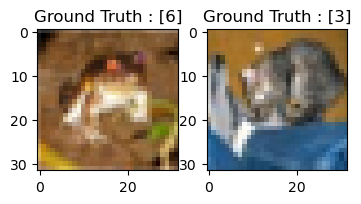

In [7]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D, Dropout, Flatten, BatchNormalization
from tensorflow.keras import layers, models, optimizers
from tensorflow.keras.callbacks import LearningRateScheduler, EarlyStopping
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from codecarbon import EmissionsTracker


trackerTot= EmissionsTracker()
trackerTot.start()

tracker= EmissionsTracker()
tracker.start()

# Load CIFAR-10 dataset
(train_images, train_labels), (test_images, test_labels)  = tf.keras.datasets.cifar10.load_data()

# Print shapes of training and testing data
print('Training data shape : ', train_images.shape, train_labels.shape)
print('Testing data shape : ', test_images.shape, test_labels.shape)

# Find the unique numbers from the train labels
classes = np.unique(train_labels)
nClasses = len(classes)
print('Total number of outputs : ', nClasses)
print('Output classes : ', classes)

# Display the first image in training and testing data
plt.figure(figsize=[4,2])
plt.subplot(121)
plt.imshow(train_images[0,:,:], cmap='gray')
plt.title("Ground Truth : {}".format(train_labels[0]))

plt.subplot(122)
plt.imshow(test_images[0,:,:], cmap='gray')
plt.title("Ground Truth : {}".format(test_labels[0]))

Number of black images: 1


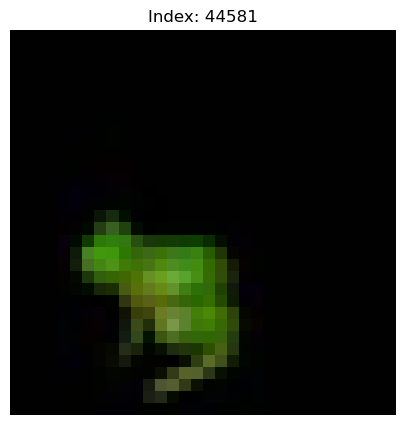

Shape of cleaned dataset: (49989, 32, 32, 3) (49989, 1)
Black images deleted.


In [9]:
import numpy as np
import matplotlib.pyplot as plt

# Function to check if an image is black
def is_black(image, threshold=10):
    # Compute the average pixel intensity
    avg_intensity = np.mean(image)
    # Return True if the average intensity is below the threshold, indicating a "black" image
    return avg_intensity < threshold

# Define a function to iterate through images and check for blackness
def check_black(images, threshold=10):
    black_indices = []
    for i, image in enumerate(images):
        if is_black(image, threshold):
            black_indices.append(i)
    return black_indices

# Function to display images with their indices
def display_images_with_indices(images, indices):
    plt.figure(figsize=(10, 5))
    num_images = len(indices)
    for i, idx in enumerate(indices):
        plt.subplot(1, num_images, i + 1)
        plt.imshow(images[idx])
        plt.title(f"Index: {idx}")
        plt.axis('off')
    plt.show()

# Check for black images
black_indices = check_black(train_images)

# Print the number of black images
print("Number of black images:", len(black_indices))

# Display the black images along with their indices
display_images_with_indices(train_images, black_indices)


# Remove blurry images from the dataset using their indices
train_images = np.delete(train_images, black_indices, axis=0)
train_labels = np.delete(train_labels, black_indices, axis=0)

# Print the shape of the cleaned dataset
print("Shape of cleaned dataset:", train_images.shape, train_labels.shape)
print("Black images deleted.")





In [10]:
# Reshape and preprocess the training and testing data
nRows,nCols,nDims = train_images.shape[1:]
train_data = train_images.reshape(train_images.shape[0], nRows, nCols, nDims)
test_data = test_images.reshape(test_images.shape[0], nRows, nCols, nDims)
input_shape = (nRows, nCols, nDims)

train_data = train_data.astype('float32')
test_data = test_data.astype('float32')

train_data /= 255
test_data /= 255

# Data Augmentation
datagen = ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True
)
datagen.fit(train_images)

# Convert labels to one-hot encoding
train_labels_one_hot = to_categorical(train_labels)
test_labels_one_hot = to_categorical(test_labels)

print('Original label 0 : ', train_labels[0])
print('After conversion to categorical ( one-hot ) : ', train_labels_one_hot[0])

print("Shape of final dataset:", train_data.shape, train_labels.shape)


emissions: float = tracker.stop()
print(f"PreProcessing Emissions:{emissions} Kg")

[codecarbon INFO @ 15:39:08] Energy consumed for RAM : 0.000008 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 15:39:08] Energy consumed for all CPUs : 0.000043 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 15:39:08] 0.00005087732860111652 kWh of electricity used since the beginning.


Original label 0 :  [6]
After conversion to categorical ( one-hot ) :  [0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
Shape of final dataset: (49989, 32, 32, 3) (49989, 1)
PreProcessing Emissions:2.0094739308338837e-06 Kg


C:\Users\boughrio\AppData\Local\anaconda3\Lib\site-packages\codecarbon\output_methods\file.py:43: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat([df, pd.DataFrame.from_records([dict(data.values)])])


In [11]:
# Define VGG16 model
def build_vgg16(input_shape=(32, 32, 3), num_classes=10):
    model = models.Sequential()
    # Block 1
    model.add(layers.Conv2D(64, (3, 3), activation='relu', padding='same', input_shape=input_shape))
    model.add(layers.Conv2D(64, (3, 3), activation='relu', padding='same'))
    model.add(layers.MaxPooling2D((2, 2), strides=(2, 2)))

    # Block 2
    model.add(layers.Conv2D(128, (3, 3), activation='relu', padding='same'))
    model.add(layers.Conv2D(128, (3, 3), activation='relu', padding='same'))
    model.add(layers.MaxPooling2D((2, 2), strides=(2, 2)))

    # Block 3
    model.add(layers.Conv2D(256, (3, 3), activation='relu', padding='same'))
    model.add(layers.Conv2D(256, (3, 3), activation='relu', padding='same'))
    model.add(layers.Conv2D(256, (3, 3), activation='relu', padding='same'))
    model.add(layers.MaxPooling2D((2, 2), strides=(2, 2)))

    # Block 4
    model.add(layers.Conv2D(512, (3, 3), activation='relu', padding='same'))
    model.add(layers.Conv2D(512, (3, 3), activation='relu', padding='same'))
    model.add(layers.Conv2D(512, (3, 3), activation='relu', padding='same'))
    model.add(layers.MaxPooling2D((2, 2), strides=(2, 2)))

    # Block 5
    model.add(layers.Conv2D(512, (3, 3), activation='relu', padding='same'))
    model.add(layers.Conv2D(512, (3, 3), activation='relu', padding='same'))
    model.add(layers.Conv2D(512, (3, 3), activation='relu', padding='same'))
    model.add(layers.MaxPooling2D((2, 2), strides=(2, 2)))

    # Classifier
    model.add(layers.Flatten())
    model.add(layers.Dense(4096, activation='relu'))
    model.add(layers.Dropout(0.5))  # Add dropout for regularization
    model.add(layers.Dense(4096, activation='relu'))
    model.add(layers.Dropout(0.5))  # Add dropout for regularization
    model.add(layers.Dense(num_classes, activation='softmax'))

    return model

# Build the VGG16 model
model = build_vgg16()

# Compile the model with a lower learning rate
optimizer = optimizers.Adam(learning_rate=1e-4)
model.compile(optimizer=optimizer,
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Learning rate scheduler
def lr_schedule(epoch):
    lr = 1e-4
    if epoch > 75:
        lr *= 0.5e-3
    elif epoch > 50:
        lr *= 1e-3
    elif epoch > 25:
        lr *= 1e-2
    elif epoch > 10:
        lr *= 1e-1
    return lr

lr_scheduler = LearningRateScheduler(lr_schedule)

# Early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

tracker= EmissionsTracker()
tracker.start()

# Train the model with data augmentation
history = model.fit(datagen.flow(train_images, train_labels_one_hot, batch_size=128),
                    epochs=200,
                    validation_data=(test_images, test_labels_one_hot),
                    callbacks=[lr_scheduler, early_stopping])
emissions: float = tracker.stop()
print(f"Training Emissions:{emissions} Kg")


C:\Users\boughrio\AppData\Local\anaconda3\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
[codecarbon WARNING @ 15:39:08] Invalid gpu_ids format. Expected a string or a list of ints.
[codecarbon INFO @ 15:39:08] [setup] RAM Tracking...
[codecarbon INFO @ 15:39:08] [setup] GPU Tracking...
[codecarbon INFO @ 15:39:08] No GPU found.
[codecarbon INFO @ 15:39:08] [setup] CPU Tracking...
[codecarbon WARNING @ 15:39:08] No CPU tracking mode found. Falling back on CPU constant mode.
[codecarbon INFO @ 15:39:10] CPU Model on constant consumption mode: Intel(R) Core(TM) i5-10500 CPU @ 3.10GHz
[codecarbon INFO @ 15:39:10] >>> Tracker's metadata:
[codecarbon INFO @ 15:39:10]   Platform system: Windows-10-10.0.19045-SP0
[codecar

Epoch 1/200


C:\Users\boughrio\AppData\Local\anaconda3\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
[codecarbon INFO @ 15:39:20] Energy consumed for RAM : 0.000245 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 15:39:20] Energy consumed for all CPUs : 0.001355 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 15:39:20] 0.00159988299936738372 kWh of electricity used since the beginning.


  4/391 ━━━━━━━━━━━━━━━━━━━━ 10:06 2s/step - accuracy: 0.0920 - loss: 2.3092

[codecarbon INFO @ 15:39:26] Energy consumed for RAM : 0.000245 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 15:39:26] Energy consumed for all CPUs : 0.001355 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 15:39:26] 0.00160003715347198524 kWh of electricity used since the beginning.


  5/391 ━━━━━━━━━━━━━━━━━━━━ 10:43 2s/step - accuracy: 0.0911 - loss: 2.3102

[codecarbon INFO @ 15:39:27] Energy consumed for RAM : 0.000049 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 15:39:27] Energy consumed for all CPUs : 0.000271 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 15:39:27] 0.00032010278599806341 kWh of electricity used since the beginning.
[codecarbon INFO @ 15:39:29] Energy consumed for RAM : 0.000025 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 15:39:29] Energy consumed for all CPUs : 0.000136 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 15:39:29] 0.00016046146450360548 kWh of electricity used since the beginning.


  9/391 ━━━━━━━━━━━━━━━━━━━━ 11:36 2s/step - accuracy: 0.0934 - loss: 2.3104

[codecarbon INFO @ 15:39:35] Energy consumed for RAM : 0.000270 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 15:39:35] Energy consumed for all CPUs : 0.001490 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 15:39:35] 0.00175996677664874051 kWh of electricity used since the beginning.


 12/391 ━━━━━━━━━━━━━━━━━━━━ 11:13 2s/step - accuracy: 0.0938 - loss: 2.3099

[codecarbon INFO @ 15:39:41] Energy consumed for RAM : 0.000270 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 15:39:41] Energy consumed for all CPUs : 0.001490 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 15:39:41] 0.00176022131814254981 kWh of electricity used since the beginning.


 13/391 ━━━━━━━━━━━━━━━━━━━━ 11:14 2s/step - accuracy: 0.0937 - loss: 2.3097

[codecarbon INFO @ 15:39:43] Energy consumed for RAM : 0.000074 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 15:39:43] Energy consumed for all CPUs : 0.000407 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 15:39:43] 0.00048084308808027593 kWh of electricity used since the beginning.
[codecarbon INFO @ 15:39:44] Energy consumed for RAM : 0.000049 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 15:39:44] Energy consumed for all CPUs : 0.000271 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 15:39:44] 0.00032022992809223219 kWh of electricity used since the beginning.


 17/391 ━━━━━━━━━━━━━━━━━━━━ 11:08 2s/step - accuracy: 0.0944 - loss: 2.3085

[codecarbon INFO @ 15:39:50] Energy consumed for RAM : 0.000294 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 15:39:50] Energy consumed for all CPUs : 0.001626 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 15:39:50] 0.00192049973958194277 kWh of electricity used since the beginning.


 21/391 ━━━━━━━━━━━━━━━━━━━━ 10:46 2s/step - accuracy: 0.0964 - loss: 2.3067

[codecarbon INFO @ 15:39:56] Energy consumed for RAM : 0.000294 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 15:39:56] Energy consumed for all CPUs : 0.001626 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 15:39:56] 0.00191998886634336908 kWh of electricity used since the beginning.


 22/391 ━━━━━━━━━━━━━━━━━━━━ 10:42 2s/step - accuracy: 0.0968 - loss: 2.3061

[codecarbon INFO @ 15:39:58] Energy consumed for RAM : 0.000098 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 15:39:58] Energy consumed for all CPUs : 0.000543 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 15:39:58] 0.00064074214941146630 kWh of electricity used since the beginning.
[codecarbon INFO @ 15:39:59] Energy consumed for RAM : 0.000074 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 15:39:59] Energy consumed for all CPUs : 0.000407 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 15:39:59] 0.00048073191742303855 kWh of electricity used since the beginning.


 26/391 ━━━━━━━━━━━━━━━━━━━━ 10:38 2s/step - accuracy: 0.0981 - loss: 2.3037

[codecarbon INFO @ 15:40:05] Energy consumed for RAM : 0.000319 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 15:40:05] Energy consumed for all CPUs : 0.001762 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 15:40:05] 0.00208042829771167958 kWh of electricity used since the beginning.


 30/391 ━━━━━━━━━━━━━━━━━━━━ 10:16 2s/step - accuracy: 0.0990 - loss: 2.3007

[codecarbon INFO @ 15:40:11] Energy consumed for RAM : 0.000319 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 15:40:11] Energy consumed for all CPUs : 0.001762 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 15:40:11] 0.00208052523379604996 kWh of electricity used since the beginning.


 31/391 ━━━━━━━━━━━━━━━━━━━━ 10:13 2s/step - accuracy: 0.0994 - loss: 2.2998

[codecarbon INFO @ 15:40:13] Energy consumed for RAM : 0.000123 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 15:40:13] Energy consumed for all CPUs : 0.000679 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 15:40:13] 0.00080139813020868589 kWh of electricity used since the beginning.


 32/391 ━━━━━━━━━━━━━━━━━━━━ 10:10 2s/step - accuracy: 0.0997 - loss: 2.2990

[codecarbon INFO @ 15:40:14] Energy consumed for RAM : 0.000098 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 15:40:14] Energy consumed for all CPUs : 0.000542 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 15:40:14] 0.00064034896684605829 kWh of electricity used since the beginning.


 35/391 ━━━━━━━━━━━━━━━━━━━━ 10:09 2s/step - accuracy: 0.1007 - loss: 2.2965

[codecarbon INFO @ 15:40:20] Energy consumed for RAM : 0.000343 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 15:40:20] Energy consumed for all CPUs : 0.001897 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 15:40:20] 0.00224058447581584625 kWh of electricity used since the beginning.


 39/391 ━━━━━━━━━━━━━━━━━━━━ 10:01 2s/step - accuracy: 0.1022 - loss: 2.2929

[codecarbon INFO @ 15:40:26] Energy consumed for RAM : 0.000343 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 15:40:26] Energy consumed for all CPUs : 0.001897 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 15:40:26] 0.00224049265536430814 kWh of electricity used since the beginning.


 40/391 ━━━━━━━━━━━━━━━━━━━━ 9:59 2s/step - accuracy: 0.1026 - loss: 2.2920 

[codecarbon INFO @ 15:40:28] Energy consumed for RAM : 0.000147 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 15:40:28] Energy consumed for all CPUs : 0.000815 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 15:40:28] 0.00096210017567920460 kWh of electricity used since the beginning.
[codecarbon INFO @ 15:40:29] Energy consumed for RAM : 0.000123 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 15:40:29] Energy consumed for all CPUs : 0.000678 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 15:40:29] 0.00080071160356001475 kWh of electricity used since the beginning.


 44/391 ━━━━━━━━━━━━━━━━━━━━ 9:57 2s/step - accuracy: 0.1044 - loss: 2.2885

[codecarbon INFO @ 15:40:35] Energy consumed for RAM : 0.000368 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 15:40:35] Energy consumed for all CPUs : 0.002033 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 15:40:35] 0.00240101128500116220 kWh of electricity used since the beginning.


 47/391 ━━━━━━━━━━━━━━━━━━━━ 9:50 2s/step - accuracy: 0.1060 - loss: 2.2859

[codecarbon INFO @ 15:40:41] Energy consumed for RAM : 0.000368 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 15:40:41] Energy consumed for all CPUs : 0.002033 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 15:40:41] 0.00240114447524242530 kWh of electricity used since the beginning.


 49/391 ━━━━━━━━━━━━━━━━━━━━ 9:44 2s/step - accuracy: 0.1070 - loss: 2.2841

[codecarbon INFO @ 15:40:43] Energy consumed for RAM : 0.000172 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 15:40:43] Energy consumed for all CPUs : 0.000950 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 15:40:43] 0.00112209799150839325 kWh of electricity used since the beginning.
[codecarbon INFO @ 15:40:44] Energy consumed for RAM : 0.000147 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 15:40:44] Energy consumed for all CPUs : 0.000814 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 15:40:44] 0.00096117846474799728 kWh of electricity used since the beginning.


 53/391 ━━━━━━━━━━━━━━━━━━━━ 9:36 2s/step - accuracy: 0.1092 - loss: 2.2807

[codecarbon INFO @ 15:40:50] Energy consumed for RAM : 0.000392 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 15:40:50] Energy consumed for all CPUs : 0.002169 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 15:40:50] 0.00256098778872208572 kWh of electricity used since the beginning.


 56/391 ━━━━━━━━━━━━━━━━━━━━ 9:32 2s/step - accuracy: 0.1108 - loss: 2.2784

[codecarbon INFO @ 15:40:56] Energy consumed for RAM : 0.000392 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 15:40:56] Energy consumed for all CPUs : 0.002169 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 15:40:56] 0.00256149398336363680 kWh of electricity used since the beginning.


 57/391 ━━━━━━━━━━━━━━━━━━━━ 9:30 2s/step - accuracy: 0.1113 - loss: 2.2776

[codecarbon INFO @ 15:40:58] Energy consumed for RAM : 0.000196 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 15:40:58] Energy consumed for all CPUs : 0.001086 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 15:40:58] 0.00128217717238480718 kWh of electricity used since the beginning.


 58/391 ━━━━━━━━━━━━━━━━━━━━ 9:27 2s/step - accuracy: 0.1118 - loss: 2.2769

[codecarbon INFO @ 15:40:59] Energy consumed for RAM : 0.000172 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 15:40:59] Energy consumed for all CPUs : 0.000950 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 15:40:59] 0.00112141603459713838 kWh of electricity used since the beginning.


 62/391 ━━━━━━━━━━━━━━━━━━━━ 9:20 2s/step - accuracy: 0.1138 - loss: 2.2740

[codecarbon INFO @ 15:41:05] Energy consumed for RAM : 0.000417 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 15:41:06] Energy consumed for all CPUs : 0.002304 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 15:41:06] 0.00272119557154359070 kWh of electricity used since the beginning.


 65/391 ━━━━━━━━━━━━━━━━━━━━ 9:14 2s/step - accuracy: 0.1152 - loss: 2.2718

[codecarbon INFO @ 15:41:11] Energy consumed for RAM : 0.000417 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 15:41:11] Energy consumed for all CPUs : 0.002305 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 15:41:11] 0.00272152982093137397 kWh of electricity used since the beginning.


 67/391 ━━━━━━━━━━━━━━━━━━━━ 9:09 2s/step - accuracy: 0.1161 - loss: 2.2704

[codecarbon INFO @ 15:41:13] Energy consumed for RAM : 0.000221 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 15:41:13] Energy consumed for all CPUs : 0.001221 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 15:41:13] 0.00144212697330942520 kWh of electricity used since the beginning.
[codecarbon INFO @ 15:41:14] Energy consumed for RAM : 0.000196 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 15:41:14] Energy consumed for all CPUs : 0.001085 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 15:41:14] 0.00128179478654591710 kWh of electricity used since the beginning.


 71/391 ━━━━━━━━━━━━━━━━━━━━ 9:00 2s/step - accuracy: 0.1178 - loss: 2.2674

[codecarbon INFO @ 15:41:21] Energy consumed for RAM : 0.000441 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 15:41:21] Energy consumed for all CPUs : 0.002440 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 15:41:21] 0.00288100317327308775 kWh of electricity used since the beginning.


 75/391 ━━━━━━━━━━━━━━━━━━━━ 8:53 2s/step - accuracy: 0.1194 - loss: 2.2644

[codecarbon INFO @ 15:41:26] Energy consumed for RAM : 0.000442 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 15:41:26] Energy consumed for all CPUs : 0.002440 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 15:41:26] 0.00288154683200217291 kWh of electricity used since the beginning.


 76/391 ━━━━━━━━━━━━━━━━━━━━ 8:51 2s/step - accuracy: 0.1198 - loss: 2.2636

[codecarbon INFO @ 15:41:28] Energy consumed for RAM : 0.000246 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 15:41:28] Energy consumed for all CPUs : 0.001357 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 15:41:28] 0.00160283055891646212 kWh of electricity used since the beginning.
[codecarbon INFO @ 15:41:29] Energy consumed for RAM : 0.000221 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 15:41:29] Energy consumed for all CPUs : 0.001221 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 15:41:29] 0.00144148342812646974 kWh of electricity used since the beginning.


 81/391 ━━━━━━━━━━━━━━━━━━━━ 8:41 2s/step - accuracy: 0.1217 - loss: 2.2596

[codecarbon INFO @ 15:41:36] Energy consumed for RAM : 0.000466 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 15:41:36] Energy consumed for all CPUs : 0.002575 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 15:41:36] 0.00304092497864886114 kWh of electricity used since the beginning.


 84/391 ━━━━━━━━━━━━━━━━━━━━ 8:36 2s/step - accuracy: 0.1228 - loss: 2.2571

[codecarbon INFO @ 15:41:41] Energy consumed for RAM : 0.000466 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 15:41:41] Energy consumed for all CPUs : 0.002576 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 15:41:41] 0.00304197651399259463 kWh of electricity used since the beginning.


 85/391 ━━━━━━━━━━━━━━━━━━━━ 8:34 2s/step - accuracy: 0.1232 - loss: 2.2562

[codecarbon INFO @ 15:41:43] Energy consumed for RAM : 0.000270 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 15:41:43] Energy consumed for all CPUs : 0.001493 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 15:41:43] 0.00176346901937173353 kWh of electricity used since the beginning.


 86/391 ━━━━━━━━━━━━━━━━━━━━ 8:32 2s/step - accuracy: 0.1236 - loss: 2.2553

[codecarbon INFO @ 15:41:44] Energy consumed for RAM : 0.000245 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 15:41:44] Energy consumed for all CPUs : 0.001357 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 15:41:44] 0.00160190219029892646 kWh of electricity used since the beginning.


 90/391 ━━━━━━━━━━━━━━━━━━━━ 8:23 2s/step - accuracy: 0.1252 - loss: 2.2517

[codecarbon INFO @ 15:41:51] Energy consumed for RAM : 0.000490 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 15:41:51] Energy consumed for all CPUs : 0.002711 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 15:41:51] 0.00320133235837933476 kWh of electricity used since the beginning.


 93/391 ━━━━━━━━━━━━━━━━━━━━ 8:18 2s/step - accuracy: 0.1263 - loss: 2.2490

[codecarbon INFO @ 15:41:56] Energy consumed for RAM : 0.000491 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 15:41:56] Energy consumed for all CPUs : 0.002711 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 15:41:56] 0.00320210249011072248 kWh of electricity used since the beginning.


 95/391 ━━━━━━━━━━━━━━━━━━━━ 8:14 2s/step - accuracy: 0.1271 - loss: 2.2472

[codecarbon INFO @ 15:41:58] Energy consumed for RAM : 0.000295 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 15:41:58] Energy consumed for all CPUs : 0.001629 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 15:41:58] 0.00192322069528509014 kWh of electricity used since the beginning.
[codecarbon INFO @ 15:41:59] Energy consumed for RAM : 0.000270 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 15:41:59] Energy consumed for all CPUs : 0.001493 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 15:41:59] 0.00176250872969308209 kWh of electricity used since the beginning.


 99/391 ━━━━━━━━━━━━━━━━━━━━ 8:07 2s/step - accuracy: 0.1286 - loss: 2.2435

[codecarbon INFO @ 15:42:06] Energy consumed for RAM : 0.000515 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 15:42:06] Energy consumed for all CPUs : 0.002846 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 15:42:06] 0.00336139106784339847 kWh of electricity used since the beginning.


102/391 ━━━━━━━━━━━━━━━━━━━━ 8:03 2s/step - accuracy: 0.1297 - loss: 2.2408

[codecarbon INFO @ 15:42:11] Energy consumed for RAM : 0.000515 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 15:42:11] Energy consumed for all CPUs : 0.002847 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 15:42:11] 0.00336221581886362404 kWh of electricity used since the beginning.


103/391 ━━━━━━━━━━━━━━━━━━━━ 8:02 2s/step - accuracy: 0.1301 - loss: 2.2398

[codecarbon INFO @ 15:42:13] Energy consumed for RAM : 0.000319 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 15:42:13] Energy consumed for all CPUs : 0.001764 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 15:42:13] 0.00208362643457888361 kWh of electricity used since the beginning.


104/391 ━━━━━━━━━━━━━━━━━━━━ 8:00 2s/step - accuracy: 0.1305 - loss: 2.2389

[codecarbon INFO @ 15:42:14] Energy consumed for RAM : 0.000295 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 15:42:14] Energy consumed for all CPUs : 0.001629 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 15:42:14] 0.00192316110277282633 kWh of electricity used since the beginning.


108/391 ━━━━━━━━━━━━━━━━━━━━ 7:53 2s/step - accuracy: 0.1319 - loss: 2.2352

[codecarbon INFO @ 15:42:21] Energy consumed for RAM : 0.000540 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 15:42:21] Energy consumed for all CPUs : 0.002982 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 15:42:21] 0.00352177831400173058 kWh of electricity used since the beginning.


111/391 ━━━━━━━━━━━━━━━━━━━━ 7:49 2s/step - accuracy: 0.1330 - loss: 2.2324

[codecarbon INFO @ 15:42:26] Energy consumed for RAM : 0.000540 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 15:42:26] Energy consumed for all CPUs : 0.002983 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 15:42:26] 0.00352263328057309368 kWh of electricity used since the beginning.


112/391 ━━━━━━━━━━━━━━━━━━━━ 7:48 2s/step - accuracy: 0.1334 - loss: 2.2314

[codecarbon INFO @ 15:42:28] Energy consumed for RAM : 0.000344 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 15:42:28] Energy consumed for all CPUs : 0.001900 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 15:42:28] 0.00224426627166273438 kWh of electricity used since the beginning.


113/391 ━━━━━━━━━━━━━━━━━━━━ 7:46 2s/step - accuracy: 0.1338 - loss: 2.2305

[codecarbon INFO @ 15:42:29] Energy consumed for RAM : 0.000319 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 15:42:29] Energy consumed for all CPUs : 0.001764 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 15:42:29] 0.00208337653009141397 kWh of electricity used since the beginning.


117/391 ━━━━━━━━━━━━━━━━━━━━ 7:38 2s/step - accuracy: 0.1352 - loss: 2.2267

[codecarbon INFO @ 15:42:36] Energy consumed for RAM : 0.000564 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 15:42:36] Energy consumed for all CPUs : 0.003118 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 15:42:36] 0.00368228785021161315 kWh of electricity used since the beginning.


120/391 ━━━━━━━━━━━━━━━━━━━━ 7:34 2s/step - accuracy: 0.1363 - loss: 2.2239

[codecarbon INFO @ 15:42:41] Energy consumed for RAM : 0.000564 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 15:42:41] Energy consumed for all CPUs : 0.003119 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 15:42:41] 0.00368308563442509016 kWh of electricity used since the beginning.


121/391 ━━━━━━━━━━━━━━━━━━━━ 7:32 2s/step - accuracy: 0.1366 - loss: 2.2230

[codecarbon INFO @ 15:42:43] Energy consumed for RAM : 0.000368 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 15:42:43] Energy consumed for all CPUs : 0.002037 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 15:42:43] 0.00240498242962529927 kWh of electricity used since the beginning.


122/391 ━━━━━━━━━━━━━━━━━━━━ 7:31 2s/step - accuracy: 0.1370 - loss: 2.2221

[codecarbon INFO @ 15:42:44] Energy consumed for RAM : 0.000344 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 15:42:44] Energy consumed for all CPUs : 0.001900 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 15:42:44] 0.00224329918895207515 kWh of electricity used since the beginning.


126/391 ━━━━━━━━━━━━━━━━━━━━ 7:24 2s/step - accuracy: 0.1383 - loss: 2.2184

[codecarbon INFO @ 15:42:51] Energy consumed for RAM : 0.000589 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 15:42:51] Energy consumed for all CPUs : 0.003254 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 15:42:51] 0.00384311743199879270 kWh of electricity used since the beginning.


129/391 ━━━━━━━━━━━━━━━━━━━━ 7:19 2s/step - accuracy: 0.1394 - loss: 2.2156

[codecarbon INFO @ 15:42:56] Energy consumed for RAM : 0.000589 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 15:42:56] Energy consumed for all CPUs : 0.003255 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 15:42:56] 0.00384394098634174017 kWh of electricity used since the beginning.


130/391 ━━━━━━━━━━━━━━━━━━━━ 7:18 2s/step - accuracy: 0.1397 - loss: 2.2147

[codecarbon INFO @ 15:42:58] Energy consumed for RAM : 0.000393 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 15:42:58] Energy consumed for all CPUs : 0.002173 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 15:42:58] 0.00256594659612938451 kWh of electricity used since the beginning.
[codecarbon INFO @ 15:42:59] Energy consumed for RAM : 0.000368 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 15:42:59] Energy consumed for all CPUs : 0.002036 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 15:42:59] 0.00240386090156262519 kWh of electricity used since the beginning.


134/391 ━━━━━━━━━━━━━━━━━━━━ 7:12 2s/step - accuracy: 0.1411 - loss: 2.2111

[codecarbon INFO @ 15:43:06] Energy consumed for RAM : 0.000613 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 15:43:06] Energy consumed for all CPUs : 0.003390 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 15:43:06] 0.00400344934156313809 kWh of electricity used since the beginning.


137/391 ━━━━━━━━━━━━━━━━━━━━ 7:07 2s/step - accuracy: 0.1421 - loss: 2.2083

[codecarbon INFO @ 15:43:11] Energy consumed for RAM : 0.000613 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 15:43:11] Energy consumed for all CPUs : 0.003390 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 15:43:11] 0.00400384646338702160 kWh of electricity used since the beginning.


138/391 ━━━━━━━━━━━━━━━━━━━━ 7:06 2s/step - accuracy: 0.1424 - loss: 2.2074

[codecarbon INFO @ 15:43:13] Energy consumed for RAM : 0.000417 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 15:43:13] Energy consumed for all CPUs : 0.002308 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 15:43:13] 0.00272549470270219826 kWh of electricity used since the beginning.


139/391 ━━━━━━━━━━━━━━━━━━━━ 7:05 2s/step - accuracy: 0.1427 - loss: 2.2065

[codecarbon INFO @ 15:43:14] Energy consumed for RAM : 0.000393 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 15:43:14] Energy consumed for all CPUs : 0.002172 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 15:43:14] 0.00256469446641150638 kWh of electricity used since the beginning.


143/391 ━━━━━━━━━━━━━━━━━━━━ 6:58 2s/step - accuracy: 0.1440 - loss: 2.2028

[codecarbon INFO @ 15:43:21] Energy consumed for RAM : 0.000638 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 15:43:21] Energy consumed for all CPUs : 0.003526 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 15:43:21] 0.00416353237334991452 kWh of electricity used since the beginning.


146/391 ━━━━━━━━━━━━━━━━━━━━ 6:52 2s/step - accuracy: 0.1450 - loss: 2.2001

[codecarbon INFO @ 15:43:26] Energy consumed for RAM : 0.000638 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 15:43:26] Energy consumed for all CPUs : 0.003527 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 15:43:26] 0.00416478132114861659 kWh of electricity used since the beginning.


147/391 ━━━━━━━━━━━━━━━━━━━━ 6:51 2s/step - accuracy: 0.1454 - loss: 2.1991

[codecarbon INFO @ 15:43:28] Energy consumed for RAM : 0.000442 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 15:43:28] Energy consumed for all CPUs : 0.002445 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 15:43:28] 0.00288716719781434471 kWh of electricity used since the beginning.


148/391 ━━━━━━━━━━━━━━━━━━━━ 6:50 2s/step - accuracy: 0.1457 - loss: 2.1982

[codecarbon INFO @ 15:43:29] Energy consumed for RAM : 0.000417 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 15:43:29] Energy consumed for all CPUs : 0.002307 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 15:43:29] 0.00272468456673506882 kWh of electricity used since the beginning.


151/391 ━━━━━━━━━━━━━━━━━━━━ 6:45 2s/step - accuracy: 0.1467 - loss: 2.1954

[codecarbon INFO @ 15:43:36] Energy consumed for RAM : 0.000662 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 15:43:36] Energy consumed for all CPUs : 0.003661 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 15:43:36] 0.00432334868461432993 kWh of electricity used since the beginning.


155/391 ━━━━━━━━━━━━━━━━━━━━ 6:38 2s/step - accuracy: 0.1480 - loss: 2.1918

[codecarbon INFO @ 15:43:41] Energy consumed for RAM : 0.000663 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 15:43:41] Energy consumed for all CPUs : 0.003662 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 15:43:41] 0.00432501256677680218 kWh of electricity used since the beginning.


156/391 ━━━━━━━━━━━━━━━━━━━━ 6:37 2s/step - accuracy: 0.1483 - loss: 2.1908

[codecarbon INFO @ 15:43:43] Energy consumed for RAM : 0.000467 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 15:43:44] Energy consumed for all CPUs : 0.002582 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 15:43:44] 0.00304874412402192938 kWh of electricity used since the beginning.
[codecarbon INFO @ 15:43:44] Energy consumed for RAM : 0.000442 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 15:43:44] Energy consumed for all CPUs : 0.002443 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 15:43:44] 0.00288524777604285765 kWh of electricity used since the beginning.


160/391 ━━━━━━━━━━━━━━━━━━━━ 6:31 2s/step - accuracy: 0.1496 - loss: 2.1873

[codecarbon INFO @ 15:43:51] Energy consumed for RAM : 0.000687 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 15:43:51] Energy consumed for all CPUs : 0.003797 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 15:43:51] 0.00448346065919252162 kWh of electricity used since the beginning.


163/391 ━━━━━━━━━━━━━━━━━━━━ 6:26 2s/step - accuracy: 0.1505 - loss: 2.1846

[codecarbon INFO @ 15:43:56] Energy consumed for RAM : 0.000687 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 15:43:56] Energy consumed for all CPUs : 0.003798 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 15:43:56] 0.00448525301653384442 kWh of electricity used since the beginning.


164/391 ━━━━━━━━━━━━━━━━━━━━ 6:24 2s/step - accuracy: 0.1508 - loss: 2.1837

[codecarbon INFO @ 15:43:59] Energy consumed for RAM : 0.000491 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 15:43:59] Energy consumed for all CPUs : 0.002717 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 15:43:59] 0.00320864323687538276 kWh of electricity used since the beginning.


165/391 ━━━━━━━━━━━━━━━━━━━━ 6:23 2s/step - accuracy: 0.1511 - loss: 2.1828

[codecarbon INFO @ 15:43:59] Energy consumed for RAM : 0.000467 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 15:43:59] Energy consumed for all CPUs : 0.002580 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 15:43:59] 0.00304635582429728727 kWh of electricity used since the beginning.


169/391 ━━━━━━━━━━━━━━━━━━━━ 6:16 2s/step - accuracy: 0.1523 - loss: 2.1794

[codecarbon INFO @ 15:44:06] Energy consumed for RAM : 0.000711 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 15:44:06] Energy consumed for all CPUs : 0.003932 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 15:44:06] 0.00464348247510619309 kWh of electricity used since the beginning.


172/391 ━━━━━━━━━━━━━━━━━━━━ 6:11 2s/step - accuracy: 0.1532 - loss: 2.1769

[codecarbon INFO @ 15:44:11] Energy consumed for RAM : 0.000712 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 15:44:11] Energy consumed for all CPUs : 0.003934 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 15:44:11] 0.00464574896228084865 kWh of electricity used since the beginning.


173/391 ━━━━━━━━━━━━━━━━━━━━ 6:09 2s/step - accuracy: 0.1535 - loss: 2.1760

[codecarbon INFO @ 15:44:14] Energy consumed for RAM : 0.000516 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 15:44:14] Energy consumed for all CPUs : 0.002853 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 15:44:14] 0.00336862926886636769 kWh of electricity used since the beginning.


174/391 ━━━━━━━━━━━━━━━━━━━━ 6:07 2s/step - accuracy: 0.1538 - loss: 2.1752

[codecarbon INFO @ 15:44:14] Energy consumed for RAM : 0.000491 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 15:44:14] Energy consumed for all CPUs : 0.002715 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 15:44:14] 0.00320629129615447204 kWh of electricity used since the beginning.


177/391 ━━━━━━━━━━━━━━━━━━━━ 6:03 2s/step - accuracy: 0.1547 - loss: 2.1728

[codecarbon INFO @ 15:44:21] Energy consumed for RAM : 0.000736 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 15:44:21] Energy consumed for all CPUs : 0.004068 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 15:44:21] 0.00480375152998256932 kWh of electricity used since the beginning.


181/391 ━━━━━━━━━━━━━━━━━━━━ 5:56 2s/step - accuracy: 0.1558 - loss: 2.1695

[codecarbon INFO @ 15:44:26] Energy consumed for RAM : 0.000736 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 15:44:27] Energy consumed for all CPUs : 0.004070 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 15:44:27] 0.00480649928328865609 kWh of electricity used since the beginning.


182/391 ━━━━━━━━━━━━━━━━━━━━ 5:54 2s/step - accuracy: 0.1561 - loss: 2.1687

[codecarbon INFO @ 15:44:29] Energy consumed for RAM : 0.000541 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 15:44:29] Energy consumed for all CPUs : 0.002989 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 15:44:29] 0.00352946057967235211 kWh of electricity used since the beginning.


183/391 ━━━━━━━━━━━━━━━━━━━━ 5:52 2s/step - accuracy: 0.1564 - loss: 2.1679

[codecarbon INFO @ 15:44:29] Energy consumed for RAM : 0.000516 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 15:44:29] Energy consumed for all CPUs : 0.002851 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 15:44:29] 0.00336625250432856949 kWh of electricity used since the beginning.


186/391 ━━━━━━━━━━━━━━━━━━━━ 5:48 2s/step - accuracy: 0.1573 - loss: 2.1655

[codecarbon INFO @ 15:44:36] Energy consumed for RAM : 0.000761 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 15:44:36] Energy consumed for all CPUs : 0.004204 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 15:44:36] 0.00496453943483398004 kWh of electricity used since the beginning.


190/391 ━━━━━━━━━━━━━━━━━━━━ 5:41 2s/step - accuracy: 0.1584 - loss: 2.1623

[codecarbon INFO @ 15:44:42] Energy consumed for RAM : 0.000761 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 15:44:42] Energy consumed for all CPUs : 0.004206 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 15:44:42] 0.00496644144828332652 kWh of electricity used since the beginning.


191/391 ━━━━━━━━━━━━━━━━━━━━ 5:39 2s/step - accuracy: 0.1587 - loss: 2.1615

[codecarbon INFO @ 15:44:44] Energy consumed for RAM : 0.000565 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 15:44:44] Energy consumed for all CPUs : 0.003125 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 15:44:44] 0.00369033960424256869 kWh of electricity used since the beginning.
[codecarbon INFO @ 15:44:44] Energy consumed for RAM : 0.000540 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 15:44:44] Energy consumed for all CPUs : 0.002986 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 15:44:44] 0.00352654772326755402 kWh of electricity used since the beginning.


195/391 ━━━━━━━━━━━━━━━━━━━━ 5:32 2s/step - accuracy: 0.1599 - loss: 2.1583

[codecarbon INFO @ 15:44:51] Energy consumed for RAM : 0.000785 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 15:44:51] Energy consumed for all CPUs : 0.004340 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 15:44:51] 0.00512557049905643103 kWh of electricity used since the beginning.


198/391 ━━━━━━━━━━━━━━━━━━━━ 5:28 2s/step - accuracy: 0.1608 - loss: 2.1559

[codecarbon INFO @ 15:44:57] Energy consumed for RAM : 0.000786 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 15:44:57] Energy consumed for all CPUs : 0.004342 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 15:44:57] 0.00512769678153881386 kWh of electricity used since the beginning.


199/391 ━━━━━━━━━━━━━━━━━━━━ 5:26 2s/step - accuracy: 0.1610 - loss: 2.1552

[codecarbon INFO @ 15:44:59] Energy consumed for RAM : 0.000590 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 15:44:59] Energy consumed for all CPUs : 0.003261 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 15:44:59] 0.00385048516567407110 kWh of electricity used since the beginning.


200/391 ━━━━━━━━━━━━━━━━━━━━ 5:24 2s/step - accuracy: 0.1613 - loss: 2.1544

[codecarbon INFO @ 15:44:59] Energy consumed for RAM : 0.000565 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 15:44:59] Energy consumed for all CPUs : 0.003122 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 15:44:59] 0.00368647097443165154 kWh of electricity used since the beginning.


203/391 ━━━━━━━━━━━━━━━━━━━━ 5:20 2s/step - accuracy: 0.1622 - loss: 2.1520

[codecarbon INFO @ 15:45:06] Energy consumed for RAM : 0.000810 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 15:45:06] Energy consumed for all CPUs : 0.004476 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 15:45:06] 0.00528577931169899561 kWh of electricity used since the beginning.


206/391 ━━━━━━━━━━━━━━━━━━━━ 5:15 2s/step - accuracy: 0.1630 - loss: 2.1497

[codecarbon INFO @ 15:45:12] Energy consumed for RAM : 0.000810 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 15:45:12] Energy consumed for all CPUs : 0.004478 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 15:45:12] 0.00528754637285906715 kWh of electricity used since the beginning.


208/391 ━━━━━━━━━━━━━━━━━━━━ 5:12 2s/step - accuracy: 0.1636 - loss: 2.1482

[codecarbon INFO @ 15:45:14] Energy consumed for RAM : 0.000614 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 15:45:14] Energy consumed for all CPUs : 0.003396 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 15:45:14] 0.00401046814268759839 kWh of electricity used since the beginning.
[codecarbon INFO @ 15:45:14] Energy consumed for RAM : 0.000589 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 15:45:14] Energy consumed for all CPUs : 0.003258 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 15:45:14] 0.00384735519547946877 kWh of electricity used since the beginning.


212/391 ━━━━━━━━━━━━━━━━━━━━ 5:05 2s/step - accuracy: 0.1647 - loss: 2.1452

[codecarbon INFO @ 15:45:21] Energy consumed for RAM : 0.000834 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 15:45:21] Energy consumed for all CPUs : 0.004612 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 15:45:21] 0.00544649203569498152 kWh of electricity used since the beginning.


215/391 ━━━━━━━━━━━━━━━━━━━━ 4:59 2s/step - accuracy: 0.1655 - loss: 2.1429

[codecarbon INFO @ 15:45:27] Energy consumed for RAM : 0.000835 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 15:45:27] Energy consumed for all CPUs : 0.004613 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 15:45:27] 0.00544753430858358270 kWh of electricity used since the beginning.


217/391 ━━━━━━━━━━━━━━━━━━━━ 4:56 2s/step - accuracy: 0.1660 - loss: 2.1414

[codecarbon INFO @ 15:45:29] Energy consumed for RAM : 0.000639 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 15:45:29] Energy consumed for all CPUs : 0.003532 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 15:45:29] 0.00417094450494497060 kWh of electricity used since the beginning.
[codecarbon INFO @ 15:45:30] Energy consumed for RAM : 0.000614 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 15:45:30] Energy consumed for all CPUs : 0.003394 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 15:45:30] 0.00400760469580750331 kWh of electricity used since the beginning.


221/391 ━━━━━━━━━━━━━━━━━━━━ 4:48 2s/step - accuracy: 0.1671 - loss: 2.1385

[codecarbon INFO @ 15:45:36] Energy consumed for RAM : 0.000859 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 15:45:36] Energy consumed for all CPUs : 0.004748 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 15:45:36] 0.00560658623323425850 kWh of electricity used since the beginning.


225/391 ━━━━━━━━━━━━━━━━━━━━ 4:42 2s/step - accuracy: 0.1682 - loss: 2.1355

[codecarbon INFO @ 15:45:42] Energy consumed for RAM : 0.000859 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 15:45:42] Energy consumed for all CPUs : 0.004749 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 15:45:42] 0.00560796555865453357 kWh of electricity used since the beginning.


226/391 ━━━━━━━━━━━━━━━━━━━━ 4:40 2s/step - accuracy: 0.1685 - loss: 2.1348

[codecarbon INFO @ 15:45:44] Energy consumed for RAM : 0.000663 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 15:45:44] Energy consumed for all CPUs : 0.003668 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 15:45:44] 0.00433140725422238686 kWh of electricity used since the beginning.


227/391 ━━━━━━━━━━━━━━━━━━━━ 4:38 2s/step - accuracy: 0.1687 - loss: 2.1341

[codecarbon INFO @ 15:45:45] Energy consumed for RAM : 0.000638 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 15:45:45] Energy consumed for all CPUs : 0.003529 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 15:45:45] 0.00416739173229164865 kWh of electricity used since the beginning.


231/391 ━━━━━━━━━━━━━━━━━━━━ 4:31 2s/step - accuracy: 0.1698 - loss: 2.1312

[codecarbon INFO @ 15:45:51] Energy consumed for RAM : 0.000883 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 15:45:51] Energy consumed for all CPUs : 0.004883 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 15:45:51] 0.00576655575630353676 kWh of electricity used since the beginning.


234/391 ━━━━━━━━━━━━━━━━━━━━ 4:26 2s/step - accuracy: 0.1706 - loss: 2.1291

[codecarbon INFO @ 15:45:57] Energy consumed for RAM : 0.000884 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 15:45:57] Energy consumed for all CPUs : 0.004885 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 15:45:57] 0.00576847373519638173 kWh of electricity used since the beginning.


235/391 ━━━━━━━━━━━━━━━━━━━━ 4:24 2s/step - accuracy: 0.1708 - loss: 2.1284

[codecarbon INFO @ 15:45:59] Energy consumed for RAM : 0.000688 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 15:45:59] Energy consumed for all CPUs : 0.003803 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 15:45:59] 0.00449139786008231380 kWh of electricity used since the beginning.


236/391 ━━━━━━━━━━━━━━━━━━━━ 4:22 2s/step - accuracy: 0.1711 - loss: 2.1277

[codecarbon INFO @ 15:46:00] Energy consumed for RAM : 0.000663 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 15:46:00] Energy consumed for all CPUs : 0.003665 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 15:46:00] 0.00432830727150803566 kWh of electricity used since the beginning.


240/391 ━━━━━━━━━━━━━━━━━━━━ 4:15 2s/step - accuracy: 0.1721 - loss: 2.1249

[codecarbon INFO @ 15:46:06] Energy consumed for RAM : 0.000908 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 15:46:06] Energy consumed for all CPUs : 0.005020 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 15:46:06] 0.00592781320229151653 kWh of electricity used since the beginning.


243/391 ━━━━━━━━━━━━━━━━━━━━ 4:11 2s/step - accuracy: 0.1729 - loss: 2.1228

[codecarbon INFO @ 15:46:12] Energy consumed for RAM : 0.000908 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 15:46:12] Energy consumed for all CPUs : 0.005021 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 15:46:12] 0.00592934051700923486 kWh of electricity used since the beginning.


244/391 ━━━━━━━━━━━━━━━━━━━━ 4:09 2s/step - accuracy: 0.1731 - loss: 2.1221

[codecarbon INFO @ 15:46:14] Energy consumed for RAM : 0.000713 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 15:46:14] Energy consumed for all CPUs : 0.003940 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 15:46:14] 0.00465214864635314900 kWh of electricity used since the beginning.


245/391 ━━━━━━━━━━━━━━━━━━━━ 4:07 2s/step - accuracy: 0.1734 - loss: 2.1214

[codecarbon INFO @ 15:46:15] Energy consumed for RAM : 0.000687 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 15:46:15] Energy consumed for all CPUs : 0.003801 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 15:46:15] 0.00448812691242056645 kWh of electricity used since the beginning.


249/391 ━━━━━━━━━━━━━━━━━━━━ 4:00 2s/step - accuracy: 0.1744 - loss: 2.1186

[codecarbon INFO @ 15:46:21] Energy consumed for RAM : 0.000933 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 15:46:21] Energy consumed for all CPUs : 0.005156 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 15:46:21] 0.00608828176419293383 kWh of electricity used since the beginning.


252/391 ━━━━━━━━━━━━━━━━━━━━ 3:55 2s/step - accuracy: 0.1752 - loss: 2.1166

[codecarbon INFO @ 15:46:27] Energy consumed for RAM : 0.000933 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 15:46:27] Energy consumed for all CPUs : 0.005157 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 15:46:27] 0.00609002041471766713 kWh of electricity used since the beginning.


253/391 ━━━━━━━━━━━━━━━━━━━━ 3:53 2s/step - accuracy: 0.1754 - loss: 2.1159

[codecarbon INFO @ 15:46:29] Energy consumed for RAM : 0.000737 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 15:46:29] Energy consumed for all CPUs : 0.004076 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 15:46:29] 0.00481279694671381784 kWh of electricity used since the beginning.
[codecarbon INFO @ 15:46:30] Energy consumed for RAM : 0.000712 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 15:46:30] Energy consumed for all CPUs : 0.003936 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 15:46:30] 0.00464809617352252274 kWh of electricity used since the beginning.


258/391 ━━━━━━━━━━━━━━━━━━━━ 3:45 2s/step - accuracy: 0.1767 - loss: 2.1125

[codecarbon INFO @ 15:46:36] Energy consumed for RAM : 0.000957 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 15:46:37] Energy consumed for all CPUs : 0.005291 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 15:46:37] 0.00624877936317770610 kWh of electricity used since the beginning.


261/391 ━━━━━━━━━━━━━━━━━━━━ 3:40 2s/step - accuracy: 0.1774 - loss: 2.1105

[codecarbon INFO @ 15:46:42] Energy consumed for RAM : 0.000958 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 15:46:42] Energy consumed for all CPUs : 0.005293 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 15:46:42] 0.00625056893826702719 kWh of electricity used since the beginning.


262/391 ━━━━━━━━━━━━━━━━━━━━ 3:38 2s/step - accuracy: 0.1777 - loss: 2.1098

[codecarbon INFO @ 15:46:44] Energy consumed for RAM : 0.000762 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 15:46:44] Energy consumed for all CPUs : 0.004212 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 15:46:44] 0.00497332915083134857 kWh of electricity used since the beginning.


263/391 ━━━━━━━━━━━━━━━━━━━━ 3:36 2s/step - accuracy: 0.1779 - loss: 2.1091

[codecarbon INFO @ 15:46:45] Energy consumed for RAM : 0.000737 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 15:46:45] Energy consumed for all CPUs : 0.004072 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 15:46:45] 0.00480822646755930515 kWh of electricity used since the beginning.


267/391 ━━━━━━━━━━━━━━━━━━━━ 3:29 2s/step - accuracy: 0.1789 - loss: 2.1065

[codecarbon INFO @ 15:46:52] Energy consumed for RAM : 0.000982 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 15:46:52] Energy consumed for all CPUs : 0.005427 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 15:46:52] 0.00640925635853913708 kWh of electricity used since the beginning.


270/391 ━━━━━━━━━━━━━━━━━━━━ 3:24 2s/step - accuracy: 0.1797 - loss: 2.1045

[codecarbon INFO @ 15:46:57] Energy consumed for RAM : 0.000982 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 15:46:57] Energy consumed for all CPUs : 0.005429 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 15:46:57] 0.00641110440132299560 kWh of electricity used since the beginning.


271/391 ━━━━━━━━━━━━━━━━━━━━ 3:23 2s/step - accuracy: 0.1799 - loss: 2.1038

[codecarbon INFO @ 15:46:59] Energy consumed for RAM : 0.000786 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 15:46:59] Energy consumed for all CPUs : 0.004347 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 15:46:59] 0.00513351095349960651 kWh of electricity used since the beginning.


272/391 ━━━━━━━━━━━━━━━━━━━━ 3:21 2s/step - accuracy: 0.1802 - loss: 2.1032

[codecarbon INFO @ 15:47:00] Energy consumed for RAM : 0.000761 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 15:47:00] Energy consumed for all CPUs : 0.004207 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 15:47:00] 0.00496851764837184188 kWh of electricity used since the beginning.


276/391 ━━━━━━━━━━━━━━━━━━━━ 3:14 2s/step - accuracy: 0.1811 - loss: 2.1006

[codecarbon INFO @ 15:47:07] Energy consumed for RAM : 0.001006 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 15:47:07] Energy consumed for all CPUs : 0.005563 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 15:47:07] 0.00656961224601513433 kWh of electricity used since the beginning.


279/391 ━━━━━━━━━━━━━━━━━━━━ 3:09 2s/step - accuracy: 0.1819 - loss: 2.0986

[codecarbon INFO @ 15:47:12] Energy consumed for RAM : 0.001007 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 15:47:12] Energy consumed for all CPUs : 0.005565 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 15:47:12] 0.00657132519338324023 kWh of electricity used since the beginning.


280/391 ━━━━━━━━━━━━━━━━━━━━ 3:07 2s/step - accuracy: 0.1821 - loss: 2.0980

[codecarbon INFO @ 15:47:14] Energy consumed for RAM : 0.000811 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 15:47:14] Energy consumed for all CPUs : 0.004483 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 15:47:14] 0.00529357025485958487 kWh of electricity used since the beginning.


281/391 ━━━━━━━━━━━━━━━━━━━━ 3:06 2s/step - accuracy: 0.1824 - loss: 2.0973

[codecarbon INFO @ 15:47:15] Energy consumed for RAM : 0.000786 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 15:47:15] Energy consumed for all CPUs : 0.004343 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 15:47:15] 0.00512874093206225953 kWh of electricity used since the beginning.


285/391 ━━━━━━━━━━━━━━━━━━━━ 2:59 2s/step - accuracy: 0.1833 - loss: 2.0947

[codecarbon INFO @ 15:47:22] Energy consumed for RAM : 0.001031 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 15:47:22] Energy consumed for all CPUs : 0.005699 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 15:47:22] 0.00673008377128651511 kWh of electricity used since the beginning.


288/391 ━━━━━━━━━━━━━━━━━━━━ 2:54 2s/step - accuracy: 0.1841 - loss: 2.0928

[codecarbon INFO @ 15:47:27] Energy consumed for RAM : 0.001031 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 15:47:27] Energy consumed for all CPUs : 0.005700 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 15:47:27] 0.00673136622080982693 kWh of electricity used since the beginning.


289/391 ━━━━━━━━━━━━━━━━━━━━ 2:52 2s/step - accuracy: 0.1843 - loss: 2.0922

[codecarbon INFO @ 15:47:29] Energy consumed for RAM : 0.000835 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 15:47:29] Energy consumed for all CPUs : 0.004618 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 15:47:29] 0.00545365342549489034 kWh of electricity used since the beginning.


290/391 ━━━━━━━━━━━━━━━━━━━━ 2:50 2s/step - accuracy: 0.1846 - loss: 2.0915

[codecarbon INFO @ 15:47:30] Energy consumed for RAM : 0.000810 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 15:47:30] Energy consumed for all CPUs : 0.004479 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 15:47:30] 0.00528943323012463686 kWh of electricity used since the beginning.


294/391 ━━━━━━━━━━━━━━━━━━━━ 2:43 2s/step - accuracy: 0.1855 - loss: 2.0890

[codecarbon INFO @ 15:47:37] Energy consumed for RAM : 0.001056 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 15:47:37] Energy consumed for all CPUs : 0.005835 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 15:47:37] 0.00689057679379637827 kWh of electricity used since the beginning.


297/391 ━━━━━━━━━━━━━━━━━━━━ 2:38 2s/step - accuracy: 0.1862 - loss: 2.0871

[codecarbon INFO @ 15:47:42] Energy consumed for RAM : 0.001056 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 15:47:42] Energy consumed for all CPUs : 0.005836 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 15:47:42] 0.00689137453100929342 kWh of electricity used since the beginning.


299/391 ━━━━━━━━━━━━━━━━━━━━ 2:35 2s/step - accuracy: 0.1867 - loss: 2.0859

[codecarbon INFO @ 15:47:44] Energy consumed for RAM : 0.000860 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 15:47:44] Energy consumed for all CPUs : 0.004754 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 15:47:44] 0.00561375416078554838 kWh of electricity used since the beginning.
[codecarbon INFO @ 15:47:45] Energy consumed for RAM : 0.000835 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 15:47:45] Energy consumed for all CPUs : 0.004615 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 15:47:45] 0.00544979502989517868 kWh of electricity used since the beginning.


303/391 ━━━━━━━━━━━━━━━━━━━━ 2:28 2s/step - accuracy: 0.1876 - loss: 2.0834

[codecarbon INFO @ 15:47:52] Energy consumed for RAM : 0.001080 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 15:47:52] Energy consumed for all CPUs : 0.005971 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 15:47:52] 0.00705095858908144114 kWh of electricity used since the beginning.


307/391 ━━━━━━━━━━━━━━━━━━━━ 2:21 2s/step - accuracy: 0.1886 - loss: 2.0810

[codecarbon INFO @ 15:47:57] Energy consumed for RAM : 0.001080 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 15:47:57] Energy consumed for all CPUs : 0.005971 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 15:47:57] 0.00705146019902923478 kWh of electricity used since the beginning.


308/391 ━━━━━━━━━━━━━━━━━━━━ 2:20 2s/step - accuracy: 0.1888 - loss: 2.0804

[codecarbon INFO @ 15:47:59] Energy consumed for RAM : 0.000884 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 15:47:59] Energy consumed for all CPUs : 0.004890 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 15:47:59] 0.00577427827023909400 kWh of electricity used since the beginning.
[codecarbon INFO @ 15:48:00] Energy consumed for RAM : 0.000859 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 15:48:00] Energy consumed for all CPUs : 0.004751 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 15:48:00] 0.00561089194383675334 kWh of electricity used since the beginning.


312/391 ━━━━━━━━━━━━━━━━━━━━ 2:13 2s/step - accuracy: 0.1897 - loss: 2.0780

[codecarbon INFO @ 15:48:07] Energy consumed for RAM : 0.001105 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 15:48:07] Energy consumed for all CPUs : 0.006106 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 15:48:07] 0.00721113365826663282 kWh of electricity used since the beginning.


316/391 ━━━━━━━━━━━━━━━━━━━━ 2:06 2s/step - accuracy: 0.1906 - loss: 2.0756

[codecarbon INFO @ 15:48:12] Energy consumed for RAM : 0.001105 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 15:48:12] Energy consumed for all CPUs : 0.006107 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 15:48:12] 0.00721149836073400191 kWh of electricity used since the beginning.


317/391 ━━━━━━━━━━━━━━━━━━━━ 2:04 2s/step - accuracy: 0.1909 - loss: 2.0750

[codecarbon INFO @ 15:48:14] Energy consumed for RAM : 0.000909 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 15:48:14] Energy consumed for all CPUs : 0.005026 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 15:48:14] 0.00593493819452194094 kWh of electricity used since the beginning.
[codecarbon INFO @ 15:48:15] Energy consumed for RAM : 0.000884 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 15:48:15] Energy consumed for all CPUs : 0.004888 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 15:48:15] 0.00577164294828265076 kWh of electricity used since the beginning.


321/391 ━━━━━━━━━━━━━━━━━━━━ 1:58 2s/step - accuracy: 0.1918 - loss: 2.0727

[codecarbon INFO @ 15:48:22] Energy consumed for RAM : 0.001129 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 15:48:22] Energy consumed for all CPUs : 0.006242 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 15:48:22] 0.00737145859565382575 kWh of electricity used since the beginning.


325/391 ━━━━━━━━━━━━━━━━━━━━ 1:51 2s/step - accuracy: 0.1927 - loss: 2.0703

[codecarbon INFO @ 15:48:27] Energy consumed for RAM : 0.001129 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 15:48:27] Energy consumed for all CPUs : 0.006242 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 15:48:27] 0.00737145013870051796 kWh of electricity used since the beginning.


326/391 ━━━━━━━━━━━━━━━━━━━━ 1:49 2s/step - accuracy: 0.1929 - loss: 2.0698

[codecarbon INFO @ 15:48:29] Energy consumed for RAM : 0.000934 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 15:48:29] Energy consumed for all CPUs : 0.005161 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 15:48:29] 0.00609485670268143567 kWh of electricity used since the beginning.
[codecarbon INFO @ 15:48:30] Energy consumed for RAM : 0.000909 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 15:48:30] Energy consumed for all CPUs : 0.005023 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 15:48:30] 0.00593177104789527690 kWh of electricity used since the beginning.


330/391 ━━━━━━━━━━━━━━━━━━━━ 1:42 2s/step - accuracy: 0.1938 - loss: 2.0674

[codecarbon INFO @ 15:48:37] Energy consumed for RAM : 0.001154 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 15:48:37] Energy consumed for all CPUs : 0.006378 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 15:48:37] 0.00753178007081848743 kWh of electricity used since the beginning.


334/391 ━━━━━━━━━━━━━━━━━━━━ 1:36 2s/step - accuracy: 0.1947 - loss: 2.0652

[codecarbon INFO @ 15:48:42] Energy consumed for RAM : 0.001154 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 15:48:42] Energy consumed for all CPUs : 0.006378 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 15:48:42] 0.00753151983977466515 kWh of electricity used since the beginning.


335/391 ━━━━━━━━━━━━━━━━━━━━ 1:34 2s/step - accuracy: 0.1949 - loss: 2.0646

[codecarbon INFO @ 15:48:44] Energy consumed for RAM : 0.000958 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 15:48:44] Energy consumed for all CPUs : 0.005297 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 15:48:44] 0.00625546861888876329 kWh of electricity used since the beginning.
[codecarbon INFO @ 15:48:45] Energy consumed for RAM : 0.000933 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 15:48:45] Energy consumed for all CPUs : 0.005159 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 15:48:45] 0.00609194578981040683 kWh of electricity used since the beginning.


339/391 ━━━━━━━━━━━━━━━━━━━━ 1:27 2s/step - accuracy: 0.1958 - loss: 2.0623

[codecarbon INFO @ 15:48:52] Energy consumed for RAM : 0.001178 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 15:48:52] Energy consumed for all CPUs : 0.006514 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 15:48:52] 0.00769211975529325142 kWh of electricity used since the beginning.


343/391 ━━━━━━━━━━━━━━━━━━━━ 1:20 2s/step - accuracy: 0.1967 - loss: 2.0601

[codecarbon INFO @ 15:48:57] Energy consumed for RAM : 0.001178 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 15:48:57] Energy consumed for all CPUs : 0.006514 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 15:48:57] 0.00769232477807583765 kWh of electricity used since the beginning.


344/391 ━━━━━━━━━━━━━━━━━━━━ 1:19 2s/step - accuracy: 0.1969 - loss: 2.0595

[codecarbon INFO @ 15:48:59] Energy consumed for RAM : 0.000983 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 15:48:59] Energy consumed for all CPUs : 0.005433 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 15:48:59] 0.00641586194195460733 kWh of electricity used since the beginning.


345/391 ━━━━━━━━━━━━━━━━━━━━ 1:17 2s/step - accuracy: 0.1971 - loss: 2.0590

[codecarbon INFO @ 15:49:00] Energy consumed for RAM : 0.000958 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 15:49:00] Energy consumed for all CPUs : 0.005294 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 15:49:00] 0.00625212941131095094 kWh of electricity used since the beginning.


348/391 ━━━━━━━━━━━━━━━━━━━━ 1:12 2s/step - accuracy: 0.1977 - loss: 2.0573

[codecarbon INFO @ 15:49:07] Energy consumed for RAM : 0.001203 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 15:49:07] Energy consumed for all CPUs : 0.006649 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 15:49:07] 0.00785214159952970885 kWh of electricity used since the beginning.


352/391 ━━━━━━━━━━━━━━━━━━━━ 1:05 2s/step - accuracy: 0.1986 - loss: 2.0551

[codecarbon INFO @ 15:49:12] Energy consumed for RAM : 0.001203 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 15:49:12] Energy consumed for all CPUs : 0.006650 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 15:49:12] 0.00785249701509900186 kWh of electricity used since the beginning.


353/391 ━━━━━━━━━━━━━━━━━━━━ 1:03 2s/step - accuracy: 0.1988 - loss: 2.0545

[codecarbon INFO @ 15:49:14] Energy consumed for RAM : 0.001007 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 15:49:14] Energy consumed for all CPUs : 0.005569 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 15:49:14] 0.00657586965828912615 kWh of electricity used since the beginning.
[codecarbon INFO @ 15:49:15] Energy consumed for RAM : 0.000982 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 15:49:15] Energy consumed for all CPUs : 0.005430 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 15:49:15] 0.00641232693030749888 kWh of electricity used since the beginning.


357/391 ━━━━━━━━━━━━━━━━━━━━ 57s 2s/step - accuracy: 0.1997 - loss: 2.0523

[codecarbon INFO @ 15:49:22] Energy consumed for RAM : 0.001227 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 15:49:22] Energy consumed for all CPUs : 0.006785 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 15:49:22] 0.00801269527616317243 kWh of electricity used since the beginning.


360/391 ━━━━━━━━━━━━━━━━━━━━ 52s 2s/step - accuracy: 0.2003 - loss: 2.0507

[codecarbon INFO @ 15:49:27] Energy consumed for RAM : 0.001227 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 15:49:27] Energy consumed for all CPUs : 0.006785 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 15:49:27] 0.00801241338745107071 kWh of electricity used since the beginning.


362/391 ━━━━━━━━━━━━━━━━━━━━ 48s 2s/step - accuracy: 0.2008 - loss: 2.0496

[codecarbon INFO @ 15:49:29] Energy consumed for RAM : 0.001032 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 15:49:30] Energy consumed for all CPUs : 0.005705 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 15:49:30] 0.00673652318709733796 kWh of electricity used since the beginning.
[codecarbon INFO @ 15:49:30] Energy consumed for RAM : 0.001007 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 15:49:30] Energy consumed for all CPUs : 0.005566 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 15:49:30] 0.00657242048018913221 kWh of electricity used since the beginning.


366/391 ━━━━━━━━━━━━━━━━━━━━ 42s 2s/step - accuracy: 0.2016 - loss: 2.0474

[codecarbon INFO @ 15:49:37] Energy consumed for RAM : 0.001252 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 15:49:37] Energy consumed for all CPUs : 0.006921 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 15:49:37] 0.00817263967738496473 kWh of electricity used since the beginning.


369/391 ━━━━━━━━━━━━━━━━━━━━ 37s 2s/step - accuracy: 0.2023 - loss: 2.0458

[codecarbon INFO @ 15:49:42] Energy consumed for RAM : 0.001252 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 15:49:42] Energy consumed for all CPUs : 0.006921 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 15:49:42] 0.00817255276317205119 kWh of electricity used since the beginning.


371/391 ━━━━━━━━━━━━━━━━━━━━ 33s 2s/step - accuracy: 0.2027 - loss: 2.0447

[codecarbon INFO @ 15:49:45] Energy consumed for RAM : 0.001056 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 15:49:45] Energy consumed for all CPUs : 0.005840 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 15:49:45] 0.00689685623059137394 kWh of electricity used since the beginning.
[codecarbon INFO @ 15:49:45] Energy consumed for RAM : 0.001031 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 15:49:45] Energy consumed for all CPUs : 0.005701 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 15:49:45] 0.00673250437441681466 kWh of electricity used since the beginning.


375/391 ━━━━━━━━━━━━━━━━━━━━ 26s 2s/step - accuracy: 0.2036 - loss: 2.0426

[codecarbon INFO @ 15:49:52] Energy consumed for RAM : 0.001276 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 15:49:52] Energy consumed for all CPUs : 0.007056 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 15:49:52] 0.00833267006917120731 kWh of electricity used since the beginning.


378/391 ━━━━━━━━━━━━━━━━━━━━ 21s 2s/step - accuracy: 0.2042 - loss: 2.0410

[codecarbon INFO @ 15:49:57] Energy consumed for RAM : 0.001276 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 15:49:57] Energy consumed for all CPUs : 0.007056 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 15:49:57] 0.00833265012293024458 kWh of electricity used since the beginning.


380/391 ━━━━━━━━━━━━━━━━━━━━ 18s 2s/step - accuracy: 0.2046 - loss: 2.0399

[codecarbon INFO @ 15:50:00] Energy consumed for RAM : 0.001081 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 15:50:00] Energy consumed for all CPUs : 0.005976 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 15:50:00] 0.00705713397144814864 kWh of electricity used since the beginning.
[codecarbon INFO @ 15:50:00] Energy consumed for RAM : 0.001056 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 15:50:00] Energy consumed for all CPUs : 0.005837 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 15:50:00] 0.00689233647524060446 kWh of electricity used since the beginning.


384/391 ━━━━━━━━━━━━━━━━━━━━ 11s 2s/step - accuracy: 0.2054 - loss: 2.0378

[codecarbon INFO @ 15:50:07] Energy consumed for RAM : 0.001301 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 15:50:07] Energy consumed for all CPUs : 0.007192 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 15:50:07] 0.00849269612404782506 kWh of electricity used since the beginning.


387/391 ━━━━━━━━━━━━━━━━━━━━ 6s 2s/step - accuracy: 0.2061 - loss: 2.0363

[codecarbon INFO @ 15:50:12] Energy consumed for RAM : 0.001301 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 15:50:12] Energy consumed for all CPUs : 0.007192 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 15:50:12] 0.00849269557778301216 kWh of electricity used since the beginning.


389/391 ━━━━━━━━━━━━━━━━━━━━ 3s 2s/step - accuracy: 0.2065 - loss: 2.0352

[codecarbon INFO @ 15:50:15] Energy consumed for RAM : 0.001105 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 15:50:15] Energy consumed for all CPUs : 0.006112 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 15:50:15] 0.00721705686667152742 kWh of electricity used since the beginning.
[codecarbon INFO @ 15:50:15] Energy consumed for RAM : 0.001080 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 15:50:15] Energy consumed for all CPUs : 0.005972 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 15:50:15] 0.00705244812894890646 kWh of electricity used since the beginning.


391/391 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.2069 - loss: 2.0342

[codecarbon INFO @ 15:50:22] Energy consumed for RAM : 0.001326 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 15:50:22] Energy consumed for all CPUs : 0.007327 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 15:50:22] 0.00865284073637158715 kWh of electricity used since the beginning.
[codecarbon INFO @ 15:50:27] Energy consumed for RAM : 0.001326 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 15:50:27] Energy consumed for all CPUs : 0.007327 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 15:50:27] 0.00865268675017507281 kWh of electricity used since the beginning.
[codecarbon INFO @ 15:50:30] Energy consumed for RAM : 0.001130 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 15:50:30] Energy consumed for all CPUs : 0.006247 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 15:50:30] 0.00737703856698807871 kWh of electricity used since the beginning.
[codecarbon INFO @ 15:50:30] Energy consumed for RAM : 0.001105 kWh. RAM Power : 5.883667945861816 W
[codecar

391/391 ━━━━━━━━━━━━━━━━━━━━ 690s 2s/step - accuracy: 0.2071 - loss: 2.0337 - val_accuracy: 0.4508 - val_loss: 1.4617 - learning_rate: 1.0000e-04
Epoch 2/200


[codecarbon INFO @ 15:50:45] Energy consumed for RAM : 0.001155 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 15:50:45] Energy consumed for all CPUs : 0.006383 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 15:50:45] 0.00753710161120672937 kWh of electricity used since the beginning.
[codecarbon INFO @ 15:50:45] Energy consumed for RAM : 0.001129 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 15:50:45] Energy consumed for all CPUs : 0.006244 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 15:50:45] 0.00737314831737010800 kWh of electricity used since the beginning.


  4/391 ━━━━━━━━━━━━━━━━━━━━ 10:48 2s/step - accuracy: 0.3730 - loss: 1.6393

[codecarbon INFO @ 15:50:52] Energy consumed for RAM : 0.001375 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 15:50:52] Energy consumed for all CPUs : 0.007599 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 15:50:52] 0.00897333569022254127 kWh of electricity used since the beginning.


  7/391 ━━━━━━━━━━━━━━━━━━━━ 11:15 2s/step - accuracy: 0.3796 - loss: 1.6198

[codecarbon INFO @ 15:50:57] Energy consumed for RAM : 0.001375 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 15:50:57] Energy consumed for all CPUs : 0.007599 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 15:50:57] 0.00897369870881162095 kWh of electricity used since the beginning.


  8/391 ━━━━━━━━━━━━━━━━━━━━ 11:19 2s/step - accuracy: 0.3811 - loss: 1.6150

[codecarbon INFO @ 15:51:00] Energy consumed for RAM : 0.001179 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 15:51:00] Energy consumed for all CPUs : 0.006519 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 15:51:00] 0.00769787074032446481 kWh of electricity used since the beginning.
[codecarbon INFO @ 15:51:00] Energy consumed for RAM : 0.001154 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 15:51:00] Energy consumed for all CPUs : 0.006379 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 15:51:00] 0.00753300382513315964 kWh of electricity used since the beginning.


 13/391 ━━━━━━━━━━━━━━━━━━━━ 10:50 2s/step - accuracy: 0.3875 - loss: 1.5993

[codecarbon INFO @ 15:51:07] Energy consumed for RAM : 0.001399 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 15:51:07] Energy consumed for all CPUs : 0.007734 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 15:51:07] 0.00913323961103977740 kWh of electricity used since the beginning.


 16/391 ━━━━━━━━━━━━━━━━━━━━ 10:51 2s/step - accuracy: 0.3903 - loss: 1.5957

[codecarbon INFO @ 15:51:12] Energy consumed for RAM : 0.001399 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 15:51:13] Energy consumed for all CPUs : 0.007735 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 15:51:13] 0.00913373800409267821 kWh of electricity used since the beginning.


 17/391 ━━━━━━━━━━━━━━━━━━━━ 10:51 2s/step - accuracy: 0.3912 - loss: 1.5949

[codecarbon INFO @ 15:51:15] Energy consumed for RAM : 0.001204 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 15:51:15] Energy consumed for all CPUs : 0.006655 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 15:51:15] 0.00785892919188200048 kWh of electricity used since the beginning.
[codecarbon INFO @ 15:51:15] Energy consumed for RAM : 0.001179 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 15:51:15] Energy consumed for all CPUs : 0.006516 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 15:51:15] 0.00769447536142621978 kWh of electricity used since the beginning.


 21/391 ━━━━━━━━━━━━━━━━━━━━ 10:38 2s/step - accuracy: 0.3934 - loss: 1.5924

[codecarbon INFO @ 15:51:22] Energy consumed for RAM : 0.001424 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 15:51:22] Energy consumed for all CPUs : 0.007870 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 15:51:22] 0.00929320183715779020 kWh of electricity used since the beginning.


 24/391 ━━━━━━━━━━━━━━━━━━━━ 10:31 2s/step - accuracy: 0.3942 - loss: 1.5911

[codecarbon INFO @ 15:51:28] Energy consumed for RAM : 0.001424 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 15:51:28] Energy consumed for all CPUs : 0.007870 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 15:51:28] 0.00929404724326294944 kWh of electricity used since the beginning.


 26/391 ━━━━━━━━━━━━━━━━━━━━ 10:31 2s/step - accuracy: 0.3944 - loss: 1.5900

[codecarbon INFO @ 15:51:30] Energy consumed for RAM : 0.001228 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 15:51:30] Energy consumed for all CPUs : 0.006790 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 15:51:30] 0.00801877830288519680 kWh of electricity used since the beginning.
[codecarbon INFO @ 15:51:30] Energy consumed for RAM : 0.001203 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 15:51:31] Energy consumed for all CPUs : 0.006652 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 15:51:31] 0.00785492387238516040 kWh of electricity used since the beginning.


 30/391 ━━━━━━━━━━━━━━━━━━━━ 10:19 2s/step - accuracy: 0.3952 - loss: 1.5869

[codecarbon INFO @ 15:51:37] Energy consumed for RAM : 0.001448 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 15:51:37] Energy consumed for all CPUs : 0.008005 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 15:51:37] 0.00945356067706895620 kWh of electricity used since the beginning.


 34/391 ━━━━━━━━━━━━━━━━━━━━ 10:07 2s/step - accuracy: 0.3966 - loss: 1.5829

[codecarbon INFO @ 15:51:43] Energy consumed for RAM : 0.001448 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 15:51:43] Energy consumed for all CPUs : 0.008005 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 15:51:43] 0.00945371548879125716 kWh of electricity used since the beginning.


 35/391 ━━━━━━━━━━━━━━━━━━━━ 10:07 2s/step - accuracy: 0.3968 - loss: 1.5820

[codecarbon INFO @ 15:51:45] Energy consumed for RAM : 0.001253 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 15:51:45] Energy consumed for all CPUs : 0.006927 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 15:51:45] 0.00817958611000475268 kWh of electricity used since the beginning.
[codecarbon INFO @ 15:51:46] Energy consumed for RAM : 0.001228 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 15:51:46] Energy consumed for all CPUs : 0.006788 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 15:51:46] 0.00801556767384592125 kWh of electricity used since the beginning.


 39/391 ━━━━━━━━━━━━━━━━━━━━ 9:56 2s/step - accuracy: 0.3980 - loss: 1.5788 

[codecarbon INFO @ 15:51:52] Energy consumed for RAM : 0.001473 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 15:51:52] Energy consumed for all CPUs : 0.008141 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 15:51:52] 0.00961343523016930900 kWh of electricity used since the beginning.


 43/391 ━━━━━━━━━━━━━━━━━━━━ 9:44 2s/step - accuracy: 0.3989 - loss: 1.5760

[codecarbon INFO @ 15:51:58] Energy consumed for RAM : 0.001473 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 15:51:58] Energy consumed for all CPUs : 0.008141 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 15:51:58] 0.00961384371500701232 kWh of electricity used since the beginning.


 44/391 ━━━━━━━━━━━━━━━━━━━━ 9:43 2s/step - accuracy: 0.3990 - loss: 1.5753

[codecarbon INFO @ 15:52:00] Energy consumed for RAM : 0.001278 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 15:52:00] Energy consumed for all CPUs : 0.007063 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 15:52:00] 0.00834004465225388417 kWh of electricity used since the beginning.


 45/391 ━━━━━━━━━━━━━━━━━━━━ 9:42 2s/step - accuracy: 0.3992 - loss: 1.5746

[codecarbon INFO @ 15:52:01] Energy consumed for RAM : 0.001252 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 15:52:01] Energy consumed for all CPUs : 0.006923 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 15:52:01] 0.00817548939394390460 kWh of electricity used since the beginning.


 49/391 ━━━━━━━━━━━━━━━━━━━━ 9:33 2s/step - accuracy: 0.4002 - loss: 1.5718

[codecarbon INFO @ 15:52:07] Energy consumed for RAM : 0.001497 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 15:52:07] Energy consumed for all CPUs : 0.008277 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 15:52:07] 0.00977392605668873059 kWh of electricity used since the beginning.


 52/391 ━━━━━━━━━━━━━━━━━━━━ 9:26 2s/step - accuracy: 0.4009 - loss: 1.5699

[codecarbon INFO @ 15:52:13] Energy consumed for RAM : 0.001497 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 15:52:13] Energy consumed for all CPUs : 0.008277 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 15:52:13] 0.00977381597413579974 kWh of electricity used since the beginning.


 54/391 ━━━━━━━━━━━━━━━━━━━━ 9:22 2s/step - accuracy: 0.4013 - loss: 1.5687

[codecarbon INFO @ 15:52:15] Energy consumed for RAM : 0.001302 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 15:52:15] Energy consumed for all CPUs : 0.007198 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 15:52:15] 0.00849991465000920522 kWh of electricity used since the beginning.
[codecarbon INFO @ 15:52:16] Energy consumed for RAM : 0.001277 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 15:52:16] Energy consumed for all CPUs : 0.007060 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 15:52:16] 0.00833665330303270252 kWh of electricity used since the beginning.


 58/391 ━━━━━━━━━━━━━━━━━━━━ 9:16 2s/step - accuracy: 0.4021 - loss: 1.5665

[codecarbon INFO @ 15:52:22] Energy consumed for RAM : 0.001522 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 15:52:22] Energy consumed for all CPUs : 0.008412 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 15:52:22] 0.00993419329839141316 kWh of electricity used since the beginning.


 61/391 ━━━━━━━━━━━━━━━━━━━━ 9:09 2s/step - accuracy: 0.4026 - loss: 1.5649

[codecarbon INFO @ 15:52:28] Energy consumed for RAM : 0.001522 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 15:52:28] Energy consumed for all CPUs : 0.008412 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 15:52:28] 0.00993369011406298325 kWh of electricity used since the beginning.


 63/391 ━━━━━━━━━━━━━━━━━━━━ 9:05 2s/step - accuracy: 0.4030 - loss: 1.5639

[codecarbon INFO @ 15:52:30] Energy consumed for RAM : 0.001327 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 15:52:30] Energy consumed for all CPUs : 0.007334 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 15:52:30] 0.00866073561614313751 kWh of electricity used since the beginning.
[codecarbon INFO @ 15:52:31] Energy consumed for RAM : 0.001302 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 15:52:31] Energy consumed for all CPUs : 0.007195 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 15:52:31] 0.00849659793540085903 kWh of electricity used since the beginning.


 67/391 ━━━━━━━━━━━━━━━━━━━━ 8:59 2s/step - accuracy: 0.4036 - loss: 1.5622

[codecarbon INFO @ 15:52:37] Energy consumed for RAM : 0.001546 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 15:52:37] Energy consumed for all CPUs : 0.008548 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 15:52:37] 0.01009466114685561230 kWh of electricity used since the beginning.


 71/391 ━━━━━━━━━━━━━━━━━━━━ 8:50 2s/step - accuracy: 0.4042 - loss: 1.5607

[codecarbon INFO @ 15:52:43] Energy consumed for RAM : 0.001546 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 15:52:43] Energy consumed for all CPUs : 0.008547 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 15:52:43] 0.01009375466926846175 kWh of electricity used since the beginning.


 72/391 ━━━━━━━━━━━━━━━━━━━━ 8:48 2s/step - accuracy: 0.4044 - loss: 1.5603

[codecarbon INFO @ 15:52:45] Energy consumed for RAM : 0.001351 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 15:52:45] Energy consumed for all CPUs : 0.007469 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 15:52:45] 0.00882042282191947656 kWh of electricity used since the beginning.


 73/391 ━━━━━━━━━━━━━━━━━━━━ 8:46 2s/step - accuracy: 0.4045 - loss: 1.5600

[codecarbon INFO @ 15:52:46] Energy consumed for RAM : 0.001326 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 15:52:46] Energy consumed for all CPUs : 0.007331 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 15:52:46] 0.00865668440966966754 kWh of electricity used since the beginning.


 76/391 ━━━━━━━━━━━━━━━━━━━━ 8:42 2s/step - accuracy: 0.4050 - loss: 1.5590

[codecarbon INFO @ 15:52:52] Energy consumed for RAM : 0.001571 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 15:52:52] Energy consumed for all CPUs : 0.008684 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 15:52:52] 0.01025470352020210578 kWh of electricity used since the beginning.


 80/391 ━━━━━━━━━━━━━━━━━━━━ 8:34 2s/step - accuracy: 0.4056 - loss: 1.5577

[codecarbon INFO @ 15:52:58] Energy consumed for RAM : 0.001571 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 15:52:58] Energy consumed for all CPUs : 0.008683 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 15:52:58] 0.01025413141302541388 kWh of electricity used since the beginning.


 81/391 ━━━━━━━━━━━━━━━━━━━━ 8:32 2s/step - accuracy: 0.4057 - loss: 1.5573

[codecarbon INFO @ 15:53:00] Energy consumed for RAM : 0.001376 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 15:53:00] Energy consumed for all CPUs : 0.007605 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 15:53:00] 0.00898051748603494356 kWh of electricity used since the beginning.


 82/391 ━━━━━━━━━━━━━━━━━━━━ 8:30 2s/step - accuracy: 0.4059 - loss: 1.5570

[codecarbon INFO @ 15:53:01] Energy consumed for RAM : 0.001351 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 15:53:01] Energy consumed for all CPUs : 0.007467 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 15:53:01] 0.00881726872300152113 kWh of electricity used since the beginning.


 86/391 ━━━━━━━━━━━━━━━━━━━━ 8:24 2s/step - accuracy: 0.4065 - loss: 1.5556

[codecarbon INFO @ 15:53:07] Energy consumed for RAM : 0.001596 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 15:53:07] Energy consumed for all CPUs : 0.008820 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 15:53:07] 0.01041558245395833408 kWh of electricity used since the beginning.


 90/391 ━━━━━━━━━━━━━━━━━━━━ 8:14 2s/step - accuracy: 0.4071 - loss: 1.5545

[codecarbon INFO @ 15:53:13] Energy consumed for RAM : 0.001595 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 15:53:13] Energy consumed for all CPUs : 0.008819 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 15:53:13] 0.01041404840332255458 kWh of electricity used since the beginning.


 91/391 ━━━━━━━━━━━━━━━━━━━━ 8:12 2s/step - accuracy: 0.4073 - loss: 1.5542

[codecarbon INFO @ 15:53:15] Energy consumed for RAM : 0.001400 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 15:53:15] Energy consumed for all CPUs : 0.007741 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 15:53:15] 0.00914103199257479578 kWh of electricity used since the beginning.


 92/391 ━━━━━━━━━━━━━━━━━━━━ 8:10 2s/step - accuracy: 0.4074 - loss: 1.5540

[codecarbon INFO @ 15:53:16] Energy consumed for RAM : 0.001375 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 15:53:16] Energy consumed for all CPUs : 0.007602 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 15:53:16] 0.00897699295277344829 kWh of electricity used since the beginning.


 95/391 ━━━━━━━━━━━━━━━━━━━━ 8:06 2s/step - accuracy: 0.4078 - loss: 1.5533

[codecarbon INFO @ 15:53:22] Energy consumed for RAM : 0.001620 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 15:53:22] Energy consumed for all CPUs : 0.008956 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 15:53:22] 0.01057553980267647228 kWh of electricity used since the beginning.


 99/391 ━━━━━━━━━━━━━━━━━━━━ 7:59 2s/step - accuracy: 0.4082 - loss: 1.5524

[codecarbon INFO @ 15:53:28] Energy consumed for RAM : 0.001620 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 15:53:28] Energy consumed for all CPUs : 0.008955 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 15:53:28] 0.01057471898427544098 kWh of electricity used since the beginning.


100/391 ━━━━━━━━━━━━━━━━━━━━ 7:57 2s/step - accuracy: 0.4083 - loss: 1.5522

[codecarbon INFO @ 15:53:30] Energy consumed for RAM : 0.001425 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 15:53:30] Energy consumed for all CPUs : 0.007876 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 15:53:30] 0.00930110373464518130 kWh of electricity used since the beginning.


101/391 ━━━━━━━━━━━━━━━━━━━━ 7:55 2s/step - accuracy: 0.4084 - loss: 1.5520

[codecarbon INFO @ 15:53:31] Energy consumed for RAM : 0.001400 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 15:53:31] Energy consumed for all CPUs : 0.007738 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 15:53:31] 0.00913743655023686006 kWh of electricity used since the beginning.


105/391 ━━━━━━━━━━━━━━━━━━━━ 7:48 2s/step - accuracy: 0.4088 - loss: 1.5511

[codecarbon INFO @ 15:53:38] Energy consumed for RAM : 0.001645 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 15:53:38] Energy consumed for all CPUs : 0.009091 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 15:53:38] 0.01073578713395029714 kWh of electricity used since the beginning.


108/391 ━━━━━━━━━━━━━━━━━━━━ 7:43 2s/step - accuracy: 0.4092 - loss: 1.5504

[codecarbon INFO @ 15:53:43] Energy consumed for RAM : 0.001645 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 15:53:43] Energy consumed for all CPUs : 0.009090 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 15:53:43] 0.01073500313905234420 kWh of electricity used since the beginning.


110/391 ━━━━━━━━━━━━━━━━━━━━ 7:40 2s/step - accuracy: 0.4094 - loss: 1.5499

[codecarbon INFO @ 15:53:45] Energy consumed for RAM : 0.001449 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 15:53:45] Energy consumed for all CPUs : 0.008012 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 15:53:45] 0.00946159422643615827 kWh of electricity used since the beginning.
[codecarbon INFO @ 15:53:46] Energy consumed for RAM : 0.001424 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 15:53:46] Energy consumed for all CPUs : 0.007874 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 15:53:46] 0.00929816987792227850 kWh of electricity used since the beginning.


114/391 ━━━━━━━━━━━━━━━━━━━━ 7:33 2s/step - accuracy: 0.4098 - loss: 1.5489

[codecarbon INFO @ 15:53:53] Energy consumed for RAM : 0.001669 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 15:53:53] Energy consumed for all CPUs : 0.009227 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 15:53:53] 0.01089580472921653290 kWh of electricity used since the beginning.


117/391 ━━━━━━━━━━━━━━━━━━━━ 7:28 2s/step - accuracy: 0.4102 - loss: 1.5482

[codecarbon INFO @ 15:53:58] Energy consumed for RAM : 0.001669 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 15:53:58] Energy consumed for all CPUs : 0.009226 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 15:53:58] 0.01089488343693086406 kWh of electricity used since the beginning.


119/391 ━━━━━━━━━━━━━━━━━━━━ 7:25 2s/step - accuracy: 0.4104 - loss: 1.5477

[codecarbon INFO @ 15:54:00] Energy consumed for RAM : 0.001474 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 15:54:00] Energy consumed for all CPUs : 0.008148 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 15:54:00] 0.00962200545640082283 kWh of electricity used since the beginning.
[codecarbon INFO @ 15:54:01] Energy consumed for RAM : 0.001449 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 15:54:01] Energy consumed for all CPUs : 0.008010 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 15:54:01] 0.00945849474633282152 kWh of electricity used since the beginning.


123/391 ━━━━━━━━━━━━━━━━━━━━ 7:18 2s/step - accuracy: 0.4108 - loss: 1.5467

[codecarbon INFO @ 15:54:08] Energy consumed for RAM : 0.001694 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 15:54:08] Energy consumed for all CPUs : 0.009362 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 15:54:08] 0.01105587742250709049 kWh of electricity used since the beginning.


126/391 ━━━━━━━━━━━━━━━━━━━━ 7:14 2s/step - accuracy: 0.4111 - loss: 1.5460

[codecarbon INFO @ 15:54:13] Energy consumed for RAM : 0.001694 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 15:54:13] Energy consumed for all CPUs : 0.009361 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 15:54:13] 0.01105492589837828166 kWh of electricity used since the beginning.


128/391 ━━━━━━━━━━━━━━━━━━━━ 7:11 2s/step - accuracy: 0.4114 - loss: 1.5455

[codecarbon INFO @ 15:54:15] Energy consumed for RAM : 0.001498 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 15:54:15] Energy consumed for all CPUs : 0.008284 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 15:54:15] 0.00978200701761440354 kWh of electricity used since the beginning.
[codecarbon INFO @ 15:54:16] Energy consumed for RAM : 0.001473 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 15:54:16] Energy consumed for all CPUs : 0.008145 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 15:54:16] 0.00961834810442881681 kWh of electricity used since the beginning.


133/391 ━━━━━━━━━━━━━━━━━━━━ 7:02 2s/step - accuracy: 0.4120 - loss: 1.5442

[codecarbon INFO @ 15:54:23] Energy consumed for RAM : 0.001718 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 15:54:23] Energy consumed for all CPUs : 0.009498 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 15:54:23] 0.01121601664280168047 kWh of electricity used since the beginning.


136/391 ━━━━━━━━━━━━━━━━━━━━ 6:58 2s/step - accuracy: 0.4123 - loss: 1.5433

[codecarbon INFO @ 15:54:28] Energy consumed for RAM : 0.001718 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 15:54:28] Energy consumed for all CPUs : 0.009497 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 15:54:28] 0.01121494138045038731 kWh of electricity used since the beginning.


137/391 ━━━━━━━━━━━━━━━━━━━━ 6:56 2s/step - accuracy: 0.4125 - loss: 1.5431

[codecarbon INFO @ 15:54:30] Energy consumed for RAM : 0.001523 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 15:54:30] Energy consumed for all CPUs : 0.008419 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 15:54:30] 0.00994190373321097304 kWh of electricity used since the beginning.


138/391 ━━━━━━━━━━━━━━━━━━━━ 6:54 2s/step - accuracy: 0.4126 - loss: 1.5428

[codecarbon INFO @ 15:54:31] Energy consumed for RAM : 0.001498 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 15:54:31] Energy consumed for all CPUs : 0.008281 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 15:54:31] 0.00977890641534491338 kWh of electricity used since the beginning.


142/391 ━━━━━━━━━━━━━━━━━━━━ 6:47 2s/step - accuracy: 0.4130 - loss: 1.5418

[codecarbon INFO @ 15:54:38] Energy consumed for RAM : 0.001743 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 15:54:38] Energy consumed for all CPUs : 0.009634 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 15:54:38] 0.01137678452942934501 kWh of electricity used since the beginning.


145/391 ━━━━━━━━━━━━━━━━━━━━ 6:42 2s/step - accuracy: 0.4134 - loss: 1.5410

[codecarbon INFO @ 15:54:43] Energy consumed for RAM : 0.001743 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 15:54:43] Energy consumed for all CPUs : 0.009633 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 15:54:43] 0.01137516437274344386 kWh of electricity used since the beginning.


146/391 ━━━━━━━━━━━━━━━━━━━━ 6:41 2s/step - accuracy: 0.4135 - loss: 1.5407

[codecarbon INFO @ 15:54:45] Energy consumed for RAM : 0.001547 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 15:54:45] Energy consumed for all CPUs : 0.008555 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 15:54:45] 0.01010212620727483218 kWh of electricity used since the beginning.


147/391 ━━━━━━━━━━━━━━━━━━━━ 6:39 2s/step - accuracy: 0.4136 - loss: 1.5404

[codecarbon INFO @ 15:54:46] Energy consumed for RAM : 0.001522 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 15:54:46] Energy consumed for all CPUs : 0.008417 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 15:54:46] 0.00993936733218745566 kWh of electricity used since the beginning.


151/391 ━━━━━━━━━━━━━━━━━━━━ 6:32 2s/step - accuracy: 0.4141 - loss: 1.5393

[codecarbon INFO @ 15:54:53] Energy consumed for RAM : 0.001767 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 15:54:53] Energy consumed for all CPUs : 0.009770 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 15:54:53] 0.01153716118751955087 kWh of electricity used since the beginning.


154/391 ━━━━━━━━━━━━━━━━━━━━ 6:27 2s/step - accuracy: 0.4145 - loss: 1.5385

[codecarbon INFO @ 15:54:58] Energy consumed for RAM : 0.001767 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 15:54:58] Energy consumed for all CPUs : 0.009768 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 15:54:58] 0.01153518011899558326 kWh of electricity used since the beginning.


156/391 ━━━━━━━━━━━━━━━━━━━━ 6:24 2s/step - accuracy: 0.4148 - loss: 1.5380

[codecarbon INFO @ 15:55:00] Energy consumed for RAM : 0.001572 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 15:55:00] Energy consumed for all CPUs : 0.008691 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 15:55:00] 0.01026257116847246846 kWh of electricity used since the beginning.
[codecarbon INFO @ 15:55:01] Energy consumed for RAM : 0.001547 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 15:55:01] Energy consumed for all CPUs : 0.008553 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 15:55:01] 0.01009952745136924110 kWh of electricity used since the beginning.


161/391 ━━━━━━━━━━━━━━━━━━━━ 6:15 2s/step - accuracy: 0.4154 - loss: 1.5366

[codecarbon INFO @ 15:55:08] Energy consumed for RAM : 0.001792 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 15:55:08] Energy consumed for all CPUs : 0.009905 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 15:55:08] 0.01169716495126389179 kWh of electricity used since the beginning.


164/391 ━━━━━━━━━━━━━━━━━━━━ 6:10 2s/step - accuracy: 0.4158 - loss: 1.5358

[codecarbon INFO @ 15:55:13] Energy consumed for RAM : 0.001792 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 15:55:13] Energy consumed for all CPUs : 0.009903 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 15:55:13] 0.01169486622418341136 kWh of electricity used since the beginning.


165/391 ━━━━━━━━━━━━━━━━━━━━ 6:09 2s/step - accuracy: 0.4160 - loss: 1.5355

[codecarbon INFO @ 15:55:15] Energy consumed for RAM : 0.001596 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 15:55:15] Energy consumed for all CPUs : 0.008826 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 15:55:15] 0.01042287552960695536 kWh of electricity used since the beginning.


166/391 ━━━━━━━━━━━━━━━━━━━━ 6:07 2s/step - accuracy: 0.4161 - loss: 1.5353

[codecarbon INFO @ 15:55:16] Energy consumed for RAM : 0.001571 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 15:55:16] Energy consumed for all CPUs : 0.008688 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 15:55:16] 0.01025929361430249348 kWh of electricity used since the beginning.


170/391 ━━━━━━━━━━━━━━━━━━━━ 6:00 2s/step - accuracy: 0.4166 - loss: 1.5342

[codecarbon INFO @ 15:55:23] Energy consumed for RAM : 0.001816 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 15:55:23] Energy consumed for all CPUs : 0.010041 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 15:55:23] 0.01185721253204098484 kWh of electricity used since the beginning.


173/391 ━━━━━━━━━━━━━━━━━━━━ 5:55 2s/step - accuracy: 0.4170 - loss: 1.5335

[codecarbon INFO @ 15:55:28] Energy consumed for RAM : 0.001816 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 15:55:28] Energy consumed for all CPUs : 0.010039 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 15:55:28] 0.01185499493731104192 kWh of electricity used since the beginning.


174/391 ━━━━━━━━━━━━━━━━━━━━ 5:54 2s/step - accuracy: 0.4171 - loss: 1.5332

[codecarbon INFO @ 15:55:30] Energy consumed for RAM : 0.001621 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 15:55:30] Energy consumed for all CPUs : 0.008962 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 15:55:30] 0.01058305528325696743 kWh of electricity used since the beginning.


175/391 ━━━━━━━━━━━━━━━━━━━━ 5:52 2s/step - accuracy: 0.4173 - loss: 1.5330

[codecarbon INFO @ 15:55:31] Energy consumed for RAM : 0.001596 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 15:55:31] Energy consumed for all CPUs : 0.008824 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 15:55:31] 0.01042010857435680081 kWh of electricity used since the beginning.


179/391 ━━━━━━━━━━━━━━━━━━━━ 5:45 2s/step - accuracy: 0.4178 - loss: 1.5320

[codecarbon INFO @ 15:55:38] Energy consumed for RAM : 0.001841 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 15:55:38] Energy consumed for all CPUs : 0.010177 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 15:55:38] 0.01201768888182816637 kWh of electricity used since the beginning.


182/391 ━━━━━━━━━━━━━━━━━━━━ 5:40 2s/step - accuracy: 0.4182 - loss: 1.5313

[codecarbon INFO @ 15:55:43] Energy consumed for RAM : 0.001841 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 15:55:43] Energy consumed for all CPUs : 0.010174 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 15:55:43] 0.01201501624104887346 kWh of electricity used since the beginning.


184/391 ━━━━━━━━━━━━━━━━━━━━ 5:37 2s/step - accuracy: 0.4184 - loss: 1.5308

[codecarbon INFO @ 15:55:45] Energy consumed for RAM : 0.001646 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 15:55:45] Energy consumed for all CPUs : 0.009098 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 15:55:45] 0.01074349014640876149 kWh of electricity used since the beginning.
[codecarbon INFO @ 15:55:46] Energy consumed for RAM : 0.001621 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 15:55:46] Energy consumed for all CPUs : 0.008960 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 15:55:46] 0.01058027295617162619 kWh of electricity used since the beginning.


188/391 ━━━━━━━━━━━━━━━━━━━━ 5:31 2s/step - accuracy: 0.4189 - loss: 1.5299

[codecarbon INFO @ 15:55:53] Energy consumed for RAM : 0.001865 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 15:55:53] Energy consumed for all CPUs : 0.010312 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 15:55:53] 0.01217775828687153207 kWh of electricity used since the beginning.


191/391 ━━━━━━━━━━━━━━━━━━━━ 5:26 2s/step - accuracy: 0.4193 - loss: 1.5292

[codecarbon INFO @ 15:55:58] Energy consumed for RAM : 0.001865 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 15:55:58] Energy consumed for all CPUs : 0.010310 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 15:55:58] 0.01217509219597499859 kWh of electricity used since the beginning.


193/391 ━━━━━━━━━━━━━━━━━━━━ 5:23 2s/step - accuracy: 0.4195 - loss: 1.5287

[codecarbon INFO @ 15:56:00] Energy consumed for RAM : 0.001670 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 15:56:00] Energy consumed for all CPUs : 0.009234 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 15:56:00] 0.01090377311726259749 kWh of electricity used since the beginning.
[codecarbon INFO @ 15:56:01] Energy consumed for RAM : 0.001645 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 15:56:01] Energy consumed for all CPUs : 0.009095 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 15:56:01] 0.01074044548711563032 kWh of electricity used since the beginning.


197/391 ━━━━━━━━━━━━━━━━━━━━ 5:16 2s/step - accuracy: 0.4200 - loss: 1.5278

[codecarbon INFO @ 15:56:08] Energy consumed for RAM : 0.001890 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 15:56:08] Energy consumed for all CPUs : 0.010448 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 15:56:08] 0.01233773642556266863 kWh of electricity used since the beginning.


201/391 ━━━━━━━━━━━━━━━━━━━━ 5:09 2s/step - accuracy: 0.4205 - loss: 1.5269

[codecarbon INFO @ 15:56:13] Energy consumed for RAM : 0.001890 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 15:56:13] Energy consumed for all CPUs : 0.010446 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 15:56:13] 0.01233539912831594677 kWh of electricity used since the beginning.


202/391 ━━━━━━━━━━━━━━━━━━━━ 5:08 2s/step - accuracy: 0.4206 - loss: 1.5267

[codecarbon INFO @ 15:56:15] Energy consumed for RAM : 0.001695 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 15:56:15] Energy consumed for all CPUs : 0.009369 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 15:56:16] 0.01106371780844944350 kWh of electricity used since the beginning.


203/391 ━━━━━━━━━━━━━━━━━━━━ 5:06 2s/step - accuracy: 0.4207 - loss: 1.5264

[codecarbon INFO @ 15:56:16] Energy consumed for RAM : 0.001670 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 15:56:16] Energy consumed for all CPUs : 0.009231 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 15:56:16] 0.01090104158720794740 kWh of electricity used since the beginning.


207/391 ━━━━━━━━━━━━━━━━━━━━ 5:00 2s/step - accuracy: 0.4212 - loss: 1.5256

[codecarbon INFO @ 15:56:23] Energy consumed for RAM : 0.001915 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 15:56:23] Energy consumed for all CPUs : 0.010584 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 15:56:23] 0.01249851118102266942 kWh of electricity used since the beginning.


210/391 ━━━━━━━━━━━━━━━━━━━━ 4:55 2s/step - accuracy: 0.4215 - loss: 1.5249

[codecarbon INFO @ 15:56:28] Energy consumed for RAM : 0.001914 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 15:56:28] Energy consumed for all CPUs : 0.010581 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 15:56:28] 0.01249532683181978597 kWh of electricity used since the beginning.


211/391 ━━━━━━━━━━━━━━━━━━━━ 4:53 2s/step - accuracy: 0.4216 - loss: 1.5247

[codecarbon INFO @ 15:56:31] Energy consumed for RAM : 0.001719 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 15:56:31] Energy consumed for all CPUs : 0.009505 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 15:56:31] 0.01122366297089382771 kWh of electricity used since the beginning.


212/391 ━━━━━━━━━━━━━━━━━━━━ 4:52 2s/step - accuracy: 0.4217 - loss: 1.5244

[codecarbon INFO @ 15:56:31] Energy consumed for RAM : 0.001694 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 15:56:31] Energy consumed for all CPUs : 0.009367 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 15:56:31] 0.01106190157599785083 kWh of electricity used since the beginning.


216/391 ━━━━━━━━━━━━━━━━━━━━ 4:45 2s/step - accuracy: 0.4222 - loss: 1.5235

[codecarbon INFO @ 15:56:38] Energy consumed for RAM : 0.001939 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 15:56:38] Energy consumed for all CPUs : 0.010720 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 15:56:38] 0.01265898429235414770 kWh of electricity used since the beginning.


219/391 ━━━━━━━━━━━━━━━━━━━━ 4:40 2s/step - accuracy: 0.4225 - loss: 1.5229

[codecarbon INFO @ 15:56:43] Energy consumed for RAM : 0.001939 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 15:56:43] Energy consumed for all CPUs : 0.010717 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 15:56:43] 0.01265552361374755984 kWh of electricity used since the beginning.


221/391 ━━━━━━━━━━━━━━━━━━━━ 4:37 2s/step - accuracy: 0.4228 - loss: 1.5224

[codecarbon INFO @ 15:56:46] Energy consumed for RAM : 0.001744 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 15:56:46] Energy consumed for all CPUs : 0.009641 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 15:56:46] 0.01138462619145350074 kWh of electricity used since the beginning.
[codecarbon INFO @ 15:56:46] Energy consumed for RAM : 0.001719 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 15:56:46] Energy consumed for all CPUs : 0.009503 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 15:56:46] 0.01122194131607373233 kWh of electricity used since the beginning.


225/391 ━━━━━━━━━━━━━━━━━━━━ 4:31 2s/step - accuracy: 0.4232 - loss: 1.5215

[codecarbon INFO @ 15:56:53] Energy consumed for RAM : 0.001964 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 15:56:53] Energy consumed for all CPUs : 0.010856 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 15:56:53] 0.01281936901397003926 kWh of electricity used since the beginning.


228/391 ━━━━━━━━━━━━━━━━━━━━ 4:26 2s/step - accuracy: 0.4236 - loss: 1.5208

[codecarbon INFO @ 15:56:58] Energy consumed for RAM : 0.001963 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 15:56:58] Energy consumed for all CPUs : 0.010853 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 15:56:58] 0.01281585386965145186 kWh of electricity used since the beginning.


230/391 ━━━━━━━━━━━━━━━━━━━━ 4:22 2s/step - accuracy: 0.4238 - loss: 1.5203

[codecarbon INFO @ 15:57:01] Energy consumed for RAM : 0.001768 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 15:57:01] Energy consumed for all CPUs : 0.009777 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 15:57:01] 0.01154501972062510831 kWh of electricity used since the beginning.
[codecarbon INFO @ 15:57:01] Energy consumed for RAM : 0.001743 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 15:57:01] Energy consumed for all CPUs : 0.009639 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 15:57:01] 0.01138227460418227664 kWh of electricity used since the beginning.


234/391 ━━━━━━━━━━━━━━━━━━━━ 4:16 2s/step - accuracy: 0.4243 - loss: 1.5194

[codecarbon INFO @ 15:57:08] Energy consumed for RAM : 0.001988 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 15:57:08] Energy consumed for all CPUs : 0.010991 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 15:57:08] 0.01297955575850815758 kWh of electricity used since the beginning.


237/391 ━━━━━━━━━━━━━━━━━━━━ 4:11 2s/step - accuracy: 0.4246 - loss: 1.5187

[codecarbon INFO @ 15:57:13] Energy consumed for RAM : 0.001988 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 15:57:13] Energy consumed for all CPUs : 0.010988 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 15:57:13] 0.01297585823072087453 kWh of electricity used since the beginning.


239/391 ━━━━━━━━━━━━━━━━━━━━ 4:08 2s/step - accuracy: 0.4248 - loss: 1.5183

[codecarbon INFO @ 15:57:16] Energy consumed for RAM : 0.001793 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 15:57:16] Energy consumed for all CPUs : 0.009912 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 15:57:16] 0.01170538371457652445 kWh of electricity used since the beginning.


240/391 ━━━━━━━━━━━━━━━━━━━━ 4:06 2s/step - accuracy: 0.4249 - loss: 1.5180

[codecarbon INFO @ 15:57:16] Energy consumed for RAM : 0.001768 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 15:57:16] Energy consumed for all CPUs : 0.009774 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 15:57:16] 0.01154234019747379242 kWh of electricity used since the beginning.


244/391 ━━━━━━━━━━━━━━━━━━━━ 3:59 2s/step - accuracy: 0.4254 - loss: 1.5171

[codecarbon INFO @ 15:57:23] Energy consumed for RAM : 0.002013 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 15:57:23] Energy consumed for all CPUs : 0.011127 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 15:57:23] 0.01313946769625311088 kWh of electricity used since the beginning.


247/391 ━━━━━━━━━━━━━━━━━━━━ 3:54 2s/step - accuracy: 0.4257 - loss: 1.5165

[codecarbon INFO @ 15:57:28] Energy consumed for RAM : 0.002012 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 15:57:28] Energy consumed for all CPUs : 0.011124 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 15:57:28] 0.01313634240922277943 kWh of electricity used since the beginning.


248/391 ━━━━━━━━━━━━━━━━━━━━ 3:53 2s/step - accuracy: 0.4258 - loss: 1.5162

[codecarbon INFO @ 15:57:31] Energy consumed for RAM : 0.001817 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 15:57:31] Energy consumed for all CPUs : 0.010048 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 15:57:31] 0.01186574658539549937 kWh of electricity used since the beginning.


249/391 ━━━━━━━━━━━━━━━━━━━━ 3:51 2s/step - accuracy: 0.4259 - loss: 1.5160

[codecarbon INFO @ 15:57:32] Energy consumed for RAM : 0.001793 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 15:57:32] Energy consumed for all CPUs : 0.009911 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 15:57:32] 0.01170317899760141798 kWh of electricity used since the beginning.


252/391 ━━━━━━━━━━━━━━━━━━━━ 3:47 2s/step - accuracy: 0.4262 - loss: 1.5153

[codecarbon INFO @ 15:57:38] Energy consumed for RAM : 0.002037 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 15:57:38] Energy consumed for all CPUs : 0.011262 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 15:57:38] 0.01329977540625610841 kWh of electricity used since the beginning.


256/391 ━━━━━━━━━━━━━━━━━━━━ 3:40 2s/step - accuracy: 0.4267 - loss: 1.5144

[codecarbon INFO @ 15:57:43] Energy consumed for RAM : 0.002037 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 15:57:43] Energy consumed for all CPUs : 0.011259 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 15:57:43] 0.01329614756387983814 kWh of electricity used since the beginning.


257/391 ━━━━━━━━━━━━━━━━━━━━ 3:38 2s/step - accuracy: 0.4268 - loss: 1.5142

[codecarbon INFO @ 15:57:46] Energy consumed for RAM : 0.001842 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 15:57:46] Energy consumed for all CPUs : 0.010184 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 15:57:46] 0.01202561742767644173 kWh of electricity used since the beginning.


258/391 ━━━━━━━━━━━━━━━━━━━━ 3:37 2s/step - accuracy: 0.4269 - loss: 1.5140

[codecarbon INFO @ 15:57:47] Energy consumed for RAM : 0.001817 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 15:57:47] Energy consumed for all CPUs : 0.010046 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 15:57:47] 0.01186311295729046422 kWh of electricity used since the beginning.


262/391 ━━━━━━━━━━━━━━━━━━━━ 3:30 2s/step - accuracy: 0.4273 - loss: 1.5130

[codecarbon INFO @ 15:57:53] Energy consumed for RAM : 0.002062 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 15:57:53] Energy consumed for all CPUs : 0.011398 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 15:57:53] 0.01346023477976933565 kWh of electricity used since the beginning.


265/391 ━━━━━━━━━━━━━━━━━━━━ 3:25 2s/step - accuracy: 0.4277 - loss: 1.5124

[codecarbon INFO @ 15:57:58] Energy consumed for RAM : 0.002061 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 15:57:58] Energy consumed for all CPUs : 0.011395 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 15:57:58] 0.01345660114171435585 kWh of electricity used since the beginning.


267/391 ━━━━━━━━━━━━━━━━━━━━ 3:22 2s/step - accuracy: 0.4279 - loss: 1.5119

[codecarbon INFO @ 15:58:01] Energy consumed for RAM : 0.001867 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 15:58:01] Energy consumed for all CPUs : 0.010320 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 15:58:01] 0.01218606127104111814 kWh of electricity used since the beginning.
[codecarbon INFO @ 15:58:02] Energy consumed for RAM : 0.001842 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 15:58:02] Energy consumed for all CPUs : 0.010182 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 15:58:02] 0.01202339261385340988 kWh of electricity used since the beginning.


271/391 ━━━━━━━━━━━━━━━━━━━━ 3:15 2s/step - accuracy: 0.4283 - loss: 1.5110

[codecarbon INFO @ 15:58:08] Energy consumed for RAM : 0.002086 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 15:58:08] Energy consumed for all CPUs : 0.011534 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 15:58:08] 0.01362026729727070298 kWh of electricity used since the beginning.


274/391 ━━━━━━━━━━━━━━━━━━━━ 3:10 2s/step - accuracy: 0.4286 - loss: 1.5103

[codecarbon INFO @ 15:58:13] Energy consumed for RAM : 0.002086 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 15:58:13] Energy consumed for all CPUs : 0.011531 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 15:58:13] 0.01361677364039363958 kWh of electricity used since the beginning.


276/391 ━━━━━━━━━━━━━━━━━━━━ 3:07 2s/step - accuracy: 0.4288 - loss: 1.5099

[codecarbon INFO @ 15:58:16] Energy consumed for RAM : 0.001891 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 15:58:16] Energy consumed for all CPUs : 0.010455 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 15:58:16] 0.01234643694711788468 kWh of electricity used since the beginning.
[codecarbon INFO @ 15:58:17] Energy consumed for RAM : 0.001866 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 15:58:17] Energy consumed for all CPUs : 0.010317 kWh. Total CPU Power : 32.5 W


277/391 ━━━━━━━━━━━━━━━━━━━━ 3:05 2s/step - accuracy: 0.4289 - loss: 1.5096

[codecarbon INFO @ 15:58:17] 0.01218308221218418301 kWh of electricity used since the beginning.


281/391 ━━━━━━━━━━━━━━━━━━━━ 2:59 2s/step - accuracy: 0.4293 - loss: 1.5087

[codecarbon INFO @ 15:58:23] Energy consumed for RAM : 0.002111 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 15:58:23] Energy consumed for all CPUs : 0.011669 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 15:58:23] 0.01378037716619815757 kWh of electricity used since the beginning.


283/391 ━━━━━━━━━━━━━━━━━━━━ 2:56 2s/step - accuracy: 0.4295 - loss: 1.5083

[codecarbon INFO @ 15:58:28] Energy consumed for RAM : 0.002110 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 15:58:28] Energy consumed for all CPUs : 0.011666 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 15:58:28] 0.01377665222265905126 kWh of electricity used since the beginning.


285/391 ━━━━━━━━━━━━━━━━━━━━ 2:52 2s/step - accuracy: 0.4297 - loss: 1.5078

[codecarbon INFO @ 15:58:31] Energy consumed for RAM : 0.001916 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 15:58:31] Energy consumed for all CPUs : 0.010591 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 15:58:31] 0.01250700485886209121 kWh of electricity used since the beginning.


286/391 ━━━━━━━━━━━━━━━━━━━━ 2:51 2s/step - accuracy: 0.4298 - loss: 1.5076

[codecarbon INFO @ 15:58:32] Energy consumed for RAM : 0.001891 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 15:58:32] Energy consumed for all CPUs : 0.010453 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 15:58:32] 0.01234377773891282351 kWh of electricity used since the beginning.


290/391 ━━━━━━━━━━━━━━━━━━━━ 2:44 2s/step - accuracy: 0.4302 - loss: 1.5067

[codecarbon INFO @ 15:58:38] Energy consumed for RAM : 0.002136 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 15:58:38] Energy consumed for all CPUs : 0.011805 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 15:58:38] 0.01394062107444094846 kWh of electricity used since the beginning.


293/391 ━━━━━━━━━━━━━━━━━━━━ 2:39 2s/step - accuracy: 0.4305 - loss: 1.5060

[codecarbon INFO @ 15:58:43] Energy consumed for RAM : 0.002135 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 15:58:43] Energy consumed for all CPUs : 0.011802 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 15:58:43] 0.01393647706040875879 kWh of electricity used since the beginning.


294/391 ━━━━━━━━━━━━━━━━━━━━ 2:38 2s/step - accuracy: 0.4306 - loss: 1.5058

[codecarbon INFO @ 15:58:46] Energy consumed for RAM : 0.001940 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 15:58:46] Energy consumed for all CPUs : 0.010727 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 15:58:46] 0.01266706328271699836 kWh of electricity used since the beginning.


295/391 ━━━━━━━━━━━━━━━━━━━━ 2:36 2s/step - accuracy: 0.4307 - loss: 1.5056

[codecarbon INFO @ 15:58:47] Energy consumed for RAM : 0.001915 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 15:58:47] Energy consumed for all CPUs : 0.010589 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 15:58:47] 0.01250387621934502189 kWh of electricity used since the beginning.


299/391 ━━━━━━━━━━━━━━━━━━━━ 2:30 2s/step - accuracy: 0.4311 - loss: 1.5047

[codecarbon INFO @ 15:58:53] Energy consumed for RAM : 0.002160 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 15:58:53] Energy consumed for all CPUs : 0.011941 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 15:58:53] 0.01410069871777664026 kWh of electricity used since the beginning.


301/391 ━━━━━━━━━━━━━━━━━━━━ 2:27 2s/step - accuracy: 0.4313 - loss: 1.5042

[codecarbon INFO @ 15:58:58] Energy consumed for RAM : 0.002159 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 15:58:58] Energy consumed for all CPUs : 0.011937 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 15:58:58] 0.01409664016907392382 kWh of electricity used since the beginning.


303/391 ━━━━━━━━━━━━━━━━━━━━ 2:23 2s/step - accuracy: 0.4316 - loss: 1.5037

[codecarbon INFO @ 15:59:01] Energy consumed for RAM : 0.001965 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 15:59:01] Energy consumed for all CPUs : 0.010862 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 15:59:01] 0.01282709718279719836 kWh of electricity used since the beginning.


304/391 ━━━━━━━━━━━━━━━━━━━━ 2:22 2s/step - accuracy: 0.4317 - loss: 1.5035

[codecarbon INFO @ 15:59:02] Energy consumed for RAM : 0.001940 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 15:59:02] Energy consumed for all CPUs : 0.010724 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 15:59:02] 0.01266362087026649992 kWh of electricity used since the beginning.


308/391 ━━━━━━━━━━━━━━━━━━━━ 2:15 2s/step - accuracy: 0.4321 - loss: 1.5026

[codecarbon INFO @ 15:59:08] Energy consumed for RAM : 0.002185 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 15:59:08] Energy consumed for all CPUs : 0.012076 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 15:59:08] 0.01426102157102793720 kWh of electricity used since the beginning.


311/391 ━━━━━━━━━━━━━━━━━━━━ 2:10 2s/step - accuracy: 0.4324 - loss: 1.5019

[codecarbon INFO @ 15:59:13] Energy consumed for RAM : 0.002184 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 15:59:13] Energy consumed for all CPUs : 0.012073 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 15:59:13] 0.01425681753544025786 kWh of electricity used since the beginning.


312/391 ━━━━━━━━━━━━━━━━━━━━ 2:09 2s/step - accuracy: 0.4325 - loss: 1.5017

[codecarbon INFO @ 15:59:16] Energy consumed for RAM : 0.001989 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 15:59:16] Energy consumed for all CPUs : 0.010998 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 15:59:16] 0.01298707551871800155 kWh of electricity used since the beginning.


313/391 ━━━━━━━━━━━━━━━━━━━━ 2:07 2s/step - accuracy: 0.4326 - loss: 1.5015

[codecarbon INFO @ 15:59:17] Energy consumed for RAM : 0.001964 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 15:59:17] Energy consumed for all CPUs : 0.010860 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 15:59:17] 0.01282489924039145052 kWh of electricity used since the beginning.


317/391 ━━━━━━━━━━━━━━━━━━━━ 2:00 2s/step - accuracy: 0.4330 - loss: 1.5006

[codecarbon INFO @ 15:59:23] Energy consumed for RAM : 0.002209 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 15:59:23] Energy consumed for all CPUs : 0.012212 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 15:59:23] 0.01442157049485972078 kWh of electricity used since the beginning.


320/391 ━━━━━━━━━━━━━━━━━━━━ 1:55 2s/step - accuracy: 0.4333 - loss: 1.4999

[codecarbon INFO @ 15:59:28] Energy consumed for RAM : 0.002208 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 15:59:28] Energy consumed for all CPUs : 0.012208 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 15:59:28] 0.01441669202493237392 kWh of electricity used since the beginning.


322/391 ━━━━━━━━━━━━━━━━━━━━ 1:52 2s/step - accuracy: 0.4335 - loss: 1.4995

[codecarbon INFO @ 15:59:31] Energy consumed for RAM : 0.002014 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 15:59:31] Energy consumed for all CPUs : 0.011134 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 15:59:31] 0.01314732552521393968 kWh of electricity used since the beginning.
[codecarbon INFO @ 15:59:32] Energy consumed for RAM : 0.001989 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 15:59:32] Energy consumed for all CPUs : 0.010996 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 15:59:32] 0.01298488782361859745 kWh of electricity used since the beginning.


326/391 ━━━━━━━━━━━━━━━━━━━━ 1:46 2s/step - accuracy: 0.4339 - loss: 1.4986

[codecarbon INFO @ 15:59:38] Energy consumed for RAM : 0.002234 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 15:59:38] Energy consumed for all CPUs : 0.012348 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 15:59:38] 0.01458172354326908032 kWh of electricity used since the beginning.


329/391 ━━━━━━━━━━━━━━━━━━━━ 1:41 2s/step - accuracy: 0.4342 - loss: 1.4979

[codecarbon INFO @ 15:59:43] Energy consumed for RAM : 0.002233 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 15:59:43] Energy consumed for all CPUs : 0.012344 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 15:59:43] 0.01457666807768637565 kWh of electricity used since the beginning.


331/391 ━━━━━━━━━━━━━━━━━━━━ 1:37 2s/step - accuracy: 0.4344 - loss: 1.4975

[codecarbon INFO @ 15:59:46] Energy consumed for RAM : 0.002038 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 15:59:46] Energy consumed for all CPUs : 0.011269 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 15:59:46] 0.01330761106290410251 kWh of electricity used since the beginning.
[codecarbon INFO @ 15:59:47] Energy consumed for RAM : 0.002013 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 15:59:47] Energy consumed for all CPUs : 0.011131 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 15:59:47] 0.01314493494218672148 kWh of electricity used since the beginning.


336/391 ━━━━━━━━━━━━━━━━━━━━ 1:29 2s/step - accuracy: 0.4349 - loss: 1.4964

[codecarbon INFO @ 15:59:53] Energy consumed for RAM : 0.002258 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 15:59:53] Energy consumed for all CPUs : 0.012484 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 15:59:53] 0.01474213849035381149 kWh of electricity used since the beginning.


339/391 ━━━━━━━━━━━━━━━━━━━━ 1:24 2s/step - accuracy: 0.4352 - loss: 1.4957

[codecarbon INFO @ 15:59:58] Energy consumed for RAM : 0.002257 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 15:59:58] Energy consumed for all CPUs : 0.012479 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 15:59:58] 0.01473671252615685150 kWh of electricity used since the beginning.


340/391 ━━━━━━━━━━━━━━━━━━━━ 1:23 2s/step - accuracy: 0.4353 - loss: 1.4955

[codecarbon INFO @ 16:00:01] Energy consumed for RAM : 0.002063 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 16:00:01] Energy consumed for all CPUs : 0.011405 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 16:00:01] 0.01346834110783933988 kWh of electricity used since the beginning.
[codecarbon INFO @ 16:00:02] Energy consumed for RAM : 0.002038 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 16:00:02] Energy consumed for all CPUs : 0.011267 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 16:00:02] 0.01330495864616689297 kWh of electricity used since the beginning.


344/391 ━━━━━━━━━━━━━━━━━━━━ 1:16 2s/step - accuracy: 0.4357 - loss: 1.4947

[codecarbon INFO @ 16:00:08] Energy consumed for RAM : 0.002283 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 16:00:08] Energy consumed for all CPUs : 0.012620 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 16:00:08] 0.01490268607583850914 kWh of electricity used since the beginning.


346/391 ━━━━━━━━━━━━━━━━━━━━ 1:13 2s/step - accuracy: 0.4359 - loss: 1.4942

[codecarbon INFO @ 16:00:13] Energy consumed for RAM : 0.002282 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 16:00:13] Energy consumed for all CPUs : 0.012615 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 16:00:13] 0.01489661527488500212 kWh of electricity used since the beginning.


348/391 ━━━━━━━━━━━━━━━━━━━━ 1:10 2s/step - accuracy: 0.4361 - loss: 1.4938

[codecarbon INFO @ 16:00:16] Energy consumed for RAM : 0.002087 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 16:00:16] Energy consumed for all CPUs : 0.011541 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 16:00:16] 0.01362821914976879850 kWh of electricity used since the beginning.
[codecarbon INFO @ 16:00:17] Energy consumed for RAM : 0.002063 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 16:00:17] Energy consumed for all CPUs : 0.011404 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 16:00:17] 0.01346703634735837117 kWh of electricity used since the beginning.


351/391 ━━━━━━━━━━━━━━━━━━━━ 1:05 2s/step - accuracy: 0.4363 - loss: 1.4932

[codecarbon INFO @ 16:00:24] Energy consumed for RAM : 0.002307 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 16:00:24] Energy consumed for all CPUs : 0.012756 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 16:00:24] 0.01506312839900569855 kWh of electricity used since the beginning.


354/391 ━━━━━━━━━━━━━━━━━━━━ 1:00 2s/step - accuracy: 0.4366 - loss: 1.4925

[codecarbon INFO @ 16:00:28] Energy consumed for RAM : 0.002307 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 16:00:28] Energy consumed for all CPUs : 0.012751 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 16:00:28] 0.01505734934751530064 kWh of electricity used since the beginning.


356/391 ━━━━━━━━━━━━━━━━━━━━ 57s 2s/step - accuracy: 0.4368 - loss: 1.4921

[codecarbon INFO @ 16:00:31] Energy consumed for RAM : 0.002112 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 16:00:31] Energy consumed for all CPUs : 0.011677 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 16:00:31] 0.01378913683133222400 kWh of electricity used since the beginning.
[codecarbon INFO @ 16:00:32] Energy consumed for RAM : 0.002088 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 16:00:32] Energy consumed for all CPUs : 0.011541 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 16:00:32] 0.01362813735072790008 kWh of electricity used since the beginning.


360/391 ━━━━━━━━━━━━━━━━━━━━ 51s 2s/step - accuracy: 0.4372 - loss: 1.4912

[codecarbon INFO @ 16:00:39] Energy consumed for RAM : 0.002332 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 16:00:39] Energy consumed for all CPUs : 0.012892 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 16:00:39] 0.01522359761467655982 kWh of electricity used since the beginning.


363/391 ━━━━━━━━━━━━━━━━━━━━ 46s 2s/step - accuracy: 0.4375 - loss: 1.4906

[codecarbon INFO @ 16:00:43] Energy consumed for RAM : 0.002331 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 16:00:43] Energy consumed for all CPUs : 0.012887 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 16:00:43] 0.01521767460042102414 kWh of electricity used since the beginning.


364/391 ━━━━━━━━━━━━━━━━━━━━ 44s 2s/step - accuracy: 0.4376 - loss: 1.4904

[codecarbon INFO @ 16:00:46] Energy consumed for RAM : 0.002137 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 16:00:46] Energy consumed for all CPUs : 0.011813 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 16:00:46] 0.01394914922412050610 kWh of electricity used since the beginning.


365/391 ━━━━━━━━━━━━━━━━━━━━ 42s 2s/step - accuracy: 0.4377 - loss: 1.4902

[codecarbon INFO @ 16:00:47] Energy consumed for RAM : 0.002112 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 16:00:47] Energy consumed for all CPUs : 0.011676 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 16:00:47] 0.01378844565465111791 kWh of electricity used since the beginning.


368/391 ━━━━━━━━━━━━━━━━━━━━ 37s 2s/step - accuracy: 0.4380 - loss: 1.4895

[codecarbon INFO @ 16:00:54] Energy consumed for RAM : 0.002357 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 16:00:54] Energy consumed for all CPUs : 0.013027 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 16:00:54] 0.01538351578575298736 kWh of electricity used since the beginning.


371/391 ━━━━━━━━━━━━━━━━━━━━ 33s 2s/step - accuracy: 0.4383 - loss: 1.4889

[codecarbon INFO @ 16:00:58] Energy consumed for RAM : 0.002356 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 16:00:58] Energy consumed for all CPUs : 0.013022 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 16:00:58] 0.01537788375004209111 kWh of electricity used since the beginning.


373/391 ━━━━━━━━━━━━━━━━━━━━ 29s 2s/step - accuracy: 0.4385 - loss: 1.4885

[codecarbon INFO @ 16:01:01] Energy consumed for RAM : 0.002161 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 16:01:01] Energy consumed for all CPUs : 0.011949 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 16:01:01] 0.01410972001032247299 kWh of electricity used since the beginning.


374/391 ━━━━━━━━━━━━━━━━━━━━ 28s 2s/step - accuracy: 0.4385 - loss: 1.4883

[codecarbon INFO @ 16:01:02] Energy consumed for RAM : 0.002137 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 16:01:02] Energy consumed for all CPUs : 0.011812 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 16:01:02] 0.01394839209639011854 kWh of electricity used since the beginning.


377/391 ━━━━━━━━━━━━━━━━━━━━ 23s 2s/step - accuracy: 0.4388 - loss: 1.4876

[codecarbon INFO @ 16:01:09] Energy consumed for RAM : 0.002381 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 16:01:09] Energy consumed for all CPUs : 0.013163 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 16:01:09] 0.01554418419959633334 kWh of electricity used since the beginning.


380/391 ━━━━━━━━━━━━━━━━━━━━ 18s 2s/step - accuracy: 0.4391 - loss: 1.4870

[codecarbon INFO @ 16:01:13] Energy consumed for RAM : 0.002380 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 16:01:13] Energy consumed for all CPUs : 0.013158 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 16:01:13] 0.01553840288775776117 kWh of electricity used since the beginning.


382/391 ━━━━━━━━━━━━━━━━━━━━ 14s 2s/step - accuracy: 0.4393 - loss: 1.4866

[codecarbon INFO @ 16:01:16] Energy consumed for RAM : 0.002186 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 16:01:16] Energy consumed for all CPUs : 0.012085 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 16:01:16] 0.01427047933027948516 kWh of electricity used since the beginning.
[codecarbon INFO @ 16:01:17] Energy consumed for RAM : 0.002161 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 16:01:17] Energy consumed for all CPUs : 0.011947 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 16:01:17] 0.01410850138166842328 kWh of electricity used since the beginning.


386/391 ━━━━━━━━━━━━━━━━━━━━ 8s 2s/step - accuracy: 0.4397 - loss: 1.4857

[codecarbon INFO @ 16:01:24] Energy consumed for RAM : 0.002406 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 16:01:24] Energy consumed for all CPUs : 0.013299 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 16:01:24] 0.01570445523103271290 kWh of electricity used since the beginning.


389/391 ━━━━━━━━━━━━━━━━━━━━ 3s 2s/step - accuracy: 0.4400 - loss: 1.4851

[codecarbon INFO @ 16:01:28] Energy consumed for RAM : 0.002405 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 16:01:29] Energy consumed for all CPUs : 0.013294 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 16:01:29] 0.01569876310653235685 kWh of electricity used since the beginning.


391/391 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.4402 - loss: 1.4847

[codecarbon INFO @ 16:01:31] Energy consumed for RAM : 0.002210 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 16:01:31] Energy consumed for all CPUs : 0.012220 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 16:01:31] 0.01443013694476780531 kWh of electricity used since the beginning.
[codecarbon INFO @ 16:01:32] Energy consumed for RAM : 0.002186 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 16:01:32] Energy consumed for all CPUs : 0.012083 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 16:01:32] 0.01426830119438778945 kWh of electricity used since the beginning.
[codecarbon INFO @ 16:01:39] Energy consumed for RAM : 0.002430 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 16:01:39] Energy consumed for all CPUs : 0.013434 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 16:01:39] 0.01586443500248067157 kWh of electricity used since the beginning.
[codecarbon INFO @ 16:01:43] Energy consumed for RAM : 0.002429 kWh. RAM Power : 5.883667945861816 W
[codecar

391/391 ━━━━━━━━━━━━━━━━━━━━ 676s 2s/step - accuracy: 0.4403 - loss: 1.4845 - val_accuracy: 0.5338 - val_loss: 1.2794 - learning_rate: 1.0000e-04
Epoch 3/200


[codecarbon INFO @ 16:02:01] Energy consumed for RAM : 0.002259 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 16:02:01] Energy consumed for all CPUs : 0.012491 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 16:02:01] 0.01475053000008334433 kWh of electricity used since the beginning.
[codecarbon INFO @ 16:02:02] Energy consumed for RAM : 0.002235 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 16:02:02] Energy consumed for all CPUs : 0.012354 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 16:02:02] 0.01458827035318914847 kWh of electricity used since the beginning.


  4/391 ━━━━━━━━━━━━━━━━━━━━ 11:18 2s/step - accuracy: 0.4964 - loss: 1.3014

[codecarbon INFO @ 16:02:09] Energy consumed for RAM : 0.002479 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 16:02:09] Energy consumed for all CPUs : 0.013705 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 16:02:09] 0.01618480179405439034 kWh of electricity used since the beginning.


  7/391 ━━━━━━━━━━━━━━━━━━━━ 11:35 2s/step - accuracy: 0.4995 - loss: 1.2890

[codecarbon INFO @ 16:02:14] Energy consumed for RAM : 0.002478 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 16:02:14] Energy consumed for all CPUs : 0.013700 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 16:02:14] 0.01617853653755191301 kWh of electricity used since the beginning.


  8/391 ━━━━━━━━━━━━━━━━━━━━ 11:33 2s/step - accuracy: 0.5009 - loss: 1.2864

[codecarbon INFO @ 16:02:16] Energy consumed for RAM : 0.002284 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 16:02:16] Energy consumed for all CPUs : 0.012627 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 16:02:16] 0.01491101363706777427 kWh of electricity used since the beginning.


  9/391 ━━━━━━━━━━━━━━━━━━━━ 11:26 2s/step - accuracy: 0.5026 - loss: 1.2831

[codecarbon INFO @ 16:02:17] Energy consumed for RAM : 0.002259 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 16:02:17] Energy consumed for all CPUs : 0.012490 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 16:02:17] 0.01474878734924667950 kWh of electricity used since the beginning.


 12/391 ━━━━━━━━━━━━━━━━━━━━ 11:11 2s/step - accuracy: 0.5090 - loss: 1.2724

[codecarbon INFO @ 16:02:24] Energy consumed for RAM : 0.002504 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 16:02:24] Energy consumed for all CPUs : 0.013841 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 16:02:24] 0.01634509585923903455 kWh of electricity used since the beginning.


 15/391 ━━━━━━━━━━━━━━━━━━━━ 11:19 2s/step - accuracy: 0.5136 - loss: 1.2665

[codecarbon INFO @ 16:02:29] Energy consumed for RAM : 0.002503 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 16:02:29] Energy consumed for all CPUs : 0.013836 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 16:02:29] 0.01633935054087921543 kWh of electricity used since the beginning.


 17/391 ━━━━━━━━━━━━━━━━━━━━ 11:09 2s/step - accuracy: 0.5164 - loss: 1.2628

[codecarbon INFO @ 16:02:31] Energy consumed for RAM : 0.002308 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 16:02:31] Energy consumed for all CPUs : 0.012763 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 16:02:31] 0.01507080612840061735 kWh of electricity used since the beginning.
[codecarbon INFO @ 16:02:32] Energy consumed for RAM : 0.002284 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 16:02:32] Energy consumed for all CPUs : 0.012625 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 16:02:32] 0.01490878733604931658 kWh of electricity used since the beginning.


 21/391 ━━━━━━━━━━━━━━━━━━━━ 10:51 2s/step - accuracy: 0.5198 - loss: 1.2586

[codecarbon INFO @ 16:02:39] Energy consumed for RAM : 0.002528 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 16:02:39] Energy consumed for all CPUs : 0.013977 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 16:02:39] 0.01650543371682098442 kWh of electricity used since the beginning.


 24/391 ━━━━━━━━━━━━━━━━━━━━ 10:49 2s/step - accuracy: 0.5221 - loss: 1.2548

[codecarbon INFO @ 16:02:44] Energy consumed for RAM : 0.002528 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 16:02:44] Energy consumed for all CPUs : 0.013972 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 16:02:44] 0.01649985789453590687 kWh of electricity used since the beginning.


 26/391 ━━━━━━━━━━━━━━━━━━━━ 10:41 2s/step - accuracy: 0.5235 - loss: 1.2528

[codecarbon INFO @ 16:02:46] Energy consumed for RAM : 0.002333 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 16:02:46] Energy consumed for all CPUs : 0.012898 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 16:02:46] 0.01523063063070318086 kWh of electricity used since the beginning.
[codecarbon INFO @ 16:02:47] Energy consumed for RAM : 0.002308 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 16:02:47] Energy consumed for all CPUs : 0.012761 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 16:02:47] 0.01506919402945975685 kWh of electricity used since the beginning.


 30/391 ━━━━━━━━━━━━━━━━━━━━ 10:24 2s/step - accuracy: 0.5256 - loss: 1.2501

[codecarbon INFO @ 16:02:54] Energy consumed for RAM : 0.002553 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 16:02:54] Energy consumed for all CPUs : 0.014113 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 16:02:54] 0.01666592593286765622 kWh of electricity used since the beginning.


 33/391 ━━━━━━━━━━━━━━━━━━━━ 10:23 2s/step - accuracy: 0.5270 - loss: 1.2486

[codecarbon INFO @ 16:02:59] Energy consumed for RAM : 0.002552 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 16:02:59] Energy consumed for all CPUs : 0.014108 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 16:02:59] 0.01666060754443963662 kWh of electricity used since the beginning.


 34/391 ━━━━━━━━━━━━━━━━━━━━ 10:23 2s/step - accuracy: 0.5274 - loss: 1.2480

[codecarbon INFO @ 16:03:01] Energy consumed for RAM : 0.002357 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 16:03:01] Energy consumed for all CPUs : 0.013033 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 16:03:01] 0.01539075568654585044 kWh of electricity used since the beginning.


 35/391 ━━━━━━━━━━━━━━━━━━━━ 10:20 2s/step - accuracy: 0.5278 - loss: 1.2477

[codecarbon INFO @ 16:03:02] Energy consumed for RAM : 0.002333 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 16:03:02] Energy consumed for all CPUs : 0.012897 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 16:03:02] 0.01522927458621020289 kWh of electricity used since the beginning.


 39/391 ━━━━━━━━━━━━━━━━━━━━ 10:12 2s/step - accuracy: 0.5289 - loss: 1.2471

[codecarbon INFO @ 16:03:09] Energy consumed for RAM : 0.002578 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 16:03:09] Energy consumed for all CPUs : 0.014249 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 16:03:09] 0.01682636265795005304 kWh of electricity used since the beginning.


 41/391 ━━━━━━━━━━━━━━━━━━━━ 10:10 2s/step - accuracy: 0.5294 - loss: 1.2472

[codecarbon INFO @ 16:03:14] Energy consumed for RAM : 0.002577 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 16:03:14] Energy consumed for all CPUs : 0.014244 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 16:03:14] 0.01682084958546396433 kWh of electricity used since the beginning.


 43/391 ━━━━━━━━━━━━━━━━━━━━ 10:06 2s/step - accuracy: 0.5298 - loss: 1.2473

[codecarbon INFO @ 16:03:17] Energy consumed for RAM : 0.002382 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 16:03:17] Energy consumed for all CPUs : 0.013169 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 16:03:17] 0.01555124780768620159 kWh of electricity used since the beginning.


 44/391 ━━━━━━━━━━━━━━━━━━━━ 10:03 2s/step - accuracy: 0.5299 - loss: 1.2474

[codecarbon INFO @ 16:03:17] Energy consumed for RAM : 0.002357 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 16:03:17] Energy consumed for all CPUs : 0.013032 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 16:03:17] 0.01538908727702182136 kWh of electricity used since the beginning.


 47/391 ━━━━━━━━━━━━━━━━━━━━ 9:58 2s/step - accuracy: 0.5303 - loss: 1.2480

[codecarbon INFO @ 16:03:24] Energy consumed for RAM : 0.002602 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 16:03:24] Energy consumed for all CPUs : 0.014385 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 16:03:24] 0.01698678552405611178 kWh of electricity used since the beginning.


 50/391 ━━━━━━━━━━━━━━━━━━━━ 10:00 2s/step - accuracy: 0.5305 - loss: 1.2489

[codecarbon INFO @ 16:03:29] Energy consumed for RAM : 0.002601 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 16:03:29] Energy consumed for all CPUs : 0.014380 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 16:03:29] 0.01698099629388579584 kWh of electricity used since the beginning.


 51/391 ━━━━━━━━━━━━━━━━━━━━ 10:00 2s/step - accuracy: 0.5306 - loss: 1.2492

[codecarbon INFO @ 16:03:32] Energy consumed for RAM : 0.002406 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 16:03:32] Energy consumed for all CPUs : 0.013305 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 16:03:32] 0.01571148824068860361 kWh of electricity used since the beginning.
[codecarbon INFO @ 16:03:32] Energy consumed for RAM : 0.002382 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 16:03:32] Energy consumed for all CPUs : 0.013167 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 16:03:32] 0.01554919001565370669 kWh of electricity used since the beginning.


 55/391 ━━━━━━━━━━━━━━━━━━━━ 10:00 2s/step - accuracy: 0.5309 - loss: 1.2501

[codecarbon INFO @ 16:03:39] Energy consumed for RAM : 0.002627 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 16:03:39] Energy consumed for all CPUs : 0.014520 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 16:03:39] 0.01714687516154176153 kWh of electricity used since the beginning.


 57/391 ━━━━━━━━━━━━━━━━━━━━ 9:58 2s/step - accuracy: 0.5311 - loss: 1.2505

[codecarbon INFO @ 16:03:44] Energy consumed for RAM : 0.002626 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 16:03:44] Energy consumed for all CPUs : 0.014516 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 16:03:44] 0.01714198824539883009 kWh of electricity used since the beginning.


 59/391 ━━━━━━━━━━━━━━━━━━━━ 9:55 2s/step - accuracy: 0.5312 - loss: 1.2509

[codecarbon INFO @ 16:03:47] Energy consumed for RAM : 0.002431 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 16:03:47] Energy consumed for all CPUs : 0.013441 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 16:03:47] 0.01587144409158082470 kWh of electricity used since the beginning.
[codecarbon INFO @ 16:03:48] Energy consumed for RAM : 0.002406 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 16:03:48] Energy consumed for all CPUs : 0.013303 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 16:03:48] 0.01570981999464197282 kWh of electricity used since the beginning.


 64/391 ━━━━━━━━━━━━━━━━━━━━ 9:37 2s/step - accuracy: 0.5315 - loss: 1.2519

[codecarbon INFO @ 16:03:54] Energy consumed for RAM : 0.002651 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 16:03:54] Energy consumed for all CPUs : 0.014656 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 16:03:54] 0.01730722215901180777 kWh of electricity used since the beginning.


 67/391 ━━━━━━━━━━━━━━━━━━━━ 9:30 2s/step - accuracy: 0.5317 - loss: 1.2523

[codecarbon INFO @ 16:03:59] Energy consumed for RAM : 0.002650 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 16:03:59] Energy consumed for all CPUs : 0.014652 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 16:03:59] 0.01730224473336441568 kWh of electricity used since the beginning.


 68/391 ━━━━━━━━━━━━━━━━━━━━ 9:28 2s/step - accuracy: 0.5317 - loss: 1.2524

[codecarbon INFO @ 16:04:02] Energy consumed for RAM : 0.002455 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 16:04:02] Energy consumed for all CPUs : 0.013576 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 16:04:02] 0.01603178221668919226 kWh of electricity used since the beginning.


 69/391 ━━━━━━━━━━━━━━━━━━━━ 9:27 2s/step - accuracy: 0.5318 - loss: 1.2525

[codecarbon INFO @ 16:04:03] Energy consumed for RAM : 0.002431 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 16:04:03] Energy consumed for all CPUs : 0.013439 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 16:04:03] 0.01587000252867726280 kWh of electricity used since the beginning.


 73/391 ━━━━━━━━━━━━━━━━━━━━ 9:17 2s/step - accuracy: 0.5321 - loss: 1.2527

[codecarbon INFO @ 16:04:09] Energy consumed for RAM : 0.002676 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 16:04:09] Energy consumed for all CPUs : 0.014792 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 16:04:09] 0.01746781652119759262 kWh of electricity used since the beginning.


 76/391 ━━━━━━━━━━━━━━━━━━━━ 9:09 2s/step - accuracy: 0.5323 - loss: 1.2530

[codecarbon INFO @ 16:04:14] Energy consumed for RAM : 0.002675 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 16:04:14] Energy consumed for all CPUs : 0.014788 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 16:04:14] 0.01746304406691041172 kWh of electricity used since the beginning.


 77/391 ━━━━━━━━━━━━━━━━━━━━ 9:08 2s/step - accuracy: 0.5324 - loss: 1.2531

[codecarbon INFO @ 16:04:17] Energy consumed for RAM : 0.002480 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 16:04:17] Energy consumed for all CPUs : 0.013712 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 16:04:17] 0.01619220902284660910 kWh of electricity used since the beginning.


 78/391 ━━━━━━━━━━━━━━━━━━━━ 9:07 2s/step - accuracy: 0.5324 - loss: 1.2532

[codecarbon INFO @ 16:04:18] Energy consumed for RAM : 0.002455 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 16:04:18] Energy consumed for all CPUs : 0.013575 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 16:04:18] 0.01603011869695978447 kWh of electricity used since the beginning.


 81/391 ━━━━━━━━━━━━━━━━━━━━ 9:03 2s/step - accuracy: 0.5327 - loss: 1.2534

[codecarbon INFO @ 16:04:24] Energy consumed for RAM : 0.002700 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 16:04:24] Energy consumed for all CPUs : 0.014928 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 16:04:24] 0.01762808327512191756 kWh of electricity used since the beginning.


 84/391 ━━━━━━━━━━━━━━━━━━━━ 8:58 2s/step - accuracy: 0.5329 - loss: 1.2535

[codecarbon INFO @ 16:04:29] Energy consumed for RAM : 0.002700 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 16:04:29] Energy consumed for all CPUs : 0.014925 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 16:04:29] 0.01762421759612484845 kWh of electricity used since the beginning.


 86/391 ━━━━━━━━━━━━━━━━━━━━ 8:55 2s/step - accuracy: 0.5330 - loss: 1.2536

[codecarbon INFO @ 16:04:32] Energy consumed for RAM : 0.002505 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 16:04:32] Energy consumed for all CPUs : 0.013847 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 16:04:32] 0.01635200151613207600 kWh of electricity used since the beginning.
[codecarbon INFO @ 16:04:33] Energy consumed for RAM : 0.002480 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 16:04:33] Energy consumed for all CPUs : 0.013711 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 16:04:33] 0.01619087386835309228 kWh of electricity used since the beginning.


 90/391 ━━━━━━━━━━━━━━━━━━━━ 8:49 2s/step - accuracy: 0.5333 - loss: 1.2537

[codecarbon INFO @ 16:04:39] Energy consumed for RAM : 0.002725 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 16:04:39] Energy consumed for all CPUs : 0.015064 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 16:04:39] 0.01778841652637986118 kWh of electricity used since the beginning.


 93/391 ━━━━━━━━━━━━━━━━━━━━ 8:42 2s/step - accuracy: 0.5335 - loss: 1.2536

[codecarbon INFO @ 16:04:44] Energy consumed for RAM : 0.002724 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 16:04:44] Energy consumed for all CPUs : 0.015060 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 16:04:44] 0.01778461879303875823 kWh of electricity used since the beginning.


 94/391 ━━━━━━━━━━━━━━━━━━━━ 8:40 2s/step - accuracy: 0.5336 - loss: 1.2536

[codecarbon INFO @ 16:04:47] Energy consumed for RAM : 0.002529 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 16:04:47] Energy consumed for all CPUs : 0.013984 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 16:04:47] 0.01651293245136472784 kWh of electricity used since the beginning.


 95/391 ━━━━━━━━━━━━━━━━━━━━ 8:39 2s/step - accuracy: 0.5337 - loss: 1.2535

[codecarbon INFO @ 16:04:48] Energy consumed for RAM : 0.002505 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 16:04:48] Energy consumed for all CPUs : 0.013847 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 16:04:48] 0.01635175905839073712 kWh of electricity used since the beginning.


 99/391 ━━━━━━━━━━━━━━━━━━━━ 8:31 2s/step - accuracy: 0.5340 - loss: 1.2534

[codecarbon INFO @ 16:04:54] Energy consumed for RAM : 0.002749 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 16:04:54] Energy consumed for all CPUs : 0.015199 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 16:04:54] 0.01794828954689252701 kWh of electricity used since the beginning.


102/391 ━━━━━━━━━━━━━━━━━━━━ 8:24 2s/step - accuracy: 0.5343 - loss: 1.2532

[codecarbon INFO @ 16:04:59] Energy consumed for RAM : 0.002749 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 16:04:59] Energy consumed for all CPUs : 0.015196 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 16:04:59] 0.01794513866808470498 kWh of electricity used since the beginning.


103/391 ━━━━━━━━━━━━━━━━━━━━ 8:22 2s/step - accuracy: 0.5344 - loss: 1.2531

[codecarbon INFO @ 16:05:02] Energy consumed for RAM : 0.002554 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 16:05:02] Energy consumed for all CPUs : 0.014119 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 16:05:02] 0.01667296493043322891 kWh of electricity used since the beginning.


104/391 ━━━━━━━━━━━━━━━━━━━━ 8:20 2s/step - accuracy: 0.5345 - loss: 1.2530

[codecarbon INFO @ 16:05:03] Energy consumed for RAM : 0.002529 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 16:05:03] Energy consumed for all CPUs : 0.013983 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 16:05:03] 0.01651175731937790450 kWh of electricity used since the beginning.


108/391 ━━━━━━━━━━━━━━━━━━━━ 8:13 2s/step - accuracy: 0.5349 - loss: 1.2527

[codecarbon INFO @ 16:05:09] Energy consumed for RAM : 0.002774 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 16:05:09] Energy consumed for all CPUs : 0.015334 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 16:05:09] 0.01810827417080978705 kWh of electricity used since the beginning.


111/391 ━━━━━━━━━━━━━━━━━━━━ 8:08 2s/step - accuracy: 0.5352 - loss: 1.2525

[codecarbon INFO @ 16:05:14] Energy consumed for RAM : 0.002773 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 16:05:14] Energy consumed for all CPUs : 0.015332 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 16:05:14] 0.01810509967665090494 kWh of electricity used since the beginning.


112/391 ━━━━━━━━━━━━━━━━━━━━ 8:06 2s/step - accuracy: 0.5353 - loss: 1.2523

[codecarbon INFO @ 16:05:17] Energy consumed for RAM : 0.002578 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 16:05:17] Energy consumed for all CPUs : 0.014255 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 16:05:17] 0.01683342628260253715 kWh of electricity used since the beginning.


113/391 ━━━━━━━━━━━━━━━━━━━━ 8:04 2s/step - accuracy: 0.5354 - loss: 1.2522

[codecarbon INFO @ 16:05:18] Energy consumed for RAM : 0.002554 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 16:05:18] Energy consumed for all CPUs : 0.014118 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 16:05:18] 0.01667180844150500593 kWh of electricity used since the beginning.


116/391 ━━━━━━━━━━━━━━━━━━━━ 8:00 2s/step - accuracy: 0.5357 - loss: 1.2520

[codecarbon INFO @ 16:05:24] Energy consumed for RAM : 0.002798 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 16:05:24] Energy consumed for all CPUs : 0.015470 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 16:05:24] 0.01826833141178895933 kWh of electricity used since the beginning.


119/391 ━━━━━━━━━━━━━━━━━━━━ 7:54 2s/step - accuracy: 0.5360 - loss: 1.2517

[codecarbon INFO @ 16:05:29] Energy consumed for RAM : 0.002798 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 16:05:29] Energy consumed for all CPUs : 0.015468 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 16:05:29] 0.01826550575136630730 kWh of electricity used since the beginning.


121/391 ━━━━━━━━━━━━━━━━━━━━ 7:50 2s/step - accuracy: 0.5362 - loss: 1.2515

[codecarbon INFO @ 16:05:32] Energy consumed for RAM : 0.002603 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 16:05:32] Energy consumed for all CPUs : 0.014391 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 16:05:32] 0.01699335371301211386 kWh of electricity used since the beginning.
[codecarbon INFO @ 16:05:33] Energy consumed for RAM : 0.002578 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 16:05:33] Energy consumed for all CPUs : 0.014254 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 16:05:33] 0.01683249301629576034 kWh of electricity used since the beginning.


125/391 ━━━━━━━━━━━━━━━━━━━━ 7:44 2s/step - accuracy: 0.5366 - loss: 1.2511

[codecarbon INFO @ 16:05:39] Energy consumed for RAM : 0.002823 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 16:05:39] Energy consumed for all CPUs : 0.015605 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 16:05:39] 0.01842827868156146978 kWh of electricity used since the beginning.


128/391 ━━━━━━━━━━━━━━━━━━━━ 7:39 2s/step - accuracy: 0.5369 - loss: 1.2508

[codecarbon INFO @ 16:05:44] Energy consumed for RAM : 0.002822 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 16:05:44] Energy consumed for all CPUs : 0.015603 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 16:05:44] 0.01842547947444563364 kWh of electricity used since the beginning.


129/391 ━━━━━━━━━━━━━━━━━━━━ 7:37 2s/step - accuracy: 0.5369 - loss: 1.2507

[codecarbon INFO @ 16:05:47] Energy consumed for RAM : 0.002627 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 16:05:47] Energy consumed for all CPUs : 0.014526 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 16:05:47] 0.01715347341654810745 kWh of electricity used since the beginning.


130/391 ━━━━━━━━━━━━━━━━━━━━ 7:34 2s/step - accuracy: 0.5370 - loss: 1.2506

[codecarbon INFO @ 16:05:48] Energy consumed for RAM : 0.002603 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 16:05:48] Energy consumed for all CPUs : 0.014390 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 16:05:48] 0.01699334955695918845 kWh of electricity used since the beginning.


133/391 ━━━━━━━━━━━━━━━━━━━━ 7:30 2s/step - accuracy: 0.5373 - loss: 1.2503

[codecarbon INFO @ 16:05:54] Energy consumed for RAM : 0.002847 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 16:05:54] Energy consumed for all CPUs : 0.015741 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 16:05:54] 0.01858847006070608876 kWh of electricity used since the beginning.


137/391 ━━━━━━━━━━━━━━━━━━━━ 7:22 2s/step - accuracy: 0.5377 - loss: 1.2498

[codecarbon INFO @ 16:05:59] Energy consumed for RAM : 0.002847 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 16:05:59] Energy consumed for all CPUs : 0.015739 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 16:05:59] 0.01858551416498781597 kWh of electricity used since the beginning.


138/391 ━━━━━━━━━━━━━━━━━━━━ 7:20 2s/step - accuracy: 0.5377 - loss: 1.2497

[codecarbon INFO @ 16:06:02] Energy consumed for RAM : 0.002652 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 16:06:02] Energy consumed for all CPUs : 0.014662 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 16:06:02] 0.01731389937955944702 kWh of electricity used since the beginning.


139/391 ━━━━━━━━━━━━━━━━━━━━ 7:18 2s/step - accuracy: 0.5378 - loss: 1.2496

[codecarbon INFO @ 16:06:03] Energy consumed for RAM : 0.002627 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 16:06:03] Energy consumed for all CPUs : 0.014526 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 16:06:03] 0.01715336377273859320 kWh of electricity used since the beginning.


143/391 ━━━━━━━━━━━━━━━━━━━━ 7:10 2s/step - accuracy: 0.5381 - loss: 1.2492

[codecarbon INFO @ 16:06:09] Energy consumed for RAM : 0.002872 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 16:06:09] Energy consumed for all CPUs : 0.015877 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 16:06:09] 0.01874922042603997113 kWh of electricity used since the beginning.


146/391 ━━━━━━━━━━━━━━━━━━━━ 7:04 2s/step - accuracy: 0.5384 - loss: 1.2489

[codecarbon INFO @ 16:06:14] Energy consumed for RAM : 0.002871 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 16:06:14] Energy consumed for all CPUs : 0.015874 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 16:06:14] 0.01874565896754009850 kWh of electricity used since the beginning.


147/391 ━━━━━━━━━━━━━━━━━━━━ 7:02 2s/step - accuracy: 0.5384 - loss: 1.2488

[codecarbon INFO @ 16:06:17] Energy consumed for RAM : 0.002676 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 16:06:17] Energy consumed for all CPUs : 0.014798 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 16:06:17] 0.01747395194604080271 kWh of electricity used since the beginning.


148/391 ━━━━━━━━━━━━━━━━━━━━ 7:00 2s/step - accuracy: 0.5385 - loss: 1.2487

[codecarbon INFO @ 16:06:18] Energy consumed for RAM : 0.002652 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 16:06:18] Energy consumed for all CPUs : 0.014662 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 16:06:18] 0.01731344531628151162 kWh of electricity used since the beginning.


152/391 ━━━━━━━━━━━━━━━━━━━━ 6:53 2s/step - accuracy: 0.5388 - loss: 1.2483

[codecarbon INFO @ 16:06:24] Energy consumed for RAM : 0.002897 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 16:06:24] Energy consumed for all CPUs : 0.016013 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 16:06:24] 0.01890989003078905745 kWh of electricity used since the beginning.


155/391 ━━━━━━━━━━━━━━━━━━━━ 6:48 2s/step - accuracy: 0.5390 - loss: 1.2481

[codecarbon INFO @ 16:06:29] Energy consumed for RAM : 0.002896 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 16:06:29] Energy consumed for all CPUs : 0.016010 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 16:06:29] 0.01890633318972163510 kWh of electricity used since the beginning.


156/391 ━━━━━━━━━━━━━━━━━━━━ 6:46 2s/step - accuracy: 0.5391 - loss: 1.2480

[codecarbon INFO @ 16:06:32] Energy consumed for RAM : 0.002701 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 16:06:32] Energy consumed for all CPUs : 0.014933 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 16:06:32] 0.01763421784811838519 kWh of electricity used since the beginning.


157/391 ━━━━━━━━━━━━━━━━━━━━ 6:44 2s/step - accuracy: 0.5392 - loss: 1.2479

[codecarbon INFO @ 16:06:33] Energy consumed for RAM : 0.002677 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 16:06:33] Energy consumed for all CPUs : 0.014798 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 16:06:33] 0.01747407333045044447 kWh of electricity used since the beginning.


161/391 ━━━━━━━━━━━━━━━━━━━━ 6:37 2s/step - accuracy: 0.5395 - loss: 1.2474

[codecarbon INFO @ 16:06:39] Energy consumed for RAM : 0.002921 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 16:06:40] Energy consumed for all CPUs : 0.016149 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 16:06:40] 0.01907052358899662126 kWh of electricity used since the beginning.


163/391 ━━━━━━━━━━━━━━━━━━━━ 6:34 2s/step - accuracy: 0.5396 - loss: 1.2472

[codecarbon INFO @ 16:06:44] Energy consumed for RAM : 0.002921 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 16:06:44] Energy consumed for all CPUs : 0.016146 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 16:06:44] 0.01906613789228347663 kWh of electricity used since the beginning.


165/391 ━━━━━━━━━━━━━━━━━━━━ 6:31 2s/step - accuracy: 0.5398 - loss: 1.2469

[codecarbon INFO @ 16:06:47] Energy consumed for RAM : 0.002726 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 16:06:47] Energy consumed for all CPUs : 0.015070 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 16:06:47] 0.01779518443481767700 kWh of electricity used since the beginning.
[codecarbon INFO @ 16:06:48] Energy consumed for RAM : 0.002701 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 16:06:48] Energy consumed for all CPUs : 0.014933 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 16:06:48] 0.01763409033562585854 kWh of electricity used since the beginning.


169/391 ━━━━━━━━━━━━━━━━━━━━ 6:23 2s/step - accuracy: 0.5401 - loss: 1.2464

[codecarbon INFO @ 16:06:55] Energy consumed for RAM : 0.002946 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 16:06:55] Energy consumed for all CPUs : 0.016285 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 16:06:55] 0.01923070538285375983 kWh of electricity used since the beginning.


172/391 ━━━━━━━━━━━━━━━━━━━━ 6:20 2s/step - accuracy: 0.5403 - loss: 1.2460

[codecarbon INFO @ 16:06:59] Energy consumed for RAM : 0.002945 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 16:06:59] Energy consumed for all CPUs : 0.016281 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 16:06:59] 0.01922616816957940789 kWh of electricity used since the beginning.


173/391 ━━━━━━━━━━━━━━━━━━━━ 6:18 2s/step - accuracy: 0.5404 - loss: 1.2459

[codecarbon INFO @ 16:07:02] Energy consumed for RAM : 0.002750 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 16:07:02] Energy consumed for all CPUs : 0.015205 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 16:07:02] 0.01795561008550628293 kWh of electricity used since the beginning.
[codecarbon INFO @ 16:07:03] Energy consumed for RAM : 0.002726 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 16:07:03] Energy consumed for all CPUs : 0.015069 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 16:07:03] 0.01779415825320834407 kWh of electricity used since the beginning.


177/391 ━━━━━━━━━━━━━━━━━━━━ 6:12 2s/step - accuracy: 0.5407 - loss: 1.2454

[codecarbon INFO @ 16:07:10] Energy consumed for RAM : 0.002970 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 16:07:10] Energy consumed for all CPUs : 0.016421 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 16:07:10] 0.01939123256770176537 kWh of electricity used since the beginning.


180/391 ━━━━━━━━━━━━━━━━━━━━ 6:07 2s/step - accuracy: 0.5409 - loss: 1.2451

[codecarbon INFO @ 16:07:15] Energy consumed for RAM : 0.002970 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 16:07:15] Energy consumed for all CPUs : 0.016417 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 16:07:15] 0.01938698227136290142 kWh of electricity used since the beginning.


181/391 ━━━━━━━━━━━━━━━━━━━━ 6:05 2s/step - accuracy: 0.5410 - loss: 1.2450

[codecarbon INFO @ 16:07:17] Energy consumed for RAM : 0.002775 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 16:07:17] Energy consumed for all CPUs : 0.015341 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 16:07:17] 0.01811540648024495895 kWh of electricity used since the beginning.


182/391 ━━━━━━━━━━━━━━━━━━━━ 6:04 2s/step - accuracy: 0.5410 - loss: 1.2449

[codecarbon INFO @ 16:07:18] Energy consumed for RAM : 0.002750 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 16:07:18] Energy consumed for all CPUs : 0.015204 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 16:07:18] 0.01795422166124629668 kWh of electricity used since the beginning.


185/391 ━━━━━━━━━━━━━━━━━━━━ 5:59 2s/step - accuracy: 0.5413 - loss: 1.2445

[codecarbon INFO @ 16:07:25] Energy consumed for RAM : 0.002995 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 16:07:25] Energy consumed for all CPUs : 0.016557 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 16:07:25] 0.01955185521938158921 kWh of electricity used since the beginning.


187/391 ━━━━━━━━━━━━━━━━━━━━ 5:56 2s/step - accuracy: 0.5414 - loss: 1.2443

[codecarbon INFO @ 16:07:30] Energy consumed for RAM : 0.002994 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 16:07:30] Energy consumed for all CPUs : 0.016553 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 16:07:30] 0.01954673296370162267 kWh of electricity used since the beginning.


189/391 ━━━━━━━━━━━━━━━━━━━━ 5:53 2s/step - accuracy: 0.5415 - loss: 1.2441

[codecarbon INFO @ 16:07:32] Energy consumed for RAM : 0.002799 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 16:07:32] Energy consumed for all CPUs : 0.015477 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 16:07:32] 0.01827586797232433682 kWh of electricity used since the beginning.
[codecarbon INFO @ 16:07:33] Energy consumed for RAM : 0.002775 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 16:07:33] Energy consumed for all CPUs : 0.015340 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 16:07:33] 0.01811432861203013042 kWh of electricity used since the beginning.


193/391 ━━━━━━━━━━━━━━━━━━━━ 5:46 2s/step - accuracy: 0.5418 - loss: 1.2437

[codecarbon INFO @ 16:07:40] Energy consumed for RAM : 0.003020 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 16:07:40] Energy consumed for all CPUs : 0.016692 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 16:07:40] 0.01971183530866241901 kWh of electricity used since the beginning.


196/391 ━━━━━━━━━━━━━━━━━━━━ 5:41 2s/step - accuracy: 0.5421 - loss: 1.2434

[codecarbon INFO @ 16:07:45] Energy consumed for RAM : 0.003019 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 16:07:45] Energy consumed for all CPUs : 0.016689 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 16:07:45] 0.01970789114277794393 kWh of electricity used since the beginning.


197/391 ━━━━━━━━━━━━━━━━━━━━ 5:39 2s/step - accuracy: 0.5421 - loss: 1.2433

[codecarbon INFO @ 16:07:47] Energy consumed for RAM : 0.002824 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 16:07:47] Energy consumed for all CPUs : 0.015612 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 16:07:47] 0.01843579649015603464 kWh of electricity used since the beginning.


198/391 ━━━━━━━━━━━━━━━━━━━━ 5:37 2s/step - accuracy: 0.5422 - loss: 1.2432

[codecarbon INFO @ 16:07:48] Energy consumed for RAM : 0.002799 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 16:07:48] Energy consumed for all CPUs : 0.015476 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 16:07:48] 0.01827532954453749137 kWh of electricity used since the beginning.


202/391 ━━━━━━━━━━━━━━━━━━━━ 5:30 2s/step - accuracy: 0.5425 - loss: 1.2427

[codecarbon INFO @ 16:07:55] Energy consumed for RAM : 0.003044 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 16:07:55] Energy consumed for all CPUs : 0.016828 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 16:07:55] 0.01987262377079073578 kWh of electricity used since the beginning.


204/391 ━━━━━━━━━━━━━━━━━━━━ 5:27 2s/step - accuracy: 0.5426 - loss: 1.2425

[codecarbon INFO @ 16:08:00] Energy consumed for RAM : 0.003043 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 16:08:00] Energy consumed for all CPUs : 0.016825 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 16:08:00] 0.01986797294010536619 kWh of electricity used since the beginning.


206/391 ━━━━━━━━━━━━━━━━━━━━ 5:24 2s/step - accuracy: 0.5428 - loss: 1.2423

[codecarbon INFO @ 16:08:02] Energy consumed for RAM : 0.002848 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 16:08:02] Energy consumed for all CPUs : 0.015748 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 16:08:02] 0.01859655223441410501 kWh of electricity used since the beginning.
[codecarbon INFO @ 16:08:03] Energy consumed for RAM : 0.002824 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 16:08:03] Energy consumed for all CPUs : 0.015611 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 16:08:03] 0.01843524096030118783 kWh of electricity used since the beginning.


210/391 ━━━━━━━━━━━━━━━━━━━━ 5:17 2s/step - accuracy: 0.5431 - loss: 1.2419

[codecarbon INFO @ 16:08:10] Energy consumed for RAM : 0.003069 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 16:08:10] Energy consumed for all CPUs : 0.016964 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 16:08:10] 0.02003305166695371758 kWh of electricity used since the beginning.


213/391 ━━━━━━━━━━━━━━━━━━━━ 5:11 2s/step - accuracy: 0.5433 - loss: 1.2416

[codecarbon INFO @ 16:08:15] Energy consumed for RAM : 0.003068 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 16:08:15] Energy consumed for all CPUs : 0.016962 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 16:08:15] 0.02002959592015277068 kWh of electricity used since the beginning.


214/391 ━━━━━━━━━━━━━━━━━━━━ 5:09 2s/step - accuracy: 0.5433 - loss: 1.2415

[codecarbon INFO @ 16:08:17] Energy consumed for RAM : 0.002873 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 16:08:17] Energy consumed for all CPUs : 0.015884 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 16:08:17] 0.01875642177175407613 kWh of electricity used since the beginning.


215/391 ━━━━━━━━━━━━━━━━━━━━ 5:08 2s/step - accuracy: 0.5434 - loss: 1.2414

[codecarbon INFO @ 16:08:18] Energy consumed for RAM : 0.002848 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 16:08:18] Energy consumed for all CPUs : 0.015748 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 16:08:18] 0.01859606866268769670 kWh of electricity used since the beginning.


219/391 ━━━━━━━━━━━━━━━━━━━━ 5:01 2s/step - accuracy: 0.5437 - loss: 1.2409

[codecarbon INFO @ 16:08:25] Energy consumed for RAM : 0.003093 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 16:08:25] Energy consumed for all CPUs : 0.017100 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 16:08:25] 0.02019334006698805806 kWh of electricity used since the beginning.


222/391 ━━━━━━━━━━━━━━━━━━━━ 4:55 2s/step - accuracy: 0.5439 - loss: 1.2406

[codecarbon INFO @ 16:08:30] Energy consumed for RAM : 0.003093 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 16:08:30] Energy consumed for all CPUs : 0.017098 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 16:08:30] 0.02019035578371985301 kWh of electricity used since the beginning.


223/391 ━━━━━━━━━━━━━━━━━━━━ 4:53 2s/step - accuracy: 0.5440 - loss: 1.2405

[codecarbon INFO @ 16:08:32] Energy consumed for RAM : 0.002898 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 16:08:32] Energy consumed for all CPUs : 0.016020 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 16:08:32] 0.01891760479217503843 kWh of electricity used since the beginning.


224/391 ━━━━━━━━━━━━━━━━━━━━ 4:52 2s/step - accuracy: 0.5440 - loss: 1.2404

[codecarbon INFO @ 16:08:33] Energy consumed for RAM : 0.002873 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 16:08:33] Energy consumed for all CPUs : 0.015884 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 16:08:33] 0.01875688802550009790 kWh of electricity used since the beginning.


227/391 ━━━━━━━━━━━━━━━━━━━━ 4:47 2s/step - accuracy: 0.5443 - loss: 1.2400

[codecarbon INFO @ 16:08:40] Energy consumed for RAM : 0.003118 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 16:08:40] Energy consumed for all CPUs : 0.017236 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 16:08:40] 0.02035351183941241579 kWh of electricity used since the beginning.


230/391 ━━━━━━━━━━━━━━━━━━━━ 4:41 2s/step - accuracy: 0.5445 - loss: 1.2397

[codecarbon INFO @ 16:08:45] Energy consumed for RAM : 0.003117 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 16:08:45] Energy consumed for all CPUs : 0.017233 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 16:08:45] 0.02035051950954125735 kWh of electricity used since the beginning.


232/391 ━━━━━━━━━━━━━━━━━━━━ 4:38 2s/step - accuracy: 0.5446 - loss: 1.2395

[codecarbon INFO @ 16:08:48] Energy consumed for RAM : 0.002922 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 16:08:48] Energy consumed for all CPUs : 0.016157 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 16:08:48] 0.01907939938290387216 kWh of electricity used since the beginning.
[codecarbon INFO @ 16:08:48] Energy consumed for RAM : 0.002898 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 16:08:48] Energy consumed for all CPUs : 0.016019 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 16:08:48] 0.01891702769229341649 kWh of electricity used since the beginning.


236/391 ━━━━━━━━━━━━━━━━━━━━ 4:31 2s/step - accuracy: 0.5448 - loss: 1.2391

[codecarbon INFO @ 16:08:55] Energy consumed for RAM : 0.003142 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 16:08:55] Energy consumed for all CPUs : 0.017371 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 16:08:55] 0.02051350390957116035 kWh of electricity used since the beginning.


240/391 ━━━━━━━━━━━━━━━━━━━━ 4:23 2s/step - accuracy: 0.5451 - loss: 1.2387

[codecarbon INFO @ 16:09:00] Energy consumed for RAM : 0.003142 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 16:09:00] Energy consumed for all CPUs : 0.017369 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 16:09:00] 0.02051057789744792359 kWh of electricity used since the beginning.


241/391 ━━━━━━━━━━━━━━━━━━━━ 4:21 2s/step - accuracy: 0.5452 - loss: 1.2386

[codecarbon INFO @ 16:09:03] Energy consumed for RAM : 0.002947 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 16:09:03] Energy consumed for all CPUs : 0.016293 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 16:09:03] 0.01923982298385520581 kWh of electricity used since the beginning.


242/391 ━━━━━━━━━━━━━━━━━━━━ 4:20 2s/step - accuracy: 0.5452 - loss: 1.2385

[codecarbon INFO @ 16:09:03] Energy consumed for RAM : 0.002922 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 16:09:03] Energy consumed for all CPUs : 0.016155 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 16:09:03] 0.01907742621639037239 kWh of electricity used since the beginning.


245/391 ━━━━━━━━━━━━━━━━━━━━ 4:14 2s/step - accuracy: 0.5454 - loss: 1.2382

[codecarbon INFO @ 16:09:10] Energy consumed for RAM : 0.003167 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 16:09:10] Energy consumed for all CPUs : 0.017507 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 16:09:10] 0.02067366397672330824 kWh of electricity used since the beginning.


249/391 ━━━━━━━━━━━━━━━━━━━━ 4:07 2s/step - accuracy: 0.5456 - loss: 1.2377

[codecarbon INFO @ 16:09:15] Energy consumed for RAM : 0.003166 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 16:09:15] Energy consumed for all CPUs : 0.017504 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 16:09:15] 0.02067080115227372047 kWh of electricity used since the beginning.


250/391 ━━━━━━━━━━━━━━━━━━━━ 4:05 2s/step - accuracy: 0.5457 - loss: 1.2376

[codecarbon INFO @ 16:09:18] Energy consumed for RAM : 0.002971 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 16:09:18] Energy consumed for all CPUs : 0.016429 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 16:09:18] 0.01940004402193648905 kWh of electricity used since the beginning.


251/391 ━━━━━━━━━━━━━━━━━━━━ 4:03 2s/step - accuracy: 0.5458 - loss: 1.2375

[codecarbon INFO @ 16:09:19] Energy consumed for RAM : 0.002947 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 16:09:19] Energy consumed for all CPUs : 0.016291 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 16:09:19] 0.01923818119930921500 kWh of electricity used since the beginning.


254/391 ━━━━━━━━━━━━━━━━━━━━ 3:58 2s/step - accuracy: 0.5459 - loss: 1.2372

[codecarbon INFO @ 16:09:25] Energy consumed for RAM : 0.003191 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 16:09:25] Energy consumed for all CPUs : 0.017643 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 16:09:25] 0.02083397587717899374 kWh of electricity used since the beginning.


257/391 ━━━━━━━━━━━━━━━━━━━━ 3:53 2s/step - accuracy: 0.5461 - loss: 1.2369

[codecarbon INFO @ 16:09:30] Energy consumed for RAM : 0.003191 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 16:09:30] Energy consumed for all CPUs : 0.017640 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 16:09:30] 0.02083083411693582854 kWh of electricity used since the beginning.


259/391 ━━━━━━━━━━━━━━━━━━━━ 3:49 2s/step - accuracy: 0.5462 - loss: 1.2367

[codecarbon INFO @ 16:09:33] Energy consumed for RAM : 0.002996 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 16:09:33] Energy consumed for all CPUs : 0.016565 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 16:09:33] 0.01956058039365038068 kWh of electricity used since the beginning.
[codecarbon INFO @ 16:09:34] Energy consumed for RAM : 0.002971 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 16:09:34] Energy consumed for all CPUs : 0.016427 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 16:09:34] 0.01939833379791881113 kWh of electricity used since the beginning.


263/391 ━━━━━━━━━━━━━━━━━━━━ 3:43 2s/step - accuracy: 0.5465 - loss: 1.2362

[codecarbon INFO @ 16:09:40] Energy consumed for RAM : 0.003216 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 16:09:40] Energy consumed for all CPUs : 0.017779 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 16:09:40] 0.02099457579065442531 kWh of electricity used since the beginning.


266/391 ━━━━━━━━━━━━━━━━━━━━ 3:37 2s/step - accuracy: 0.5467 - loss: 1.2359

[codecarbon INFO @ 16:09:45] Energy consumed for RAM : 0.003215 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 16:09:45] Energy consumed for all CPUs : 0.017776 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 16:09:45] 0.02099099365920880506 kWh of electricity used since the beginning.


268/391 ━━━━━━━━━━━━━━━━━━━━ 3:34 2s/step - accuracy: 0.5468 - loss: 1.2356

[codecarbon INFO @ 16:09:48] Energy consumed for RAM : 0.003021 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 16:09:48] Energy consumed for all CPUs : 0.016700 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 16:09:48] 0.01972048221962459033 kWh of electricity used since the beginning.
[codecarbon INFO @ 16:09:49] Energy consumed for RAM : 0.002996 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 16:09:49] Energy consumed for all CPUs : 0.016563 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 16:09:49] 0.01955895997230125763 kWh of electricity used since the beginning.


271/391 ━━━━━━━━━━━━━━━━━━━━ 3:29 2s/step - accuracy: 0.5470 - loss: 1.2353

[codecarbon INFO @ 16:09:55] Energy consumed for RAM : 0.003241 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 16:09:55] Energy consumed for all CPUs : 0.017914 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 16:09:55] 0.02115476669324894976 kWh of electricity used since the beginning.


274/391 ━━━━━━━━━━━━━━━━━━━━ 3:24 2s/step - accuracy: 0.5472 - loss: 1.2349

[codecarbon INFO @ 16:10:00] Energy consumed for RAM : 0.003240 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 16:10:00] Energy consumed for all CPUs : 0.017911 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 16:10:00] 0.02115086616344636489 kWh of electricity used since the beginning.


276/391 ━━━━━━━━━━━━━━━━━━━━ 3:20 2s/step - accuracy: 0.5473 - loss: 1.2347

[codecarbon INFO @ 16:10:03] Energy consumed for RAM : 0.003045 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 16:10:03] Energy consumed for all CPUs : 0.016836 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 16:10:03] 0.01988104433870385712 kWh of electricity used since the beginning.


277/391 ━━━━━━━━━━━━━━━━━━━━ 3:18 2s/step - accuracy: 0.5473 - loss: 1.2346

[codecarbon INFO @ 16:10:04] Energy consumed for RAM : 0.003020 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 16:10:04] Energy consumed for all CPUs : 0.016699 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 16:10:04] 0.01971925205298818984 kWh of electricity used since the beginning.


280/391 ━━━━━━━━━━━━━━━━━━━━ 3:13 2s/step - accuracy: 0.5475 - loss: 1.2343

[codecarbon INFO @ 16:10:10] Energy consumed for RAM : 0.003265 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 16:10:10] Energy consumed for all CPUs : 0.018050 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 16:10:10] 0.02131485507292107950 kWh of electricity used since the beginning.


283/391 ━━━━━━━━━━━━━━━━━━━━ 3:08 2s/step - accuracy: 0.5477 - loss: 1.2339

[codecarbon INFO @ 16:10:15] Energy consumed for RAM : 0.003264 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 16:10:15] Energy consumed for all CPUs : 0.018047 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 16:10:15] 0.02131162224331930796 kWh of electricity used since the beginning.


285/391 ━━━━━━━━━━━━━━━━━━━━ 3:04 2s/step - accuracy: 0.5478 - loss: 1.2337

[codecarbon INFO @ 16:10:18] Energy consumed for RAM : 0.003070 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 16:10:18] Energy consumed for all CPUs : 0.016972 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 16:10:18] 0.02004155907912607074 kWh of electricity used since the beginning.


286/391 ━━━━━━━━━━━━━━━━━━━━ 3:02 2s/step - accuracy: 0.5479 - loss: 1.2336

[codecarbon INFO @ 16:10:19] Energy consumed for RAM : 0.003045 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 16:10:19] Energy consumed for all CPUs : 0.016834 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 16:10:19] 0.01987906406815452900 kWh of electricity used since the beginning.


289/391 ━━━━━━━━━━━━━━━━━━━━ 2:57 2s/step - accuracy: 0.5481 - loss: 1.2332

[codecarbon INFO @ 16:10:25] Energy consumed for RAM : 0.003290 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 16:10:25] Energy consumed for all CPUs : 0.018185 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 16:10:25] 0.02147490084543388425 kWh of electricity used since the beginning.


292/391 ━━━━━━━━━━━━━━━━━━━━ 2:52 2s/step - accuracy: 0.5482 - loss: 1.2329

[codecarbon INFO @ 16:10:30] Energy consumed for RAM : 0.003289 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 16:10:30] Energy consumed for all CPUs : 0.018183 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 16:10:30] 0.02147199255461112663 kWh of electricity used since the beginning.


294/391 ━━━━━━━━━━━━━━━━━━━━ 2:48 2s/step - accuracy: 0.5484 - loss: 1.2327

[codecarbon INFO @ 16:10:33] Energy consumed for RAM : 0.003094 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 16:10:33] Energy consumed for all CPUs : 0.017108 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 16:10:33] 0.02020174654535216580 kWh of electricity used since the beginning.
[codecarbon INFO @ 16:10:34] Energy consumed for RAM : 0.003069 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 16:10:34] Energy consumed for all CPUs : 0.016970 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 16:10:34] 0.02003921642926151034 kWh of electricity used since the beginning.


298/391 ━━━━━━━━━━━━━━━━━━━━ 2:41 2s/step - accuracy: 0.5486 - loss: 1.2322

[codecarbon INFO @ 16:10:40] Energy consumed for RAM : 0.003314 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 16:10:40] Energy consumed for all CPUs : 0.018321 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 16:10:40] 0.02163536728236173379 kWh of electricity used since the beginning.


301/391 ━━━━━━━━━━━━━━━━━━━━ 2:36 2s/step - accuracy: 0.5488 - loss: 1.2319

[codecarbon INFO @ 16:10:45] Energy consumed for RAM : 0.003314 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 16:10:45] Energy consumed for all CPUs : 0.018319 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 16:10:45] 0.02163289610704152363 kWh of electricity used since the beginning.


302/391 ━━━━━━━━━━━━━━━━━━━━ 2:34 2s/step - accuracy: 0.5488 - loss: 1.2318

[codecarbon INFO @ 16:10:48] Energy consumed for RAM : 0.003119 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 16:10:48] Energy consumed for all CPUs : 0.017243 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 16:10:48] 0.02036203572228412889 kWh of electricity used since the beginning.


303/391 ━━━━━━━━━━━━━━━━━━━━ 2:33 2s/step - accuracy: 0.5489 - loss: 1.2317

[codecarbon INFO @ 16:10:49] Energy consumed for RAM : 0.003094 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 16:10:49] Energy consumed for all CPUs : 0.017106 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 16:10:49] 0.02019955820427382295 kWh of electricity used since the beginning.


307/391 ━━━━━━━━━━━━━━━━━━━━ 2:26 2s/step - accuracy: 0.5491 - loss: 1.2313

[codecarbon INFO @ 16:10:55] Energy consumed for RAM : 0.003339 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 16:10:55] Energy consumed for all CPUs : 0.018457 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 16:10:55] 0.02179539148638491575 kWh of electricity used since the beginning.


310/391 ━━━━━━━━━━━━━━━━━━━━ 2:20 2s/step - accuracy: 0.5493 - loss: 1.2309

[codecarbon INFO @ 16:11:00] Energy consumed for RAM : 0.003338 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 16:11:00] Energy consumed for all CPUs : 0.018455 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 16:11:00] 0.02179276345645079008 kWh of electricity used since the beginning.


311/391 ━━━━━━━━━━━━━━━━━━━━ 2:19 2s/step - accuracy: 0.5493 - loss: 1.2308

[codecarbon INFO @ 16:11:03] Energy consumed for RAM : 0.003143 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 16:11:03] Energy consumed for all CPUs : 0.017379 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 16:11:03] 0.02052261091777804122 kWh of electricity used since the beginning.


312/391 ━━━━━━━━━━━━━━━━━━━━ 2:17 2s/step - accuracy: 0.5494 - loss: 1.2307

[codecarbon INFO @ 16:11:04] Energy consumed for RAM : 0.003119 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 16:11:04] Energy consumed for all CPUs : 0.017241 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 16:11:04] 0.02036003663167179970 kWh of electricity used since the beginning.


316/391 ━━━━━━━━━━━━━━━━━━━━ 2:10 2s/step - accuracy: 0.5496 - loss: 1.2303

[codecarbon INFO @ 16:11:10] Energy consumed for RAM : 0.003363 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 16:11:10] Energy consumed for all CPUs : 0.018593 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 16:11:10] 0.02195640367431091894 kWh of electricity used since the beginning.


319/391 ━━━━━━━━━━━━━━━━━━━━ 2:05 2s/step - accuracy: 0.5497 - loss: 1.2299

[codecarbon INFO @ 16:11:15] Energy consumed for RAM : 0.003363 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 16:11:15] Energy consumed for all CPUs : 0.018591 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 16:11:15] 0.02195395960573453056 kWh of electricity used since the beginning.


321/391 ━━━━━━━━━━━━━━━━━━━━ 2:01 2s/step - accuracy: 0.5499 - loss: 1.2297

[codecarbon INFO @ 16:11:18] Energy consumed for RAM : 0.003168 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 16:11:18] Energy consumed for all CPUs : 0.017515 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 16:11:18] 0.02068239985568537734 kWh of electricity used since the beginning.
[codecarbon INFO @ 16:11:19] Energy consumed for RAM : 0.003143 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 16:11:19] Energy consumed for all CPUs : 0.017377 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 16:11:19] 0.02052060404471990618 kWh of electricity used since the beginning.


325/391 ━━━━━━━━━━━━━━━━━━━━ 1:54 2s/step - accuracy: 0.5501 - loss: 1.2293

[codecarbon INFO @ 16:11:25] Energy consumed for RAM : 0.003388 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 16:11:25] Energy consumed for all CPUs : 0.018729 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 16:11:25] 0.02211640947032429347 kWh of electricity used since the beginning.


328/391 ━━━━━━━━━━━━━━━━━━━━ 1:49 2s/step - accuracy: 0.5502 - loss: 1.2289

[codecarbon INFO @ 16:11:30] Energy consumed for RAM : 0.003387 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 16:11:30] Energy consumed for all CPUs : 0.018726 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 16:11:30] 0.02211365780237728104 kWh of electricity used since the beginning.


330/391 ━━━━━━━━━━━━━━━━━━━━ 1:45 2s/step - accuracy: 0.5503 - loss: 1.2287

[codecarbon INFO @ 16:11:33] Energy consumed for RAM : 0.003192 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 16:11:33] Energy consumed for all CPUs : 0.017650 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 16:11:33] 0.02084275683198997045 kWh of electricity used since the beginning.
[codecarbon INFO @ 16:11:34] Energy consumed for RAM : 0.003168 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 16:11:34] Energy consumed for all CPUs : 0.017513 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 16:11:34] 0.02068066040368258043 kWh of electricity used since the beginning.


335/391 ━━━━━━━━━━━━━━━━━━━━ 1:36 2s/step - accuracy: 0.5506 - loss: 1.2282

[codecarbon INFO @ 16:11:40] Energy consumed for RAM : 0.003412 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 16:11:40] Energy consumed for all CPUs : 0.018864 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 16:11:40] 0.02227638676300633738 kWh of electricity used since the beginning.


338/391 ━━━━━━━━━━━━━━━━━━━━ 1:31 2s/step - accuracy: 0.5508 - loss: 1.2278

[codecarbon INFO @ 16:11:45] Energy consumed for RAM : 0.003412 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 16:11:45] Energy consumed for all CPUs : 0.018862 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 16:11:45] 0.02227360253520289241 kWh of electricity used since the beginning.


339/391 ━━━━━━━━━━━━━━━━━━━━ 1:29 2s/step - accuracy: 0.5508 - loss: 1.2277

[codecarbon INFO @ 16:11:48] Energy consumed for RAM : 0.003217 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 16:11:48] Energy consumed for all CPUs : 0.017786 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 16:11:48] 0.02100342184165922624 kWh of electricity used since the beginning.


340/391 ━━━━━━━━━━━━━━━━━━━━ 1:28 2s/step - accuracy: 0.5509 - loss: 1.2276

[codecarbon INFO @ 16:11:49] Energy consumed for RAM : 0.003192 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 16:11:49] Energy consumed for all CPUs : 0.017649 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 16:11:49] 0.02084109025549063868 kWh of electricity used since the beginning.


344/391 ━━━━━━━━━━━━━━━━━━━━ 1:21 2s/step - accuracy: 0.5511 - loss: 1.2272

[codecarbon INFO @ 16:11:55] Energy consumed for RAM : 0.003437 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 16:11:55] Energy consumed for all CPUs : 0.019000 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 16:11:55] 0.02243673761531342348 kWh of electricity used since the beginning.


347/391 ━━━━━━━━━━━━━━━━━━━━ 1:15 2s/step - accuracy: 0.5512 - loss: 1.2269

[codecarbon INFO @ 16:12:00] Energy consumed for RAM : 0.003436 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 16:12:00] Energy consumed for all CPUs : 0.018998 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 16:12:00] 0.02243457792686137653 kWh of electricity used since the beginning.


348/391 ━━━━━━━━━━━━━━━━━━━━ 1:14 2s/step - accuracy: 0.5513 - loss: 1.2268

[codecarbon INFO @ 16:12:03] Energy consumed for RAM : 0.003241 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 16:12:03] Energy consumed for all CPUs : 0.017922 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 16:12:03] 0.02116326400172118677 kWh of electricity used since the beginning.


349/391 ━━━━━━━━━━━━━━━━━━━━ 1:12 2s/step - accuracy: 0.5514 - loss: 1.2267

[codecarbon INFO @ 16:12:04] Energy consumed for RAM : 0.003217 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 16:12:04] Energy consumed for all CPUs : 0.017785 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 16:12:04] 0.02100155319050074285 kWh of electricity used since the beginning.


353/391 ━━━━━━━━━━━━━━━━━━━━ 1:05 2s/step - accuracy: 0.5516 - loss: 1.2263

[codecarbon INFO @ 16:12:10] Energy consumed for RAM : 0.003461 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 16:12:10] Energy consumed for all CPUs : 0.019136 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 16:12:10] 0.02259713999935046916 kWh of electricity used since the beginning.


356/391 ━━━━━━━━━━━━━━━━━━━━ 1:00 2s/step - accuracy: 0.5517 - loss: 1.2260

[codecarbon INFO @ 16:12:16] Energy consumed for RAM : 0.003461 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 16:12:16] Energy consumed for all CPUs : 0.019135 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 16:12:16] 0.02259609285425036307 kWh of electricity used since the beginning.


358/391 ━━━━━━━━━━━━━━━━━━━━ 56s 2s/step - accuracy: 0.5518 - loss: 1.2258

[codecarbon INFO @ 16:12:18] Energy consumed for RAM : 0.003266 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 16:12:18] Energy consumed for all CPUs : 0.018057 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 16:12:18] 0.02132323866853363947 kWh of electricity used since the beginning.
[codecarbon INFO @ 16:12:19] Energy consumed for RAM : 0.003241 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 16:12:19] Energy consumed for all CPUs : 0.017921 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 16:12:19] 0.02116226366419899849 kWh of electricity used since the beginning.


362/391 ━━━━━━━━━━━━━━━━━━━━ 49s 2s/step - accuracy: 0.5520 - loss: 1.2254

[codecarbon INFO @ 16:12:25] Energy consumed for RAM : 0.003486 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 16:12:25] Energy consumed for all CPUs : 0.019271 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 16:12:25] 0.02275741602676389572 kWh of electricity used since the beginning.


365/391 ━━━━━━━━━━━━━━━━━━━━ 44s 2s/step - accuracy: 0.5522 - loss: 1.2251

[codecarbon INFO @ 16:12:31] Energy consumed for RAM : 0.003486 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 16:12:31] Energy consumed for all CPUs : 0.019270 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 16:12:31] 0.02275614734339881026 kWh of electricity used since the beginning.


367/391 ━━━━━━━━━━━━━━━━━━━━ 41s 2s/step - accuracy: 0.5523 - loss: 1.2249

[codecarbon INFO @ 16:12:33] Energy consumed for RAM : 0.003291 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 16:12:33] Energy consumed for all CPUs : 0.018193 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 16:12:33] 0.02148378161921137702 kWh of electricity used since the beginning.
[codecarbon INFO @ 16:12:34] Energy consumed for RAM : 0.003266 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 16:12:34] Energy consumed for all CPUs : 0.018056 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 16:12:34] 0.02132236495209139868 kWh of electricity used since the beginning.


372/391 ━━━━━━━━━━━━━━━━━━━━ 32s 2s/step - accuracy: 0.5525 - loss: 1.2244

[codecarbon INFO @ 16:12:40] Energy consumed for RAM : 0.003511 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 16:12:40] Energy consumed for all CPUs : 0.019407 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 16:12:40] 0.02291754697473828012 kWh of electricity used since the beginning.


375/391 ━━━━━━━━━━━━━━━━━━━━ 27s 2s/step - accuracy: 0.5527 - loss: 1.2241

[codecarbon INFO @ 16:12:46] Energy consumed for RAM : 0.003510 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 16:12:46] Energy consumed for all CPUs : 0.019407 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 16:12:46] 0.02291702295751966989 kWh of electricity used since the beginning.


376/391 ━━━━━━━━━━━━━━━━━━━━ 25s 2s/step - accuracy: 0.5527 - loss: 1.2240

[codecarbon INFO @ 16:12:48] Energy consumed for RAM : 0.003315 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 16:12:48] Energy consumed for all CPUs : 0.018329 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 16:12:48] 0.02164373329398701709 kWh of electricity used since the beginning.


377/391 ━━━━━━━━━━━━━━━━━━━━ 24s 2s/step - accuracy: 0.5528 - loss: 1.2239

[codecarbon INFO @ 16:12:49] Energy consumed for RAM : 0.003291 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 16:12:49] Energy consumed for all CPUs : 0.018192 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 16:12:49] 0.02148237135149516641 kWh of electricity used since the beginning.


381/391 ━━━━━━━━━━━━━━━━━━━━ 17s 2s/step - accuracy: 0.5529 - loss: 1.2235

[codecarbon INFO @ 16:12:56] Energy consumed for RAM : 0.003535 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 16:12:56] Energy consumed for all CPUs : 0.019543 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 16:12:56] 0.02307825586242913396 kWh of electricity used since the beginning.


384/391 ━━━━━━━━━━━━━━━━━━━━ 12s 2s/step - accuracy: 0.5531 - loss: 1.2233

[codecarbon INFO @ 16:13:01] Energy consumed for RAM : 0.003535 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 16:13:01] Energy consumed for all CPUs : 0.019543 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 16:13:01] 0.02307740683563909781 kWh of electricity used since the beginning.


386/391 ━━━━━━━━━━━━━━━━━━━━ 8s 2s/step - accuracy: 0.5532 - loss: 1.2231 

[codecarbon INFO @ 16:13:03] Energy consumed for RAM : 0.003340 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 16:13:03] Energy consumed for all CPUs : 0.018464 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 16:13:03] 0.02180401051433216927 kWh of electricity used since the beginning.
[codecarbon INFO @ 16:13:04] Energy consumed for RAM : 0.003315 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 16:13:04] Energy consumed for all CPUs : 0.018328 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 16:13:04] 0.02164284485368858993 kWh of electricity used since the beginning.


390/391 ━━━━━━━━━━━━━━━━━━━━ 1s 2s/step - accuracy: 0.5534 - loss: 1.2227

[codecarbon INFO @ 16:13:11] Energy consumed for RAM : 0.003560 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 16:13:11] Energy consumed for all CPUs : 0.019679 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 16:13:11] 0.02323861327913954306 kWh of electricity used since the beginning.


391/391 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.5534 - loss: 1.2226

[codecarbon INFO @ 16:13:16] Energy consumed for RAM : 0.003559 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 16:13:16] Energy consumed for all CPUs : 0.019678 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 16:13:16] 0.02323739020157791768 kWh of electricity used since the beginning.
[codecarbon INFO @ 16:13:18] Energy consumed for RAM : 0.003364 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 16:13:18] Energy consumed for all CPUs : 0.018600 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 16:13:18] 0.02196388336707281314 kWh of electricity used since the beginning.
[codecarbon INFO @ 16:13:19] Energy consumed for RAM : 0.003340 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 16:13:19] Energy consumed for all CPUs : 0.018463 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 16:13:19] 0.02180273885314116741 kWh of electricity used since the beginning.
[codecarbon INFO @ 16:13:26] Energy consumed for RAM : 0.003584 kWh. RAM Power : 5.883667945861816 W
[codecar

391/391 ━━━━━━━━━━━━━━━━━━━━ 697s 2s/step - accuracy: 0.5534 - loss: 1.2225 - val_accuracy: 0.6186 - val_loss: 1.0593 - learning_rate: 1.0000e-04
Epoch 4/200
  1/391 ━━━━━━━━━━━━━━━━━━━━ 12:28 2s/step - accuracy: 0.6641 - loss: 0.9677

[codecarbon INFO @ 16:13:41] Energy consumed for RAM : 0.003609 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 16:13:41] Energy consumed for all CPUs : 0.019950 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 16:13:41] 0.02355839006042452499 kWh of electricity used since the beginning.


  5/391 ━━━━━━━━━━━━━━━━━━━━ 10:02 2s/step - accuracy: 0.6282 - loss: 1.0116

[codecarbon INFO @ 16:13:46] Energy consumed for RAM : 0.003609 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 16:13:46] Energy consumed for all CPUs : 0.019950 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 16:13:46] 0.02355819072898875793 kWh of electricity used since the beginning.


  6/391 ━━━━━━━━━━━━━━━━━━━━ 10:02 2s/step - accuracy: 0.6227 - loss: 1.0218

[codecarbon INFO @ 16:13:48] Energy consumed for RAM : 0.003413 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 16:13:48] Energy consumed for all CPUs : 0.018871 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 16:13:48] 0.02228381277712685946 kWh of electricity used since the beginning.


  7/391 ━━━━━━━━━━━━━━━━━━━━ 10:00 2s/step - accuracy: 0.6195 - loss: 1.0285

[codecarbon INFO @ 16:13:49] Energy consumed for RAM : 0.003389 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 16:13:49] Energy consumed for all CPUs : 0.018735 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 16:13:49] 0.02212344034577884422 kWh of electricity used since the beginning.


 11/391 ━━━━━━━━━━━━━━━━━━━━ 10:23 2s/step - accuracy: 0.6150 - loss: 1.0433

[codecarbon INFO @ 16:13:56] Energy consumed for RAM : 0.003633 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 16:13:56] Energy consumed for all CPUs : 0.020085 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 16:13:56] 0.02371835794682077350 kWh of electricity used since the beginning.


 14/391 ━━━━━━━━━━━━━━━━━━━━ 10:11 2s/step - accuracy: 0.6135 - loss: 1.0486

[codecarbon INFO @ 16:14:01] Energy consumed for RAM : 0.003633 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 16:14:01] Energy consumed for all CPUs : 0.020086 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 16:14:01] 0.02371885364581485800 kWh of electricity used since the beginning.


 15/391 ━━━━━━━━━━━━━━━━━━━━ 10:07 2s/step - accuracy: 0.6130 - loss: 1.0502

[codecarbon INFO @ 16:14:03] Energy consumed for RAM : 0.003438 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 16:14:03] Energy consumed for all CPUs : 0.019006 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 16:14:03] 0.02244352319973343807 kWh of electricity used since the beginning.


 16/391 ━━━━━━━━━━━━━━━━━━━━ 10:03 2s/step - accuracy: 0.6125 - loss: 1.0516

[codecarbon INFO @ 16:14:04] Energy consumed for RAM : 0.003413 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 16:14:04] Energy consumed for all CPUs : 0.018870 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 16:14:04] 0.02228354794308549935 kWh of electricity used since the beginning.


 20/391 ━━━━━━━━━━━━━━━━━━━━ 10:03 2s/step - accuracy: 0.6108 - loss: 1.0574

[codecarbon INFO @ 16:14:11] Energy consumed for RAM : 0.003658 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 16:14:11] Energy consumed for all CPUs : 0.020221 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 16:14:11] 0.02387912830711211645 kWh of electricity used since the beginning.


 23/391 ━━━━━━━━━━━━━━━━━━━━ 9:56 2s/step - accuracy: 0.6106 - loss: 1.0599

[codecarbon INFO @ 16:14:16] Energy consumed for RAM : 0.003658 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 16:14:16] Energy consumed for all CPUs : 0.020221 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 16:14:16] 0.02387911080751658685 kWh of electricity used since the beginning.


 25/391 ━━━━━━━━━━━━━━━━━━━━ 9:51 2s/step - accuracy: 0.6107 - loss: 1.0610

[codecarbon INFO @ 16:14:18] Energy consumed for RAM : 0.003462 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 16:14:18] Energy consumed for all CPUs : 0.019142 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 16:14:18] 0.02260386962990218462 kWh of electricity used since the beginning.
[codecarbon INFO @ 16:14:19] Energy consumed for RAM : 0.003438 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 16:14:19] Energy consumed for all CPUs : 0.019006 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 16:14:19] 0.02244355397624452422 kWh of electricity used since the beginning.


 29/391 ━━━━━━━━━━━━━━━━━━━━ 9:47 2s/step - accuracy: 0.6111 - loss: 1.0626

[codecarbon INFO @ 16:14:26] Energy consumed for RAM : 0.003683 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 16:14:26] Energy consumed for all CPUs : 0.020358 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 16:14:26] 0.02404010197586320396 kWh of electricity used since the beginning.


 32/391 ━━━━━━━━━━━━━━━━━━━━ 9:43 2s/step - accuracy: 0.6116 - loss: 1.0633

[codecarbon INFO @ 16:14:31] Energy consumed for RAM : 0.003682 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 16:14:31] Energy consumed for all CPUs : 0.020357 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 16:14:31] 0.02403909541800493266 kWh of electricity used since the beginning.


 34/391 ━━━━━━━━━━━━━━━━━━━━ 9:38 2s/step - accuracy: 0.6117 - loss: 1.0638

[codecarbon INFO @ 16:14:33] Energy consumed for RAM : 0.003487 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 16:14:33] Energy consumed for all CPUs : 0.019277 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 16:14:33] 0.02276412306553224005 kWh of electricity used since the beginning.


 35/391 ━━━━━━━━━━━━━━━━━━━━ 9:36 2s/step - accuracy: 0.6117 - loss: 1.0640

[codecarbon INFO @ 16:14:34] Energy consumed for RAM : 0.003462 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 16:14:34] Energy consumed for all CPUs : 0.019141 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 16:14:34] 0.02260355329116625275 kWh of electricity used since the beginning.


 38/391 ━━━━━━━━━━━━━━━━━━━━ 9:31 2s/step - accuracy: 0.6120 - loss: 1.0647

[codecarbon INFO @ 16:14:41] Energy consumed for RAM : 0.003707 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 16:14:41] Energy consumed for all CPUs : 0.020493 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 16:14:41] 0.02420034432154385615 kWh of electricity used since the beginning.


 42/391 ━━━━━━━━━━━━━━━━━━━━ 9:27 2s/step - accuracy: 0.6122 - loss: 1.0661

[codecarbon INFO @ 16:14:46] Energy consumed for RAM : 0.003707 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 16:14:46] Energy consumed for all CPUs : 0.020492 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 16:14:46] 0.02419897367928895357 kWh of electricity used since the beginning.


 43/391 ━━━━━━━━━━━━━━━━━━━━ 9:25 2s/step - accuracy: 0.6122 - loss: 1.0664

[codecarbon INFO @ 16:14:48] Energy consumed for RAM : 0.003511 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 16:14:48] Energy consumed for all CPUs : 0.019413 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 16:14:48] 0.02292439299672150224 kWh of electricity used since the beginning.


 44/391 ━━━━━━━━━━━━━━━━━━━━ 9:23 2s/step - accuracy: 0.6122 - loss: 1.0667

[codecarbon INFO @ 16:14:49] Energy consumed for RAM : 0.003487 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 16:14:49] Energy consumed for all CPUs : 0.019277 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 16:14:49] 0.02276438520048227471 kWh of electricity used since the beginning.


 48/391 ━━━━━━━━━━━━━━━━━━━━ 9:17 2s/step - accuracy: 0.6124 - loss: 1.0678

[codecarbon INFO @ 16:14:56] Energy consumed for RAM : 0.003732 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 16:14:56] Energy consumed for all CPUs : 0.020629 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 16:14:56] 0.02436074831691728212 kWh of electricity used since the beginning.


 51/391 ━━━━━━━━━━━━━━━━━━━━ 9:15 2s/step - accuracy: 0.6124 - loss: 1.0685

[codecarbon INFO @ 16:15:01] Energy consumed for RAM : 0.003731 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 16:15:01] Energy consumed for all CPUs : 0.020628 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 16:15:01] 0.02435894038716109739 kWh of electricity used since the beginning.


 52/391 ━━━━━━━━━━━━━━━━━━━━ 9:13 2s/step - accuracy: 0.6124 - loss: 1.0686

[codecarbon INFO @ 16:15:03] Energy consumed for RAM : 0.003536 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 16:15:03] Energy consumed for all CPUs : 0.019549 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 16:15:03] 0.02308516935459896044 kWh of electricity used since the beginning.


 53/391 ━━━━━━━━━━━━━━━━━━━━ 9:11 2s/step - accuracy: 0.6125 - loss: 1.0688

[codecarbon INFO @ 16:15:04] Energy consumed for RAM : 0.003511 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 16:15:04] Energy consumed for all CPUs : 0.019413 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 16:15:05] 0.02292474457201088001 kWh of electricity used since the beginning.


 57/391 ━━━━━━━━━━━━━━━━━━━━ 9:04 2s/step - accuracy: 0.6127 - loss: 1.0694

[codecarbon INFO @ 16:15:11] Energy consumed for RAM : 0.003756 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 16:15:11] Energy consumed for all CPUs : 0.020765 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 16:15:11] 0.02452114166286486693 kWh of electricity used since the beginning.


 60/391 ━━━━━━━━━━━━━━━━━━━━ 9:01 2s/step - accuracy: 0.6129 - loss: 1.0699

[codecarbon INFO @ 16:15:16] Energy consumed for RAM : 0.003756 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 16:15:16] Energy consumed for all CPUs : 0.020764 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 16:15:16] 0.02451942378710210771 kWh of electricity used since the beginning.


 61/391 ━━━━━━━━━━━━━━━━━━━━ 8:59 2s/step - accuracy: 0.6129 - loss: 1.0701

[codecarbon INFO @ 16:15:18] Energy consumed for RAM : 0.003560 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 16:15:18] Energy consumed for all CPUs : 0.019685 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 16:15:18] 0.02324538895237803632 kWh of electricity used since the beginning.


 62/391 ━━━━━━━━━━━━━━━━━━━━ 8:57 2s/step - accuracy: 0.6130 - loss: 1.0702

[codecarbon INFO @ 16:15:20] Energy consumed for RAM : 0.003536 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 16:15:20] Energy consumed for all CPUs : 0.019550 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 16:15:20] 0.02308556043930290458 kWh of electricity used since the beginning.


 66/391 ━━━━━━━━━━━━━━━━━━━━ 8:48 2s/step - accuracy: 0.6130 - loss: 1.0708

[codecarbon INFO @ 16:15:26] Energy consumed for RAM : 0.003781 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 16:15:26] Energy consumed for all CPUs : 0.020900 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 16:15:26] 0.02468091038684292957 kWh of electricity used since the beginning.


 69/391 ━━━━━━━━━━━━━━━━━━━━ 8:45 2s/step - accuracy: 0.6131 - loss: 1.0713

[codecarbon INFO @ 16:15:31] Energy consumed for RAM : 0.003780 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 16:15:31] Energy consumed for all CPUs : 0.020899 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 16:15:31] 0.02467925675308749872 kWh of electricity used since the beginning.


 71/391 ━━━━━━━━━━━━━━━━━━━━ 8:42 2s/step - accuracy: 0.6131 - loss: 1.0716

[codecarbon INFO @ 16:15:33] Energy consumed for RAM : 0.003585 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 16:15:33] Energy consumed for all CPUs : 0.019820 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 16:15:33] 0.02340543962495921990 kWh of electricity used since the beginning.
[codecarbon INFO @ 16:15:35] Energy consumed for RAM : 0.003561 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 16:15:35] Energy consumed for all CPUs : 0.019685 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 16:15:35] 0.02324547444308837363 kWh of electricity used since the beginning.


 75/391 ━━━━━━━━━━━━━━━━━━━━ 8:34 2s/step - accuracy: 0.6132 - loss: 1.0722

[codecarbon INFO @ 16:15:41] Energy consumed for RAM : 0.003805 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 16:15:41] Energy consumed for all CPUs : 0.021036 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 16:15:41] 0.02484102154688808475 kWh of electricity used since the beginning.


 78/391 ━━━━━━━━━━━━━━━━━━━━ 8:31 2s/step - accuracy: 0.6133 - loss: 1.0724

[codecarbon INFO @ 16:15:46] Energy consumed for RAM : 0.003805 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 16:15:46] Energy consumed for all CPUs : 0.021035 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 16:15:46] 0.02483952257066989952 kWh of electricity used since the beginning.


 79/391 ━━━━━━━━━━━━━━━━━━━━ 8:30 2s/step - accuracy: 0.6133 - loss: 1.0725

[codecarbon INFO @ 16:15:48] Energy consumed for RAM : 0.003609 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 16:15:48] Energy consumed for all CPUs : 0.019956 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 16:15:48] 0.02356539103890419040 kWh of electricity used since the beginning.


 80/391 ━━━━━━━━━━━━━━━━━━━━ 8:29 2s/step - accuracy: 0.6133 - loss: 1.0726

[codecarbon INFO @ 16:15:50] Energy consumed for RAM : 0.003585 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 16:15:50] Energy consumed for all CPUs : 0.019822 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 16:15:50] 0.02340673823252456542 kWh of electricity used since the beginning.


 84/391 ━━━━━━━━━━━━━━━━━━━━ 8:23 2s/step - accuracy: 0.6133 - loss: 1.0729

[codecarbon INFO @ 16:15:56] Energy consumed for RAM : 0.003830 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 16:15:56] Energy consumed for all CPUs : 0.021172 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 16:15:56] 0.02500151096717958751 kWh of electricity used since the beginning.


 87/391 ━━━━━━━━━━━━━━━━━━━━ 8:19 2s/step - accuracy: 0.6134 - loss: 1.0730

[codecarbon INFO @ 16:16:01] Energy consumed for RAM : 0.003829 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 16:16:01] Energy consumed for all CPUs : 0.021171 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 16:16:01] 0.02500008328244967409 kWh of electricity used since the beginning.


 88/391 ━━━━━━━━━━━━━━━━━━━━ 8:18 2s/step - accuracy: 0.6134 - loss: 1.0730

[codecarbon INFO @ 16:16:03] Energy consumed for RAM : 0.003634 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 16:16:03] Energy consumed for all CPUs : 0.020092 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 16:16:03] 0.02372557869890424415 kWh of electricity used since the beginning.


 89/391 ━━━━━━━━━━━━━━━━━━━━ 8:16 2s/step - accuracy: 0.6135 - loss: 1.0730

[codecarbon INFO @ 16:16:05] Energy consumed for RAM : 0.003610 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 16:16:05] Energy consumed for all CPUs : 0.019957 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 16:16:05] 0.02356670818430514971 kWh of electricity used since the beginning.


 93/391 ━━━━━━━━━━━━━━━━━━━━ 8:09 2s/step - accuracy: 0.6136 - loss: 1.0730

[codecarbon INFO @ 16:16:11] Energy consumed for RAM : 0.003854 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 16:16:11] Energy consumed for all CPUs : 0.021308 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 16:16:11] 0.02516211981929006650 kWh of electricity used since the beginning.


 96/391 ━━━━━━━━━━━━━━━━━━━━ 8:04 2s/step - accuracy: 0.6138 - loss: 1.0729

[codecarbon INFO @ 16:16:16] Energy consumed for RAM : 0.003854 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 16:16:16] Energy consumed for all CPUs : 0.021306 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 16:16:16] 0.02516020354900651290 kWh of electricity used since the beginning.


 98/391 ━━━━━━━━━━━━━━━━━━━━ 8:00 2s/step - accuracy: 0.6139 - loss: 1.0728

[codecarbon INFO @ 16:16:19] Energy consumed for RAM : 0.003659 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 16:16:19] Energy consumed for all CPUs : 0.020227 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 16:16:19] 0.02388599022751290019 kWh of electricity used since the beginning.


 99/391 ━━━━━━━━━━━━━━━━━━━━ 7:58 2s/step - accuracy: 0.6139 - loss: 1.0728

[codecarbon INFO @ 16:16:20] Energy consumed for RAM : 0.003634 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 16:16:20] Energy consumed for all CPUs : 0.020092 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 16:16:20] 0.02372658122928429647 kWh of electricity used since the beginning.


102/391 ━━━━━━━━━━━━━━━━━━━━ 7:53 2s/step - accuracy: 0.6141 - loss: 1.0726

[codecarbon INFO @ 16:16:26] Energy consumed for RAM : 0.003879 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 16:16:26] Energy consumed for all CPUs : 0.021443 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 16:16:26] 0.02532226895258853430 kWh of electricity used since the beginning.


106/391 ━━━━━━━━━━━━━━━━━━━━ 7:46 2s/step - accuracy: 0.6143 - loss: 1.0724

[codecarbon INFO @ 16:16:31] Energy consumed for RAM : 0.003878 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 16:16:31] Energy consumed for all CPUs : 0.021442 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 16:16:31] 0.02532004323760840211 kWh of electricity used since the beginning.


107/391 ━━━━━━━━━━━━━━━━━━━━ 7:46 2s/step - accuracy: 0.6143 - loss: 1.0723

[codecarbon INFO @ 16:16:34] Energy consumed for RAM : 0.003683 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 16:16:34] Energy consumed for all CPUs : 0.020363 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 16:16:34] 0.02404660105813130958 kWh of electricity used since the beginning.
[codecarbon INFO @ 16:16:35] Energy consumed for RAM : 0.003659 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 16:16:35] Energy consumed for all CPUs : 0.020228 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 16:16:35] 0.02388665238981065378 kWh of electricity used since the beginning.


111/391 ━━━━━━━━━━━━━━━━━━━━ 7:39 2s/step - accuracy: 0.6146 - loss: 1.0719

[codecarbon INFO @ 16:16:41] Energy consumed for RAM : 0.003903 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 16:16:41] Energy consumed for all CPUs : 0.021579 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 16:16:41] 0.02548230781754486085 kWh of electricity used since the beginning.


114/391 ━━━━━━━━━━━━━━━━━━━━ 7:34 2s/step - accuracy: 0.6147 - loss: 1.0717

[codecarbon INFO @ 16:16:46] Energy consumed for RAM : 0.003903 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 16:16:46] Energy consumed for all CPUs : 0.021577 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 16:16:46] 0.02548015922339244912 kWh of electricity used since the beginning.


116/391 ━━━━━━━━━━━━━━━━━━━━ 7:32 2s/step - accuracy: 0.6148 - loss: 1.0716

[codecarbon INFO @ 16:16:49] Energy consumed for RAM : 0.003708 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 16:16:49] Energy consumed for all CPUs : 0.020499 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 16:16:49] 0.02420653849125877291 kWh of electricity used since the beginning.
[codecarbon INFO @ 16:16:50] Energy consumed for RAM : 0.003683 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 16:16:50] Energy consumed for all CPUs : 0.020364 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 16:16:50] 0.02404693850647011272 kWh of electricity used since the beginning.


120/391 ━━━━━━━━━━━━━━━━━━━━ 7:25 2s/step - accuracy: 0.6149 - loss: 1.0714

[codecarbon INFO @ 16:16:56] Energy consumed for RAM : 0.003928 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 16:16:56] Energy consumed for all CPUs : 0.021714 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 16:16:56] 0.02564248033231344287 kWh of electricity used since the beginning.


124/391 ━━━━━━━━━━━━━━━━━━━━ 7:18 2s/step - accuracy: 0.6150 - loss: 1.0712

[codecarbon INFO @ 16:17:01] Energy consumed for RAM : 0.003927 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 16:17:01] Energy consumed for all CPUs : 0.021713 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 16:17:01] 0.02563992895633806016 kWh of electricity used since the beginning.


125/391 ━━━━━━━━━━━━━━━━━━━━ 7:16 2s/step - accuracy: 0.6150 - loss: 1.0712

[codecarbon INFO @ 16:17:04] Energy consumed for RAM : 0.003732 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 16:17:04] Energy consumed for all CPUs : 0.020635 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 16:17:04] 0.02436733180544634406 kWh of electricity used since the beginning.


126/391 ━━━━━━━━━━━━━━━━━━━━ 7:15 2s/step - accuracy: 0.6150 - loss: 1.0711

[codecarbon INFO @ 16:17:05] Energy consumed for RAM : 0.003708 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 16:17:05] Energy consumed for all CPUs : 0.020499 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 16:17:05] 0.02420678218472414184 kWh of electricity used since the beginning.


130/391 ━━━━━━━━━━━━━━━━━━━━ 7:08 2s/step - accuracy: 0.6152 - loss: 1.0709

[codecarbon INFO @ 16:17:11] Energy consumed for RAM : 0.003953 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 16:17:11] Energy consumed for all CPUs : 0.021850 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 16:17:11] 0.02580242024876471321 kWh of electricity used since the beginning.


133/391 ━━━━━━━━━━━━━━━━━━━━ 7:03 2s/step - accuracy: 0.6152 - loss: 1.0707

[codecarbon INFO @ 16:17:16] Energy consumed for RAM : 0.003952 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 16:17:16] Energy consumed for all CPUs : 0.021848 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 16:17:16] 0.02580004800136145859 kWh of electricity used since the beginning.


134/391 ━━━━━━━━━━━━━━━━━━━━ 7:01 2s/step - accuracy: 0.6153 - loss: 1.0707

[codecarbon INFO @ 16:17:19] Energy consumed for RAM : 0.003757 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 16:17:19] Energy consumed for all CPUs : 0.020771 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 16:17:19] 0.02452752212863072018 kWh of electricity used since the beginning.


135/391 ━━━━━━━━━━━━━━━━━━━━ 6:59 2s/step - accuracy: 0.6153 - loss: 1.0707

[codecarbon INFO @ 16:17:20] Energy consumed for RAM : 0.003732 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 16:17:20] Energy consumed for all CPUs : 0.020635 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 16:17:20] 0.02436744045483664120 kWh of electricity used since the beginning.


139/391 ━━━━━━━━━━━━━━━━━━━━ 6:53 2s/step - accuracy: 0.6154 - loss: 1.0705

[codecarbon INFO @ 16:17:26] Energy consumed for RAM : 0.003977 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 16:17:26] Energy consumed for all CPUs : 0.021986 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 16:17:26] 0.02596258847813874560 kWh of electricity used since the beginning.


142/391 ━━━━━━━━━━━━━━━━━━━━ 6:48 2s/step - accuracy: 0.6155 - loss: 1.0703

[codecarbon INFO @ 16:17:31] Energy consumed for RAM : 0.003977 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 16:17:31] Energy consumed for all CPUs : 0.021984 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 16:17:31] 0.02596075666307968294 kWh of electricity used since the beginning.


144/391 ━━━━━━━━━━━━━━━━━━━━ 6:44 2s/step - accuracy: 0.6156 - loss: 1.0702

[codecarbon INFO @ 16:17:34] Energy consumed for RAM : 0.003781 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 16:17:34] Energy consumed for all CPUs : 0.020907 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 16:17:34] 0.02468843716056725451 kWh of electricity used since the beginning.
[codecarbon INFO @ 16:17:35] Energy consumed for RAM : 0.003757 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 16:17:35] Energy consumed for all CPUs : 0.020771 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 16:17:35] 0.02452756529407344385 kWh of electricity used since the beginning.


148/391 ━━━━━━━━━━━━━━━━━━━━ 6:38 2s/step - accuracy: 0.6157 - loss: 1.0700

[codecarbon INFO @ 16:17:41] Energy consumed for RAM : 0.004002 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 16:17:41] Energy consumed for all CPUs : 0.022122 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 16:17:41] 0.02612325570665077409 kWh of electricity used since the beginning.


151/391 ━━━━━━━━━━━━━━━━━━━━ 6:33 2s/step - accuracy: 0.6158 - loss: 1.0698

[codecarbon INFO @ 16:17:46] Energy consumed for RAM : 0.004001 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 16:17:46] Energy consumed for all CPUs : 0.022120 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 16:17:46] 0.02612085837874964303 kWh of electricity used since the beginning.


153/391 ━━━━━━━━━━━━━━━━━━━━ 6:29 2s/step - accuracy: 0.6159 - loss: 1.0697

[codecarbon INFO @ 16:17:49] Energy consumed for RAM : 0.003806 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 16:17:49] Energy consumed for all CPUs : 0.021043 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 16:17:49] 0.02484890260300417000 kWh of electricity used since the beginning.


154/391 ━━━━━━━━━━━━━━━━━━━━ 6:28 2s/step - accuracy: 0.6159 - loss: 1.0697

[codecarbon INFO @ 16:17:50] Energy consumed for RAM : 0.003781 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 16:17:50] Energy consumed for all CPUs : 0.020906 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 16:17:50] 0.02468764894767535439 kWh of electricity used since the beginning.


157/391 ━━━━━━━━━━━━━━━━━━━━ 6:23 2s/step - accuracy: 0.6160 - loss: 1.0695

[codecarbon INFO @ 16:17:56] Energy consumed for RAM : 0.004026 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 16:17:56] Energy consumed for all CPUs : 0.022257 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 16:17:56] 0.02628341161308753518 kWh of electricity used since the beginning.


161/391 ━━━━━━━━━━━━━━━━━━━━ 6:16 2s/step - accuracy: 0.6161 - loss: 1.0693

[codecarbon INFO @ 16:18:01] Energy consumed for RAM : 0.004026 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 16:18:01] Energy consumed for all CPUs : 0.022256 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 16:18:01] 0.02628143541820803994 kWh of electricity used since the beginning.


162/391 ━━━━━━━━━━━━━━━━━━━━ 6:14 2s/step - accuracy: 0.6161 - loss: 1.0693

[codecarbon INFO @ 16:18:04] Energy consumed for RAM : 0.003831 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 16:18:04] Energy consumed for all CPUs : 0.021178 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 16:18:04] 0.02500877138262770638 kWh of electricity used since the beginning.


163/391 ━━━━━━━━━━━━━━━━━━━━ 6:12 2s/step - accuracy: 0.6162 - loss: 1.0692

[codecarbon INFO @ 16:18:05] Energy consumed for RAM : 0.003806 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 16:18:05] Energy consumed for all CPUs : 0.021042 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 16:18:05] 0.02484787541790661400 kWh of electricity used since the beginning.


167/391 ━━━━━━━━━━━━━━━━━━━━ 6:06 2s/step - accuracy: 0.6163 - loss: 1.0690

[codecarbon INFO @ 16:18:11] Energy consumed for RAM : 0.004051 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 16:18:11] Energy consumed for all CPUs : 0.022393 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 16:18:11] 0.02644387897352866099 kWh of electricity used since the beginning.


170/391 ━━━━━━━━━━━━━━━━━━━━ 6:01 2s/step - accuracy: 0.6163 - loss: 1.0688

[codecarbon INFO @ 16:18:16] Energy consumed for RAM : 0.004050 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 16:18:16] Energy consumed for all CPUs : 0.022392 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 16:18:16] 0.02644175418025556529 kWh of electricity used since the beginning.


172/391 ━━━━━━━━━━━━━━━━━━━━ 5:58 2s/step - accuracy: 0.6164 - loss: 1.0687

[codecarbon INFO @ 16:18:19] Energy consumed for RAM : 0.003855 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 16:18:19] Energy consumed for all CPUs : 0.021314 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 16:18:19] 0.02516876477340568644 kWh of electricity used since the beginning.
[codecarbon INFO @ 16:18:20] Energy consumed for RAM : 0.003831 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 16:18:20] Energy consumed for all CPUs : 0.021178 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 16:18:20] 0.02500823239289914207 kWh of electricity used since the beginning.


176/391 ━━━━━━━━━━━━━━━━━━━━ 5:51 2s/step - accuracy: 0.6165 - loss: 1.0685

[codecarbon INFO @ 16:18:26] Energy consumed for RAM : 0.004075 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 16:18:26] Energy consumed for all CPUs : 0.022529 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 16:18:26] 0.02660428469471175922 kWh of electricity used since the beginning.


179/391 ━━━━━━━━━━━━━━━━━━━━ 5:46 2s/step - accuracy: 0.6166 - loss: 1.0684

[codecarbon INFO @ 16:18:31] Energy consumed for RAM : 0.004075 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 16:18:31] Energy consumed for all CPUs : 0.022527 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 16:18:31] 0.02660182370644944075 kWh of electricity used since the beginning.


181/391 ━━━━━━━━━━━━━━━━━━━━ 5:43 2s/step - accuracy: 0.6166 - loss: 1.0683

[codecarbon INFO @ 16:18:34] Energy consumed for RAM : 0.003880 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 16:18:34] Energy consumed for all CPUs : 0.021450 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 16:18:34] 0.02532924810242930327 kWh of electricity used since the beginning.


182/391 ━━━━━━━━━━━━━━━━━━━━ 5:41 2s/step - accuracy: 0.6166 - loss: 1.0683

[codecarbon INFO @ 16:18:35] Energy consumed for RAM : 0.003855 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 16:18:35] Energy consumed for all CPUs : 0.021313 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 16:18:35] 0.02516816855209683124 kWh of electricity used since the beginning.


185/391 ━━━━━━━━━━━━━━━━━━━━ 5:36 2s/step - accuracy: 0.6167 - loss: 1.0682

[codecarbon INFO @ 16:18:41] Energy consumed for RAM : 0.004100 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 16:18:41] Energy consumed for all CPUs : 0.022665 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 16:18:41] 0.02676458638364519194 kWh of electricity used since the beginning.


188/391 ━━━━━━━━━━━━━━━━━━━━ 5:31 2s/step - accuracy: 0.6167 - loss: 1.0680

[codecarbon INFO @ 16:18:46] Energy consumed for RAM : 0.004099 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 16:18:46] Energy consumed for all CPUs : 0.022662 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 16:18:46] 0.02676171779304057849 kWh of electricity used since the beginning.


190/391 ━━━━━━━━━━━━━━━━━━━━ 5:28 2s/step - accuracy: 0.6168 - loss: 1.0680

[codecarbon INFO @ 16:18:49] Energy consumed for RAM : 0.003904 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 16:18:49] Energy consumed for all CPUs : 0.021586 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 16:18:49] 0.02548974371334331024 kWh of electricity used since the beginning.


191/391 ━━━━━━━━━━━━━━━━━━━━ 5:26 2s/step - accuracy: 0.6168 - loss: 1.0679

[codecarbon INFO @ 16:18:50] Energy consumed for RAM : 0.003880 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 16:18:50] Energy consumed for all CPUs : 0.021449 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 16:18:50] 0.02532860244835418231 kWh of electricity used since the beginning.


195/391 ━━━━━━━━━━━━━━━━━━━━ 5:20 2s/step - accuracy: 0.6168 - loss: 1.0678

[codecarbon INFO @ 16:18:56] Energy consumed for RAM : 0.004124 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 16:18:56] Energy consumed for all CPUs : 0.022801 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 16:18:56] 0.02692501026318922311 kWh of electricity used since the beginning.


198/391 ━━━━━━━━━━━━━━━━━━━━ 5:15 2s/step - accuracy: 0.6169 - loss: 1.0677

[codecarbon INFO @ 16:19:02] Energy consumed for RAM : 0.004124 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 16:19:02] Energy consumed for all CPUs : 0.022799 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 16:19:02] 0.02692255753527876896 kWh of electricity used since the beginning.


199/391 ━━━━━━━━━━━━━━━━━━━━ 5:13 2s/step - accuracy: 0.6169 - loss: 1.0677

[codecarbon INFO @ 16:19:04] Energy consumed for RAM : 0.003929 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 16:19:04] Energy consumed for all CPUs : 0.021721 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 16:19:04] 0.02564959247269132589 kWh of electricity used since the beginning.


200/391 ━━━━━━━━━━━━━━━━━━━━ 5:12 2s/step - accuracy: 0.6169 - loss: 1.0676

[codecarbon INFO @ 16:19:05] Energy consumed for RAM : 0.003904 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 16:19:05] Energy consumed for all CPUs : 0.021585 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 16:19:05] 0.02548947215568590774 kWh of electricity used since the beginning.


203/391 ━━━━━━━━━━━━━━━━━━━━ 5:07 2s/step - accuracy: 0.6170 - loss: 1.0675

[codecarbon INFO @ 16:19:11] Energy consumed for RAM : 0.004149 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 16:19:11] Energy consumed for all CPUs : 0.022936 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 16:19:11] 0.02708507827218856884 kWh of electricity used since the beginning.


206/391 ━━━━━━━━━━━━━━━━━━━━ 5:03 2s/step - accuracy: 0.6170 - loss: 1.0675

[codecarbon INFO @ 16:19:17] Energy consumed for RAM : 0.004148 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 16:19:17] Energy consumed for all CPUs : 0.022935 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 16:19:17] 0.02708343950294792371 kWh of electricity used since the beginning.


208/391 ━━━━━━━━━━━━━━━━━━━━ 5:00 2s/step - accuracy: 0.6170 - loss: 1.0674

[codecarbon INFO @ 16:19:19] Energy consumed for RAM : 0.003953 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 16:19:19] Energy consumed for all CPUs : 0.021856 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 16:19:19] 0.02580958919853851979 kWh of electricity used since the beginning.
[codecarbon INFO @ 16:19:20] Energy consumed for RAM : 0.003929 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 16:19:20] Energy consumed for all CPUs : 0.021721 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 16:19:20] 0.02564979375306538495 kWh of electricity used since the beginning.


212/391 ━━━━━━━━━━━━━━━━━━━━ 4:53 2s/step - accuracy: 0.6171 - loss: 1.0673

[codecarbon INFO @ 16:19:27] Energy consumed for RAM : 0.004174 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 16:19:27] Energy consumed for all CPUs : 0.023072 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 16:19:27] 0.02724562430373991123 kWh of electricity used since the beginning.


215/391 ━━━━━━━━━━━━━━━━━━━━ 4:49 2s/step - accuracy: 0.6171 - loss: 1.0672

[codecarbon INFO @ 16:19:32] Energy consumed for RAM : 0.004173 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 16:19:32] Energy consumed for all CPUs : 0.023071 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 16:19:32] 0.02724390955225828442 kWh of electricity used since the beginning.


216/391 ━━━━━━━━━━━━━━━━━━━━ 4:47 2s/step - accuracy: 0.6171 - loss: 1.0672

[codecarbon INFO @ 16:19:34] Energy consumed for RAM : 0.003978 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 16:19:34] Energy consumed for all CPUs : 0.021992 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 16:19:34] 0.02596961996217469690 kWh of electricity used since the beginning.


217/391 ━━━━━━━━━━━━━━━━━━━━ 4:46 2s/step - accuracy: 0.6172 - loss: 1.0671

[codecarbon INFO @ 16:19:35] Energy consumed for RAM : 0.003953 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 16:19:35] Energy consumed for all CPUs : 0.021857 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 16:19:35] 0.02581034127411998072 kWh of electricity used since the beginning.


221/391 ━━━━━━━━━━━━━━━━━━━━ 4:39 2s/step - accuracy: 0.6172 - loss: 1.0670

[codecarbon INFO @ 16:19:42] Energy consumed for RAM : 0.004198 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 16:19:42] Energy consumed for all CPUs : 0.023208 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 16:19:42] 0.02740611411963214325 kWh of electricity used since the beginning.


224/391 ━━━━━━━━━━━━━━━━━━━━ 4:34 2s/step - accuracy: 0.6173 - loss: 1.0669

[codecarbon INFO @ 16:19:47] Energy consumed for RAM : 0.004198 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 16:19:47] Energy consumed for all CPUs : 0.023207 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 16:19:47] 0.02740494367051761818 kWh of electricity used since the beginning.


225/391 ━━━━━━━━━━━━━━━━━━━━ 4:33 2s/step - accuracy: 0.6173 - loss: 1.0669

[codecarbon INFO @ 16:19:49] Energy consumed for RAM : 0.004002 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 16:19:49] Energy consumed for all CPUs : 0.022128 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 16:19:49] 0.02613002820821071562 kWh of electricity used since the beginning.


226/391 ━━━━━━━━━━━━━━━━━━━━ 4:31 2s/step - accuracy: 0.6173 - loss: 1.0669

[codecarbon INFO @ 16:19:50] Energy consumed for RAM : 0.003978 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 16:19:50] Energy consumed for all CPUs : 0.021993 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 16:19:50] 0.02597066414670609960 kWh of electricity used since the beginning.


230/391 ━━━━━━━━━━━━━━━━━━━━ 4:24 2s/step - accuracy: 0.6173 - loss: 1.0667

[codecarbon INFO @ 16:19:57] Energy consumed for RAM : 0.004223 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 16:19:57] Energy consumed for all CPUs : 0.023344 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 16:19:57] 0.02756671410724246055 kWh of electricity used since the beginning.


233/391 ━━━━━━━━━━━━━━━━━━━━ 4:20 2s/step - accuracy: 0.6174 - loss: 1.0666

[codecarbon INFO @ 16:20:02] Energy consumed for RAM : 0.004222 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 16:20:02] Energy consumed for all CPUs : 0.023343 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 16:20:02] 0.02756536376146783221 kWh of electricity used since the beginning.


234/391 ━━━━━━━━━━━━━━━━━━━━ 4:18 2s/step - accuracy: 0.6174 - loss: 1.0666

[codecarbon INFO @ 16:20:04] Energy consumed for RAM : 0.004027 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 16:20:04] Energy consumed for all CPUs : 0.022264 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 16:20:04] 0.02629078580612610044 kWh of electricity used since the beginning.


235/391 ━━━━━━━━━━━━━━━━━━━━ 4:17 2s/step - accuracy: 0.6174 - loss: 1.0666

[codecarbon INFO @ 16:20:05] Energy consumed for RAM : 0.004003 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 16:20:05] Energy consumed for all CPUs : 0.022129 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 16:20:05] 0.02613125804405116298 kWh of electricity used since the beginning.


239/391 ━━━━━━━━━━━━━━━━━━━━ 4:10 2s/step - accuracy: 0.6174 - loss: 1.0665

[codecarbon INFO @ 16:20:12] Energy consumed for RAM : 0.004247 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 16:20:12] Energy consumed for all CPUs : 0.023480 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 16:20:12] 0.02772706106377312643 kWh of electricity used since the beginning.


242/391 ━━━━━━━━━━━━━━━━━━━━ 4:05 2s/step - accuracy: 0.6175 - loss: 1.0664

[codecarbon INFO @ 16:20:17] Energy consumed for RAM : 0.004247 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 16:20:17] Energy consumed for all CPUs : 0.023479 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 16:20:17] 0.02772544059827754953 kWh of electricity used since the beginning.


243/391 ━━━━━━━━━━━━━━━━━━━━ 4:04 2s/step - accuracy: 0.6175 - loss: 1.0664

[codecarbon INFO @ 16:20:19] Energy consumed for RAM : 0.004052 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 16:20:19] Energy consumed for all CPUs : 0.022400 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 16:20:19] 0.02645143773609857224 kWh of electricity used since the beginning.


244/391 ━━━━━━━━━━━━━━━━━━━━ 4:02 2s/step - accuracy: 0.6175 - loss: 1.0664

[codecarbon INFO @ 16:20:20] Energy consumed for RAM : 0.004027 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 16:20:20] Energy consumed for all CPUs : 0.022264 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 16:20:20] 0.02629122597482326865 kWh of electricity used since the beginning.


248/391 ━━━━━━━━━━━━━━━━━━━━ 3:55 2s/step - accuracy: 0.6175 - loss: 1.0663

[codecarbon INFO @ 16:20:27] Energy consumed for RAM : 0.004272 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 16:20:27] Energy consumed for all CPUs : 0.023615 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 16:20:27] 0.02788690901529834384 kWh of electricity used since the beginning.


250/391 ━━━━━━━━━━━━━━━━━━━━ 3:52 2s/step - accuracy: 0.6175 - loss: 1.0662

[codecarbon INFO @ 16:20:32] Energy consumed for RAM : 0.004271 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 16:20:32] Energy consumed for all CPUs : 0.023615 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 16:20:32] 0.02788618019880769253 kWh of electricity used since the beginning.


251/391 ━━━━━━━━━━━━━━━━━━━━ 3:51 2s/step - accuracy: 0.6176 - loss: 1.0662

[codecarbon INFO @ 16:20:34] Energy consumed for RAM : 0.004076 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 16:20:34] Energy consumed for all CPUs : 0.022535 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 16:20:34] 0.02661154901357259267 kWh of electricity used since the beginning.


252/391 ━━━━━━━━━━━━━━━━━━━━ 3:49 2s/step - accuracy: 0.6176 - loss: 1.0662

[codecarbon INFO @ 16:20:35] Energy consumed for RAM : 0.004052 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 16:20:35] Energy consumed for all CPUs : 0.022400 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 16:20:35] 0.02645195666354099168 kWh of electricity used since the beginning.


256/391 ━━━━━━━━━━━━━━━━━━━━ 3:43 2s/step - accuracy: 0.6176 - loss: 1.0661

[codecarbon INFO @ 16:20:42] Energy consumed for RAM : 0.004296 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 16:20:42] Energy consumed for all CPUs : 0.023751 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 16:20:42] 0.02804697077765203397 kWh of electricity used since the beginning.


258/391 ━━━━━━━━━━━━━━━━━━━━ 3:40 2s/step - accuracy: 0.6176 - loss: 1.0660

[codecarbon INFO @ 16:20:47] Energy consumed for RAM : 0.004296 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 16:20:47] Energy consumed for all CPUs : 0.023750 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 16:20:47] 0.02804631422622831660 kWh of electricity used since the beginning.


259/391 ━━━━━━━━━━━━━━━━━━━━ 3:38 2s/step - accuracy: 0.6177 - loss: 1.0660

[codecarbon INFO @ 16:20:49] Energy consumed for RAM : 0.004101 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 16:20:49] Energy consumed for all CPUs : 0.022671 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 16:20:49] 0.02677174911320845396 kWh of electricity used since the beginning.


260/391 ━━━━━━━━━━━━━━━━━━━━ 3:37 2s/step - accuracy: 0.6177 - loss: 1.0659

[codecarbon INFO @ 16:20:50] Energy consumed for RAM : 0.004076 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 16:20:50] Energy consumed for all CPUs : 0.022536 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 16:20:50] 0.02661214632810020644 kWh of electricity used since the beginning.


263/391 ━━━━━━━━━━━━━━━━━━━━ 3:33 2s/step - accuracy: 0.6177 - loss: 1.0659

[codecarbon INFO @ 16:20:57] Energy consumed for RAM : 0.004321 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 16:20:57] Energy consumed for all CPUs : 0.023886 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 16:20:57] 0.02820719495569184651 kWh of electricity used since the beginning.


267/391 ━━━━━━━━━━━━━━━━━━━━ 3:26 2s/step - accuracy: 0.6177 - loss: 1.0658

[codecarbon INFO @ 16:21:02] Energy consumed for RAM : 0.004320 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 16:21:02] Energy consumed for all CPUs : 0.023886 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 16:21:02] 0.02820610383382052624 kWh of electricity used since the beginning.


268/391 ━━━━━━━━━━━━━━━━━━━━ 3:24 2s/step - accuracy: 0.6177 - loss: 1.0658

[codecarbon INFO @ 16:21:04] Energy consumed for RAM : 0.004125 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 16:21:04] Energy consumed for all CPUs : 0.022807 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 16:21:04] 0.02693266878910006643 kWh of electricity used since the beginning.
[codecarbon INFO @ 16:21:06] Energy consumed for RAM : 0.004101 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 16:21:06] Energy consumed for all CPUs : 0.022672 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 16:21:06] 0.02677246362942263883 kWh of electricity used since the beginning.


272/391 ━━━━━━━━━━━━━━━━━━━━ 3:18 2s/step - accuracy: 0.6178 - loss: 1.0657

[codecarbon INFO @ 16:21:12] Energy consumed for RAM : 0.004345 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 16:21:12] Energy consumed for all CPUs : 0.024022 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 16:21:12] 0.02836781721655983607 kWh of electricity used since the beginning.


275/391 ━━━━━━━━━━━━━━━━━━━━ 3:13 2s/step - accuracy: 0.6178 - loss: 1.0656

[codecarbon INFO @ 16:21:17] Energy consumed for RAM : 0.004345 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 16:21:17] Energy consumed for all CPUs : 0.024021 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 16:21:17] 0.02836606183443899504 kWh of electricity used since the beginning.


277/391 ━━━━━━━━━━━━━━━━━━━━ 3:09 2s/step - accuracy: 0.6178 - loss: 1.0656

[codecarbon INFO @ 16:21:19] Energy consumed for RAM : 0.004150 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 16:21:19] Energy consumed for all CPUs : 0.022944 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 16:21:19] 0.02709342858938972379 kWh of electricity used since the beginning.
[codecarbon INFO @ 16:21:21] Energy consumed for RAM : 0.004125 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 16:21:21] Energy consumed for all CPUs : 0.022807 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 16:21:21] 0.02693245216627657493 kWh of electricity used since the beginning.


281/391 ━━━━━━━━━━━━━━━━━━━━ 3:03 2s/step - accuracy: 0.6179 - loss: 1.0655

[codecarbon INFO @ 16:21:27] Energy consumed for RAM : 0.004370 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 16:21:27] Energy consumed for all CPUs : 0.024158 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 16:21:27] 0.02852830144946921428 kWh of electricity used since the beginning.


284/391 ━━━━━━━━━━━━━━━━━━━━ 2:58 2s/step - accuracy: 0.6179 - loss: 1.0654

[codecarbon INFO @ 16:21:32] Energy consumed for RAM : 0.004370 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 16:21:32] Energy consumed for all CPUs : 0.024157 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 16:21:32] 0.02852666098422818042 kWh of electricity used since the beginning.


285/391 ━━━━━━━━━━━━━━━━━━━━ 2:57 2s/step - accuracy: 0.6179 - loss: 1.0654

[codecarbon INFO @ 16:21:35] Energy consumed for RAM : 0.004174 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 16:21:35] Energy consumed for all CPUs : 0.023080 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 16:21:35] 0.02725399411151804493 kWh of electricity used since the beginning.


286/391 ━━━━━━━━━━━━━━━━━━━━ 2:55 2s/step - accuracy: 0.6179 - loss: 1.0654

[codecarbon INFO @ 16:21:36] Energy consumed for RAM : 0.004150 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 16:21:36] Energy consumed for all CPUs : 0.022943 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 16:21:36] 0.02709267333095054589 kWh of electricity used since the beginning.


289/391 ━━━━━━━━━━━━━━━━━━━━ 2:50 2s/step - accuracy: 0.6180 - loss: 1.0653

[codecarbon INFO @ 16:21:42] Energy consumed for RAM : 0.004395 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 16:21:42] Energy consumed for all CPUs : 0.024294 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 16:21:42] 0.02868856256708828684 kWh of electricity used since the beginning.


292/391 ━━━━━━━━━━━━━━━━━━━━ 2:45 2s/step - accuracy: 0.6180 - loss: 1.0653

[codecarbon INFO @ 16:21:47] Energy consumed for RAM : 0.004394 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 16:21:47] Energy consumed for all CPUs : 0.024293 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 16:21:47] 0.02868735311524804946 kWh of electricity used since the beginning.


294/391 ━━━━━━━━━━━━━━━━━━━━ 2:42 2s/step - accuracy: 0.6180 - loss: 1.0652

[codecarbon INFO @ 16:21:50] Energy consumed for RAM : 0.004199 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 16:21:50] Energy consumed for all CPUs : 0.023215 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 16:21:50] 0.02741397148699430131 kWh of electricity used since the beginning.
[codecarbon INFO @ 16:21:51] Energy consumed for RAM : 0.004174 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 16:21:51] Energy consumed for all CPUs : 0.023078 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 16:21:51] 0.02725249180898928897 kWh of electricity used since the beginning.


298/391 ━━━━━━━━━━━━━━━━━━━━ 2:35 2s/step - accuracy: 0.6181 - loss: 1.0651

[codecarbon INFO @ 16:21:57] Energy consumed for RAM : 0.004419 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 16:21:57] Energy consumed for all CPUs : 0.024430 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 16:21:57] 0.02884936021001533596 kWh of electricity used since the beginning.


301/391 ━━━━━━━━━━━━━━━━━━━━ 2:30 2s/step - accuracy: 0.6181 - loss: 1.0650

[codecarbon INFO @ 16:22:02] Energy consumed for RAM : 0.004419 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 16:22:02] Energy consumed for all CPUs : 0.024429 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 16:22:02] 0.02884773267305455399 kWh of electricity used since the beginning.


303/391 ━━━━━━━━━━━━━━━━━━━━ 2:27 2s/step - accuracy: 0.6181 - loss: 1.0650

[codecarbon INFO @ 16:22:05] Energy consumed for RAM : 0.004224 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 16:22:05] Energy consumed for all CPUs : 0.023350 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 16:22:05] 0.02757396620622612135 kWh of electricity used since the beginning.
[codecarbon INFO @ 16:22:06] Energy consumed for RAM : 0.004199 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 16:22:06] Energy consumed for all CPUs : 0.023214 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 16:22:06] 0.02741298765813693361 kWh of electricity used since the beginning.


307/391 ━━━━━━━━━━━━━━━━━━━━ 2:20 2s/step - accuracy: 0.6182 - loss: 1.0649

[codecarbon INFO @ 16:22:12] Energy consumed for RAM : 0.004444 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 16:22:12] Energy consumed for all CPUs : 0.024566 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 16:22:12] 0.02901020571667880035 kWh of electricity used since the beginning.


310/391 ━━━━━━━━━━━━━━━━━━━━ 2:15 2s/step - accuracy: 0.6182 - loss: 1.0648

[codecarbon INFO @ 16:22:17] Energy consumed for RAM : 0.004443 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 16:22:17] Energy consumed for all CPUs : 0.024565 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 16:22:17] 0.02900850503067041800 kWh of electricity used since the beginning.


311/391 ━━━━━━━━━━━━━━━━━━━━ 2:13 2s/step - accuracy: 0.6183 - loss: 1.0647

[codecarbon INFO @ 16:22:20] Energy consumed for RAM : 0.004248 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 16:22:20] Energy consumed for all CPUs : 0.023486 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 16:22:20] 0.02773405885463444201 kWh of electricity used since the beginning.


312/391 ━━━━━━━━━━━━━━━━━━━━ 2:12 2s/step - accuracy: 0.6183 - loss: 1.0647

[codecarbon INFO @ 16:22:21] Energy consumed for RAM : 0.004223 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 16:22:21] Energy consumed for all CPUs : 0.023350 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 16:22:21] 0.02757355048305882780 kWh of electricity used since the beginning.


316/391 ━━━━━━━━━━━━━━━━━━━━ 2:05 2s/step - accuracy: 0.6183 - loss: 1.0646

[codecarbon INFO @ 16:22:27] Energy consumed for RAM : 0.004468 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 16:22:27] Energy consumed for all CPUs : 0.024703 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 16:22:27] 0.02917099543776311560 kWh of electricity used since the beginning.


319/391 ━━━━━━━━━━━━━━━━━━━━ 2:00 2s/step - accuracy: 0.6184 - loss: 1.0645

[codecarbon INFO @ 16:22:32] Energy consumed for RAM : 0.004468 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 16:22:32] Energy consumed for all CPUs : 0.024701 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 16:22:32] 0.02916903992060347270 kWh of electricity used since the beginning.


320/391 ━━━━━━━━━━━━━━━━━━━━ 1:58 2s/step - accuracy: 0.6184 - loss: 1.0645

[codecarbon INFO @ 16:22:35] Energy consumed for RAM : 0.004273 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 16:22:35] Energy consumed for all CPUs : 0.023621 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 16:22:35] 0.02789395487006983074 kWh of electricity used since the beginning.


321/391 ━━━━━━━━━━━━━━━━━━━━ 1:57 2s/step - accuracy: 0.6184 - loss: 1.0644

[codecarbon INFO @ 16:22:36] Energy consumed for RAM : 0.004248 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 16:22:36] Energy consumed for all CPUs : 0.023486 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 16:22:36] 0.02773423180259239340 kWh of electricity used since the beginning.


325/391 ━━━━━━━━━━━━━━━━━━━━ 1:50 2s/step - accuracy: 0.6185 - loss: 1.0643

[codecarbon INFO @ 16:22:42] Energy consumed for RAM : 0.004493 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 16:22:42] Energy consumed for all CPUs : 0.024838 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 16:22:42] 0.02933139795234494113 kWh of electricity used since the beginning.


328/391 ━━━━━━━━━━━━━━━━━━━━ 1:45 2s/step - accuracy: 0.6186 - loss: 1.0642

[codecarbon INFO @ 16:22:47] Energy consumed for RAM : 0.004493 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 16:22:47] Energy consumed for all CPUs : 0.024837 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 16:22:47] 0.02932965683615246580 kWh of electricity used since the beginning.


329/391 ━━━━━━━━━━━━━━━━━━━━ 1:43 2s/step - accuracy: 0.6186 - loss: 1.0642

[codecarbon INFO @ 16:22:50] Energy consumed for RAM : 0.004297 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 16:22:50] Energy consumed for all CPUs : 0.023757 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 16:22:50] 0.02805404323438760381 kWh of electricity used since the beginning.


330/391 ━━━━━━━━━━━━━━━━━━━━ 1:42 2s/step - accuracy: 0.6186 - loss: 1.0641

[codecarbon INFO @ 16:22:51] Energy consumed for RAM : 0.004273 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 16:22:51] Energy consumed for all CPUs : 0.023622 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 16:22:51] 0.02789437661181682834 kWh of electricity used since the beginning.


334/391 ━━━━━━━━━━━━━━━━━━━━ 1:35 2s/step - accuracy: 0.6187 - loss: 1.0640

[codecarbon INFO @ 16:22:57] Energy consumed for RAM : 0.004518 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 16:22:57] Energy consumed for all CPUs : 0.024974 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 16:22:57] 0.02949213843732649901 kWh of electricity used since the beginning.


337/391 ━━━━━━━━━━━━━━━━━━━━ 1:30 2s/step - accuracy: 0.6187 - loss: 1.0639

[codecarbon INFO @ 16:23:02] Energy consumed for RAM : 0.004517 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 16:23:02] Energy consumed for all CPUs : 0.024973 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 16:23:02] 0.02948993531613999103 kWh of electricity used since the beginning.


338/391 ━━━━━━━━━━━━━━━━━━━━ 1:28 2s/step - accuracy: 0.6187 - loss: 1.0639

[codecarbon INFO @ 16:23:05] Energy consumed for RAM : 0.004322 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 16:23:05] Energy consumed for all CPUs : 0.023893 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 16:23:05] 0.02821454493815899953 kWh of electricity used since the beginning.


339/391 ━━━━━━━━━━━━━━━━━━━━ 1:27 2s/step - accuracy: 0.6188 - loss: 1.0638

[codecarbon INFO @ 16:23:06] Energy consumed for RAM : 0.004297 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 16:23:06] Energy consumed for all CPUs : 0.023758 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 16:23:06] 0.02805505756701982129 kWh of electricity used since the beginning.


343/391 ━━━━━━━━━━━━━━━━━━━━ 1:20 2s/step - accuracy: 0.6188 - loss: 1.0637

[codecarbon INFO @ 16:23:12] Energy consumed for RAM : 0.004542 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 16:23:12] Energy consumed for all CPUs : 0.025110 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 16:23:12] 0.02965220523511024123 kWh of electricity used since the beginning.


346/391 ━━━━━━━━━━━━━━━━━━━━ 1:15 2s/step - accuracy: 0.6189 - loss: 1.0636

[codecarbon INFO @ 16:23:17] Energy consumed for RAM : 0.004542 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 16:23:17] Energy consumed for all CPUs : 0.025109 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 16:23:17] 0.02965012098304073071 kWh of electricity used since the beginning.


347/391 ━━━━━━━━━━━━━━━━━━━━ 1:13 2s/step - accuracy: 0.6189 - loss: 1.0636

[codecarbon INFO @ 16:23:20] Energy consumed for RAM : 0.004346 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 16:23:20] Energy consumed for all CPUs : 0.024029 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 16:23:20] 0.02837477369701302266 kWh of electricity used since the beginning.


348/391 ━━━━━━━━━━━━━━━━━━━━ 1:12 2s/step - accuracy: 0.6189 - loss: 1.0636

[codecarbon INFO @ 16:23:21] Energy consumed for RAM : 0.004322 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 16:23:21] Energy consumed for all CPUs : 0.023894 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 16:23:21] 0.02821534959648987206 kWh of electricity used since the beginning.


352/391 ━━━━━━━━━━━━━━━━━━━━ 1:05 2s/step - accuracy: 0.6190 - loss: 1.0635

[codecarbon INFO @ 16:23:27] Energy consumed for RAM : 0.004567 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 16:23:27] Energy consumed for all CPUs : 0.025245 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 16:23:27] 0.02981201545975326050 kWh of electricity used since the beginning.


354/391 ━━━━━━━━━━━━━━━━━━━━ 1:02 2s/step - accuracy: 0.6190 - loss: 1.0634

[codecarbon INFO @ 16:23:32] Energy consumed for RAM : 0.004566 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 16:23:32] Energy consumed for all CPUs : 0.025244 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 16:23:32] 0.02981018424991681293 kWh of electricity used since the beginning.


356/391 ━━━━━━━━━━━━━━━━━━━━ 58s 2s/step - accuracy: 0.6190 - loss: 1.0633 

[codecarbon INFO @ 16:23:35] Energy consumed for RAM : 0.004371 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 16:23:35] Energy consumed for all CPUs : 0.024165 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 16:23:35] 0.02853533853428299322 kWh of electricity used since the beginning.
[codecarbon INFO @ 16:23:36] Energy consumed for RAM : 0.004346 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 16:23:36] Energy consumed for all CPUs : 0.024029 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 16:23:36] 0.02837528767465635066 kWh of electricity used since the beginning.


360/391 ━━━━━━━━━━━━━━━━━━━━ 51s 2s/step - accuracy: 0.6191 - loss: 1.0632

[codecarbon INFO @ 16:23:42] Energy consumed for RAM : 0.004591 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 16:23:42] Energy consumed for all CPUs : 0.025381 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 16:23:42] 0.02997227632265855868 kWh of electricity used since the beginning.


363/391 ━━━━━━━━━━━━━━━━━━━━ 46s 2s/step - accuracy: 0.6191 - loss: 1.0631

[codecarbon INFO @ 16:23:48] Energy consumed for RAM : 0.004591 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 16:23:48] Energy consumed for all CPUs : 0.025380 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 16:23:48] 0.02997041406337544456 kWh of electricity used since the beginning.


365/391 ━━━━━━━━━━━━━━━━━━━━ 43s 2s/step - accuracy: 0.6192 - loss: 1.0631

[codecarbon INFO @ 16:23:50] Energy consumed for RAM : 0.004395 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 16:23:50] Energy consumed for all CPUs : 0.024300 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 16:23:50] 0.02869516122327528743 kWh of electricity used since the beginning.
[codecarbon INFO @ 16:23:51] Energy consumed for RAM : 0.004371 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 16:23:51] Energy consumed for all CPUs : 0.024165 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 16:23:51] 0.02853529492863303776 kWh of electricity used since the beginning.


369/391 ━━━━━━━━━━━━━━━━━━━━ 36s 2s/step - accuracy: 0.6192 - loss: 1.0630

[codecarbon INFO @ 16:23:57] Energy consumed for RAM : 0.004616 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 16:23:57] Energy consumed for all CPUs : 0.025517 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 16:23:57] 0.03013239050415147599 kWh of electricity used since the beginning.


372/391 ━━━━━━━━━━━━━━━━━━━━ 31s 2s/step - accuracy: 0.6193 - loss: 1.0629

[codecarbon INFO @ 16:24:03] Energy consumed for RAM : 0.004615 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 16:24:03] Energy consumed for all CPUs : 0.025515 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 16:24:03] 0.03013060108872584603 kWh of electricity used since the beginning.


374/391 ━━━━━━━━━━━━━━━━━━━━ 28s 2s/step - accuracy: 0.6193 - loss: 1.0628

[codecarbon INFO @ 16:24:05] Energy consumed for RAM : 0.004420 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 16:24:05] Energy consumed for all CPUs : 0.024436 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 16:24:05] 0.02885568999933866424 kWh of electricity used since the beginning.
[codecarbon INFO @ 16:24:06] Energy consumed for RAM : 0.004395 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 16:24:06] Energy consumed for all CPUs : 0.024300 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 16:24:06] 0.02869546721638821518 kWh of electricity used since the beginning.


379/391 ━━━━━━━━━━━━━━━━━━━━ 20s 2s/step - accuracy: 0.6194 - loss: 1.0627

[codecarbon INFO @ 16:24:12] Energy consumed for RAM : 0.004640 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 16:24:12] Energy consumed for all CPUs : 0.025652 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 16:24:12] 0.03029250396902673226 kWh of electricity used since the beginning.


381/391 ━━━━━━━━━━━━━━━━━━━━ 16s 2s/step - accuracy: 0.6194 - loss: 1.0626

[codecarbon INFO @ 16:24:18] Energy consumed for RAM : 0.004640 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 16:24:18] Energy consumed for all CPUs : 0.025651 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 16:24:18] 0.03029055266494402529 kWh of electricity used since the beginning.


383/391 ━━━━━━━━━━━━━━━━━━━━ 13s 2s/step - accuracy: 0.6194 - loss: 1.0626

[codecarbon INFO @ 16:24:20] Energy consumed for RAM : 0.004444 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 16:24:20] Energy consumed for all CPUs : 0.024571 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 16:24:20] 0.02901567833831108709 kWh of electricity used since the beginning.
[codecarbon INFO @ 16:24:21] Energy consumed for RAM : 0.004420 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 16:24:21] Energy consumed for all CPUs : 0.024436 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 16:24:21] 0.02885606984076266590 kWh of electricity used since the beginning.


387/391 ━━━━━━━━━━━━━━━━━━━━ 6s 2s/step - accuracy: 0.6195 - loss: 1.0624

[codecarbon INFO @ 16:24:27] Energy consumed for RAM : 0.004665 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 16:24:27] Energy consumed for all CPUs : 0.025788 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 16:24:27] 0.03045284373592272928 kWh of electricity used since the beginning.


390/391 ━━━━━━━━━━━━━━━━━━━━ 1s 2s/step - accuracy: 0.6195 - loss: 1.0623

[codecarbon INFO @ 16:24:33] Energy consumed for RAM : 0.004664 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 16:24:33] Energy consumed for all CPUs : 0.025786 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 16:24:33] 0.03045065947231522310 kWh of electricity used since the beginning.


391/391 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.6195 - loss: 1.0623

[codecarbon INFO @ 16:24:35] Energy consumed for RAM : 0.004469 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 16:24:35] Energy consumed for all CPUs : 0.024707 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 16:24:35] 0.02917571343587142471 kWh of electricity used since the beginning.
[codecarbon INFO @ 16:24:36] Energy consumed for RAM : 0.004444 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 16:24:36] Energy consumed for all CPUs : 0.024572 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 16:24:36] 0.02901597517916710070 kWh of electricity used since the beginning.
[codecarbon INFO @ 16:24:42] Energy consumed for RAM : 0.004689 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 16:24:42] Energy consumed for all CPUs : 0.025923 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 16:24:42] 0.03061278076227754927 kWh of electricity used since the beginning.
[codecarbon INFO @ 16:24:48] Energy consumed for RAM : 0.004689 kWh. RAM Power : 5.883667945861816 W
[codecar

391/391 ━━━━━━━━━━━━━━━━━━━━ 682s 2s/step - accuracy: 0.6196 - loss: 1.0623 - val_accuracy: 0.6544 - val_loss: 0.9809 - learning_rate: 1.0000e-04
Epoch 5/200
  1/391 ━━━━━━━━━━━━━━━━━━━━ 12:31 2s/step - accuracy: 0.6797 - loss: 0.9023

[codecarbon INFO @ 16:25:03] Energy consumed for RAM : 0.004713 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 16:25:03] Energy consumed for all CPUs : 0.026057 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 16:25:03] 0.03077053395957813839 kWh of electricity used since the beginning.


  3/391 ━━━━━━━━━━━━━━━━━━━━ 11:46 2s/step - accuracy: 0.6710 - loss: 0.9238

[codecarbon INFO @ 16:25:05] Energy consumed for RAM : 0.004518 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 16:25:05] Energy consumed for all CPUs : 0.024979 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 16:25:05] 0.02949664177755753278 kWh of electricity used since the beginning.
[codecarbon INFO @ 16:25:06] Energy consumed for RAM : 0.004493 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 16:25:06] Energy consumed for all CPUs : 0.024843 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 16:25:06] 0.02933661108920389976 kWh of electricity used since the beginning.


  7/391 ━━━━━━━━━━━━━━━━━━━━ 10:56 2s/step - accuracy: 0.6594 - loss: 0.9632

[codecarbon INFO @ 16:25:12] Energy consumed for RAM : 0.004738 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 16:25:13] Energy consumed for all CPUs : 0.026194 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 16:25:13] 0.03093289677492942411 kWh of electricity used since the beginning.


 10/391 ━━━━━━━━━━━━━━━━━━━━ 10:58 2s/step - accuracy: 0.6600 - loss: 0.9688

[codecarbon INFO @ 16:25:18] Energy consumed for RAM : 0.004738 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 16:25:18] Energy consumed for all CPUs : 0.026193 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 16:25:18] 0.03093077542002080696 kWh of electricity used since the beginning.


 11/391 ━━━━━━━━━━━━━━━━━━━━ 11:01 2s/step - accuracy: 0.6607 - loss: 0.9688

[codecarbon INFO @ 16:25:20] Energy consumed for RAM : 0.004543 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 16:25:20] Energy consumed for all CPUs : 0.025114 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 16:25:20] 0.02965661354085911278 kWh of electricity used since the beginning.


 12/391 ━━━━━━━━━━━━━━━━━━━━ 11:02 2s/step - accuracy: 0.6615 - loss: 0.9689

[codecarbon INFO @ 16:25:21] Energy consumed for RAM : 0.004518 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 16:25:21] Energy consumed for all CPUs : 0.024979 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 16:25:21] 0.02949685786331672499 kWh of electricity used since the beginning.


 16/391 ━━━━━━━━━━━━━━━━━━━━ 10:59 2s/step - accuracy: 0.6628 - loss: 0.9702

[codecarbon INFO @ 16:25:28] Energy consumed for RAM : 0.004763 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 16:25:28] Energy consumed for all CPUs : 0.026330 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 16:25:28] 0.03109297587904031115 kWh of electricity used since the beginning.


 19/391 ━━━━━━━━━━━━━━━━━━━━ 10:44 2s/step - accuracy: 0.6629 - loss: 0.9709

[codecarbon INFO @ 16:25:33] Energy consumed for RAM : 0.004762 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 16:25:33] Energy consumed for all CPUs : 0.026329 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 16:25:33] 0.03109083652640582188 kWh of electricity used since the beginning.


 20/391 ━━━━━━━━━━━━━━━━━━━━ 10:39 2s/step - accuracy: 0.6630 - loss: 0.9706

[codecarbon INFO @ 16:25:35] Energy consumed for RAM : 0.004567 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 16:25:35] Energy consumed for all CPUs : 0.025250 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 16:25:35] 0.02981710014955597440 kWh of electricity used since the beginning.


 21/391 ━━━━━━━━━━━━━━━━━━━━ 10:38 2s/step - accuracy: 0.6629 - loss: 0.9707

[codecarbon INFO @ 16:25:36] Energy consumed for RAM : 0.004543 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 16:25:36] Energy consumed for all CPUs : 0.025114 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 16:25:36] 0.02965674813051351333 kWh of electricity used since the beginning.


 25/391 ━━━━━━━━━━━━━━━━━━━━ 10:31 2s/step - accuracy: 0.6625 - loss: 0.9710

[codecarbon INFO @ 16:25:43] Energy consumed for RAM : 0.004787 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 16:25:43] Energy consumed for all CPUs : 0.026465 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 16:25:43] 0.03125284712430845963 kWh of electricity used since the beginning.


 28/391 ━━━━━━━━━━━━━━━━━━━━ 10:22 2s/step - accuracy: 0.6625 - loss: 0.9701

[codecarbon INFO @ 16:25:48] Energy consumed for RAM : 0.004787 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 16:25:48] Energy consumed for all CPUs : 0.026465 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 16:25:48] 0.03125184554023322653 kWh of electricity used since the beginning.


 29/391 ━━━━━━━━━━━━━━━━━━━━ 10:21 2s/step - accuracy: 0.6625 - loss: 0.9698

[codecarbon INFO @ 16:25:50] Energy consumed for RAM : 0.004592 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 16:25:50] Energy consumed for all CPUs : 0.025386 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 16:25:50] 0.02997789798342977499 kWh of electricity used since the beginning.


 30/391 ━━━━━━━━━━━━━━━━━━━━ 10:24 2s/step - accuracy: 0.6626 - loss: 0.9693

[codecarbon INFO @ 16:25:51] Energy consumed for RAM : 0.004567 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 16:25:51] Energy consumed for all CPUs : 0.025250 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 16:25:51] 0.02981665997168271576 kWh of electricity used since the beginning.


 33/391 ━━━━━━━━━━━━━━━━━━━━ 10:27 2s/step - accuracy: 0.6627 - loss: 0.9687

[codecarbon INFO @ 16:25:58] Energy consumed for RAM : 0.004812 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 16:25:58] Energy consumed for all CPUs : 0.026601 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 16:25:58] 0.03141287249977867124 kWh of electricity used since the beginning.


 36/391 ━━━━━━━━━━━━━━━━━━━━ 10:19 2s/step - accuracy: 0.6627 - loss: 0.9687

[codecarbon INFO @ 16:26:03] Energy consumed for RAM : 0.004811 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 16:26:03] Energy consumed for all CPUs : 0.026600 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 16:26:03] 0.03141191918526402282 kWh of electricity used since the beginning.


 37/391 ━━━━━━━━━━━━━━━━━━━━ 10:16 2s/step - accuracy: 0.6627 - loss: 0.9686

[codecarbon INFO @ 16:26:05] Energy consumed for RAM : 0.004616 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 16:26:05] Energy consumed for all CPUs : 0.025522 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 16:26:05] 0.03013792450163130590 kWh of electricity used since the beginning.


 38/391 ━━━━━━━━━━━━━━━━━━━━ 10:14 2s/step - accuracy: 0.6627 - loss: 0.9686

[codecarbon INFO @ 16:26:06] Energy consumed for RAM : 0.004592 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 16:26:06] Energy consumed for all CPUs : 0.025386 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 16:26:06] 0.02997727874698632305 kWh of electricity used since the beginning.


 41/391 ━━━━━━━━━━━━━━━━━━━━ 10:13 2s/step - accuracy: 0.6627 - loss: 0.9688

[codecarbon INFO @ 16:26:13] Energy consumed for RAM : 0.004836 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 16:26:13] Energy consumed for all CPUs : 0.026737 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 16:26:13] 0.03157300682454457913 kWh of electricity used since the beginning.


 45/391 ━━━━━━━━━━━━━━━━━━━━ 10:03 2s/step - accuracy: 0.6625 - loss: 0.9690

[codecarbon INFO @ 16:26:18] Energy consumed for RAM : 0.004836 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 16:26:18] Energy consumed for all CPUs : 0.026736 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 16:26:18] 0.03157180521896687381 kWh of electricity used since the beginning.


 46/391 ━━━━━━━━━━━━━━━━━━━━ 10:01 2s/step - accuracy: 0.6625 - loss: 0.9690

[codecarbon INFO @ 16:26:20] Energy consumed for RAM : 0.004641 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 16:26:20] Energy consumed for all CPUs : 0.025657 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 16:26:20] 0.03029805065744875167 kWh of electricity used since the beginning.


 47/391 ━━━━━━━━━━━━━━━━━━━━ 9:58 2s/step - accuracy: 0.6624 - loss: 0.9690 

[codecarbon INFO @ 16:26:21] Energy consumed for RAM : 0.004616 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 16:26:21] Energy consumed for all CPUs : 0.025521 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 16:26:21] 0.03013709319870529549 kWh of electricity used since the beginning.


 50/391 ━━━━━━━━━━━━━━━━━━━━ 9:55 2s/step - accuracy: 0.6621 - loss: 0.9692

[codecarbon INFO @ 16:26:28] Energy consumed for RAM : 0.004861 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 16:26:28] Energy consumed for all CPUs : 0.026873 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 16:26:28] 0.03173395963074499698 kWh of electricity used since the beginning.


 53/391 ━━━━━━━━━━━━━━━━━━━━ 9:54 2s/step - accuracy: 0.6618 - loss: 0.9695

[codecarbon INFO @ 16:26:33] Energy consumed for RAM : 0.004861 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 16:26:33] Energy consumed for all CPUs : 0.026872 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 16:26:33] 0.03173234675237441432 kWh of electricity used since the beginning.


 54/391 ━━━━━━━━━━━━━━━━━━━━ 9:51 2s/step - accuracy: 0.6617 - loss: 0.9696

[codecarbon INFO @ 16:26:35] Energy consumed for RAM : 0.004665 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 16:26:35] Energy consumed for all CPUs : 0.025793 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 16:26:35] 0.03045840555105408867 kWh of electricity used since the beginning.


 55/391 ━━━━━━━━━━━━━━━━━━━━ 9:49 2s/step - accuracy: 0.6616 - loss: 0.9697

[codecarbon INFO @ 16:26:36] Energy consumed for RAM : 0.004641 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 16:26:36] Energy consumed for all CPUs : 0.025657 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 16:26:36] 0.03029741797988063159 kWh of electricity used since the beginning.


 58/391 ━━━━━━━━━━━━━━━━━━━━ 9:46 2s/step - accuracy: 0.6612 - loss: 0.9700

[codecarbon INFO @ 16:26:43] Energy consumed for RAM : 0.004886 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 16:26:43] Energy consumed for all CPUs : 0.027008 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 16:26:43] 0.03189392555034527288 kWh of electricity used since the beginning.


 61/391 ━━━━━━━━━━━━━━━━━━━━ 9:40 2s/step - accuracy: 0.6608 - loss: 0.9704

[codecarbon INFO @ 16:26:48] Energy consumed for RAM : 0.004885 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 16:26:48] Energy consumed for all CPUs : 0.027007 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 16:26:48] 0.03189239236715154385 kWh of electricity used since the beginning.


 63/391 ━━━━━━━━━━━━━━━━━━━━ 9:35 2s/step - accuracy: 0.6606 - loss: 0.9707

[codecarbon INFO @ 16:26:50] Energy consumed for RAM : 0.004690 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 16:26:50] Energy consumed for all CPUs : 0.025929 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 16:26:50] 0.03061895616996905545 kWh of electricity used since the beginning.
[codecarbon INFO @ 16:26:51] Energy consumed for RAM : 0.004665 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 16:26:51] Energy consumed for all CPUs : 0.025792 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 16:26:51] 0.03045741448988454822 kWh of electricity used since the beginning.


 67/391 ━━━━━━━━━━━━━━━━━━━━ 9:30 2s/step - accuracy: 0.6602 - loss: 0.9712

[codecarbon INFO @ 16:26:58] Energy consumed for RAM : 0.004910 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 16:26:58] Energy consumed for all CPUs : 0.027145 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 16:26:58] 0.03205546778883221204 kWh of electricity used since the beginning.


 70/391 ━━━━━━━━━━━━━━━━━━━━ 9:26 2s/step - accuracy: 0.6599 - loss: 0.9717

[codecarbon INFO @ 16:27:03] Energy consumed for RAM : 0.004910 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 16:27:03] Energy consumed for all CPUs : 0.027143 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 16:27:03] 0.03205269476289075714 kWh of electricity used since the beginning.


 71/391 ━━━━━━━━━━━━━━━━━━━━ 9:23 2s/step - accuracy: 0.6598 - loss: 0.9719

[codecarbon INFO @ 16:27:05] Energy consumed for RAM : 0.004715 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 16:27:05] Energy consumed for all CPUs : 0.026065 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 16:27:05] 0.03077943289848285996 kWh of electricity used since the beginning.


 72/391 ━━━━━━━━━━━━━━━━━━━━ 9:21 2s/step - accuracy: 0.6597 - loss: 0.9720

[codecarbon INFO @ 16:27:06] Energy consumed for RAM : 0.004690 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 16:27:06] Energy consumed for all CPUs : 0.025928 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 16:27:06] 0.03061812987180180176 kWh of electricity used since the beginning.


 75/391 ━━━━━━━━━━━━━━━━━━━━ 9:15 2s/step - accuracy: 0.6595 - loss: 0.9723

[codecarbon INFO @ 16:27:13] Energy consumed for RAM : 0.004935 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 16:27:13] Energy consumed for all CPUs : 0.027281 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 16:27:13] 0.03221537120323099412 kWh of electricity used since the beginning.


 78/391 ━━━━━━━━━━━━━━━━━━━━ 9:11 2s/step - accuracy: 0.6592 - loss: 0.9727

[codecarbon INFO @ 16:27:18] Energy consumed for RAM : 0.004934 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 16:27:18] Energy consumed for all CPUs : 0.027279 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 16:27:18] 0.03221310808382507607 kWh of electricity used since the beginning.


 80/391 ━━━━━━━━━━━━━━━━━━━━ 9:07 2s/step - accuracy: 0.6590 - loss: 0.9728

[codecarbon INFO @ 16:27:20] Energy consumed for RAM : 0.004739 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 16:27:20] Energy consumed for all CPUs : 0.026200 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 16:27:20] 0.03093927919252443745 kWh of electricity used since the beginning.
[codecarbon INFO @ 16:27:21] Energy consumed for RAM : 0.004714 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 16:27:21] Energy consumed for all CPUs : 0.026064 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 16:27:21] 0.03077821896390845954 kWh of electricity used since the beginning.


 84/391 ━━━━━━━━━━━━━━━━━━━━ 8:59 2s/step - accuracy: 0.6588 - loss: 0.9730

[codecarbon INFO @ 16:27:28] Energy consumed for RAM : 0.004960 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 16:27:28] Energy consumed for all CPUs : 0.027417 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 16:27:28] 0.03237633405341363430 kWh of electricity used since the beginning.


 87/391 ━━━━━━━━━━━━━━━━━━━━ 8:55 2s/step - accuracy: 0.6587 - loss: 0.9732

[codecarbon INFO @ 16:27:33] Energy consumed for RAM : 0.004959 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 16:27:33] Energy consumed for all CPUs : 0.027415 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 16:27:33] 0.03237361590627026858 kWh of electricity used since the beginning.


 88/391 ━━━━━━━━━━━━━━━━━━━━ 8:53 2s/step - accuracy: 0.6586 - loss: 0.9732

[codecarbon INFO @ 16:27:35] Energy consumed for RAM : 0.004764 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 16:27:35] Energy consumed for all CPUs : 0.026336 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 16:27:35] 0.03109931140322615487 kWh of electricity used since the beginning.


 89/391 ━━━━━━━━━━━━━━━━━━━━ 8:51 2s/step - accuracy: 0.6586 - loss: 0.9733

[codecarbon INFO @ 16:27:36] Energy consumed for RAM : 0.004739 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 16:27:36] Energy consumed for all CPUs : 0.026200 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 16:27:36] 0.03093855448524784543 kWh of electricity used since the beginning.


 93/391 ━━━━━━━━━━━━━━━━━━━━ 8:43 2s/step - accuracy: 0.6583 - loss: 0.9735

[codecarbon INFO @ 16:27:43] Energy consumed for RAM : 0.004984 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 16:27:43] Energy consumed for all CPUs : 0.027554 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 16:27:43] 0.03253797648039609414 kWh of electricity used since the beginning.


 95/391 ━━━━━━━━━━━━━━━━━━━━ 8:42 2s/step - accuracy: 0.6582 - loss: 0.9736

[codecarbon INFO @ 16:27:48] Energy consumed for RAM : 0.004983 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 16:27:48] Energy consumed for all CPUs : 0.027551 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 16:27:48] 0.03253457286338209270 kWh of electricity used since the beginning.


 96/391 ━━━━━━━━━━━━━━━━━━━━ 8:41 2s/step - accuracy: 0.6582 - loss: 0.9736

[codecarbon INFO @ 16:27:50] Energy consumed for RAM : 0.004788 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 16:27:50] Energy consumed for all CPUs : 0.026472 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 16:27:50] 0.03125963724348190809 kWh of electricity used since the beginning.


 97/391 ━━━━━━━━━━━━━━━━━━━━ 8:41 2s/step - accuracy: 0.6582 - loss: 0.9736

[codecarbon INFO @ 16:27:51] Energy consumed for RAM : 0.004763 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 16:27:51] Energy consumed for all CPUs : 0.026335 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 16:27:51] 0.03109882232999012369 kWh of electricity used since the beginning.


100/391 ━━━━━━━━━━━━━━━━━━━━ 8:38 2s/step - accuracy: 0.6581 - loss: 0.9737

[codecarbon INFO @ 16:27:58] Energy consumed for RAM : 0.005009 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 16:27:58] Energy consumed for all CPUs : 0.027690 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 16:27:58] 0.03269898682033361981 kWh of electricity used since the beginning.


102/391 ━━━━━━━━━━━━━━━━━━━━ 8:36 2s/step - accuracy: 0.6580 - loss: 0.9737

[codecarbon INFO @ 16:28:03] Energy consumed for RAM : 0.005008 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 16:28:03] Energy consumed for all CPUs : 0.027687 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 16:28:03] 0.03269452967263074966 kWh of electricity used since the beginning.


103/391 ━━━━━━━━━━━━━━━━━━━━ 8:35 2s/step - accuracy: 0.6580 - loss: 0.9737

[codecarbon INFO @ 16:28:05] Energy consumed for RAM : 0.004813 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 16:28:05] Energy consumed for all CPUs : 0.026607 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 16:28:05] 0.03141963536309803212 kWh of electricity used since the beginning.


104/391 ━━━━━━━━━━━━━━━━━━━━ 8:35 2s/step - accuracy: 0.6580 - loss: 0.9736

[codecarbon INFO @ 16:28:06] Energy consumed for RAM : 0.004788 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 16:28:07] Energy consumed for all CPUs : 0.026472 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 16:28:07] 0.03125968427281024253 kWh of electricity used since the beginning.


107/391 ━━━━━━━━━━━━━━━━━━━━ 8:29 2s/step - accuracy: 0.6580 - loss: 0.9735

[codecarbon INFO @ 16:28:13] Energy consumed for RAM : 0.005033 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 16:28:13] Energy consumed for all CPUs : 0.027825 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 16:28:13] 0.03285862610964954134 kWh of electricity used since the beginning.


110/391 ━━━━━━━━━━━━━━━━━━━━ 8:26 2s/step - accuracy: 0.6579 - loss: 0.9734

[codecarbon INFO @ 16:28:18] Energy consumed for RAM : 0.005032 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 16:28:18] Energy consumed for all CPUs : 0.027822 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 16:28:18] 0.03285474221764930064 kWh of electricity used since the beginning.


111/391 ━━━━━━━━━━━━━━━━━━━━ 8:24 2s/step - accuracy: 0.6579 - loss: 0.9734

[codecarbon INFO @ 16:28:20] Energy consumed for RAM : 0.004837 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 16:28:20] Energy consumed for all CPUs : 0.026743 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 16:28:20] 0.03158006903586996900 kWh of electricity used since the beginning.


112/391 ━━━━━━━━━━━━━━━━━━━━ 8:23 2s/step - accuracy: 0.6579 - loss: 0.9733

[codecarbon INFO @ 16:28:22] Energy consumed for RAM : 0.004813 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 16:28:22] Energy consumed for all CPUs : 0.026607 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 16:28:22] 0.03141952985487406202 kWh of electricity used since the beginning.


115/391 ━━━━━━━━━━━━━━━━━━━━ 8:18 2s/step - accuracy: 0.6578 - loss: 0.9732

[codecarbon INFO @ 16:28:28] Energy consumed for RAM : 0.005058 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 16:28:28] Energy consumed for all CPUs : 0.027961 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 16:28:28] 0.03301892047148916737 kWh of electricity used since the beginning.


118/391 ━━━━━━━━━━━━━━━━━━━━ 8:14 2s/step - accuracy: 0.6578 - loss: 0.9731

[codecarbon INFO @ 16:28:33] Energy consumed for RAM : 0.005057 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 16:28:33] Energy consumed for all CPUs : 0.027958 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 16:28:33] 0.03301505363328814668 kWh of electricity used since the beginning.


119/391 ━━━━━━━━━━━━━━━━━━━━ 8:13 2s/step - accuracy: 0.6578 - loss: 0.9730

[codecarbon INFO @ 16:28:35] Energy consumed for RAM : 0.004862 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 16:28:35] Energy consumed for all CPUs : 0.026879 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 16:28:35] 0.03174050755352607334 kWh of electricity used since the beginning.
[codecarbon INFO @ 16:28:37] Energy consumed for RAM : 0.004837 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 16:28:37] Energy consumed for all CPUs : 0.026743 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 16:28:37] 0.03157957223000289887 kWh of electricity used since the beginning.


122/391 ━━━━━━━━━━━━━━━━━━━━ 8:10 2s/step - accuracy: 0.6578 - loss: 0.9729

[codecarbon INFO @ 16:28:43] Energy consumed for RAM : 0.005083 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 16:28:43] Energy consumed for all CPUs : 0.028097 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 16:28:43] 0.03317983763954149290 kWh of electricity used since the beginning.


125/391 ━━━━━━━━━━━━━━━━━━━━ 8:05 2s/step - accuracy: 0.6578 - loss: 0.9727

[codecarbon INFO @ 16:28:48] Energy consumed for RAM : 0.005082 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 16:28:48] Energy consumed for all CPUs : 0.028094 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 16:28:48] 0.03317578088899909849 kWh of electricity used since the beginning.


126/391 ━━━━━━━━━━━━━━━━━━━━ 8:04 2s/step - accuracy: 0.6578 - loss: 0.9727

[codecarbon INFO @ 16:28:51] Energy consumed for RAM : 0.004886 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 16:28:51] Energy consumed for all CPUs : 0.027015 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 16:28:51] 0.03190098161005957417 kWh of electricity used since the beginning.


127/391 ━━━━━━━━━━━━━━━━━━━━ 8:02 2s/step - accuracy: 0.6577 - loss: 0.9726

[codecarbon INFO @ 16:28:52] Energy consumed for RAM : 0.004862 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 16:28:52] Energy consumed for all CPUs : 0.026879 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 16:28:52] 0.03174028812364677182 kWh of electricity used since the beginning.


131/391 ━━━━━━━━━━━━━━━━━━━━ 7:52 2s/step - accuracy: 0.6577 - loss: 0.9725

[codecarbon INFO @ 16:28:58] Energy consumed for RAM : 0.005107 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 16:28:58] Energy consumed for all CPUs : 0.028233 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 16:28:58] 0.03333974013380282958 kWh of electricity used since the beginning.


134/391 ━━━━━━━━━━━━━━━━━━━━ 7:46 2s/step - accuracy: 0.6577 - loss: 0.9723

[codecarbon INFO @ 16:29:03] Energy consumed for RAM : 0.005106 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 16:29:03] Energy consumed for all CPUs : 0.028230 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 16:29:03] 0.03333627814811507273 kWh of electricity used since the beginning.


135/391 ━━━━━━━━━━━━━━━━━━━━ 7:44 2s/step - accuracy: 0.6577 - loss: 0.9723

[codecarbon INFO @ 16:29:06] Energy consumed for RAM : 0.004911 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 16:29:06] Energy consumed for all CPUs : 0.027150 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 16:29:06] 0.03206095197157788484 kWh of electricity used since the beginning.


136/391 ━━━━━━━━━━━━━━━━━━━━ 7:42 2s/step - accuracy: 0.6577 - loss: 0.9722

[codecarbon INFO @ 16:29:07] Energy consumed for RAM : 0.004886 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 16:29:07] Energy consumed for all CPUs : 0.027015 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 16:29:07] 0.03190072413371372595 kWh of electricity used since the beginning.


140/391 ━━━━━━━━━━━━━━━━━━━━ 7:33 2s/step - accuracy: 0.6576 - loss: 0.9721

[codecarbon INFO @ 16:29:13] Energy consumed for RAM : 0.005132 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 16:29:13] Energy consumed for all CPUs : 0.028368 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 16:29:13] 0.03349984813338196393 kWh of electricity used since the beginning.


144/391 ━━━━━━━━━━━━━━━━━━━━ 7:24 2s/step - accuracy: 0.6576 - loss: 0.9719

[codecarbon INFO @ 16:29:18] Energy consumed for RAM : 0.005131 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 16:29:18] Energy consumed for all CPUs : 0.028365 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 16:29:18] 0.03349615509044452655 kWh of electricity used since the beginning.


145/391 ━━━━━━━━━━━━━━━━━━━━ 7:22 2s/step - accuracy: 0.6576 - loss: 0.9719

[codecarbon INFO @ 16:29:21] Energy consumed for RAM : 0.004935 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 16:29:21] Energy consumed for all CPUs : 0.027286 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 16:29:21] 0.03222124207738796819 kWh of electricity used since the beginning.


146/391 ━━━━━━━━━━━━━━━━━━━━ 7:20 2s/step - accuracy: 0.6576 - loss: 0.9718

[codecarbon INFO @ 16:29:22] Energy consumed for RAM : 0.004911 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 16:29:22] Energy consumed for all CPUs : 0.027150 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 16:29:22] 0.03206055867877219412 kWh of electricity used since the beginning.


150/391 ━━━━━━━━━━━━━━━━━━━━ 7:11 2s/step - accuracy: 0.6576 - loss: 0.9717

[codecarbon INFO @ 16:29:28] Energy consumed for RAM : 0.005156 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 16:29:28] Energy consumed for all CPUs : 0.028504 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 16:29:28] 0.03366053658508313257 kWh of electricity used since the beginning.


153/391 ━━━━━━━━━━━━━━━━━━━━ 7:05 2s/step - accuracy: 0.6576 - loss: 0.9715

[codecarbon INFO @ 16:29:33] Energy consumed for RAM : 0.005155 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 16:29:33] Energy consumed for all CPUs : 0.028501 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 16:29:33] 0.03365668499177245504 kWh of electricity used since the beginning.


154/391 ━━━━━━━━━━━━━━━━━━━━ 7:03 2s/step - accuracy: 0.6576 - loss: 0.9715

[codecarbon INFO @ 16:29:36] Energy consumed for RAM : 0.004960 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 16:29:36] Energy consumed for all CPUs : 0.027421 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 16:29:36] 0.03238135990223211386 kWh of electricity used since the beginning.


155/391 ━━━━━━━━━━━━━━━━━━━━ 7:01 2s/step - accuracy: 0.6575 - loss: 0.9715

[codecarbon INFO @ 16:29:37] Energy consumed for RAM : 0.004935 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 16:29:37] Energy consumed for all CPUs : 0.027285 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 16:29:37] 0.03222060148522553485 kWh of electricity used since the beginning.


159/391 ━━━━━━━━━━━━━━━━━━━━ 6:53 2s/step - accuracy: 0.6575 - loss: 0.9714

[codecarbon INFO @ 16:29:43] Energy consumed for RAM : 0.005181 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 16:29:43] Energy consumed for all CPUs : 0.028640 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 16:29:43] 0.03382072904316781037 kWh of electricity used since the beginning.


162/391 ━━━━━━━━━━━━━━━━━━━━ 6:47 2s/step - accuracy: 0.6575 - loss: 0.9713

[codecarbon INFO @ 16:29:48] Energy consumed for RAM : 0.005180 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 16:29:48] Energy consumed for all CPUs : 0.028637 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 16:29:48] 0.03381693506773601754 kWh of electricity used since the beginning.


164/391 ━━━━━━━━━━━━━━━━━━━━ 6:43 2s/step - accuracy: 0.6575 - loss: 0.9713

[codecarbon INFO @ 16:29:51] Energy consumed for RAM : 0.004984 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 16:29:51] Energy consumed for all CPUs : 0.027558 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 16:29:51] 0.03254270552822270679 kWh of electricity used since the beginning.
[codecarbon INFO @ 16:29:52] Energy consumed for RAM : 0.004960 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 16:29:52] Energy consumed for all CPUs : 0.027421 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 16:29:52] 0.03238086682650441472 kWh of electricity used since the beginning.


168/391 ━━━━━━━━━━━━━━━━━━━━ 6:35 2s/step - accuracy: 0.6575 - loss: 0.9712

[codecarbon INFO @ 16:29:58] Energy consumed for RAM : 0.005205 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 16:29:58] Energy consumed for all CPUs : 0.028775 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 16:29:58] 0.03398073758544772199 kWh of electricity used since the beginning.


171/391 ━━━━━━━━━━━━━━━━━━━━ 6:29 2s/step - accuracy: 0.6574 - loss: 0.9711

[codecarbon INFO @ 16:30:03] Energy consumed for RAM : 0.005204 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 16:30:03] Energy consumed for all CPUs : 0.028773 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 16:30:03] 0.03397698582703601727 kWh of electricity used since the beginning.


173/391 ━━━━━━━━━━━━━━━━━━━━ 6:26 2s/step - accuracy: 0.6574 - loss: 0.9710

[codecarbon INFO @ 16:30:06] Energy consumed for RAM : 0.005009 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 16:30:06] Energy consumed for all CPUs : 0.027693 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 16:30:06] 0.03270163375422774354 kWh of electricity used since the beginning.
[codecarbon INFO @ 16:30:07] Energy consumed for RAM : 0.004984 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 16:30:07] Energy consumed for all CPUs : 0.027557 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 16:30:07] 0.03254169789597109036 kWh of electricity used since the beginning.


177/391 ━━━━━━━━━━━━━━━━━━━━ 6:19 2s/step - accuracy: 0.6574 - loss: 0.9709

[codecarbon INFO @ 16:30:14] Energy consumed for RAM : 0.005230 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 16:30:14] Energy consumed for all CPUs : 0.028912 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 16:30:14] 0.03414187845646907832 kWh of electricity used since the beginning.


180/391 ━━━━━━━━━━━━━━━━━━━━ 6:13 2s/step - accuracy: 0.6574 - loss: 0.9707

[codecarbon INFO @ 16:30:18] Energy consumed for RAM : 0.005229 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 16:30:18] Energy consumed for all CPUs : 0.028908 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 16:30:18] 0.03413722352988413783 kWh of electricity used since the beginning.


181/391 ━━━━━━━━━━━━━━━━━━━━ 6:11 2s/step - accuracy: 0.6574 - loss: 0.9707

[codecarbon INFO @ 16:30:21] Energy consumed for RAM : 0.005033 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 16:30:21] Energy consumed for all CPUs : 0.027829 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 16:30:21] 0.03286215149082796771 kWh of electricity used since the beginning.


182/391 ━━━━━━━━━━━━━━━━━━━━ 6:09 2s/step - accuracy: 0.6574 - loss: 0.9706

[codecarbon INFO @ 16:30:22] Energy consumed for RAM : 0.005009 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 16:30:22] Energy consumed for all CPUs : 0.027693 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 16:30:22] 0.03270238258211271426 kWh of electricity used since the beginning.


185/391 ━━━━━━━━━━━━━━━━━━━━ 6:05 2s/step - accuracy: 0.6574 - loss: 0.9705

[codecarbon INFO @ 16:30:29] Energy consumed for RAM : 0.005254 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 16:30:29] Energy consumed for all CPUs : 0.029047 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 16:30:29] 0.03430113876311747384 kWh of electricity used since the beginning.


188/391 ━━━━━━━━━━━━━━━━━━━━ 5:59 2s/step - accuracy: 0.6574 - loss: 0.9704

[codecarbon INFO @ 16:30:33] Energy consumed for RAM : 0.005253 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 16:30:33] Energy consumed for all CPUs : 0.029044 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 16:30:33] 0.03429704211739987435 kWh of electricity used since the beginning.


190/391 ━━━━━━━━━━━━━━━━━━━━ 5:55 2s/step - accuracy: 0.6574 - loss: 0.9703

[codecarbon INFO @ 16:30:36] Energy consumed for RAM : 0.005058 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 16:30:36] Energy consumed for all CPUs : 0.027965 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 16:30:36] 0.03302276836071921240 kWh of electricity used since the beginning.
[codecarbon INFO @ 16:30:37] Energy consumed for RAM : 0.005034 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 16:30:37] Energy consumed for all CPUs : 0.027829 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 16:30:37] 0.03286260092272282052 kWh of electricity used since the beginning.


194/391 ━━━━━━━━━━━━━━━━━━━━ 5:48 2s/step - accuracy: 0.6574 - loss: 0.9701

[codecarbon INFO @ 16:30:44] Energy consumed for RAM : 0.005279 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 16:30:44] Energy consumed for all CPUs : 0.029183 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 16:30:44] 0.03446170742169122475 kWh of electricity used since the beginning.


197/391 ━━━━━━━━━━━━━━━━━━━━ 5:43 2s/step - accuracy: 0.6574 - loss: 0.9700

[codecarbon INFO @ 16:30:49] Energy consumed for RAM : 0.005278 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 16:30:49] Energy consumed for all CPUs : 0.029180 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 16:30:49] 0.03445818487546613296 kWh of electricity used since the beginning.


198/391 ━━━━━━━━━━━━━━━━━━━━ 5:41 2s/step - accuracy: 0.6574 - loss: 0.9700

[codecarbon INFO @ 16:30:51] Energy consumed for RAM : 0.005083 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 16:30:51] Energy consumed for all CPUs : 0.028100 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 16:30:51] 0.03318289583268298898 kWh of electricity used since the beginning.
[codecarbon INFO @ 16:30:52] Energy consumed for RAM : 0.005058 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 16:30:52] Energy consumed for all CPUs : 0.027965 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 16:30:52] 0.03302275704733029227 kWh of electricity used since the beginning.


202/391 ━━━━━━━━━━━━━━━━━━━━ 5:36 2s/step - accuracy: 0.6574 - loss: 0.9698

[codecarbon INFO @ 16:30:59] Energy consumed for RAM : 0.005303 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 16:30:59] Energy consumed for all CPUs : 0.029318 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 16:30:59] 0.03462164964501792536 kWh of electricity used since the beginning.


204/391 ━━━━━━━━━━━━━━━━━━━━ 5:33 2s/step - accuracy: 0.6574 - loss: 0.9697

[codecarbon INFO @ 16:31:04] Energy consumed for RAM : 0.005303 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 16:31:04] Energy consumed for all CPUs : 0.029317 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 16:31:04] 0.03461936598342056637 kWh of electricity used since the beginning.


205/391 ━━━━━━━━━━━━━━━━━━━━ 5:31 2s/step - accuracy: 0.6574 - loss: 0.9697

[codecarbon INFO @ 16:31:06] Energy consumed for RAM : 0.005107 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 16:31:06] Energy consumed for all CPUs : 0.028236 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 16:31:06] 0.03334282468438534708 kWh of electricity used since the beginning.


206/391 ━━━━━━━━━━━━━━━━━━━━ 5:29 2s/step - accuracy: 0.6574 - loss: 0.9697

[codecarbon INFO @ 16:31:07] Energy consumed for RAM : 0.005083 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 16:31:07] Energy consumed for all CPUs : 0.028101 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 16:31:07] 0.03318345235623897105 kWh of electricity used since the beginning.


210/391 ━━━━━━━━━━━━━━━━━━━━ 5:22 2s/step - accuracy: 0.6574 - loss: 0.9696

[codecarbon INFO @ 16:31:14] Energy consumed for RAM : 0.005328 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 16:31:14] Energy consumed for all CPUs : 0.029454 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 16:31:14] 0.03478167018270720418 kWh of electricity used since the beginning.


213/391 ━━━━━━━━━━━━━━━━━━━━ 5:17 2s/step - accuracy: 0.6574 - loss: 0.9695

[codecarbon INFO @ 16:31:19] Energy consumed for RAM : 0.005327 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 16:31:19] Energy consumed for all CPUs : 0.029452 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 16:31:19] 0.03477921446830018609 kWh of electricity used since the beginning.


214/391 ━━━━━━━━━━━━━━━━━━━━ 5:15 2s/step - accuracy: 0.6574 - loss: 0.9695

[codecarbon INFO @ 16:31:21] Energy consumed for RAM : 0.005132 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 16:31:21] Energy consumed for all CPUs : 0.028372 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 16:31:21] 0.03350352237976718384 kWh of electricity used since the beginning.


215/391 ━━━━━━━━━━━━━━━━━━━━ 5:13 2s/step - accuracy: 0.6574 - loss: 0.9694

[codecarbon INFO @ 16:31:22] Energy consumed for RAM : 0.005107 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 16:31:22] Energy consumed for all CPUs : 0.028237 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 16:31:22] 0.03334380870572750677 kWh of electricity used since the beginning.


219/391 ━━━━━━━━━━━━━━━━━━━━ 5:05 2s/step - accuracy: 0.6574 - loss: 0.9693

[codecarbon INFO @ 16:31:29] Energy consumed for RAM : 0.005352 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 16:31:29] Energy consumed for all CPUs : 0.029589 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 16:31:29] 0.03494183544618408715 kWh of electricity used since the beginning.


222/391 ━━━━━━━━━━━━━━━━━━━━ 5:00 2s/step - accuracy: 0.6574 - loss: 0.9692

[codecarbon INFO @ 16:31:34] Energy consumed for RAM : 0.005352 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 16:31:34] Energy consumed for all CPUs : 0.029588 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 16:31:34] 0.03493972617413655668 kWh of electricity used since the beginning.


223/391 ━━━━━━━━━━━━━━━━━━━━ 4:58 2s/step - accuracy: 0.6574 - loss: 0.9692

[codecarbon INFO @ 16:31:36] Energy consumed for RAM : 0.005156 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 16:31:36] Energy consumed for all CPUs : 0.028508 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 16:31:36] 0.03366399886081235943 kWh of electricity used since the beginning.


224/391 ━━━━━━━━━━━━━━━━━━━━ 4:56 2s/step - accuracy: 0.6574 - loss: 0.9692

[codecarbon INFO @ 16:31:37] Energy consumed for RAM : 0.005132 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 16:31:37] Energy consumed for all CPUs : 0.028372 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 16:31:37] 0.03350389033554220658 kWh of electricity used since the beginning.


228/391 ━━━━━━━━━━━━━━━━━━━━ 4:48 2s/step - accuracy: 0.6574 - loss: 0.9691

[codecarbon INFO @ 16:31:44] Energy consumed for RAM : 0.005377 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 16:31:44] Energy consumed for all CPUs : 0.029726 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 16:31:44] 0.03510303899021483681 kWh of electricity used since the beginning.


231/391 ━━━━━━━━━━━━━━━━━━━━ 4:43 2s/step - accuracy: 0.6574 - loss: 0.9690

[codecarbon INFO @ 16:31:49] Energy consumed for RAM : 0.005376 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 16:31:49] Energy consumed for all CPUs : 0.029724 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 16:31:49] 0.03509988917446855983 kWh of electricity used since the beginning.


232/391 ━━━━━━━━━━━━━━━━━━━━ 4:41 2s/step - accuracy: 0.6574 - loss: 0.9690

[codecarbon INFO @ 16:31:51] Energy consumed for RAM : 0.005181 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 16:31:51] Energy consumed for all CPUs : 0.028643 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 16:31:51] 0.03382401959472682712 kWh of electricity used since the beginning.


233/391 ━━━━━━━━━━━━━━━━━━━━ 4:39 2s/step - accuracy: 0.6574 - loss: 0.9689

[codecarbon INFO @ 16:31:52] Energy consumed for RAM : 0.005156 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 16:31:52] Energy consumed for all CPUs : 0.028508 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 16:31:52] 0.03366441615849247171 kWh of electricity used since the beginning.


237/391 ━━━━━━━━━━━━━━━━━━━━ 4:31 2s/step - accuracy: 0.6574 - loss: 0.9688

[codecarbon INFO @ 16:31:59] Energy consumed for RAM : 0.005402 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 16:31:59] Energy consumed for all CPUs : 0.029861 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 16:31:59] 0.03526307374134023814 kWh of electricity used since the beginning.


240/391 ━━━━━━━━━━━━━━━━━━━━ 4:26 2s/step - accuracy: 0.6574 - loss: 0.9688

[codecarbon INFO @ 16:32:04] Energy consumed for RAM : 0.005401 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 16:32:04] Energy consumed for all CPUs : 0.029859 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 16:32:04] 0.03525986890671593821 kWh of electricity used since the beginning.


242/391 ━━━━━━━━━━━━━━━━━━━━ 4:22 2s/step - accuracy: 0.6575 - loss: 0.9687

[codecarbon INFO @ 16:32:06] Energy consumed for RAM : 0.005205 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 16:32:06] Energy consumed for all CPUs : 0.028779 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 16:32:06] 0.03398484000488413009 kWh of electricity used since the beginning.
[codecarbon INFO @ 16:32:07] Energy consumed for RAM : 0.005181 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 16:32:07] Energy consumed for all CPUs : 0.028643 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 16:32:07] 0.03382432126296952557 kWh of electricity used since the beginning.


247/391 ━━━━━━━━━━━━━━━━━━━━ 4:13 2s/step - accuracy: 0.6575 - loss: 0.9686

[codecarbon INFO @ 16:32:14] Energy consumed for RAM : 0.005426 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 16:32:14] Energy consumed for all CPUs : 0.029998 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 16:32:14] 0.03542429651934437401 kWh of electricity used since the beginning.


250/391 ━━━━━━━━━━━━━━━━━━━━ 4:07 2s/step - accuracy: 0.6575 - loss: 0.9685

[codecarbon INFO @ 16:32:19] Energy consumed for RAM : 0.005425 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 16:32:19] Energy consumed for all CPUs : 0.029994 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 16:32:19] 0.03541980881771814027 kWh of electricity used since the beginning.


251/391 ━━━━━━━━━━━━━━━━━━━━ 4:06 2s/step - accuracy: 0.6575 - loss: 0.9685

[codecarbon INFO @ 16:32:21] Energy consumed for RAM : 0.005230 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 16:32:21] Energy consumed for all CPUs : 0.028915 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 16:32:21] 0.03414491045563823601 kWh of electricity used since the beginning.


252/391 ━━━━━━━━━━━━━━━━━━━━ 4:04 2s/step - accuracy: 0.6575 - loss: 0.9684

[codecarbon INFO @ 16:32:22] Energy consumed for RAM : 0.005205 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 16:32:22] Energy consumed for all CPUs : 0.028779 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 16:32:22] 0.03398461114105118253 kWh of electricity used since the beginning.


256/391 ━━━━━━━━━━━━━━━━━━━━ 3:56 2s/step - accuracy: 0.6575 - loss: 0.9683

[codecarbon INFO @ 16:32:29] Energy consumed for RAM : 0.005451 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 16:32:29] Energy consumed for all CPUs : 0.030134 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 16:32:29] 0.03558502871068267709 kWh of electricity used since the beginning.


259/391 ━━━━━━━━━━━━━━━━━━━━ 3:51 2s/step - accuracy: 0.6576 - loss: 0.9682

[codecarbon INFO @ 16:32:34] Energy consumed for RAM : 0.005450 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 16:32:34] Energy consumed for all CPUs : 0.030130 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 16:32:34] 0.03558003958885121859 kWh of electricity used since the beginning.


260/391 ━━━━━━━━━━━━━━━━━━━━ 3:49 2s/step - accuracy: 0.6576 - loss: 0.9682

[codecarbon INFO @ 16:32:36] Energy consumed for RAM : 0.005254 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 16:32:36] Energy consumed for all CPUs : 0.029051 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 16:32:36] 0.03430524159999224360 kWh of electricity used since the beginning.


261/391 ━━━━━━━━━━━━━━━━━━━━ 3:47 2s/step - accuracy: 0.6576 - loss: 0.9682

[codecarbon INFO @ 16:32:37] Energy consumed for RAM : 0.005230 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 16:32:37] Energy consumed for all CPUs : 0.028915 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 16:32:37] 0.03414506616116053800 kWh of electricity used since the beginning.


265/391 ━━━━━━━━━━━━━━━━━━━━ 3:40 2s/step - accuracy: 0.6576 - loss: 0.9680

[codecarbon INFO @ 16:32:44] Energy consumed for RAM : 0.005475 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 16:32:44] Energy consumed for all CPUs : 0.030269 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 16:32:44] 0.03574490548208691248 kWh of electricity used since the beginning.


268/391 ━━━━━━━━━━━━━━━━━━━━ 3:34 2s/step - accuracy: 0.6577 - loss: 0.9679

[codecarbon INFO @ 16:32:49] Energy consumed for RAM : 0.005475 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 16:32:49] Energy consumed for all CPUs : 0.030266 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 16:32:49] 0.03574047850980315716 kWh of electricity used since the beginning.


270/391 ━━━━━━━━━━━━━━━━━━━━ 3:31 2s/step - accuracy: 0.6577 - loss: 0.9679

[codecarbon INFO @ 16:32:51] Energy consumed for RAM : 0.005279 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 16:32:51] Energy consumed for all CPUs : 0.029186 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 16:32:51] 0.03446522321934419181 kWh of electricity used since the beginning.
[codecarbon INFO @ 16:32:52] Energy consumed for RAM : 0.005254 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 16:32:52] Energy consumed for all CPUs : 0.029051 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 16:32:52] 0.03430507649483170718 kWh of electricity used since the beginning.


275/391 ━━━━━━━━━━━━━━━━━━━━ 3:22 2s/step - accuracy: 0.6578 - loss: 0.9677

[codecarbon INFO @ 16:32:59] Energy consumed for RAM : 0.005500 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 16:32:59] Energy consumed for all CPUs : 0.030405 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 16:32:59] 0.03590522915178943203 kWh of electricity used since the beginning.


278/391 ━━━━━━━━━━━━━━━━━━━━ 3:16 2s/step - accuracy: 0.6578 - loss: 0.9676

[codecarbon INFO @ 16:33:04] Energy consumed for RAM : 0.005499 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 16:33:04] Energy consumed for all CPUs : 0.030401 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 16:33:04] 0.03590028500238211240 kWh of electricity used since the beginning.


279/391 ━━━━━━━━━━━━━━━━━━━━ 3:15 2s/step - accuracy: 0.6578 - loss: 0.9675

[codecarbon INFO @ 16:33:06] Energy consumed for RAM : 0.005304 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 16:33:06] Energy consumed for all CPUs : 0.029322 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 16:33:06] 0.03462575110840901416 kWh of electricity used since the beginning.


280/391 ━━━━━━━━━━━━━━━━━━━━ 3:13 2s/step - accuracy: 0.6578 - loss: 0.9675

[codecarbon INFO @ 16:33:07] Energy consumed for RAM : 0.005279 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 16:33:07] Energy consumed for all CPUs : 0.029186 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 16:33:07] 0.03446499205110476610 kWh of electricity used since the beginning.


284/391 ━━━━━━━━━━━━━━━━━━━━ 3:06 2s/step - accuracy: 0.6579 - loss: 0.9673

[codecarbon INFO @ 16:33:14] Energy consumed for RAM : 0.005525 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 16:33:14] Energy consumed for all CPUs : 0.030542 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 16:33:14] 0.03606637951469569836 kWh of electricity used since the beginning.


287/391 ━━━━━━━━━━━━━━━━━━━━ 3:00 2s/step - accuracy: 0.6579 - loss: 0.9672

[codecarbon INFO @ 16:33:19] Energy consumed for RAM : 0.005524 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 16:33:19] Energy consumed for all CPUs : 0.030537 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 16:33:19] 0.03606052899276070839 kWh of electricity used since the beginning.


288/391 ━━━━━━━━━━━━━━━━━━━━ 2:59 2s/step - accuracy: 0.6579 - loss: 0.9672

[codecarbon INFO @ 16:33:21] Energy consumed for RAM : 0.005328 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 16:33:21] Energy consumed for all CPUs : 0.029458 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 16:33:21] 0.03478615365430596379 kWh of electricity used since the beginning.


289/391 ━━━━━━━━━━━━━━━━━━━━ 2:57 2s/step - accuracy: 0.6579 - loss: 0.9672

[codecarbon INFO @ 16:33:22] Energy consumed for RAM : 0.005304 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 16:33:22] Energy consumed for all CPUs : 0.029322 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 16:33:22] 0.03462529090050749103 kWh of electricity used since the beginning.


293/391 ━━━━━━━━━━━━━━━━━━━━ 2:50 2s/step - accuracy: 0.6580 - loss: 0.9670

[codecarbon INFO @ 16:33:29] Energy consumed for RAM : 0.005549 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 16:33:29] Energy consumed for all CPUs : 0.030677 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 16:33:29] 0.03622630048358999738 kWh of electricity used since the beginning.


296/391 ━━━━━━━━━━━━━━━━━━━━ 2:44 2s/step - accuracy: 0.6580 - loss: 0.9669

[codecarbon INFO @ 16:33:34] Energy consumed for RAM : 0.005548 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 16:33:34] Energy consumed for all CPUs : 0.030673 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 16:33:34] 0.03622079989010398848 kWh of electricity used since the beginning.


298/391 ━━━━━━━━━━━━━━━━━━━━ 2:41 2s/step - accuracy: 0.6581 - loss: 0.9668

[codecarbon INFO @ 16:33:36] Energy consumed for RAM : 0.005353 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 16:33:36] Energy consumed for all CPUs : 0.029593 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 16:33:36] 0.03494611334157924493 kWh of electricity used since the beginning.
[codecarbon INFO @ 16:33:37] Energy consumed for RAM : 0.005328 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 16:33:37] Energy consumed for all CPUs : 0.029457 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 16:33:37] 0.03478525608072857711 kWh of electricity used since the beginning.


303/391 ━━━━━━━━━━━━━━━━━━━━ 2:32 2s/step - accuracy: 0.6582 - loss: 0.9666

[codecarbon INFO @ 16:33:44] Energy consumed for RAM : 0.005574 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 16:33:44] Energy consumed for all CPUs : 0.030813 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 16:33:44] 0.03638628511731881177 kWh of electricity used since the beginning.


306/391 ━━━━━━━━━━━━━━━━━━━━ 2:27 2s/step - accuracy: 0.6582 - loss: 0.9665

[codecarbon INFO @ 16:33:49] Energy consumed for RAM : 0.005573 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 16:33:49] Energy consumed for all CPUs : 0.030809 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 16:33:49] 0.03638129477354542368 kWh of electricity used since the beginning.


307/391 ━━━━━━━━━━━━━━━━━━━━ 2:25 2s/step - accuracy: 0.6582 - loss: 0.9664

[codecarbon INFO @ 16:33:51] Energy consumed for RAM : 0.005377 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 16:33:51] Energy consumed for all CPUs : 0.029729 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 16:33:51] 0.03510663562403940063 kWh of electricity used since the beginning.


308/391 ━━━━━━━━━━━━━━━━━━━━ 2:23 2s/step - accuracy: 0.6582 - loss: 0.9664

[codecarbon INFO @ 16:33:52] Energy consumed for RAM : 0.005353 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 16:33:52] Energy consumed for all CPUs : 0.029593 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 16:33:52] 0.03494532786845562511 kWh of electricity used since the beginning.


312/391 ━━━━━━━━━━━━━━━━━━━━ 2:16 2s/step - accuracy: 0.6583 - loss: 0.9662

[codecarbon INFO @ 16:33:59] Energy consumed for RAM : 0.005598 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 16:33:59] Energy consumed for all CPUs : 0.030948 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 16:33:59] 0.03654664745545738863 kWh of electricity used since the beginning.


315/391 ━━━━━━━━━━━━━━━━━━━━ 2:11 2s/step - accuracy: 0.6583 - loss: 0.9661

[codecarbon INFO @ 16:34:04] Energy consumed for RAM : 0.005597 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 16:34:04] Energy consumed for all CPUs : 0.030944 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 16:34:04] 0.03654171971812373437 kWh of electricity used since the beginning.


316/391 ━━━━━━━━━━━━━━━━━━━━ 2:09 2s/step - accuracy: 0.6584 - loss: 0.9660

[codecarbon INFO @ 16:34:06] Energy consumed for RAM : 0.005402 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 16:34:06] Energy consumed for all CPUs : 0.029865 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 16:34:06] 0.03526677984383545794 kWh of electricity used since the beginning.


317/391 ━━━━━━━━━━━━━━━━━━━━ 2:07 2s/step - accuracy: 0.6584 - loss: 0.9660

[codecarbon INFO @ 16:34:07] Energy consumed for RAM : 0.005377 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 16:34:07] Energy consumed for all CPUs : 0.029729 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 16:34:07] 0.03510644273426194450 kWh of electricity used since the beginning.


321/391 ━━━━━━━━━━━━━━━━━━━━ 2:00 2s/step - accuracy: 0.6584 - loss: 0.9658

[codecarbon INFO @ 16:34:14] Energy consumed for RAM : 0.005623 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 16:34:14] Energy consumed for all CPUs : 0.031084 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 16:34:14] 0.03670699008949551700 kWh of electricity used since the beginning.


324/391 ━━━━━━━━━━━━━━━━━━━━ 1:55 2s/step - accuracy: 0.6585 - loss: 0.9656

[codecarbon INFO @ 16:34:19] Energy consumed for RAM : 0.005622 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 16:34:19] Energy consumed for all CPUs : 0.031080 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 16:34:19] 0.03670198722061929208 kWh of electricity used since the beginning.


326/391 ━━━━━━━━━━━━━━━━━━━━ 1:52 2s/step - accuracy: 0.6585 - loss: 0.9655

[codecarbon INFO @ 16:34:21] Energy consumed for RAM : 0.005426 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 16:34:21] Energy consumed for all CPUs : 0.030000 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 16:34:21] 0.03542663522553025912 kWh of electricity used since the beginning.
[codecarbon INFO @ 16:34:22] Energy consumed for RAM : 0.005402 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 16:34:22] Energy consumed for all CPUs : 0.029865 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 16:34:22] 0.03526645457390412131 kWh of electricity used since the beginning.


330/391 ━━━━━━━━━━━━━━━━━━━━ 1:45 2s/step - accuracy: 0.6586 - loss: 0.9653

[codecarbon INFO @ 16:34:29] Energy consumed for RAM : 0.005647 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 16:34:29] Energy consumed for all CPUs : 0.031220 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 16:34:29] 0.03686727104530999194 kWh of electricity used since the beginning.


333/391 ━━━━━━━━━━━━━━━━━━━━ 1:39 2s/step - accuracy: 0.6587 - loss: 0.9652

[codecarbon INFO @ 16:34:34] Energy consumed for RAM : 0.005646 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 16:34:34] Energy consumed for all CPUs : 0.031216 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 16:34:34] 0.03686200182377145917 kWh of electricity used since the beginning.


335/391 ━━━━━━━━━━━━━━━━━━━━ 1:36 2s/step - accuracy: 0.6587 - loss: 0.9651

[codecarbon INFO @ 16:34:36] Energy consumed for RAM : 0.005451 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 16:34:36] Energy consumed for all CPUs : 0.030136 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 16:34:36] 0.03558667574405990908 kWh of electricity used since the beginning.
[codecarbon INFO @ 16:34:37] Energy consumed for RAM : 0.005426 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 16:34:37] Energy consumed for all CPUs : 0.030000 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 16:34:37] 0.03542618448442364648 kWh of electricity used since the beginning.


339/391 ━━━━━━━━━━━━━━━━━━━━ 1:29 2s/step - accuracy: 0.6588 - loss: 0.9649

[codecarbon INFO @ 16:34:44] Energy consumed for RAM : 0.005672 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 16:34:44] Energy consumed for all CPUs : 0.031356 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 16:34:44] 0.03702738999934546832 kWh of electricity used since the beginning.


342/391 ━━━━━━━━━━━━━━━━━━━━ 1:24 2s/step - accuracy: 0.6588 - loss: 0.9647

[codecarbon INFO @ 16:34:49] Energy consumed for RAM : 0.005671 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 16:34:49] Energy consumed for all CPUs : 0.031351 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 16:34:49] 0.03702207535862143961 kWh of electricity used since the beginning.


344/391 ━━━━━━━━━━━━━━━━━━━━ 1:20 2s/step - accuracy: 0.6589 - loss: 0.9646

[codecarbon INFO @ 16:34:51] Energy consumed for RAM : 0.005475 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 16:34:51] Energy consumed for all CPUs : 0.030272 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 16:34:51] 0.03574695942405489019 kWh of electricity used since the beginning.


345/391 ━━━━━━━━━━━━━━━━━━━━ 1:19 2s/step - accuracy: 0.6589 - loss: 0.9646

[codecarbon INFO @ 16:34:52] Energy consumed for RAM : 0.005451 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 16:34:52] Energy consumed for all CPUs : 0.030135 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 16:34:52] 0.03558605852403465275 kWh of electricity used since the beginning.


349/391 ━━━━━━━━━━━━━━━━━━━━ 1:12 2s/step - accuracy: 0.6590 - loss: 0.9644

[codecarbon INFO @ 16:34:59] Energy consumed for RAM : 0.005696 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 16:34:59] Energy consumed for all CPUs : 0.031491 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 16:34:59] 0.03718721607320646383 kWh of electricity used since the beginning.


352/391 ━━━━━━━━━━━━━━━━━━━━ 1:07 2s/step - accuracy: 0.6590 - loss: 0.9643

[codecarbon INFO @ 16:35:04] Energy consumed for RAM : 0.005695 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 16:35:04] Energy consumed for all CPUs : 0.031487 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 16:35:04] 0.03718184896196221473 kWh of electricity used since the beginning.


353/391 ━━━━━━━━━━━━━━━━━━━━ 1:05 2s/step - accuracy: 0.6590 - loss: 0.9642

[codecarbon INFO @ 16:35:06] Energy consumed for RAM : 0.005500 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 16:35:06] Energy consumed for all CPUs : 0.030408 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 16:35:06] 0.03590743194469241811 kWh of electricity used since the beginning.


354/391 ━━━━━━━━━━━━━━━━━━━━ 1:03 2s/step - accuracy: 0.6591 - loss: 0.9642

[codecarbon INFO @ 16:35:08] Energy consumed for RAM : 0.005475 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 16:35:08] Energy consumed for all CPUs : 0.030271 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 16:35:08] 0.03574660712758633702 kWh of electricity used since the beginning.


358/391 ━━━━━━━━━━━━━━━━━━━━ 56s 2s/step - accuracy: 0.6591 - loss: 0.9640

[codecarbon INFO @ 16:35:14] Energy consumed for RAM : 0.005721 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 16:35:14] Energy consumed for all CPUs : 0.031627 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 16:35:14] 0.03734809639598702519 kWh of electricity used since the beginning.


361/391 ━━━━━━━━━━━━━━━━━━━━ 51s 2s/step - accuracy: 0.6592 - loss: 0.9639

[codecarbon INFO @ 16:35:19] Energy consumed for RAM : 0.005720 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 16:35:19] Energy consumed for all CPUs : 0.031622 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 16:35:19] 0.03734197552462384384 kWh of electricity used since the beginning.


362/391 ━━━━━━━━━━━━━━━━━━━━ 49s 2s/step - accuracy: 0.6592 - loss: 0.9638

[codecarbon INFO @ 16:35:21] Energy consumed for RAM : 0.005524 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 16:35:21] Energy consumed for all CPUs : 0.030543 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 16:35:21] 0.03606749479654870749 kWh of electricity used since the beginning.


363/391 ━━━━━━━━━━━━━━━━━━━━ 48s 2s/step - accuracy: 0.6592 - loss: 0.9638

[codecarbon INFO @ 16:35:23] Energy consumed for RAM : 0.005500 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 16:35:23] Energy consumed for all CPUs : 0.030407 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 16:35:23] 0.03590717306809252524 kWh of electricity used since the beginning.


367/391 ━━━━━━━━━━━━━━━━━━━━ 41s 2s/step - accuracy: 0.6593 - loss: 0.9636

[codecarbon INFO @ 16:35:29] Energy consumed for RAM : 0.005746 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 16:35:29] Energy consumed for all CPUs : 0.031763 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 16:35:29] 0.03750823591023884351 kWh of electricity used since the beginning.


370/391 ━━━━━━━━━━━━━━━━━━━━ 35s 2s/step - accuracy: 0.6593 - loss: 0.9634

[codecarbon INFO @ 16:35:34] Energy consumed for RAM : 0.005744 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 16:35:34] Energy consumed for all CPUs : 0.031758 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 16:35:34] 0.03750246962751432878 kWh of electricity used since the beginning.


372/391 ━━━━━━━━━━━━━━━━━━━━ 32s 2s/step - accuracy: 0.6594 - loss: 0.9634

[codecarbon INFO @ 16:35:36] Energy consumed for RAM : 0.005549 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 16:35:36] Energy consumed for all CPUs : 0.030679 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 16:35:36] 0.03622755324034997171 kWh of electricity used since the beginning.
[codecarbon INFO @ 16:35:38] Energy consumed for RAM : 0.005524 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 16:35:38] Energy consumed for all CPUs : 0.030543 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 16:35:38] 0.03606726397388421157 kWh of electricity used since the beginning.


376/391 ━━━━━━━━━━━━━━━━━━━━ 25s 2s/step - accuracy: 0.6595 - loss: 0.9632

[codecarbon INFO @ 16:35:44] Energy consumed for RAM : 0.005770 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 16:35:45] Energy consumed for all CPUs : 0.031898 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 16:35:45] 0.03766837439577753327 kWh of electricity used since the beginning.


379/391 ━━━━━━━━━━━━━━━━━━━━ 20s 2s/step - accuracy: 0.6595 - loss: 0.9630

[codecarbon INFO @ 16:35:49] Energy consumed for RAM : 0.005769 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 16:35:49] Energy consumed for all CPUs : 0.031894 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 16:35:49] 0.03766323486162369977 kWh of electricity used since the beginning.


380/391 ━━━━━━━━━━━━━━━━━━━━ 18s 2s/step - accuracy: 0.6595 - loss: 0.9630

[codecarbon INFO @ 16:35:52] Energy consumed for RAM : 0.005573 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 16:35:52] Energy consumed for all CPUs : 0.030814 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 16:35:52] 0.03638788278297897666 kWh of electricity used since the beginning.


381/391 ━━━━━━━━━━━━━━━━━━━━ 17s 2s/step - accuracy: 0.6595 - loss: 0.9629

[codecarbon INFO @ 16:35:53] Energy consumed for RAM : 0.005549 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 16:35:53] Energy consumed for all CPUs : 0.030679 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 16:35:53] 0.03622820725648975143 kWh of electricity used since the beginning.


385/391 ━━━━━━━━━━━━━━━━━━━━ 10s 2s/step - accuracy: 0.6596 - loss: 0.9628

[codecarbon INFO @ 16:36:00] Energy consumed for RAM : 0.005795 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 16:36:00] Energy consumed for all CPUs : 0.032034 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 16:36:00] 0.03782897681705885834 kWh of electricity used since the beginning.


388/391 ━━━━━━━━━━━━━━━━━━━━ 5s 2s/step - accuracy: 0.6597 - loss: 0.9626

[codecarbon INFO @ 16:36:04] Energy consumed for RAM : 0.005794 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 16:36:04] Energy consumed for all CPUs : 0.032030 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 16:36:04] 0.03782355085663719613 kWh of electricity used since the beginning.


390/391 ━━━━━━━━━━━━━━━━━━━━ 1s 2s/step - accuracy: 0.6597 - loss: 0.9626

[codecarbon INFO @ 16:36:07] Energy consumed for RAM : 0.005598 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 16:36:07] Energy consumed for all CPUs : 0.030950 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 16:36:07] 0.03654786093079171599 kWh of electricity used since the beginning.
[codecarbon INFO @ 16:36:08] Energy consumed for RAM : 0.005574 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 16:36:08] Energy consumed for all CPUs : 0.030815 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 16:36:08] 0.03638815476556828826 kWh of electricity used since the beginning.


391/391 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.6597 - loss: 0.9625

[codecarbon INFO @ 16:36:15] Energy consumed for RAM : 0.005819 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 16:36:15] Energy consumed for all CPUs : 0.032170 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 16:36:15] 0.03798901338790231647 kWh of electricity used since the beginning.
[codecarbon INFO @ 16:36:19] Energy consumed for RAM : 0.005818 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 16:36:19] Energy consumed for all CPUs : 0.032165 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 16:36:19] 0.03798349127376843964 kWh of electricity used since the beginning.
[codecarbon INFO @ 16:36:22] Energy consumed for RAM : 0.005623 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 16:36:22] Energy consumed for all CPUs : 0.031085 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 16:36:22] 0.03670783633581072014 kWh of electricity used since the beginning.
[codecarbon INFO @ 16:36:23] Energy consumed for RAM : 0.005598 kWh. RAM Power : 5.883667945861816 W
[codecar

391/391 ━━━━━━━━━━━━━━━━━━━━ 695s 2s/step - accuracy: 0.6597 - loss: 0.9625 - val_accuracy: 0.6617 - val_loss: 0.9961 - learning_rate: 1.0000e-04
Epoch 6/200


[codecarbon INFO @ 16:36:34] Energy consumed for RAM : 0.005843 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 16:36:34] Energy consumed for all CPUs : 0.032301 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 16:36:34] 0.03814355106449335286 kWh of electricity used since the beginning.


  1/391 ━━━━━━━━━━━━━━━━━━━━ 12:15 2s/step - accuracy: 0.6797 - loss: 0.8609

[codecarbon INFO @ 16:36:37] Energy consumed for RAM : 0.005647 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 16:36:37] Energy consumed for all CPUs : 0.031221 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 16:36:37] 0.03686852889087648133 kWh of electricity used since the beginning.


  2/391 ━━━━━━━━━━━━━━━━━━━━ 10:03 2s/step - accuracy: 0.6660 - loss: 0.8770

[codecarbon INFO @ 16:36:38] Energy consumed for RAM : 0.005623 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 16:36:38] Energy consumed for all CPUs : 0.031086 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 16:36:38] 0.03670849768771964478 kWh of electricity used since the beginning.


  6/391 ━━━━━━━━━━━━━━━━━━━━ 9:49 2s/step - accuracy: 0.6786 - loss: 0.8775

[codecarbon INFO @ 16:36:45] Energy consumed for RAM : 0.005868 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 16:36:45] Energy consumed for all CPUs : 0.032441 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 16:36:45] 0.03830941384245940134 kWh of electricity used since the beginning.


  9/391 ━━━━━━━━━━━━━━━━━━━━ 10:09 2s/step - accuracy: 0.6836 - loss: 0.8754

[codecarbon INFO @ 16:36:49] Energy consumed for RAM : 0.005867 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 16:36:49] Energy consumed for all CPUs : 0.032437 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 16:36:49] 0.03830430481367946838 kWh of electricity used since the beginning.


 10/391 ━━━━━━━━━━━━━━━━━━━━ 10:15 2s/step - accuracy: 0.6850 - loss: 0.8741

[codecarbon INFO @ 16:36:52] Energy consumed for RAM : 0.005672 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 16:36:52] Energy consumed for all CPUs : 0.031357 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 16:36:52] 0.03702841970702239888 kWh of electricity used since the beginning.


 11/391 ━━━━━━━━━━━━━━━━━━━━ 10:13 2s/step - accuracy: 0.6860 - loss: 0.8733

[codecarbon INFO @ 16:36:53] Energy consumed for RAM : 0.005647 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 16:36:53] Energy consumed for all CPUs : 0.031222 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 16:36:53] 0.03686904616094766746 kWh of electricity used since the beginning.


 15/391 ━━━━━━━━━━━━━━━━━━━━ 9:58 2s/step - accuracy: 0.6893 - loss: 0.8698 

[codecarbon INFO @ 16:37:00] Energy consumed for RAM : 0.005893 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 16:37:00] Energy consumed for all CPUs : 0.032577 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 16:37:00] 0.03846936608020719989 kWh of electricity used since the beginning.


 18/391 ━━━━━━━━━━━━━━━━━━━━ 9:54 2s/step - accuracy: 0.6911 - loss: 0.8668

[codecarbon INFO @ 16:37:04] Energy consumed for RAM : 0.005892 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 16:37:04] Energy consumed for all CPUs : 0.032573 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 16:37:04] 0.03846450918505001787 kWh of electricity used since the beginning.


 20/391 ━━━━━━━━━━━━━━━━━━━━ 9:56 2s/step - accuracy: 0.6921 - loss: 0.8655

[codecarbon INFO @ 16:37:07] Energy consumed for RAM : 0.005696 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 16:37:07] Energy consumed for all CPUs : 0.031492 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 16:37:07] 0.03718833408644366817 kWh of electricity used since the beginning.
[codecarbon INFO @ 16:37:08] Energy consumed for RAM : 0.005672 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 16:37:08] Energy consumed for all CPUs : 0.031357 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 16:37:08] 0.03702919087867424797 kWh of electricity used since the beginning.


 25/391 ━━━━━━━━━━━━━━━━━━━━ 9:45 2s/step - accuracy: 0.6944 - loss: 0.8640

[codecarbon INFO @ 16:37:15] Energy consumed for RAM : 0.005917 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 16:37:15] Energy consumed for all CPUs : 0.032713 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 16:37:15] 0.03863014990085749528 kWh of electricity used since the beginning.


 27/391 ━━━━━━━━━━━━━━━━━━━━ 9:44 2s/step - accuracy: 0.6951 - loss: 0.8633

[codecarbon INFO @ 16:37:19] Energy consumed for RAM : 0.005916 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 16:37:20] Energy consumed for all CPUs : 0.032708 kWh. Total CPU Power : 32.5 W


 28/391 ━━━━━━━━━━━━━━━━━━━━ 9:46 2s/step - accuracy: 0.6955 - loss: 0.8631

[codecarbon INFO @ 16:37:20] 0.03862454110199389778 kWh of electricity used since the beginning.


 29/391 ━━━━━━━━━━━━━━━━━━━━ 9:49 2s/step - accuracy: 0.6957 - loss: 0.8630

[codecarbon INFO @ 16:37:22] Energy consumed for RAM : 0.005721 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 16:37:22] Energy consumed for all CPUs : 0.031628 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 16:37:22] 0.03734838965988750842 kWh of electricity used since the beginning.
[codecarbon INFO @ 16:37:23] Energy consumed for RAM : 0.005696 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 16:37:23] Energy consumed for all CPUs : 0.031493 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 16:37:23] 0.03718924561793317263 kWh of electricity used since the beginning.


 33/391 ━━━━━━━━━━━━━━━━━━━━ 9:50 2s/step - accuracy: 0.6966 - loss: 0.8622

[codecarbon INFO @ 16:37:30] Energy consumed for RAM : 0.005942 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 16:37:30] Energy consumed for all CPUs : 0.032849 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 16:37:30] 0.03879068666632034396 kWh of electricity used since the beginning.


 36/391 ━━━━━━━━━━━━━━━━━━━━ 9:45 2s/step - accuracy: 0.6971 - loss: 0.8620

[codecarbon INFO @ 16:37:35] Energy consumed for RAM : 0.005941 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 16:37:35] Energy consumed for all CPUs : 0.032845 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 16:37:35] 0.03878548599658698803 kWh of electricity used since the beginning.


 37/391 ━━━━━━━━━━━━━━━━━━━━ 9:46 2s/step - accuracy: 0.6972 - loss: 0.8618

[codecarbon INFO @ 16:37:37] Energy consumed for RAM : 0.005745 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 16:37:37] Energy consumed for all CPUs : 0.031764 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 16:37:37] 0.03750894494486431419 kWh of electricity used since the beginning.


 38/391 ━━━━━━━━━━━━━━━━━━━━ 9:46 2s/step - accuracy: 0.6974 - loss: 0.8615

[codecarbon INFO @ 16:37:38] Energy consumed for RAM : 0.005721 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 16:37:38] Energy consumed for all CPUs : 0.031629 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 16:37:38] 0.03734981374656073244 kWh of electricity used since the beginning.


 42/391 ━━━━━━━━━━━━━━━━━━━━ 9:39 2s/step - accuracy: 0.6980 - loss: 0.8606

[codecarbon INFO @ 16:37:45] Energy consumed for RAM : 0.005967 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 16:37:45] Energy consumed for all CPUs : 0.032985 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 16:37:45] 0.03895149964636798051 kWh of electricity used since the beginning.


 45/391 ━━━━━━━━━━━━━━━━━━━━ 9:32 2s/step - accuracy: 0.6982 - loss: 0.8600

[codecarbon INFO @ 16:37:50] Energy consumed for RAM : 0.005966 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 16:37:50] Energy consumed for all CPUs : 0.032981 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 16:37:50] 0.03894636963153435411 kWh of electricity used since the beginning.


 46/391 ━━━━━━━━━━━━━━━━━━━━ 9:32 2s/step - accuracy: 0.6983 - loss: 0.8599

[codecarbon INFO @ 16:37:52] Energy consumed for RAM : 0.005770 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 16:37:52] Energy consumed for all CPUs : 0.031899 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 16:37:52] 0.03766917979205344769 kWh of electricity used since the beginning.


 47/391 ━━━━━━━━━━━━━━━━━━━━ 9:32 2s/step - accuracy: 0.6984 - loss: 0.8598

[codecarbon INFO @ 16:37:53] Energy consumed for RAM : 0.005746 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 16:37:53] Energy consumed for all CPUs : 0.031765 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 16:37:53] 0.03751057274420430132 kWh of electricity used since the beginning.


 51/391 ━━━━━━━━━━━━━━━━━━━━ 9:25 2s/step - accuracy: 0.6987 - loss: 0.8595

[codecarbon INFO @ 16:38:00] Energy consumed for RAM : 0.005991 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 16:38:00] Energy consumed for all CPUs : 0.033120 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 16:38:00] 0.03911161578052928939 kWh of electricity used since the beginning.


 54/391 ━━━━━━━━━━━━━━━━━━━━ 9:18 2s/step - accuracy: 0.6990 - loss: 0.8593

[codecarbon INFO @ 16:38:05] Energy consumed for RAM : 0.005990 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 16:38:05] Energy consumed for all CPUs : 0.033117 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 16:38:05] 0.03910697723402541126 kWh of electricity used since the beginning.


 55/391 ━━━━━━━━━━━━━━━━━━━━ 9:16 2s/step - accuracy: 0.6990 - loss: 0.8593

[codecarbon INFO @ 16:38:07] Energy consumed for RAM : 0.005794 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 16:38:07] Energy consumed for all CPUs : 0.032035 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 16:38:07] 0.03782932733635938072 kWh of electricity used since the beginning.


 56/391 ━━━━━━━━━━━━━━━━━━━━ 9:15 2s/step - accuracy: 0.6991 - loss: 0.8592

[codecarbon INFO @ 16:38:08] Energy consumed for RAM : 0.005770 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 16:38:08] Energy consumed for all CPUs : 0.031901 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 16:38:08] 0.03767104268626556007 kWh of electricity used since the beginning.


 60/391 ━━━━━━━━━━━━━━━━━━━━ 9:09 2s/step - accuracy: 0.6993 - loss: 0.8591

[codecarbon INFO @ 16:38:15] Energy consumed for RAM : 0.006016 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 16:38:15] Energy consumed for all CPUs : 0.033256 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 16:38:15] 0.03927151075127336549 kWh of electricity used since the beginning.


 63/391 ━━━━━━━━━━━━━━━━━━━━ 9:02 2s/step - accuracy: 0.6995 - loss: 0.8590

[codecarbon INFO @ 16:38:20] Energy consumed for RAM : 0.006015 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 16:38:20] Energy consumed for all CPUs : 0.033252 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 16:38:20] 0.03926689562364006625 kWh of electricity used since the beginning.


 65/391 ━━━━━━━━━━━━━━━━━━━━ 8:58 2s/step - accuracy: 0.6996 - loss: 0.8590

[codecarbon INFO @ 16:38:22] Energy consumed for RAM : 0.005819 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 16:38:22] Energy consumed for all CPUs : 0.032171 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 16:38:22] 0.03798937412068426750 kWh of electricity used since the beginning.
[codecarbon INFO @ 16:38:23] Energy consumed for RAM : 0.005795 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 16:38:23] Energy consumed for all CPUs : 0.032037 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 16:38:23] 0.03783135592507784473 kWh of electricity used since the beginning.


 69/391 ━━━━━━━━━━━━━━━━━━━━ 8:53 2s/step - accuracy: 0.6997 - loss: 0.8590

[codecarbon INFO @ 16:38:30] Energy consumed for RAM : 0.006040 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 16:38:30] Energy consumed for all CPUs : 0.033391 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 16:38:30] 0.03943141744527309256 kWh of electricity used since the beginning.


 73/391 ━━━━━━━━━━━━━━━━━━━━ 8:45 2s/step - accuracy: 0.6998 - loss: 0.8592

[codecarbon INFO @ 16:38:35] Energy consumed for RAM : 0.006039 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 16:38:35] Energy consumed for all CPUs : 0.033388 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 16:38:35] 0.03942683356159720764 kWh of electricity used since the beginning.


 74/391 ━━━━━━━━━━━━━━━━━━━━ 8:42 2s/step - accuracy: 0.6998 - loss: 0.8592

[codecarbon INFO @ 16:38:37] Energy consumed for RAM : 0.005843 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 16:38:37] Energy consumed for all CPUs : 0.032306 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 16:38:37] 0.03814983534620829814 kWh of electricity used since the beginning.


 75/391 ━━━━━━━━━━━━━━━━━━━━ 8:41 2s/step - accuracy: 0.6998 - loss: 0.8592

[codecarbon INFO @ 16:38:38] Energy consumed for RAM : 0.005819 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 16:38:38] Energy consumed for all CPUs : 0.032172 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 16:38:38] 0.03799132912182574123 kWh of electricity used since the beginning.


 79/391 ━━━━━━━━━━━━━━━━━━━━ 8:35 2s/step - accuracy: 0.6999 - loss: 0.8593

[codecarbon INFO @ 16:38:45] Energy consumed for RAM : 0.006065 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 16:38:45] Energy consumed for all CPUs : 0.033527 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 16:38:45] 0.03959160570241738314 kWh of electricity used since the beginning.


 82/391 ━━━━━━━━━━━━━━━━━━━━ 8:28 2s/step - accuracy: 0.6999 - loss: 0.8592

[codecarbon INFO @ 16:38:50] Energy consumed for RAM : 0.006064 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 16:38:50] Energy consumed for all CPUs : 0.033524 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 16:38:50] 0.03958743292493202559 kWh of electricity used since the beginning.


 83/391 ━━━━━━━━━━━━━━━━━━━━ 8:26 2s/step - accuracy: 0.7000 - loss: 0.8592

[codecarbon INFO @ 16:38:52] Energy consumed for RAM : 0.005868 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 16:38:52] Energy consumed for all CPUs : 0.032442 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 16:38:52] 0.03831033751695539502 kWh of electricity used since the beginning.


 84/391 ━━━━━━━━━━━━━━━━━━━━ 8:24 2s/step - accuracy: 0.6999 - loss: 0.8592

[codecarbon INFO @ 16:38:53] Energy consumed for RAM : 0.005844 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 16:38:53] Energy consumed for all CPUs : 0.032308 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 16:38:53] 0.03815174631201853628 kWh of electricity used since the beginning.


 88/391 ━━━━━━━━━━━━━━━━━━━━ 8:19 2s/step - accuracy: 0.6999 - loss: 0.8595

[codecarbon INFO @ 16:39:00] Energy consumed for RAM : 0.006089 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 16:39:00] Energy consumed for all CPUs : 0.033662 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 16:39:00] 0.03975130411599612362 kWh of electricity used since the beginning.


 91/391 ━━━━━━━━━━━━━━━━━━━━ 8:13 2s/step - accuracy: 0.6999 - loss: 0.8596

[codecarbon INFO @ 16:39:05] Energy consumed for RAM : 0.006088 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 16:39:05] Energy consumed for all CPUs : 0.033659 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 16:39:05] 0.03974732916369487501 kWh of electricity used since the beginning.


 92/391 ━━━━━━━━━━━━━━━━━━━━ 8:11 2s/step - accuracy: 0.6999 - loss: 0.8597

[codecarbon INFO @ 16:39:07] Energy consumed for RAM : 0.005893 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 16:39:07] Energy consumed for all CPUs : 0.032578 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 16:39:07] 0.03847048087122193621 kWh of electricity used since the beginning.


 93/391 ━━━━━━━━━━━━━━━━━━━━ 8:09 2s/step - accuracy: 0.6999 - loss: 0.8597

[codecarbon INFO @ 16:39:08] Energy consumed for RAM : 0.005868 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 16:39:08] Energy consumed for all CPUs : 0.032443 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 16:39:08] 0.03831166610950829249 kWh of electricity used since the beginning.


 97/391 ━━━━━━━━━━━━━━━━━━━━ 8:03 2s/step - accuracy: 0.6998 - loss: 0.8599

[codecarbon INFO @ 16:39:15] Energy consumed for RAM : 0.006114 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 16:39:15] Energy consumed for all CPUs : 0.033798 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 16:39:15] 0.03991162940371009021 kWh of electricity used since the beginning.


100/391 ━━━━━━━━━━━━━━━━━━━━ 7:58 2s/step - accuracy: 0.6997 - loss: 0.8600

[codecarbon INFO @ 16:39:20] Energy consumed for RAM : 0.006113 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 16:39:20] Energy consumed for all CPUs : 0.033795 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 16:39:20] 0.03990753691305357759 kWh of electricity used since the beginning.


102/391 ━━━━━━━━━━━━━━━━━━━━ 7:54 2s/step - accuracy: 0.6997 - loss: 0.8602

[codecarbon INFO @ 16:39:22] Energy consumed for RAM : 0.005917 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 16:39:22] Energy consumed for all CPUs : 0.032713 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 16:39:22] 0.03863047890733678491 kWh of electricity used since the beginning.
[codecarbon INFO @ 16:39:23] Energy consumed for RAM : 0.005893 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 16:39:23] Energy consumed for all CPUs : 0.032579 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 16:39:23] 0.03847197884875470236 kWh of electricity used since the beginning.


106/391 ━━━━━━━━━━━━━━━━━━━━ 7:49 2s/step - accuracy: 0.6996 - loss: 0.8605

[codecarbon INFO @ 16:39:30] Energy consumed for RAM : 0.006138 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 16:39:30] Energy consumed for all CPUs : 0.033934 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 16:39:30] 0.04007254367138694817 kWh of electricity used since the beginning.


109/391 ━━━━━━━━━━━━━━━━━━━━ 7:43 2s/step - accuracy: 0.6995 - loss: 0.8609

[codecarbon INFO @ 16:39:35] Energy consumed for RAM : 0.006137 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 16:39:35] Energy consumed for all CPUs : 0.033930 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 16:39:35] 0.04006742947365398572 kWh of electricity used since the beginning.


111/391 ━━━━━━━━━━━━━━━━━━━━ 7:39 2s/step - accuracy: 0.6994 - loss: 0.8611

[codecarbon INFO @ 16:39:37] Energy consumed for RAM : 0.005942 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 16:39:37] Energy consumed for all CPUs : 0.032850 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 16:39:37] 0.03879120825514897897 kWh of electricity used since the beginning.


112/391 ━━━━━━━━━━━━━━━━━━━━ 7:37 2s/step - accuracy: 0.6994 - loss: 0.8612

[codecarbon INFO @ 16:39:38] Energy consumed for RAM : 0.005917 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 16:39:38] Energy consumed for all CPUs : 0.032715 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 16:39:38] 0.03863199913670536945 kWh of electricity used since the beginning.


116/391 ━━━━━━━━━━━━━━━━━━━━ 7:31 2s/step - accuracy: 0.6993 - loss: 0.8616

[codecarbon INFO @ 16:39:45] Energy consumed for RAM : 0.006163 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 16:39:45] Energy consumed for all CPUs : 0.034070 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 16:39:45] 0.04023312692169779548 kWh of electricity used since the beginning.


119/391 ━━━━━━━━━━━━━━━━━━━━ 7:26 2s/step - accuracy: 0.6992 - loss: 0.8619

[codecarbon INFO @ 16:39:50] Energy consumed for RAM : 0.006162 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 16:39:50] Energy consumed for all CPUs : 0.034066 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 16:39:50] 0.04022791984365102491 kWh of electricity used since the beginning.


120/391 ━━━━━━━━━━━━━━━━━━━━ 7:24 2s/step - accuracy: 0.6991 - loss: 0.8620

[codecarbon INFO @ 16:39:52] Energy consumed for RAM : 0.005966 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 16:39:52] Energy consumed for all CPUs : 0.032985 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 16:39:52] 0.03895131919350087318 kWh of electricity used since the beginning.


121/391 ━━━━━━━━━━━━━━━━━━━━ 7:22 2s/step - accuracy: 0.6991 - loss: 0.8621

[codecarbon INFO @ 16:39:53] Energy consumed for RAM : 0.005942 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 16:39:53] Energy consumed for all CPUs : 0.032850 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 16:39:53] 0.03879231961959282715 kWh of electricity used since the beginning.


125/391 ━━━━━━━━━━━━━━━━━━━━ 7:15 2s/step - accuracy: 0.6990 - loss: 0.8626

[codecarbon INFO @ 16:40:00] Energy consumed for RAM : 0.006188 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 16:40:00] Energy consumed for all CPUs : 0.034206 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 16:40:00] 0.04039366024149920048 kWh of electricity used since the beginning.


128/391 ━━━━━━━━━━━━━━━━━━━━ 7:11 2s/step - accuracy: 0.6989 - loss: 0.8629

[codecarbon INFO @ 16:40:05] Energy consumed for RAM : 0.006186 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 16:40:05] Energy consumed for all CPUs : 0.034202 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 16:40:05] 0.04038813737050200164 kWh of electricity used since the beginning.


129/391 ━━━━━━━━━━━━━━━━━━━━ 7:09 2s/step - accuracy: 0.6988 - loss: 0.8630

[codecarbon INFO @ 16:40:07] Energy consumed for RAM : 0.005991 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 16:40:07] Energy consumed for all CPUs : 0.033121 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 16:40:07] 0.03911139507298806717 kWh of electricity used since the beginning.


130/391 ━━━━━━━━━━━━━━━━━━━━ 7:07 2s/step - accuracy: 0.6988 - loss: 0.8631

[codecarbon INFO @ 16:40:08] Energy consumed for RAM : 0.005966 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 16:40:08] Energy consumed for all CPUs : 0.032986 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 16:40:08] 0.03895239411661634982 kWh of electricity used since the beginning.


135/391 ━━━━━━━━━━━━━━━━━━━━ 6:58 2s/step - accuracy: 0.6986 - loss: 0.8636

[codecarbon INFO @ 16:40:15] Energy consumed for RAM : 0.006212 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 16:40:15] Energy consumed for all CPUs : 0.034342 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 16:40:15] 0.04055382803510992201 kWh of electricity used since the beginning.


137/391 ━━━━━━━━━━━━━━━━━━━━ 6:55 2s/step - accuracy: 0.6986 - loss: 0.8638

[codecarbon INFO @ 16:40:20] Energy consumed for RAM : 0.006211 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 16:40:20] Energy consumed for all CPUs : 0.034337 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 16:40:20] 0.04054797518375127113 kWh of electricity used since the beginning.


139/391 ━━━━━━━━━━━━━━━━━━━━ 6:52 2s/step - accuracy: 0.6985 - loss: 0.8640

[codecarbon INFO @ 16:40:22] Energy consumed for RAM : 0.006015 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 16:40:22] Energy consumed for all CPUs : 0.033257 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 16:40:22] 0.03927197060321582778 kWh of electricity used since the beginning.


140/391 ━━━━━━━━━━━━━━━━━━━━ 6:50 2s/step - accuracy: 0.6985 - loss: 0.8640

[codecarbon INFO @ 16:40:23] Energy consumed for RAM : 0.005991 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 16:40:23] Energy consumed for all CPUs : 0.033121 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 16:40:23] 0.03911232879873344226 kWh of electricity used since the beginning.


144/391 ━━━━━━━━━━━━━━━━━━━━ 6:43 2s/step - accuracy: 0.6984 - loss: 0.8644

[codecarbon INFO @ 16:40:30] Energy consumed for RAM : 0.006237 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 16:40:30] Energy consumed for all CPUs : 0.034478 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 16:40:30] 0.04071444145722905722 kWh of electricity used since the beginning.


147/391 ━━━━━━━━━━━━━━━━━━━━ 6:38 2s/step - accuracy: 0.6983 - loss: 0.8646

[codecarbon INFO @ 16:40:35] Energy consumed for RAM : 0.006235 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 16:40:35] Energy consumed for all CPUs : 0.034473 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 16:40:35] 0.04070844057450140330 kWh of electricity used since the beginning.


148/391 ━━━━━━━━━━━━━━━━━━━━ 6:37 2s/step - accuracy: 0.6983 - loss: 0.8647

[codecarbon INFO @ 16:40:37] Energy consumed for RAM : 0.006040 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 16:40:37] Energy consumed for all CPUs : 0.033393 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 16:40:37] 0.03943238594904645983 kWh of electricity used since the beginning.


149/391 ━━━━━━━━━━━━━━━━━━━━ 6:35 2s/step - accuracy: 0.6983 - loss: 0.8648

[codecarbon INFO @ 16:40:38] Energy consumed for RAM : 0.006015 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 16:40:38] Energy consumed for all CPUs : 0.033257 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 16:40:38] 0.03927284903608908168 kWh of electricity used since the beginning.


153/391 ━━━━━━━━━━━━━━━━━━━━ 6:28 2s/step - accuracy: 0.6982 - loss: 0.8650

[codecarbon INFO @ 16:40:45] Energy consumed for RAM : 0.006261 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 16:40:45] Energy consumed for all CPUs : 0.034613 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 16:40:45] 0.04087438052495850904 kWh of electricity used since the beginning.


156/391 ━━━━━━━━━━━━━━━━━━━━ 6:23 2s/step - accuracy: 0.6981 - loss: 0.8653

[codecarbon INFO @ 16:40:50] Energy consumed for RAM : 0.006260 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 16:40:50] Energy consumed for all CPUs : 0.034608 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 16:40:50] 0.04086833066494985345 kWh of electricity used since the beginning.


157/391 ━━━━━━━━━━━━━━━━━━━━ 6:22 2s/step - accuracy: 0.6981 - loss: 0.8653

[codecarbon INFO @ 16:40:52] Energy consumed for RAM : 0.006064 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 16:40:52] Energy consumed for all CPUs : 0.033528 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 16:40:52] 0.03959247180994986820 kWh of electricity used since the beginning.


158/391 ━━━━━━━━━━━━━━━━━━━━ 6:20 2s/step - accuracy: 0.6981 - loss: 0.8654

[codecarbon INFO @ 16:40:53] Energy consumed for RAM : 0.006040 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 16:40:53] Energy consumed for all CPUs : 0.033393 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 16:40:53] 0.03943292740617254655 kWh of electricity used since the beginning.


163/391 ━━━━━━━━━━━━━━━━━━━━ 6:12 2s/step - accuracy: 0.6980 - loss: 0.8658

[codecarbon INFO @ 16:41:00] Energy consumed for RAM : 0.006286 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 16:41:00] Energy consumed for all CPUs : 0.034749 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 16:41:00] 0.04103452963568831463 kWh of electricity used since the beginning.


165/391 ━━━━━━━━━━━━━━━━━━━━ 6:08 2s/step - accuracy: 0.6979 - loss: 0.8659

[codecarbon INFO @ 16:41:05] Energy consumed for RAM : 0.006284 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 16:41:05] Energy consumed for all CPUs : 0.034744 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 16:41:05] 0.04102826813643829784 kWh of electricity used since the beginning.


167/391 ━━━━━━━━━━━━━━━━━━━━ 6:05 2s/step - accuracy: 0.6979 - loss: 0.8660

[codecarbon INFO @ 16:41:07] Energy consumed for RAM : 0.006089 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 16:41:07] Energy consumed for all CPUs : 0.033664 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 16:41:07] 0.03975260044758911759 kWh of electricity used since the beginning.
[codecarbon INFO @ 16:41:08] Energy consumed for RAM : 0.006064 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 16:41:08] Energy consumed for all CPUs : 0.033528 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 16:41:08] 0.03959295921113077654 kWh of electricity used since the beginning.


172/391 ━━━━━━━━━━━━━━━━━━━━ 5:57 2s/step - accuracy: 0.6978 - loss: 0.8663

[codecarbon INFO @ 16:41:15] Energy consumed for RAM : 0.006310 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 16:41:15] Energy consumed for all CPUs : 0.034885 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 16:41:15] 0.04119538882608574093 kWh of electricity used since the beginning.


174/391 ━━━━━━━━━━━━━━━━━━━━ 5:54 2s/step - accuracy: 0.6978 - loss: 0.8664

[codecarbon INFO @ 16:41:20] Energy consumed for RAM : 0.006309 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 16:41:20] Energy consumed for all CPUs : 0.034880 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 16:41:20] 0.04118869105950695442 kWh of electricity used since the beginning.


176/391 ━━━━━━━━━━━━━━━━━━━━ 5:51 2s/step - accuracy: 0.6978 - loss: 0.8665

[codecarbon INFO @ 16:41:22] Energy consumed for RAM : 0.006114 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 16:41:22] Energy consumed for all CPUs : 0.033800 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 16:41:22] 0.03991363651689314868 kWh of electricity used since the beginning.
[codecarbon INFO @ 16:41:23] Energy consumed for RAM : 0.006089 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 16:41:23] Energy consumed for all CPUs : 0.033664 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 16:41:23] 0.03975296109877513029 kWh of electricity used since the beginning.


181/391 ━━━━━━━━━━━━━━━━━━━━ 5:42 2s/step - accuracy: 0.6977 - loss: 0.8666

[codecarbon INFO @ 16:41:30] Energy consumed for RAM : 0.006335 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 16:41:30] Energy consumed for all CPUs : 0.035021 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 16:41:30] 0.04135584922816829684 kWh of electricity used since the beginning.


184/391 ━━━━━━━━━━━━━━━━━━━━ 5:37 2s/step - accuracy: 0.6977 - loss: 0.8667

[codecarbon INFO @ 16:41:35] Energy consumed for RAM : 0.006334 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 16:41:35] Energy consumed for all CPUs : 0.035015 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 16:41:35] 0.04134909681299660245 kWh of electricity used since the beginning.


185/391 ━━━━━━━━━━━━━━━━━━━━ 5:36 2s/step - accuracy: 0.6977 - loss: 0.8668

[codecarbon INFO @ 16:41:37] Energy consumed for RAM : 0.006138 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 16:41:37] Energy consumed for all CPUs : 0.033936 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 16:41:37] 0.04007430298453840134 kWh of electricity used since the beginning.


186/391 ━━━━━━━━━━━━━━━━━━━━ 5:34 2s/step - accuracy: 0.6977 - loss: 0.8668

[codecarbon INFO @ 16:41:38] Energy consumed for RAM : 0.006114 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 16:41:38] Energy consumed for all CPUs : 0.033800 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 16:41:38] 0.03991352102087616233 kWh of electricity used since the beginning.


190/391 ━━━━━━━━━━━━━━━━━━━━ 5:28 2s/step - accuracy: 0.6976 - loss: 0.8669

[codecarbon INFO @ 16:41:45] Energy consumed for RAM : 0.006359 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 16:41:45] Energy consumed for all CPUs : 0.035156 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 16:41:45] 0.04151587946419076774 kWh of electricity used since the beginning.


193/391 ━━━━━━━━━━━━━━━━━━━━ 5:22 2s/step - accuracy: 0.6976 - loss: 0.8670

[codecarbon INFO @ 16:41:50] Energy consumed for RAM : 0.006358 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 16:41:50] Energy consumed for all CPUs : 0.035151 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 16:41:50] 0.04150938867498363966 kWh of electricity used since the beginning.


194/391 ━━━━━━━━━━━━━━━━━━━━ 5:21 2s/step - accuracy: 0.6976 - loss: 0.8671

[codecarbon INFO @ 16:41:52] Energy consumed for RAM : 0.006163 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 16:41:52] Energy consumed for all CPUs : 0.034072 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 16:41:52] 0.04023429791486422130 kWh of electricity used since the beginning.


195/391 ━━━━━━━━━━━━━━━━━━━━ 5:19 2s/step - accuracy: 0.6976 - loss: 0.8671

[codecarbon INFO @ 16:41:54] Energy consumed for RAM : 0.006138 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 16:41:54] Energy consumed for all CPUs : 0.033936 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 16:41:54] 0.04007440207687579942 kWh of electricity used since the beginning.


199/391 ━━━━━━━━━━━━━━━━━━━━ 5:13 2s/step - accuracy: 0.6975 - loss: 0.8673

[codecarbon INFO @ 16:42:00] Energy consumed for RAM : 0.006384 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 16:42:00] Energy consumed for all CPUs : 0.035292 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 16:42:00] 0.04167597088951720957 kWh of electricity used since the beginning.


203/391 ━━━━━━━━━━━━━━━━━━━━ 5:06 2s/step - accuracy: 0.6975 - loss: 0.8674

[codecarbon INFO @ 16:42:05] Energy consumed for RAM : 0.006383 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 16:42:05] Energy consumed for all CPUs : 0.035287 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 16:42:05] 0.04166957430785978023 kWh of electricity used since the beginning.


204/391 ━━━━━━━━━━━━━━━━━━━━ 5:04 2s/step - accuracy: 0.6975 - loss: 0.8675

[codecarbon INFO @ 16:42:07] Energy consumed for RAM : 0.006187 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 16:42:07] Energy consumed for all CPUs : 0.034207 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 16:42:07] 0.04039471601572423853 kWh of electricity used since the beginning.
[codecarbon INFO @ 16:42:09] Energy consumed for RAM : 0.006163 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 16:42:09] Energy consumed for all CPUs : 0.034072 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 16:42:09] 0.04023445974886605270 kWh of electricity used since the beginning.


209/391 ━━━━━━━━━━━━━━━━━━━━ 4:56 2s/step - accuracy: 0.6974 - loss: 0.8676

[codecarbon INFO @ 16:42:16] Energy consumed for RAM : 0.006409 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 16:42:16] Energy consumed for all CPUs : 0.035428 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 16:42:16] 0.04183655421310412265 kWh of electricity used since the beginning.


212/391 ━━━━━━━━━━━━━━━━━━━━ 4:51 2s/step - accuracy: 0.6974 - loss: 0.8677

[codecarbon INFO @ 16:42:20] Energy consumed for RAM : 0.006407 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 16:42:20] Energy consumed for all CPUs : 0.035423 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 16:42:20] 0.04183010330369316826 kWh of electricity used since the beginning.


213/391 ━━━━━━━━━━━━━━━━━━━━ 4:50 2s/step - accuracy: 0.6974 - loss: 0.8677

[codecarbon INFO @ 16:42:22] Energy consumed for RAM : 0.006212 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 16:42:22] Energy consumed for all CPUs : 0.034343 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 16:42:22] 0.04055501116631981401 kWh of electricity used since the beginning.


214/391 ━━━━━━━━━━━━━━━━━━━━ 4:48 2s/step - accuracy: 0.6974 - loss: 0.8677

[codecarbon INFO @ 16:42:24] Energy consumed for RAM : 0.006187 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 16:42:24] Energy consumed for all CPUs : 0.034208 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 16:42:24] 0.04039506144407514765 kWh of electricity used since the beginning.


218/391 ━━━━━━━━━━━━━━━━━━━━ 4:42 2s/step - accuracy: 0.6973 - loss: 0.8678

[codecarbon INFO @ 16:42:31] Energy consumed for RAM : 0.006433 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 16:42:31] Energy consumed for all CPUs : 0.035564 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 16:42:31] 0.04199710654247366254 kWh of electricity used since the beginning.


221/391 ━━━━━━━━━━━━━━━━━━━━ 4:36 2s/step - accuracy: 0.6973 - loss: 0.8678

[codecarbon INFO @ 16:42:35] Energy consumed for RAM : 0.006432 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 16:42:35] Energy consumed for all CPUs : 0.035559 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 16:42:35] 0.04199080127674290758 kWh of electricity used since the beginning.


223/391 ━━━━━━━━━━━━━━━━━━━━ 4:33 2s/step - accuracy: 0.6973 - loss: 0.8678

[codecarbon INFO @ 16:42:37] Energy consumed for RAM : 0.006236 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 16:42:37] Energy consumed for all CPUs : 0.034479 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 16:42:37] 0.04071489405441133802 kWh of electricity used since the beginning.
[codecarbon INFO @ 16:42:39] Energy consumed for RAM : 0.006212 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 16:42:39] Energy consumed for all CPUs : 0.034344 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 16:42:39] 0.04055553008495589584 kWh of electricity used since the beginning.


227/391 ━━━━━━━━━━━━━━━━━━━━ 4:27 2s/step - accuracy: 0.6973 - loss: 0.8679

[codecarbon INFO @ 16:42:46] Energy consumed for RAM : 0.006458 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 16:42:46] Energy consumed for all CPUs : 0.035699 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 16:42:46] 0.04215706902745042228 kWh of electricity used since the beginning.


230/391 ━━━━━━━━━━━━━━━━━━━━ 4:22 2s/step - accuracy: 0.6973 - loss: 0.8679

[codecarbon INFO @ 16:42:50] Energy consumed for RAM : 0.006456 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 16:42:50] Energy consumed for all CPUs : 0.035694 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 16:42:50] 0.04215023896738943204 kWh of electricity used since the beginning.


232/391 ━━━━━━━━━━━━━━━━━━━━ 4:18 2s/step - accuracy: 0.6973 - loss: 0.8680

[codecarbon INFO @ 16:42:53] Energy consumed for RAM : 0.006261 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 16:42:53] Energy consumed for all CPUs : 0.034614 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 16:42:53] 0.04087537349157550903 kWh of electricity used since the beginning.


233/391 ━━━━━━━━━━━━━━━━━━━━ 4:17 2s/step - accuracy: 0.6973 - loss: 0.8680

[codecarbon INFO @ 16:42:54] Energy consumed for RAM : 0.006236 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 16:42:54] Energy consumed for all CPUs : 0.034479 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 16:42:54] 0.04071525812570873926 kWh of electricity used since the beginning.


237/391 ━━━━━━━━━━━━━━━━━━━━ 4:10 2s/step - accuracy: 0.6973 - loss: 0.8680

[codecarbon INFO @ 16:43:01] Energy consumed for RAM : 0.006482 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 16:43:01] Energy consumed for all CPUs : 0.035835 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 16:43:01] 0.04231761082266882051 kWh of electricity used since the beginning.


240/391 ━━━━━━━━━━━━━━━━━━━━ 4:05 2s/step - accuracy: 0.6973 - loss: 0.8681

[codecarbon INFO @ 16:43:05] Energy consumed for RAM : 0.006481 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 16:43:05] Energy consumed for all CPUs : 0.035830 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 16:43:05] 0.04231093999650486354 kWh of electricity used since the beginning.


241/391 ━━━━━━━━━━━━━━━━━━━━ 4:04 2s/step - accuracy: 0.6973 - loss: 0.8681

[codecarbon INFO @ 16:43:08] Energy consumed for RAM : 0.006285 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 16:43:08] Energy consumed for all CPUs : 0.034750 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 16:43:08] 0.04103581726644858069 kWh of electricity used since the beginning.


242/391 ━━━━━━━━━━━━━━━━━━━━ 4:02 2s/step - accuracy: 0.6973 - loss: 0.8681

[codecarbon INFO @ 16:43:09] Energy consumed for RAM : 0.006261 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 16:43:09] Energy consumed for all CPUs : 0.034615 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 16:43:09] 0.04087591431755640409 kWh of electricity used since the beginning.


246/391 ━━━━━━━━━━━━━━━━━━━━ 3:56 2s/step - accuracy: 0.6973 - loss: 0.8681

[codecarbon INFO @ 16:43:16] Energy consumed for RAM : 0.006507 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 16:43:16] Energy consumed for all CPUs : 0.035971 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 16:43:16] 0.04247786723948857729 kWh of electricity used since the beginning.


249/391 ━━━━━━━━━━━━━━━━━━━━ 3:51 2s/step - accuracy: 0.6973 - loss: 0.8682

[codecarbon INFO @ 16:43:20] Energy consumed for RAM : 0.006505 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 16:43:20] Energy consumed for all CPUs : 0.035966 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 16:43:20] 0.04247104837768533175 kWh of electricity used since the beginning.


251/391 ━━━━━━━━━━━━━━━━━━━━ 3:47 2s/step - accuracy: 0.6972 - loss: 0.8682

[codecarbon INFO @ 16:43:23] Energy consumed for RAM : 0.006310 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 16:43:23] Energy consumed for all CPUs : 0.034886 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 16:43:23] 0.04119583975431936884 kWh of electricity used since the beginning.
[codecarbon INFO @ 16:43:24] Energy consumed for RAM : 0.006285 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 16:43:24] Energy consumed for all CPUs : 0.034750 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 16:43:24] 0.04103572540790285245 kWh of electricity used since the beginning.


255/391 ━━━━━━━━━━━━━━━━━━━━ 3:41 2s/step - accuracy: 0.6972 - loss: 0.8683

[codecarbon INFO @ 16:43:31] Energy consumed for RAM : 0.006531 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 16:43:31] Energy consumed for all CPUs : 0.036107 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 16:43:31] 0.04263794928642022919 kWh of electricity used since the beginning.


258/391 ━━━━━━━━━━━━━━━━━━━━ 3:36 2s/step - accuracy: 0.6972 - loss: 0.8683

[codecarbon INFO @ 16:43:35] Energy consumed for RAM : 0.006530 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 16:43:35] Energy consumed for all CPUs : 0.036101 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 16:43:35] 0.04263103932120029804 kWh of electricity used since the beginning.


260/391 ━━━━━━━━━━━━━━━━━━━━ 3:32 2s/step - accuracy: 0.6972 - loss: 0.8684

[codecarbon INFO @ 16:43:38] Energy consumed for RAM : 0.006335 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 16:43:38] Energy consumed for all CPUs : 0.035022 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 16:43:38] 0.04135634305076022615 kWh of electricity used since the beginning.


261/391 ━━━━━━━━━━━━━━━━━━━━ 3:31 2s/step - accuracy: 0.6972 - loss: 0.8684

[codecarbon INFO @ 16:43:39] Energy consumed for RAM : 0.006310 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 16:43:39] Energy consumed for all CPUs : 0.034886 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 16:43:39] 0.04119621889075397725 kWh of electricity used since the beginning.


265/391 ━━━━━━━━━━━━━━━━━━━━ 3:24 2s/step - accuracy: 0.6972 - loss: 0.8684

[codecarbon INFO @ 16:43:46] Energy consumed for RAM : 0.006556 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 16:43:46] Energy consumed for all CPUs : 0.036242 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 16:43:46] 0.04279832646264958990 kWh of electricity used since the beginning.


268/391 ━━━━━━━━━━━━━━━━━━━━ 3:20 2s/step - accuracy: 0.6972 - loss: 0.8685

[codecarbon INFO @ 16:43:50] Energy consumed for RAM : 0.006554 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 16:43:50] Energy consumed for all CPUs : 0.036237 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 16:43:50] 0.04279108633488130919 kWh of electricity used since the beginning.


269/391 ━━━━━━━━━━━━━━━━━━━━ 3:18 2s/step - accuracy: 0.6972 - loss: 0.8685

[codecarbon INFO @ 16:43:53] Energy consumed for RAM : 0.006359 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 16:43:53] Energy consumed for all CPUs : 0.035158 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 16:43:53] 0.04151684413461032008 kWh of electricity used since the beginning.


270/391 ━━━━━━━━━━━━━━━━━━━━ 3:16 2s/step - accuracy: 0.6972 - loss: 0.8685

[codecarbon INFO @ 16:43:54] Energy consumed for RAM : 0.006335 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 16:43:54] Energy consumed for all CPUs : 0.035022 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 16:43:54] 0.04135657961089198031 kWh of electricity used since the beginning.


274/391 ━━━━━━━━━━━━━━━━━━━━ 3:10 2s/step - accuracy: 0.6971 - loss: 0.8686

[codecarbon INFO @ 16:44:01] Energy consumed for RAM : 0.006580 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 16:44:01] Energy consumed for all CPUs : 0.036378 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 16:44:01] 0.04295839354065331128 kWh of electricity used since the beginning.


277/391 ━━━━━━━━━━━━━━━━━━━━ 3:05 2s/step - accuracy: 0.6971 - loss: 0.8687

[codecarbon INFO @ 16:44:06] Energy consumed for RAM : 0.006579 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 16:44:06] Energy consumed for all CPUs : 0.036373 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 16:44:06] 0.04295186253763124545 kWh of electricity used since the beginning.


278/391 ━━━━━━━━━━━━━━━━━━━━ 3:03 2s/step - accuracy: 0.6971 - loss: 0.8687

[codecarbon INFO @ 16:44:08] Energy consumed for RAM : 0.006384 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 16:44:08] Energy consumed for all CPUs : 0.035293 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 16:44:08] 0.04167694898462778047 kWh of electricity used since the beginning.


279/391 ━━━━━━━━━━━━━━━━━━━━ 3:02 2s/step - accuracy: 0.6971 - loss: 0.8687

[codecarbon INFO @ 16:44:09] Energy consumed for RAM : 0.006359 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 16:44:09] Energy consumed for all CPUs : 0.035158 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 16:44:09] 0.04151702519729442986 kWh of electricity used since the beginning.


284/391 ━━━━━━━━━━━━━━━━━━━━ 2:53 2s/step - accuracy: 0.6971 - loss: 0.8688

[codecarbon INFO @ 16:44:16] Energy consumed for RAM : 0.006605 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 16:44:16] Energy consumed for all CPUs : 0.036514 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 16:44:16] 0.04311862149936189492 kWh of electricity used since the beginning.


286/391 ━━━━━━━━━━━━━━━━━━━━ 2:50 2s/step - accuracy: 0.6971 - loss: 0.8688

[codecarbon INFO @ 16:44:21] Energy consumed for RAM : 0.006604 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 16:44:21] Energy consumed for all CPUs : 0.036508 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 16:44:21] 0.04311192887211113406 kWh of electricity used since the beginning.


288/391 ━━━━━━━━━━━━━━━━━━━━ 2:47 2s/step - accuracy: 0.6971 - loss: 0.8688

[codecarbon INFO @ 16:44:23] Energy consumed for RAM : 0.006408 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 16:44:23] Energy consumed for all CPUs : 0.035429 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 16:44:23] 0.04183776703188033658 kWh of electricity used since the beginning.


289/391 ━━━━━━━━━━━━━━━━━━━━ 2:45 2s/step - accuracy: 0.6971 - loss: 0.8688

[codecarbon INFO @ 16:44:24] Energy consumed for RAM : 0.006384 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 16:44:24] Energy consumed for all CPUs : 0.035293 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 16:44:24] 0.04167702902202291559 kWh of electricity used since the beginning.


293/391 ━━━━━━━━━━━━━━━━━━━━ 2:39 2s/step - accuracy: 0.6970 - loss: 0.8688

[codecarbon INFO @ 16:44:31] Energy consumed for RAM : 0.006629 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 16:44:31] Energy consumed for all CPUs : 0.036650 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 16:44:31] 0.04327914937298159292 kWh of electricity used since the beginning.


296/391 ━━━━━━━━━━━━━━━━━━━━ 2:34 2s/step - accuracy: 0.6970 - loss: 0.8689

[codecarbon INFO @ 16:44:36] Energy consumed for RAM : 0.006628 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 16:44:36] Energy consumed for all CPUs : 0.036644 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 16:44:36] 0.04327240453700147843 kWh of electricity used since the beginning.


297/391 ━━━━━━━━━━━━━━━━━━━━ 2:32 2s/step - accuracy: 0.6970 - loss: 0.8689

[codecarbon INFO @ 16:44:38] Energy consumed for RAM : 0.006433 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 16:44:38] Energy consumed for all CPUs : 0.035565 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 16:44:38] 0.04199824575194054804 kWh of electricity used since the beginning.


298/391 ━━━━━━━━━━━━━━━━━━━━ 2:31 2s/step - accuracy: 0.6970 - loss: 0.8689

[codecarbon INFO @ 16:44:39] Energy consumed for RAM : 0.006408 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 16:44:39] Energy consumed for all CPUs : 0.035429 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 16:44:39] 0.04183781510098782963 kWh of electricity used since the beginning.


302/391 ━━━━━━━━━━━━━━━━━━━━ 2:24 2s/step - accuracy: 0.6970 - loss: 0.8689

[codecarbon INFO @ 16:44:46] Energy consumed for RAM : 0.006654 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 16:44:46] Energy consumed for all CPUs : 0.036785 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 16:44:46] 0.04343910569133247607 kWh of electricity used since the beginning.


305/391 ━━━━━━━━━━━━━━━━━━━━ 2:19 2s/step - accuracy: 0.6970 - loss: 0.8689

[codecarbon INFO @ 16:44:51] Energy consumed for RAM : 0.006653 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 16:44:51] Energy consumed for all CPUs : 0.036780 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 16:44:51] 0.04343276695959639305 kWh of electricity used since the beginning.


306/391 ━━━━━━━━━━━━━━━━━━━━ 2:18 2s/step - accuracy: 0.6970 - loss: 0.8689

[codecarbon INFO @ 16:44:53] Energy consumed for RAM : 0.006457 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 16:44:53] Energy consumed for all CPUs : 0.035701 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 16:44:53] 0.04215819304681833746 kWh of electricity used since the beginning.


307/391 ━━━━━━━━━━━━━━━━━━━━ 2:16 2s/step - accuracy: 0.6970 - loss: 0.8689

[codecarbon INFO @ 16:44:54] Energy consumed for RAM : 0.006433 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 16:44:54] Energy consumed for all CPUs : 0.035565 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 16:44:54] 0.04199822970000158945 kWh of electricity used since the beginning.


312/391 ━━━━━━━━━━━━━━━━━━━━ 2:08 2s/step - accuracy: 0.6970 - loss: 0.8689

[codecarbon INFO @ 16:45:01] Energy consumed for RAM : 0.006679 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 16:45:01] Energy consumed for all CPUs : 0.036921 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 16:45:01] 0.04359973119370843392 kWh of electricity used since the beginning.


315/391 ━━━━━━━━━━━━━━━━━━━━ 2:03 2s/step - accuracy: 0.6970 - loss: 0.8689

[codecarbon INFO @ 16:45:06] Energy consumed for RAM : 0.006677 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 16:45:06] Energy consumed for all CPUs : 0.036916 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 16:45:06] 0.04359278129679203945 kWh of electricity used since the beginning.


316/391 ━━━━━━━━━━━━━━━━━━━━ 2:01 2s/step - accuracy: 0.6970 - loss: 0.8689

[codecarbon INFO @ 16:45:08] Energy consumed for RAM : 0.006482 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 16:45:08] Energy consumed for all CPUs : 0.035837 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 16:45:08] 0.04231846945493502460 kWh of electricity used since the beginning.


317/391 ━━━━━━━━━━━━━━━━━━━━ 2:00 2s/step - accuracy: 0.6970 - loss: 0.8689

[codecarbon INFO @ 16:45:09] Energy consumed for RAM : 0.006457 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 16:45:09] Energy consumed for all CPUs : 0.035701 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 16:45:09] 0.04215811454509457018 kWh of electricity used since the beginning.


321/391 ━━━━━━━━━━━━━━━━━━━━ 1:53 2s/step - accuracy: 0.6971 - loss: 0.8689

[codecarbon INFO @ 16:45:16] Energy consumed for RAM : 0.006703 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 16:45:16] Energy consumed for all CPUs : 0.037057 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 16:45:16] 0.04376038073802848705 kWh of electricity used since the beginning.


324/391 ━━━━━━━━━━━━━━━━━━━━ 1:48 2s/step - accuracy: 0.6971 - loss: 0.8688

[codecarbon INFO @ 16:45:21] Energy consumed for RAM : 0.006702 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 16:45:21] Energy consumed for all CPUs : 0.037051 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 16:45:21] 0.04375321362111941892 kWh of electricity used since the beginning.


325/391 ━━━━━━━━━━━━━━━━━━━━ 1:47 2s/step - accuracy: 0.6971 - loss: 0.8688

[codecarbon INFO @ 16:45:23] Energy consumed for RAM : 0.006506 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 16:45:23] Energy consumed for all CPUs : 0.035972 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 16:45:23] 0.04247879119182259439 kWh of electricity used since the beginning.


326/391 ━━━━━━━━━━━━━━━━━━━━ 1:45 2s/step - accuracy: 0.6971 - loss: 0.8688

[codecarbon INFO @ 16:45:24] Energy consumed for RAM : 0.006482 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 16:45:24] Energy consumed for all CPUs : 0.035837 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 16:45:24] 0.04231868618814564609 kWh of electricity used since the beginning.


330/391 ━━━━━━━━━━━━━━━━━━━━ 1:38 2s/step - accuracy: 0.6971 - loss: 0.8688

[codecarbon INFO @ 16:45:31] Energy consumed for RAM : 0.006728 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 16:45:31] Energy consumed for all CPUs : 0.037193 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 16:45:31] 0.04392022722680628127 kWh of electricity used since the beginning.


333/391 ━━━━━━━━━━━━━━━━━━━━ 1:34 2s/step - accuracy: 0.6971 - loss: 0.8687

[codecarbon INFO @ 16:45:36] Energy consumed for RAM : 0.006726 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 16:45:36] Energy consumed for all CPUs : 0.037187 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 16:45:36] 0.04391371593477253615 kWh of electricity used since the beginning.


335/391 ━━━━━━━━━━━━━━━━━━━━ 1:30 2s/step - accuracy: 0.6971 - loss: 0.8687

[codecarbon INFO @ 16:45:38] Energy consumed for RAM : 0.006531 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 16:45:38] Energy consumed for all CPUs : 0.036108 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 16:45:38] 0.04263861365328799197 kWh of electricity used since the beginning.
[codecarbon INFO @ 16:45:39] Energy consumed for RAM : 0.006507 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 16:45:39] Energy consumed for all CPUs : 0.035973 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 16:45:39] 0.04247918655527967158 kWh of electricity used since the beginning.


339/391 ━━━━━━━━━━━━━━━━━━━━ 1:24 2s/step - accuracy: 0.6972 - loss: 0.8686

[codecarbon INFO @ 16:45:46] Energy consumed for RAM : 0.006752 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 16:45:46] Energy consumed for all CPUs : 0.037328 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 16:45:46] 0.04408033246559760893 kWh of electricity used since the beginning.


342/391 ━━━━━━━━━━━━━━━━━━━━ 1:19 2s/step - accuracy: 0.6972 - loss: 0.8686

[codecarbon INFO @ 16:45:51] Energy consumed for RAM : 0.006751 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 16:45:51] Energy consumed for all CPUs : 0.037323 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 16:45:51] 0.04407380586941946760 kWh of electricity used since the beginning.


344/391 ━━━━━━━━━━━━━━━━━━━━ 1:16 2s/step - accuracy: 0.6972 - loss: 0.8685

[codecarbon INFO @ 16:45:53] Energy consumed for RAM : 0.006555 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 16:45:53] Energy consumed for all CPUs : 0.036243 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 16:45:53] 0.04279850423187243208 kWh of electricity used since the beginning.
[codecarbon INFO @ 16:45:54] Energy consumed for RAM : 0.006531 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 16:45:54] Energy consumed for all CPUs : 0.036108 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 16:45:54] 0.04263921717214662344 kWh of electricity used since the beginning.


349/391 ━━━━━━━━━━━━━━━━━━━━ 1:08 2s/step - accuracy: 0.6972 - loss: 0.8684

[codecarbon INFO @ 16:46:01] Energy consumed for RAM : 0.006777 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 16:46:01] Energy consumed for all CPUs : 0.037464 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 16:46:01] 0.04424024405549353139 kWh of electricity used since the beginning.


351/391 ━━━━━━━━━━━━━━━━━━━━ 1:04 2s/step - accuracy: 0.6972 - loss: 0.8684

[codecarbon INFO @ 16:46:06] Energy consumed for RAM : 0.006775 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 16:46:06] Energy consumed for all CPUs : 0.037459 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 16:46:06] 0.04423400229919560028 kWh of electricity used since the beginning.


353/391 ━━━━━━━━━━━━━━━━━━━━ 1:01 2s/step - accuracy: 0.6972 - loss: 0.8684

[codecarbon INFO @ 16:46:08] Energy consumed for RAM : 0.006580 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 16:46:08] Energy consumed for all CPUs : 0.036378 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 16:46:08] 0.04295849309481145073 kWh of electricity used since the beginning.
[codecarbon INFO @ 16:46:09] Energy consumed for RAM : 0.006556 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 16:46:09] Energy consumed for all CPUs : 0.036244 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 16:46:09] 0.04279926789930962872 kWh of electricity used since the beginning.


358/391 ━━━━━━━━━━━━━━━━━━━━ 53s 2s/step - accuracy: 0.6973 - loss: 0.8683

[codecarbon INFO @ 16:46:16] Energy consumed for RAM : 0.006801 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 16:46:16] Energy consumed for all CPUs : 0.037599 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 16:46:16] 0.04440027995657438303 kWh of electricity used since the beginning.


361/391 ━━━━━━━━━━━━━━━━━━━━ 48s 2s/step - accuracy: 0.6973 - loss: 0.8682

[codecarbon INFO @ 16:46:21] Energy consumed for RAM : 0.006800 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 16:46:21] Energy consumed for all CPUs : 0.037594 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 16:46:21] 0.04439398443674805878 kWh of electricity used since the beginning.


362/391 ━━━━━━━━━━━━━━━━━━━━ 47s 2s/step - accuracy: 0.6973 - loss: 0.8682

[codecarbon INFO @ 16:46:23] Energy consumed for RAM : 0.006605 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 16:46:23] Energy consumed for all CPUs : 0.036515 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 16:46:23] 0.04311933299201807512 kWh of electricity used since the beginning.


363/391 ━━━━━━━━━━━━━━━━━━━━ 45s 2s/step - accuracy: 0.6973 - loss: 0.8682

[codecarbon INFO @ 16:46:24] Energy consumed for RAM : 0.006580 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 16:46:24] Energy consumed for all CPUs : 0.036379 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 16:46:24] 0.04295935697036701306 kWh of electricity used since the beginning.


367/391 ━━━━━━━━━━━━━━━━━━━━ 38s 2s/step - accuracy: 0.6973 - loss: 0.8682

[codecarbon INFO @ 16:46:31] Energy consumed for RAM : 0.006826 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 16:46:31] Energy consumed for all CPUs : 0.037735 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 16:46:31] 0.04456060958643639353 kWh of electricity used since the beginning.


370/391 ━━━━━━━━━━━━━━━━━━━━ 34s 2s/step - accuracy: 0.6974 - loss: 0.8681

[codecarbon INFO @ 16:46:36] Energy consumed for RAM : 0.006824 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 16:46:36] Energy consumed for all CPUs : 0.037730 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 16:46:36] 0.04455403226944591039 kWh of electricity used since the beginning.


371/391 ━━━━━━━━━━━━━━━━━━━━ 32s 2s/step - accuracy: 0.6974 - loss: 0.8681

[codecarbon INFO @ 16:46:38] Energy consumed for RAM : 0.006629 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 16:46:38] Energy consumed for all CPUs : 0.036650 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 16:46:38] 0.04327916278096295005 kWh of electricity used since the beginning.


372/391 ━━━━━━━━━━━━━━━━━━━━ 30s 2s/step - accuracy: 0.6974 - loss: 0.8681

[codecarbon INFO @ 16:46:39] Energy consumed for RAM : 0.006605 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 16:46:39] Energy consumed for all CPUs : 0.036516 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 16:46:39] 0.04312035659362715989 kWh of electricity used since the beginning.


376/391 ━━━━━━━━━━━━━━━━━━━━ 24s 2s/step - accuracy: 0.6974 - loss: 0.8680

[codecarbon INFO @ 16:46:46] Energy consumed for RAM : 0.006850 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 16:46:46] Energy consumed for all CPUs : 0.037871 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 16:46:46] 0.04472112934138903345 kWh of electricity used since the beginning.


379/391 ━━━━━━━━━━━━━━━━━━━━ 19s 2s/step - accuracy: 0.6974 - loss: 0.8680

[codecarbon INFO @ 16:46:51] Energy consumed for RAM : 0.006849 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 16:46:51] Energy consumed for all CPUs : 0.037865 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 16:46:51] 0.04471427245619556679 kWh of electricity used since the beginning.


381/391 ━━━━━━━━━━━━━━━━━━━━ 16s 2s/step - accuracy: 0.6974 - loss: 0.8679

[codecarbon INFO @ 16:46:53] Energy consumed for RAM : 0.006654 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 16:46:53] Energy consumed for all CPUs : 0.036786 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 16:46:53] 0.04343921926322483890 kWh of electricity used since the beginning.
[codecarbon INFO @ 16:46:54] Energy consumed for RAM : 0.006629 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 16:46:54] Energy consumed for all CPUs : 0.036651 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 16:46:54] 0.04328041884075958107 kWh of electricity used since the beginning.


385/391 ━━━━━━━━━━━━━━━━━━━━ 9s 2s/step - accuracy: 0.6974 - loss: 0.8679 

[codecarbon INFO @ 16:47:01] Energy consumed for RAM : 0.006875 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 16:47:01] Energy consumed for all CPUs : 0.038006 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 16:47:01] 0.04488099194724424340 kWh of electricity used since the beginning.


389/391 ━━━━━━━━━━━━━━━━━━━━ 3s 2s/step - accuracy: 0.6975 - loss: 0.8678

[codecarbon INFO @ 16:47:06] Energy consumed for RAM : 0.006874 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 16:47:06] Energy consumed for all CPUs : 0.038001 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 16:47:06] 0.04487433534756148784 kWh of electricity used since the beginning.


390/391 ━━━━━━━━━━━━━━━━━━━━ 1s 2s/step - accuracy: 0.6975 - loss: 0.8678

[codecarbon INFO @ 16:47:08] Energy consumed for RAM : 0.006678 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 16:47:08] Energy consumed for all CPUs : 0.036922 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 16:47:08] 0.04359977983459008971 kWh of electricity used since the beginning.


391/391 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.6975 - loss: 0.8678

[codecarbon INFO @ 16:47:09] Energy consumed for RAM : 0.006654 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 16:47:09] Energy consumed for all CPUs : 0.036787 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 16:47:09] 0.04344036769460394437 kWh of electricity used since the beginning.
[codecarbon INFO @ 16:47:16] Energy consumed for RAM : 0.006899 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 16:47:16] Energy consumed for all CPUs : 0.038142 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 16:47:16] 0.04504109689277452366 kWh of electricity used since the beginning.
[codecarbon INFO @ 16:47:21] Energy consumed for RAM : 0.006898 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 16:47:21] Energy consumed for all CPUs : 0.038136 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 16:47:21] 0.04503429604897794120 kWh of electricity used since the beginning.
[codecarbon INFO @ 16:47:23] Energy consumed for RAM : 0.006703 kWh. RAM Power : 5.883667945861816 W
[codecar

391/391 ━━━━━━━━━━━━━━━━━━━━ 661s 2s/step - accuracy: 0.6975 - loss: 0.8677 - val_accuracy: 0.6874 - val_loss: 0.9450 - learning_rate: 1.0000e-04
Epoch 7/200


[codecarbon INFO @ 16:47:36] Energy consumed for RAM : 0.006923 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 16:47:36] Energy consumed for all CPUs : 0.038272 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 16:47:36] 0.04519451957460832864 kWh of electricity used since the beginning.


  1/391 ━━━━━━━━━━━━━━━━━━━━ 12:17 2s/step - accuracy: 0.7266 - loss: 0.8489

[codecarbon INFO @ 16:47:38] Energy consumed for RAM : 0.006727 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 16:47:38] Energy consumed for all CPUs : 0.037192 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 16:47:38] 0.04391970184493441953 kWh of electricity used since the beginning.


  2/391 ━━━━━━━━━━━━━━━━━━━━ 10:06 2s/step - accuracy: 0.7285 - loss: 0.8146

[codecarbon INFO @ 16:47:39] Energy consumed for RAM : 0.006703 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 16:47:39] Energy consumed for all CPUs : 0.037058 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 16:47:39] 0.04376041650914044845 kWh of electricity used since the beginning.


  6/391 ━━━━━━━━━━━━━━━━━━━━ 10:27 2s/step - accuracy: 0.7294 - loss: 0.8071

[codecarbon INFO @ 16:47:46] Energy consumed for RAM : 0.006948 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 16:47:46] Energy consumed for all CPUs : 0.038413 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 16:47:46] 0.04536114139420480834 kWh of electricity used since the beginning.


  9/391 ━━━━━━━━━━━━━━━━━━━━ 10:16 2s/step - accuracy: 0.7246 - loss: 0.8138

[codecarbon INFO @ 16:47:51] Energy consumed for RAM : 0.006947 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 16:47:51] Energy consumed for all CPUs : 0.038407 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 16:47:51] 0.04535450595933160356 kWh of electricity used since the beginning.


 11/391 ━━━━━━━━━━━━━━━━━━━━ 10:07 2s/step - accuracy: 0.7215 - loss: 0.8196

[codecarbon INFO @ 16:47:53] Energy consumed for RAM : 0.006752 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 16:47:53] Energy consumed for all CPUs : 0.037328 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 16:47:53] 0.04408026817639989353 kWh of electricity used since the beginning.


 12/391 ━━━━━━━━━━━━━━━━━━━━ 10:04 2s/step - accuracy: 0.7203 - loss: 0.8213

[codecarbon INFO @ 16:47:54] Energy consumed for RAM : 0.006727 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 16:47:54] Energy consumed for all CPUs : 0.037193 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 16:47:54] 0.04392029067155642230 kWh of electricity used since the beginning.


 16/391 ━━━━━━━━━━━━━━━━━━━━ 10:02 2s/step - accuracy: 0.7160 - loss: 0.8274

[codecarbon INFO @ 16:48:01] Energy consumed for RAM : 0.006973 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 16:48:01] Energy consumed for all CPUs : 0.038549 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 16:48:01] 0.04552177229707350670 kWh of electricity used since the beginning.


 19/391 ━━━━━━━━━━━━━━━━━━━━ 9:58 2s/step - accuracy: 0.7145 - loss: 0.8302 

[codecarbon INFO @ 16:48:06] Energy consumed for RAM : 0.006972 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 16:48:06] Energy consumed for all CPUs : 0.038543 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 16:48:06] 0.04551445446138748657 kWh of electricity used since the beginning.


 20/391 ━━━━━━━━━━━━━━━━━━━━ 9:55 2s/step - accuracy: 0.7142 - loss: 0.8304

[codecarbon INFO @ 16:48:08] Energy consumed for RAM : 0.006776 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 16:48:08] Energy consumed for all CPUs : 0.037464 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 16:48:08] 0.04424085033370919740 kWh of electricity used since the beginning.


 21/391 ━━━━━━━━━━━━━━━━━━━━ 9:53 2s/step - accuracy: 0.7139 - loss: 0.8307

[codecarbon INFO @ 16:48:09] Energy consumed for RAM : 0.006752 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 16:48:09] Energy consumed for all CPUs : 0.037329 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 16:48:09] 0.04408079479954249424 kWh of electricity used since the beginning.


 25/391 ━━━━━━━━━━━━━━━━━━━━ 9:45 2s/step - accuracy: 0.7122 - loss: 0.8346

[codecarbon INFO @ 16:48:16] Energy consumed for RAM : 0.006998 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 16:48:16] Energy consumed for all CPUs : 0.038685 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 16:48:16] 0.04568235243016519759 kWh of electricity used since the beginning.


 28/391 ━━━━━━━━━━━━━━━━━━━━ 9:45 2s/step - accuracy: 0.7107 - loss: 0.8374

[codecarbon INFO @ 16:48:21] Energy consumed for RAM : 0.006996 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 16:48:21] Energy consumed for all CPUs : 0.038679 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 16:48:21] 0.04567485639658826202 kWh of electricity used since the beginning.


 29/391 ━━━━━━━━━━━━━━━━━━━━ 9:43 2s/step - accuracy: 0.7103 - loss: 0.8383

[codecarbon INFO @ 16:48:23] Energy consumed for RAM : 0.006801 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 16:48:23] Energy consumed for all CPUs : 0.037600 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 16:48:23] 0.04440099250128911462 kWh of electricity used since the beginning.


 30/391 ━━━━━━━━━━━━━━━━━━━━ 9:41 2s/step - accuracy: 0.7099 - loss: 0.8391

[codecarbon INFO @ 16:48:25] Energy consumed for RAM : 0.006777 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 16:48:25] Energy consumed for all CPUs : 0.037465 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 16:48:25] 0.04424118105422908398 kWh of electricity used since the beginning.


 34/391 ━━━━━━━━━━━━━━━━━━━━ 9:32 2s/step - accuracy: 0.7086 - loss: 0.8419

[codecarbon INFO @ 16:48:31] Energy consumed for RAM : 0.007022 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 16:48:31] Energy consumed for all CPUs : 0.038820 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 16:48:31] 0.04584238894889735433 kWh of electricity used since the beginning.


 37/391 ━━━━━━━━━━━━━━━━━━━━ 9:32 2s/step - accuracy: 0.7078 - loss: 0.8439

[codecarbon INFO @ 16:48:36] Energy consumed for RAM : 0.007021 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 16:48:36] Energy consumed for all CPUs : 0.038814 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 16:48:36] 0.04583512545001134503 kWh of electricity used since the beginning.


 39/391 ━━━━━━━━━━━━━━━━━━━━ 9:27 2s/step - accuracy: 0.7074 - loss: 0.8448

[codecarbon INFO @ 16:48:38] Energy consumed for RAM : 0.006826 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 16:48:38] Energy consumed for all CPUs : 0.037736 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 16:48:38] 0.04456141845805144247 kWh of electricity used since the beginning.
[codecarbon INFO @ 16:48:40] Energy consumed for RAM : 0.006801 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 16:48:40] Energy consumed for all CPUs : 0.037600 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 16:48:40] 0.04440126743284962541 kWh of electricity used since the beginning.


 44/391 ━━━━━━━━━━━━━━━━━━━━ 9:16 2s/step - accuracy: 0.7071 - loss: 0.8463

[codecarbon INFO @ 16:48:46] Energy consumed for RAM : 0.007047 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 16:48:46] Energy consumed for all CPUs : 0.038956 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 16:48:46] 0.04600265805211154607 kWh of electricity used since the beginning.


 47/391 ━━━━━━━━━━━━━━━━━━━━ 9:14 2s/step - accuracy: 0.7070 - loss: 0.8468

[codecarbon INFO @ 16:48:51] Energy consumed for RAM : 0.007045 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 16:48:51] Energy consumed for all CPUs : 0.038950 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 16:48:51] 0.04599504167377332225 kWh of electricity used since the beginning.


 48/391 ━━━━━━━━━━━━━━━━━━━━ 9:12 2s/step - accuracy: 0.7070 - loss: 0.8469

[codecarbon INFO @ 16:48:53] Energy consumed for RAM : 0.006850 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 16:48:53] Energy consumed for all CPUs : 0.037872 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 16:48:53] 0.04472170863735618757 kWh of electricity used since the beginning.


 49/391 ━━━━━━━━━━━━━━━━━━━━ 9:10 2s/step - accuracy: 0.7070 - loss: 0.8469

[codecarbon INFO @ 16:48:55] Energy consumed for RAM : 0.006826 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 16:48:55] Energy consumed for all CPUs : 0.037736 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 16:48:55] 0.04456198796190075084 kWh of electricity used since the beginning.


 53/391 ━━━━━━━━━━━━━━━━━━━━ 9:02 2s/step - accuracy: 0.7070 - loss: 0.8471

[codecarbon INFO @ 16:49:01] Energy consumed for RAM : 0.007071 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 16:49:01] Energy consumed for all CPUs : 0.039092 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 16:49:01] 0.04616296204370718553 kWh of electricity used since the beginning.


 56/391 ━━━━━━━━━━━━━━━━━━━━ 8:59 2s/step - accuracy: 0.7070 - loss: 0.8472

[codecarbon INFO @ 16:49:06] Energy consumed for RAM : 0.007070 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 16:49:06] Energy consumed for all CPUs : 0.039086 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 16:49:06] 0.04615589616087223401 kWh of electricity used since the beginning.


 57/391 ━━━━━━━━━━━━━━━━━━━━ 8:58 2s/step - accuracy: 0.7070 - loss: 0.8472

[codecarbon INFO @ 16:49:08] Energy consumed for RAM : 0.006875 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 16:49:08] Energy consumed for all CPUs : 0.038007 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 16:49:08] 0.04488155248401557579 kWh of electricity used since the beginning.


 58/391 ━━━━━━━━━━━━━━━━━━━━ 8:56 2s/step - accuracy: 0.7070 - loss: 0.8473

[codecarbon INFO @ 16:49:10] Energy consumed for RAM : 0.006850 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 16:49:10] Energy consumed for all CPUs : 0.037872 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 16:49:10] 0.04472217227944472184 kWh of electricity used since the beginning.


 63/391 ━━━━━━━━━━━━━━━━━━━━ 8:46 2s/step - accuracy: 0.7070 - loss: 0.8473

[codecarbon INFO @ 16:49:16] Energy consumed for RAM : 0.007096 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 16:49:16] Energy consumed for all CPUs : 0.039227 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 16:49:16] 0.04632277716665732931 kWh of electricity used since the beginning.


 65/391 ━━━━━━━━━━━━━━━━━━━━ 8:44 2s/step - accuracy: 0.7070 - loss: 0.8472

[codecarbon INFO @ 16:49:21] Energy consumed for RAM : 0.007094 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 16:49:21] Energy consumed for all CPUs : 0.039221 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 16:49:21] 0.04631573823736211820 kWh of electricity used since the beginning.


 67/391 ━━━━━━━━━━━━━━━━━━━━ 8:42 2s/step - accuracy: 0.7070 - loss: 0.8470

[codecarbon INFO @ 16:49:23] Energy consumed for RAM : 0.006899 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 16:49:23] Energy consumed for all CPUs : 0.038143 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 16:49:23] 0.04504165656107705917 kWh of electricity used since the beginning.
[codecarbon INFO @ 16:49:25] Energy consumed for RAM : 0.006875 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 16:49:25] Energy consumed for all CPUs : 0.038007 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 16:49:25] 0.04488214375220560964 kWh of electricity used since the beginning.


 72/391 ━━━━━━━━━━━━━━━━━━━━ 8:32 2s/step - accuracy: 0.7071 - loss: 0.8467

[codecarbon INFO @ 16:49:32] Energy consumed for RAM : 0.007120 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 16:49:32] Energy consumed for all CPUs : 0.039363 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 16:49:32] 0.04648342149543473190 kWh of electricity used since the beginning.


 75/391 ━━━━━━━━━━━━━━━━━━━━ 8:27 2s/step - accuracy: 0.7072 - loss: 0.8462

[codecarbon INFO @ 16:49:36] Energy consumed for RAM : 0.007119 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 16:49:36] Energy consumed for all CPUs : 0.039357 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 16:49:36] 0.04647575698657264998 kWh of electricity used since the beginning.


 76/391 ━━━━━━━━━━━━━━━━━━━━ 8:26 2s/step - accuracy: 0.7072 - loss: 0.8460

[codecarbon INFO @ 16:49:38] Energy consumed for RAM : 0.006924 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 16:49:38] Energy consumed for all CPUs : 0.038278 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 16:49:38] 0.04520208726244868969 kWh of electricity used since the beginning.


 77/391 ━━━━━━━━━━━━━━━━━━━━ 8:25 2s/step - accuracy: 0.7073 - loss: 0.8459

[codecarbon INFO @ 16:49:40] Energy consumed for RAM : 0.006899 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 16:49:40] Energy consumed for all CPUs : 0.038143 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 16:49:40] 0.04504267440399713218 kWh of electricity used since the beginning.


 81/391 ━━━━━━━━━━━━━━━━━━━━ 8:18 2s/step - accuracy: 0.7075 - loss: 0.8451

[codecarbon INFO @ 16:49:47] Energy consumed for RAM : 0.007145 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 16:49:47] Energy consumed for all CPUs : 0.039499 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 16:49:47] 0.04664387767174790755 kWh of electricity used since the beginning.


 84/391 ━━━━━━━━━━━━━━━━━━━━ 8:14 2s/step - accuracy: 0.7076 - loss: 0.8446

[codecarbon INFO @ 16:49:51] Energy consumed for RAM : 0.007143 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 16:49:51] Energy consumed for all CPUs : 0.039493 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 16:49:51] 0.04663653696123690878 kWh of electricity used since the beginning.


 85/391 ━━━━━━━━━━━━━━━━━━━━ 8:13 2s/step - accuracy: 0.7076 - loss: 0.8444

[codecarbon INFO @ 16:49:53] Energy consumed for RAM : 0.006948 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 16:49:54] Energy consumed for all CPUs : 0.038414 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 16:49:54] 0.04536227157080172101 kWh of electricity used since the beginning.


 86/391 ━━━━━━━━━━━━━━━━━━━━ 8:12 2s/step - accuracy: 0.7077 - loss: 0.8441

[codecarbon INFO @ 16:49:55] Energy consumed for RAM : 0.006924 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 16:49:55] Energy consumed for all CPUs : 0.038279 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 16:49:55] 0.04520291863023619822 kWh of electricity used since the beginning.


 90/391 ━━━━━━━━━━━━━━━━━━━━ 8:05 2s/step - accuracy: 0.7078 - loss: 0.8434

[codecarbon INFO @ 16:50:02] Energy consumed for RAM : 0.007169 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 16:50:02] Energy consumed for all CPUs : 0.039634 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 16:50:02] 0.04680375430425342403 kWh of electricity used since the beginning.


 93/391 ━━━━━━━━━━━━━━━━━━━━ 8:01 2s/step - accuracy: 0.7080 - loss: 0.8429

[codecarbon INFO @ 16:50:06] Energy consumed for RAM : 0.007168 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 16:50:06] Energy consumed for all CPUs : 0.039629 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 16:50:06] 0.04679717560914912339 kWh of electricity used since the beginning.


 94/391 ━━━━━━━━━━━━━━━━━━━━ 8:00 2s/step - accuracy: 0.7081 - loss: 0.8427

[codecarbon INFO @ 16:50:09] Energy consumed for RAM : 0.006973 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 16:50:09] Energy consumed for all CPUs : 0.038550 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 16:50:09] 0.04552262520614031027 kWh of electricity used since the beginning.


 95/391 ━━━━━━━━━━━━━━━━━━━━ 7:59 2s/step - accuracy: 0.7081 - loss: 0.8425

[codecarbon INFO @ 16:50:10] Energy consumed for RAM : 0.006948 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 16:50:10] Energy consumed for all CPUs : 0.038415 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 16:50:10] 0.04536357663585824374 kWh of electricity used since the beginning.


 99/391 ━━━━━━━━━━━━━━━━━━━━ 7:52 2s/step - accuracy: 0.7083 - loss: 0.8417

[codecarbon INFO @ 16:50:17] Energy consumed for RAM : 0.007194 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 16:50:17] Energy consumed for all CPUs : 0.039770 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 16:50:17] 0.04696388785514526987 kWh of electricity used since the beginning.


102/391 ━━━━━━━━━━━━━━━━━━━━ 7:46 2s/step - accuracy: 0.7085 - loss: 0.8412

[codecarbon INFO @ 16:50:21] Energy consumed for RAM : 0.007193 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 16:50:21] Energy consumed for all CPUs : 0.039765 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 16:50:21] 0.04695711441003015685 kWh of electricity used since the beginning.


104/391 ━━━━━━━━━━━━━━━━━━━━ 7:43 2s/step - accuracy: 0.7086 - loss: 0.8409

[codecarbon INFO @ 16:50:24] Energy consumed for RAM : 0.006997 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 16:50:24] Energy consumed for all CPUs : 0.038685 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 16:50:24] 0.04568250897026799456 kWh of electricity used since the beginning.
[codecarbon INFO @ 16:50:25] Energy consumed for RAM : 0.006973 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 16:50:25] Energy consumed for all CPUs : 0.038551 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 16:50:25] 0.04552362034244342853 kWh of electricity used since the beginning.


109/391 ━━━━━━━━━━━━━━━━━━━━ 7:36 2s/step - accuracy: 0.7088 - loss: 0.8401

[codecarbon INFO @ 16:50:32] Energy consumed for RAM : 0.007218 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 16:50:32] Energy consumed for all CPUs : 0.039905 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 16:50:32] 0.04712396543692088519 kWh of electricity used since the beginning.


112/391 ━━━━━━━━━━━━━━━━━━━━ 7:30 2s/step - accuracy: 0.7089 - loss: 0.8396

[codecarbon INFO @ 16:50:36] Energy consumed for RAM : 0.007217 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 16:50:37] Energy consumed for all CPUs : 0.039902 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 16:50:37] 0.04711893417743138329 kWh of electricity used since the beginning.


113/391 ━━━━━━━━━━━━━━━━━━━━ 7:28 2s/step - accuracy: 0.7090 - loss: 0.8394

[codecarbon INFO @ 16:50:39] Energy consumed for RAM : 0.007022 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 16:50:39] Energy consumed for all CPUs : 0.038821 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 16:50:39] 0.04584248168112193406 kWh of electricity used since the beginning.


114/391 ━━━━━━━━━━━━━━━━━━━━ 7:27 2s/step - accuracy: 0.7090 - loss: 0.8392

[codecarbon INFO @ 16:50:40] Energy consumed for RAM : 0.006998 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 16:50:40] Energy consumed for all CPUs : 0.038687 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 16:50:40] 0.04568427880996790702 kWh of electricity used since the beginning.


118/391 ━━━━━━━━━━━━━━━━━━━━ 7:21 2s/step - accuracy: 0.7092 - loss: 0.8385

[codecarbon INFO @ 16:50:47] Energy consumed for RAM : 0.007243 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 16:50:47] Energy consumed for all CPUs : 0.040041 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 16:50:47] 0.04728451232204101962 kWh of electricity used since the beginning.


121/391 ━━━━━━━━━━━━━━━━━━━━ 7:16 2s/step - accuracy: 0.7094 - loss: 0.8380

[codecarbon INFO @ 16:50:51] Energy consumed for RAM : 0.007242 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 16:50:51] Energy consumed for all CPUs : 0.040036 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 16:50:51] 0.04727767823609949072 kWh of electricity used since the beginning.


122/391 ━━━━━━━━━━━━━━━━━━━━ 7:14 2s/step - accuracy: 0.7094 - loss: 0.8379

[codecarbon INFO @ 16:50:54] Energy consumed for RAM : 0.007046 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 16:50:54] Energy consumed for all CPUs : 0.038957 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 16:50:54] 0.04600291893945886168 kWh of electricity used since the beginning.


123/391 ━━━━━━━━━━━━━━━━━━━━ 7:13 2s/step - accuracy: 0.7094 - loss: 0.8377

[codecarbon INFO @ 16:50:55] Energy consumed for RAM : 0.007022 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 16:50:55] Energy consumed for all CPUs : 0.038823 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 16:50:55] 0.04584498239552552840 kWh of electricity used since the beginning.


127/391 ━━━━━━━━━━━━━━━━━━━━ 7:07 2s/step - accuracy: 0.7096 - loss: 0.8372

[codecarbon INFO @ 16:51:02] Energy consumed for RAM : 0.007268 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 16:51:02] Energy consumed for all CPUs : 0.040177 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 16:51:02] 0.04744470732505171734 kWh of electricity used since the beginning.


130/391 ━━━━━━━━━━━━━━━━━━━━ 7:02 2s/step - accuracy: 0.7097 - loss: 0.8368

[codecarbon INFO @ 16:51:06] Energy consumed for RAM : 0.007266 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 16:51:06] Energy consumed for all CPUs : 0.040172 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 16:51:06] 0.04743795919277498524 kWh of electricity used since the beginning.


132/391 ━━━━━━━━━━━━━━━━━━━━ 6:58 2s/step - accuracy: 0.7098 - loss: 0.8366

[codecarbon INFO @ 16:51:09] Energy consumed for RAM : 0.007071 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 16:51:09] Energy consumed for all CPUs : 0.039092 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 16:51:09] 0.04616278204537413443 kWh of electricity used since the beginning.
[codecarbon INFO @ 16:51:10] Energy consumed for RAM : 0.007047 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 16:51:10] Energy consumed for all CPUs : 0.038958 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 16:51:10] 0.04600518135435475303 kWh of electricity used since the beginning.


136/391 ━━━━━━━━━━━━━━━━━━━━ 6:52 2s/step - accuracy: 0.7100 - loss: 0.8360

[codecarbon INFO @ 16:51:17] Energy consumed for RAM : 0.007292 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 16:51:17] Energy consumed for all CPUs : 0.040313 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 16:51:17] 0.04760463296123710469 kWh of electricity used since the beginning.


140/391 ━━━━━━━━━━━━━━━━━━━━ 6:45 2s/step - accuracy: 0.7101 - loss: 0.8354

[codecarbon INFO @ 16:51:21] Energy consumed for RAM : 0.007291 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 16:51:21] Energy consumed for all CPUs : 0.040307 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 16:51:21] 0.04759785109028495664 kWh of electricity used since the beginning.


141/391 ━━━━━━━━━━━━━━━━━━━━ 6:43 2s/step - accuracy: 0.7102 - loss: 0.8353

[codecarbon INFO @ 16:51:24] Energy consumed for RAM : 0.007095 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 16:51:24] Energy consumed for all CPUs : 0.039228 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 16:51:24] 0.04632350884917034450 kWh of electricity used since the beginning.


142/391 ━━━━━━━━━━━━━━━━━━━━ 6:42 2s/step - accuracy: 0.7102 - loss: 0.8352

[codecarbon INFO @ 16:51:25] Energy consumed for RAM : 0.007071 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 16:51:25] Energy consumed for all CPUs : 0.039094 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 16:51:25] 0.04616559395901055629 kWh of electricity used since the beginning.


146/391 ━━━━━━━━━━━━━━━━━━━━ 6:36 2s/step - accuracy: 0.7104 - loss: 0.8346

[codecarbon INFO @ 16:51:32] Energy consumed for RAM : 0.007317 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 16:51:32] Energy consumed for all CPUs : 0.040448 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 16:51:32] 0.04776494108838583164 kWh of electricity used since the beginning.


149/391 ━━━━━━━━━━━━━━━━━━━━ 6:31 2s/step - accuracy: 0.7105 - loss: 0.8341

[codecarbon INFO @ 16:51:36] Energy consumed for RAM : 0.007315 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 16:51:36] Energy consumed for all CPUs : 0.040443 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 16:51:36] 0.04775783636196444248 kWh of electricity used since the beginning.


150/391 ━━━━━━━━━━━━━━━━━━━━ 6:30 2s/step - accuracy: 0.7106 - loss: 0.8339

[codecarbon INFO @ 16:51:39] Energy consumed for RAM : 0.007120 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 16:51:39] Energy consumed for all CPUs : 0.039364 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 16:51:39] 0.04648386837236492125 kWh of electricity used since the beginning.


151/391 ━━━━━━━━━━━━━━━━━━━━ 6:28 2s/step - accuracy: 0.7107 - loss: 0.8338

[codecarbon INFO @ 16:51:40] Energy consumed for RAM : 0.007096 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 16:51:40] Energy consumed for all CPUs : 0.039230 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 16:51:40] 0.04632563277523036455 kWh of electricity used since the beginning.


154/391 ━━━━━━━━━━━━━━━━━━━━ 6:25 2s/step - accuracy: 0.7108 - loss: 0.8333

[codecarbon INFO @ 16:51:47] Energy consumed for RAM : 0.007341 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 16:51:47] Energy consumed for all CPUs : 0.040584 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 16:51:47] 0.04792526671553028195 kWh of electricity used since the beginning.


157/391 ━━━━━━━━━━━━━━━━━━━━ 6:20 2s/step - accuracy: 0.7110 - loss: 0.8328

[codecarbon INFO @ 16:51:51] Energy consumed for RAM : 0.007340 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 16:51:51] Energy consumed for all CPUs : 0.040578 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 16:51:51] 0.04791774275290825585 kWh of electricity used since the beginning.


159/391 ━━━━━━━━━━━━━━━━━━━━ 6:17 2s/step - accuracy: 0.7111 - loss: 0.8325

[codecarbon INFO @ 16:51:54] Energy consumed for RAM : 0.007144 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 16:51:54] Energy consumed for all CPUs : 0.039499 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 16:51:54] 0.04664370293422890473 kWh of electricity used since the beginning.
[codecarbon INFO @ 16:51:55] Energy consumed for RAM : 0.007120 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 16:51:55] Energy consumed for all CPUs : 0.039365 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 16:51:55] 0.04648582347394521891 kWh of electricity used since the beginning.


163/391 ━━━━━━━━━━━━━━━━━━━━ 6:11 2s/step - accuracy: 0.7112 - loss: 0.8319

[codecarbon INFO @ 16:52:02] Energy consumed for RAM : 0.007366 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 16:52:02] Energy consumed for all CPUs : 0.040720 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 16:52:02] 0.04808543990665124779 kWh of electricity used since the beginning.


166/391 ━━━━━━━━━━━━━━━━━━━━ 6:06 2s/step - accuracy: 0.7113 - loss: 0.8315

[codecarbon INFO @ 16:52:07] Energy consumed for RAM : 0.007364 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 16:52:07] Energy consumed for all CPUs : 0.040714 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 16:52:07] 0.04807827062571086441 kWh of electricity used since the beginning.


168/391 ━━━━━━━━━━━━━━━━━━━━ 6:03 2s/step - accuracy: 0.7114 - loss: 0.8312

[codecarbon INFO @ 16:52:09] Energy consumed for RAM : 0.007169 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 16:52:09] Energy consumed for all CPUs : 0.039635 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 16:52:09] 0.04680364125544183435 kWh of electricity used since the beginning.
[codecarbon INFO @ 16:52:10] Energy consumed for RAM : 0.007145 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 16:52:10] Energy consumed for all CPUs : 0.039501 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 16:52:10] 0.04664592276333061338 kWh of electricity used since the beginning.


172/391 ━━━━━━━━━━━━━━━━━━━━ 5:56 2s/step - accuracy: 0.7116 - loss: 0.8307

[codecarbon INFO @ 16:52:17] Energy consumed for RAM : 0.007390 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 16:52:17] Energy consumed for all CPUs : 0.040855 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 16:52:17] 0.04824535329897093605 kWh of electricity used since the beginning.


175/391 ━━━━━━━━━━━━━━━━━━━━ 5:52 2s/step - accuracy: 0.7117 - loss: 0.8303

[codecarbon INFO @ 16:52:22] Energy consumed for RAM : 0.007389 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 16:52:22] Energy consumed for all CPUs : 0.040850 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 16:52:22] 0.04823837097528214241 kWh of electricity used since the beginning.


177/391 ━━━━━━━━━━━━━━━━━━━━ 5:48 2s/step - accuracy: 0.7118 - loss: 0.8301

[codecarbon INFO @ 16:52:24] Energy consumed for RAM : 0.007194 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 16:52:24] Energy consumed for all CPUs : 0.039771 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 16:52:24] 0.04696447737833554792 kWh of electricity used since the beginning.


178/391 ━━━━━━━━━━━━━━━━━━━━ 5:46 2s/step - accuracy: 0.7118 - loss: 0.8300

[codecarbon INFO @ 16:52:25] Energy consumed for RAM : 0.007169 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 16:52:25] Energy consumed for all CPUs : 0.039636 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 16:52:25] 0.04680591457456122206 kWh of electricity used since the beginning.


182/391 ━━━━━━━━━━━━━━━━━━━━ 5:40 2s/step - accuracy: 0.7120 - loss: 0.8295

[codecarbon INFO @ 16:52:32] Energy consumed for RAM : 0.007415 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 16:52:32] Energy consumed for all CPUs : 0.040991 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 16:52:32] 0.04840555641901997386 kWh of electricity used since the beginning.


184/391 ━━━━━━━━━━━━━━━━━━━━ 5:37 2s/step - accuracy: 0.7121 - loss: 0.8292

[codecarbon INFO @ 16:52:37] Energy consumed for RAM : 0.007413 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 16:52:37] Energy consumed for all CPUs : 0.040985 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 16:52:37] 0.04839844059920362512 kWh of electricity used since the beginning.


186/391 ━━━━━━━━━━━━━━━━━━━━ 5:33 2s/step - accuracy: 0.7121 - loss: 0.8290

[codecarbon INFO @ 16:52:39] Energy consumed for RAM : 0.007218 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 16:52:39] Energy consumed for all CPUs : 0.039907 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 16:52:39] 0.04712511164351081139 kWh of electricity used since the beginning.


187/391 ━━━━━━━━━━━━━━━━━━━━ 5:32 2s/step - accuracy: 0.7122 - loss: 0.8289

[codecarbon INFO @ 16:52:40] Energy consumed for RAM : 0.007194 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 16:52:40] Energy consumed for all CPUs : 0.039773 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 16:52:40] 0.04696688589264214064 kWh of electricity used since the beginning.


191/391 ━━━━━━━━━━━━━━━━━━━━ 5:25 2s/step - accuracy: 0.7123 - loss: 0.8285

[codecarbon INFO @ 16:52:47] Energy consumed for RAM : 0.007439 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 16:52:47] Energy consumed for all CPUs : 0.041127 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 16:52:47] 0.04856657844205816005 kWh of electricity used since the beginning.


194/391 ━━━━━━━━━━━━━━━━━━━━ 5:21 2s/step - accuracy: 0.7124 - loss: 0.8282

[codecarbon INFO @ 16:52:52] Energy consumed for RAM : 0.007438 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 16:52:52] Energy consumed for all CPUs : 0.041121 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 16:52:52] 0.04855846566992671337 kWh of electricity used since the beginning.


195/391 ━━━━━━━━━━━━━━━━━━━━ 5:19 2s/step - accuracy: 0.7125 - loss: 0.8281

[codecarbon INFO @ 16:52:54] Energy consumed for RAM : 0.007243 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 16:52:54] Energy consumed for all CPUs : 0.040043 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 16:52:54] 0.04728557743982719080 kWh of electricity used since the beginning.


196/391 ━━━━━━━━━━━━━━━━━━━━ 5:17 2s/step - accuracy: 0.7125 - loss: 0.8279

[codecarbon INFO @ 16:52:55] Energy consumed for RAM : 0.007219 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 16:52:55] Energy consumed for all CPUs : 0.039909 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 16:52:55] 0.04712737601882205363 kWh of electricity used since the beginning.


200/391 ━━━━━━━━━━━━━━━━━━━━ 5:10 2s/step - accuracy: 0.7127 - loss: 0.8275

[codecarbon INFO @ 16:53:02] Energy consumed for RAM : 0.007464 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 16:53:02] Energy consumed for all CPUs : 0.041263 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 16:53:02] 0.04872715298550205770 kWh of electricity used since the beginning.


203/391 ━━━━━━━━━━━━━━━━━━━━ 5:06 2s/step - accuracy: 0.7128 - loss: 0.8272

[codecarbon INFO @ 16:53:07] Energy consumed for RAM : 0.007462 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 16:53:07] Energy consumed for all CPUs : 0.041257 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 16:53:07] 0.04871910542804032407 kWh of electricity used since the beginning.


204/391 ━━━━━━━━━━━━━━━━━━━━ 5:04 2s/step - accuracy: 0.7128 - loss: 0.8271

[codecarbon INFO @ 16:53:09] Energy consumed for RAM : 0.007267 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 16:53:09] Energy consumed for all CPUs : 0.040178 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 16:53:09] 0.04744550053485531438 kWh of electricity used since the beginning.


205/391 ━━━━━━━━━━━━━━━━━━━━ 5:03 2s/step - accuracy: 0.7129 - loss: 0.8270

[codecarbon INFO @ 16:53:10] Energy consumed for RAM : 0.007243 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 16:53:10] Energy consumed for all CPUs : 0.040045 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 16:53:10] 0.04728807620776636494 kWh of electricity used since the beginning.


209/391 ━━━━━━━━━━━━━━━━━━━━ 4:56 2s/step - accuracy: 0.7130 - loss: 0.8266

[codecarbon INFO @ 16:53:17] Energy consumed for RAM : 0.007489 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 16:53:17] Energy consumed for all CPUs : 0.041399 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 16:53:17] 0.04888750064223233716 kWh of electricity used since the beginning.


212/391 ━━━━━━━━━━━━━━━━━━━━ 4:51 2s/step - accuracy: 0.7131 - loss: 0.8264

[codecarbon INFO @ 16:53:22] Energy consumed for RAM : 0.007487 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 16:53:22] Energy consumed for all CPUs : 0.041393 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 16:53:22] 0.04887984800279861208 kWh of electricity used since the beginning.


213/391 ━━━━━━━━━━━━━━━━━━━━ 4:50 2s/step - accuracy: 0.7132 - loss: 0.8263

[codecarbon INFO @ 16:53:24] Energy consumed for RAM : 0.007292 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 16:53:24] Energy consumed for all CPUs : 0.040314 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 16:53:24] 0.04760556706880007816 kWh of electricity used since the beginning.


214/391 ━━━━━━━━━━━━━━━━━━━━ 4:48 2s/step - accuracy: 0.7132 - loss: 0.8262

[codecarbon INFO @ 16:53:25] Energy consumed for RAM : 0.007268 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 16:53:25] Energy consumed for all CPUs : 0.040181 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 16:53:25] 0.04744841760156701810 kWh of electricity used since the beginning.


219/391 ━━━━━━━━━━━━━━━━━━━━ 4:40 2s/step - accuracy: 0.7134 - loss: 0.8257

[codecarbon INFO @ 16:53:32] Energy consumed for RAM : 0.007513 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 16:53:32] Energy consumed for all CPUs : 0.041534 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 16:53:32] 0.04904766292841208214 kWh of electricity used since the beginning.


221/391 ━━━━━━━━━━━━━━━━━━━━ 4:37 2s/step - accuracy: 0.7134 - loss: 0.8256

[codecarbon INFO @ 16:53:37] Energy consumed for RAM : 0.007511 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 16:53:37] Energy consumed for all CPUs : 0.041528 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 16:53:37] 0.04903985796939379360 kWh of electricity used since the beginning.


223/391 ━━━━━━━━━━━━━━━━━━━━ 4:33 2s/step - accuracy: 0.7135 - loss: 0.8254

[codecarbon INFO @ 16:53:39] Energy consumed for RAM : 0.007316 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 16:53:39] Energy consumed for all CPUs : 0.040449 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 16:53:39] 0.04776571406659470276 kWh of electricity used since the beginning.


224/391 ━━━━━━━━━━━━━━━━━━━━ 4:32 2s/step - accuracy: 0.7135 - loss: 0.8253

[codecarbon INFO @ 16:53:40] Energy consumed for RAM : 0.007292 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 16:53:40] Energy consumed for all CPUs : 0.040316 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 16:53:40] 0.04760881435060323325 kWh of electricity used since the beginning.


228/391 ━━━━━━━━━━━━━━━━━━━━ 4:25 2s/step - accuracy: 0.7137 - loss: 0.8249

[codecarbon INFO @ 16:53:47] Energy consumed for RAM : 0.007538 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 16:53:47] Energy consumed for all CPUs : 0.041671 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 16:53:47] 0.04920837140706241231 kWh of electricity used since the beginning.


231/391 ━━━━━━━━━━━━━━━━━━━━ 4:20 2s/step - accuracy: 0.7138 - loss: 0.8247

[codecarbon INFO @ 16:53:52] Energy consumed for RAM : 0.007536 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 16:53:52] Energy consumed for all CPUs : 0.041665 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 16:53:52] 0.04920095673597157243 kWh of electricity used since the beginning.


232/391 ━━━━━━━━━━━━━━━━━━━━ 4:19 2s/step - accuracy: 0.7138 - loss: 0.8246

[codecarbon INFO @ 16:53:54] Energy consumed for RAM : 0.007341 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 16:53:54] Energy consumed for all CPUs : 0.040585 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 16:53:54] 0.04792608990962456128 kWh of electricity used since the beginning.


233/391 ━━━━━━━━━━━━━━━━━━━━ 4:17 2s/step - accuracy: 0.7138 - loss: 0.8245

[codecarbon INFO @ 16:53:55] Energy consumed for RAM : 0.007317 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 16:53:55] Energy consumed for all CPUs : 0.040452 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 16:53:55] 0.04776902139608827508 kWh of electricity used since the beginning.


237/391 ━━━━━━━━━━━━━━━━━━━━ 4:10 2s/step - accuracy: 0.7140 - loss: 0.8241

[codecarbon INFO @ 16:54:02] Energy consumed for RAM : 0.007562 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 16:54:02] Energy consumed for all CPUs : 0.041806 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 16:54:02] 0.04936831756114559017 kWh of electricity used since the beginning.


240/391 ━━━━━━━━━━━━━━━━━━━━ 4:06 2s/step - accuracy: 0.7141 - loss: 0.8239

[codecarbon INFO @ 16:54:07] Energy consumed for RAM : 0.007561 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 16:54:07] Energy consumed for all CPUs : 0.041800 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 16:54:07] 0.04936108386109661766 kWh of electricity used since the beginning.


241/391 ━━━━━━━━━━━━━━━━━━━━ 4:04 2s/step - accuracy: 0.7141 - loss: 0.8238

[codecarbon INFO @ 16:54:09] Energy consumed for RAM : 0.007365 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 16:54:09] Energy consumed for all CPUs : 0.040721 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 16:54:09] 0.04808630032500125356 kWh of electricity used since the beginning.


242/391 ━━━━━━━━━━━━━━━━━━━━ 4:02 2s/step - accuracy: 0.7141 - loss: 0.8237

[codecarbon INFO @ 16:54:11] Energy consumed for RAM : 0.007341 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 16:54:11] Energy consumed for all CPUs : 0.040588 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 16:54:11] 0.04792930944737405774 kWh of electricity used since the beginning.


246/391 ━━━━━━━━━━━━━━━━━━━━ 3:56 2s/step - accuracy: 0.7143 - loss: 0.8234

[codecarbon INFO @ 16:54:17] Energy consumed for RAM : 0.007587 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 16:54:17] Energy consumed for all CPUs : 0.041942 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 16:54:17] 0.04952855879909136977 kWh of electricity used since the beginning.


249/391 ━━━━━━━━━━━━━━━━━━━━ 3:51 2s/step - accuracy: 0.7143 - loss: 0.8231

[codecarbon INFO @ 16:54:22] Energy consumed for RAM : 0.007585 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 16:54:22] Energy consumed for all CPUs : 0.041936 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 16:54:22] 0.04952105473940749542 kWh of electricity used since the beginning.


251/391 ━━━━━━━━━━━━━━━━━━━━ 3:47 2s/step - accuracy: 0.7144 - loss: 0.8229

[codecarbon INFO @ 16:54:24] Energy consumed for RAM : 0.007390 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 16:54:24] Energy consumed for all CPUs : 0.040856 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 16:54:24] 0.04824630843359729859 kWh of electricity used since the beginning.
[codecarbon INFO @ 16:54:26] Energy consumed for RAM : 0.007366 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 16:54:26] Energy consumed for all CPUs : 0.040723 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 16:54:26] 0.04808940377959368406 kWh of electricity used since the beginning.


256/391 ━━━━━━━━━━━━━━━━━━━━ 3:39 2s/step - accuracy: 0.7146 - loss: 0.8225

[codecarbon INFO @ 16:54:32] Energy consumed for RAM : 0.007611 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 16:54:32] Energy consumed for all CPUs : 0.042077 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 16:54:32] 0.04968885829389698555 kWh of electricity used since the beginning.


259/391 ━━━━━━━━━━━━━━━━━━━━ 3:34 2s/step - accuracy: 0.7147 - loss: 0.8223

[codecarbon INFO @ 16:54:37] Energy consumed for RAM : 0.007610 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 16:54:37] Energy consumed for all CPUs : 0.042072 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 16:54:37] 0.04968161143519074507 kWh of electricity used since the beginning.


260/391 ━━━━━━━━━━━━━━━━━━━━ 3:33 2s/step - accuracy: 0.7147 - loss: 0.8222

[codecarbon INFO @ 16:54:39] Energy consumed for RAM : 0.007415 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 16:54:39] Energy consumed for all CPUs : 0.040992 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 16:54:39] 0.04840680632914376447 kWh of electricity used since the beginning.


261/391 ━━━━━━━━━━━━━━━━━━━━ 3:31 2s/step - accuracy: 0.7147 - loss: 0.8221

[codecarbon INFO @ 16:54:41] Energy consumed for RAM : 0.007391 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 16:54:41] Energy consumed for all CPUs : 0.040859 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 16:54:41] 0.04825004065078732085 kWh of electricity used since the beginning.


265/391 ━━━━━━━━━━━━━━━━━━━━ 3:25 2s/step - accuracy: 0.7148 - loss: 0.8218

[codecarbon INFO @ 16:54:47] Energy consumed for RAM : 0.007636 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 16:54:47] Energy consumed for all CPUs : 0.042213 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 16:54:47] 0.04984925941375045744 kWh of electricity used since the beginning.


268/391 ━━━━━━━━━━━━━━━━━━━━ 3:20 2s/step - accuracy: 0.7149 - loss: 0.8215

[codecarbon INFO @ 16:54:52] Energy consumed for RAM : 0.007634 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 16:54:52] Energy consumed for all CPUs : 0.042208 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 16:54:52] 0.04984219716903349334 kWh of electricity used since the beginning.


269/391 ━━━━━━━━━━━━━━━━━━━━ 3:18 2s/step - accuracy: 0.7150 - loss: 0.8215

[codecarbon INFO @ 16:54:54] Energy consumed for RAM : 0.007439 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 16:54:54] Energy consumed for all CPUs : 0.041128 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 16:54:54] 0.04856692831067600802 kWh of electricity used since the beginning.


270/391 ━━━━━━━━━━━━━━━━━━━━ 3:16 2s/step - accuracy: 0.7150 - loss: 0.8214

[codecarbon INFO @ 16:54:56] Energy consumed for RAM : 0.007415 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 16:54:56] Energy consumed for all CPUs : 0.040995 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 16:54:56] 0.04841071758133194680 kWh of electricity used since the beginning.


274/391 ━━━━━━━━━━━━━━━━━━━━ 3:10 2s/step - accuracy: 0.7152 - loss: 0.8210

[codecarbon INFO @ 16:55:02] Energy consumed for RAM : 0.007660 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 16:55:02] Energy consumed for all CPUs : 0.042349 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 16:55:02] 0.05000943082497161241 kWh of electricity used since the beginning.


277/391 ━━━━━━━━━━━━━━━━━━━━ 3:05 2s/step - accuracy: 0.7153 - loss: 0.8208

[codecarbon INFO @ 16:55:07] Energy consumed for RAM : 0.007659 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 16:55:07] Energy consumed for all CPUs : 0.042343 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 16:55:07] 0.05000212807967387152 kWh of electricity used since the beginning.


279/391 ━━━━━━━━━━━━━━━━━━━━ 3:02 2s/step - accuracy: 0.7153 - loss: 0.8207

[codecarbon INFO @ 16:55:09] Energy consumed for RAM : 0.007464 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 16:55:09] Energy consumed for all CPUs : 0.041264 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 16:55:09] 0.04872751442892098855 kWh of electricity used since the beginning.


280/391 ━━━━━━━━━━━━━━━━━━━━ 3:00 2s/step - accuracy: 0.7153 - loss: 0.8206

[codecarbon INFO @ 16:55:11] Energy consumed for RAM : 0.007440 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 16:55:11] Energy consumed for all CPUs : 0.041131 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 16:55:11] 0.04857079088144691803 kWh of electricity used since the beginning.


284/391 ━━━━━━━━━━━━━━━━━━━━ 2:54 2s/step - accuracy: 0.7155 - loss: 0.8203

[codecarbon INFO @ 16:55:17] Energy consumed for RAM : 0.007685 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 16:55:17] Energy consumed for all CPUs : 0.042484 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 16:55:17] 0.05016937871964462226 kWh of electricity used since the beginning.


287/391 ━━━━━━━━━━━━━━━━━━━━ 2:49 2s/step - accuracy: 0.7156 - loss: 0.8200

[codecarbon INFO @ 16:55:22] Energy consumed for RAM : 0.007683 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 16:55:22] Energy consumed for all CPUs : 0.042479 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 16:55:22] 0.05016239850307482179 kWh of electricity used since the beginning.


288/391 ━━━━━━━━━━━━━━━━━━━━ 2:47 2s/step - accuracy: 0.7156 - loss: 0.8200

[codecarbon INFO @ 16:55:24] Energy consumed for RAM : 0.007488 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 16:55:24] Energy consumed for all CPUs : 0.041400 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 16:55:24] 0.04888809739616659794 kWh of electricity used since the beginning.


289/391 ━━━━━━━━━━━━━━━━━━━━ 2:45 2s/step - accuracy: 0.7156 - loss: 0.8199

[codecarbon INFO @ 16:55:26] Energy consumed for RAM : 0.007464 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 16:55:26] Energy consumed for all CPUs : 0.041267 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 16:55:26] 0.04873099734562324342 kWh of electricity used since the beginning.


293/391 ━━━━━━━━━━━━━━━━━━━━ 2:39 2s/step - accuracy: 0.7157 - loss: 0.8196

[codecarbon INFO @ 16:55:32] Energy consumed for RAM : 0.007710 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 16:55:32] Energy consumed for all CPUs : 0.042620 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 16:55:32] 0.05032986573779234946 kWh of electricity used since the beginning.


296/391 ━━━━━━━━━━━━━━━━━━━━ 2:34 2s/step - accuracy: 0.7158 - loss: 0.8194

[codecarbon INFO @ 16:55:37] Energy consumed for RAM : 0.007708 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 16:55:37] Energy consumed for all CPUs : 0.042615 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 16:55:37] 0.05032253296569395157 kWh of electricity used since the beginning.


297/391 ━━━━━━━━━━━━━━━━━━━━ 2:32 2s/step - accuracy: 0.7158 - loss: 0.8193

[codecarbon INFO @ 16:55:39] Energy consumed for RAM : 0.007513 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 16:55:39] Energy consumed for all CPUs : 0.041535 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 16:55:39] 0.04904806786194455120 kWh of electricity used since the beginning.


298/391 ━━━━━━━━━━━━━━━━━━━━ 2:31 2s/step - accuracy: 0.7159 - loss: 0.8193

[codecarbon INFO @ 16:55:41] Energy consumed for RAM : 0.007489 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 16:55:41] Energy consumed for all CPUs : 0.041402 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 16:55:41] 0.04889103686964232920 kWh of electricity used since the beginning.


302/391 ━━━━━━━━━━━━━━━━━━━━ 2:24 2s/step - accuracy: 0.7159 - loss: 0.8190

[codecarbon INFO @ 16:55:47] Energy consumed for RAM : 0.007734 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 16:55:47] Energy consumed for all CPUs : 0.042756 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 16:55:47] 0.05048991842776648364 kWh of electricity used since the beginning.


305/391 ━━━━━━━━━━━━━━━━━━━━ 2:19 2s/step - accuracy: 0.7160 - loss: 0.8189

[codecarbon INFO @ 16:55:52] Energy consumed for RAM : 0.007733 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 16:55:52] Energy consumed for all CPUs : 0.042751 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 16:55:52] 0.05048313766386578610 kWh of electricity used since the beginning.


307/391 ━━━━━━━━━━━━━━━━━━━━ 2:16 2s/step - accuracy: 0.7161 - loss: 0.8188

[codecarbon INFO @ 16:55:54] Energy consumed for RAM : 0.007537 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 16:55:54] Energy consumed for all CPUs : 0.041671 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 16:55:54] 0.04920803227690984105 kWh of electricity used since the beginning.
[codecarbon INFO @ 16:55:56] Energy consumed for RAM : 0.007513 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 16:55:56] Energy consumed for all CPUs : 0.041538 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 16:55:56] 0.04905124307822567725 kWh of electricity used since the beginning.


311/391 ━━━━━━━━━━━━━━━━━━━━ 2:10 2s/step - accuracy: 0.7161 - loss: 0.8185

[codecarbon INFO @ 16:56:02] Energy consumed for RAM : 0.007759 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 16:56:02] Energy consumed for all CPUs : 0.042891 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 16:56:02] 0.05064988666208838225 kWh of electricity used since the beginning.


314/391 ━━━━━━━━━━━━━━━━━━━━ 2:05 2s/step - accuracy: 0.7162 - loss: 0.8184

[codecarbon INFO @ 16:56:07] Energy consumed for RAM : 0.007757 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 16:56:07] Energy consumed for all CPUs : 0.042886 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 16:56:07] 0.05064302377292080604 kWh of electricity used since the beginning.


316/391 ━━━━━━━━━━━━━━━━━━━━ 2:01 2s/step - accuracy: 0.7162 - loss: 0.8182

[codecarbon INFO @ 16:56:09] Energy consumed for RAM : 0.007562 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 16:56:09] Energy consumed for all CPUs : 0.041807 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 16:56:09] 0.04936871748226481782 kWh of electricity used since the beginning.


317/391 ━━━━━━━━━━━━━━━━━━━━ 2:00 2s/step - accuracy: 0.7163 - loss: 0.8182

[codecarbon INFO @ 16:56:11] Energy consumed for RAM : 0.007538 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 16:56:11] Energy consumed for all CPUs : 0.041674 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 16:56:11] 0.04921172922937895600 kWh of electricity used since the beginning.


321/391 ━━━━━━━━━━━━━━━━━━━━ 1:53 2s/step - accuracy: 0.7163 - loss: 0.8180

[codecarbon INFO @ 16:56:18] Energy consumed for RAM : 0.007783 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 16:56:18] Energy consumed for all CPUs : 0.043027 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 16:56:18] 0.05081070652910473634 kWh of electricity used since the beginning.


324/391 ━━━━━━━━━━━━━━━━━━━━ 1:48 2s/step - accuracy: 0.7164 - loss: 0.8178

[codecarbon INFO @ 16:56:22] Energy consumed for RAM : 0.007782 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 16:56:22] Energy consumed for all CPUs : 0.043021 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 16:56:22] 0.05080296596959701233 kWh of electricity used since the beginning.


325/391 ━━━━━━━━━━━━━━━━━━━━ 1:47 2s/step - accuracy: 0.7164 - loss: 0.8178

[codecarbon INFO @ 16:56:24] Energy consumed for RAM : 0.007586 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 16:56:24] Energy consumed for all CPUs : 0.041942 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 16:56:24] 0.04952874434962418332 kWh of electricity used since the beginning.


326/391 ━━━━━━━━━━━━━━━━━━━━ 1:45 2s/step - accuracy: 0.7164 - loss: 0.8177

[codecarbon INFO @ 16:56:26] Energy consumed for RAM : 0.007562 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 16:56:26] Energy consumed for all CPUs : 0.041809 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 16:56:26] 0.04937173954126368447 kWh of electricity used since the beginning.


330/391 ━━━━━━━━━━━━━━━━━━━━ 1:39 2s/step - accuracy: 0.7165 - loss: 0.8176

[codecarbon INFO @ 16:56:33] Energy consumed for RAM : 0.007808 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 16:56:33] Energy consumed for all CPUs : 0.043164 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 16:56:33] 0.05097144529556690146 kWh of electricity used since the beginning.


332/391 ━━━━━━━━━━━━━━━━━━━━ 1:36 2s/step - accuracy: 0.7165 - loss: 0.8175

[codecarbon INFO @ 16:56:37] Energy consumed for RAM : 0.007806 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 16:56:37] Energy consumed for all CPUs : 0.043157 kWh. Total CPU Power : 32.5 W


333/391 ━━━━━━━━━━━━━━━━━━━━ 1:34 2s/step - accuracy: 0.7165 - loss: 0.8174

[codecarbon INFO @ 16:56:37] 0.05096284476223555265 kWh of electricity used since the beginning.


334/391 ━━━━━━━━━━━━━━━━━━━━ 1:32 2s/step - accuracy: 0.7166 - loss: 0.8174

[codecarbon INFO @ 16:56:39] Energy consumed for RAM : 0.007611 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 16:56:39] Energy consumed for all CPUs : 0.042078 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 16:56:39] 0.04968916241654019322 kWh of electricity used since the beginning.


335/391 ━━━━━━━━━━━━━━━━━━━━ 1:31 2s/step - accuracy: 0.7166 - loss: 0.8174

[codecarbon INFO @ 16:56:41] Energy consumed for RAM : 0.007587 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 16:56:41] Energy consumed for all CPUs : 0.041945 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 16:56:41] 0.04953209963954004896 kWh of electricity used since the beginning.


339/391 ━━━━━━━━━━━━━━━━━━━━ 1:24 2s/step - accuracy: 0.7166 - loss: 0.8172

[codecarbon INFO @ 16:56:48] Energy consumed for RAM : 0.007832 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 16:56:48] Energy consumed for all CPUs : 0.043299 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 16:56:48] 0.05113150868755433204 kWh of electricity used since the beginning.


342/391 ━━━━━━━━━━━━━━━━━━━━ 1:19 2s/step - accuracy: 0.7167 - loss: 0.8171

[codecarbon INFO @ 16:56:52] Energy consumed for RAM : 0.007831 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 16:56:52] Energy consumed for all CPUs : 0.043293 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 16:56:52] 0.05112310502400745776 kWh of electricity used since the beginning.


343/391 ━━━━━━━━━━━━━━━━━━━━ 1:18 2s/step - accuracy: 0.7167 - loss: 0.8170

[codecarbon INFO @ 16:56:55] Energy consumed for RAM : 0.007636 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 16:56:55] Energy consumed for all CPUs : 0.042214 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 16:56:55] 0.04984941446956961397 kWh of electricity used since the beginning.


344/391 ━━━━━━━━━━━━━━━━━━━━ 1:16 2s/step - accuracy: 0.7167 - loss: 0.8170

[codecarbon INFO @ 16:56:56] Energy consumed for RAM : 0.007612 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 16:56:56] Energy consumed for all CPUs : 0.042081 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 16:56:56] 0.04969235841370506224 kWh of electricity used since the beginning.


348/391 ━━━━━━━━━━━━━━━━━━━━ 1:09 2s/step - accuracy: 0.7167 - loss: 0.8169

[codecarbon INFO @ 16:57:03] Energy consumed for RAM : 0.007857 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 16:57:03] Energy consumed for all CPUs : 0.043435 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 16:57:03] 0.05129159583462022248 kWh of electricity used since the beginning.


351/391 ━━━━━━━━━━━━━━━━━━━━ 1:05 2s/step - accuracy: 0.7168 - loss: 0.8168

[codecarbon INFO @ 16:57:07] Energy consumed for RAM : 0.007855 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 16:57:07] Energy consumed for all CPUs : 0.043429 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 16:57:07] 0.05128419097531353166 kWh of electricity used since the beginning.


353/391 ━━━━━━━━━━━━━━━━━━━━ 1:01 2s/step - accuracy: 0.7168 - loss: 0.8167

[codecarbon INFO @ 16:57:10] Energy consumed for RAM : 0.007660 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 16:57:10] Energy consumed for all CPUs : 0.042349 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 16:57:10] 0.05000942853344043926 kWh of electricity used since the beginning.
[codecarbon INFO @ 16:57:11] Energy consumed for RAM : 0.007636 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 16:57:11] Energy consumed for all CPUs : 0.042216 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 16:57:11] 0.04985225141641588115 kWh of electricity used since the beginning.


358/391 ━━━━━━━━━━━━━━━━━━━━ 53s 2s/step - accuracy: 0.7169 - loss: 0.8165

[codecarbon INFO @ 16:57:18] Energy consumed for RAM : 0.007882 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 16:57:18] Energy consumed for all CPUs : 0.043571 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 16:57:18] 0.05145230268552516972 kWh of electricity used since the beginning.


360/391 ━━━━━━━━━━━━━━━━━━━━ 50s 2s/step - accuracy: 0.7169 - loss: 0.8164

[codecarbon INFO @ 16:57:22] Energy consumed for RAM : 0.007880 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 16:57:22] Energy consumed for all CPUs : 0.043565 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 16:57:22] 0.05144441735917355124 kWh of electricity used since the beginning.


362/391 ━━━━━━━━━━━━━━━━━━━━ 47s 2s/step - accuracy: 0.7169 - loss: 0.8164

[codecarbon INFO @ 16:57:25] Energy consumed for RAM : 0.007685 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 16:57:25] Energy consumed for all CPUs : 0.042485 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 16:57:25] 0.05016979097619635175 kWh of electricity used since the beginning.


363/391 ━━━━━━━━━━━━━━━━━━━━ 45s 2s/step - accuracy: 0.7169 - loss: 0.8163

[codecarbon INFO @ 16:57:26] Energy consumed for RAM : 0.007661 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 16:57:26] Energy consumed for all CPUs : 0.042352 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 16:57:26] 0.05001298732246074741 kWh of electricity used since the beginning.


367/391 ━━━━━━━━━━━━━━━━━━━━ 39s 2s/step - accuracy: 0.7170 - loss: 0.8162

[codecarbon INFO @ 16:57:33] Energy consumed for RAM : 0.007906 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 16:57:33] Energy consumed for all CPUs : 0.043707 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 16:57:33] 0.05161275972025587688 kWh of electricity used since the beginning.


370/391 ━━━━━━━━━━━━━━━━━━━━ 34s 2s/step - accuracy: 0.7170 - loss: 0.8161

[codecarbon INFO @ 16:57:37] Energy consumed for RAM : 0.007904 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 16:57:37] Energy consumed for all CPUs : 0.043701 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 16:57:37] 0.05160557495228088043 kWh of electricity used since the beginning.


371/391 ━━━━━━━━━━━━━━━━━━━━ 32s 2s/step - accuracy: 0.7170 - loss: 0.8161

[codecarbon INFO @ 16:57:40] Energy consumed for RAM : 0.007709 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 16:57:40] Energy consumed for all CPUs : 0.042621 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 16:57:40] 0.05033014873279407358 kWh of electricity used since the beginning.


372/391 ━━━━━━━━━━━━━━━━━━━━ 30s 2s/step - accuracy: 0.7170 - loss: 0.8161

[codecarbon INFO @ 16:57:41] Energy consumed for RAM : 0.007685 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 16:57:41] Energy consumed for all CPUs : 0.042488 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 16:57:41] 0.05017286989318282819 kWh of electricity used since the beginning.


376/391 ━━━━━━━━━━━━━━━━━━━━ 24s 2s/step - accuracy: 0.7171 - loss: 0.8159

[codecarbon INFO @ 16:57:48] Energy consumed for RAM : 0.007931 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 16:57:48] Energy consumed for all CPUs : 0.043842 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 16:57:48] 0.05177301553167736742 kWh of electricity used since the beginning.


379/391 ━━━━━━━━━━━━━━━━━━━━ 19s 2s/step - accuracy: 0.7171 - loss: 0.8158

[codecarbon INFO @ 16:57:53] Energy consumed for RAM : 0.007929 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 16:57:53] Energy consumed for all CPUs : 0.043837 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 16:57:53] 0.05176580862683728690 kWh of electricity used since the beginning.


380/391 ━━━━━━━━━━━━━━━━━━━━ 17s 2s/step - accuracy: 0.7171 - loss: 0.8158

[codecarbon INFO @ 16:57:55] Energy consumed for RAM : 0.007734 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 16:57:55] Energy consumed for all CPUs : 0.042756 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 16:57:55] 0.05049016667146977166 kWh of electricity used since the beginning.


381/391 ━━━━━━━━━━━━━━━━━━━━ 16s 2s/step - accuracy: 0.7171 - loss: 0.8158

[codecarbon INFO @ 16:57:56] Energy consumed for RAM : 0.007710 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 16:57:56] Energy consumed for all CPUs : 0.042623 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 16:57:56] 0.05033263174658147293 kWh of electricity used since the beginning.


386/391 ━━━━━━━━━━━━━━━━━━━━ 8s 2s/step - accuracy: 0.7172 - loss: 0.8156

[codecarbon INFO @ 16:58:03] Energy consumed for RAM : 0.007955 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 16:58:03] Energy consumed for all CPUs : 0.043978 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 16:58:03] 0.05193377075380385677 kWh of electricity used since the beginning.


389/391 ━━━━━━━━━━━━━━━━━━━━ 3s 2s/step - accuracy: 0.7172 - loss: 0.8155

[codecarbon INFO @ 16:58:08] Energy consumed for RAM : 0.007954 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 16:58:08] Energy consumed for all CPUs : 0.043973 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 16:58:08] 0.05192642160374371513 kWh of electricity used since the beginning.


390/391 ━━━━━━━━━━━━━━━━━━━━ 1s 2s/step - accuracy: 0.7172 - loss: 0.8155

[codecarbon INFO @ 16:58:10] Energy consumed for RAM : 0.007758 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 16:58:10] Energy consumed for all CPUs : 0.042892 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 16:58:10] 0.05065030979842585768 kWh of electricity used since the beginning.


391/391 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.7172 - loss: 0.8154

[codecarbon INFO @ 16:58:11] Energy consumed for RAM : 0.007734 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 16:58:11] Energy consumed for all CPUs : 0.042759 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 16:58:11] 0.05049266004951519227 kWh of electricity used since the beginning.
[codecarbon INFO @ 16:58:18] Energy consumed for RAM : 0.007980 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 16:58:18] Energy consumed for all CPUs : 0.044114 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 16:58:18] 0.05209354670833740014 kWh of electricity used since the beginning.
[codecarbon INFO @ 16:58:23] Energy consumed for RAM : 0.007978 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 16:58:23] Energy consumed for all CPUs : 0.044108 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 16:58:23] 0.05208606461970875096 kWh of electricity used since the beginning.
[codecarbon INFO @ 16:58:25] Energy consumed for RAM : 0.007783 kWh. RAM Power : 5.883667945861816 W
[codecar

391/391 ━━━━━━━━━━━━━━━━━━━━ 661s 2s/step - accuracy: 0.7172 - loss: 0.8154 - val_accuracy: 0.7404 - val_loss: 0.7605 - learning_rate: 1.0000e-04
Epoch 8/200


[codecarbon INFO @ 16:58:38] Energy consumed for RAM : 0.008003 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 16:58:38] Energy consumed for all CPUs : 0.044244 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 16:58:38] 0.05224635126161016052 kWh of electricity used since the beginning.


  1/391 ━━━━━━━━━━━━━━━━━━━━ 13:09 2s/step - accuracy: 0.7578 - loss: 0.8272

[codecarbon INFO @ 16:58:40] Energy consumed for RAM : 0.007807 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 16:58:40] Energy consumed for all CPUs : 0.043163 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 16:58:40] 0.05097036987294868704 kWh of electricity used since the beginning.


  2/391 ━━━━━━━━━━━━━━━━━━━━ 11:04 2s/step - accuracy: 0.7578 - loss: 0.7872

[codecarbon INFO @ 16:58:41] Energy consumed for RAM : 0.007783 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 16:58:41] Energy consumed for all CPUs : 0.043030 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 16:58:41] 0.05081327973223417199 kWh of electricity used since the beginning.


  6/391 ━━━━━━━━━━━━━━━━━━━━ 11:21 2s/step - accuracy: 0.7497 - loss: 0.7595

[codecarbon INFO @ 16:58:48] Energy consumed for RAM : 0.008029 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 16:58:48] Energy consumed for all CPUs : 0.044385 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 16:58:48] 0.05241366645321381829 kWh of electricity used since the beginning.


  9/391 ━━━━━━━━━━━━━━━━━━━━ 11:06 2s/step - accuracy: 0.7432 - loss: 0.7637

[codecarbon INFO @ 16:58:53] Energy consumed for RAM : 0.008027 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 16:58:53] Energy consumed for all CPUs : 0.044380 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 16:58:53] 0.05240713748552781881 kWh of electricity used since the beginning.


 10/391 ━━━━━━━━━━━━━━━━━━━━ 11:06 2s/step - accuracy: 0.7415 - loss: 0.7650

[codecarbon INFO @ 16:58:55] Energy consumed for RAM : 0.007832 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 16:58:55] Energy consumed for all CPUs : 0.043299 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 16:58:55] 0.05113110380483541079 kWh of electricity used since the beginning.


 11/391 ━━━━━━━━━━━━━━━━━━━━ 11:07 2s/step - accuracy: 0.7402 - loss: 0.7658

[codecarbon INFO @ 16:58:56] Energy consumed for RAM : 0.007808 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 16:58:56] Energy consumed for all CPUs : 0.043167 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 16:58:56] 0.05097445283139617062 kWh of electricity used since the beginning.


 15/391 ━━━━━━━━━━━━━━━━━━━━ 11:00 2s/step - accuracy: 0.7370 - loss: 0.7693

[codecarbon INFO @ 16:59:03] Energy consumed for RAM : 0.008053 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 16:59:03] Energy consumed for all CPUs : 0.044520 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 16:59:03] 0.05257353727038513447 kWh of electricity used since the beginning.


 18/391 ━━━━━━━━━━━━━━━━━━━━ 10:44 2s/step - accuracy: 0.7350 - loss: 0.7751

[codecarbon INFO @ 16:59:08] Energy consumed for RAM : 0.008052 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 16:59:08] Energy consumed for all CPUs : 0.044515 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 16:59:08] 0.05256701149642890869 kWh of electricity used since the beginning.


 19/391 ━━━━━━━━━━━━━━━━━━━━ 10:41 2s/step - accuracy: 0.7346 - loss: 0.7765

[codecarbon INFO @ 16:59:10] Energy consumed for RAM : 0.007856 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 16:59:10] Energy consumed for all CPUs : 0.043435 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 16:59:10] 0.05129161774097810295 kWh of electricity used since the beginning.


 20/391 ━━━━━━━━━━━━━━━━━━━━ 10:40 2s/step - accuracy: 0.7341 - loss: 0.7779

[codecarbon INFO @ 16:59:11] Energy consumed for RAM : 0.007832 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 16:59:11] Energy consumed for all CPUs : 0.043302 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 16:59:11] 0.05113451118982269977 kWh of electricity used since the beginning.


 24/391 ━━━━━━━━━━━━━━━━━━━━ 10:34 2s/step - accuracy: 0.7331 - loss: 0.7806

[codecarbon INFO @ 16:59:18] Energy consumed for RAM : 0.008078 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 16:59:18] Energy consumed for all CPUs : 0.044656 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 16:59:18] 0.05273350321002293756 kWh of electricity used since the beginning.


 27/391 ━━━━━━━━━━━━━━━━━━━━ 10:20 2s/step - accuracy: 0.7327 - loss: 0.7808

[codecarbon INFO @ 16:59:23] Energy consumed for RAM : 0.008076 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 16:59:23] Energy consumed for all CPUs : 0.044651 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 16:59:23] 0.05272718797883261393 kWh of electricity used since the beginning.


 28/391 ━━━━━━━━━━━━━━━━━━━━ 10:17 2s/step - accuracy: 0.7326 - loss: 0.7808

[codecarbon INFO @ 16:59:25] Energy consumed for RAM : 0.007881 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 16:59:25] Energy consumed for all CPUs : 0.043571 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 16:59:25] 0.05145186476690637167 kWh of electricity used since the beginning.


 29/391 ━━━━━━━━━━━━━━━━━━━━ 10:14 2s/step - accuracy: 0.7325 - loss: 0.7809

[codecarbon INFO @ 16:59:26] Energy consumed for RAM : 0.007857 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 16:59:26] Energy consumed for all CPUs : 0.043438 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 16:59:26] 0.05129496512476654224 kWh of electricity used since the beginning.


 33/391 ━━━━━━━━━━━━━━━━━━━━ 10:08 2s/step - accuracy: 0.7327 - loss: 0.7800

[codecarbon INFO @ 16:59:33] Energy consumed for RAM : 0.008102 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 16:59:33] Energy consumed for all CPUs : 0.044792 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 16:59:33] 0.05289409891183375484 kWh of electricity used since the beginning.


 36/391 ━━━━━━━━━━━━━━━━━━━━ 9:58 2s/step - accuracy: 0.7331 - loss: 0.7788 

[codecarbon INFO @ 16:59:38] Energy consumed for RAM : 0.008101 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 16:59:38] Energy consumed for all CPUs : 0.044787 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 16:59:38] 0.05288744756260277402 kWh of electricity used since the beginning.


 37/391 ━━━━━━━━━━━━━━━━━━━━ 9:55 2s/step - accuracy: 0.7332 - loss: 0.7785

[codecarbon INFO @ 16:59:40] Energy consumed for RAM : 0.007906 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 16:59:40] Energy consumed for all CPUs : 0.043706 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 16:59:40] 0.05161194003800110425 kWh of electricity used since the beginning.


 38/391 ━━━━━━━━━━━━━━━━━━━━ 9:52 2s/step - accuracy: 0.7333 - loss: 0.7783

[codecarbon INFO @ 16:59:41] Energy consumed for RAM : 0.007882 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 16:59:41] Energy consumed for all CPUs : 0.043574 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 16:59:41] 0.05145511880288890227 kWh of electricity used since the beginning.


 42/391 ━━━━━━━━━━━━━━━━━━━━ 9:46 2s/step - accuracy: 0.7336 - loss: 0.7777

[codecarbon INFO @ 16:59:48] Energy consumed for RAM : 0.008127 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 16:59:48] Energy consumed for all CPUs : 0.044927 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 16:59:48] 0.05305414390541308978 kWh of electricity used since the beginning.


 45/391 ━━━━━━━━━━━━━━━━━━━━ 9:42 2s/step - accuracy: 0.7338 - loss: 0.7773

[codecarbon INFO @ 16:59:53] Energy consumed for RAM : 0.008125 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 16:59:53] Energy consumed for all CPUs : 0.044922 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 16:59:53] 0.05304772092534550815 kWh of electricity used since the beginning.


 46/391 ━━━━━━━━━━━━━━━━━━━━ 9:39 2s/step - accuracy: 0.7340 - loss: 0.7771

[codecarbon INFO @ 16:59:55] Energy consumed for RAM : 0.007930 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 16:59:55] Energy consumed for all CPUs : 0.043842 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 16:59:55] 0.05177217643069082637 kWh of electricity used since the beginning.


 47/391 ━━━━━━━━━━━━━━━━━━━━ 9:36 2s/step - accuracy: 0.7341 - loss: 0.7769

[codecarbon INFO @ 16:59:56] Energy consumed for RAM : 0.007906 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 16:59:56] Energy consumed for all CPUs : 0.043709 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 16:59:56] 0.05161517935594917700 kWh of electricity used since the beginning.


 51/391 ━━━━━━━━━━━━━━━━━━━━ 9:30 2s/step - accuracy: 0.7344 - loss: 0.7764

[codecarbon INFO @ 17:00:03] Energy consumed for RAM : 0.008151 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 17:00:03] Energy consumed for all CPUs : 0.045063 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 17:00:03] 0.05321465863309384620 kWh of electricity used since the beginning.


 54/391 ━━━━━━━━━━━━━━━━━━━━ 9:22 2s/step - accuracy: 0.7347 - loss: 0.7758

[codecarbon INFO @ 17:00:08] Energy consumed for RAM : 0.008150 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 17:00:08] Energy consumed for all CPUs : 0.045058 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 17:00:08] 0.05320781080116908368 kWh of electricity used since the beginning.


 56/391 ━━━━━━━━━━━━━━━━━━━━ 9:18 2s/step - accuracy: 0.7349 - loss: 0.7753

[codecarbon INFO @ 17:00:10] Energy consumed for RAM : 0.007955 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 17:00:10] Energy consumed for all CPUs : 0.043977 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 17:00:10] 0.05193209328284426052 kWh of electricity used since the beginning.


 57/391 ━━━━━━━━━━━━━━━━━━━━ 9:15 2s/step - accuracy: 0.7350 - loss: 0.7751

[codecarbon INFO @ 17:00:11] Energy consumed for RAM : 0.007931 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 17:00:11] Energy consumed for all CPUs : 0.043845 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 17:00:11] 0.05177518558564858653 kWh of electricity used since the beginning.


 61/391 ━━━━━━━━━━━━━━━━━━━━ 9:09 2s/step - accuracy: 0.7352 - loss: 0.7744

[codecarbon INFO @ 17:00:18] Energy consumed for RAM : 0.008176 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 17:00:18] Energy consumed for all CPUs : 0.045199 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 17:00:18] 0.05337454107631358496 kWh of electricity used since the beginning.


 64/391 ━━━━━━━━━━━━━━━━━━━━ 9:02 2s/step - accuracy: 0.7354 - loss: 0.7739

[codecarbon INFO @ 17:00:23] Energy consumed for RAM : 0.008174 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 17:00:23] Energy consumed for all CPUs : 0.045193 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 17:00:23] 0.05336759815188327899 kWh of electricity used since the beginning.


 65/391 ━━━━━━━━━━━━━━━━━━━━ 9:00 2s/step - accuracy: 0.7354 - loss: 0.7738

[codecarbon INFO @ 17:00:25] Energy consumed for RAM : 0.007979 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 17:00:25] Energy consumed for all CPUs : 0.044114 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 17:00:25] 0.05209276540767734942 kWh of electricity used since the beginning.


 66/391 ━━━━━━━━━━━━━━━━━━━━ 8:58 2s/step - accuracy: 0.7355 - loss: 0.7737

[codecarbon INFO @ 17:00:26] Energy consumed for RAM : 0.007955 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 17:00:26] Energy consumed for all CPUs : 0.043981 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 17:00:26] 0.05193591062757835913 kWh of electricity used since the beginning.


 70/391 ━━━━━━━━━━━━━━━━━━━━ 8:52 2s/step - accuracy: 0.7355 - loss: 0.7732

[codecarbon INFO @ 17:00:33] Energy consumed for RAM : 0.008201 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 17:00:33] Energy consumed for all CPUs : 0.045335 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 17:00:33] 0.05353513777183784711 kWh of electricity used since the beginning.


 73/391 ━━━━━━━━━━━━━━━━━━━━ 8:47 2s/step - accuracy: 0.7356 - loss: 0.7728

[codecarbon INFO @ 17:00:38] Energy consumed for RAM : 0.008199 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 17:00:38] Energy consumed for all CPUs : 0.045329 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 17:00:38] 0.05352828802835365302 kWh of electricity used since the beginning.


 74/391 ━━━━━━━━━━━━━━━━━━━━ 8:45 2s/step - accuracy: 0.7356 - loss: 0.7727

[codecarbon INFO @ 17:00:40] Energy consumed for RAM : 0.008004 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 17:00:40] Energy consumed for all CPUs : 0.044250 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 17:00:40] 0.05225354901993910922 kWh of electricity used since the beginning.


 75/391 ━━━━━━━━━━━━━━━━━━━━ 8:42 2s/step - accuracy: 0.7356 - loss: 0.7727

[codecarbon INFO @ 17:00:41] Energy consumed for RAM : 0.007980 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 17:00:42] Energy consumed for all CPUs : 0.044117 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 17:00:42] 0.05209631883633340094 kWh of electricity used since the beginning.


 79/391 ━━━━━━━━━━━━━━━━━━━━ 8:36 2s/step - accuracy: 0.7356 - loss: 0.7724

[codecarbon INFO @ 17:00:48] Energy consumed for RAM : 0.008225 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 17:00:48] Energy consumed for all CPUs : 0.045471 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 17:00:48] 0.05369601583438961961 kWh of electricity used since the beginning.


 82/391 ━━━━━━━━━━━━━━━━━━━━ 8:33 2s/step - accuracy: 0.7356 - loss: 0.7721

[codecarbon INFO @ 17:00:53] Energy consumed for RAM : 0.008223 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 17:00:53] Energy consumed for all CPUs : 0.045465 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 17:00:53] 0.05368825774682849106 kWh of electricity used since the beginning.


 83/391 ━━━━━━━━━━━━━━━━━━━━ 8:31 2s/step - accuracy: 0.7356 - loss: 0.7721

[codecarbon INFO @ 17:00:55] Energy consumed for RAM : 0.008028 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 17:00:55] Energy consumed for all CPUs : 0.044385 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 17:00:55] 0.05241384715570162472 kWh of electricity used since the beginning.


 84/391 ━━━━━━━━━━━━━━━━━━━━ 8:29 2s/step - accuracy: 0.7356 - loss: 0.7720

[codecarbon INFO @ 17:00:57] Energy consumed for RAM : 0.008004 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 17:00:57] Energy consumed for all CPUs : 0.044252 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 17:00:57] 0.05225669093447204983 kWh of electricity used since the beginning.


 88/391 ━━━━━━━━━━━━━━━━━━━━ 8:21 2s/step - accuracy: 0.7356 - loss: 0.7717

[codecarbon INFO @ 17:01:03] Energy consumed for RAM : 0.008250 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 17:01:03] Energy consumed for all CPUs : 0.045607 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 17:01:03] 0.05385674987014741483 kWh of electricity used since the beginning.


 91/391 ━━━━━━━━━━━━━━━━━━━━ 8:18 2s/step - accuracy: 0.7356 - loss: 0.7715

[codecarbon INFO @ 17:01:08] Energy consumed for RAM : 0.008248 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 17:01:08] Energy consumed for all CPUs : 0.045600 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 17:01:08] 0.05384851971879203725 kWh of electricity used since the beginning.


 92/391 ━━━━━━━━━━━━━━━━━━━━ 8:16 2s/step - accuracy: 0.7356 - loss: 0.7714

[codecarbon INFO @ 17:01:10] Energy consumed for RAM : 0.008053 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 17:01:10] Energy consumed for all CPUs : 0.044521 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 17:01:10] 0.05257441809231777619 kWh of electricity used since the beginning.


 93/391 ━━━━━━━━━━━━━━━━━━━━ 8:14 2s/step - accuracy: 0.7356 - loss: 0.7713

[codecarbon INFO @ 17:01:12] Energy consumed for RAM : 0.008029 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 17:01:12] Energy consumed for all CPUs : 0.044388 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 17:01:12] 0.05241711954173892962 kWh of electricity used since the beginning.


 97/391 ━━━━━━━━━━━━━━━━━━━━ 8:06 2s/step - accuracy: 0.7356 - loss: 0.7709

[codecarbon INFO @ 17:01:18] Energy consumed for RAM : 0.008274 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 17:01:18] Energy consumed for all CPUs : 0.045743 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 17:01:18] 0.05401707504063039955 kWh of electricity used since the beginning.


100/391 ━━━━━━━━━━━━━━━━━━━━ 8:02 2s/step - accuracy: 0.7357 - loss: 0.7707

[codecarbon INFO @ 17:01:23] Energy consumed for RAM : 0.008273 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 17:01:23] Energy consumed for all CPUs : 0.045737 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 17:01:23] 0.05400917077548468559 kWh of electricity used since the beginning.


101/391 ━━━━━━━━━━━━━━━━━━━━ 8:00 2s/step - accuracy: 0.7357 - loss: 0.7707

[codecarbon INFO @ 17:01:25] Energy consumed for RAM : 0.008078 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 17:01:25] Energy consumed for all CPUs : 0.044657 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 17:01:25] 0.05273445062228532959 kWh of electricity used since the beginning.


102/391 ━━━━━━━━━━━━━━━━━━━━ 7:58 2s/step - accuracy: 0.7357 - loss: 0.7706

[codecarbon INFO @ 17:01:27] Energy consumed for RAM : 0.008053 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 17:01:27] Energy consumed for all CPUs : 0.044524 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 17:01:27] 0.05257720820821309288 kWh of electricity used since the beginning.


107/391 ━━━━━━━━━━━━━━━━━━━━ 7:49 2s/step - accuracy: 0.7358 - loss: 0.7702

[codecarbon INFO @ 17:01:33] Energy consumed for RAM : 0.008299 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 17:01:33] Energy consumed for all CPUs : 0.045878 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 17:01:33] 0.05417704081477674877 kWh of electricity used since the beginning.


109/391 ━━━━━━━━━━━━━━━━━━━━ 7:46 2s/step - accuracy: 0.7358 - loss: 0.7700

[codecarbon INFO @ 17:01:38] Energy consumed for RAM : 0.008297 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 17:01:38] Energy consumed for all CPUs : 0.045872 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 17:01:38] 0.05416916457580906591 kWh of electricity used since the beginning.


111/391 ━━━━━━━━━━━━━━━━━━━━ 7:43 2s/step - accuracy: 0.7359 - loss: 0.7699

[codecarbon INFO @ 17:01:40] Energy consumed for RAM : 0.008102 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 17:01:40] Energy consumed for all CPUs : 0.044792 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 17:01:40] 0.05289442204490501370 kWh of electricity used since the beginning.


112/391 ━━━━━━━━━━━━━━━━━━━━ 7:41 2s/step - accuracy: 0.7359 - loss: 0.7698

[codecarbon INFO @ 17:01:42] Energy consumed for RAM : 0.008078 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 17:01:42] Energy consumed for all CPUs : 0.044659 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 17:01:42] 0.05273712752936226406 kWh of electricity used since the beginning.


116/391 ━━━━━━━━━━━━━━━━━━━━ 7:33 2s/step - accuracy: 0.7360 - loss: 0.7693

[codecarbon INFO @ 17:01:48] Energy consumed for RAM : 0.008324 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 17:01:48] Energy consumed for all CPUs : 0.046014 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 17:01:48] 0.05433785698006406845 kWh of electricity used since the beginning.


119/391 ━━━━━━━━━━━━━━━━━━━━ 7:28 2s/step - accuracy: 0.7361 - loss: 0.7690

[codecarbon INFO @ 17:01:53] Energy consumed for RAM : 0.008322 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 17:01:53] Energy consumed for all CPUs : 0.046007 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 17:01:53] 0.05432913060887736151 kWh of electricity used since the beginning.


120/391 ━━━━━━━━━━━━━━━━━━━━ 7:27 2s/step - accuracy: 0.7362 - loss: 0.7689

[codecarbon INFO @ 17:01:55] Energy consumed for RAM : 0.008127 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 17:01:55] Energy consumed for all CPUs : 0.044928 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 17:01:55] 0.05305474814048318638 kWh of electricity used since the beginning.


121/391 ━━━━━━━━━━━━━━━━━━━━ 7:25 2s/step - accuracy: 0.7362 - loss: 0.7688

[codecarbon INFO @ 17:01:57] Energy consumed for RAM : 0.008103 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 17:01:57] Energy consumed for all CPUs : 0.044795 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 17:01:57] 0.05289780625998252717 kWh of electricity used since the beginning.


125/391 ━━━━━━━━━━━━━━━━━━━━ 7:18 2s/step - accuracy: 0.7363 - loss: 0.7684

[codecarbon INFO @ 17:02:03] Energy consumed for RAM : 0.008348 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 17:02:03] Energy consumed for all CPUs : 0.046150 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 17:02:03] 0.05449804077657278284 kWh of electricity used since the beginning.


128/391 ━━━━━━━━━━━━━━━━━━━━ 7:13 2s/step - accuracy: 0.7364 - loss: 0.7681

[codecarbon INFO @ 17:02:08] Energy consumed for RAM : 0.008346 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 17:02:08] Energy consumed for all CPUs : 0.046144 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 17:02:08] 0.05448979325702620752 kWh of electricity used since the beginning.


129/391 ━━━━━━━━━━━━━━━━━━━━ 7:11 2s/step - accuracy: 0.7365 - loss: 0.7680

[codecarbon INFO @ 17:02:10] Energy consumed for RAM : 0.008151 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 17:02:10] Energy consumed for all CPUs : 0.045064 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 17:02:10] 0.05321557688893772953 kWh of electricity used since the beginning.


130/391 ━━━━━━━━━━━━━━━━━━━━ 7:10 2s/step - accuracy: 0.7365 - loss: 0.7679

[codecarbon INFO @ 17:02:12] Energy consumed for RAM : 0.008127 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 17:02:12] Energy consumed for all CPUs : 0.044931 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 17:02:12] 0.05305783868852778640 kWh of electricity used since the beginning.


134/391 ━━━━━━━━━━━━━━━━━━━━ 7:03 2s/step - accuracy: 0.7366 - loss: 0.7675

[codecarbon INFO @ 17:02:18] Energy consumed for RAM : 0.008373 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 17:02:19] Energy consumed for all CPUs : 0.046286 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 17:02:19] 0.05465818339116344099 kWh of electricity used since the beginning.


137/391 ━━━━━━━━━━━━━━━━━━━━ 6:57 2s/step - accuracy: 0.7367 - loss: 0.7672

[codecarbon INFO @ 17:02:23] Energy consumed for RAM : 0.008371 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 17:02:23] Energy consumed for all CPUs : 0.046279 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 17:02:23] 0.05464995874358689887 kWh of electricity used since the beginning.


139/391 ━━━━━━━━━━━━━━━━━━━━ 6:54 2s/step - accuracy: 0.7368 - loss: 0.7670

[codecarbon INFO @ 17:02:25] Energy consumed for RAM : 0.008176 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 17:02:25] Energy consumed for all CPUs : 0.045200 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 17:02:25] 0.05337559211925028968 kWh of electricity used since the beginning.
[codecarbon INFO @ 17:02:27] Energy consumed for RAM : 0.008152 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 17:02:27] Energy consumed for all CPUs : 0.045066 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 17:02:27] 0.05321799569798358470 kWh of electricity used since the beginning.


144/391 ━━━━━━━━━━━━━━━━━━━━ 6:46 2s/step - accuracy: 0.7370 - loss: 0.7665

[codecarbon INFO @ 17:02:34] Energy consumed for RAM : 0.008397 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 17:02:34] Energy consumed for all CPUs : 0.046421 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 17:02:34] 0.05481848118418793797 kWh of electricity used since the beginning.


147/391 ━━━━━━━━━━━━━━━━━━━━ 6:40 2s/step - accuracy: 0.7371 - loss: 0.7661

[codecarbon INFO @ 17:02:38] Energy consumed for RAM : 0.008395 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 17:02:38] Energy consumed for all CPUs : 0.046415 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 17:02:38] 0.05480980866812885932 kWh of electricity used since the beginning.


148/391 ━━━━━━━━━━━━━━━━━━━━ 6:39 2s/step - accuracy: 0.7371 - loss: 0.7660

[codecarbon INFO @ 17:02:40] Energy consumed for RAM : 0.008200 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 17:02:40] Energy consumed for all CPUs : 0.045336 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 17:02:40] 0.05353616867519339628 kWh of electricity used since the beginning.


149/391 ━━━━━━━━━━━━━━━━━━━━ 6:37 2s/step - accuracy: 0.7372 - loss: 0.7659

[codecarbon INFO @ 17:02:42] Energy consumed for RAM : 0.008176 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 17:02:42] Energy consumed for all CPUs : 0.045203 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 17:02:42] 0.05337885042770117855 kWh of electricity used since the beginning.


153/391 ━━━━━━━━━━━━━━━━━━━━ 6:30 2s/step - accuracy: 0.7373 - loss: 0.7655

[codecarbon INFO @ 17:02:49] Energy consumed for RAM : 0.008422 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 17:02:49] Energy consumed for all CPUs : 0.046557 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 17:02:49] 0.05497829951885796484 kWh of electricity used since the beginning.


156/391 ━━━━━━━━━━━━━━━━━━━━ 6:25 2s/step - accuracy: 0.7374 - loss: 0.7652

[codecarbon INFO @ 17:02:53] Energy consumed for RAM : 0.008420 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 17:02:53] Energy consumed for all CPUs : 0.046550 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 17:02:53] 0.05497012797019310004 kWh of electricity used since the beginning.


157/391 ━━━━━━━━━━━━━━━━━━━━ 6:23 2s/step - accuracy: 0.7374 - loss: 0.7651

[codecarbon INFO @ 17:02:55] Energy consumed for RAM : 0.008225 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 17:02:55] Energy consumed for all CPUs : 0.045471 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 17:02:55] 0.05369615196759579961 kWh of electricity used since the beginning.


158/391 ━━━━━━━━━━━━━━━━━━━━ 6:22 2s/step - accuracy: 0.7375 - loss: 0.7650

[codecarbon INFO @ 17:02:57] Energy consumed for RAM : 0.008201 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 17:02:57] Energy consumed for all CPUs : 0.045338 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 17:02:57] 0.05353929261667103590 kWh of electricity used since the beginning.


162/391 ━━━━━━━━━━━━━━━━━━━━ 6:15 2s/step - accuracy: 0.7376 - loss: 0.7647

[codecarbon INFO @ 17:03:04] Energy consumed for RAM : 0.008446 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 17:03:04] Energy consumed for all CPUs : 0.046692 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 17:03:04] 0.05513867173725152393 kWh of electricity used since the beginning.


165/391 ━━━━━━━━━━━━━━━━━━━━ 6:10 2s/step - accuracy: 0.7377 - loss: 0.7644

[codecarbon INFO @ 17:03:08] Energy consumed for RAM : 0.008444 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 17:03:08] Energy consumed for all CPUs : 0.046686 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 17:03:08] 0.05513036283215956568 kWh of electricity used since the beginning.


167/391 ━━━━━━━━━━━━━━━━━━━━ 6:07 2s/step - accuracy: 0.7377 - loss: 0.7642

[codecarbon INFO @ 17:03:10] Energy consumed for RAM : 0.008249 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 17:03:10] Energy consumed for all CPUs : 0.045607 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 17:03:10] 0.05385607636986726454 kWh of electricity used since the beginning.
[codecarbon INFO @ 17:03:12] Energy consumed for RAM : 0.008225 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 17:03:12] Energy consumed for all CPUs : 0.045474 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 17:03:12] 0.05369965536246323196 kWh of electricity used since the beginning.


172/391 ━━━━━━━━━━━━━━━━━━━━ 5:59 2s/step - accuracy: 0.7379 - loss: 0.7637

[codecarbon INFO @ 17:03:19] Energy consumed for RAM : 0.008471 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 17:03:19] Energy consumed for all CPUs : 0.046828 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 17:03:19] 0.05529878526328523697 kWh of electricity used since the beginning.


175/391 ━━━━━━━━━━━━━━━━━━━━ 5:53 2s/step - accuracy: 0.7380 - loss: 0.7635

[codecarbon INFO @ 17:03:23] Energy consumed for RAM : 0.008469 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 17:03:23] Energy consumed for all CPUs : 0.046821 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 17:03:23] 0.05529024260951342917 kWh of electricity used since the beginning.


176/391 ━━━━━━━━━━━━━━━━━━━━ 5:51 2s/step - accuracy: 0.7380 - loss: 0.7634

[codecarbon INFO @ 17:03:25] Energy consumed for RAM : 0.008274 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 17:03:25] Energy consumed for all CPUs : 0.045743 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 17:03:25] 0.05401652364719117944 kWh of electricity used since the beginning.


177/391 ━━━━━━━━━━━━━━━━━━━━ 5:50 2s/step - accuracy: 0.7381 - loss: 0.7633

[codecarbon INFO @ 17:03:27] Energy consumed for RAM : 0.008250 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 17:03:27] Energy consumed for all CPUs : 0.045610 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 17:03:27] 0.05385990483117830685 kWh of electricity used since the beginning.


181/391 ━━━━━━━━━━━━━━━━━━━━ 5:44 2s/step - accuracy: 0.7382 - loss: 0.7630

[codecarbon INFO @ 17:03:34] Energy consumed for RAM : 0.008495 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 17:03:34] Energy consumed for all CPUs : 0.046964 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 17:03:34] 0.05545947420025539726 kWh of electricity used since the beginning.


184/391 ━━━━━━━━━━━━━━━━━━━━ 5:38 2s/step - accuracy: 0.7382 - loss: 0.7627

[codecarbon INFO @ 17:03:38] Energy consumed for RAM : 0.008494 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 17:03:38] Energy consumed for all CPUs : 0.046958 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 17:03:38] 0.05545109995464048841 kWh of electricity used since the beginning.


185/391 ━━━━━━━━━━━━━━━━━━━━ 5:37 2s/step - accuracy: 0.7383 - loss: 0.7627

[codecarbon INFO @ 17:03:40] Energy consumed for RAM : 0.008298 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 17:03:40] Energy consumed for all CPUs : 0.045878 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 17:03:40] 0.05417659612128338659 kWh of electricity used since the beginning.


186/391 ━━━━━━━━━━━━━━━━━━━━ 5:35 2s/step - accuracy: 0.7383 - loss: 0.7626

[codecarbon INFO @ 17:03:42] Energy consumed for RAM : 0.008274 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 17:03:42] Energy consumed for all CPUs : 0.045746 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 17:03:42] 0.05402000979019714461 kWh of electricity used since the beginning.


190/391 ━━━━━━━━━━━━━━━━━━━━ 5:29 2s/step - accuracy: 0.7384 - loss: 0.7623

[codecarbon INFO @ 17:03:49] Energy consumed for RAM : 0.008520 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 17:03:49] Energy consumed for all CPUs : 0.047100 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 17:03:49] 0.05561997599361958450 kWh of electricity used since the beginning.


193/391 ━━━━━━━━━━━━━━━━━━━━ 5:23 2s/step - accuracy: 0.7384 - loss: 0.7621

[codecarbon INFO @ 17:03:53] Energy consumed for RAM : 0.008518 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 17:03:53] Energy consumed for all CPUs : 0.047093 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 17:03:53] 0.05561124926625431175 kWh of electricity used since the beginning.


195/391 ━━━━━━━━━━━━━━━━━━━━ 5:20 2s/step - accuracy: 0.7385 - loss: 0.7620

[codecarbon INFO @ 17:03:56] Energy consumed for RAM : 0.008323 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 17:03:56] Energy consumed for all CPUs : 0.046014 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 17:03:56] 0.05433682111651493007 kWh of electricity used since the beginning.


196/391 ━━━━━━━━━━━━━━━━━━━━ 5:18 2s/step - accuracy: 0.7385 - loss: 0.7620

[codecarbon INFO @ 17:03:57] Energy consumed for RAM : 0.008299 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 17:03:57] Energy consumed for all CPUs : 0.045881 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 17:03:57] 0.05418011094405308231 kWh of electricity used since the beginning.


200/391 ━━━━━━━━━━━━━━━━━━━━ 5:12 2s/step - accuracy: 0.7386 - loss: 0.7618

[codecarbon INFO @ 17:04:04] Energy consumed for RAM : 0.008544 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 17:04:04] Energy consumed for all CPUs : 0.047235 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 17:04:04] 0.05577976095498483194 kWh of electricity used since the beginning.


203/391 ━━━━━━━━━━━━━━━━━━━━ 5:07 2s/step - accuracy: 0.7386 - loss: 0.7616

[codecarbon INFO @ 17:04:08] Energy consumed for RAM : 0.008543 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 17:04:08] Energy consumed for all CPUs : 0.047229 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 17:04:08] 0.05577131524980601801 kWh of electricity used since the beginning.


204/391 ━━━━━━━━━━━━━━━━━━━━ 5:05 2s/step - accuracy: 0.7386 - loss: 0.7616

[codecarbon INFO @ 17:04:11] Energy consumed for RAM : 0.008348 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 17:04:11] Energy consumed for all CPUs : 0.046150 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 17:04:11] 0.05449717899059748627 kWh of electricity used since the beginning.


205/391 ━━━━━━━━━━━━━━━━━━━━ 5:03 2s/step - accuracy: 0.7387 - loss: 0.7615

[codecarbon INFO @ 17:04:12] Energy consumed for RAM : 0.008323 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 17:04:12] Energy consumed for all CPUs : 0.046017 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 17:04:12] 0.05434021340951122186 kWh of electricity used since the beginning.


209/391 ━━━━━━━━━━━━━━━━━━━━ 4:57 2s/step - accuracy: 0.7387 - loss: 0.7613

[codecarbon INFO @ 17:04:19] Energy consumed for RAM : 0.008569 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 17:04:19] Energy consumed for all CPUs : 0.047371 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 17:04:19] 0.05594045038910441109 kWh of electricity used since the beginning.


212/391 ━━━━━━━━━━━━━━━━━━━━ 4:52 2s/step - accuracy: 0.7388 - loss: 0.7611

[codecarbon INFO @ 17:04:23] Energy consumed for RAM : 0.008567 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 17:04:23] Energy consumed for all CPUs : 0.047364 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 17:04:23] 0.05593146451791920770 kWh of electricity used since the beginning.


213/391 ━━━━━━━━━━━━━━━━━━━━ 4:50 2s/step - accuracy: 0.7388 - loss: 0.7611

[codecarbon INFO @ 17:04:26] Energy consumed for RAM : 0.008372 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 17:04:26] Energy consumed for all CPUs : 0.046286 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 17:04:26] 0.05465763770835156687 kWh of electricity used since the beginning.


214/391 ━━━━━━━━━━━━━━━━━━━━ 4:49 2s/step - accuracy: 0.7388 - loss: 0.7610

[codecarbon INFO @ 17:04:27] Energy consumed for RAM : 0.008348 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 17:04:27] Energy consumed for all CPUs : 0.046153 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 17:04:27] 0.05450090733079114569 kWh of electricity used since the beginning.


218/391 ━━━━━━━━━━━━━━━━━━━━ 4:42 2s/step - accuracy: 0.7389 - loss: 0.7609

[codecarbon INFO @ 17:04:34] Energy consumed for RAM : 0.008594 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 17:04:34] Energy consumed for all CPUs : 0.047507 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 17:04:34] 0.05610021980530191521 kWh of electricity used since the beginning.


221/391 ━━━━━━━━━━━━━━━━━━━━ 4:37 2s/step - accuracy: 0.7389 - loss: 0.7607

[codecarbon INFO @ 17:04:38] Energy consumed for RAM : 0.008592 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 17:04:38] Energy consumed for all CPUs : 0.047500 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 17:04:38] 0.05609175363436277872 kWh of electricity used since the beginning.


222/391 ━━━━━━━━━━━━━━━━━━━━ 4:36 2s/step - accuracy: 0.7390 - loss: 0.7607

[codecarbon INFO @ 17:04:41] Energy consumed for RAM : 0.008397 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 17:04:41] Energy consumed for all CPUs : 0.046421 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 17:04:41] 0.05481767571432311081 kWh of electricity used since the beginning.


223/391 ━━━━━━━━━━━━━━━━━━━━ 4:34 2s/step - accuracy: 0.7390 - loss: 0.7606

[codecarbon INFO @ 17:04:42] Energy consumed for RAM : 0.008373 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 17:04:42] Energy consumed for all CPUs : 0.046288 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 17:04:42] 0.05466093960221776737 kWh of electricity used since the beginning.


227/391 ━━━━━━━━━━━━━━━━━━━━ 4:27 2s/step - accuracy: 0.7390 - loss: 0.7604

[codecarbon INFO @ 17:04:49] Energy consumed for RAM : 0.008618 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 17:04:49] Energy consumed for all CPUs : 0.047643 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 17:04:49] 0.05626059364590133699 kWh of electricity used since the beginning.


230/391 ━━━━━━━━━━━━━━━━━━━━ 4:23 2s/step - accuracy: 0.7391 - loss: 0.7602

[codecarbon INFO @ 17:04:53] Energy consumed for RAM : 0.008616 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 17:04:53] Energy consumed for all CPUs : 0.047636 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 17:04:53] 0.05625172463087937946 kWh of electricity used since the beginning.


232/391 ━━━━━━━━━━━━━━━━━━━━ 4:19 2s/step - accuracy: 0.7391 - loss: 0.7601

[codecarbon INFO @ 17:04:56] Energy consumed for RAM : 0.008421 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 17:04:56] Energy consumed for all CPUs : 0.046557 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 17:04:56] 0.05497799918879257841 kWh of electricity used since the beginning.


233/391 ━━━━━━━━━━━━━━━━━━━━ 4:18 2s/step - accuracy: 0.7391 - loss: 0.7600

[codecarbon INFO @ 17:04:57] Energy consumed for RAM : 0.008397 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 17:04:57] Energy consumed for all CPUs : 0.046424 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 17:04:57] 0.05482080727834725414 kWh of electricity used since the beginning.


237/391 ━━━━━━━━━━━━━━━━━━━━ 4:11 2s/step - accuracy: 0.7392 - loss: 0.7598

[codecarbon INFO @ 17:05:04] Energy consumed for RAM : 0.008643 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 17:05:04] Energy consumed for all CPUs : 0.047778 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 17:05:04] 0.05642108660675304588 kWh of electricity used since the beginning.


239/391 ━━━━━━━━━━━━━━━━━━━━ 4:08 2s/step - accuracy: 0.7392 - loss: 0.7597

[codecarbon INFO @ 17:05:08] Energy consumed for RAM : 0.008641 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 17:05:08] Energy consumed for all CPUs : 0.047771 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 17:05:08] 0.05641177612385996770 kWh of electricity used since the beginning.


241/391 ━━━━━━━━━━━━━━━━━━━━ 4:05 2s/step - accuracy: 0.7393 - loss: 0.7596

[codecarbon INFO @ 17:05:11] Energy consumed for RAM : 0.008446 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 17:05:11] Energy consumed for all CPUs : 0.046693 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 17:05:11] 0.05513864387979031806 kWh of electricity used since the beginning.


242/391 ━━━━━━━━━━━━━━━━━━━━ 4:03 2s/step - accuracy: 0.7393 - loss: 0.7596

[codecarbon INFO @ 17:05:12] Energy consumed for RAM : 0.008422 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 17:05:12] Energy consumed for all CPUs : 0.046559 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 17:05:12] 0.05498086159077966717 kWh of electricity used since the beginning.


245/391 ━━━━━━━━━━━━━━━━━━━━ 3:58 2s/step - accuracy: 0.7393 - loss: 0.7594

[codecarbon INFO @ 17:05:19] Energy consumed for RAM : 0.008667 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 17:05:19] Energy consumed for all CPUs : 0.047914 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 17:05:19] 0.05658101578420240974 kWh of electricity used since the beginning.


248/391 ━━━━━━━━━━━━━━━━━━━━ 3:54 2s/step - accuracy: 0.7394 - loss: 0.7592

[codecarbon INFO @ 17:05:23] Energy consumed for RAM : 0.008665 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 17:05:23] Energy consumed for all CPUs : 0.047907 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 17:05:23] 0.05657190500903714475 kWh of electricity used since the beginning.


249/391 ━━━━━━━━━━━━━━━━━━━━ 3:53 2s/step - accuracy: 0.7394 - loss: 0.7592

[codecarbon INFO @ 17:05:26] Energy consumed for RAM : 0.008470 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 17:05:26] Energy consumed for all CPUs : 0.046829 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 17:05:26] 0.05529888841532320382 kWh of electricity used since the beginning.
[codecarbon INFO @ 17:05:27] Energy consumed for RAM : 0.008446 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 17:05:27] Energy consumed for all CPUs : 0.046695 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 17:05:27] 0.05514070508820717587 kWh of electricity used since the beginning.


253/391 ━━━━━━━━━━━━━━━━━━━━ 3:47 2s/step - accuracy: 0.7395 - loss: 0.7590

[codecarbon INFO @ 17:05:34] Energy consumed for RAM : 0.008692 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 17:05:34] Energy consumed for all CPUs : 0.048050 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 17:05:34] 0.05674171396565660941 kWh of electricity used since the beginning.


255/391 ━━━━━━━━━━━━━━━━━━━━ 3:44 2s/step - accuracy: 0.7395 - loss: 0.7589

[codecarbon INFO @ 17:05:38] Energy consumed for RAM : 0.008690 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 17:05:38] Energy consumed for all CPUs : 0.048042 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 17:05:38] 0.05673215147584517032 kWh of electricity used since the beginning.


257/391 ━━━━━━━━━━━━━━━━━━━━ 3:40 2s/step - accuracy: 0.7395 - loss: 0.7588

[codecarbon INFO @ 17:05:41] Energy consumed for RAM : 0.008495 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 17:05:41] Energy consumed for all CPUs : 0.046964 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 17:05:41] 0.05545921520520057102 kWh of electricity used since the beginning.


258/391 ━━━━━━━━━━━━━━━━━━━━ 3:39 2s/step - accuracy: 0.7395 - loss: 0.7588

[codecarbon INFO @ 17:05:42] Energy consumed for RAM : 0.008471 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 17:05:42] Energy consumed for all CPUs : 0.046830 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 17:05:42] 0.05530065662574845664 kWh of electricity used since the beginning.


262/391 ━━━━━━━━━━━━━━━━━━━━ 3:32 2s/step - accuracy: 0.7396 - loss: 0.7586

[codecarbon INFO @ 17:05:49] Energy consumed for RAM : 0.008716 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 17:05:49] Energy consumed for all CPUs : 0.048185 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 17:05:49] 0.05690146794480522435 kWh of electricity used since the beginning.


264/391 ━━━━━━━━━━━━━━━━━━━━ 3:29 2s/step - accuracy: 0.7396 - loss: 0.7585

[codecarbon INFO @ 17:05:54] Energy consumed for RAM : 0.008714 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 17:05:54] Energy consumed for all CPUs : 0.048178 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 17:05:54] 0.05689235537854311908 kWh of electricity used since the beginning.


266/391 ━━━━━━━━━━━━━━━━━━━━ 3:26 2s/step - accuracy: 0.7396 - loss: 0.7585

[codecarbon INFO @ 17:05:56] Energy consumed for RAM : 0.008519 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 17:05:56] Energy consumed for all CPUs : 0.047100 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 17:05:56] 0.05561908449792199449 kWh of electricity used since the beginning.
[codecarbon INFO @ 17:05:57] Energy consumed for RAM : 0.008495 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 17:05:57] Energy consumed for all CPUs : 0.046966 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 17:05:57] 0.05546081414358554340 kWh of electricity used since the beginning.


271/391 ━━━━━━━━━━━━━━━━━━━━ 3:18 2s/step - accuracy: 0.7397 - loss: 0.7583

[codecarbon INFO @ 17:06:04] Energy consumed for RAM : 0.008741 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 17:06:04] Energy consumed for all CPUs : 0.048321 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 17:06:04] 0.05706117539636885311 kWh of electricity used since the beginning.


273/391 ━━━━━━━━━━━━━━━━━━━━ 3:14 2s/step - accuracy: 0.7397 - loss: 0.7582

[codecarbon INFO @ 17:06:09] Energy consumed for RAM : 0.008739 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 17:06:09] Energy consumed for all CPUs : 0.048314 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 17:06:09] 0.05705277172353009907 kWh of electricity used since the beginning.


275/391 ━━━━━━━━━━━━━━━━━━━━ 3:11 2s/step - accuracy: 0.7397 - loss: 0.7581

[codecarbon INFO @ 17:06:11] Energy consumed for RAM : 0.008544 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 17:06:11] Energy consumed for all CPUs : 0.047235 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 17:06:11] 0.05577917551491200915 kWh of electricity used since the beginning.
[codecarbon INFO @ 17:06:12] Energy consumed for RAM : 0.008520 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 17:06:12] Energy consumed for all CPUs : 0.047101 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 17:06:12] 0.05562100481281733594 kWh of electricity used since the beginning.


280/391 ━━━━━━━━━━━━━━━━━━━━ 3:03 2s/step - accuracy: 0.7398 - loss: 0.7580

[codecarbon INFO @ 17:06:19] Energy consumed for RAM : 0.008765 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 17:06:19] Energy consumed for all CPUs : 0.048456 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 17:06:19] 0.05722154223656202715 kWh of electricity used since the beginning.


283/391 ━━━━━━━━━━━━━━━━━━━━ 2:58 2s/step - accuracy: 0.7398 - loss: 0.7579

[codecarbon INFO @ 17:06:24] Energy consumed for RAM : 0.008763 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 17:06:24] Energy consumed for all CPUs : 0.048449 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 17:06:24] 0.05721262794494313964 kWh of electricity used since the beginning.


284/391 ━━━━━━━━━━━━━━━━━━━━ 2:56 2s/step - accuracy: 0.7398 - loss: 0.7578

[codecarbon INFO @ 17:06:26] Energy consumed for RAM : 0.008568 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 17:06:26] Energy consumed for all CPUs : 0.047371 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 17:06:26] 0.05593976006971825704 kWh of electricity used since the beginning.


285/391 ━━━━━━━━━━━━━━━━━━━━ 2:54 2s/step - accuracy: 0.7398 - loss: 0.7578

[codecarbon INFO @ 17:06:27] Energy consumed for RAM : 0.008544 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 17:06:27] Energy consumed for all CPUs : 0.047237 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 17:06:27] 0.05578161417656259807 kWh of electricity used since the beginning.


289/391 ━━━━━━━━━━━━━━━━━━━━ 2:48 2s/step - accuracy: 0.7399 - loss: 0.7577

[codecarbon INFO @ 17:06:34] Energy consumed for RAM : 0.008790 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 17:06:34] Energy consumed for all CPUs : 0.048592 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 17:06:34] 0.05738204105491910567 kWh of electricity used since the beginning.


292/391 ━━━━━━━━━━━━━━━━━━━━ 2:43 2s/step - accuracy: 0.7399 - loss: 0.7576

[codecarbon INFO @ 17:06:39] Energy consumed for RAM : 0.008788 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 17:06:39] Energy consumed for all CPUs : 0.048585 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 17:06:39] 0.05737265864833783480 kWh of electricity used since the beginning.


293/391 ━━━━━━━━━━━━━━━━━━━━ 2:41 2s/step - accuracy: 0.7399 - loss: 0.7576

[codecarbon INFO @ 17:06:41] Energy consumed for RAM : 0.008593 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 17:06:41] Energy consumed for all CPUs : 0.047507 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 17:06:41] 0.05610037680591182380 kWh of electricity used since the beginning.
[codecarbon INFO @ 17:06:42] Energy consumed for RAM : 0.008569 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 17:06:42] Energy consumed for all CPUs : 0.047373 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 17:06:42] 0.05594148173737525931 kWh of electricity used since the beginning.


297/391 ━━━━━━━━━━━━━━━━━━━━ 2:35 2s/step - accuracy: 0.7399 - loss: 0.7575

[codecarbon INFO @ 17:06:49] Energy consumed for RAM : 0.008814 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 17:06:49] Energy consumed for all CPUs : 0.048728 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 17:06:49] 0.05754197283885928438 kWh of electricity used since the beginning.


300/391 ━━━━━━━━━━━━━━━━━━━━ 2:30 2s/step - accuracy: 0.7400 - loss: 0.7574

[codecarbon INFO @ 17:06:54] Energy consumed for RAM : 0.008812 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 17:06:54] Energy consumed for all CPUs : 0.048721 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 17:06:54] 0.05753320078410444072 kWh of electricity used since the beginning.


302/391 ━━━━━━━━━━━━━━━━━━━━ 2:27 2s/step - accuracy: 0.7400 - loss: 0.7574

[codecarbon INFO @ 17:06:56] Energy consumed for RAM : 0.008618 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 17:06:56] Energy consumed for all CPUs : 0.047643 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 17:06:56] 0.05626030027718621068 kWh of electricity used since the beginning.
[codecarbon INFO @ 17:06:57] Energy consumed for RAM : 0.008593 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 17:06:57] Energy consumed for all CPUs : 0.047508 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 17:06:57] 0.05610149631007150389 kWh of electricity used since the beginning.


306/391 ━━━━━━━━━━━━━━━━━━━━ 2:20 2s/step - accuracy: 0.7400 - loss: 0.7572

[codecarbon INFO @ 17:07:04] Energy consumed for RAM : 0.008839 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 17:07:04] Energy consumed for all CPUs : 0.048863 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 17:07:04] 0.05770204453076413498 kWh of electricity used since the beginning.


309/391 ━━━━━━━━━━━━━━━━━━━━ 2:15 2s/step - accuracy: 0.7401 - loss: 0.7571

[codecarbon INFO @ 17:07:09] Energy consumed for RAM : 0.008837 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 17:07:09] Energy consumed for all CPUs : 0.048856 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 17:07:09] 0.05769329621972369565 kWh of electricity used since the beginning.


311/391 ━━━━━━━━━━━━━━━━━━━━ 2:12 2s/step - accuracy: 0.7401 - loss: 0.7571

[codecarbon INFO @ 17:07:11] Energy consumed for RAM : 0.008642 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 17:07:11] Energy consumed for all CPUs : 0.047779 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 17:07:11] 0.05642074744733766717 kWh of electricity used since the beginning.
[codecarbon INFO @ 17:07:12] Energy consumed for RAM : 0.008618 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 17:07:12] Energy consumed for all CPUs : 0.047644 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 17:07:12] 0.05626159844331311138 kWh of electricity used since the beginning.


316/391 ━━━━━━━━━━━━━━━━━━━━ 2:04 2s/step - accuracy: 0.7402 - loss: 0.7569

[codecarbon INFO @ 17:07:19] Energy consumed for RAM : 0.008863 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 17:07:19] Energy consumed for all CPUs : 0.048999 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 17:07:19] 0.05786206434537131266 kWh of electricity used since the beginning.


319/391 ━━━━━━━━━━━━━━━━━━━━ 1:58 2s/step - accuracy: 0.7402 - loss: 0.7568

[codecarbon INFO @ 17:07:24] Energy consumed for RAM : 0.008861 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 17:07:24] Energy consumed for all CPUs : 0.048992 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 17:07:24] 0.05785335739504184061 kWh of electricity used since the beginning.


320/391 ━━━━━━━━━━━━━━━━━━━━ 1:57 2s/step - accuracy: 0.7402 - loss: 0.7568

[codecarbon INFO @ 17:07:26] Energy consumed for RAM : 0.008667 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 17:07:26] Energy consumed for all CPUs : 0.047914 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 17:07:26] 0.05658097909469648329 kWh of electricity used since the beginning.


321/391 ━━━━━━━━━━━━━━━━━━━━ 1:55 2s/step - accuracy: 0.7402 - loss: 0.7567

[codecarbon INFO @ 17:07:27] Energy consumed for RAM : 0.008642 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 17:07:27] Energy consumed for all CPUs : 0.047779 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 17:07:27] 0.05642152081168248096 kWh of electricity used since the beginning.


325/391 ━━━━━━━━━━━━━━━━━━━━ 1:49 2s/step - accuracy: 0.7403 - loss: 0.7566

[codecarbon INFO @ 17:07:34] Energy consumed for RAM : 0.008888 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 17:07:34] Energy consumed for all CPUs : 0.049135 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 17:07:34] 0.05802266524761010014 kWh of electricity used since the beginning.


328/391 ━━━━━━━━━━━━━━━━━━━━ 1:44 2s/step - accuracy: 0.7403 - loss: 0.7565

[codecarbon INFO @ 17:07:39] Energy consumed for RAM : 0.008886 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 17:07:39] Energy consumed for all CPUs : 0.049128 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 17:07:39] 0.05801412060612001764 kWh of electricity used since the beginning.


329/391 ━━━━━━━━━━━━━━━━━━━━ 1:42 2s/step - accuracy: 0.7403 - loss: 0.7565

[codecarbon INFO @ 17:07:41] Energy consumed for RAM : 0.008691 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 17:07:41] Energy consumed for all CPUs : 0.048050 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 17:07:41] 0.05674085520992427911 kWh of electricity used since the beginning.


330/391 ━━━━━━━━━━━━━━━━━━━━ 1:40 2s/step - accuracy: 0.7403 - loss: 0.7565

[codecarbon INFO @ 17:07:42] Energy consumed for RAM : 0.008667 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 17:07:42] Energy consumed for all CPUs : 0.047915 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 17:07:42] 0.05658229903980847852 kWh of electricity used since the beginning.


334/391 ━━━━━━━━━━━━━━━━━━━━ 1:34 2s/step - accuracy: 0.7403 - loss: 0.7564

[codecarbon INFO @ 17:07:49] Energy consumed for RAM : 0.008913 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 17:07:49] Energy consumed for all CPUs : 0.049271 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 17:07:49] 0.05818320338286710885 kWh of electricity used since the beginning.


337/391 ━━━━━━━━━━━━━━━━━━━━ 1:29 2s/step - accuracy: 0.7404 - loss: 0.7563

[codecarbon INFO @ 17:07:54] Energy consumed for RAM : 0.008911 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 17:07:54] Energy consumed for all CPUs : 0.049264 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 17:07:54] 0.05817426858725036759 kWh of electricity used since the beginning.


338/391 ━━━━━━━━━━━━━━━━━━━━ 1:27 2s/step - accuracy: 0.7404 - loss: 0.7563

[codecarbon INFO @ 17:07:56] Energy consumed for RAM : 0.008716 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 17:07:56] Energy consumed for all CPUs : 0.048185 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 17:07:56] 0.05690086660710088479 kWh of electricity used since the beginning.


339/391 ━━━━━━━━━━━━━━━━━━━━ 1:25 2s/step - accuracy: 0.7404 - loss: 0.7563

[codecarbon INFO @ 17:07:57] Energy consumed for RAM : 0.008692 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 17:07:57] Energy consumed for all CPUs : 0.048051 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 17:07:57] 0.05674294760519128095 kWh of electricity used since the beginning.


343/391 ━━━━━━━━━━━━━━━━━━━━ 1:19 2s/step - accuracy: 0.7404 - loss: 0.7562

[codecarbon INFO @ 17:08:04] Energy consumed for RAM : 0.008937 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 17:08:04] Energy consumed for all CPUs : 0.049407 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 17:08:04] 0.05834384339202557807 kWh of electricity used since the beginning.


346/391 ━━━━━━━━━━━━━━━━━━━━ 1:14 2s/step - accuracy: 0.7405 - loss: 0.7561

[codecarbon INFO @ 17:08:09] Energy consumed for RAM : 0.008935 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 17:08:09] Energy consumed for all CPUs : 0.049400 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 17:08:09] 0.05833473671356211032 kWh of electricity used since the beginning.


348/391 ━━━━━━━━━━━━━━━━━━━━ 1:10 2s/step - accuracy: 0.7405 - loss: 0.7560

[codecarbon INFO @ 17:08:11] Energy consumed for RAM : 0.008740 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 17:08:11] Energy consumed for all CPUs : 0.048321 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 17:08:11] 0.05706101814989332499 kWh of electricity used since the beginning.
[codecarbon INFO @ 17:08:12] Energy consumed for RAM : 0.008716 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 17:08:12] Energy consumed for all CPUs : 0.048187 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 17:08:12] 0.05690306276877581115 kWh of electricity used since the beginning.


352/391 ━━━━━━━━━━━━━━━━━━━━ 1:04 2s/step - accuracy: 0.7405 - loss: 0.7559

[codecarbon INFO @ 17:08:19] Energy consumed for RAM : 0.008962 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 17:08:19] Energy consumed for all CPUs : 0.049542 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 17:08:19] 0.05850386367916649011 kWh of electricity used since the beginning.


355/391 ━━━━━━━━━━━━━━━━━━━━ 59s 2s/step - accuracy: 0.7405 - loss: 0.7559 

[codecarbon INFO @ 17:08:24] Energy consumed for RAM : 0.008960 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 17:08:24] Energy consumed for all CPUs : 0.049535 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 17:08:24] 0.05849521414175003903 kWh of electricity used since the beginning.


357/391 ━━━━━━━━━━━━━━━━━━━━ 56s 2s/step - accuracy: 0.7406 - loss: 0.7558

[codecarbon INFO @ 17:08:26] Energy consumed for RAM : 0.008765 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 17:08:26] Energy consumed for all CPUs : 0.048457 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 17:08:26] 0.05722161802826632865 kWh of electricity used since the beginning.


358/391 ━━━━━━━━━━━━━━━━━━━━ 54s 2s/step - accuracy: 0.7406 - loss: 0.7558

[codecarbon INFO @ 17:08:27] Energy consumed for RAM : 0.008741 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 17:08:27] Energy consumed for all CPUs : 0.048322 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 17:08:27] 0.05706296325513839085 kWh of electricity used since the beginning.


362/391 ━━━━━━━━━━━━━━━━━━━━ 47s 2s/step - accuracy: 0.7406 - loss: 0.7557

[codecarbon INFO @ 17:08:34] Energy consumed for RAM : 0.008986 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 17:08:34] Energy consumed for all CPUs : 0.049678 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 17:08:34] 0.05866364429133387459 kWh of electricity used since the beginning.


364/391 ━━━━━━━━━━━━━━━━━━━━ 44s 2s/step - accuracy: 0.7406 - loss: 0.7557

[codecarbon INFO @ 17:08:39] Energy consumed for RAM : 0.008984 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 17:08:39] Energy consumed for all CPUs : 0.049671 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 17:08:39] 0.05865514794182486585 kWh of electricity used since the beginning.


366/391 ━━━━━━━━━━━━━━━━━━━━ 41s 2s/step - accuracy: 0.7406 - loss: 0.7556

[codecarbon INFO @ 17:08:41] Energy consumed for RAM : 0.008789 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 17:08:41] Energy consumed for all CPUs : 0.048593 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 17:08:41] 0.05738181190823899575 kWh of electricity used since the beginning.


367/391 ━━━━━━━━━━━━━━━━━━━━ 39s 2s/step - accuracy: 0.7406 - loss: 0.7556

[codecarbon INFO @ 17:08:43] Energy consumed for RAM : 0.008765 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 17:08:43] Energy consumed for all CPUs : 0.048458 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 17:08:43] 0.05722351298075704917 kWh of electricity used since the beginning.


371/391 ━━━━━━━━━━━━━━━━━━━━ 32s 2s/step - accuracy: 0.7407 - loss: 0.7555

[codecarbon INFO @ 17:08:49] Energy consumed for RAM : 0.009011 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 17:08:49] Energy consumed for all CPUs : 0.049813 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 17:08:49] 0.05882406829275755450 kWh of electricity used since the beginning.


374/391 ━━━━━━━━━━━━━━━━━━━━ 28s 2s/step - accuracy: 0.7407 - loss: 0.7555

[codecarbon INFO @ 17:08:54] Energy consumed for RAM : 0.009009 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 17:08:54] Energy consumed for all CPUs : 0.049807 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 17:08:54] 0.05881555245676172577 kWh of electricity used since the beginning.


375/391 ━━━━━━━━━━━━━━━━━━━━ 26s 2s/step - accuracy: 0.7407 - loss: 0.7554

[codecarbon INFO @ 17:08:56] Energy consumed for RAM : 0.008814 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 17:08:56] Energy consumed for all CPUs : 0.048728 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 17:08:56] 0.05754163635782818392 kWh of electricity used since the beginning.


376/391 ━━━━━━━━━━━━━━━━━━━━ 24s 2s/step - accuracy: 0.7407 - loss: 0.7554

[codecarbon INFO @ 17:08:58] Energy consumed for RAM : 0.008790 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 17:08:58] Energy consumed for all CPUs : 0.048594 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 17:08:58] 0.05738402809928522946 kWh of electricity used since the beginning.


380/391 ━━━━━━━━━━━━━━━━━━━━ 18s 2s/step - accuracy: 0.7407 - loss: 0.7553

[codecarbon INFO @ 17:09:04] Energy consumed for RAM : 0.009035 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 17:09:04] Energy consumed for all CPUs : 0.049949 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 17:09:04] 0.05898401344586245987 kWh of electricity used since the beginning.


383/391 ━━━━━━━━━━━━━━━━━━━━ 13s 2s/step - accuracy: 0.7408 - loss: 0.7553

[codecarbon INFO @ 17:09:09] Energy consumed for RAM : 0.009033 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 17:09:09] Energy consumed for all CPUs : 0.049943 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 17:09:09] 0.05897606508389616198 kWh of electricity used since the beginning.


384/391 ━━━━━━━━━━━━━━━━━━━━ 11s 2s/step - accuracy: 0.7408 - loss: 0.7553

[codecarbon INFO @ 17:09:11] Energy consumed for RAM : 0.008838 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 17:09:11] Energy consumed for all CPUs : 0.048863 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 17:09:11] 0.05770144391794969352 kWh of electricity used since the beginning.


385/391 ━━━━━━━━━━━━━━━━━━━━ 9s 2s/step - accuracy: 0.7408 - loss: 0.7552 

[codecarbon INFO @ 17:09:13] Energy consumed for RAM : 0.008814 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 17:09:13] Energy consumed for all CPUs : 0.048730 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 17:09:13] 0.05754399102624602191 kWh of electricity used since the beginning.


389/391 ━━━━━━━━━━━━━━━━━━━━ 3s 2s/step - accuracy: 0.7408 - loss: 0.7551

[codecarbon INFO @ 17:09:19] Energy consumed for RAM : 0.009060 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 17:09:19] Energy consumed for all CPUs : 0.050084 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 17:09:19] 0.05914415074152606921 kWh of electricity used since the beginning.


391/391 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.7408 - loss: 0.7551

[codecarbon INFO @ 17:09:24] Energy consumed for RAM : 0.009058 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 17:09:24] Energy consumed for all CPUs : 0.050078 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 17:09:24] 0.05913601936275713483 kWh of electricity used since the beginning.
[codecarbon INFO @ 17:09:26] Energy consumed for RAM : 0.008863 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 17:09:26] Energy consumed for all CPUs : 0.048999 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 17:09:26] 0.05786145272433878411 kWh of electricity used since the beginning.
[codecarbon INFO @ 17:09:28] Energy consumed for RAM : 0.008839 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 17:09:28] Energy consumed for all CPUs : 0.048865 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 17:09:28] 0.05770396541131289636 kWh of electricity used since the beginning.
[codecarbon INFO @ 17:09:34] Energy consumed for RAM : 0.009084 kWh. RAM Power : 5.883667945861816 W
[codecar

391/391 ━━━━━━━━━━━━━━━━━━━━ 671s 2s/step - accuracy: 0.7408 - loss: 0.7551 - val_accuracy: 0.7302 - val_loss: 0.8068 - learning_rate: 1.0000e-04
Epoch 9/200
  1/391 ━━━━━━━━━━━━━━━━━━━━ 12:34 2s/step - accuracy: 0.7656 - loss: 0.6366

[codecarbon INFO @ 17:09:49] Energy consumed for RAM : 0.009109 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 17:09:49] Energy consumed for all CPUs : 0.050356 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 17:09:49] 0.05946448662653164990 kWh of electricity used since the beginning.


  3/391 ━━━━━━━━━━━━━━━━━━━━ 11:35 2s/step - accuracy: 0.7678 - loss: 0.6292

[codecarbon INFO @ 17:09:54] Energy consumed for RAM : 0.009107 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 17:09:54] Energy consumed for all CPUs : 0.050349 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 17:09:54] 0.05945617791477076503 kWh of electricity used since the beginning.


  5/391 ━━━━━━━━━━━━━━━━━━━━ 11:12 2s/step - accuracy: 0.7667 - loss: 0.6502

[codecarbon INFO @ 17:09:56] Energy consumed for RAM : 0.008912 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 17:09:56] Energy consumed for all CPUs : 0.049270 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 17:09:56] 0.05818140387235756772 kWh of electricity used since the beginning.
[codecarbon INFO @ 17:09:58] Energy consumed for RAM : 0.008888 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 17:09:58] Energy consumed for all CPUs : 0.049136 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 17:09:58] 0.05802411157083877530 kWh of electricity used since the beginning.


 10/391 ━━━━━━━━━━━━━━━━━━━━ 10:22 2s/step - accuracy: 0.7603 - loss: 0.6684

[codecarbon INFO @ 17:10:04] Energy consumed for RAM : 0.009133 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 17:10:04] Energy consumed for all CPUs : 0.050491 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 17:10:04] 0.05962440920302810449 kWh of electricity used since the beginning.


 13/391 ━━━━━━━━━━━━━━━━━━━━ 10:25 2s/step - accuracy: 0.7588 - loss: 0.6748

[codecarbon INFO @ 17:10:09] Energy consumed for RAM : 0.009132 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 17:10:09] Energy consumed for all CPUs : 0.050485 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 17:10:09] 0.05961613766468486925 kWh of electricity used since the beginning.


 14/391 ━━━━━━━━━━━━━━━━━━━━ 10:26 2s/step - accuracy: 0.7585 - loss: 0.6759

[codecarbon INFO @ 17:10:11] Energy consumed for RAM : 0.008936 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 17:10:11] Energy consumed for all CPUs : 0.049405 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 17:10:11] 0.05834191025263103098 kWh of electricity used since the beginning.


 15/391 ━━━━━━━━━━━━━━━━━━━━ 10:24 2s/step - accuracy: 0.7582 - loss: 0.6772

[codecarbon INFO @ 17:10:13] Energy consumed for RAM : 0.008912 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 17:10:13] Energy consumed for all CPUs : 0.049272 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 17:10:13] 0.05818447466859526934 kWh of electricity used since the beginning.


 19/391 ━━━━━━━━━━━━━━━━━━━━ 10:08 2s/step - accuracy: 0.7563 - loss: 0.6827

[codecarbon INFO @ 17:10:19] Energy consumed for RAM : 0.009158 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 17:10:19] Energy consumed for all CPUs : 0.050627 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 17:10:19] 0.05978463460536130591 kWh of electricity used since the beginning.


 22/391 ━━━━━━━━━━━━━━━━━━━━ 10:03 2s/step - accuracy: 0.7557 - loss: 0.6863

[codecarbon INFO @ 17:10:24] Energy consumed for RAM : 0.009156 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 17:10:24] Energy consumed for all CPUs : 0.050620 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 17:10:24] 0.05977656405133356665 kWh of electricity used since the beginning.


 23/391 ━━━━━━━━━━━━━━━━━━━━ 10:04 2s/step - accuracy: 0.7556 - loss: 0.6874

[codecarbon INFO @ 17:10:26] Energy consumed for RAM : 0.008961 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 17:10:26] Energy consumed for all CPUs : 0.049542 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 17:10:26] 0.05850252417543706784 kWh of electricity used since the beginning.


 24/391 ━━━━━━━━━━━━━━━━━━━━ 10:05 2s/step - accuracy: 0.7555 - loss: 0.6883

[codecarbon INFO @ 17:10:28] Energy consumed for RAM : 0.008937 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 17:10:28] Energy consumed for all CPUs : 0.049409 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 17:10:28] 0.05834603212065168215 kWh of electricity used since the beginning.


 28/391 ━━━━━━━━━━━━━━━━━━━━ 9:53 2s/step - accuracy: 0.7557 - loss: 0.6909

[codecarbon INFO @ 17:10:34] Energy consumed for RAM : 0.009182 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 17:10:34] Energy consumed for all CPUs : 0.050762 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 17:10:34] 0.05994455439302857208 kWh of electricity used since the beginning.


 31/391 ━━━━━━━━━━━━━━━━━━━━ 9:46 2s/step - accuracy: 0.7557 - loss: 0.6931

[codecarbon INFO @ 17:10:39] Energy consumed for RAM : 0.009181 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 17:10:39] Energy consumed for all CPUs : 0.050756 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 17:10:39] 0.05993692271848190950 kWh of electricity used since the beginning.


 32/391 ━━━━━━━━━━━━━━━━━━━━ 9:47 2s/step - accuracy: 0.7557 - loss: 0.6939

[codecarbon INFO @ 17:10:41] Energy consumed for RAM : 0.008986 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 17:10:41] Energy consumed for all CPUs : 0.049677 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 17:10:41] 0.05866241664078795937 kWh of electricity used since the beginning.


 33/391 ━━━━━━━━━━━━━━━━━━━━ 9:46 2s/step - accuracy: 0.7557 - loss: 0.6945

[codecarbon INFO @ 17:10:43] Energy consumed for RAM : 0.008961 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 17:10:43] Energy consumed for all CPUs : 0.049543 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 17:10:43] 0.05850440876889999309 kWh of electricity used since the beginning.


 37/391 ━━━━━━━━━━━━━━━━━━━━ 9:40 2s/step - accuracy: 0.7555 - loss: 0.6968

[codecarbon INFO @ 17:10:50] Energy consumed for RAM : 0.009207 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 17:10:50] Energy consumed for all CPUs : 0.050898 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 17:10:50] 0.06010472331271037028 kWh of electricity used since the beginning.


 40/391 ━━━━━━━━━━━━━━━━━━━━ 9:36 2s/step - accuracy: 0.7552 - loss: 0.6987

[codecarbon INFO @ 17:10:54] Energy consumed for RAM : 0.009205 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 17:10:54] Energy consumed for all CPUs : 0.050892 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 17:10:54] 0.06009778142268398099 kWh of electricity used since the beginning.


 41/391 ━━━━━━━━━━━━━━━━━━━━ 9:35 2s/step - accuracy: 0.7551 - loss: 0.6992

[codecarbon INFO @ 17:10:56] Energy consumed for RAM : 0.009010 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 17:10:56] Energy consumed for all CPUs : 0.049812 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 17:10:56] 0.05882226598366206011 kWh of electricity used since the beginning.


 42/391 ━━━━━━━━━━━━━━━━━━━━ 9:35 2s/step - accuracy: 0.7550 - loss: 0.6997

[codecarbon INFO @ 17:10:58] Energy consumed for RAM : 0.008986 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 17:10:58] Energy consumed for all CPUs : 0.049679 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 17:10:58] 0.05866499111513843318 kWh of electricity used since the beginning.


 46/391 ━━━━━━━━━━━━━━━━━━━━ 9:28 2s/step - accuracy: 0.7549 - loss: 0.7011

[codecarbon INFO @ 17:11:05] Energy consumed for RAM : 0.009231 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 17:11:05] Energy consumed for all CPUs : 0.051033 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 17:11:05] 0.06026471224230922630 kWh of electricity used since the beginning.


 49/391 ━━━━━━━━━━━━━━━━━━━━ 9:21 2s/step - accuracy: 0.7549 - loss: 0.7019

[codecarbon INFO @ 17:11:09] Energy consumed for RAM : 0.009230 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 17:11:09] Energy consumed for all CPUs : 0.051028 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 17:11:09] 0.06025765246970306993 kWh of electricity used since the beginning.


 51/391 ━━━━━━━━━━━━━━━━━━━━ 9:18 2s/step - accuracy: 0.7549 - loss: 0.7024

[codecarbon INFO @ 17:11:11] Energy consumed for RAM : 0.009035 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 17:11:11] Energy consumed for all CPUs : 0.049948 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 17:11:11] 0.05898240847026305772 kWh of electricity used since the beginning.
[codecarbon INFO @ 17:11:13] Energy consumed for RAM : 0.009010 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 17:11:13] Energy consumed for all CPUs : 0.049815 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 17:11:13] 0.05882503110113366379 kWh of electricity used since the beginning.


 56/391 ━━━━━━━━━━━━━━━━━━━━ 9:10 2s/step - accuracy: 0.7549 - loss: 0.7032

[codecarbon INFO @ 17:11:20] Energy consumed for RAM : 0.009256 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 17:11:20] Energy consumed for all CPUs : 0.051169 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 17:11:20] 0.06042461785065792595 kWh of electricity used since the beginning.


 59/391 ━━━━━━━━━━━━━━━━━━━━ 9:04 2s/step - accuracy: 0.7548 - loss: 0.7040

[codecarbon INFO @ 17:11:24] Energy consumed for RAM : 0.009254 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 17:11:24] Energy consumed for all CPUs : 0.051163 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 17:11:24] 0.06041776571217619823 kWh of electricity used since the beginning.


 60/391 ━━━━━━━━━━━━━━━━━━━━ 9:02 2s/step - accuracy: 0.7548 - loss: 0.7043

[codecarbon INFO @ 17:11:26] Energy consumed for RAM : 0.009059 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 17:11:27] Energy consumed for all CPUs : 0.050084 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 17:11:27] 0.05914319114339790240 kWh of electricity used since the beginning.


 61/391 ━━━━━━━━━━━━━━━━━━━━ 9:02 2s/step - accuracy: 0.7547 - loss: 0.7046

[codecarbon INFO @ 17:11:28] Energy consumed for RAM : 0.009035 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 17:11:28] Energy consumed for all CPUs : 0.049950 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 17:11:28] 0.05898515575531066563 kWh of electricity used since the beginning.


 64/391 ━━━━━━━━━━━━━━━━━━━━ 8:58 2s/step - accuracy: 0.7546 - loss: 0.7055

[codecarbon INFO @ 17:11:35] Energy consumed for RAM : 0.009280 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 17:11:35] Energy consumed for all CPUs : 0.051304 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 17:11:35] 0.06058473560273737457 kWh of electricity used since the beginning.


 67/391 ━━━━━━━━━━━━━━━━━━━━ 8:53 2s/step - accuracy: 0.7546 - loss: 0.7064

[codecarbon INFO @ 17:11:39] Energy consumed for RAM : 0.009279 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 17:11:39] Energy consumed for all CPUs : 0.051299 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 17:11:39] 0.06057794061327159002 kWh of electricity used since the beginning.


 69/391 ━━━━━━━━━━━━━━━━━━━━ 8:49 2s/step - accuracy: 0.7545 - loss: 0.7070

[codecarbon INFO @ 17:11:42] Energy consumed for RAM : 0.009084 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 17:11:42] Energy consumed for all CPUs : 0.050220 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 17:11:42] 0.05930394129775691525 kWh of electricity used since the beginning.


 70/391 ━━━━━━━━━━━━━━━━━━━━ 8:48 2s/step - accuracy: 0.7545 - loss: 0.7073

[codecarbon INFO @ 17:11:43] Energy consumed for RAM : 0.009059 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 17:11:43] Energy consumed for all CPUs : 0.050086 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 17:11:43] 0.05914511183848196463 kWh of electricity used since the beginning.


 73/391 ━━━━━━━━━━━━━━━━━━━━ 8:46 2s/step - accuracy: 0.7545 - loss: 0.7080

[codecarbon INFO @ 17:11:50] Energy consumed for RAM : 0.009305 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 17:11:50] Energy consumed for all CPUs : 0.051440 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 17:11:50] 0.06074475854163791794 kWh of electricity used since the beginning.


 76/391 ━━━━━━━━━━━━━━━━━━━━ 8:40 2s/step - accuracy: 0.7544 - loss: 0.7087

[codecarbon INFO @ 17:11:54] Energy consumed for RAM : 0.009303 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 17:11:54] Energy consumed for all CPUs : 0.051435 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 17:11:54] 0.06073822942098495992 kWh of electricity used since the beginning.


 78/391 ━━━━━━━━━━━━━━━━━━━━ 8:36 2s/step - accuracy: 0.7544 - loss: 0.7092

[codecarbon INFO @ 17:11:57] Energy consumed for RAM : 0.009108 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 17:11:57] Energy consumed for all CPUs : 0.050356 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 17:11:57] 0.05946443858744213107 kWh of electricity used since the beginning.


 79/391 ━━━━━━━━━━━━━━━━━━━━ 8:34 2s/step - accuracy: 0.7544 - loss: 0.7094

[codecarbon INFO @ 17:11:58] Energy consumed for RAM : 0.009084 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 17:11:58] Energy consumed for all CPUs : 0.050221 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 17:11:58] 0.05930528886708064107 kWh of electricity used since the beginning.


 82/391 ━━━━━━━━━━━━━━━━━━━━ 8:30 2s/step - accuracy: 0.7543 - loss: 0.7100

[codecarbon INFO @ 17:12:05] Energy consumed for RAM : 0.009329 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 17:12:05] Energy consumed for all CPUs : 0.051575 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 17:12:05] 0.06090483622754284260 kWh of electricity used since the beginning.


 86/391 ━━━━━━━━━━━━━━━━━━━━ 8:22 2s/step - accuracy: 0.7542 - loss: 0.7109

[codecarbon INFO @ 17:12:09] Energy consumed for RAM : 0.009328 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 17:12:09] Energy consumed for all CPUs : 0.051570 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 17:12:09] 0.06089832515912667332 kWh of electricity used since the beginning.


 87/391 ━━━━━━━━━━━━━━━━━━━━ 8:20 2s/step - accuracy: 0.7542 - loss: 0.7111

[codecarbon INFO @ 17:12:12] Energy consumed for RAM : 0.009133 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 17:12:12] Energy consumed for all CPUs : 0.050492 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 17:12:12] 0.05962433821996723088 kWh of electricity used since the beginning.


 88/391 ━━━━━━━━━━━━━━━━━━━━ 8:19 2s/step - accuracy: 0.7542 - loss: 0.7113

[codecarbon INFO @ 17:12:13] Energy consumed for RAM : 0.009108 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 17:12:13] Energy consumed for all CPUs : 0.050357 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 17:12:13] 0.05946583961958903930 kWh of electricity used since the beginning.


 92/391 ━━━━━━━━━━━━━━━━━━━━ 8:13 2s/step - accuracy: 0.7541 - loss: 0.7121

[codecarbon INFO @ 17:12:20] Energy consumed for RAM : 0.009354 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 17:12:20] Energy consumed for all CPUs : 0.051711 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 17:12:20] 0.06106487293646290643 kWh of electricity used since the beginning.


 95/391 ━━━━━━━━━━━━━━━━━━━━ 8:08 2s/step - accuracy: 0.7541 - loss: 0.7126

[codecarbon INFO @ 17:12:24] Energy consumed for RAM : 0.009353 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 17:12:24] Energy consumed for all CPUs : 0.051706 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 17:12:24] 0.06105877823148184169 kWh of electricity used since the beginning.


 96/391 ━━━━━━━━━━━━━━━━━━━━ 8:06 2s/step - accuracy: 0.7540 - loss: 0.7127

[codecarbon INFO @ 17:12:27] Energy consumed for RAM : 0.009157 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 17:12:27] Energy consumed for all CPUs : 0.050627 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 17:12:27] 0.05978477913763870916 kWh of electricity used since the beginning.


 97/391 ━━━━━━━━━━━━━━━━━━━━ 8:04 2s/step - accuracy: 0.7540 - loss: 0.7129

[codecarbon INFO @ 17:12:28] Energy consumed for RAM : 0.009133 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 17:12:28] Energy consumed for all CPUs : 0.050493 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 17:12:28] 0.05962621063480353506 kWh of electricity used since the beginning.


101/391 ━━━━━━━━━━━━━━━━━━━━ 7:56 2s/step - accuracy: 0.7540 - loss: 0.7134

[codecarbon INFO @ 17:12:35] Energy consumed for RAM : 0.009378 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 17:12:35] Energy consumed for all CPUs : 0.051846 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 17:12:35] 0.06122479871586922889 kWh of electricity used since the beginning.


104/391 ━━━━━━━━━━━━━━━━━━━━ 7:51 2s/step - accuracy: 0.7539 - loss: 0.7137

[codecarbon INFO @ 17:12:39] Energy consumed for RAM : 0.009377 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 17:12:39] Energy consumed for all CPUs : 0.051842 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 17:12:39] 0.06121928491861777094 kWh of electricity used since the beginning.


106/391 ━━━━━━━━━━━━━━━━━━━━ 7:48 2s/step - accuracy: 0.7539 - loss: 0.7139

[codecarbon INFO @ 17:12:42] Energy consumed for RAM : 0.009182 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 17:12:42] Energy consumed for all CPUs : 0.050763 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 17:12:42] 0.05994466289213092741 kWh of electricity used since the beginning.
[codecarbon INFO @ 17:12:43] Energy consumed for RAM : 0.009158 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 17:12:43] Energy consumed for all CPUs : 0.050629 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 17:12:43] 0.05978628347018778016 kWh of electricity used since the beginning.


110/391 ━━━━━━━━━━━━━━━━━━━━ 7:41 2s/step - accuracy: 0.7539 - loss: 0.7143

[codecarbon INFO @ 17:12:50] Energy consumed for RAM : 0.009403 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 17:12:50] Energy consumed for all CPUs : 0.051982 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 17:12:50] 0.06138476576066757145 kWh of electricity used since the beginning.


113/391 ━━━━━━━━━━━━━━━━━━━━ 7:36 2s/step - accuracy: 0.7538 - loss: 0.7145

[codecarbon INFO @ 17:12:54] Energy consumed for RAM : 0.009402 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 17:12:54] Energy consumed for all CPUs : 0.051978 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 17:12:54] 0.06137915326229394231 kWh of electricity used since the beginning.


115/391 ━━━━━━━━━━━━━━━━━━━━ 7:33 2s/step - accuracy: 0.7538 - loss: 0.7147

[codecarbon INFO @ 17:12:57] Energy consumed for RAM : 0.009207 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 17:12:57] Energy consumed for all CPUs : 0.050899 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 17:12:57] 0.06010553406645130492 kWh of electricity used since the beginning.


116/391 ━━━━━━━━━━━━━━━━━━━━ 7:31 2s/step - accuracy: 0.7538 - loss: 0.7147

[codecarbon INFO @ 17:12:58] Energy consumed for RAM : 0.009182 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 17:12:58] Energy consumed for all CPUs : 0.050764 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 17:12:58] 0.05994647328240450962 kWh of electricity used since the beginning.


120/391 ━━━━━━━━━━━━━━━━━━━━ 7:25 2s/step - accuracy: 0.7538 - loss: 0.7150

[codecarbon INFO @ 17:13:05] Energy consumed for RAM : 0.009427 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 17:13:05] Energy consumed for all CPUs : 0.052117 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 17:13:05] 0.06154478859976937610 kWh of electricity used since the beginning.


122/391 ━━━━━━━━━━━━━━━━━━━━ 7:22 2s/step - accuracy: 0.7538 - loss: 0.7151

[codecarbon INFO @ 17:13:09] Energy consumed for RAM : 0.009426 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 17:13:10] Energy consumed for all CPUs : 0.052113 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 17:13:10] 0.06153929940187152781 kWh of electricity used since the beginning.


124/391 ━━━━━━━━━━━━━━━━━━━━ 7:18 2s/step - accuracy: 0.7539 - loss: 0.7152

[codecarbon INFO @ 17:13:12] Energy consumed for RAM : 0.009231 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 17:13:12] Energy consumed for all CPUs : 0.051035 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 17:13:12] 0.06026585368979580498 kWh of electricity used since the beginning.


125/391 ━━━━━━━━━━━━━━━━━━━━ 7:16 2s/step - accuracy: 0.7539 - loss: 0.7152

[codecarbon INFO @ 17:13:13] Energy consumed for RAM : 0.009207 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 17:13:13] Energy consumed for all CPUs : 0.050900 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 17:13:13] 0.06010696288993543773 kWh of electricity used since the beginning.


129/391 ━━━━━━━━━━━━━━━━━━━━ 7:09 2s/step - accuracy: 0.7539 - loss: 0.7153

[codecarbon INFO @ 17:13:20] Energy consumed for RAM : 0.009452 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 17:13:20] Energy consumed for all CPUs : 0.052254 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 17:13:20] 0.06170561010134451019 kWh of electricity used since the beginning.


132/391 ━━━━━━━━━━━━━━━━━━━━ 7:05 2s/step - accuracy: 0.7539 - loss: 0.7154

[codecarbon INFO @ 17:13:24] Energy consumed for RAM : 0.009451 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 17:13:24] Energy consumed for all CPUs : 0.052248 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 17:13:24] 0.06169904496237367530 kWh of electricity used since the beginning.


133/391 ━━━━━━━━━━━━━━━━━━━━ 7:03 2s/step - accuracy: 0.7540 - loss: 0.7154

[codecarbon INFO @ 17:13:27] Energy consumed for RAM : 0.009256 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 17:13:27] Energy consumed for all CPUs : 0.051171 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 17:13:27] 0.06042613640204110709 kWh of electricity used since the beginning.


134/391 ━━━━━━━━━━━━━━━━━━━━ 7:01 2s/step - accuracy: 0.7540 - loss: 0.7154

[codecarbon INFO @ 17:13:28] Energy consumed for RAM : 0.009231 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 17:13:28] Energy consumed for all CPUs : 0.051036 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 17:13:28] 0.06026722898066620010 kWh of electricity used since the beginning.


138/391 ━━━━━━━━━━━━━━━━━━━━ 6:54 2s/step - accuracy: 0.7540 - loss: 0.7155

[codecarbon INFO @ 17:13:35] Energy consumed for RAM : 0.009477 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 17:13:35] Energy consumed for all CPUs : 0.052389 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 17:13:35] 0.06186585927369940563 kWh of electricity used since the beginning.


141/391 ━━━━━━━━━━━━━━━━━━━━ 6:50 2s/step - accuracy: 0.7541 - loss: 0.7155

[codecarbon INFO @ 17:13:40] Energy consumed for RAM : 0.009475 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 17:13:40] Energy consumed for all CPUs : 0.052384 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 17:13:40] 0.06185970872747127702 kWh of electricity used since the beginning.


142/391 ━━━━━━━━━━━━━━━━━━━━ 6:48 2s/step - accuracy: 0.7541 - loss: 0.7155

[codecarbon INFO @ 17:13:42] Energy consumed for RAM : 0.009280 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 17:13:42] Energy consumed for all CPUs : 0.051306 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 17:13:42] 0.06058622889856590810 kWh of electricity used since the beginning.


143/391 ━━━━━━━━━━━━━━━━━━━━ 6:47 2s/step - accuracy: 0.7541 - loss: 0.7155

[codecarbon INFO @ 17:13:43] Energy consumed for RAM : 0.009256 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 17:13:43] Energy consumed for all CPUs : 0.051172 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 17:13:43] 0.06042775563306806985 kWh of electricity used since the beginning.


147/391 ━━━━━━━━━━━━━━━━━━━━ 6:39 2s/step - accuracy: 0.7542 - loss: 0.7154

[codecarbon INFO @ 17:13:50] Energy consumed for RAM : 0.009501 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 17:13:50] Energy consumed for all CPUs : 0.052525 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 17:13:50] 0.06202611465785280026 kWh of electricity used since the beginning.


150/391 ━━━━━━━━━━━━━━━━━━━━ 6:35 2s/step - accuracy: 0.7543 - loss: 0.7153

[codecarbon INFO @ 17:13:55] Energy consumed for RAM : 0.009500 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 17:13:55] Energy consumed for all CPUs : 0.052520 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 17:13:55] 0.06202030466967830419 kWh of electricity used since the beginning.


151/391 ━━━━━━━━━━━━━━━━━━━━ 6:33 2s/step - accuracy: 0.7543 - loss: 0.7153

[codecarbon INFO @ 17:13:57] Energy consumed for RAM : 0.009305 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 17:13:57] Energy consumed for all CPUs : 0.051442 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 17:13:57] 0.06074653334229303953 kWh of electricity used since the beginning.


152/391 ━━━━━━━━━━━━━━━━━━━━ 6:32 2s/step - accuracy: 0.7543 - loss: 0.7153

[codecarbon INFO @ 17:13:58] Energy consumed for RAM : 0.009280 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 17:13:58] Energy consumed for all CPUs : 0.051308 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 17:13:58] 0.06058791180791732456 kWh of electricity used since the beginning.


157/391 ━━━━━━━━━━━━━━━━━━━━ 6:23 2s/step - accuracy: 0.7545 - loss: 0.7151

[codecarbon INFO @ 17:14:05] Energy consumed for RAM : 0.009526 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 17:14:05] Energy consumed for all CPUs : 0.052660 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 17:14:05] 0.06218599642236736363 kWh of electricity used since the beginning.


159/391 ━━━━━━━━━━━━━━━━━━━━ 6:20 2s/step - accuracy: 0.7545 - loss: 0.7150

[codecarbon INFO @ 17:14:10] Energy consumed for RAM : 0.009524 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 17:14:10] Energy consumed for all CPUs : 0.052656 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 17:14:10] 0.06218029105535088918 kWh of electricity used since the beginning.


161/391 ━━━━━━━━━━━━━━━━━━━━ 6:17 2s/step - accuracy: 0.7546 - loss: 0.7150

[codecarbon INFO @ 17:14:12] Energy consumed for RAM : 0.009329 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 17:14:12] Energy consumed for all CPUs : 0.051577 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 17:14:12] 0.06090648025379957753 kWh of electricity used since the beginning.
[codecarbon INFO @ 17:14:13] Energy consumed for RAM : 0.009305 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 17:14:13] Energy consumed for all CPUs : 0.051443 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 17:14:13] 0.06074797998573709668 kWh of electricity used since the beginning.


166/391 ━━━━━━━━━━━━━━━━━━━━ 6:08 2s/step - accuracy: 0.7547 - loss: 0.7148

[codecarbon INFO @ 17:14:20] Energy consumed for RAM : 0.009550 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 17:14:20] Energy consumed for all CPUs : 0.052796 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 17:14:20] 0.06234640554293356673 kWh of electricity used since the beginning.


168/391 ━━━━━━━━━━━━━━━━━━━━ 6:05 2s/step - accuracy: 0.7547 - loss: 0.7147

[codecarbon INFO @ 17:14:25] Energy consumed for RAM : 0.009549 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 17:14:25] Energy consumed for all CPUs : 0.052792 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 17:14:25] 0.06234044740758474396 kWh of electricity used since the beginning.


170/391 ━━━━━━━━━━━━━━━━━━━━ 6:02 2s/step - accuracy: 0.7548 - loss: 0.7147

[codecarbon INFO @ 17:14:27] Energy consumed for RAM : 0.009354 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 17:14:27] Energy consumed for all CPUs : 0.051713 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 17:14:27] 0.06106729563064362126 kWh of electricity used since the beginning.


171/391 ━━━━━━━━━━━━━━━━━━━━ 6:01 2s/step - accuracy: 0.7548 - loss: 0.7146

[codecarbon INFO @ 17:14:28] Energy consumed for RAM : 0.009329 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 17:14:28] Energy consumed for all CPUs : 0.051578 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 17:14:28] 0.06090777785656675131 kWh of electricity used since the beginning.


175/391 ━━━━━━━━━━━━━━━━━━━━ 5:54 2s/step - accuracy: 0.7549 - loss: 0.7145

[codecarbon INFO @ 17:14:35] Energy consumed for RAM : 0.009575 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 17:14:35] Energy consumed for all CPUs : 0.052932 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 17:14:35] 0.06250661885026642661 kWh of electricity used since the beginning.


178/391 ━━━━━━━━━━━━━━━━━━━━ 5:49 2s/step - accuracy: 0.7550 - loss: 0.7144

[codecarbon INFO @ 17:14:40] Energy consumed for RAM : 0.009573 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 17:14:40] Energy consumed for all CPUs : 0.052927 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 17:14:40] 0.06250030498762867981 kWh of electricity used since the beginning.


179/391 ━━━━━━━━━━━━━━━━━━━━ 5:47 2s/step - accuracy: 0.7550 - loss: 0.7143

[codecarbon INFO @ 17:14:42] Energy consumed for RAM : 0.009378 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 17:14:42] Energy consumed for all CPUs : 0.051849 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 17:14:42] 0.06122778157134202426 kWh of electricity used since the beginning.


180/391 ━━━━━━━━━━━━━━━━━━━━ 5:46 2s/step - accuracy: 0.7550 - loss: 0.7143

[codecarbon INFO @ 17:14:43] Energy consumed for RAM : 0.009354 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 17:14:43] Energy consumed for all CPUs : 0.051714 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 17:14:43] 0.06106849035620614402 kWh of electricity used since the beginning.


184/391 ━━━━━━━━━━━━━━━━━━━━ 5:39 2s/step - accuracy: 0.7551 - loss: 0.7141

[codecarbon INFO @ 17:14:50] Energy consumed for RAM : 0.009599 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 17:14:50] Energy consumed for all CPUs : 0.053068 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 17:14:50] 0.06266700690864490664 kWh of electricity used since the beginning.


187/391 ━━━━━━━━━━━━━━━━━━━━ 5:34 2s/step - accuracy: 0.7552 - loss: 0.7140

[codecarbon INFO @ 17:14:55] Energy consumed for RAM : 0.009598 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 17:14:55] Energy consumed for all CPUs : 0.053063 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 17:14:55] 0.06266104127935187562 kWh of electricity used since the beginning.


188/391 ━━━━━━━━━━━━━━━━━━━━ 5:32 2s/step - accuracy: 0.7552 - loss: 0.7140

[codecarbon INFO @ 17:14:57] Energy consumed for RAM : 0.009403 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 17:14:57] Energy consumed for all CPUs : 0.051985 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 17:14:57] 0.06138824972321874768 kWh of electricity used since the beginning.


189/391 ━━━━━━━━━━━━━━━━━━━━ 5:31 2s/step - accuracy: 0.7552 - loss: 0.7140

[codecarbon INFO @ 17:14:58] Energy consumed for RAM : 0.009379 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 17:14:58] Energy consumed for all CPUs : 0.051850 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 17:14:58] 0.06122884341374221912 kWh of electricity used since the beginning.


193/391 ━━━━━━━━━━━━━━━━━━━━ 5:24 2s/step - accuracy: 0.7553 - loss: 0.7138

[codecarbon INFO @ 17:15:05] Energy consumed for RAM : 0.009624 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 17:15:05] Energy consumed for all CPUs : 0.053204 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 17:15:05] 0.06282739987089470957 kWh of electricity used since the beginning.


196/391 ━━━━━━━━━━━━━━━━━━━━ 5:19 2s/step - accuracy: 0.7554 - loss: 0.7137

[codecarbon INFO @ 17:15:10] Energy consumed for RAM : 0.009622 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 17:15:10] Energy consumed for all CPUs : 0.053199 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 17:15:10] 0.06282099144772544663 kWh of electricity used since the beginning.


197/391 ━━━━━━━━━━━━━━━━━━━━ 5:17 2s/step - accuracy: 0.7554 - loss: 0.7136

[codecarbon INFO @ 17:15:12] Energy consumed for RAM : 0.009428 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 17:15:12] Energy consumed for all CPUs : 0.052121 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 17:15:12] 0.06154861048824133984 kWh of electricity used since the beginning.


198/391 ━━━━━━━━━━━━━━━━━━━━ 5:16 2s/step - accuracy: 0.7554 - loss: 0.7136

[codecarbon INFO @ 17:15:13] Energy consumed for RAM : 0.009403 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 17:15:13] Energy consumed for all CPUs : 0.051986 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 17:15:13] 0.06138903784380393691 kWh of electricity used since the beginning.


202/391 ━━━━━━━━━━━━━━━━━━━━ 5:09 2s/step - accuracy: 0.7555 - loss: 0.7135

[codecarbon INFO @ 17:15:20] Energy consumed for RAM : 0.009648 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 17:15:20] Energy consumed for all CPUs : 0.053339 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 17:15:20] 0.06298750503749220298 kWh of electricity used since the beginning.


205/391 ━━━━━━━━━━━━━━━━━━━━ 5:04 2s/step - accuracy: 0.7555 - loss: 0.7134

[codecarbon INFO @ 17:15:25] Energy consumed for RAM : 0.009647 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 17:15:25] Energy consumed for all CPUs : 0.053334 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 17:15:25] 0.06298094582636842853 kWh of electricity used since the beginning.


207/391 ━━━━━━━━━━━━━━━━━━━━ 5:01 2s/step - accuracy: 0.7556 - loss: 0.7134

[codecarbon INFO @ 17:15:27] Energy consumed for RAM : 0.009452 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 17:15:27] Energy consumed for all CPUs : 0.052258 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 17:15:27] 0.06171048822049558791 kWh of electricity used since the beginning.
[codecarbon INFO @ 17:15:28] Energy consumed for RAM : 0.009428 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 17:15:28] Energy consumed for all CPUs : 0.052122 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 17:15:28] 0.06154913977452445423 kWh of electricity used since the beginning.


211/391 ━━━━━━━━━━━━━━━━━━━━ 4:55 2s/step - accuracy: 0.7556 - loss: 0.7133

[codecarbon INFO @ 17:15:35] Energy consumed for RAM : 0.009673 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 17:15:35] Energy consumed for all CPUs : 0.053475 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 17:15:35] 0.06314758169897856377 kWh of electricity used since the beginning.


214/391 ━━━━━━━━━━━━━━━━━━━━ 4:50 2s/step - accuracy: 0.7557 - loss: 0.7132

[codecarbon INFO @ 17:15:40] Energy consumed for RAM : 0.009672 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 17:15:40] Energy consumed for all CPUs : 0.053470 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 17:15:40] 0.06314117186451256858 kWh of electricity used since the beginning.


216/391 ━━━━━━━━━━━━━━━━━━━━ 4:46 2s/step - accuracy: 0.7557 - loss: 0.7132

[codecarbon INFO @ 17:15:42] Energy consumed for RAM : 0.009477 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 17:15:42] Energy consumed for all CPUs : 0.052394 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 17:15:42] 0.06187088017262157985 kWh of electricity used since the beginning.


217/391 ━━━━━━━━━━━━━━━━━━━━ 4:45 2s/step - accuracy: 0.7557 - loss: 0.7132

[codecarbon INFO @ 17:15:43] Energy consumed for RAM : 0.009452 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 17:15:43] Energy consumed for all CPUs : 0.052257 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 17:15:43] 0.06170909467874279714 kWh of electricity used since the beginning.


220/391 ━━━━━━━━━━━━━━━━━━━━ 4:40 2s/step - accuracy: 0.7557 - loss: 0.7131

[codecarbon INFO @ 17:15:50] Energy consumed for RAM : 0.009697 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 17:15:50] Energy consumed for all CPUs : 0.053610 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 17:15:50] 0.06330774461946989118 kWh of electricity used since the beginning.


223/391 ━━━━━━━━━━━━━━━━━━━━ 4:35 2s/step - accuracy: 0.7558 - loss: 0.7131

[codecarbon INFO @ 17:15:55] Energy consumed for RAM : 0.009696 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 17:15:55] Energy consumed for all CPUs : 0.053605 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 17:15:55] 0.06330120088493443320 kWh of electricity used since the beginning.


225/391 ━━━━━━━━━━━━━━━━━━━━ 4:32 2s/step - accuracy: 0.7558 - loss: 0.7130

[codecarbon INFO @ 17:15:57] Energy consumed for RAM : 0.009502 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 17:15:57] Energy consumed for all CPUs : 0.052530 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 17:15:57] 0.06203146282986782972 kWh of electricity used since the beginning.


226/391 ━━━━━━━━━━━━━━━━━━━━ 4:30 2s/step - accuracy: 0.7558 - loss: 0.7130

[codecarbon INFO @ 17:15:58] Energy consumed for RAM : 0.009477 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 17:15:58] Energy consumed for all CPUs : 0.052393 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 17:15:58] 0.06186955793781775959 kWh of electricity used since the beginning.


230/391 ━━━━━━━━━━━━━━━━━━━━ 4:24 2s/step - accuracy: 0.7559 - loss: 0.7130

[codecarbon INFO @ 17:16:05] Energy consumed for RAM : 0.009722 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 17:16:05] Energy consumed for all CPUs : 0.053746 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 17:16:05] 0.06346765650712411777 kWh of electricity used since the beginning.


233/391 ━━━━━━━━━━━━━━━━━━━━ 4:19 2s/step - accuracy: 0.7559 - loss: 0.7129

[codecarbon INFO @ 17:16:10] Energy consumed for RAM : 0.009721 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 17:16:10] Energy consumed for all CPUs : 0.053741 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 17:16:10] 0.06346156086515034045 kWh of electricity used since the beginning.


234/391 ━━━━━━━━━━━━━━━━━━━━ 4:17 2s/step - accuracy: 0.7559 - loss: 0.7129

[codecarbon INFO @ 17:16:12] Energy consumed for RAM : 0.009526 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 17:16:12] Energy consumed for all CPUs : 0.052665 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 17:16:12] 0.06219137613945650844 kWh of electricity used since the beginning.


235/391 ━━━━━━━━━━━━━━━━━━━━ 4:15 2s/step - accuracy: 0.7559 - loss: 0.7129

[codecarbon INFO @ 17:16:14] Energy consumed for RAM : 0.009501 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 17:16:14] Energy consumed for all CPUs : 0.052529 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 17:16:14] 0.06203007099355124093 kWh of electricity used since the beginning.


239/391 ━━━━━━━━━━━━━━━━━━━━ 4:09 2s/step - accuracy: 0.7560 - loss: 0.7129

[codecarbon INFO @ 17:16:20] Energy consumed for RAM : 0.009747 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 17:16:20] Energy consumed for all CPUs : 0.053881 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 17:16:20] 0.06362782162759110516 kWh of electricity used since the beginning.


242/391 ━━━━━━━━━━━━━━━━━━━━ 4:04 2s/step - accuracy: 0.7560 - loss: 0.7128

[codecarbon INFO @ 17:16:25] Energy consumed for RAM : 0.009745 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 17:16:25] Energy consumed for all CPUs : 0.053876 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 17:16:25] 0.06362151549968912689 kWh of electricity used since the beginning.


244/391 ━━━━━━━━━━━━━━━━━━━━ 4:00 2s/step - accuracy: 0.7560 - loss: 0.7128

[codecarbon INFO @ 17:16:28] Energy consumed for RAM : 0.009551 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 17:16:28] Energy consumed for all CPUs : 0.052801 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 17:16:28] 0.06235179924613603458 kWh of electricity used since the beginning.
[codecarbon INFO @ 17:16:29] Energy consumed for RAM : 0.009526 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 17:16:29] Energy consumed for all CPUs : 0.052664 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 17:16:29] 0.06219013544668505755 kWh of electricity used since the beginning.


248/391 ━━━━━━━━━━━━━━━━━━━━ 3:54 2s/step - accuracy: 0.7561 - loss: 0.7128

[codecarbon INFO @ 17:16:35] Energy consumed for RAM : 0.009771 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 17:16:35] Energy consumed for all CPUs : 0.054017 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 17:16:35] 0.06378817141892212383 kWh of electricity used since the beginning.


251/391 ━━━━━━━━━━━━━━━━━━━━ 3:49 2s/step - accuracy: 0.7561 - loss: 0.7127

[codecarbon INFO @ 17:16:40] Energy consumed for RAM : 0.009770 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 17:16:40] Energy consumed for all CPUs : 0.054012 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 17:16:40] 0.06378140881392779793 kWh of electricity used since the beginning.


253/391 ━━━━━━━━━━━━━━━━━━━━ 3:45 2s/step - accuracy: 0.7561 - loss: 0.7127

[codecarbon INFO @ 17:16:43] Energy consumed for RAM : 0.009575 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 17:16:43] Energy consumed for all CPUs : 0.052937 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 17:16:43] 0.06251196628028141133 kWh of electricity used since the beginning.


254/391 ━━━━━━━━━━━━━━━━━━━━ 3:44 2s/step - accuracy: 0.7562 - loss: 0.7127

[codecarbon INFO @ 17:16:44] Energy consumed for RAM : 0.009550 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 17:16:44] Energy consumed for all CPUs : 0.052800 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 17:16:44] 0.06235038250466856669 kWh of electricity used since the beginning.


257/391 ━━━━━━━━━━━━━━━━━━━━ 3:39 2s/step - accuracy: 0.7562 - loss: 0.7127

[codecarbon INFO @ 17:16:50] Energy consumed for RAM : 0.009796 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 17:16:50] Energy consumed for all CPUs : 0.054153 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 17:16:50] 0.06394833193302111585 kWh of electricity used since the beginning.


260/391 ━━━━━━━━━━━━━━━━━━━━ 3:34 2s/step - accuracy: 0.7562 - loss: 0.7126

[codecarbon INFO @ 17:16:55] Energy consumed for RAM : 0.009794 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 17:16:55] Energy consumed for all CPUs : 0.054147 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 17:16:55] 0.06394140016615608435 kWh of electricity used since the beginning.


262/391 ━━━━━━━━━━━━━━━━━━━━ 3:31 2s/step - accuracy: 0.7562 - loss: 0.7126

[codecarbon INFO @ 17:16:58] Energy consumed for RAM : 0.009600 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 17:16:58] Energy consumed for all CPUs : 0.053072 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 17:16:58] 0.06267214303432387668 kWh of electricity used since the beginning.


263/391 ━━━━━━━━━━━━━━━━━━━━ 3:29 2s/step - accuracy: 0.7562 - loss: 0.7126

[codecarbon INFO @ 17:16:59] Energy consumed for RAM : 0.009575 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 17:16:59] Energy consumed for all CPUs : 0.052936 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 17:16:59] 0.06251084791496668014 kWh of electricity used since the beginning.


267/391 ━━━━━━━━━━━━━━━━━━━━ 3:23 2s/step - accuracy: 0.7563 - loss: 0.7126

[codecarbon INFO @ 17:17:05] Energy consumed for RAM : 0.009820 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 17:17:05] Energy consumed for all CPUs : 0.054289 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 17:17:05] 0.06410891136824972691 kWh of electricity used since the beginning.


269/391 ━━━━━━━━━━━━━━━━━━━━ 3:19 2s/step - accuracy: 0.7563 - loss: 0.7126

[codecarbon INFO @ 17:17:10] Energy consumed for RAM : 0.009819 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 17:17:10] Energy consumed for all CPUs : 0.054283 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 17:17:10] 0.06410152483445895333 kWh of electricity used since the beginning.


271/391 ━━━━━━━━━━━━━━━━━━━━ 3:16 2s/step - accuracy: 0.7563 - loss: 0.7126

[codecarbon INFO @ 17:17:13] Energy consumed for RAM : 0.009624 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 17:17:13] Energy consumed for all CPUs : 0.053208 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 17:17:13] 0.06283240411786673862 kWh of electricity used since the beginning.


272/391 ━━━━━━━━━━━━━━━━━━━━ 3:14 2s/step - accuracy: 0.7563 - loss: 0.7125

[codecarbon INFO @ 17:17:14] Energy consumed for RAM : 0.009599 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 17:17:14] Energy consumed for all CPUs : 0.053072 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 17:17:14] 0.06267097009381684958 kWh of electricity used since the beginning.


276/391 ━━━━━━━━━━━━━━━━━━━━ 3:08 2s/step - accuracy: 0.7564 - loss: 0.7125

[codecarbon INFO @ 17:17:20] Energy consumed for RAM : 0.009845 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 17:17:20] Energy consumed for all CPUs : 0.054425 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 17:17:20] 0.06426941429551959184 kWh of electricity used since the beginning.


278/391 ━━━━━━━━━━━━━━━━━━━━ 3:05 2s/step - accuracy: 0.7564 - loss: 0.7125

[codecarbon INFO @ 17:17:25] Energy consumed for RAM : 0.009843 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 17:17:25] Energy consumed for all CPUs : 0.054418 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 17:17:25] 0.06426158340096352339 kWh of electricity used since the beginning.


280/391 ━━━━━━━━━━━━━━━━━━━━ 3:01 2s/step - accuracy: 0.7564 - loss: 0.7125

[codecarbon INFO @ 17:17:28] Energy consumed for RAM : 0.009649 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 17:17:28] Energy consumed for all CPUs : 0.053344 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 17:17:28] 0.06299245634057400178 kWh of electricity used since the beginning.


281/391 ━━━━━━━━━━━━━━━━━━━━ 3:00 2s/step - accuracy: 0.7564 - loss: 0.7124

[codecarbon INFO @ 17:17:29] Energy consumed for RAM : 0.009624 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 17:17:29] Energy consumed for all CPUs : 0.053208 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 17:17:29] 0.06283178871195899129 kWh of electricity used since the beginning.


285/391 ━━━━━━━━━━━━━━━━━━━━ 2:53 2s/step - accuracy: 0.7565 - loss: 0.7124

[codecarbon INFO @ 17:17:35] Energy consumed for RAM : 0.009869 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 17:17:35] Energy consumed for all CPUs : 0.054560 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 17:17:35] 0.06442951139172715946 kWh of electricity used since the beginning.


288/391 ━━━━━━━━━━━━━━━━━━━━ 2:48 2s/step - accuracy: 0.7565 - loss: 0.7124

[codecarbon INFO @ 17:17:40] Energy consumed for RAM : 0.009868 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 17:17:40] Energy consumed for all CPUs : 0.054554 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 17:17:40] 0.06442202360026043351 kWh of electricity used since the beginning.


290/391 ━━━━━━━━━━━━━━━━━━━━ 2:45 2s/step - accuracy: 0.7565 - loss: 0.7124

[codecarbon INFO @ 17:17:43] Energy consumed for RAM : 0.009673 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 17:17:43] Energy consumed for all CPUs : 0.053479 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 17:17:43] 0.06315231350341923844 kWh of electricity used since the beginning.
[codecarbon INFO @ 17:17:44] Energy consumed for RAM : 0.009649 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 17:17:44] Energy consumed for all CPUs : 0.053343 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 17:17:44] 0.06299185380673093249 kWh of electricity used since the beginning.


294/391 ━━━━━━━━━━━━━━━━━━━━ 2:38 2s/step - accuracy: 0.7565 - loss: 0.7123

[codecarbon INFO @ 17:17:50] Energy consumed for RAM : 0.009894 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 17:17:50] Energy consumed for all CPUs : 0.054696 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 17:17:50] 0.06458953604194406228 kWh of electricity used since the beginning.


297/391 ━━━━━━━━━━━━━━━━━━━━ 2:33 2s/step - accuracy: 0.7565 - loss: 0.7123

[codecarbon INFO @ 17:17:55] Energy consumed for RAM : 0.009892 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 17:17:55] Energy consumed for all CPUs : 0.054690 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 17:17:55] 0.06458209861893834947 kWh of electricity used since the beginning.


299/391 ━━━━━━━━━━━━━━━━━━━━ 2:30 2s/step - accuracy: 0.7566 - loss: 0.7123

[codecarbon INFO @ 17:17:58] Energy consumed for RAM : 0.009698 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 17:17:58] Energy consumed for all CPUs : 0.053615 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 17:17:58] 0.06331280388914681256 kWh of electricity used since the beginning.


300/391 ━━━━━━━━━━━━━━━━━━━━ 2:29 2s/step - accuracy: 0.7566 - loss: 0.7123

[codecarbon INFO @ 17:17:59] Energy consumed for RAM : 0.009673 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 17:17:59] Energy consumed for all CPUs : 0.053479 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 17:17:59] 0.06315176711827553968 kWh of electricity used since the beginning.


304/391 ━━━━━━━━━━━━━━━━━━━━ 2:22 2s/step - accuracy: 0.7566 - loss: 0.7122

[codecarbon INFO @ 17:18:05] Energy consumed for RAM : 0.009918 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 17:18:05] Energy consumed for all CPUs : 0.054832 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 17:18:05] 0.06474996062899175675 kWh of electricity used since the beginning.


306/391 ━━━━━━━━━━━━━━━━━━━━ 2:19 2s/step - accuracy: 0.7566 - loss: 0.7122

[codecarbon INFO @ 17:18:10] Energy consumed for RAM : 0.009917 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 17:18:10] Energy consumed for all CPUs : 0.054825 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 17:18:10] 0.06474213352970448199 kWh of electricity used since the beginning.


308/391 ━━━━━━━━━━━━━━━━━━━━ 2:15 2s/step - accuracy: 0.7566 - loss: 0.7122

[codecarbon INFO @ 17:18:13] Energy consumed for RAM : 0.009722 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 17:18:13] Energy consumed for all CPUs : 0.053751 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 17:18:13] 0.06347300723176833859 kWh of electricity used since the beginning.


309/391 ━━━━━━━━━━━━━━━━━━━━ 2:14 2s/step - accuracy: 0.7566 - loss: 0.7122

[codecarbon INFO @ 17:18:14] Energy consumed for RAM : 0.009698 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 17:18:14] Energy consumed for all CPUs : 0.053615 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 17:18:14] 0.06331217372024916523 kWh of electricity used since the beginning.


313/391 ━━━━━━━━━━━━━━━━━━━━ 2:07 2s/step - accuracy: 0.7567 - loss: 0.7121

[codecarbon INFO @ 17:18:20] Energy consumed for RAM : 0.009943 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 17:18:20] Energy consumed for all CPUs : 0.054967 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 17:18:20] 0.06491020767852692663 kWh of electricity used since the beginning.


316/391 ━━━━━━━━━━━━━━━━━━━━ 2:02 2s/step - accuracy: 0.7567 - loss: 0.7121

[codecarbon INFO @ 17:18:25] Energy consumed for RAM : 0.009941 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 17:18:25] Energy consumed for all CPUs : 0.054962 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 17:18:25] 0.06490305349179097127 kWh of electricity used since the beginning.


317/391 ━━━━━━━━━━━━━━━━━━━━ 2:01 2s/step - accuracy: 0.7567 - loss: 0.7121

[codecarbon INFO @ 17:18:28] Energy consumed for RAM : 0.009747 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 17:18:28] Energy consumed for all CPUs : 0.053886 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 17:18:28] 0.06363309590437356278 kWh of electricity used since the beginning.


318/391 ━━━━━━━━━━━━━━━━━━━━ 1:59 2s/step - accuracy: 0.7567 - loss: 0.7121

[codecarbon INFO @ 17:18:29] Energy consumed for RAM : 0.009722 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 17:18:29] Energy consumed for all CPUs : 0.053750 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 17:18:29] 0.06347272095725074725 kWh of electricity used since the beginning.


322/391 ━━━━━━━━━━━━━━━━━━━━ 1:52 2s/step - accuracy: 0.7567 - loss: 0.7120

[codecarbon INFO @ 17:18:35] Energy consumed for RAM : 0.009967 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 17:18:35] Energy consumed for all CPUs : 0.055103 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 17:18:35] 0.06507038205264233099 kWh of electricity used since the beginning.


325/391 ━━━━━━━━━━━━━━━━━━━━ 1:47 2s/step - accuracy: 0.7567 - loss: 0.7120

[codecarbon INFO @ 17:18:40] Energy consumed for RAM : 0.009966 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 17:18:40] Energy consumed for all CPUs : 0.055097 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 17:18:40] 0.06506341412839103389 kWh of electricity used since the beginning.


327/391 ━━━━━━━━━━━━━━━━━━━━ 1:44 2s/step - accuracy: 0.7567 - loss: 0.7120

[codecarbon INFO @ 17:18:43] Energy consumed for RAM : 0.009771 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 17:18:43] Energy consumed for all CPUs : 0.054022 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 17:18:43] 0.06379354340514839516 kWh of electricity used since the beginning.
[codecarbon INFO @ 17:18:44] Energy consumed for RAM : 0.009747 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 17:18:44] Energy consumed for all CPUs : 0.053886 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 17:18:44] 0.06363262583645165615 kWh of electricity used since the beginning.


332/391 ━━━━━━━━━━━━━━━━━━━━ 1:36 2s/step - accuracy: 0.7568 - loss: 0.7119

[codecarbon INFO @ 17:18:50] Energy consumed for RAM : 0.009992 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 17:18:50] Energy consumed for all CPUs : 0.055238 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 17:18:50] 0.06523023893176140009 kWh of electricity used since the beginning.


335/391 ━━━━━━━━━━━━━━━━━━━━ 1:31 2s/step - accuracy: 0.7568 - loss: 0.7119

[codecarbon INFO @ 17:18:55] Energy consumed for RAM : 0.009991 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 17:18:55] Energy consumed for all CPUs : 0.055233 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 17:18:55] 0.06522347260926628087 kWh of electricity used since the beginning.


336/391 ━━━━━━━━━━━━━━━━━━━━ 1:29 2s/step - accuracy: 0.7568 - loss: 0.7119

[codecarbon INFO @ 17:18:58] Energy consumed for RAM : 0.009796 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 17:18:58] Energy consumed for all CPUs : 0.054158 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 17:18:58] 0.06395425656542369497 kWh of electricity used since the beginning.


337/391 ━━━━━━━━━━━━━━━━━━━━ 1:28 2s/step - accuracy: 0.7568 - loss: 0.7119

[codecarbon INFO @ 17:18:59] Energy consumed for RAM : 0.009771 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 17:18:59] Energy consumed for all CPUs : 0.054022 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 17:18:59] 0.06379326392866416229 kWh of electricity used since the beginning.


341/391 ━━━━━━━━━━━━━━━━━━━━ 1:21 2s/step - accuracy: 0.7568 - loss: 0.7119

[codecarbon INFO @ 17:19:05] Energy consumed for RAM : 0.010016 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 17:19:05] Energy consumed for all CPUs : 0.055374 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 17:19:05] 0.06539078552224744656 kWh of electricity used since the beginning.


344/391 ━━━━━━━━━━━━━━━━━━━━ 1:16 2s/step - accuracy: 0.7568 - loss: 0.7118

[codecarbon INFO @ 17:19:10] Energy consumed for RAM : 0.010015 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 17:19:10] Energy consumed for all CPUs : 0.055369 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 17:19:10] 0.06538362919574282339 kWh of electricity used since the beginning.


345/391 ━━━━━━━━━━━━━━━━━━━━ 1:15 2s/step - accuracy: 0.7568 - loss: 0.7118

[codecarbon INFO @ 17:19:13] Energy consumed for RAM : 0.009821 kWh. RAM Power : 5.883667945861816 W


346/391 ━━━━━━━━━━━━━━━━━━━━ 1:13 2s/step - accuracy: 0.7568 - loss: 0.7118

[codecarbon INFO @ 17:19:13] Energy consumed for all CPUs : 0.054294 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 17:19:13] 0.06411414919773096577 kWh of electricity used since the beginning.
[codecarbon INFO @ 17:19:14] Energy consumed for RAM : 0.009796 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 17:19:14] Energy consumed for all CPUs : 0.054158 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 17:19:14] 0.06395369059610549189 kWh of electricity used since the beginning.


350/391 ━━━━━━━━━━━━━━━━━━━━ 1:06 2s/step - accuracy: 0.7569 - loss: 0.7118

[codecarbon INFO @ 17:19:20] Energy consumed for RAM : 0.010041 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 17:19:20] Energy consumed for all CPUs : 0.055510 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 17:19:20] 0.06555084735830972453 kWh of electricity used since the beginning.


353/391 ━━━━━━━━━━━━━━━━━━━━ 1:02 2s/step - accuracy: 0.7569 - loss: 0.7118

[codecarbon INFO @ 17:19:25] Energy consumed for RAM : 0.010040 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 17:19:25] Energy consumed for all CPUs : 0.055504 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 17:19:25] 0.06554345599635008623 kWh of electricity used since the beginning.


355/391 ━━━━━━━━━━━━━━━━━━━━ 58s 2s/step - accuracy: 0.7569 - loss: 0.7117 

[codecarbon INFO @ 17:19:28] Energy consumed for RAM : 0.009845 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 17:19:28] Energy consumed for all CPUs : 0.054430 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 17:19:28] 0.06427488176749297788 kWh of electricity used since the beginning.
[codecarbon INFO @ 17:19:29] Energy consumed for RAM : 0.009820 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 17:19:29] Energy consumed for all CPUs : 0.054293 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 17:19:29] 0.06411384987768109500 kWh of electricity used since the beginning.


360/391 ━━━━━━━━━━━━━━━━━━━━ 50s 2s/step - accuracy: 0.7569 - loss: 0.7117

[codecarbon INFO @ 17:19:35] Energy consumed for RAM : 0.010066 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 17:19:35] Energy consumed for all CPUs : 0.055645 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 17:19:35] 0.06571085158971462503 kWh of electricity used since the beginning.


363/391 ━━━━━━━━━━━━━━━━━━━━ 45s 2s/step - accuracy: 0.7569 - loss: 0.7117

[codecarbon INFO @ 17:19:40] Energy consumed for RAM : 0.010064 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 17:19:40] Energy consumed for all CPUs : 0.055639 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 17:19:40] 0.06570348998957095676 kWh of electricity used since the beginning.


364/391 ━━━━━━━━━━━━━━━━━━━━ 44s 2s/step - accuracy: 0.7569 - loss: 0.7117

[codecarbon INFO @ 17:19:43] Energy consumed for RAM : 0.009870 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 17:19:43] Energy consumed for all CPUs : 0.054565 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 17:19:43] 0.06443486735319266245 kWh of electricity used since the beginning.


365/391 ━━━━━━━━━━━━━━━━━━━━ 42s 2s/step - accuracy: 0.7569 - loss: 0.7117

[codecarbon INFO @ 17:19:44] Energy consumed for RAM : 0.009845 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 17:19:44] Energy consumed for all CPUs : 0.054430 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 17:19:44] 0.06427464775767860461 kWh of electricity used since the beginning.


369/391 ━━━━━━━━━━━━━━━━━━━━ 35s 2s/step - accuracy: 0.7569 - loss: 0.7117

[codecarbon INFO @ 17:19:51] Energy consumed for RAM : 0.010090 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 17:19:51] Energy consumed for all CPUs : 0.055781 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 17:19:51] 0.06587132956823567309 kWh of electricity used since the beginning.


372/391 ━━━━━━━━━━━━━━━━━━━━ 31s 2s/step - accuracy: 0.7569 - loss: 0.7116

[codecarbon INFO @ 17:19:55] Energy consumed for RAM : 0.010089 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 17:19:55] Energy consumed for all CPUs : 0.055775 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 17:19:55] 0.06586368813231287256 kWh of electricity used since the beginning.


374/391 ━━━━━━━━━━━━━━━━━━━━ 27s 2s/step - accuracy: 0.7569 - loss: 0.7116

[codecarbon INFO @ 17:19:58] Energy consumed for RAM : 0.009894 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 17:19:58] Energy consumed for all CPUs : 0.054700 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 17:19:58] 0.06459461781076651643 kWh of electricity used since the beginning.
[codecarbon INFO @ 17:19:59] Energy consumed for RAM : 0.009870 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 17:19:59] Energy consumed for all CPUs : 0.054565 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 17:19:59] 0.06443478078590976488 kWh of electricity used since the beginning.


378/391 ━━━━━━━━━━━━━━━━━━━━ 21s 2s/step - accuracy: 0.7570 - loss: 0.7116

[codecarbon INFO @ 17:20:06] Energy consumed for RAM : 0.010115 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 17:20:06] Energy consumed for all CPUs : 0.055917 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 17:20:06] 0.06603134304838757795 kWh of electricity used since the beginning.


381/391 ━━━━━━━━━━━━━━━━━━━━ 16s 2s/step - accuracy: 0.7570 - loss: 0.7116

[codecarbon INFO @ 17:20:10] Energy consumed for RAM : 0.010113 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 17:20:10] Energy consumed for all CPUs : 0.055910 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 17:20:10] 0.06602361008573798262 kWh of electricity used since the beginning.


383/391 ━━━━━━━━━━━━━━━━━━━━ 13s 2s/step - accuracy: 0.7570 - loss: 0.7115

[codecarbon INFO @ 17:20:13] Energy consumed for RAM : 0.009919 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 17:20:13] Energy consumed for all CPUs : 0.054836 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 17:20:13] 0.06475502704725960568 kWh of electricity used since the beginning.


384/391 ━━━━━━━━━━━━━━━━━━━━ 11s 2s/step - accuracy: 0.7570 - loss: 0.7115

[codecarbon INFO @ 17:20:14] Energy consumed for RAM : 0.009894 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 17:20:14] Energy consumed for all CPUs : 0.054701 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 17:20:14] 0.06459535969708053715 kWh of electricity used since the beginning.


388/391 ━━━━━━━━━━━━━━━━━━━━ 4s 2s/step - accuracy: 0.7570 - loss: 0.7115

[codecarbon INFO @ 17:20:21] Energy consumed for RAM : 0.010139 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 17:20:21] Energy consumed for all CPUs : 0.056052 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 17:20:21] 0.06619134165827723904 kWh of electricity used since the beginning.


391/391 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.7570 - loss: 0.7114

[codecarbon INFO @ 17:20:25] Energy consumed for RAM : 0.010138 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 17:20:25] Energy consumed for all CPUs : 0.056046 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 17:20:25] 0.06618359032890687443 kWh of electricity used since the beginning.
[codecarbon INFO @ 17:20:28] Energy consumed for RAM : 0.009943 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 17:20:28] Energy consumed for all CPUs : 0.054972 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 17:20:28] 0.06491485760275707284 kWh of electricity used since the beginning.
[codecarbon INFO @ 17:20:29] Energy consumed for RAM : 0.009919 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 17:20:29] Energy consumed for all CPUs : 0.054837 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 17:20:29] 0.06475527983567887225 kWh of electricity used since the beginning.
[codecarbon INFO @ 17:20:36] Energy consumed for RAM : 0.010164 kWh. RAM Power : 5.883667945861816 W
[codecar

391/391 ━━━━━━━━━━━━━━━━━━━━ 664s 2s/step - accuracy: 0.7570 - loss: 0.7114 - val_accuracy: 0.7467 - val_loss: 0.7766 - learning_rate: 1.0000e-04
Epoch 10/200
  2/391 ━━━━━━━━━━━━━━━━━━━━ 10:00 2s/step - accuracy: 0.7754 - loss: 0.6473

[codecarbon INFO @ 17:20:55] Energy consumed for RAM : 0.010187 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 17:20:55] Energy consumed for all CPUs : 0.056317 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 17:20:55] 0.06650403339405178138 kWh of electricity used since the beginning.


  4/391 ━━━━━━━━━━━━━━━━━━━━ 9:58 2s/step - accuracy: 0.7775 - loss: 0.6323 

[codecarbon INFO @ 17:20:58] Energy consumed for RAM : 0.009992 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 17:20:58] Energy consumed for all CPUs : 0.055243 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 17:20:58] 0.06523476486691917597 kWh of electricity used since the beginning.
[codecarbon INFO @ 17:20:59] Energy consumed for RAM : 0.009968 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 17:20:59] Energy consumed for all CPUs : 0.055108 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 17:20:59] 0.06507555639365859845 kWh of electricity used since the beginning.


  8/391 ━━━━━━━━━━━━━━━━━━━━ 10:14 2s/step - accuracy: 0.7750 - loss: 0.6354

[codecarbon INFO @ 17:21:06] Energy consumed for RAM : 0.010213 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 17:21:06] Energy consumed for all CPUs : 0.056459 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 17:21:06] 0.06667179939284482992 kWh of electricity used since the beginning.


 11/391 ━━━━━━━━━━━━━━━━━━━━ 10:13 2s/step - accuracy: 0.7749 - loss: 0.6390

[codecarbon INFO @ 17:21:10] Energy consumed for RAM : 0.010211 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 17:21:10] Energy consumed for all CPUs : 0.056453 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 17:21:10] 0.06666468218552705494 kWh of electricity used since the beginning.


 13/391 ━━━━━━━━━━━━━━━━━━━━ 10:05 2s/step - accuracy: 0.7748 - loss: 0.6388

[codecarbon INFO @ 17:21:13] Energy consumed for RAM : 0.010017 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 17:21:13] Energy consumed for all CPUs : 0.055378 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 17:21:13] 0.06539530498048325147 kWh of electricity used since the beginning.


 14/391 ━━━━━━━━━━━━━━━━━━━━ 10:02 2s/step - accuracy: 0.7746 - loss: 0.6389

[codecarbon INFO @ 17:21:14] Energy consumed for RAM : 0.009992 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 17:21:14] Energy consumed for all CPUs : 0.055244 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 17:21:14] 0.06523617499108008699 kWh of electricity used since the beginning.


 18/391 ━━━━━━━━━━━━━━━━━━━━ 10:01 2s/step - accuracy: 0.7744 - loss: 0.6382

[codecarbon INFO @ 17:21:21] Energy consumed for RAM : 0.010237 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 17:21:21] Energy consumed for all CPUs : 0.056594 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 17:21:21] 0.06683170554402322050 kWh of electricity used since the beginning.


 20/391 ━━━━━━━━━━━━━━━━━━━━ 10:00 2s/step - accuracy: 0.7740 - loss: 0.6393

[codecarbon INFO @ 17:21:25] Energy consumed for RAM : 0.010236 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 17:21:25] Energy consumed for all CPUs : 0.056589 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 17:21:25] 0.06682449728537359634 kWh of electricity used since the beginning.


 22/391 ━━━━━━━━━━━━━━━━━━━━ 9:54 2s/step - accuracy: 0.7736 - loss: 0.6399

[codecarbon INFO @ 17:21:28] Energy consumed for RAM : 0.010041 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 17:21:28] Energy consumed for all CPUs : 0.055514 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 17:21:28] 0.06555560598877849254 kWh of electricity used since the beginning.


 23/391 ━━━━━━━━━━━━━━━━━━━━ 9:52 2s/step - accuracy: 0.7736 - loss: 0.6396

[codecarbon INFO @ 17:21:29] Energy consumed for RAM : 0.010017 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 17:21:29] Energy consumed for all CPUs : 0.055380 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 17:21:29] 0.06539649665822433455 kWh of electricity used since the beginning.


 27/391 ━━━━━━━━━━━━━━━━━━━━ 9:45 2s/step - accuracy: 0.7738 - loss: 0.6382

[codecarbon INFO @ 17:21:36] Energy consumed for RAM : 0.010262 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 17:21:36] Energy consumed for all CPUs : 0.056730 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 17:21:36] 0.06699229973671123883 kWh of electricity used since the beginning.


 30/391 ━━━━━━━━━━━━━━━━━━━━ 9:44 2s/step - accuracy: 0.7743 - loss: 0.6371

[codecarbon INFO @ 17:21:40] Energy consumed for RAM : 0.010260 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 17:21:40] Energy consumed for all CPUs : 0.056724 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 17:21:40] 0.06698422395668239548 kWh of electricity used since the beginning.


 31/391 ━━━━━━━━━━━━━━━━━━━━ 9:41 2s/step - accuracy: 0.7745 - loss: 0.6368

[codecarbon INFO @ 17:21:43] Energy consumed for RAM : 0.010066 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 17:21:43] Energy consumed for all CPUs : 0.055650 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 17:21:43] 0.06571599663722142715 kWh of electricity used since the beginning.


 32/391 ━━━━━━━━━━━━━━━━━━━━ 9:39 2s/step - accuracy: 0.7746 - loss: 0.6366

[codecarbon INFO @ 17:21:44] Energy consumed for RAM : 0.010041 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 17:21:44] Energy consumed for all CPUs : 0.055515 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 17:21:44] 0.06555656970387278848 kWh of electricity used since the beginning.


 36/391 ━━━━━━━━━━━━━━━━━━━━ 9:30 2s/step - accuracy: 0.7751 - loss: 0.6363

[codecarbon INFO @ 17:21:51] Energy consumed for RAM : 0.010286 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 17:21:51] Energy consumed for all CPUs : 0.056867 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 17:21:51] 0.06715323406763192005 kWh of electricity used since the beginning.


 39/391 ━━━━━━━━━━━━━━━━━━━━ 9:34 2s/step - accuracy: 0.7756 - loss: 0.6359

[codecarbon INFO @ 17:21:55] Energy consumed for RAM : 0.010285 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 17:21:55] Energy consumed for all CPUs : 0.056859 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 17:21:55] 0.06714422106554134018 kWh of electricity used since the beginning.


 40/391 ━━━━━━━━━━━━━━━━━━━━ 9:34 2s/step - accuracy: 0.7758 - loss: 0.6357

[codecarbon INFO @ 17:21:58] Energy consumed for RAM : 0.010091 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 17:21:58] Energy consumed for all CPUs : 0.055786 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 17:21:58] 0.06587661224454219311 kWh of electricity used since the beginning.


 41/391 ━━━━━━━━━━━━━━━━━━━━ 9:33 2s/step - accuracy: 0.7759 - loss: 0.6355

[codecarbon INFO @ 17:21:59] Energy consumed for RAM : 0.010066 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 17:21:59] Energy consumed for all CPUs : 0.055651 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 17:21:59] 0.06571704792405776152 kWh of electricity used since the beginning.


 44/391 ━━━━━━━━━━━━━━━━━━━━ 9:32 2s/step - accuracy: 0.7762 - loss: 0.6349

[codecarbon INFO @ 17:22:06] Energy consumed for RAM : 0.010311 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 17:22:06] Energy consumed for all CPUs : 0.057002 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 17:22:06] 0.06731346454672013091 kWh of electricity used since the beginning.


 47/391 ━━━━━━━━━━━━━━━━━━━━ 9:31 2s/step - accuracy: 0.7764 - loss: 0.6347

[codecarbon INFO @ 17:22:10] Energy consumed for RAM : 0.010310 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 17:22:10] Energy consumed for all CPUs : 0.056996 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 17:22:10] 0.06730550794250693414 kWh of electricity used since the beginning.


 48/391 ━━━━━━━━━━━━━━━━━━━━ 9:32 2s/step - accuracy: 0.7764 - loss: 0.6347

[codecarbon INFO @ 17:22:13] Energy consumed for RAM : 0.010115 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 17:22:13] Energy consumed for all CPUs : 0.055922 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 17:22:13] 0.06603677638049974818 kWh of electricity used since the beginning.


 49/391 ━━━━━━━━━━━━━━━━━━━━ 9:30 2s/step - accuracy: 0.7764 - loss: 0.6347

[codecarbon INFO @ 17:22:14] Energy consumed for RAM : 0.010091 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 17:22:15] Energy consumed for all CPUs : 0.055787 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 17:22:15] 0.06587733397822234660 kWh of electricity used since the beginning.


 53/391 ━━━━━━━━━━━━━━━━━━━━ 9:22 2s/step - accuracy: 0.7765 - loss: 0.6347

[codecarbon INFO @ 17:22:21] Energy consumed for RAM : 0.010336 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 17:22:21] Energy consumed for all CPUs : 0.057138 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 17:22:21] 0.06747363044230968165 kWh of electricity used since the beginning.


 56/391 ━━━━━━━━━━━━━━━━━━━━ 9:18 2s/step - accuracy: 0.7766 - loss: 0.6348

[codecarbon INFO @ 17:22:26] Energy consumed for RAM : 0.010334 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 17:22:26] Energy consumed for all CPUs : 0.057132 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 17:22:26] 0.06746599978506621909 kWh of electricity used since the beginning.


 57/391 ━━━━━━━━━━━━━━━━━━━━ 9:17 2s/step - accuracy: 0.7767 - loss: 0.6349

[codecarbon INFO @ 17:22:28] Energy consumed for RAM : 0.010140 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 17:22:28] Energy consumed for all CPUs : 0.056057 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 17:22:28] 0.06619685381602469221 kWh of electricity used since the beginning.


 58/391 ━━━━━━━━━━━━━━━━━━━━ 9:15 2s/step - accuracy: 0.7767 - loss: 0.6350

[codecarbon INFO @ 17:22:30] Energy consumed for RAM : 0.010115 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 17:22:30] Energy consumed for all CPUs : 0.055922 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 17:22:30] 0.06603739349850910878 kWh of electricity used since the beginning.


 62/391 ━━━━━━━━━━━━━━━━━━━━ 9:08 2s/step - accuracy: 0.7768 - loss: 0.6355

[codecarbon INFO @ 17:22:36] Energy consumed for RAM : 0.010360 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 17:22:36] Energy consumed for all CPUs : 0.057273 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 17:22:36] 0.06763356423129099348 kWh of electricity used since the beginning.


 65/391 ━━━━━━━━━━━━━━━━━━━━ 9:02 2s/step - accuracy: 0.7768 - loss: 0.6358

[codecarbon INFO @ 17:22:41] Energy consumed for RAM : 0.010359 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 17:22:41] Energy consumed for all CPUs : 0.057268 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 17:22:41] 0.06762655044914217539 kWh of electricity used since the beginning.


 67/391 ━━━━━━━━━━━━━━━━━━━━ 8:59 2s/step - accuracy: 0.7769 - loss: 0.6360

[codecarbon INFO @ 17:22:43] Energy consumed for RAM : 0.010164 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 17:22:43] Energy consumed for all CPUs : 0.056193 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 17:22:43] 0.06635679011620047862 kWh of electricity used since the beginning.
[codecarbon INFO @ 17:22:45] Energy consumed for RAM : 0.010140 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 17:22:45] Energy consumed for all CPUs : 0.056058 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 17:22:45] 0.06619740806977743308 kWh of electricity used since the beginning.


 72/391 ━━━━━━━━━━━━━━━━━━━━ 8:48 2s/step - accuracy: 0.7770 - loss: 0.6366

[codecarbon INFO @ 17:22:51] Energy consumed for RAM : 0.010385 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 17:22:51] Energy consumed for all CPUs : 0.057409 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 17:22:51] 0.06779364383410738104 kWh of electricity used since the beginning.


 74/391 ━━━━━━━━━━━━━━━━━━━━ 8:44 2s/step - accuracy: 0.7770 - loss: 0.6369

[codecarbon INFO @ 17:22:56] Energy consumed for RAM : 0.010383 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 17:22:56] Energy consumed for all CPUs : 0.057404 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 17:22:56] 0.06778688254918641132 kWh of electricity used since the beginning.


 76/391 ━━━━━━━━━━━━━━━━━━━━ 8:42 2s/step - accuracy: 0.7770 - loss: 0.6371

[codecarbon INFO @ 17:22:58] Energy consumed for RAM : 0.010189 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 17:22:58] Energy consumed for all CPUs : 0.056329 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 17:22:58] 0.06651732326631933090 kWh of electricity used since the beginning.


 77/391 ━━━━━━━━━━━━━━━━━━━━ 8:40 2s/step - accuracy: 0.7771 - loss: 0.6372

[codecarbon INFO @ 17:23:00] Energy consumed for RAM : 0.010164 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 17:23:00] Energy consumed for all CPUs : 0.056194 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 17:23:00] 0.06635840046287030947 kWh of electricity used since the beginning.


 81/391 ━━━━━━━━━━━━━━━━━━━━ 8:32 2s/step - accuracy: 0.7771 - loss: 0.6376

[codecarbon INFO @ 17:23:06] Energy consumed for RAM : 0.010409 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 17:23:06] Energy consumed for all CPUs : 0.057545 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 17:23:06] 0.06795416409656064582 kWh of electricity used since the beginning.


 84/391 ━━━━━━━━━━━━━━━━━━━━ 8:26 2s/step - accuracy: 0.7771 - loss: 0.6380

[codecarbon INFO @ 17:23:11] Energy consumed for RAM : 0.010408 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 17:23:11] Energy consumed for all CPUs : 0.057539 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 17:23:11] 0.06794723890123366417 kWh of electricity used since the beginning.


 85/391 ━━━━━━━━━━━━━━━━━━━━ 8:25 2s/step - accuracy: 0.7771 - loss: 0.6381

[codecarbon INFO @ 17:23:13] Energy consumed for RAM : 0.010213 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 17:23:13] Energy consumed for all CPUs : 0.056464 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 17:23:13] 0.06667749865598182613 kWh of electricity used since the beginning.


 86/391 ━━━━━━━━━━━━━━━━━━━━ 8:23 2s/step - accuracy: 0.7771 - loss: 0.6382

[codecarbon INFO @ 17:23:15] Energy consumed for RAM : 0.010189 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 17:23:15] Energy consumed for all CPUs : 0.056330 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 17:23:15] 0.06651881464072201267 kWh of electricity used since the beginning.


 90/391 ━━━━━━━━━━━━━━━━━━━━ 8:16 2s/step - accuracy: 0.7771 - loss: 0.6385

[codecarbon INFO @ 17:23:21] Energy consumed for RAM : 0.010434 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 17:23:21] Energy consumed for all CPUs : 0.057681 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 17:23:21] 0.06811455480817502073 kWh of electricity used since the beginning.


 93/391 ━━━━━━━━━━━━━━━━━━━━ 8:10 2s/step - accuracy: 0.7772 - loss: 0.6387

[codecarbon INFO @ 17:23:26] Energy consumed for RAM : 0.010432 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 17:23:26] Energy consumed for all CPUs : 0.057675 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 17:23:26] 0.06810723282944060319 kWh of electricity used since the beginning.


 95/391 ━━━━━━━━━━━━━━━━━━━━ 8:07 2s/step - accuracy: 0.7772 - loss: 0.6388

[codecarbon INFO @ 17:23:28] Energy consumed for RAM : 0.010238 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 17:23:28] Energy consumed for all CPUs : 0.056600 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 17:23:28] 0.06683826221366705178 kWh of electricity used since the beginning.


 96/391 ━━━━━━━━━━━━━━━━━━━━ 8:05 2s/step - accuracy: 0.7772 - loss: 0.6389

[codecarbon INFO @ 17:23:30] Energy consumed for RAM : 0.010213 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 17:23:30] Energy consumed for all CPUs : 0.056465 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 17:23:30] 0.06667876603321752638 kWh of electricity used since the beginning.


100/391 ━━━━━━━━━━━━━━━━━━━━ 7:58 2s/step - accuracy: 0.7772 - loss: 0.6392

[codecarbon INFO @ 17:23:36] Energy consumed for RAM : 0.010458 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 17:23:36] Energy consumed for all CPUs : 0.057816 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 17:23:36] 0.06827437082958617842 kWh of electricity used since the beginning.


103/391 ━━━━━━━━━━━━━━━━━━━━ 7:52 2s/step - accuracy: 0.7772 - loss: 0.6394

[codecarbon INFO @ 17:23:41] Energy consumed for RAM : 0.010457 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 17:23:41] Energy consumed for all CPUs : 0.057811 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 17:23:41] 0.06826742317763224988 kWh of electricity used since the beginning.


104/391 ━━━━━━━━━━━━━━━━━━━━ 7:50 2s/step - accuracy: 0.7772 - loss: 0.6395

[codecarbon INFO @ 17:23:43] Energy consumed for RAM : 0.010262 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 17:23:44] Energy consumed for all CPUs : 0.056736 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 17:23:44] 0.06699867111594055846 kWh of electricity used since the beginning.


105/391 ━━━━━━━━━━━━━━━━━━━━ 7:49 2s/step - accuracy: 0.7773 - loss: 0.6395

[codecarbon INFO @ 17:23:45] Energy consumed for RAM : 0.010238 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 17:23:45] Energy consumed for all CPUs : 0.056601 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 17:23:45] 0.06683938266678272899 kWh of electricity used since the beginning.


109/391 ━━━━━━━━━━━━━━━━━━━━ 7:42 2s/step - accuracy: 0.7773 - loss: 0.6397

[codecarbon INFO @ 17:23:51] Energy consumed for RAM : 0.010483 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 17:23:51] Energy consumed for all CPUs : 0.057952 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 17:23:51] 0.06843478614957541895 kWh of electricity used since the beginning.


112/391 ━━━━━━━━━━━━━━━━━━━━ 7:37 2s/step - accuracy: 0.7774 - loss: 0.6399

[codecarbon INFO @ 17:23:56] Energy consumed for RAM : 0.010481 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 17:23:56] Energy consumed for all CPUs : 0.057947 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 17:23:56] 0.06842804278312868138 kWh of electricity used since the beginning.


114/391 ━━━━━━━━━━━━━━━━━━━━ 7:33 2s/step - accuracy: 0.7774 - loss: 0.6400

[codecarbon INFO @ 17:23:59] Energy consumed for RAM : 0.010287 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 17:23:59] Energy consumed for all CPUs : 0.056872 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 17:23:59] 0.06715890960456208370 kWh of electricity used since the beginning.
[codecarbon INFO @ 17:24:00] Energy consumed for RAM : 0.010263 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 17:24:00] Energy consumed for all CPUs : 0.056737 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 17:24:00] 0.06699984548767726200 kWh of electricity used since the beginning.


118/391 ━━━━━━━━━━━━━━━━━━━━ 7:27 2s/step - accuracy: 0.7774 - loss: 0.6402

[codecarbon INFO @ 17:24:06] Energy consumed for RAM : 0.010507 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 17:24:06] Energy consumed for all CPUs : 0.058087 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 17:24:06] 0.06859472878428643505 kWh of electricity used since the beginning.


121/391 ━━━━━━━━━━━━━━━━━━━━ 7:21 2s/step - accuracy: 0.7774 - loss: 0.6404

[codecarbon INFO @ 17:24:11] Energy consumed for RAM : 0.010506 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 17:24:11] Energy consumed for all CPUs : 0.058082 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 17:24:11] 0.06858803342447672424 kWh of electricity used since the beginning.


123/391 ━━━━━━━━━━━━━━━━━━━━ 7:18 2s/step - accuracy: 0.7774 - loss: 0.6405

[codecarbon INFO @ 17:24:14] Energy consumed for RAM : 0.010312 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 17:24:14] Energy consumed for all CPUs : 0.057008 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 17:24:14] 0.06731909972240111839 kWh of electricity used since the beginning.


124/391 ━━━━━━━━━━━━━━━━━━━━ 7:16 2s/step - accuracy: 0.7774 - loss: 0.6406

[codecarbon INFO @ 17:24:15] Energy consumed for RAM : 0.010287 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 17:24:15] Energy consumed for all CPUs : 0.056873 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 17:24:15] 0.06716052416188145191 kWh of electricity used since the beginning.


127/391 ━━━━━━━━━━━━━━━━━━━━ 7:12 2s/step - accuracy: 0.7774 - loss: 0.6407

[codecarbon INFO @ 17:24:21] Energy consumed for RAM : 0.010532 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 17:24:21] Energy consumed for all CPUs : 0.058223 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 17:24:21] 0.06875490059549806132 kWh of electricity used since the beginning.


131/391 ━━━━━━━━━━━━━━━━━━━━ 7:04 2s/step - accuracy: 0.7775 - loss: 0.6409

[codecarbon INFO @ 17:24:26] Energy consumed for RAM : 0.010530 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 17:24:26] Energy consumed for all CPUs : 0.058218 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 17:24:26] 0.06874797299649877680 kWh of electricity used since the beginning.


132/391 ━━━━━━━━━━━━━━━━━━━━ 7:03 2s/step - accuracy: 0.7775 - loss: 0.6410

[codecarbon INFO @ 17:24:29] Energy consumed for RAM : 0.010336 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 17:24:29] Energy consumed for all CPUs : 0.057143 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 17:24:29] 0.06747923946342626600 kWh of electricity used since the beginning.


133/391 ━━━━━━━━━━━━━━━━━━━━ 7:01 2s/step - accuracy: 0.7775 - loss: 0.6410

[codecarbon INFO @ 17:24:30] Energy consumed for RAM : 0.010312 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 17:24:30] Energy consumed for all CPUs : 0.057009 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 17:24:30] 0.06732080124427974877 kWh of electricity used since the beginning.


137/391 ━━━━━━━━━━━━━━━━━━━━ 6:55 2s/step - accuracy: 0.7775 - loss: 0.6412

[codecarbon INFO @ 17:24:36] Energy consumed for RAM : 0.010556 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 17:24:36] Energy consumed for all CPUs : 0.058359 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 17:24:36] 0.06891569502619897258 kWh of electricity used since the beginning.


140/391 ━━━━━━━━━━━━━━━━━━━━ 6:50 2s/step - accuracy: 0.7775 - loss: 0.6413

[codecarbon INFO @ 17:24:41] Energy consumed for RAM : 0.010555 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 17:24:41] Energy consumed for all CPUs : 0.058354 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 17:24:41] 0.06890890072066450933 kWh of electricity used since the beginning.


142/391 ━━━━━━━━━━━━━━━━━━━━ 6:46 2s/step - accuracy: 0.7775 - loss: 0.6414

[codecarbon INFO @ 17:24:44] Energy consumed for RAM : 0.010361 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 17:24:44] Energy consumed for all CPUs : 0.057279 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 17:24:44] 0.06764003638393431550 kWh of electricity used since the beginning.
[codecarbon INFO @ 17:24:45] Energy consumed for RAM : 0.010336 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 17:24:45] Energy consumed for all CPUs : 0.057145 kWh. Total CPU Power : 32.5 W


143/391 ━━━━━━━━━━━━━━━━━━━━ 6:44 2s/step - accuracy: 0.7775 - loss: 0.6414

[codecarbon INFO @ 17:24:45] 0.06748072825901804683 kWh of electricity used since the beginning.


146/391 ━━━━━━━━━━━━━━━━━━━━ 6:40 2s/step - accuracy: 0.7776 - loss: 0.6416

[codecarbon INFO @ 17:24:51] Energy consumed for RAM : 0.010581 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 17:24:51] Energy consumed for all CPUs : 0.058495 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 17:24:51] 0.06907606422280847258 kWh of electricity used since the beginning.


149/391 ━━━━━━━━━━━━━━━━━━━━ 6:35 2s/step - accuracy: 0.7776 - loss: 0.6417

[codecarbon INFO @ 17:24:56] Energy consumed for RAM : 0.010580 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 17:24:56] Energy consumed for all CPUs : 0.058489 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 17:24:56] 0.06906902132443802633 kWh of electricity used since the beginning.


151/391 ━━━━━━━━━━━━━━━━━━━━ 6:31 2s/step - accuracy: 0.7776 - loss: 0.6417

[codecarbon INFO @ 17:24:59] Energy consumed for RAM : 0.010385 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 17:24:59] Energy consumed for all CPUs : 0.057415 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 17:24:59] 0.06780018187016144393 kWh of electricity used since the beginning.


152/391 ━━━━━━━━━━━━━━━━━━━━ 6:29 2s/step - accuracy: 0.7776 - loss: 0.6418

[codecarbon INFO @ 17:25:00] Energy consumed for RAM : 0.010361 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 17:25:00] Energy consumed for all CPUs : 0.057281 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 17:25:00] 0.06764143795800990622 kWh of electricity used since the beginning.


155/391 ━━━━━━━━━━━━━━━━━━━━ 6:25 2s/step - accuracy: 0.7776 - loss: 0.6419

[codecarbon INFO @ 17:25:06] Energy consumed for RAM : 0.010606 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 17:25:06] Energy consumed for all CPUs : 0.058631 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 17:25:06] 0.06923625620372864109 kWh of electricity used since the beginning.


159/391 ━━━━━━━━━━━━━━━━━━━━ 6:18 2s/step - accuracy: 0.7776 - loss: 0.6420

[codecarbon INFO @ 17:25:11] Energy consumed for RAM : 0.010604 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 17:25:11] Energy consumed for all CPUs : 0.058625 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 17:25:11] 0.06922906875746609456 kWh of electricity used since the beginning.


161/391 ━━━━━━━━━━━━━━━━━━━━ 6:14 2s/step - accuracy: 0.7776 - loss: 0.6421

[codecarbon INFO @ 17:25:14] Energy consumed for RAM : 0.010410 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 17:25:14] Energy consumed for all CPUs : 0.057551 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 17:25:14] 0.06796028085973820909 kWh of electricity used since the beginning.
[codecarbon INFO @ 17:25:15] Energy consumed for RAM : 0.010385 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 17:25:15] Energy consumed for all CPUs : 0.057416 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 17:25:15] 0.06780152652367289756 kWh of electricity used since the beginning.


165/391 ━━━━━━━━━━━━━━━━━━━━ 6:07 2s/step - accuracy: 0.7776 - loss: 0.6422

[codecarbon INFO @ 17:25:21] Energy consumed for RAM : 0.010630 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 17:25:21] Energy consumed for all CPUs : 0.058766 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 17:25:21] 0.06939652572022059207 kWh of electricity used since the beginning.


168/391 ━━━━━━━━━━━━━━━━━━━━ 6:02 2s/step - accuracy: 0.7776 - loss: 0.6423

[codecarbon INFO @ 17:25:26] Energy consumed for RAM : 0.010629 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 17:25:26] Energy consumed for all CPUs : 0.058761 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 17:25:26] 0.06938962319659430777 kWh of electricity used since the beginning.


170/391 ━━━━━━━━━━━━━━━━━━━━ 5:59 2s/step - accuracy: 0.7776 - loss: 0.6424

[codecarbon INFO @ 17:25:29] Energy consumed for RAM : 0.010434 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 17:25:29] Energy consumed for all CPUs : 0.057687 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 17:25:29] 0.06812144900392824720 kWh of electricity used since the beginning.


171/391 ━━━━━━━━━━━━━━━━━━━━ 5:57 2s/step - accuracy: 0.7776 - loss: 0.6424

[codecarbon INFO @ 17:25:30] Energy consumed for RAM : 0.010410 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 17:25:30] Energy consumed for all CPUs : 0.057552 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 17:25:30] 0.06796221833999682715 kWh of electricity used since the beginning.


175/391 ━━━━━━━━━━━━━━━━━━━━ 5:51 2s/step - accuracy: 0.7776 - loss: 0.6425

[codecarbon INFO @ 17:25:36] Energy consumed for RAM : 0.010655 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 17:25:36] Energy consumed for all CPUs : 0.058902 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 17:25:36] 0.06955645549191877275 kWh of electricity used since the beginning.


177/391 ━━━━━━━━━━━━━━━━━━━━ 5:48 2s/step - accuracy: 0.7776 - loss: 0.6426

[codecarbon INFO @ 17:25:41] Energy consumed for RAM : 0.010653 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 17:25:41] Energy consumed for all CPUs : 0.058897 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 17:25:41] 0.06954978263420126539 kWh of electricity used since the beginning.


179/391 ━━━━━━━━━━━━━━━━━━━━ 5:44 2s/step - accuracy: 0.7776 - loss: 0.6427

[codecarbon INFO @ 17:25:44] Energy consumed for RAM : 0.010459 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 17:25:44] Energy consumed for all CPUs : 0.057822 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 17:25:44] 0.06828125357233304216 kWh of electricity used since the beginning.


180/391 ━━━━━━━━━━━━━━━━━━━━ 5:42 2s/step - accuracy: 0.7776 - loss: 0.6427

[codecarbon INFO @ 17:25:45] Energy consumed for RAM : 0.010435 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 17:25:45] Energy consumed for all CPUs : 0.057688 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 17:25:45] 0.06812254869785729083 kWh of electricity used since the beginning.


184/391 ━━━━━━━━━━━━━━━━━━━━ 5:36 2s/step - accuracy: 0.7776 - loss: 0.6428

[codecarbon INFO @ 17:25:51] Energy consumed for RAM : 0.010679 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 17:25:51] Energy consumed for all CPUs : 0.059039 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 17:25:51] 0.06971798758780532734 kWh of electricity used since the beginning.


187/391 ━━━━━━━━━━━━━━━━━━━━ 5:31 2s/step - accuracy: 0.7775 - loss: 0.6429

[codecarbon INFO @ 17:25:56] Energy consumed for RAM : 0.010678 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 17:25:56] Energy consumed for all CPUs : 0.059032 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 17:25:56] 0.06971019564914288091 kWh of electricity used since the beginning.


188/391 ━━━━━━━━━━━━━━━━━━━━ 5:30 2s/step - accuracy: 0.7775 - loss: 0.6429

[codecarbon INFO @ 17:25:59] Energy consumed for RAM : 0.010483 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 17:25:59] Energy consumed for all CPUs : 0.057958 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 17:25:59] 0.06844137991711195246 kWh of electricity used since the beginning.


189/391 ━━━━━━━━━━━━━━━━━━━━ 5:28 2s/step - accuracy: 0.7775 - loss: 0.6430

[codecarbon INFO @ 17:26:00] Energy consumed for RAM : 0.010459 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 17:26:00] Energy consumed for all CPUs : 0.057824 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 17:26:00] 0.06828280314380799632 kWh of electricity used since the beginning.


193/391 ━━━━━━━━━━━━━━━━━━━━ 5:21 2s/step - accuracy: 0.7775 - loss: 0.6431

[codecarbon INFO @ 17:26:06] Energy consumed for RAM : 0.010704 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 17:26:06] Energy consumed for all CPUs : 0.059174 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 17:26:06] 0.06987829511882442945 kWh of electricity used since the beginning.


196/391 ━━━━━━━━━━━━━━━━━━━━ 5:17 2s/step - accuracy: 0.7775 - loss: 0.6433

[codecarbon INFO @ 17:26:11] Energy consumed for RAM : 0.010702 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 17:26:11] Energy consumed for all CPUs : 0.059168 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 17:26:11] 0.06987053737801550424 kWh of electricity used since the beginning.


198/391 ━━━━━━━━━━━━━━━━━━━━ 5:13 2s/step - accuracy: 0.7774 - loss: 0.6434

[codecarbon INFO @ 17:26:14] Energy consumed for RAM : 0.010508 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 17:26:14] Energy consumed for all CPUs : 0.058094 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 17:26:14] 0.06860194051114178182 kWh of electricity used since the beginning.


199/391 ━━━━━━━━━━━━━━━━━━━━ 5:12 2s/step - accuracy: 0.7774 - loss: 0.6435

[codecarbon INFO @ 17:26:15] Energy consumed for RAM : 0.010484 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 17:26:15] Energy consumed for all CPUs : 0.057959 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 17:26:15] 0.06844261811331601997 kWh of electricity used since the beginning.


203/391 ━━━━━━━━━━━━━━━━━━━━ 5:05 2s/step - accuracy: 0.7774 - loss: 0.6437

[codecarbon INFO @ 17:26:22] Energy consumed for RAM : 0.010728 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 17:26:22] Energy consumed for all CPUs : 0.059310 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 17:26:22] 0.07003888346706632628 kWh of electricity used since the beginning.


205/391 ━━━━━━━━━━━━━━━━━━━━ 5:02 2s/step - accuracy: 0.7773 - loss: 0.6438

[codecarbon INFO @ 17:26:26] Energy consumed for RAM : 0.010727 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 17:26:26] Energy consumed for all CPUs : 0.059304 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 17:26:26] 0.07003080613842377344 kWh of electricity used since the beginning.


207/391 ━━━━━━━━━━━━━━━━━━━━ 4:59 2s/step - accuracy: 0.7773 - loss: 0.6439

[codecarbon INFO @ 17:26:29] Energy consumed for RAM : 0.010533 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 17:26:29] Energy consumed for all CPUs : 0.058229 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 17:26:29] 0.06876198094874887146 kWh of electricity used since the beginning.


208/391 ━━━━━━━━━━━━━━━━━━━━ 4:57 2s/step - accuracy: 0.7773 - loss: 0.6439

[codecarbon INFO @ 17:26:30] Energy consumed for RAM : 0.010508 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 17:26:30] Energy consumed for all CPUs : 0.058095 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 17:26:30] 0.06860326773393791988 kWh of electricity used since the beginning.


212/391 ━━━━━━━━━━━━━━━━━━━━ 4:50 2s/step - accuracy: 0.7772 - loss: 0.6441

[codecarbon INFO @ 17:26:37] Energy consumed for RAM : 0.010753 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 17:26:37] Energy consumed for all CPUs : 0.059446 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 17:26:37] 0.07019918088167512171 kWh of electricity used since the beginning.


215/391 ━━━━━━━━━━━━━━━━━━━━ 4:45 2s/step - accuracy: 0.7772 - loss: 0.6442

[codecarbon INFO @ 17:26:41] Energy consumed for RAM : 0.010752 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 17:26:41] Energy consumed for all CPUs : 0.059440 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 17:26:41] 0.07019147736108881375 kWh of electricity used since the beginning.


216/391 ━━━━━━━━━━━━━━━━━━━━ 4:44 2s/step - accuracy: 0.7772 - loss: 0.6443

[codecarbon INFO @ 17:26:44] Energy consumed for RAM : 0.010557 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 17:26:44] Energy consumed for all CPUs : 0.058365 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 17:26:44] 0.06892232057927222266 kWh of electricity used since the beginning.


217/391 ━━━━━━━━━━━━━━━━━━━━ 4:42 2s/step - accuracy: 0.7772 - loss: 0.6443

[codecarbon INFO @ 17:26:45] Energy consumed for RAM : 0.010533 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 17:26:45] Energy consumed for all CPUs : 0.058230 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 17:26:45] 0.06876292819244406163 kWh of electricity used since the beginning.


221/391 ━━━━━━━━━━━━━━━━━━━━ 4:35 2s/step - accuracy: 0.7771 - loss: 0.6445

[codecarbon INFO @ 17:26:52] Energy consumed for RAM : 0.010778 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 17:26:52] Energy consumed for all CPUs : 0.059582 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 17:26:52] 0.07035925187523237034 kWh of electricity used since the beginning.


224/391 ━━━━━━━━━━━━━━━━━━━━ 4:31 2s/step - accuracy: 0.7771 - loss: 0.6447

[codecarbon INFO @ 17:26:56] Energy consumed for RAM : 0.010776 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 17:26:56] Energy consumed for all CPUs : 0.059576 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 17:26:56] 0.07035209834223550562 kWh of electricity used since the beginning.


226/391 ━━━━━━━━━━━━━━━━━━━━ 4:27 2s/step - accuracy: 0.7771 - loss: 0.6448

[codecarbon INFO @ 17:26:59] Energy consumed for RAM : 0.010582 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 17:26:59] Energy consumed for all CPUs : 0.058502 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 17:26:59] 0.06908341469085983733 kWh of electricity used since the beginning.
[codecarbon INFO @ 17:27:00] Energy consumed for RAM : 0.010557 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 17:27:00] Energy consumed for all CPUs : 0.058366 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 17:27:00] 0.06892320665555164150 kWh of electricity used since the beginning.


231/391 ━━━━━━━━━━━━━━━━━━━━ 4:19 2s/step - accuracy: 0.7770 - loss: 0.6450

[codecarbon INFO @ 17:27:07] Energy consumed for RAM : 0.010802 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 17:27:07] Energy consumed for all CPUs : 0.059717 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 17:27:07] 0.07051920735390529438 kWh of electricity used since the beginning.


233/391 ━━━━━━━━━━━━━━━━━━━━ 4:16 2s/step - accuracy: 0.7770 - loss: 0.6451

[codecarbon INFO @ 17:27:11] Energy consumed for RAM : 0.010801 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 17:27:11] Energy consumed for all CPUs : 0.059712 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 17:27:11] 0.07051241738812101534 kWh of electricity used since the beginning.


235/391 ━━━━━━━━━━━━━━━━━━━━ 4:13 2s/step - accuracy: 0.7769 - loss: 0.6452

[codecarbon INFO @ 17:27:14] Energy consumed for RAM : 0.010606 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 17:27:14] Energy consumed for all CPUs : 0.058638 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 17:27:14] 0.06924424820195707042 kWh of electricity used since the beginning.


236/391 ━━━━━━━━━━━━━━━━━━━━ 4:11 2s/step - accuracy: 0.7769 - loss: 0.6452

[codecarbon INFO @ 17:27:15] Energy consumed for RAM : 0.010582 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 17:27:15] Energy consumed for all CPUs : 0.058502 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 17:27:15] 0.06908342633364862595 kWh of electricity used since the beginning.


240/391 ━━━━━━━━━━━━━━━━━━━━ 4:05 2s/step - accuracy: 0.7769 - loss: 0.6454

[codecarbon INFO @ 17:27:22] Energy consumed for RAM : 0.010827 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 17:27:22] Energy consumed for all CPUs : 0.059853 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 17:27:22] 0.07067970051832617173 kWh of electricity used since the beginning.


243/391 ━━━━━━━━━━━━━━━━━━━━ 4:00 2s/step - accuracy: 0.7768 - loss: 0.6455

[codecarbon INFO @ 17:27:26] Energy consumed for RAM : 0.010825 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 17:27:26] Energy consumed for all CPUs : 0.059848 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 17:27:26] 0.07067274064772229025 kWh of electricity used since the beginning.


244/391 ━━━━━━━━━━━━━━━━━━━━ 3:58 2s/step - accuracy: 0.7768 - loss: 0.6456

[codecarbon INFO @ 17:27:29] Energy consumed for RAM : 0.010631 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 17:27:29] Energy consumed for all CPUs : 0.058774 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 17:27:29] 0.06940484122906732944 kWh of electricity used since the beginning.


245/391 ━━━━━━━━━━━━━━━━━━━━ 3:57 2s/step - accuracy: 0.7768 - loss: 0.6456

[codecarbon INFO @ 17:27:30] Energy consumed for RAM : 0.010606 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 17:27:30] Energy consumed for all CPUs : 0.058637 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 17:27:30] 0.06924368686460111166 kWh of electricity used since the beginning.


249/391 ━━━━━━━━━━━━━━━━━━━━ 3:50 2s/step - accuracy: 0.7768 - loss: 0.6458

[codecarbon INFO @ 17:27:37] Energy consumed for RAM : 0.010851 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 17:27:37] Energy consumed for all CPUs : 0.059989 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 17:27:37] 0.07084036030952184371 kWh of electricity used since the beginning.


252/391 ━━━━━━━━━━━━━━━━━━━━ 3:45 2s/step - accuracy: 0.7767 - loss: 0.6459

[codecarbon INFO @ 17:27:41] Energy consumed for RAM : 0.010850 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 17:27:41] Energy consumed for all CPUs : 0.059983 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 17:27:41] 0.07083289745728801878 kWh of electricity used since the beginning.


253/391 ━━━━━━━━━━━━━━━━━━━━ 3:44 2s/step - accuracy: 0.7767 - loss: 0.6459

[codecarbon INFO @ 17:27:44] Energy consumed for RAM : 0.010656 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 17:27:44] Energy consumed for all CPUs : 0.058909 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 17:27:44] 0.06956470525408835204 kWh of electricity used since the beginning.


254/391 ━━━━━━━━━━━━━━━━━━━━ 3:42 2s/step - accuracy: 0.7767 - loss: 0.6460

[codecarbon INFO @ 17:27:45] Energy consumed for RAM : 0.010631 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 17:27:45] Energy consumed for all CPUs : 0.058774 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 17:27:45] 0.06940463944590741230 kWh of electricity used since the beginning.


258/391 ━━━━━━━━━━━━━━━━━━━━ 3:36 2s/step - accuracy: 0.7767 - loss: 0.6461

[codecarbon INFO @ 17:27:52] Energy consumed for RAM : 0.010876 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 17:27:52] Energy consumed for all CPUs : 0.060125 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 17:27:52] 0.07100078756451336237 kWh of electricity used since the beginning.


261/391 ━━━━━━━━━━━━━━━━━━━━ 3:31 2s/step - accuracy: 0.7766 - loss: 0.6462

[codecarbon INFO @ 17:27:56] Energy consumed for RAM : 0.010874 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 17:27:56] Energy consumed for all CPUs : 0.060119 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 17:27:56] 0.07099307609876036318 kWh of electricity used since the beginning.


263/391 ━━━━━━━━━━━━━━━━━━━━ 3:27 2s/step - accuracy: 0.7766 - loss: 0.6463

[codecarbon INFO @ 17:27:59] Energy consumed for RAM : 0.010680 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 17:27:59] Energy consumed for all CPUs : 0.059045 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 17:27:59] 0.06972550515805471527 kWh of electricity used since the beginning.
[codecarbon INFO @ 17:28:00] Energy consumed for RAM : 0.010655 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 17:28:00] Energy consumed for all CPUs : 0.058909 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 17:28:00] 0.06956484974039944813 kWh of electricity used since the beginning.


267/391 ━━━━━━━━━━━━━━━━━━━━ 3:21 2s/step - accuracy: 0.7766 - loss: 0.6464

[codecarbon INFO @ 17:28:07] Energy consumed for RAM : 0.010900 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 17:28:07] Energy consumed for all CPUs : 0.060260 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 17:28:07] 0.07116074900300299599 kWh of electricity used since the beginning.


270/391 ━━━━━━━━━━━━━━━━━━━━ 3:16 2s/step - accuracy: 0.7766 - loss: 0.6464

[codecarbon INFO @ 17:28:11] Energy consumed for RAM : 0.010899 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 17:28:11] Energy consumed for all CPUs : 0.060254 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 17:28:11] 0.07115313563250655338 kWh of electricity used since the beginning.


272/391 ━━━━━━━━━━━━━━━━━━━━ 3:13 2s/step - accuracy: 0.7766 - loss: 0.6465

[codecarbon INFO @ 17:28:14] Energy consumed for RAM : 0.010705 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 17:28:14] Energy consumed for all CPUs : 0.059181 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 17:28:14] 0.06988602426987776395 kWh of electricity used since the beginning.


273/391 ━━━━━━━━━━━━━━━━━━━━ 3:11 2s/step - accuracy: 0.7766 - loss: 0.6465

[codecarbon INFO @ 17:28:16] Energy consumed for RAM : 0.010680 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 17:28:16] Energy consumed for all CPUs : 0.059047 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 17:28:16] 0.06972688666896349752 kWh of electricity used since the beginning.


277/391 ━━━━━━━━━━━━━━━━━━━━ 3:05 2s/step - accuracy: 0.7765 - loss: 0.6466

[codecarbon INFO @ 17:28:22] Energy consumed for RAM : 0.010925 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 17:28:22] Energy consumed for all CPUs : 0.060397 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 17:28:22] 0.07132142891353350500 kWh of electricity used since the beginning.


280/391 ━━━━━━━━━━━━━━━━━━━━ 3:00 2s/step - accuracy: 0.7765 - loss: 0.6466

[codecarbon INFO @ 17:28:27] Energy consumed for RAM : 0.010923 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 17:28:27] Energy consumed for all CPUs : 0.060390 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 17:28:27] 0.07131357216978051472 kWh of electricity used since the beginning.


282/391 ━━━━━━━━━━━━━━━━━━━━ 2:56 2s/step - accuracy: 0.7765 - loss: 0.6467

[codecarbon INFO @ 17:28:29] Energy consumed for RAM : 0.010729 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 17:28:29] Energy consumed for all CPUs : 0.059317 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 17:28:29] 0.07004588657254268158 kWh of electricity used since the beginning.
[codecarbon INFO @ 17:28:31] Energy consumed for RAM : 0.010705 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 17:28:31] Energy consumed for all CPUs : 0.059182 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 17:28:31] 0.06988636827413655106 kWh of electricity used since the beginning.


286/391 ━━━━━━━━━━━━━━━━━━━━ 2:50 2s/step - accuracy: 0.7765 - loss: 0.6467

[codecarbon INFO @ 17:28:37] Energy consumed for RAM : 0.010950 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 17:28:37] Energy consumed for all CPUs : 0.060532 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 17:28:37] 0.07148198549340800678 kWh of electricity used since the beginning.


289/391 ━━━━━━━━━━━━━━━━━━━━ 2:45 2s/step - accuracy: 0.7765 - loss: 0.6468

[codecarbon INFO @ 17:28:42] Energy consumed for RAM : 0.010948 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 17:28:42] Energy consumed for all CPUs : 0.060526 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 17:28:42] 0.07147399625609049401 kWh of electricity used since the beginning.


291/391 ━━━━━━━━━━━━━━━━━━━━ 2:42 2s/step - accuracy: 0.7765 - loss: 0.6468

[codecarbon INFO @ 17:28:44] Energy consumed for RAM : 0.010754 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 17:28:44] Energy consumed for all CPUs : 0.059453 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 17:28:44] 0.07020632572919605074 kWh of electricity used since the beginning.
[codecarbon INFO @ 17:28:46] Energy consumed for RAM : 0.010729 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 17:28:46] Energy consumed for all CPUs : 0.059317 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 17:28:46] 0.07004643901894297420 kWh of electricity used since the beginning.


295/391 ━━━━━━━━━━━━━━━━━━━━ 2:36 2s/step - accuracy: 0.7765 - loss: 0.6469

[codecarbon INFO @ 17:28:52] Energy consumed for RAM : 0.010974 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 17:28:52] Energy consumed for all CPUs : 0.060668 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 17:28:52] 0.07164247562866703223 kWh of electricity used since the beginning.


298/391 ━━━━━━━━━━━━━━━━━━━━ 2:31 2s/step - accuracy: 0.7765 - loss: 0.6470

[codecarbon INFO @ 17:28:57] Energy consumed for RAM : 0.010972 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 17:28:57] Energy consumed for all CPUs : 0.060662 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 17:28:57] 0.07163419769469700493 kWh of electricity used since the beginning.


300/391 ━━━━━━━━━━━━━━━━━━━━ 2:27 2s/step - accuracy: 0.7765 - loss: 0.6470

[codecarbon INFO @ 17:28:59] Energy consumed for RAM : 0.010778 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 17:28:59] Energy consumed for all CPUs : 0.059588 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 17:28:59] 0.07036633166802470918 kWh of electricity used since the beginning.


301/391 ━━━━━━━━━━━━━━━━━━━━ 2:26 2s/step - accuracy: 0.7765 - loss: 0.6471

[codecarbon INFO @ 17:29:01] Energy consumed for RAM : 0.010754 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 17:29:01] Energy consumed for all CPUs : 0.059453 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 17:29:01] 0.07020718939004115533 kWh of electricity used since the beginning.


304/391 ━━━━━━━━━━━━━━━━━━━━ 2:21 2s/step - accuracy: 0.7765 - loss: 0.6471

[codecarbon INFO @ 17:29:07] Energy consumed for RAM : 0.010999 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 17:29:07] Energy consumed for all CPUs : 0.060804 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 17:29:07] 0.07180253161687680241 kWh of electricity used since the beginning.


307/391 ━━━━━━━━━━━━━━━━━━━━ 2:16 2s/step - accuracy: 0.7765 - loss: 0.6472

[codecarbon INFO @ 17:29:12] Energy consumed for RAM : 0.010997 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 17:29:12] Energy consumed for all CPUs : 0.060797 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 17:29:12] 0.07179438062269694054 kWh of electricity used since the beginning.


309/391 ━━━━━━━━━━━━━━━━━━━━ 2:13 2s/step - accuracy: 0.7765 - loss: 0.6472

[codecarbon INFO @ 17:29:14] Energy consumed for RAM : 0.010803 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 17:29:14] Energy consumed for all CPUs : 0.059723 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 17:29:14] 0.07052618490050711897 kWh of electricity used since the beginning.


310/391 ━━━━━━━━━━━━━━━━━━━━ 2:11 2s/step - accuracy: 0.7765 - loss: 0.6472

[codecarbon INFO @ 17:29:16] Energy consumed for RAM : 0.010778 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 17:29:16] Energy consumed for all CPUs : 0.059589 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 17:29:16] 0.07036753022917745237 kWh of electricity used since the beginning.


314/391 ━━━━━━━━━━━━━━━━━━━━ 2:04 2s/step - accuracy: 0.7765 - loss: 0.6473

[codecarbon INFO @ 17:29:22] Energy consumed for RAM : 0.011023 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 17:29:22] Energy consumed for all CPUs : 0.060940 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 17:29:22] 0.07196352769610761535 kWh of electricity used since the beginning.


317/391 ━━━━━━━━━━━━━━━━━━━━ 2:00 2s/step - accuracy: 0.7765 - loss: 0.6473

[codecarbon INFO @ 17:29:27] Energy consumed for RAM : 0.011022 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 17:29:27] Energy consumed for all CPUs : 0.060933 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 17:29:27] 0.07195471531553541966 kWh of electricity used since the beginning.


319/391 ━━━━━━━━━━━━━━━━━━━━ 1:56 2s/step - accuracy: 0.7765 - loss: 0.6473

[codecarbon INFO @ 17:29:29] Energy consumed for RAM : 0.010827 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 17:29:29] Energy consumed for all CPUs : 0.059859 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 17:29:29] 0.07068635930894495711 kWh of electricity used since the beginning.


320/391 ━━━━━━━━━━━━━━━━━━━━ 1:55 2s/step - accuracy: 0.7765 - loss: 0.6473

[codecarbon INFO @ 17:29:31] Energy consumed for RAM : 0.010803 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 17:29:31] Energy consumed for all CPUs : 0.059725 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 17:29:31] 0.07052744737070260062 kWh of electricity used since the beginning.


323/391 ━━━━━━━━━━━━━━━━━━━━ 1:50 2s/step - accuracy: 0.7765 - loss: 0.6474

[codecarbon INFO @ 17:29:37] Energy consumed for RAM : 0.011048 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 17:29:37] Energy consumed for all CPUs : 0.061076 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 17:29:37] 0.07212346085989099209 kWh of electricity used since the beginning.


326/391 ━━━━━━━━━━━━━━━━━━━━ 1:45 2s/step - accuracy: 0.7765 - loss: 0.6474

[codecarbon INFO @ 17:29:42] Energy consumed for RAM : 0.011046 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 17:29:42] Energy consumed for all CPUs : 0.061069 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 17:29:42] 0.07211493011053360380 kWh of electricity used since the beginning.


328/391 ━━━━━━━━━━━━━━━━━━━━ 1:42 2s/step - accuracy: 0.7765 - loss: 0.6474

[codecarbon INFO @ 17:29:45] Energy consumed for RAM : 0.010852 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 17:29:45] Energy consumed for all CPUs : 0.059995 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 17:29:45] 0.07084662268975103205 kWh of electricity used since the beginning.


329/391 ━━━━━━━━━━━━━━━━━━━━ 1:40 2s/step - accuracy: 0.7765 - loss: 0.6474

[codecarbon INFO @ 17:29:46] Energy consumed for RAM : 0.010827 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 17:29:46] Energy consumed for all CPUs : 0.059860 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 17:29:46] 0.07068776923986536120 kWh of electricity used since the beginning.


333/391 ━━━━━━━━━━━━━━━━━━━━ 1:34 2s/step - accuracy: 0.7765 - loss: 0.6475

[codecarbon INFO @ 17:29:52] Energy consumed for RAM : 0.011072 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 17:29:52] Energy consumed for all CPUs : 0.061212 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 17:29:52] 0.07228430374887717669 kWh of electricity used since the beginning.


335/391 ━━━━━━━━━━━━━━━━━━━━ 1:30 2s/step - accuracy: 0.7764 - loss: 0.6475

[codecarbon INFO @ 17:29:57] Energy consumed for RAM : 0.011071 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 17:29:57] Energy consumed for all CPUs : 0.061204 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 17:29:57] 0.07227487994960823947 kWh of electricity used since the beginning.


337/391 ━━━━━━━━━━━━━━━━━━━━ 1:27 2s/step - accuracy: 0.7764 - loss: 0.6475

[codecarbon INFO @ 17:30:00] Energy consumed for RAM : 0.010876 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 17:30:00] Energy consumed for all CPUs : 0.060131 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 17:30:00] 0.07100698595768574484 kWh of electricity used since the beginning.


338/391 ━━━━━━━━━━━━━━━━━━━━ 1:26 2s/step - accuracy: 0.7764 - loss: 0.6475

[codecarbon INFO @ 17:30:01] Energy consumed for RAM : 0.010852 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 17:30:01] Energy consumed for all CPUs : 0.059996 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 17:30:01] 0.07084819195660568836 kWh of electricity used since the beginning.


342/391 ━━━━━━━━━━━━━━━━━━━━ 1:19 2s/step - accuracy: 0.7764 - loss: 0.6476

[codecarbon INFO @ 17:30:07] Energy consumed for RAM : 0.011097 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 17:30:07] Energy consumed for all CPUs : 0.061348 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 17:30:07] 0.07244484723383234903 kWh of electricity used since the beginning.


345/391 ━━━━━━━━━━━━━━━━━━━━ 1:14 2s/step - accuracy: 0.7764 - loss: 0.6476

[codecarbon INFO @ 17:30:12] Energy consumed for RAM : 0.011095 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 17:30:12] Energy consumed for all CPUs : 0.061340 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 17:30:12] 0.07243490066853658371 kWh of electricity used since the beginning.


346/391 ━━━━━━━━━━━━━━━━━━━━ 1:13 2s/step - accuracy: 0.7764 - loss: 0.6476

[codecarbon INFO @ 17:30:15] Energy consumed for RAM : 0.010901 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 17:30:15] Energy consumed for all CPUs : 0.060266 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 17:30:15] 0.07116687727901399585 kWh of electricity used since the beginning.


347/391 ━━━━━━━━━━━━━━━━━━━━ 1:11 2s/step - accuracy: 0.7764 - loss: 0.6476

[codecarbon INFO @ 17:30:16] Energy consumed for RAM : 0.010876 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 17:30:16] Energy consumed for all CPUs : 0.060132 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 17:30:16] 0.07100836686891225102 kWh of electricity used since the beginning.


351/391 ━━━━━━━━━━━━━━━━━━━━ 1:04 2s/step - accuracy: 0.7764 - loss: 0.6477

[codecarbon INFO @ 17:30:22] Energy consumed for RAM : 0.011122 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 17:30:22] Energy consumed for all CPUs : 0.061483 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 17:30:22] 0.07260497775570071144 kWh of electricity used since the beginning.


354/391 ━━━━━━━━━━━━━━━━━━━━ 1:00 2s/step - accuracy: 0.7764 - loss: 0.6477

[codecarbon INFO @ 17:30:27] Energy consumed for RAM : 0.011120 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 17:30:27] Energy consumed for all CPUs : 0.061476 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 17:30:27] 0.07259573665203045145 kWh of electricity used since the beginning.


356/391 ━━━━━━━━━━━━━━━━━━━━ 56s 2s/step - accuracy: 0.7764 - loss: 0.6477

[codecarbon INFO @ 17:30:30] Energy consumed for RAM : 0.010925 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 17:30:30] Energy consumed for all CPUs : 0.060401 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 17:30:30] 0.07132688323264066432 kWh of electricity used since the beginning.
[codecarbon INFO @ 17:30:31] Energy consumed for RAM : 0.010901 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 17:30:31] Energy consumed for all CPUs : 0.060268 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 17:30:31] 0.07116860111838592406 kWh of electricity used since the beginning.


361/391 ━━━━━━━━━━━━━━━━━━━━ 48s 2s/step - accuracy: 0.7764 - loss: 0.6478

[codecarbon INFO @ 17:30:37] Energy consumed for RAM : 0.011146 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 17:30:37] Energy consumed for all CPUs : 0.061619 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 17:30:37] 0.07276495132507751484 kWh of electricity used since the beginning.


363/391 ━━━━━━━━━━━━━━━━━━━━ 45s 2s/step - accuracy: 0.7764 - loss: 0.6478

[codecarbon INFO @ 17:30:42] Energy consumed for RAM : 0.011144 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 17:30:42] Energy consumed for all CPUs : 0.061611 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 17:30:42] 0.07275567798254962970 kWh of electricity used since the beginning.


365/391 ━━━━━━━━━━━━━━━━━━━━ 42s 2s/step - accuracy: 0.7764 - loss: 0.6479

[codecarbon INFO @ 17:30:45] Energy consumed for RAM : 0.010950 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 17:30:45] Energy consumed for all CPUs : 0.060537 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 17:30:45] 0.07148690155396966728 kWh of electricity used since the beginning.


366/391 ━━━━━━━━━━━━━━━━━━━━ 40s 2s/step - accuracy: 0.7764 - loss: 0.6479

[codecarbon INFO @ 17:30:46] Energy consumed for RAM : 0.010926 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 17:30:46] Energy consumed for all CPUs : 0.060404 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 17:30:46] 0.07132934545088637224 kWh of electricity used since the beginning.


370/391 ━━━━━━━━━━━━━━━━━━━━ 34s 2s/step - accuracy: 0.7764 - loss: 0.6479

[codecarbon INFO @ 17:30:52] Energy consumed for RAM : 0.011171 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 17:30:52] Energy consumed for all CPUs : 0.061755 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 17:30:52] 0.07292548341305783721 kWh of electricity used since the beginning.


372/391 ━━━━━━━━━━━━━━━━━━━━ 30s 2s/step - accuracy: 0.7764 - loss: 0.6480

[codecarbon INFO @ 17:30:57] Energy consumed for RAM : 0.011169 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 17:30:57] Energy consumed for all CPUs : 0.061747 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 17:30:57] 0.07291586091218590915 kWh of electricity used since the beginning.


374/391 ━━━━━━━━━━━━━━━━━━━━ 27s 2s/step - accuracy: 0.7763 - loss: 0.6480

[codecarbon INFO @ 17:31:00] Energy consumed for RAM : 0.010975 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 17:31:00] Energy consumed for all CPUs : 0.060673 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 17:31:00] 0.07164726960883523177 kWh of electricity used since the beginning.


375/391 ━━━━━━━━━━━━━━━━━━━━ 25s 2s/step - accuracy: 0.7763 - loss: 0.6480

[codecarbon INFO @ 17:31:01] Energy consumed for RAM : 0.010950 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 17:31:01] Energy consumed for all CPUs : 0.060539 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 17:31:01] 0.07148934228598979868 kWh of electricity used since the beginning.


379/391 ━━━━━━━━━━━━━━━━━━━━ 19s 2s/step - accuracy: 0.7763 - loss: 0.6480

[codecarbon INFO @ 17:31:07] Energy consumed for RAM : 0.011195 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 17:31:07] Energy consumed for all CPUs : 0.061891 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 17:31:07] 0.07308570259766845878 kWh of electricity used since the beginning.


382/391 ━━━━━━━━━━━━━━━━━━━━ 14s 2s/step - accuracy: 0.7763 - loss: 0.6481

[codecarbon INFO @ 17:31:12] Energy consumed for RAM : 0.011193 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 17:31:12] Energy consumed for all CPUs : 0.061883 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 17:31:12] 0.07307673447105726694 kWh of electricity used since the beginning.


383/391 ━━━━━━━━━━━━━━━━━━━━ 12s 2s/step - accuracy: 0.7763 - loss: 0.6481

[codecarbon INFO @ 17:31:15] Energy consumed for RAM : 0.010999 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 17:31:15] Energy consumed for all CPUs : 0.060808 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 17:31:15] 0.07180749874236130870 kWh of electricity used since the beginning.


384/391 ━━━━━━━━━━━━━━━━━━━━ 11s 2s/step - accuracy: 0.7763 - loss: 0.6481

[codecarbon INFO @ 17:31:16] Energy consumed for RAM : 0.010975 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 17:31:16] Energy consumed for all CPUs : 0.060675 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 17:31:16] 0.07164952581591992054 kWh of electricity used since the beginning.


388/391 ━━━━━━━━━━━━━━━━━━━━ 4s 2s/step - accuracy: 0.7763 - loss: 0.6481

[codecarbon INFO @ 17:31:22] Energy consumed for RAM : 0.011220 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 17:31:22] Energy consumed for all CPUs : 0.062026 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 17:31:22] 0.07324570741479688452 kWh of electricity used since the beginning.


391/391 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.7763 - loss: 0.6482

[codecarbon INFO @ 17:31:27] Energy consumed for RAM : 0.011218 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 17:31:27] Energy consumed for all CPUs : 0.062019 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 17:31:27] 0.07323678689214246917 kWh of electricity used since the beginning.
[codecarbon INFO @ 17:31:30] Energy consumed for RAM : 0.011024 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 17:31:30] Energy consumed for all CPUs : 0.060944 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 17:31:30] 0.07196730778189702749 kWh of electricity used since the beginning.
[codecarbon INFO @ 17:31:31] Energy consumed for RAM : 0.010999 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 17:31:31] Energy consumed for all CPUs : 0.060810 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 17:31:31] 0.07180937670972770137 kWh of electricity used since the beginning.
[codecarbon INFO @ 17:31:37] Energy consumed for RAM : 0.011244 kWh. RAM Power : 5.883667945861816 W
[codecar

391/391 ━━━━━━━━━━━━━━━━━━━━ 661s 2s/step - accuracy: 0.7763 - loss: 0.6482 - val_accuracy: 0.7732 - val_loss: 0.6975 - learning_rate: 1.0000e-04
Epoch 11/200


[codecarbon INFO @ 17:31:52] Energy consumed for RAM : 0.011269 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 17:31:52] Energy consumed for all CPUs : 0.062297 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 17:31:52] 0.07356562776698205575 kWh of electricity used since the beginning.


  2/391 ━━━━━━━━━━━━━━━━━━━━ 10:41 2s/step - accuracy: 0.8008 - loss: 0.5660

[codecarbon INFO @ 17:31:57] Energy consumed for RAM : 0.011267 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 17:31:57] Energy consumed for all CPUs : 0.062290 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 17:31:57] 0.07355699845097658784 kWh of electricity used since the beginning.


  4/391 ━━━━━━━━━━━━━━━━━━━━ 10:48 2s/step - accuracy: 0.7871 - loss: 0.5803

[codecarbon INFO @ 17:32:00] Energy consumed for RAM : 0.011073 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 17:32:00] Energy consumed for all CPUs : 0.061216 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 17:32:00] 0.07228864045324842613 kWh of electricity used since the beginning.


  5/391 ━━━━━━━━━━━━━━━━━━━━ 11:15 2s/step - accuracy: 0.7869 - loss: 0.5778

[codecarbon INFO @ 17:32:01] Energy consumed for RAM : 0.011048 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 17:32:01] Energy consumed for all CPUs : 0.061081 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 17:32:01] 0.07212939899286451018 kWh of electricity used since the beginning.


  8/391 ━━━━━━━━━━━━━━━━━━━━ 10:59 2s/step - accuracy: 0.7892 - loss: 0.5763

[codecarbon INFO @ 17:32:07] Energy consumed for RAM : 0.011293 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 17:32:07] Energy consumed for all CPUs : 0.062432 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 17:32:07] 0.07372568903188859990 kWh of electricity used since the beginning.


 11/391 ━━━━━━━━━━━━━━━━━━━━ 10:34 2s/step - accuracy: 0.7887 - loss: 0.5778

[codecarbon INFO @ 17:32:12] Energy consumed for RAM : 0.011292 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 17:32:12] Energy consumed for all CPUs : 0.062426 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 17:32:12] 0.07371722316411971621 kWh of electricity used since the beginning.


 13/391 ━━━━━━━━━━━━━━━━━━━━ 10:24 2s/step - accuracy: 0.7880 - loss: 0.5787

[codecarbon INFO @ 17:32:15] Energy consumed for RAM : 0.011097 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 17:32:15] Energy consumed for all CPUs : 0.061351 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 17:32:15] 0.07244840649158822143 kWh of electricity used since the beginning.


 14/391 ━━━━━━━━━━━━━━━━━━━━ 10:25 2s/step - accuracy: 0.7874 - loss: 0.5794

[codecarbon INFO @ 17:32:16] Energy consumed for RAM : 0.011073 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 17:32:16] Energy consumed for all CPUs : 0.061217 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 17:32:16] 0.07229001095388276621 kWh of electricity used since the beginning.


 18/391 ━━━━━━━━━━━━━━━━━━━━ 10:16 2s/step - accuracy: 0.7857 - loss: 0.5827

[codecarbon INFO @ 17:32:22] Energy consumed for RAM : 0.011318 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 17:32:22] Energy consumed for all CPUs : 0.062568 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 17:32:22] 0.07388592992924944425 kWh of electricity used since the beginning.


 21/391 ━━━━━━━━━━━━━━━━━━━━ 10:04 2s/step - accuracy: 0.7849 - loss: 0.5840

[codecarbon INFO @ 17:32:27] Energy consumed for RAM : 0.011316 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 17:32:27] Energy consumed for all CPUs : 0.062562 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 17:32:27] 0.07387777861101202381 kWh of electricity used since the beginning.


 23/391 ━━━━━━━━━━━━━━━━━━━━ 9:59 2s/step - accuracy: 0.7842 - loss: 0.5850 

[codecarbon INFO @ 17:32:30] Energy consumed for RAM : 0.011122 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 17:32:30] Energy consumed for all CPUs : 0.061487 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 17:32:30] 0.07260836380660457001 kWh of electricity used since the beginning.
[codecarbon INFO @ 17:32:31] Energy consumed for RAM : 0.011097 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 17:32:31] Energy consumed for all CPUs : 0.061353 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 17:32:31] 0.07245013220313901992 kWh of electricity used since the beginning.


 27/391 ━━━━━━━━━━━━━━━━━━━━ 9:57 2s/step - accuracy: 0.7834 - loss: 0.5867 

[codecarbon INFO @ 17:32:37] Energy consumed for RAM : 0.011342 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 17:32:38] Energy consumed for all CPUs : 0.062704 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 17:32:38] 0.07404614219606502068 kWh of electricity used since the beginning.


 30/391 ━━━━━━━━━━━━━━━━━━━━ 9:49 2s/step - accuracy: 0.7830 - loss: 0.5883

[codecarbon INFO @ 17:32:42] Energy consumed for RAM : 0.011341 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 17:32:42] Energy consumed for all CPUs : 0.062697 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 17:32:42] 0.07403818613186333164 kWh of electricity used since the beginning.


 32/391 ━━━━━━━━━━━━━━━━━━━━ 9:43 2s/step - accuracy: 0.7827 - loss: 0.5895

[codecarbon INFO @ 17:32:45] Energy consumed for RAM : 0.011146 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 17:32:45] Energy consumed for all CPUs : 0.061623 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 17:32:45] 0.07276912160876568281 kWh of electricity used since the beginning.


 33/391 ━━━━━━━━━━━━━━━━━━━━ 9:41 2s/step - accuracy: 0.7826 - loss: 0.5900

[codecarbon INFO @ 17:32:46] Energy consumed for RAM : 0.011122 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 17:32:46] Energy consumed for all CPUs : 0.061488 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 17:32:46] 0.07261022260420961494 kWh of electricity used since the beginning.


 36/391 ━━━━━━━━━━━━━━━━━━━━ 9:40 2s/step - accuracy: 0.7824 - loss: 0.5912

[codecarbon INFO @ 17:32:53] Energy consumed for RAM : 0.011367 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 17:32:53] Energy consumed for all CPUs : 0.062839 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 17:32:53] 0.07420602834109296664 kWh of electricity used since the beginning.


 39/391 ━━━━━━━━━━━━━━━━━━━━ 9:33 2s/step - accuracy: 0.7822 - loss: 0.5925

[codecarbon INFO @ 17:32:57] Energy consumed for RAM : 0.011365 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 17:32:57] Energy consumed for all CPUs : 0.062833 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 17:32:57] 0.07419856414819804569 kWh of electricity used since the beginning.


 41/391 ━━━━━━━━━━━━━━━━━━━━ 9:28 2s/step - accuracy: 0.7820 - loss: 0.5933

[codecarbon INFO @ 17:33:00] Energy consumed for RAM : 0.011171 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 17:33:00] Energy consumed for all CPUs : 0.061759 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 17:33:00] 0.07292951830187571760 kWh of electricity used since the beginning.


 42/391 ━━━━━━━━━━━━━━━━━━━━ 9:26 2s/step - accuracy: 0.7819 - loss: 0.5937

[codecarbon INFO @ 17:33:01] Energy consumed for RAM : 0.011146 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 17:33:01] Energy consumed for all CPUs : 0.061624 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 17:33:01] 0.07277085798809816708 kWh of electricity used since the beginning.


 46/391 ━━━━━━━━━━━━━━━━━━━━ 9:21 2s/step - accuracy: 0.7815 - loss: 0.5955

[codecarbon INFO @ 17:33:08] Energy consumed for RAM : 0.011391 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 17:33:08] Energy consumed for all CPUs : 0.062975 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 17:33:08] 0.07436628506210173073 kWh of electricity used since the beginning.


 49/391 ━━━━━━━━━━━━━━━━━━━━ 9:15 2s/step - accuracy: 0.7812 - loss: 0.5970

[codecarbon INFO @ 17:33:12] Energy consumed for RAM : 0.011390 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 17:33:12] Energy consumed for all CPUs : 0.062969 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 17:33:12] 0.07435919692429422689 kWh of electricity used since the beginning.


 50/391 ━━━━━━━━━━━━━━━━━━━━ 9:13 2s/step - accuracy: 0.7811 - loss: 0.5975

[codecarbon INFO @ 17:33:15] Energy consumed for RAM : 0.011195 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 17:33:15] Energy consumed for all CPUs : 0.061894 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 17:33:15] 0.07308968349033453937 kWh of electricity used since the beginning.


 51/391 ━━━━━━━━━━━━━━━━━━━━ 9:11 2s/step - accuracy: 0.7810 - loss: 0.5979

[codecarbon INFO @ 17:33:16] Energy consumed for RAM : 0.011171 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 17:33:16] Energy consumed for all CPUs : 0.061760 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 17:33:16] 0.07293075358417600018 kWh of electricity used since the beginning.


 55/391 ━━━━━━━━━━━━━━━━━━━━ 9:04 2s/step - accuracy: 0.7808 - loss: 0.5996

[codecarbon INFO @ 17:33:23] Energy consumed for RAM : 0.011416 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 17:33:23] Energy consumed for all CPUs : 0.063111 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 17:33:23] 0.07452691279266178415 kWh of electricity used since the beginning.


 58/391 ━━━━━━━━━━━━━━━━━━━━ 9:00 2s/step - accuracy: 0.7807 - loss: 0.6006

[codecarbon INFO @ 17:33:27] Energy consumed for RAM : 0.011414 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 17:33:27] Energy consumed for all CPUs : 0.063105 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 17:33:27] 0.07451945554583058740 kWh of electricity used since the beginning.


 60/391 ━━━━━━━━━━━━━━━━━━━━ 8:55 2s/step - accuracy: 0.7806 - loss: 0.6013

[codecarbon INFO @ 17:33:30] Energy consumed for RAM : 0.011220 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 17:33:30] Energy consumed for all CPUs : 0.062030 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 17:33:30] 0.07325011787707097488 kWh of electricity used since the beginning.


 61/391 ━━━━━━━━━━━━━━━━━━━━ 8:53 2s/step - accuracy: 0.7806 - loss: 0.6017

[codecarbon INFO @ 17:33:31] Energy consumed for RAM : 0.011195 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 17:33:31] Energy consumed for all CPUs : 0.061896 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 17:33:31] 0.07309096256465674735 kWh of electricity used since the beginning.


 64/391 ━━━━━━━━━━━━━━━━━━━━ 8:49 2s/step - accuracy: 0.7804 - loss: 0.6028

[codecarbon INFO @ 17:33:38] Energy consumed for RAM : 0.011440 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 17:33:38] Energy consumed for all CPUs : 0.063246 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 17:33:38] 0.07468681831787020442 kWh of electricity used since the beginning.


 67/391 ━━━━━━━━━━━━━━━━━━━━ 8:44 2s/step - accuracy: 0.7803 - loss: 0.6038

[codecarbon INFO @ 17:33:42] Energy consumed for RAM : 0.011439 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 17:33:42] Energy consumed for all CPUs : 0.063241 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 17:33:42] 0.07467944600532476496 kWh of electricity used since the beginning.


 69/391 ━━━━━━━━━━━━━━━━━━━━ 8:40 2s/step - accuracy: 0.7803 - loss: 0.6044

[codecarbon INFO @ 17:33:45] Energy consumed for RAM : 0.011245 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 17:33:45] Energy consumed for all CPUs : 0.062166 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 17:33:45] 0.07341032584717396836 kWh of electricity used since the beginning.


 70/391 ━━━━━━━━━━━━━━━━━━━━ 8:38 2s/step - accuracy: 0.7803 - loss: 0.6047

[codecarbon INFO @ 17:33:46] Energy consumed for RAM : 0.011220 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 17:33:46] Energy consumed for all CPUs : 0.062031 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 17:33:46] 0.07325084157474734403 kWh of electricity used since the beginning.


 74/391 ━━━━━━━━━━━━━━━━━━━━ 8:32 2s/step - accuracy: 0.7803 - loss: 0.6057

[codecarbon INFO @ 17:33:53] Energy consumed for RAM : 0.011465 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 17:33:53] Energy consumed for all CPUs : 0.063382 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 17:33:53] 0.07484692125908130877 kWh of electricity used since the beginning.


 77/391 ━━━━━━━━━━━━━━━━━━━━ 8:28 2s/step - accuracy: 0.7803 - loss: 0.6064

[codecarbon INFO @ 17:33:57] Energy consumed for RAM : 0.011464 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 17:33:57] Energy consumed for all CPUs : 0.063376 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 17:33:57] 0.07483997669477968073 kWh of electricity used since the beginning.


 79/391 ━━━━━━━━━━━━━━━━━━━━ 8:24 2s/step - accuracy: 0.7803 - loss: 0.6069

[codecarbon INFO @ 17:34:00] Energy consumed for RAM : 0.011269 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 17:34:00] Energy consumed for all CPUs : 0.062301 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 17:34:00] 0.07357021592909379626 kWh of electricity used since the beginning.
[codecarbon INFO @ 17:34:01] Energy consumed for RAM : 0.011244 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 17:34:01] Energy consumed for all CPUs : 0.062167 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 17:34:01] 0.07341106696248952956 kWh of electricity used since the beginning.


 83/391 ━━━━━━━━━━━━━━━━━━━━ 8:17 2s/step - accuracy: 0.7803 - loss: 0.6077

[codecarbon INFO @ 17:34:08] Energy consumed for RAM : 0.011490 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 17:34:08] Energy consumed for all CPUs : 0.063518 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 17:34:08] 0.07500722179744193086 kWh of electricity used since the beginning.


 86/391 ━━━━━━━━━━━━━━━━━━━━ 8:13 2s/step - accuracy: 0.7804 - loss: 0.6082

[codecarbon INFO @ 17:34:12] Energy consumed for RAM : 0.011488 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 17:34:12] Energy consumed for all CPUs : 0.063512 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 17:34:12] 0.07500045572074617861 kWh of electricity used since the beginning.


 88/391 ━━━━━━━━━━━━━━━━━━━━ 8:09 2s/step - accuracy: 0.7805 - loss: 0.6084

[codecarbon INFO @ 17:34:15] Energy consumed for RAM : 0.011294 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 17:34:15] Energy consumed for all CPUs : 0.062437 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 17:34:15] 0.07373093998868469889 kWh of electricity used since the beginning.


 89/391 ━━━━━━━━━━━━━━━━━━━━ 8:08 2s/step - accuracy: 0.7806 - loss: 0.6085

[codecarbon INFO @ 17:34:16] Energy consumed for RAM : 0.011269 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 17:34:16] Energy consumed for all CPUs : 0.062302 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 17:34:16] 0.07357096372490846969 kWh of electricity used since the beginning.


 93/391 ━━━━━━━━━━━━━━━━━━━━ 8:01 2s/step - accuracy: 0.7807 - loss: 0.6089

[codecarbon INFO @ 17:34:23] Energy consumed for RAM : 0.011514 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 17:34:23] Energy consumed for all CPUs : 0.063653 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 17:34:23] 0.07516711296762638994 kWh of electricity used since the beginning.


 95/391 ━━━━━━━━━━━━━━━━━━━━ 7:59 2s/step - accuracy: 0.7808 - loss: 0.6091

[codecarbon INFO @ 17:34:27] Energy consumed for RAM : 0.011513 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 17:34:27] Energy consumed for all CPUs : 0.063648 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 17:34:27] 0.07516032781462753110 kWh of electricity used since the beginning.


 97/391 ━━━━━━━━━━━━━━━━━━━━ 7:55 2s/step - accuracy: 0.7809 - loss: 0.6093

[codecarbon INFO @ 17:34:30] Energy consumed for RAM : 0.011318 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 17:34:30] Energy consumed for all CPUs : 0.062573 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 17:34:30] 0.07389126154138257740 kWh of electricity used since the beginning.


 98/391 ━━━━━━━━━━━━━━━━━━━━ 7:54 2s/step - accuracy: 0.7809 - loss: 0.6094

[codecarbon INFO @ 17:34:31] Energy consumed for RAM : 0.011294 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 17:34:31] Energy consumed for all CPUs : 0.062438 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 17:34:31] 0.07373174575790393537 kWh of electricity used since the beginning.


102/391 ━━━━━━━━━━━━━━━━━━━━ 7:46 2s/step - accuracy: 0.7811 - loss: 0.6097

[codecarbon INFO @ 17:34:38] Energy consumed for RAM : 0.011539 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 17:34:38] Energy consumed for all CPUs : 0.063789 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 17:34:38] 0.07532783376310828172 kWh of electricity used since the beginning.


105/391 ━━━━━━━━━━━━━━━━━━━━ 7:43 2s/step - accuracy: 0.7812 - loss: 0.6100

[codecarbon INFO @ 17:34:42] Energy consumed for RAM : 0.011537 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 17:34:42] Energy consumed for all CPUs : 0.063783 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 17:34:42] 0.07532037590230677981 kWh of electricity used since the beginning.


106/391 ━━━━━━━━━━━━━━━━━━━━ 7:41 2s/step - accuracy: 0.7812 - loss: 0.6100

[codecarbon INFO @ 17:34:45] Energy consumed for RAM : 0.011343 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 17:34:45] Energy consumed for all CPUs : 0.062709 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 17:34:45] 0.07405168748117231525 kWh of electricity used since the beginning.


107/391 ━━━━━━━━━━━━━━━━━━━━ 7:40 2s/step - accuracy: 0.7813 - loss: 0.6101

[codecarbon INFO @ 17:34:46] Energy consumed for RAM : 0.011318 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 17:34:46] Energy consumed for all CPUs : 0.062574 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 17:34:46] 0.07389225706292078255 kWh of electricity used since the beginning.


111/391 ━━━━━━━━━━━━━━━━━━━━ 7:32 2s/step - accuracy: 0.7814 - loss: 0.6103

[codecarbon INFO @ 17:34:53] Energy consumed for RAM : 0.011563 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 17:34:53] Energy consumed for all CPUs : 0.063925 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 17:34:53] 0.07548848595764823255 kWh of electricity used since the beginning.


114/391 ━━━━━━━━━━━━━━━━━━━━ 7:28 2s/step - accuracy: 0.7815 - loss: 0.6105

[codecarbon INFO @ 17:34:58] Energy consumed for RAM : 0.011562 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 17:34:58] Energy consumed for all CPUs : 0.063919 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 17:34:58] 0.07548084262755209994 kWh of electricity used since the beginning.


115/391 ━━━━━━━━━━━━━━━━━━━━ 7:27 2s/step - accuracy: 0.7816 - loss: 0.6106

[codecarbon INFO @ 17:35:00] Energy consumed for RAM : 0.011367 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 17:35:00] Energy consumed for all CPUs : 0.062844 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 17:35:00] 0.07421178837223360580 kWh of electricity used since the beginning.


116/391 ━━━━━━━━━━━━━━━━━━━━ 7:25 2s/step - accuracy: 0.7816 - loss: 0.6106

[codecarbon INFO @ 17:35:01] Energy consumed for RAM : 0.011343 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 17:35:01] Energy consumed for all CPUs : 0.062709 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 17:35:01] 0.07405217482000295282 kWh of electricity used since the beginning.


120/391 ━━━━━━━━━━━━━━━━━━━━ 7:18 2s/step - accuracy: 0.7817 - loss: 0.6108

[codecarbon INFO @ 17:35:08] Energy consumed for RAM : 0.011588 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 17:35:08] Energy consumed for all CPUs : 0.064061 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 17:35:08] 0.07564867205304233455 kWh of electricity used since the beginning.


123/391 ━━━━━━━━━━━━━━━━━━━━ 7:13 2s/step - accuracy: 0.7818 - loss: 0.6110

[codecarbon INFO @ 17:35:13] Energy consumed for RAM : 0.011586 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 17:35:13] Energy consumed for all CPUs : 0.064055 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 17:35:13] 0.07564117205516719677 kWh of electricity used since the beginning.


125/391 ━━━━━━━━━━━━━━━━━━━━ 7:10 2s/step - accuracy: 0.7819 - loss: 0.6111

[codecarbon INFO @ 17:35:15] Energy consumed for RAM : 0.011392 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 17:35:15] Energy consumed for all CPUs : 0.062981 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 17:35:15] 0.07437256970366250275 kWh of electricity used since the beginning.


126/391 ━━━━━━━━━━━━━━━━━━━━ 7:09 2s/step - accuracy: 0.7819 - loss: 0.6111

[codecarbon INFO @ 17:35:16] Energy consumed for RAM : 0.011367 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 17:35:17] Energy consumed for all CPUs : 0.062845 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 17:35:17] 0.07421220902347240578 kWh of electricity used since the beginning.


130/391 ━━━━━━━━━━━━━━━━━━━━ 7:01 2s/step - accuracy: 0.7820 - loss: 0.6113

[codecarbon INFO @ 17:35:23] Energy consumed for RAM : 0.011612 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 17:35:23] Energy consumed for all CPUs : 0.064197 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 17:35:23] 0.07580897630559318978 kWh of electricity used since the beginning.


133/391 ━━━━━━━━━━━━━━━━━━━━ 6:57 2s/step - accuracy: 0.7820 - loss: 0.6114

[codecarbon INFO @ 17:35:28] Energy consumed for RAM : 0.011611 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 17:35:28] Energy consumed for all CPUs : 0.064190 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 17:35:28] 0.07580104025277897839 kWh of electricity used since the beginning.


134/391 ━━━━━━━━━━━━━━━━━━━━ 6:55 2s/step - accuracy: 0.7821 - loss: 0.6114

[codecarbon INFO @ 17:35:30] Energy consumed for RAM : 0.011416 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 17:35:30] Energy consumed for all CPUs : 0.063116 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 17:35:30] 0.07453248323963163058 kWh of electricity used since the beginning.


135/391 ━━━━━━━━━━━━━━━━━━━━ 6:54 2s/step - accuracy: 0.7821 - loss: 0.6115

[codecarbon INFO @ 17:35:32] Energy consumed for RAM : 0.011392 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 17:35:32] Energy consumed for all CPUs : 0.062981 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 17:35:32] 0.07437248755595982086 kWh of electricity used since the beginning.


139/391 ━━━━━━━━━━━━━━━━━━━━ 6:47 2s/step - accuracy: 0.7822 - loss: 0.6117

[codecarbon INFO @ 17:35:38] Energy consumed for RAM : 0.011637 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 17:35:38] Energy consumed for all CPUs : 0.064332 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 17:35:38] 0.07596905902340812811 kWh of electricity used since the beginning.


142/391 ━━━━━━━━━━━━━━━━━━━━ 6:42 2s/step - accuracy: 0.7822 - loss: 0.6118

[codecarbon INFO @ 17:35:43] Energy consumed for RAM : 0.011635 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 17:35:43] Energy consumed for all CPUs : 0.064326 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 17:35:43] 0.07596142576444979422 kWh of electricity used since the beginning.


144/391 ━━━━━━━━━━━━━━━━━━━━ 6:39 2s/step - accuracy: 0.7822 - loss: 0.6119

[codecarbon INFO @ 17:35:45] Energy consumed for RAM : 0.011441 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 17:35:45] Energy consumed for all CPUs : 0.063252 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 17:35:45] 0.07469251338321172828 kWh of electricity used since the beginning.
[codecarbon INFO @ 17:35:47] Energy consumed for RAM : 0.011416 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 17:35:47] Energy consumed for all CPUs : 0.063116 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 17:35:47] 0.07453240341215519593 kWh of electricity used since the beginning.


148/391 ━━━━━━━━━━━━━━━━━━━━ 6:33 2s/step - accuracy: 0.7823 - loss: 0.6121

[codecarbon INFO @ 17:35:53] Energy consumed for RAM : 0.011661 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 17:35:53] Energy consumed for all CPUs : 0.064468 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 17:35:53] 0.07612934960630031445 kWh of electricity used since the beginning.


151/391 ━━━━━━━━━━━━━━━━━━━━ 6:28 2s/step - accuracy: 0.7824 - loss: 0.6122

[codecarbon INFO @ 17:35:58] Energy consumed for RAM : 0.011660 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 17:35:58] Energy consumed for all CPUs : 0.064462 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 17:35:58] 0.07612180062860086915 kWh of electricity used since the beginning.


153/391 ━━━━━━━━━━━━━━━━━━━━ 6:25 2s/step - accuracy: 0.7824 - loss: 0.6123

[codecarbon INFO @ 17:36:00] Energy consumed for RAM : 0.011466 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 17:36:00] Energy consumed for all CPUs : 0.063388 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 17:36:00] 0.07485344667382681783 kWh of electricity used since the beginning.
[codecarbon INFO @ 17:36:02] Energy consumed for RAM : 0.011441 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 17:36:02] Energy consumed for all CPUs : 0.063252 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 17:36:02] 0.07469237945386943134 kWh of electricity used since the beginning.


158/391 ━━━━━━━━━━━━━━━━━━━━ 6:16 2s/step - accuracy: 0.7825 - loss: 0.6126

[codecarbon INFO @ 17:36:08] Energy consumed for RAM : 0.011686 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 17:36:08] Energy consumed for all CPUs : 0.064603 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 17:36:08] 0.07628930155701980909 kWh of electricity used since the beginning.


161/391 ━━━━━━━━━━━━━━━━━━━━ 6:11 2s/step - accuracy: 0.7825 - loss: 0.6127

[codecarbon INFO @ 17:36:13] Energy consumed for RAM : 0.011684 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 17:36:13] Energy consumed for all CPUs : 0.064597 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 17:36:13] 0.07628179928575376523 kWh of electricity used since the beginning.


162/391 ━━━━━━━━━━━━━━━━━━━━ 6:10 2s/step - accuracy: 0.7825 - loss: 0.6128

[codecarbon INFO @ 17:36:15] Energy consumed for RAM : 0.011490 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 17:36:15] Energy consumed for all CPUs : 0.063523 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 17:36:15] 0.07501355800229546344 kWh of electricity used since the beginning.


163/391 ━━━━━━━━━━━━━━━━━━━━ 6:08 2s/step - accuracy: 0.7825 - loss: 0.6128

[codecarbon INFO @ 17:36:17] Energy consumed for RAM : 0.011465 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 17:36:17] Energy consumed for all CPUs : 0.063387 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 17:36:17] 0.07485262201616545152 kWh of electricity used since the beginning.


167/391 ━━━━━━━━━━━━━━━━━━━━ 6:02 2s/step - accuracy: 0.7826 - loss: 0.6130

[codecarbon INFO @ 17:36:23] Energy consumed for RAM : 0.011710 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 17:36:23] Energy consumed for all CPUs : 0.064739 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 17:36:23] 0.07644978059496153333 kWh of electricity used since the beginning.


170/391 ━━━━━━━━━━━━━━━━━━━━ 5:57 2s/step - accuracy: 0.7826 - loss: 0.6132

[codecarbon INFO @ 17:36:28] Energy consumed for RAM : 0.011709 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 17:36:28] Energy consumed for all CPUs : 0.064733 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 17:36:28] 0.07644208658500969977 kWh of electricity used since the beginning.


172/391 ━━━━━━━━━━━━━━━━━━━━ 5:53 2s/step - accuracy: 0.7826 - loss: 0.6133

[codecarbon INFO @ 17:36:31] Energy consumed for RAM : 0.011515 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 17:36:31] Energy consumed for all CPUs : 0.063660 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 17:36:31] 0.07517437420815571703 kWh of electricity used since the beginning.
[codecarbon INFO @ 17:36:32] Energy consumed for RAM : 0.011490 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 17:36:32] Energy consumed for all CPUs : 0.063523 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 17:36:32] 0.07501285496802366504 kWh of electricity used since the beginning.


176/391 ━━━━━━━━━━━━━━━━━━━━ 5:47 2s/step - accuracy: 0.7826 - loss: 0.6135

[codecarbon INFO @ 17:36:38] Energy consumed for RAM : 0.011735 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 17:36:38] Energy consumed for all CPUs : 0.064875 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 17:36:38] 0.07660989552854791107 kWh of electricity used since the beginning.


179/391 ━━━━━━━━━━━━━━━━━━━━ 5:42 2s/step - accuracy: 0.7827 - loss: 0.6137

[codecarbon INFO @ 17:36:43] Energy consumed for RAM : 0.011733 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 17:36:43] Energy consumed for all CPUs : 0.064869 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 17:36:43] 0.07660206589941889743 kWh of electricity used since the beginning.


181/391 ━━━━━━━━━━━━━━━━━━━━ 5:39 2s/step - accuracy: 0.7827 - loss: 0.6138

[codecarbon INFO @ 17:36:46] Energy consumed for RAM : 0.011539 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 17:36:46] Energy consumed for all CPUs : 0.063796 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 17:36:46] 0.07533500775489791745 kWh of electricity used since the beginning.


182/391 ━━━━━━━━━━━━━━━━━━━━ 5:37 2s/step - accuracy: 0.7827 - loss: 0.6139

[codecarbon INFO @ 17:36:47] Energy consumed for RAM : 0.011514 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 17:36:47] Energy consumed for all CPUs : 0.063659 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 17:36:47] 0.07517304029848195790 kWh of electricity used since the beginning.


185/391 ━━━━━━━━━━━━━━━━━━━━ 5:33 2s/step - accuracy: 0.7827 - loss: 0.6140

[codecarbon INFO @ 17:36:53] Energy consumed for RAM : 0.011760 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 17:36:53] Energy consumed for all CPUs : 0.065010 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 17:36:53] 0.07676992755098141497 kWh of electricity used since the beginning.


188/391 ━━━━━━━━━━━━━━━━━━━━ 5:28 2s/step - accuracy: 0.7827 - loss: 0.6142

[codecarbon INFO @ 17:36:58] Energy consumed for RAM : 0.011758 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 17:36:58] Energy consumed for all CPUs : 0.065004 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 17:36:58] 0.07676219951506510486 kWh of electricity used since the beginning.


190/391 ━━━━━━━━━━━━━━━━━━━━ 5:25 2s/step - accuracy: 0.7827 - loss: 0.6143

[codecarbon INFO @ 17:37:01] Energy consumed for RAM : 0.011564 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 17:37:01] Energy consumed for all CPUs : 0.063931 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 17:37:01] 0.07549489710745135862 kWh of electricity used since the beginning.


191/391 ━━━━━━━━━━━━━━━━━━━━ 5:23 2s/step - accuracy: 0.7827 - loss: 0.6144

[codecarbon INFO @ 17:37:02] Energy consumed for RAM : 0.011539 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 17:37:02] Energy consumed for all CPUs : 0.063794 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 17:37:02] 0.07533297256050947022 kWh of electricity used since the beginning.


194/391 ━━━━━━━━━━━━━━━━━━━━ 5:19 2s/step - accuracy: 0.7826 - loss: 0.6146

[codecarbon INFO @ 17:37:08] Energy consumed for RAM : 0.011784 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 17:37:08] Energy consumed for all CPUs : 0.065146 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 17:37:08] 0.07693035987561712419 kWh of electricity used since the beginning.


197/391 ━━━━━━━━━━━━━━━━━━━━ 5:14 2s/step - accuracy: 0.7826 - loss: 0.6148

[codecarbon INFO @ 17:37:13] Energy consumed for RAM : 0.011783 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 17:37:13] Energy consumed for all CPUs : 0.065140 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 17:37:13] 0.07692247155224755939 kWh of electricity used since the beginning.


199/391 ━━━━━━━━━━━━━━━━━━━━ 5:11 2s/step - accuracy: 0.7826 - loss: 0.6149

[codecarbon INFO @ 17:37:16] Energy consumed for RAM : 0.011589 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 17:37:16] Energy consumed for all CPUs : 0.064067 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 17:37:16] 0.07565576897152319347 kWh of electricity used since the beginning.


200/391 ━━━━━━━━━━━━━━━━━━━━ 5:09 2s/step - accuracy: 0.7826 - loss: 0.6150

[codecarbon INFO @ 17:37:17] Energy consumed for RAM : 0.011563 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 17:37:17] Energy consumed for all CPUs : 0.063930 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 17:37:17] 0.07549355220610570738 kWh of electricity used since the beginning.


203/391 ━━━━━━━━━━━━━━━━━━━━ 5:04 2s/step - accuracy: 0.7826 - loss: 0.6152

[codecarbon INFO @ 17:37:23] Energy consumed for RAM : 0.011809 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 17:37:23] Energy consumed for all CPUs : 0.065282 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 17:37:23] 0.07709045261024376205 kWh of electricity used since the beginning.


207/391 ━━━━━━━━━━━━━━━━━━━━ 4:58 2s/step - accuracy: 0.7826 - loss: 0.6154

[codecarbon INFO @ 17:37:28] Energy consumed for RAM : 0.011807 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 17:37:28] Energy consumed for all CPUs : 0.065275 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 17:37:28] 0.07708230461467323325 kWh of electricity used since the beginning.


208/391 ━━━━━━━━━━━━━━━━━━━━ 4:56 2s/step - accuracy: 0.7825 - loss: 0.6155

[codecarbon INFO @ 17:37:31] Energy consumed for RAM : 0.011613 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 17:37:31] Energy consumed for all CPUs : 0.064203 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 17:37:31] 0.07581607871959217260 kWh of electricity used since the beginning.


209/391 ━━━━━━━━━━━━━━━━━━━━ 4:54 2s/step - accuracy: 0.7825 - loss: 0.6155

[codecarbon INFO @ 17:37:32] Energy consumed for RAM : 0.011588 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 17:37:32] Energy consumed for all CPUs : 0.064066 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 17:37:32] 0.07565388643928454282 kWh of electricity used since the beginning.


213/391 ━━━━━━━━━━━━━━━━━━━━ 4:48 2s/step - accuracy: 0.7825 - loss: 0.6157

[codecarbon INFO @ 17:37:38] Energy consumed for RAM : 0.011833 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 17:37:38] Energy consumed for all CPUs : 0.065418 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 17:37:38] 0.07725082902328948842 kWh of electricity used since the beginning.


216/391 ━━━━━━━━━━━━━━━━━━━━ 4:43 2s/step - accuracy: 0.7825 - loss: 0.6159

[codecarbon INFO @ 17:37:43] Energy consumed for RAM : 0.011832 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 17:37:43] Energy consumed for all CPUs : 0.065411 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 17:37:43] 0.07724283490634886729 kWh of electricity used since the beginning.


218/391 ━━━━━━━━━━━━━━━━━━━━ 4:40 2s/step - accuracy: 0.7825 - loss: 0.6160

[codecarbon INFO @ 17:37:46] Energy consumed for RAM : 0.011638 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 17:37:46] Energy consumed for all CPUs : 0.064339 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 17:37:46] 0.07597666877799015561 kWh of electricity used since the beginning.
[codecarbon INFO @ 17:37:47] Energy consumed for RAM : 0.011613 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 17:37:47] Energy consumed for all CPUs : 0.064201 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 17:37:47] 0.07581382972354049066 kWh of electricity used since the beginning.


222/391 ━━━━━━━━━━━━━━━━━━━━ 4:34 2s/step - accuracy: 0.7825 - loss: 0.6162

[codecarbon INFO @ 17:37:53] Energy consumed for RAM : 0.011858 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 17:37:53] Energy consumed for all CPUs : 0.065553 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 17:37:53] 0.07741086085139818607 kWh of electricity used since the beginning.


225/391 ━━━━━━━━━━━━━━━━━━━━ 4:29 2s/step - accuracy: 0.7824 - loss: 0.6164

[codecarbon INFO @ 17:37:58] Energy consumed for RAM : 0.011856 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 17:37:58] Energy consumed for all CPUs : 0.065547 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 17:37:58] 0.07740334186833447427 kWh of electricity used since the beginning.


227/391 ━━━━━━━━━━━━━━━━━━━━ 4:25 2s/step - accuracy: 0.7824 - loss: 0.6165

[codecarbon INFO @ 17:38:01] Energy consumed for RAM : 0.011662 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 17:38:01] Energy consumed for all CPUs : 0.064475 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 17:38:01] 0.07613703517553545297 kWh of electricity used since the beginning.
[codecarbon INFO @ 17:38:02] Energy consumed for RAM : 0.011637 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 17:38:02] Energy consumed for all CPUs : 0.064337 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 17:38:02] 0.07597395171121211488 kWh of electricity used since the beginning.


231/391 ━━━━━━━━━━━━━━━━━━━━ 4:19 2s/step - accuracy: 0.7824 - loss: 0.6167

[codecarbon INFO @ 17:38:08] Energy consumed for RAM : 0.011882 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 17:38:08] Energy consumed for all CPUs : 0.065689 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 17:38:08] 0.07757106600386912132 kWh of electricity used since the beginning.


234/391 ━━━━━━━━━━━━━━━━━━━━ 4:14 2s/step - accuracy: 0.7824 - loss: 0.6168

[codecarbon INFO @ 17:38:13] Energy consumed for RAM : 0.011881 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 17:38:13] Energy consumed for all CPUs : 0.065683 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 17:38:13] 0.07756377855137754074 kWh of electricity used since the beginning.


236/391 ━━━━━━━━━━━━━━━━━━━━ 4:11 2s/step - accuracy: 0.7824 - loss: 0.6169

[codecarbon INFO @ 17:38:16] Energy consumed for RAM : 0.011687 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 17:38:16] Energy consumed for all CPUs : 0.064611 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 17:38:16] 0.07629727728752404292 kWh of electricity used since the beginning.


237/391 ━━━━━━━━━━━━━━━━━━━━ 4:09 2s/step - accuracy: 0.7824 - loss: 0.6169

[codecarbon INFO @ 17:38:17] Energy consumed for RAM : 0.011662 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 17:38:17] Energy consumed for all CPUs : 0.064473 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 17:38:17] 0.07613421270266020058 kWh of electricity used since the beginning.


241/391 ━━━━━━━━━━━━━━━━━━━━ 4:03 2s/step - accuracy: 0.7824 - loss: 0.6171

[codecarbon INFO @ 17:38:23] Energy consumed for RAM : 0.011907 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 17:38:23] Energy consumed for all CPUs : 0.065824 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 17:38:23] 0.07773109152784553333 kWh of electricity used since the beginning.


243/391 ━━━━━━━━━━━━━━━━━━━━ 4:00 2s/step - accuracy: 0.7824 - loss: 0.6171

[codecarbon INFO @ 17:38:28] Energy consumed for RAM : 0.011905 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 17:38:28] Energy consumed for all CPUs : 0.065819 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 17:38:28] 0.07772381269164732598 kWh of electricity used since the beginning.


245/391 ━━━━━━━━━━━━━━━━━━━━ 3:56 2s/step - accuracy: 0.7824 - loss: 0.6172

[codecarbon INFO @ 17:38:31] Energy consumed for RAM : 0.011711 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 17:38:31] Energy consumed for all CPUs : 0.064746 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 17:38:31] 0.07645741384717558153 kWh of electricity used since the beginning.


246/391 ━━━━━━━━━━━━━━━━━━━━ 3:55 2s/step - accuracy: 0.7824 - loss: 0.6172

[codecarbon INFO @ 17:38:32] Energy consumed for RAM : 0.011686 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 17:38:32] Energy consumed for all CPUs : 0.064609 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 17:38:32] 0.07629485280290394800 kWh of electricity used since the beginning.


250/391 ━━━━━━━━━━━━━━━━━━━━ 3:48 2s/step - accuracy: 0.7824 - loss: 0.6174

[codecarbon INFO @ 17:38:38] Energy consumed for RAM : 0.011931 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 17:38:38] Energy consumed for all CPUs : 0.065960 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 17:38:38] 0.07789157612064087632 kWh of electricity used since the beginning.


253/391 ━━━━━━━━━━━━━━━━━━━━ 3:43 2s/step - accuracy: 0.7824 - loss: 0.6175

[codecarbon INFO @ 17:38:43] Energy consumed for RAM : 0.011930 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 17:38:43] Energy consumed for all CPUs : 0.065955 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 17:38:43] 0.07788454523745086400 kWh of electricity used since the beginning.


255/391 ━━━━━━━━━━━━━━━━━━━━ 3:40 2s/step - accuracy: 0.7824 - loss: 0.6175

[codecarbon INFO @ 17:38:46] Energy consumed for RAM : 0.011736 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 17:38:46] Energy consumed for all CPUs : 0.064882 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 17:38:46] 0.07661764808411988814 kWh of electricity used since the beginning.
[codecarbon INFO @ 17:38:47] Energy consumed for RAM : 0.011711 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 17:38:47] Energy consumed for all CPUs : 0.064744 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 17:38:47] 0.07645508415324818452 kWh of electricity used since the beginning.


259/391 ━━━━━━━━━━━━━━━━━━━━ 3:33 2s/step - accuracy: 0.7824 - loss: 0.6176

[codecarbon INFO @ 17:38:53] Energy consumed for RAM : 0.011956 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 17:38:53] Energy consumed for all CPUs : 0.066096 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 17:38:53] 0.07805151031581124277 kWh of electricity used since the beginning.


262/391 ━━━━━━━━━━━━━━━━━━━━ 3:29 2s/step - accuracy: 0.7824 - loss: 0.6177

[codecarbon INFO @ 17:38:58] Energy consumed for RAM : 0.011954 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 17:38:58] Energy consumed for all CPUs : 0.066090 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 17:38:58] 0.07804479528150154444 kWh of electricity used since the beginning.


264/391 ━━━━━━━━━━━━━━━━━━━━ 3:25 2s/step - accuracy: 0.7824 - loss: 0.6178

[codecarbon INFO @ 17:39:01] Energy consumed for RAM : 0.011760 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 17:39:01] Energy consumed for all CPUs : 0.065017 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 17:39:01] 0.07677770566488070769 kWh of electricity used since the beginning.


265/391 ━━━━━━━━━━━━━━━━━━━━ 3:24 2s/step - accuracy: 0.7824 - loss: 0.6178

[codecarbon INFO @ 17:39:02] Energy consumed for RAM : 0.011735 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 17:39:02] Energy consumed for all CPUs : 0.064880 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 17:39:02] 0.07661505271691335106 kWh of electricity used since the beginning.


269/391 ━━━━━━━━━━━━━━━━━━━━ 3:17 2s/step - accuracy: 0.7824 - loss: 0.6179

[codecarbon INFO @ 17:39:08] Energy consumed for RAM : 0.011980 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 17:39:08] Energy consumed for all CPUs : 0.066232 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 17:39:08] 0.07821202430621471136 kWh of electricity used since the beginning.


271/391 ━━━━━━━━━━━━━━━━━━━━ 3:14 2s/step - accuracy: 0.7824 - loss: 0.6180

[codecarbon INFO @ 17:39:13] Energy consumed for RAM : 0.011979 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 17:39:13] Energy consumed for all CPUs : 0.066226 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 17:39:13] 0.07820507391494424532 kWh of electricity used since the beginning.


273/391 ━━━━━━━━━━━━━━━━━━━━ 3:11 2s/step - accuracy: 0.7824 - loss: 0.6180

[codecarbon INFO @ 17:39:16] Energy consumed for RAM : 0.011785 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 17:39:16] Energy consumed for all CPUs : 0.065153 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 17:39:16] 0.07693833080455299289 kWh of electricity used since the beginning.


274/391 ━━━━━━━━━━━━━━━━━━━━ 3:09 2s/step - accuracy: 0.7824 - loss: 0.6180

[codecarbon INFO @ 17:39:17] Energy consumed for RAM : 0.011760 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 17:39:17] Energy consumed for all CPUs : 0.065016 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 17:39:17] 0.07677571603377493503 kWh of electricity used since the beginning.


278/391 ━━━━━━━━━━━━━━━━━━━━ 3:03 2s/step - accuracy: 0.7824 - loss: 0.6181

[codecarbon INFO @ 17:39:23] Energy consumed for RAM : 0.012005 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 17:39:23] Energy consumed for all CPUs : 0.066368 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 17:39:23] 0.07837263509758786439 kWh of electricity used since the beginning.


281/391 ━━━━━━━━━━━━━━━━━━━━ 2:58 2s/step - accuracy: 0.7825 - loss: 0.6182

[codecarbon INFO @ 17:39:28] Energy consumed for RAM : 0.012004 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 17:39:28] Energy consumed for all CPUs : 0.066362 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 17:39:28] 0.07836602834722421196 kWh of electricity used since the beginning.


283/391 ━━━━━━━━━━━━━━━━━━━━ 2:55 2s/step - accuracy: 0.7825 - loss: 0.6182

[codecarbon INFO @ 17:39:31] Energy consumed for RAM : 0.011809 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 17:39:31] Energy consumed for all CPUs : 0.065289 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 17:39:31] 0.07709835062560971286 kWh of electricity used since the beginning.
[codecarbon INFO @ 17:39:32] Energy consumed for RAM : 0.011784 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 17:39:32] Energy consumed for all CPUs : 0.065152 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 17:39:32] 0.07693648787404773481 kWh of electricity used since the beginning.


287/391 ━━━━━━━━━━━━━━━━━━━━ 2:48 2s/step - accuracy: 0.7825 - loss: 0.6182

[codecarbon INFO @ 17:39:38] Energy consumed for RAM : 0.012030 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 17:39:38] Energy consumed for all CPUs : 0.066503 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 17:39:38] 0.07853245455864019120 kWh of electricity used since the beginning.


290/391 ━━━━━━━━━━━━━━━━━━━━ 2:43 2s/step - accuracy: 0.7825 - loss: 0.6183

[codecarbon INFO @ 17:39:43] Energy consumed for RAM : 0.012028 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 17:39:43] Energy consumed for all CPUs : 0.066498 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 17:39:43] 0.07852605689590702598 kWh of electricity used since the beginning.


292/391 ━━━━━━━━━━━━━━━━━━━━ 2:40 2s/step - accuracy: 0.7825 - loss: 0.6183

[codecarbon INFO @ 17:39:46] Energy consumed for RAM : 0.011834 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 17:39:46] Energy consumed for all CPUs : 0.065425 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 17:39:46] 0.07725880503022451717 kWh of electricity used since the beginning.


293/391 ━━━━━━━━━━━━━━━━━━━━ 2:38 2s/step - accuracy: 0.7825 - loss: 0.6183

[codecarbon INFO @ 17:39:47] Energy consumed for RAM : 0.011809 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 17:39:47] Energy consumed for all CPUs : 0.065287 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 17:39:47] 0.07709637434653890398 kWh of electricity used since the beginning.


296/391 ━━━━━━━━━━━━━━━━━━━━ 2:33 2s/step - accuracy: 0.7826 - loss: 0.6183

[codecarbon INFO @ 17:39:53] Energy consumed for RAM : 0.012054 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 17:39:53] Energy consumed for all CPUs : 0.066639 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 17:39:53] 0.07869263563733011613 kWh of electricity used since the beginning.


299/391 ━━━━━━━━━━━━━━━━━━━━ 2:29 2s/step - accuracy: 0.7826 - loss: 0.6184

[codecarbon INFO @ 17:39:58] Energy consumed for RAM : 0.012053 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 17:39:58] Energy consumed for all CPUs : 0.066634 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 17:39:58] 0.07868643380734484383 kWh of electricity used since the beginning.


301/391 ━━━━━━━━━━━━━━━━━━━━ 2:26 2s/step - accuracy: 0.7826 - loss: 0.6184

[codecarbon INFO @ 17:40:01] Energy consumed for RAM : 0.011859 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 17:40:01] Energy consumed for all CPUs : 0.065560 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 17:40:01] 0.07741864960179445365 kWh of electricity used since the beginning.
[codecarbon INFO @ 17:40:02] Energy consumed for RAM : 0.011834 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 17:40:02] Energy consumed for all CPUs : 0.065423 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 17:40:02] 0.07725666279681865645 kWh of electricity used since the beginning.


305/391 ━━━━━━━━━━━━━━━━━━━━ 2:19 2s/step - accuracy: 0.7826 - loss: 0.6184

[codecarbon INFO @ 17:40:08] Energy consumed for RAM : 0.012079 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 17:40:08] Energy consumed for all CPUs : 0.066774 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 17:40:08] 0.07885274631354038943 kWh of electricity used since the beginning.


308/391 ━━━━━━━━━━━━━━━━━━━━ 2:14 2s/step - accuracy: 0.7827 - loss: 0.6184

[codecarbon INFO @ 17:40:13] Energy consumed for RAM : 0.012077 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 17:40:13] Energy consumed for all CPUs : 0.066769 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 17:40:13] 0.07884654177525039775 kWh of electricity used since the beginning.


310/391 ━━━━━━━━━━━━━━━━━━━━ 2:11 2s/step - accuracy: 0.7827 - loss: 0.6184

[codecarbon INFO @ 17:40:16] Energy consumed for RAM : 0.011883 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 17:40:16] Energy consumed for all CPUs : 0.065696 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 17:40:16] 0.07757886456419857413 kWh of electricity used since the beginning.


311/391 ━━━━━━━━━━━━━━━━━━━━ 2:09 2s/step - accuracy: 0.7827 - loss: 0.6184

[codecarbon INFO @ 17:40:17] Energy consumed for RAM : 0.011858 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 17:40:17] Energy consumed for all CPUs : 0.065559 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 17:40:17] 0.07741653668304672442 kWh of electricity used since the beginning.


314/391 ━━━━━━━━━━━━━━━━━━━━ 2:05 2s/step - accuracy: 0.7827 - loss: 0.6184

[codecarbon INFO @ 17:40:23] Energy consumed for RAM : 0.012103 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 17:40:24] Energy consumed for all CPUs : 0.066910 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 17:40:24] 0.07901278109245259140 kWh of electricity used since the beginning.


317/391 ━━━━━━━━━━━━━━━━━━━━ 2:00 2s/step - accuracy: 0.7828 - loss: 0.6185

[codecarbon INFO @ 17:40:28] Energy consumed for RAM : 0.012102 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 17:40:28] Energy consumed for all CPUs : 0.066905 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 17:40:28] 0.07900692565673116119 kWh of electricity used since the beginning.


319/391 ━━━━━━━━━━━━━━━━━━━━ 1:57 2s/step - accuracy: 0.7828 - loss: 0.6185

[codecarbon INFO @ 17:40:31] Energy consumed for RAM : 0.011908 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 17:40:31] Energy consumed for all CPUs : 0.065832 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 17:40:31] 0.07773949230185710213 kWh of electricity used since the beginning.
[codecarbon INFO @ 17:40:32] Energy consumed for RAM : 0.011883 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 17:40:32] Energy consumed for all CPUs : 0.065695 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 17:40:32] 0.07757755289212010796 kWh of electricity used since the beginning.


323/391 ━━━━━━━━━━━━━━━━━━━━ 1:50 2s/step - accuracy: 0.7828 - loss: 0.6185

[codecarbon INFO @ 17:40:39] Energy consumed for RAM : 0.012128 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 17:40:39] Energy consumed for all CPUs : 0.067046 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 17:40:39] 0.07917325927822981002 kWh of electricity used since the beginning.


326/391 ━━━━━━━━━━━━━━━━━━━━ 1:45 2s/step - accuracy: 0.7828 - loss: 0.6185

[codecarbon INFO @ 17:40:43] Energy consumed for RAM : 0.012126 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 17:40:43] Energy consumed for all CPUs : 0.067041 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 17:40:43] 0.07916716987625235791 kWh of electricity used since the beginning.


328/391 ━━━━━━━━━━━━━━━━━━━━ 1:42 2s/step - accuracy: 0.7828 - loss: 0.6185

[codecarbon INFO @ 17:40:46] Energy consumed for RAM : 0.011932 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 17:40:46] Energy consumed for all CPUs : 0.065967 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 17:40:46] 0.07789967604205104423 kWh of electricity used since the beginning.
[codecarbon INFO @ 17:40:47] Energy consumed for RAM : 0.011907 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 17:40:47] Energy consumed for all CPUs : 0.065830 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 17:40:47] 0.07773742531121534405 kWh of electricity used since the beginning.


332/391 ━━━━━━━━━━━━━━━━━━━━ 1:36 2s/step - accuracy: 0.7829 - loss: 0.6186

[codecarbon INFO @ 17:40:54] Energy consumed for RAM : 0.012152 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 17:40:54] Energy consumed for all CPUs : 0.067182 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 17:40:54] 0.07933405008087175692 kWh of electricity used since the beginning.


335/391 ━━━━━━━━━━━━━━━━━━━━ 1:31 2s/step - accuracy: 0.7829 - loss: 0.6186

[codecarbon INFO @ 17:40:58] Energy consumed for RAM : 0.012151 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 17:40:58] Energy consumed for all CPUs : 0.067176 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 17:40:58] 0.07932714056324384477 kWh of electricity used since the beginning.


337/391 ━━━━━━━━━━━━━━━━━━━━ 1:27 2s/step - accuracy: 0.7829 - loss: 0.6186

[codecarbon INFO @ 17:41:01] Energy consumed for RAM : 0.011957 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 17:41:01] Energy consumed for all CPUs : 0.066103 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 17:41:01] 0.07806007845327020411 kWh of electricity used since the beginning.


338/391 ━━━━━━━━━━━━━━━━━━━━ 1:26 2s/step - accuracy: 0.7829 - loss: 0.6186

[codecarbon INFO @ 17:41:02] Energy consumed for RAM : 0.011932 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 17:41:02] Energy consumed for all CPUs : 0.065966 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 17:41:02] 0.07789747218647734284 kWh of electricity used since the beginning.


341/391 ━━━━━━━━━━━━━━━━━━━━ 1:21 2s/step - accuracy: 0.7830 - loss: 0.6186

[codecarbon INFO @ 17:41:09] Energy consumed for RAM : 0.012177 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 17:41:09] Energy consumed for all CPUs : 0.067317 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 17:41:09] 0.07949389490369682121 kWh of electricity used since the beginning.


344/391 ━━━━━━━━━━━━━━━━━━━━ 1:16 2s/step - accuracy: 0.7830 - loss: 0.6186

[codecarbon INFO @ 17:41:13] Energy consumed for RAM : 0.012175 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 17:41:13] Energy consumed for all CPUs : 0.067312 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 17:41:13] 0.07948708357176142991 kWh of electricity used since the beginning.


346/391 ━━━━━━━━━━━━━━━━━━━━ 1:13 2s/step - accuracy: 0.7830 - loss: 0.6186

[codecarbon INFO @ 17:41:16] Energy consumed for RAM : 0.011981 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 17:41:16] Energy consumed for all CPUs : 0.066239 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 17:41:16] 0.07822020519033713593 kWh of electricity used since the beginning.


347/391 ━━━━━━━━━━━━━━━━━━━━ 1:11 2s/step - accuracy: 0.7830 - loss: 0.6186

[codecarbon INFO @ 17:41:17] Energy consumed for RAM : 0.011956 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 17:41:17] Energy consumed for all CPUs : 0.066101 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 17:41:17] 0.07805763572112972559 kWh of electricity used since the beginning.


351/391 ━━━━━━━━━━━━━━━━━━━━ 1:05 2s/step - accuracy: 0.7831 - loss: 0.6186

[codecarbon INFO @ 17:41:24] Energy consumed for RAM : 0.012201 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 17:41:24] Energy consumed for all CPUs : 0.067453 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 17:41:24] 0.07965478974910415733 kWh of electricity used since the beginning.


354/391 ━━━━━━━━━━━━━━━━━━━━ 1:00 2s/step - accuracy: 0.7831 - loss: 0.6187

[codecarbon INFO @ 17:41:28] Energy consumed for RAM : 0.012200 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 17:41:28] Energy consumed for all CPUs : 0.067448 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 17:41:28] 0.07964760424303078679 kWh of electricity used since the beginning.


356/391 ━━━━━━━━━━━━━━━━━━━━ 56s 2s/step - accuracy: 0.7831 - loss: 0.6187

[codecarbon INFO @ 17:41:31] Energy consumed for RAM : 0.012006 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 17:41:31] Energy consumed for all CPUs : 0.066375 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 17:41:31] 0.07838040080477984284 kWh of electricity used since the beginning.
[codecarbon INFO @ 17:41:32] Energy consumed for RAM : 0.011981 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 17:41:32] Energy consumed for all CPUs : 0.066237 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 17:41:32] 0.07821794205236080877 kWh of electricity used since the beginning.


360/391 ━━━━━━━━━━━━━━━━━━━━ 50s 2s/step - accuracy: 0.7831 - loss: 0.6187

[codecarbon INFO @ 17:41:39] Energy consumed for RAM : 0.012226 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 17:41:39] Energy consumed for all CPUs : 0.067589 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 17:41:39] 0.07981523258208675364 kWh of electricity used since the beginning.


363/391 ━━━━━━━━━━━━━━━━━━━━ 45s 2s/step - accuracy: 0.7831 - loss: 0.6188

[codecarbon INFO @ 17:41:43] Energy consumed for RAM : 0.012224 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 17:41:43] Energy consumed for all CPUs : 0.067583 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 17:41:43] 0.07980754985705763860 kWh of electricity used since the beginning.


365/391 ━━━━━━━━━━━━━━━━━━━━ 42s 2s/step - accuracy: 0.7831 - loss: 0.6188

[codecarbon INFO @ 17:41:46] Energy consumed for RAM : 0.012030 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 17:41:46] Energy consumed for all CPUs : 0.066510 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 17:41:46] 0.07854053547079563324 kWh of electricity used since the beginning.


366/391 ━━━━━━━━━━━━━━━━━━━━ 40s 2s/step - accuracy: 0.7832 - loss: 0.6188

[codecarbon INFO @ 17:41:47] Energy consumed for RAM : 0.012005 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 17:41:47] Energy consumed for all CPUs : 0.066373 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 17:41:47] 0.07837791400556042010 kWh of electricity used since the beginning.


369/391 ━━━━━━━━━━━━━━━━━━━━ 35s 2s/step - accuracy: 0.7832 - loss: 0.6188

[codecarbon INFO @ 17:41:54] Energy consumed for RAM : 0.012251 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 17:41:54] Energy consumed for all CPUs : 0.067725 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 17:41:54] 0.07997542766920842650 kWh of electricity used since the beginning.


372/391 ━━━━━━━━━━━━━━━━━━━━ 30s 2s/step - accuracy: 0.7832 - loss: 0.6189

[codecarbon INFO @ 17:41:59] Energy consumed for RAM : 0.012249 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 17:41:59] Energy consumed for all CPUs : 0.067719 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 17:41:59] 0.07996799676915287980 kWh of electricity used since the beginning.


374/391 ━━━━━━━━━━━━━━━━━━━━ 27s 2s/step - accuracy: 0.7832 - loss: 0.6189

[codecarbon INFO @ 17:42:01] Energy consumed for RAM : 0.012055 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 17:42:01] Energy consumed for all CPUs : 0.066646 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 17:42:01] 0.07870092053140444188 kWh of electricity used since the beginning.


375/391 ━━━━━━━━━━━━━━━━━━━━ 26s 2s/step - accuracy: 0.7832 - loss: 0.6189

[codecarbon INFO @ 17:42:02] Energy consumed for RAM : 0.012030 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 17:42:02] Energy consumed for all CPUs : 0.066509 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 17:42:02] 0.07853852467484509492 kWh of electricity used since the beginning.


379/391 ━━━━━━━━━━━━━━━━━━━━ 19s 2s/step - accuracy: 0.7832 - loss: 0.6189

[codecarbon INFO @ 17:42:09] Energy consumed for RAM : 0.012275 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 17:42:09] Energy consumed for all CPUs : 0.067861 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 17:42:09] 0.08013559893520050270 kWh of electricity used since the beginning.


381/391 ━━━━━━━━━━━━━━━━━━━━ 16s 2s/step - accuracy: 0.7832 - loss: 0.6189

[codecarbon INFO @ 17:42:14] Energy consumed for RAM : 0.012274 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 17:42:14] Energy consumed for all CPUs : 0.067855 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 17:42:14] 0.08012809000241168100 kWh of electricity used since the beginning.


383/391 ━━━━━━━━━━━━━━━━━━━━ 13s 2s/step - accuracy: 0.7832 - loss: 0.6190

[codecarbon INFO @ 17:42:16] Energy consumed for RAM : 0.012079 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 17:42:16] Energy consumed for all CPUs : 0.066781 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 17:42:16] 0.07886091167608924590 kWh of electricity used since the beginning.


384/391 ━━━━━━━━━━━━━━━━━━━━ 11s 2s/step - accuracy: 0.7833 - loss: 0.6190

[codecarbon INFO @ 17:42:17] Energy consumed for RAM : 0.012054 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 17:42:17] Energy consumed for all CPUs : 0.066644 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 17:42:17] 0.07869880458461658845 kWh of electricity used since the beginning.


388/391 ━━━━━━━━━━━━━━━━━━━━ 4s 2s/step - accuracy: 0.7833 - loss: 0.6190

[codecarbon INFO @ 17:42:24] Energy consumed for RAM : 0.012300 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 17:42:24] Energy consumed for all CPUs : 0.067996 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 17:42:24] 0.08029601037239446348 kWh of electricity used since the beginning.


391/391 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.7833 - loss: 0.6190

[codecarbon INFO @ 17:42:29] Energy consumed for RAM : 0.012298 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 17:42:29] Energy consumed for all CPUs : 0.067990 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 17:42:29] 0.08028796948539979050 kWh of electricity used since the beginning.
[codecarbon INFO @ 17:42:31] Energy consumed for RAM : 0.012104 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 17:42:31] Energy consumed for all CPUs : 0.066917 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 17:42:31] 0.07902096909516333201 kWh of electricity used since the beginning.
[codecarbon INFO @ 17:42:32] Energy consumed for RAM : 0.012079 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 17:42:32] Energy consumed for all CPUs : 0.066780 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 17:42:32] 0.07885859707416052744 kWh of electricity used since the beginning.
[codecarbon INFO @ 17:42:39] Energy consumed for RAM : 0.012324 kWh. RAM Power : 5.883667945861816 W
[codecar

391/391 ━━━━━━━━━━━━━━━━━━━━ 662s 2s/step - accuracy: 0.7833 - loss: 0.6190 - val_accuracy: 0.7624 - val_loss: 0.7413 - learning_rate: 1.0000e-04
Epoch 12/200


[codecarbon INFO @ 17:42:54] Energy consumed for RAM : 0.012349 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 17:42:54] Energy consumed for all CPUs : 0.068267 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 17:42:54] 0.08061597161577468973 kWh of electricity used since the beginning.


  2/391 ━━━━━━━━━━━━━━━━━━━━ 10:48 2s/step - accuracy: 0.7832 - loss: 0.5795

[codecarbon INFO @ 17:42:59] Energy consumed for RAM : 0.012347 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 17:42:59] Energy consumed for all CPUs : 0.068261 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 17:42:59] 0.08060801837582080853 kWh of electricity used since the beginning.


  4/391 ━━━━━━━━━━━━━━━━━━━━ 10:07 2s/step - accuracy: 0.7961 - loss: 0.5670

[codecarbon INFO @ 17:43:01] Energy consumed for RAM : 0.012153 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 17:43:02] Energy consumed for all CPUs : 0.067188 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 17:43:02] 0.07934128588718263042 kWh of electricity used since the beginning.


  5/391 ━━━━━━━━━━━━━━━━━━━━ 10:03 2s/step - accuracy: 0.7953 - loss: 0.5701

[codecarbon INFO @ 17:43:02] Energy consumed for RAM : 0.012128 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 17:43:03] Energy consumed for all CPUs : 0.067051 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 17:43:03] 0.07917905857310621187 kWh of electricity used since the beginning.


  9/391 ━━━━━━━━━━━━━━━━━━━━ 9:53 2s/step - accuracy: 0.7998 - loss: 0.5653

[codecarbon INFO @ 17:43:09] Energy consumed for RAM : 0.012373 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 17:43:09] Energy consumed for all CPUs : 0.068403 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 17:43:09] 0.08077637391451179816 kWh of electricity used since the beginning.


 12/391 ━━━━━━━━━━━━━━━━━━━━ 10:03 2s/step - accuracy: 0.8022 - loss: 0.5614

[codecarbon INFO @ 17:43:14] Energy consumed for RAM : 0.012372 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 17:43:14] Energy consumed for all CPUs : 0.068397 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 17:43:14] 0.08076833892447617125 kWh of electricity used since the beginning.


 13/391 ━━━━━━━━━━━━━━━━━━━━ 10:07 2s/step - accuracy: 0.8032 - loss: 0.5598

[codecarbon INFO @ 17:43:17] Energy consumed for RAM : 0.012178 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 17:43:17] Energy consumed for all CPUs : 0.067324 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 17:43:17] 0.07950135692373574980 kWh of electricity used since the beginning.


 14/391 ━━━━━━━━━━━━━━━━━━━━ 10:08 2s/step - accuracy: 0.8043 - loss: 0.5580

[codecarbon INFO @ 17:43:18] Energy consumed for RAM : 0.012153 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 17:43:18] Energy consumed for all CPUs : 0.067187 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 17:43:18] 0.07933918618771856890 kWh of electricity used since the beginning.


 18/391 ━━━━━━━━━━━━━━━━━━━━ 9:54 2s/step - accuracy: 0.8073 - loss: 0.5532

[codecarbon INFO @ 17:43:24] Energy consumed for RAM : 0.012398 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 17:43:24] Energy consumed for all CPUs : 0.068539 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 17:43:24] 0.08093642714656500148 kWh of electricity used since the beginning.


 21/391 ━━━━━━━━━━━━━━━━━━━━ 9:51 2s/step - accuracy: 0.8083 - loss: 0.5515

[codecarbon INFO @ 17:43:29] Energy consumed for RAM : 0.012396 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 17:43:29] Energy consumed for all CPUs : 0.068532 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 17:43:29] 0.08092847457240955056 kWh of electricity used since the beginning.


 23/391 ━━━━━━━━━━━━━━━━━━━━ 9:52 2s/step - accuracy: 0.8090 - loss: 0.5503

[codecarbon INFO @ 17:43:32] Energy consumed for RAM : 0.012202 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 17:43:32] Energy consumed for all CPUs : 0.067460 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 17:43:32] 0.07966199695035339201 kWh of electricity used since the beginning.
[codecarbon INFO @ 17:43:33] Energy consumed for RAM : 0.012177 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 17:43:33] Energy consumed for all CPUs : 0.067322 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 17:43:33] 0.07949936042958274940 kWh of electricity used since the beginning.


 28/391 ━━━━━━━━━━━━━━━━━━━━ 9:39 2s/step - accuracy: 0.8104 - loss: 0.5471

[codecarbon INFO @ 17:43:39] Energy consumed for RAM : 0.012422 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 17:43:39] Energy consumed for all CPUs : 0.068674 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 17:43:39] 0.08109640069900848902 kWh of electricity used since the beginning.


 30/391 ━━━━━━━━━━━━━━━━━━━━ 9:37 2s/step - accuracy: 0.8108 - loss: 0.5461

[codecarbon INFO @ 17:43:44] Energy consumed for RAM : 0.012421 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 17:43:44] Energy consumed for all CPUs : 0.068668 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 17:43:44] 0.08108899360545990254 kWh of electricity used since the beginning.


 32/391 ━━━━━━━━━━━━━━━━━━━━ 9:41 2s/step - accuracy: 0.8112 - loss: 0.5454

[codecarbon INFO @ 17:43:47] Energy consumed for RAM : 0.012227 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 17:43:47] Energy consumed for all CPUs : 0.067596 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 17:43:47] 0.07982281630202178735 kWh of electricity used since the beginning.
[codecarbon INFO @ 17:43:48] Energy consumed for RAM : 0.012202 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 17:43:48] Energy consumed for all CPUs : 0.067458 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 17:43:48] 0.07965973462775055580 kWh of electricity used since the beginning.


 36/391 ━━━━━━━━━━━━━━━━━━━━ 9:41 2s/step - accuracy: 0.8121 - loss: 0.5431

[codecarbon INFO @ 17:43:54] Energy consumed for RAM : 0.012447 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 17:43:54] Energy consumed for all CPUs : 0.068810 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 17:43:54] 0.08125667678303521990 kWh of electricity used since the beginning.


 39/391 ━━━━━━━━━━━━━━━━━━━━ 9:38 2s/step - accuracy: 0.8128 - loss: 0.5418

[codecarbon INFO @ 17:43:59] Energy consumed for RAM : 0.012445 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 17:43:59] Energy consumed for all CPUs : 0.068804 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 17:43:59] 0.08124965022995790653 kWh of electricity used since the beginning.


 40/391 ━━━━━━━━━━━━━━━━━━━━ 9:39 2s/step - accuracy: 0.8130 - loss: 0.5413

[codecarbon INFO @ 17:44:02] Energy consumed for RAM : 0.012251 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 17:44:02] Energy consumed for all CPUs : 0.067732 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 17:44:02] 0.07998319669597316051 kWh of electricity used since the beginning.


 41/391 ━━━━━━━━━━━━━━━━━━━━ 9:39 2s/step - accuracy: 0.8132 - loss: 0.5408

[codecarbon INFO @ 17:44:03] Energy consumed for RAM : 0.012226 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 17:44:03] Energy consumed for all CPUs : 0.067594 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 17:44:03] 0.07982000918134775358 kWh of electricity used since the beginning.


 45/391 ━━━━━━━━━━━━━━━━━━━━ 9:32 2s/step - accuracy: 0.8139 - loss: 0.5393

[codecarbon INFO @ 17:44:09] Energy consumed for RAM : 0.012471 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 17:44:09] Energy consumed for all CPUs : 0.068946 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 17:44:09] 0.08141705363636832227 kWh of electricity used since the beginning.


 48/391 ━━━━━━━━━━━━━━━━━━━━ 9:26 2s/step - accuracy: 0.8143 - loss: 0.5384

[codecarbon INFO @ 17:44:14] Energy consumed for RAM : 0.012470 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 17:44:14] Energy consumed for all CPUs : 0.068940 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 17:44:14] 0.08141012205108973110 kWh of electricity used since the beginning.


 49/391 ━━━━━━━━━━━━━━━━━━━━ 9:26 2s/step - accuracy: 0.8144 - loss: 0.5381

[codecarbon INFO @ 17:44:17] Energy consumed for RAM : 0.012276 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 17:44:17] Energy consumed for all CPUs : 0.067867 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 17:44:17] 0.08014330681057593719 kWh of electricity used since the beginning.


 50/391 ━━━━━━━━━━━━━━━━━━━━ 9:25 2s/step - accuracy: 0.8146 - loss: 0.5377

[codecarbon INFO @ 17:44:18] Energy consumed for RAM : 0.012251 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 17:44:18] Energy consumed for all CPUs : 0.067730 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 17:44:18] 0.07998026837378491294 kWh of electricity used since the beginning.


 54/391 ━━━━━━━━━━━━━━━━━━━━ 9:20 2s/step - accuracy: 0.8150 - loss: 0.5366

[codecarbon INFO @ 17:44:24] Energy consumed for RAM : 0.012496 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 17:44:24] Energy consumed for all CPUs : 0.069082 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 17:44:24] 0.08157760232155866764 kWh of electricity used since the beginning.


 57/391 ━━━━━━━━━━━━━━━━━━━━ 9:13 2s/step - accuracy: 0.8152 - loss: 0.5360

[codecarbon INFO @ 17:44:29] Energy consumed for RAM : 0.012495 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 17:44:29] Energy consumed for all CPUs : 0.069076 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 17:44:29] 0.08157093179229743529 kWh of electricity used since the beginning.


 58/391 ━━━━━━━━━━━━━━━━━━━━ 9:11 2s/step - accuracy: 0.8153 - loss: 0.5358

[codecarbon INFO @ 17:44:32] Energy consumed for RAM : 0.012301 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 17:44:32] Energy consumed for all CPUs : 0.068003 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 17:44:32] 0.08030365502542417822 kWh of electricity used since the beginning.


 59/391 ━━━━━━━━━━━━━━━━━━━━ 9:09 2s/step - accuracy: 0.8154 - loss: 0.5356

[codecarbon INFO @ 17:44:33] Energy consumed for RAM : 0.012275 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 17:44:33] Energy consumed for all CPUs : 0.067865 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 17:44:33] 0.08014080859702830961 kWh of electricity used since the beginning.


 63/391 ━━━━━━━━━━━━━━━━━━━━ 9:03 2s/step - accuracy: 0.8157 - loss: 0.5348

[codecarbon INFO @ 17:44:39] Energy consumed for RAM : 0.012520 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 17:44:39] Energy consumed for all CPUs : 0.069217 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 17:44:39] 0.08173781408151745143 kWh of electricity used since the beginning.


 66/391 ━━━━━━━━━━━━━━━━━━━━ 8:56 2s/step - accuracy: 0.8159 - loss: 0.5343

[codecarbon INFO @ 17:44:44] Energy consumed for RAM : 0.012519 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 17:44:44] Energy consumed for all CPUs : 0.069212 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 17:44:44] 0.08173094109711023791 kWh of electricity used since the beginning.


 68/391 ━━━━━━━━━━━━━━━━━━━━ 8:53 2s/step - accuracy: 0.8161 - loss: 0.5338

[codecarbon INFO @ 17:44:47] Energy consumed for RAM : 0.012325 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 17:44:47] Energy consumed for all CPUs : 0.068139 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 17:44:47] 0.08046402546150270563 kWh of electricity used since the beginning.
[codecarbon INFO @ 17:44:48] Energy consumed for RAM : 0.012300 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 17:44:48] Energy consumed for all CPUs : 0.068002 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 17:44:48] 0.08030193921239227317 kWh of electricity used since the beginning.


 72/391 ━━━━━━━━━━━━━━━━━━━━ 8:48 2s/step - accuracy: 0.8164 - loss: 0.5331

[codecarbon INFO @ 17:44:54] Energy consumed for RAM : 0.012545 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 17:44:54] Energy consumed for all CPUs : 0.069353 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 17:44:54] 0.08189815642391018446 kWh of electricity used since the beginning.


 75/391 ━━━━━━━━━━━━━━━━━━━━ 8:42 2s/step - accuracy: 0.8166 - loss: 0.5326

[codecarbon INFO @ 17:44:59] Energy consumed for RAM : 0.012544 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 17:44:59] Energy consumed for all CPUs : 0.069348 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 17:44:59] 0.08189127712692019501 kWh of electricity used since the beginning.


 77/391 ━━━━━━━━━━━━━━━━━━━━ 8:38 2s/step - accuracy: 0.8167 - loss: 0.5323

[codecarbon INFO @ 17:45:02] Energy consumed for RAM : 0.012350 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 17:45:02] Energy consumed for all CPUs : 0.068275 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 17:45:02] 0.08062445843248328137 kWh of electricity used since the beginning.
[codecarbon INFO @ 17:45:03] Energy consumed for RAM : 0.012325 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 17:45:03] Energy consumed for all CPUs : 0.068137 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 17:45:03] 0.08046184629142866251 kWh of electricity used since the beginning.


 81/391 ━━━━━━━━━━━━━━━━━━━━ 8:34 2s/step - accuracy: 0.8169 - loss: 0.5317

[codecarbon INFO @ 17:45:09] Energy consumed for RAM : 0.012570 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 17:45:09] Energy consumed for all CPUs : 0.069489 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 17:45:09] 0.08205829614664748861 kWh of electricity used since the beginning.


 84/391 ━━━━━━━━━━━━━━━━━━━━ 8:28 2s/step - accuracy: 0.8170 - loss: 0.5313

[codecarbon INFO @ 17:45:14] Energy consumed for RAM : 0.012568 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 17:45:14] Energy consumed for all CPUs : 0.069484 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 17:45:14] 0.08205202446820213102 kWh of electricity used since the beginning.


 86/391 ━━━━━━━━━━━━━━━━━━━━ 8:24 2s/step - accuracy: 0.8172 - loss: 0.5310

[codecarbon INFO @ 17:45:17] Energy consumed for RAM : 0.012374 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 17:45:17] Energy consumed for all CPUs : 0.068411 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 17:45:17] 0.08078480515660885208 kWh of electricity used since the beginning.
[codecarbon INFO @ 17:45:18] Energy consumed for RAM : 0.012349 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 17:45:18] Energy consumed for all CPUs : 0.068273 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 17:45:18] 0.08062218643525509432 kWh of electricity used since the beginning.


 90/391 ━━━━━━━━━━━━━━━━━━━━ 8:19 2s/step - accuracy: 0.8174 - loss: 0.5303

[codecarbon INFO @ 17:45:24] Energy consumed for RAM : 0.012594 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 17:45:24] Energy consumed for all CPUs : 0.069625 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 17:45:24] 0.08221870118989313414 kWh of electricity used since the beginning.


 93/391 ━━━━━━━━━━━━━━━━━━━━ 8:13 2s/step - accuracy: 0.8176 - loss: 0.5298

[codecarbon INFO @ 17:45:29] Energy consumed for RAM : 0.012593 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 17:45:29] Energy consumed for all CPUs : 0.069619 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 17:45:29] 0.08221224279060028450 kWh of electricity used since the beginning.


 95/391 ━━━━━━━━━━━━━━━━━━━━ 8:09 2s/step - accuracy: 0.8177 - loss: 0.5294

[codecarbon INFO @ 17:45:32] Energy consumed for RAM : 0.012399 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 17:45:32] Energy consumed for all CPUs : 0.068547 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 17:45:32] 0.08094534842739489755 kWh of electricity used since the beginning.


 96/391 ━━━━━━━━━━━━━━━━━━━━ 8:07 2s/step - accuracy: 0.8178 - loss: 0.5292

[codecarbon INFO @ 17:45:33] Energy consumed for RAM : 0.012374 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 17:45:33] Energy consumed for all CPUs : 0.068409 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 17:45:33] 0.08078277628756948270 kWh of electricity used since the beginning.


 99/391 ━━━━━━━━━━━━━━━━━━━━ 8:02 2s/step - accuracy: 0.8180 - loss: 0.5287

[codecarbon INFO @ 17:45:39] Energy consumed for RAM : 0.012619 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 17:45:39] Energy consumed for all CPUs : 0.069760 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 17:45:39] 0.08237863164480062339 kWh of electricity used since the beginning.


103/391 ━━━━━━━━━━━━━━━━━━━━ 7:53 2s/step - accuracy: 0.8183 - loss: 0.5281

[codecarbon INFO @ 17:45:44] Energy consumed for RAM : 0.012617 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 17:45:44] Energy consumed for all CPUs : 0.069755 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 17:45:44] 0.08237278824379680453 kWh of electricity used since the beginning.


105/391 ━━━━━━━━━━━━━━━━━━━━ 7:50 2s/step - accuracy: 0.8184 - loss: 0.5278

[codecarbon INFO @ 17:45:47] Energy consumed for RAM : 0.012423 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 17:45:47] Energy consumed for all CPUs : 0.068683 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 17:45:47] 0.08110618414522023645 kWh of electricity used since the beginning.
[codecarbon INFO @ 17:45:48] Energy consumed for RAM : 0.012398 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 17:45:48] Energy consumed for all CPUs : 0.068544 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 17:45:48] 0.08094253300791465211 kWh of electricity used since the beginning.


109/391 ━━━━━━━━━━━━━━━━━━━━ 7:44 2s/step - accuracy: 0.8186 - loss: 0.5273

[codecarbon INFO @ 17:45:54] Energy consumed for RAM : 0.012643 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 17:45:54] Energy consumed for all CPUs : 0.069896 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 17:45:54] 0.08253871450800516485 kWh of electricity used since the beginning.


112/391 ━━━━━━━━━━━━━━━━━━━━ 7:39 2s/step - accuracy: 0.8187 - loss: 0.5269

[codecarbon INFO @ 17:45:59] Energy consumed for RAM : 0.012642 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 17:45:59] Energy consumed for all CPUs : 0.069891 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 17:45:59] 0.08253321776561008127 kWh of electricity used since the beginning.


114/391 ━━━━━━━━━━━━━━━━━━━━ 7:35 2s/step - accuracy: 0.8188 - loss: 0.5266

[codecarbon INFO @ 17:46:02] Energy consumed for RAM : 0.012448 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 17:46:02] Energy consumed for all CPUs : 0.068819 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 17:46:02] 0.08126651428341892525 kWh of electricity used since the beginning.
[codecarbon INFO @ 17:46:03] Energy consumed for RAM : 0.012423 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 17:46:03] Energy consumed for all CPUs : 0.068680 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 17:46:03] 0.08110268248757974974 kWh of electricity used since the beginning.


118/391 ━━━━━━━━━━━━━━━━━━━━ 7:28 2s/step - accuracy: 0.8189 - loss: 0.5262

[codecarbon INFO @ 17:46:09] Energy consumed for RAM : 0.012668 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 17:46:09] Energy consumed for all CPUs : 0.070031 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 17:46:09] 0.08269878015804141280 kWh of electricity used since the beginning.


121/391 ━━━━━━━━━━━━━━━━━━━━ 7:23 2s/step - accuracy: 0.8190 - loss: 0.5258

[codecarbon INFO @ 17:46:14] Energy consumed for RAM : 0.012667 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 17:46:14] Energy consumed for all CPUs : 0.070027 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 17:46:14] 0.08269332335030030179 kWh of electricity used since the beginning.


123/391 ━━━━━━━━━━━━━━━━━━━━ 7:20 2s/step - accuracy: 0.8191 - loss: 0.5256

[codecarbon INFO @ 17:46:17] Energy consumed for RAM : 0.012472 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 17:46:17] Energy consumed for all CPUs : 0.068954 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 17:46:17] 0.08142624570630595249 kWh of electricity used since the beginning.


124/391 ━━━━━━━━━━━━━━━━━━━━ 7:18 2s/step - accuracy: 0.8192 - loss: 0.5255

[codecarbon INFO @ 17:46:18] Energy consumed for RAM : 0.012447 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 17:46:18] Energy consumed for all CPUs : 0.068816 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 17:46:18] 0.08126335584516831967 kWh of electricity used since the beginning.


128/391 ━━━━━━━━━━━━━━━━━━━━ 7:11 2s/step - accuracy: 0.8193 - loss: 0.5251

[codecarbon INFO @ 17:46:24] Energy consumed for RAM : 0.012692 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 17:46:24] Energy consumed for all CPUs : 0.070167 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 17:46:24] 0.08285877653794831987 kWh of electricity used since the beginning.


131/391 ━━━━━━━━━━━━━━━━━━━━ 7:06 2s/step - accuracy: 0.8194 - loss: 0.5248

[codecarbon INFO @ 17:46:29] Energy consumed for RAM : 0.012691 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 17:46:29] Energy consumed for all CPUs : 0.070162 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 17:46:29] 0.08285338975015334173 kWh of electricity used since the beginning.


132/391 ━━━━━━━━━━━━━━━━━━━━ 7:05 2s/step - accuracy: 0.8194 - loss: 0.5247

[codecarbon INFO @ 17:46:32] Energy consumed for RAM : 0.012497 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 17:46:32] Energy consumed for all CPUs : 0.069089 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 17:46:32] 0.08158620243406376760 kWh of electricity used since the beginning.


133/391 ━━━━━━━━━━━━━━━━━━━━ 7:03 2s/step - accuracy: 0.8195 - loss: 0.5246

[codecarbon INFO @ 17:46:33] Energy consumed for RAM : 0.012472 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 17:46:33] Energy consumed for all CPUs : 0.068951 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 17:46:33] 0.08142324664496269904 kWh of electricity used since the beginning.


137/391 ━━━━━━━━━━━━━━━━━━━━ 6:56 2s/step - accuracy: 0.8196 - loss: 0.5242

[codecarbon INFO @ 17:46:39] Energy consumed for RAM : 0.012717 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 17:46:39] Energy consumed for all CPUs : 0.070303 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 17:46:39] 0.08302013499514486472 kWh of electricity used since the beginning.


140/391 ━━━━━━━━━━━━━━━━━━━━ 6:51 2s/step - accuracy: 0.8197 - loss: 0.5240

[codecarbon INFO @ 17:46:44] Energy consumed for RAM : 0.012716 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 17:46:44] Energy consumed for all CPUs : 0.070298 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 17:46:44] 0.08301398916564629860 kWh of electricity used since the beginning.


142/391 ━━━━━━━━━━━━━━━━━━━━ 6:48 2s/step - accuracy: 0.8197 - loss: 0.5238

[codecarbon INFO @ 17:46:47] Energy consumed for RAM : 0.012522 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 17:46:47] Energy consumed for all CPUs : 0.069225 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 17:46:47] 0.08174657184568202839 kWh of electricity used since the beginning.
[codecarbon INFO @ 17:46:48] Energy consumed for RAM : 0.012496 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 17:46:48] Energy consumed for all CPUs : 0.069087 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 17:46:48] 0.08158370131802564207 kWh of electricity used since the beginning.


146/391 ━━━━━━━━━━━━━━━━━━━━ 6:41 2s/step - accuracy: 0.8199 - loss: 0.5234

[codecarbon INFO @ 17:46:54] Energy consumed for RAM : 0.012741 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 17:46:54] Energy consumed for all CPUs : 0.070439 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 17:46:54] 0.08318021682730379618 kWh of electricity used since the beginning.


149/391 ━━━━━━━━━━━━━━━━━━━━ 6:37 2s/step - accuracy: 0.8200 - loss: 0.5231

[codecarbon INFO @ 17:46:59] Energy consumed for RAM : 0.012740 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 17:46:59] Energy consumed for all CPUs : 0.070434 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 17:46:59] 0.08317449592359141275 kWh of electricity used since the beginning.


151/391 ━━━━━━━━━━━━━━━━━━━━ 6:33 2s/step - accuracy: 0.8200 - loss: 0.5229

[codecarbon INFO @ 17:47:02] Energy consumed for RAM : 0.012546 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 17:47:02] Energy consumed for all CPUs : 0.069360 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 17:47:02] 0.08190642422908674114 kWh of electricity used since the beginning.
[codecarbon INFO @ 17:47:03] Energy consumed for RAM : 0.012521 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 17:47:03] Energy consumed for all CPUs : 0.069223 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 17:47:03] 0.08174341885590974410 kWh of electricity used since the beginning.


155/391 ━━━━━━━━━━━━━━━━━━━━ 6:26 2s/step - accuracy: 0.8202 - loss: 0.5225

[codecarbon INFO @ 17:47:09] Energy consumed for RAM : 0.012766 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 17:47:09] Energy consumed for all CPUs : 0.070574 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 17:47:09] 0.08333998313651277967 kWh of electricity used since the beginning.


158/391 ━━━━━━━━━━━━━━━━━━━━ 6:22 2s/step - accuracy: 0.8202 - loss: 0.5222

[codecarbon INFO @ 17:47:14] Energy consumed for RAM : 0.012765 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 17:47:14] Energy consumed for all CPUs : 0.070570 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 17:47:14] 0.08333510065996264926 kWh of electricity used since the beginning.


160/391 ━━━━━━━━━━━━━━━━━━━━ 6:19 2s/step - accuracy: 0.8203 - loss: 0.5221

[codecarbon INFO @ 17:47:17] Energy consumed for RAM : 0.012571 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 17:47:17] Energy consumed for all CPUs : 0.069496 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 17:47:17] 0.08206692992074832160 kWh of electricity used since the beginning.
[codecarbon INFO @ 17:47:18] Energy consumed for RAM : 0.012545 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 17:47:18] Energy consumed for all CPUs : 0.069358 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 17:47:18] 0.08190352215744768627 kWh of electricity used since the beginning.


165/391 ━━━━━━━━━━━━━━━━━━━━ 6:10 2s/step - accuracy: 0.8205 - loss: 0.5216

[codecarbon INFO @ 17:47:24] Energy consumed for RAM : 0.012790 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 17:47:24] Energy consumed for all CPUs : 0.070710 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 17:47:24] 0.08350002919227779430 kWh of electricity used since the beginning.


167/391 ━━━━━━━━━━━━━━━━━━━━ 6:07 2s/step - accuracy: 0.8205 - loss: 0.5214

[codecarbon INFO @ 17:47:29] Energy consumed for RAM : 0.012789 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 17:47:29] Energy consumed for all CPUs : 0.070706 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 17:47:29] 0.08349508754454015858 kWh of electricity used since the beginning.


169/391 ━━━━━━━━━━━━━━━━━━━━ 6:04 2s/step - accuracy: 0.8206 - loss: 0.5213

[codecarbon INFO @ 17:47:32] Energy consumed for RAM : 0.012595 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 17:47:32] Energy consumed for all CPUs : 0.069632 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 17:47:32] 0.08222708628976518885 kWh of electricity used since the beginning.


170/391 ━━━━━━━━━━━━━━━━━━━━ 6:02 2s/step - accuracy: 0.8206 - loss: 0.5212

[codecarbon INFO @ 17:47:33] Energy consumed for RAM : 0.012570 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 17:47:33] Energy consumed for all CPUs : 0.069494 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 17:47:33] 0.08206431020140915467 kWh of electricity used since the beginning.


174/391 ━━━━━━━━━━━━━━━━━━━━ 5:55 2s/step - accuracy: 0.8207 - loss: 0.5209

[codecarbon INFO @ 17:47:40] Energy consumed for RAM : 0.012815 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 17:47:40] Energy consumed for all CPUs : 0.070845 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 17:47:40] 0.08366005022832939675 kWh of electricity used since the beginning.


177/391 ━━━━━━━━━━━━━━━━━━━━ 5:50 2s/step - accuracy: 0.8208 - loss: 0.5207

[codecarbon INFO @ 17:47:44] Energy consumed for RAM : 0.012814 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 17:47:44] Energy consumed for all CPUs : 0.070842 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 17:47:45] 0.08365548579964178499 kWh of electricity used since the beginning.


178/391 ━━━━━━━━━━━━━━━━━━━━ 5:48 2s/step - accuracy: 0.8208 - loss: 0.5207

[codecarbon INFO @ 17:47:47] Energy consumed for RAM : 0.012620 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 17:47:47] Energy consumed for all CPUs : 0.069768 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 17:47:47] 0.08238722497916101117 kWh of electricity used since the beginning.


179/391 ━━━━━━━━━━━━━━━━━━━━ 5:47 2s/step - accuracy: 0.8208 - loss: 0.5206

[codecarbon INFO @ 17:47:48] Energy consumed for RAM : 0.012595 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 17:47:48] Energy consumed for all CPUs : 0.069630 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 17:47:48] 0.08222465208392182312 kWh of electricity used since the beginning.


183/391 ━━━━━━━━━━━━━━━━━━━━ 5:40 2s/step - accuracy: 0.8209 - loss: 0.5203

[codecarbon INFO @ 17:47:55] Energy consumed for RAM : 0.012840 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 17:47:55] Energy consumed for all CPUs : 0.070981 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 17:47:55] 0.08382066386052101914 kWh of electricity used since the beginning.


186/391 ━━━━━━━━━━━━━━━━━━━━ 5:35 2s/step - accuracy: 0.8210 - loss: 0.5201

[codecarbon INFO @ 17:48:00] Energy consumed for RAM : 0.012838 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 17:48:00] Energy consumed for all CPUs : 0.070977 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 17:48:00] 0.08381578329046013298 kWh of electricity used since the beginning.


188/391 ━━━━━━━━━━━━━━━━━━━━ 5:32 2s/step - accuracy: 0.8211 - loss: 0.5199

[codecarbon INFO @ 17:48:02] Energy consumed for RAM : 0.012644 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 17:48:02] Energy consumed for all CPUs : 0.069904 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 17:48:02] 0.08254840100508673006 kWh of electricity used since the beginning.
[codecarbon INFO @ 17:48:03] Energy consumed for RAM : 0.012619 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 17:48:03] Energy consumed for all CPUs : 0.069766 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 17:48:03] 0.08238457075183280853 kWh of electricity used since the beginning.


192/391 ━━━━━━━━━━━━━━━━━━━━ 5:25 2s/step - accuracy: 0.8212 - loss: 0.5196

[codecarbon INFO @ 17:48:10] Energy consumed for RAM : 0.012864 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 17:48:10] Energy consumed for all CPUs : 0.071117 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 17:48:10] 0.08398096459381947099 kWh of electricity used since the beginning.


195/391 ━━━━━━━━━━━━━━━━━━━━ 5:20 2s/step - accuracy: 0.8212 - loss: 0.5194

[codecarbon INFO @ 17:48:15] Energy consumed for RAM : 0.012863 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 17:48:15] Energy consumed for all CPUs : 0.071113 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 17:48:15] 0.08397616864955533000 kWh of electricity used since the beginning.


197/391 ━━━━━━━━━━━━━━━━━━━━ 5:17 2s/step - accuracy: 0.8213 - loss: 0.5193

[codecarbon INFO @ 17:48:17] Energy consumed for RAM : 0.012669 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 17:48:17] Energy consumed for all CPUs : 0.070040 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 17:48:17] 0.08270899249385264829 kWh of electricity used since the beginning.
[codecarbon INFO @ 17:48:18] Energy consumed for RAM : 0.012644 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 17:48:18] Energy consumed for all CPUs : 0.069901 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 17:48:18] 0.08254484361257620473 kWh of electricity used since the beginning.


201/391 ━━━━━━━━━━━━━━━━━━━━ 5:11 2s/step - accuracy: 0.8214 - loss: 0.5190

[codecarbon INFO @ 17:48:25] Energy consumed for RAM : 0.012889 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 17:48:25] Energy consumed for all CPUs : 0.071252 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 17:48:25] 0.08414096105991131225 kWh of electricity used since the beginning.


205/391 ━━━━━━━━━━━━━━━━━━━━ 5:04 2s/step - accuracy: 0.8215 - loss: 0.5187

[codecarbon INFO @ 17:48:30] Energy consumed for RAM : 0.012888 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 17:48:30] Energy consumed for all CPUs : 0.071249 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 17:48:30] 0.08413621452810030044 kWh of electricity used since the beginning.


206/391 ━━━━━━━━━━━━━━━━━━━━ 5:02 2s/step - accuracy: 0.8215 - loss: 0.5187

[codecarbon INFO @ 17:48:33] Energy consumed for RAM : 0.012693 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 17:48:33] Energy consumed for all CPUs : 0.070176 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 17:48:33] 0.08286952083022311455 kWh of electricity used since the beginning.


207/391 ━━━━━━━━━━━━━━━━━━━━ 5:01 2s/step - accuracy: 0.8215 - loss: 0.5186

[codecarbon INFO @ 17:48:33] Energy consumed for RAM : 0.012668 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 17:48:33] Energy consumed for all CPUs : 0.070037 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 17:48:33] 0.08270477170923055954 kWh of electricity used since the beginning.


211/391 ━━━━━━━━━━━━━━━━━━━━ 4:54 2s/step - accuracy: 0.8216 - loss: 0.5184

[codecarbon INFO @ 17:48:40] Energy consumed for RAM : 0.012913 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 17:48:40] Energy consumed for all CPUs : 0.071388 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 17:48:40] 0.08430083703138362139 kWh of electricity used since the beginning.


214/391 ━━━━━━━━━━━━━━━━━━━━ 4:49 2s/step - accuracy: 0.8216 - loss: 0.5182

[codecarbon INFO @ 17:48:45] Energy consumed for RAM : 0.012912 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 17:48:45] Energy consumed for all CPUs : 0.071384 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 17:48:45] 0.08429620959762190724 kWh of electricity used since the beginning.


216/391 ━━━━━━━━━━━━━━━━━━━━ 4:46 2s/step - accuracy: 0.8217 - loss: 0.5181

[codecarbon INFO @ 17:48:48] Energy consumed for RAM : 0.012718 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 17:48:48] Energy consumed for all CPUs : 0.070312 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 17:48:48] 0.08302960548447903266 kWh of electricity used since the beginning.
[codecarbon INFO @ 17:48:48] Energy consumed for RAM : 0.012693 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 17:48:48] Energy consumed for all CPUs : 0.070173 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 17:48:48] 0.08286535747085461978 kWh of electricity used since the beginning.


220/391 ━━━━━━━━━━━━━━━━━━━━ 4:39 2s/step - accuracy: 0.8218 - loss: 0.5178

[codecarbon INFO @ 17:48:55] Energy consumed for RAM : 0.012938 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 17:48:55] Energy consumed for all CPUs : 0.071524 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 17:48:55] 0.08446121241242610100 kWh of electricity used since the beginning.


223/391 ━━━━━━━━━━━━━━━━━━━━ 4:34 2s/step - accuracy: 0.8219 - loss: 0.5176

[codecarbon INFO @ 17:49:00] Energy consumed for RAM : 0.012937 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 17:49:00] Energy consumed for all CPUs : 0.071520 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 17:49:00] 0.08445672674981469230 kWh of electricity used since the beginning.


225/391 ━━━━━━━━━━━━━━━━━━━━ 4:31 2s/step - accuracy: 0.8219 - loss: 0.5175

[codecarbon INFO @ 17:49:03] Energy consumed for RAM : 0.012742 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 17:49:03] Energy consumed for all CPUs : 0.070447 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 17:49:03] 0.08318948314051405335 kWh of electricity used since the beginning.
[codecarbon INFO @ 17:49:03] Energy consumed for RAM : 0.012717 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 17:49:03] Energy consumed for all CPUs : 0.070308 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 17:49:03] 0.08302572527234752808 kWh of electricity used since the beginning.


229/391 ━━━━━━━━━━━━━━━━━━━━ 4:24 2s/step - accuracy: 0.8220 - loss: 0.5173

[codecarbon INFO @ 17:49:10] Energy consumed for RAM : 0.012962 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 17:49:10] Energy consumed for all CPUs : 0.071659 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 17:49:10] 0.08462119479204448236 kWh of electricity used since the beginning.


232/391 ━━━━━━━━━━━━━━━━━━━━ 4:19 2s/step - accuracy: 0.8220 - loss: 0.5171

[codecarbon INFO @ 17:49:15] Energy consumed for RAM : 0.012961 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 17:49:15] Energy consumed for all CPUs : 0.071655 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 17:49:15] 0.08461659409356971084 kWh of electricity used since the beginning.


234/391 ━━━━━━━━━━━━━━━━━━━━ 4:16 2s/step - accuracy: 0.8221 - loss: 0.5170

[codecarbon INFO @ 17:49:18] Energy consumed for RAM : 0.012767 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 17:49:18] Energy consumed for all CPUs : 0.070583 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 17:49:18] 0.08334989209410677280 kWh of electricity used since the beginning.


235/391 ━━━━━━━━━━━━━━━━━━━━ 4:14 2s/step - accuracy: 0.8221 - loss: 0.5169

[codecarbon INFO @ 17:49:19] Energy consumed for RAM : 0.012742 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 17:49:19] Energy consumed for all CPUs : 0.070446 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 17:49:19] 0.08318760389864289506 kWh of electricity used since the beginning.


238/391 ━━━━━━━━━━━━━━━━━━━━ 4:10 2s/step - accuracy: 0.8222 - loss: 0.5167

[codecarbon INFO @ 17:49:25] Energy consumed for RAM : 0.012987 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 17:49:25] Energy consumed for all CPUs : 0.071795 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 17:49:25] 0.08478121116280014358 kWh of electricity used since the beginning.


242/391 ━━━━━━━━━━━━━━━━━━━━ 4:03 2s/step - accuracy: 0.8222 - loss: 0.5165

[codecarbon INFO @ 17:49:30] Energy consumed for RAM : 0.012986 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 17:49:30] Energy consumed for all CPUs : 0.071791 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 17:49:30] 0.08477663535685167617 kWh of electricity used since the beginning.


244/391 ━━━━━━━━━━━━━━━━━━━━ 4:00 2s/step - accuracy: 0.8223 - loss: 0.5164

[codecarbon INFO @ 17:49:33] Energy consumed for RAM : 0.012792 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 17:49:33] Energy consumed for all CPUs : 0.070718 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 17:49:33] 0.08350993016076282971 kWh of electricity used since the beginning.
[codecarbon INFO @ 17:49:34] Energy consumed for RAM : 0.012767 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 17:49:34] Energy consumed for all CPUs : 0.070581 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 17:49:34] 0.08334809675551423103 kWh of electricity used since the beginning.


248/391 ━━━━━━━━━━━━━━━━━━━━ 3:53 2s/step - accuracy: 0.8224 - loss: 0.5161

[codecarbon INFO @ 17:49:40] Energy consumed for RAM : 0.013011 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 17:49:40] Energy consumed for all CPUs : 0.071930 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 17:49:40] 0.08494108559780448597 kWh of electricity used since the beginning.


251/391 ━━━━━━━━━━━━━━━━━━━━ 3:48 2s/step - accuracy: 0.8224 - loss: 0.5159

[codecarbon INFO @ 17:49:45] Energy consumed for RAM : 0.013010 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 17:49:45] Energy consumed for all CPUs : 0.071927 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 17:49:45] 0.08493689394010149607 kWh of electricity used since the beginning.


253/391 ━━━━━━━━━━━━━━━━━━━━ 3:45 2s/step - accuracy: 0.8224 - loss: 0.5158

[codecarbon INFO @ 17:49:48] Energy consumed for RAM : 0.012816 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 17:49:48] Energy consumed for all CPUs : 0.070854 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 17:49:48] 0.08367056597690118724 kWh of electricity used since the beginning.
[codecarbon INFO @ 17:49:49] Energy consumed for RAM : 0.012791 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 17:49:49] Energy consumed for all CPUs : 0.070717 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 17:49:49] 0.08350805274695059788 kWh of electricity used since the beginning.


257/391 ━━━━━━━━━━━━━━━━━━━━ 3:38 2s/step - accuracy: 0.8225 - loss: 0.5156

[codecarbon INFO @ 17:49:55] Energy consumed for RAM : 0.013036 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 17:49:55] Energy consumed for all CPUs : 0.072066 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 17:49:55] 0.08510157977270731144 kWh of electricity used since the beginning.


260/391 ━━━━━━━━━━━━━━━━━━━━ 3:33 2s/step - accuracy: 0.8226 - loss: 0.5155

[codecarbon INFO @ 17:50:00] Energy consumed for RAM : 0.013035 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 17:50:00] Energy consumed for all CPUs : 0.072063 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 17:50:00] 0.08509734979893987528 kWh of electricity used since the beginning.


262/391 ━━━━━━━━━━━━━━━━━━━━ 3:30 2s/step - accuracy: 0.8226 - loss: 0.5153

[codecarbon INFO @ 17:50:03] Energy consumed for RAM : 0.012841 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 17:50:03] Energy consumed for all CPUs : 0.070990 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 17:50:03] 0.08383087107390174708 kWh of electricity used since the beginning.


263/391 ━━━━━━━━━━━━━━━━━━━━ 3:28 2s/step - accuracy: 0.8226 - loss: 0.5153

[codecarbon INFO @ 17:50:04] Energy consumed for RAM : 0.012816 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 17:50:04] Energy consumed for all CPUs : 0.070853 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 17:50:04] 0.08366860093455538716 kWh of electricity used since the beginning.


266/391 ━━━━━━━━━━━━━━━━━━━━ 3:24 2s/step - accuracy: 0.8227 - loss: 0.5151

[codecarbon INFO @ 17:50:10] Energy consumed for RAM : 0.013060 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 17:50:10] Energy consumed for all CPUs : 0.072201 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 17:50:10] 0.08526169177737538685 kWh of electricity used since the beginning.


269/391 ━━━━━━━━━━━━━━━━━━━━ 3:19 2s/step - accuracy: 0.8227 - loss: 0.5150

[codecarbon INFO @ 17:50:15] Energy consumed for RAM : 0.013059 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 17:50:15] Energy consumed for all CPUs : 0.072198 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 17:50:15] 0.08525734417457117575 kWh of electricity used since the beginning.


271/391 ━━━━━━━━━━━━━━━━━━━━ 3:15 2s/step - accuracy: 0.8228 - loss: 0.5149

[codecarbon INFO @ 17:50:18] Energy consumed for RAM : 0.012865 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 17:50:18] Energy consumed for all CPUs : 0.071126 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 17:50:18] 0.08399120526959374944 kWh of electricity used since the beginning.


272/391 ━━━━━━━━━━━━━━━━━━━━ 3:14 2s/step - accuracy: 0.8228 - loss: 0.5148

[codecarbon INFO @ 17:50:19] Energy consumed for RAM : 0.012840 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 17:50:19] Energy consumed for all CPUs : 0.070989 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 17:50:19] 0.08382886773602442332 kWh of electricity used since the beginning.


276/391 ━━━━━━━━━━━━━━━━━━━━ 3:07 2s/step - accuracy: 0.8228 - loss: 0.5147

[codecarbon INFO @ 17:50:25] Energy consumed for RAM : 0.013085 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 17:50:25] Energy consumed for all CPUs : 0.072337 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 17:50:25] 0.08542182938609899079 kWh of electricity used since the beginning.


279/391 ━━━━━━━━━━━━━━━━━━━━ 3:02 2s/step - accuracy: 0.8229 - loss: 0.5145

[codecarbon INFO @ 17:50:30] Energy consumed for RAM : 0.013084 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 17:50:30] Energy consumed for all CPUs : 0.072333 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 17:50:30] 0.08541698961682478441 kWh of electricity used since the beginning.


281/391 ━━━━━━━━━━━━━━━━━━━━ 2:59 2s/step - accuracy: 0.8229 - loss: 0.5144

[codecarbon INFO @ 17:50:33] Energy consumed for RAM : 0.012890 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 17:50:33] Energy consumed for all CPUs : 0.071261 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 17:50:33] 0.08415093165071557690 kWh of electricity used since the beginning.
[codecarbon INFO @ 17:50:34] Energy consumed for RAM : 0.012865 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 17:50:34] Energy consumed for all CPUs : 0.071124 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 17:50:34] 0.08398916194119099288 kWh of electricity used since the beginning.


285/391 ━━━━━━━━━━━━━━━━━━━━ 2:52 2s/step - accuracy: 0.8229 - loss: 0.5143

[codecarbon INFO @ 17:50:40] Energy consumed for RAM : 0.013109 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 17:50:40] Energy consumed for all CPUs : 0.072473 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 17:50:40] 0.08558207395093762881 kWh of electricity used since the beginning.


288/391 ━━━━━━━━━━━━━━━━━━━━ 2:48 2s/step - accuracy: 0.8230 - loss: 0.5142

[codecarbon INFO @ 17:50:45] Energy consumed for RAM : 0.013108 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 17:50:45] Energy consumed for all CPUs : 0.072469 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 17:50:45] 0.08557698481461711859 kWh of electricity used since the beginning.


290/391 ━━━━━━━━━━━━━━━━━━━━ 2:44 2s/step - accuracy: 0.8230 - loss: 0.5141

[codecarbon INFO @ 17:50:48] Energy consumed for RAM : 0.012914 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 17:50:48] Energy consumed for all CPUs : 0.071397 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 17:50:48] 0.08431160080323470141 kWh of electricity used since the beginning.
[codecarbon INFO @ 17:50:49] Energy consumed for RAM : 0.012889 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 17:50:49] Energy consumed for all CPUs : 0.071260 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 17:50:49] 0.08414928033417276576 kWh of electricity used since the beginning.


294/391 ━━━━━━━━━━━━━━━━━━━━ 2:38 2s/step - accuracy: 0.8231 - loss: 0.5139

[codecarbon INFO @ 17:50:55] Energy consumed for RAM : 0.013134 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 17:50:55] Energy consumed for all CPUs : 0.072609 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 17:50:55] 0.08574275846314019511 kWh of electricity used since the beginning.


297/391 ━━━━━━━━━━━━━━━━━━━━ 2:33 2s/step - accuracy: 0.8231 - loss: 0.5138

[codecarbon INFO @ 17:51:00] Energy consumed for RAM : 0.013133 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 17:51:00] Energy consumed for all CPUs : 0.072605 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 17:51:00] 0.08573804370228763072 kWh of electricity used since the beginning.


299/391 ━━━━━━━━━━━━━━━━━━━━ 2:30 2s/step - accuracy: 0.8231 - loss: 0.5137

[codecarbon INFO @ 17:51:03] Energy consumed for RAM : 0.012939 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 17:51:03] Energy consumed for all CPUs : 0.071533 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 17:51:03] 0.08447180620022506914 kWh of electricity used since the beginning.


300/391 ━━━━━━━━━━━━━━━━━━━━ 2:28 2s/step - accuracy: 0.8231 - loss: 0.5137

[codecarbon INFO @ 17:51:04] Energy consumed for RAM : 0.012914 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 17:51:04] Energy consumed for all CPUs : 0.071395 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 17:51:04] 0.08430939338739576461 kWh of electricity used since the beginning.


303/391 ━━━━━━━━━━━━━━━━━━━━ 2:23 2s/step - accuracy: 0.8232 - loss: 0.5136

[codecarbon INFO @ 17:51:10] Energy consumed for RAM : 0.013159 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 17:51:10] Energy consumed for all CPUs : 0.072744 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 17:51:10] 0.08590285520162320443 kWh of electricity used since the beginning.


306/391 ━━━━━━━━━━━━━━━━━━━━ 2:18 2s/step - accuracy: 0.8232 - loss: 0.5135

[codecarbon INFO @ 17:51:15] Energy consumed for RAM : 0.013157 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 17:51:15] Energy consumed for all CPUs : 0.072741 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 17:51:15] 0.08589860031471860391 kWh of electricity used since the beginning.


308/391 ━━━━━━━━━━━━━━━━━━━━ 2:15 2s/step - accuracy: 0.8232 - loss: 0.5134

[codecarbon INFO @ 17:51:18] Energy consumed for RAM : 0.012963 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 17:51:18] Energy consumed for all CPUs : 0.071668 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 17:51:18] 0.08463181558180959962 kWh of electricity used since the beginning.


309/391 ━━━━━━━━━━━━━━━━━━━━ 2:13 2s/step - accuracy: 0.8233 - loss: 0.5134

[codecarbon INFO @ 17:51:19] Energy consumed for RAM : 0.012938 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 17:51:19] Energy consumed for all CPUs : 0.071531 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 17:51:19] 0.08446980197672580848 kWh of electricity used since the beginning.


313/391 ━━━━━━━━━━━━━━━━━━━━ 2:07 2s/step - accuracy: 0.8233 - loss: 0.5133

[codecarbon INFO @ 17:51:25] Energy consumed for RAM : 0.013183 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 17:51:25] Energy consumed for all CPUs : 0.072880 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 17:51:25] 0.08606346899089971358 kWh of electricity used since the beginning.


316/391 ━━━━━━━━━━━━━━━━━━━━ 2:02 2s/step - accuracy: 0.8233 - loss: 0.5132

[codecarbon INFO @ 17:51:30] Energy consumed for RAM : 0.013182 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 17:51:30] Energy consumed for all CPUs : 0.072876 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 17:51:30] 0.08605823150775528119 kWh of electricity used since the beginning.


317/391 ━━━━━━━━━━━━━━━━━━━━ 2:00 2s/step - accuracy: 0.8233 - loss: 0.5132

[codecarbon INFO @ 17:51:33] Energy consumed for RAM : 0.012988 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 17:51:33] Energy consumed for all CPUs : 0.071804 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 17:51:33] 0.08479192505068561259 kWh of electricity used since the beginning.


318/391 ━━━━━━━━━━━━━━━━━━━━ 1:59 2s/step - accuracy: 0.8233 - loss: 0.5131

[codecarbon INFO @ 17:51:34] Energy consumed for RAM : 0.012963 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 17:51:34] Energy consumed for all CPUs : 0.071667 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 17:51:34] 0.08463003304708506536 kWh of electricity used since the beginning.


322/391 ━━━━━━━━━━━━━━━━━━━━ 1:52 2s/step - accuracy: 0.8234 - loss: 0.5130

[codecarbon INFO @ 17:51:40] Energy consumed for RAM : 0.013208 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 17:51:40] Energy consumed for all CPUs : 0.073016 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 17:51:40] 0.08622368274198949356 kWh of electricity used since the beginning.


325/391 ━━━━━━━━━━━━━━━━━━━━ 1:47 2s/step - accuracy: 0.8234 - loss: 0.5129

[codecarbon INFO @ 17:51:45] Energy consumed for RAM : 0.013207 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 17:51:45] Energy consumed for all CPUs : 0.073012 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 17:51:45] 0.08621886263879836865 kWh of electricity used since the beginning.


327/391 ━━━━━━━━━━━━━━━━━━━━ 1:44 2s/step - accuracy: 0.8234 - loss: 0.5129

[codecarbon INFO @ 17:51:48] Energy consumed for RAM : 0.013012 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 17:51:48] Energy consumed for all CPUs : 0.071940 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 17:51:48] 0.08495232752969728018 kWh of electricity used since the beginning.
[codecarbon INFO @ 17:51:49] Energy consumed for RAM : 0.012988 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 17:51:49] Energy consumed for all CPUs : 0.071802 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 17:51:49] 0.08478994340652064310 kWh of electricity used since the beginning.


331/391 ━━━━━━━━━━━━━━━━━━━━ 1:37 2s/step - accuracy: 0.8235 - loss: 0.5128

[codecarbon INFO @ 17:51:55] Energy consumed for RAM : 0.013232 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 17:51:55] Energy consumed for all CPUs : 0.073152 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 17:51:55] 0.08638371442897990748 kWh of electricity used since the beginning.


334/391 ━━━━━━━━━━━━━━━━━━━━ 1:32 2s/step - accuracy: 0.8235 - loss: 0.5127

[codecarbon INFO @ 17:52:00] Energy consumed for RAM : 0.013231 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 17:52:00] Energy consumed for all CPUs : 0.073148 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 17:52:00] 0.08637906133209413695 kWh of electricity used since the beginning.


336/391 ━━━━━━━━━━━━━━━━━━━━ 1:29 2s/step - accuracy: 0.8235 - loss: 0.5126

[codecarbon INFO @ 17:52:03] Energy consumed for RAM : 0.013037 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 17:52:03] Energy consumed for all CPUs : 0.072076 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 17:52:03] 0.08511300982084224476 kWh of electricity used since the beginning.


337/391 ━━━━━━━━━━━━━━━━━━━━ 1:28 2s/step - accuracy: 0.8235 - loss: 0.5126

[codecarbon INFO @ 17:52:04] Energy consumed for RAM : 0.013012 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 17:52:04] Energy consumed for all CPUs : 0.071938 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 17:52:04] 0.08495024784471411072 kWh of electricity used since the beginning.


341/391 ━━━━━━━━━━━━━━━━━━━━ 1:21 2s/step - accuracy: 0.8236 - loss: 0.5125

[codecarbon INFO @ 17:52:10] Energy consumed for RAM : 0.013257 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 17:52:10] Energy consumed for all CPUs : 0.073287 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 17:52:10] 0.08654403823926398731 kWh of electricity used since the beginning.


344/391 ━━━━━━━━━━━━━━━━━━━━ 1:16 2s/step - accuracy: 0.8236 - loss: 0.5124

[codecarbon INFO @ 17:52:15] Energy consumed for RAM : 0.013256 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 17:52:15] Energy consumed for all CPUs : 0.073284 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 17:52:15] 0.08654012313854814176 kWh of electricity used since the beginning.


345/391 ━━━━━━━━━━━━━━━━━━━━ 1:14 2s/step - accuracy: 0.8236 - loss: 0.5123

[codecarbon INFO @ 17:52:18] Energy consumed for RAM : 0.013062 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 17:52:18] Energy consumed for all CPUs : 0.072211 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 17:52:18] 0.08527283358192773444 kWh of electricity used since the beginning.


346/391 ━━━━━━━━━━━━━━━━━━━━ 1:13 2s/step - accuracy: 0.8236 - loss: 0.5123

[codecarbon INFO @ 17:52:19] Energy consumed for RAM : 0.013037 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 17:52:19] Energy consumed for all CPUs : 0.072075 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 17:52:19] 0.08511135775167585904 kWh of electricity used since the beginning.


350/391 ━━━━━━━━━━━━━━━━━━━━ 1:06 2s/step - accuracy: 0.8237 - loss: 0.5122

[codecarbon INFO @ 17:52:25] Energy consumed for RAM : 0.013281 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 17:52:25] Energy consumed for all CPUs : 0.073423 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 17:52:25] 0.08670428629105463025 kWh of electricity used since the beginning.


353/391 ━━━━━━━━━━━━━━━━━━━━ 1:01 2s/step - accuracy: 0.8237 - loss: 0.5121

[codecarbon INFO @ 17:52:30] Energy consumed for RAM : 0.013280 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 17:52:30] Energy consumed for all CPUs : 0.073420 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 17:52:30] 0.08670064787028611275 kWh of electricity used since the beginning.


355/391 ━━━━━━━━━━━━━━━━━━━━ 58s 2s/step - accuracy: 0.8237 - loss: 0.5120 

[codecarbon INFO @ 17:52:33] Energy consumed for RAM : 0.013086 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 17:52:33] Energy consumed for all CPUs : 0.072347 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 17:52:33] 0.08543347983551409508 kWh of electricity used since the beginning.
[codecarbon INFO @ 17:52:34] Energy consumed for RAM : 0.013061 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 17:52:34] Energy consumed for all CPUs : 0.072210 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 17:52:34] 0.08527156689961805369 kWh of electricity used since the beginning.


359/391 ━━━━━━━━━━━━━━━━━━━━ 52s 2s/step - accuracy: 0.8238 - loss: 0.5119

[codecarbon INFO @ 17:52:40] Energy consumed for RAM : 0.013306 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 17:52:40] Energy consumed for all CPUs : 0.073559 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 17:52:40] 0.08686439062068798678 kWh of electricity used since the beginning.


362/391 ━━━━━━━━━━━━━━━━━━━━ 47s 2s/step - accuracy: 0.8238 - loss: 0.5118

[codecarbon INFO @ 17:52:45] Energy consumed for RAM : 0.013305 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 17:52:45] Energy consumed for all CPUs : 0.073555 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 17:52:45] 0.08686027084032887924 kWh of electricity used since the beginning.


364/391 ━━━━━━━━━━━━━━━━━━━━ 43s 2s/step - accuracy: 0.8238 - loss: 0.5117

[codecarbon INFO @ 17:52:48] Energy consumed for RAM : 0.013111 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 17:52:48] Energy consumed for all CPUs : 0.072483 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 17:52:48] 0.08559365639023734651 kWh of electricity used since the beginning.


365/391 ━━━━━━━━━━━━━━━━━━━━ 42s 2s/step - accuracy: 0.8238 - loss: 0.5117

[codecarbon INFO @ 17:52:49] Energy consumed for RAM : 0.013086 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 17:52:49] Energy consumed for all CPUs : 0.072346 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 17:52:49] 0.08543158612101356408 kWh of electricity used since the beginning.


368/391 ━━━━━━━━━━━━━━━━━━━━ 37s 2s/step - accuracy: 0.8239 - loss: 0.5116

[codecarbon INFO @ 17:52:55] Energy consumed for RAM : 0.013330 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 17:52:55] Energy consumed for all CPUs : 0.073694 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 17:52:55] 0.08702468123660540844 kWh of electricity used since the beginning.


372/391 ━━━━━━━━━━━━━━━━━━━━ 30s 2s/step - accuracy: 0.8239 - loss: 0.5115

[codecarbon INFO @ 17:53:00] Energy consumed for RAM : 0.013329 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 17:53:00] Energy consumed for all CPUs : 0.073691 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 17:53:00] 0.08702041518941106002 kWh of electricity used since the beginning.


373/391 ━━━━━━━━━━━━━━━━━━━━ 29s 2s/step - accuracy: 0.8239 - loss: 0.5114

[codecarbon INFO @ 17:53:03] Energy consumed for RAM : 0.013135 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 17:53:03] Energy consumed for all CPUs : 0.072618 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 17:53:03] 0.08575343473921009929 kWh of electricity used since the beginning.


374/391 ━━━━━━━━━━━━━━━━━━━━ 27s 2s/step - accuracy: 0.8239 - loss: 0.5114

[codecarbon INFO @ 17:53:04] Energy consumed for RAM : 0.013110 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 17:53:04] Energy consumed for all CPUs : 0.072482 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 17:53:04] 0.08559219537944347256 kWh of electricity used since the beginning.


378/391 ━━━━━━━━━━━━━━━━━━━━ 21s 2s/step - accuracy: 0.8240 - loss: 0.5113

[codecarbon INFO @ 17:53:10] Energy consumed for RAM : 0.013355 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 17:53:10] Energy consumed for all CPUs : 0.073830 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 17:53:10] 0.08718465106747411153 kWh of electricity used since the beginning.


381/391 ━━━━━━━━━━━━━━━━━━━━ 16s 2s/step - accuracy: 0.8240 - loss: 0.5112

[codecarbon INFO @ 17:53:15] Energy consumed for RAM : 0.013354 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 17:53:15] Energy consumed for all CPUs : 0.073827 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 17:53:15] 0.08718104715063064447 kWh of electricity used since the beginning.


383/391 ━━━━━━━━━━━━━━━━━━━━ 13s 2s/step - accuracy: 0.8240 - loss: 0.5112

[codecarbon INFO @ 17:53:18] Energy consumed for RAM : 0.013160 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 17:53:18] Energy consumed for all CPUs : 0.072754 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 17:53:18] 0.08591400066942678215 kWh of electricity used since the beginning.
[codecarbon INFO @ 17:53:19] Energy consumed for RAM : 0.013135 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 17:53:19] Energy consumed for all CPUs : 0.072618 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 17:53:19] 0.08575262945090980637 kWh of electricity used since the beginning.


387/391 ━━━━━━━━━━━━━━━━━━━━ 6s 2s/step - accuracy: 0.8240 - loss: 0.5110

[codecarbon INFO @ 17:53:25] Energy consumed for RAM : 0.013379 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 17:53:25] Energy consumed for all CPUs : 0.073966 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 17:53:25] 0.08734507032168753460 kWh of electricity used since the beginning.


390/391 ━━━━━━━━━━━━━━━━━━━━ 1s 2s/step - accuracy: 0.8241 - loss: 0.5110

[codecarbon INFO @ 17:53:30] Energy consumed for RAM : 0.013378 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 17:53:30] Energy consumed for all CPUs : 0.073963 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 17:53:30] 0.08734094526257121793 kWh of electricity used since the beginning.


391/391 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.8241 - loss: 0.5109

[codecarbon INFO @ 17:53:33] Energy consumed for RAM : 0.013184 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 17:53:33] Energy consumed for all CPUs : 0.072890 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 17:53:33] 0.08607394688316061249 kWh of electricity used since the beginning.
[codecarbon INFO @ 17:53:34] Energy consumed for RAM : 0.013159 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 17:53:34] Energy consumed for all CPUs : 0.072753 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 17:53:34] 0.08591262088772190497 kWh of electricity used since the beginning.
[codecarbon INFO @ 17:53:40] Energy consumed for RAM : 0.013404 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 17:53:40] Energy consumed for all CPUs : 0.074101 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 17:53:40] 0.08750499805707301348 kWh of electricity used since the beginning.
[codecarbon INFO @ 17:53:45] Energy consumed for RAM : 0.013403 kWh. RAM Power : 5.883667945861816 W
[codecar

391/391 ━━━━━━━━━━━━━━━━━━━━ 663s 2s/step - accuracy: 0.8241 - loss: 0.5109 - val_accuracy: 0.8003 - val_loss: 0.6064 - learning_rate: 1.0000e-05
Epoch 13/200
  2/391 ━━━━━━━━━━━━━━━━━━━━ 9:46 2s/step - accuracy: 0.8477 - loss: 0.4673 

[codecarbon INFO @ 17:54:00] Energy consumed for RAM : 0.013427 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 17:54:00] Energy consumed for all CPUs : 0.074234 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 17:54:00] 0.08766121582875457952 kWh of electricity used since the beginning.


  4/391 ━━━━━━━━━━━━━━━━━━━━ 9:54 2s/step - accuracy: 0.8390 - loss: 0.4792

[codecarbon INFO @ 17:54:03] Energy consumed for RAM : 0.013233 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 17:54:03] Energy consumed for all CPUs : 0.073160 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 17:54:03] 0.08639377617952465060 kWh of electricity used since the beginning.
[codecarbon INFO @ 17:54:04] Energy consumed for RAM : 0.013209 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 17:54:04] Energy consumed for all CPUs : 0.073024 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 17:54:04] 0.08623274506114189664 kWh of electricity used since the beginning.


  8/391 ━━━━━━━━━━━━━━━━━━━━ 10:23 2s/step - accuracy: 0.8318 - loss: 0.4852

[codecarbon INFO @ 17:54:10] Energy consumed for RAM : 0.013453 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 17:54:10] Energy consumed for all CPUs : 0.074373 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 17:54:10] 0.08782569060753166179 kWh of electricity used since the beginning.


 11/391 ━━━━━━━━━━━━━━━━━━━━ 10:14 2s/step - accuracy: 0.8279 - loss: 0.4900

[codecarbon INFO @ 17:54:15] Energy consumed for RAM : 0.013452 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 17:54:15] Energy consumed for all CPUs : 0.074370 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 17:54:15] 0.08782156321193637649 kWh of electricity used since the beginning.


 13/391 ━━━━━━━━━━━━━━━━━━━━ 10:06 2s/step - accuracy: 0.8271 - loss: 0.4893

[codecarbon INFO @ 17:54:18] Energy consumed for RAM : 0.013258 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 17:54:18] Energy consumed for all CPUs : 0.073297 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 17:54:18] 0.08655448942575030835 kWh of electricity used since the beginning.
[codecarbon INFO @ 17:54:19] Energy consumed for RAM : 0.013233 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 17:54:19] Energy consumed for all CPUs : 0.073160 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 17:54:19] 0.08639283267814601430 kWh of electricity used since the beginning.


 17/391 ━━━━━━━━━━━━━━━━━━━━ 10:05 2s/step - accuracy: 0.8259 - loss: 0.4885

[codecarbon INFO @ 17:54:25] Energy consumed for RAM : 0.013478 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 17:54:25] Energy consumed for all CPUs : 0.074508 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 17:54:25] 0.08798555515046775632 kWh of electricity used since the beginning.


 20/391 ━━━━━━━━━━━━━━━━━━━━ 10:02 2s/step - accuracy: 0.8256 - loss: 0.4873

[codecarbon INFO @ 17:54:30] Energy consumed for RAM : 0.013477 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 17:54:30] Energy consumed for all CPUs : 0.074505 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 17:54:30] 0.08798161766048502586 kWh of electricity used since the beginning.


 22/391 ━━━━━━━━━━━━━━━━━━━━ 9:56 2s/step - accuracy: 0.8259 - loss: 0.4857

[codecarbon INFO @ 17:54:33] Energy consumed for RAM : 0.013282 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 17:54:33] Energy consumed for all CPUs : 0.073432 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 17:54:33] 0.08671477786248708852 kWh of electricity used since the beginning.


 23/391 ━━━━━━━━━━━━━━━━━━━━ 9:54 2s/step - accuracy: 0.8261 - loss: 0.4850

[codecarbon INFO @ 17:54:34] Energy consumed for RAM : 0.013258 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 17:54:34] Energy consumed for all CPUs : 0.073296 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 17:54:34] 0.08655340801754972391 kWh of electricity used since the beginning.


 26/391 ━━━━━━━━━━━━━━━━━━━━ 9:50 2s/step - accuracy: 0.8267 - loss: 0.4832

[codecarbon INFO @ 17:54:40] Energy consumed for RAM : 0.013502 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 17:54:40] Energy consumed for all CPUs : 0.074643 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 17:54:40] 0.08814555388463569952 kWh of electricity used since the beginning.


 29/391 ━━━━━━━━━━━━━━━━━━━━ 9:48 2s/step - accuracy: 0.8269 - loss: 0.4819

[codecarbon INFO @ 17:54:45] Energy consumed for RAM : 0.013501 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 17:54:45] Energy consumed for all CPUs : 0.074640 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 17:54:45] 0.08814148418657953565 kWh of electricity used since the beginning.


 31/391 ━━━━━━━━━━━━━━━━━━━━ 9:43 2s/step - accuracy: 0.8269 - loss: 0.4814

[codecarbon INFO @ 17:54:48] Energy consumed for RAM : 0.013307 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 17:54:48] Energy consumed for all CPUs : 0.073568 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 17:54:48] 0.08687502426219845253 kWh of electricity used since the beginning.


 32/391 ━━━━━━━━━━━━━━━━━━━━ 9:40 2s/step - accuracy: 0.8269 - loss: 0.4812

[codecarbon INFO @ 17:54:49] Energy consumed for RAM : 0.013282 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 17:54:49] Energy consumed for all CPUs : 0.073432 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 17:54:49] 0.08671373221516663621 kWh of electricity used since the beginning.


 36/391 ━━━━━━━━━━━━━━━━━━━━ 9:33 2s/step - accuracy: 0.8272 - loss: 0.4798

[codecarbon INFO @ 17:54:55] Energy consumed for RAM : 0.013527 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 17:54:55] Energy consumed for all CPUs : 0.074779 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 17:54:55] 0.08830546504381288353 kWh of electricity used since the beginning.


 39/391 ━━━━━━━━━━━━━━━━━━━━ 9:31 2s/step - accuracy: 0.8276 - loss: 0.4786

[codecarbon INFO @ 17:55:00] Energy consumed for RAM : 0.013526 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 17:55:00] Energy consumed for all CPUs : 0.074777 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 17:55:00] 0.08830213811531646695 kWh of electricity used since the beginning.


 41/391 ━━━━━━━━━━━━━━━━━━━━ 9:26 2s/step - accuracy: 0.8278 - loss: 0.4779

[codecarbon INFO @ 17:55:03] Energy consumed for RAM : 0.013331 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 17:55:03] Energy consumed for all CPUs : 0.073703 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 17:55:03] 0.08703490979659952997 kWh of electricity used since the beginning.
[codecarbon INFO @ 17:55:04] Energy consumed for RAM : 0.013307 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 17:55:04] Energy consumed for all CPUs : 0.073567 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 17:55:04] 0.08687403316862335467 kWh of electricity used since the beginning.


 45/391 ━━━━━━━━━━━━━━━━━━━━ 9:18 2s/step - accuracy: 0.8281 - loss: 0.4767

[codecarbon INFO @ 17:55:10] Energy consumed for RAM : 0.013551 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 17:55:10] Energy consumed for all CPUs : 0.074915 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 17:55:10] 0.08846632327965676945 kWh of electricity used since the beginning.


 48/391 ━━━━━━━━━━━━━━━━━━━━ 9:16 2s/step - accuracy: 0.8285 - loss: 0.4757

[codecarbon INFO @ 17:55:15] Energy consumed for RAM : 0.013550 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 17:55:16] Energy consumed for all CPUs : 0.074912 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 17:55:16] 0.08846224453787798758 kWh of electricity used since the beginning.


 50/391 ━━━━━━━━━━━━━━━━━━━━ 9:12 2s/step - accuracy: 0.8288 - loss: 0.4752

[codecarbon INFO @ 17:55:18] Energy consumed for RAM : 0.013356 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 17:55:18] Energy consumed for all CPUs : 0.073839 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 17:55:18] 0.08719529713174739571 kWh of electricity used since the beginning.
[codecarbon INFO @ 17:55:19] Energy consumed for RAM : 0.013331 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 17:55:19] Energy consumed for all CPUs : 0.073703 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 17:55:19] 0.08703371177622606925 kWh of electricity used since the beginning.


 54/391 ━━━━━━━━━━━━━━━━━━━━ 9:04 2s/step - accuracy: 0.8292 - loss: 0.4744

[codecarbon INFO @ 17:55:25] Energy consumed for RAM : 0.013576 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 17:55:25] Energy consumed for all CPUs : 0.075051 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 17:55:25] 0.08862642197755690732 kWh of electricity used since the beginning.


 57/391 ━━━━━━━━━━━━━━━━━━━━ 9:01 2s/step - accuracy: 0.8296 - loss: 0.4738

[codecarbon INFO @ 17:55:31] Energy consumed for RAM : 0.013575 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 17:55:31] Energy consumed for all CPUs : 0.075048 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 17:55:31] 0.08862224425064252342 kWh of electricity used since the beginning.


 59/391 ━━━━━━━━━━━━━━━━━━━━ 8:58 2s/step - accuracy: 0.8298 - loss: 0.4735

[codecarbon INFO @ 17:55:33] Energy consumed for RAM : 0.013381 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 17:55:33] Energy consumed for all CPUs : 0.073975 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 17:55:33] 0.08735575701844566776 kWh of electricity used since the beginning.


 60/391 ━━━━━━━━━━━━━━━━━━━━ 8:56 2s/step - accuracy: 0.8298 - loss: 0.4734

[codecarbon INFO @ 17:55:35] Energy consumed for RAM : 0.013356 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 17:55:35] Energy consumed for all CPUs : 0.073839 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 17:55:35] 0.08719448335267293571 kWh of electricity used since the beginning.


 64/391 ━━━━━━━━━━━━━━━━━━━━ 8:47 2s/step - accuracy: 0.8301 - loss: 0.4730

[codecarbon INFO @ 17:55:41] Energy consumed for RAM : 0.013600 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 17:55:41] Energy consumed for all CPUs : 0.075187 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 17:55:41] 0.08878700340313570860 kWh of electricity used since the beginning.


 66/391 ━━━━━━━━━━━━━━━━━━━━ 8:45 2s/step - accuracy: 0.8302 - loss: 0.4730

[codecarbon INFO @ 17:55:46] Energy consumed for RAM : 0.013599 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 17:55:46] Energy consumed for all CPUs : 0.075183 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 17:55:46] 0.08878249902508050795 kWh of electricity used since the beginning.


 68/391 ━━━━━━━━━━━━━━━━━━━━ 8:45 2s/step - accuracy: 0.8303 - loss: 0.4729

[codecarbon INFO @ 17:55:49] Energy consumed for RAM : 0.013405 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 17:55:49] Energy consumed for all CPUs : 0.074111 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 17:55:49] 0.08751639411552328274 kWh of electricity used since the beginning.


 69/391 ━━━━━━━━━━━━━━━━━━━━ 8:45 2s/step - accuracy: 0.8304 - loss: 0.4729

[codecarbon INFO @ 17:55:50] Energy consumed for RAM : 0.013380 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 17:55:50] Energy consumed for all CPUs : 0.073974 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 17:55:50] 0.08735434916357187607 kWh of electricity used since the beginning.


 72/391 ━━━━━━━━━━━━━━━━━━━━ 8:40 2s/step - accuracy: 0.8305 - loss: 0.4730

[codecarbon INFO @ 17:55:56] Energy consumed for RAM : 0.013625 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 17:55:56] Energy consumed for all CPUs : 0.075322 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 17:55:56] 0.08894703142387901107 kWh of electricity used since the beginning.


 75/391 ━━━━━━━━━━━━━━━━━━━━ 8:35 2s/step - accuracy: 0.8305 - loss: 0.4730

[codecarbon INFO @ 17:56:01] Energy consumed for RAM : 0.013624 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 17:56:01] Energy consumed for all CPUs : 0.075320 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 17:56:01] 0.08894345908684068991 kWh of electricity used since the beginning.


 77/391 ━━━━━━━━━━━━━━━━━━━━ 8:33 2s/step - accuracy: 0.8305 - loss: 0.4731

[codecarbon INFO @ 17:56:04] Energy consumed for RAM : 0.013430 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 17:56:04] Energy consumed for all CPUs : 0.074247 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 17:56:04] 0.08767687755686809359 kWh of electricity used since the beginning.
[codecarbon INFO @ 17:56:05] Energy consumed for RAM : 0.013405 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 17:56:05] Energy consumed for all CPUs : 0.074110 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 17:56:05] 0.08751440524133009824 kWh of electricity used since the beginning.


 81/391 ━━━━━━━━━━━━━━━━━━━━ 8:26 2s/step - accuracy: 0.8306 - loss: 0.4732

[codecarbon INFO @ 17:56:11] Energy consumed for RAM : 0.013649 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 17:56:11] Energy consumed for all CPUs : 0.075458 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 17:56:11] 0.08910728180443791557 kWh of electricity used since the beginning.


 85/391 ━━━━━━━━━━━━━━━━━━━━ 8:19 2s/step - accuracy: 0.8307 - loss: 0.4732

[codecarbon INFO @ 17:56:16] Energy consumed for RAM : 0.013648 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 17:56:16] Energy consumed for all CPUs : 0.075455 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 17:56:16] 0.08910363690615200061 kWh of electricity used since the beginning.


 86/391 ━━━━━━━━━━━━━━━━━━━━ 8:18 2s/step - accuracy: 0.8307 - loss: 0.4732

[codecarbon INFO @ 17:56:19] Energy consumed for RAM : 0.013454 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 17:56:19] Energy consumed for all CPUs : 0.074383 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 17:56:19] 0.08783695595070915851 kWh of electricity used since the beginning.


 87/391 ━━━━━━━━━━━━━━━━━━━━ 8:17 2s/step - accuracy: 0.8308 - loss: 0.4732

[codecarbon INFO @ 17:56:20] Energy consumed for RAM : 0.013429 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 17:56:20] Energy consumed for all CPUs : 0.074245 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 17:56:20] 0.08767455230815739131 kWh of electricity used since the beginning.


 91/391 ━━━━━━━━━━━━━━━━━━━━ 8:09 2s/step - accuracy: 0.8309 - loss: 0.4730

[codecarbon INFO @ 17:56:26] Energy consumed for RAM : 0.013674 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 17:56:26] Energy consumed for all CPUs : 0.075593 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 17:56:26] 0.08926734485014442555 kWh of electricity used since the beginning.


 94/391 ━━━━━━━━━━━━━━━━━━━━ 8:04 2s/step - accuracy: 0.8310 - loss: 0.4728

[codecarbon INFO @ 17:56:31] Energy consumed for RAM : 0.013673 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 17:56:31] Energy consumed for all CPUs : 0.075591 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 17:56:31] 0.08926416376248691442 kWh of electricity used since the beginning.


 95/391 ━━━━━━━━━━━━━━━━━━━━ 8:03 2s/step - accuracy: 0.8310 - loss: 0.4728

[codecarbon INFO @ 17:56:34] Energy consumed for RAM : 0.013479 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 17:56:34] Energy consumed for all CPUs : 0.074518 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 17:56:34] 0.08799696074575369398 kWh of electricity used since the beginning.


 96/391 ━━━━━━━━━━━━━━━━━━━━ 8:01 2s/step - accuracy: 0.8311 - loss: 0.4727

[codecarbon INFO @ 17:56:35] Energy consumed for RAM : 0.013454 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 17:56:35] Energy consumed for all CPUs : 0.074381 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 17:56:35] 0.08783436210697181945 kWh of electricity used since the beginning.


100/391 ━━━━━━━━━━━━━━━━━━━━ 7:54 2s/step - accuracy: 0.8313 - loss: 0.4725

[codecarbon INFO @ 17:56:41] Energy consumed for RAM : 0.013698 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 17:56:41] Energy consumed for all CPUs : 0.075729 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 17:56:41] 0.08942785272212255832 kWh of electricity used since the beginning.


103/391 ━━━━━━━━━━━━━━━━━━━━ 7:49 2s/step - accuracy: 0.8314 - loss: 0.4724

[codecarbon INFO @ 17:56:46] Energy consumed for RAM : 0.013698 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 17:56:46] Energy consumed for all CPUs : 0.075727 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 17:56:46] 0.08942442111382339909 kWh of electricity used since the beginning.


105/391 ━━━━━━━━━━━━━━━━━━━━ 7:46 2s/step - accuracy: 0.8315 - loss: 0.4723

[codecarbon INFO @ 17:56:49] Energy consumed for RAM : 0.013503 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 17:56:49] Energy consumed for all CPUs : 0.074654 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 17:56:49] 0.08815777476400098178 kWh of electricity used since the beginning.
[codecarbon INFO @ 17:56:50] Energy consumed for RAM : 0.013478 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 17:56:50] Energy consumed for all CPUs : 0.074516 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 17:56:50] 0.08799450751916174096 kWh of electricity used since the beginning.


109/391 ━━━━━━━━━━━━━━━━━━━━ 7:40 2s/step - accuracy: 0.8316 - loss: 0.4722

[codecarbon INFO @ 17:56:56] Energy consumed for RAM : 0.013723 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 17:56:56] Energy consumed for all CPUs : 0.075865 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 17:56:56] 0.08958829212728633418 kWh of electricity used since the beginning.


112/391 ━━━━━━━━━━━━━━━━━━━━ 7:34 2s/step - accuracy: 0.8317 - loss: 0.4721

[codecarbon INFO @ 17:57:01] Energy consumed for RAM : 0.013722 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 17:57:01] Energy consumed for all CPUs : 0.075862 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 17:57:01] 0.08958428760522982315 kWh of electricity used since the beginning.


114/391 ━━━━━━━━━━━━━━━━━━━━ 7:31 2s/step - accuracy: 0.8318 - loss: 0.4720

[codecarbon INFO @ 17:57:04] Energy consumed for RAM : 0.013528 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 17:57:04] Energy consumed for all CPUs : 0.074790 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 17:57:04] 0.08831807910878536338 kWh of electricity used since the beginning.
[codecarbon INFO @ 17:57:05] Energy consumed for RAM : 0.013503 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 17:57:05] Energy consumed for all CPUs : 0.074652 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 17:57:05] 0.08815489194967586484 kWh of electricity used since the beginning.


118/391 ━━━━━━━━━━━━━━━━━━━━ 7:25 2s/step - accuracy: 0.8319 - loss: 0.4719

[codecarbon INFO @ 17:57:11] Energy consumed for RAM : 0.013748 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 17:57:11] Energy consumed for all CPUs : 0.076001 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 17:57:11] 0.08974820798769281294 kWh of electricity used since the beginning.


122/391 ━━━━━━━━━━━━━━━━━━━━ 7:18 2s/step - accuracy: 0.8320 - loss: 0.4718

[codecarbon INFO @ 17:57:16] Energy consumed for RAM : 0.013747 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 17:57:16] Energy consumed for all CPUs : 0.075998 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 17:57:16] 0.08974444761832345296 kWh of electricity used since the beginning.


123/391 ━━━━━━━━━━━━━━━━━━━━ 7:16 2s/step - accuracy: 0.8321 - loss: 0.4718

[codecarbon INFO @ 17:57:19] Energy consumed for RAM : 0.013553 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 17:57:19] Energy consumed for all CPUs : 0.074926 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 17:57:19] 0.08847815751646537219 kWh of electricity used since the beginning.


124/391 ━━━━━━━━━━━━━━━━━━━━ 7:15 2s/step - accuracy: 0.8321 - loss: 0.4718

[codecarbon INFO @ 17:57:20] Energy consumed for RAM : 0.013528 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 17:57:20] Energy consumed for all CPUs : 0.074788 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 17:57:20] 0.08831524709645482973 kWh of electricity used since the beginning.


128/391 ━━━━━━━━━━━━━━━━━━━━ 7:09 2s/step - accuracy: 0.8322 - loss: 0.4717

[codecarbon INFO @ 17:57:26] Energy consumed for RAM : 0.013772 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 17:57:26] Energy consumed for all CPUs : 0.076136 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 17:57:26] 0.08990815621994641127 kWh of electricity used since the beginning.


131/391 ━━━━━━━━━━━━━━━━━━━━ 7:03 2s/step - accuracy: 0.8323 - loss: 0.4716

[codecarbon INFO @ 17:57:31] Energy consumed for RAM : 0.013771 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 17:57:31] Energy consumed for all CPUs : 0.076134 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 17:57:31] 0.08990481333903599381 kWh of electricity used since the beginning.


133/391 ━━━━━━━━━━━━━━━━━━━━ 7:00 2s/step - accuracy: 0.8324 - loss: 0.4716

[codecarbon INFO @ 17:57:34] Energy consumed for RAM : 0.013577 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 17:57:34] Energy consumed for all CPUs : 0.075061 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 17:57:34] 0.08863801963215926782 kWh of electricity used since the beginning.
[codecarbon INFO @ 17:57:35] Energy consumed for RAM : 0.013552 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 17:57:35] Energy consumed for all CPUs : 0.074924 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 17:57:35] 0.08847595915575379166 kWh of electricity used since the beginning.


137/391 ━━━━━━━━━━━━━━━━━━━━ 6:54 2s/step - accuracy: 0.8325 - loss: 0.4715

[codecarbon INFO @ 17:57:41] Energy consumed for RAM : 0.013797 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 17:57:41] Energy consumed for all CPUs : 0.076272 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 17:57:41] 0.09006873395498880830 kWh of electricity used since the beginning.


140/391 ━━━━━━━━━━━━━━━━━━━━ 6:49 2s/step - accuracy: 0.8325 - loss: 0.4715

[codecarbon INFO @ 17:57:46] Energy consumed for RAM : 0.013796 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 17:57:46] Energy consumed for all CPUs : 0.076270 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 17:57:46] 0.09006526240063417177 kWh of electricity used since the beginning.


142/391 ━━━━━━━━━━━━━━━━━━━━ 6:45 2s/step - accuracy: 0.8326 - loss: 0.4715

[codecarbon INFO @ 17:57:49] Energy consumed for RAM : 0.013602 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 17:57:49] Energy consumed for all CPUs : 0.075197 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 17:57:49] 0.08879858941822549312 kWh of electricity used since the beginning.
[codecarbon INFO @ 17:57:50] Energy consumed for RAM : 0.013577 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 17:57:50] Energy consumed for all CPUs : 0.075059 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 17:57:50] 0.08863590583420592750 kWh of electricity used since the beginning.


146/391 ━━━━━━━━━━━━━━━━━━━━ 6:39 2s/step - accuracy: 0.8327 - loss: 0.4715

[codecarbon INFO @ 17:57:56] Energy consumed for RAM : 0.013821 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 17:57:56] Energy consumed for all CPUs : 0.076409 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 17:57:56] 0.09022988135809445476 kWh of electricity used since the beginning.


149/391 ━━━━━━━━━━━━━━━━━━━━ 6:34 2s/step - accuracy: 0.8327 - loss: 0.4715

[codecarbon INFO @ 17:58:01] Energy consumed for RAM : 0.013820 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 17:58:01] Energy consumed for all CPUs : 0.076405 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 17:58:01] 0.09022557078919095364 kWh of electricity used since the beginning.


151/391 ━━━━━━━━━━━━━━━━━━━━ 6:31 2s/step - accuracy: 0.8327 - loss: 0.4715

[codecarbon INFO @ 17:58:04] Energy consumed for RAM : 0.013626 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 17:58:04] Energy consumed for all CPUs : 0.075333 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 17:58:04] 0.08895887723615546194 kWh of electricity used since the beginning.


152/391 ━━━━━━━━━━━━━━━━━━━━ 6:29 2s/step - accuracy: 0.8328 - loss: 0.4715

[codecarbon INFO @ 17:58:05] Energy consumed for RAM : 0.013601 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 17:58:05] Energy consumed for all CPUs : 0.075195 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 17:58:05] 0.08879624948731518197 kWh of electricity used since the beginning.


155/391 ━━━━━━━━━━━━━━━━━━━━ 6:24 2s/step - accuracy: 0.8328 - loss: 0.4715

[codecarbon INFO @ 17:58:11] Energy consumed for RAM : 0.013846 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 17:58:11] Energy consumed for all CPUs : 0.076543 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 17:58:11] 0.09038881520171486439 kWh of electricity used since the beginning.


159/391 ━━━━━━━━━━━━━━━━━━━━ 6:17 2s/step - accuracy: 0.8329 - loss: 0.4715

[codecarbon INFO @ 17:58:16] Energy consumed for RAM : 0.013845 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 17:58:16] Energy consumed for all CPUs : 0.076541 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 17:58:16] 0.09038544370372046666 kWh of electricity used since the beginning.


160/391 ━━━━━━━━━━━━━━━━━━━━ 6:16 2s/step - accuracy: 0.8329 - loss: 0.4715

[codecarbon INFO @ 17:58:19] Energy consumed for RAM : 0.013651 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 17:58:19] Energy consumed for all CPUs : 0.075468 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 17:58:19] 0.08911907397859722413 kWh of electricity used since the beginning.


161/391 ━━━━━━━━━━━━━━━━━━━━ 6:14 2s/step - accuracy: 0.8329 - loss: 0.4715

[codecarbon INFO @ 17:58:20] Energy consumed for RAM : 0.013626 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 17:58:20] Energy consumed for all CPUs : 0.075331 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 17:58:20] 0.08895647798625583302 kWh of electricity used since the beginning.


165/391 ━━━━━━━━━━━━━━━━━━━━ 6:08 2s/step - accuracy: 0.8330 - loss: 0.4714

[codecarbon INFO @ 17:58:26] Energy consumed for RAM : 0.013870 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 17:58:26] Energy consumed for all CPUs : 0.076679 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 17:58:26] 0.09054895059681451752 kWh of electricity used since the beginning.


167/391 ━━━━━━━━━━━━━━━━━━━━ 6:05 2s/step - accuracy: 0.8330 - loss: 0.4714

[codecarbon INFO @ 17:58:31] Energy consumed for RAM : 0.013869 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 17:58:31] Energy consumed for all CPUs : 0.076676 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 17:58:31] 0.09054537819758969042 kWh of electricity used since the beginning.


169/391 ━━━━━━━━━━━━━━━━━━━━ 6:02 2s/step - accuracy: 0.8331 - loss: 0.4714

[codecarbon INFO @ 17:58:34] Energy consumed for RAM : 0.013675 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 17:58:34] Energy consumed for all CPUs : 0.075604 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 17:58:34] 0.08927916952297777764 kWh of electricity used since the beginning.


170/391 ━━━━━━━━━━━━━━━━━━━━ 6:00 2s/step - accuracy: 0.8331 - loss: 0.4713

[codecarbon INFO @ 17:58:35] Energy consumed for RAM : 0.013650 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 17:58:35] Energy consumed for all CPUs : 0.075466 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 17:58:35] 0.08911670281634274937 kWh of electricity used since the beginning.


173/391 ━━━━━━━━━━━━━━━━━━━━ 5:55 2s/step - accuracy: 0.8331 - loss: 0.4713

[codecarbon INFO @ 17:58:41] Energy consumed for RAM : 0.013895 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 17:58:41] Energy consumed for all CPUs : 0.076815 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 17:58:41] 0.09070923363034148756 kWh of electricity used since the beginning.


176/391 ━━━━━━━━━━━━━━━━━━━━ 5:51 2s/step - accuracy: 0.8332 - loss: 0.4713

[codecarbon INFO @ 17:58:46] Energy consumed for RAM : 0.013894 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 17:58:46] Energy consumed for all CPUs : 0.076812 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 17:58:46] 0.09070567818133967730 kWh of electricity used since the beginning.


178/391 ━━━━━━━━━━━━━━━━━━━━ 5:48 2s/step - accuracy: 0.8332 - loss: 0.4713

[codecarbon INFO @ 17:58:49] Energy consumed for RAM : 0.013700 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 17:58:49] Energy consumed for all CPUs : 0.075739 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 17:58:49] 0.08943902936679340443 kWh of electricity used since the beginning.


179/391 ━━━━━━━━━━━━━━━━━━━━ 5:46 2s/step - accuracy: 0.8332 - loss: 0.4713

[codecarbon INFO @ 17:58:50] Energy consumed for RAM : 0.013675 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 17:58:50] Energy consumed for all CPUs : 0.075602 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 17:58:50] 0.08927719653099830399 kWh of electricity used since the beginning.


182/391 ━━━━━━━━━━━━━━━━━━━━ 5:41 2s/step - accuracy: 0.8333 - loss: 0.4713

[codecarbon INFO @ 17:58:56] Energy consumed for RAM : 0.013919 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 17:58:56] Energy consumed for all CPUs : 0.076950 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 17:58:56] 0.09086961416056270335 kWh of electricity used since the beginning.


185/391 ━━━━━━━━━━━━━━━━━━━━ 5:37 2s/step - accuracy: 0.8333 - loss: 0.4713

[codecarbon INFO @ 17:59:01] Energy consumed for RAM : 0.013918 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 17:59:01] Energy consumed for all CPUs : 0.076947 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 17:59:01] 0.09086585307420029511 kWh of electricity used since the beginning.


187/391 ━━━━━━━━━━━━━━━━━━━━ 5:34 2s/step - accuracy: 0.8333 - loss: 0.4713

[codecarbon INFO @ 17:59:04] Energy consumed for RAM : 0.013724 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 17:59:04] Energy consumed for all CPUs : 0.075875 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 17:59:04] 0.08959936498460570331 kWh of electricity used since the beginning.


188/391 ━━━━━━━━━━━━━━━━━━━━ 5:32 2s/step - accuracy: 0.8333 - loss: 0.4713

[codecarbon INFO @ 17:59:05] Energy consumed for RAM : 0.013699 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 17:59:05] Energy consumed for all CPUs : 0.075738 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 17:59:05] 0.08943786228960014240 kWh of electricity used since the beginning.


191/391 ━━━━━━━━━━━━━━━━━━━━ 5:27 2s/step - accuracy: 0.8334 - loss: 0.4713

[codecarbon INFO @ 17:59:11] Energy consumed for RAM : 0.013944 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 17:59:11] Energy consumed for all CPUs : 0.077086 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 17:59:11] 0.09103001175205389928 kWh of electricity used since the beginning.


194/391 ━━━━━━━━━━━━━━━━━━━━ 5:22 2s/step - accuracy: 0.8334 - loss: 0.4713

[codecarbon INFO @ 17:59:16] Energy consumed for RAM : 0.013943 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 17:59:16] Energy consumed for all CPUs : 0.077083 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 17:59:16] 0.09102571923318683589 kWh of electricity used since the beginning.


196/391 ━━━━━━━━━━━━━━━━━━━━ 5:19 2s/step - accuracy: 0.8334 - loss: 0.4713

[codecarbon INFO @ 17:59:19] Energy consumed for RAM : 0.013749 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 17:59:19] Energy consumed for all CPUs : 0.076011 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 17:59:19] 0.08975978205717964620 kWh of electricity used since the beginning.


197/391 ━━━━━━━━━━━━━━━━━━━━ 5:17 2s/step - accuracy: 0.8334 - loss: 0.4713

[codecarbon INFO @ 17:59:20] Energy consumed for RAM : 0.013724 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 17:59:20] Energy consumed for all CPUs : 0.075874 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 17:59:20] 0.08959839718211774773 kWh of electricity used since the beginning.


201/391 ━━━━━━━━━━━━━━━━━━━━ 5:10 2s/step - accuracy: 0.8335 - loss: 0.4714

[codecarbon INFO @ 17:59:26] Energy consumed for RAM : 0.013968 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 17:59:26] Energy consumed for all CPUs : 0.077222 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 17:59:26] 0.09118985804968877951 kWh of electricity used since the beginning.


203/391 ━━━━━━━━━━━━━━━━━━━━ 5:07 2s/step - accuracy: 0.8335 - loss: 0.4714

[codecarbon INFO @ 17:59:31] Energy consumed for RAM : 0.013967 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 17:59:31] Energy consumed for all CPUs : 0.077218 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 17:59:31] 0.09118573318419498364 kWh of electricity used since the beginning.


205/391 ━━━━━━━━━━━━━━━━━━━━ 5:04 2s/step - accuracy: 0.8335 - loss: 0.4714

[codecarbon INFO @ 17:59:34] Energy consumed for RAM : 0.013773 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 17:59:34] Energy consumed for all CPUs : 0.076147 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 17:59:34] 0.08991986634260595856 kWh of electricity used since the beginning.


206/391 ━━━━━━━━━━━━━━━━━━━━ 5:02 2s/step - accuracy: 0.8335 - loss: 0.4714

[codecarbon INFO @ 17:59:35] Energy consumed for RAM : 0.013749 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 17:59:35] Energy consumed for all CPUs : 0.076010 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 17:59:35] 0.08975868804092078379 kWh of electricity used since the beginning.


210/391 ━━━━━━━━━━━━━━━━━━━━ 4:55 2s/step - accuracy: 0.8336 - loss: 0.4713

[codecarbon INFO @ 17:59:41] Energy consumed for RAM : 0.013993 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 17:59:41] Energy consumed for all CPUs : 0.077358 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 17:59:41] 0.09135038213519185157 kWh of electricity used since the beginning.


213/391 ━━━━━━━━━━━━━━━━━━━━ 4:51 2s/step - accuracy: 0.8336 - loss: 0.4713

[codecarbon INFO @ 17:59:46] Energy consumed for RAM : 0.013992 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 17:59:46] Energy consumed for all CPUs : 0.077354 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 17:59:46] 0.09134597305101131715 kWh of electricity used since the beginning.


215/391 ━━━━━━━━━━━━━━━━━━━━ 4:48 2s/step - accuracy: 0.8337 - loss: 0.4713

[codecarbon INFO @ 17:59:49] Energy consumed for RAM : 0.013798 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 17:59:49] Energy consumed for all CPUs : 0.076282 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 17:59:49] 0.09007992923529672957 kWh of electricity used since the beginning.
[codecarbon INFO @ 17:59:50] Energy consumed for RAM : 0.013773 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 17:59:50] Energy consumed for all CPUs : 0.076146 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 17:59:50] 0.08991878483913220976 kWh of electricity used since the beginning.


219/391 ━━━━━━━━━━━━━━━━━━━━ 4:41 2s/step - accuracy: 0.8337 - loss: 0.4712

[codecarbon INFO @ 17:59:56] Energy consumed for RAM : 0.014017 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 17:59:56] Energy consumed for all CPUs : 0.077493 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 17:59:56] 0.09151026515372068237 kWh of electricity used since the beginning.


222/391 ━━━━━━━━━━━━━━━━━━━━ 4:36 2s/step - accuracy: 0.8337 - loss: 0.4712

[codecarbon INFO @ 18:00:01] Energy consumed for RAM : 0.014016 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 18:00:01] Energy consumed for all CPUs : 0.077490 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 18:00:01] 0.09150609821079734585 kWh of electricity used since the beginning.


224/391 ━━━━━━━━━━━━━━━━━━━━ 4:33 2s/step - accuracy: 0.8338 - loss: 0.4712

[codecarbon INFO @ 18:00:04] Energy consumed for RAM : 0.013822 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 18:00:04] Energy consumed for all CPUs : 0.076418 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 18:00:04] 0.09023994096794221709 kWh of electricity used since the beginning.


225/391 ━━━━━━━━━━━━━━━━━━━━ 4:31 2s/step - accuracy: 0.8338 - loss: 0.4712

[codecarbon INFO @ 18:00:05] Energy consumed for RAM : 0.013798 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 18:00:05] Energy consumed for all CPUs : 0.076281 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 18:00:05] 0.09007860616429186340 kWh of electricity used since the beginning.


228/391 ━━━━━━━━━━━━━━━━━━━━ 4:26 2s/step - accuracy: 0.8338 - loss: 0.4711

[codecarbon INFO @ 18:00:11] Energy consumed for RAM : 0.014042 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 18:00:11] Energy consumed for all CPUs : 0.077628 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 18:00:11] 0.09167026702202621391 kWh of electricity used since the beginning.


231/391 ━━━━━━━━━━━━━━━━━━━━ 4:21 2s/step - accuracy: 0.8339 - loss: 0.4711

[codecarbon INFO @ 18:00:16] Energy consumed for RAM : 0.014041 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 18:00:16] Energy consumed for all CPUs : 0.077625 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 18:00:16] 0.09166622844122222780 kWh of electricity used since the beginning.


233/391 ━━━━━━━━━━━━━━━━━━━━ 4:18 2s/step - accuracy: 0.8339 - loss: 0.4711

[codecarbon INFO @ 18:00:19] Energy consumed for RAM : 0.013847 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 18:00:19] Energy consumed for all CPUs : 0.076554 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 18:00:19] 0.09040091228714343397 kWh of electricity used since the beginning.


234/391 ━━━━━━━━━━━━━━━━━━━━ 4:16 2s/step - accuracy: 0.8339 - loss: 0.4711

[codecarbon INFO @ 18:00:20] Energy consumed for RAM : 0.013822 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 18:00:20] Energy consumed for all CPUs : 0.076417 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 18:00:20] 0.09023960862439947550 kWh of electricity used since the beginning.


238/391 ━━━━━━━━━━━━━━━━━━━━ 4:10 2s/step - accuracy: 0.8340 - loss: 0.4710

[codecarbon INFO @ 18:00:26] Energy consumed for RAM : 0.014066 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 18:00:26] Energy consumed for all CPUs : 0.077764 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 18:00:26] 0.09183039862850560231 kWh of electricity used since the beginning.


241/391 ━━━━━━━━━━━━━━━━━━━━ 4:05 2s/step - accuracy: 0.8340 - loss: 0.4709

[codecarbon INFO @ 18:00:31] Energy consumed for RAM : 0.014066 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 18:00:31] Energy consumed for all CPUs : 0.077761 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 18:00:31] 0.09182674827302103604 kWh of electricity used since the beginning.


242/391 ━━━━━━━━━━━━━━━━━━━━ 4:03 2s/step - accuracy: 0.8340 - loss: 0.4709

[codecarbon INFO @ 18:00:34] Energy consumed for RAM : 0.013872 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 18:00:34] Energy consumed for all CPUs : 0.076690 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 18:00:34] 0.09056121228651865807 kWh of electricity used since the beginning.


243/391 ━━━━━━━━━━━━━━━━━━━━ 4:02 2s/step - accuracy: 0.8340 - loss: 0.4709

[codecarbon INFO @ 18:00:35] Energy consumed for RAM : 0.013847 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 18:00:35] Energy consumed for all CPUs : 0.076553 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 18:00:35] 0.09039966061170746914 kWh of electricity used since the beginning.


247/391 ━━━━━━━━━━━━━━━━━━━━ 3:55 2s/step - accuracy: 0.8341 - loss: 0.4708

[codecarbon INFO @ 18:00:41] Energy consumed for RAM : 0.014091 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 18:00:41] Energy consumed for all CPUs : 0.077900 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 18:00:41] 0.09199067651089029574 kWh of electricity used since the beginning.


250/391 ━━━━━━━━━━━━━━━━━━━━ 3:50 2s/step - accuracy: 0.8341 - loss: 0.4708

[codecarbon INFO @ 18:00:46] Energy consumed for RAM : 0.014090 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 18:00:46] Energy consumed for all CPUs : 0.077897 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 18:00:46] 0.09198744234569092293 kWh of electricity used since the beginning.


252/391 ━━━━━━━━━━━━━━━━━━━━ 3:47 2s/step - accuracy: 0.8342 - loss: 0.4708

[codecarbon INFO @ 18:00:49] Energy consumed for RAM : 0.013896 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 18:00:49] Energy consumed for all CPUs : 0.076825 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 18:00:49] 0.09072115013026561814 kWh of electricity used since the beginning.
[codecarbon INFO @ 18:00:50] Energy consumed for RAM : 0.013871 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 18:00:50] Energy consumed for all CPUs : 0.076689 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 18:00:50] 0.09056077486237044949 kWh of electricity used since the beginning.


256/391 ━━━━━━━━━━━━━━━━━━━━ 3:40 2s/step - accuracy: 0.8342 - loss: 0.4707

[codecarbon INFO @ 18:00:56] Energy consumed for RAM : 0.014116 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 18:00:56] Energy consumed for all CPUs : 0.078036 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 18:00:56] 0.09215105955232200108 kWh of electricity used since the beginning.


259/391 ━━━━━━━━━━━━━━━━━━━━ 3:35 2s/step - accuracy: 0.8342 - loss: 0.4707

[codecarbon INFO @ 18:01:01] Energy consumed for RAM : 0.014115 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 18:01:01] Energy consumed for all CPUs : 0.078033 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 18:01:01] 0.09214765585934486802 kWh of electricity used since the beginning.


260/391 ━━━━━━━━━━━━━━━━━━━━ 3:34 2s/step - accuracy: 0.8343 - loss: 0.4707

[codecarbon INFO @ 18:01:04] Energy consumed for RAM : 0.013921 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 18:01:04] Energy consumed for all CPUs : 0.076961 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 18:01:04] 0.09088121326867815153 kWh of electricity used since the beginning.


261/391 ━━━━━━━━━━━━━━━━━━━━ 3:32 2s/step - accuracy: 0.8343 - loss: 0.4706

[codecarbon INFO @ 18:01:05] Energy consumed for RAM : 0.013896 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 18:01:05] Energy consumed for all CPUs : 0.076825 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 18:01:05] 0.09072110388194402908 kWh of electricity used since the beginning.


265/391 ━━━━━━━━━━━━━━━━━━━━ 3:26 2s/step - accuracy: 0.8343 - loss: 0.4706

[codecarbon INFO @ 18:01:11] Energy consumed for RAM : 0.014140 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 18:01:11] Energy consumed for all CPUs : 0.078171 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 18:01:11] 0.09231140986673316839 kWh of electricity used since the beginning.


268/391 ━━━━━━━━━━━━━━━━━━━━ 3:21 2s/step - accuracy: 0.8344 - loss: 0.4705

[codecarbon INFO @ 18:01:16] Energy consumed for RAM : 0.014139 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 18:01:16] Energy consumed for all CPUs : 0.078169 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 18:01:16] 0.09230812131043490687 kWh of electricity used since the beginning.


270/391 ━━━━━━━━━━━━━━━━━━━━ 3:18 2s/step - accuracy: 0.8344 - loss: 0.4705

[codecarbon INFO @ 18:01:19] Energy consumed for RAM : 0.013945 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 18:01:19] Energy consumed for all CPUs : 0.077097 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 18:01:19] 0.09104178514667093935 kWh of electricity used since the beginning.
[codecarbon INFO @ 18:01:20] Energy consumed for RAM : 0.013921 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 18:01:20] Energy consumed for all CPUs : 0.076961 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 18:01:20] 0.09088133244795744414 kWh of electricity used since the beginning.


274/391 ━━━━━━━━━━━━━━━━━━━━ 3:11 2s/step - accuracy: 0.8345 - loss: 0.4704

[codecarbon INFO @ 18:01:26] Energy consumed for RAM : 0.014165 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 18:01:26] Energy consumed for all CPUs : 0.078307 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 18:01:26] 0.09247190218133731487 kWh of electricity used since the beginning.


277/391 ━━━━━━━━━━━━━━━━━━━━ 3:06 2s/step - accuracy: 0.8345 - loss: 0.4704

[codecarbon INFO @ 18:01:31] Energy consumed for RAM : 0.014164 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 18:01:31] Energy consumed for all CPUs : 0.078305 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 18:01:31] 0.09246856844596219871 kWh of electricity used since the beginning.


279/391 ━━━━━━━━━━━━━━━━━━━━ 3:03 2s/step - accuracy: 0.8345 - loss: 0.4704

[codecarbon INFO @ 18:01:34] Energy consumed for RAM : 0.013970 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 18:01:34] Energy consumed for all CPUs : 0.077232 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 18:01:34] 0.09120217975839119140 kWh of electricity used since the beginning.
[codecarbon INFO @ 18:01:35] Energy consumed for RAM : 0.013945 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 18:01:35] Energy consumed for all CPUs : 0.077096 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 18:01:35] 0.09104110911289586827 kWh of electricity used since the beginning.


283/391 ━━━━━━━━━━━━━━━━━━━━ 2:56 2s/step - accuracy: 0.8346 - loss: 0.4703

[codecarbon INFO @ 18:01:41] Energy consumed for RAM : 0.014189 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 18:01:41] Energy consumed for all CPUs : 0.078443 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 18:01:41] 0.09263262551915490972 kWh of electricity used since the beginning.


286/391 ━━━━━━━━━━━━━━━━━━━━ 2:51 2s/step - accuracy: 0.8346 - loss: 0.4703

[codecarbon INFO @ 18:01:46] Energy consumed for RAM : 0.014188 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 18:01:46] Energy consumed for all CPUs : 0.078440 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 18:01:46] 0.09262874242069905895 kWh of electricity used since the beginning.


288/391 ━━━━━━━━━━━━━━━━━━━━ 2:48 2s/step - accuracy: 0.8346 - loss: 0.4702

[codecarbon INFO @ 18:01:49] Energy consumed for RAM : 0.013994 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 18:01:49] Energy consumed for all CPUs : 0.077368 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 18:01:49] 0.09136264640633022516 kWh of electricity used since the beginning.


289/391 ━━━━━━━━━━━━━━━━━━━━ 2:46 2s/step - accuracy: 0.8347 - loss: 0.4702

[codecarbon INFO @ 18:01:51] Energy consumed for RAM : 0.013970 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 18:01:51] Energy consumed for all CPUs : 0.077232 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 18:01:51] 0.09120172542981318242 kWh of electricity used since the beginning.


292/391 ━━━━━━━━━━━━━━━━━━━━ 2:42 2s/step - accuracy: 0.8347 - loss: 0.4702

[codecarbon INFO @ 18:01:56] Energy consumed for RAM : 0.014214 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 18:01:56] Energy consumed for all CPUs : 0.078579 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 18:01:56] 0.09279291319645033287 kWh of electricity used since the beginning.


295/391 ━━━━━━━━━━━━━━━━━━━━ 2:37 2s/step - accuracy: 0.8347 - loss: 0.4701

[codecarbon INFO @ 18:02:01] Energy consumed for RAM : 0.014213 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 18:02:01] Energy consumed for all CPUs : 0.078576 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 18:02:01] 0.09278904387964601042 kWh of electricity used since the beginning.


297/391 ━━━━━━━━━━━━━━━━━━━━ 2:34 2s/step - accuracy: 0.8347 - loss: 0.4701

[codecarbon INFO @ 18:02:04] Energy consumed for RAM : 0.014019 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 18:02:04] Energy consumed for all CPUs : 0.077504 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 18:02:04] 0.09152337173081245836 kWh of electricity used since the beginning.


298/391 ━━━━━━━━━━━━━━━━━━━━ 2:32 2s/step - accuracy: 0.8348 - loss: 0.4701

[codecarbon INFO @ 18:02:06] Energy consumed for RAM : 0.013994 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 18:02:06] Energy consumed for all CPUs : 0.077368 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 18:02:06] 0.09136166656786467999 kWh of electricity used since the beginning.


301/391 ━━━━━━━━━━━━━━━━━━━━ 2:27 2s/step - accuracy: 0.8348 - loss: 0.4701

[codecarbon INFO @ 18:02:11] Energy consumed for RAM : 0.014238 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 18:02:11] Energy consumed for all CPUs : 0.078715 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 18:02:11] 0.09295334085000185598 kWh of electricity used since the beginning.


304/391 ━━━━━━━━━━━━━━━━━━━━ 2:22 2s/step - accuracy: 0.8348 - loss: 0.4700

[codecarbon INFO @ 18:02:17] Energy consumed for RAM : 0.014238 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 18:02:17] Energy consumed for all CPUs : 0.078712 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 18:02:17] 0.09294942196908098642 kWh of electricity used since the beginning.


306/391 ━━━━━━━━━━━━━━━━━━━━ 2:19 2s/step - accuracy: 0.8349 - loss: 0.4700

[codecarbon INFO @ 18:02:19] Energy consumed for RAM : 0.014043 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 18:02:20] Energy consumed for all CPUs : 0.077640 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 18:02:20] 0.09168378250484052194 kWh of electricity used since the beginning.


307/391 ━━━━━━━━━━━━━━━━━━━━ 2:17 2s/step - accuracy: 0.8349 - loss: 0.4700

[codecarbon INFO @ 18:02:21] Energy consumed for RAM : 0.014019 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 18:02:21] Energy consumed for all CPUs : 0.077503 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 18:02:21] 0.09152186095400813293 kWh of electricity used since the beginning.


310/391 ━━━━━━━━━━━━━━━━━━━━ 2:12 2s/step - accuracy: 0.8349 - loss: 0.4700

[codecarbon INFO @ 18:02:26] Energy consumed for RAM : 0.014263 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 18:02:27] Energy consumed for all CPUs : 0.078851 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 18:02:27] 0.09311351318733464277 kWh of electricity used since the beginning.


313/391 ━━━━━━━━━━━━━━━━━━━━ 2:07 2s/step - accuracy: 0.8349 - loss: 0.4700

[codecarbon INFO @ 18:02:32] Energy consumed for RAM : 0.014262 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 18:02:32] Energy consumed for all CPUs : 0.078848 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 18:02:32] 0.09310979470996749718 kWh of electricity used since the beginning.


315/391 ━━━━━━━━━━━━━━━━━━━━ 2:04 2s/step - accuracy: 0.8350 - loss: 0.4699

[codecarbon INFO @ 18:02:35] Energy consumed for RAM : 0.014068 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 18:02:35] Energy consumed for all CPUs : 0.077776 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 18:02:35] 0.09184433835320277018 kWh of electricity used since the beginning.


316/391 ━━━━━━━━━━━━━━━━━━━━ 2:03 2s/step - accuracy: 0.8350 - loss: 0.4699

[codecarbon INFO @ 18:02:36] Energy consumed for RAM : 0.014043 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 18:02:36] Energy consumed for all CPUs : 0.077639 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 18:02:36] 0.09168217218763005660 kWh of electricity used since the beginning.


320/391 ━━━━━━━━━━━━━━━━━━━━ 1:56 2s/step - accuracy: 0.8350 - loss: 0.4699

[codecarbon INFO @ 18:02:42] Energy consumed for RAM : 0.014287 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 18:02:42] Energy consumed for all CPUs : 0.078986 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 18:02:42] 0.09327339674042424422 kWh of electricity used since the beginning.


323/391 ━━━━━━━━━━━━━━━━━━━━ 1:51 2s/step - accuracy: 0.8350 - loss: 0.4699

[codecarbon INFO @ 18:02:47] Energy consumed for RAM : 0.014287 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 18:02:47] Energy consumed for all CPUs : 0.078983 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 18:02:47] 0.09326990135137482041 kWh of electricity used since the beginning.


325/391 ━━━━━━━━━━━━━━━━━━━━ 1:48 2s/step - accuracy: 0.8351 - loss: 0.4698

[codecarbon INFO @ 18:02:50] Energy consumed for RAM : 0.014093 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 18:02:50] Energy consumed for all CPUs : 0.077912 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 18:02:50] 0.09200418781109481747 kWh of electricity used since the beginning.
[codecarbon INFO @ 18:02:51] Energy consumed for RAM : 0.014068 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 18:02:51] Energy consumed for all CPUs : 0.077775 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 18:02:51] 0.09184228949124177699 kWh of electricity used since the beginning.


329/391 ━━━━━━━━━━━━━━━━━━━━ 1:41 2s/step - accuracy: 0.8351 - loss: 0.4698

[codecarbon INFO @ 18:02:57] Energy consumed for RAM : 0.014312 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 18:02:57] Energy consumed for all CPUs : 0.079122 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 18:02:57] 0.09343377327063630278 kWh of electricity used since the beginning.


332/391 ━━━━━━━━━━━━━━━━━━━━ 1:36 2s/step - accuracy: 0.8351 - loss: 0.4698

[codecarbon INFO @ 18:03:02] Energy consumed for RAM : 0.014311 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 18:03:02] Energy consumed for all CPUs : 0.079119 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 18:03:02] 0.09343013429441646145 kWh of electricity used since the beginning.


334/391 ━━━━━━━━━━━━━━━━━━━━ 1:33 2s/step - accuracy: 0.8352 - loss: 0.4698

[codecarbon INFO @ 18:03:05] Energy consumed for RAM : 0.014117 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 18:03:05] Energy consumed for all CPUs : 0.078047 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 18:03:05] 0.09216443903024257311 kWh of electricity used since the beginning.


335/391 ━━━━━━━━━━━━━━━━━━━━ 1:31 2s/step - accuracy: 0.8352 - loss: 0.4698

[codecarbon INFO @ 18:03:06] Energy consumed for RAM : 0.014092 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 18:03:06] Energy consumed for all CPUs : 0.077910 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 18:03:06] 0.09200219794569930443 kWh of electricity used since the beginning.


338/391 ━━━━━━━━━━━━━━━━━━━━ 1:26 2s/step - accuracy: 0.8352 - loss: 0.4697

[codecarbon INFO @ 18:03:12] Energy consumed for RAM : 0.014336 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 18:03:12] Energy consumed for all CPUs : 0.079257 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 18:03:12] 0.09359381977495732918 kWh of electricity used since the beginning.


341/391 ━━━━━━━━━━━━━━━━━━━━ 1:21 2s/step - accuracy: 0.8352 - loss: 0.4697

[codecarbon INFO @ 18:03:17] Energy consumed for RAM : 0.014336 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 18:03:17] Energy consumed for all CPUs : 0.079255 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 18:03:17] 0.09359034484517007868 kWh of electricity used since the beginning.


343/391 ━━━━━━━━━━━━━━━━━━━━ 1:18 2s/step - accuracy: 0.8352 - loss: 0.4697

[codecarbon INFO @ 18:03:20] Energy consumed for RAM : 0.014142 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 18:03:20] Energy consumed for all CPUs : 0.078183 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 18:03:20] 0.09232517940984598381 kWh of electricity used since the beginning.


344/391 ━━━━━━━━━━━━━━━━━━━━ 1:16 2s/step - accuracy: 0.8352 - loss: 0.4697

[codecarbon INFO @ 18:03:21] Energy consumed for RAM : 0.014117 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 18:03:21] Energy consumed for all CPUs : 0.078046 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 18:03:21] 0.09216291390949757356 kWh of electricity used since the beginning.


348/391 ━━━━━━━━━━━━━━━━━━━━ 1:10 2s/step - accuracy: 0.8353 - loss: 0.4697

[codecarbon INFO @ 18:03:27] Energy consumed for RAM : 0.014361 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 18:03:27] Energy consumed for all CPUs : 0.079393 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 18:03:27] 0.09375396007839431611 kWh of electricity used since the beginning.


350/391 ━━━━━━━━━━━━━━━━━━━━ 1:07 2s/step - accuracy: 0.8353 - loss: 0.4697

[codecarbon INFO @ 18:03:32] Energy consumed for RAM : 0.014360 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 18:03:32] Energy consumed for all CPUs : 0.079390 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 18:03:32] 0.09375038728225847107 kWh of electricity used since the beginning.


352/391 ━━━━━━━━━━━━━━━━━━━━ 1:03 2s/step - accuracy: 0.8353 - loss: 0.4697

[codecarbon INFO @ 18:03:35] Energy consumed for RAM : 0.014166 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 18:03:35] Energy consumed for all CPUs : 0.078319 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 18:03:35] 0.09248536791243455735 kWh of electricity used since the beginning.


353/391 ━━━━━━━━━━━━━━━━━━━━ 1:02 2s/step - accuracy: 0.8353 - loss: 0.4697

[codecarbon INFO @ 18:03:36] Energy consumed for RAM : 0.014141 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 18:03:36] Energy consumed for all CPUs : 0.078182 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 18:03:36] 0.09232305193328234350 kWh of electricity used since the beginning.


357/391 ━━━━━━━━━━━━━━━━━━━━ 55s 2s/step - accuracy: 0.8354 - loss: 0.4696

[codecarbon INFO @ 18:03:42] Energy consumed for RAM : 0.014386 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 18:03:42] Energy consumed for all CPUs : 0.079529 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 18:03:42] 0.09391461775487178198 kWh of electricity used since the beginning.


360/391 ━━━━━━━━━━━━━━━━━━━━ 50s 2s/step - accuracy: 0.8354 - loss: 0.4696

[codecarbon INFO @ 18:03:47] Energy consumed for RAM : 0.014385 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 18:03:47] Energy consumed for all CPUs : 0.079526 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 18:03:47] 0.09391119896381756871 kWh of electricity used since the beginning.


362/391 ━━━━━━━━━━━━━━━━━━━━ 47s 2s/step - accuracy: 0.8354 - loss: 0.4696

[codecarbon INFO @ 18:03:50] Energy consumed for RAM : 0.014191 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 18:03:50] Energy consumed for all CPUs : 0.078455 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 18:03:50] 0.09264545692682384093 kWh of electricity used since the beginning.
[codecarbon INFO @ 18:03:51] Energy consumed for RAM : 0.014166 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 18:03:51] Energy consumed for all CPUs : 0.078317 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 18:03:51] 0.09248309756286582362 kWh of electricity used since the beginning.


366/391 ━━━━━━━━━━━━━━━━━━━━ 40s 2s/step - accuracy: 0.8354 - loss: 0.4696

[codecarbon INFO @ 18:03:57] Energy consumed for RAM : 0.014410 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 18:03:57] Energy consumed for all CPUs : 0.079665 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 18:03:57] 0.09407503244656072183 kWh of electricity used since the beginning.


369/391 ━━━━━━━━━━━━━━━━━━━━ 36s 2s/step - accuracy: 0.8354 - loss: 0.4696

[codecarbon INFO @ 18:04:02] Energy consumed for RAM : 0.014409 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 18:04:02] Energy consumed for all CPUs : 0.079663 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 18:04:02] 0.09407201965321365655 kWh of electricity used since the beginning.


371/391 ━━━━━━━━━━━━━━━━━━━━ 32s 2s/step - accuracy: 0.8355 - loss: 0.4696

[codecarbon INFO @ 18:04:05] Energy consumed for RAM : 0.014215 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 18:04:05] Energy consumed for all CPUs : 0.078591 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 18:04:05] 0.09280619949128503243 kWh of electricity used since the beginning.
[codecarbon INFO @ 18:04:06] Energy consumed for RAM : 0.014190 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 18:04:06] Energy consumed for all CPUs : 0.078453 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 18:04:06] 0.09264309933519043749 kWh of electricity used since the beginning.


375/391 ━━━━━━━━━━━━━━━━━━━━ 26s 2s/step - accuracy: 0.8355 - loss: 0.4696

[codecarbon INFO @ 18:04:12] Energy consumed for RAM : 0.014435 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 18:04:12] Energy consumed for all CPUs : 0.079800 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 18:04:12] 0.09423500791450671599 kWh of electricity used since the beginning.


378/391 ━━━━━━━━━━━━━━━━━━━━ 21s 2s/step - accuracy: 0.8355 - loss: 0.4696

[codecarbon INFO @ 18:04:17] Energy consumed for RAM : 0.014434 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 18:04:17] Energy consumed for all CPUs : 0.079798 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 18:04:17] 0.09423198441314348250 kWh of electricity used since the beginning.


380/391 ━━━━━━━━━━━━━━━━━━━━ 18s 2s/step - accuracy: 0.8355 - loss: 0.4696

[codecarbon INFO @ 18:04:20] Energy consumed for RAM : 0.014240 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 18:04:20] Energy consumed for all CPUs : 0.078727 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 18:04:20] 0.09296672157706349637 kWh of electricity used since the beginning.


381/391 ━━━━━━━━━━━━━━━━━━━━ 16s 2s/step - accuracy: 0.8355 - loss: 0.4696

[codecarbon INFO @ 18:04:21] Energy consumed for RAM : 0.014215 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 18:04:21] Energy consumed for all CPUs : 0.078588 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 18:04:21] 0.09280307968213996617 kWh of electricity used since the beginning.


384/391 ━━━━━━━━━━━━━━━━━━━━ 11s 2s/step - accuracy: 0.8356 - loss: 0.4696

[codecarbon INFO @ 18:04:27] Energy consumed for RAM : 0.014459 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 18:04:27] Energy consumed for all CPUs : 0.079936 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 18:04:27] 0.09439520226998827923 kWh of electricity used since the beginning.


388/391 ━━━━━━━━━━━━━━━━━━━━ 4s 2s/step - accuracy: 0.8356 - loss: 0.4695

[codecarbon INFO @ 18:04:32] Energy consumed for RAM : 0.014458 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 18:04:32] Energy consumed for all CPUs : 0.079933 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 18:04:32] 0.09439190069771201397 kWh of electricity used since the beginning.


389/391 ━━━━━━━━━━━━━━━━━━━━ 3s 2s/step - accuracy: 0.8356 - loss: 0.4695

[codecarbon INFO @ 18:04:35] Energy consumed for RAM : 0.014265 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 18:04:35] Energy consumed for all CPUs : 0.078863 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 18:04:35] 0.09312727007885331088 kWh of electricity used since the beginning.


390/391 ━━━━━━━━━━━━━━━━━━━━ 1s 2s/step - accuracy: 0.8356 - loss: 0.4695

[codecarbon INFO @ 18:04:36] Energy consumed for RAM : 0.014240 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 18:04:36] Energy consumed for all CPUs : 0.078724 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 18:04:36] 0.09296397592332440729 kWh of electricity used since the beginning.


391/391 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.8356 - loss: 0.4695

[codecarbon INFO @ 18:04:42] Energy consumed for RAM : 0.014484 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 18:04:42] Energy consumed for all CPUs : 0.080071 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 18:04:42] 0.09455519488938667061 kWh of electricity used since the beginning.
[codecarbon INFO @ 18:04:47] Energy consumed for RAM : 0.014483 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 18:04:47] Energy consumed for all CPUs : 0.080069 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 18:04:47] 0.09455193135681257133 kWh of electricity used since the beginning.
[codecarbon INFO @ 18:04:50] Energy consumed for RAM : 0.014289 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 18:04:50] Energy consumed for all CPUs : 0.078998 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 18:04:50] 0.09328690939201765564 kWh of electricity used since the beginning.
[codecarbon INFO @ 18:04:51] Energy consumed for RAM : 0.014264 kWh. RAM Power : 5.883667945861816 W
[codecar

391/391 ━━━━━━━━━━━━━━━━━━━━ 666s 2s/step - accuracy: 0.8356 - loss: 0.4695 - val_accuracy: 0.8058 - val_loss: 0.5882 - learning_rate: 1.0000e-05
Epoch 14/200
  1/391 ━━━━━━━━━━━━━━━━━━━━ 12:52 2s/step - accuracy: 0.8594 - loss: 0.4056

[codecarbon INFO @ 18:05:05] Energy consumed for RAM : 0.014314 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 18:05:05] Energy consumed for all CPUs : 0.079133 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 18:05:05] 0.09344695087607193806 kWh of electricity used since the beginning.
[codecarbon INFO @ 18:05:06] Energy consumed for RAM : 0.014289 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 18:05:06] Energy consumed for all CPUs : 0.078996 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 18:05:06] 0.09328467228241546505 kWh of electricity used since the beginning.


  5/391 ━━━━━━━━━━━━━━━━━━━━ 10:21 2s/step - accuracy: 0.8570 - loss: 0.4398

[codecarbon INFO @ 18:05:12] Energy consumed for RAM : 0.014533 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 18:05:12] Energy consumed for all CPUs : 0.080343 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 18:05:12] 0.09487549450599584711 kWh of electricity used since the beginning.


  8/391 ━━━━━━━━━━━━━━━━━━━━ 10:29 2s/step - accuracy: 0.8547 - loss: 0.4455

[codecarbon INFO @ 18:05:17] Energy consumed for RAM : 0.014532 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 18:05:17] Energy consumed for all CPUs : 0.080340 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 18:05:17] 0.09487251778080062203 kWh of electricity used since the beginning.


  9/391 ━━━━━━━━━━━━━━━━━━━━ 10:37 2s/step - accuracy: 0.8545 - loss: 0.4460

[codecarbon INFO @ 18:05:20] Energy consumed for RAM : 0.014338 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 18:05:20] Energy consumed for all CPUs : 0.079269 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 18:05:20] 0.09360717426911185912 kWh of electricity used since the beginning.


 10/391 ━━━━━━━━━━━━━━━━━━━━ 10:44 2s/step - accuracy: 0.8544 - loss: 0.4464

[codecarbon INFO @ 18:05:21] Energy consumed for RAM : 0.014313 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 18:05:21] Energy consumed for all CPUs : 0.079132 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 18:05:21] 0.09344581607730650941 kWh of electricity used since the beginning.


 13/391 ━━━━━━━━━━━━━━━━━━━━ 10:52 2s/step - accuracy: 0.8536 - loss: 0.4482

[codecarbon INFO @ 18:05:27] Energy consumed for RAM : 0.014557 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 18:05:27] Energy consumed for all CPUs : 0.080478 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 18:05:27] 0.09503570114889574316 kWh of electricity used since the beginning.


 16/391 ━━━━━━━━━━━━━━━━━━━━ 10:45 2s/step - accuracy: 0.8532 - loss: 0.4482

[codecarbon INFO @ 18:05:32] Energy consumed for RAM : 0.014557 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 18:05:32] Energy consumed for all CPUs : 0.080476 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 18:05:32] 0.09503275711187561536 kWh of electricity used since the beginning.


 18/391 ━━━━━━━━━━━━━━━━━━━━ 10:44 2s/step - accuracy: 0.8529 - loss: 0.4485

[codecarbon INFO @ 18:05:35] Energy consumed for RAM : 0.014363 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 18:05:35] Energy consumed for all CPUs : 0.079405 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 18:05:35] 0.09376740761741071684 kWh of electricity used since the beginning.
[codecarbon INFO @ 18:05:36] Energy consumed for RAM : 0.014338 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 18:05:36] Energy consumed for all CPUs : 0.079268 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 18:05:36] 0.09360576567876011111 kWh of electricity used since the beginning.


 22/391 ━━━━━━━━━━━━━━━━━━━━ 10:38 2s/step - accuracy: 0.8530 - loss: 0.4480

[codecarbon INFO @ 18:05:42] Energy consumed for RAM : 0.014582 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 18:05:42] Energy consumed for all CPUs : 0.080614 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 18:05:42] 0.09519613521464681538 kWh of electricity used since the beginning.


 25/391 ━━━━━━━━━━━━━━━━━━━━ 10:24 2s/step - accuracy: 0.8537 - loss: 0.4467

[codecarbon INFO @ 18:05:47] Energy consumed for RAM : 0.014581 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 18:05:47] Energy consumed for all CPUs : 0.080612 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 18:05:47] 0.09519305367322175582 kWh of electricity used since the beginning.


 27/391 ━━━━━━━━━━━━━━━━━━━━ 10:17 2s/step - accuracy: 0.8539 - loss: 0.4463

[codecarbon INFO @ 18:05:50] Energy consumed for RAM : 0.014387 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 18:05:50] Energy consumed for all CPUs : 0.079541 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 18:05:50] 0.09392818294030816362 kWh of electricity used since the beginning.


 28/391 ━━━━━━━━━━━━━━━━━━━━ 10:16 2s/step - accuracy: 0.8541 - loss: 0.4460

[codecarbon INFO @ 18:05:51] Energy consumed for RAM : 0.014362 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 18:05:51] Energy consumed for all CPUs : 0.079404 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 18:05:51] 0.09376634576935384546 kWh of electricity used since the beginning.


 31/391 ━━━━━━━━━━━━━━━━━━━━ 10:12 2s/step - accuracy: 0.8542 - loss: 0.4453

[codecarbon INFO @ 18:05:57] Energy consumed for RAM : 0.014606 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 18:05:57] Energy consumed for all CPUs : 0.080750 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 18:05:57] 0.09535633470574247927 kWh of electricity used since the beginning.


 34/391 ━━━━━━━━━━━━━━━━━━━━ 10:02 2s/step - accuracy: 0.8542 - loss: 0.4448

[codecarbon INFO @ 18:06:02] Energy consumed for RAM : 0.014606 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 18:06:02] Energy consumed for all CPUs : 0.080747 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 18:06:02] 0.09535291677632408425 kWh of electricity used since the beginning.


 36/391 ━━━━━━━━━━━━━━━━━━━━ 9:55 2s/step - accuracy: 0.8540 - loss: 0.4446

[codecarbon INFO @ 18:06:05] Energy consumed for RAM : 0.014412 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 18:06:05] Energy consumed for all CPUs : 0.079676 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 18:06:05] 0.09408815112286994520 kWh of electricity used since the beginning.


 37/391 ━━━━━━━━━━━━━━━━━━━━ 9:53 2s/step - accuracy: 0.8539 - loss: 0.4446

[codecarbon INFO @ 18:06:06] Energy consumed for RAM : 0.014387 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 18:06:06] Energy consumed for all CPUs : 0.079540 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 18:06:06] 0.09392692165127237980 kWh of electricity used since the beginning.


 40/391 ━━━━━━━━━━━━━━━━━━━━ 9:51 2s/step - accuracy: 0.8538 - loss: 0.4442

[codecarbon INFO @ 18:06:12] Energy consumed for RAM : 0.014631 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 18:06:12] Energy consumed for all CPUs : 0.080886 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 18:06:12] 0.09551653709576164719 kWh of electricity used since the beginning.


 43/391 ━━━━━━━━━━━━━━━━━━━━ 9:45 2s/step - accuracy: 0.8536 - loss: 0.4439

[codecarbon INFO @ 18:06:17] Energy consumed for RAM : 0.014630 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 18:06:17] Energy consumed for all CPUs : 0.080883 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 18:06:17] 0.09551296689459570777 kWh of electricity used since the beginning.


 45/391 ━━━━━━━━━━━━━━━━━━━━ 9:39 2s/step - accuracy: 0.8534 - loss: 0.4439

[codecarbon INFO @ 18:06:20] Energy consumed for RAM : 0.014436 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 18:06:20] Energy consumed for all CPUs : 0.079812 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 18:06:20] 0.09424836404227469877 kWh of electricity used since the beginning.


 46/391 ━━━━━━━━━━━━━━━━━━━━ 9:36 2s/step - accuracy: 0.8533 - loss: 0.4438

[codecarbon INFO @ 18:06:21] Energy consumed for RAM : 0.014412 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 18:06:21] Energy consumed for all CPUs : 0.079676 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 18:06:21] 0.09408718553403198903 kWh of electricity used since the beginning.


 49/391 ━━━━━━━━━━━━━━━━━━━━ 9:32 2s/step - accuracy: 0.8530 - loss: 0.4436

[codecarbon INFO @ 18:06:27] Energy consumed for RAM : 0.014656 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 18:06:27] Energy consumed for all CPUs : 0.081021 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 18:06:27] 0.09567683237970479870 kWh of electricity used since the beginning.


 53/391 ━━━━━━━━━━━━━━━━━━━━ 9:24 2s/step - accuracy: 0.8528 - loss: 0.4434

[codecarbon INFO @ 18:06:32] Energy consumed for RAM : 0.014655 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 18:06:32] Energy consumed for all CPUs : 0.081019 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 18:06:32] 0.09567363904911559136 kWh of electricity used since the beginning.


 55/391 ━━━━━━━━━━━━━━━━━━━━ 9:20 2s/step - accuracy: 0.8526 - loss: 0.4433

[codecarbon INFO @ 18:06:35] Energy consumed for RAM : 0.014461 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 18:06:35] Energy consumed for all CPUs : 0.079947 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 18:06:35] 0.09440836693430691706 kWh of electricity used since the beginning.
[codecarbon INFO @ 18:06:36] Energy consumed for RAM : 0.014436 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 18:06:36] Energy consumed for all CPUs : 0.079811 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 18:06:36] 0.09424737614821461495 kWh of electricity used since the beginning.


 58/391 ━━━━━━━━━━━━━━━━━━━━ 9:17 2s/step - accuracy: 0.8525 - loss: 0.4430

[codecarbon INFO @ 18:06:42] Energy consumed for RAM : 0.014680 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 18:06:42] Energy consumed for all CPUs : 0.081157 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 18:06:42] 0.09583706770593196367 kWh of electricity used since the beginning.


 62/391 ━━━━━━━━━━━━━━━━━━━━ 9:10 2s/step - accuracy: 0.8522 - loss: 0.4429

[codecarbon INFO @ 18:06:47] Energy consumed for RAM : 0.014679 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 18:06:47] Energy consumed for all CPUs : 0.081154 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 18:06:47] 0.09583358370031852536 kWh of electricity used since the beginning.


 63/391 ━━━━━━━━━━━━━━━━━━━━ 9:08 2s/step - accuracy: 0.8521 - loss: 0.4429

[codecarbon INFO @ 18:06:50] Energy consumed for RAM : 0.014485 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 18:06:50] Energy consumed for all CPUs : 0.080083 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 18:06:50] 0.09456835268381369453 kWh of electricity used since the beginning.


 64/391 ━━━━━━━━━━━━━━━━━━━━ 9:06 2s/step - accuracy: 0.8520 - loss: 0.4429

[codecarbon INFO @ 18:06:51] Energy consumed for RAM : 0.014461 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 18:06:51] Energy consumed for all CPUs : 0.079947 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 18:06:51] 0.09440750564994530858 kWh of electricity used since the beginning.


 68/391 ━━━━━━━━━━━━━━━━━━━━ 8:59 2s/step - accuracy: 0.8517 - loss: 0.4429

[codecarbon INFO @ 18:06:57] Energy consumed for RAM : 0.014705 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 18:06:57] Energy consumed for all CPUs : 0.081293 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 18:06:57] 0.09599714119027141779 kWh of electricity used since the beginning.


 71/391 ━━━━━━━━━━━━━━━━━━━━ 8:54 2s/step - accuracy: 0.8515 - loss: 0.4429

[codecarbon INFO @ 18:07:02] Energy consumed for RAM : 0.014704 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 18:07:02] Energy consumed for all CPUs : 0.081290 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 18:07:02] 0.09599436345009491889 kWh of electricity used since the beginning.


 73/391 ━━━━━━━━━━━━━━━━━━━━ 8:49 2s/step - accuracy: 0.8514 - loss: 0.4429

[codecarbon INFO @ 18:07:05] Energy consumed for RAM : 0.014510 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 18:07:05] Energy consumed for all CPUs : 0.080219 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 18:07:05] 0.09472862917253987991 kWh of electricity used since the beginning.
[codecarbon INFO @ 18:07:06] Energy consumed for RAM : 0.014485 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 18:07:06] Energy consumed for all CPUs : 0.080082 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 18:07:06] 0.09456756840283742083 kWh of electricity used since the beginning.


 77/391 ━━━━━━━━━━━━━━━━━━━━ 8:42 2s/step - accuracy: 0.8512 - loss: 0.4428

[codecarbon INFO @ 18:07:12] Energy consumed for RAM : 0.014729 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 18:07:12] Energy consumed for all CPUs : 0.081429 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 18:07:12] 0.09615789872675417627 kWh of electricity used since the beginning.


 80/391 ━━━━━━━━━━━━━━━━━━━━ 8:37 2s/step - accuracy: 0.8510 - loss: 0.4428

[codecarbon INFO @ 18:07:17] Energy consumed for RAM : 0.014728 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 18:07:17] Energy consumed for all CPUs : 0.081426 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 18:07:17] 0.09615477648558458379 kWh of electricity used since the beginning.


 82/391 ━━━━━━━━━━━━━━━━━━━━ 8:33 2s/step - accuracy: 0.8509 - loss: 0.4428

[codecarbon INFO @ 18:07:20] Energy consumed for RAM : 0.014534 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 18:07:20] Energy consumed for all CPUs : 0.080354 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 18:07:20] 0.09488840681915045039 kWh of electricity used since the beginning.


 83/391 ━━━━━━━━━━━━━━━━━━━━ 8:31 2s/step - accuracy: 0.8508 - loss: 0.4428

[codecarbon INFO @ 18:07:21] Energy consumed for RAM : 0.014510 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 18:07:21] Energy consumed for all CPUs : 0.080218 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 18:07:21] 0.09472755782425171245 kWh of electricity used since the beginning.


 86/391 ━━━━━━━━━━━━━━━━━━━━ 8:25 2s/step - accuracy: 0.8506 - loss: 0.4429

[codecarbon INFO @ 18:07:27] Energy consumed for RAM : 0.014754 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 18:07:27] Energy consumed for all CPUs : 0.081564 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 18:07:27] 0.09631800925190235618 kWh of electricity used since the beginning.


 89/391 ━━━━━━━━━━━━━━━━━━━━ 8:21 2s/step - accuracy: 0.8505 - loss: 0.4430

[codecarbon INFO @ 18:07:32] Energy consumed for RAM : 0.014753 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 18:07:32] Energy consumed for all CPUs : 0.081562 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 18:07:32] 0.09631503019823346723 kWh of electricity used since the beginning.


 91/391 ━━━━━━━━━━━━━━━━━━━━ 8:17 2s/step - accuracy: 0.8504 - loss: 0.4430

[codecarbon INFO @ 18:07:35] Energy consumed for RAM : 0.014559 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 18:07:35] Energy consumed for all CPUs : 0.080490 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 18:07:35] 0.09504884771064497917 kWh of electricity used since the beginning.


 92/391 ━━━━━━━━━━━━━━━━━━━━ 8:15 2s/step - accuracy: 0.8503 - loss: 0.4430

[codecarbon INFO @ 18:07:36] Energy consumed for RAM : 0.014534 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 18:07:36] Energy consumed for all CPUs : 0.080354 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 18:07:36] 0.09488815726731936184 kWh of electricity used since the beginning.


 96/391 ━━━━━━━━━━━━━━━━━━━━ 8:07 2s/step - accuracy: 0.8501 - loss: 0.4430

[codecarbon INFO @ 18:07:42] Energy consumed for RAM : 0.014778 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 18:07:42] Energy consumed for all CPUs : 0.081700 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 18:07:42] 0.09647841714359044196 kWh of electricity used since the beginning.


 99/391 ━━━━━━━━━━━━━━━━━━━━ 8:03 2s/step - accuracy: 0.8500 - loss: 0.4430

[codecarbon INFO @ 18:07:47] Energy consumed for RAM : 0.014777 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 18:07:47] Energy consumed for all CPUs : 0.081697 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 18:07:47] 0.09647483568926401576 kWh of electricity used since the beginning.


100/391 ━━━━━━━━━━━━━━━━━━━━ 8:01 2s/step - accuracy: 0.8499 - loss: 0.4431

[codecarbon INFO @ 18:07:50] Energy consumed for RAM : 0.014584 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 18:07:50] Energy consumed for all CPUs : 0.080625 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 18:07:50] 0.09520892960213712952 kWh of electricity used since the beginning.


101/391 ━━━━━━━━━━━━━━━━━━━━ 7:59 2s/step - accuracy: 0.8499 - loss: 0.4431

[codecarbon INFO @ 18:07:51] Energy consumed for RAM : 0.014559 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 18:07:51] Energy consumed for all CPUs : 0.080490 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 18:07:51] 0.09504859773147573965 kWh of electricity used since the beginning.


105/391 ━━━━━━━━━━━━━━━━━━━━ 7:51 2s/step - accuracy: 0.8497 - loss: 0.4432

[codecarbon INFO @ 18:07:57] Energy consumed for RAM : 0.014803 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 18:07:57] Energy consumed for all CPUs : 0.081836 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 18:07:57] 0.09663837342894222859 kWh of electricity used since the beginning.


108/391 ━━━━━━━━━━━━━━━━━━━━ 7:47 2s/step - accuracy: 0.8496 - loss: 0.4433

[codecarbon INFO @ 18:08:02] Energy consumed for RAM : 0.014802 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 18:08:02] Energy consumed for all CPUs : 0.081833 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 18:08:02] 0.09663534308882465451 kWh of electricity used since the beginning.


110/391 ━━━━━━━━━━━━━━━━━━━━ 7:43 2s/step - accuracy: 0.8495 - loss: 0.4434

[codecarbon INFO @ 18:08:05] Energy consumed for RAM : 0.014608 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 18:08:05] Energy consumed for all CPUs : 0.080762 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 18:08:05] 0.09537022805945562232 kWh of electricity used since the beginning.


111/391 ━━━━━━━━━━━━━━━━━━━━ 7:41 2s/step - accuracy: 0.8494 - loss: 0.4435

[codecarbon INFO @ 18:08:06] Energy consumed for RAM : 0.014583 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 18:08:06] Energy consumed for all CPUs : 0.080625 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 18:08:06] 0.09520835076797880270 kWh of electricity used since the beginning.


114/391 ━━━━━━━━━━━━━━━━━━━━ 7:36 2s/step - accuracy: 0.8493 - loss: 0.4437

[codecarbon INFO @ 18:08:12] Energy consumed for RAM : 0.014827 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 18:08:12] Energy consumed for all CPUs : 0.081971 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 18:08:12] 0.09679859568774894230 kWh of electricity used since the beginning.


117/391 ━━━━━━━━━━━━━━━━━━━━ 7:31 2s/step - accuracy: 0.8491 - loss: 0.4439

[codecarbon INFO @ 18:08:17] Energy consumed for RAM : 0.014827 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 18:08:17] Energy consumed for all CPUs : 0.081969 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 18:08:17] 0.09679542901444319891 kWh of electricity used since the beginning.


119/391 ━━━━━━━━━━━━━━━━━━━━ 7:28 2s/step - accuracy: 0.8490 - loss: 0.4440

[codecarbon INFO @ 18:08:20] Energy consumed for RAM : 0.014633 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 18:08:20] Energy consumed for all CPUs : 0.080898 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 18:08:20] 0.09553072130260485684 kWh of electricity used since the beginning.


120/391 ━━━━━━━━━━━━━━━━━━━━ 7:26 2s/step - accuracy: 0.8490 - loss: 0.4441

[codecarbon INFO @ 18:08:21] Energy consumed for RAM : 0.014608 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 18:08:21] Energy consumed for all CPUs : 0.080761 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 18:08:21] 0.09536884583143258320 kWh of electricity used since the beginning.


124/391 ━━━━━━━━━━━━━━━━━━━━ 7:18 2s/step - accuracy: 0.8488 - loss: 0.4443

[codecarbon INFO @ 18:08:27] Energy consumed for RAM : 0.014852 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 18:08:27] Energy consumed for all CPUs : 0.082107 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 18:08:27] 0.09695840277457344614 kWh of electricity used since the beginning.


127/391 ━━━━━━━━━━━━━━━━━━━━ 7:14 2s/step - accuracy: 0.8487 - loss: 0.4445

[codecarbon INFO @ 18:08:32] Energy consumed for RAM : 0.014851 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 18:08:32] Energy consumed for all CPUs : 0.082104 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 18:08:32] 0.09695536263329999904 kWh of electricity used since the beginning.


128/391 ━━━━━━━━━━━━━━━━━━━━ 7:13 2s/step - accuracy: 0.8487 - loss: 0.4445

[codecarbon INFO @ 18:08:35] Energy consumed for RAM : 0.014657 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 18:08:35] Energy consumed for all CPUs : 0.081033 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 18:08:35] 0.09569065511298441296 kWh of electricity used since the beginning.


129/391 ━━━━━━━━━━━━━━━━━━━━ 7:11 2s/step - accuracy: 0.8486 - loss: 0.4446

[codecarbon INFO @ 18:08:37] Energy consumed for RAM : 0.014633 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 18:08:37] Energy consumed for all CPUs : 0.080897 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 18:08:37] 0.09552934343103616777 kWh of electricity used since the beginning.


133/391 ━━━━━━━━━━━━━━━━━━━━ 7:04 2s/step - accuracy: 0.8484 - loss: 0.4448

[codecarbon INFO @ 18:08:42] Energy consumed for RAM : 0.014876 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 18:08:42] Energy consumed for all CPUs : 0.082243 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 18:08:42] 0.09711905591307276597 kWh of electricity used since the beginning.


136/391 ━━━━━━━━━━━━━━━━━━━━ 6:59 2s/step - accuracy: 0.8483 - loss: 0.4450

[codecarbon INFO @ 18:08:47] Energy consumed for RAM : 0.014876 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 18:08:47] Energy consumed for all CPUs : 0.082240 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 18:08:47] 0.09711590306378621584 kWh of electricity used since the beginning.


137/391 ━━━━━━━━━━━━━━━━━━━━ 6:58 2s/step - accuracy: 0.8483 - loss: 0.4450

[codecarbon INFO @ 18:08:50] Energy consumed for RAM : 0.014682 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 18:08:50] Energy consumed for all CPUs : 0.081169 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 18:08:50] 0.09585074476955686429 kWh of electricity used since the beginning.


138/391 ━━━━━━━━━━━━━━━━━━━━ 6:56 2s/step - accuracy: 0.8482 - loss: 0.4451

[codecarbon INFO @ 18:08:52] Energy consumed for RAM : 0.014657 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 18:08:52] Energy consumed for all CPUs : 0.081032 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 18:08:52] 0.09568917278642427582 kWh of electricity used since the beginning.


142/391 ━━━━━━━━━━━━━━━━━━━━ 6:50 2s/step - accuracy: 0.8481 - loss: 0.4453

[codecarbon INFO @ 18:08:57] Energy consumed for RAM : 0.014901 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 18:08:57] Energy consumed for all CPUs : 0.082378 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 18:08:57] 0.09727888158422551279 kWh of electricity used since the beginning.


145/391 ━━━━━━━━━━━━━━━━━━━━ 6:45 2s/step - accuracy: 0.8480 - loss: 0.4455

[codecarbon INFO @ 18:09:02] Energy consumed for RAM : 0.014900 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 18:09:03] Energy consumed for all CPUs : 0.082376 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 18:09:03] 0.09727622494808252362 kWh of electricity used since the beginning.


146/391 ━━━━━━━━━━━━━━━━━━━━ 6:43 2s/step - accuracy: 0.8480 - loss: 0.4455

[codecarbon INFO @ 18:09:05] Energy consumed for RAM : 0.014706 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 18:09:05] Energy consumed for all CPUs : 0.081305 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 18:09:05] 0.09601092862439800091 kWh of electricity used since the beginning.


147/391 ━━━━━━━━━━━━━━━━━━━━ 6:42 2s/step - accuracy: 0.8479 - loss: 0.4456

[codecarbon INFO @ 18:09:07] Energy consumed for RAM : 0.014682 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 18:09:07] Energy consumed for all CPUs : 0.081168 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 18:09:07] 0.09584997787758757493 kWh of electricity used since the beginning.


151/391 ━━━━━━━━━━━━━━━━━━━━ 6:35 2s/step - accuracy: 0.8478 - loss: 0.4458

[codecarbon INFO @ 18:09:12] Energy consumed for RAM : 0.014926 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 18:09:12] Energy consumed for all CPUs : 0.082514 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 18:09:12] 0.09743945604675058325 kWh of electricity used since the beginning.


154/391 ━━━━━━━━━━━━━━━━━━━━ 6:30 2s/step - accuracy: 0.8477 - loss: 0.4459

[codecarbon INFO @ 18:09:18] Energy consumed for RAM : 0.014925 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 18:09:18] Energy consumed for all CPUs : 0.082512 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 18:09:18] 0.09743693901874869723 kWh of electricity used since the beginning.


156/391 ━━━━━━━━━━━━━━━━━━━━ 6:27 2s/step - accuracy: 0.8476 - loss: 0.4460

[codecarbon INFO @ 18:09:21] Energy consumed for RAM : 0.014731 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 18:09:21] Energy consumed for all CPUs : 0.081440 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 18:09:21] 0.09617106481485493408 kWh of electricity used since the beginning.
[codecarbon INFO @ 18:09:22] Energy consumed for RAM : 0.014706 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 18:09:22] Energy consumed for all CPUs : 0.081304 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 18:09:22] 0.09600993149792035053 kWh of electricity used since the beginning.


160/391 ━━━━━━━━━━━━━━━━━━━━ 6:20 2s/step - accuracy: 0.8475 - loss: 0.4462

[codecarbon INFO @ 18:09:27] Energy consumed for RAM : 0.014950 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 18:09:27] Energy consumed for all CPUs : 0.082650 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 18:09:27] 0.09759985964137279923 kWh of electricity used since the beginning.


163/391 ━━━━━━━━━━━━━━━━━━━━ 6:15 2s/step - accuracy: 0.8474 - loss: 0.4463

[codecarbon INFO @ 18:09:33] Energy consumed for RAM : 0.014949 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 18:09:33] Energy consumed for all CPUs : 0.082648 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 18:09:33] 0.09759731153787583324 kWh of electricity used since the beginning.


164/391 ━━━━━━━━━━━━━━━━━━━━ 6:14 2s/step - accuracy: 0.8474 - loss: 0.4464

[codecarbon INFO @ 18:09:36] Energy consumed for RAM : 0.014755 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 18:09:36] Energy consumed for all CPUs : 0.081576 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 18:09:36] 0.09633112446624721159 kWh of electricity used since the beginning.


165/391 ━━━━━━━━━━━━━━━━━━━━ 6:12 2s/step - accuracy: 0.8474 - loss: 0.4464

[codecarbon INFO @ 18:09:37] Energy consumed for RAM : 0.014731 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 18:09:37] Energy consumed for all CPUs : 0.081439 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 18:09:37] 0.09617008346464099577 kWh of electricity used since the beginning.


168/391 ━━━━━━━━━━━━━━━━━━━━ 6:08 2s/step - accuracy: 0.8473 - loss: 0.4465

[codecarbon INFO @ 18:09:42] Energy consumed for RAM : 0.014975 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 18:09:42] Energy consumed for all CPUs : 0.082785 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 18:09:42] 0.09775977437100465128 kWh of electricity used since the beginning.


172/391 ━━━━━━━━━━━━━━━━━━━━ 6:01 2s/step - accuracy: 0.8472 - loss: 0.4466

[codecarbon INFO @ 18:09:48] Energy consumed for RAM : 0.014974 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 18:09:48] Energy consumed for all CPUs : 0.082783 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 18:09:48] 0.09775719979494412737 kWh of electricity used since the beginning.


173/391 ━━━━━━━━━━━━━━━━━━━━ 6:00 2s/step - accuracy: 0.8472 - loss: 0.4467

[codecarbon INFO @ 18:09:51] Energy consumed for RAM : 0.014780 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 18:09:51] Energy consumed for all CPUs : 0.081711 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 18:09:51] 0.09649122198459952893 kWh of electricity used since the beginning.


174/391 ━━━━━━━━━━━━━━━━━━━━ 5:58 2s/step - accuracy: 0.8472 - loss: 0.4467

[codecarbon INFO @ 18:09:52] Energy consumed for RAM : 0.014755 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 18:09:52] Energy consumed for all CPUs : 0.081576 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 18:09:52] 0.09633137679457152991 kWh of electricity used since the beginning.


177/391 ━━━━━━━━━━━━━━━━━━━━ 5:54 2s/step - accuracy: 0.8471 - loss: 0.4467

[codecarbon INFO @ 18:09:57] Energy consumed for RAM : 0.014999 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 18:09:58] Energy consumed for all CPUs : 0.082921 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 18:09:58] 0.09792029991245626563 kWh of electricity used since the beginning.


180/391 ━━━━━━━━━━━━━━━━━━━━ 5:49 2s/step - accuracy: 0.8470 - loss: 0.4468

[codecarbon INFO @ 18:10:03] Energy consumed for RAM : 0.014999 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 18:10:03] Energy consumed for all CPUs : 0.082919 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 18:10:03] 0.09791794242933458958 kWh of electricity used since the beginning.


181/391 ━━━━━━━━━━━━━━━━━━━━ 5:48 2s/step - accuracy: 0.8470 - loss: 0.4468

[codecarbon INFO @ 18:10:06] Energy consumed for RAM : 0.014805 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 18:10:06] Energy consumed for all CPUs : 0.081847 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 18:10:06] 0.09665188247450769155 kWh of electricity used since the beginning.


182/391 ━━━━━━━━━━━━━━━━━━━━ 5:47 2s/step - accuracy: 0.8470 - loss: 0.4469

[codecarbon INFO @ 18:10:07] Energy consumed for RAM : 0.014780 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 18:10:07] Energy consumed for all CPUs : 0.081712 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 18:10:07] 0.09649232787877969064 kWh of electricity used since the beginning.


185/391 ━━━━━━━━━━━━━━━━━━━━ 5:43 2s/step - accuracy: 0.8470 - loss: 0.4469

[codecarbon INFO @ 18:10:13] Energy consumed for RAM : 0.015024 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 18:10:13] Energy consumed for all CPUs : 0.083057 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 18:10:13] 0.09808087620622901737 kWh of electricity used since the beginning.


188/391 ━━━━━━━━━━━━━━━━━━━━ 5:38 2s/step - accuracy: 0.8469 - loss: 0.4470

[codecarbon INFO @ 18:10:18] Energy consumed for RAM : 0.015023 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 18:10:18] Energy consumed for all CPUs : 0.083055 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 18:10:18] 0.09807774975184091470 kWh of electricity used since the beginning.


190/391 ━━━━━━━━━━━━━━━━━━━━ 5:35 2s/step - accuracy: 0.8469 - loss: 0.4470

[codecarbon INFO @ 18:10:21] Energy consumed for RAM : 0.014829 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 18:10:21] Energy consumed for all CPUs : 0.081984 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 18:10:21] 0.09681283209946991986 kWh of electricity used since the beginning.
[codecarbon INFO @ 18:10:22] Energy consumed for RAM : 0.014805 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 18:10:22] Energy consumed for all CPUs : 0.081848 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 18:10:22] 0.09665248485796153199 kWh of electricity used since the beginning.


194/391 ━━━━━━━━━━━━━━━━━━━━ 5:29 2s/step - accuracy: 0.8468 - loss: 0.4471

[codecarbon INFO @ 18:10:28] Energy consumed for RAM : 0.015048 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 18:10:28] Energy consumed for all CPUs : 0.083193 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 18:10:28] 0.09824088799379329662 kWh of electricity used since the beginning.


197/391 ━━━━━━━━━━━━━━━━━━━━ 5:24 2s/step - accuracy: 0.8468 - loss: 0.4471

[codecarbon INFO @ 18:10:33] Energy consumed for RAM : 0.015048 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 18:10:33] Energy consumed for all CPUs : 0.083191 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 18:10:33] 0.09823856099143123133 kWh of electricity used since the beginning.


199/391 ━━━━━━━━━━━━━━━━━━━━ 5:20 2s/step - accuracy: 0.8468 - loss: 0.4472

[codecarbon INFO @ 18:10:36] Energy consumed for RAM : 0.014854 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 18:10:36] Energy consumed for all CPUs : 0.082119 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 18:10:36] 0.09697294289124105959 kWh of electricity used since the beginning.
[codecarbon INFO @ 18:10:37] Energy consumed for RAM : 0.014829 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 18:10:37] Energy consumed for all CPUs : 0.081983 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 18:10:37] 0.09681244419215460917 kWh of electricity used since the beginning.


203/391 ━━━━━━━━━━━━━━━━━━━━ 5:14 2s/step - accuracy: 0.8467 - loss: 0.4472

[codecarbon INFO @ 18:10:43] Energy consumed for RAM : 0.015073 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 18:10:43] Energy consumed for all CPUs : 0.083328 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 18:10:43] 0.09840083816614300649 kWh of electricity used since the beginning.


206/391 ━━━━━━━━━━━━━━━━━━━━ 5:09 2s/step - accuracy: 0.8467 - loss: 0.4472

[codecarbon INFO @ 18:10:48] Energy consumed for RAM : 0.015072 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 18:10:48] Energy consumed for all CPUs : 0.083327 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 18:10:48] 0.09839922655887201053 kWh of electricity used since the beginning.


208/391 ━━━━━━━━━━━━━━━━━━━━ 5:05 2s/step - accuracy: 0.8467 - loss: 0.4473

[codecarbon INFO @ 18:10:51] Energy consumed for RAM : 0.014878 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 18:10:51] Energy consumed for all CPUs : 0.082255 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 18:10:51] 0.09713286024841777389 kWh of electricity used since the beginning.
[codecarbon INFO @ 18:10:52] Energy consumed for RAM : 0.014854 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 18:10:52] Energy consumed for all CPUs : 0.082119 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 18:10:52] 0.09697302153724218776 kWh of electricity used since the beginning.


211/391 ━━━━━━━━━━━━━━━━━━━━ 5:00 2s/step - accuracy: 0.8466 - loss: 0.4473

[codecarbon INFO @ 18:10:58] Energy consumed for RAM : 0.015097 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 18:10:58] Energy consumed for all CPUs : 0.083464 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 18:10:58] 0.09856092371751151715 kWh of electricity used since the beginning.


215/391 ━━━━━━━━━━━━━━━━━━━━ 4:54 2s/step - accuracy: 0.8466 - loss: 0.4473

[codecarbon INFO @ 18:11:03] Energy consumed for RAM : 0.015097 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 18:11:03] Energy consumed for all CPUs : 0.083462 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 18:11:03] 0.09855910785165183929 kWh of electricity used since the beginning.


216/391 ━━━━━━━━━━━━━━━━━━━━ 4:52 2s/step - accuracy: 0.8466 - loss: 0.4473

[codecarbon INFO @ 18:11:06] Energy consumed for RAM : 0.014903 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 18:11:06] Energy consumed for all CPUs : 0.082391 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 18:11:06] 0.09729335369161509761 kWh of electricity used since the beginning.


217/391 ━━━━━━━━━━━━━━━━━━━━ 4:51 2s/step - accuracy: 0.8466 - loss: 0.4473

[codecarbon INFO @ 18:11:07] Energy consumed for RAM : 0.014878 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 18:11:07] Energy consumed for all CPUs : 0.082255 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 18:11:07] 0.09713351639219520994 kWh of electricity used since the beginning.


220/391 ━━━━━━━━━━━━━━━━━━━━ 4:46 2s/step - accuracy: 0.8466 - loss: 0.4474

[codecarbon INFO @ 18:11:13] Energy consumed for RAM : 0.015122 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 18:11:13] Energy consumed for all CPUs : 0.083600 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 18:11:13] 0.09872163597142366576 kWh of electricity used since the beginning.


223/391 ━━━━━━━━━━━━━━━━━━━━ 4:42 2s/step - accuracy: 0.8466 - loss: 0.4474

[codecarbon INFO @ 18:11:18] Energy consumed for RAM : 0.015121 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 18:11:18] Energy consumed for all CPUs : 0.083598 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 18:11:18] 0.09871919148081884088 kWh of electricity used since the beginning.


224/391 ━━━━━━━━━━━━━━━━━━━━ 4:40 2s/step - accuracy: 0.8466 - loss: 0.4474

[codecarbon INFO @ 18:11:21] Energy consumed for RAM : 0.014927 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 18:11:21] Energy consumed for all CPUs : 0.082526 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 18:11:21] 0.09745320885324869342 kWh of electricity used since the beginning.


225/391 ━━━━━━━━━━━━━━━━━━━━ 4:38 2s/step - accuracy: 0.8466 - loss: 0.4474

[codecarbon INFO @ 18:11:22] Energy consumed for RAM : 0.014903 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 18:11:22] Energy consumed for all CPUs : 0.082391 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 18:11:22] 0.09729372244429762562 kWh of electricity used since the beginning.


229/391 ━━━━━━━━━━━━━━━━━━━━ 4:31 2s/step - accuracy: 0.8465 - loss: 0.4474

[codecarbon INFO @ 18:11:28] Energy consumed for RAM : 0.015147 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 18:11:28] Energy consumed for all CPUs : 0.083736 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 18:11:28] 0.09888205152589413238 kWh of electricity used since the beginning.


232/391 ━━━━━━━━━━━━━━━━━━━━ 4:26 2s/step - accuracy: 0.8465 - loss: 0.4474

[codecarbon INFO @ 18:11:33] Energy consumed for RAM : 0.015146 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 18:11:33] Energy consumed for all CPUs : 0.083734 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 18:11:33] 0.09887973458684848338 kWh of electricity used since the beginning.


234/391 ━━━━━━━━━━━━━━━━━━━━ 4:23 2s/step - accuracy: 0.8465 - loss: 0.4474

[codecarbon INFO @ 18:11:36] Energy consumed for RAM : 0.014952 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 18:11:36] Energy consumed for all CPUs : 0.082662 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 18:11:36] 0.09761346145774613126 kWh of electricity used since the beginning.
[codecarbon INFO @ 18:11:37] Energy consumed for RAM : 0.014927 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 18:11:37] Energy consumed for all CPUs : 0.082526 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 18:11:37] 0.09745370662275473772 kWh of electricity used since the beginning.


238/391 ━━━━━━━━━━━━━━━━━━━━ 4:16 2s/step - accuracy: 0.8465 - loss: 0.4474

[codecarbon INFO @ 18:11:43] Energy consumed for RAM : 0.015171 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 18:11:43] Energy consumed for all CPUs : 0.083871 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 18:11:43] 0.09904231419462523889 kWh of electricity used since the beginning.


241/391 ━━━━━━━━━━━━━━━━━━━━ 4:11 2s/step - accuracy: 0.8465 - loss: 0.4474

[codecarbon INFO @ 18:11:48] Energy consumed for RAM : 0.015170 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 18:11:48] Energy consumed for all CPUs : 0.083869 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 18:11:48] 0.09903951663365911928 kWh of electricity used since the beginning.


242/391 ━━━━━━━━━━━━━━━━━━━━ 4:10 2s/step - accuracy: 0.8465 - loss: 0.4474

[codecarbon INFO @ 18:11:51] Energy consumed for RAM : 0.014976 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 18:11:51] Energy consumed for all CPUs : 0.082797 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 18:11:51] 0.09777322917261645208 kWh of electricity used since the beginning.


243/391 ━━━━━━━━━━━━━━━━━━━━ 4:08 2s/step - accuracy: 0.8465 - loss: 0.4475

[codecarbon INFO @ 18:11:52] Energy consumed for RAM : 0.014952 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 18:11:52] Energy consumed for all CPUs : 0.082662 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 18:11:52] 0.09761393218070858746 kWh of electricity used since the beginning.


246/391 ━━━━━━━━━━━━━━━━━━━━ 4:03 2s/step - accuracy: 0.8465 - loss: 0.4475

[codecarbon INFO @ 18:11:58] Energy consumed for RAM : 0.015196 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 18:11:58] Energy consumed for all CPUs : 0.084007 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 18:11:58] 0.09920218535526634240 kWh of electricity used since the beginning.


249/391 ━━━━━━━━━━━━━━━━━━━━ 3:58 2s/step - accuracy: 0.8464 - loss: 0.4475

[codecarbon INFO @ 18:12:03] Energy consumed for RAM : 0.015195 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 18:12:03] Energy consumed for all CPUs : 0.084005 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 18:12:03] 0.09920025326504922081 kWh of electricity used since the beginning.


250/391 ━━━━━━━━━━━━━━━━━━━━ 3:57 2s/step - accuracy: 0.8464 - loss: 0.4474

[codecarbon INFO @ 18:12:06] Energy consumed for RAM : 0.015001 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 18:12:06] Energy consumed for all CPUs : 0.082933 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 18:12:06] 0.09793439884275323415 kWh of electricity used since the beginning.


251/391 ━━━━━━━━━━━━━━━━━━━━ 3:55 2s/step - accuracy: 0.8464 - loss: 0.4474

[codecarbon INFO @ 18:12:07] Energy consumed for RAM : 0.014977 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 18:12:44] Energy consumed for all CPUs : 0.083129 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 18:12:44] 0.09810602559722010618 kWh of electricity used since the beginning.


254/391 ━━━━━━━━━━━━━━━━━━━━ 4:10 2s/step - accuracy: 0.8464 - loss: 0.4474

[codecarbon WARNING @ 18:12:49] Background scheduler didn't run for a long period (51s), results might be inaccurate
[codecarbon INFO @ 18:12:49] Energy consumed for RAM : 0.015280 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 18:12:50] Energy consumed for all CPUs : 0.084474 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 18:12:50] 0.09975366188677152468 kWh of electricity used since the beginning.


257/391 ━━━━━━━━━━━━━━━━━━━━ 4:05 2s/step - accuracy: 0.8464 - loss: 0.4474

[codecarbon WARNING @ 18:12:55] Background scheduler didn't run for a long period (51s), results might be inaccurate
[codecarbon INFO @ 18:12:55] Energy consumed for RAM : 0.015279 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 18:12:55] Energy consumed for all CPUs : 0.084472 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 18:12:55] 0.09975167681082747206 kWh of electricity used since the beginning.


259/391 ━━━━━━━━━━━━━━━━━━━━ 4:01 2s/step - accuracy: 0.8464 - loss: 0.4474

[codecarbon WARNING @ 18:12:58] Background scheduler didn't run for a long period (51s), results might be inaccurate
[codecarbon INFO @ 18:12:58] Energy consumed for RAM : 0.015085 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 18:12:58] Energy consumed for all CPUs : 0.083400 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 18:12:58] 0.09848539647012241605 kWh of electricity used since the beginning.
[codecarbon INFO @ 18:12:59] Energy consumed for RAM : 0.015001 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 18:12:59] Energy consumed for all CPUs : 0.083264 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 18:12:59] 0.09826532042781183085 kWh of electricity used since the beginning.


263/391 ━━━━━━━━━━━━━━━━━━━━ 3:53 2s/step - accuracy: 0.8464 - loss: 0.4474

[codecarbon INFO @ 18:13:05] Energy consumed for RAM : 0.015305 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 18:13:05] Energy consumed for all CPUs : 0.084609 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 18:13:05] 0.09991404229725241171 kWh of electricity used since the beginning.


266/391 ━━━━━━━━━━━━━━━━━━━━ 3:48 2s/step - accuracy: 0.8464 - loss: 0.4474

[codecarbon INFO @ 18:13:10] Energy consumed for RAM : 0.015304 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 18:13:10] Energy consumed for all CPUs : 0.084608 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 18:13:10] 0.09991211731155771880 kWh of electricity used since the beginning.


268/391 ━━━━━━━━━━━━━━━━━━━━ 3:44 2s/step - accuracy: 0.8464 - loss: 0.4474

[codecarbon INFO @ 18:13:13] Energy consumed for RAM : 0.015110 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 18:13:13] Energy consumed for all CPUs : 0.083536 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 18:13:13] 0.09864550502807598042 kWh of electricity used since the beginning.
[codecarbon INFO @ 18:13:14] Energy consumed for RAM : 0.015025 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 18:13:14] Energy consumed for all CPUs : 0.083400 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 18:13:14] 0.09842541831320636425 kWh of electricity used since the beginning.


272/391 ━━━━━━━━━━━━━━━━━━━━ 3:36 2s/step - accuracy: 0.8464 - loss: 0.4474

[codecarbon INFO @ 18:13:20] Energy consumed for RAM : 0.015329 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 18:13:20] Energy consumed for all CPUs : 0.084746 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 18:13:20] 0.10007516324330612001 kWh of electricity used since the beginning.


275/391 ━━━━━━━━━━━━━━━━━━━━ 3:31 2s/step - accuracy: 0.8464 - loss: 0.4475

[codecarbon INFO @ 18:13:25] Energy consumed for RAM : 0.015329 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 18:13:25] Energy consumed for all CPUs : 0.084744 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 18:13:25] 0.10007276324888146612 kWh of electricity used since the beginning.


277/391 ━━━━━━━━━━━━━━━━━━━━ 3:27 2s/step - accuracy: 0.8464 - loss: 0.4475

[codecarbon INFO @ 18:13:28] Energy consumed for RAM : 0.015134 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 18:13:28] Energy consumed for all CPUs : 0.083671 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 18:13:28] 0.09880539671605136076 kWh of electricity used since the beginning.


278/391 ━━━━━━━━━━━━━━━━━━━━ 3:25 2s/step - accuracy: 0.8464 - loss: 0.4475

[codecarbon INFO @ 18:13:29] Energy consumed for RAM : 0.015050 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 18:13:29] Energy consumed for all CPUs : 0.083536 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 18:13:29] 0.09858582124609342745 kWh of electricity used since the beginning.


281/391 ━━━━━━━━━━━━━━━━━━━━ 3:19 2s/step - accuracy: 0.8463 - loss: 0.4475

[codecarbon INFO @ 18:13:35] Energy consumed for RAM : 0.015354 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 18:13:35] Energy consumed for all CPUs : 0.084881 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 18:13:35] 0.10023525939199687262 kWh of electricity used since the beginning.


285/391 ━━━━━━━━━━━━━━━━━━━━ 3:12 2s/step - accuracy: 0.8463 - loss: 0.4475

[codecarbon INFO @ 18:13:40] Energy consumed for RAM : 0.015353 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 18:13:40] Energy consumed for all CPUs : 0.084880 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 18:13:40] 0.10023267462932738958 kWh of electricity used since the beginning.


286/391 ━━━━━━━━━━━━━━━━━━━━ 3:10 2s/step - accuracy: 0.8463 - loss: 0.4475

[codecarbon INFO @ 18:13:43] Energy consumed for RAM : 0.015159 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 18:13:43] Energy consumed for all CPUs : 0.083807 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 18:13:43] 0.09896548645602046279 kWh of electricity used since the beginning.


287/391 ━━━━━━━━━━━━━━━━━━━━ 3:08 2s/step - accuracy: 0.8463 - loss: 0.4475

[codecarbon INFO @ 18:13:44] Energy consumed for RAM : 0.015075 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 18:13:44] Energy consumed for all CPUs : 0.083671 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 18:13:44] 0.09874601746303533767 kWh of electricity used since the beginning.


291/391 ━━━━━━━━━━━━━━━━━━━━ 3:00 2s/step - accuracy: 0.8463 - loss: 0.4475

[codecarbon INFO @ 18:13:50] Energy consumed for RAM : 0.015378 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 18:13:50] Energy consumed for all CPUs : 0.085017 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 18:13:50] 0.10039588987522110597 kWh of electricity used since the beginning.


294/391 ━━━━━━━━━━━━━━━━━━━━ 2:55 2s/step - accuracy: 0.8463 - loss: 0.4475

[codecarbon INFO @ 18:13:55] Energy consumed for RAM : 0.015378 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 18:13:55] Energy consumed for all CPUs : 0.085016 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 18:13:55] 0.10039355684195319651 kWh of electricity used since the beginning.


295/391 ━━━━━━━━━━━━━━━━━━━━ 2:53 2s/step - accuracy: 0.8463 - loss: 0.4475

[codecarbon INFO @ 18:13:58] Energy consumed for RAM : 0.015184 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 18:13:58] Energy consumed for all CPUs : 0.083942 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 18:13:58] 0.09912556447614932764 kWh of electricity used since the beginning.


296/391 ━━━━━━━━━━━━━━━━━━━━ 2:51 2s/step - accuracy: 0.8463 - loss: 0.4475

[codecarbon INFO @ 18:13:59] Energy consumed for RAM : 0.015099 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 18:13:59] Energy consumed for all CPUs : 0.083807 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 18:13:59] 0.09890658097508238378 kWh of electricity used since the beginning.


300/391 ━━━━━━━━━━━━━━━━━━━━ 2:44 2s/step - accuracy: 0.8463 - loss: 0.4476

[codecarbon INFO @ 18:14:05] Energy consumed for RAM : 0.015403 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 18:14:05] Energy consumed for all CPUs : 0.085153 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 18:14:05] 0.10055610183034904836 kWh of electricity used since the beginning.


303/391 ━━━━━━━━━━━━━━━━━━━━ 2:38 2s/step - accuracy: 0.8463 - loss: 0.4476

[codecarbon INFO @ 18:14:10] Energy consumed for RAM : 0.015402 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 18:14:10] Energy consumed for all CPUs : 0.085151 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 18:14:10] 0.10055376263514675950 kWh of electricity used since the beginning.


305/391 ━━━━━━━━━━━━━━━━━━━━ 2:34 2s/step - accuracy: 0.8463 - loss: 0.4476

[codecarbon INFO @ 18:14:13] Energy consumed for RAM : 0.015208 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 18:14:13] Energy consumed for all CPUs : 0.084078 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 18:14:13] 0.09928633560719780926 kWh of electricity used since the beginning.


306/391 ━━━━━━━━━━━━━━━━━━━━ 2:33 2s/step - accuracy: 0.8462 - loss: 0.4476

[codecarbon INFO @ 18:14:14] Energy consumed for RAM : 0.015124 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 18:14:14] Energy consumed for all CPUs : 0.083943 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 18:14:14] 0.09906655358043398030 kWh of electricity used since the beginning.


309/391 ━━━━━━━━━━━━━━━━━━━━ 2:27 2s/step - accuracy: 0.8462 - loss: 0.4476

[codecarbon INFO @ 18:14:20] Energy consumed for RAM : 0.015428 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 18:14:20] Energy consumed for all CPUs : 0.085289 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 18:14:20] 0.10071624024675417119 kWh of electricity used since the beginning.


313/391 ━━━━━━━━━━━━━━━━━━━━ 2:20 2s/step - accuracy: 0.8462 - loss: 0.4477

[codecarbon INFO @ 18:14:25] Energy consumed for RAM : 0.015427 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 18:14:25] Energy consumed for all CPUs : 0.085287 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 18:14:25] 0.10071359070687338488 kWh of electricity used since the beginning.


314/391 ━━━━━━━━━━━━━━━━━━━━ 2:18 2s/step - accuracy: 0.8462 - loss: 0.4477

[codecarbon INFO @ 18:14:28] Energy consumed for RAM : 0.015233 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 18:14:28] Energy consumed for all CPUs : 0.084214 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 18:14:28] 0.09944628705660402135 kWh of electricity used since the beginning.


315/391 ━━━━━━━━━━━━━━━━━━━━ 2:16 2s/step - accuracy: 0.8462 - loss: 0.4477

[codecarbon INFO @ 18:14:29] Energy consumed for RAM : 0.015148 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 18:14:29] Energy consumed for all CPUs : 0.084079 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 18:14:29] 0.09922720067786577891 kWh of electricity used since the beginning.


318/391 ━━━━━━━━━━━━━━━━━━━━ 2:10 2s/step - accuracy: 0.8462 - loss: 0.4477

[codecarbon INFO @ 18:14:35] Energy consumed for RAM : 0.015452 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 18:14:35] Energy consumed for all CPUs : 0.085424 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 18:14:35] 0.10087615686556596073 kWh of electricity used since the beginning.


322/391 ━━━━━━━━━━━━━━━━━━━━ 2:03 2s/step - accuracy: 0.8462 - loss: 0.4477

[codecarbon INFO @ 18:14:40] Energy consumed for RAM : 0.015451 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 18:14:40] Energy consumed for all CPUs : 0.085423 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 18:14:40] 0.10087445372305083036 kWh of electricity used since the beginning.


323/391 ━━━━━━━━━━━━━━━━━━━━ 2:01 2s/step - accuracy: 0.8462 - loss: 0.4478

[codecarbon INFO @ 18:14:43] Energy consumed for RAM : 0.015257 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 18:14:43] Energy consumed for all CPUs : 0.084349 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 18:14:43] 0.09960636437494843620 kWh of electricity used since the beginning.


324/391 ━━━━━━━━━━━━━━━━━━━━ 1:59 2s/step - accuracy: 0.8461 - loss: 0.4478

[codecarbon INFO @ 18:14:44] Energy consumed for RAM : 0.015173 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 18:14:44] Energy consumed for all CPUs : 0.084215 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 18:14:44] 0.09938761964523029624 kWh of electricity used since the beginning.


328/391 ━━━━━━━━━━━━━━━━━━━━ 1:52 2s/step - accuracy: 0.8461 - loss: 0.4478

[codecarbon INFO @ 18:14:50] Energy consumed for RAM : 0.015477 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 18:14:50] Energy consumed for all CPUs : 0.085560 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 18:14:50] 0.10103626340573140796 kWh of electricity used since the beginning.


331/391 ━━━━━━━━━━━━━━━━━━━━ 1:47 2s/step - accuracy: 0.8461 - loss: 0.4478

[codecarbon INFO @ 18:14:55] Energy consumed for RAM : 0.015476 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 18:14:55] Energy consumed for all CPUs : 0.085558 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 18:14:55] 0.10103419707594209209 kWh of electricity used since the beginning.


333/391 ━━━━━━━━━━━━━━━━━━━━ 1:43 2s/step - accuracy: 0.8461 - loss: 0.4479

[codecarbon INFO @ 18:14:58] Energy consumed for RAM : 0.015282 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 18:14:58] Energy consumed for all CPUs : 0.084485 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 18:14:58] 0.09976647100928301426 kWh of electricity used since the beginning.
[codecarbon INFO @ 18:14:59] Energy consumed for RAM : 0.015197 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 18:14:59] Energy consumed for all CPUs : 0.084350 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 18:14:59] 0.09954766406692427960 kWh of electricity used since the beginning.


337/391 ━━━━━━━━━━━━━━━━━━━━ 1:36 2s/step - accuracy: 0.8461 - loss: 0.4479

[codecarbon INFO @ 18:15:05] Energy consumed for RAM : 0.015501 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 18:15:05] Energy consumed for all CPUs : 0.085696 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 18:15:05] 0.10119687569581438391 kWh of electricity used since the beginning.


340/391 ━━━━━━━━━━━━━━━━━━━━ 1:30 2s/step - accuracy: 0.8461 - loss: 0.4479

[codecarbon INFO @ 18:15:10] Energy consumed for RAM : 0.015500 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 18:15:10] Energy consumed for all CPUs : 0.085694 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 18:15:10] 0.10119422797982828566 kWh of electricity used since the beginning.


342/391 ━━━━━━━━━━━━━━━━━━━━ 1:27 2s/step - accuracy: 0.8461 - loss: 0.4479

[codecarbon INFO @ 18:15:13] Energy consumed for RAM : 0.015306 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 18:15:13] Energy consumed for all CPUs : 0.084621 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 18:15:13] 0.09992710725986206355 kWh of electricity used since the beginning.


343/391 ━━━━━━━━━━━━━━━━━━━━ 1:25 2s/step - accuracy: 0.8461 - loss: 0.4479

[codecarbon INFO @ 18:15:14] Energy consumed for RAM : 0.015222 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 18:15:14] Energy consumed for all CPUs : 0.084486 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 18:15:14] 0.09970758593262253611 kWh of electricity used since the beginning.


346/391 ━━━━━━━━━━━━━━━━━━━━ 1:20 2s/step - accuracy: 0.8461 - loss: 0.4480

[codecarbon INFO @ 18:15:20] Energy consumed for RAM : 0.015526 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 18:15:20] Energy consumed for all CPUs : 0.085832 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 18:15:20] 0.10135781620080773491 kWh of electricity used since the beginning.


349/391 ━━━━━━━━━━━━━━━━━━━━ 1:14 2s/step - accuracy: 0.8460 - loss: 0.4480

[codecarbon INFO @ 18:15:25] Energy consumed for RAM : 0.015525 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 18:15:25] Energy consumed for all CPUs : 0.085829 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 18:15:25] 0.10135445507279242094 kWh of electricity used since the beginning.


351/391 ━━━━━━━━━━━━━━━━━━━━ 1:11 2s/step - accuracy: 0.8460 - loss: 0.4480

[codecarbon INFO @ 18:15:28] Energy consumed for RAM : 0.015331 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 18:15:28] Energy consumed for all CPUs : 0.084756 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 18:15:28] 0.10008723513610184863 kWh of electricity used since the beginning.


352/391 ━━━━━━━━━━━━━━━━━━━━ 1:09 2s/step - accuracy: 0.8460 - loss: 0.4480

[codecarbon INFO @ 18:15:29] Energy consumed for RAM : 0.015247 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 18:15:29] Energy consumed for all CPUs : 0.084622 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 18:15:29] 0.09986823353916156332 kWh of electricity used since the beginning.


355/391 ━━━━━━━━━━━━━━━━━━━━ 1:03 2s/step - accuracy: 0.8460 - loss: 0.4480

[codecarbon INFO @ 18:15:35] Energy consumed for RAM : 0.015550 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 18:15:35] Energy consumed for all CPUs : 0.085967 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 18:15:35] 0.10151765676165812324 kWh of electricity used since the beginning.


359/391 ━━━━━━━━━━━━━━━━━━━━ 56s 2s/step - accuracy: 0.8460 - loss: 0.4481

[codecarbon INFO @ 18:15:40] Energy consumed for RAM : 0.015550 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 18:15:40] Energy consumed for all CPUs : 0.085965 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 18:15:40] 0.10151489387978065992 kWh of electricity used since the beginning.


361/391 ━━━━━━━━━━━━━━━━━━━━ 53s 2s/step - accuracy: 0.8460 - loss: 0.4481

[codecarbon INFO @ 18:15:43] Energy consumed for RAM : 0.015355 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 18:15:43] Energy consumed for all CPUs : 0.084892 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 18:15:43] 0.10024710970130820686 kWh of electricity used since the beginning.
[codecarbon INFO @ 18:15:44] Energy consumed for RAM : 0.015271 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 18:15:44] Energy consumed for all CPUs : 0.084757 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 18:15:44] 0.10002831797622904753 kWh of electricity used since the beginning.


365/391 ━━━━━━━━━━━━━━━━━━━━ 46s 2s/step - accuracy: 0.8460 - loss: 0.4481

[codecarbon INFO @ 18:15:50] Energy consumed for RAM : 0.015575 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 18:15:50] Energy consumed for all CPUs : 0.086103 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 18:15:50] 0.10167759557308145291 kWh of electricity used since the beginning.


368/391 ━━━━━━━━━━━━━━━━━━━━ 40s 2s/step - accuracy: 0.8460 - loss: 0.4482

[codecarbon INFO @ 18:15:55] Energy consumed for RAM : 0.015574 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 18:15:55] Energy consumed for all CPUs : 0.086101 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 18:15:55] 0.10167522499126700752 kWh of electricity used since the beginning.


370/391 ━━━━━━━━━━━━━━━━━━━━ 37s 2s/step - accuracy: 0.8459 - loss: 0.4482

[codecarbon INFO @ 18:15:58] Energy consumed for RAM : 0.015380 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 18:15:58] Energy consumed for all CPUs : 0.085027 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 18:15:58] 0.10040696616227604010 kWh of electricity used since the beginning.
[codecarbon INFO @ 18:15:59] Energy consumed for RAM : 0.015296 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 18:15:59] Energy consumed for all CPUs : 0.084893 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 18:15:59] 0.10018829676554659447 kWh of electricity used since the beginning.


374/391 ━━━━━━━━━━━━━━━━━━━━ 30s 2s/step - accuracy: 0.8459 - loss: 0.4482

[codecarbon INFO @ 18:16:05] Energy consumed for RAM : 0.015599 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 18:16:05] Energy consumed for all CPUs : 0.086239 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 18:16:05] 0.10183829369645445995 kWh of electricity used since the beginning.


377/391 ━━━━━━━━━━━━━━━━━━━━ 24s 2s/step - accuracy: 0.8459 - loss: 0.4483

[codecarbon INFO @ 18:16:10] Energy consumed for RAM : 0.015599 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 18:16:10] Energy consumed for all CPUs : 0.086237 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 18:16:10] 0.10183533755112714192 kWh of electricity used since the beginning.


379/391 ━━━━━━━━━━━━━━━━━━━━ 21s 2s/step - accuracy: 0.8459 - loss: 0.4483

[codecarbon INFO @ 18:16:13] Energy consumed for RAM : 0.015404 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 18:16:13] Energy consumed for all CPUs : 0.085163 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 18:16:13] 0.10056771028127697853 kWh of electricity used since the beginning.


380/391 ━━━━━━━━━━━━━━━━━━━━ 19s 2s/step - accuracy: 0.8459 - loss: 0.4483

[codecarbon INFO @ 18:16:14] Energy consumed for RAM : 0.015320 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 18:16:14] Energy consumed for all CPUs : 0.085028 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 18:16:14] 0.10034829895850892745 kWh of electricity used since the beginning.


383/391 ━━━━━━━━━━━━━━━━━━━━ 14s 2s/step - accuracy: 0.8459 - loss: 0.4483

[codecarbon INFO @ 18:16:20] Energy consumed for RAM : 0.015624 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 18:16:20] Energy consumed for all CPUs : 0.086375 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 18:16:20] 0.10199853698395085211 kWh of electricity used since the beginning.


386/391 ━━━━━━━━━━━━━━━━━━━━ 8s 2s/step - accuracy: 0.8459 - loss: 0.4484 

[codecarbon INFO @ 18:16:25] Energy consumed for RAM : 0.015623 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 18:16:25] Energy consumed for all CPUs : 0.086372 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 18:16:25] 0.10199534332789325641 kWh of electricity used since the beginning.


388/391 ━━━━━━━━━━━━━━━━━━━━ 5s 2s/step - accuracy: 0.8459 - loss: 0.4484

[codecarbon INFO @ 18:16:28] Energy consumed for RAM : 0.015429 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 18:16:28] Energy consumed for all CPUs : 0.085299 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 18:16:28] 0.10072792929166934917 kWh of electricity used since the beginning.


389/391 ━━━━━━━━━━━━━━━━━━━━ 3s 2s/step - accuracy: 0.8459 - loss: 0.4484

[codecarbon INFO @ 18:16:29] Energy consumed for RAM : 0.015345 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 18:16:29] Energy consumed for all CPUs : 0.085164 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 18:16:29] 0.10050885183304177073 kWh of electricity used since the beginning.


391/391 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.8458 - loss: 0.4484

[codecarbon INFO @ 18:16:35] Energy consumed for RAM : 0.015648 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 18:16:35] Energy consumed for all CPUs : 0.086510 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 18:16:35] 0.10215830056921031133 kWh of electricity used since the beginning.
[codecarbon INFO @ 18:16:40] Energy consumed for RAM : 0.015648 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 18:16:40] Energy consumed for all CPUs : 0.086508 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 18:16:40] 0.10215518342444619704 kWh of electricity used since the beginning.
[codecarbon INFO @ 18:16:43] Energy consumed for RAM : 0.015453 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 18:16:43] Energy consumed for all CPUs : 0.085434 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 18:16:43] 0.10088770636967127337 kWh of electricity used since the beginning.
[codecarbon INFO @ 18:16:44] Energy consumed for RAM : 0.015369 kWh. RAM Power : 5.883667945861816 W
[codecar

391/391 ━━━━━━━━━━━━━━━━━━━━ 715s 2s/step - accuracy: 0.8458 - loss: 0.4484 - val_accuracy: 0.8105 - val_loss: 0.5762 - learning_rate: 1.0000e-05
Epoch 15/200


[codecarbon INFO @ 18:16:58] Energy consumed for RAM : 0.015478 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 18:16:58] Energy consumed for all CPUs : 0.085570 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 18:16:58] 0.10104766571376454232 kWh of electricity used since the beginning.
[codecarbon INFO @ 18:16:59] Energy consumed for RAM : 0.015394 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 18:16:59] Energy consumed for all CPUs : 0.085435 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 18:16:59] 0.10082891128108657786 kWh of electricity used since the beginning.


  4/391 ━━━━━━━━━━━━━━━━━━━━ 9:50 2s/step - accuracy: 0.8441 - loss: 0.4516

[codecarbon INFO @ 18:17:05] Energy consumed for RAM : 0.015697 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 18:17:05] Energy consumed for all CPUs : 0.086781 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 18:17:05] 0.10247825796188284042 kWh of electricity used since the beginning.


  7/391 ━━━━━━━━━━━━━━━━━━━━ 10:32 2s/step - accuracy: 0.8419 - loss: 0.4495

[codecarbon INFO @ 18:17:10] Energy consumed for RAM : 0.015697 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 18:17:10] Energy consumed for all CPUs : 0.086779 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 18:17:10] 0.10247541005726713836 kWh of electricity used since the beginning.


  9/391 ━━━━━━━━━━━━━━━━━━━━ 10:32 2s/step - accuracy: 0.8417 - loss: 0.4499

[codecarbon INFO @ 18:17:13] Energy consumed for RAM : 0.015502 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 18:17:13] Energy consumed for all CPUs : 0.085705 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 18:17:13] 0.10120789118010216356 kWh of electricity used since the beginning.
[codecarbon INFO @ 18:17:14] Energy consumed for RAM : 0.015418 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 18:17:14] Energy consumed for all CPUs : 0.085571 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 18:17:14] 0.10098904579686210359 kWh of electricity used since the beginning.


 13/391 ━━━━━━━━━━━━━━━━━━━━ 10:11 2s/step - accuracy: 0.8424 - loss: 0.4499

[codecarbon INFO @ 18:17:20] Energy consumed for RAM : 0.015722 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 18:17:20] Energy consumed for all CPUs : 0.086917 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 18:17:20] 0.10263850560281319313 kWh of electricity used since the beginning.


 16/391 ━━━━━━━━━━━━━━━━━━━━ 10:06 2s/step - accuracy: 0.8420 - loss: 0.4488

[codecarbon INFO @ 18:17:25] Energy consumed for RAM : 0.015721 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 18:17:25] Energy consumed for all CPUs : 0.086915 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 18:17:25] 0.10263621696463937072 kWh of electricity used since the beginning.


 18/391 ━━━━━━━━━━━━━━━━━━━━ 10:10 2s/step - accuracy: 0.8421 - loss: 0.4475

[codecarbon INFO @ 18:17:28] Energy consumed for RAM : 0.015527 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 18:17:28] Energy consumed for all CPUs : 0.085841 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 18:17:28] 0.10136808342842634767 kWh of electricity used since the beginning.


 19/391 ━━━━━━━━━━━━━━━━━━━━ 10:08 2s/step - accuracy: 0.8421 - loss: 0.4472

[codecarbon INFO @ 18:17:29] Energy consumed for RAM : 0.015443 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 18:17:29] Energy consumed for all CPUs : 0.085707 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 18:17:29] 0.10114943506127586914 kWh of electricity used since the beginning.


 22/391 ━━━━━━━━━━━━━━━━━━━━ 9:58 2s/step - accuracy: 0.8423 - loss: 0.4462 

[codecarbon INFO @ 18:17:35] Energy consumed for RAM : 0.015746 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 18:17:35] Energy consumed for all CPUs : 0.087052 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 18:17:35] 0.10279867645549695121 kWh of electricity used since the beginning.


 26/391 ━━━━━━━━━━━━━━━━━━━━ 9:50 2s/step - accuracy: 0.8425 - loss: 0.4458

[codecarbon INFO @ 18:17:40] Energy consumed for RAM : 0.015746 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 18:17:40] Energy consumed for all CPUs : 0.087050 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 18:17:40] 0.10279629147147552326 kWh of electricity used since the beginning.


 27/391 ━━━━━━━━━━━━━━━━━━━━ 9:51 2s/step - accuracy: 0.8426 - loss: 0.4458

[codecarbon INFO @ 18:17:43] Energy consumed for RAM : 0.015552 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 18:17:43] Energy consumed for all CPUs : 0.085977 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 18:17:43] 0.10152827924034164842 kWh of electricity used since the beginning.


 28/391 ━━━━━━━━━━━━━━━━━━━━ 9:51 2s/step - accuracy: 0.8426 - loss: 0.4462

[codecarbon INFO @ 18:17:44] Energy consumed for RAM : 0.015467 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 18:17:44] Energy consumed for all CPUs : 0.085843 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 18:17:44] 0.10130989982086803514 kWh of electricity used since the beginning.


 32/391 ━━━━━━━━━━━━━━━━━━━━ 9:40 2s/step - accuracy: 0.8425 - loss: 0.4474

[codecarbon INFO @ 18:17:50] Energy consumed for RAM : 0.015771 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 18:17:50] Energy consumed for all CPUs : 0.087188 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 18:17:50] 0.10295955540176043863 kWh of electricity used since the beginning.


 35/391 ━━━━━━━━━━━━━━━━━━━━ 9:33 2s/step - accuracy: 0.8423 - loss: 0.4488

[codecarbon INFO @ 18:17:55] Energy consumed for RAM : 0.015770 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 18:17:55] Energy consumed for all CPUs : 0.087186 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 18:17:55] 0.10295668728804968639 kWh of electricity used since the beginning.


 37/391 ━━━━━━━━━━━━━━━━━━━━ 9:32 2s/step - accuracy: 0.8421 - loss: 0.4497

[codecarbon INFO @ 18:17:58] Energy consumed for RAM : 0.015576 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 18:17:58] Energy consumed for all CPUs : 0.086112 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 18:17:58] 0.10168821926747632911 kWh of electricity used since the beginning.
[codecarbon INFO @ 18:17:59] Energy consumed for RAM : 0.015492 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 18:17:59] Energy consumed for all CPUs : 0.085978 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 18:17:59] 0.10146979636963675275 kWh of electricity used since the beginning.


 41/391 ━━━━━━━━━━━━━━━━━━━━ 9:26 2s/step - accuracy: 0.8420 - loss: 0.4512

[codecarbon INFO @ 18:18:05] Energy consumed for RAM : 0.015796 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 18:18:05] Energy consumed for all CPUs : 0.087324 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 18:18:05] 0.10311957836869976857 kWh of electricity used since the beginning.


 44/391 ━━━━━━━━━━━━━━━━━━━━ 9:20 2s/step - accuracy: 0.8418 - loss: 0.4523

[codecarbon INFO @ 18:18:10] Energy consumed for RAM : 0.015795 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 18:18:10] Energy consumed for all CPUs : 0.087322 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 18:18:10] 0.10311682591761073269 kWh of electricity used since the beginning.


 46/391 ━━━━━━━━━━━━━━━━━━━━ 9:17 2s/step - accuracy: 0.8416 - loss: 0.4529

[codecarbon INFO @ 18:18:13] Energy consumed for RAM : 0.015601 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 18:18:13] Energy consumed for all CPUs : 0.086249 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 18:18:13] 0.10184922290830507319 kWh of electricity used since the beginning.


 47/391 ━━━━━━━━━━━━━━━━━━━━ 9:17 2s/step - accuracy: 0.8415 - loss: 0.4532

[codecarbon INFO @ 18:18:14] Energy consumed for RAM : 0.015516 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 18:18:14] Energy consumed for all CPUs : 0.086113 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 18:18:14] 0.10162976425005156023 kWh of electricity used since the beginning.


 50/391 ━━━━━━━━━━━━━━━━━━━━ 9:12 2s/step - accuracy: 0.8413 - loss: 0.4539

[codecarbon INFO @ 18:18:20] Energy consumed for RAM : 0.015820 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 18:18:20] Energy consumed for all CPUs : 0.087460 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 18:18:20] 0.10327966218048510727 kWh of electricity used since the beginning.


 54/391 ━━━━━━━━━━━━━━━━━━━━ 9:03 2s/step - accuracy: 0.8412 - loss: 0.4547

[codecarbon INFO @ 18:18:25] Energy consumed for RAM : 0.015820 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 18:18:26] Energy consumed for all CPUs : 0.087458 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 18:18:26] 0.10327735285066290405 kWh of electricity used since the beginning.


 55/391 ━━━━━━━━━━━━━━━━━━━━ 9:02 2s/step - accuracy: 0.8412 - loss: 0.4549

[codecarbon INFO @ 18:18:28] Energy consumed for RAM : 0.015625 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 18:18:28] Energy consumed for all CPUs : 0.086384 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 18:18:28] 0.10200931841014765356 kWh of electricity used since the beginning.


 56/391 ━━━━━━━━━━━━━━━━━━━━ 9:01 2s/step - accuracy: 0.8411 - loss: 0.4550

[codecarbon INFO @ 18:18:30] Energy consumed for RAM : 0.015541 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 18:18:30] Energy consumed for all CPUs : 0.086250 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 18:18:30] 0.10179069971854319554 kWh of electricity used since the beginning.


 60/391 ━━━━━━━━━━━━━━━━━━━━ 8:56 2s/step - accuracy: 0.8409 - loss: 0.4559

[codecarbon INFO @ 18:18:35] Energy consumed for RAM : 0.015845 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 18:18:35] Energy consumed for all CPUs : 0.087595 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 18:18:35] 0.10343969643919734280 kWh of electricity used since the beginning.


 63/391 ━━━━━━━━━━━━━━━━━━━━ 8:49 2s/step - accuracy: 0.8408 - loss: 0.4565

[codecarbon INFO @ 18:18:41] Energy consumed for RAM : 0.015844 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 18:18:41] Energy consumed for all CPUs : 0.087594 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 18:18:41] 0.10343760699775569889 kWh of electricity used since the beginning.


 65/391 ━━━━━━━━━━━━━━━━━━━━ 8:46 2s/step - accuracy: 0.8407 - loss: 0.4569

[codecarbon INFO @ 18:18:43] Energy consumed for RAM : 0.015650 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 18:18:43] Energy consumed for all CPUs : 0.086520 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 18:18:43] 0.10216949510052295014 kWh of electricity used since the beginning.
[codecarbon INFO @ 18:18:45] Energy consumed for RAM : 0.015566 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 18:18:45] Energy consumed for all CPUs : 0.086385 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 18:18:45] 0.10195068246754321328 kWh of electricity used since the beginning.


 69/391 ━━━━━━━━━━━━━━━━━━━━ 8:42 2s/step - accuracy: 0.8406 - loss: 0.4574

[codecarbon INFO @ 18:18:50] Energy consumed for RAM : 0.015869 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 18:18:50] Energy consumed for all CPUs : 0.087731 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 18:18:50] 0.10359995736542372546 kWh of electricity used since the beginning.


 72/391 ━━━━━━━━━━━━━━━━━━━━ 8:40 2s/step - accuracy: 0.8407 - loss: 0.4576

[codecarbon INFO @ 18:18:56] Energy consumed for RAM : 0.015869 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 18:18:56] Energy consumed for all CPUs : 0.087729 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 18:18:56] 0.10359763116046441511 kWh of electricity used since the beginning.


 73/391 ━━━━━━━━━━━━━━━━━━━━ 8:38 2s/step - accuracy: 0.8407 - loss: 0.4576

[codecarbon INFO @ 18:18:58] Energy consumed for RAM : 0.015674 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 18:18:58] Energy consumed for all CPUs : 0.086655 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 18:18:58] 0.10232986381068684412 kWh of electricity used since the beginning.


 74/391 ━━━━━━━━━━━━━━━━━━━━ 8:37 2s/step - accuracy: 0.8407 - loss: 0.4576

[codecarbon INFO @ 18:19:00] Energy consumed for RAM : 0.015590 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 18:19:00] Energy consumed for all CPUs : 0.086521 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 18:19:00] 0.10211117679958933713 kWh of electricity used since the beginning.


 77/391 ━━━━━━━━━━━━━━━━━━━━ 8:35 2s/step - accuracy: 0.8408 - loss: 0.4577

[codecarbon INFO @ 18:19:05] Energy consumed for RAM : 0.015894 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 18:19:05] Energy consumed for all CPUs : 0.087867 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 18:19:05] 0.10376034537644492073 kWh of electricity used since the beginning.


 79/391 ━━━━━━━━━━━━━━━━━━━━ 8:35 2s/step - accuracy: 0.8408 - loss: 0.4577

[codecarbon INFO @ 18:19:11] Energy consumed for RAM : 0.015893 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 18:19:11] Energy consumed for all CPUs : 0.087865 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 18:19:11] 0.10375766829595053919 kWh of electricity used since the beginning.


 81/391 ━━━━━━━━━━━━━━━━━━━━ 8:33 2s/step - accuracy: 0.8408 - loss: 0.4577

[codecarbon INFO @ 18:19:13] Energy consumed for RAM : 0.015699 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 18:19:13] Energy consumed for all CPUs : 0.086791 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 18:19:13] 0.10248983912196156509 kWh of electricity used since the beginning.


 82/391 ━━━━━━━━━━━━━━━━━━━━ 8:31 2s/step - accuracy: 0.8408 - loss: 0.4577

[codecarbon INFO @ 18:19:15] Energy consumed for RAM : 0.015615 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 18:19:15] Energy consumed for all CPUs : 0.086657 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 18:19:15] 0.10227184028044981889 kWh of electricity used since the beginning.


 85/391 ━━━━━━━━━━━━━━━━━━━━ 8:27 2s/step - accuracy: 0.8409 - loss: 0.4577

[codecarbon INFO @ 18:19:20] Energy consumed for RAM : 0.015918 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 18:19:20] Energy consumed for all CPUs : 0.088002 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 18:19:20] 0.10392022476415518906 kWh of electricity used since the beginning.


 89/391 ━━━━━━━━━━━━━━━━━━━━ 8:19 2s/step - accuracy: 0.8409 - loss: 0.4576

[codecarbon INFO @ 18:19:26] Energy consumed for RAM : 0.015918 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 18:19:26] Energy consumed for all CPUs : 0.088000 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 18:19:26] 0.10391811315796649351 kWh of electricity used since the beginning.


 90/391 ━━━━━━━━━━━━━━━━━━━━ 8:17 2s/step - accuracy: 0.8410 - loss: 0.4576

[codecarbon INFO @ 18:19:28] Energy consumed for RAM : 0.015723 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 18:19:28] Energy consumed for all CPUs : 0.086927 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 18:19:28] 0.10265011664104622957 kWh of electricity used since the beginning.


 91/391 ━━━━━━━━━━━━━━━━━━━━ 8:15 2s/step - accuracy: 0.8410 - loss: 0.4576

[codecarbon INFO @ 18:19:30] Energy consumed for RAM : 0.015639 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 18:19:30] Energy consumed for all CPUs : 0.086793 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 18:19:30] 0.10243220040704854867 kWh of electricity used since the beginning.


 95/391 ━━━━━━━━━━━━━━━━━━━━ 8:09 2s/step - accuracy: 0.8411 - loss: 0.4576

[codecarbon INFO @ 18:19:35] Energy consumed for RAM : 0.015943 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 18:19:35] Energy consumed for all CPUs : 0.088138 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 18:19:35] 0.10408036105668377891 kWh of electricity used since the beginning.


 98/391 ━━━━━━━━━━━━━━━━━━━━ 8:04 2s/step - accuracy: 0.8411 - loss: 0.4576

[codecarbon INFO @ 18:19:41] Energy consumed for RAM : 0.015942 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 18:19:41] Energy consumed for all CPUs : 0.088136 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 18:19:41] 0.10407850727815816383 kWh of electricity used since the beginning.


100/391 ━━━━━━━━━━━━━━━━━━━━ 8:01 2s/step - accuracy: 0.8412 - loss: 0.4576

[codecarbon INFO @ 18:19:43] Energy consumed for RAM : 0.015748 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 18:19:43] Energy consumed for all CPUs : 0.087062 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 18:19:43] 0.10281015815856914264 kWh of electricity used since the beginning.
[codecarbon INFO @ 18:19:45] Energy consumed for RAM : 0.015664 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 18:19:45] Energy consumed for all CPUs : 0.086929 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 18:19:45] 0.10259241909366906276 kWh of electricity used since the beginning.


104/391 ━━━━━━━━━━━━━━━━━━━━ 7:53 2s/step - accuracy: 0.8413 - loss: 0.4576

[codecarbon INFO @ 18:19:51] Energy consumed for RAM : 0.015967 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 18:19:51] Energy consumed for all CPUs : 0.088274 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 18:19:51] 0.10424167675104586972 kWh of electricity used since the beginning.


107/391 ━━━━━━━━━━━━━━━━━━━━ 7:48 2s/step - accuracy: 0.8413 - loss: 0.4575

[codecarbon INFO @ 18:19:56] Energy consumed for RAM : 0.015967 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 18:19:56] Energy consumed for all CPUs : 0.088272 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 18:19:56] 0.10423931335352949745 kWh of electricity used since the beginning.


109/391 ━━━━━━━━━━━━━━━━━━━━ 7:45 2s/step - accuracy: 0.8414 - loss: 0.4574

[codecarbon INFO @ 18:19:58] Energy consumed for RAM : 0.015773 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 18:19:58] Energy consumed for all CPUs : 0.087198 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 18:19:58] 0.10297083584537546075 kWh of electricity used since the beginning.


110/391 ━━━━━━━━━━━━━━━━━━━━ 7:43 2s/step - accuracy: 0.8414 - loss: 0.4574

[codecarbon INFO @ 18:20:00] Energy consumed for RAM : 0.015688 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 18:20:00] Energy consumed for all CPUs : 0.087065 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 18:20:00] 0.10275313331914316672 kWh of electricity used since the beginning.


113/391 ━━━━━━━━━━━━━━━━━━━━ 7:38 2s/step - accuracy: 0.8415 - loss: 0.4573

[codecarbon INFO @ 18:20:06] Energy consumed for RAM : 0.015992 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 18:20:06] Energy consumed for all CPUs : 0.088410 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 18:20:06] 0.10440173082548465100 kWh of electricity used since the beginning.


116/391 ━━━━━━━━━━━━━━━━━━━━ 7:33 2s/step - accuracy: 0.8417 - loss: 0.4571

[codecarbon INFO @ 18:20:11] Energy consumed for RAM : 0.015991 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 18:20:11] Energy consumed for all CPUs : 0.088408 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 18:20:11] 0.10439929036699209519 kWh of electricity used since the beginning.


118/391 ━━━━━━━━━━━━━━━━━━━━ 7:29 2s/step - accuracy: 0.8417 - loss: 0.4570

[codecarbon INFO @ 18:20:13] Energy consumed for RAM : 0.015797 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 18:20:14] Energy consumed for all CPUs : 0.087334 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 18:20:14] 0.10313101452663814284 kWh of electricity used since the beginning.


119/391 ━━━━━━━━━━━━━━━━━━━━ 7:27 2s/step - accuracy: 0.8418 - loss: 0.4569

[codecarbon INFO @ 18:20:15] Energy consumed for RAM : 0.015713 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 18:20:15] Energy consumed for all CPUs : 0.087201 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 18:20:15] 0.10291355164102458652 kWh of electricity used since the beginning.


123/391 ━━━━━━━━━━━━━━━━━━━━ 7:20 2s/step - accuracy: 0.8419 - loss: 0.4566

[codecarbon INFO @ 18:20:21] Energy consumed for RAM : 0.016017 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 18:20:21] Energy consumed for all CPUs : 0.088545 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 18:20:21] 0.10456180335956008487 kWh of electricity used since the beginning.


126/391 ━━━━━━━━━━━━━━━━━━━━ 7:16 2s/step - accuracy: 0.8420 - loss: 0.4564

[codecarbon INFO @ 18:20:26] Energy consumed for RAM : 0.016016 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 18:20:26] Energy consumed for all CPUs : 0.088544 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 18:20:26] 0.10455972828729011292 kWh of electricity used since the beginning.


127/391 ━━━━━━━━━━━━━━━━━━━━ 7:14 2s/step - accuracy: 0.8420 - loss: 0.4563

[codecarbon INFO @ 18:20:29] Energy consumed for RAM : 0.015822 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 18:20:29] Energy consumed for all CPUs : 0.087469 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 18:20:29] 0.10329098525961240285 kWh of electricity used since the beginning.


128/391 ━━━━━━━━━━━━━━━━━━━━ 7:12 2s/step - accuracy: 0.8421 - loss: 0.4563

[codecarbon INFO @ 18:20:30] Energy consumed for RAM : 0.015738 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 18:20:30] Energy consumed for all CPUs : 0.087336 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 18:20:30] 0.10307374547995987180 kWh of electricity used since the beginning.


132/391 ━━━━━━━━━━━━━━━━━━━━ 7:05 2s/step - accuracy: 0.8422 - loss: 0.4560

[codecarbon INFO @ 18:20:36] Energy consumed for RAM : 0.016041 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 18:20:36] Energy consumed for all CPUs : 0.088682 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 18:20:36] 0.10472304304963724053 kWh of electricity used since the beginning.


135/391 ━━━━━━━━━━━━━━━━━━━━ 7:01 2s/step - accuracy: 0.8423 - loss: 0.4558

[codecarbon INFO @ 18:20:41] Energy consumed for RAM : 0.016040 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 18:20:41] Energy consumed for all CPUs : 0.088680 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 18:20:41] 0.10471996943696322557 kWh of electricity used since the beginning.


137/391 ━━━━━━━━━━━━━━━━━━━━ 6:57 2s/step - accuracy: 0.8424 - loss: 0.4557

[codecarbon INFO @ 18:20:44] Energy consumed for RAM : 0.015846 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 18:20:44] Energy consumed for all CPUs : 0.087605 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 18:20:44] 0.10345152357845299740 kWh of electricity used since the beginning.


138/391 ━━━━━━━━━━━━━━━━━━━━ 6:55 2s/step - accuracy: 0.8424 - loss: 0.4556

[codecarbon INFO @ 18:20:45] Energy consumed for RAM : 0.015762 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 18:20:45] Energy consumed for all CPUs : 0.087472 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 18:20:45] 0.10323364358741697611 kWh of electricity used since the beginning.


141/391 ━━━━━━━━━━━━━━━━━━━━ 6:50 2s/step - accuracy: 0.8425 - loss: 0.4554

[codecarbon INFO @ 18:20:51] Energy consumed for RAM : 0.016066 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 18:20:51] Energy consumed for all CPUs : 0.088818 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 18:20:51] 0.10488327904891972531 kWh of electricity used since the beginning.


144/391 ━━━━━━━━━━━━━━━━━━━━ 6:46 2s/step - accuracy: 0.8426 - loss: 0.4553

[codecarbon INFO @ 18:20:56] Energy consumed for RAM : 0.016065 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 18:20:56] Energy consumed for all CPUs : 0.088815 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 18:20:56] 0.10487988547515339488 kWh of electricity used since the beginning.


146/391 ━━━━━━━━━━━━━━━━━━━━ 6:43 2s/step - accuracy: 0.8426 - loss: 0.4552

[codecarbon INFO @ 18:20:59] Energy consumed for RAM : 0.015871 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 18:20:59] Energy consumed for all CPUs : 0.087741 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 18:20:59] 0.10361202909216676860 kWh of electricity used since the beginning.


147/391 ━━━━━━━━━━━━━━━━━━━━ 6:41 2s/step - accuracy: 0.8426 - loss: 0.4552

[codecarbon INFO @ 18:21:00] Energy consumed for RAM : 0.015787 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 18:21:00] Energy consumed for all CPUs : 0.087607 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 18:21:00] 0.10339376593350274591 kWh of electricity used since the beginning.


150/391 ━━━━━━━━━━━━━━━━━━━━ 6:35 2s/step - accuracy: 0.8427 - loss: 0.4550

[codecarbon INFO @ 18:21:06] Energy consumed for RAM : 0.016090 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 18:21:06] Energy consumed for all CPUs : 0.088953 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 18:21:06] 0.10504328760429161582 kWh of electricity used since the beginning.


153/391 ━━━━━━━━━━━━━━━━━━━━ 6:31 2s/step - accuracy: 0.8428 - loss: 0.4549

[codecarbon INFO @ 18:21:11] Energy consumed for RAM : 0.016090 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 18:21:11] Energy consumed for all CPUs : 0.088951 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 18:21:11] 0.10504039174225658637 kWh of electricity used since the beginning.


155/391 ━━━━━━━━━━━━━━━━━━━━ 6:28 2s/step - accuracy: 0.8428 - loss: 0.4548

[codecarbon INFO @ 18:21:14] Energy consumed for RAM : 0.015895 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 18:21:14] Energy consumed for all CPUs : 0.087877 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 18:21:14] 0.10377189260572880491 kWh of electricity used since the beginning.


156/391 ━━━━━━━━━━━━━━━━━━━━ 6:26 2s/step - accuracy: 0.8429 - loss: 0.4547

[codecarbon INFO @ 18:21:15] Energy consumed for RAM : 0.015811 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 18:21:15] Energy consumed for all CPUs : 0.087743 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 18:21:15] 0.10355458755180446673 kWh of electricity used since the beginning.


160/391 ━━━━━━━━━━━━━━━━━━━━ 6:19 2s/step - accuracy: 0.8430 - loss: 0.4545

[codecarbon INFO @ 18:21:21] Energy consumed for RAM : 0.016115 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 18:21:21] Energy consumed for all CPUs : 0.089088 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 18:21:21] 0.10520318913002649208 kWh of electricity used since the beginning.


163/391 ━━━━━━━━━━━━━━━━━━━━ 6:14 2s/step - accuracy: 0.8431 - loss: 0.4544

[codecarbon INFO @ 18:21:26] Energy consumed for RAM : 0.016114 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 18:21:26] Energy consumed for all CPUs : 0.089086 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 18:21:26] 0.10520040666315519373 kWh of electricity used since the beginning.


164/391 ━━━━━━━━━━━━━━━━━━━━ 6:13 2s/step - accuracy: 0.8431 - loss: 0.4543

[codecarbon INFO @ 18:21:29] Energy consumed for RAM : 0.015920 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 18:21:29] Energy consumed for all CPUs : 0.088013 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 18:21:29] 0.10393244033618402600 kWh of electricity used since the beginning.


165/391 ━━━━━━━━━━━━━━━━━━━━ 6:11 2s/step - accuracy: 0.8431 - loss: 0.4542

[codecarbon INFO @ 18:21:30] Energy consumed for RAM : 0.015836 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 18:21:30] Energy consumed for all CPUs : 0.087879 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 18:21:30] 0.10371491498170097578 kWh of electricity used since the beginning.


169/391 ━━━━━━━━━━━━━━━━━━━━ 6:04 2s/step - accuracy: 0.8433 - loss: 0.4540

[codecarbon INFO @ 18:21:36] Energy consumed for RAM : 0.016139 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 18:21:36] Energy consumed for all CPUs : 0.089224 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 18:21:36] 0.10536367858798648123 kWh of electricity used since the beginning.


172/391 ━━━━━━━━━━━━━━━━━━━━ 5:59 2s/step - accuracy: 0.8433 - loss: 0.4538

[codecarbon INFO @ 18:21:41] Energy consumed for RAM : 0.016139 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 18:21:41] Energy consumed for all CPUs : 0.089222 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 18:21:41] 0.10536095561149197430 kWh of electricity used since the beginning.


173/391 ━━━━━━━━━━━━━━━━━━━━ 5:57 2s/step - accuracy: 0.8434 - loss: 0.4538

[codecarbon INFO @ 18:21:44] Energy consumed for RAM : 0.015944 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 18:21:44] Energy consumed for all CPUs : 0.088148 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 18:21:44] 0.10409244810510046020 kWh of electricity used since the beginning.


174/391 ━━━━━━━━━━━━━━━━━━━━ 5:56 2s/step - accuracy: 0.8434 - loss: 0.4537

[codecarbon INFO @ 18:21:45] Energy consumed for RAM : 0.015860 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 18:21:45] Energy consumed for all CPUs : 0.088015 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 18:21:45] 0.10387509925130514188 kWh of electricity used since the beginning.


178/391 ━━━━━━━━━━━━━━━━━━━━ 5:49 2s/step - accuracy: 0.8435 - loss: 0.4535

[codecarbon INFO @ 18:21:51] Energy consumed for RAM : 0.016164 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 18:21:51] Energy consumed for all CPUs : 0.089360 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 18:21:51] 0.10552432436901264257 kWh of electricity used since the beginning.


181/391 ━━━━━━━━━━━━━━━━━━━━ 5:44 2s/step - accuracy: 0.8436 - loss: 0.4534

[codecarbon INFO @ 18:21:56] Energy consumed for RAM : 0.016163 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 18:21:56] Energy consumed for all CPUs : 0.089358 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 18:21:56] 0.10552089301346445627 kWh of electricity used since the beginning.


183/391 ━━━━━━━━━━━━━━━━━━━━ 5:41 2s/step - accuracy: 0.8436 - loss: 0.4533

[codecarbon INFO @ 18:21:59] Energy consumed for RAM : 0.015969 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 18:21:59] Energy consumed for all CPUs : 0.088284 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 18:21:59] 0.10425315688537152570 kWh of electricity used since the beginning.


184/391 ━━━━━━━━━━━━━━━━━━━━ 5:39 2s/step - accuracy: 0.8436 - loss: 0.4532

[codecarbon INFO @ 18:22:00] Energy consumed for RAM : 0.015885 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 18:22:00] Energy consumed for all CPUs : 0.088150 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 18:22:00] 0.10403528111322057903 kWh of electricity used since the beginning.


187/391 ━━━━━━━━━━━━━━━━━━━━ 5:34 2s/step - accuracy: 0.8437 - loss: 0.4531

[codecarbon INFO @ 18:22:06] Energy consumed for RAM : 0.016189 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 18:22:06] Energy consumed for all CPUs : 0.089496 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 18:22:06] 0.10568468765556277011 kWh of electricity used since the beginning.


190/391 ━━━━━━━━━━━━━━━━━━━━ 5:29 2s/step - accuracy: 0.8438 - loss: 0.4529

[codecarbon INFO @ 18:22:11] Energy consumed for RAM : 0.016188 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 18:22:11] Energy consumed for all CPUs : 0.089494 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 18:22:11] 0.10568123419344711833 kWh of electricity used since the beginning.


192/391 ━━━━━━━━━━━━━━━━━━━━ 5:26 2s/step - accuracy: 0.8438 - loss: 0.4528

[codecarbon INFO @ 18:22:14] Energy consumed for RAM : 0.015994 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 18:22:14] Energy consumed for all CPUs : 0.088420 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 18:22:14] 0.10441367239451689042 kWh of electricity used since the beginning.


193/391 ━━━━━━━━━━━━━━━━━━━━ 5:24 2s/step - accuracy: 0.8438 - loss: 0.4528

[codecarbon INFO @ 18:22:15] Energy consumed for RAM : 0.015909 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 18:22:15] Energy consumed for all CPUs : 0.088286 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 18:22:15] 0.10419572562118994963 kWh of electricity used since the beginning.


197/391 ━━━━━━━━━━━━━━━━━━━━ 5:17 2s/step - accuracy: 0.8439 - loss: 0.4526

[codecarbon INFO @ 18:22:21] Energy consumed for RAM : 0.016213 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 18:22:21] Energy consumed for all CPUs : 0.089632 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 18:22:21] 0.10584478827259581613 kWh of electricity used since the beginning.


200/391 ━━━━━━━━━━━━━━━━━━━━ 5:12 2s/step - accuracy: 0.8440 - loss: 0.4524

[codecarbon INFO @ 18:22:26] Energy consumed for RAM : 0.016212 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 18:22:26] Energy consumed for all CPUs : 0.089630 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 18:22:26] 0.10584184615346452218 kWh of electricity used since the beginning.


201/391 ━━━━━━━━━━━━━━━━━━━━ 5:11 2s/step - accuracy: 0.8440 - loss: 0.4524

[codecarbon INFO @ 18:22:29] Energy consumed for RAM : 0.016018 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 18:22:29] Energy consumed for all CPUs : 0.088556 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 18:22:29] 0.10457373668036894221 kWh of electricity used since the beginning.


202/391 ━━━━━━━━━━━━━━━━━━━━ 5:09 2s/step - accuracy: 0.8440 - loss: 0.4523

[codecarbon INFO @ 18:22:30] Energy consumed for RAM : 0.015934 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 18:22:30] Energy consumed for all CPUs : 0.088422 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 18:22:30] 0.10435604412177998390 kWh of electricity used since the beginning.


206/391 ━━━━━━━━━━━━━━━━━━━━ 5:03 2s/step - accuracy: 0.8441 - loss: 0.4522

[codecarbon INFO @ 18:22:36] Energy consumed for RAM : 0.016238 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 18:22:36] Energy consumed for all CPUs : 0.089768 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 18:22:36] 0.10600574339065187146 kWh of electricity used since the beginning.


209/391 ━━━━━━━━━━━━━━━━━━━━ 4:57 2s/step - accuracy: 0.8442 - loss: 0.4520

[codecarbon INFO @ 18:22:41] Energy consumed for RAM : 0.016237 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 18:22:41] Energy consumed for all CPUs : 0.089765 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 18:22:41] 0.10600208224190649231 kWh of electricity used since the beginning.


211/391 ━━━━━━━━━━━━━━━━━━━━ 4:54 2s/step - accuracy: 0.8442 - loss: 0.4519

[codecarbon INFO @ 18:22:44] Energy consumed for RAM : 0.016043 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 18:22:44] Energy consumed for all CPUs : 0.088692 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 18:22:44] 0.10473487577760991207 kWh of electricity used since the beginning.


212/391 ━━━━━━━━━━━━━━━━━━━━ 4:53 2s/step - accuracy: 0.8442 - loss: 0.4519

[codecarbon INFO @ 18:22:45] Energy consumed for RAM : 0.015959 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 18:22:45] Energy consumed for all CPUs : 0.088558 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 18:22:45] 0.10451607060252113279 kWh of electricity used since the beginning.


215/391 ━━━━━━━━━━━━━━━━━━━━ 4:48 2s/step - accuracy: 0.8443 - loss: 0.4517

[codecarbon INFO @ 18:22:51] Energy consumed for RAM : 0.016262 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 18:22:51] Energy consumed for all CPUs : 0.089904 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 18:22:51] 0.10616612118489753003 kWh of electricity used since the beginning.


218/391 ━━━━━━━━━━━━━━━━━━━━ 4:43 2s/step - accuracy: 0.8443 - loss: 0.4516

[codecarbon INFO @ 18:22:56] Energy consumed for RAM : 0.016261 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 18:22:56] Energy consumed for all CPUs : 0.089901 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 18:22:56] 0.10616213944957426929 kWh of electricity used since the beginning.


220/391 ━━━━━━━━━━━━━━━━━━━━ 4:39 2s/step - accuracy: 0.8443 - loss: 0.4515

[codecarbon INFO @ 18:22:59] Energy consumed for RAM : 0.016067 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 18:22:59] Energy consumed for all CPUs : 0.088828 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 18:22:59] 0.10489533101234815859 kWh of electricity used since the beginning.


221/391 ━━━━━━━━━━━━━━━━━━━━ 4:38 2s/step - accuracy: 0.8444 - loss: 0.4515

[codecarbon INFO @ 18:23:00] Energy consumed for RAM : 0.015983 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 18:23:00] Energy consumed for all CPUs : 0.088694 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 18:23:00] 0.10467728298718075031 kWh of electricity used since the beginning.


224/391 ━━━━━━━━━━━━━━━━━━━━ 4:33 2s/step - accuracy: 0.8444 - loss: 0.4514

[codecarbon INFO @ 18:23:06] Energy consumed for RAM : 0.016287 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 18:23:06] Energy consumed for all CPUs : 0.090039 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 18:23:06] 0.10632622848880006472 kWh of electricity used since the beginning.


228/391 ━━━━━━━━━━━━━━━━━━━━ 4:26 2s/step - accuracy: 0.8445 - loss: 0.4513

[codecarbon INFO @ 18:23:11] Energy consumed for RAM : 0.016286 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 18:23:11] Energy consumed for all CPUs : 0.090036 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 18:23:11] 0.10632199595479992216 kWh of electricity used since the beginning.


229/391 ━━━━━━━━━━━━━━━━━━━━ 4:24 2s/step - accuracy: 0.8445 - loss: 0.4512

[codecarbon INFO @ 18:23:14] Energy consumed for RAM : 0.016092 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 18:23:14] Energy consumed for all CPUs : 0.088964 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 18:23:14] 0.10505561166024271480 kWh of electricity used since the beginning.


230/391 ━━━━━━━━━━━━━━━━━━━━ 4:23 2s/step - accuracy: 0.8445 - loss: 0.4512

[codecarbon INFO @ 18:23:15] Energy consumed for RAM : 0.016008 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 18:23:15] Energy consumed for all CPUs : 0.088830 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 18:23:15] 0.10483771239768782668 kWh of electricity used since the beginning.


233/391 ━━━━━━━━━━━━━━━━━━━━ 4:18 2s/step - accuracy: 0.8445 - loss: 0.4511

[codecarbon INFO @ 18:23:21] Energy consumed for RAM : 0.016311 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 18:23:21] Energy consumed for all CPUs : 0.090175 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 18:23:21] 0.10648644265106457785 kWh of electricity used since the beginning.


237/391 ━━━━━━━━━━━━━━━━━━━━ 4:12 2s/step - accuracy: 0.8446 - loss: 0.4509

[codecarbon INFO @ 18:23:26] Energy consumed for RAM : 0.016310 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 18:23:26] Energy consumed for all CPUs : 0.090172 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 18:23:26] 0.10648209841540816345 kWh of electricity used since the beginning.


238/391 ━━━━━━━━━━━━━━━━━━━━ 4:10 2s/step - accuracy: 0.8446 - loss: 0.4509

[codecarbon INFO @ 18:23:29] Energy consumed for RAM : 0.016116 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 18:23:29] Energy consumed for all CPUs : 0.089099 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 18:23:29] 0.10521544284313336104 kWh of electricity used since the beginning.


239/391 ━━━━━━━━━━━━━━━━━━━━ 4:08 2s/step - accuracy: 0.8446 - loss: 0.4509

[codecarbon INFO @ 18:23:30] Energy consumed for RAM : 0.016032 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 18:23:30] Energy consumed for all CPUs : 0.088965 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 18:23:30] 0.10499765024519266965 kWh of electricity used since the beginning.


243/391 ━━━━━━━━━━━━━━━━━━━━ 4:02 2s/step - accuracy: 0.8447 - loss: 0.4508

[codecarbon INFO @ 18:23:36] Energy consumed for RAM : 0.016336 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 18:23:36] Energy consumed for all CPUs : 0.090311 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 18:23:36] 0.10664668017659892363 kWh of electricity used since the beginning.


246/391 ━━━━━━━━━━━━━━━━━━━━ 3:57 2s/step - accuracy: 0.8447 - loss: 0.4507

[codecarbon INFO @ 18:23:41] Energy consumed for RAM : 0.016335 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 18:23:41] Energy consumed for all CPUs : 0.090307 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 18:23:41] 0.10664233324191847718 kWh of electricity used since the beginning.


248/391 ━━━━━━━━━━━━━━━━━━━━ 3:53 2s/step - accuracy: 0.8447 - loss: 0.4506

[codecarbon INFO @ 18:23:44] Energy consumed for RAM : 0.016141 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 18:23:44] Energy consumed for all CPUs : 0.089235 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 18:23:44] 0.10537603990322498559 kWh of electricity used since the beginning.


249/391 ━━━━━━━━━━━━━━━━━━━━ 3:52 2s/step - accuracy: 0.8447 - loss: 0.4506

[codecarbon INFO @ 18:23:45] Energy consumed for RAM : 0.016057 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 18:23:45] Energy consumed for all CPUs : 0.089101 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 18:23:45] 0.10515780709482072663 kWh of electricity used since the beginning.


252/391 ━━━━━━━━━━━━━━━━━━━━ 3:47 2s/step - accuracy: 0.8448 - loss: 0.4505

[codecarbon INFO @ 18:23:51] Energy consumed for RAM : 0.016360 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 18:23:51] Energy consumed for all CPUs : 0.090447 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 18:23:51] 0.10680691245115660204 kWh of electricity used since the beginning.


255/391 ━━━━━━━━━━━━━━━━━━━━ 3:42 2s/step - accuracy: 0.8448 - loss: 0.4505

[codecarbon INFO @ 18:23:56] Energy consumed for RAM : 0.016360 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 18:23:56] Energy consumed for all CPUs : 0.090443 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 18:23:56] 0.10680279165896075511 kWh of electricity used since the beginning.


257/391 ━━━━━━━━━━━━━━━━━━━━ 3:39 2s/step - accuracy: 0.8448 - loss: 0.4504

[codecarbon INFO @ 18:23:59] Energy consumed for RAM : 0.016165 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 18:23:59] Energy consumed for all CPUs : 0.089370 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 18:23:59] 0.10553594264832744098 kWh of electricity used since the beginning.
[codecarbon INFO @ 18:24:00] Energy consumed for RAM : 0.016081 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 18:24:00] Energy consumed for all CPUs : 0.089236 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 18:24:00] 0.10531768083711937067 kWh of electricity used since the beginning.


261/391 ━━━━━━━━━━━━━━━━━━━━ 3:33 2s/step - accuracy: 0.8448 - loss: 0.4503

[codecarbon INFO @ 18:24:06] Energy consumed for RAM : 0.016385 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 18:24:06] Energy consumed for all CPUs : 0.090583 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 18:24:06] 0.10696800117611217351 kWh of electricity used since the beginning.


264/391 ━━━━━━━━━━━━━━━━━━━━ 3:28 2s/step - accuracy: 0.8449 - loss: 0.4502

[codecarbon INFO @ 18:24:11] Energy consumed for RAM : 0.016384 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 18:24:11] Energy consumed for all CPUs : 0.090580 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 18:24:11] 0.10696461002487969716 kWh of electricity used since the beginning.


265/391 ━━━━━━━━━━━━━━━━━━━━ 3:26 2s/step - accuracy: 0.8449 - loss: 0.4502

[codecarbon INFO @ 18:24:14] Energy consumed for RAM : 0.016190 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 18:24:14] Energy consumed for all CPUs : 0.089506 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 18:24:14] 0.10569602198274803684 kWh of electricity used since the beginning.


266/391 ━━━━━━━━━━━━━━━━━━━━ 3:25 2s/step - accuracy: 0.8449 - loss: 0.4502

[codecarbon INFO @ 18:24:16] Energy consumed for RAM : 0.016106 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 18:24:16] Energy consumed for all CPUs : 0.089372 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 18:24:16] 0.10547830594996103482 kWh of electricity used since the beginning.


269/391 ━━━━━━━━━━━━━━━━━━━━ 3:20 2s/step - accuracy: 0.8449 - loss: 0.4501

[codecarbon INFO @ 18:24:21] Energy consumed for RAM : 0.016410 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 18:24:21] Energy consumed for all CPUs : 0.090718 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 18:24:21] 0.10712801903446017571 kWh of electricity used since the beginning.


272/391 ━━━━━━━━━━━━━━━━━━━━ 3:15 2s/step - accuracy: 0.8449 - loss: 0.4501

[codecarbon INFO @ 18:24:26] Energy consumed for RAM : 0.016409 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 18:24:27] Energy consumed for all CPUs : 0.090716 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 18:24:27] 0.10712500620982705335 kWh of electricity used since the beginning.


273/391 ━━━━━━━━━━━━━━━━━━━━ 3:14 2s/step - accuracy: 0.8449 - loss: 0.4500

[codecarbon INFO @ 18:24:29] Energy consumed for RAM : 0.016214 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 18:24:29] Energy consumed for all CPUs : 0.089641 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 18:24:29] 0.10585597248320814667 kWh of electricity used since the beginning.


274/391 ━━━━━━━━━━━━━━━━━━━━ 3:12 2s/step - accuracy: 0.8449 - loss: 0.4500

[codecarbon INFO @ 18:24:31] Energy consumed for RAM : 0.016131 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 18:24:31] Energy consumed for all CPUs : 0.089508 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 18:24:31] 0.10563883902774261203 kWh of electricity used since the beginning.


278/391 ━━━━━━━━━━━━━━━━━━━━ 3:06 2s/step - accuracy: 0.8450 - loss: 0.4499

[codecarbon INFO @ 18:24:36] Energy consumed for RAM : 0.016434 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 18:24:36] Energy consumed for all CPUs : 0.090855 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 18:24:36] 0.10728874611712252429 kWh of electricity used since the beginning.


281/391 ━━━━━━━━━━━━━━━━━━━━ 3:01 2s/step - accuracy: 0.8450 - loss: 0.4499

[codecarbon INFO @ 18:24:42] Energy consumed for RAM : 0.016433 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 18:24:42] Energy consumed for all CPUs : 0.090852 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 18:24:42] 0.10728538044466066903 kWh of electricity used since the beginning.


282/391 ━━━━━━━━━━━━━━━━━━━━ 2:59 2s/step - accuracy: 0.8450 - loss: 0.4498

[codecarbon INFO @ 18:24:44] Energy consumed for RAM : 0.016239 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 18:24:44] Energy consumed for all CPUs : 0.089777 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 18:24:44] 0.10601590518062378732 kWh of electricity used since the beginning.


283/391 ━━━━━━━━━━━━━━━━━━━━ 2:57 2s/step - accuracy: 0.8450 - loss: 0.4498

[codecarbon INFO @ 18:24:46] Energy consumed for RAM : 0.016155 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 18:24:46] Energy consumed for all CPUs : 0.089644 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 18:24:46] 0.10579877365133048828 kWh of electricity used since the beginning.


287/391 ━━━━━━━━━━━━━━━━━━━━ 2:51 2s/step - accuracy: 0.8450 - loss: 0.4497

[codecarbon INFO @ 18:24:51] Energy consumed for RAM : 0.016459 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 18:24:51] Energy consumed for all CPUs : 0.090990 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 18:24:51] 0.10744871080392592866 kWh of electricity used since the beginning.


290/391 ━━━━━━━━━━━━━━━━━━━━ 2:46 2s/step - accuracy: 0.8451 - loss: 0.4497

[codecarbon INFO @ 18:24:57] Energy consumed for RAM : 0.016458 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 18:24:57] Energy consumed for all CPUs : 0.090988 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 18:24:57] 0.10744573750149778724 kWh of electricity used since the beginning.


292/391 ━━━━━━━━━━━━━━━━━━━━ 2:43 2s/step - accuracy: 0.8451 - loss: 0.4496

[codecarbon INFO @ 18:24:59] Energy consumed for RAM : 0.016264 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 18:24:59] Energy consumed for all CPUs : 0.089912 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 18:24:59] 0.10617586112220799011 kWh of electricity used since the beginning.


293/391 ━━━━━━━━━━━━━━━━━━━━ 2:41 2s/step - accuracy: 0.8451 - loss: 0.4496

[codecarbon INFO @ 18:25:01] Energy consumed for RAM : 0.016180 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 18:25:01] Energy consumed for all CPUs : 0.089779 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 18:25:01] 0.10595877412588090849 kWh of electricity used since the beginning.


296/391 ━━━━━━━━━━━━━━━━━━━━ 2:36 2s/step - accuracy: 0.8451 - loss: 0.4496

[codecarbon INFO @ 18:25:07] Energy consumed for RAM : 0.016483 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 18:25:07] Energy consumed for all CPUs : 0.091126 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 18:25:07] 0.10760875786186797909 kWh of electricity used since the beginning.


299/391 ━━━━━━━━━━━━━━━━━━━━ 2:31 2s/step - accuracy: 0.8451 - loss: 0.4495

[codecarbon INFO @ 18:25:12] Energy consumed for RAM : 0.016483 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 18:25:12] Energy consumed for all CPUs : 0.091124 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 18:25:12] 0.10760618291075058073 kWh of electricity used since the beginning.


301/391 ━━━━━━━━━━━━━━━━━━━━ 2:28 2s/step - accuracy: 0.8451 - loss: 0.4495

[codecarbon INFO @ 18:25:14] Energy consumed for RAM : 0.016288 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 18:25:14] Energy consumed for all CPUs : 0.090048 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 18:25:14] 0.10633642954629037025 kWh of electricity used since the beginning.


302/391 ━━━━━━━━━━━━━━━━━━━━ 2:26 2s/step - accuracy: 0.8451 - loss: 0.4495

[codecarbon INFO @ 18:25:16] Energy consumed for RAM : 0.016204 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 18:25:16] Energy consumed for all CPUs : 0.089915 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 18:25:16] 0.10611945603648173519 kWh of electricity used since the beginning.


306/391 ━━━━━━━━━━━━━━━━━━━━ 2:19 2s/step - accuracy: 0.8451 - loss: 0.4494

[codecarbon INFO @ 18:25:22] Energy consumed for RAM : 0.016508 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 18:25:22] Energy consumed for all CPUs : 0.091261 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 18:25:22] 0.10776885237025056463 kWh of electricity used since the beginning.


309/391 ━━━━━━━━━━━━━━━━━━━━ 2:14 2s/step - accuracy: 0.8451 - loss: 0.4494

[codecarbon INFO @ 18:25:27] Energy consumed for RAM : 0.016507 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 18:25:27] Energy consumed for all CPUs : 0.091259 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 18:25:27] 0.10776612079491287854 kWh of electricity used since the beginning.


310/391 ━━━━━━━━━━━━━━━━━━━━ 2:13 2s/step - accuracy: 0.8452 - loss: 0.4494

[codecarbon INFO @ 18:25:29] Energy consumed for RAM : 0.016313 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 18:25:29] Energy consumed for all CPUs : 0.090184 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 18:25:29] 0.10649713020198556257 kWh of electricity used since the beginning.


311/391 ━━━━━━━━━━━━━━━━━━━━ 2:11 2s/step - accuracy: 0.8452 - loss: 0.4494

[codecarbon INFO @ 18:25:31] Energy consumed for RAM : 0.016229 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 18:25:31] Energy consumed for all CPUs : 0.090051 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 18:25:31] 0.10627971032666430617 kWh of electricity used since the beginning.


315/391 ━━━━━━━━━━━━━━━━━━━━ 2:04 2s/step - accuracy: 0.8452 - loss: 0.4493

[codecarbon INFO @ 18:25:37] Energy consumed for RAM : 0.016532 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 18:25:37] Energy consumed for all CPUs : 0.091397 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 18:25:37] 0.10792936555269257159 kWh of electricity used since the beginning.


318/391 ━━━━━━━━━━━━━━━━━━━━ 2:00 2s/step - accuracy: 0.8452 - loss: 0.4493

[codecarbon INFO @ 18:25:42] Energy consumed for RAM : 0.016532 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 18:25:42] Energy consumed for all CPUs : 0.091395 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 18:25:42] 0.10792669869097702706 kWh of electricity used since the beginning.


319/391 ━━━━━━━━━━━━━━━━━━━━ 1:58 2s/step - accuracy: 0.8452 - loss: 0.4492

[codecarbon INFO @ 18:25:44] Energy consumed for RAM : 0.016337 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 18:25:44] Energy consumed for all CPUs : 0.090320 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 18:25:44] 0.10665708592959742551 kWh of electricity used since the beginning.


320/391 ━━━━━━━━━━━━━━━━━━━━ 1:56 2s/step - accuracy: 0.8452 - loss: 0.4492

[codecarbon INFO @ 18:25:46] Energy consumed for RAM : 0.016253 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 18:25:46] Energy consumed for all CPUs : 0.090187 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 18:25:46] 0.10644013458741923006 kWh of electricity used since the beginning.


324/391 ━━━━━━━━━━━━━━━━━━━━ 1:50 2s/step - accuracy: 0.8452 - loss: 0.4492

[codecarbon INFO @ 18:25:52] Energy consumed for RAM : 0.016557 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 18:25:52] Energy consumed for all CPUs : 0.091533 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 18:25:52] 0.10808967207178336867 kWh of electricity used since the beginning.


327/391 ━━━━━━━━━━━━━━━━━━━━ 1:45 2s/step - accuracy: 0.8452 - loss: 0.4491

[codecarbon INFO @ 18:25:57] Energy consumed for RAM : 0.016556 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 18:25:57] Energy consumed for all CPUs : 0.091531 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 18:25:57] 0.10808750740199501994 kWh of electricity used since the beginning.


328/391 ━━━━━━━━━━━━━━━━━━━━ 1:43 2s/step - accuracy: 0.8452 - loss: 0.4491

[codecarbon INFO @ 18:25:59] Energy consumed for RAM : 0.016362 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 18:25:59] Energy consumed for all CPUs : 0.090455 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 18:25:59] 0.10681713386930032084 kWh of electricity used since the beginning.


329/391 ━━━━━━━━━━━━━━━━━━━━ 1:42 2s/step - accuracy: 0.8452 - loss: 0.4491

[codecarbon INFO @ 18:26:01] Energy consumed for RAM : 0.016278 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 18:26:01] Energy consumed for all CPUs : 0.090322 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 18:26:01] 0.10660018154891155728 kWh of electricity used since the beginning.


333/391 ━━━━━━━━━━━━━━━━━━━━ 1:35 2s/step - accuracy: 0.8452 - loss: 0.4490

[codecarbon INFO @ 18:26:07] Energy consumed for RAM : 0.016582 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 18:26:07] Energy consumed for all CPUs : 0.091669 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 18:26:07] 0.10825049635722741592 kWh of electricity used since the beginning.


336/391 ━━━━━━━━━━━━━━━━━━━━ 1:30 2s/step - accuracy: 0.8453 - loss: 0.4490

[codecarbon INFO @ 18:26:12] Energy consumed for RAM : 0.016581 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 18:26:12] Energy consumed for all CPUs : 0.091667 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 18:26:12] 0.10824740389186081335 kWh of electricity used since the beginning.


338/391 ━━━━━━━━━━━━━━━━━━━━ 1:27 2s/step - accuracy: 0.8453 - loss: 0.4490

[codecarbon INFO @ 18:26:14] Energy consumed for RAM : 0.016386 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 18:26:14] Energy consumed for all CPUs : 0.090592 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 18:26:14] 0.10697797000555940572 kWh of electricity used since the beginning.


339/391 ━━━━━━━━━━━━━━━━━━━━ 1:25 2s/step - accuracy: 0.8453 - loss: 0.4490

[codecarbon INFO @ 18:26:16] Energy consumed for RAM : 0.016302 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 18:26:16] Energy consumed for all CPUs : 0.090458 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 18:26:16] 0.10676021087766261741 kWh of electricity used since the beginning.


342/391 ━━━━━━━━━━━━━━━━━━━━ 1:20 2s/step - accuracy: 0.8453 - loss: 0.4489

[codecarbon INFO @ 18:26:22] Energy consumed for RAM : 0.016606 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 18:26:22] Energy consumed for all CPUs : 0.091804 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 18:26:22] 0.10841037866202127282 kWh of electricity used since the beginning.


346/391 ━━━━━━━━━━━━━━━━━━━━ 1:13 2s/step - accuracy: 0.8453 - loss: 0.4489

[codecarbon INFO @ 18:26:27] Energy consumed for RAM : 0.016605 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 18:26:27] Energy consumed for all CPUs : 0.091803 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 18:26:27] 0.10840835557949900225 kWh of electricity used since the beginning.


347/391 ━━━━━━━━━━━━━━━━━━━━ 1:12 2s/step - accuracy: 0.8453 - loss: 0.4489

[codecarbon INFO @ 18:26:29] Energy consumed for RAM : 0.016411 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 18:26:30] Energy consumed for all CPUs : 0.090727 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 18:26:30] 0.10713834473379690859 kWh of electricity used since the beginning.


348/391 ━━━━━━━━━━━━━━━━━━━━ 1:10 2s/step - accuracy: 0.8453 - loss: 0.4489

[codecarbon INFO @ 18:26:31] Energy consumed for RAM : 0.016327 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 18:26:31] Energy consumed for all CPUs : 0.090594 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 18:26:31] 0.10692074542650446822 kWh of electricity used since the beginning.


352/391 ━━━━━━━━━━━━━━━━━━━━ 1:04 2s/step - accuracy: 0.8453 - loss: 0.4488

[codecarbon INFO @ 18:26:37] Energy consumed for RAM : 0.016631 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 18:26:37] Energy consumed for all CPUs : 0.091940 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 18:26:37] 0.10857080868582373590 kWh of electricity used since the beginning.


355/391 ━━━━━━━━━━━━━━━━━━━━ 59s 2s/step - accuracy: 0.8453 - loss: 0.4488 

[codecarbon INFO @ 18:26:42] Energy consumed for RAM : 0.016630 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 18:26:42] Energy consumed for all CPUs : 0.091939 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 18:26:42] 0.10856853238542538143 kWh of electricity used since the beginning.


357/391 ━━━━━━━━━━━━━━━━━━━━ 55s 2s/step - accuracy: 0.8453 - loss: 0.4488

[codecarbon INFO @ 18:26:45] Energy consumed for RAM : 0.016435 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 18:26:45] Energy consumed for all CPUs : 0.090863 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 18:26:45] 0.10729836990441024569 kWh of electricity used since the beginning.
[codecarbon INFO @ 18:26:46] Energy consumed for RAM : 0.016351 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 18:26:46] Energy consumed for all CPUs : 0.090730 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 18:26:46] 0.10708099434708680253 kWh of electricity used since the beginning.


361/391 ━━━━━━━━━━━━━━━━━━━━ 49s 2s/step - accuracy: 0.8453 - loss: 0.4487

[codecarbon INFO @ 18:26:52] Energy consumed for RAM : 0.016655 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 18:26:52] Energy consumed for all CPUs : 0.092076 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 18:26:52] 0.10873117193406738046 kWh of electricity used since the beginning.


364/391 ━━━━━━━━━━━━━━━━━━━━ 44s 2s/step - accuracy: 0.8453 - loss: 0.4487

[codecarbon INFO @ 18:26:57] Energy consumed for RAM : 0.016655 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 18:26:57] Energy consumed for all CPUs : 0.092074 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 18:26:57] 0.10872860489239566384 kWh of electricity used since the beginning.


366/391 ━━━━━━━━━━━━━━━━━━━━ 41s 2s/step - accuracy: 0.8453 - loss: 0.4487

[codecarbon INFO @ 18:27:00] Energy consumed for RAM : 0.016460 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 18:27:00] Energy consumed for all CPUs : 0.090999 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 18:27:00] 0.10745846562314419204 kWh of electricity used since the beginning.


367/391 ━━━━━━━━━━━━━━━━━━━━ 39s 2s/step - accuracy: 0.8453 - loss: 0.4487

[codecarbon INFO @ 18:27:01] Energy consumed for RAM : 0.016376 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 18:27:01] Energy consumed for all CPUs : 0.090865 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 18:27:01] 0.10724083103375656179 kWh of electricity used since the beginning.


370/391 ━━━━━━━━━━━━━━━━━━━━ 34s 2s/step - accuracy: 0.8454 - loss: 0.4487

[codecarbon INFO @ 18:27:07] Energy consumed for RAM : 0.016680 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 18:27:07] Energy consumed for all CPUs : 0.092212 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 18:27:07] 0.10889148625124260572 kWh of electricity used since the beginning.


374/391 ━━━━━━━━━━━━━━━━━━━━ 27s 2s/step - accuracy: 0.8454 - loss: 0.4486

[codecarbon INFO @ 18:27:12] Energy consumed for RAM : 0.016679 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 18:27:12] Energy consumed for all CPUs : 0.092210 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 18:27:12] 0.10888936016271720530 kWh of electricity used since the beginning.


375/391 ━━━━━━━━━━━━━━━━━━━━ 26s 2s/step - accuracy: 0.8454 - loss: 0.4486

[codecarbon INFO @ 18:27:15] Energy consumed for RAM : 0.016484 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 18:27:15] Energy consumed for all CPUs : 0.091134 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 18:27:15] 0.10761852749760338066 kWh of electricity used since the beginning.


376/391 ━━━━━━━━━━━━━━━━━━━━ 24s 2s/step - accuracy: 0.8454 - loss: 0.4486

[codecarbon INFO @ 18:27:16] Energy consumed for RAM : 0.016401 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 18:27:16] Energy consumed for all CPUs : 0.091001 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 18:27:16] 0.10740151383374438310 kWh of electricity used since the beginning.


379/391 ━━━━━━━━━━━━━━━━━━━━ 19s 2s/step - accuracy: 0.8454 - loss: 0.4486

[codecarbon INFO @ 18:27:22] Energy consumed for RAM : 0.016704 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 18:27:22] Energy consumed for all CPUs : 0.092347 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 18:27:22] 0.10905149032331473702 kWh of electricity used since the beginning.


383/391 ━━━━━━━━━━━━━━━━━━━━ 13s 2s/step - accuracy: 0.8454 - loss: 0.4485

[codecarbon INFO @ 18:27:27] Energy consumed for RAM : 0.016704 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 18:27:27] Energy consumed for all CPUs : 0.092346 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 18:27:27] 0.10904965026318211296 kWh of electricity used since the beginning.


384/391 ━━━━━━━━━━━━━━━━━━━━ 11s 2s/step - accuracy: 0.8454 - loss: 0.4485

[codecarbon INFO @ 18:27:30] Energy consumed for RAM : 0.016509 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 18:27:30] Energy consumed for all CPUs : 0.091270 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 18:27:30] 0.10777868040597411714 kWh of electricity used since the beginning.


385/391 ━━━━━━━━━━━━━━━━━━━━ 9s 2s/step - accuracy: 0.8454 - loss: 0.4485 

[codecarbon INFO @ 18:27:31] Energy consumed for RAM : 0.016425 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 18:27:31] Energy consumed for all CPUs : 0.091137 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 18:27:31] 0.10756162351486010798 kWh of electricity used since the beginning.


389/391 ━━━━━━━━━━━━━━━━━━━━ 3s 2s/step - accuracy: 0.8454 - loss: 0.4484

[codecarbon INFO @ 18:27:37] Energy consumed for RAM : 0.016729 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 18:27:37] Energy consumed for all CPUs : 0.092483 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 18:27:37] 0.10921200262546772175 kWh of electricity used since the beginning.


391/391 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.8454 - loss: 0.4484

[codecarbon INFO @ 18:27:42] Energy consumed for RAM : 0.016728 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 18:27:42] Energy consumed for all CPUs : 0.092481 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 18:27:42] 0.10920943378862620066 kWh of electricity used since the beginning.
[codecarbon INFO @ 18:27:45] Energy consumed for RAM : 0.016534 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 18:27:45] Energy consumed for all CPUs : 0.091405 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 18:27:45] 0.10793864590293208994 kWh of electricity used since the beginning.
[codecarbon INFO @ 18:27:46] Energy consumed for RAM : 0.016450 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 18:27:46] Energy consumed for all CPUs : 0.091272 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 18:27:46] 0.10772157668788542861 kWh of electricity used since the beginning.
[codecarbon INFO @ 18:27:52] Energy consumed for RAM : 0.016753 kWh. RAM Power : 5.883667945861816 W
[codecar

391/391 ━━━━━━━━━━━━━━━━━━━━ 668s 2s/step - accuracy: 0.8454 - loss: 0.4484 - val_accuracy: 0.8128 - val_loss: 0.5704 - learning_rate: 1.0000e-05
Epoch 16/200


[codecarbon INFO @ 18:28:07] Energy consumed for RAM : 0.016778 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 18:28:07] Energy consumed for all CPUs : 0.092754 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 18:28:07] 0.10953197371907666402 kWh of electricity used since the beginning.


  3/391 ━━━━━━━━━━━━━━━━━━━━ 9:55 2s/step - accuracy: 0.8785 - loss: 0.3945

[codecarbon INFO @ 18:28:12] Energy consumed for RAM : 0.016777 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 18:28:12] Energy consumed for all CPUs : 0.092752 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 18:28:12] 0.10952963903724489969 kWh of electricity used since the beginning.


  5/391 ━━━━━━━━━━━━━━━━━━━━ 9:53 2s/step - accuracy: 0.8670 - loss: 0.4113

[codecarbon INFO @ 18:28:15] Energy consumed for RAM : 0.016583 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 18:28:15] Energy consumed for all CPUs : 0.091676 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 18:28:15] 0.10825879869966380242 kWh of electricity used since the beginning.


  6/391 ━━━━━━━━━━━━━━━━━━━━ 9:53 2s/step - accuracy: 0.8646 - loss: 0.4141

[codecarbon INFO @ 18:28:16] Energy consumed for RAM : 0.016499 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 18:28:16] Energy consumed for all CPUs : 0.091544 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 18:28:16] 0.10804265056232641162 kWh of electricity used since the beginning.


  9/391 ━━━━━━━━━━━━━━━━━━━━ 9:59 2s/step - accuracy: 0.8603 - loss: 0.4195

[codecarbon INFO @ 18:28:22] Energy consumed for RAM : 0.016802 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 18:28:22] Energy consumed for all CPUs : 0.092889 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 18:28:22] 0.10969172513292357873 kWh of electricity used since the beginning.


 13/391 ━━━━━━━━━━━━━━━━━━━━ 10:06 2s/step - accuracy: 0.8578 - loss: 0.4222

[codecarbon INFO @ 18:28:27] Energy consumed for RAM : 0.016802 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 18:28:27] Energy consumed for all CPUs : 0.092888 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 18:28:27] 0.10969024278195048383 kWh of electricity used since the beginning.


 14/391 ━━━━━━━━━━━━━━━━━━━━ 10:03 2s/step - accuracy: 0.8577 - loss: 0.4223

[codecarbon INFO @ 18:28:30] Energy consumed for RAM : 0.016607 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 18:28:30] Energy consumed for all CPUs : 0.091812 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 18:28:30] 0.10841934857697643757 kWh of electricity used since the beginning.


 15/391 ━━━━━━━━━━━━━━━━━━━━ 9:59 2s/step - accuracy: 0.8576 - loss: 0.4224 

[codecarbon INFO @ 18:28:31] Energy consumed for RAM : 0.016523 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 18:28:31] Energy consumed for all CPUs : 0.091680 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 18:28:31] 0.10820292847545535941 kWh of electricity used since the beginning.


 19/391 ━━━━━━━━━━━━━━━━━━━━ 9:56 2s/step - accuracy: 0.8562 - loss: 0.4259

[codecarbon INFO @ 18:28:37] Energy consumed for RAM : 0.016827 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 18:28:37] Energy consumed for all CPUs : 0.093025 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 18:28:37] 0.10985219521521849551 kWh of electricity used since the beginning.


 22/391 ━━━━━━━━━━━━━━━━━━━━ 10:00 2s/step - accuracy: 0.8547 - loss: 0.4298

[codecarbon INFO @ 18:28:42] Energy consumed for RAM : 0.016826 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 18:28:42] Energy consumed for all CPUs : 0.093024 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 18:28:42] 0.10985074453027678099 kWh of electricity used since the beginning.


 23/391 ━━━━━━━━━━━━━━━━━━━━ 9:56 2s/step - accuracy: 0.8543 - loss: 0.4310 

[codecarbon INFO @ 18:28:45] Energy consumed for RAM : 0.016632 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 18:28:45] Energy consumed for all CPUs : 0.091947 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 18:28:45] 0.10857908104156026308 kWh of electricity used since the beginning.


 24/391 ━━━━━━━━━━━━━━━━━━━━ 9:53 2s/step - accuracy: 0.8540 - loss: 0.4322

[codecarbon INFO @ 18:28:46] Energy consumed for RAM : 0.016548 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 18:28:46] Energy consumed for all CPUs : 0.091815 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 18:28:46] 0.10836282163345821450 kWh of electricity used since the beginning.


 28/391 ━━━━━━━━━━━━━━━━━━━━ 9:44 2s/step - accuracy: 0.8528 - loss: 0.4358

[codecarbon INFO @ 18:28:52] Energy consumed for RAM : 0.016851 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 18:28:52] Energy consumed for all CPUs : 0.093161 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 18:28:52] 0.11001269091657389643 kWh of electricity used since the beginning.


 31/391 ━━━━━━━━━━━━━━━━━━━━ 9:45 2s/step - accuracy: 0.8522 - loss: 0.4375

[codecarbon INFO @ 18:28:57] Energy consumed for RAM : 0.016851 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 18:28:57] Energy consumed for all CPUs : 0.093160 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 18:28:57] 0.11001126456235493789 kWh of electricity used since the beginning.


 33/391 ━━━━━━━━━━━━━━━━━━━━ 9:41 2s/step - accuracy: 0.8520 - loss: 0.4383

[codecarbon INFO @ 18:29:00] Energy consumed for RAM : 0.016656 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 18:29:00] Energy consumed for all CPUs : 0.092083 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 18:29:00] 0.10873914619580996033 kWh of electricity used since the beginning.
[codecarbon INFO @ 18:29:01] Energy consumed for RAM : 0.016572 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 18:29:01] Energy consumed for all CPUs : 0.091950 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 18:29:01] 0.10852276116056186472 kWh of electricity used since the beginning.


 37/391 ━━━━━━━━━━━━━━━━━━━━ 9:32 2s/step - accuracy: 0.8517 - loss: 0.4390

[codecarbon INFO @ 18:29:07] Energy consumed for RAM : 0.016876 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 18:29:07] Energy consumed for all CPUs : 0.093297 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 18:29:07] 0.11017296947185221956 kWh of electricity used since the beginning.


 40/391 ━━━━━━━━━━━━━━━━━━━━ 9:29 2s/step - accuracy: 0.8515 - loss: 0.4392

[codecarbon INFO @ 18:29:12] Energy consumed for RAM : 0.016876 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 18:29:12] Energy consumed for all CPUs : 0.093296 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 18:29:12] 0.11017146434678458389 kWh of electricity used since the beginning.


 42/391 ━━━━━━━━━━━━━━━━━━━━ 9:27 2s/step - accuracy: 0.8515 - loss: 0.4393

[codecarbon INFO @ 18:29:15] Energy consumed for RAM : 0.016681 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 18:29:15] Energy consumed for all CPUs : 0.092219 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 18:29:15] 0.10890000208537126136 kWh of electricity used since the beginning.


 43/391 ━━━━━━━━━━━━━━━━━━━━ 9:24 2s/step - accuracy: 0.8514 - loss: 0.4392

[codecarbon INFO @ 18:29:16] Energy consumed for RAM : 0.016597 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 18:29:16] Energy consumed for all CPUs : 0.092086 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 18:29:16] 0.10868293889634396410 kWh of electricity used since the beginning.


 47/391 ━━━━━━━━━━━━━━━━━━━━ 9:15 2s/step - accuracy: 0.8514 - loss: 0.4390

[codecarbon INFO @ 18:29:22] Energy consumed for RAM : 0.016901 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 18:29:22] Energy consumed for all CPUs : 0.093432 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 18:29:22] 0.11033296296571576400 kWh of electricity used since the beginning.


 50/391 ━━━━━━━━━━━━━━━━━━━━ 9:13 2s/step - accuracy: 0.8513 - loss: 0.4390

[codecarbon INFO @ 18:29:27] Energy consumed for RAM : 0.016900 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 18:29:27] Energy consumed for all CPUs : 0.093431 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 18:29:27] 0.11033141158579067020 kWh of electricity used since the beginning.


 51/391 ━━━━━━━━━━━━━━━━━━━━ 9:12 2s/step - accuracy: 0.8513 - loss: 0.4390

[codecarbon INFO @ 18:29:30] Energy consumed for RAM : 0.016705 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 18:29:30] Energy consumed for all CPUs : 0.092355 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 18:29:30] 0.10906026762308634881 kWh of electricity used since the beginning.


 52/391 ━━━━━━━━━━━━━━━━━━━━ 9:10 2s/step - accuracy: 0.8513 - loss: 0.4390

[codecarbon INFO @ 18:29:31] Energy consumed for RAM : 0.016621 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 18:29:31] Energy consumed for all CPUs : 0.092222 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 18:29:31] 0.10884346457681122466 kWh of electricity used since the beginning.


 56/391 ━━━━━━━━━━━━━━━━━━━━ 9:02 2s/step - accuracy: 0.8512 - loss: 0.4390

[codecarbon INFO @ 18:29:37] Energy consumed for RAM : 0.016925 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 18:29:37] Energy consumed for all CPUs : 0.093569 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 18:29:37] 0.11049385418290615102 kWh of electricity used since the beginning.


 59/391 ━━━━━━━━━━━━━━━━━━━━ 8:58 2s/step - accuracy: 0.8513 - loss: 0.4387

[codecarbon INFO @ 18:29:42] Energy consumed for RAM : 0.016925 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 18:29:42] Energy consumed for all CPUs : 0.093567 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 18:29:42] 0.11049181303946620236 kWh of electricity used since the beginning.


 60/391 ━━━━━━━━━━━━━━━━━━━━ 8:57 2s/step - accuracy: 0.8513 - loss: 0.4386

[codecarbon INFO @ 18:29:45] Energy consumed for RAM : 0.016730 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 18:29:45] Energy consumed for all CPUs : 0.092490 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 18:29:45] 0.10922003722172639317 kWh of electricity used since the beginning.


 61/391 ━━━━━━━━━━━━━━━━━━━━ 8:55 2s/step - accuracy: 0.8513 - loss: 0.4385

[codecarbon INFO @ 18:29:46] Energy consumed for RAM : 0.016646 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 18:29:46] Energy consumed for all CPUs : 0.092357 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 18:29:46] 0.10900334180925867755 kWh of electricity used since the beginning.


 65/391 ━━━━━━━━━━━━━━━━━━━━ 8:47 2s/step - accuracy: 0.8513 - loss: 0.4381

[codecarbon INFO @ 18:29:52] Energy consumed for RAM : 0.016950 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 18:29:52] Energy consumed for all CPUs : 0.093704 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 18:29:52] 0.11065422366001922971 kWh of electricity used since the beginning.


 68/391 ━━━━━━━━━━━━━━━━━━━━ 8:42 2s/step - accuracy: 0.8513 - loss: 0.4379

[codecarbon INFO @ 18:29:57] Energy consumed for RAM : 0.016949 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 18:29:57] Energy consumed for all CPUs : 0.093703 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 18:29:57] 0.11065224784324149965 kWh of electricity used since the beginning.


 70/391 ━━━━━━━━━━━━━━━━━━━━ 8:41 2s/step - accuracy: 0.8513 - loss: 0.4378

[codecarbon INFO @ 18:30:00] Energy consumed for RAM : 0.016754 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 18:30:00] Energy consumed for all CPUs : 0.092626 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 18:30:00] 0.10938010212480304972 kWh of electricity used since the beginning.
[codecarbon INFO @ 18:30:01] Energy consumed for RAM : 0.016670 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 18:30:01] Energy consumed for all CPUs : 0.092493 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 18:30:01] 0.10916346114561913117 kWh of electricity used since the beginning.


 74/391 ━━━━━━━━━━━━━━━━━━━━ 8:34 2s/step - accuracy: 0.8513 - loss: 0.4377

[codecarbon INFO @ 18:30:07] Energy consumed for RAM : 0.016974 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 18:30:07] Energy consumed for all CPUs : 0.093840 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 18:30:07] 0.11081408825063328305 kWh of electricity used since the beginning.


 77/391 ━━━━━━━━━━━━━━━━━━━━ 8:29 2s/step - accuracy: 0.8512 - loss: 0.4376

[codecarbon INFO @ 18:30:12] Energy consumed for RAM : 0.016974 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 18:30:12] Energy consumed for all CPUs : 0.093839 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 18:30:12] 0.11081240313288689969 kWh of electricity used since the beginning.


 79/391 ━━━━━━━━━━━━━━━━━━━━ 8:28 2s/step - accuracy: 0.8512 - loss: 0.4376

[codecarbon INFO @ 18:30:15] Energy consumed for RAM : 0.016779 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 18:30:15] Energy consumed for all CPUs : 0.092761 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 18:30:15] 0.10954012233917591324 kWh of electricity used since the beginning.
[codecarbon INFO @ 18:30:16] Energy consumed for RAM : 0.016695 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 18:30:16] Energy consumed for all CPUs : 0.092629 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 18:30:16] 0.10932390737093355959 kWh of electricity used since the beginning.


 83/391 ━━━━━━━━━━━━━━━━━━━━ 8:22 2s/step - accuracy: 0.8511 - loss: 0.4376

[codecarbon INFO @ 18:30:22] Energy consumed for RAM : 0.016999 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 18:30:22] Energy consumed for all CPUs : 0.093975 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 18:30:22] 0.11097419876912316405 kWh of electricity used since the beginning.


 87/391 ━━━━━━━━━━━━━━━━━━━━ 8:12 2s/step - accuracy: 0.8511 - loss: 0.4376

[codecarbon INFO @ 18:30:28] Energy consumed for RAM : 0.016998 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 18:30:28] Energy consumed for all CPUs : 0.093975 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 18:30:28] 0.11097298178497634613 kWh of electricity used since the beginning.


 88/391 ━━━━━━━━━━━━━━━━━━━━ 8:11 2s/step - accuracy: 0.8511 - loss: 0.4376

[codecarbon INFO @ 18:30:30] Energy consumed for RAM : 0.016803 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 18:30:30] Energy consumed for all CPUs : 0.092897 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 18:30:30] 0.10970070017347591240 kWh of electricity used since the beginning.


 89/391 ━━━━━━━━━━━━━━━━━━━━ 8:10 2s/step - accuracy: 0.8510 - loss: 0.4376

[codecarbon INFO @ 18:30:31] Energy consumed for RAM : 0.016720 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 18:30:31] Energy consumed for all CPUs : 0.092765 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 18:30:31] 0.10948430438553335975 kWh of electricity used since the beginning.


 93/391 ━━━━━━━━━━━━━━━━━━━━ 8:03 2s/step - accuracy: 0.8510 - loss: 0.4376

[codecarbon INFO @ 18:30:37] Energy consumed for RAM : 0.017023 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 18:30:37] Energy consumed for all CPUs : 0.094111 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 18:30:37] 0.11113470680735933194 kWh of electricity used since the beginning.


 96/391 ━━━━━━━━━━━━━━━━━━━━ 7:57 2s/step - accuracy: 0.8510 - loss: 0.4376

[codecarbon INFO @ 18:30:43] Energy consumed for RAM : 0.017023 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 18:30:43] Energy consumed for all CPUs : 0.094110 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 18:30:43] 0.11113308945381665527 kWh of electricity used since the beginning.


 98/391 ━━━━━━━━━━━━━━━━━━━━ 7:54 2s/step - accuracy: 0.8510 - loss: 0.4376

[codecarbon INFO @ 18:30:45] Energy consumed for RAM : 0.016828 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 18:30:45] Energy consumed for all CPUs : 0.093033 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 18:30:45] 0.10986098266774151078 kWh of electricity used since the beginning.
[codecarbon INFO @ 18:30:46] Energy consumed for RAM : 0.016744 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 18:30:46] Energy consumed for all CPUs : 0.092900 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 18:30:46] 0.10964416744274876891 kWh of electricity used since the beginning.


102/391 ━━━━━━━━━━━━━━━━━━━━ 7:49 2s/step - accuracy: 0.8510 - loss: 0.4375

[codecarbon INFO @ 18:30:52] Energy consumed for RAM : 0.017048 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 18:30:52] Energy consumed for all CPUs : 0.094247 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 18:30:52] 0.11129522661543861384 kWh of electricity used since the beginning.


105/391 ━━━━━━━━━━━━━━━━━━━━ 7:43 2s/step - accuracy: 0.8510 - loss: 0.4374

[codecarbon INFO @ 18:30:58] Energy consumed for RAM : 0.017047 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 18:30:58] Energy consumed for all CPUs : 0.094246 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 18:30:58] 0.11129341215285050437 kWh of electricity used since the beginning.


107/391 ━━━━━━━━━━━━━━━━━━━━ 7:40 2s/step - accuracy: 0.8510 - loss: 0.4374

[codecarbon INFO @ 18:31:00] Energy consumed for RAM : 0.016853 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 18:31:00] Energy consumed for all CPUs : 0.093169 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 18:31:00] 0.11002169051613523709 kWh of electricity used since the beginning.
[codecarbon INFO @ 18:31:01] Energy consumed for RAM : 0.016769 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 18:31:01] Energy consumed for all CPUs : 0.093036 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 18:31:01] 0.10980428950354576001 kWh of electricity used since the beginning.


111/391 ━━━━━━━━━━━━━━━━━━━━ 7:35 2s/step - accuracy: 0.8510 - loss: 0.4372

[codecarbon INFO @ 18:31:07] Energy consumed for RAM : 0.017072 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 18:31:07] Energy consumed for all CPUs : 0.094383 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 18:31:07] 0.11145554187808792701 kWh of electricity used since the beginning.


114/391 ━━━━━━━━━━━━━━━━━━━━ 7:29 2s/step - accuracy: 0.8510 - loss: 0.4371

[codecarbon INFO @ 18:31:13] Energy consumed for RAM : 0.017072 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 18:31:13] Energy consumed for all CPUs : 0.094381 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 18:31:13] 0.11145317539321371314 kWh of electricity used since the beginning.


116/391 ━━━━━━━━━━━━━━━━━━━━ 7:26 2s/step - accuracy: 0.8510 - loss: 0.4371

[codecarbon INFO @ 18:31:15] Energy consumed for RAM : 0.016877 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 18:31:15] Energy consumed for all CPUs : 0.093305 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 18:31:15] 0.11018188046347644760 kWh of electricity used since the beginning.


117/391 ━━━━━━━━━━━━━━━━━━━━ 7:24 2s/step - accuracy: 0.8510 - loss: 0.4371

[codecarbon INFO @ 18:31:16] Energy consumed for RAM : 0.016793 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 18:31:16] Energy consumed for all CPUs : 0.093172 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 18:31:16] 0.10996477290820483308 kWh of electricity used since the beginning.


120/391 ━━━━━━━━━━━━━━━━━━━━ 7:20 2s/step - accuracy: 0.8510 - loss: 0.4370

[codecarbon INFO @ 18:31:22] Energy consumed for RAM : 0.017097 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 18:31:22] Energy consumed for all CPUs : 0.094519 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 18:31:22] 0.11161560487185380464 kWh of electricity used since the beginning.


124/391 ━━━━━━━━━━━━━━━━━━━━ 7:13 2s/step - accuracy: 0.8510 - loss: 0.4369

[codecarbon INFO @ 18:31:28] Energy consumed for RAM : 0.017096 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 18:31:28] Energy consumed for all CPUs : 0.094517 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 18:31:28] 0.11161394659469731083 kWh of electricity used since the beginning.


125/391 ━━━━━━━━━━━━━━━━━━━━ 7:11 2s/step - accuracy: 0.8510 - loss: 0.4369

[codecarbon INFO @ 18:31:30] Energy consumed for RAM : 0.016902 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 18:31:30] Energy consumed for all CPUs : 0.093440 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 18:31:30] 0.11034215710654349252 kWh of electricity used since the beginning.


126/391 ━━━━━━━━━━━━━━━━━━━━ 7:09 2s/step - accuracy: 0.8510 - loss: 0.4369

[codecarbon INFO @ 18:31:32] Energy consumed for RAM : 0.016818 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 18:31:32] Energy consumed for all CPUs : 0.093307 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 18:31:32] 0.11012502864400069980 kWh of electricity used since the beginning.


130/391 ━━━━━━━━━━━━━━━━━━━━ 7:04 2s/step - accuracy: 0.8510 - loss: 0.4369

[codecarbon INFO @ 18:31:37] Energy consumed for RAM : 0.017121 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 18:31:37] Energy consumed for all CPUs : 0.094654 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 18:31:37] 0.11177553371214705991 kWh of electricity used since the beginning.


133/391 ━━━━━━━━━━━━━━━━━━━━ 6:58 2s/step - accuracy: 0.8510 - loss: 0.4369

[codecarbon INFO @ 18:31:43] Energy consumed for RAM : 0.017121 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 18:31:43] Energy consumed for all CPUs : 0.094653 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 18:31:43] 0.11177407382534614022 kWh of electricity used since the beginning.


135/391 ━━━━━━━━━━━━━━━━━━━━ 6:55 2s/step - accuracy: 0.8510 - loss: 0.4368

[codecarbon INFO @ 18:31:45] Energy consumed for RAM : 0.016926 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 18:31:45] Energy consumed for all CPUs : 0.093576 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 18:31:45] 0.11050219614188687423 kWh of electricity used since the beginning.
[codecarbon INFO @ 18:31:47] Energy consumed for RAM : 0.016842 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 18:31:47] Energy consumed for all CPUs : 0.093443 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 18:31:47] 0.11028520372333046329 kWh of electricity used since the beginning.


139/391 ━━━━━━━━━━━━━━━━━━━━ 6:49 2s/step - accuracy: 0.8511 - loss: 0.4368

[codecarbon INFO @ 18:31:52] Energy consumed for RAM : 0.017146 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 18:31:52] Energy consumed for all CPUs : 0.094790 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 18:31:52] 0.11193598370474161507 kWh of electricity used since the beginning.


142/391 ━━━━━━━━━━━━━━━━━━━━ 6:44 2s/step - accuracy: 0.8511 - loss: 0.4368

[codecarbon INFO @ 18:31:58] Energy consumed for RAM : 0.017146 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 18:31:58] Energy consumed for all CPUs : 0.094789 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 18:31:58] 0.11193408996059321658 kWh of electricity used since the beginning.


144/391 ━━━━━━━━━━━━━━━━━━━━ 6:40 2s/step - accuracy: 0.8511 - loss: 0.4367

[codecarbon INFO @ 18:32:00] Energy consumed for RAM : 0.016951 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 18:32:00] Energy consumed for all CPUs : 0.093712 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 18:32:00] 0.11066300929474379156 kWh of electricity used since the beginning.


145/391 ━━━━━━━━━━━━━━━━━━━━ 6:38 2s/step - accuracy: 0.8511 - loss: 0.4367

[codecarbon INFO @ 18:32:02] Energy consumed for RAM : 0.016867 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 18:32:02] Energy consumed for all CPUs : 0.093579 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 18:32:02] 0.11044575742871995394 kWh of electricity used since the beginning.


148/391 ━━━━━━━━━━━━━━━━━━━━ 6:34 2s/step - accuracy: 0.8511 - loss: 0.4367

[codecarbon INFO @ 18:32:08] Energy consumed for RAM : 0.017171 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 18:32:08] Energy consumed for all CPUs : 0.094925 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 18:32:08] 0.11209605526836809164 kWh of electricity used since the beginning.


151/391 ━━━━━━━━━━━━━━━━━━━━ 6:29 2s/step - accuracy: 0.8511 - loss: 0.4367

[codecarbon INFO @ 18:32:13] Energy consumed for RAM : 0.017170 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 18:32:13] Energy consumed for all CPUs : 0.094924 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 18:32:13] 0.11209423078204368285 kWh of electricity used since the beginning.


153/391 ━━━━━━━━━━━━━━━━━━━━ 6:26 2s/step - accuracy: 0.8511 - loss: 0.4366

[codecarbon INFO @ 18:32:15] Energy consumed for RAM : 0.016975 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 18:32:15] Energy consumed for all CPUs : 0.093848 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 18:32:15] 0.11082327640110048450 kWh of electricity used since the beginning.


154/391 ━━━━━━━━━━━━━━━━━━━━ 6:24 2s/step - accuracy: 0.8511 - loss: 0.4366

[codecarbon INFO @ 18:32:17] Energy consumed for RAM : 0.016891 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 18:32:17] Energy consumed for all CPUs : 0.093715 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 18:32:17] 0.11060645761480301930 kWh of electricity used since the beginning.


157/391 ━━━━━━━━━━━━━━━━━━━━ 6:19 2s/step - accuracy: 0.8511 - loss: 0.4366

[codecarbon INFO @ 18:32:23] Energy consumed for RAM : 0.017195 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 18:32:23] Energy consumed for all CPUs : 0.095061 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 18:32:23] 0.11225590525236424366 kWh of electricity used since the beginning.


161/391 ━━━━━━━━━━━━━━━━━━━━ 6:13 2s/step - accuracy: 0.8511 - loss: 0.4366

[codecarbon INFO @ 18:32:28] Energy consumed for RAM : 0.017195 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 18:32:28] Energy consumed for all CPUs : 0.095060 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 18:32:28] 0.11225482729140130733 kWh of electricity used since the beginning.


162/391 ━━━━━━━━━━━━━━━━━━━━ 6:11 2s/step - accuracy: 0.8511 - loss: 0.4365

[codecarbon INFO @ 18:32:30] Energy consumed for RAM : 0.017000 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 18:32:30] Energy consumed for all CPUs : 0.093983 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 18:32:30] 0.11098317493565829084 kWh of electricity used since the beginning.


163/391 ━━━━━━━━━━━━━━━━━━━━ 6:09 2s/step - accuracy: 0.8511 - loss: 0.4365

[codecarbon INFO @ 18:32:32] Energy consumed for RAM : 0.016916 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 18:32:32] Energy consumed for all CPUs : 0.093851 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 18:32:32] 0.11076648860728906254 kWh of electricity used since the beginning.


167/391 ━━━━━━━━━━━━━━━━━━━━ 6:03 2s/step - accuracy: 0.8511 - loss: 0.4365

[codecarbon INFO @ 18:32:38] Energy consumed for RAM : 0.017220 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 18:32:38] Energy consumed for all CPUs : 0.095197 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 18:32:38] 0.11241653307224173941 kWh of electricity used since the beginning.


170/391 ━━━━━━━━━━━━━━━━━━━━ 5:58 2s/step - accuracy: 0.8511 - loss: 0.4365

[codecarbon INFO @ 18:32:43] Energy consumed for RAM : 0.017219 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 18:32:43] Energy consumed for all CPUs : 0.095196 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 18:32:43] 0.11241515201744683994 kWh of electricity used since the beginning.


172/391 ━━━━━━━━━━━━━━━━━━━━ 5:55 2s/step - accuracy: 0.8511 - loss: 0.4365

[codecarbon INFO @ 18:32:45] Energy consumed for RAM : 0.017024 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 18:32:45] Energy consumed for all CPUs : 0.094119 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 18:32:45] 0.11114376962631213053 kWh of electricity used since the beginning.


173/391 ━━━━━━━━━━━━━━━━━━━━ 5:53 2s/step - accuracy: 0.8511 - loss: 0.4365

[codecarbon INFO @ 18:32:47] Energy consumed for RAM : 0.016940 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 18:32:47] Energy consumed for all CPUs : 0.093986 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 18:32:47] 0.11092659260350423711 kWh of electricity used since the beginning.


176/391 ━━━━━━━━━━━━━━━━━━━━ 5:48 2s/step - accuracy: 0.8510 - loss: 0.4364

[codecarbon INFO @ 18:32:53] Energy consumed for RAM : 0.017244 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 18:32:53] Energy consumed for all CPUs : 0.095332 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 18:32:53] 0.11257657128596194884 kWh of electricity used since the beginning.


179/391 ━━━━━━━━━━━━━━━━━━━━ 5:43 2s/step - accuracy: 0.8510 - loss: 0.4364

[codecarbon INFO @ 18:32:58] Energy consumed for RAM : 0.017244 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 18:32:58] Energy consumed for all CPUs : 0.095331 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 18:32:58] 0.11257513682494110774 kWh of electricity used since the beginning.


181/391 ━━━━━━━━━━━━━━━━━━━━ 5:40 2s/step - accuracy: 0.8510 - loss: 0.4364

[codecarbon INFO @ 18:33:00] Energy consumed for RAM : 0.017049 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 18:33:00] Energy consumed for all CPUs : 0.094255 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 18:33:00] 0.11130413640730602021 kWh of electricity used since the beginning.


182/391 ━━━━━━━━━━━━━━━━━━━━ 5:38 2s/step - accuracy: 0.8510 - loss: 0.4364

[codecarbon INFO @ 18:33:02] Energy consumed for RAM : 0.016965 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 18:33:02] Energy consumed for all CPUs : 0.094122 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 18:33:02] 0.11108710016360152928 kWh of electricity used since the beginning.


186/391 ━━━━━━━━━━━━━━━━━━━━ 5:32 2s/step - accuracy: 0.8510 - loss: 0.4364

[codecarbon INFO @ 18:33:08] Energy consumed for RAM : 0.017269 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 18:33:08] Energy consumed for all CPUs : 0.095468 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 18:33:08] 0.11273663737837004428 kWh of electricity used since the beginning.


189/391 ━━━━━━━━━━━━━━━━━━━━ 5:27 2s/step - accuracy: 0.8510 - loss: 0.4363

[codecarbon INFO @ 18:33:13] Energy consumed for RAM : 0.017268 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 18:33:13] Energy consumed for all CPUs : 0.095467 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 18:33:13] 0.11273517385352277431 kWh of electricity used since the beginning.


190/391 ━━━━━━━━━━━━━━━━━━━━ 5:26 2s/step - accuracy: 0.8510 - loss: 0.4363

[codecarbon INFO @ 18:33:15] Energy consumed for RAM : 0.017074 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 18:33:15] Energy consumed for all CPUs : 0.094391 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 18:33:15] 0.11146420019914630994 kWh of electricity used since the beginning.


191/391 ━━━━━━━━━━━━━━━━━━━━ 5:24 2s/step - accuracy: 0.8509 - loss: 0.4363

[codecarbon INFO @ 18:33:17] Energy consumed for RAM : 0.016990 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 18:33:17] Energy consumed for all CPUs : 0.094258 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 18:33:17] 0.11124766453389695053 kWh of electricity used since the beginning.


195/391 ━━━━━━━━━━━━━━━━━━━━ 5:17 2s/step - accuracy: 0.8509 - loss: 0.4362

[codecarbon INFO @ 18:33:23] Energy consumed for RAM : 0.017293 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 18:33:23] Energy consumed for all CPUs : 0.095604 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 18:33:23] 0.11289686371057128245 kWh of electricity used since the beginning.


198/391 ━━━━━━━━━━━━━━━━━━━━ 5:12 2s/step - accuracy: 0.8509 - loss: 0.4362

[codecarbon INFO @ 18:33:28] Energy consumed for RAM : 0.017293 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 18:33:28] Energy consumed for all CPUs : 0.095603 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 18:33:28] 0.11289617113428687678 kWh of electricity used since the beginning.


199/391 ━━━━━━━━━━━━━━━━━━━━ 5:11 2s/step - accuracy: 0.8509 - loss: 0.4362

[codecarbon INFO @ 18:33:30] Energy consumed for RAM : 0.017098 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 18:33:30] Energy consumed for all CPUs : 0.094526 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 18:33:30] 0.11162436665961494864 kWh of electricity used since the beginning.


200/391 ━━━━━━━━━━━━━━━━━━━━ 5:09 2s/step - accuracy: 0.8509 - loss: 0.4362

[codecarbon INFO @ 18:33:32] Energy consumed for RAM : 0.017014 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 18:33:32] Energy consumed for all CPUs : 0.094394 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 18:33:32] 0.11140769722998092317 kWh of electricity used since the beginning.


204/391 ━━━━━━━━━━━━━━━━━━━━ 5:02 2s/step - accuracy: 0.8509 - loss: 0.4361

[codecarbon INFO @ 18:33:38] Energy consumed for RAM : 0.017318 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 18:33:38] Energy consumed for all CPUs : 0.095739 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 18:33:38] 0.11305711831283660196 kWh of electricity used since the beginning.


207/391 ━━━━━━━━━━━━━━━━━━━━ 4:58 2s/step - accuracy: 0.8509 - loss: 0.4361

[codecarbon INFO @ 18:33:43] Energy consumed for RAM : 0.017317 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 18:33:43] Energy consumed for all CPUs : 0.095739 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 18:33:43] 0.11305603676896691656 kWh of electricity used since the beginning.


209/391 ━━━━━━━━━━━━━━━━━━━━ 4:55 2s/step - accuracy: 0.8508 - loss: 0.4361

[codecarbon INFO @ 18:33:45] Energy consumed for RAM : 0.017123 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 18:33:45] Energy consumed for all CPUs : 0.094662 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 18:33:45] 0.11178502222703745606 kWh of electricity used since the beginning.


210/391 ━━━━━━━━━━━━━━━━━━━━ 4:53 2s/step - accuracy: 0.8508 - loss: 0.4361

[codecarbon INFO @ 18:33:47] Energy consumed for RAM : 0.017039 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 18:33:47] Energy consumed for all CPUs : 0.094530 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 18:33:47] 0.11156880479566605446 kWh of electricity used since the beginning.


214/391 ━━━━━━━━━━━━━━━━━━━━ 4:46 2s/step - accuracy: 0.8508 - loss: 0.4360

[codecarbon INFO @ 18:33:53] Energy consumed for RAM : 0.017342 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 18:33:53] Energy consumed for all CPUs : 0.095875 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 18:33:53] 0.11321703868961555117 kWh of electricity used since the beginning.


217/391 ━━━━━━━━━━━━━━━━━━━━ 4:42 2s/step - accuracy: 0.8508 - loss: 0.4360

[codecarbon INFO @ 18:33:58] Energy consumed for RAM : 0.017342 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 18:33:58] Energy consumed for all CPUs : 0.095874 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 18:33:58] 0.11321597675171195252 kWh of electricity used since the beginning.


218/391 ━━━━━━━━━━━━━━━━━━━━ 4:40 2s/step - accuracy: 0.8508 - loss: 0.4359

[codecarbon INFO @ 18:34:00] Energy consumed for RAM : 0.017147 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 18:34:01] Energy consumed for all CPUs : 0.094798 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 18:34:01] 0.11194547410803444565 kWh of electricity used since the beginning.


219/391 ━━━━━━━━━━━━━━━━━━━━ 4:38 2s/step - accuracy: 0.8508 - loss: 0.4359

[codecarbon INFO @ 18:34:02] Energy consumed for RAM : 0.017063 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 18:34:02] Energy consumed for all CPUs : 0.094666 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 18:34:02] 0.11172906937335272404 kWh of electricity used since the beginning.


223/391 ━━━━━━━━━━━━━━━━━━━━ 4:32 2s/step - accuracy: 0.8508 - loss: 0.4359

[codecarbon INFO @ 18:34:08] Energy consumed for RAM : 0.017367 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 18:34:08] Energy consumed for all CPUs : 0.096011 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 18:34:08] 0.11337737781172607665 kWh of electricity used since the beginning.


226/391 ━━━━━━━━━━━━━━━━━━━━ 4:27 2s/step - accuracy: 0.8508 - loss: 0.4358

[codecarbon INFO @ 18:34:13] Energy consumed for RAM : 0.017367 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 18:34:13] Energy consumed for all CPUs : 0.096010 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 18:34:13] 0.11337702327685898751 kWh of electricity used since the beginning.


227/391 ━━━━━━━━━━━━━━━━━━━━ 4:25 2s/step - accuracy: 0.8508 - loss: 0.4358

[codecarbon INFO @ 18:34:16] Energy consumed for RAM : 0.017172 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 18:34:16] Energy consumed for all CPUs : 0.094934 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 18:34:16] 0.11210560120336957035 kWh of electricity used since the beginning.


228/391 ━━━━━━━━━━━━━━━━━━━━ 4:24 2s/step - accuracy: 0.8507 - loss: 0.4358

[codecarbon INFO @ 18:34:17] Energy consumed for RAM : 0.017088 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 18:34:17] Energy consumed for all CPUs : 0.094802 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 18:34:17] 0.11188966846343313677 kWh of electricity used since the beginning.


232/391 ━━━━━━━━━━━━━━━━━━━━ 4:17 2s/step - accuracy: 0.8507 - loss: 0.4357

[codecarbon INFO @ 18:34:23] Energy consumed for RAM : 0.017391 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 18:34:23] Energy consumed for all CPUs : 0.096146 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 18:34:23] 0.11353774017341966562 kWh of electricity used since the beginning.


235/391 ━━━━━━━━━━━━━━━━━━━━ 4:12 2s/step - accuracy: 0.8507 - loss: 0.4357

[codecarbon INFO @ 18:34:28] Energy consumed for RAM : 0.017391 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 18:34:28] Energy consumed for all CPUs : 0.096146 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 18:34:28] 0.11353691760271693301 kWh of electricity used since the beginning.


237/391 ━━━━━━━━━━━━━━━━━━━━ 4:09 2s/step - accuracy: 0.8507 - loss: 0.4357

[codecarbon INFO @ 18:34:31] Energy consumed for RAM : 0.017196 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 18:34:31] Energy consumed for all CPUs : 0.095069 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 18:34:31] 0.11226569177708382863 kWh of electricity used since the beginning.
[codecarbon INFO @ 18:34:32] Energy consumed for RAM : 0.017112 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 18:34:32] Energy consumed for all CPUs : 0.094937 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 18:34:32] 0.11204959886274021286 kWh of electricity used since the beginning.


241/391 ━━━━━━━━━━━━━━━━━━━━ 4:03 2s/step - accuracy: 0.8507 - loss: 0.4357

[codecarbon INFO @ 18:34:38] Energy consumed for RAM : 0.017416 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 18:34:38] Energy consumed for all CPUs : 0.096282 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 18:34:38] 0.11369795830103833489 kWh of electricity used since the beginning.


245/391 ━━━━━━━━━━━━━━━━━━━━ 3:56 2s/step - accuracy: 0.8506 - loss: 0.4356

[codecarbon INFO @ 18:34:43] Energy consumed for RAM : 0.017416 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 18:34:43] Energy consumed for all CPUs : 0.096281 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 18:34:43] 0.11369684794055322230 kWh of electricity used since the beginning.


246/391 ━━━━━━━━━━━━━━━━━━━━ 3:55 2s/step - accuracy: 0.8506 - loss: 0.4356

[codecarbon INFO @ 18:34:46] Energy consumed for RAM : 0.017221 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 18:34:46] Energy consumed for all CPUs : 0.095206 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 18:34:46] 0.11242647265258773337 kWh of electricity used since the beginning.


247/391 ━━━━━━━━━━━━━━━━━━━━ 3:53 2s/step - accuracy: 0.8506 - loss: 0.4356

[codecarbon INFO @ 18:34:47] Energy consumed for RAM : 0.017137 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 18:34:47] Energy consumed for all CPUs : 0.095073 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 18:34:47] 0.11221036779868939770 kWh of electricity used since the beginning.


250/391 ━━━━━━━━━━━━━━━━━━━━ 3:48 2s/step - accuracy: 0.8506 - loss: 0.4356

[codecarbon INFO @ 18:34:53] Energy consumed for RAM : 0.017440 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 18:34:53] Energy consumed for all CPUs : 0.096417 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 18:34:53] 0.11385784442847382558 kWh of electricity used since the beginning.


254/391 ━━━━━━━━━━━━━━━━━━━━ 3:41 2s/step - accuracy: 0.8506 - loss: 0.4356

[codecarbon INFO @ 18:34:58] Energy consumed for RAM : 0.017440 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 18:34:58] Energy consumed for all CPUs : 0.096417 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 18:34:58] 0.11385734409364289821 kWh of electricity used since the beginning.


255/391 ━━━━━━━━━━━━━━━━━━━━ 3:40 2s/step - accuracy: 0.8506 - loss: 0.4356

[codecarbon INFO @ 18:35:01] Energy consumed for RAM : 0.017245 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 18:35:01] Energy consumed for all CPUs : 0.095341 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 18:35:01] 0.11258660270992264241 kWh of electricity used since the beginning.


256/391 ━━━━━━━━━━━━━━━━━━━━ 3:38 2s/step - accuracy: 0.8506 - loss: 0.4356

[codecarbon INFO @ 18:35:02] Energy consumed for RAM : 0.017162 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 18:35:02] Energy consumed for all CPUs : 0.095209 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 18:35:02] 0.11237082294616490552 kWh of electricity used since the beginning.


260/391 ━━━━━━━━━━━━━━━━━━━━ 3:32 2s/step - accuracy: 0.8506 - loss: 0.4355

[codecarbon INFO @ 18:35:08] Energy consumed for RAM : 0.017465 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 18:35:08] Energy consumed for all CPUs : 0.096553 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 18:35:08] 0.11401784548091678517 kWh of electricity used since the beginning.


263/391 ━━━━━━━━━━━━━━━━━━━━ 3:27 2s/step - accuracy: 0.8505 - loss: 0.4355

[codecarbon INFO @ 18:35:13] Energy consumed for RAM : 0.017465 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 18:35:13] Energy consumed for all CPUs : 0.096553 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 18:35:13] 0.11401788451953924486 kWh of electricity used since the beginning.


265/391 ━━━━━━━━━━━━━━━━━━━━ 3:24 2s/step - accuracy: 0.8505 - loss: 0.4355

[codecarbon INFO @ 18:35:16] Energy consumed for RAM : 0.017270 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 18:35:16] Energy consumed for all CPUs : 0.095477 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 18:35:16] 0.11274654072118597825 kWh of electricity used since the beginning.
[codecarbon INFO @ 18:35:17] Energy consumed for RAM : 0.017186 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 18:35:17] Energy consumed for all CPUs : 0.095345 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 18:35:17] 0.11253104912270732452 kWh of electricity used since the beginning.


269/391 ━━━━━━━━━━━━━━━━━━━━ 3:17 2s/step - accuracy: 0.8505 - loss: 0.4355

[codecarbon INFO @ 18:35:23] Energy consumed for RAM : 0.017490 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 18:35:23] Energy consumed for all CPUs : 0.096689 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 18:35:23] 0.11417813833574032290 kWh of electricity used since the beginning.


272/391 ━━━━━━━━━━━━━━━━━━━━ 3:12 2s/step - accuracy: 0.8505 - loss: 0.4355

[codecarbon INFO @ 18:35:28] Energy consumed for RAM : 0.017489 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 18:35:28] Energy consumed for all CPUs : 0.096689 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 18:35:28] 0.11417785042873634938 kWh of electricity used since the beginning.


274/391 ━━━━━━━━━━━━━━━━━━━━ 3:09 2s/step - accuracy: 0.8504 - loss: 0.4355

[codecarbon INFO @ 18:35:31] Energy consumed for RAM : 0.017295 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 18:35:31] Energy consumed for all CPUs : 0.095612 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 18:35:31] 0.11290668900207920244 kWh of electricity used since the beginning.


275/391 ━━━━━━━━━━━━━━━━━━━━ 3:07 2s/step - accuracy: 0.8504 - loss: 0.4355

[codecarbon INFO @ 18:35:32] Energy consumed for RAM : 0.017211 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 18:35:32] Energy consumed for all CPUs : 0.095481 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 18:35:32] 0.11269166889053615355 kWh of electricity used since the beginning.


278/391 ━━━━━━━━━━━━━━━━━━━━ 3:03 2s/step - accuracy: 0.8504 - loss: 0.4354

[codecarbon INFO @ 18:35:38] Energy consumed for RAM : 0.017514 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 18:35:38] Energy consumed for all CPUs : 0.096824 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 18:35:38] 0.11433826069260114022 kWh of electricity used since the beginning.


282/391 ━━━━━━━━━━━━━━━━━━━━ 2:56 2s/step - accuracy: 0.8504 - loss: 0.4354

[codecarbon INFO @ 18:35:43] Energy consumed for RAM : 0.017514 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 18:35:43] Energy consumed for all CPUs : 0.096824 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 18:35:43] 0.11433783014645226839 kWh of electricity used since the beginning.


283/391 ━━━━━━━━━━━━━━━━━━━━ 2:55 2s/step - accuracy: 0.8504 - loss: 0.4354

[codecarbon INFO @ 18:35:46] Energy consumed for RAM : 0.017319 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 18:35:46] Energy consumed for all CPUs : 0.095748 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 18:35:46] 0.11306708315847766033 kWh of electricity used since the beginning.


284/391 ━━━━━━━━━━━━━━━━━━━━ 2:53 2s/step - accuracy: 0.8504 - loss: 0.4354

[codecarbon INFO @ 18:35:47] Energy consumed for RAM : 0.017235 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 18:35:47] Energy consumed for all CPUs : 0.095617 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 18:35:47] 0.11285229857427148126 kWh of electricity used since the beginning.


287/391 ━━━━━━━━━━━━━━━━━━━━ 2:48 2s/step - accuracy: 0.8503 - loss: 0.4354

[codecarbon INFO @ 18:35:53] Energy consumed for RAM : 0.017539 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 18:35:53] Energy consumed for all CPUs : 0.096960 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 18:35:53] 0.11449839430702100918 kWh of electricity used since the beginning.


291/391 ━━━━━━━━━━━━━━━━━━━━ 2:42 2s/step - accuracy: 0.8503 - loss: 0.4354

[codecarbon INFO @ 18:35:58] Energy consumed for RAM : 0.017538 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 18:35:58] Energy consumed for all CPUs : 0.096960 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 18:35:58] 0.11449787270823183483 kWh of electricity used since the beginning.


292/391 ━━━━━━━━━━━━━━━━━━━━ 2:40 2s/step - accuracy: 0.8503 - loss: 0.4354

[codecarbon INFO @ 18:36:01] Energy consumed for RAM : 0.017344 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 18:36:01] Energy consumed for all CPUs : 0.095883 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 18:36:01] 0.11322695521592604506 kWh of electricity used since the beginning.


293/391 ━━━━━━━━━━━━━━━━━━━━ 2:38 2s/step - accuracy: 0.8503 - loss: 0.4354

[codecarbon INFO @ 18:36:02] Energy consumed for RAM : 0.017260 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 18:36:02] Energy consumed for all CPUs : 0.095752 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 18:36:02] 0.11301236099154841896 kWh of electricity used since the beginning.


296/391 ━━━━━━━━━━━━━━━━━━━━ 2:34 2s/step - accuracy: 0.8503 - loss: 0.4354

[codecarbon INFO @ 18:36:08] Energy consumed for RAM : 0.017563 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 18:36:08] Energy consumed for all CPUs : 0.097095 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 18:36:08] 0.11465857253986351527 kWh of electricity used since the beginning.


300/391 ━━━━━━━━━━━━━━━━━━━━ 2:27 2s/step - accuracy: 0.8503 - loss: 0.4354

[codecarbon INFO @ 18:36:13] Energy consumed for RAM : 0.017563 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 18:36:13] Energy consumed for all CPUs : 0.097096 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 18:36:13] 0.11465852399836019837 kWh of electricity used since the beginning.


301/391 ━━━━━━━━━━━━━━━━━━━━ 2:26 2s/step - accuracy: 0.8502 - loss: 0.4354

[codecarbon INFO @ 18:36:16] Energy consumed for RAM : 0.017368 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 18:36:16] Energy consumed for all CPUs : 0.096019 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 18:36:16] 0.11338669379601368226 kWh of electricity used since the beginning.


302/391 ━━━━━━━━━━━━━━━━━━━━ 2:24 2s/step - accuracy: 0.8502 - loss: 0.4354

[codecarbon INFO @ 18:36:17] Energy consumed for RAM : 0.017284 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 18:36:17] Energy consumed for all CPUs : 0.095888 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 18:36:17] 0.11317227335795705667 kWh of electricity used since the beginning.


306/391 ━━━━━━━━━━━━━━━━━━━━ 2:17 2s/step - accuracy: 0.8502 - loss: 0.4354

[codecarbon INFO @ 18:36:23] Energy consumed for RAM : 0.017588 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 18:36:23] Energy consumed for all CPUs : 0.097232 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 18:36:23] 0.11481925092993952586 kWh of electricity used since the beginning.


309/391 ━━━━━━━━━━━━━━━━━━━━ 2:13 2s/step - accuracy: 0.8502 - loss: 0.4354

[codecarbon INFO @ 18:36:28] Energy consumed for RAM : 0.017587 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 18:36:28] Energy consumed for all CPUs : 0.097231 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 18:36:28] 0.11481854934361923615 kWh of electricity used since the beginning.


311/391 ━━━━━━━━━━━━━━━━━━━━ 2:09 2s/step - accuracy: 0.8502 - loss: 0.4354

[codecarbon INFO @ 18:36:31] Energy consumed for RAM : 0.017393 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 18:36:31] Energy consumed for all CPUs : 0.096154 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 18:36:31] 0.11354663429659717089 kWh of electricity used since the beginning.


312/391 ━━━━━━━━━━━━━━━━━━━━ 2:08 2s/step - accuracy: 0.8502 - loss: 0.4354

[codecarbon INFO @ 18:36:32] Energy consumed for RAM : 0.017309 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 18:36:32] Energy consumed for all CPUs : 0.096023 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 18:36:32] 0.11333247940472411519 kWh of electricity used since the beginning.


315/391 ━━━━━━━━━━━━━━━━━━━━ 2:03 2s/step - accuracy: 0.8501 - loss: 0.4354

[codecarbon INFO @ 18:36:38] Energy consumed for RAM : 0.017612 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 18:36:38] Energy consumed for all CPUs : 0.097368 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 18:36:38] 0.11497992942254800508 kWh of electricity used since the beginning.


318/391 ━━━━━━━━━━━━━━━━━━━━ 1:58 2s/step - accuracy: 0.8501 - loss: 0.4354

[codecarbon INFO @ 18:36:43] Energy consumed for RAM : 0.017612 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 18:36:43] Energy consumed for all CPUs : 0.097367 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 18:36:43] 0.11497888543694705088 kWh of electricity used since the beginning.


320/391 ━━━━━━━━━━━━━━━━━━━━ 1:55 2s/step - accuracy: 0.8501 - loss: 0.4354

[codecarbon INFO @ 18:36:46] Energy consumed for RAM : 0.017417 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 18:36:46] Energy consumed for all CPUs : 0.096290 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 18:36:46] 0.11370721098199522425 kWh of electricity used since the beginning.


321/391 ━━━━━━━━━━━━━━━━━━━━ 1:53 2s/step - accuracy: 0.8501 - loss: 0.4354

[codecarbon INFO @ 18:36:47] Energy consumed for RAM : 0.017333 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 18:36:47] Energy consumed for all CPUs : 0.096159 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 18:36:47] 0.11349246552148269107 kWh of electricity used since the beginning.


324/391 ━━━━━━━━━━━━━━━━━━━━ 1:48 2s/step - accuracy: 0.8501 - loss: 0.4354

[codecarbon INFO @ 18:36:53] Energy consumed for RAM : 0.017637 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 18:36:53] Energy consumed for all CPUs : 0.097503 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 18:36:53] 0.11514001856181403649 kWh of electricity used since the beginning.


328/391 ━━━━━━━━━━━━━━━━━━━━ 1:42 2s/step - accuracy: 0.8500 - loss: 0.4354

[codecarbon INFO @ 18:36:58] Energy consumed for RAM : 0.017636 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 18:36:58] Energy consumed for all CPUs : 0.097502 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 18:36:58] 0.11513874207811390649 kWh of electricity used since the beginning.


329/391 ━━━━━━━━━━━━━━━━━━━━ 1:40 2s/step - accuracy: 0.8500 - loss: 0.4354

[codecarbon INFO @ 18:37:01] Energy consumed for RAM : 0.017442 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 18:37:01] Energy consumed for all CPUs : 0.096426 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 18:37:01] 0.11386771616559035469 kWh of electricity used since the beginning.


330/391 ━━━━━━━━━━━━━━━━━━━━ 1:38 2s/step - accuracy: 0.8500 - loss: 0.4354

[codecarbon INFO @ 18:37:02] Energy consumed for RAM : 0.017358 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 18:37:02] Energy consumed for all CPUs : 0.096295 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 18:37:02] 0.11365286462164921055 kWh of electricity used since the beginning.


334/391 ━━━━━━━━━━━━━━━━━━━━ 1:32 2s/step - accuracy: 0.8500 - loss: 0.4354

[codecarbon INFO @ 18:37:08] Energy consumed for RAM : 0.017661 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 18:37:08] Energy consumed for all CPUs : 0.097639 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 18:37:08] 0.11530056077656467006 kWh of electricity used since the beginning.


337/391 ━━━━━━━━━━━━━━━━━━━━ 1:27 2s/step - accuracy: 0.8500 - loss: 0.4354

[codecarbon INFO @ 18:37:13] Energy consumed for RAM : 0.017661 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 18:37:13] Energy consumed for all CPUs : 0.097638 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 18:37:13] 0.11529941696056959788 kWh of electricity used since the beginning.


338/391 ━━━━━━━━━━━━━━━━━━━━ 1:26 2s/step - accuracy: 0.8500 - loss: 0.4354

[codecarbon INFO @ 18:37:16] Energy consumed for RAM : 0.017466 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 18:37:16] Energy consumed for all CPUs : 0.096562 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 18:37:16] 0.11402793553671769500 kWh of electricity used since the beginning.


339/391 ━━━━━━━━━━━━━━━━━━━━ 1:24 2s/step - accuracy: 0.8500 - loss: 0.4354

[codecarbon INFO @ 18:37:17] Energy consumed for RAM : 0.017383 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 18:37:17] Energy consumed for all CPUs : 0.096430 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 18:37:17] 0.11381271481495339182 kWh of electricity used since the beginning.


343/391 ━━━━━━━━━━━━━━━━━━━━ 1:17 2s/step - accuracy: 0.8499 - loss: 0.4354

[codecarbon INFO @ 18:37:23] Energy consumed for RAM : 0.017686 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 18:37:23] Energy consumed for all CPUs : 0.097775 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 18:37:23] 0.11546064385816107167 kWh of electricity used since the beginning.


346/391 ━━━━━━━━━━━━━━━━━━━━ 1:13 2s/step - accuracy: 0.8499 - loss: 0.4354

[codecarbon INFO @ 18:37:29] Energy consumed for RAM : 0.017686 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 18:37:29] Energy consumed for all CPUs : 0.097774 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 18:37:29] 0.11546016594989041981 kWh of electricity used since the beginning.


348/391 ━━━━━━━━━━━━━━━━━━━━ 1:09 2s/step - accuracy: 0.8499 - loss: 0.4354

[codecarbon INFO @ 18:37:31] Energy consumed for RAM : 0.017491 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 18:37:31] Energy consumed for all CPUs : 0.096697 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 18:37:31] 0.11418791249671404742 kWh of electricity used since the beginning.


349/391 ━━━━━━━━━━━━━━━━━━━━ 1:08 2s/step - accuracy: 0.8499 - loss: 0.4354

[codecarbon INFO @ 18:37:32] Energy consumed for RAM : 0.017407 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 18:37:32] Energy consumed for all CPUs : 0.096566 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 18:37:32] 0.11397272385479091661 kWh of electricity used since the beginning.


352/391 ━━━━━━━━━━━━━━━━━━━━ 1:03 2s/step - accuracy: 0.8499 - loss: 0.4354

[codecarbon INFO @ 18:37:38] Energy consumed for RAM : 0.017710 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 18:37:38] Energy consumed for all CPUs : 0.097910 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 18:37:38] 0.11562070060654984494 kWh of electricity used since the beginning.


355/391 ━━━━━━━━━━━━━━━━━━━━ 58s 2s/step - accuracy: 0.8499 - loss: 0.4354 

[codecarbon INFO @ 18:37:44] Energy consumed for RAM : 0.017710 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 18:37:44] Energy consumed for all CPUs : 0.097910 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 18:37:44] 0.11562016816018737264 kWh of electricity used since the beginning.


357/391 ━━━━━━━━━━━━━━━━━━━━ 55s 2s/step - accuracy: 0.8498 - loss: 0.4354

[codecarbon INFO @ 18:37:46] Energy consumed for RAM : 0.017515 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 18:37:46] Energy consumed for all CPUs : 0.096833 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 18:37:46] 0.11434841055745779970 kWh of electricity used since the beginning.


358/391 ━━━━━━━━━━━━━━━━━━━━ 53s 2s/step - accuracy: 0.8498 - loss: 0.4354

[codecarbon INFO @ 18:37:48] Energy consumed for RAM : 0.017432 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 18:37:48] Energy consumed for all CPUs : 0.096702 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 18:37:48] 0.11413313701372908293 kWh of electricity used since the beginning.


362/391 ━━━━━━━━━━━━━━━━━━━━ 47s 2s/step - accuracy: 0.8498 - loss: 0.4354

[codecarbon INFO @ 18:37:53] Energy consumed for RAM : 0.017735 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 18:37:53] Energy consumed for all CPUs : 0.098045 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 18:37:53] 0.11578044957614135047 kWh of electricity used since the beginning.


365/391 ━━━━━━━━━━━━━━━━━━━━ 42s 2s/step - accuracy: 0.8498 - loss: 0.4354

[codecarbon INFO @ 18:37:59] Energy consumed for RAM : 0.017735 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 18:37:59] Energy consumed for all CPUs : 0.098045 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 18:37:59] 0.11578020042924291877 kWh of electricity used since the beginning.


366/391 ━━━━━━━━━━━━━━━━━━━━ 40s 2s/step - accuracy: 0.8498 - loss: 0.4354

[codecarbon INFO @ 18:38:01] Energy consumed for RAM : 0.017540 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 18:38:01] Energy consumed for all CPUs : 0.096968 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 18:38:01] 0.11450831430329376504 kWh of electricity used since the beginning.


367/391 ━━━━━━━━━━━━━━━━━━━━ 38s 2s/step - accuracy: 0.8498 - loss: 0.4354

[codecarbon INFO @ 18:38:03] Energy consumed for RAM : 0.017456 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 18:38:03] Energy consumed for all CPUs : 0.096837 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 18:38:03] 0.11429373308144581689 kWh of electricity used since the beginning.


371/391 ━━━━━━━━━━━━━━━━━━━━ 32s 2s/step - accuracy: 0.8498 - loss: 0.4354

[codecarbon INFO @ 18:38:08] Energy consumed for RAM : 0.017760 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 18:38:08] Energy consumed for all CPUs : 0.098181 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 18:38:08] 0.11594093391151892580 kWh of electricity used since the beginning.


374/391 ━━━━━━━━━━━━━━━━━━━━ 27s 2s/step - accuracy: 0.8497 - loss: 0.4355

[codecarbon INFO @ 18:38:14] Energy consumed for RAM : 0.017759 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 18:38:14] Energy consumed for all CPUs : 0.098182 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 18:38:14] 0.11594089777958251075 kWh of electricity used since the beginning.


375/391 ━━━━━━━━━━━━━━━━━━━━ 25s 2s/step - accuracy: 0.8497 - loss: 0.4355

[codecarbon INFO @ 18:38:16] Energy consumed for RAM : 0.017564 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 18:38:16] Energy consumed for all CPUs : 0.097104 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 18:38:16] 0.11466859813229317300 kWh of electricity used since the beginning.


376/391 ━━━━━━━━━━━━━━━━━━━━ 24s 2s/step - accuracy: 0.8497 - loss: 0.4355

[codecarbon INFO @ 18:38:18] Energy consumed for RAM : 0.017481 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 18:38:18] Energy consumed for all CPUs : 0.096973 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 18:38:18] 0.11445374466756463860 kWh of electricity used since the beginning.


380/391 ━━━━━━━━━━━━━━━━━━━━ 17s 2s/step - accuracy: 0.8497 - loss: 0.4355

[codecarbon INFO @ 18:38:23] Energy consumed for RAM : 0.017784 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 18:38:23] Energy consumed for all CPUs : 0.098317 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 18:38:23] 0.11610147280731583641 kWh of electricity used since the beginning.


383/391 ━━━━━━━━━━━━━━━━━━━━ 12s 2s/step - accuracy: 0.8497 - loss: 0.4355

[codecarbon INFO @ 18:38:29] Energy consumed for RAM : 0.017784 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 18:38:29] Energy consumed for all CPUs : 0.098317 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 18:38:29] 0.11610096311544026992 kWh of electricity used since the beginning.


385/391 ━━━━━━━━━━━━━━━━━━━━ 9s 2s/step - accuracy: 0.8497 - loss: 0.4355 

[codecarbon INFO @ 18:38:31] Energy consumed for RAM : 0.017589 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 18:38:31] Energy consumed for all CPUs : 0.097239 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 18:38:31] 0.11482839033489451730 kWh of electricity used since the beginning.


386/391 ━━━━━━━━━━━━━━━━━━━━ 8s 2s/step - accuracy: 0.8497 - loss: 0.4355

[codecarbon INFO @ 18:38:33] Energy consumed for RAM : 0.017505 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 18:38:33] Energy consumed for all CPUs : 0.097109 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 18:38:33] 0.11461378537862802751 kWh of electricity used since the beginning.


389/391 ━━━━━━━━━━━━━━━━━━━━ 3s 2s/step - accuracy: 0.8496 - loss: 0.4355

[codecarbon INFO @ 18:38:38] Energy consumed for RAM : 0.017809 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 18:38:38] Energy consumed for all CPUs : 0.098453 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 18:38:38] 0.11626158967305985636 kWh of electricity used since the beginning.


391/391 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.8496 - loss: 0.4355

[codecarbon INFO @ 18:38:44] Energy consumed for RAM : 0.017808 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 18:38:44] Energy consumed for all CPUs : 0.098452 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 18:38:44] 0.11626074067899151709 kWh of electricity used since the beginning.
[codecarbon INFO @ 18:38:46] Energy consumed for RAM : 0.017613 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 18:38:46] Energy consumed for all CPUs : 0.097375 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 18:38:46] 0.11498845489151847399 kWh of electricity used since the beginning.
[codecarbon INFO @ 18:38:48] Energy consumed for RAM : 0.017530 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 18:38:48] Energy consumed for all CPUs : 0.097244 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 18:38:48] 0.11477375400742885481 kWh of electricity used since the beginning.
[codecarbon INFO @ 18:38:53] Energy consumed for RAM : 0.017833 kWh. RAM Power : 5.883667945861816 W
[codecar

391/391 ━━━━━━━━━━━━━━━━━━━━ 661s 2s/step - accuracy: 0.8496 - loss: 0.4355 - val_accuracy: 0.8102 - val_loss: 0.5727 - learning_rate: 1.0000e-05
Epoch 17/200


[codecarbon INFO @ 18:39:08] Energy consumed for RAM : 0.017858 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 18:39:08] Energy consumed for all CPUs : 0.098724 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 18:39:08] 0.11658159426288418337 kWh of electricity used since the beginning.


  4/391 ━━━━━━━━━━━━━━━━━━━━ 10:00 2s/step - accuracy: 0.8726 - loss: 0.3688

[codecarbon INFO @ 18:39:14] Energy consumed for RAM : 0.017857 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 18:39:14] Energy consumed for all CPUs : 0.098724 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 18:39:14] 0.11658129829346595974 kWh of electricity used since the beginning.


  5/391 ━━━━━━━━━━━━━━━━━━━━ 10:00 2s/step - accuracy: 0.8740 - loss: 0.3672

[codecarbon INFO @ 18:39:16] Energy consumed for RAM : 0.017663 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 18:39:16] Energy consumed for all CPUs : 0.097647 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 18:39:16] 0.11530934971418804746 kWh of electricity used since the beginning.


  6/391 ━━━━━━━━━━━━━━━━━━━━ 10:13 2s/step - accuracy: 0.8735 - loss: 0.3709

[codecarbon INFO @ 18:39:18] Energy consumed for RAM : 0.017579 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 18:39:18] Energy consumed for all CPUs : 0.097515 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 18:39:18] 0.11509436710199415221 kWh of electricity used since the beginning.


 10/391 ━━━━━━━━━━━━━━━━━━━━ 10:22 2s/step - accuracy: 0.8712 - loss: 0.3794

[codecarbon INFO @ 18:39:23] Energy consumed for RAM : 0.017882 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 18:39:23] Energy consumed for all CPUs : 0.098859 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 18:39:23] 0.11674148230950634475 kWh of electricity used since the beginning.


 13/391 ━━━━━━━━━━━━━━━━━━━━ 10:07 2s/step - accuracy: 0.8687 - loss: 0.3862

[codecarbon INFO @ 18:39:29] Energy consumed for RAM : 0.017882 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 18:39:29] Energy consumed for all CPUs : 0.098859 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 18:39:29] 0.11674147980704141503 kWh of electricity used since the beginning.


 15/391 ━━━━━━━━━━━━━━━━━━━━ 10:01 2s/step - accuracy: 0.8682 - loss: 0.3873

[codecarbon INFO @ 18:39:31] Energy consumed for RAM : 0.017687 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 18:39:31] Energy consumed for all CPUs : 0.097782 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 18:39:31] 0.11546929823029021545 kWh of electricity used since the beginning.
[codecarbon INFO @ 18:39:33] Energy consumed for RAM : 0.017603 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 18:39:33] Energy consumed for all CPUs : 0.097651 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 18:39:33] 0.11525441543523688714 kWh of electricity used since the beginning.


 19/391 ━━━━━━━━━━━━━━━━━━━━ 10:08 2s/step - accuracy: 0.8680 - loss: 0.3877

[codecarbon INFO @ 18:39:38] Energy consumed for RAM : 0.017907 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 18:39:38] Energy consumed for all CPUs : 0.098995 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 18:39:38] 0.11690187466903430302 kWh of electricity used since the beginning.


 22/391 ━━━━━━━━━━━━━━━━━━━━ 9:58 2s/step - accuracy: 0.8678 - loss: 0.3879 

[codecarbon INFO @ 18:39:44] Energy consumed for RAM : 0.017907 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 18:39:44] Energy consumed for all CPUs : 0.098995 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 18:39:44] 0.11690173930413670644 kWh of electricity used since the beginning.


 24/391 ━━━━━━━━━━━━━━━━━━━━ 9:52 2s/step - accuracy: 0.8675 - loss: 0.3885

[codecarbon INFO @ 18:39:46] Energy consumed for RAM : 0.017712 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 18:39:46] Energy consumed for all CPUs : 0.097918 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 18:39:46] 0.11562989711470682275 kWh of electricity used since the beginning.


 25/391 ━━━━━━━━━━━━━━━━━━━━ 9:50 2s/step - accuracy: 0.8672 - loss: 0.3891

[codecarbon INFO @ 18:39:48] Energy consumed for RAM : 0.017628 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 18:39:48] Energy consumed for all CPUs : 0.097787 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 18:39:48] 0.11541477164579871939 kWh of electricity used since the beginning.


 28/391 ━━━━━━━━━━━━━━━━━━━━ 9:51 2s/step - accuracy: 0.8666 - loss: 0.3906

[codecarbon INFO @ 18:39:53] Energy consumed for RAM : 0.017931 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 18:39:53] Energy consumed for all CPUs : 0.099131 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 18:39:53] 0.11706204342463297219 kWh of electricity used since the beginning.


 32/391 ━━━━━━━━━━━━━━━━━━━━ 9:40 2s/step - accuracy: 0.8660 - loss: 0.3917

[codecarbon INFO @ 18:39:59] Energy consumed for RAM : 0.017931 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 18:39:59] Energy consumed for all CPUs : 0.099131 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 18:39:59] 0.11706167052106830617 kWh of electricity used since the beginning.


 33/391 ━━━━━━━━━━━━━━━━━━━━ 9:38 2s/step - accuracy: 0.8659 - loss: 0.3919

[codecarbon INFO @ 18:40:01] Energy consumed for RAM : 0.017736 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 18:40:01] Energy consumed for all CPUs : 0.098054 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 18:40:01] 0.11579034770008632405 kWh of electricity used since the beginning.


 34/391 ━━━━━━━━━━━━━━━━━━━━ 9:35 2s/step - accuracy: 0.8658 - loss: 0.3922

[codecarbon INFO @ 18:40:03] Energy consumed for RAM : 0.017653 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 18:40:03] Energy consumed for all CPUs : 0.097923 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 18:40:03] 0.11557546670882146156 kWh of electricity used since the beginning.


 37/391 ━━━━━━━━━━━━━━━━━━━━ 9:32 2s/step - accuracy: 0.8655 - loss: 0.3932

[codecarbon INFO @ 18:40:08] Energy consumed for RAM : 0.017956 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 18:40:08] Energy consumed for all CPUs : 0.099266 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 18:40:08] 0.11722210582148089031 kWh of electricity used since the beginning.


 41/391 ━━━━━━━━━━━━━━━━━━━━ 9:25 2s/step - accuracy: 0.8652 - loss: 0.3942

[codecarbon INFO @ 18:40:14] Energy consumed for RAM : 0.017956 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 18:40:14] Energy consumed for all CPUs : 0.099267 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 18:40:14] 0.11722218488564993544 kWh of electricity used since the beginning.


 42/391 ━━━━━━━━━━━━━━━━━━━━ 9:23 2s/step - accuracy: 0.8651 - loss: 0.3945

[codecarbon INFO @ 18:40:16] Energy consumed for RAM : 0.017761 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 18:40:16] Energy consumed for all CPUs : 0.098189 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 18:40:16] 0.11595025733234710918 kWh of electricity used since the beginning.


 43/391 ━━━━━━━━━━━━━━━━━━━━ 9:21 2s/step - accuracy: 0.8650 - loss: 0.3947

[codecarbon INFO @ 18:40:18] Energy consumed for RAM : 0.017677 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 18:40:18] Energy consumed for all CPUs : 0.098058 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 18:40:18] 0.11573525144624120797 kWh of electricity used since the beginning.


 47/391 ━━━━━━━━━━━━━━━━━━━━ 9:17 2s/step - accuracy: 0.8648 - loss: 0.3952

[codecarbon INFO @ 18:40:23] Energy consumed for RAM : 0.017980 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 18:40:23] Energy consumed for all CPUs : 0.099402 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 18:40:23] 0.11738195914031929190 kWh of electricity used since the beginning.


 50/391 ━━━━━━━━━━━━━━━━━━━━ 9:13 2s/step - accuracy: 0.8646 - loss: 0.3955

[codecarbon INFO @ 18:40:29] Energy consumed for RAM : 0.017980 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 18:40:29] Energy consumed for all CPUs : 0.099402 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 18:40:29] 0.11738235568786242746 kWh of electricity used since the beginning.


 51/391 ━━━━━━━━━━━━━━━━━━━━ 9:11 2s/step - accuracy: 0.8646 - loss: 0.3956

[codecarbon INFO @ 18:40:31] Energy consumed for RAM : 0.017785 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 18:40:31] Energy consumed for all CPUs : 0.098325 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 18:40:31] 0.11611033237017463760 kWh of electricity used since the beginning.


 52/391 ━━━━━━━━━━━━━━━━━━━━ 9:09 2s/step - accuracy: 0.8645 - loss: 0.3957

[codecarbon INFO @ 18:40:33] Energy consumed for RAM : 0.017702 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 18:40:33] Energy consumed for all CPUs : 0.098194 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 18:40:33] 0.11589561730151676233 kWh of electricity used since the beginning.


 56/391 ━━━━━━━━━━━━━━━━━━━━ 9:05 2s/step - accuracy: 0.8642 - loss: 0.3964

[codecarbon INFO @ 18:40:39] Energy consumed for RAM : 0.018005 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 18:40:39] Energy consumed for all CPUs : 0.099538 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 18:40:39] 0.11754259927223960347 kWh of electricity used since the beginning.


 59/391 ━━━━━━━━━━━━━━━━━━━━ 9:01 2s/step - accuracy: 0.8639 - loss: 0.3970

[codecarbon INFO @ 18:40:44] Energy consumed for RAM : 0.018005 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 18:40:44] Energy consumed for all CPUs : 0.099538 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 18:40:44] 0.11754288117720383677 kWh of electricity used since the beginning.


 61/391 ━━━━━━━━━━━━━━━━━━━━ 8:56 2s/step - accuracy: 0.8638 - loss: 0.3974

[codecarbon INFO @ 18:40:46] Energy consumed for RAM : 0.017810 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 18:40:46] Energy consumed for all CPUs : 0.098461 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 18:40:46] 0.11627038759898876419 kWh of electricity used since the beginning.


 62/391 ━━━━━━━━━━━━━━━━━━━━ 8:54 2s/step - accuracy: 0.8637 - loss: 0.3976

[codecarbon INFO @ 18:40:48] Energy consumed for RAM : 0.017726 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 18:40:48] Energy consumed for all CPUs : 0.098329 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 18:40:48] 0.11605563953402990574 kWh of electricity used since the beginning.


 65/391 ━━━━━━━━━━━━━━━━━━━━ 8:51 2s/step - accuracy: 0.8635 - loss: 0.3983

[codecarbon INFO @ 18:40:54] Energy consumed for RAM : 0.018029 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 18:40:54] Energy consumed for all CPUs : 0.099673 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 18:40:54] 0.11770267492121117003 kWh of electricity used since the beginning.


 68/391 ━━━━━━━━━━━━━━━━━━━━ 8:47 2s/step - accuracy: 0.8632 - loss: 0.3989

[codecarbon INFO @ 18:40:59] Energy consumed for RAM : 0.018029 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 18:40:59] Energy consumed for all CPUs : 0.099674 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 18:40:59] 0.11770281753187977758 kWh of electricity used since the beginning.


 70/391 ━━━━━━━━━━━━━━━━━━━━ 8:43 2s/step - accuracy: 0.8631 - loss: 0.3993

[codecarbon INFO @ 18:41:01] Energy consumed for RAM : 0.017834 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 18:41:01] Energy consumed for all CPUs : 0.098596 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 18:41:01] 0.11643036714638733964 kWh of electricity used since the beginning.


 71/391 ━━━━━━━━━━━━━━━━━━━━ 8:41 2s/step - accuracy: 0.8630 - loss: 0.3995

[codecarbon INFO @ 18:41:03] Energy consumed for RAM : 0.017751 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 18:41:03] Energy consumed for all CPUs : 0.098465 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 18:41:03] 0.11621570061164289422 kWh of electricity used since the beginning.


 74/391 ━━━━━━━━━━━━━━━━━━━━ 8:36 2s/step - accuracy: 0.8629 - loss: 0.4001

[codecarbon INFO @ 18:41:09] Energy consumed for RAM : 0.018054 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 18:41:09] Energy consumed for all CPUs : 0.099809 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 18:41:09] 0.11786308063816140768 kWh of electricity used since the beginning.


 77/391 ━━━━━━━━━━━━━━━━━━━━ 8:32 2s/step - accuracy: 0.8627 - loss: 0.4006

[codecarbon INFO @ 18:41:14] Energy consumed for RAM : 0.018054 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 18:41:14] Energy consumed for all CPUs : 0.099809 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 18:41:14] 0.11786319697021320485 kWh of electricity used since the beginning.


 79/391 ━━━━━━━━━━━━━━━━━━━━ 8:28 2s/step - accuracy: 0.8626 - loss: 0.4008

[codecarbon INFO @ 18:41:16] Energy consumed for RAM : 0.017859 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 18:41:16] Energy consumed for all CPUs : 0.098732 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 18:41:16] 0.11659082388331477864 kWh of electricity used since the beginning.


 80/391 ━━━━━━━━━━━━━━━━━━━━ 8:27 2s/step - accuracy: 0.8626 - loss: 0.4010

[codecarbon INFO @ 18:41:18] Energy consumed for RAM : 0.017775 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 18:41:18] Energy consumed for all CPUs : 0.098601 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 18:41:18] 0.11637632457432284250 kWh of electricity used since the beginning.


 83/391 ━━━━━━━━━━━━━━━━━━━━ 8:21 2s/step - accuracy: 0.8624 - loss: 0.4014

[codecarbon INFO @ 18:41:24] Energy consumed for RAM : 0.018078 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 18:41:24] Energy consumed for all CPUs : 0.099945 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 18:41:24] 0.11802314740437395979 kWh of electricity used since the beginning.


 87/391 ━━━━━━━━━━━━━━━━━━━━ 8:15 2s/step - accuracy: 0.8622 - loss: 0.4020

[codecarbon INFO @ 18:41:29] Energy consumed for RAM : 0.018078 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 18:41:29] Energy consumed for all CPUs : 0.099945 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 18:41:29] 0.11802323024539465579 kWh of electricity used since the beginning.


 88/391 ━━━━━━━━━━━━━━━━━━━━ 8:14 2s/step - accuracy: 0.8622 - loss: 0.4021

[codecarbon INFO @ 18:41:31] Energy consumed for RAM : 0.017883 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 18:41:31] Energy consumed for all CPUs : 0.098868 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 18:41:31] 0.11675113772241434151 kWh of electricity used since the beginning.


 89/391 ━━━━━━━━━━━━━━━━━━━━ 8:12 2s/step - accuracy: 0.8621 - loss: 0.4022

[codecarbon INFO @ 18:41:33] Energy consumed for RAM : 0.017800 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 18:41:33] Energy consumed for all CPUs : 0.098737 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 18:41:33] 0.11653665080291122913 kWh of electricity used since the beginning.


 93/391 ━━━━━━━━━━━━━━━━━━━━ 8:04 2s/step - accuracy: 0.8620 - loss: 0.4027

[codecarbon INFO @ 18:41:39] Energy consumed for RAM : 0.018103 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 18:41:39] Energy consumed for all CPUs : 0.100081 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 18:41:39] 0.11818356786388620194 kWh of electricity used since the beginning.


 96/391 ━━━━━━━━━━━━━━━━━━━━ 8:00 2s/step - accuracy: 0.8619 - loss: 0.4029

[codecarbon INFO @ 18:41:44] Energy consumed for RAM : 0.018103 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 18:41:44] Energy consumed for all CPUs : 0.100081 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 18:41:44] 0.11818438756779291177 kWh of electricity used since the beginning.


 97/391 ━━━━━━━━━━━━━━━━━━━━ 7:59 2s/step - accuracy: 0.8618 - loss: 0.4030

[codecarbon INFO @ 18:41:46] Energy consumed for RAM : 0.017908 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 18:41:46] Energy consumed for all CPUs : 0.099003 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 18:41:46] 0.11691093165946793431 kWh of electricity used since the beginning.


 98/391 ━━━━━━━━━━━━━━━━━━━━ 7:57 2s/step - accuracy: 0.8618 - loss: 0.4031

[codecarbon INFO @ 18:41:48] Energy consumed for RAM : 0.017824 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 18:41:48] Energy consumed for all CPUs : 0.098872 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 18:41:48] 0.11669655947970915266 kWh of electricity used since the beginning.


102/391 ━━━━━━━━━━━━━━━━━━━━ 7:49 2s/step - accuracy: 0.8617 - loss: 0.4035

[codecarbon INFO @ 18:41:54] Energy consumed for RAM : 0.018128 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 18:41:54] Energy consumed for all CPUs : 0.100216 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 18:41:54] 0.11834410340259030048 kWh of electricity used since the beginning.


105/391 ━━━━━━━━━━━━━━━━━━━━ 7:44 2s/step - accuracy: 0.8616 - loss: 0.4038

[codecarbon INFO @ 18:41:59] Energy consumed for RAM : 0.018128 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 18:41:59] Energy consumed for all CPUs : 0.100217 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 18:41:59] 0.11834446926643207854 kWh of electricity used since the beginning.


107/391 ━━━━━━━━━━━━━━━━━━━━ 7:42 2s/step - accuracy: 0.8616 - loss: 0.4040

[codecarbon INFO @ 18:42:01] Energy consumed for RAM : 0.017932 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 18:42:01] Energy consumed for all CPUs : 0.099139 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 18:42:01] 0.11707115891062097601 kWh of electricity used since the beginning.


108/391 ━━━━━━━━━━━━━━━━━━━━ 7:40 2s/step - accuracy: 0.8615 - loss: 0.4040

[codecarbon INFO @ 18:42:03] Energy consumed for RAM : 0.017849 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 18:42:03] Energy consumed for all CPUs : 0.099008 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 18:42:03] 0.11685706045483575111 kWh of electricity used since the beginning.


111/391 ━━━━━━━━━━━━━━━━━━━━ 7:34 2s/step - accuracy: 0.8614 - loss: 0.4043

[codecarbon INFO @ 18:42:09] Energy consumed for RAM : 0.018152 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 18:42:09] Energy consumed for all CPUs : 0.100352 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 18:42:09] 0.11850405904477331887 kWh of electricity used since the beginning.


115/391 ━━━━━━━━━━━━━━━━━━━━ 7:28 2s/step - accuracy: 0.8613 - loss: 0.4047

[codecarbon INFO @ 18:42:14] Energy consumed for RAM : 0.018152 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 18:42:14] Energy consumed for all CPUs : 0.100354 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 18:42:14] 0.11850616741589929670 kWh of electricity used since the beginning.


116/391 ━━━━━━━━━━━━━━━━━━━━ 7:26 2s/step - accuracy: 0.8613 - loss: 0.4048

[codecarbon INFO @ 18:42:16] Energy consumed for RAM : 0.017957 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 18:42:16] Energy consumed for all CPUs : 0.099274 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 18:42:16] 0.11723129055168637902 kWh of electricity used since the beginning.


117/391 ━━━━━━━━━━━━━━━━━━━━ 7:25 2s/step - accuracy: 0.8613 - loss: 0.4049

[codecarbon INFO @ 18:42:18] Energy consumed for RAM : 0.017873 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 18:42:18] Energy consumed for all CPUs : 0.099144 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 18:42:18] 0.11701719244175105838 kWh of electricity used since the beginning.


121/391 ━━━━━━━━━━━━━━━━━━━━ 7:18 2s/step - accuracy: 0.8611 - loss: 0.4053

[codecarbon INFO @ 18:42:24] Energy consumed for RAM : 0.018177 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 18:42:24] Energy consumed for all CPUs : 0.100488 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 18:42:24] 0.11866446782220929634 kWh of electricity used since the beginning.


124/391 ━━━━━━━━━━━━━━━━━━━━ 7:13 2s/step - accuracy: 0.8610 - loss: 0.4056

[codecarbon INFO @ 18:42:29] Energy consumed for RAM : 0.018177 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 18:42:29] Energy consumed for all CPUs : 0.100489 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 18:42:29] 0.11866634068615532216 kWh of electricity used since the beginning.


125/391 ━━━━━━━━━━━━━━━━━━━━ 7:12 2s/step - accuracy: 0.8610 - loss: 0.4057

[codecarbon INFO @ 18:42:31] Energy consumed for RAM : 0.017982 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 18:42:31] Energy consumed for all CPUs : 0.099410 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 18:42:31] 0.11739158643657447711 kWh of electricity used since the beginning.


126/391 ━━━━━━━━━━━━━━━━━━━━ 7:11 2s/step - accuracy: 0.8609 - loss: 0.4058

[codecarbon INFO @ 18:42:33] Energy consumed for RAM : 0.017898 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 18:42:33] Energy consumed for all CPUs : 0.099279 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 18:42:33] 0.11717712540244973329 kWh of electricity used since the beginning.


130/391 ━━━━━━━━━━━━━━━━━━━━ 7:04 2s/step - accuracy: 0.8608 - loss: 0.4063

[codecarbon INFO @ 18:42:39] Energy consumed for RAM : 0.018201 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 18:42:39] Energy consumed for all CPUs : 0.100624 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 18:42:39] 0.11882487880913575329 kWh of electricity used since the beginning.


133/391 ━━━━━━━━━━━━━━━━━━━━ 6:58 2s/step - accuracy: 0.8607 - loss: 0.4066

[codecarbon INFO @ 18:42:44] Energy consumed for RAM : 0.018201 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 18:42:44] Energy consumed for all CPUs : 0.100625 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 18:42:44] 0.11882640388890711169 kWh of electricity used since the beginning.


134/391 ━━━━━━━━━━━━━━━━━━━━ 6:57 2s/step - accuracy: 0.8607 - loss: 0.4067

[codecarbon INFO @ 18:42:46] Energy consumed for RAM : 0.018006 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 18:42:46] Energy consumed for all CPUs : 0.099546 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 18:42:46] 0.11755168066008116201 kWh of electricity used since the beginning.


135/391 ━━━━━━━━━━━━━━━━━━━━ 6:56 2s/step - accuracy: 0.8606 - loss: 0.4068

[codecarbon INFO @ 18:42:48] Energy consumed for RAM : 0.017922 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 18:42:48] Energy consumed for all CPUs : 0.099415 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 18:42:48] 0.11733724577479470730 kWh of electricity used since the beginning.


139/391 ━━━━━━━━━━━━━━━━━━━━ 6:50 2s/step - accuracy: 0.8605 - loss: 0.4071

[codecarbon INFO @ 18:42:54] Energy consumed for RAM : 0.018226 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 18:42:54] Energy consumed for all CPUs : 0.100760 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 18:42:54] 0.11898538490672164181 kWh of electricity used since the beginning.


142/391 ━━━━━━━━━━━━━━━━━━━━ 6:44 2s/step - accuracy: 0.8605 - loss: 0.4074

[codecarbon INFO @ 18:42:59] Energy consumed for RAM : 0.018226 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 18:42:59] Energy consumed for all CPUs : 0.100761 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 18:42:59] 0.11898655772615411574 kWh of electricity used since the beginning.


144/391 ━━━━━━━━━━━━━━━━━━━━ 6:42 2s/step - accuracy: 0.8604 - loss: 0.4076

[codecarbon INFO @ 18:43:01] Energy consumed for RAM : 0.018031 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 18:43:02] Energy consumed for all CPUs : 0.099681 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 18:43:02] 0.11771166946113033325 kWh of electricity used since the beginning.
[codecarbon INFO @ 18:43:03] Energy consumed for RAM : 0.017947 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 18:43:03] Energy consumed for all CPUs : 0.099550 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 18:43:03] 0.11749718190303749810 kWh of electricity used since the beginning.


148/391 ━━━━━━━━━━━━━━━━━━━━ 6:35 2s/step - accuracy: 0.8603 - loss: 0.4080

[codecarbon INFO @ 18:43:09] Energy consumed for RAM : 0.018250 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 18:43:09] Energy consumed for all CPUs : 0.100895 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 18:43:09] 0.11914557607333348122 kWh of electricity used since the beginning.


152/391 ━━━━━━━━━━━━━━━━━━━━ 6:28 2s/step - accuracy: 0.8602 - loss: 0.4083

[codecarbon INFO @ 18:43:14] Energy consumed for RAM : 0.018250 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 18:43:14] Energy consumed for all CPUs : 0.100896 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 18:43:14] 0.11914664171649991253 kWh of electricity used since the beginning.


153/391 ━━━━━━━━━━━━━━━━━━━━ 6:27 2s/step - accuracy: 0.8602 - loss: 0.4084

[codecarbon INFO @ 18:43:17] Energy consumed for RAM : 0.018055 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 18:43:17] Energy consumed for all CPUs : 0.099817 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 18:43:17] 0.11787213189861985019 kWh of electricity used since the beginning.


154/391 ━━━━━━━━━━━━━━━━━━━━ 6:25 2s/step - accuracy: 0.8601 - loss: 0.4085

[codecarbon INFO @ 18:43:18] Energy consumed for RAM : 0.017972 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 18:43:18] Energy consumed for all CPUs : 0.099686 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 18:43:18] 0.11765780569484667051 kWh of electricity used since the beginning.


157/391 ━━━━━━━━━━━━━━━━━━━━ 6:21 2s/step - accuracy: 0.8601 - loss: 0.4088

[codecarbon INFO @ 18:43:24] Energy consumed for RAM : 0.018275 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 18:43:24] Energy consumed for all CPUs : 0.101031 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 18:43:24] 0.11930564081416271394 kWh of electricity used since the beginning.


161/391 ━━━━━━━━━━━━━━━━━━━━ 6:14 2s/step - accuracy: 0.8599 - loss: 0.4092

[codecarbon INFO @ 18:43:29] Energy consumed for RAM : 0.018275 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 18:43:29] Energy consumed for all CPUs : 0.101032 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 18:43:29] 0.11930677307479277405 kWh of electricity used since the beginning.


162/391 ━━━━━━━━━━━━━━━━━━━━ 6:12 2s/step - accuracy: 0.8599 - loss: 0.4092

[codecarbon INFO @ 18:43:32] Energy consumed for RAM : 0.018080 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 18:43:32] Energy consumed for all CPUs : 0.099953 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 18:43:32] 0.11803242655631160374 kWh of electricity used since the beginning.


163/391 ━━━━━━━━━━━━━━━━━━━━ 6:10 2s/step - accuracy: 0.8599 - loss: 0.4093

[codecarbon INFO @ 18:43:33] Energy consumed for RAM : 0.017996 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 18:43:33] Energy consumed for all CPUs : 0.099823 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 18:43:33] 0.11781876771414569183 kWh of electricity used since the beginning.


167/391 ━━━━━━━━━━━━━━━━━━━━ 6:04 2s/step - accuracy: 0.8598 - loss: 0.4097

[codecarbon INFO @ 18:43:39] Energy consumed for RAM : 0.018299 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 18:43:39] Energy consumed for all CPUs : 0.101166 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 18:43:39] 0.11946573920908212796 kWh of electricity used since the beginning.


170/391 ━━━━━━━━━━━━━━━━━━━━ 5:59 2s/step - accuracy: 0.8597 - loss: 0.4099

[codecarbon INFO @ 18:43:44] Energy consumed for RAM : 0.018300 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 18:43:44] Energy consumed for all CPUs : 0.101168 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 18:43:44] 0.11946710580995283102 kWh of electricity used since the beginning.


171/391 ━━━━━━━━━━━━━━━━━━━━ 5:57 2s/step - accuracy: 0.8597 - loss: 0.4100

[codecarbon INFO @ 18:43:47] Energy consumed for RAM : 0.018104 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 18:43:47] Energy consumed for all CPUs : 0.100088 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 18:43:47] 0.11819242167301073632 kWh of electricity used since the beginning.


172/391 ━━━━━━━━━━━━━━━━━━━━ 5:56 2s/step - accuracy: 0.8597 - loss: 0.4100

[codecarbon INFO @ 18:43:48] Energy consumed for RAM : 0.018021 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 18:43:48] Energy consumed for all CPUs : 0.099957 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 18:43:48] 0.11797790581679602762 kWh of electricity used since the beginning.


176/391 ━━━━━━━━━━━━━━━━━━━━ 5:50 2s/step - accuracy: 0.8596 - loss: 0.4103

[codecarbon INFO @ 18:43:54] Energy consumed for RAM : 0.018324 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 18:43:54] Energy consumed for all CPUs : 0.101302 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 18:43:54] 0.11962599031179241282 kWh of electricity used since the beginning.


179/391 ━━━━━━━━━━━━━━━━━━━━ 5:45 2s/step - accuracy: 0.8595 - loss: 0.4105

[codecarbon INFO @ 18:44:00] Energy consumed for RAM : 0.018324 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 18:44:00] Energy consumed for all CPUs : 0.101304 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 18:44:00] 0.11962761065395773052 kWh of electricity used since the beginning.


181/391 ━━━━━━━━━━━━━━━━━━━━ 5:41 2s/step - accuracy: 0.8595 - loss: 0.4107

[codecarbon INFO @ 18:44:02] Energy consumed for RAM : 0.018129 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 18:44:02] Energy consumed for all CPUs : 0.100224 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 18:44:02] 0.11835255085736574865 kWh of electricity used since the beginning.


182/391 ━━━━━━━━━━━━━━━━━━━━ 5:39 2s/step - accuracy: 0.8594 - loss: 0.4107

[codecarbon INFO @ 18:44:03] Energy consumed for RAM : 0.018045 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 18:44:03] Energy consumed for all CPUs : 0.100093 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 18:44:03] 0.11813781831938809097 kWh of electricity used since the beginning.


185/391 ━━━━━━━━━━━━━━━━━━━━ 5:35 2s/step - accuracy: 0.8594 - loss: 0.4109

[codecarbon INFO @ 18:44:09] Energy consumed for RAM : 0.018349 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 18:44:09] Energy consumed for all CPUs : 0.101438 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 18:44:09] 0.11978652364796971153 kWh of electricity used since the beginning.


188/391 ━━━━━━━━━━━━━━━━━━━━ 5:30 2s/step - accuracy: 0.8593 - loss: 0.4111

[codecarbon INFO @ 18:44:15] Energy consumed for RAM : 0.018349 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 18:44:15] Energy consumed for all CPUs : 0.101439 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 18:44:15] 0.11978732891616551692 kWh of electricity used since the beginning.


190/391 ━━━━━━━━━━━━━━━━━━━━ 5:26 2s/step - accuracy: 0.8592 - loss: 0.4112

[codecarbon INFO @ 18:44:17] Energy consumed for RAM : 0.018153 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 18:44:17] Energy consumed for all CPUs : 0.100360 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 18:44:17] 0.11851310212766502650 kWh of electricity used since the beginning.


191/391 ━━━━━━━━━━━━━━━━━━━━ 5:25 2s/step - accuracy: 0.8592 - loss: 0.4113

[codecarbon INFO @ 18:44:18] Energy consumed for RAM : 0.018070 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 18:44:18] Energy consumed for all CPUs : 0.100228 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 18:44:18] 0.11829799636315770084 kWh of electricity used since the beginning.


194/391 ━━━━━━━━━━━━━━━━━━━━ 5:20 2s/step - accuracy: 0.8592 - loss: 0.4114

[codecarbon INFO @ 18:44:24] Energy consumed for RAM : 0.018373 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 18:44:24] Energy consumed for all CPUs : 0.101574 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 18:44:24] 0.11994691660735785910 kWh of electricity used since the beginning.


198/391 ━━━━━━━━━━━━━━━━━━━━ 5:14 2s/step - accuracy: 0.8591 - loss: 0.4117

[codecarbon INFO @ 18:44:30] Energy consumed for RAM : 0.018373 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 18:44:30] Energy consumed for all CPUs : 0.101575 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 18:44:30] 0.11994785537154002697 kWh of electricity used since the beginning.


199/391 ━━━━━━━━━━━━━━━━━━━━ 5:12 2s/step - accuracy: 0.8591 - loss: 0.4117

[codecarbon INFO @ 18:44:32] Energy consumed for RAM : 0.018178 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 18:44:32] Energy consumed for all CPUs : 0.100496 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 18:44:32] 0.11867346165289721638 kWh of electricity used since the beginning.


200/391 ━━━━━━━━━━━━━━━━━━━━ 5:10 2s/step - accuracy: 0.8590 - loss: 0.4118

[codecarbon INFO @ 18:44:33] Energy consumed for RAM : 0.018094 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 18:44:33] Energy consumed for all CPUs : 0.100364 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 18:44:33] 0.11845776193385652852 kWh of electricity used since the beginning.


204/391 ━━━━━━━━━━━━━━━━━━━━ 5:04 2s/step - accuracy: 0.8590 - loss: 0.4119

[codecarbon INFO @ 18:44:39] Energy consumed for RAM : 0.018398 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 18:44:39] Energy consumed for all CPUs : 0.101710 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 18:44:39] 0.12010746459691080956 kWh of electricity used since the beginning.


207/391 ━━━━━━━━━━━━━━━━━━━━ 4:59 2s/step - accuracy: 0.8589 - loss: 0.4121

[codecarbon INFO @ 18:44:45] Energy consumed for RAM : 0.018398 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 18:44:45] Energy consumed for all CPUs : 0.101711 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 18:44:45] 0.12010822955705244275 kWh of electricity used since the beginning.


208/391 ━━━━━━━━━━━━━━━━━━━━ 4:57 2s/step - accuracy: 0.8589 - loss: 0.4121

[codecarbon INFO @ 18:44:47] Energy consumed for RAM : 0.018202 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 18:44:47] Energy consumed for all CPUs : 0.100631 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 18:44:47] 0.11883362113887611933 kWh of electricity used since the beginning.


209/391 ━━━━━━━━━━━━━━━━━━━━ 4:56 2s/step - accuracy: 0.8589 - loss: 0.4122

[codecarbon INFO @ 18:44:48] Energy consumed for RAM : 0.018119 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 18:44:48] Energy consumed for all CPUs : 0.100499 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 18:44:48] 0.11861770866357670973 kWh of electricity used since the beginning.


213/391 ━━━━━━━━━━━━━━━━━━━━ 4:49 2s/step - accuracy: 0.8588 - loss: 0.4124

[codecarbon INFO @ 18:44:54] Energy consumed for RAM : 0.018422 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 18:44:54] Energy consumed for all CPUs : 0.101846 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 18:44:54] 0.12026787990673583340 kWh of electricity used since the beginning.


216/391 ━━━━━━━━━━━━━━━━━━━━ 4:44 2s/step - accuracy: 0.8587 - loss: 0.4125

[codecarbon INFO @ 18:45:00] Energy consumed for RAM : 0.018422 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 18:45:00] Energy consumed for all CPUs : 0.101846 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 18:45:00] 0.12026818624129982649 kWh of electricity used since the beginning.


218/391 ━━━━━━━━━━━━━━━━━━━━ 4:41 2s/step - accuracy: 0.8587 - loss: 0.4126

[codecarbon INFO @ 18:45:02] Energy consumed for RAM : 0.018227 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 18:45:02] Energy consumed for all CPUs : 0.100767 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 18:45:02] 0.11899439620112703397 kWh of electricity used since the beginning.


219/391 ━━━━━━━━━━━━━━━━━━━━ 4:39 2s/step - accuracy: 0.8586 - loss: 0.4127

[codecarbon INFO @ 18:45:03] Energy consumed for RAM : 0.018143 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 18:45:03] Energy consumed for all CPUs : 0.100635 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 18:45:03] 0.11877817621660685665 kWh of electricity used since the beginning.


222/391 ━━━━━━━━━━━━━━━━━━━━ 4:34 2s/step - accuracy: 0.8586 - loss: 0.4128

[codecarbon INFO @ 18:45:09] Energy consumed for RAM : 0.018447 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 18:45:09] Energy consumed for all CPUs : 0.101981 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 18:45:09] 0.12042827272911914294 kWh of electricity used since the beginning.


226/391 ━━━━━━━━━━━━━━━━━━━━ 4:27 2s/step - accuracy: 0.8585 - loss: 0.4130

[codecarbon INFO @ 18:45:15] Energy consumed for RAM : 0.018447 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 18:45:15] Energy consumed for all CPUs : 0.101982 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 18:45:15] 0.12042846346440673477 kWh of electricity used since the beginning.


227/391 ━━━━━━━━━━━━━━━━━━━━ 4:26 2s/step - accuracy: 0.8585 - loss: 0.4130

[codecarbon INFO @ 18:45:17] Energy consumed for RAM : 0.018252 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 18:45:17] Energy consumed for all CPUs : 0.100903 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 18:45:17] 0.11915449371525525801 kWh of electricity used since the beginning.


228/391 ━━━━━━━━━━━━━━━━━━━━ 4:24 2s/step - accuracy: 0.8585 - loss: 0.4131

[codecarbon INFO @ 18:45:18] Energy consumed for RAM : 0.018168 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 18:45:18] Energy consumed for all CPUs : 0.100770 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 18:45:18] 0.11893790393473979705 kWh of electricity used since the beginning.


232/391 ━━━━━━━━━━━━━━━━━━━━ 4:17 2s/step - accuracy: 0.8584 - loss: 0.4133

[codecarbon INFO @ 18:45:24] Energy consumed for RAM : 0.018471 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 18:45:24] Energy consumed for all CPUs : 0.102117 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 18:45:24] 0.12058862686041961487 kWh of electricity used since the beginning.


235/391 ━━━━━━━━━━━━━━━━━━━━ 4:13 2s/step - accuracy: 0.8583 - loss: 0.4134

[codecarbon INFO @ 18:45:30] Energy consumed for RAM : 0.018471 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 18:45:30] Energy consumed for all CPUs : 0.102117 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 18:45:30] 0.12058871696973576249 kWh of electricity used since the beginning.


237/391 ━━━━━━━━━━━━━━━━━━━━ 4:09 2s/step - accuracy: 0.8583 - loss: 0.4135

[codecarbon INFO @ 18:45:32] Energy consumed for RAM : 0.018276 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 18:45:32] Energy consumed for all CPUs : 0.101038 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 18:45:32] 0.11931428628551037086 kWh of electricity used since the beginning.


238/391 ━━━━━━━━━━━━━━━━━━━━ 4:08 2s/step - accuracy: 0.8583 - loss: 0.4135

[codecarbon INFO @ 18:45:33] Energy consumed for RAM : 0.018192 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 18:45:33] Energy consumed for all CPUs : 0.100906 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 18:45:33] 0.11909793980665173141 kWh of electricity used since the beginning.


241/391 ━━━━━━━━━━━━━━━━━━━━ 4:03 2s/step - accuracy: 0.8582 - loss: 0.4137

[codecarbon INFO @ 18:45:39] Energy consumed for RAM : 0.018496 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 18:45:39] Energy consumed for all CPUs : 0.102253 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 18:45:39] 0.12074874470207470900 kWh of electricity used since the beginning.


244/391 ━━━━━━━━━━━━━━━━━━━━ 3:58 2s/step - accuracy: 0.8582 - loss: 0.4138

[codecarbon INFO @ 18:45:45] Energy consumed for RAM : 0.018496 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 18:45:45] Energy consumed for all CPUs : 0.102253 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 18:45:45] 0.12074869999895973538 kWh of electricity used since the beginning.


246/391 ━━━━━━━━━━━━━━━━━━━━ 3:55 2s/step - accuracy: 0.8581 - loss: 0.4139

[codecarbon INFO @ 18:45:47] Energy consumed for RAM : 0.018301 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 18:45:47] Energy consumed for all CPUs : 0.101174 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 18:45:47] 0.11947494161200360174 kWh of electricity used since the beginning.


247/391 ━━━━━━━━━━━━━━━━━━━━ 3:53 2s/step - accuracy: 0.8581 - loss: 0.4139

[codecarbon INFO @ 18:45:48] Energy consumed for RAM : 0.018217 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 18:45:48] Energy consumed for all CPUs : 0.101042 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 18:45:48] 0.11925842039218506607 kWh of electricity used since the beginning.


250/391 ━━━━━━━━━━━━━━━━━━━━ 3:48 2s/step - accuracy: 0.8581 - loss: 0.4141

[codecarbon INFO @ 18:45:54] Energy consumed for RAM : 0.018521 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 18:45:54] Energy consumed for all CPUs : 0.102388 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 18:45:54] 0.12090884718854688629 kWh of electricity used since the beginning.


254/391 ━━━━━━━━━━━━━━━━━━━━ 3:42 2s/step - accuracy: 0.8580 - loss: 0.4142

[codecarbon INFO @ 18:46:00] Energy consumed for RAM : 0.018520 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 18:46:00] Energy consumed for all CPUs : 0.102388 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 18:46:00] 0.12090865603510857207 kWh of electricity used since the beginning.


255/391 ━━━━━━━━━━━━━━━━━━━━ 3:40 2s/step - accuracy: 0.8580 - loss: 0.4143

[codecarbon INFO @ 18:46:02] Energy consumed for RAM : 0.018325 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 18:46:02] Energy consumed for all CPUs : 0.101310 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 18:46:02] 0.11963540047973574010 kWh of electricity used since the beginning.


256/391 ━━━━━━━━━━━━━━━━━━━━ 3:39 2s/step - accuracy: 0.8580 - loss: 0.4143

[codecarbon INFO @ 18:46:03] Energy consumed for RAM : 0.018241 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 18:46:03] Energy consumed for all CPUs : 0.101178 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 18:46:03] 0.11941884159647796204 kWh of electricity used since the beginning.


260/391 ━━━━━━━━━━━━━━━━━━━━ 3:32 2s/step - accuracy: 0.8579 - loss: 0.4145

[codecarbon INFO @ 18:46:09] Energy consumed for RAM : 0.018545 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 18:46:09] Energy consumed for all CPUs : 0.102524 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 18:46:09] 0.12106923245782132137 kWh of electricity used since the beginning.


263/391 ━━━━━━━━━━━━━━━━━━━━ 3:27 2s/step - accuracy: 0.8579 - loss: 0.4146

[codecarbon INFO @ 18:46:15] Energy consumed for RAM : 0.018545 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 18:46:15] Energy consumed for all CPUs : 0.102525 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 18:46:15] 0.12106951333620184774 kWh of electricity used since the beginning.


264/391 ━━━━━━━━━━━━━━━━━━━━ 3:26 2s/step - accuracy: 0.8579 - loss: 0.4146

[codecarbon INFO @ 18:46:17] Energy consumed for RAM : 0.018350 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 18:46:17] Energy consumed for all CPUs : 0.101446 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 18:46:17] 0.11979553654930585882 kWh of electricity used since the beginning.


265/391 ━━━━━━━━━━━━━━━━━━━━ 3:24 2s/step - accuracy: 0.8579 - loss: 0.4147

[codecarbon INFO @ 18:46:19] Energy consumed for RAM : 0.018266 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 18:46:19] Energy consumed for all CPUs : 0.101314 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 18:46:19] 0.11957947672891749979 kWh of electricity used since the beginning.


269/391 ━━━━━━━━━━━━━━━━━━━━ 3:18 2s/step - accuracy: 0.8578 - loss: 0.4148

[codecarbon INFO @ 18:46:24] Energy consumed for RAM : 0.018570 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 18:46:24] Energy consumed for all CPUs : 0.102660 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 18:46:24] 0.12122943510225757391 kWh of electricity used since the beginning.


272/391 ━━━━━━━━━━━━━━━━━━━━ 3:13 2s/step - accuracy: 0.8578 - loss: 0.4149

[codecarbon INFO @ 18:46:30] Energy consumed for RAM : 0.018570 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 18:46:30] Energy consumed for all CPUs : 0.102660 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 18:46:30] 0.12122992052624888271 kWh of electricity used since the beginning.


273/391 ━━━━━━━━━━━━━━━━━━━━ 3:11 2s/step - accuracy: 0.8578 - loss: 0.4149

[codecarbon INFO @ 18:46:32] Energy consumed for RAM : 0.018374 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 18:46:32] Energy consumed for all CPUs : 0.101581 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 18:46:32] 0.11995555016744136045 kWh of electricity used since the beginning.


274/391 ━━━━━━━━━━━━━━━━━━━━ 3:10 2s/step - accuracy: 0.8578 - loss: 0.4149

[codecarbon INFO @ 18:46:34] Energy consumed for RAM : 0.018290 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 18:46:34] Energy consumed for all CPUs : 0.101449 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 18:46:34] 0.11973946215645840663 kWh of electricity used since the beginning.


278/391 ━━━━━━━━━━━━━━━━━━━━ 3:03 2s/step - accuracy: 0.8577 - loss: 0.4151

[codecarbon INFO @ 18:46:40] Energy consumed for RAM : 0.018594 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 18:46:40] Energy consumed for all CPUs : 0.102796 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 18:46:40] 0.12138983229606026271 kWh of electricity used since the beginning.


282/391 ━━━━━━━━━━━━━━━━━━━━ 2:56 2s/step - accuracy: 0.8577 - loss: 0.4152

[codecarbon INFO @ 18:46:45] Energy consumed for RAM : 0.018594 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 18:46:45] Energy consumed for all CPUs : 0.102796 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 18:46:45] 0.12138977452273350122 kWh of electricity used since the beginning.


283/391 ━━━━━━━━━━━━━━━━━━━━ 2:55 2s/step - accuracy: 0.8576 - loss: 0.4153

[codecarbon INFO @ 18:46:47] Energy consumed for RAM : 0.018399 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 18:46:47] Energy consumed for all CPUs : 0.101717 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 18:46:47] 0.12011638879534253244 kWh of electricity used since the beginning.


284/391 ━━━━━━━━━━━━━━━━━━━━ 2:53 2s/step - accuracy: 0.8576 - loss: 0.4153

[codecarbon INFO @ 18:46:49] Energy consumed for RAM : 0.018315 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 18:46:49] Energy consumed for all CPUs : 0.101585 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 18:46:49] 0.11989943873328250123 kWh of electricity used since the beginning.


287/391 ━━━━━━━━━━━━━━━━━━━━ 2:48 2s/step - accuracy: 0.8576 - loss: 0.4154

[codecarbon INFO @ 18:46:55] Energy consumed for RAM : 0.018619 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 18:46:55] Energy consumed for all CPUs : 0.102931 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 18:46:55] 0.12154986926533445368 kWh of electricity used since the beginning.


291/391 ━━━━━━━━━━━━━━━━━━━━ 2:42 2s/step - accuracy: 0.8576 - loss: 0.4155

[codecarbon INFO @ 18:47:00] Energy consumed for RAM : 0.018619 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 18:47:00] Energy consumed for all CPUs : 0.102932 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 18:47:00] 0.12155040868066109561 kWh of electricity used since the beginning.


292/391 ━━━━━━━━━━━━━━━━━━━━ 2:40 2s/step - accuracy: 0.8575 - loss: 0.4156

[codecarbon INFO @ 18:47:02] Energy consumed for RAM : 0.018423 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 18:47:02] Energy consumed for all CPUs : 0.101853 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 18:47:02] 0.12027633895052215751 kWh of electricity used since the beginning.


293/391 ━━━━━━━━━━━━━━━━━━━━ 2:39 2s/step - accuracy: 0.8575 - loss: 0.4156

[codecarbon INFO @ 18:47:04] Energy consumed for RAM : 0.018339 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 18:47:04] Energy consumed for all CPUs : 0.101721 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 18:47:04] 0.12006001083107362137 kWh of electricity used since the beginning.


297/391 ━━━━━━━━━━━━━━━━━━━━ 2:32 2s/step - accuracy: 0.8575 - loss: 0.4157

[codecarbon INFO @ 18:47:10] Energy consumed for RAM : 0.018643 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 18:47:10] Energy consumed for all CPUs : 0.103067 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 18:47:10] 0.12171029443669231784 kWh of electricity used since the beginning.


300/391 ━━━━━━━━━━━━━━━━━━━━ 2:27 2s/step - accuracy: 0.8574 - loss: 0.4158

[codecarbon INFO @ 18:47:15] Energy consumed for RAM : 0.018643 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 18:47:15] Energy consumed for all CPUs : 0.103068 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 18:47:15] 0.12171073288056473427 kWh of electricity used since the beginning.


301/391 ━━━━━━━━━━━━━━━━━━━━ 2:26 2s/step - accuracy: 0.8574 - loss: 0.4158

[codecarbon INFO @ 18:47:17] Energy consumed for RAM : 0.018448 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 18:47:17] Energy consumed for all CPUs : 0.101988 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 18:47:17] 0.12043621668502772770 kWh of electricity used since the beginning.


302/391 ━━━━━━━━━━━━━━━━━━━━ 2:24 2s/step - accuracy: 0.8574 - loss: 0.4159

[codecarbon INFO @ 18:47:19] Energy consumed for RAM : 0.018364 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 18:47:19] Energy consumed for all CPUs : 0.101856 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 18:47:19] 0.12022002688864874553 kWh of electricity used since the beginning.


306/391 ━━━━━━━━━━━━━━━━━━━━ 2:18 2s/step - accuracy: 0.8574 - loss: 0.4160

[codecarbon INFO @ 18:47:25] Energy consumed for RAM : 0.018668 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 18:47:25] Energy consumed for all CPUs : 0.103203 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 18:47:25] 0.12187040931915443798 kWh of electricity used since the beginning.


309/391 ━━━━━━━━━━━━━━━━━━━━ 2:13 2s/step - accuracy: 0.8573 - loss: 0.4161

[codecarbon INFO @ 18:47:30] Energy consumed for RAM : 0.018668 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 18:47:30] Energy consumed for all CPUs : 0.103203 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 18:47:30] 0.12187090630495321653 kWh of electricity used since the beginning.


311/391 ━━━━━━━━━━━━━━━━━━━━ 2:09 2s/step - accuracy: 0.8573 - loss: 0.4161

[codecarbon INFO @ 18:47:32] Energy consumed for RAM : 0.018472 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 18:47:32] Energy consumed for all CPUs : 0.102124 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 18:47:32] 0.12059627861912382285 kWh of electricity used since the beginning.


312/391 ━━━━━━━━━━━━━━━━━━━━ 2:08 2s/step - accuracy: 0.8573 - loss: 0.4162

[codecarbon INFO @ 18:47:34] Energy consumed for RAM : 0.018389 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 18:47:34] Energy consumed for all CPUs : 0.101992 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 18:47:34] 0.12038021582892496908 kWh of electricity used since the beginning.


315/391 ━━━━━━━━━━━━━━━━━━━━ 2:03 2s/step - accuracy: 0.8573 - loss: 0.4163

[codecarbon INFO @ 18:47:40] Energy consumed for RAM : 0.018692 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 18:47:40] Energy consumed for all CPUs : 0.103339 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 18:47:40] 0.12203087823425441683 kWh of electricity used since the beginning.


319/391 ━━━━━━━━━━━━━━━━━━━━ 1:56 2s/step - accuracy: 0.8572 - loss: 0.4164

[codecarbon INFO @ 18:47:45] Energy consumed for RAM : 0.018692 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 18:47:45] Energy consumed for all CPUs : 0.103339 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 18:47:45] 0.12203093074349428970 kWh of electricity used since the beginning.


320/391 ━━━━━━━━━━━━━━━━━━━━ 1:55 2s/step - accuracy: 0.8572 - loss: 0.4164

[codecarbon INFO @ 18:47:47] Energy consumed for RAM : 0.018497 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 18:47:47] Energy consumed for all CPUs : 0.102260 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 18:47:47] 0.12075668413897042153 kWh of electricity used since the beginning.


321/391 ━━━━━━━━━━━━━━━━━━━━ 1:53 2s/step - accuracy: 0.8572 - loss: 0.4164

[codecarbon INFO @ 18:47:49] Energy consumed for RAM : 0.018413 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 18:47:49] Energy consumed for all CPUs : 0.102128 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 18:47:49] 0.12054078422250563696 kWh of electricity used since the beginning.


324/391 ━━━━━━━━━━━━━━━━━━━━ 1:48 2s/step - accuracy: 0.8572 - loss: 0.4165

[codecarbon INFO @ 18:47:55] Energy consumed for RAM : 0.018717 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 18:47:55] Energy consumed for all CPUs : 0.103474 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 18:47:55] 0.12219087185849279720 kWh of electricity used since the beginning.


328/391 ━━━━━━━━━━━━━━━━━━━━ 1:42 2s/step - accuracy: 0.8571 - loss: 0.4166

[codecarbon INFO @ 18:48:00] Energy consumed for RAM : 0.018717 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 18:48:00] Energy consumed for all CPUs : 0.103474 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 18:48:00] 0.12219131780787971520 kWh of electricity used since the beginning.


329/391 ━━━━━━━━━━━━━━━━━━━━ 1:40 2s/step - accuracy: 0.8571 - loss: 0.4166

[codecarbon INFO @ 18:48:02] Energy consumed for RAM : 0.018522 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 18:48:02] Energy consumed for all CPUs : 0.102395 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 18:48:02] 0.12091671380710840300 kWh of electricity used since the beginning.


330/391 ━━━━━━━━━━━━━━━━━━━━ 1:39 2s/step - accuracy: 0.8571 - loss: 0.4167

[codecarbon INFO @ 18:48:04] Energy consumed for RAM : 0.018438 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 18:48:04] Energy consumed for all CPUs : 0.102263 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 18:48:04] 0.12070080913598231487 kWh of electricity used since the beginning.


334/391 ━━━━━━━━━━━━━━━━━━━━ 1:32 2s/step - accuracy: 0.8571 - loss: 0.4168

[codecarbon INFO @ 18:48:10] Energy consumed for RAM : 0.018741 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 18:48:10] Energy consumed for all CPUs : 0.103610 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 18:48:10] 0.12235094682724410864 kWh of electricity used since the beginning.


337/391 ━━━━━━━━━━━━━━━━━━━━ 1:27 2s/step - accuracy: 0.8571 - loss: 0.4169

[codecarbon INFO @ 18:48:15] Energy consumed for RAM : 0.018741 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 18:48:15] Energy consumed for all CPUs : 0.103610 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 18:48:15] 0.12235152165916504674 kWh of electricity used since the beginning.


338/391 ━━━━━━━━━━━━━━━━━━━━ 1:26 2s/step - accuracy: 0.8570 - loss: 0.4169

[codecarbon INFO @ 18:48:17] Energy consumed for RAM : 0.018546 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 18:48:17] Energy consumed for all CPUs : 0.102531 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 18:48:17] 0.12107683067690259981 kWh of electricity used since the beginning.


339/391 ━━━━━━━━━━━━━━━━━━━━ 1:24 2s/step - accuracy: 0.8570 - loss: 0.4169

[codecarbon INFO @ 18:48:19] Energy consumed for RAM : 0.018462 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 18:48:19] Energy consumed for all CPUs : 0.102399 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 18:48:19] 0.12086091110022992301 kWh of electricity used since the beginning.


343/391 ━━━━━━━━━━━━━━━━━━━━ 1:17 2s/step - accuracy: 0.8570 - loss: 0.4170

[codecarbon INFO @ 18:48:25] Energy consumed for RAM : 0.018766 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 18:48:25] Energy consumed for all CPUs : 0.103746 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 18:48:25] 0.12251185498223850223 kWh of electricity used since the beginning.


346/391 ━━━━━━━━━━━━━━━━━━━━ 1:13 2s/step - accuracy: 0.8570 - loss: 0.4171

[codecarbon INFO @ 18:48:30] Energy consumed for RAM : 0.018766 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 18:48:30] Energy consumed for all CPUs : 0.103746 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 18:48:30] 0.12251146010779535855 kWh of electricity used since the beginning.


348/391 ━━━━━━━━━━━━━━━━━━━━ 1:09 2s/step - accuracy: 0.8569 - loss: 0.4172

[codecarbon INFO @ 18:48:32] Energy consumed for RAM : 0.018571 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 18:48:32] Energy consumed for all CPUs : 0.102667 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 18:48:32] 0.12123747154517990066 kWh of electricity used since the beginning.


349/391 ━━━━━━━━━━━━━━━━━━━━ 1:08 2s/step - accuracy: 0.8569 - loss: 0.4172

[codecarbon INFO @ 18:48:34] Energy consumed for RAM : 0.018487 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 18:48:34] Energy consumed for all CPUs : 0.102535 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 18:48:34] 0.12102150242457714036 kWh of electricity used since the beginning.


352/391 ━━━━━━━━━━━━━━━━━━━━ 1:03 2s/step - accuracy: 0.8569 - loss: 0.4173

[codecarbon INFO @ 18:48:40] Energy consumed for RAM : 0.018791 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 18:48:40] Energy consumed for all CPUs : 0.103882 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 18:48:40] 0.12267226441199564901 kWh of electricity used since the beginning.


356/391 ━━━━━━━━━━━━━━━━━━━━ 56s 2s/step - accuracy: 0.8569 - loss: 0.4174

[codecarbon INFO @ 18:48:45] Energy consumed for RAM : 0.018790 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 18:48:45] Energy consumed for all CPUs : 0.103881 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 18:48:45] 0.12267145103250932936 kWh of electricity used since the beginning.


357/391 ━━━━━━━━━━━━━━━━━━━━ 55s 2s/step - accuracy: 0.8569 - loss: 0.4174

[codecarbon INFO @ 18:48:47] Energy consumed for RAM : 0.018595 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 18:48:47] Energy consumed for all CPUs : 0.102802 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 18:48:47] 0.12139742152613434978 kWh of electricity used since the beginning.


358/391 ━━━━━━━━━━━━━━━━━━━━ 53s 2s/step - accuracy: 0.8568 - loss: 0.4174

[codecarbon INFO @ 18:48:49] Energy consumed for RAM : 0.018511 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 18:48:49] Energy consumed for all CPUs : 0.102670 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 18:48:49] 0.12118132967882666584 kWh of electricity used since the beginning.


361/391 ━━━━━━━━━━━━━━━━━━━━ 48s 2s/step - accuracy: 0.8568 - loss: 0.4175

[codecarbon INFO @ 18:48:55] Energy consumed for RAM : 0.018815 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 18:48:55] Energy consumed for all CPUs : 0.104018 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 18:48:55] 0.12283278823940088631 kWh of electricity used since the beginning.


365/391 ━━━━━━━━━━━━━━━━━━━━ 42s 2s/step - accuracy: 0.8568 - loss: 0.4176

[codecarbon INFO @ 18:49:00] Energy consumed for RAM : 0.018815 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 18:49:00] Energy consumed for all CPUs : 0.104017 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 18:49:00] 0.12283171488795933957 kWh of electricity used since the beginning.


366/391 ━━━━━━━━━━━━━━━━━━━━ 40s 2s/step - accuracy: 0.8568 - loss: 0.4176

[codecarbon INFO @ 18:49:02] Energy consumed for RAM : 0.018620 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 18:49:02] Energy consumed for all CPUs : 0.102938 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 18:49:02] 0.12155786045656633010 kWh of electricity used since the beginning.


367/391 ━━━━━━━━━━━━━━━━━━━━ 38s 2s/step - accuracy: 0.8568 - loss: 0.4176

[codecarbon INFO @ 18:49:04] Energy consumed for RAM : 0.018536 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 18:49:04] Energy consumed for all CPUs : 0.102806 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 18:49:04] 0.12134173994865286861 kWh of electricity used since the beginning.


371/391 ━━━━━━━━━━━━━━━━━━━━ 32s 2s/step - accuracy: 0.8567 - loss: 0.4177

[codecarbon INFO @ 18:49:10] Energy consumed for RAM : 0.018840 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 18:49:10] Energy consumed for all CPUs : 0.104153 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 18:49:10] 0.12299314255996388057 kWh of electricity used since the beginning.


374/391 ━━━━━━━━━━━━━━━━━━━━ 27s 2s/step - accuracy: 0.8567 - loss: 0.4178

[codecarbon INFO @ 18:49:15] Energy consumed for RAM : 0.018840 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 18:49:15] Energy consumed for all CPUs : 0.104153 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 18:49:15] 0.12299231111789955817 kWh of electricity used since the beginning.


375/391 ━━━━━━━━━━━━━━━━━━━━ 25s 2s/step - accuracy: 0.8567 - loss: 0.4178

[codecarbon INFO @ 18:49:17] Energy consumed for RAM : 0.018644 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 18:49:17] Energy consumed for all CPUs : 0.103074 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 18:49:17] 0.12171786692813853226 kWh of electricity used since the beginning.


376/391 ━━━━━━━━━━━━━━━━━━━━ 24s 2s/step - accuracy: 0.8567 - loss: 0.4178

[codecarbon INFO @ 18:49:19] Energy consumed for RAM : 0.018560 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 18:49:19] Energy consumed for all CPUs : 0.102941 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 18:49:19] 0.12150177073513009074 kWh of electricity used since the beginning.


380/391 ━━━━━━━━━━━━━━━━━━━━ 17s 2s/step - accuracy: 0.8566 - loss: 0.4179

[codecarbon INFO @ 18:49:25] Energy consumed for RAM : 0.018864 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 18:49:25] Energy consumed for all CPUs : 0.104289 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 18:49:25] 0.12315357330351611731 kWh of electricity used since the beginning.


383/391 ━━━━━━━━━━━━━━━━━━━━ 12s 2s/step - accuracy: 0.8566 - loss: 0.4180

[codecarbon INFO @ 18:49:30] Energy consumed for RAM : 0.018864 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 18:49:30] Energy consumed for all CPUs : 0.104289 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 18:49:30] 0.12315267049733757965 kWh of electricity used since the beginning.


385/391 ━━━━━━━━━━━━━━━━━━━━ 9s 2s/step - accuracy: 0.8566 - loss: 0.4180 

[codecarbon INFO @ 18:49:32] Energy consumed for RAM : 0.018669 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 18:49:32] Energy consumed for all CPUs : 0.103209 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 18:49:32] 0.12187803423478951736 kWh of electricity used since the beginning.


386/391 ━━━━━━━━━━━━━━━━━━━━ 8s 2s/step - accuracy: 0.8566 - loss: 0.4180

[codecarbon INFO @ 18:49:34] Energy consumed for RAM : 0.018585 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 18:49:34] Energy consumed for all CPUs : 0.103077 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 18:49:34] 0.12166170217825002242 kWh of electricity used since the beginning.


390/391 ━━━━━━━━━━━━━━━━━━━━ 1s 2s/step - accuracy: 0.8566 - loss: 0.4181

[codecarbon INFO @ 18:49:40] Energy consumed for RAM : 0.018889 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 18:49:40] Energy consumed for all CPUs : 0.104425 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 18:49:40] 0.12331344966166581101 kWh of electricity used since the beginning.


391/391 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.8565 - loss: 0.4181

[codecarbon INFO @ 18:49:45] Energy consumed for RAM : 0.018889 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 18:49:45] Energy consumed for all CPUs : 0.104424 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 18:49:45] 0.12331255873208447904 kWh of electricity used since the beginning.
[codecarbon INFO @ 18:49:47] Energy consumed for RAM : 0.018693 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 18:49:47] Energy consumed for all CPUs : 0.103345 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 18:49:47] 0.12203779382688152710 kWh of electricity used since the beginning.
[codecarbon INFO @ 18:49:49] Energy consumed for RAM : 0.018609 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 18:49:49] Energy consumed for all CPUs : 0.103212 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 18:49:49] 0.12182176189274358802 kWh of electricity used since the beginning.
[codecarbon INFO @ 18:49:55] Energy consumed for RAM : 0.018913 kWh. RAM Power : 5.883667945861816 W
[codecar

391/391 ━━━━━━━━━━━━━━━━━━━━ 661s 2s/step - accuracy: 0.8565 - loss: 0.4181 - val_accuracy: 0.8181 - val_loss: 0.5502 - learning_rate: 1.0000e-05
Epoch 18/200
  1/391 ━━━━━━━━━━━━━━━━━━━━ 12:34 2s/step - accuracy: 0.7969 - loss: 0.5840

[codecarbon INFO @ 18:50:10] Energy consumed for RAM : 0.018938 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 18:50:10] Energy consumed for all CPUs : 0.104696 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 18:50:10] 0.12363397101681686263 kWh of electricity used since the beginning.


  4/391 ━━━━━━━━━━━━━━━━━━━━ 11:04 2s/step - accuracy: 0.8172 - loss: 0.5237

[codecarbon INFO @ 18:50:15] Energy consumed for RAM : 0.018938 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 18:50:15] Energy consumed for all CPUs : 0.104695 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 18:50:15] 0.12363293282244267046 kWh of electricity used since the beginning.


  5/391 ━━━━━━━━━━━━━━━━━━━━ 11:07 2s/step - accuracy: 0.8207 - loss: 0.5138

[codecarbon INFO @ 18:50:17] Energy consumed for RAM : 0.018742 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 18:50:17] Energy consumed for all CPUs : 0.103616 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 18:50:17] 0.12235799397514773856 kWh of electricity used since the beginning.


  6/391 ━━━━━━━━━━━━━━━━━━━━ 10:57 2s/step - accuracy: 0.8241 - loss: 0.5038

[codecarbon INFO @ 18:50:19] Energy consumed for RAM : 0.018658 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 18:50:19] Energy consumed for all CPUs : 0.103484 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 18:50:19] 0.12214233005893518347 kWh of electricity used since the beginning.


 10/391 ━━━━━━━━━━━━━━━━━━━━ 10:24 2s/step - accuracy: 0.8326 - loss: 0.4787

[codecarbon INFO @ 18:50:25] Energy consumed for RAM : 0.018962 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 18:50:25] Energy consumed for all CPUs : 0.104832 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 18:50:25] 0.12379436994401504801 kWh of electricity used since the beginning.


 13/391 ━━━━━━━━━━━━━━━━━━━━ 10:18 2s/step - accuracy: 0.8371 - loss: 0.4655

[codecarbon INFO @ 18:50:30] Energy consumed for RAM : 0.018962 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 18:50:30] Energy consumed for all CPUs : 0.104831 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 18:50:30] 0.12379370496947439406 kWh of electricity used since the beginning.


 14/391 ━━━━━━━━━━━━━━━━━━━━ 10:21 2s/step - accuracy: 0.8381 - loss: 0.4623

[codecarbon INFO @ 18:50:32] Energy consumed for RAM : 0.018767 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 18:50:32] Energy consumed for all CPUs : 0.103751 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 18:50:32] 0.12251810162416079675 kWh of electricity used since the beginning.


 15/391 ━━━━━━━━━━━━━━━━━━━━ 10:22 2s/step - accuracy: 0.8389 - loss: 0.4595

[codecarbon INFO @ 18:50:34] Energy consumed for RAM : 0.018683 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 18:50:34] Energy consumed for all CPUs : 0.103620 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 18:50:34] 0.12230255789364657959 kWh of electricity used since the beginning.


 19/391 ━━━━━━━━━━━━━━━━━━━━ 10:13 2s/step - accuracy: 0.8417 - loss: 0.4507

[codecarbon INFO @ 18:50:40] Energy consumed for RAM : 0.018987 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 18:50:40] Energy consumed for all CPUs : 0.104968 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 18:50:40] 0.12395462179393834656 kWh of electricity used since the beginning.


 22/391 ━━━━━━━━━━━━━━━━━━━━ 10:07 2s/step - accuracy: 0.8435 - loss: 0.4464

[codecarbon INFO @ 18:50:45] Energy consumed for RAM : 0.018987 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 18:50:46] Energy consumed for all CPUs : 0.104967 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 18:50:46] 0.12395412188275115040 kWh of electricity used since the beginning.


 23/391 ━━━━━━━━━━━━━━━━━━━━ 10:07 2s/step - accuracy: 0.8439 - loss: 0.4453

[codecarbon INFO @ 18:50:47] Energy consumed for RAM : 0.018791 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 18:50:47] Energy consumed for all CPUs : 0.103887 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 18:50:48] 0.12267806483927239103 kWh of electricity used since the beginning.


 24/391 ━━━━━━━━━━━━━━━━━━━━ 10:08 2s/step - accuracy: 0.8444 - loss: 0.4442

[codecarbon INFO @ 18:50:49] Energy consumed for RAM : 0.018708 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 18:50:49] Energy consumed for all CPUs : 0.103755 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 18:50:49] 0.12246273035676760732 kWh of electricity used since the beginning.


 28/391 ━━━━━━━━━━━━━━━━━━━━ 10:04 2s/step - accuracy: 0.8454 - loss: 0.4409

[codecarbon INFO @ 18:50:55] Energy consumed for RAM : 0.019012 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 18:50:55] Energy consumed for all CPUs : 0.105103 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 18:50:55] 0.12411486161902116065 kWh of electricity used since the beginning.


 31/391 ━━━━━━━━━━━━━━━━━━━━ 9:58 2s/step - accuracy: 0.8460 - loss: 0.4388 

[codecarbon INFO @ 18:51:01] Energy consumed for RAM : 0.019011 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 18:51:01] Energy consumed for all CPUs : 0.105103 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 18:51:01] 0.12411405728035324048 kWh of electricity used since the beginning.


 32/391 ━━━━━━━━━━━━━━━━━━━━ 9:58 2s/step - accuracy: 0.8462 - loss: 0.4381

[codecarbon INFO @ 18:51:03] Energy consumed for RAM : 0.018816 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 18:51:03] Energy consumed for all CPUs : 0.104023 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 18:51:03] 0.12283843027760275868 kWh of electricity used since the beginning.


 33/391 ━━━━━━━━━━━━━━━━━━━━ 9:58 2s/step - accuracy: 0.8463 - loss: 0.4376

[codecarbon INFO @ 18:51:04] Energy consumed for RAM : 0.018732 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 18:51:04] Energy consumed for all CPUs : 0.103892 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 18:51:04] 0.12262398738033336576 kWh of electricity used since the beginning.


 37/391 ━━━━━━━━━━━━━━━━━━━━ 9:49 2s/step - accuracy: 0.8468 - loss: 0.4361

[codecarbon INFO @ 18:51:10] Energy consumed for RAM : 0.019036 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 18:51:10] Energy consumed for all CPUs : 0.105239 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 18:51:10] 0.12427544821468747283 kWh of electricity used since the beginning.


 40/391 ━━━━━━━━━━━━━━━━━━━━ 9:40 2s/step - accuracy: 0.8471 - loss: 0.4351

[codecarbon INFO @ 18:51:16] Energy consumed for RAM : 0.019036 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 18:51:16] Energy consumed for all CPUs : 0.105238 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 18:51:16] 0.12427407407945773032 kWh of electricity used since the beginning.


 42/391 ━━━━━━━━━━━━━━━━━━━━ 9:37 2s/step - accuracy: 0.8473 - loss: 0.4345

[codecarbon INFO @ 18:51:18] Energy consumed for RAM : 0.018840 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 18:51:18] Energy consumed for all CPUs : 0.104158 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 18:51:18] 0.12299845187753986886 kWh of electricity used since the beginning.
[codecarbon INFO @ 18:51:19] Energy consumed for RAM : 0.018757 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 18:51:19] Energy consumed for all CPUs : 0.104027 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 18:51:19] 0.12278402951751399286 kWh of electricity used since the beginning.


 46/391 ━━━━━━━━━━━━━━━━━━━━ 9:31 2s/step - accuracy: 0.8477 - loss: 0.4333

[codecarbon INFO @ 18:51:25] Energy consumed for RAM : 0.019061 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 18:51:25] Energy consumed for all CPUs : 0.105375 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 18:51:25] 0.12443551259848725787 kWh of electricity used since the beginning.


 50/391 ━━━━━━━━━━━━━━━━━━━━ 9:21 2s/step - accuracy: 0.8482 - loss: 0.4322

[codecarbon INFO @ 18:51:31] Energy consumed for RAM : 0.019060 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 18:51:31] Energy consumed for all CPUs : 0.105374 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 18:51:31] 0.12443404144256937915 kWh of electricity used since the beginning.


 51/391 ━━━━━━━━━━━━━━━━━━━━ 9:20 2s/step - accuracy: 0.8484 - loss: 0.4320

[codecarbon INFO @ 18:51:33] Energy consumed for RAM : 0.018865 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 18:51:33] Energy consumed for all CPUs : 0.104294 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 18:51:33] 0.12315885890203775999 kWh of electricity used since the beginning.


 52/391 ━━━━━━━━━━━━━━━━━━━━ 9:19 2s/step - accuracy: 0.8485 - loss: 0.4318

[codecarbon INFO @ 18:51:34] Energy consumed for RAM : 0.018781 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 18:51:34] Energy consumed for all CPUs : 0.104163 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 18:51:34] 0.12294444079723196306 kWh of electricity used since the beginning.


 55/391 ━━━━━━━━━━━━━━━━━━━━ 9:14 2s/step - accuracy: 0.8488 - loss: 0.4312

[codecarbon INFO @ 18:51:40] Energy consumed for RAM : 0.019085 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 18:51:40] Energy consumed for all CPUs : 0.105511 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 18:51:40] 0.12459577525563166056 kWh of electricity used since the beginning.


 59/391 ━━━━━━━━━━━━━━━━━━━━ 9:05 2s/step - accuracy: 0.8492 - loss: 0.4305

[codecarbon INFO @ 18:51:46] Energy consumed for RAM : 0.019085 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 18:51:46] Energy consumed for all CPUs : 0.105509 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 18:51:46] 0.12459409428589558744 kWh of electricity used since the beginning.


 60/391 ━━━━━━━━━━━━━━━━━━━━ 9:03 2s/step - accuracy: 0.8493 - loss: 0.4303

[codecarbon INFO @ 18:51:48] Energy consumed for RAM : 0.018890 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 18:51:48] Energy consumed for all CPUs : 0.104430 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 18:51:48] 0.12331914996444336141 kWh of electricity used since the beginning.


 61/391 ━━━━━━━━━━━━━━━━━━━━ 9:01 2s/step - accuracy: 0.8494 - loss: 0.4301

[codecarbon INFO @ 18:51:49] Energy consumed for RAM : 0.018806 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 18:51:49] Energy consumed for all CPUs : 0.104299 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 18:51:49] 0.12310483124996648985 kWh of electricity used since the beginning.


 65/391 ━━━━━━━━━━━━━━━━━━━━ 8:56 2s/step - accuracy: 0.8498 - loss: 0.4295

[codecarbon INFO @ 18:51:55] Energy consumed for RAM : 0.019110 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 18:51:55] Energy consumed for all CPUs : 0.105646 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 18:51:55] 0.12475623788488036936 kWh of electricity used since the beginning.


 68/391 ━━━━━━━━━━━━━━━━━━━━ 8:50 2s/step - accuracy: 0.8500 - loss: 0.4290

[codecarbon INFO @ 18:52:01] Energy consumed for RAM : 0.019109 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 18:52:01] Energy consumed for all CPUs : 0.105645 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 18:52:01] 0.12475458428014711554 kWh of electricity used since the beginning.


 69/391 ━━━━━━━━━━━━━━━━━━━━ 8:47 2s/step - accuracy: 0.8501 - loss: 0.4289

[codecarbon INFO @ 18:52:03] Energy consumed for RAM : 0.018914 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 18:52:03] Energy consumed for all CPUs : 0.104565 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 18:52:03] 0.12347914747151042536 kWh of electricity used since the beginning.


 70/391 ━━━━━━━━━━━━━━━━━━━━ 8:45 2s/step - accuracy: 0.8501 - loss: 0.4288

[codecarbon INFO @ 18:52:04] Energy consumed for RAM : 0.018830 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 18:52:04] Energy consumed for all CPUs : 0.104435 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 18:52:04] 0.12326499934013492032 kWh of electricity used since the beginning.


 74/391 ━━━━━━━━━━━━━━━━━━━━ 8:40 2s/step - accuracy: 0.8503 - loss: 0.4284

[codecarbon INFO @ 18:52:10] Energy consumed for RAM : 0.019134 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 18:52:10] Energy consumed for all CPUs : 0.105782 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 18:52:10] 0.12491616146261798337 kWh of electricity used since the beginning.


 77/391 ━━━━━━━━━━━━━━━━━━━━ 8:34 2s/step - accuracy: 0.8505 - loss: 0.4280

[codecarbon INFO @ 18:52:16] Energy consumed for RAM : 0.019134 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 18:52:16] Energy consumed for all CPUs : 0.105781 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 18:52:16] 0.12491475521577832808 kWh of electricity used since the beginning.


 79/391 ━━━━━━━━━━━━━━━━━━━━ 8:30 2s/step - accuracy: 0.8506 - loss: 0.4278

[codecarbon INFO @ 18:52:18] Energy consumed for RAM : 0.018939 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 18:52:18] Energy consumed for all CPUs : 0.104701 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 18:52:18] 0.12363975079306782634 kWh of electricity used since the beginning.


 80/391 ━━━━━━━━━━━━━━━━━━━━ 8:28 2s/step - accuracy: 0.8507 - loss: 0.4277

[codecarbon INFO @ 18:52:19] Energy consumed for RAM : 0.018855 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 18:52:19] Energy consumed for all CPUs : 0.104571 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 18:52:19] 0.12342565198827390449 kWh of electricity used since the beginning.


 83/391 ━━━━━━━━━━━━━━━━━━━━ 8:24 2s/step - accuracy: 0.8508 - loss: 0.4273

[codecarbon INFO @ 18:52:25] Energy consumed for RAM : 0.019159 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 18:52:25] Energy consumed for all CPUs : 0.105918 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 18:52:25] 0.12507633391424749503 kWh of electricity used since the beginning.


 87/391 ━━━━━━━━━━━━━━━━━━━━ 8:17 2s/step - accuracy: 0.8510 - loss: 0.4269

[codecarbon INFO @ 18:52:31] Energy consumed for RAM : 0.019159 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 18:52:31] Energy consumed for all CPUs : 0.105917 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 18:52:31] 0.12507520535131416706 kWh of electricity used since the beginning.


 88/391 ━━━━━━━━━━━━━━━━━━━━ 8:15 2s/step - accuracy: 0.8511 - loss: 0.4268

[codecarbon INFO @ 18:52:33] Energy consumed for RAM : 0.018963 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 18:52:33] Energy consumed for all CPUs : 0.104837 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 18:52:33] 0.12380008146580799566 kWh of electricity used since the beginning.


 89/391 ━━━━━━━━━━━━━━━━━━━━ 8:13 2s/step - accuracy: 0.8511 - loss: 0.4267

[codecarbon INFO @ 18:52:34] Energy consumed for RAM : 0.018880 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 18:52:34] Energy consumed for all CPUs : 0.104706 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 18:52:34] 0.12358605873627481753 kWh of electricity used since the beginning.


 93/391 ━━━━━━━━━━━━━━━━━━━━ 8:07 2s/step - accuracy: 0.8513 - loss: 0.4263

[codecarbon INFO @ 18:52:40] Energy consumed for RAM : 0.019183 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 18:52:40] Energy consumed for all CPUs : 0.106053 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 18:52:40] 0.12523638769146941407 kWh of electricity used since the beginning.


 96/391 ━━━━━━━━━━━━━━━━━━━━ 8:02 2s/step - accuracy: 0.8515 - loss: 0.4259

[codecarbon INFO @ 18:52:46] Energy consumed for RAM : 0.019183 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 18:52:46] Energy consumed for all CPUs : 0.106053 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 18:52:46] 0.12523579492663333701 kWh of electricity used since the beginning.


 97/391 ━━━━━━━━━━━━━━━━━━━━ 8:00 2s/step - accuracy: 0.8516 - loss: 0.4258

[codecarbon INFO @ 18:52:48] Energy consumed for RAM : 0.018988 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 18:52:48] Energy consumed for all CPUs : 0.104972 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 18:52:48] 0.12396019362228546945 kWh of electricity used since the beginning.


 98/391 ━━━━━━━━━━━━━━━━━━━━ 7:59 2s/step - accuracy: 0.8516 - loss: 0.4257

[codecarbon INFO @ 18:52:49] Energy consumed for RAM : 0.018904 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 18:52:49] Energy consumed for all CPUs : 0.104842 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 18:52:49] 0.12374592501214337625 kWh of electricity used since the beginning.


102/391 ━━━━━━━━━━━━━━━━━━━━ 7:52 2s/step - accuracy: 0.8518 - loss: 0.4253

[codecarbon INFO @ 18:52:55] Energy consumed for RAM : 0.019208 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 18:52:55] Energy consumed for all CPUs : 0.106189 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 18:52:55] 0.12539700718680427127 kWh of electricity used since the beginning.


105/391 ━━━━━━━━━━━━━━━━━━━━ 7:48 2s/step - accuracy: 0.8519 - loss: 0.4250

[codecarbon INFO @ 18:53:01] Energy consumed for RAM : 0.019208 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 18:53:01] Energy consumed for all CPUs : 0.106189 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 18:53:01] 0.12539638357160440285 kWh of electricity used since the beginning.


106/391 ━━━━━━━━━━━━━━━━━━━━ 7:46 2s/step - accuracy: 0.8520 - loss: 0.4249

[codecarbon INFO @ 18:53:03] Energy consumed for RAM : 0.019012 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 18:53:03] Energy consumed for all CPUs : 0.105108 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 18:53:03] 0.12412019732592741161 kWh of electricity used since the beginning.


107/391 ━━━━━━━━━━━━━━━━━━━━ 7:44 2s/step - accuracy: 0.8520 - loss: 0.4248

[codecarbon INFO @ 18:53:04] Energy consumed for RAM : 0.018929 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 18:53:04] Energy consumed for all CPUs : 0.104977 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 18:53:04] 0.12390613609858817934 kWh of electricity used since the beginning.


111/391 ━━━━━━━━━━━━━━━━━━━━ 7:36 2s/step - accuracy: 0.8522 - loss: 0.4243

[codecarbon INFO @ 18:53:10] Energy consumed for RAM : 0.019232 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 18:53:11] Energy consumed for all CPUs : 0.106325 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 18:53:11] 0.12555707929171125437 kWh of electricity used since the beginning.


115/391 ━━━━━━━━━━━━━━━━━━━━ 7:30 2s/step - accuracy: 0.8524 - loss: 0.4239

[codecarbon INFO @ 18:53:16] Energy consumed for RAM : 0.019232 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 18:53:16] Energy consumed for all CPUs : 0.106324 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 18:53:16] 0.12555625626598473921 kWh of electricity used since the beginning.


116/391 ━━━━━━━━━━━━━━━━━━━━ 7:28 2s/step - accuracy: 0.8524 - loss: 0.4238

[codecarbon INFO @ 18:53:18] Energy consumed for RAM : 0.019037 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 18:53:18] Energy consumed for all CPUs : 0.105244 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 18:53:18] 0.12428056516708869961 kWh of electricity used since the beginning.


117/391 ━━━━━━━━━━━━━━━━━━━━ 7:26 2s/step - accuracy: 0.8525 - loss: 0.4237

[codecarbon INFO @ 18:53:20] Energy consumed for RAM : 0.018953 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 18:53:20] Energy consumed for all CPUs : 0.105114 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 18:53:20] 0.12406704007905475229 kWh of electricity used since the beginning.


121/391 ━━━━━━━━━━━━━━━━━━━━ 7:20 2s/step - accuracy: 0.8527 - loss: 0.4233

[codecarbon INFO @ 18:53:26] Energy consumed for RAM : 0.019257 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 18:53:26] Energy consumed for all CPUs : 0.106460 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 18:53:26] 0.12571722176704916429 kWh of electricity used since the beginning.


124/391 ━━━━━━━━━━━━━━━━━━━━ 7:15 2s/step - accuracy: 0.8528 - loss: 0.4231

[codecarbon INFO @ 18:53:31] Energy consumed for RAM : 0.019257 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 18:53:31] Energy consumed for all CPUs : 0.106460 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 18:53:31] 0.12571659754609332271 kWh of electricity used since the beginning.


125/391 ━━━━━━━━━━━━━━━━━━━━ 7:13 2s/step - accuracy: 0.8528 - loss: 0.4230

[codecarbon INFO @ 18:53:33] Energy consumed for RAM : 0.019061 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 18:53:33] Energy consumed for all CPUs : 0.105380 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 18:53:33] 0.12444097473437948365 kWh of electricity used since the beginning.


126/391 ━━━━━━━━━━━━━━━━━━━━ 7:12 2s/step - accuracy: 0.8528 - loss: 0.4229

[codecarbon INFO @ 18:53:35] Energy consumed for RAM : 0.018978 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 18:53:35] Energy consumed for all CPUs : 0.105249 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 18:53:35] 0.12422729116158943985 kWh of electricity used since the beginning.


130/391 ━━━━━━━━━━━━━━━━━━━━ 7:04 2s/step - accuracy: 0.8530 - loss: 0.4226

[codecarbon INFO @ 18:53:41] Energy consumed for RAM : 0.019282 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 18:53:41] Energy consumed for all CPUs : 0.106596 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 18:53:41] 0.12587799829239357252 kWh of electricity used since the beginning.


133/391 ━━━━━━━━━━━━━━━━━━━━ 7:00 2s/step - accuracy: 0.8531 - loss: 0.4225

[codecarbon INFO @ 18:53:46] Energy consumed for RAM : 0.019281 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 18:53:46] Energy consumed for all CPUs : 0.106596 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 18:53:46] 0.12587750750374823716 kWh of electricity used since the beginning.


134/391 ━━━━━━━━━━━━━━━━━━━━ 6:59 2s/step - accuracy: 0.8531 - loss: 0.4224

[codecarbon INFO @ 18:53:48] Energy consumed for RAM : 0.019086 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 18:53:48] Energy consumed for all CPUs : 0.105515 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 18:53:48] 0.12460097678662923615 kWh of electricity used since the beginning.


135/391 ━━━━━━━━━━━━━━━━━━━━ 6:57 2s/step - accuracy: 0.8531 - loss: 0.4224

[codecarbon INFO @ 18:53:50] Energy consumed for RAM : 0.019002 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 18:53:50] Energy consumed for all CPUs : 0.105385 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 18:53:50] 0.12438747976985069232 kWh of electricity used since the beginning.


139/391 ━━━━━━━━━━━━━━━━━━━━ 6:50 2s/step - accuracy: 0.8532 - loss: 0.4222

[codecarbon INFO @ 18:53:56] Energy consumed for RAM : 0.019306 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 18:53:56] Energy consumed for all CPUs : 0.106732 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 18:53:56] 0.12603804500939008726 kWh of electricity used since the beginning.


142/391 ━━━━━━━━━━━━━━━━━━━━ 6:45 2s/step - accuracy: 0.8533 - loss: 0.4220

[codecarbon INFO @ 18:54:01] Energy consumed for RAM : 0.019306 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 18:54:01] Energy consumed for all CPUs : 0.106732 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 18:54:01] 0.12603747137372536824 kWh of electricity used since the beginning.


144/391 ━━━━━━━━━━━━━━━━━━━━ 6:42 2s/step - accuracy: 0.8533 - loss: 0.4220

[codecarbon INFO @ 18:54:03] Energy consumed for RAM : 0.019110 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 18:54:03] Energy consumed for all CPUs : 0.105651 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 18:54:03] 0.12476089868631433377 kWh of electricity used since the beginning.


145/391 ━━━━━━━━━━━━━━━━━━━━ 6:40 2s/step - accuracy: 0.8534 - loss: 0.4219

[codecarbon INFO @ 18:54:05] Energy consumed for RAM : 0.019027 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 18:54:05] Energy consumed for all CPUs : 0.105521 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 18:54:05] 0.12454791370995696442 kWh of electricity used since the beginning.


149/391 ━━━━━━━━━━━━━━━━━━━━ 6:33 2s/step - accuracy: 0.8535 - loss: 0.4217

[codecarbon INFO @ 18:54:11] Energy consumed for RAM : 0.019331 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 18:54:11] Energy consumed for all CPUs : 0.106867 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 18:54:11] 0.12619816581323670124 kWh of electricity used since the beginning.


152/391 ━━━━━━━━━━━━━━━━━━━━ 6:29 2s/step - accuracy: 0.8535 - loss: 0.4216

[codecarbon INFO @ 18:54:16] Energy consumed for RAM : 0.019330 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 18:54:16] Energy consumed for all CPUs : 0.106867 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 18:54:16] 0.12619729747396377095 kWh of electricity used since the beginning.


153/391 ━━━━━━━━━━━━━━━━━━━━ 6:28 2s/step - accuracy: 0.8535 - loss: 0.4215

[codecarbon INFO @ 18:54:18] Energy consumed for RAM : 0.019135 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 18:54:18] Energy consumed for all CPUs : 0.105786 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 18:54:18] 0.12492106612279794964 kWh of electricity used since the beginning.


154/391 ━━━━━━━━━━━━━━━━━━━━ 6:26 2s/step - accuracy: 0.8536 - loss: 0.4215

[codecarbon INFO @ 18:54:20] Energy consumed for RAM : 0.019052 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 18:54:20] Energy consumed for all CPUs : 0.105657 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 18:54:20] 0.12470857311016651792 kWh of electricity used since the beginning.


158/391 ━━━━━━━━━━━━━━━━━━━━ 6:19 2s/step - accuracy: 0.8537 - loss: 0.4213

[codecarbon INFO @ 18:54:26] Energy consumed for RAM : 0.019355 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 18:54:26] Energy consumed for all CPUs : 0.107003 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 18:54:26] 0.12635818337571769199 kWh of electricity used since the beginning.


161/391 ━━━━━━━━━━━━━━━━━━━━ 6:15 2s/step - accuracy: 0.8537 - loss: 0.4211

[codecarbon INFO @ 18:54:31] Energy consumed for RAM : 0.019355 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 18:54:31] Energy consumed for all CPUs : 0.107003 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 18:54:31] 0.12635757492890023479 kWh of electricity used since the beginning.


162/391 ━━━━━━━━━━━━━━━━━━━━ 6:13 2s/step - accuracy: 0.8538 - loss: 0.4211

[codecarbon INFO @ 18:54:33] Energy consumed for RAM : 0.019159 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 18:54:33] Energy consumed for all CPUs : 0.105922 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 18:54:33] 0.12508162012333978730 kWh of electricity used since the beginning.


163/391 ━━━━━━━━━━━━━━━━━━━━ 6:12 2s/step - accuracy: 0.8538 - loss: 0.4210

[codecarbon INFO @ 18:54:35] Energy consumed for RAM : 0.019076 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 18:54:35] Energy consumed for all CPUs : 0.105793 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 18:54:35] 0.12486883497773861029 kWh of electricity used since the beginning.


167/391 ━━━━━━━━━━━━━━━━━━━━ 6:05 2s/step - accuracy: 0.8539 - loss: 0.4208

[codecarbon INFO @ 18:54:41] Energy consumed for RAM : 0.019380 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 18:54:41] Energy consumed for all CPUs : 0.107139 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 18:54:41] 0.12651859263894987828 kWh of electricity used since the beginning.


170/391 ━━━━━━━━━━━━━━━━━━━━ 6:00 2s/step - accuracy: 0.8539 - loss: 0.4207

[codecarbon INFO @ 18:54:46] Energy consumed for RAM : 0.019380 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 18:54:46] Energy consumed for all CPUs : 0.107138 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 18:54:46] 0.12651803047774107247 kWh of electricity used since the beginning.


171/391 ━━━━━━━━━━━━━━━━━━━━ 5:58 2s/step - accuracy: 0.8539 - loss: 0.4206

[codecarbon INFO @ 18:54:48] Energy consumed for RAM : 0.019184 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 18:54:48] Energy consumed for all CPUs : 0.106058 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 18:54:48] 0.12524248264058396307 kWh of electricity used since the beginning.


172/391 ━━━━━━━━━━━━━━━━━━━━ 5:57 2s/step - accuracy: 0.8540 - loss: 0.4206

[codecarbon INFO @ 18:54:50] Energy consumed for RAM : 0.019101 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 18:54:50] Energy consumed for all CPUs : 0.105929 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 18:54:50] 0.12502947051804638723 kWh of electricity used since the beginning.


176/391 ━━━━━━━━━━━━━━━━━━━━ 5:50 2s/step - accuracy: 0.8540 - loss: 0.4204

[codecarbon INFO @ 18:54:56] Energy consumed for RAM : 0.019404 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 18:54:56] Energy consumed for all CPUs : 0.107275 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 18:54:56] 0.12667908926458842922 kWh of electricity used since the beginning.


179/391 ━━━━━━━━━━━━━━━━━━━━ 5:45 2s/step - accuracy: 0.8541 - loss: 0.4203

[codecarbon INFO @ 18:55:01] Energy consumed for RAM : 0.019404 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 18:55:01] Energy consumed for all CPUs : 0.107274 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 18:55:01] 0.12667801078229468104 kWh of electricity used since the beginning.


180/391 ━━━━━━━━━━━━━━━━━━━━ 5:43 2s/step - accuracy: 0.8541 - loss: 0.4203

[codecarbon INFO @ 18:55:03] Energy consumed for RAM : 0.019209 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 18:55:03] Energy consumed for all CPUs : 0.106194 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 18:55:03] 0.12540245353159637509 kWh of electricity used since the beginning.


181/391 ━━━━━━━━━━━━━━━━━━━━ 5:42 2s/step - accuracy: 0.8541 - loss: 0.4202

[codecarbon INFO @ 18:55:05] Energy consumed for RAM : 0.019125 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 18:55:05] Energy consumed for all CPUs : 0.106064 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 18:55:05] 0.12518963570265290164 kWh of electricity used since the beginning.


185/391 ━━━━━━━━━━━━━━━━━━━━ 5:35 2s/step - accuracy: 0.8542 - loss: 0.4200

[codecarbon INFO @ 18:55:11] Energy consumed for RAM : 0.019429 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 18:55:11] Energy consumed for all CPUs : 0.107411 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 18:55:11] 0.12683956092087955714 kWh of electricity used since the beginning.


189/391 ━━━━━━━━━━━━━━━━━━━━ 5:28 2s/step - accuracy: 0.8543 - loss: 0.4198

[codecarbon INFO @ 18:55:16] Energy consumed for RAM : 0.019429 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 18:55:16] Energy consumed for all CPUs : 0.107409 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 18:55:16] 0.12683805885162396931 kWh of electricity used since the beginning.


190/391 ━━━━━━━━━━━━━━━━━━━━ 5:27 2s/step - accuracy: 0.8543 - loss: 0.4198

[codecarbon INFO @ 18:55:18] Energy consumed for RAM : 0.019233 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 18:55:18] Energy consumed for all CPUs : 0.106330 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 18:55:18] 0.12556332599293043573 kWh of electricity used since the beginning.


191/391 ━━━━━━━━━━━━━━━━━━━━ 5:26 2s/step - accuracy: 0.8543 - loss: 0.4197

[codecarbon INFO @ 18:55:20] Energy consumed for RAM : 0.019150 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 18:55:20] Energy consumed for all CPUs : 0.106201 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 18:55:20] 0.12535087758635496402 kWh of electricity used since the beginning.


195/391 ━━━━━━━━━━━━━━━━━━━━ 5:19 2s/step - accuracy: 0.8544 - loss: 0.4196

[codecarbon INFO @ 18:55:26] Energy consumed for RAM : 0.019453 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 18:55:26] Energy consumed for all CPUs : 0.107546 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 18:55:26] 0.12699974143664377602 kWh of electricity used since the beginning.


198/391 ━━━━━━━━━━━━━━━━━━━━ 5:14 2s/step - accuracy: 0.8545 - loss: 0.4195

[codecarbon INFO @ 18:55:31] Energy consumed for RAM : 0.019453 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 18:55:31] Energy consumed for all CPUs : 0.107545 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 18:55:31] 0.12699851605822889966 kWh of electricity used since the beginning.


199/391 ━━━━━━━━━━━━━━━━━━━━ 5:12 2s/step - accuracy: 0.8545 - loss: 0.4194

[codecarbon INFO @ 18:55:33] Energy consumed for RAM : 0.019258 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 18:55:33] Energy consumed for all CPUs : 0.106466 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 18:55:33] 0.12572378568182523972 kWh of electricity used since the beginning.


200/391 ━━━━━━━━━━━━━━━━━━━━ 5:11 2s/step - accuracy: 0.8545 - loss: 0.4194

[codecarbon INFO @ 18:55:35] Energy consumed for RAM : 0.019174 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 18:55:35] Energy consumed for all CPUs : 0.106337 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 18:55:35] 0.12551117179432541571 kWh of electricity used since the beginning.


204/391 ━━━━━━━━━━━━━━━━━━━━ 5:04 2s/step - accuracy: 0.8546 - loss: 0.4193

[codecarbon INFO @ 18:55:41] Energy consumed for RAM : 0.019478 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 18:55:41] Energy consumed for all CPUs : 0.107682 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 18:55:41] 0.12716016865511947653 kWh of electricity used since the beginning.


207/391 ━━━━━━━━━━━━━━━━━━━━ 4:59 2s/step - accuracy: 0.8546 - loss: 0.4192

[codecarbon INFO @ 18:55:46] Energy consumed for RAM : 0.019478 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 18:55:46] Energy consumed for all CPUs : 0.107681 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 18:55:46] 0.12715884609469979560 kWh of electricity used since the beginning.


209/391 ━━━━━━━━━━━━━━━━━━━━ 4:56 2s/step - accuracy: 0.8546 - loss: 0.4192

[codecarbon INFO @ 18:55:48] Energy consumed for RAM : 0.019282 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 18:55:48] Energy consumed for all CPUs : 0.106602 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 18:55:48] 0.12588393725097180020 kWh of electricity used since the beginning.
[codecarbon INFO @ 18:55:50] Energy consumed for RAM : 0.019199 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 18:55:50] Energy consumed for all CPUs : 0.106472 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 18:55:50] 0.12567117621507928327 kWh of electricity used since the beginning.


213/391 ━━━━━━━━━━━━━━━━━━━━ 4:50 2s/step - accuracy: 0.8547 - loss: 0.4191

[codecarbon INFO @ 18:55:56] Energy consumed for RAM : 0.019503 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 18:55:56] Energy consumed for all CPUs : 0.107818 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 18:55:56] 0.12732064702399945033 kWh of electricity used since the beginning.


216/391 ━━━━━━━━━━━━━━━━━━━━ 4:45 2s/step - accuracy: 0.8547 - loss: 0.4190

[codecarbon INFO @ 18:56:01] Energy consumed for RAM : 0.019502 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 18:56:01] Energy consumed for all CPUs : 0.107817 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 18:56:01] 0.12731886361170569044 kWh of electricity used since the beginning.


218/391 ━━━━━━━━━━━━━━━━━━━━ 4:41 2s/step - accuracy: 0.8548 - loss: 0.4190

[codecarbon INFO @ 18:56:03] Energy consumed for RAM : 0.019307 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 18:56:03] Energy consumed for all CPUs : 0.106737 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 18:56:03] 0.12604433223966463040 kWh of electricity used since the beginning.


219/391 ━━━━━━━━━━━━━━━━━━━━ 4:40 2s/step - accuracy: 0.8548 - loss: 0.4189

[codecarbon INFO @ 18:56:05] Energy consumed for RAM : 0.019224 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 18:56:05] Energy consumed for all CPUs : 0.106608 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 18:56:05] 0.12583146309323303691 kWh of electricity used since the beginning.


222/391 ━━━━━━━━━━━━━━━━━━━━ 4:35 2s/step - accuracy: 0.8548 - loss: 0.4189

[codecarbon INFO @ 18:56:11] Energy consumed for RAM : 0.019527 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 18:56:11] Energy consumed for all CPUs : 0.107954 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 18:56:11] 0.12748120950198527090 kWh of electricity used since the beginning.


226/391 ━━━━━━━━━━━━━━━━━━━━ 4:28 2s/step - accuracy: 0.8549 - loss: 0.4188

[codecarbon INFO @ 18:56:16] Energy consumed for RAM : 0.019527 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 18:56:16] Energy consumed for all CPUs : 0.107952 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 18:56:16] 0.12747886545700093386 kWh of electricity used since the beginning.


227/391 ━━━━━━━━━━━━━━━━━━━━ 4:27 2s/step - accuracy: 0.8549 - loss: 0.4188

[codecarbon INFO @ 18:56:18] Energy consumed for RAM : 0.019331 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 18:56:18] Energy consumed for all CPUs : 0.106873 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 18:56:18] 0.12620441511714716731 kWh of electricity used since the beginning.


228/391 ━━━━━━━━━━━━━━━━━━━━ 4:25 2s/step - accuracy: 0.8549 - loss: 0.4188

[codecarbon INFO @ 18:56:20] Energy consumed for RAM : 0.019248 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 18:56:20] Energy consumed for all CPUs : 0.106744 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 18:56:20] 0.12599202706437576116 kWh of electricity used since the beginning.


231/391 ━━━━━━━━━━━━━━━━━━━━ 4:20 2s/step - accuracy: 0.8549 - loss: 0.4187

[codecarbon INFO @ 18:56:26] Energy consumed for RAM : 0.019552 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 18:56:26] Energy consumed for all CPUs : 0.108089 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 18:56:26] 0.12764112734626703594 kWh of electricity used since the beginning.


235/391 ━━━━━━━━━━━━━━━━━━━━ 4:14 2s/step - accuracy: 0.8550 - loss: 0.4186

[codecarbon INFO @ 18:56:31] Energy consumed for RAM : 0.019551 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 18:56:31] Energy consumed for all CPUs : 0.108088 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 18:56:31] 0.12763962244049162353 kWh of electricity used since the beginning.


236/391 ━━━━━━━━━━━━━━━━━━━━ 4:12 2s/step - accuracy: 0.8550 - loss: 0.4186

[codecarbon INFO @ 18:56:33] Energy consumed for RAM : 0.019356 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 18:56:33] Energy consumed for all CPUs : 0.107008 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 18:56:33] 0.12636441512416018984 kWh of electricity used since the beginning.


237/391 ━━━━━━━━━━━━━━━━━━━━ 4:10 2s/step - accuracy: 0.8550 - loss: 0.4186

[codecarbon INFO @ 18:56:35] Energy consumed for RAM : 0.019273 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 18:56:35] Energy consumed for all CPUs : 0.106879 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 18:56:35] 0.12615205027873283017 kWh of electricity used since the beginning.


241/391 ━━━━━━━━━━━━━━━━━━━━ 4:04 2s/step - accuracy: 0.8550 - loss: 0.4185

[codecarbon INFO @ 18:56:41] Energy consumed for RAM : 0.019576 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 18:56:41] Energy consumed for all CPUs : 0.108225 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 18:56:41] 0.12780101266278609540 kWh of electricity used since the beginning.


244/391 ━━━━━━━━━━━━━━━━━━━━ 3:59 2s/step - accuracy: 0.8551 - loss: 0.4185

[codecarbon INFO @ 18:56:46] Energy consumed for RAM : 0.019576 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 18:56:46] Energy consumed for all CPUs : 0.108224 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 18:56:46] 0.12780014256986274579 kWh of electricity used since the beginning.


245/391 ━━━━━━━━━━━━━━━━━━━━ 3:57 2s/step - accuracy: 0.8551 - loss: 0.4185

[codecarbon INFO @ 18:56:48] Energy consumed for RAM : 0.019381 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 18:56:48] Energy consumed for all CPUs : 0.107144 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 18:56:48] 0.12652453915128974993 kWh of electricity used since the beginning.


247/391 ━━━━━━━━━━━━━━━━━━━━ 3:54 2s/step - accuracy: 0.8551 - loss: 0.4184

[codecarbon INFO @ 18:56:50] Energy consumed for RAM : 0.019297 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 18:56:50] Energy consumed for all CPUs : 0.107015 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 18:56:50] 0.12631192268329008432 kWh of electricity used since the beginning.


250/391 ━━━━━━━━━━━━━━━━━━━━ 3:49 2s/step - accuracy: 0.8551 - loss: 0.4184

[codecarbon INFO @ 18:56:56] Energy consumed for RAM : 0.019601 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 18:56:56] Energy consumed for all CPUs : 0.108361 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 18:56:56] 0.12796128647495344510 kWh of electricity used since the beginning.


253/391 ━━━━━━━━━━━━━━━━━━━━ 3:44 2s/step - accuracy: 0.8551 - loss: 0.4184

[codecarbon INFO @ 18:57:01] Energy consumed for RAM : 0.019601 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 18:57:01] Energy consumed for all CPUs : 0.108360 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 18:57:01] 0.12796039551503726739 kWh of electricity used since the beginning.


255/391 ━━━━━━━━━━━━━━━━━━━━ 3:41 2s/step - accuracy: 0.8552 - loss: 0.4184

[codecarbon INFO @ 18:57:03] Energy consumed for RAM : 0.019405 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 18:57:03] Energy consumed for all CPUs : 0.107280 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 18:57:03] 0.12668470382483673631 kWh of electricity used since the beginning.


256/391 ━━━━━━━━━━━━━━━━━━━━ 3:39 2s/step - accuracy: 0.8552 - loss: 0.4184

[codecarbon INFO @ 18:57:05] Energy consumed for RAM : 0.019322 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 18:57:05] Energy consumed for all CPUs : 0.107151 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 18:57:05] 0.12647250369938059511 kWh of electricity used since the beginning.


259/391 ━━━━━━━━━━━━━━━━━━━━ 3:34 2s/step - accuracy: 0.8552 - loss: 0.4183

[codecarbon INFO @ 18:57:11] Energy consumed for RAM : 0.019625 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 18:57:11] Energy consumed for all CPUs : 0.108496 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 18:57:11] 0.12812161879731034930 kWh of electricity used since the beginning.


263/391 ━━━━━━━━━━━━━━━━━━━━ 3:28 2s/step - accuracy: 0.8552 - loss: 0.4183

[codecarbon INFO @ 18:57:16] Energy consumed for RAM : 0.019625 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 18:57:16] Energy consumed for all CPUs : 0.108495 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 18:57:16] 0.12812037012144444903 kWh of electricity used since the beginning.


264/391 ━━━━━━━━━━━━━━━━━━━━ 3:26 2s/step - accuracy: 0.8552 - loss: 0.4183

[codecarbon INFO @ 18:57:18] Energy consumed for RAM : 0.019430 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 18:57:18] Energy consumed for all CPUs : 0.107415 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 18:57:18] 0.12684508267375232959 kWh of electricity used since the beginning.


265/391 ━━━━━━━━━━━━━━━━━━━━ 3:25 2s/step - accuracy: 0.8552 - loss: 0.4183

[codecarbon INFO @ 18:57:20] Energy consumed for RAM : 0.019346 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 18:57:20] Energy consumed for all CPUs : 0.107286 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 18:57:20] 0.12663265244727964220 kWh of electricity used since the beginning.


269/391 ━━━━━━━━━━━━━━━━━━━━ 3:18 2s/step - accuracy: 0.8553 - loss: 0.4183

[codecarbon INFO @ 18:57:26] Energy consumed for RAM : 0.019650 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 18:57:26] Energy consumed for all CPUs : 0.108632 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 18:57:26] 0.12828175752463283343 kWh of electricity used since the beginning.


272/391 ━━━━━━━━━━━━━━━━━━━━ 3:13 2s/step - accuracy: 0.8553 - loss: 0.4183

[codecarbon INFO @ 18:57:31] Energy consumed for RAM : 0.019650 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 18:57:31] Energy consumed for all CPUs : 0.108631 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 18:57:31] 0.12828108751182876190 kWh of electricity used since the beginning.


273/391 ━━━━━━━━━━━━━━━━━━━━ 3:12 2s/step - accuracy: 0.8553 - loss: 0.4183

[codecarbon INFO @ 18:57:33] Energy consumed for RAM : 0.019454 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 18:57:34] Energy consumed for all CPUs : 0.107551 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 18:57:34] 0.12700554202632449718 kWh of electricity used since the beginning.


274/391 ━━━━━━━━━━━━━━━━━━━━ 3:10 2s/step - accuracy: 0.8553 - loss: 0.4183

[codecarbon INFO @ 18:57:35] Energy consumed for RAM : 0.019371 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 18:57:35] Energy consumed for all CPUs : 0.107422 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 18:57:35] 0.12679272040832434421 kWh of electricity used since the beginning.


278/391 ━━━━━━━━━━━━━━━━━━━━ 3:03 2s/step - accuracy: 0.8553 - loss: 0.4182

[codecarbon INFO @ 18:57:41] Energy consumed for RAM : 0.019674 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 18:57:41] Energy consumed for all CPUs : 0.108768 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 18:57:41] 0.12844199652523735633 kWh of electricity used since the beginning.


281/391 ━━━━━━━━━━━━━━━━━━━━ 2:59 2s/step - accuracy: 0.8553 - loss: 0.4182

[codecarbon INFO @ 18:57:47] Energy consumed for RAM : 0.019674 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 18:57:47] Energy consumed for all CPUs : 0.108767 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 18:57:47] 0.12844146341329601424 kWh of electricity used since the beginning.


282/391 ━━━━━━━━━━━━━━━━━━━━ 2:57 2s/step - accuracy: 0.8553 - loss: 0.4182

[codecarbon INFO @ 18:57:49] Energy consumed for RAM : 0.019479 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 18:57:49] Energy consumed for all CPUs : 0.107687 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 18:57:49] 0.12716552205248113361 kWh of electricity used since the beginning.


284/391 ━━━━━━━━━━━━━━━━━━━━ 2:54 2s/step - accuracy: 0.8554 - loss: 0.4182

[codecarbon INFO @ 18:57:50] Energy consumed for RAM : 0.019395 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 18:57:50] Energy consumed for all CPUs : 0.107557 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 18:57:50] 0.12695266595121154629 kWh of electricity used since the beginning.


287/391 ━━━━━━━━━━━━━━━━━━━━ 2:49 2s/step - accuracy: 0.8554 - loss: 0.4182

[codecarbon INFO @ 18:57:56] Energy consumed for RAM : 0.019699 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 18:57:56] Energy consumed for all CPUs : 0.108903 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 18:57:56] 0.12860195773984575696 kWh of electricity used since the beginning.


290/391 ━━━━━━━━━━━━━━━━━━━━ 2:44 2s/step - accuracy: 0.8554 - loss: 0.4182

[codecarbon INFO @ 18:58:02] Energy consumed for RAM : 0.019699 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 18:58:02] Energy consumed for all CPUs : 0.108903 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 18:58:02] 0.12860134913565879344 kWh of electricity used since the beginning.


292/391 ━━━━━━━━━━━━━━━━━━━━ 2:41 2s/step - accuracy: 0.8554 - loss: 0.4181

[codecarbon INFO @ 18:58:04] Energy consumed for RAM : 0.019503 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 18:58:04] Energy consumed for all CPUs : 0.107823 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 18:58:04] 0.12732600746098260425 kWh of electricity used since the beginning.


293/391 ━━━━━━━━━━━━━━━━━━━━ 2:39 2s/step - accuracy: 0.8554 - loss: 0.4181

[codecarbon INFO @ 18:58:05] Energy consumed for RAM : 0.019420 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 18:58:05] Energy consumed for all CPUs : 0.107693 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 18:58:05] 0.12711305986296311810 kWh of electricity used since the beginning.


297/391 ━━━━━━━━━━━━━━━━━━━━ 2:32 2s/step - accuracy: 0.8554 - loss: 0.4181

[codecarbon INFO @ 18:58:11] Energy consumed for RAM : 0.019723 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 18:58:11] Energy consumed for all CPUs : 0.109039 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 18:58:11] 0.12876201832418160409 kWh of electricity used since the beginning.


300/391 ━━━━━━━━━━━━━━━━━━━━ 2:28 2s/step - accuracy: 0.8555 - loss: 0.4181

[codecarbon INFO @ 18:58:17] Energy consumed for RAM : 0.019723 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 18:58:17] Energy consumed for all CPUs : 0.109038 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 18:58:17] 0.12876162845066579932 kWh of electricity used since the beginning.


301/391 ━━━━━━━━━━━━━━━━━━━━ 2:26 2s/step - accuracy: 0.8555 - loss: 0.4181

[codecarbon INFO @ 18:58:19] Energy consumed for RAM : 0.019528 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 18:58:19] Energy consumed for all CPUs : 0.107958 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 18:58:19] 0.12748600673280391371 kWh of electricity used since the beginning.


302/391 ━━━━━━━━━━━━━━━━━━━━ 2:24 2s/step - accuracy: 0.8555 - loss: 0.4181

[codecarbon INFO @ 18:58:20] Energy consumed for RAM : 0.019444 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 18:58:20] Energy consumed for all CPUs : 0.107829 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 18:58:20] 0.12727348479990074903 kWh of electricity used since the beginning.


306/391 ━━━━━━━━━━━━━━━━━━━━ 2:18 2s/step - accuracy: 0.8555 - loss: 0.4180

[codecarbon INFO @ 18:58:26] Energy consumed for RAM : 0.019748 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 18:58:26] Energy consumed for all CPUs : 0.109174 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 18:58:26] 0.12892250981595762549 kWh of electricity used since the beginning.


309/391 ━━━━━━━━━━━━━━━━━━━━ 2:13 2s/step - accuracy: 0.8555 - loss: 0.4180

[codecarbon INFO @ 18:58:32] Energy consumed for RAM : 0.019748 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 18:58:32] Energy consumed for all CPUs : 0.109174 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 18:58:32] 0.12892219208994645796 kWh of electricity used since the beginning.


310/391 ━━━━━━━━━━━━━━━━━━━━ 2:11 2s/step - accuracy: 0.8555 - loss: 0.4180

[codecarbon INFO @ 18:58:34] Energy consumed for RAM : 0.019552 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 18:58:34] Energy consumed for all CPUs : 0.108094 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 18:58:34] 0.12764649580044235000 kWh of electricity used since the beginning.


311/391 ━━━━━━━━━━━━━━━━━━━━ 2:10 2s/step - accuracy: 0.8555 - loss: 0.4180

[codecarbon INFO @ 18:58:35] Energy consumed for RAM : 0.019469 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 18:58:35] Energy consumed for all CPUs : 0.107964 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 18:58:35] 0.12743337694683629091 kWh of electricity used since the beginning.


315/391 ━━━━━━━━━━━━━━━━━━━━ 2:03 2s/step - accuracy: 0.8556 - loss: 0.4179

[codecarbon INFO @ 18:58:41] Energy consumed for RAM : 0.019773 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 18:58:41] Energy consumed for all CPUs : 0.109310 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 18:58:41] 0.12908295250486087613 kWh of electricity used since the beginning.


318/391 ━━━━━━━━━━━━━━━━━━━━ 1:58 2s/step - accuracy: 0.8556 - loss: 0.4179

[codecarbon INFO @ 18:58:47] Energy consumed for RAM : 0.019772 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 18:58:47] Energy consumed for all CPUs : 0.109310 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 18:58:47] 0.12908245422874906061 kWh of electricity used since the beginning.


320/391 ━━━━━━━━━━━━━━━━━━━━ 1:55 2s/step - accuracy: 0.8556 - loss: 0.4179

[codecarbon INFO @ 18:58:49] Energy consumed for RAM : 0.019577 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 18:58:49] Energy consumed for all CPUs : 0.108229 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 18:58:49] 0.12780622163400917612 kWh of electricity used since the beginning.


321/391 ━━━━━━━━━━━━━━━━━━━━ 1:53 2s/step - accuracy: 0.8556 - loss: 0.4179

[codecarbon INFO @ 18:58:50] Energy consumed for RAM : 0.019493 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 18:58:50] Energy consumed for all CPUs : 0.108100 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 18:58:50] 0.12759346590942802213 kWh of electricity used since the beginning.


324/391 ━━━━━━━━━━━━━━━━━━━━ 1:49 2s/step - accuracy: 0.8556 - loss: 0.4179

[codecarbon INFO @ 18:58:56] Energy consumed for RAM : 0.019797 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 18:58:56] Energy consumed for all CPUs : 0.109446 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 18:58:56] 0.12924311522147724496 kWh of electricity used since the beginning.


327/391 ━━━━━━━━━━━━━━━━━━━━ 1:44 2s/step - accuracy: 0.8557 - loss: 0.4178

[codecarbon INFO @ 18:59:02] Energy consumed for RAM : 0.019797 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 18:59:02] Energy consumed for all CPUs : 0.109446 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 18:59:02] 0.12924293125723085307 kWh of electricity used since the beginning.


328/391 ━━━━━━━━━━━━━━━━━━━━ 1:42 2s/step - accuracy: 0.8557 - loss: 0.4178

[codecarbon INFO @ 18:59:04] Energy consumed for RAM : 0.019601 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 18:59:04] Energy consumed for all CPUs : 0.108365 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 18:59:04] 0.12796652979410502726 kWh of electricity used since the beginning.


329/391 ━━━━━━━━━━━━━━━━━━━━ 1:41 2s/step - accuracy: 0.8557 - loss: 0.4178

[codecarbon INFO @ 18:59:06] Energy consumed for RAM : 0.019518 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 18:59:06] Energy consumed for all CPUs : 0.108236 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 18:59:06] 0.12775420070058712829 kWh of electricity used since the beginning.


333/391 ━━━━━━━━━━━━━━━━━━━━ 1:34 2s/step - accuracy: 0.8557 - loss: 0.4178

[codecarbon INFO @ 18:59:11] Energy consumed for RAM : 0.019822 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 18:59:11] Energy consumed for all CPUs : 0.109582 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 18:59:11] 0.12940401997901324060 kWh of electricity used since the beginning.


336/391 ━━━━━━━━━━━━━━━━━━━━ 1:29 2s/step - accuracy: 0.8557 - loss: 0.4178

[codecarbon INFO @ 18:59:17] Energy consumed for RAM : 0.019821 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 18:59:17] Energy consumed for all CPUs : 0.109582 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 18:59:17] 0.12940318373333403734 kWh of electricity used since the beginning.


338/391 ━━━━━━━━━━━━━━━━━━━━ 1:26 2s/step - accuracy: 0.8557 - loss: 0.4178

[codecarbon INFO @ 18:59:19] Energy consumed for RAM : 0.019626 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 18:59:19] Energy consumed for all CPUs : 0.108501 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 18:59:19] 0.12812635586308601665 kWh of electricity used since the beginning.


339/391 ━━━━━━━━━━━━━━━━━━━━ 1:24 2s/step - accuracy: 0.8557 - loss: 0.4177

[codecarbon INFO @ 18:59:21] Energy consumed for RAM : 0.019543 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 18:59:21] Energy consumed for all CPUs : 0.108372 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 18:59:21] 0.12791480497838131347 kWh of electricity used since the beginning.


342/391 ━━━━━━━━━━━━━━━━━━━━ 1:19 2s/step - accuracy: 0.8557 - loss: 0.4177

[codecarbon INFO @ 18:59:26] Energy consumed for RAM : 0.019846 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 18:59:26] Energy consumed for all CPUs : 0.109718 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 18:59:26] 0.12956383048897046617 kWh of electricity used since the beginning.


346/391 ━━━━━━━━━━━━━━━━━━━━ 1:13 2s/step - accuracy: 0.8558 - loss: 0.4177

[codecarbon INFO @ 18:59:32] Energy consumed for RAM : 0.019846 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 18:59:32] Energy consumed for all CPUs : 0.109717 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 18:59:32] 0.12956336383709152194 kWh of electricity used since the beginning.


347/391 ━━━━━━━━━━━━━━━━━━━━ 1:11 2s/step - accuracy: 0.8558 - loss: 0.4177

[codecarbon INFO @ 18:59:34] Energy consumed for RAM : 0.019650 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 18:59:34] Energy consumed for all CPUs : 0.108637 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 18:59:34] 0.12828714789493980697 kWh of electricity used since the beginning.


348/391 ━━━━━━━━━━━━━━━━━━━━ 1:10 2s/step - accuracy: 0.8558 - loss: 0.4177

[codecarbon INFO @ 18:59:36] Energy consumed for RAM : 0.019567 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 18:59:36] Energy consumed for all CPUs : 0.108508 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 18:59:36] 0.12807501242022092947 kWh of electricity used since the beginning.


352/391 ━━━━━━━━━━━━━━━━━━━━ 1:03 2s/step - accuracy: 0.8558 - loss: 0.4176

[codecarbon INFO @ 18:59:41] Energy consumed for RAM : 0.019871 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 18:59:41] Energy consumed for all CPUs : 0.109853 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 18:59:41] 0.12972394202147677356 kWh of electricity used since the beginning.


355/391 ━━━━━━━━━━━━━━━━━━━━ 58s 2s/step - accuracy: 0.8558 - loss: 0.4176 

[codecarbon INFO @ 18:59:47] Energy consumed for RAM : 0.019871 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 18:59:47] Energy consumed for all CPUs : 0.109853 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 18:59:47] 0.12972402486049755543 kWh of electricity used since the beginning.


356/391 ━━━━━━━━━━━━━━━━━━━━ 56s 2s/step - accuracy: 0.8558 - loss: 0.4176

[codecarbon INFO @ 18:59:49] Energy consumed for RAM : 0.019675 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 18:59:49] Energy consumed for all CPUs : 0.108773 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 18:59:49] 0.12844756989310326944 kWh of electricity used since the beginning.


357/391 ━━━━━━━━━━━━━━━━━━━━ 55s 2s/step - accuracy: 0.8558 - loss: 0.4176

[codecarbon INFO @ 18:59:51] Energy consumed for RAM : 0.019592 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 18:59:51] Energy consumed for all CPUs : 0.108643 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 18:59:51] 0.12823511369430959372 kWh of electricity used since the beginning.


361/391 ━━━━━━━━━━━━━━━━━━━━ 48s 2s/step - accuracy: 0.8558 - loss: 0.4176

[codecarbon INFO @ 18:59:56] Energy consumed for RAM : 0.019895 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 18:59:56] Energy consumed for all CPUs : 0.109989 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 18:59:56] 0.12988427709539321353 kWh of electricity used since the beginning.


364/391 ━━━━━━━━━━━━━━━━━━━━ 43s 2s/step - accuracy: 0.8558 - loss: 0.4175

[codecarbon INFO @ 19:00:02] Energy consumed for RAM : 0.019895 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 19:00:02] Energy consumed for all CPUs : 0.109989 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 19:00:02] 0.12988401852349351628 kWh of electricity used since the beginning.


365/391 ━━━━━━━━━━━━━━━━━━━━ 42s 2s/step - accuracy: 0.8559 - loss: 0.4175

[codecarbon INFO @ 19:00:04] Energy consumed for RAM : 0.019700 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 19:00:04] Energy consumed for all CPUs : 0.108908 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 19:00:04] 0.12860769217919013063 kWh of electricity used since the beginning.


367/391 ━━━━━━━━━━━━━━━━━━━━ 39s 2s/step - accuracy: 0.8559 - loss: 0.4175

[codecarbon INFO @ 19:00:06] Energy consumed for RAM : 0.019616 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 19:00:06] Energy consumed for all CPUs : 0.108779 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 19:00:06] 0.12839515696290793034 kWh of electricity used since the beginning.


370/391 ━━━━━━━━━━━━━━━━━━━━ 34s 2s/step - accuracy: 0.8559 - loss: 0.4175

[codecarbon INFO @ 19:00:12] Energy consumed for RAM : 0.019920 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 19:00:12] Energy consumed for all CPUs : 0.110125 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 19:00:12] 0.13004451773204214748 kWh of electricity used since the beginning.


373/391 ━━━━━━━━━━━━━━━━━━━━ 29s 2s/step - accuracy: 0.8559 - loss: 0.4175

[codecarbon INFO @ 19:00:17] Energy consumed for RAM : 0.019920 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 19:00:17] Energy consumed for all CPUs : 0.110125 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 19:00:17] 0.13004436977219113736 kWh of electricity used since the beginning.


375/391 ━━━━━━━━━━━━━━━━━━━━ 26s 2s/step - accuracy: 0.8559 - loss: 0.4174

[codecarbon INFO @ 19:00:19] Energy consumed for RAM : 0.019724 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 19:00:19] Energy consumed for all CPUs : 0.109044 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 19:00:19] 0.12876840988684479239 kWh of electricity used since the beginning.


376/391 ━━━━━━━━━━━━━━━━━━━━ 24s 2s/step - accuracy: 0.8559 - loss: 0.4174

[codecarbon INFO @ 19:00:21] Energy consumed for RAM : 0.019641 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 19:00:21] Energy consumed for all CPUs : 0.108915 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 19:00:21] 0.12855581631111362428 kWh of electricity used since the beginning.


379/391 ━━━━━━━━━━━━━━━━━━━━ 19s 2s/step - accuracy: 0.8559 - loss: 0.4174

[codecarbon INFO @ 19:00:27] Energy consumed for RAM : 0.019945 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 19:00:27] Energy consumed for all CPUs : 0.110261 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 19:00:27] 0.13020531401664622861 kWh of electricity used since the beginning.


382/391 ━━━━━━━━━━━━━━━━━━━━ 14s 2s/step - accuracy: 0.8559 - loss: 0.4174

[codecarbon INFO @ 19:00:32] Energy consumed for RAM : 0.019944 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 19:00:32] Energy consumed for all CPUs : 0.110260 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 19:00:32] 0.13020427938016407299 kWh of electricity used since the beginning.


384/391 ━━━━━━━━━━━━━━━━━━━━ 11s 2s/step - accuracy: 0.8559 - loss: 0.4174

[codecarbon INFO @ 19:00:34] Energy consumed for RAM : 0.019749 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 19:00:34] Energy consumed for all CPUs : 0.109180 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 19:00:34] 0.12892865148716667334 kWh of electricity used since the beginning.


385/391 ━━━━━━━━━━━━━━━━━━━━ 9s 2s/step - accuracy: 0.8559 - loss: 0.4173 

[codecarbon INFO @ 19:00:36] Energy consumed for RAM : 0.019665 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 19:00:36] Energy consumed for all CPUs : 0.109051 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 19:00:36] 0.12871621364913843344 kWh of electricity used since the beginning.


388/391 ━━━━━━━━━━━━━━━━━━━━ 4s 2s/step - accuracy: 0.8560 - loss: 0.4173

[codecarbon INFO @ 19:00:42] Energy consumed for RAM : 0.019969 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 19:00:42] Energy consumed for all CPUs : 0.110396 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 19:00:42] 0.13036533645865044928 kWh of electricity used since the beginning.


391/391 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.8560 - loss: 0.4173

[codecarbon INFO @ 19:00:47] Energy consumed for RAM : 0.019969 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 19:00:47] Energy consumed for all CPUs : 0.110396 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 19:00:47] 0.13036430896436718152 kWh of electricity used since the beginning.
[codecarbon INFO @ 19:00:49] Energy consumed for RAM : 0.019773 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 19:00:49] Energy consumed for all CPUs : 0.109315 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 19:00:49] 0.12908844360866644774 kWh of electricity used since the beginning.
[codecarbon INFO @ 19:00:51] Energy consumed for RAM : 0.019690 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 19:00:51] Energy consumed for all CPUs : 0.109186 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 19:00:51] 0.12887618847558435231 kWh of electricity used since the beginning.
[codecarbon INFO @ 19:00:57] Energy consumed for RAM : 0.019994 kWh. RAM Power : 5.883667945861816 W
[codecar

391/391 ━━━━━━━━━━━━━━━━━━━━ 665s 2s/step - accuracy: 0.8560 - loss: 0.4173 - val_accuracy: 0.8126 - val_loss: 0.5869 - learning_rate: 1.0000e-05
Epoch 19/200
  2/391 ━━━━━━━━━━━━━━━━━━━━ 10:15 2s/step - accuracy: 0.8242 - loss: 0.5401

[codecarbon INFO @ 19:01:17] Energy consumed for RAM : 0.020018 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 19:01:17] Energy consumed for all CPUs : 0.110667 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 19:01:17] 0.13068475982591185036 kWh of electricity used since the beginning.


  3/391 ━━━━━━━━━━━━━━━━━━━━ 10:11 2s/step - accuracy: 0.8290 - loss: 0.5337

[codecarbon INFO @ 19:01:19] Energy consumed for RAM : 0.019822 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 19:01:19] Energy consumed for all CPUs : 0.109586 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 19:01:19] 0.12940852264532165528 kWh of electricity used since the beginning.


  5/391 ━━━━━━━━━━━━━━━━━━━━ 10:00 2s/step - accuracy: 0.8394 - loss: 0.5067

[codecarbon INFO @ 19:01:21] Energy consumed for RAM : 0.019739 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 19:01:21] Energy consumed for all CPUs : 0.109457 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 19:01:21] 0.12919620324826855406 kWh of electricity used since the beginning.


  8/391 ━━━━━━━━━━━━━━━━━━━━ 10:04 2s/step - accuracy: 0.8479 - loss: 0.4789

[codecarbon INFO @ 19:01:27] Energy consumed for RAM : 0.020043 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 19:01:27] Energy consumed for all CPUs : 0.110803 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 19:01:27] 0.13084570933536016080 kWh of electricity used since the beginning.


 11/391 ━━━━━━━━━━━━━━━━━━━━ 10:14 2s/step - accuracy: 0.8481 - loss: 0.4729

[codecarbon INFO @ 19:01:32] Energy consumed for RAM : 0.020042 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 19:01:32] Energy consumed for all CPUs : 0.110802 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 19:01:32] 0.13084481072408507552 kWh of electricity used since the beginning.


 13/391 ━━━━━━━━━━━━━━━━━━━━ 10:06 2s/step - accuracy: 0.8486 - loss: 0.4685

[codecarbon INFO @ 19:01:34] Energy consumed for RAM : 0.019847 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 19:01:34] Energy consumed for all CPUs : 0.109722 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 19:01:34] 0.12956909044413059129 kWh of electricity used since the beginning.


 14/391 ━━━━━━━━━━━━━━━━━━━━ 10:02 2s/step - accuracy: 0.8491 - loss: 0.4661

[codecarbon INFO @ 19:01:36] Energy consumed for RAM : 0.019764 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 19:01:36] Energy consumed for all CPUs : 0.109593 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 19:01:36] 0.12935652458373120277 kWh of electricity used since the beginning.


 17/391 ━━━━━━━━━━━━━━━━━━━━ 9:57 2s/step - accuracy: 0.8504 - loss: 0.4600

[codecarbon INFO @ 19:01:42] Energy consumed for RAM : 0.020067 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 19:01:42] Energy consumed for all CPUs : 0.110939 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 19:01:42] 0.13100562440152963006 kWh of electricity used since the beginning.


 21/391 ━━━━━━━━━━━━━━━━━━━━ 10:01 2s/step - accuracy: 0.8523 - loss: 0.4530

[codecarbon INFO @ 19:01:47] Energy consumed for RAM : 0.020067 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 19:01:47] Energy consumed for all CPUs : 0.110938 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 19:01:47] 0.13100494026995448960 kWh of electricity used since the beginning.


 22/391 ━━━━━━━━━━━━━━━━━━━━ 9:58 2s/step - accuracy: 0.8527 - loss: 0.4515 

[codecarbon INFO @ 19:01:49] Energy consumed for RAM : 0.019871 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 19:01:49] Energy consumed for all CPUs : 0.109858 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 19:01:49] 0.12972936228630149724 kWh of electricity used since the beginning.


 23/391 ━━━━━━━━━━━━━━━━━━━━ 9:56 2s/step - accuracy: 0.8533 - loss: 0.4499

[codecarbon INFO @ 19:01:51] Energy consumed for RAM : 0.019788 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 19:01:51] Energy consumed for all CPUs : 0.109729 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 19:01:51] 0.12951697936495504271 kWh of electricity used since the beginning.


 27/391 ━━━━━━━━━━━━━━━━━━━━ 9:47 2s/step - accuracy: 0.8550 - loss: 0.4441

[codecarbon INFO @ 19:01:57] Energy consumed for RAM : 0.020092 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 19:01:57] Energy consumed for all CPUs : 0.111074 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 19:01:57] 0.13116603352250805203 kWh of electricity used since the beginning.


 30/391 ━━━━━━━━━━━━━━━━━━━━ 9:48 2s/step - accuracy: 0.8559 - loss: 0.4412

[codecarbon INFO @ 19:02:02] Energy consumed for RAM : 0.020091 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 19:02:02] Energy consumed for all CPUs : 0.111074 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 19:02:02] 0.13116545243700222789 kWh of electricity used since the beginning.


 31/391 ━━━━━━━━━━━━━━━━━━━━ 9:46 2s/step - accuracy: 0.8561 - loss: 0.4404

[codecarbon INFO @ 19:02:04] Energy consumed for RAM : 0.019896 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 19:02:04] Energy consumed for all CPUs : 0.109994 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 19:02:04] 0.12988966750870209466 kWh of electricity used since the beginning.


 32/391 ━━━━━━━━━━━━━━━━━━━━ 9:44 2s/step - accuracy: 0.8562 - loss: 0.4398

[codecarbon INFO @ 19:02:06] Energy consumed for RAM : 0.019813 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 19:02:06] Energy consumed for all CPUs : 0.109865 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 19:02:06] 0.12967730482365635858 kWh of electricity used since the beginning.


 36/391 ━━━━━━━━━━━━━━━━━━━━ 9:35 2s/step - accuracy: 0.8567 - loss: 0.4378

[codecarbon INFO @ 19:02:12] Energy consumed for RAM : 0.020116 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 19:02:12] Energy consumed for all CPUs : 0.111210 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 19:02:12] 0.13132613760466704811 kWh of electricity used since the beginning.


 39/391 ━━━━━━━━━━━━━━━━━━━━ 9:33 2s/step - accuracy: 0.8568 - loss: 0.4369

[codecarbon INFO @ 19:02:17] Energy consumed for RAM : 0.020116 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 19:02:17] Energy consumed for all CPUs : 0.111210 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 19:02:17] 0.13132599947186107681 kWh of electricity used since the beginning.


 40/391 ━━━━━━━━━━━━━━━━━━━━ 9:31 2s/step - accuracy: 0.8569 - loss: 0.4367

[codecarbon INFO @ 19:02:19] Energy consumed for RAM : 0.019920 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 19:02:19] Energy consumed for all CPUs : 0.110130 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 19:02:19] 0.13005000027242535898 kWh of electricity used since the beginning.


 41/391 ━━━━━━━━━━━━━━━━━━━━ 9:29 2s/step - accuracy: 0.8569 - loss: 0.4364

[codecarbon INFO @ 19:02:21] Energy consumed for RAM : 0.019837 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 19:02:21] Energy consumed for all CPUs : 0.110000 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 19:02:21] 0.12983764978260567413 kWh of electricity used since the beginning.


 45/391 ━━━━━━━━━━━━━━━━━━━━ 9:20 2s/step - accuracy: 0.8571 - loss: 0.4354

[codecarbon INFO @ 19:02:27] Energy consumed for RAM : 0.020141 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 19:02:27] Energy consumed for all CPUs : 0.111346 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 19:02:27] 0.13148662463564009251 kWh of electricity used since the beginning.


 48/391 ━━━━━━━━━━━━━━━━━━━━ 9:16 2s/step - accuracy: 0.8571 - loss: 0.4349

[codecarbon INFO @ 19:02:32] Energy consumed for RAM : 0.020141 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 19:02:32] Energy consumed for all CPUs : 0.111345 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 19:02:32] 0.13148585470329823832 kWh of electricity used since the beginning.


 50/391 ━━━━━━━━━━━━━━━━━━━━ 9:14 2s/step - accuracy: 0.8571 - loss: 0.4347

[codecarbon INFO @ 19:02:34] Energy consumed for RAM : 0.019945 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 19:02:34] Energy consumed for all CPUs : 0.110265 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 19:02:34] 0.13021003198641342702 kWh of electricity used since the beginning.


 51/391 ━━━━━━━━━━━━━━━━━━━━ 9:12 2s/step - accuracy: 0.8571 - loss: 0.4346

[codecarbon INFO @ 19:02:36] Energy consumed for RAM : 0.019862 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 19:02:36] Energy consumed for all CPUs : 0.110136 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 19:02:36] 0.12999811049079965097 kWh of electricity used since the beginning.


 55/391 ━━━━━━━━━━━━━━━━━━━━ 9:03 2s/step - accuracy: 0.8569 - loss: 0.4342

[codecarbon INFO @ 19:02:42] Energy consumed for RAM : 0.020165 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 19:02:42] Energy consumed for all CPUs : 0.111481 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 19:02:42] 0.13164654947675216712 kWh of electricity used since the beginning.


 58/391 ━━━━━━━━━━━━━━━━━━━━ 8:59 2s/step - accuracy: 0.8568 - loss: 0.4339

[codecarbon INFO @ 19:02:47] Energy consumed for RAM : 0.020165 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 19:02:47] Energy consumed for all CPUs : 0.111481 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 19:02:47] 0.13164658405021886778 kWh of electricity used since the beginning.


 59/391 ━━━━━━━━━━━━━━━━━━━━ 8:59 2s/step - accuracy: 0.8568 - loss: 0.4339

[codecarbon INFO @ 19:02:49] Energy consumed for RAM : 0.019970 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 19:02:49] Energy consumed for all CPUs : 0.110401 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 19:02:49] 0.13037043442001827742 kWh of electricity used since the beginning.


 60/391 ━━━━━━━━━━━━━━━━━━━━ 8:57 2s/step - accuracy: 0.8567 - loss: 0.4338

[codecarbon INFO @ 19:02:51] Energy consumed for RAM : 0.019886 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 19:02:51] Energy consumed for all CPUs : 0.110272 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 19:02:51] 0.13015836497009947159 kWh of electricity used since the beginning.


 64/391 ━━━━━━━━━━━━━━━━━━━━ 8:49 2s/step - accuracy: 0.8566 - loss: 0.4333

[codecarbon INFO @ 19:02:57] Energy consumed for RAM : 0.020190 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 19:02:57] Energy consumed for all CPUs : 0.111617 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 19:02:57] 0.13180721374550358194 kWh of electricity used since the beginning.


 67/391 ━━━━━━━━━━━━━━━━━━━━ 8:44 2s/step - accuracy: 0.8565 - loss: 0.4330

[codecarbon INFO @ 19:03:02] Energy consumed for RAM : 0.020190 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 19:03:02] Energy consumed for all CPUs : 0.111618 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 19:03:02] 0.13180740862205059249 kWh of electricity used since the beginning.


 68/391 ━━━━━━━━━━━━━━━━━━━━ 8:43 2s/step - accuracy: 0.8564 - loss: 0.4330

[codecarbon INFO @ 19:03:04] Energy consumed for RAM : 0.019994 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 19:03:04] Energy consumed for all CPUs : 0.110536 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 19:03:04] 0.13053047546190441053 kWh of electricity used since the beginning.


 69/391 ━━━━━━━━━━━━━━━━━━━━ 8:42 2s/step - accuracy: 0.8564 - loss: 0.4329

[codecarbon INFO @ 19:03:06] Energy consumed for RAM : 0.019911 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 19:03:06] Energy consumed for all CPUs : 0.110408 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 19:03:06] 0.13031838678584178881 kWh of electricity used since the beginning.


 73/391 ━━━━━━━━━━━━━━━━━━━━ 8:35 2s/step - accuracy: 0.8563 - loss: 0.4324

[codecarbon INFO @ 19:03:12] Energy consumed for RAM : 0.020214 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 19:03:12] Energy consumed for all CPUs : 0.111753 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 19:03:12] 0.13196755212411062641 kWh of electricity used since the beginning.


 76/391 ━━━━━━━━━━━━━━━━━━━━ 8:29 2s/step - accuracy: 0.8562 - loss: 0.4320

[codecarbon INFO @ 19:03:17] Energy consumed for RAM : 0.020214 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 19:03:17] Energy consumed for all CPUs : 0.111753 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 19:03:17] 0.13196732161833055197 kWh of electricity used since the beginning.


 77/391 ━━━━━━━━━━━━━━━━━━━━ 8:27 2s/step - accuracy: 0.8562 - loss: 0.4319

[codecarbon INFO @ 19:03:19] Energy consumed for RAM : 0.020019 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 19:03:19] Energy consumed for all CPUs : 0.110672 kWh. Total CPU Power : 32.5 W


 78/391 ━━━━━━━━━━━━━━━━━━━━ 8:27 2s/step - accuracy: 0.8562 - loss: 0.4317

[codecarbon INFO @ 19:03:19] 0.13069040950181182170 kWh of electricity used since the beginning.


 79/391 ━━━━━━━━━━━━━━━━━━━━ 8:26 2s/step - accuracy: 0.8562 - loss: 0.4316

[codecarbon INFO @ 19:03:21] Energy consumed for RAM : 0.019935 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 19:03:21] Energy consumed for all CPUs : 0.110543 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 19:03:21] 0.13047825689026296136 kWh of electricity used since the beginning.


 82/391 ━━━━━━━━━━━━━━━━━━━━ 8:20 2s/step - accuracy: 0.8562 - loss: 0.4312

[codecarbon INFO @ 19:03:27] Energy consumed for RAM : 0.020239 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 19:03:27] Energy consumed for all CPUs : 0.111889 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 19:03:27] 0.13212762686902099207 kWh of electricity used since the beginning.


 86/391 ━━━━━━━━━━━━━━━━━━━━ 8:13 2s/step - accuracy: 0.8562 - loss: 0.4307

[codecarbon INFO @ 19:03:32] Energy consumed for RAM : 0.020239 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 19:03:32] Energy consumed for all CPUs : 0.111889 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 19:03:32] 0.13212795750350114776 kWh of electricity used since the beginning.


 87/391 ━━━━━━━━━━━━━━━━━━━━ 8:11 2s/step - accuracy: 0.8562 - loss: 0.4306

[codecarbon INFO @ 19:03:34] Energy consumed for RAM : 0.020043 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 19:03:34] Energy consumed for all CPUs : 0.110808 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 19:03:34] 0.13085117241239646591 kWh of electricity used since the beginning.


 88/391 ━━━━━━━━━━━━━━━━━━━━ 8:10 2s/step - accuracy: 0.8562 - loss: 0.4305

[codecarbon INFO @ 19:03:36] Energy consumed for RAM : 0.019960 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 19:03:36] Energy consumed for all CPUs : 0.110679 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 19:03:36] 0.13063842017454666000 kWh of electricity used since the beginning.


 92/391 ━━━━━━━━━━━━━━━━━━━━ 8:04 2s/step - accuracy: 0.8562 - loss: 0.4301

[codecarbon INFO @ 19:03:42] Energy consumed for RAM : 0.020263 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 19:03:42] Energy consumed for all CPUs : 0.112024 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 19:03:42] 0.13228764568971354554 kWh of electricity used since the beginning.


 95/391 ━━━━━━━━━━━━━━━━━━━━ 7:58 2s/step - accuracy: 0.8562 - loss: 0.4298

[codecarbon INFO @ 19:03:47] Energy consumed for RAM : 0.020263 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 19:03:47] Energy consumed for all CPUs : 0.112025 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 19:03:47] 0.13228813933123437230 kWh of electricity used since the beginning.


 96/391 ━━━━━━━━━━━━━━━━━━━━ 7:57 2s/step - accuracy: 0.8562 - loss: 0.4297

[codecarbon INFO @ 19:03:49] Energy consumed for RAM : 0.020068 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 19:03:49] Energy consumed for all CPUs : 0.110944 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 19:03:49] 0.13101149437751580251 kWh of electricity used since the beginning.


 97/391 ━━━━━━━━━━━━━━━━━━━━ 7:55 2s/step - accuracy: 0.8562 - loss: 0.4296

[codecarbon INFO @ 19:03:51] Energy consumed for RAM : 0.019984 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 19:03:51] Energy consumed for all CPUs : 0.110814 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 19:03:51] 0.13079865687985370304 kWh of electricity used since the beginning.


101/391 ━━━━━━━━━━━━━━━━━━━━ 7:50 2s/step - accuracy: 0.8562 - loss: 0.4291

[codecarbon INFO @ 19:03:57] Energy consumed for RAM : 0.020288 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 19:03:57] Energy consumed for all CPUs : 0.112160 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 19:03:57] 0.13244821763734143660 kWh of electricity used since the beginning.


104/391 ━━━━━━━━━━━━━━━━━━━━ 7:44 2s/step - accuracy: 0.8562 - loss: 0.4287

[codecarbon INFO @ 19:04:02] Energy consumed for RAM : 0.020288 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 19:04:02] Energy consumed for all CPUs : 0.112160 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 19:04:02] 0.13244816115526442113 kWh of electricity used since the beginning.


105/391 ━━━━━━━━━━━━━━━━━━━━ 7:43 2s/step - accuracy: 0.8563 - loss: 0.4285

[codecarbon INFO @ 19:04:04] Energy consumed for RAM : 0.020092 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 19:04:04] Energy consumed for all CPUs : 0.111079 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 19:04:04] 0.13117145108819502908 kWh of electricity used since the beginning.


106/391 ━━━━━━━━━━━━━━━━━━━━ 7:41 2s/step - accuracy: 0.8563 - loss: 0.4284

[codecarbon INFO @ 19:04:06] Energy consumed for RAM : 0.020009 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 19:04:06] Energy consumed for all CPUs : 0.110950 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 19:04:06] 0.13095880594550204923 kWh of electricity used since the beginning.


110/391 ━━━━━━━━━━━━━━━━━━━━ 7:35 2s/step - accuracy: 0.8563 - loss: 0.4278

[codecarbon INFO @ 19:04:12] Energy consumed for RAM : 0.020313 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 19:04:12] Energy consumed for all CPUs : 0.112296 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 19:04:12] 0.13260846686940364059 kWh of electricity used since the beginning.


114/391 ━━━━━━━━━━━━━━━━━━━━ 7:28 2s/step - accuracy: 0.8564 - loss: 0.4273

[codecarbon INFO @ 19:04:17] Energy consumed for RAM : 0.020312 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 19:04:17] Energy consumed for all CPUs : 0.112296 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 19:04:17] 0.13260821571601730251 kWh of electricity used since the beginning.


115/391 ━━━━━━━━━━━━━━━━━━━━ 7:26 2s/step - accuracy: 0.8564 - loss: 0.4272

[codecarbon INFO @ 19:04:19] Energy consumed for RAM : 0.020117 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 19:04:19] Energy consumed for all CPUs : 0.111215 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 19:04:19] 0.13133220133764775261 kWh of electricity used since the beginning.


116/391 ━━━━━━━━━━━━━━━━━━━━ 7:25 2s/step - accuracy: 0.8564 - loss: 0.4270

[codecarbon INFO @ 19:04:21] Energy consumed for RAM : 0.020034 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 19:04:21] Energy consumed for all CPUs : 0.111086 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 19:04:21] 0.13111942984021557335 kWh of electricity used since the beginning.


120/391 ━━━━━━━━━━━━━━━━━━━━ 7:18 2s/step - accuracy: 0.8565 - loss: 0.4264

[codecarbon INFO @ 19:04:27] Energy consumed for RAM : 0.020337 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 19:04:27] Energy consumed for all CPUs : 0.112431 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 19:04:27] 0.13276832554930609320 kWh of electricity used since the beginning.


123/391 ━━━━━━━━━━━━━━━━━━━━ 7:13 2s/step - accuracy: 0.8565 - loss: 0.4260

[codecarbon INFO @ 19:04:33] Energy consumed for RAM : 0.020337 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 19:04:33] Energy consumed for all CPUs : 0.112431 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 19:04:33] 0.13276846447128134998 kWh of electricity used since the beginning.


124/391 ━━━━━━━━━━━━━━━━━━━━ 7:11 2s/step - accuracy: 0.8565 - loss: 0.4259

[codecarbon INFO @ 19:04:34] Energy consumed for RAM : 0.020141 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 19:04:34] Energy consumed for all CPUs : 0.111351 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 19:04:34] 0.13149198735310593800 kWh of electricity used since the beginning.


125/391 ━━━━━━━━━━━━━━━━━━━━ 7:09 2s/step - accuracy: 0.8565 - loss: 0.4258

[codecarbon INFO @ 19:04:36] Energy consumed for RAM : 0.020058 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 19:04:36] Energy consumed for all CPUs : 0.111221 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 19:04:36] 0.13127949042343364794 kWh of electricity used since the beginning.


129/391 ━━━━━━━━━━━━━━━━━━━━ 7:04 2s/step - accuracy: 0.8565 - loss: 0.4253

[codecarbon INFO @ 19:04:42] Energy consumed for RAM : 0.020362 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 19:04:42] Energy consumed for all CPUs : 0.112567 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 19:04:42] 0.13292921923593850608 kWh of electricity used since the beginning.


132/391 ━━━━━━━━━━━━━━━━━━━━ 6:59 2s/step - accuracy: 0.8565 - loss: 0.4250

[codecarbon INFO @ 19:04:48] Energy consumed for RAM : 0.020362 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 19:04:48] Energy consumed for all CPUs : 0.112567 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 19:04:48] 0.13292863616888406231 kWh of electricity used since the beginning.


133/391 ━━━━━━━━━━━━━━━━━━━━ 6:57 2s/step - accuracy: 0.8565 - loss: 0.4249

[codecarbon INFO @ 19:04:49] Energy consumed for RAM : 0.020166 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 19:04:49] Energy consumed for all CPUs : 0.111486 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 19:04:49] 0.13165213418622659369 kWh of electricity used since the beginning.


135/391 ━━━━━━━━━━━━━━━━━━━━ 6:53 2s/step - accuracy: 0.8565 - loss: 0.4247

[codecarbon INFO @ 19:04:51] Energy consumed for RAM : 0.020083 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 19:04:51] Energy consumed for all CPUs : 0.111357 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 19:04:51] 0.13144010827539323594 kWh of electricity used since the beginning.


138/391 ━━━━━━━━━━━━━━━━━━━━ 6:49 2s/step - accuracy: 0.8566 - loss: 0.4244

[codecarbon INFO @ 19:04:57] Energy consumed for RAM : 0.020386 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 19:04:57] Energy consumed for all CPUs : 0.112704 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 19:04:57] 0.13309009575746838516 kWh of electricity used since the beginning.


142/391 ━━━━━━━━━━━━━━━━━━━━ 6:42 2s/step - accuracy: 0.8566 - loss: 0.4241

[codecarbon INFO @ 19:05:03] Energy consumed for RAM : 0.020386 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 19:05:03] Energy consumed for all CPUs : 0.112702 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 19:05:03] 0.13308853918073762501 kWh of electricity used since the beginning.


143/391 ━━━━━━━━━━━━━━━━━━━━ 6:41 2s/step - accuracy: 0.8566 - loss: 0.4240

[codecarbon INFO @ 19:05:04] Energy consumed for RAM : 0.020190 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 19:05:04] Energy consumed for all CPUs : 0.111622 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 19:05:04] 0.13181238041821638496 kWh of electricity used since the beginning.


144/391 ━━━━━━━━━━━━━━━━━━━━ 6:39 2s/step - accuracy: 0.8566 - loss: 0.4239

[codecarbon INFO @ 19:05:06] Energy consumed for RAM : 0.020107 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 19:05:06] Energy consumed for all CPUs : 0.111493 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 19:05:06] 0.13160001053263636894 kWh of electricity used since the beginning.


147/391 ━━━━━━━━━━━━━━━━━━━━ 6:35 2s/step - accuracy: 0.8566 - loss: 0.4236

[codecarbon INFO @ 19:05:12] Energy consumed for RAM : 0.020411 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 19:05:12] Energy consumed for all CPUs : 0.112839 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 19:05:12] 0.13325041412853044775 kWh of electricity used since the beginning.


150/391 ━━━━━━━━━━━━━━━━━━━━ 6:31 2s/step - accuracy: 0.8566 - loss: 0.4234

[codecarbon INFO @ 19:05:18] Energy consumed for RAM : 0.020411 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 19:05:18] Energy consumed for all CPUs : 0.112838 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 19:05:18] 0.13324855861599513296 kWh of electricity used since the beginning.


151/391 ━━━━━━━━━━━━━━━━━━━━ 6:29 2s/step - accuracy: 0.8566 - loss: 0.4233

[codecarbon INFO @ 19:05:19] Energy consumed for RAM : 0.020215 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 19:05:19] Energy consumed for all CPUs : 0.111757 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 19:05:19] 0.13197240887933350817 kWh of electricity used since the beginning.


153/391 ━━━━━━━━━━━━━━━━━━━━ 6:26 2s/step - accuracy: 0.8566 - loss: 0.4232

[codecarbon INFO @ 19:05:21] Energy consumed for RAM : 0.020132 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 19:05:21] Energy consumed for all CPUs : 0.111628 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 19:05:21] 0.13176002240297851609 kWh of electricity used since the beginning.


156/391 ━━━━━━━━━━━━━━━━━━━━ 6:22 2s/step - accuracy: 0.8566 - loss: 0.4230

[codecarbon INFO @ 19:05:27] Energy consumed for RAM : 0.020436 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 19:05:27] Energy consumed for all CPUs : 0.112976 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 19:05:27] 0.13341127584807718764 kWh of electricity used since the beginning.


159/391 ━━━━━━━━━━━━━━━━━━━━ 6:18 2s/step - accuracy: 0.8566 - loss: 0.4228

[codecarbon INFO @ 19:05:33] Energy consumed for RAM : 0.020435 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 19:05:33] Energy consumed for all CPUs : 0.112974 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 19:05:33] 0.13340910312597492604 kWh of electricity used since the beginning.


160/391 ━━━━━━━━━━━━━━━━━━━━ 6:17 2s/step - accuracy: 0.8566 - loss: 0.4227

[codecarbon INFO @ 19:05:35] Energy consumed for RAM : 0.020240 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 19:05:35] Energy consumed for all CPUs : 0.111894 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 19:05:35] 0.13213338213723085923 kWh of electricity used since the beginning.


161/391 ━━━━━━━━━━━━━━━━━━━━ 6:15 2s/step - accuracy: 0.8566 - loss: 0.4227

[codecarbon INFO @ 19:05:36] Energy consumed for RAM : 0.020156 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 19:05:36] Energy consumed for all CPUs : 0.111764 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 19:05:36] 0.13192031777522600366 kWh of electricity used since the beginning.


165/391 ━━━━━━━━━━━━━━━━━━━━ 6:08 2s/step - accuracy: 0.8566 - loss: 0.4224

[codecarbon INFO @ 19:05:42] Energy consumed for RAM : 0.020460 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 19:05:42] Energy consumed for all CPUs : 0.113111 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 19:05:42] 0.13357116417458736457 kWh of electricity used since the beginning.


168/391 ━━━━━━━━━━━━━━━━━━━━ 6:04 2s/step - accuracy: 0.8566 - loss: 0.4222

[codecarbon INFO @ 19:05:48] Energy consumed for RAM : 0.020460 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 19:05:48] Energy consumed for all CPUs : 0.113110 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 19:05:48] 0.13356994728828402996 kWh of electricity used since the beginning.


169/391 ━━━━━━━━━━━━━━━━━━━━ 6:02 2s/step - accuracy: 0.8566 - loss: 0.4222

[codecarbon INFO @ 19:05:50] Energy consumed for RAM : 0.020264 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 19:05:50] Energy consumed for all CPUs : 0.112030 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 19:05:50] 0.13229373033237928903 kWh of electricity used since the beginning.


170/391 ━━━━━━━━━━━━━━━━━━━━ 6:00 2s/step - accuracy: 0.8566 - loss: 0.4221

[codecarbon INFO @ 19:05:51] Energy consumed for RAM : 0.020181 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 19:05:51] Energy consumed for all CPUs : 0.111900 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 19:05:51] 0.13208054092937573931 kWh of electricity used since the beginning.


174/391 ━━━━━━━━━━━━━━━━━━━━ 5:53 2s/step - accuracy: 0.8566 - loss: 0.4219

[codecarbon INFO @ 19:05:57] Energy consumed for RAM : 0.020485 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 19:05:57] Energy consumed for all CPUs : 0.113247 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 19:05:57] 0.13373189770980500879 kWh of electricity used since the beginning.


177/391 ━━━━━━━━━━━━━━━━━━━━ 5:49 2s/step - accuracy: 0.8567 - loss: 0.4217

[codecarbon INFO @ 19:06:03] Energy consumed for RAM : 0.020484 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 19:06:03] Energy consumed for all CPUs : 0.113246 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 19:06:03] 0.13373014340449287940 kWh of electricity used since the beginning.


178/391 ━━━━━━━━━━━━━━━━━━━━ 5:47 2s/step - accuracy: 0.8567 - loss: 0.4216

[codecarbon INFO @ 19:06:05] Energy consumed for RAM : 0.020289 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 19:06:05] Energy consumed for all CPUs : 0.112165 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 19:06:05] 0.13245372698030322134 kWh of electricity used since the beginning.


179/391 ━━━━━━━━━━━━━━━━━━━━ 5:46 2s/step - accuracy: 0.8567 - loss: 0.4216

[codecarbon INFO @ 19:06:06] Energy consumed for RAM : 0.020205 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 19:06:06] Energy consumed for all CPUs : 0.112035 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 19:06:06] 0.13224048974081872854 kWh of electricity used since the beginning.


183/391 ━━━━━━━━━━━━━━━━━━━━ 5:39 2s/step - accuracy: 0.8567 - loss: 0.4214

[codecarbon INFO @ 19:06:12] Energy consumed for RAM : 0.020509 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 19:06:13] Energy consumed for all CPUs : 0.113383 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 19:06:13] 0.13389227727995392514 kWh of electricity used since the beginning.


186/391 ━━━━━━━━━━━━━━━━━━━━ 5:34 2s/step - accuracy: 0.8567 - loss: 0.4213

[codecarbon INFO @ 19:06:18] Energy consumed for RAM : 0.020509 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 19:06:18] Energy consumed for all CPUs : 0.113381 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 19:06:18] 0.13389028639497899120 kWh of electricity used since the beginning.


187/391 ━━━━━━━━━━━━━━━━━━━━ 5:33 2s/step - accuracy: 0.8567 - loss: 0.4213

[codecarbon INFO @ 19:06:20] Energy consumed for RAM : 0.020313 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 19:06:20] Energy consumed for all CPUs : 0.112300 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 19:06:20] 0.13261374262852446138 kWh of electricity used since the beginning.


189/391 ━━━━━━━━━━━━━━━━━━━━ 5:29 2s/step - accuracy: 0.8567 - loss: 0.4212

[codecarbon INFO @ 19:06:21] Energy consumed for RAM : 0.020230 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 19:06:21] Energy consumed for all CPUs : 0.112171 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 19:06:21] 0.13240046171760308513 kWh of electricity used since the beginning.


193/391 ━━━━━━━━━━━━━━━━━━━━ 5:22 2s/step - accuracy: 0.8566 - loss: 0.4210

[codecarbon INFO @ 19:06:28] Energy consumed for RAM : 0.020534 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 19:06:28] Energy consumed for all CPUs : 0.113518 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 19:06:28] 0.13405223249568776200 kWh of electricity used since the beginning.


196/391 ━━━━━━━━━━━━━━━━━━━━ 5:18 2s/step - accuracy: 0.8566 - loss: 0.4209

[codecarbon INFO @ 19:06:33] Energy consumed for RAM : 0.020533 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 19:06:33] Energy consumed for all CPUs : 0.113517 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 19:06:33] 0.13405033463987786613 kWh of electricity used since the beginning.


197/391 ━━━━━━━━━━━━━━━━━━━━ 5:16 2s/step - accuracy: 0.8566 - loss: 0.4209

[codecarbon INFO @ 19:06:35] Energy consumed for RAM : 0.020338 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 19:06:35] Energy consumed for all CPUs : 0.112436 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 19:06:35] 0.13277395980574191459 kWh of electricity used since the beginning.


198/391 ━━━━━━━━━━━━━━━━━━━━ 5:15 2s/step - accuracy: 0.8566 - loss: 0.4208

[codecarbon INFO @ 19:06:36] Energy consumed for RAM : 0.020254 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 19:06:36] Energy consumed for all CPUs : 0.112307 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 19:06:36] 0.13256098328047427604 kWh of electricity used since the beginning.


202/391 ━━━━━━━━━━━━━━━━━━━━ 5:08 2s/step - accuracy: 0.8566 - loss: 0.4207

[codecarbon INFO @ 19:06:43] Energy consumed for RAM : 0.020558 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 19:06:43] Energy consumed for all CPUs : 0.113654 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 19:06:43] 0.13421270039684177200 kWh of electricity used since the beginning.


205/391 ━━━━━━━━━━━━━━━━━━━━ 5:03 2s/step - accuracy: 0.8566 - loss: 0.4206

[codecarbon INFO @ 19:06:48] Energy consumed for RAM : 0.020558 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 19:06:48] Energy consumed for all CPUs : 0.113653 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 19:06:48] 0.13421106581994154960 kWh of electricity used since the beginning.


206/391 ━━━━━━━━━━━━━━━━━━━━ 5:01 2s/step - accuracy: 0.8566 - loss: 0.4205

[codecarbon INFO @ 19:06:50] Energy consumed for RAM : 0.020362 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 19:06:50] Energy consumed for all CPUs : 0.112572 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 19:06:50] 0.13293463222446866290 kWh of electricity used since the beginning.


207/391 ━━━━━━━━━━━━━━━━━━━━ 5:00 2s/step - accuracy: 0.8566 - loss: 0.4205

[codecarbon INFO @ 19:06:52] Energy consumed for RAM : 0.020279 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 19:06:52] Energy consumed for all CPUs : 0.112442 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 19:06:52] 0.13272127523781945824 kWh of electricity used since the beginning.


211/391 ━━━━━━━━━━━━━━━━━━━━ 4:53 2s/step - accuracy: 0.8566 - loss: 0.4204

[codecarbon INFO @ 19:06:58] Energy consumed for RAM : 0.020583 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 19:06:58] Energy consumed for all CPUs : 0.113790 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 19:06:58] 0.13437274078529434784 kWh of electricity used since the beginning.


214/391 ━━━━━━━━━━━━━━━━━━━━ 4:48 2s/step - accuracy: 0.8566 - loss: 0.4203

[codecarbon INFO @ 19:07:03] Energy consumed for RAM : 0.020583 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 19:07:03] Energy consumed for all CPUs : 0.113789 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 19:07:03] 0.13437137146849539859 kWh of electricity used since the beginning.


215/391 ━━━━━━━━━━━━━━━━━━━━ 4:47 2s/step - accuracy: 0.8566 - loss: 0.4202

[codecarbon INFO @ 19:07:05] Energy consumed for RAM : 0.020387 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 19:07:05] Energy consumed for all CPUs : 0.112708 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 19:07:05] 0.13309459884943003471 kWh of electricity used since the beginning.


216/391 ━━━━━━━━━━━━━━━━━━━━ 4:45 2s/step - accuracy: 0.8566 - loss: 0.4202

[codecarbon INFO @ 19:07:07] Energy consumed for RAM : 0.020303 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 19:07:07] Energy consumed for all CPUs : 0.112578 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 19:07:07] 0.13288126905009073342 kWh of electricity used since the beginning.


220/391 ━━━━━━━━━━━━━━━━━━━━ 4:38 2s/step - accuracy: 0.8566 - loss: 0.4200

[codecarbon INFO @ 19:07:13] Energy consumed for RAM : 0.020607 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 19:07:13] Energy consumed for all CPUs : 0.113925 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 19:07:13] 0.13453280717454960125 kWh of electricity used since the beginning.


224/391 ━━━━━━━━━━━━━━━━━━━━ 4:32 2s/step - accuracy: 0.8566 - loss: 0.4199

[codecarbon INFO @ 19:07:18] Energy consumed for RAM : 0.020607 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 19:07:18] Energy consumed for all CPUs : 0.113924 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 19:07:18] 0.13453137277651280868 kWh of electricity used since the beginning.


225/391 ━━━━━━━━━━━━━━━━━━━━ 4:30 2s/step - accuracy: 0.8566 - loss: 0.4199

[codecarbon INFO @ 19:07:20] Energy consumed for RAM : 0.020411 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 19:07:20] Energy consumed for all CPUs : 0.112843 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 19:07:20] 0.13325453661374847547 kWh of electricity used since the beginning.


226/391 ━━━━━━━━━━━━━━━━━━━━ 4:29 2s/step - accuracy: 0.8566 - loss: 0.4199

[codecarbon INFO @ 19:07:22] Energy consumed for RAM : 0.020328 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 19:07:22] Energy consumed for all CPUs : 0.112713 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 19:07:22] 0.13304130360131807831 kWh of electricity used since the beginning.


229/391 ━━━━━━━━━━━━━━━━━━━━ 4:24 2s/step - accuracy: 0.8566 - loss: 0.4198

[codecarbon INFO @ 19:07:28] Energy consumed for RAM : 0.020632 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 19:07:28] Energy consumed for all CPUs : 0.114061 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 19:07:28] 0.13469322326773522369 kWh of electricity used since the beginning.


233/391 ━━━━━━━━━━━━━━━━━━━━ 4:17 2s/step - accuracy: 0.8566 - loss: 0.4197

[codecarbon INFO @ 19:07:33] Energy consumed for RAM : 0.020632 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 19:07:33] Energy consumed for all CPUs : 0.114061 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 19:07:33] 0.13469230741601401213 kWh of electricity used since the beginning.


234/391 ━━━━━━━━━━━━━━━━━━━━ 4:15 2s/step - accuracy: 0.8566 - loss: 0.4197

[codecarbon INFO @ 19:07:35] Energy consumed for RAM : 0.020436 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 19:07:35] Energy consumed for all CPUs : 0.112979 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 19:07:35] 0.13341502776296257360 kWh of electricity used since the beginning.


235/391 ━━━━━━━━━━━━━━━━━━━━ 4:14 2s/step - accuracy: 0.8566 - loss: 0.4197

[codecarbon INFO @ 19:07:37] Energy consumed for RAM : 0.020353 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 19:07:37] Energy consumed for all CPUs : 0.112849 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 19:07:37] 0.13320157817270891765 kWh of electricity used since the beginning.


239/391 ━━━━━━━━━━━━━━━━━━━━ 4:07 2s/step - accuracy: 0.8566 - loss: 0.4196

[codecarbon INFO @ 19:07:43] Energy consumed for RAM : 0.020657 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 19:07:43] Energy consumed for all CPUs : 0.114197 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 19:07:43] 0.13485372264010556109 kWh of electricity used since the beginning.


242/391 ━━━━━━━━━━━━━━━━━━━━ 4:02 2s/step - accuracy: 0.8566 - loss: 0.4195

[codecarbon INFO @ 19:07:48] Energy consumed for RAM : 0.020656 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 19:07:48] Energy consumed for all CPUs : 0.114196 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 19:07:48] 0.13485274996624946331 kWh of electricity used since the beginning.


243/391 ━━━━━━━━━━━━━━━━━━━━ 4:01 2s/step - accuracy: 0.8566 - loss: 0.4195

[codecarbon INFO @ 19:07:50] Energy consumed for RAM : 0.020460 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 19:07:50] Energy consumed for all CPUs : 0.113115 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 19:07:50] 0.13357502395347442548 kWh of electricity used since the beginning.


244/391 ━━━━━━━━━━━━━━━━━━━━ 3:59 2s/step - accuracy: 0.8566 - loss: 0.4195

[codecarbon INFO @ 19:07:52] Energy consumed for RAM : 0.020377 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 19:07:52] Energy consumed for all CPUs : 0.112984 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 19:07:52] 0.13336150892410802982 kWh of electricity used since the beginning.


248/391 ━━━━━━━━━━━━━━━━━━━━ 3:52 2s/step - accuracy: 0.8566 - loss: 0.4194

[codecarbon INFO @ 19:07:58] Energy consumed for RAM : 0.020681 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 19:07:58] Energy consumed for all CPUs : 0.114333 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 19:07:58] 0.13501409949933623755 kWh of electricity used since the beginning.


252/391 ━━━━━━━━━━━━━━━━━━━━ 3:46 2s/step - accuracy: 0.8566 - loss: 0.4193

[codecarbon INFO @ 19:08:03] Energy consumed for RAM : 0.020681 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 19:08:03] Energy consumed for all CPUs : 0.114332 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 19:08:03] 0.13501258444392910674 kWh of electricity used since the beginning.


253/391 ━━━━━━━━━━━━━━━━━━━━ 3:44 2s/step - accuracy: 0.8566 - loss: 0.4193

[codecarbon INFO @ 19:08:05] Energy consumed for RAM : 0.020485 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 19:08:05] Energy consumed for all CPUs : 0.113250 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 19:08:05] 0.13373514194217514528 kWh of electricity used since the beginning.


254/391 ━━━━━━━━━━━━━━━━━━━━ 3:43 2s/step - accuracy: 0.8566 - loss: 0.4192

[codecarbon INFO @ 19:08:07] Energy consumed for RAM : 0.020402 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 19:08:07] Energy consumed for all CPUs : 0.113120 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 19:08:07] 0.13352187432213274976 kWh of electricity used since the beginning.


257/391 ━━━━━━━━━━━━━━━━━━━━ 3:38 2s/step - accuracy: 0.8566 - loss: 0.4191

[codecarbon INFO @ 19:08:13] Energy consumed for RAM : 0.020706 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 19:08:13] Energy consumed for all CPUs : 0.114468 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 19:08:13] 0.13517415425417755870 kWh of electricity used since the beginning.


261/391 ━━━━━━━━━━━━━━━━━━━━ 3:31 2s/step - accuracy: 0.8567 - loss: 0.4190

[codecarbon INFO @ 19:08:18] Energy consumed for RAM : 0.020705 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 19:08:18] Energy consumed for all CPUs : 0.114468 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 19:08:18] 0.13517321584643626764 kWh of electricity used since the beginning.


262/391 ━━━━━━━━━━━━━━━━━━━━ 3:29 2s/step - accuracy: 0.8567 - loss: 0.4190

[codecarbon INFO @ 19:08:20] Energy consumed for RAM : 0.020510 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 19:08:20] Energy consumed for all CPUs : 0.113386 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 19:08:20] 0.13389551514493980289 kWh of electricity used since the beginning.


263/391 ━━━━━━━━━━━━━━━━━━━━ 3:28 2s/step - accuracy: 0.8567 - loss: 0.4190

[codecarbon INFO @ 19:08:22] Energy consumed for RAM : 0.020426 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 19:08:22] Energy consumed for all CPUs : 0.113256 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 19:08:22] 0.13368234794736902349 kWh of electricity used since the beginning.


267/391 ━━━━━━━━━━━━━━━━━━━━ 3:21 2s/step - accuracy: 0.8567 - loss: 0.4189

[codecarbon INFO @ 19:08:28] Energy consumed for RAM : 0.020730 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 19:08:28] Energy consumed for all CPUs : 0.114604 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 19:08:28] 0.13533420596981121653 kWh of electricity used since the beginning.


270/391 ━━━━━━━━━━━━━━━━━━━━ 3:16 2s/step - accuracy: 0.8567 - loss: 0.4188

[codecarbon INFO @ 19:08:33] Energy consumed for RAM : 0.020730 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 19:08:33] Energy consumed for all CPUs : 0.114604 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 19:08:33] 0.13533350045932721062 kWh of electricity used since the beginning.


271/391 ━━━━━━━━━━━━━━━━━━━━ 3:15 2s/step - accuracy: 0.8567 - loss: 0.4187

[codecarbon INFO @ 19:08:35] Energy consumed for RAM : 0.020534 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 19:08:35] Energy consumed for all CPUs : 0.113522 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 19:08:35] 0.13405568512396209835 kWh of electricity used since the beginning.


272/391 ━━━━━━━━━━━━━━━━━━━━ 3:13 2s/step - accuracy: 0.8567 - loss: 0.4187

[codecarbon INFO @ 19:08:37] Energy consumed for RAM : 0.020451 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 19:08:37] Energy consumed for all CPUs : 0.113392 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 19:08:37] 0.13384291187632058051 kWh of electricity used since the beginning.


276/391 ━━━━━━━━━━━━━━━━━━━━ 3:07 2s/step - accuracy: 0.8567 - loss: 0.4186

[codecarbon INFO @ 19:08:43] Energy consumed for RAM : 0.020755 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 19:08:43] Energy consumed for all CPUs : 0.114740 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 19:08:43] 0.13549461063844009390 kWh of electricity used since the beginning.


279/391 ━━━━━━━━━━━━━━━━━━━━ 3:02 2s/step - accuracy: 0.8567 - loss: 0.4185

[codecarbon INFO @ 19:08:48] Energy consumed for RAM : 0.020754 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 19:08:48] Energy consumed for all CPUs : 0.114739 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 19:08:48] 0.13549354236974245347 kWh of electricity used since the beginning.


280/391 ━━━━━━━━━━━━━━━━━━━━ 3:00 2s/step - accuracy: 0.8567 - loss: 0.4184

[codecarbon INFO @ 19:08:50] Energy consumed for RAM : 0.020559 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 19:08:50] Energy consumed for all CPUs : 0.113657 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 19:08:50] 0.13421566901786904924 kWh of electricity used since the beginning.


282/391 ━━━━━━━━━━━━━━━━━━━━ 2:57 2s/step - accuracy: 0.8568 - loss: 0.4184

[codecarbon INFO @ 19:08:52] Energy consumed for RAM : 0.020475 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 19:08:52] Energy consumed for all CPUs : 0.113528 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 19:08:52] 0.13400298786677075635 kWh of electricity used since the beginning.


285/391 ━━━━━━━━━━━━━━━━━━━━ 2:52 2s/step - accuracy: 0.8568 - loss: 0.4183

[codecarbon INFO @ 19:08:58] Energy consumed for RAM : 0.020779 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 19:08:58] Energy consumed for all CPUs : 0.114875 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 19:08:58] 0.13565452722479973136 kWh of electricity used since the beginning.


288/391 ━━━━━━━━━━━━━━━━━━━━ 2:47 2s/step - accuracy: 0.8568 - loss: 0.4182

[codecarbon INFO @ 19:09:03] Energy consumed for RAM : 0.020779 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 19:09:03] Energy consumed for all CPUs : 0.114875 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 19:09:03] 0.13565357385609538854 kWh of electricity used since the beginning.


290/391 ━━━━━━━━━━━━━━━━━━━━ 2:44 2s/step - accuracy: 0.8568 - loss: 0.4181

[codecarbon INFO @ 19:09:05] Energy consumed for RAM : 0.020583 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 19:09:05] Energy consumed for all CPUs : 0.113793 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 19:09:05] 0.13437586227024414520 kWh of electricity used since the beginning.


291/391 ━━━━━━━━━━━━━━━━━━━━ 2:42 2s/step - accuracy: 0.8568 - loss: 0.4181

[codecarbon INFO @ 19:09:07] Energy consumed for RAM : 0.020500 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 19:09:07] Energy consumed for all CPUs : 0.113664 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 19:09:07] 0.13416352784849180924 kWh of electricity used since the beginning.


294/391 ━━━━━━━━━━━━━━━━━━━━ 2:37 2s/step - accuracy: 0.8568 - loss: 0.4180

[codecarbon INFO @ 19:09:13] Energy consumed for RAM : 0.020804 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 19:09:13] Energy consumed for all CPUs : 0.115011 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 19:09:13] 0.13581494052728959598 kWh of electricity used since the beginning.


298/391 ━━━━━━━━━━━━━━━━━━━━ 2:31 2s/step - accuracy: 0.8568 - loss: 0.4178

[codecarbon INFO @ 19:09:18] Energy consumed for RAM : 0.020803 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 19:09:18] Energy consumed for all CPUs : 0.115010 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 19:09:18] 0.13581391365297779128 kWh of electricity used since the beginning.


299/391 ━━━━━━━━━━━━━━━━━━━━ 2:29 2s/step - accuracy: 0.8569 - loss: 0.4178

[codecarbon INFO @ 19:09:20] Energy consumed for RAM : 0.020608 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 19:09:20] Energy consumed for all CPUs : 0.113928 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 19:09:20] 0.13453588325976245654 kWh of electricity used since the beginning.


300/391 ━━━━━━━━━━━━━━━━━━━━ 2:28 2s/step - accuracy: 0.8569 - loss: 0.4178

[codecarbon INFO @ 19:09:22] Energy consumed for RAM : 0.020524 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 19:09:22] Energy consumed for all CPUs : 0.113799 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 19:09:22] 0.13432356942903578290 kWh of electricity used since the beginning.


304/391 ━━━━━━━━━━━━━━━━━━━━ 2:21 2s/step - accuracy: 0.8569 - loss: 0.4177

[codecarbon INFO @ 19:09:28] Energy consumed for RAM : 0.020828 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 19:09:28] Energy consumed for all CPUs : 0.115147 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 19:09:28] 0.13597497740524464027 kWh of electricity used since the beginning.


307/391 ━━━━━━━━━━━━━━━━━━━━ 2:16 2s/step - accuracy: 0.8569 - loss: 0.4176

[codecarbon INFO @ 19:09:33] Energy consumed for RAM : 0.020828 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 19:09:33] Energy consumed for all CPUs : 0.115146 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 19:09:33] 0.13597455431945010274 kWh of electricity used since the beginning.


308/391 ━━━━━━━━━━━━━━━━━━━━ 2:15 2s/step - accuracy: 0.8569 - loss: 0.4175

[codecarbon INFO @ 19:09:35] Energy consumed for RAM : 0.020632 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 19:09:35] Energy consumed for all CPUs : 0.114064 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 19:09:35] 0.13469655222636478520 kWh of electricity used since the beginning.


309/391 ━━━━━━━━━━━━━━━━━━━━ 2:13 2s/step - accuracy: 0.8569 - loss: 0.4175

[codecarbon INFO @ 19:09:37] Energy consumed for RAM : 0.020549 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 19:09:37] Energy consumed for all CPUs : 0.113935 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 19:09:37] 0.13448378816984699058 kWh of electricity used since the beginning.


313/391 ━━━━━━━━━━━━━━━━━━━━ 2:07 2s/step - accuracy: 0.8569 - loss: 0.4174

[codecarbon INFO @ 19:09:43] Energy consumed for RAM : 0.020853 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 19:09:43] Energy consumed for all CPUs : 0.115283 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 19:09:43] 0.13613548574931882973 kWh of electricity used since the beginning.


316/391 ━━━━━━━━━━━━━━━━━━━━ 2:02 2s/step - accuracy: 0.8569 - loss: 0.4173

[codecarbon INFO @ 19:09:48] Energy consumed for RAM : 0.020853 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 19:09:48] Energy consumed for all CPUs : 0.115282 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 19:09:48] 0.13613494353601993114 kWh of electricity used since the beginning.


317/391 ━━━━━━━━━━━━━━━━━━━━ 2:00 2s/step - accuracy: 0.8569 - loss: 0.4172

[codecarbon INFO @ 19:09:50] Energy consumed for RAM : 0.020657 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 19:09:50] Energy consumed for all CPUs : 0.114200 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 19:09:50] 0.13485670026437601710 kWh of electricity used since the beginning.


318/391 ━━━━━━━━━━━━━━━━━━━━ 1:58 2s/step - accuracy: 0.8570 - loss: 0.4172

[codecarbon INFO @ 19:09:52] Energy consumed for RAM : 0.020573 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 19:09:52] Energy consumed for all CPUs : 0.114070 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 19:09:52] 0.13464360292121735352 kWh of electricity used since the beginning.


322/391 ━━━━━━━━━━━━━━━━━━━━ 1:52 2s/step - accuracy: 0.8570 - loss: 0.4171

[codecarbon INFO @ 19:09:58] Energy consumed for RAM : 0.020878 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 19:09:58] Energy consumed for all CPUs : 0.115419 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 19:09:58] 0.13629607229596238382 kWh of electricity used since the beginning.


325/391 ━━━━━━━━━━━━━━━━━━━━ 1:47 2s/step - accuracy: 0.8570 - loss: 0.4170

[codecarbon INFO @ 19:10:03] Energy consumed for RAM : 0.020877 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 19:10:03] Energy consumed for all CPUs : 0.115418 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 19:10:03] 0.13629488612492790534 kWh of electricity used since the beginning.


326/391 ━━━━━━━━━━━━━━━━━━━━ 1:45 2s/step - accuracy: 0.8570 - loss: 0.4170

[codecarbon INFO @ 19:10:05] Energy consumed for RAM : 0.020681 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 19:10:05] Energy consumed for all CPUs : 0.114336 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 19:10:05] 0.13501688439340336911 kWh of electricity used since the beginning.


328/391 ━━━━━━━━━━━━━━━━━━━━ 1:42 2s/step - accuracy: 0.8570 - loss: 0.4169

[codecarbon INFO @ 19:10:07] Energy consumed for RAM : 0.020598 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 19:10:07] Energy consumed for all CPUs : 0.114206 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 19:10:07] 0.13480367479235705330 kWh of electricity used since the beginning.


332/391 ━━━━━━━━━━━━━━━━━━━━ 1:36 2s/step - accuracy: 0.8570 - loss: 0.4168

[codecarbon INFO @ 19:10:13] Energy consumed for RAM : 0.020902 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 19:10:13] Energy consumed for all CPUs : 0.115554 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 19:10:13] 0.13645625725672666517 kWh of electricity used since the beginning.


335/391 ━━━━━━━━━━━━━━━━━━━━ 1:31 2s/step - accuracy: 0.8570 - loss: 0.4167

[codecarbon INFO @ 19:10:18] Energy consumed for RAM : 0.020902 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 19:10:18] Energy consumed for all CPUs : 0.115553 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 19:10:18] 0.13645482718402082711 kWh of electricity used since the beginning.


336/391 ━━━━━━━━━━━━━━━━━━━━ 1:29 2s/step - accuracy: 0.8570 - loss: 0.4167

[codecarbon INFO @ 19:10:20] Energy consumed for RAM : 0.020706 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 19:10:20] Energy consumed for all CPUs : 0.114471 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 19:10:20] 0.13517719387508189688 kWh of electricity used since the beginning.


337/391 ━━━━━━━━━━━━━━━━━━━━ 1:27 2s/step - accuracy: 0.8570 - loss: 0.4167

[codecarbon INFO @ 19:10:22] Energy consumed for RAM : 0.020623 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 19:10:22] Energy consumed for all CPUs : 0.114342 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 19:10:22] 0.13496421402538053003 kWh of electricity used since the beginning.


341/391 ━━━━━━━━━━━━━━━━━━━━ 1:21 2s/step - accuracy: 0.8570 - loss: 0.4166

[codecarbon INFO @ 19:10:28] Energy consumed for RAM : 0.020927 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 19:10:28] Energy consumed for all CPUs : 0.115690 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 19:10:28] 0.13661683584919487311 kWh of electricity used since the beginning.


344/391 ━━━━━━━━━━━━━━━━━━━━ 1:16 2s/step - accuracy: 0.8570 - loss: 0.4165

[codecarbon INFO @ 19:10:33] Energy consumed for RAM : 0.020926 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 19:10:33] Energy consumed for all CPUs : 0.115689 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 19:10:33] 0.13661537562740230789 kWh of electricity used since the beginning.


345/391 ━━━━━━━━━━━━━━━━━━━━ 1:14 2s/step - accuracy: 0.8571 - loss: 0.4165

[codecarbon INFO @ 19:10:35] Energy consumed for RAM : 0.020730 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 19:10:35] Energy consumed for all CPUs : 0.114607 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 19:10:35] 0.13533754455752486368 kWh of electricity used since the beginning.


346/391 ━━━━━━━━━━━━━━━━━━━━ 1:13 2s/step - accuracy: 0.8571 - loss: 0.4165

[codecarbon INFO @ 19:10:37] Energy consumed for RAM : 0.020647 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 19:10:37] Energy consumed for all CPUs : 0.114478 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 19:10:37] 0.13512471771673720267 kWh of electricity used since the beginning.


350/391 ━━━━━━━━━━━━━━━━━━━━ 1:06 2s/step - accuracy: 0.8571 - loss: 0.4164

[codecarbon INFO @ 19:10:43] Energy consumed for RAM : 0.020951 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 19:10:43] Energy consumed for all CPUs : 0.115826 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 19:10:43] 0.13677720345786062439 kWh of electricity used since the beginning.


353/391 ━━━━━━━━━━━━━━━━━━━━ 1:01 2s/step - accuracy: 0.8571 - loss: 0.4163

[codecarbon INFO @ 19:10:48] Energy consumed for RAM : 0.020951 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 19:10:48] Energy consumed for all CPUs : 0.115825 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 19:10:49] 0.13677583798797920966 kWh of electricity used since the beginning.


354/391 ━━━━━━━━━━━━━━━━━━━━ 1:00 2s/step - accuracy: 0.8571 - loss: 0.4163

[codecarbon INFO @ 19:10:50] Energy consumed for RAM : 0.020755 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 19:10:50] Energy consumed for all CPUs : 0.114743 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 19:10:50] 0.13549826525621969098 kWh of electricity used since the beginning.


355/391 ━━━━━━━━━━━━━━━━━━━━ 58s 2s/step - accuracy: 0.8571 - loss: 0.4162 

[codecarbon INFO @ 19:10:52] Energy consumed for RAM : 0.020672 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 19:10:52] Energy consumed for all CPUs : 0.114614 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 19:10:52] 0.13528533536324208186 kWh of electricity used since the beginning.


359/391 ━━━━━━━━━━━━━━━━━━━━ 52s 2s/step - accuracy: 0.8571 - loss: 0.4162

[codecarbon INFO @ 19:10:58] Energy consumed for RAM : 0.020976 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 19:10:58] Energy consumed for all CPUs : 0.115962 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 19:10:58] 0.13693734264164919567 kWh of electricity used since the beginning.


362/391 ━━━━━━━━━━━━━━━━━━━━ 47s 2s/step - accuracy: 0.8571 - loss: 0.4161

[codecarbon INFO @ 19:11:04] Energy consumed for RAM : 0.020975 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 19:11:04] Energy consumed for all CPUs : 0.115961 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 19:11:04] 0.13693588910240900303 kWh of electricity used since the beginning.


363/391 ━━━━━━━━━━━━━━━━━━━━ 45s 2s/step - accuracy: 0.8571 - loss: 0.4161

[codecarbon INFO @ 19:11:05] Energy consumed for RAM : 0.020780 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 19:11:05] Energy consumed for all CPUs : 0.114879 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 19:11:05] 0.13565824377892884978 kWh of electricity used since the beginning.


364/391 ━━━━━━━━━━━━━━━━━━━━ 43s 2s/step - accuracy: 0.8571 - loss: 0.4160

[codecarbon INFO @ 19:11:07] Energy consumed for RAM : 0.020696 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 19:11:07] Energy consumed for all CPUs : 0.114749 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 19:11:07] 0.13544538927688640206 kWh of electricity used since the beginning.


368/391 ━━━━━━━━━━━━━━━━━━━━ 37s 2s/step - accuracy: 0.8572 - loss: 0.4159

[codecarbon INFO @ 19:11:13] Energy consumed for RAM : 0.021000 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 19:11:13] Energy consumed for all CPUs : 0.116097 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 19:11:13] 0.13709732922825371149 kWh of electricity used since the beginning.


372/391 ━━━━━━━━━━━━━━━━━━━━ 30s 2s/step - accuracy: 0.8572 - loss: 0.4158

[codecarbon INFO @ 19:11:19] Energy consumed for RAM : 0.021000 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 19:11:19] Energy consumed for all CPUs : 0.116096 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 19:11:19] 0.13709584376295300134 kWh of electricity used since the beginning.


373/391 ━━━━━━━━━━━━━━━━━━━━ 29s 2s/step - accuracy: 0.8572 - loss: 0.4158

[codecarbon INFO @ 19:11:20] Energy consumed for RAM : 0.020804 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 19:11:20] Energy consumed for all CPUs : 0.115014 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 19:11:20] 0.13581814633087255229 kWh of electricity used since the beginning.


374/391 ━━━━━━━━━━━━━━━━━━━━ 27s 2s/step - accuracy: 0.8572 - loss: 0.4158

[codecarbon INFO @ 19:11:22] Energy consumed for RAM : 0.020721 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 19:11:22] Energy consumed for all CPUs : 0.114885 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 19:11:22] 0.13560542372249442811 kWh of electricity used since the beginning.


377/391 ━━━━━━━━━━━━━━━━━━━━ 22s 2s/step - accuracy: 0.8572 - loss: 0.4157

[codecarbon INFO @ 19:11:28] Energy consumed for RAM : 0.021025 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 19:11:28] Energy consumed for all CPUs : 0.116233 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 19:11:28] 0.13725731691187079142 kWh of electricity used since the beginning.


381/391 ━━━━━━━━━━━━━━━━━━━━ 16s 2s/step - accuracy: 0.8572 - loss: 0.4157

[codecarbon INFO @ 19:11:34] Energy consumed for RAM : 0.021024 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 19:11:34] Energy consumed for all CPUs : 0.116231 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 19:11:34] 0.13725578654932701905 kWh of electricity used since the beginning.


382/391 ━━━━━━━━━━━━━━━━━━━━ 14s 2s/step - accuracy: 0.8572 - loss: 0.4156

[codecarbon INFO @ 19:11:35] Energy consumed for RAM : 0.020829 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 19:11:35] Energy consumed for all CPUs : 0.115150 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 19:11:35] 0.13597825408248090384 kWh of electricity used since the beginning.


383/391 ━━━━━━━━━━━━━━━━━━━━ 13s 2s/step - accuracy: 0.8572 - loss: 0.4156

[codecarbon INFO @ 19:11:37] Energy consumed for RAM : 0.020745 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 19:11:37] Energy consumed for all CPUs : 0.115020 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 19:11:37] 0.13576538827070783189 kWh of electricity used since the beginning.


387/391 ━━━━━━━━━━━━━━━━━━━━ 6s 2s/step - accuracy: 0.8572 - loss: 0.4155

[codecarbon INFO @ 19:11:43] Energy consumed for RAM : 0.021049 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 19:11:43] Energy consumed for all CPUs : 0.116368 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 19:11:43] 0.13741735547180580768 kWh of electricity used since the beginning.


390/391 ━━━━━━━━━━━━━━━━━━━━ 1s 2s/step - accuracy: 0.8572 - loss: 0.4155

[codecarbon INFO @ 19:11:49] Energy consumed for RAM : 0.021049 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 19:11:49] Energy consumed for all CPUs : 0.116367 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 19:11:49] 0.13741631726335770680 kWh of electricity used since the beginning.


391/391 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.8572 - loss: 0.4155

[codecarbon INFO @ 19:11:50] Energy consumed for RAM : 0.020853 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 19:11:50] Energy consumed for all CPUs : 0.115285 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 19:11:50] 0.13613820046840774403 kWh of electricity used since the beginning.
[codecarbon INFO @ 19:11:52] Energy consumed for RAM : 0.020770 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 19:11:52] Energy consumed for all CPUs : 0.115155 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 19:11:52] 0.13592525449157441542 kWh of electricity used since the beginning.
[codecarbon INFO @ 19:11:58] Energy consumed for RAM : 0.021074 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 19:11:58] Energy consumed for all CPUs : 0.116503 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 19:11:58] 0.13757728439329397485 kWh of electricity used since the beginning.
[codecarbon INFO @ 19:12:04] Energy consumed for RAM : 0.021073 kWh. RAM Power : 5.883667945861816 W
[codecar

391/391 ━━━━━━━━━━━━━━━━━━━━ 663s 2s/step - accuracy: 0.8572 - loss: 0.4154 - val_accuracy: 0.8253 - val_loss: 0.5387 - learning_rate: 1.0000e-05
Epoch 20/200
  1/391 ━━━━━━━━━━━━━━━━━━━━ 12:28 2s/step - accuracy: 0.8281 - loss: 0.4730

[codecarbon INFO @ 19:12:19] Energy consumed for RAM : 0.021098 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 19:12:19] Energy consumed for all CPUs : 0.116639 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 19:12:19] 0.13773684732972113487 kWh of electricity used since the beginning.


  2/391 ━━━━━━━━━━━━━━━━━━━━ 9:53 2s/step - accuracy: 0.8438 - loss: 0.4385 

[codecarbon INFO @ 19:12:20] Energy consumed for RAM : 0.020902 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 19:12:20] Energy consumed for all CPUs : 0.115556 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 19:12:20] 0.13645830515535367633 kWh of electricity used since the beginning.


  3/391 ━━━━━━━━━━━━━━━━━━━━ 10:10 2s/step - accuracy: 0.8490 - loss: 0.4244

[codecarbon INFO @ 19:12:22] Energy consumed for RAM : 0.020819 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 19:12:22] Energy consumed for all CPUs : 0.115426 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 19:12:22] 0.13624511946902834181 kWh of electricity used since the beginning.


  7/391 ━━━━━━━━━━━━━━━━━━━━ 10:35 2s/step - accuracy: 0.8621 - loss: 0.3906

[codecarbon INFO @ 19:12:28] Energy consumed for RAM : 0.021123 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 19:12:28] Energy consumed for all CPUs : 0.116775 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 19:12:28] 0.13789805794910889314 kWh of electricity used since the beginning.


 11/391 ━━━━━━━━━━━━━━━━━━━━ 10:08 2s/step - accuracy: 0.8639 - loss: 0.3882

[codecarbon INFO @ 19:12:34] Energy consumed for RAM : 0.021123 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 19:12:34] Energy consumed for all CPUs : 0.116774 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 19:12:34] 0.13789687883820231362 kWh of electricity used since the beginning.


 12/391 ━━━━━━━━━━━━━━━━━━━━ 10:04 2s/step - accuracy: 0.8642 - loss: 0.3875

[codecarbon INFO @ 19:12:35] Energy consumed for RAM : 0.020927 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 19:12:35] Energy consumed for all CPUs : 0.115692 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 19:12:35] 0.13661877186461496292 kWh of electricity used since the beginning.


 13/391 ━━━━━━━━━━━━━━━━━━━━ 10:03 2s/step - accuracy: 0.8645 - loss: 0.3869

[codecarbon INFO @ 19:12:37] Energy consumed for RAM : 0.020843 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 19:12:37] Energy consumed for all CPUs : 0.115562 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 19:12:37] 0.13640563481626363784 kWh of electricity used since the beginning.


 16/391 ━━━━━━━━━━━━━━━━━━━━ 10:10 2s/step - accuracy: 0.8647 - loss: 0.3876

[codecarbon INFO @ 19:12:43] Energy consumed for RAM : 0.021147 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 19:12:43] Energy consumed for all CPUs : 0.116911 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 19:12:43] 0.13805800372272888921 kWh of electricity used since the beginning.


 20/391 ━━━━━━━━━━━━━━━━━━━━ 9:59 2s/step - accuracy: 0.8639 - loss: 0.3902 

[codecarbon INFO @ 19:12:49] Energy consumed for RAM : 0.021147 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 19:12:49] Energy consumed for all CPUs : 0.116910 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 19:12:49] 0.13805712867817979128 kWh of electricity used since the beginning.


 21/391 ━━━━━━━━━━━━━━━━━━━━ 9:56 2s/step - accuracy: 0.8638 - loss: 0.3909

[codecarbon INFO @ 19:12:50] Energy consumed for RAM : 0.020951 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 19:12:50] Energy consumed for all CPUs : 0.115828 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 19:12:50] 0.13677891430432861930 kWh of electricity used since the beginning.


 22/391 ━━━━━━━━━━━━━━━━━━━━ 9:53 2s/step - accuracy: 0.8636 - loss: 0.3916

[codecarbon INFO @ 19:12:52] Energy consumed for RAM : 0.020868 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 19:12:52] Energy consumed for all CPUs : 0.115698 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 19:12:52] 0.13656604250086071262 kWh of electricity used since the beginning.


 26/391 ━━━━━━━━━━━━━━━━━━━━ 9:53 2s/step - accuracy: 0.8634 - loss: 0.3936

[codecarbon INFO @ 19:12:58] Energy consumed for RAM : 0.021172 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 19:12:58] Energy consumed for all CPUs : 0.117046 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 19:12:58] 0.13821841948579746684 kWh of electricity used since the beginning.


 29/391 ━━━━━━━━━━━━━━━━━━━━ 9:46 2s/step - accuracy: 0.8632 - loss: 0.3948

[codecarbon INFO @ 19:13:04] Energy consumed for RAM : 0.021172 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 19:13:04] Energy consumed for all CPUs : 0.117046 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 19:13:04] 0.13821783715178995178 kWh of electricity used since the beginning.


 30/391 ━━━━━━━━━━━━━━━━━━━━ 9:43 2s/step - accuracy: 0.8632 - loss: 0.3951

[codecarbon INFO @ 19:13:06] Energy consumed for RAM : 0.020976 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 19:13:06] Energy consumed for all CPUs : 0.115964 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 19:13:06] 0.13693946099342621525 kWh of electricity used since the beginning.


 31/391 ━━━━━━━━━━━━━━━━━━━━ 9:41 2s/step - accuracy: 0.8631 - loss: 0.3954

[codecarbon INFO @ 19:13:07] Energy consumed for RAM : 0.020892 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 19:13:07] Energy consumed for all CPUs : 0.115834 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 19:13:07] 0.13672620330167351010 kWh of electricity used since the beginning.


 35/391 ━━━━━━━━━━━━━━━━━━━━ 9:38 2s/step - accuracy: 0.8627 - loss: 0.3970

[codecarbon INFO @ 19:13:13] Energy consumed for RAM : 0.021197 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 19:13:13] Energy consumed for all CPUs : 0.117182 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 19:13:13] 0.13837857924458191183 kWh of electricity used since the beginning.


 38/391 ━━━━━━━━━━━━━━━━━━━━ 9:34 2s/step - accuracy: 0.8622 - loss: 0.3985

[codecarbon INFO @ 19:13:19] Energy consumed for RAM : 0.021196 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 19:13:19] Energy consumed for all CPUs : 0.117182 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 19:13:19] 0.13837805719007253979 kWh of electricity used since the beginning.


 39/391 ━━━━━━━━━━━━━━━━━━━━ 9:32 2s/step - accuracy: 0.8621 - loss: 0.3990

[codecarbon INFO @ 19:13:21] Energy consumed for RAM : 0.021000 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 19:13:21] Energy consumed for all CPUs : 0.116099 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 19:13:21] 0.13709956197283251766 kWh of electricity used since the beginning.


 40/391 ━━━━━━━━━━━━━━━━━━━━ 9:30 2s/step - accuracy: 0.8619 - loss: 0.3994

[codecarbon INFO @ 19:13:22] Energy consumed for RAM : 0.020917 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 19:13:22] Energy consumed for all CPUs : 0.115969 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 19:13:22] 0.13688625064510229201 kWh of electricity used since the beginning.


 44/391 ━━━━━━━━━━━━━━━━━━━━ 9:25 2s/step - accuracy: 0.8614 - loss: 0.4011

[codecarbon INFO @ 19:13:28] Energy consumed for RAM : 0.021221 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 19:13:28] Energy consumed for all CPUs : 0.117318 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 19:13:28] 0.13853870401022308489 kWh of electricity used since the beginning.


 47/391 ━━━━━━━━━━━━━━━━━━━━ 9:20 2s/step - accuracy: 0.8611 - loss: 0.4019

[codecarbon INFO @ 19:13:34] Energy consumed for RAM : 0.021221 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 19:13:34] Energy consumed for all CPUs : 0.117317 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 19:13:34] 0.13853813857023281053 kWh of electricity used since the beginning.


 49/391 ━━━━━━━━━━━━━━━━━━━━ 9:16 2s/step - accuracy: 0.8609 - loss: 0.4023

[codecarbon INFO @ 19:13:36] Energy consumed for RAM : 0.021025 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 19:13:36] Energy consumed for all CPUs : 0.116235 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 19:13:36] 0.13725940698906943793 kWh of electricity used since the beginning.


 50/391 ━━━━━━━━━━━━━━━━━━━━ 9:14 2s/step - accuracy: 0.8608 - loss: 0.4024

[codecarbon INFO @ 19:13:37] Energy consumed for RAM : 0.020942 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 19:13:37] Energy consumed for all CPUs : 0.116105 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 19:13:37] 0.13704658215180079428 kWh of electricity used since the beginning.


 53/391 ━━━━━━━━━━━━━━━━━━━━ 9:09 2s/step - accuracy: 0.8606 - loss: 0.4030

[codecarbon INFO @ 19:13:43] Energy consumed for RAM : 0.021246 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 19:13:43] Energy consumed for all CPUs : 0.117453 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 19:13:43] 0.13869861036624239747 kWh of electricity used since the beginning.


 57/391 ━━━━━━━━━━━━━━━━━━━━ 9:03 2s/step - accuracy: 0.8602 - loss: 0.4040

[codecarbon INFO @ 19:13:49] Energy consumed for RAM : 0.021245 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 19:13:49] Energy consumed for all CPUs : 0.117453 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 19:13:49] 0.13869866613002557187 kWh of electricity used since the beginning.


 58/391 ━━━━━━━━━━━━━━━━━━━━ 9:01 2s/step - accuracy: 0.8601 - loss: 0.4042

[codecarbon INFO @ 19:13:51] Energy consumed for RAM : 0.021049 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 19:13:51] Energy consumed for all CPUs : 0.116371 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 19:13:51] 0.13742015904189450182 kWh of electricity used since the beginning.


 59/391 ━━━━━━━━━━━━━━━━━━━━ 8:59 2s/step - accuracy: 0.8601 - loss: 0.4044

[codecarbon INFO @ 19:13:52] Energy consumed for RAM : 0.020966 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 19:13:52] Energy consumed for all CPUs : 0.116241 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 19:13:52] 0.13720696018177361286 kWh of electricity used since the beginning.


 63/391 ━━━━━━━━━━━━━━━━━━━━ 8:52 2s/step - accuracy: 0.8599 - loss: 0.4050

[codecarbon INFO @ 19:13:58] Energy consumed for RAM : 0.021270 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 19:13:58] Energy consumed for all CPUs : 0.117589 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 19:13:59] 0.13885886343152156752 kWh of electricity used since the beginning.


 66/391 ━━━━━━━━━━━━━━━━━━━━ 8:49 2s/step - accuracy: 0.8598 - loss: 0.4053

[codecarbon INFO @ 19:14:04] Energy consumed for RAM : 0.021270 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 19:14:04] Energy consumed for all CPUs : 0.117589 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 19:14:04] 0.13885874514319387907 kWh of electricity used since the beginning.


 67/391 ━━━━━━━━━━━━━━━━━━━━ 8:47 2s/step - accuracy: 0.8598 - loss: 0.4054

[codecarbon INFO @ 19:14:06] Energy consumed for RAM : 0.021074 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 19:14:06] Energy consumed for all CPUs : 0.116507 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 19:14:06] 0.13758070690730789254 kWh of electricity used since the beginning.


 68/391 ━━━━━━━━━━━━━━━━━━━━ 8:45 2s/step - accuracy: 0.8598 - loss: 0.4055

[codecarbon INFO @ 19:14:07] Energy consumed for RAM : 0.020991 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 19:14:07] Energy consumed for all CPUs : 0.116377 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 19:14:07] 0.13736719601852795392 kWh of electricity used since the beginning.


 72/391 ━━━━━━━━━━━━━━━━━━━━ 8:37 2s/step - accuracy: 0.8597 - loss: 0.4058

[codecarbon INFO @ 19:14:14] Energy consumed for RAM : 0.021295 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 19:14:14] Energy consumed for all CPUs : 0.117725 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 19:14:14] 0.13901943672176866884 kWh of electricity used since the beginning.


 75/391 ━━━━━━━━━━━━━━━━━━━━ 8:34 2s/step - accuracy: 0.8596 - loss: 0.4060

[codecarbon INFO @ 19:14:19] Energy consumed for RAM : 0.021294 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 19:14:19] Energy consumed for all CPUs : 0.117725 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 19:14:19] 0.13901930208711205106 kWh of electricity used since the beginning.


 76/391 ━━━━━━━━━━━━━━━━━━━━ 8:32 2s/step - accuracy: 0.8596 - loss: 0.4060

[codecarbon INFO @ 19:14:21] Energy consumed for RAM : 0.021099 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 19:14:21] Energy consumed for all CPUs : 0.116642 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 19:14:21] 0.13774077521250474576 kWh of electricity used since the beginning.


 77/391 ━━━━━━━━━━━━━━━━━━━━ 8:30 2s/step - accuracy: 0.8596 - loss: 0.4061

[codecarbon INFO @ 19:14:22] Energy consumed for RAM : 0.021015 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 19:14:22] Energy consumed for all CPUs : 0.116512 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 19:14:22] 0.13752715644172613940 kWh of electricity used since the beginning.


 81/391 ━━━━━━━━━━━━━━━━━━━━ 8:22 2s/step - accuracy: 0.8596 - loss: 0.4061

[codecarbon INFO @ 19:14:29] Energy consumed for RAM : 0.021319 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 19:14:29] Energy consumed for all CPUs : 0.117860 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 19:14:29] 0.13917950481043003808 kWh of electricity used since the beginning.


 85/391 ━━━━━━━━━━━━━━━━━━━━ 8:17 2s/step - accuracy: 0.8597 - loss: 0.4060

[codecarbon INFO @ 19:14:34] Energy consumed for RAM : 0.021319 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 19:14:34] Energy consumed for all CPUs : 0.117860 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 19:14:34] 0.13917927182178518875 kWh of electricity used since the beginning.


 86/391 ━━━━━━━━━━━━━━━━━━━━ 8:15 2s/step - accuracy: 0.8597 - loss: 0.4060

[codecarbon INFO @ 19:14:36] Energy consumed for RAM : 0.021123 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 19:14:36] Energy consumed for all CPUs : 0.116778 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 19:14:36] 0.13790069981369562635 kWh of electricity used since the beginning.


 87/391 ━━━━━━━━━━━━━━━━━━━━ 8:13 2s/step - accuracy: 0.8597 - loss: 0.4060

[codecarbon INFO @ 19:14:37] Energy consumed for RAM : 0.021040 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 19:14:37] Energy consumed for all CPUs : 0.116648 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 19:14:37] 0.13768760395832091437 kWh of electricity used since the beginning.


 91/391 ━━━━━━━━━━━━━━━━━━━━ 8:06 2s/step - accuracy: 0.8597 - loss: 0.4059

[codecarbon INFO @ 19:14:44] Energy consumed for RAM : 0.021344 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 19:14:44] Energy consumed for all CPUs : 0.117996 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 19:14:44] 0.13933987463414362895 kWh of electricity used since the beginning.


 94/391 ━━━━━━━━━━━━━━━━━━━━ 8:02 2s/step - accuracy: 0.8598 - loss: 0.4057

[codecarbon INFO @ 19:14:49] Energy consumed for RAM : 0.021344 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 19:14:49] Energy consumed for all CPUs : 0.117997 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 19:14:49] 0.13934020572081379230 kWh of electricity used since the beginning.


 95/391 ━━━━━━━━━━━━━━━━━━━━ 8:01 2s/step - accuracy: 0.8598 - loss: 0.4057

[codecarbon INFO @ 19:14:51] Energy consumed for RAM : 0.021148 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 19:14:51] Energy consumed for all CPUs : 0.116914 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 19:14:51] 0.13806136311931591076 kWh of electricity used since the beginning.


 96/391 ━━━━━━━━━━━━━━━━━━━━ 7:59 2s/step - accuracy: 0.8599 - loss: 0.4057

[codecarbon INFO @ 19:14:52] Energy consumed for RAM : 0.021064 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 19:14:53] Energy consumed for all CPUs : 0.116784 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 19:14:53] 0.13784787703816253623 kWh of electricity used since the beginning.


100/391 ━━━━━━━━━━━━━━━━━━━━ 7:52 2s/step - accuracy: 0.8599 - loss: 0.4054

[codecarbon INFO @ 19:14:59] Energy consumed for RAM : 0.021368 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 19:14:59] Energy consumed for all CPUs : 0.118132 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 19:14:59] 0.13949986746188552944 kWh of electricity used since the beginning.


103/391 ━━━━━━━━━━━━━━━━━━━━ 7:47 2s/step - accuracy: 0.8600 - loss: 0.4052

[codecarbon INFO @ 19:15:04] Energy consumed for RAM : 0.021368 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 19:15:04] Energy consumed for all CPUs : 0.118133 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 19:15:04] 0.13950067909317490078 kWh of electricity used since the beginning.


104/391 ━━━━━━━━━━━━━━━━━━━━ 7:46 2s/step - accuracy: 0.8600 - loss: 0.4052

[codecarbon INFO @ 19:15:06] Energy consumed for RAM : 0.021172 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 19:15:06] Energy consumed for all CPUs : 0.117049 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 19:15:06] 0.13822172103898214268 kWh of electricity used since the beginning.


105/391 ━━━━━━━━━━━━━━━━━━━━ 7:44 2s/step - accuracy: 0.8600 - loss: 0.4051

[codecarbon INFO @ 19:15:08] Energy consumed for RAM : 0.021089 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 19:15:08] Energy consumed for all CPUs : 0.116919 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 19:15:08] 0.13800786080709143144 kWh of electricity used since the beginning.


109/391 ━━━━━━━━━━━━━━━━━━━━ 7:37 2s/step - accuracy: 0.8601 - loss: 0.4050

[codecarbon INFO @ 19:15:14] Energy consumed for RAM : 0.021393 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 19:15:14] Energy consumed for all CPUs : 0.118267 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 19:15:14] 0.13966032705147735093 kWh of electricity used since the beginning.


112/391 ━━━━━━━━━━━━━━━━━━━━ 7:32 2s/step - accuracy: 0.8601 - loss: 0.4049

[codecarbon INFO @ 19:15:19] Energy consumed for RAM : 0.021393 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 19:15:19] Energy consumed for all CPUs : 0.118268 kWh. Total CPU Power : 32.5 W


113/391 ━━━━━━━━━━━━━━━━━━━━ 7:31 2s/step - accuracy: 0.8601 - loss: 0.4049

[codecarbon INFO @ 19:15:19] 0.13966055519487352576 kWh of electricity used since the beginning.
[codecarbon INFO @ 19:15:21] Energy consumed for RAM : 0.021197 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 19:15:21] Energy consumed for all CPUs : 0.117185 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 19:15:21] 0.13838198861640424453 kWh of electricity used since the beginning.


114/391 ━━━━━━━━━━━━━━━━━━━━ 7:29 2s/step - accuracy: 0.8601 - loss: 0.4049

[codecarbon INFO @ 19:15:23] Energy consumed for RAM : 0.021113 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 19:15:23] Energy consumed for all CPUs : 0.117055 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 19:15:23] 0.13816790037449022677 kWh of electricity used since the beginning.


118/391 ━━━━━━━━━━━━━━━━━━━━ 7:22 2s/step - accuracy: 0.8600 - loss: 0.4048

[codecarbon INFO @ 19:15:29] Energy consumed for RAM : 0.021417 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 19:15:29] Energy consumed for all CPUs : 0.118403 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 19:15:29] 0.13982029306157711668 kWh of electricity used since the beginning.


122/391 ━━━━━━━━━━━━━━━━━━━━ 7:16 2s/step - accuracy: 0.8600 - loss: 0.4048

[codecarbon INFO @ 19:15:34] Energy consumed for RAM : 0.021417 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 19:15:34] Energy consumed for all CPUs : 0.118404 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 19:15:34] 0.13982118344310820457 kWh of electricity used since the beginning.


123/391 ━━━━━━━━━━━━━━━━━━━━ 7:15 2s/step - accuracy: 0.8600 - loss: 0.4048

[codecarbon INFO @ 19:15:36] Energy consumed for RAM : 0.021221 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 19:15:36] Energy consumed for all CPUs : 0.117321 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 19:15:36] 0.13854238145729330656 kWh of electricity used since the beginning.


124/391 ━━━━━━━━━━━━━━━━━━━━ 7:13 2s/step - accuracy: 0.8600 - loss: 0.4048

[codecarbon INFO @ 19:15:38] Energy consumed for RAM : 0.021138 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 19:15:38] Energy consumed for all CPUs : 0.117191 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 19:15:38] 0.13832846435731985246 kWh of electricity used since the beginning.


128/391 ━━━━━━━━━━━━━━━━━━━━ 7:06 2s/step - accuracy: 0.8600 - loss: 0.4048

[codecarbon INFO @ 19:15:44] Energy consumed for RAM : 0.021442 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 19:15:44] Energy consumed for all CPUs : 0.118539 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 19:15:44] 0.13998060101097517527 kWh of electricity used since the beginning.


131/391 ━━━━━━━━━━━━━━━━━━━━ 7:01 2s/step - accuracy: 0.8599 - loss: 0.4048

[codecarbon INFO @ 19:15:49] Energy consumed for RAM : 0.021442 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 19:15:49] Energy consumed for all CPUs : 0.118540 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 19:15:49] 0.13998165158847619693 kWh of electricity used since the beginning.


132/391 ━━━━━━━━━━━━━━━━━━━━ 7:00 2s/step - accuracy: 0.8599 - loss: 0.4048

[codecarbon INFO @ 19:15:51] Energy consumed for RAM : 0.021246 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 19:15:51] Energy consumed for all CPUs : 0.117457 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 19:15:51] 0.13870294120381856939 kWh of electricity used since the beginning.


133/391 ━━━━━━━━━━━━━━━━━━━━ 6:59 2s/step - accuracy: 0.8599 - loss: 0.4048

[codecarbon INFO @ 19:15:53] Energy consumed for RAM : 0.021162 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 19:15:53] Energy consumed for all CPUs : 0.117327 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 19:15:53] 0.13848901963299675710 kWh of electricity used since the beginning.


137/391 ━━━━━━━━━━━━━━━━━━━━ 6:52 2s/step - accuracy: 0.8599 - loss: 0.4048

[codecarbon INFO @ 19:15:59] Energy consumed for RAM : 0.021467 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 19:15:59] Energy consumed for all CPUs : 0.118674 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 19:15:59] 0.14014075195549222097 kWh of electricity used since the beginning.


140/391 ━━━━━━━━━━━━━━━━━━━━ 6:47 2s/step - accuracy: 0.8599 - loss: 0.4048

[codecarbon INFO @ 19:16:04] Energy consumed for RAM : 0.021466 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 19:16:04] Energy consumed for all CPUs : 0.118675 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 19:16:04] 0.14014171333080144288 kWh of electricity used since the beginning.


141/391 ━━━━━━━━━━━━━━━━━━━━ 6:45 2s/step - accuracy: 0.8599 - loss: 0.4048

[codecarbon INFO @ 19:16:06] Energy consumed for RAM : 0.021270 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 19:16:06] Energy consumed for all CPUs : 0.117593 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 19:16:06] 0.13886300000848852965 kWh of electricity used since the beginning.


142/391 ━━━━━━━━━━━━━━━━━━━━ 6:44 2s/step - accuracy: 0.8599 - loss: 0.4048

[codecarbon INFO @ 19:16:08] Energy consumed for RAM : 0.021187 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 19:16:08] Energy consumed for all CPUs : 0.117462 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 19:16:08] 0.13864905684338874048 kWh of electricity used since the beginning.


146/391 ━━━━━━━━━━━━━━━━━━━━ 6:38 2s/step - accuracy: 0.8598 - loss: 0.4049

[codecarbon INFO @ 19:16:14] Energy consumed for RAM : 0.021491 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 19:16:14] Energy consumed for all CPUs : 0.118810 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 19:16:14] 0.14030141099162385387 kWh of electricity used since the beginning.


150/391 ━━━━━━━━━━━━━━━━━━━━ 6:30 2s/step - accuracy: 0.8598 - loss: 0.4049

[codecarbon INFO @ 19:16:19] Energy consumed for RAM : 0.021491 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 19:16:19] Energy consumed for all CPUs : 0.118811 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 19:16:19] 0.14030200135055273525 kWh of electricity used since the beginning.


151/391 ━━━━━━━━━━━━━━━━━━━━ 6:28 2s/step - accuracy: 0.8598 - loss: 0.4049

[codecarbon INFO @ 19:16:21] Energy consumed for RAM : 0.021295 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 19:16:21] Energy consumed for all CPUs : 0.117728 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 19:16:21] 0.13902342350963756146 kWh of electricity used since the beginning.


152/391 ━━━━━━━━━━━━━━━━━━━━ 6:27 2s/step - accuracy: 0.8598 - loss: 0.4049

[codecarbon INFO @ 19:16:23] Energy consumed for RAM : 0.021212 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 19:16:23] Energy consumed for all CPUs : 0.117598 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 19:16:23] 0.13880970795557906472 kWh of electricity used since the beginning.


156/391 ━━━━━━━━━━━━━━━━━━━━ 6:21 2s/step - accuracy: 0.8598 - loss: 0.4050

[codecarbon INFO @ 19:16:29] Energy consumed for RAM : 0.021516 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 19:16:29] Energy consumed for all CPUs : 0.118946 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 19:16:29] 0.14046139702202894983 kWh of electricity used since the beginning.


159/391 ━━━━━━━━━━━━━━━━━━━━ 6:15 2s/step - accuracy: 0.8598 - loss: 0.4050

[codecarbon INFO @ 19:16:34] Energy consumed for RAM : 0.021516 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 19:16:34] Energy consumed for all CPUs : 0.118947 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 19:16:34] 0.14046250912535226951 kWh of electricity used since the beginning.


160/391 ━━━━━━━━━━━━━━━━━━━━ 6:14 2s/step - accuracy: 0.8598 - loss: 0.4050

[codecarbon INFO @ 19:16:36] Energy consumed for RAM : 0.021320 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 19:16:36] Energy consumed for all CPUs : 0.117864 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 19:16:36] 0.13918390935583782597 kWh of electricity used since the beginning.


161/391 ━━━━━━━━━━━━━━━━━━━━ 6:12 2s/step - accuracy: 0.8598 - loss: 0.4050

[codecarbon INFO @ 19:16:38] Energy consumed for RAM : 0.021236 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 19:16:38] Energy consumed for all CPUs : 0.117734 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 19:16:38] 0.13897026147044663769 kWh of electricity used since the beginning.


165/391 ━━━━━━━━━━━━━━━━━━━━ 6:06 2s/step - accuracy: 0.8598 - loss: 0.4050

[codecarbon INFO @ 19:16:44] Energy consumed for RAM : 0.021540 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 19:16:44] Energy consumed for all CPUs : 0.119082 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 19:16:44] 0.14062190018109196887 kWh of electricity used since the beginning.


168/391 ━━━━━━━━━━━━━━━━━━━━ 6:01 2s/step - accuracy: 0.8598 - loss: 0.4050

[codecarbon INFO @ 19:16:49] Energy consumed for RAM : 0.021540 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 19:16:49] Energy consumed for all CPUs : 0.119083 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 19:16:49] 0.14062255091271813612 kWh of electricity used since the beginning.


169/391 ━━━━━━━━━━━━━━━━━━━━ 5:59 2s/step - accuracy: 0.8598 - loss: 0.4050

[codecarbon INFO @ 19:16:51] Energy consumed for RAM : 0.021344 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 19:16:51] Energy consumed for all CPUs : 0.118000 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 19:16:51] 0.13934389656311543804 kWh of electricity used since the beginning.


171/391 ━━━━━━━━━━━━━━━━━━━━ 5:56 2s/step - accuracy: 0.8598 - loss: 0.4051

[codecarbon INFO @ 19:16:53] Energy consumed for RAM : 0.021261 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 19:16:53] Energy consumed for all CPUs : 0.117870 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 19:16:53] 0.13913035809096546691 kWh of electricity used since the beginning.


174/391 ━━━━━━━━━━━━━━━━━━━━ 5:51 2s/step - accuracy: 0.8598 - loss: 0.4050

[codecarbon INFO @ 19:16:59] Energy consumed for RAM : 0.021565 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 19:16:59] Energy consumed for all CPUs : 0.119217 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 19:16:59] 0.14078226137369570514 kWh of electricity used since the beginning.


177/391 ━━━━━━━━━━━━━━━━━━━━ 5:47 2s/step - accuracy: 0.8598 - loss: 0.4050

[codecarbon INFO @ 19:17:04] Energy consumed for RAM : 0.021565 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 19:17:04] Energy consumed for all CPUs : 0.119218 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 19:17:04] 0.14078261925646728958 kWh of electricity used since the beginning.


179/391 ━━━━━━━━━━━━━━━━━━━━ 5:43 2s/step - accuracy: 0.8598 - loss: 0.4050

[codecarbon INFO @ 19:17:06] Energy consumed for RAM : 0.021369 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 19:17:06] Energy consumed for all CPUs : 0.118135 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 19:17:06] 0.13950387795734162100 kWh of electricity used since the beginning.


180/391 ━━━━━━━━━━━━━━━━━━━━ 5:42 2s/step - accuracy: 0.8598 - loss: 0.4050

[codecarbon INFO @ 19:17:08] Energy consumed for RAM : 0.021285 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 19:17:08] Energy consumed for all CPUs : 0.118006 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 19:17:08] 0.13929119503505960065 kWh of electricity used since the beginning.


183/391 ━━━━━━━━━━━━━━━━━━━━ 5:37 2s/step - accuracy: 0.8598 - loss: 0.4050

[codecarbon INFO @ 19:17:14] Energy consumed for RAM : 0.021589 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 19:17:14] Energy consumed for all CPUs : 0.119353 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 19:17:14] 0.14094230976703722713 kWh of electricity used since the beginning.


187/391 ━━━━━━━━━━━━━━━━━━━━ 5:30 2s/step - accuracy: 0.8598 - loss: 0.4049

[codecarbon INFO @ 19:17:19] Energy consumed for RAM : 0.021589 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 19:17:19] Energy consumed for all CPUs : 0.119354 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 19:17:19] 0.14094297586938697719 kWh of electricity used since the beginning.


188/391 ━━━━━━━━━━━━━━━━━━━━ 5:29 2s/step - accuracy: 0.8598 - loss: 0.4049

[codecarbon INFO @ 19:17:21] Energy consumed for RAM : 0.021393 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 19:17:21] Energy consumed for all CPUs : 0.118271 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 19:17:21] 0.13966437214814381162 kWh of electricity used since the beginning.


189/391 ━━━━━━━━━━━━━━━━━━━━ 5:27 2s/step - accuracy: 0.8598 - loss: 0.4049

[codecarbon INFO @ 19:17:23] Energy consumed for RAM : 0.021310 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 19:17:23] Energy consumed for all CPUs : 0.118141 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 19:17:23] 0.13945037581765618029 kWh of electricity used since the beginning.


193/391 ━━━━━━━━━━━━━━━━━━━━ 5:21 2s/step - accuracy: 0.8598 - loss: 0.4049

[codecarbon INFO @ 19:17:29] Energy consumed for RAM : 0.021614 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 19:17:29] Energy consumed for all CPUs : 0.119489 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 19:17:29] 0.14110243529867064205 kWh of electricity used since the beginning.


196/391 ━━━━━━━━━━━━━━━━━━━━ 5:16 2s/step - accuracy: 0.8598 - loss: 0.4048

[codecarbon INFO @ 19:17:35] Energy consumed for RAM : 0.021614 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 19:17:35] Energy consumed for all CPUs : 0.119490 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 19:17:35] 0.14110321870490652452 kWh of electricity used since the beginning.


197/391 ━━━━━━━━━━━━━━━━━━━━ 5:14 2s/step - accuracy: 0.8598 - loss: 0.4048

[codecarbon INFO @ 19:17:36] Energy consumed for RAM : 0.021418 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 19:17:36] Energy consumed for all CPUs : 0.118407 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 19:17:36] 0.13982459787985074273 kWh of electricity used since the beginning.


198/391 ━━━━━━━━━━━━━━━━━━━━ 5:13 2s/step - accuracy: 0.8598 - loss: 0.4048

[codecarbon INFO @ 19:17:38] Energy consumed for RAM : 0.021334 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 19:17:38] Energy consumed for all CPUs : 0.118277 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 19:17:38] 0.13961104858795209127 kWh of electricity used since the beginning.


202/391 ━━━━━━━━━━━━━━━━━━━━ 5:06 2s/step - accuracy: 0.8599 - loss: 0.4047

[codecarbon INFO @ 19:17:44] Energy consumed for RAM : 0.021638 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 19:17:44] Energy consumed for all CPUs : 0.119624 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 19:17:44] 0.14126289472926667479 kWh of electricity used since the beginning.


205/391 ━━━━━━━━━━━━━━━━━━━━ 5:01 2s/step - accuracy: 0.8599 - loss: 0.4047

[codecarbon INFO @ 19:17:50] Energy consumed for RAM : 0.021638 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 19:17:50] Energy consumed for all CPUs : 0.119626 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 19:17:50] 0.14126388432083830660 kWh of electricity used since the beginning.


206/391 ━━━━━━━━━━━━━━━━━━━━ 5:00 2s/step - accuracy: 0.8599 - loss: 0.4047

[codecarbon INFO @ 19:17:51] Energy consumed for RAM : 0.021442 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 19:17:51] Energy consumed for all CPUs : 0.118543 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 19:17:51] 0.13998486774199647709 kWh of electricity used since the beginning.


207/391 ━━━━━━━━━━━━━━━━━━━━ 4:58 2s/step - accuracy: 0.8599 - loss: 0.4047

[codecarbon INFO @ 19:17:53] Energy consumed for RAM : 0.021359 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 19:17:53] Energy consumed for all CPUs : 0.118412 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 19:17:53] 0.13977091142033917781 kWh of electricity used since the beginning.


211/391 ━━━━━━━━━━━━━━━━━━━━ 4:51 2s/step - accuracy: 0.8599 - loss: 0.4046

[codecarbon INFO @ 19:17:59] Energy consumed for RAM : 0.021663 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 19:17:59] Energy consumed for all CPUs : 0.119760 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 19:17:59] 0.14142295221252898507 kWh of electricity used since the beginning.


214/391 ━━━━━━━━━━━━━━━━━━━━ 4:47 2s/step - accuracy: 0.8599 - loss: 0.4046

[codecarbon INFO @ 19:18:05] Energy consumed for RAM : 0.021663 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 19:18:05] Energy consumed for all CPUs : 0.119761 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 19:18:05] 0.14142380321500844231 kWh of electricity used since the beginning.


215/391 ━━━━━━━━━━━━━━━━━━━━ 4:45 2s/step - accuracy: 0.8599 - loss: 0.4046

[codecarbon INFO @ 19:18:06] Energy consumed for RAM : 0.021467 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 19:18:06] Energy consumed for all CPUs : 0.118678 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 19:18:06] 0.14014484705160193401 kWh of electricity used since the beginning.


217/391 ━━━━━━━━━━━━━━━━━━━━ 4:42 2s/step - accuracy: 0.8599 - loss: 0.4046

[codecarbon INFO @ 19:18:08] Energy consumed for RAM : 0.021383 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 19:18:08] Energy consumed for all CPUs : 0.118548 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 19:18:08] 0.13993102293253048551 kWh of electricity used since the beginning.


220/391 ━━━━━━━━━━━━━━━━━━━━ 4:37 2s/step - accuracy: 0.8599 - loss: 0.4046

[codecarbon INFO @ 19:18:14] Energy consumed for RAM : 0.021687 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 19:18:14] Energy consumed for all CPUs : 0.119896 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 19:18:14] 0.14158299658463407988 kWh of electricity used since the beginning.


224/391 ━━━━━━━━━━━━━━━━━━━━ 4:31 2s/step - accuracy: 0.8599 - loss: 0.4046

[codecarbon INFO @ 19:18:20] Energy consumed for RAM : 0.021687 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 19:18:20] Energy consumed for all CPUs : 0.119897 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 19:18:20] 0.14158393814595957028 kWh of electricity used since the beginning.


225/391 ━━━━━━━━━━━━━━━━━━━━ 4:29 2s/step - accuracy: 0.8600 - loss: 0.4046

[codecarbon INFO @ 19:18:21] Energy consumed for RAM : 0.021491 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 19:18:21] Energy consumed for all CPUs : 0.118814 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 19:18:21] 0.14030481943080952423 kWh of electricity used since the beginning.


226/391 ━━━━━━━━━━━━━━━━━━━━ 4:27 2s/step - accuracy: 0.8600 - loss: 0.4045

[codecarbon INFO @ 19:18:23] Energy consumed for RAM : 0.021408 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 19:18:23] Energy consumed for all CPUs : 0.118684 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 19:18:23] 0.14009151290022164860 kWh of electricity used since the beginning.


230/391 ━━━━━━━━━━━━━━━━━━━━ 4:21 2s/step - accuracy: 0.8600 - loss: 0.4045

[codecarbon INFO @ 19:18:29] Energy consumed for RAM : 0.021712 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 19:18:29] Energy consumed for all CPUs : 0.120031 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 19:18:29] 0.14174305597075254060 kWh of electricity used since the beginning.


233/391 ━━━━━━━━━━━━━━━━━━━━ 4:16 2s/step - accuracy: 0.8600 - loss: 0.4045

[codecarbon INFO @ 19:18:35] Energy consumed for RAM : 0.021712 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 19:18:35] Energy consumed for all CPUs : 0.120033 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 19:18:35] 0.14174486931136356938 kWh of electricity used since the beginning.


234/391 ━━━━━━━━━━━━━━━━━━━━ 4:14 2s/step - accuracy: 0.8600 - loss: 0.4045

[codecarbon INFO @ 19:18:36] Energy consumed for RAM : 0.021516 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 19:18:36] Energy consumed for all CPUs : 0.118949 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 19:18:36] 0.14046524016524189471 kWh of electricity used since the beginning.


235/391 ━━━━━━━━━━━━━━━━━━━━ 4:13 2s/step - accuracy: 0.8600 - loss: 0.4044

[codecarbon INFO @ 19:18:38] Energy consumed for RAM : 0.021432 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 19:18:38] Energy consumed for all CPUs : 0.118819 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 19:18:38] 0.14025170925818417067 kWh of electricity used since the beginning.


239/391 ━━━━━━━━━━━━━━━━━━━━ 4:06 2s/step - accuracy: 0.8600 - loss: 0.4044

[codecarbon INFO @ 19:18:44] Energy consumed for RAM : 0.021737 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 19:18:44] Energy consumed for all CPUs : 0.120167 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 19:18:44] 0.14190338057370691094 kWh of electricity used since the beginning.


242/391 ━━━━━━━━━━━━━━━━━━━━ 4:01 2s/step - accuracy: 0.8601 - loss: 0.4043

[codecarbon INFO @ 19:18:50] Energy consumed for RAM : 0.021737 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 19:18:50] Energy consumed for all CPUs : 0.120169 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 19:18:50] 0.14190539055341352959 kWh of electricity used since the beginning.


243/391 ━━━━━━━━━━━━━━━━━━━━ 4:00 2s/step - accuracy: 0.8601 - loss: 0.4043

[codecarbon INFO @ 19:18:51] Energy consumed for RAM : 0.021540 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 19:18:51] Energy consumed for all CPUs : 0.119085 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 19:18:51] 0.14062562050050717022 kWh of electricity used since the beginning.


244/391 ━━━━━━━━━━━━━━━━━━━━ 3:58 2s/step - accuracy: 0.8601 - loss: 0.4043

[codecarbon INFO @ 19:18:53] Energy consumed for RAM : 0.021457 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 19:18:53] Energy consumed for all CPUs : 0.118955 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 19:18:53] 0.14041209677954158419 kWh of electricity used since the beginning.


248/391 ━━━━━━━━━━━━━━━━━━━━ 3:51 2s/step - accuracy: 0.8601 - loss: 0.4043

[codecarbon INFO @ 19:18:59] Energy consumed for RAM : 0.021761 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 19:18:59] Energy consumed for all CPUs : 0.120302 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 19:18:59] 0.14206345695450411926 kWh of electricity used since the beginning.


252/391 ━━━━━━━━━━━━━━━━━━━━ 3:45 2s/step - accuracy: 0.8601 - loss: 0.4042

[codecarbon INFO @ 19:19:05] Energy consumed for RAM : 0.021761 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 19:19:05] Energy consumed for all CPUs : 0.120304 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 19:19:05] 0.14206522628872295111 kWh of electricity used since the beginning.
[codecarbon INFO @ 19:19:06] Energy consumed for RAM : 0.021565 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 19:19:06] Energy consumed for all CPUs : 0.119221 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 19:19:06] 0.14078582332051553516 kWh of electricity used since the beginning.


254/391 ━━━━━━━━━━━━━━━━━━━━ 3:42 2s/step - accuracy: 0.8601 - loss: 0.4042

[codecarbon INFO @ 19:19:08] Energy consumed for RAM : 0.021481 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 19:19:08] Energy consumed for all CPUs : 0.119090 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 19:19:08] 0.14057179282913193075 kWh of electricity used since the beginning.


257/391 ━━━━━━━━━━━━━━━━━━━━ 3:37 2s/step - accuracy: 0.8601 - loss: 0.4041

[codecarbon INFO @ 19:19:14] Energy consumed for RAM : 0.021786 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 19:19:14] Energy consumed for all CPUs : 0.120438 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 19:19:14] 0.14222380666425385454 kWh of electricity used since the beginning.


261/391 ━━━━━━━━━━━━━━━━━━━━ 3:30 2s/step - accuracy: 0.8601 - loss: 0.4041

[codecarbon INFO @ 19:19:20] Energy consumed for RAM : 0.021786 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 19:19:20] Energy consumed for all CPUs : 0.120440 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 19:19:20] 0.14222586881870880049 kWh of electricity used since the beginning.


262/391 ━━━━━━━━━━━━━━━━━━━━ 3:29 2s/step - accuracy: 0.8601 - loss: 0.4041

[codecarbon INFO @ 19:19:21] Energy consumed for RAM : 0.021590 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 19:19:21] Energy consumed for all CPUs : 0.119357 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 19:19:21] 0.14094647759329601011 kWh of electricity used since the beginning.


263/391 ━━━━━━━━━━━━━━━━━━━━ 3:27 2s/step - accuracy: 0.8602 - loss: 0.4041

[codecarbon INFO @ 19:19:23] Energy consumed for RAM : 0.021506 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 19:19:23] Energy consumed for all CPUs : 0.119226 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 19:19:23] 0.14073225177078688142 kWh of electricity used since the beginning.


267/391 ━━━━━━━━━━━━━━━━━━━━ 3:21 2s/step - accuracy: 0.8602 - loss: 0.4040

[codecarbon INFO @ 19:19:29] Energy consumed for RAM : 0.021810 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 19:19:29] Energy consumed for all CPUs : 0.120574 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 19:19:29] 0.14238451538176752353 kWh of electricity used since the beginning.


270/391 ━━━━━━━━━━━━━━━━━━━━ 3:16 2s/step - accuracy: 0.8602 - loss: 0.4040

[codecarbon INFO @ 19:19:35] Energy consumed for RAM : 0.021810 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 19:19:35] Energy consumed for all CPUs : 0.120576 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 19:19:35] 0.14238642730198311503 kWh of electricity used since the beginning.


271/391 ━━━━━━━━━━━━━━━━━━━━ 3:14 2s/step - accuracy: 0.8602 - loss: 0.4039

[codecarbon INFO @ 19:19:37] Energy consumed for RAM : 0.021614 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 19:19:37] Energy consumed for all CPUs : 0.119493 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 19:19:37] 0.14110751027618578801 kWh of electricity used since the beginning.


272/391 ━━━━━━━━━━━━━━━━━━━━ 3:13 2s/step - accuracy: 0.8602 - loss: 0.4039

[codecarbon INFO @ 19:19:38] Energy consumed for RAM : 0.021531 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 19:19:38] Energy consumed for all CPUs : 0.119362 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 19:19:38] 0.14089299458583098845 kWh of electricity used since the beginning.


276/391 ━━━━━━━━━━━━━━━━━━━━ 3:06 2s/step - accuracy: 0.8602 - loss: 0.4039

[codecarbon INFO @ 19:19:44] Energy consumed for RAM : 0.021835 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 19:19:44] Energy consumed for all CPUs : 0.120710 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 19:19:44] 0.14254482857338554580 kWh of electricity used since the beginning.


279/391 ━━━━━━━━━━━━━━━━━━━━ 3:01 2s/step - accuracy: 0.8602 - loss: 0.4038

[codecarbon INFO @ 19:19:50] Energy consumed for RAM : 0.021835 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 19:19:50] Energy consumed for all CPUs : 0.120712 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 19:19:50] 0.14254636843131140989 kWh of electricity used since the beginning.


280/391 ━━━━━━━━━━━━━━━━━━━━ 3:00 2s/step - accuracy: 0.8602 - loss: 0.4038

[codecarbon INFO @ 19:19:52] Energy consumed for RAM : 0.021639 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 19:19:52] Energy consumed for all CPUs : 0.119629 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 19:19:52] 0.14126759460059007401 kWh of electricity used since the beginning.


281/391 ━━━━━━━━━━━━━━━━━━━━ 2:58 2s/step - accuracy: 0.8602 - loss: 0.4038

[codecarbon INFO @ 19:19:53] Energy consumed for RAM : 0.021555 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 19:19:53] Energy consumed for all CPUs : 0.119498 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 19:19:53] 0.14105320073699270655 kWh of electricity used since the beginning.


285/391 ━━━━━━━━━━━━━━━━━━━━ 2:52 2s/step - accuracy: 0.8603 - loss: 0.4038

[codecarbon INFO @ 19:19:59] Energy consumed for RAM : 0.021859 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 19:19:59] Energy consumed for all CPUs : 0.120846 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 19:19:59] 0.14270514043413148886 kWh of electricity used since the beginning.


289/391 ━━━━━━━━━━━━━━━━━━━━ 2:45 2s/step - accuracy: 0.8603 - loss: 0.4037

[codecarbon INFO @ 19:20:05] Energy consumed for RAM : 0.021859 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 19:20:05] Energy consumed for all CPUs : 0.120847 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 19:20:05] 0.14270674093633636814 kWh of electricity used since the beginning.


290/391 ━━━━━━━━━━━━━━━━━━━━ 2:43 2s/step - accuracy: 0.8603 - loss: 0.4037

[codecarbon INFO @ 19:20:07] Energy consumed for RAM : 0.021663 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 19:20:07] Energy consumed for all CPUs : 0.119764 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 19:20:07] 0.14142775063788537437 kWh of electricity used since the beginning.


291/391 ━━━━━━━━━━━━━━━━━━━━ 2:42 2s/step - accuracy: 0.8603 - loss: 0.4037

[codecarbon INFO @ 19:20:08] Energy consumed for RAM : 0.021580 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 19:20:08] Energy consumed for all CPUs : 0.119634 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 19:20:08] 0.14121310514390947310 kWh of electricity used since the beginning.


294/391 ━━━━━━━━━━━━━━━━━━━━ 2:37 2s/step - accuracy: 0.8603 - loss: 0.4037

[codecarbon INFO @ 19:20:14] Energy consumed for RAM : 0.021884 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 19:20:14] Energy consumed for all CPUs : 0.120981 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 19:20:14] 0.14286511258465264818 kWh of electricity used since the beginning.


298/391 ━━━━━━━━━━━━━━━━━━━━ 2:30 2s/step - accuracy: 0.8603 - loss: 0.4037

[codecarbon INFO @ 19:20:20] Energy consumed for RAM : 0.021884 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 19:20:20] Energy consumed for all CPUs : 0.120983 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 19:20:20] 0.14286729321218266664 kWh of electricity used since the beginning.


299/391 ━━━━━━━━━━━━━━━━━━━━ 2:29 2s/step - accuracy: 0.8603 - loss: 0.4036

[codecarbon INFO @ 19:20:22] Energy consumed for RAM : 0.021688 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 19:20:22] Energy consumed for all CPUs : 0.119900 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 19:20:22] 0.14158838823475727864 kWh of electricity used since the beginning.


300/391 ━━━━━━━━━━━━━━━━━━━━ 2:27 2s/step - accuracy: 0.8603 - loss: 0.4036

[codecarbon INFO @ 19:20:23] Energy consumed for RAM : 0.021604 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 19:20:23] Energy consumed for all CPUs : 0.119770 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 19:20:23] 0.14137374357890503118 kWh of electricity used since the beginning.


304/391 ━━━━━━━━━━━━━━━━━━━━ 2:21 2s/step - accuracy: 0.8603 - loss: 0.4036

[codecarbon INFO @ 19:20:29] Energy consumed for RAM : 0.021908 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 19:20:29] Energy consumed for all CPUs : 0.121117 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 19:20:29] 0.14302507288240537409 kWh of electricity used since the beginning.


307/391 ━━━━━━━━━━━━━━━━━━━━ 2:16 2s/step - accuracy: 0.8603 - loss: 0.4036

[codecarbon INFO @ 19:20:35] Energy consumed for RAM : 0.021908 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 19:20:35] Energy consumed for all CPUs : 0.121119 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 19:20:35] 0.14302744376586135067 kWh of electricity used since the beginning.


308/391 ━━━━━━━━━━━━━━━━━━━━ 2:14 2s/step - accuracy: 0.8603 - loss: 0.4035

[codecarbon INFO @ 19:20:37] Energy consumed for RAM : 0.021712 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 19:20:37] Energy consumed for all CPUs : 0.120036 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 19:20:37] 0.14174871630633251174 kWh of electricity used since the beginning.


309/391 ━━━━━━━━━━━━━━━━━━━━ 2:13 2s/step - accuracy: 0.8603 - loss: 0.4035

[codecarbon INFO @ 19:20:38] Energy consumed for RAM : 0.021629 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 19:20:38] Energy consumed for all CPUs : 0.119905 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 19:20:38] 0.14153414180691714641 kWh of electricity used since the beginning.


313/391 ━━━━━━━━━━━━━━━━━━━━ 2:06 2s/step - accuracy: 0.8603 - loss: 0.4035

[codecarbon INFO @ 19:20:44] Energy consumed for RAM : 0.021933 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 19:20:44] Energy consumed for all CPUs : 0.121253 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 19:20:44] 0.14318561493976350585 kWh of electricity used since the beginning.


316/391 ━━━━━━━━━━━━━━━━━━━━ 2:01 2s/step - accuracy: 0.8604 - loss: 0.4035

[codecarbon INFO @ 19:20:50] Energy consumed for RAM : 0.021933 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 19:20:50] Energy consumed for all CPUs : 0.121255 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 19:20:50] 0.14318754067281436182 kWh of electricity used since the beginning.


317/391 ━━━━━━━━━━━━━━━━━━━━ 2:00 2s/step - accuracy: 0.8604 - loss: 0.4035

[codecarbon INFO @ 19:20:52] Energy consumed for RAM : 0.021737 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 19:20:52] Energy consumed for all CPUs : 0.120172 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 19:20:52] 0.14190884895402242072 kWh of electricity used since the beginning.


318/391 ━━━━━━━━━━━━━━━━━━━━ 1:58 2s/step - accuracy: 0.8604 - loss: 0.4035

[codecarbon INFO @ 19:20:53] Energy consumed for RAM : 0.021653 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 19:20:53] Energy consumed for all CPUs : 0.120041 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 19:20:53] 0.14169429590696053234 kWh of electricity used since the beginning.


322/391 ━━━━━━━━━━━━━━━━━━━━ 1:52 2s/step - accuracy: 0.8604 - loss: 0.4034

[codecarbon INFO @ 19:20:59] Energy consumed for RAM : 0.021958 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 19:21:00] Energy consumed for all CPUs : 0.121389 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 19:21:00] 0.14334616432437563560 kWh of electricity used since the beginning.


326/391 ━━━━━━━━━━━━━━━━━━━━ 1:45 2s/step - accuracy: 0.8604 - loss: 0.4034

[codecarbon INFO @ 19:21:05] Energy consumed for RAM : 0.021957 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 19:21:05] Energy consumed for all CPUs : 0.121390 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 19:21:05] 0.14334753353996057545 kWh of electricity used since the beginning.


327/391 ━━━━━━━━━━━━━━━━━━━━ 1:43 2s/step - accuracy: 0.8604 - loss: 0.4034

[codecarbon INFO @ 19:21:07] Energy consumed for RAM : 0.021761 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 19:21:07] Energy consumed for all CPUs : 0.120307 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 19:21:07] 0.14206865350236899670 kWh of electricity used since the beginning.


328/391 ━━━━━━━━━━━━━━━━━━━━ 1:42 2s/step - accuracy: 0.8604 - loss: 0.4034

[codecarbon INFO @ 19:21:08] Energy consumed for RAM : 0.021678 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 19:21:08] Energy consumed for all CPUs : 0.120177 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 19:21:08] 0.14185469047151347266 kWh of electricity used since the beginning.


331/391 ━━━━━━━━━━━━━━━━━━━━ 1:37 2s/step - accuracy: 0.8604 - loss: 0.4034

[codecarbon INFO @ 19:21:15] Energy consumed for RAM : 0.021982 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 19:21:15] Energy consumed for all CPUs : 0.121524 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 19:21:15] 0.14350660715125293510 kWh of electricity used since the beginning.


335/391 ━━━━━━━━━━━━━━━━━━━━ 1:30 2s/step - accuracy: 0.8604 - loss: 0.4033

[codecarbon INFO @ 19:21:20] Energy consumed for RAM : 0.021982 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 19:21:20] Energy consumed for all CPUs : 0.121526 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 19:21:20] 0.14350805236735258985 kWh of electricity used since the beginning.


336/391 ━━━━━━━━━━━━━━━━━━━━ 1:29 2s/step - accuracy: 0.8604 - loss: 0.4033

[codecarbon INFO @ 19:21:22] Energy consumed for RAM : 0.021786 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 19:21:22] Energy consumed for all CPUs : 0.120443 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 19:21:22] 0.14222920868032548625 kWh of electricity used since the beginning.


337/391 ━━━━━━━━━━━━━━━━━━━━ 1:27 2s/step - accuracy: 0.8604 - loss: 0.4033

[codecarbon INFO @ 19:21:23] Energy consumed for RAM : 0.021702 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 19:21:24] Energy consumed for all CPUs : 0.120313 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 19:21:24] 0.14201500796874846899 kWh of electricity used since the beginning.


340/391 ━━━━━━━━━━━━━━━━━━━━ 1:22 2s/step - accuracy: 0.8604 - loss: 0.4033

[codecarbon INFO @ 19:21:30] Energy consumed for RAM : 0.022007 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 19:21:30] Energy consumed for all CPUs : 0.121660 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 19:21:30] 0.14366648183714161857 kWh of electricity used since the beginning.


344/391 ━━━━━━━━━━━━━━━━━━━━ 1:16 2s/step - accuracy: 0.8605 - loss: 0.4033

[codecarbon INFO @ 19:21:35] Energy consumed for RAM : 0.022007 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 19:21:35] Energy consumed for all CPUs : 0.121662 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 19:21:35] 0.14366855765666103339 kWh of electricity used since the beginning.


345/391 ━━━━━━━━━━━━━━━━━━━━ 1:14 2s/step - accuracy: 0.8605 - loss: 0.4033

[codecarbon INFO @ 19:21:37] Energy consumed for RAM : 0.021811 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 19:21:37] Energy consumed for all CPUs : 0.120579 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 19:21:37] 0.14238962956989154041 kWh of electricity used since the beginning.


346/391 ━━━━━━━━━━━━━━━━━━━━ 1:13 2s/step - accuracy: 0.8605 - loss: 0.4033

[codecarbon INFO @ 19:21:39] Energy consumed for RAM : 0.021727 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 19:21:39] Energy consumed for all CPUs : 0.120448 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 19:21:39] 0.14217529176517365586 kWh of electricity used since the beginning.


350/391 ━━━━━━━━━━━━━━━━━━━━ 1:06 2s/step - accuracy: 0.8605 - loss: 0.4033

[codecarbon INFO @ 19:21:45] Energy consumed for RAM : 0.022031 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 19:21:45] Energy consumed for all CPUs : 0.121795 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 19:21:45] 0.14382640988783679248 kWh of electricity used since the beginning.


353/391 ━━━━━━━━━━━━━━━━━━━━ 1:01 2s/step - accuracy: 0.8605 - loss: 0.4032

[codecarbon INFO @ 19:21:50] Energy consumed for RAM : 0.022031 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 19:21:50] Energy consumed for all CPUs : 0.121797 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 19:21:50] 0.14382851637538390799 kWh of electricity used since the beginning.


354/391 ━━━━━━━━━━━━━━━━━━━━ 1:00 2s/step - accuracy: 0.8605 - loss: 0.4032

[codecarbon INFO @ 19:21:52] Energy consumed for RAM : 0.021835 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 19:21:52] Energy consumed for all CPUs : 0.120715 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 19:21:52] 0.14255000138613790894 kWh of electricity used since the beginning.


355/391 ━━━━━━━━━━━━━━━━━━━━ 58s 2s/step - accuracy: 0.8605 - loss: 0.4032 

[codecarbon INFO @ 19:21:54] Energy consumed for RAM : 0.021752 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 19:21:54] Energy consumed for all CPUs : 0.120584 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 19:21:54] 0.14233603861865001816 kWh of electricity used since the beginning.


359/391 ━━━━━━━━━━━━━━━━━━━━ 52s 2s/step - accuracy: 0.8605 - loss: 0.4032

[codecarbon INFO @ 19:22:00] Energy consumed for RAM : 0.022056 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 19:22:00] Energy consumed for all CPUs : 0.121931 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 19:22:00] 0.14398693322662728389 kWh of electricity used since the beginning.


362/391 ━━━━━━━━━━━━━━━━━━━━ 47s 2s/step - accuracy: 0.8605 - loss: 0.4032

[codecarbon INFO @ 19:22:05] Energy consumed for RAM : 0.022056 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 19:22:05] Energy consumed for all CPUs : 0.121933 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 19:22:05] 0.14398918901548612981 kWh of electricity used since the beginning.


363/391 ━━━━━━━━━━━━━━━━━━━━ 45s 2s/step - accuracy: 0.8605 - loss: 0.4032

[codecarbon INFO @ 19:22:07] Energy consumed for RAM : 0.021860 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 19:22:07] Energy consumed for all CPUs : 0.120850 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 19:22:07] 0.14271020591437835745 kWh of electricity used since the beginning.


364/391 ━━━━━━━━━━━━━━━━━━━━ 43s 2s/step - accuracy: 0.8605 - loss: 0.4031

[codecarbon INFO @ 19:22:09] Energy consumed for RAM : 0.021776 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 19:22:09] Energy consumed for all CPUs : 0.120720 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 19:22:09] 0.14249613348578815675 kWh of electricity used since the beginning.


368/391 ━━━━━━━━━━━━━━━━━━━━ 37s 2s/step - accuracy: 0.8605 - loss: 0.4031

[codecarbon INFO @ 19:22:15] Energy consumed for RAM : 0.022080 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 19:22:15] Energy consumed for all CPUs : 0.122067 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 19:22:15] 0.14414717240764904349 kWh of electricity used since the beginning.


371/391 ━━━━━━━━━━━━━━━━━━━━ 32s 2s/step - accuracy: 0.8605 - loss: 0.4031

[codecarbon INFO @ 19:22:20] Energy consumed for RAM : 0.022080 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 19:22:20] Energy consumed for all CPUs : 0.122069 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 19:22:20] 0.14414914581743620836 kWh of electricity used since the beginning.


372/391 ━━━━━━━━━━━━━━━━━━━━ 30s 2s/step - accuracy: 0.8605 - loss: 0.4031

[codecarbon INFO @ 19:22:22] Energy consumed for RAM : 0.021884 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 19:22:22] Energy consumed for all CPUs : 0.120986 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 19:22:22] 0.14287024875054968320 kWh of electricity used since the beginning.


373/391 ━━━━━━━━━━━━━━━━━━━━ 29s 2s/step - accuracy: 0.8606 - loss: 0.4031

[codecarbon INFO @ 19:22:24] Energy consumed for RAM : 0.021801 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 19:22:24] Energy consumed for all CPUs : 0.120856 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 19:22:24] 0.14265632594739030559 kWh of electricity used since the beginning.


377/391 ━━━━━━━━━━━━━━━━━━━━ 22s 2s/step - accuracy: 0.8606 - loss: 0.4030

[codecarbon INFO @ 19:22:30] Energy consumed for RAM : 0.022105 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 19:22:30] Energy consumed for all CPUs : 0.122203 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 19:22:30] 0.14430735530942917499 kWh of electricity used since the beginning.


381/391 ━━━━━━━━━━━━━━━━━━━━ 16s 2s/step - accuracy: 0.8606 - loss: 0.4030

[codecarbon INFO @ 19:22:35] Energy consumed for RAM : 0.022105 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 19:22:35] Energy consumed for all CPUs : 0.122204 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 19:22:35] 0.14430923170489318164 kWh of electricity used since the beginning.


382/391 ━━━━━━━━━━━━━━━━━━━━ 14s 2s/step - accuracy: 0.8606 - loss: 0.4030

[codecarbon INFO @ 19:22:37] Energy consumed for RAM : 0.021909 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 19:22:37] Energy consumed for all CPUs : 0.121122 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 19:22:37] 0.14303038737767800881 kWh of electricity used since the beginning.


383/391 ━━━━━━━━━━━━━━━━━━━━ 13s 2s/step - accuracy: 0.8606 - loss: 0.4030

[codecarbon INFO @ 19:22:39] Energy consumed for RAM : 0.021825 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 19:22:39] Energy consumed for all CPUs : 0.120992 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 19:22:39] 0.14281690493433091271 kWh of electricity used since the beginning.


387/391 ━━━━━━━━━━━━━━━━━━━━ 6s 2s/step - accuracy: 0.8606 - loss: 0.4029

[codecarbon INFO @ 19:22:45] Energy consumed for RAM : 0.022129 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 19:22:45] Energy consumed for all CPUs : 0.122338 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 19:22:45] 0.14446740479367145560 kWh of electricity used since the beginning.


390/391 ━━━━━━━━━━━━━━━━━━━━ 1s 2s/step - accuracy: 0.8606 - loss: 0.4029

[codecarbon INFO @ 19:22:50] Energy consumed for RAM : 0.022129 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 19:22:50] Energy consumed for all CPUs : 0.122340 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 19:22:50] 0.14446953872073617364 kWh of electricity used since the beginning.


391/391 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.8606 - loss: 0.4029

[codecarbon INFO @ 19:22:52] Energy consumed for RAM : 0.021933 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 19:22:52] Energy consumed for all CPUs : 0.121257 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 19:22:52] 0.14319025654782976953 kWh of electricity used since the beginning.
[codecarbon INFO @ 19:22:54] Energy consumed for RAM : 0.021850 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 19:22:54] Energy consumed for all CPUs : 0.121127 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 19:22:54] 0.14297673983778574902 kWh of electricity used since the beginning.
[codecarbon INFO @ 19:23:00] Energy consumed for RAM : 0.022154 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 19:23:00] Energy consumed for all CPUs : 0.122473 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 19:23:00] 0.14462725953581481719 kWh of electricity used since the beginning.
[codecarbon INFO @ 19:23:05] Energy consumed for RAM : 0.022154 kWh. RAM Power : 5.883667945861816 W
[codecar

391/391 ━━━━━━━━━━━━━━━━━━━━ 662s 2s/step - accuracy: 0.8606 - loss: 0.4029 - val_accuracy: 0.8148 - val_loss: 0.5864 - learning_rate: 1.0000e-05
Epoch 21/200
  1/391 ━━━━━━━━━━━━━━━━━━━━ 14:02 2s/step - accuracy: 0.8594 - loss: 0.4921

[codecarbon INFO @ 19:23:20] Energy consumed for RAM : 0.022178 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 19:23:20] Energy consumed for all CPUs : 0.122611 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 19:23:20] 0.14478985410472275386 kWh of electricity used since the beginning.


  2/391 ━━━━━━━━━━━━━━━━━━━━ 10:47 2s/step - accuracy: 0.8555 - loss: 0.4643

[codecarbon INFO @ 19:23:22] Energy consumed for RAM : 0.021982 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 19:23:22] Energy consumed for all CPUs : 0.121528 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 19:23:22] 0.14351040844202375690 kWh of electricity used since the beginning.


  3/391 ━━━━━━━━━━━━━━━━━━━━ 10:26 2s/step - accuracy: 0.8550 - loss: 0.4489

[codecarbon INFO @ 19:23:24] Energy consumed for RAM : 0.021899 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 19:23:24] Energy consumed for all CPUs : 0.121398 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 19:23:24] 0.14329684109445900431 kWh of electricity used since the beginning.


  7/391 ━━━━━━━━━━━━━━━━━━━━ 10:04 2s/step - accuracy: 0.8552 - loss: 0.4278

[codecarbon INFO @ 19:23:30] Energy consumed for RAM : 0.022203 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 19:23:30] Energy consumed for all CPUs : 0.122745 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 19:23:30] 0.14494757545274727928 kWh of electricity used since the beginning.


 11/391 ━━━━━━━━━━━━━━━━━━━━ 10:02 2s/step - accuracy: 0.8557 - loss: 0.4196

[codecarbon INFO @ 19:23:35] Energy consumed for RAM : 0.022203 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 19:23:35] Energy consumed for all CPUs : 0.122747 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 19:23:35] 0.14494987951211385502 kWh of electricity used since the beginning.


 12/391 ━━━━━━━━━━━━━━━━━━━━ 10:06 2s/step - accuracy: 0.8563 - loss: 0.4173

[codecarbon INFO @ 19:23:37] Energy consumed for RAM : 0.022007 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 19:23:37] Energy consumed for all CPUs : 0.121664 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 19:23:37] 0.14367042731456505789 kWh of electricity used since the beginning.


 13/391 ━━━━━━━━━━━━━━━━━━━━ 10:10 2s/step - accuracy: 0.8569 - loss: 0.4156

[codecarbon INFO @ 19:23:39] Energy consumed for RAM : 0.021923 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 19:23:39] Energy consumed for all CPUs : 0.121534 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 19:23:39] 0.14345690491045778869 kWh of electricity used since the beginning.


 16/391 ━━━━━━━━━━━━━━━━━━━━ 10:02 2s/step - accuracy: 0.8580 - loss: 0.4120

[codecarbon INFO @ 19:23:45] Energy consumed for RAM : 0.022227 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 19:23:45] Energy consumed for all CPUs : 0.122880 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 19:23:45] 0.14510745480699291377 kWh of electricity used since the beginning.


 20/391 ━━━━━━━━━━━━━━━━━━━━ 9:54 2s/step - accuracy: 0.8596 - loss: 0.4082

[codecarbon INFO @ 19:23:50] Energy consumed for RAM : 0.022227 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 19:23:50] Energy consumed for all CPUs : 0.122883 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 19:23:50] 0.14511010904628657281 kWh of electricity used since the beginning.


 21/391 ━━━━━━━━━━━━━━━━━━━━ 9:57 2s/step - accuracy: 0.8600 - loss: 0.4075

[codecarbon INFO @ 19:23:52] Energy consumed for RAM : 0.022031 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 19:23:52] Energy consumed for all CPUs : 0.121800 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 19:23:52] 0.14383130348855727165 kWh of electricity used since the beginning.


 22/391 ━━━━━━━━━━━━━━━━━━━━ 9:56 2s/step - accuracy: 0.8603 - loss: 0.4069

[codecarbon INFO @ 19:23:54] Energy consumed for RAM : 0.021948 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 19:23:54] Energy consumed for all CPUs : 0.121670 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 19:23:54] 0.14361783096186750419 kWh of electricity used since the beginning.


 26/391 ━━━━━━━━━━━━━━━━━━━━ 9:49 2s/step - accuracy: 0.8612 - loss: 0.4042

[codecarbon INFO @ 19:24:00] Energy consumed for RAM : 0.022252 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 19:24:00] Energy consumed for all CPUs : 0.123016 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 19:24:00] 0.14526739566305191254 kWh of electricity used since the beginning.


 29/391 ━━━━━━━━━━━━━━━━━━━━ 9:41 2s/step - accuracy: 0.8618 - loss: 0.4026

[codecarbon INFO @ 19:24:05] Energy consumed for RAM : 0.022252 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 19:24:06] Energy consumed for all CPUs : 0.123019 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 19:24:06] 0.14527061120537215766 kWh of electricity used since the beginning.


 30/391 ━━━━━━━━━━━━━━━━━━━━ 9:40 2s/step - accuracy: 0.8619 - loss: 0.4022

[codecarbon INFO @ 19:24:07] Energy consumed for RAM : 0.022056 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 19:24:07] Energy consumed for all CPUs : 0.121936 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 19:24:07] 0.14399165832132368448 kWh of electricity used since the beginning.


 31/391 ━━━━━━━━━━━━━━━━━━━━ 9:41 2s/step - accuracy: 0.8620 - loss: 0.4019

[codecarbon INFO @ 19:24:09] Energy consumed for RAM : 0.021972 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 19:24:09] Energy consumed for all CPUs : 0.121806 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 19:24:09] 0.14377802546777379566 kWh of electricity used since the beginning.


 35/391 ━━━━━━━━━━━━━━━━━━━━ 9:34 2s/step - accuracy: 0.8625 - loss: 0.4004

[codecarbon INFO @ 19:24:15] Energy consumed for RAM : 0.022277 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 19:24:15] Energy consumed for all CPUs : 0.123152 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 19:24:15] 0.14542821140291339876 kWh of electricity used since the beginning.


 39/391 ━━━━━━━━━━━━━━━━━━━━ 9:25 2s/step - accuracy: 0.8628 - loss: 0.3991

[codecarbon INFO @ 19:24:20] Energy consumed for RAM : 0.022277 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 19:24:21] Energy consumed for all CPUs : 0.123154 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 19:24:21] 0.14543054145656011955 kWh of electricity used since the beginning.


 40/391 ━━━━━━━━━━━━━━━━━━━━ 9:25 2s/step - accuracy: 0.8629 - loss: 0.3989

[codecarbon INFO @ 19:24:22] Energy consumed for RAM : 0.022081 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 19:24:22] Energy consumed for all CPUs : 0.122071 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 19:24:22] 0.14415160489333145311 kWh of electricity used since the beginning.
[codecarbon INFO @ 19:24:24] Energy consumed for RAM : 0.021997 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 19:24:24] Energy consumed for all CPUs : 0.121941 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 19:24:24] 0.14393825301572779618 kWh of electricity used since the beginning.


 44/391 ━━━━━━━━━━━━━━━━━━━━ 9:22 2s/step - accuracy: 0.8632 - loss: 0.3977

[codecarbon INFO @ 19:24:30] Energy consumed for RAM : 0.022301 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 19:24:30] Energy consumed for all CPUs : 0.123287 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 19:24:30] 0.14558856297650246692 kWh of electricity used since the beginning.


 48/391 ━━━━━━━━━━━━━━━━━━━━ 9:13 2s/step - accuracy: 0.8634 - loss: 0.3967

[codecarbon INFO @ 19:24:36] Energy consumed for RAM : 0.022301 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 19:24:36] Energy consumed for all CPUs : 0.123290 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 19:24:36] 0.14559115515956308484 kWh of electricity used since the beginning.


 49/391 ━━━━━━━━━━━━━━━━━━━━ 9:11 2s/step - accuracy: 0.8635 - loss: 0.3965

[codecarbon INFO @ 19:24:37] Energy consumed for RAM : 0.022105 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 19:24:37] Energy consumed for all CPUs : 0.122207 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 19:24:37] 0.14431230932872504691 kWh of electricity used since the beginning.


 50/391 ━━━━━━━━━━━━━━━━━━━━ 9:11 2s/step - accuracy: 0.8635 - loss: 0.3962

[codecarbon INFO @ 19:24:39] Energy consumed for RAM : 0.022022 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 19:24:39] Energy consumed for all CPUs : 0.122078 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 19:24:39] 0.14409980094819471730 kWh of electricity used since the beginning.


 53/391 ━━━━━━━━━━━━━━━━━━━━ 9:09 2s/step - accuracy: 0.8637 - loss: 0.3956

[codecarbon INFO @ 19:24:45] Energy consumed for RAM : 0.022326 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 19:24:45] Energy consumed for all CPUs : 0.123423 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 19:24:45] 0.14574872608599592771 kWh of electricity used since the beginning.


 57/391 ━━━━━━━━━━━━━━━━━━━━ 9:01 2s/step - accuracy: 0.8638 - loss: 0.3949

[codecarbon INFO @ 19:24:51] Energy consumed for RAM : 0.022326 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 19:24:51] Energy consumed for all CPUs : 0.123426 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 19:24:51] 0.14575166013894372274 kWh of electricity used since the beginning.


 58/391 ━━━━━━━━━━━━━━━━━━━━ 8:59 2s/step - accuracy: 0.8639 - loss: 0.3948

[codecarbon INFO @ 19:24:52] Energy consumed for RAM : 0.022130 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 19:24:52] Energy consumed for all CPUs : 0.122343 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 19:24:52] 0.14447312366832448793 kWh of electricity used since the beginning.


 59/391 ━━━━━━━━━━━━━━━━━━━━ 8:58 2s/step - accuracy: 0.8639 - loss: 0.3946

[codecarbon INFO @ 19:24:54] Energy consumed for RAM : 0.022046 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 19:24:54] Energy consumed for all CPUs : 0.122214 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 19:24:54] 0.14426037553359771781 kWh of electricity used since the beginning.


 62/391 ━━━━━━━━━━━━━━━━━━━━ 8:55 2s/step - accuracy: 0.8639 - loss: 0.3943

[codecarbon INFO @ 19:25:00] Energy consumed for RAM : 0.022350 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 19:25:00] Energy consumed for all CPUs : 0.123559 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 19:25:00] 0.14590919139589833553 kWh of electricity used since the beginning.


 66/391 ━━━━━━━━━━━━━━━━━━━━ 8:47 2s/step - accuracy: 0.8640 - loss: 0.3938

[codecarbon INFO @ 19:25:06] Energy consumed for RAM : 0.022350 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 19:25:06] Energy consumed for all CPUs : 0.123562 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 19:25:06] 0.14591216394791303723 kWh of electricity used since the beginning.


 67/391 ━━━━━━━━━━━━━━━━━━━━ 8:45 2s/step - accuracy: 0.8641 - loss: 0.3937

[codecarbon INFO @ 19:25:07] Energy consumed for RAM : 0.022154 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 19:25:07] Energy consumed for all CPUs : 0.122479 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 19:25:07] 0.14463339665729144090 kWh of electricity used since the beginning.


 68/391 ━━━━━━━━━━━━━━━━━━━━ 8:43 2s/step - accuracy: 0.8641 - loss: 0.3935

[codecarbon INFO @ 19:25:09] Energy consumed for RAM : 0.022071 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 19:25:09] Energy consumed for all CPUs : 0.122350 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 19:25:09] 0.14442035142966416772 kWh of electricity used since the beginning.


 72/391 ━━━━━━━━━━━━━━━━━━━━ 8:38 2s/step - accuracy: 0.8642 - loss: 0.3930

[codecarbon INFO @ 19:25:15] Energy consumed for RAM : 0.022375 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 19:25:15] Energy consumed for all CPUs : 0.123695 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 19:25:15] 0.14606954260923390998 kWh of electricity used since the beginning.


 75/391 ━━━━━━━━━━━━━━━━━━━━ 8:32 2s/step - accuracy: 0.8643 - loss: 0.3927

[codecarbon INFO @ 19:25:21] Energy consumed for RAM : 0.022375 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 19:25:21] Energy consumed for all CPUs : 0.123697 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 19:25:21] 0.14607219842628302309 kWh of electricity used since the beginning.


 76/391 ━━━━━━━━━━━━━━━━━━━━ 8:30 2s/step - accuracy: 0.8643 - loss: 0.3925

[codecarbon INFO @ 19:25:22] Energy consumed for RAM : 0.022179 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 19:25:22] Energy consumed for all CPUs : 0.122615 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 19:25:22] 0.14479376443013036724 kWh of electricity used since the beginning.


 78/391 ━━━━━━━━━━━━━━━━━━━━ 8:26 2s/step - accuracy: 0.8644 - loss: 0.3922

[codecarbon INFO @ 19:25:24] Energy consumed for RAM : 0.022095 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 19:25:24] Energy consumed for all CPUs : 0.122485 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 19:25:24] 0.14458005371742532752 kWh of electricity used since the beginning.


 81/391 ━━━━━━━━━━━━━━━━━━━━ 8:23 2s/step - accuracy: 0.8645 - loss: 0.3918

[codecarbon INFO @ 19:25:30] Energy consumed for RAM : 0.022399 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 19:25:30] Energy consumed for all CPUs : 0.123830 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 19:25:30] 0.14622952178719966776 kWh of electricity used since the beginning.


 85/391 ━━━━━━━━━━━━━━━━━━━━ 8:16 2s/step - accuracy: 0.8645 - loss: 0.3915

[codecarbon INFO @ 19:25:36] Energy consumed for RAM : 0.022399 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 19:25:36] Energy consumed for all CPUs : 0.123833 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 19:25:36] 0.14623229533073572872 kWh of electricity used since the beginning.


 86/391 ━━━━━━━━━━━━━━━━━━━━ 8:14 2s/step - accuracy: 0.8646 - loss: 0.3914

[codecarbon INFO @ 19:25:37] Energy consumed for RAM : 0.022204 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 19:25:37] Energy consumed for all CPUs : 0.122751 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 19:25:38] 0.14495439311627023038 kWh of electricity used since the beginning.


 87/391 ━━━━━━━━━━━━━━━━━━━━ 8:12 2s/step - accuracy: 0.8646 - loss: 0.3913

[codecarbon INFO @ 19:25:39] Energy consumed for RAM : 0.022120 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 19:25:39] Energy consumed for all CPUs : 0.122621 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 19:25:39] 0.14474049098549868209 kWh of electricity used since the beginning.


 90/391 ━━━━━━━━━━━━━━━━━━━━ 8:08 2s/step - accuracy: 0.8646 - loss: 0.3911

[codecarbon INFO @ 19:25:45] Energy consumed for RAM : 0.022424 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 19:25:45] Energy consumed for all CPUs : 0.123966 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 19:25:45] 0.14638972441244343936 kWh of electricity used since the beginning.


 94/391 ━━━━━━━━━━━━━━━━━━━━ 8:03 2s/step - accuracy: 0.8646 - loss: 0.3909

[codecarbon INFO @ 19:25:51] Energy consumed for RAM : 0.022424 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 19:25:51] Energy consumed for all CPUs : 0.123968 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 19:25:51] 0.14639229667477104968 kWh of electricity used since the beginning.


 95/391 ━━━━━━━━━━━━━━━━━━━━ 8:01 2s/step - accuracy: 0.8646 - loss: 0.3909

[codecarbon INFO @ 19:25:53] Energy consumed for RAM : 0.022228 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 19:25:53] Energy consumed for all CPUs : 0.122887 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 19:25:53] 0.14511465119490216114 kWh of electricity used since the beginning.


 96/391 ━━━━━━━━━━━━━━━━━━━━ 7:59 2s/step - accuracy: 0.8647 - loss: 0.3909

[codecarbon INFO @ 19:25:54] Energy consumed for RAM : 0.022144 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 19:25:54] Energy consumed for all CPUs : 0.122757 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 19:25:54] 0.14490114096515818720 kWh of electricity used since the beginning.


 99/391 ━━━━━━━━━━━━━━━━━━━━ 7:55 2s/step - accuracy: 0.8647 - loss: 0.3908

[codecarbon INFO @ 19:26:00] Energy consumed for RAM : 0.022448 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 19:26:00] Energy consumed for all CPUs : 0.124101 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 19:26:00] 0.14654975783030690928 kWh of electricity used since the beginning.


103/391 ━━━━━━━━━━━━━━━━━━━━ 7:48 2s/step - accuracy: 0.8647 - loss: 0.3908

[codecarbon INFO @ 19:26:06] Energy consumed for RAM : 0.022448 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 19:26:06] Energy consumed for all CPUs : 0.124105 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 19:26:06] 0.14655303957334583909 kWh of electricity used since the beginning.


104/391 ━━━━━━━━━━━━━━━━━━━━ 7:46 2s/step - accuracy: 0.8646 - loss: 0.3908

[codecarbon INFO @ 19:26:08] Energy consumed for RAM : 0.022253 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 19:26:08] Energy consumed for all CPUs : 0.123022 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 19:26:08] 0.14527462070593558097 kWh of electricity used since the beginning.


105/391 ━━━━━━━━━━━━━━━━━━━━ 7:45 2s/step - accuracy: 0.8646 - loss: 0.3908

[codecarbon INFO @ 19:26:09] Energy consumed for RAM : 0.022169 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 19:26:09] Energy consumed for all CPUs : 0.122893 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 19:26:09] 0.14506167815347292827 kWh of electricity used since the beginning.


109/391 ━━━━━━━━━━━━━━━━━━━━ 7:38 2s/step - accuracy: 0.8646 - loss: 0.3908

[codecarbon INFO @ 19:26:15] Energy consumed for RAM : 0.022473 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 19:26:15] Energy consumed for all CPUs : 0.124237 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 19:26:15] 0.14670980294919366838 kWh of electricity used since the beginning.


112/391 ━━━━━━━━━━━━━━━━━━━━ 7:34 2s/step - accuracy: 0.8646 - loss: 0.3908

[codecarbon INFO @ 19:26:21] Energy consumed for RAM : 0.022473 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 19:26:21] Energy consumed for all CPUs : 0.124240 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 19:26:21] 0.14671330352272421438 kWh of electricity used since the beginning.


113/391 ━━━━━━━━━━━━━━━━━━━━ 7:32 2s/step - accuracy: 0.8646 - loss: 0.3908

[codecarbon INFO @ 19:26:23] Energy consumed for RAM : 0.022277 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 19:26:23] Energy consumed for all CPUs : 0.123158 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 19:26:23] 0.14543480479281542528 kWh of electricity used since the beginning.


114/391 ━━━━━━━━━━━━━━━━━━━━ 7:30 2s/step - accuracy: 0.8646 - loss: 0.3908

[codecarbon INFO @ 19:26:24] Energy consumed for RAM : 0.022194 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 19:26:24] Energy consumed for all CPUs : 0.123029 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 19:26:24] 0.14522255230311628682 kWh of electricity used since the beginning.


118/391 ━━━━━━━━━━━━━━━━━━━━ 7:23 2s/step - accuracy: 0.8647 - loss: 0.3908

[codecarbon INFO @ 19:26:30] Energy consumed for RAM : 0.022497 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 19:26:30] Energy consumed for all CPUs : 0.124373 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 19:26:30] 0.14687048036883343372 kWh of electricity used since the beginning.


121/391 ━━━━━━━━━━━━━━━━━━━━ 7:19 2s/step - accuracy: 0.8646 - loss: 0.3909

[codecarbon INFO @ 19:26:36] Energy consumed for RAM : 0.022498 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 19:26:36] Energy consumed for all CPUs : 0.124376 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 19:26:36] 0.14687379019550067527 kWh of electricity used since the beginning.


122/391 ━━━━━━━━━━━━━━━━━━━━ 7:17 2s/step - accuracy: 0.8646 - loss: 0.3909

[codecarbon INFO @ 19:26:38] Energy consumed for RAM : 0.022302 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 19:26:38] Energy consumed for all CPUs : 0.123293 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 19:26:38] 0.14559458848863640612 kWh of electricity used since the beginning.


124/391 ━━━━━━━━━━━━━━━━━━━━ 7:14 2s/step - accuracy: 0.8646 - loss: 0.3911

[codecarbon INFO @ 19:26:39] Energy consumed for RAM : 0.022218 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 19:26:39] Energy consumed for all CPUs : 0.123164 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 19:26:39] 0.14538257287069061841 kWh of electricity used since the beginning.


127/391 ━━━━━━━━━━━━━━━━━━━━ 7:08 2s/step - accuracy: 0.8645 - loss: 0.3912

[codecarbon INFO @ 19:26:45] Energy consumed for RAM : 0.022522 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 19:26:45] Energy consumed for all CPUs : 0.124508 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 19:26:45] 0.14703038698468548495 kWh of electricity used since the beginning.


131/391 ━━━━━━━━━━━━━━━━━━━━ 7:03 2s/step - accuracy: 0.8645 - loss: 0.3914

[codecarbon INFO @ 19:26:51] Energy consumed for RAM : 0.022522 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 19:26:51] Energy consumed for all CPUs : 0.124512 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 19:26:51] 0.14703380506839336395 kWh of electricity used since the beginning.


132/391 ━━━━━━━━━━━━━━━━━━━━ 7:01 2s/step - accuracy: 0.8645 - loss: 0.3915

[codecarbon INFO @ 19:26:53] Energy consumed for RAM : 0.022326 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 19:26:53] Energy consumed for all CPUs : 0.123429 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 19:26:53] 0.14575463427448298592 kWh of electricity used since the beginning.


133/391 ━━━━━━━━━━━━━━━━━━━━ 6:59 2s/step - accuracy: 0.8645 - loss: 0.3915

[codecarbon INFO @ 19:26:54] Energy consumed for RAM : 0.022243 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 19:26:54] Energy consumed for all CPUs : 0.123300 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 19:26:54] 0.14554303267172327696 kWh of electricity used since the beginning.


137/391 ━━━━━━━━━━━━━━━━━━━━ 6:52 2s/step - accuracy: 0.8644 - loss: 0.3917

[codecarbon INFO @ 19:27:00] Energy consumed for RAM : 0.022546 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 19:27:00] Energy consumed for all CPUs : 0.124644 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 19:27:00] 0.14719047039321744852 kWh of electricity used since the beginning.


140/391 ━━━━━━━━━━━━━━━━━━━━ 6:48 2s/step - accuracy: 0.8644 - loss: 0.3918

[codecarbon INFO @ 19:27:06] Energy consumed for RAM : 0.022547 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 19:27:06] Energy consumed for all CPUs : 0.124647 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 19:27:06] 0.14719411605577775726 kWh of electricity used since the beginning.


141/391 ━━━━━━━━━━━━━━━━━━━━ 6:46 2s/step - accuracy: 0.8644 - loss: 0.3918

[codecarbon INFO @ 19:27:08] Energy consumed for RAM : 0.022351 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 19:27:08] Energy consumed for all CPUs : 0.123564 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 19:27:08] 0.14591491931509234514 kWh of electricity used since the beginning.


142/391 ━━━━━━━━━━━━━━━━━━━━ 6:45 2s/step - accuracy: 0.8644 - loss: 0.3919

[codecarbon INFO @ 19:27:10] Energy consumed for RAM : 0.022267 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 19:27:10] Energy consumed for all CPUs : 0.123436 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 19:27:10] 0.14570317916828889881 kWh of electricity used since the beginning.


146/391 ━━━━━━━━━━━━━━━━━━━━ 6:37 2s/step - accuracy: 0.8643 - loss: 0.3920

[codecarbon INFO @ 19:27:15] Energy consumed for RAM : 0.022571 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 19:27:15] Energy consumed for all CPUs : 0.124780 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 19:27:15] 0.14735098581249192473 kWh of electricity used since the beginning.


149/391 ━━━━━━━━━━━━━━━━━━━━ 6:33 2s/step - accuracy: 0.8643 - loss: 0.3921

[codecarbon INFO @ 19:27:21] Energy consumed for RAM : 0.022571 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 19:27:21] Energy consumed for all CPUs : 0.124783 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 19:27:21] 0.14735466034008745662 kWh of electricity used since the beginning.


150/391 ━━━━━━━━━━━━━━━━━━━━ 6:32 2s/step - accuracy: 0.8643 - loss: 0.3921

[codecarbon INFO @ 19:27:23] Energy consumed for RAM : 0.022375 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 19:27:23] Energy consumed for all CPUs : 0.123700 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 19:27:23] 0.14607567893765388556 kWh of electricity used since the beginning.


151/391 ━━━━━━━━━━━━━━━━━━━━ 6:30 2s/step - accuracy: 0.8643 - loss: 0.3921

[codecarbon INFO @ 19:27:25] Energy consumed for RAM : 0.022292 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 19:27:25] Energy consumed for all CPUs : 0.123572 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 19:27:25] 0.14586351585868648217 kWh of electricity used since the beginning.


155/391 ━━━━━━━━━━━━━━━━━━━━ 6:23 2s/step - accuracy: 0.8643 - loss: 0.3923

[codecarbon INFO @ 19:27:30] Energy consumed for RAM : 0.022596 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 19:27:30] Energy consumed for all CPUs : 0.124915 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 19:27:30] 0.14751096521306680809 kWh of electricity used since the beginning.


159/391 ━━━━━━━━━━━━━━━━━━━━ 6:16 2s/step - accuracy: 0.8643 - loss: 0.3923

[codecarbon INFO @ 19:27:36] Energy consumed for RAM : 0.022596 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 19:27:36] Energy consumed for all CPUs : 0.124919 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 19:27:36] 0.14751459533203137298 kWh of electricity used since the beginning.


160/391 ━━━━━━━━━━━━━━━━━━━━ 6:15 2s/step - accuracy: 0.8643 - loss: 0.3924

[codecarbon INFO @ 19:27:38] Energy consumed for RAM : 0.022400 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 19:27:38] Energy consumed for all CPUs : 0.123836 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 19:27:38] 0.14623551999410305813 kWh of electricity used since the beginning.


161/391 ━━━━━━━━━━━━━━━━━━━━ 6:13 2s/step - accuracy: 0.8643 - loss: 0.3924

[codecarbon INFO @ 19:27:40] Energy consumed for RAM : 0.022316 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 19:27:40] Energy consumed for all CPUs : 0.123707 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 19:27:40] 0.14602354365805580994 kWh of electricity used since the beginning.


164/391 ━━━━━━━━━━━━━━━━━━━━ 6:08 2s/step - accuracy: 0.8643 - loss: 0.3924

[codecarbon INFO @ 19:27:45] Energy consumed for RAM : 0.022620 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 19:27:45] Energy consumed for all CPUs : 0.125051 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 19:27:45] 0.14767097495786560279 kWh of electricity used since the beginning.


168/391 ━━━━━━━━━━━━━━━━━━━━ 6:01 2s/step - accuracy: 0.8643 - loss: 0.3925

[codecarbon INFO @ 19:27:51] Energy consumed for RAM : 0.022620 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 19:27:51] Energy consumed for all CPUs : 0.125055 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 19:27:51] 0.14767498677413717911 kWh of electricity used since the beginning.


169/391 ━━━━━━━━━━━━━━━━━━━━ 6:00 2s/step - accuracy: 0.8643 - loss: 0.3925

[codecarbon INFO @ 19:27:53] Energy consumed for RAM : 0.022424 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 19:27:53] Energy consumed for all CPUs : 0.123972 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 19:27:53] 0.14639576800804116052 kWh of electricity used since the beginning.


170/391 ━━━━━━━━━━━━━━━━━━━━ 5:59 2s/step - accuracy: 0.8643 - loss: 0.3925

[codecarbon INFO @ 19:27:55] Energy consumed for RAM : 0.022341 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 19:27:55] Energy consumed for all CPUs : 0.123843 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 19:27:55] 0.14618412048541679082 kWh of electricity used since the beginning.


174/391 ━━━━━━━━━━━━━━━━━━━━ 5:52 2s/step - accuracy: 0.8643 - loss: 0.3926

[codecarbon INFO @ 19:28:00] Energy consumed for RAM : 0.022645 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 19:28:00] Energy consumed for all CPUs : 0.125186 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 19:28:00] 0.14783105362081602752 kWh of electricity used since the beginning.


177/391 ━━━━━━━━━━━━━━━━━━━━ 5:47 2s/step - accuracy: 0.8643 - loss: 0.3926

[codecarbon INFO @ 19:28:06] Energy consumed for RAM : 0.022645 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 19:28:06] Energy consumed for all CPUs : 0.125190 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 19:28:06] 0.14783518027059583400 kWh of electricity used since the beginning.


178/391 ━━━━━━━━━━━━━━━━━━━━ 5:45 2s/step - accuracy: 0.8643 - loss: 0.3926

[codecarbon INFO @ 19:28:08] Energy consumed for RAM : 0.022449 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 19:28:08] Energy consumed for all CPUs : 0.124108 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 19:28:08] 0.14655653896054043894 kWh of electricity used since the beginning.


179/391 ━━━━━━━━━━━━━━━━━━━━ 5:44 2s/step - accuracy: 0.8643 - loss: 0.3926

[codecarbon INFO @ 19:28:10] Energy consumed for RAM : 0.022366 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 19:28:10] Energy consumed for all CPUs : 0.123979 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 19:28:10] 0.14634465873472574104 kWh of electricity used since the beginning.


183/391 ━━━━━━━━━━━━━━━━━━━━ 5:38 2s/step - accuracy: 0.8643 - loss: 0.3926

[codecarbon INFO @ 19:28:15] Energy consumed for RAM : 0.022669 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 19:28:15] Energy consumed for all CPUs : 0.125322 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 19:28:15] 0.14799137884187860137 kWh of electricity used since the beginning.


186/391 ━━━━━━━━━━━━━━━━━━━━ 5:32 2s/step - accuracy: 0.8644 - loss: 0.3926

[codecarbon INFO @ 19:28:21] Energy consumed for RAM : 0.022669 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 19:28:21] Energy consumed for all CPUs : 0.125326 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 19:28:21] 0.14799515023121800894 kWh of electricity used since the beginning.


187/391 ━━━━━━━━━━━━━━━━━━━━ 5:31 2s/step - accuracy: 0.8644 - loss: 0.3926

[codecarbon INFO @ 19:28:23] Energy consumed for RAM : 0.022473 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 19:28:23] Energy consumed for all CPUs : 0.124243 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 19:28:23] 0.14671633002108955268 kWh of electricity used since the beginning.


188/391 ━━━━━━━━━━━━━━━━━━━━ 5:29 2s/step - accuracy: 0.8644 - loss: 0.3926

[codecarbon INFO @ 19:28:25] Energy consumed for RAM : 0.022390 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 19:28:25] Energy consumed for all CPUs : 0.124115 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 19:28:25] 0.14650488911717685081 kWh of electricity used since the beginning.


192/391 ━━━━━━━━━━━━━━━━━━━━ 5:23 2s/step - accuracy: 0.8644 - loss: 0.3926

[codecarbon INFO @ 19:28:30] Energy consumed for RAM : 0.022694 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 19:28:30] Energy consumed for all CPUs : 0.125458 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 19:28:30] 0.14815128717439143835 kWh of electricity used since the beginning.


196/391 ━━━━━━━━━━━━━━━━━━━━ 5:16 2s/step - accuracy: 0.8644 - loss: 0.3926

[codecarbon INFO @ 19:28:36] Energy consumed for RAM : 0.022694 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 19:28:36] Energy consumed for all CPUs : 0.125461 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 19:28:36] 0.14815535117845099466 kWh of electricity used since the beginning.


197/391 ━━━━━━━━━━━━━━━━━━━━ 5:15 2s/step - accuracy: 0.8644 - loss: 0.3926

[codecarbon INFO @ 19:28:38] Energy consumed for RAM : 0.022498 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 19:28:38] Energy consumed for all CPUs : 0.124378 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 19:28:38] 0.14687636247447896642 kWh of electricity used since the beginning.


198/391 ━━━━━━━━━━━━━━━━━━━━ 5:13 2s/step - accuracy: 0.8644 - loss: 0.3926

[codecarbon INFO @ 19:28:40] Energy consumed for RAM : 0.022415 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 19:28:40] Energy consumed for all CPUs : 0.124250 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 19:28:40] 0.14666497261648650530 kWh of electricity used since the beginning.


201/391 ━━━━━━━━━━━━━━━━━━━━ 5:09 2s/step - accuracy: 0.8644 - loss: 0.3926

[codecarbon INFO @ 19:28:45] Energy consumed for RAM : 0.022718 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 19:28:45] Energy consumed for all CPUs : 0.125594 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 19:28:45] 0.14831169227875015681 kWh of electricity used since the beginning.


205/391 ━━━━━━━━━━━━━━━━━━━━ 5:02 2s/step - accuracy: 0.8644 - loss: 0.3925

[codecarbon INFO @ 19:28:51] Energy consumed for RAM : 0.022718 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 19:28:51] Energy consumed for all CPUs : 0.125597 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 19:28:51] 0.14831535624312386368 kWh of electricity used since the beginning.


206/391 ━━━━━━━━━━━━━━━━━━━━ 5:00 2s/step - accuracy: 0.8644 - loss: 0.3925

[codecarbon INFO @ 19:28:53] Energy consumed for RAM : 0.022522 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 19:28:53] Energy consumed for all CPUs : 0.124514 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 19:28:53] 0.14703649060195495002 kWh of electricity used since the beginning.


207/391 ━━━━━━━━━━━━━━━━━━━━ 4:59 2s/step - accuracy: 0.8644 - loss: 0.3925

[codecarbon INFO @ 19:28:55] Energy consumed for RAM : 0.022439 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 19:28:55] Energy consumed for all CPUs : 0.124386 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 19:28:55] 0.14682528174820799749 kWh of electricity used since the beginning.


210/391 ━━━━━━━━━━━━━━━━━━━━ 4:54 2s/step - accuracy: 0.8644 - loss: 0.3925

[codecarbon INFO @ 19:29:00] Energy consumed for RAM : 0.022743 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 19:29:00] Energy consumed for all CPUs : 0.125729 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 19:29:00] 0.14847159162844209002 kWh of electricity used since the beginning.


214/391 ━━━━━━━━━━━━━━━━━━━━ 4:47 2s/step - accuracy: 0.8644 - loss: 0.3925

[codecarbon INFO @ 19:29:06] Energy consumed for RAM : 0.022743 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 19:29:06] Energy consumed for all CPUs : 0.125733 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 19:29:06] 0.14847591338653015614 kWh of electricity used since the beginning.


215/391 ━━━━━━━━━━━━━━━━━━━━ 4:46 2s/step - accuracy: 0.8644 - loss: 0.3925

[codecarbon INFO @ 19:29:08] Energy consumed for RAM : 0.022547 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 19:29:08] Energy consumed for all CPUs : 0.124650 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 19:29:08] 0.14719653860757322961 kWh of electricity used since the beginning.


216/391 ━━━━━━━━━━━━━━━━━━━━ 4:44 2s/step - accuracy: 0.8644 - loss: 0.3925

[codecarbon INFO @ 19:29:10] Energy consumed for RAM : 0.022464 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 19:29:10] Energy consumed for all CPUs : 0.124522 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 19:29:10] 0.14698536992477034824 kWh of electricity used since the beginning.


219/391 ━━━━━━━━━━━━━━━━━━━━ 4:40 2s/step - accuracy: 0.8644 - loss: 0.3925

[codecarbon INFO @ 19:29:15] Energy consumed for RAM : 0.022767 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 19:29:15] Energy consumed for all CPUs : 0.125865 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 19:29:15] 0.14863193076041755769 kWh of electricity used since the beginning.


223/391 ━━━━━━━━━━━━━━━━━━━━ 4:33 2s/step - accuracy: 0.8644 - loss: 0.3925

[codecarbon INFO @ 19:29:21] Energy consumed for RAM : 0.022768 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 19:29:21] Energy consumed for all CPUs : 0.125869 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 19:29:21] 0.14863626772611421289 kWh of electricity used since the beginning.


224/391 ━━━━━━━━━━━━━━━━━━━━ 4:31 2s/step - accuracy: 0.8644 - loss: 0.3925

[codecarbon INFO @ 19:29:23] Energy consumed for RAM : 0.022572 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 19:29:23] Energy consumed for all CPUs : 0.124786 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 19:29:23] 0.14735731314395067448 kWh of electricity used since the beginning.


225/391 ━━━━━━━━━━━━━━━━━━━━ 4:29 2s/step - accuracy: 0.8644 - loss: 0.3925

[codecarbon INFO @ 19:29:25] Energy consumed for RAM : 0.022488 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 19:29:25] Energy consumed for all CPUs : 0.124657 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 19:29:25] 0.14714556413679788505 kWh of electricity used since the beginning.


228/391 ━━━━━━━━━━━━━━━━━━━━ 4:25 2s/step - accuracy: 0.8644 - loss: 0.3924

[codecarbon INFO @ 19:29:30] Energy consumed for RAM : 0.022792 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 19:29:30] Energy consumed for all CPUs : 0.126000 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 19:29:30] 0.14879213664420753993 kWh of electricity used since the beginning.


232/391 ━━━━━━━━━━━━━━━━━━━━ 4:18 2s/step - accuracy: 0.8644 - loss: 0.3924

[codecarbon INFO @ 19:29:36] Energy consumed for RAM : 0.022792 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 19:29:36] Energy consumed for all CPUs : 0.126004 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 19:29:36] 0.14879660630183613734 kWh of electricity used since the beginning.


233/391 ━━━━━━━━━━━━━━━━━━━━ 4:17 2s/step - accuracy: 0.8644 - loss: 0.3924

[codecarbon INFO @ 19:29:38] Energy consumed for RAM : 0.022596 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 19:29:38] Energy consumed for all CPUs : 0.124921 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 19:29:38] 0.14751721225732342124 kWh of electricity used since the beginning.


235/391 ━━━━━━━━━━━━━━━━━━━━ 4:13 2s/step - accuracy: 0.8645 - loss: 0.3924

[codecarbon INFO @ 19:29:40] Energy consumed for RAM : 0.022513 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 19:29:40] Energy consumed for all CPUs : 0.124793 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 19:29:40] 0.14730578681565911769 kWh of electricity used since the beginning.


238/391 ━━━━━━━━━━━━━━━━━━━━ 4:08 2s/step - accuracy: 0.8645 - loss: 0.3924

[codecarbon INFO @ 19:29:46] Energy consumed for RAM : 0.022816 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 19:29:46] Energy consumed for all CPUs : 0.126136 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 19:29:46] 0.14895282035744786264 kWh of electricity used since the beginning.


241/391 ━━━━━━━━━━━━━━━━━━━━ 4:04 2s/step - accuracy: 0.8645 - loss: 0.3924

[codecarbon INFO @ 19:29:51] Energy consumed for RAM : 0.022817 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 19:29:51] Energy consumed for all CPUs : 0.126140 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 19:29:51] 0.14895652689207211639 kWh of electricity used since the beginning.


243/391 ━━━━━━━━━━━━━━━━━━━━ 4:00 2s/step - accuracy: 0.8645 - loss: 0.3924

[codecarbon INFO @ 19:29:53] Energy consumed for RAM : 0.022621 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 19:29:53] Energy consumed for all CPUs : 0.125057 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 19:29:53] 0.14767734629675985381 kWh of electricity used since the beginning.


244/391 ━━━━━━━━━━━━━━━━━━━━ 3:59 2s/step - accuracy: 0.8645 - loss: 0.3924

[codecarbon INFO @ 19:29:55] Energy consumed for RAM : 0.022537 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 19:29:55] Energy consumed for all CPUs : 0.124929 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 19:29:55] 0.14746593152074483069 kWh of electricity used since the beginning.


247/391 ━━━━━━━━━━━━━━━━━━━━ 3:54 2s/step - accuracy: 0.8645 - loss: 0.3924

[codecarbon INFO @ 19:30:01] Energy consumed for RAM : 0.022841 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 19:30:01] Energy consumed for all CPUs : 0.126272 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 19:30:01] 0.14911272968643810022 kWh of electricity used since the beginning.


251/391 ━━━━━━━━━━━━━━━━━━━━ 3:47 2s/step - accuracy: 0.8645 - loss: 0.3925

[codecarbon INFO @ 19:30:06] Energy consumed for RAM : 0.022841 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 19:30:06] Energy consumed for all CPUs : 0.126276 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 19:30:06] 0.14911716993991058766 kWh of electricity used since the beginning.


252/391 ━━━━━━━━━━━━━━━━━━━━ 3:46 2s/step - accuracy: 0.8645 - loss: 0.3925

[codecarbon INFO @ 19:30:08] Energy consumed for RAM : 0.022645 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 19:30:08] Energy consumed for all CPUs : 0.125192 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 19:30:08] 0.14783763858619258791 kWh of electricity used since the beginning.


253/391 ━━━━━━━━━━━━━━━━━━━━ 3:44 2s/step - accuracy: 0.8645 - loss: 0.3925

[codecarbon INFO @ 19:30:10] Energy consumed for RAM : 0.022562 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 19:30:10] Energy consumed for all CPUs : 0.125065 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 19:30:10] 0.14762642295950931248 kWh of electricity used since the beginning.


257/391 ━━━━━━━━━━━━━━━━━━━━ 3:37 2s/step - accuracy: 0.8645 - loss: 0.3925

[codecarbon INFO @ 19:30:16] Energy consumed for RAM : 0.022865 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 19:30:16] Energy consumed for all CPUs : 0.126408 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 19:30:16] 0.14927295140902369086 kWh of electricity used since the beginning.


260/391 ━━━━━━━━━━━━━━━━━━━━ 3:33 2s/step - accuracy: 0.8645 - loss: 0.3925

[codecarbon INFO @ 19:30:21] Energy consumed for RAM : 0.022866 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 19:30:21] Energy consumed for all CPUs : 0.126412 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 19:30:21] 0.14927754789377589706 kWh of electricity used since the beginning.


261/391 ━━━━━━━━━━━━━━━━━━━━ 3:31 2s/step - accuracy: 0.8645 - loss: 0.3925

[codecarbon INFO @ 19:30:23] Energy consumed for RAM : 0.022670 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 19:30:23] Energy consumed for all CPUs : 0.125328 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 19:30:23] 0.14799816954475542019 kWh of electricity used since the beginning.


262/391 ━━━━━━━━━━━━━━━━━━━━ 3:29 2s/step - accuracy: 0.8645 - loss: 0.3925

[codecarbon INFO @ 19:30:25] Energy consumed for RAM : 0.022586 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 19:30:25] Energy consumed for all CPUs : 0.125200 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 19:30:25] 0.14778644731695539383 kWh of electricity used since the beginning.


266/391 ━━━━━━━━━━━━━━━━━━━━ 3:23 2s/step - accuracy: 0.8645 - loss: 0.3925

[codecarbon INFO @ 19:30:31] Energy consumed for RAM : 0.022890 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 19:30:31] Energy consumed for all CPUs : 0.126544 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 19:30:31] 0.14943366782978229068 kWh of electricity used since the beginning.


269/391 ━━━━━━━━━━━━━━━━━━━━ 3:18 2s/step - accuracy: 0.8645 - loss: 0.3925

[codecarbon INFO @ 19:30:36] Energy consumed for RAM : 0.022890 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 19:30:36] Energy consumed for all CPUs : 0.126547 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 19:30:36] 0.14943789885793717920 kWh of electricity used since the beginning.


270/391 ━━━━━━━━━━━━━━━━━━━━ 3:16 2s/step - accuracy: 0.8645 - loss: 0.3925

[codecarbon INFO @ 19:30:38] Energy consumed for RAM : 0.022694 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 19:30:38] Energy consumed for all CPUs : 0.125464 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 19:30:38] 0.14815797318645956837 kWh of electricity used since the beginning.


272/391 ━━━━━━━━━━━━━━━━━━━━ 3:13 2s/step - accuracy: 0.8645 - loss: 0.3925

[codecarbon INFO @ 19:30:40] Energy consumed for RAM : 0.022611 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 19:30:40] Energy consumed for all CPUs : 0.125335 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 19:30:40] 0.14794634554821106676 kWh of electricity used since the beginning.


275/391 ━━━━━━━━━━━━━━━━━━━━ 3:08 2s/step - accuracy: 0.8645 - loss: 0.3925

[codecarbon INFO @ 19:30:46] Energy consumed for RAM : 0.022915 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 19:30:46] Energy consumed for all CPUs : 0.126680 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 19:30:46] 0.14959432863011434822 kWh of electricity used since the beginning.


278/391 ━━━━━━━━━━━━━━━━━━━━ 3:03 2s/step - accuracy: 0.8645 - loss: 0.3925

[codecarbon INFO @ 19:30:51] Energy consumed for RAM : 0.022915 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 19:30:51] Energy consumed for all CPUs : 0.126683 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 19:30:51] 0.14959769729083913226 kWh of electricity used since the beginning.


279/391 ━━━━━━━━━━━━━━━━━━━━ 3:02 2s/step - accuracy: 0.8645 - loss: 0.3926

[codecarbon INFO @ 19:30:53] Energy consumed for RAM : 0.022719 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 19:30:53] Energy consumed for all CPUs : 0.125599 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 19:30:53] 0.14831807577963024292 kWh of electricity used since the beginning.


281/391 ━━━━━━━━━━━━━━━━━━━━ 2:58 2s/step - accuracy: 0.8644 - loss: 0.3926

[codecarbon INFO @ 19:30:55] Energy consumed for RAM : 0.022635 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 19:30:55] Energy consumed for all CPUs : 0.125471 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 19:30:55] 0.14810641737257632111 kWh of electricity used since the beginning.


284/391 ━━━━━━━━━━━━━━━━━━━━ 2:53 2s/step - accuracy: 0.8644 - loss: 0.3926

[codecarbon INFO @ 19:31:01] Energy consumed for RAM : 0.022939 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 19:31:01] Energy consumed for all CPUs : 0.126815 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 19:31:01] 0.14975467516252355393 kWh of electricity used since the beginning.


288/391 ━━━━━━━━━━━━━━━━━━━━ 2:47 2s/step - accuracy: 0.8644 - loss: 0.3926

[codecarbon INFO @ 19:31:06] Energy consumed for RAM : 0.022939 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 19:31:06] Energy consumed for all CPUs : 0.126818 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 19:31:06] 0.14975779818111170649 kWh of electricity used since the beginning.


289/391 ━━━━━━━━━━━━━━━━━━━━ 2:46 2s/step - accuracy: 0.8644 - loss: 0.3926

[codecarbon INFO @ 19:31:08] Energy consumed for RAM : 0.022743 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 19:31:08] Energy consumed for all CPUs : 0.125735 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 19:31:08] 0.14847820456919944010 kWh of electricity used since the beginning.


290/391 ━━━━━━━━━━━━━━━━━━━━ 2:44 2s/step - accuracy: 0.8644 - loss: 0.3926

[codecarbon INFO @ 19:31:10] Energy consumed for RAM : 0.022660 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 19:31:10] Energy consumed for all CPUs : 0.125607 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 19:31:10] 0.14826711936848158135 kWh of electricity used since the beginning.


294/391 ━━━━━━━━━━━━━━━━━━━━ 2:37 2s/step - accuracy: 0.8644 - loss: 0.3926

[codecarbon INFO @ 19:31:16] Energy consumed for RAM : 0.022964 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 19:31:16] Energy consumed for all CPUs : 0.126951 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 19:31:16] 0.14991456079300607973 kWh of electricity used since the beginning.


297/391 ━━━━━━━━━━━━━━━━━━━━ 2:32 2s/step - accuracy: 0.8644 - loss: 0.3926

[codecarbon INFO @ 19:31:22] Energy consumed for RAM : 0.022964 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 19:31:22] Energy consumed for all CPUs : 0.126954 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 19:31:22] 0.14991832025580828502 kWh of electricity used since the beginning.


298/391 ━━━━━━━━━━━━━━━━━━━━ 2:31 2s/step - accuracy: 0.8644 - loss: 0.3926

[codecarbon INFO @ 19:31:23] Energy consumed for RAM : 0.022768 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 19:31:23] Energy consumed for all CPUs : 0.125871 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 19:31:23] 0.14863875030790854592 kWh of electricity used since the beginning.


299/391 ━━━━━━━━━━━━━━━━━━━━ 2:29 2s/step - accuracy: 0.8644 - loss: 0.3926

[codecarbon INFO @ 19:31:25] Energy consumed for RAM : 0.022685 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 19:31:25] Energy consumed for all CPUs : 0.125743 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 19:31:25] 0.14842709516576829687 kWh of electricity used since the beginning.


303/391 ━━━━━━━━━━━━━━━━━━━━ 2:23 2s/step - accuracy: 0.8644 - loss: 0.3926

[codecarbon INFO @ 19:31:31] Energy consumed for RAM : 0.022988 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 19:31:31] Energy consumed for all CPUs : 0.127087 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 19:31:31] 0.15007526015449534906 kWh of electricity used since the beginning.


306/391 ━━━━━━━━━━━━━━━━━━━━ 2:18 2s/step - accuracy: 0.8644 - loss: 0.3926

[codecarbon INFO @ 19:31:37] Energy consumed for RAM : 0.022989 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 19:31:37] Energy consumed for all CPUs : 0.127090 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 19:31:37] 0.15007854158860975402 kWh of electricity used since the beginning.


307/391 ━━━━━━━━━━━━━━━━━━━━ 2:16 2s/step - accuracy: 0.8644 - loss: 0.3926

[codecarbon INFO @ 19:31:38] Energy consumed for RAM : 0.022792 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 19:31:38] Energy consumed for all CPUs : 0.126006 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 19:31:38] 0.14879845477905667694 kWh of electricity used since the beginning.


308/391 ━━━━━━━━━━━━━━━━━━━━ 2:15 2s/step - accuracy: 0.8644 - loss: 0.3926

[codecarbon INFO @ 19:31:40] Energy consumed for RAM : 0.022709 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 19:31:40] Energy consumed for all CPUs : 0.125878 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 19:31:40] 0.14858727537840288324 kWh of electricity used since the beginning.


312/391 ━━━━━━━━━━━━━━━━━━━━ 2:08 2s/step - accuracy: 0.8644 - loss: 0.3926

[codecarbon INFO @ 19:31:46] Energy consumed for RAM : 0.023013 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 19:31:46] Energy consumed for all CPUs : 0.127223 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 19:31:46] 0.15023576289870707590 kWh of electricity used since the beginning.


316/391 ━━━━━━━━━━━━━━━━━━━━ 2:01 2s/step - accuracy: 0.8644 - loss: 0.3926

[codecarbon INFO @ 19:31:52] Energy consumed for RAM : 0.023013 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 19:31:52] Energy consumed for all CPUs : 0.127226 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 19:31:52] 0.15023873204116156010 kWh of electricity used since the beginning.
[codecarbon INFO @ 19:31:53] Energy consumed for RAM : 0.022817 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 19:31:53] Energy consumed for all CPUs : 0.126142 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 19:31:53] 0.14895874644909096185 kWh of electricity used since the beginning.


318/391 ━━━━━━━━━━━━━━━━━━━━ 1:58 2s/step - accuracy: 0.8644 - loss: 0.3927

[codecarbon INFO @ 19:31:55] Energy consumed for RAM : 0.022734 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 19:31:55] Energy consumed for all CPUs : 0.126013 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 19:31:55] 0.14874705243080235673 kWh of electricity used since the beginning.


321/391 ━━━━━━━━━━━━━━━━━━━━ 1:53 2s/step - accuracy: 0.8644 - loss: 0.3927

[codecarbon INFO @ 19:32:01] Energy consumed for RAM : 0.023037 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 19:32:01] Energy consumed for all CPUs : 0.127358 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 19:32:01] 0.15039568710082190650 kWh of electricity used since the beginning.


325/391 ━━━━━━━━━━━━━━━━━━━━ 1:47 2s/step - accuracy: 0.8644 - loss: 0.3927

[codecarbon INFO @ 19:32:07] Energy consumed for RAM : 0.023038 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 19:32:07] Energy consumed for all CPUs : 0.127361 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 19:32:07] 0.15039882940895082930 kWh of electricity used since the beginning.


326/391 ━━━━━━━━━━━━━━━━━━━━ 1:45 2s/step - accuracy: 0.8644 - loss: 0.3927

[codecarbon INFO @ 19:32:08] Energy consumed for RAM : 0.022841 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 19:32:08] Energy consumed for all CPUs : 0.126277 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 19:32:08] 0.14911881052854344953 kWh of electricity used since the beginning.


327/391 ━━━━━━━━━━━━━━━━━━━━ 1:44 2s/step - accuracy: 0.8644 - loss: 0.3927

[codecarbon INFO @ 19:32:10] Energy consumed for RAM : 0.022758 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 19:32:10] Energy consumed for all CPUs : 0.126149 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 19:32:10] 0.14890718102394995270 kWh of electricity used since the beginning.


330/391 ━━━━━━━━━━━━━━━━━━━━ 1:39 2s/step - accuracy: 0.8644 - loss: 0.3927

[codecarbon INFO @ 19:32:16] Energy consumed for RAM : 0.023062 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 19:32:16] Energy consumed for all CPUs : 0.127494 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 19:32:16] 0.15055621136921792935 kWh of electricity used since the beginning.


334/391 ━━━━━━━━━━━━━━━━━━━━ 1:32 2s/step - accuracy: 0.8644 - loss: 0.3927

[codecarbon INFO @ 19:32:22] Energy consumed for RAM : 0.023062 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 19:32:22] Energy consumed for all CPUs : 0.127497 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 19:32:22] 0.15055904317649351776 kWh of electricity used since the beginning.


335/391 ━━━━━━━━━━━━━━━━━━━━ 1:31 2s/step - accuracy: 0.8644 - loss: 0.3927

[codecarbon INFO @ 19:32:23] Energy consumed for RAM : 0.022866 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 19:32:23] Energy consumed for all CPUs : 0.126413 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 19:32:23] 0.14927876098392425797 kWh of electricity used since the beginning.


336/391 ━━━━━━━━━━━━━━━━━━━━ 1:29 2s/step - accuracy: 0.8644 - loss: 0.3927

[codecarbon INFO @ 19:32:25] Energy consumed for RAM : 0.022783 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 19:32:25] Energy consumed for all CPUs : 0.126284 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 19:32:25] 0.14906703962710432521 kWh of electricity used since the beginning.


339/391 ━━━━━━━━━━━━━━━━━━━━ 1:24 2s/step - accuracy: 0.8644 - loss: 0.3927

[codecarbon INFO @ 19:32:31] Energy consumed for RAM : 0.023086 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 19:32:31] Energy consumed for all CPUs : 0.127629 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 19:32:31] 0.15071587167271202623 kWh of electricity used since the beginning.


343/391 ━━━━━━━━━━━━━━━━━━━━ 1:18 2s/step - accuracy: 0.8644 - loss: 0.3927

[codecarbon INFO @ 19:32:37] Energy consumed for RAM : 0.023087 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 19:32:37] Energy consumed for all CPUs : 0.127633 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 19:32:37] 0.15071940108974979378 kWh of electricity used since the beginning.


344/391 ━━━━━━━━━━━━━━━━━━━━ 1:16 2s/step - accuracy: 0.8644 - loss: 0.3927

[codecarbon INFO @ 19:32:38] Energy consumed for RAM : 0.022890 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 19:32:38] Energy consumed for all CPUs : 0.126549 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 19:32:38] 0.14943913614238407694 kWh of electricity used since the beginning.


345/391 ━━━━━━━━━━━━━━━━━━━━ 1:14 2s/step - accuracy: 0.8644 - loss: 0.3927

[codecarbon INFO @ 19:32:40] Energy consumed for RAM : 0.022807 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 19:32:40] Energy consumed for all CPUs : 0.126420 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 19:32:40] 0.14922762251131826972 kWh of electricity used since the beginning.


349/391 ━━━━━━━━━━━━━━━━━━━━ 1:08 2s/step - accuracy: 0.8644 - loss: 0.3927

[codecarbon INFO @ 19:32:46] Energy consumed for RAM : 0.023111 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 19:32:46] Energy consumed for all CPUs : 0.127765 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 19:32:46] 0.15087581891835649683 kWh of electricity used since the beginning.


352/391 ━━━━━━━━━━━━━━━━━━━━ 1:03 2s/step - accuracy: 0.8644 - loss: 0.3927

[codecarbon INFO @ 19:32:52] Energy consumed for RAM : 0.023111 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 19:32:52] Energy consumed for all CPUs : 0.127768 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 19:32:52] 0.15087967712659530739 kWh of electricity used since the beginning.


353/391 ━━━━━━━━━━━━━━━━━━━━ 1:01 2s/step - accuracy: 0.8644 - loss: 0.3927

[codecarbon INFO @ 19:32:53] Energy consumed for RAM : 0.022915 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 19:32:53] Energy consumed for all CPUs : 0.126684 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 19:32:53] 0.14959913212674622041 kWh of electricity used since the beginning.


354/391 ━━━━━━━━━━━━━━━━━━━━ 1:00 2s/step - accuracy: 0.8644 - loss: 0.3927

[codecarbon INFO @ 19:32:55] Energy consumed for RAM : 0.022832 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 19:32:55] Energy consumed for all CPUs : 0.126556 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 19:32:55] 0.14938817939905207899 kWh of electricity used since the beginning.


358/391 ━━━━━━━━━━━━━━━━━━━━ 53s 2s/step - accuracy: 0.8644 - loss: 0.3928

[codecarbon INFO @ 19:33:01] Energy consumed for RAM : 0.023136 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 19:33:01] Energy consumed for all CPUs : 0.127901 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 19:33:01] 0.15103661078196617407 kWh of electricity used since the beginning.


362/391 ━━━━━━━━━━━━━━━━━━━━ 47s 2s/step - accuracy: 0.8643 - loss: 0.3928

[codecarbon INFO @ 19:33:07] Energy consumed for RAM : 0.023136 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 19:33:07] Energy consumed for all CPUs : 0.127904 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 19:33:07] 0.15103963420432148235 kWh of electricity used since the beginning.


363/391 ━━━━━━━━━━━━━━━━━━━━ 45s 2s/step - accuracy: 0.8643 - loss: 0.3928

[codecarbon INFO @ 19:33:08] Energy consumed for RAM : 0.022940 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 19:33:08] Energy consumed for all CPUs : 0.126820 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 19:33:08] 0.14975906538253330735 kWh of electricity used since the beginning.


364/391 ━━━━━━━━━━━━━━━━━━━━ 43s 2s/step - accuracy: 0.8643 - loss: 0.3928

[codecarbon INFO @ 19:33:10] Energy consumed for RAM : 0.022856 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 19:33:10] Energy consumed for all CPUs : 0.126692 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 19:33:10] 0.14954814957898235339 kWh of electricity used since the beginning.


367/391 ━━━━━━━━━━━━━━━━━━━━ 39s 2s/step - accuracy: 0.8643 - loss: 0.3928

[codecarbon INFO @ 19:33:16] Energy consumed for RAM : 0.023160 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 19:33:16] Energy consumed for all CPUs : 0.128036 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 19:33:16] 0.15119637766491761388 kWh of electricity used since the beginning.


371/391 ━━━━━━━━━━━━━━━━━━━━ 32s 2s/step - accuracy: 0.8643 - loss: 0.3928

[codecarbon INFO @ 19:33:22] Energy consumed for RAM : 0.023160 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 19:33:22] Energy consumed for all CPUs : 0.128040 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 19:33:22] 0.15120022750000874923 kWh of electricity used since the beginning.


372/391 ━━━━━━━━━━━━━━━━━━━━ 30s 2s/step - accuracy: 0.8643 - loss: 0.3928

[codecarbon INFO @ 19:33:23] Energy consumed for RAM : 0.022964 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 19:33:23] Energy consumed for all CPUs : 0.126956 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 19:33:23] 0.14991978446555426219 kWh of electricity used since the beginning.


373/391 ━━━━━━━━━━━━━━━━━━━━ 29s 2s/step - accuracy: 0.8643 - loss: 0.3928

[codecarbon INFO @ 19:33:25] Energy consumed for RAM : 0.022881 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 19:33:25] Energy consumed for all CPUs : 0.126828 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 19:33:25] 0.14970861224492007513 kWh of electricity used since the beginning.


376/391 ━━━━━━━━━━━━━━━━━━━━ 24s 2s/step - accuracy: 0.8643 - loss: 0.3929

[codecarbon INFO @ 19:33:31] Energy consumed for RAM : 0.023185 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 19:33:31] Energy consumed for all CPUs : 0.128172 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 19:33:31] 0.15135675366576664680 kWh of electricity used since the beginning.


380/391 ━━━━━━━━━━━━━━━━━━━━ 17s 2s/step - accuracy: 0.8643 - loss: 0.3929

[codecarbon INFO @ 19:33:37] Energy consumed for RAM : 0.023185 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 19:33:37] Energy consumed for all CPUs : 0.128176 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 19:33:37] 0.15136051118881049815 kWh of electricity used since the beginning.


381/391 ━━━━━━━━━━━━━━━━━━━━ 16s 2s/step - accuracy: 0.8643 - loss: 0.3929

[codecarbon INFO @ 19:33:38] Energy consumed for RAM : 0.022989 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 19:33:38] Energy consumed for all CPUs : 0.127091 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 19:33:38] 0.15008008265951086613 kWh of electricity used since the beginning.


382/391 ━━━━━━━━━━━━━━━━━━━━ 14s 2s/step - accuracy: 0.8643 - loss: 0.3929

[codecarbon INFO @ 19:33:40] Energy consumed for RAM : 0.022905 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 19:33:40] Energy consumed for all CPUs : 0.126963 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 19:33:40] 0.14986876875243615448 kWh of electricity used since the beginning.


385/391 ━━━━━━━━━━━━━━━━━━━━ 9s 2s/step - accuracy: 0.8643 - loss: 0.3929 

[codecarbon INFO @ 19:33:46] Energy consumed for RAM : 0.023209 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 19:33:46] Energy consumed for all CPUs : 0.128308 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 19:33:46] 0.15151671643795036615 kWh of electricity used since the beginning.


389/391 ━━━━━━━━━━━━━━━━━━━━ 3s 2s/step - accuracy: 0.8643 - loss: 0.3929

[codecarbon INFO @ 19:33:52] Energy consumed for RAM : 0.023209 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 19:33:52] Energy consumed for all CPUs : 0.128311 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 19:33:52] 0.15152063115777458790 kWh of electricity used since the beginning.


390/391 ━━━━━━━━━━━━━━━━━━━━ 1s 2s/step - accuracy: 0.8643 - loss: 0.3929

[codecarbon INFO @ 19:33:53] Energy consumed for RAM : 0.023013 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 19:33:53] Energy consumed for all CPUs : 0.127227 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 19:33:53] 0.15024028653439810976 kWh of electricity used since the beginning.


391/391 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.8643 - loss: 0.3929

[codecarbon INFO @ 19:33:55] Energy consumed for RAM : 0.022930 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 19:33:55] Energy consumed for all CPUs : 0.127099 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 19:33:55] 0.15002866884386770185 kWh of electricity used since the beginning.
[codecarbon INFO @ 19:34:01] Energy consumed for RAM : 0.023234 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 19:34:01] Energy consumed for all CPUs : 0.128443 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 19:34:01] 0.15167668527866806638 kWh of electricity used since the beginning.
[codecarbon INFO @ 19:34:07] Energy consumed for RAM : 0.023234 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 19:34:07] Energy consumed for all CPUs : 0.128447 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 19:34:07] 0.15168052183686842049 kWh of electricity used since the beginning.
[codecarbon INFO @ 19:34:08] Energy consumed for RAM : 0.023038 kWh. RAM Power : 5.883667945861816 W
[codecar

391/391 ━━━━━━━━━━━━━━━━━━━━ 663s 2s/step - accuracy: 0.8643 - loss: 0.3929 - val_accuracy: 0.8140 - val_loss: 0.5754 - learning_rate: 1.0000e-05
Epoch 22/200
  1/391 ━━━━━━━━━━━━━━━━━━━━ 12:24 2s/step - accuracy: 0.8906 - loss: 0.3194

[codecarbon INFO @ 19:34:22] Energy consumed for RAM : 0.023258 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 19:34:22] Energy consumed for all CPUs : 0.128582 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 19:34:22] 0.15184046888717267487 kWh of electricity used since the beginning.


  2/391 ━━━━━━━━━━━━━━━━━━━━ 10:07 2s/step - accuracy: 0.8965 - loss: 0.3172

[codecarbon INFO @ 19:34:23] Energy consumed for RAM : 0.023062 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 19:34:23] Energy consumed for all CPUs : 0.127498 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 19:34:23] 0.15056001133530311220 kWh of electricity used since the beginning.


  3/391 ━━━━━━━━━━━━━━━━━━━━ 10:03 2s/step - accuracy: 0.8937 - loss: 0.3243

[codecarbon INFO @ 19:34:25] Energy consumed for RAM : 0.022979 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 19:34:25] Energy consumed for all CPUs : 0.127370 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 19:34:25] 0.15034908293266172064 kWh of electricity used since the beginning.


  6/391 ━━━━━━━━━━━━━━━━━━━━ 10:03 2s/step - accuracy: 0.8884 - loss: 0.3343

[codecarbon INFO @ 19:34:31] Energy consumed for RAM : 0.023283 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 19:34:31] Energy consumed for all CPUs : 0.128714 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 19:34:31] 0.15199678394677593185 kWh of electricity used since the beginning.


 10/391 ━━━━━━━━━━━━━━━━━━━━ 10:21 2s/step - accuracy: 0.8810 - loss: 0.3488

[codecarbon INFO @ 19:34:37] Energy consumed for RAM : 0.023283 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 19:34:37] Energy consumed for all CPUs : 0.128718 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 19:34:37] 0.15200130671102712876 kWh of electricity used since the beginning.


 11/391 ━━━━━━━━━━━━━━━━━━━━ 10:18 2s/step - accuracy: 0.8802 - loss: 0.3510

[codecarbon INFO @ 19:34:38] Energy consumed for RAM : 0.023087 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 19:34:38] Energy consumed for all CPUs : 0.127633 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 19:34:38] 0.15072015409867636770 kWh of electricity used since the beginning.


 12/391 ━━━━━━━━━━━━━━━━━━━━ 10:16 2s/step - accuracy: 0.8795 - loss: 0.3526

[codecarbon INFO @ 19:34:40] Energy consumed for RAM : 0.023004 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 19:34:40] Energy consumed for all CPUs : 0.127506 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 19:34:40] 0.15050951736465495445 kWh of electricity used since the beginning.


 16/391 ━━━━━━━━━━━━━━━━━━━━ 10:05 2s/step - accuracy: 0.8768 - loss: 0.3593

[codecarbon INFO @ 19:34:46] Energy consumed for RAM : 0.023307 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 19:34:46] Energy consumed for all CPUs : 0.128849 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 19:34:46] 0.15215652141214930371 kWh of electricity used since the beginning.


 19/391 ━━━━━━━━━━━━━━━━━━━━ 10:10 2s/step - accuracy: 0.8757 - loss: 0.3619

[codecarbon INFO @ 19:34:52] Energy consumed for RAM : 0.023308 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 19:34:52] Energy consumed for all CPUs : 0.128854 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 19:34:52] 0.15216179449482972186 kWh of electricity used since the beginning.


 20/391 ━━━━━━━━━━━━━━━━━━━━ 10:07 2s/step - accuracy: 0.8754 - loss: 0.3625

[codecarbon INFO @ 19:34:54] Energy consumed for RAM : 0.023111 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 19:34:54] Energy consumed for all CPUs : 0.127769 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 19:34:54] 0.15088065195786826145 kWh of electricity used since the beginning.


 21/391 ━━━━━━━━━━━━━━━━━━━━ 10:04 2s/step - accuracy: 0.8750 - loss: 0.3633

[codecarbon INFO @ 19:34:55] Energy consumed for RAM : 0.023028 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 19:34:55] Energy consumed for all CPUs : 0.127641 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 19:34:55] 0.15066948549314079786 kWh of electricity used since the beginning.


 25/391 ━━━━━━━━━━━━━━━━━━━━ 9:52 2s/step - accuracy: 0.8744 - loss: 0.3646

[codecarbon INFO @ 19:35:01] Energy consumed for RAM : 0.023332 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 19:35:01] Energy consumed for all CPUs : 0.128985 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 19:35:01] 0.15231713066788860056 kWh of electricity used since the beginning.


 28/391 ━━━━━━━━━━━━━━━━━━━━ 9:53 2s/step - accuracy: 0.8738 - loss: 0.3663

[codecarbon INFO @ 19:35:07] Energy consumed for RAM : 0.023332 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 19:35:07] Energy consumed for all CPUs : 0.128990 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 19:35:07] 0.15232198392106596763 kWh of electricity used since the beginning.


 29/391 ━━━━━━━━━━━━━━━━━━━━ 9:51 2s/step - accuracy: 0.8735 - loss: 0.3671

[codecarbon INFO @ 19:35:09] Energy consumed for RAM : 0.023136 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 19:35:09] Energy consumed for all CPUs : 0.127905 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 19:35:09] 0.15104077873334598170 kWh of electricity used since the beginning.


 30/391 ━━━━━━━━━━━━━━━━━━━━ 9:49 2s/step - accuracy: 0.8733 - loss: 0.3677

[codecarbon INFO @ 19:35:10] Energy consumed for RAM : 0.023053 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 19:35:10] Energy consumed for all CPUs : 0.127777 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 19:35:10] 0.15082953016979222527 kWh of electricity used since the beginning.


 34/391 ━━━━━━━━━━━━━━━━━━━━ 9:38 2s/step - accuracy: 0.8726 - loss: 0.3692

[codecarbon INFO @ 19:35:16] Energy consumed for RAM : 0.023356 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 19:35:16] Energy consumed for all CPUs : 0.129121 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 19:35:16] 0.15247774773431624351 kWh of electricity used since the beginning.


 37/391 ━━━━━━━━━━━━━━━━━━━━ 9:36 2s/step - accuracy: 0.8723 - loss: 0.3700

[codecarbon INFO @ 19:35:22] Energy consumed for RAM : 0.023357 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 19:35:22] Energy consumed for all CPUs : 0.129125 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 19:35:22] 0.15248184342726067708 kWh of electricity used since the beginning.


 38/391 ━━━━━━━━━━━━━━━━━━━━ 9:36 2s/step - accuracy: 0.8722 - loss: 0.3703

[codecarbon INFO @ 19:35:24] Energy consumed for RAM : 0.023160 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 19:35:24] Energy consumed for all CPUs : 0.128040 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 19:35:24] 0.15120075811074135119 kWh of electricity used since the beginning.


 40/391 ━━━━━━━━━━━━━━━━━━━━ 9:31 2s/step - accuracy: 0.8719 - loss: 0.3710

[codecarbon INFO @ 19:35:25] Energy consumed for RAM : 0.023077 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 19:35:25] Energy consumed for all CPUs : 0.127912 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 19:35:25] 0.15098949121072158253 kWh of electricity used since the beginning.


 43/391 ━━━━━━━━━━━━━━━━━━━━ 9:24 2s/step - accuracy: 0.8716 - loss: 0.3717

[codecarbon INFO @ 19:35:31] Energy consumed for RAM : 0.023381 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 19:35:31] Energy consumed for all CPUs : 0.129257 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 19:35:31] 0.15263776791745203854 kWh of electricity used since the beginning.


 47/391 ━━━━━━━━━━━━━━━━━━━━ 9:19 2s/step - accuracy: 0.8712 - loss: 0.3726

[codecarbon INFO @ 19:35:37] Energy consumed for RAM : 0.023381 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 19:35:37] Energy consumed for all CPUs : 0.129261 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 19:35:37] 0.15264256489218236412 kWh of electricity used since the beginning.


 48/391 ━━━━━━━━━━━━━━━━━━━━ 9:19 2s/step - accuracy: 0.8711 - loss: 0.3728

[codecarbon INFO @ 19:35:39] Energy consumed for RAM : 0.023185 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 19:35:39] Energy consumed for all CPUs : 0.128176 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 19:35:39] 0.15136113881934987191 kWh of electricity used since the beginning.


 49/391 ━━━━━━━━━━━━━━━━━━━━ 9:17 2s/step - accuracy: 0.8711 - loss: 0.3730

[codecarbon INFO @ 19:35:41] Energy consumed for RAM : 0.023102 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 19:35:41] Energy consumed for all CPUs : 0.128049 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 19:35:41] 0.15115034300581078885 kWh of electricity used since the beginning.


 53/391 ━━━━━━━━━━━━━━━━━━━━ 9:08 2s/step - accuracy: 0.8708 - loss: 0.3735

[codecarbon INFO @ 19:35:46] Energy consumed for RAM : 0.023405 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 19:35:46] Energy consumed for all CPUs : 0.129392 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 19:35:46] 0.15279780500513925889 kWh of electricity used since the beginning.


 56/391 ━━━━━━━━━━━━━━━━━━━━ 9:05 2s/step - accuracy: 0.8707 - loss: 0.3737

[codecarbon INFO @ 19:35:52] Energy consumed for RAM : 0.023406 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 19:35:52] Energy consumed for all CPUs : 0.129398 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 19:35:52] 0.15280352372768712943 kWh of electricity used since the beginning.


 57/391 ━━━━━━━━━━━━━━━━━━━━ 9:04 2s/step - accuracy: 0.8706 - loss: 0.3738

[codecarbon INFO @ 19:35:54] Energy consumed for RAM : 0.023209 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 19:35:54] Energy consumed for all CPUs : 0.128312 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 19:35:54] 0.15152187040139220020 kWh of electricity used since the beginning.


 58/391 ━━━━━━━━━━━━━━━━━━━━ 9:04 2s/step - accuracy: 0.8706 - loss: 0.3739

[codecarbon INFO @ 19:35:56] Energy consumed for RAM : 0.023126 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 19:35:56] Energy consumed for all CPUs : 0.128184 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 19:35:56] 0.15131067676491907759 kWh of electricity used since the beginning.


 62/391 ━━━━━━━━━━━━━━━━━━━━ 8:56 2s/step - accuracy: 0.8703 - loss: 0.3743

[codecarbon INFO @ 19:36:01] Energy consumed for RAM : 0.023430 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 19:36:01] Energy consumed for all CPUs : 0.129528 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 19:36:01] 0.15295785112380150261 kWh of electricity used since the beginning.


 65/391 ━━━━━━━━━━━━━━━━━━━━ 8:50 2s/step - accuracy: 0.8702 - loss: 0.3746

[codecarbon INFO @ 19:36:07] Energy consumed for RAM : 0.023431 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 19:36:07] Energy consumed for all CPUs : 0.129533 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 19:36:07] 0.15296360288594909593 kWh of electricity used since the beginning.


 66/391 ━━━━━━━━━━━━━━━━━━━━ 8:49 2s/step - accuracy: 0.8702 - loss: 0.3747

[codecarbon INFO @ 19:36:09] Energy consumed for RAM : 0.023234 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 19:36:09] Energy consumed for all CPUs : 0.128448 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 19:36:09] 0.15168235613798505823 kWh of electricity used since the beginning.


 67/391 ━━━━━━━━━━━━━━━━━━━━ 8:48 2s/step - accuracy: 0.8701 - loss: 0.3748

[codecarbon INFO @ 19:36:11] Energy consumed for RAM : 0.023151 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 19:36:11] Energy consumed for all CPUs : 0.128320 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 19:36:11] 0.15147092447119392400 kWh of electricity used since the beginning.


 71/391 ━━━━━━━━━━━━━━━━━━━━ 8:41 2s/step - accuracy: 0.8699 - loss: 0.3753

[codecarbon INFO @ 19:36:16] Energy consumed for RAM : 0.023455 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 19:36:16] Energy consumed for all CPUs : 0.129664 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 19:36:16] 0.15311840950813485063 kWh of electricity used since the beginning.


 75/391 ━━━━━━━━━━━━━━━━━━━━ 8:34 2s/step - accuracy: 0.8698 - loss: 0.3756

[codecarbon INFO @ 19:36:22] Energy consumed for RAM : 0.023455 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 19:36:22] Energy consumed for all CPUs : 0.129669 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 19:36:22] 0.15312358749313673134 kWh of electricity used since the beginning.
[codecarbon INFO @ 19:36:24] Energy consumed for RAM : 0.023259 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 19:36:24] Energy consumed for all CPUs : 0.128584 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 19:36:24] 0.15184255332899221358 kWh of electricity used since the beginning.


 76/391 ━━━━━━━━━━━━━━━━━━━━ 8:33 2s/step - accuracy: 0.8698 - loss: 0.3757

[codecarbon INFO @ 19:36:26] Energy consumed for RAM : 0.023175 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 19:36:26] Energy consumed for all CPUs : 0.128455 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 19:36:26] 0.15163080175428880758 kWh of electricity used since the beginning.


 80/391 ━━━━━━━━━━━━━━━━━━━━ 8:26 2s/step - accuracy: 0.8697 - loss: 0.3759

[codecarbon INFO @ 19:36:31] Energy consumed for RAM : 0.023479 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 19:36:31] Energy consumed for all CPUs : 0.129800 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 19:36:31] 0.15327874416242312505 kWh of electricity used since the beginning.


 84/391 ━━━━━━━━━━━━━━━━━━━━ 8:18 2s/step - accuracy: 0.8696 - loss: 0.3762

[codecarbon INFO @ 19:36:37] Energy consumed for RAM : 0.023480 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 19:36:37] Energy consumed for all CPUs : 0.129805 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 19:36:37] 0.15328432949543155384 kWh of electricity used since the beginning.


 85/391 ━━━━━━━━━━━━━━━━━━━━ 8:17 2s/step - accuracy: 0.8695 - loss: 0.3762

[codecarbon INFO @ 19:36:39] Energy consumed for RAM : 0.023283 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 19:36:39] Energy consumed for all CPUs : 0.128720 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 19:36:39] 0.15200296476438385218 kWh of electricity used since the beginning.


 86/391 ━━━━━━━━━━━━━━━━━━━━ 8:16 2s/step - accuracy: 0.8695 - loss: 0.3763

[codecarbon INFO @ 19:36:41] Energy consumed for RAM : 0.023200 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 19:36:41] Energy consumed for all CPUs : 0.128592 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 19:36:41] 0.15179162516343017164 kWh of electricity used since the beginning.


 89/391 ━━━━━━━━━━━━━━━━━━━━ 8:11 2s/step - accuracy: 0.8695 - loss: 0.3764

[codecarbon INFO @ 19:36:46] Energy consumed for RAM : 0.023504 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 19:36:46] Energy consumed for all CPUs : 0.129935 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 19:36:46] 0.15343872919498433016 kWh of electricity used since the beginning.


 93/391 ━━━━━━━━━━━━━━━━━━━━ 8:04 2s/step - accuracy: 0.8694 - loss: 0.3767

[codecarbon INFO @ 19:36:52] Energy consumed for RAM : 0.023504 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 19:36:52] Energy consumed for all CPUs : 0.129940 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 19:36:52] 0.15344447760395929503 kWh of electricity used since the beginning.


 94/391 ━━━━━━━━━━━━━━━━━━━━ 8:02 2s/step - accuracy: 0.8694 - loss: 0.3767

[codecarbon INFO @ 19:36:54] Energy consumed for RAM : 0.023308 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 19:36:54] Energy consumed for all CPUs : 0.128856 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 19:36:54] 0.15216394695795223968 kWh of electricity used since the beginning.


 95/391 ━━━━━━━━━━━━━━━━━━━━ 8:01 2s/step - accuracy: 0.8694 - loss: 0.3768

[codecarbon INFO @ 19:36:56] Energy consumed for RAM : 0.023225 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 19:36:56] Energy consumed for all CPUs : 0.128728 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 19:36:56] 0.15195206520663465111 kWh of electricity used since the beginning.


 99/391 ━━━━━━━━━━━━━━━━━━━━ 7:55 2s/step - accuracy: 0.8694 - loss: 0.3770

[codecarbon INFO @ 19:37:01] Energy consumed for RAM : 0.023528 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 19:37:01] Energy consumed for all CPUs : 0.130071 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 19:37:01] 0.15359876599912475337 kWh of electricity used since the beginning.


102/391 ━━━━━━━━━━━━━━━━━━━━ 7:49 2s/step - accuracy: 0.8694 - loss: 0.3772

[codecarbon INFO @ 19:37:07] Energy consumed for RAM : 0.023529 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 19:37:07] Energy consumed for all CPUs : 0.130076 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 19:37:07] 0.15360439862744953987 kWh of electricity used since the beginning.


103/391 ━━━━━━━━━━━━━━━━━━━━ 7:48 2s/step - accuracy: 0.8693 - loss: 0.3773

[codecarbon INFO @ 19:37:09] Energy consumed for RAM : 0.023332 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 19:37:09] Energy consumed for all CPUs : 0.128992 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 19:37:09] 0.15232411521944438926 kWh of electricity used since the beginning.


105/391 ━━━━━━━━━━━━━━━━━━━━ 7:44 2s/step - accuracy: 0.8693 - loss: 0.3774

[codecarbon INFO @ 19:37:11] Energy consumed for RAM : 0.023249 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 19:37:11] Energy consumed for all CPUs : 0.128863 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 19:37:11] 0.15211215527683605298 kWh of electricity used since the beginning.


108/391 ━━━━━━━━━━━━━━━━━━━━ 7:40 2s/step - accuracy: 0.8693 - loss: 0.3776

[codecarbon INFO @ 19:37:16] Energy consumed for RAM : 0.023553 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 19:37:16] Energy consumed for all CPUs : 0.130207 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 19:37:16] 0.15375918746281172500 kWh of electricity used since the beginning.


112/391 ━━━━━━━━━━━━━━━━━━━━ 7:33 2s/step - accuracy: 0.8693 - loss: 0.3778

[codecarbon INFO @ 19:37:22] Energy consumed for RAM : 0.023553 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 19:37:22] Energy consumed for all CPUs : 0.130212 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 19:37:22] 0.15376491408795789351 kWh of electricity used since the beginning.


113/391 ━━━━━━━━━━━━━━━━━━━━ 7:31 2s/step - accuracy: 0.8693 - loss: 0.3779

[codecarbon INFO @ 19:37:24] Energy consumed for RAM : 0.023357 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 19:37:24] Energy consumed for all CPUs : 0.129128 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 19:37:24] 0.15248438746049891579 kWh of electricity used since the beginning.


114/391 ━━━━━━━━━━━━━━━━━━━━ 7:30 2s/step - accuracy: 0.8693 - loss: 0.3779

[codecarbon INFO @ 19:37:26] Energy consumed for RAM : 0.023274 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 19:37:26] Energy consumed for all CPUs : 0.128999 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 19:37:26] 0.15227245723272833655 kWh of electricity used since the beginning.


117/391 ━━━━━━━━━━━━━━━━━━━━ 7:26 2s/step - accuracy: 0.8693 - loss: 0.3781

[codecarbon INFO @ 19:37:31] Energy consumed for RAM : 0.023577 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 19:37:31] Energy consumed for all CPUs : 0.130342 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 19:37:31] 0.15391913975705986961 kWh of electricity used since the beginning.


121/391 ━━━━━━━━━━━━━━━━━━━━ 7:19 2s/step - accuracy: 0.8693 - loss: 0.3782

[codecarbon INFO @ 19:37:37] Energy consumed for RAM : 0.023578 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 19:37:37] Energy consumed for all CPUs : 0.130347 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 19:37:37] 0.15392506726320867583 kWh of electricity used since the beginning.


122/391 ━━━━━━━━━━━━━━━━━━━━ 7:17 2s/step - accuracy: 0.8693 - loss: 0.3782

[codecarbon INFO @ 19:37:39] Energy consumed for RAM : 0.023381 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 19:37:39] Energy consumed for all CPUs : 0.129264 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 19:37:39] 0.15264566881321975367 kWh of electricity used since the beginning.


123/391 ━━━━━━━━━━━━━━━━━━━━ 7:15 2s/step - accuracy: 0.8693 - loss: 0.3783

[codecarbon INFO @ 19:37:41] Energy consumed for RAM : 0.023298 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 19:37:41] Energy consumed for all CPUs : 0.129135 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 19:37:41] 0.15243323353579738000 kWh of electricity used since the beginning.


126/391 ━━━━━━━━━━━━━━━━━━━━ 7:10 2s/step - accuracy: 0.8693 - loss: 0.3783

[codecarbon INFO @ 19:37:46] Energy consumed for RAM : 0.023602 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 19:37:47] Energy consumed for all CPUs : 0.130477 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 19:37:47] 0.15407915202052421821 kWh of electricity used since the beginning.


130/391 ━━━━━━━━━━━━━━━━━━━━ 7:04 2s/step - accuracy: 0.8694 - loss: 0.3784

[codecarbon INFO @ 19:37:53] Energy consumed for RAM : 0.023602 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 19:37:53] Energy consumed for all CPUs : 0.130483 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 19:37:53] 0.15408547604263539421 kWh of electricity used since the beginning.


131/391 ━━━━━━━━━━━━━━━━━━━━ 7:02 2s/step - accuracy: 0.8694 - loss: 0.3784

[codecarbon INFO @ 19:37:54] Energy consumed for RAM : 0.023406 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 19:37:54] Energy consumed for all CPUs : 0.129399 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 19:37:54] 0.15280458072982822104 kWh of electricity used since the beginning.


132/391 ━━━━━━━━━━━━━━━━━━━━ 7:00 2s/step - accuracy: 0.8694 - loss: 0.3784

[codecarbon INFO @ 19:37:56] Energy consumed for RAM : 0.023323 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 19:37:56] Energy consumed for all CPUs : 0.129270 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 19:37:56] 0.15259323992137818760 kWh of electricity used since the beginning.


136/391 ━━━━━━━━━━━━━━━━━━━━ 6:54 2s/step - accuracy: 0.8695 - loss: 0.3784

[codecarbon INFO @ 19:38:02] Energy consumed for RAM : 0.023626 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 19:38:02] Energy consumed for all CPUs : 0.130614 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 19:38:02] 0.15423993546312592118 kWh of electricity used since the beginning.


139/391 ━━━━━━━━━━━━━━━━━━━━ 6:49 2s/step - accuracy: 0.8695 - loss: 0.3784

[codecarbon INFO @ 19:38:08] Energy consumed for RAM : 0.023627 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 19:38:08] Energy consumed for all CPUs : 0.130619 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 19:38:08] 0.15424546752324955201 kWh of electricity used since the beginning.


140/391 ━━━━━━━━━━━━━━━━━━━━ 6:47 2s/step - accuracy: 0.8695 - loss: 0.3785

[codecarbon INFO @ 19:38:09] Energy consumed for RAM : 0.023430 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 19:38:09] Energy consumed for all CPUs : 0.129534 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 19:38:09] 0.15296455632966993177 kWh of electricity used since the beginning.


142/391 ━━━━━━━━━━━━━━━━━━━━ 6:44 2s/step - accuracy: 0.8695 - loss: 0.3785

[codecarbon INFO @ 19:38:11] Energy consumed for RAM : 0.023347 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 19:38:11] Energy consumed for all CPUs : 0.129406 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 19:38:11] 0.15275329209426524724 kWh of electricity used since the beginning.


145/391 ━━━━━━━━━━━━━━━━━━━━ 6:39 2s/step - accuracy: 0.8696 - loss: 0.3785

[codecarbon INFO @ 19:38:17] Energy consumed for RAM : 0.023651 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 19:38:17] Energy consumed for all CPUs : 0.130749 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 19:38:17] 0.15440023306757241772 kWh of electricity used since the beginning.


149/391 ━━━━━━━━━━━━━━━━━━━━ 6:33 2s/step - accuracy: 0.8696 - loss: 0.3786

[codecarbon INFO @ 19:38:23] Energy consumed for RAM : 0.023651 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 19:38:23] Energy consumed for all CPUs : 0.130754 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 19:38:23] 0.15440555120474283579 kWh of electricity used since the beginning.


150/391 ━━━━━━━━━━━━━━━━━━━━ 6:31 2s/step - accuracy: 0.8696 - loss: 0.3786

[codecarbon INFO @ 19:38:24] Energy consumed for RAM : 0.023455 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 19:38:24] Energy consumed for all CPUs : 0.129670 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 19:38:24] 0.15312453554381375009 kWh of electricity used since the beginning.


151/391 ━━━━━━━━━━━━━━━━━━━━ 6:29 2s/step - accuracy: 0.8696 - loss: 0.3786

[codecarbon INFO @ 19:38:26] Energy consumed for RAM : 0.023372 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 19:38:26] Energy consumed for all CPUs : 0.129542 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 19:38:26] 0.15291384071376246112 kWh of electricity used since the beginning.


154/391 ━━━━━━━━━━━━━━━━━━━━ 6:24 2s/step - accuracy: 0.8696 - loss: 0.3787

[codecarbon INFO @ 19:38:32] Energy consumed for RAM : 0.023675 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 19:38:32] Energy consumed for all CPUs : 0.130885 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 19:38:32] 0.15456020008745507965 kWh of electricity used since the beginning.


158/391 ━━━━━━━━━━━━━━━━━━━━ 6:18 2s/step - accuracy: 0.8696 - loss: 0.3788

[codecarbon INFO @ 19:38:38] Energy consumed for RAM : 0.023676 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 19:38:38] Energy consumed for all CPUs : 0.130890 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 19:38:38] 0.15456633556953017217 kWh of electricity used since the beginning.


159/391 ━━━━━━━━━━━━━━━━━━━━ 6:17 2s/step - accuracy: 0.8696 - loss: 0.3788

[codecarbon INFO @ 19:38:39] Energy consumed for RAM : 0.023479 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 19:38:39] Energy consumed for all CPUs : 0.129806 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 19:38:39] 0.15328504096702036397 kWh of electricity used since the beginning.


160/391 ━━━━━━━━━━━━━━━━━━━━ 6:15 2s/step - accuracy: 0.8696 - loss: 0.3788

[codecarbon INFO @ 19:38:41] Energy consumed for RAM : 0.023396 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 19:38:41] Energy consumed for all CPUs : 0.129678 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 19:38:41] 0.15307392267916400397 kWh of electricity used since the beginning.


164/391 ━━━━━━━━━━━━━━━━━━━━ 6:08 2s/step - accuracy: 0.8697 - loss: 0.3789

[codecarbon INFO @ 19:38:47] Energy consumed for RAM : 0.023700 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 19:38:47] Energy consumed for all CPUs : 0.131020 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 19:38:47] 0.15472015637221600559 kWh of electricity used since the beginning.


167/391 ━━━━━━━━━━━━━━━━━━━━ 6:04 2s/step - accuracy: 0.8697 - loss: 0.3789

[codecarbon INFO @ 19:38:53] Energy consumed for RAM : 0.023701 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 19:38:53] Energy consumed for all CPUs : 0.131026 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 19:38:53] 0.15472666050934211213 kWh of electricity used since the beginning.


168/391 ━━━━━━━━━━━━━━━━━━━━ 6:02 2s/step - accuracy: 0.8697 - loss: 0.3789

[codecarbon INFO @ 19:38:54] Energy consumed for RAM : 0.023504 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 19:38:54] Energy consumed for all CPUs : 0.129941 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 19:38:54] 0.15344530283588492248 kWh of electricity used since the beginning.


169/391 ━━━━━━━━━━━━━━━━━━━━ 6:00 2s/step - accuracy: 0.8697 - loss: 0.3790

[codecarbon INFO @ 19:38:56] Energy consumed for RAM : 0.023421 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 19:38:56] Energy consumed for all CPUs : 0.129813 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 19:38:56] 0.15323410968678538580 kWh of electricity used since the beginning.


173/391 ━━━━━━━━━━━━━━━━━━━━ 5:53 2s/step - accuracy: 0.8697 - loss: 0.3790

[codecarbon INFO @ 19:39:02] Energy consumed for RAM : 0.023724 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 19:39:02] Energy consumed for all CPUs : 0.131156 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 19:39:02] 0.15488029951866780221 kWh of electricity used since the beginning.


176/391 ━━━━━━━━━━━━━━━━━━━━ 5:49 2s/step - accuracy: 0.8697 - loss: 0.3791

[codecarbon INFO @ 19:39:08] Energy consumed for RAM : 0.023725 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 19:39:08] Energy consumed for all CPUs : 0.131162 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 19:39:08] 0.15488689163295510376 kWh of electricity used since the beginning.


177/391 ━━━━━━━━━━━━━━━━━━━━ 5:47 2s/step - accuracy: 0.8697 - loss: 0.3791

[codecarbon INFO @ 19:39:09] Energy consumed for RAM : 0.023528 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 19:39:09] Energy consumed for all CPUs : 0.130077 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 19:39:09] 0.15360507732976386164 kWh of electricity used since the beginning.


179/391 ━━━━━━━━━━━━━━━━━━━━ 5:44 2s/step - accuracy: 0.8697 - loss: 0.3791

[codecarbon INFO @ 19:39:11] Energy consumed for RAM : 0.023445 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 19:39:11] Energy consumed for all CPUs : 0.129949 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 19:39:11] 0.15339413096232240585 kWh of electricity used since the beginning.


182/391 ━━━━━━━━━━━━━━━━━━━━ 5:39 2s/step - accuracy: 0.8697 - loss: 0.3792

[codecarbon INFO @ 19:39:17] Energy consumed for RAM : 0.023749 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 19:39:17] Energy consumed for all CPUs : 0.131292 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 19:39:17] 0.15504061973878829894 kWh of electricity used since the beginning.


185/391 ━━━━━━━━━━━━━━━━━━━━ 5:34 2s/step - accuracy: 0.8697 - loss: 0.3792

[codecarbon INFO @ 19:39:23] Energy consumed for RAM : 0.023750 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 19:39:23] Energy consumed for all CPUs : 0.131297 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 19:39:23] 0.15504678060001866879 kWh of electricity used since the beginning.


186/391 ━━━━━━━━━━━━━━━━━━━━ 5:33 2s/step - accuracy: 0.8697 - loss: 0.3792

[codecarbon INFO @ 19:39:24] Energy consumed for RAM : 0.023553 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 19:39:24] Energy consumed for all CPUs : 0.130212 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 19:39:24] 0.15376502057032012671 kWh of electricity used since the beginning.


187/391 ━━━━━━━━━━━━━━━━━━━━ 5:32 2s/step - accuracy: 0.8697 - loss: 0.3793

[codecarbon INFO @ 19:39:26] Energy consumed for RAM : 0.023470 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 19:39:26] Energy consumed for all CPUs : 0.130084 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 19:39:26] 0.15355413625470556993 kWh of electricity used since the beginning.


191/391 ━━━━━━━━━━━━━━━━━━━━ 5:25 2s/step - accuracy: 0.8697 - loss: 0.3793

[codecarbon INFO @ 19:39:32] Energy consumed for RAM : 0.023774 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 19:39:32] Energy consumed for all CPUs : 0.131428 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 19:39:32] 0.15520130188462713527 kWh of electricity used since the beginning.


195/391 ━━━━━━━━━━━━━━━━━━━━ 5:18 2s/step - accuracy: 0.8697 - loss: 0.3794

[codecarbon INFO @ 19:39:38] Energy consumed for RAM : 0.023774 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 19:39:38] Energy consumed for all CPUs : 0.131433 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 19:39:38] 0.15520694640932491959 kWh of electricity used since the beginning.


196/391 ━━━━━━━━━━━━━━━━━━━━ 5:17 2s/step - accuracy: 0.8697 - loss: 0.3794

[codecarbon INFO @ 19:39:39] Energy consumed for RAM : 0.023577 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 19:39:39] Energy consumed for all CPUs : 0.130348 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 19:39:39] 0.15392507758092202619 kWh of electricity used since the beginning.


197/391 ━━━━━━━━━━━━━━━━━━━━ 5:15 2s/step - accuracy: 0.8697 - loss: 0.3794

[codecarbon INFO @ 19:39:41] Energy consumed for RAM : 0.023495 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 19:39:41] Energy consumed for all CPUs : 0.130220 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 19:39:41] 0.15371475189422978413 kWh of electricity used since the beginning.


200/391 ━━━━━━━━━━━━━━━━━━━━ 5:10 2s/step - accuracy: 0.8697 - loss: 0.3795

[codecarbon INFO @ 19:39:47] Energy consumed for RAM : 0.023798 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 19:39:47] Energy consumed for all CPUs : 0.131563 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 19:39:47] 0.15536119812673823692 kWh of electricity used since the beginning.


204/391 ━━━━━━━━━━━━━━━━━━━━ 5:03 2s/step - accuracy: 0.8697 - loss: 0.3795

[codecarbon INFO @ 19:39:53] Energy consumed for RAM : 0.023799 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 19:39:53] Energy consumed for all CPUs : 0.131568 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 19:39:53] 0.15536683633580422592 kWh of electricity used since the beginning.


205/391 ━━━━━━━━━━━━━━━━━━━━ 5:02 2s/step - accuracy: 0.8697 - loss: 0.3795

[codecarbon INFO @ 19:39:54] Energy consumed for RAM : 0.023602 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 19:39:54] Energy consumed for all CPUs : 0.130484 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 19:39:54] 0.15408583045809681744 kWh of electricity used since the beginning.


206/391 ━━━━━━━━━━━━━━━━━━━━ 5:00 2s/step - accuracy: 0.8697 - loss: 0.3796

[codecarbon INFO @ 19:39:56] Energy consumed for RAM : 0.023519 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 19:39:56] Energy consumed for all CPUs : 0.130356 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 19:39:56] 0.15387467055530884563 kWh of electricity used since the beginning.


210/391 ━━━━━━━━━━━━━━━━━━━━ 4:54 2s/step - accuracy: 0.8697 - loss: 0.3796

[codecarbon INFO @ 19:40:02] Energy consumed for RAM : 0.023823 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 19:40:02] Energy consumed for all CPUs : 0.131699 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 19:40:02] 0.15552151299067321077 kWh of electricity used since the beginning.


214/391 ━━━━━━━━━━━━━━━━━━━━ 4:47 2s/step - accuracy: 0.8697 - loss: 0.3797

[codecarbon INFO @ 19:40:08] Energy consumed for RAM : 0.023823 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 19:40:08] Energy consumed for all CPUs : 0.131704 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 19:40:08] 0.15552730030262654215 kWh of electricity used since the beginning.
[codecarbon INFO @ 19:40:09] Energy consumed for RAM : 0.023627 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 19:40:09] Energy consumed for all CPUs : 0.130619 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 19:40:09] 0.15424594839486380216 kWh of electricity used since the beginning.


215/391 ━━━━━━━━━━━━━━━━━━━━ 4:46 2s/step - accuracy: 0.8697 - loss: 0.3797

[codecarbon INFO @ 19:40:11] Energy consumed for RAM : 0.023544 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 19:40:11] Energy consumed for all CPUs : 0.130491 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 19:40:11] 0.15403483967280029443 kWh of electricity used since the beginning.


219/391 ━━━━━━━━━━━━━━━━━━━━ 4:39 2s/step - accuracy: 0.8697 - loss: 0.3797

[codecarbon INFO @ 19:40:17] Energy consumed for RAM : 0.023847 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 19:40:17] Energy consumed for all CPUs : 0.131835 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 19:40:17] 0.15568198660108206743 kWh of electricity used since the beginning.


223/391 ━━━━━━━━━━━━━━━━━━━━ 4:32 2s/step - accuracy: 0.8697 - loss: 0.3798

[codecarbon INFO @ 19:40:23] Energy consumed for RAM : 0.023848 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 19:40:23] Energy consumed for all CPUs : 0.131840 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 19:40:23] 0.15568749891197952717 kWh of electricity used since the beginning.


224/391 ━━━━━━━━━━━━━━━━━━━━ 4:31 2s/step - accuracy: 0.8697 - loss: 0.3798

[codecarbon INFO @ 19:40:24] Energy consumed for RAM : 0.023651 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 19:40:24] Energy consumed for all CPUs : 0.130755 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 19:40:24] 0.15440605959901565480 kWh of electricity used since the beginning.


225/391 ━━━━━━━━━━━━━━━━━━━━ 4:29 2s/step - accuracy: 0.8697 - loss: 0.3798

[codecarbon INFO @ 19:40:26] Energy consumed for RAM : 0.023568 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 19:40:26] Energy consumed for all CPUs : 0.130627 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 19:40:26] 0.15419510003081454697 kWh of electricity used since the beginning.


228/391 ━━━━━━━━━━━━━━━━━━━━ 4:24 2s/step - accuracy: 0.8697 - loss: 0.3798

[codecarbon INFO @ 19:40:32] Energy consumed for RAM : 0.023872 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 19:40:32] Energy consumed for all CPUs : 0.131970 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 19:40:32] 0.15584192973862867615 kWh of electricity used since the beginning.


232/391 ━━━━━━━━━━━━━━━━━━━━ 4:18 2s/step - accuracy: 0.8697 - loss: 0.3799

[codecarbon INFO @ 19:40:38] Energy consumed for RAM : 0.023872 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 19:40:38] Energy consumed for all CPUs : 0.131975 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 19:40:38] 0.15584780913900814214 kWh of electricity used since the beginning.


233/391 ━━━━━━━━━━━━━━━━━━━━ 4:16 2s/step - accuracy: 0.8697 - loss: 0.3799

[codecarbon INFO @ 19:40:39] Energy consumed for RAM : 0.023676 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 19:40:39] Energy consumed for all CPUs : 0.130891 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 19:40:39] 0.15456617337735800710 kWh of electricity used since the beginning.


234/391 ━━━━━━━━━━━━━━━━━━━━ 4:15 2s/step - accuracy: 0.8697 - loss: 0.3799

[codecarbon INFO @ 19:40:41] Energy consumed for RAM : 0.023593 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 19:40:41] Energy consumed for all CPUs : 0.130763 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 19:40:41] 0.15435614131147773476 kWh of electricity used since the beginning.


238/391 ━━━━━━━━━━━━━━━━━━━━ 4:08 2s/step - accuracy: 0.8697 - loss: 0.3800

[codecarbon INFO @ 19:40:47] Energy consumed for RAM : 0.023896 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 19:40:47] Energy consumed for all CPUs : 0.132106 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 19:40:47] 0.15600198736661496923 kWh of electricity used since the beginning.


241/391 ━━━━━━━━━━━━━━━━━━━━ 4:03 2s/step - accuracy: 0.8697 - loss: 0.3800

[codecarbon INFO @ 19:40:53] Energy consumed for RAM : 0.023897 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 19:40:53] Energy consumed for all CPUs : 0.132111 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 19:40:53] 0.15600771402517135678 kWh of electricity used since the beginning.


242/391 ━━━━━━━━━━━━━━━━━━━━ 4:02 2s/step - accuracy: 0.8697 - loss: 0.3800

[codecarbon INFO @ 19:40:54] Energy consumed for RAM : 0.023700 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 19:40:54] Energy consumed for all CPUs : 0.131027 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 19:40:54] 0.15472695287161114530 kWh of electricity used since the beginning.


243/391 ━━━━━━━━━━━━━━━━━━━━ 4:00 2s/step - accuracy: 0.8697 - loss: 0.3800

[codecarbon INFO @ 19:40:56] Energy consumed for RAM : 0.023617 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 19:40:56] Energy consumed for all CPUs : 0.130899 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 19:40:56] 0.15451669917944413357 kWh of electricity used since the beginning.


247/391 ━━━━━━━━━━━━━━━━━━━━ 3:54 2s/step - accuracy: 0.8697 - loss: 0.3801

[codecarbon INFO @ 19:41:02] Energy consumed for RAM : 0.023921 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 19:41:02] Energy consumed for all CPUs : 0.132241 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 19:41:02] 0.15616198669261277532 kWh of electricity used since the beginning.


250/391 ━━━━━━━━━━━━━━━━━━━━ 3:49 2s/step - accuracy: 0.8697 - loss: 0.3802

[codecarbon INFO @ 19:41:08] Energy consumed for RAM : 0.023921 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 19:41:08] Energy consumed for all CPUs : 0.132246 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 19:41:08] 0.15616778966161096176 kWh of electricity used since the beginning.


251/391 ━━━━━━━━━━━━━━━━━━━━ 3:47 2s/step - accuracy: 0.8697 - loss: 0.3802

[codecarbon INFO @ 19:41:09] Energy consumed for RAM : 0.023725 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 19:41:09] Energy consumed for all CPUs : 0.131162 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 19:41:09] 0.15488696436959525915 kWh of electricity used since the beginning.


253/391 ━━━━━━━━━━━━━━━━━━━━ 3:44 2s/step - accuracy: 0.8697 - loss: 0.3802

[codecarbon INFO @ 19:41:11] Energy consumed for RAM : 0.023642 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 19:41:11] Energy consumed for all CPUs : 0.131035 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 19:41:11] 0.15467681189727267022 kWh of electricity used since the beginning.


256/391 ━━━━━━━━━━━━━━━━━━━━ 3:39 2s/step - accuracy: 0.8697 - loss: 0.3803

[codecarbon INFO @ 19:41:17] Energy consumed for RAM : 0.023945 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 19:41:17] Energy consumed for all CPUs : 0.132377 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 19:41:17] 0.15632239349680029927 kWh of electricity used since the beginning.


260/391 ━━━━━━━━━━━━━━━━━━━━ 3:32 2s/step - accuracy: 0.8697 - loss: 0.3803

[codecarbon INFO @ 19:41:23] Energy consumed for RAM : 0.023946 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 19:41:23] Energy consumed for all CPUs : 0.132382 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 19:41:23] 0.15632839176239105017 kWh of electricity used since the beginning.


261/391 ━━━━━━━━━━━━━━━━━━━━ 3:31 2s/step - accuracy: 0.8697 - loss: 0.3803

[codecarbon INFO @ 19:41:24] Energy consumed for RAM : 0.023749 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 19:41:25] Energy consumed for all CPUs : 0.131298 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 19:41:25] 0.15504759476379617600 kWh of electricity used since the beginning.


262/391 ━━━━━━━━━━━━━━━━━━━━ 3:29 2s/step - accuracy: 0.8697 - loss: 0.3803

[codecarbon INFO @ 19:41:26] Energy consumed for RAM : 0.023667 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 19:41:27] Energy consumed for all CPUs : 0.131171 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 19:41:27] 0.15483735966379921778 kWh of electricity used since the beginning.


265/391 ━━━━━━━━━━━━━━━━━━━━ 3:24 2s/step - accuracy: 0.8697 - loss: 0.3804

[codecarbon INFO @ 19:41:32] Energy consumed for RAM : 0.023970 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 19:41:32] Energy consumed for all CPUs : 0.132513 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 19:41:32] 0.15648294597380119075 kWh of electricity used since the beginning.


269/391 ━━━━━━━━━━━━━━━━━━━━ 3:18 2s/step - accuracy: 0.8697 - loss: 0.3804

[codecarbon INFO @ 19:41:38] Energy consumed for RAM : 0.023970 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 19:41:38] Energy consumed for all CPUs : 0.132518 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 19:41:38] 0.15648839940911404844 kWh of electricity used since the beginning.


270/391 ━━━━━━━━━━━━━━━━━━━━ 3:16 2s/step - accuracy: 0.8697 - loss: 0.3804

[codecarbon INFO @ 19:41:40] Energy consumed for RAM : 0.023774 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 19:41:40] Energy consumed for all CPUs : 0.131434 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 19:41:40] 0.15520783245496322378 kWh of electricity used since the beginning.


271/391 ━━━━━━━━━━━━━━━━━━━━ 3:14 2s/step - accuracy: 0.8697 - loss: 0.3804

[codecarbon INFO @ 19:41:42] Energy consumed for RAM : 0.023691 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 19:41:42] Energy consumed for all CPUs : 0.131306 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 19:41:42] 0.15499735416188614723 kWh of electricity used since the beginning.


274/391 ━━━━━━━━━━━━━━━━━━━━ 3:10 2s/step - accuracy: 0.8697 - loss: 0.3804

[codecarbon INFO @ 19:41:47] Energy consumed for RAM : 0.023994 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 19:41:47] Energy consumed for all CPUs : 0.132648 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 19:41:47] 0.15664283381388033334 kWh of electricity used since the beginning.


278/391 ━━━━━━━━━━━━━━━━━━━━ 3:03 2s/step - accuracy: 0.8697 - loss: 0.3804

[codecarbon INFO @ 19:41:53] Energy consumed for RAM : 0.023995 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 19:41:53] Energy consumed for all CPUs : 0.132654 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 19:41:53] 0.15664858571784459618 kWh of electricity used since the beginning.


279/391 ━━━━━━━━━━━━━━━━━━━━ 3:01 2s/step - accuracy: 0.8697 - loss: 0.3804

[codecarbon INFO @ 19:41:55] Energy consumed for RAM : 0.023798 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 19:41:55] Energy consumed for all CPUs : 0.131570 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 19:41:55] 0.15536792762451012706 kWh of electricity used since the beginning.


281/391 ━━━━━━━━━━━━━━━━━━━━ 2:58 2s/step - accuracy: 0.8697 - loss: 0.3804

[codecarbon INFO @ 19:41:57] Energy consumed for RAM : 0.023716 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 19:41:57] Energy consumed for all CPUs : 0.131442 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 19:41:57] 0.15515744080446952635 kWh of electricity used since the beginning.


284/391 ━━━━━━━━━━━━━━━━━━━━ 2:53 2s/step - accuracy: 0.8697 - loss: 0.3804

[codecarbon INFO @ 19:42:02] Energy consumed for RAM : 0.024019 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 19:42:02] Energy consumed for all CPUs : 0.132784 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 19:42:02] 0.15680288890725299633 kWh of electricity used since the beginning.


288/391 ━━━━━━━━━━━━━━━━━━━━ 2:47 2s/step - accuracy: 0.8697 - loss: 0.3804

[codecarbon INFO @ 19:42:08] Energy consumed for RAM : 0.024020 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 19:42:08] Energy consumed for all CPUs : 0.132789 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 19:42:08] 0.15680867559774699926 kWh of electricity used since the beginning.
[codecarbon INFO @ 19:42:10] Energy consumed for RAM : 0.023823 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 19:42:10] Energy consumed for all CPUs : 0.131705 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 19:42:10] 0.15552791487853859231 kWh of electricity used since the beginning.


290/391 ━━━━━━━━━━━━━━━━━━━━ 2:44 2s/step - accuracy: 0.8697 - loss: 0.3804

[codecarbon INFO @ 19:42:12] Energy consumed for RAM : 0.023740 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 19:42:12] Energy consumed for all CPUs : 0.131578 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 19:42:12] 0.15531805776113982720 kWh of electricity used since the beginning.


293/391 ━━━━━━━━━━━━━━━━━━━━ 2:39 2s/step - accuracy: 0.8697 - loss: 0.3804

[codecarbon INFO @ 19:42:17] Energy consumed for RAM : 0.024043 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 19:42:17] Energy consumed for all CPUs : 0.132920 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 19:42:17] 0.15696314667552416222 kWh of electricity used since the beginning.


297/391 ━━━━━━━━━━━━━━━━━━━━ 2:32 2s/step - accuracy: 0.8698 - loss: 0.3804

[codecarbon INFO @ 19:42:23] Energy consumed for RAM : 0.024044 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 19:42:23] Energy consumed for all CPUs : 0.132925 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 19:42:23] 0.15696868469266930801 kWh of electricity used since the beginning.


298/391 ━━━━━━━━━━━━━━━━━━━━ 2:31 2s/step - accuracy: 0.8698 - loss: 0.3804

[codecarbon INFO @ 19:42:25] Energy consumed for RAM : 0.023847 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 19:42:25] Energy consumed for all CPUs : 0.131841 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 19:42:25] 0.15568801872934234787 kWh of electricity used since the beginning.


299/391 ━━━━━━━━━━━━━━━━━━━━ 2:29 2s/step - accuracy: 0.8698 - loss: 0.3804

[codecarbon INFO @ 19:42:27] Energy consumed for RAM : 0.023765 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 19:42:27] Energy consumed for all CPUs : 0.131714 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 19:42:27] 0.15547839499532434271 kWh of electricity used since the beginning.


302/391 ━━━━━━━━━━━━━━━━━━━━ 2:24 2s/step - accuracy: 0.8698 - loss: 0.3804

[codecarbon INFO @ 19:42:32] Energy consumed for RAM : 0.024068 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 19:42:32] Energy consumed for all CPUs : 0.133055 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 19:42:32] 0.15712331135336179977 kWh of electricity used since the beginning.


306/391 ━━━━━━━━━━━━━━━━━━━━ 2:18 2s/step - accuracy: 0.8698 - loss: 0.3804

[codecarbon INFO @ 19:42:38] Energy consumed for RAM : 0.024069 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 19:42:38] Energy consumed for all CPUs : 0.133060 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 19:42:38] 0.15712859192940684117 kWh of electricity used since the beginning.


307/391 ━━━━━━━━━━━━━━━━━━━━ 2:16 2s/step - accuracy: 0.8698 - loss: 0.3804

[codecarbon INFO @ 19:42:40] Energy consumed for RAM : 0.023872 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 19:42:40] Energy consumed for all CPUs : 0.131976 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 19:42:40] 0.15584804856445122478 kWh of electricity used since the beginning.


308/391 ━━━━━━━━━━━━━━━━━━━━ 2:15 2s/step - accuracy: 0.8698 - loss: 0.3804

[codecarbon INFO @ 19:42:42] Energy consumed for RAM : 0.023789 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 19:42:42] Energy consumed for all CPUs : 0.131850 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 19:42:42] 0.15563900683094400446 kWh of electricity used since the beginning.


311/391 ━━━━━━━━━━━━━━━━━━━━ 2:10 2s/step - accuracy: 0.8698 - loss: 0.3804

[codecarbon INFO @ 19:42:47] Energy consumed for RAM : 0.024093 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 19:42:47] Energy consumed for all CPUs : 0.133191 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 19:42:47] 0.15728321292349359273 kWh of electricity used since the beginning.


315/391 ━━━━━━━━━━━━━━━━━━━━ 2:03 2s/step - accuracy: 0.8698 - loss: 0.3804

[codecarbon INFO @ 19:42:53] Energy consumed for RAM : 0.024093 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 19:42:53] Energy consumed for all CPUs : 0.133196 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 19:42:53] 0.15728885885940194211 kWh of electricity used since the beginning.


316/391 ━━━━━━━━━━━━━━━━━━━━ 2:02 2s/step - accuracy: 0.8698 - loss: 0.3804

[codecarbon INFO @ 19:42:55] Energy consumed for RAM : 0.023897 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 19:42:55] Energy consumed for all CPUs : 0.132112 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 19:42:55] 0.15600846100403398253 kWh of electricity used since the beginning.


317/391 ━━━━━━━━━━━━━━━━━━━━ 2:00 2s/step - accuracy: 0.8698 - loss: 0.3804

[codecarbon INFO @ 19:42:57] Energy consumed for RAM : 0.023814 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 19:42:57] Energy consumed for all CPUs : 0.131985 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 19:42:57] 0.15579922797173076376 kWh of electricity used since the beginning.


320/391 ━━━━━━━━━━━━━━━━━━━━ 1:55 2s/step - accuracy: 0.8698 - loss: 0.3803

[codecarbon INFO @ 19:43:02] Energy consumed for RAM : 0.024117 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 19:43:02] Energy consumed for all CPUs : 0.133326 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 19:43:02] 0.15744339072522878231 kWh of electricity used since the beginning.


324/391 ━━━━━━━━━━━━━━━━━━━━ 1:49 2s/step - accuracy: 0.8698 - loss: 0.3803

[codecarbon INFO @ 19:43:08] Energy consumed for RAM : 0.024118 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 19:43:08] Energy consumed for all CPUs : 0.133332 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 19:43:08] 0.15744927030545607938 kWh of electricity used since the beginning.


325/391 ━━━━━━━━━━━━━━━━━━━━ 1:47 2s/step - accuracy: 0.8698 - loss: 0.3803

[codecarbon INFO @ 19:43:10] Energy consumed for RAM : 0.023921 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 19:43:10] Energy consumed for all CPUs : 0.132248 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 19:43:10] 0.15616889156710431208 kWh of electricity used since the beginning.


326/391 ━━━━━━━━━━━━━━━━━━━━ 1:45 2s/step - accuracy: 0.8698 - loss: 0.3803

[codecarbon INFO @ 19:43:12] Energy consumed for RAM : 0.023838 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 19:43:12] Energy consumed for all CPUs : 0.132121 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 19:43:12] 0.15595889650901631485 kWh of electricity used since the beginning.


330/391 ━━━━━━━━━━━━━━━━━━━━ 1:39 2s/step - accuracy: 0.8699 - loss: 0.3803

[codecarbon INFO @ 19:43:17] Energy consumed for RAM : 0.024142 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 19:43:17] Energy consumed for all CPUs : 0.133462 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 19:43:17] 0.15760404846563805248 kWh of electricity used since the beginning.


333/391 ━━━━━━━━━━━━━━━━━━━━ 1:34 2s/step - accuracy: 0.8699 - loss: 0.3803

[codecarbon INFO @ 19:43:23] Energy consumed for RAM : 0.024142 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 19:43:23] Energy consumed for all CPUs : 0.133467 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 19:43:23] 0.15760922777749852841 kWh of electricity used since the beginning.


334/391 ━━━━━━━━━━━━━━━━━━━━ 1:32 2s/step - accuracy: 0.8699 - loss: 0.3803

[codecarbon INFO @ 19:43:25] Energy consumed for RAM : 0.023946 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 19:43:25] Energy consumed for all CPUs : 0.132383 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 19:43:25] 0.15632885717991873431 kWh of electricity used since the beginning.


336/391 ━━━━━━━━━━━━━━━━━━━━ 1:29 2s/step - accuracy: 0.8699 - loss: 0.3803

[codecarbon INFO @ 19:43:27] Energy consumed for RAM : 0.023863 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 19:43:27] Energy consumed for all CPUs : 0.132256 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 19:43:27] 0.15611905689078781068 kWh of electricity used since the beginning.


339/391 ━━━━━━━━━━━━━━━━━━━━ 1:24 2s/step - accuracy: 0.8699 - loss: 0.3803

[codecarbon INFO @ 19:43:32] Energy consumed for RAM : 0.024166 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 19:43:32] Energy consumed for all CPUs : 0.133599 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 19:43:32] 0.15776489144830710409 kWh of electricity used since the beginning.


342/391 ━━━━━━━━━━━━━━━━━━━━ 1:19 2s/step - accuracy: 0.8699 - loss: 0.3803

[codecarbon INFO @ 19:43:38] Energy consumed for RAM : 0.024167 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 19:43:38] Energy consumed for all CPUs : 0.133603 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 19:43:38] 0.15776935624118895718 kWh of electricity used since the beginning.


343/391 ━━━━━━━━━━━━━━━━━━━━ 1:18 2s/step - accuracy: 0.8699 - loss: 0.3803

[codecarbon INFO @ 19:43:40] Energy consumed for RAM : 0.023970 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 19:43:40] Energy consumed for all CPUs : 0.132519 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 19:43:40] 0.15648921969092102757 kWh of electricity used since the beginning.


345/391 ━━━━━━━━━━━━━━━━━━━━ 1:14 2s/step - accuracy: 0.8699 - loss: 0.3803

[codecarbon INFO @ 19:43:42] Energy consumed for RAM : 0.023887 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 19:43:42] Energy consumed for all CPUs : 0.132392 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 19:43:42] 0.15627907925667433586 kWh of electricity used since the beginning.


348/391 ━━━━━━━━━━━━━━━━━━━━ 1:09 2s/step - accuracy: 0.8699 - loss: 0.3803

[codecarbon INFO @ 19:43:47] Energy consumed for RAM : 0.024191 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 19:43:47] Energy consumed for all CPUs : 0.133734 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 19:43:47] 0.15792502177655845519 kWh of electricity used since the beginning.


352/391 ━━━━━━━━━━━━━━━━━━━━ 1:03 2s/step - accuracy: 0.8699 - loss: 0.3804

[codecarbon INFO @ 19:43:53] Energy consumed for RAM : 0.024191 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 19:43:53] Energy consumed for all CPUs : 0.133738 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 19:43:53] 0.15792932559947167603 kWh of electricity used since the beginning.


353/391 ━━━━━━━━━━━━━━━━━━━━ 1:01 2s/step - accuracy: 0.8699 - loss: 0.3804

[codecarbon INFO @ 19:43:55] Energy consumed for RAM : 0.023995 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 19:43:55] Energy consumed for all CPUs : 0.132654 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 19:43:55] 0.15664914384900754940 kWh of electricity used since the beginning.


354/391 ━━━━━━━━━━━━━━━━━━━━ 1:00 2s/step - accuracy: 0.8699 - loss: 0.3804

[codecarbon INFO @ 19:43:57] Energy consumed for RAM : 0.023912 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 19:43:57] Energy consumed for all CPUs : 0.132528 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 19:43:57] 0.15643958819147701922 kWh of electricity used since the beginning.


357/391 ━━━━━━━━━━━━━━━━━━━━ 55s 2s/step - accuracy: 0.8699 - loss: 0.3804

[codecarbon INFO @ 19:44:02] Energy consumed for RAM : 0.024215 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 19:44:02] Energy consumed for all CPUs : 0.133870 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 19:44:02] 0.15808505043352819031 kWh of electricity used since the beginning.


361/391 ━━━━━━━━━━━━━━━━━━━━ 48s 2s/step - accuracy: 0.8699 - loss: 0.3804

[codecarbon INFO @ 19:44:08] Energy consumed for RAM : 0.024216 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 19:44:08] Energy consumed for all CPUs : 0.133874 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 19:44:08] 0.15808945286883915871 kWh of electricity used since the beginning.


362/391 ━━━━━━━━━━━━━━━━━━━━ 47s 2s/step - accuracy: 0.8699 - loss: 0.3804

[codecarbon INFO @ 19:44:10] Energy consumed for RAM : 0.024019 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 19:44:10] Energy consumed for all CPUs : 0.132791 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 19:44:10] 0.15681012037465449915 kWh of electricity used since the beginning.


363/391 ━━━━━━━━━━━━━━━━━━━━ 45s 2s/step - accuracy: 0.8699 - loss: 0.3804

[codecarbon INFO @ 19:44:12] Energy consumed for RAM : 0.023936 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 19:44:12] Energy consumed for all CPUs : 0.132663 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 19:44:12] 0.15659995028128234629 kWh of electricity used since the beginning.


367/391 ━━━━━━━━━━━━━━━━━━━━ 39s 2s/step - accuracy: 0.8699 - loss: 0.3805

[codecarbon INFO @ 19:44:17] Energy consumed for RAM : 0.024240 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 19:44:17] Energy consumed for all CPUs : 0.134005 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 19:44:17] 0.15824498498750488862 kWh of electricity used since the beginning.


370/391 ━━━━━━━━━━━━━━━━━━━━ 34s 2s/step - accuracy: 0.8699 - loss: 0.3805

[codecarbon INFO @ 19:44:23] Energy consumed for RAM : 0.024240 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 19:44:23] Energy consumed for all CPUs : 0.134009 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 19:44:23] 0.15824940089002276222 kWh of electricity used since the beginning.


371/391 ━━━━━━━━━━━━━━━━━━━━ 32s 2s/step - accuracy: 0.8699 - loss: 0.3805

[codecarbon INFO @ 19:44:25] Energy consumed for RAM : 0.024044 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 19:44:25] Energy consumed for all CPUs : 0.132927 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 19:44:25] 0.15697054140631969132 kWh of electricity used since the beginning.


372/391 ━━━━━━━━━━━━━━━━━━━━ 30s 2s/step - accuracy: 0.8699 - loss: 0.3805

[codecarbon INFO @ 19:44:27] Energy consumed for RAM : 0.023961 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 19:44:27] Energy consumed for all CPUs : 0.132799 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 19:44:27] 0.15676039191369833814 kWh of electricity used since the beginning.


376/391 ━━━━━━━━━━━━━━━━━━━━ 24s 2s/step - accuracy: 0.8699 - loss: 0.3805

[codecarbon INFO @ 19:44:32] Energy consumed for RAM : 0.024264 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 19:44:32] Energy consumed for all CPUs : 0.134141 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 19:44:32] 0.15840549300808831612 kWh of electricity used since the beginning.


379/391 ━━━━━━━━━━━━━━━━━━━━ 19s 2s/step - accuracy: 0.8699 - loss: 0.3805

[codecarbon INFO @ 19:44:38] Energy consumed for RAM : 0.024265 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 19:44:38] Energy consumed for all CPUs : 0.134145 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 19:44:38] 0.15840961152535104617 kWh of electricity used since the beginning.


380/391 ━━━━━━━━━━━━━━━━━━━━ 17s 2s/step - accuracy: 0.8699 - loss: 0.3805

[codecarbon INFO @ 19:44:40] Energy consumed for RAM : 0.024068 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 19:44:40] Energy consumed for all CPUs : 0.133062 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 19:44:40] 0.15713044577424828407 kWh of electricity used since the beginning.


381/391 ━━━━━━━━━━━━━━━━━━━━ 16s 2s/step - accuracy: 0.8699 - loss: 0.3805

[codecarbon INFO @ 19:44:42] Energy consumed for RAM : 0.023986 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 19:44:42] Energy consumed for all CPUs : 0.132935 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 19:44:42] 0.15692031573868442385 kWh of electricity used since the beginning.


385/391 ━━━━━━━━━━━━━━━━━━━━ 9s 2s/step - accuracy: 0.8699 - loss: 0.3805 

[codecarbon INFO @ 19:44:47] Energy consumed for RAM : 0.024289 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 19:44:47] Energy consumed for all CPUs : 0.134277 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 19:44:47] 0.15856621562934161696 kWh of electricity used since the beginning.


389/391 ━━━━━━━━━━━━━━━━━━━━ 3s 2s/step - accuracy: 0.8699 - loss: 0.3806

[codecarbon INFO @ 19:44:53] Energy consumed for RAM : 0.024289 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 19:44:53] Energy consumed for all CPUs : 0.134281 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 19:44:53] 0.15857029552966839248 kWh of electricity used since the beginning.


390/391 ━━━━━━━━━━━━━━━━━━━━ 1s 2s/step - accuracy: 0.8699 - loss: 0.3806

[codecarbon INFO @ 19:44:55] Energy consumed for RAM : 0.024093 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 19:44:55] Energy consumed for all CPUs : 0.133198 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 19:44:55] 0.15729141742439206597 kWh of electricity used since the beginning.


391/391 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.8699 - loss: 0.3806

[codecarbon INFO @ 19:44:57] Energy consumed for RAM : 0.024010 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 19:44:57] Energy consumed for all CPUs : 0.133070 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 19:44:57] 0.15708027206237468176 kWh of electricity used since the beginning.
[codecarbon INFO @ 19:45:02] Energy consumed for RAM : 0.024314 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 19:45:02] Energy consumed for all CPUs : 0.134413 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 19:45:02] 0.15872614888410388478 kWh of electricity used since the beginning.
[codecarbon INFO @ 19:45:08] Energy consumed for RAM : 0.024314 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 19:45:08] Energy consumed for all CPUs : 0.134416 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 19:45:08] 0.15873020067015644607 kWh of electricity used since the beginning.
[codecarbon INFO @ 19:45:10] Energy consumed for RAM : 0.024118 kWh. RAM Power : 5.883667945861816 W
[codecar

391/391 ━━━━━━━━━━━━━━━━━━━━ 662s 2s/step - accuracy: 0.8699 - loss: 0.3806 - val_accuracy: 0.8128 - val_loss: 0.5896 - learning_rate: 1.0000e-05
Epoch 23/200


[codecarbon INFO @ 19:45:23] Energy consumed for RAM : 0.024338 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 19:45:23] Energy consumed for all CPUs : 0.134552 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 19:45:23] 0.15889069291979193710 kWh of electricity used since the beginning.


  1/391 ━━━━━━━━━━━━━━━━━━━━ 12:20 2s/step - accuracy: 0.8438 - loss: 0.4210

[codecarbon INFO @ 19:45:25] Energy consumed for RAM : 0.024142 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 19:45:25] Energy consumed for all CPUs : 0.133470 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 19:45:25] 0.15761197807402940740 kWh of electricity used since the beginning.


  2/391 ━━━━━━━━━━━━━━━━━━━━ 10:26 2s/step - accuracy: 0.8477 - loss: 0.4162

[codecarbon INFO @ 19:45:27] Energy consumed for RAM : 0.024059 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 19:45:27] Energy consumed for all CPUs : 0.133342 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 19:45:27] 0.15740090884541238503 kWh of electricity used since the beginning.


  5/391 ━━━━━━━━━━━━━━━━━━━━ 11:00 2s/step - accuracy: 0.8547 - loss: 0.3992

[codecarbon INFO @ 19:45:33] Energy consumed for RAM : 0.024363 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 19:45:33] Energy consumed for all CPUs : 0.134683 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 19:45:33] 0.15904609457749915857 kWh of electricity used since the beginning.


 10/391 ━━━━━━━━━━━━━━━━━━━━ 9:57 2s/step - accuracy: 0.8605 - loss: 0.3855 

[codecarbon INFO @ 19:45:38] Energy consumed for RAM : 0.024363 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 19:45:38] Energy consumed for all CPUs : 0.134688 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 19:45:38] 0.15905077693975916420 kWh of electricity used since the beginning.


 11/391 ━━━━━━━━━━━━━━━━━━━━ 9:54 2s/step - accuracy: 0.8616 - loss: 0.3827

[codecarbon INFO @ 19:45:40] Energy consumed for RAM : 0.024167 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 19:45:40] Energy consumed for all CPUs : 0.133606 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 19:45:40] 0.15777242408522221262 kWh of electricity used since the beginning.


 12/391 ━━━━━━━━━━━━━━━━━━━━ 9:55 2s/step - accuracy: 0.8627 - loss: 0.3798

[codecarbon INFO @ 19:45:42] Energy consumed for RAM : 0.024084 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 19:45:42] Energy consumed for all CPUs : 0.133478 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 19:45:42] 0.15756148499999628187 kWh of electricity used since the beginning.


 15/391 ━━━━━━━━━━━━━━━━━━━━ 10:05 2s/step - accuracy: 0.8642 - loss: 0.3748

[codecarbon INFO @ 19:45:48] Energy consumed for RAM : 0.024387 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 19:45:48] Energy consumed for all CPUs : 0.134819 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 19:45:48] 0.15920637948096602599 kWh of electricity used since the beginning.


 19/391 ━━━━━━━━━━━━━━━━━━━━ 9:59 2s/step - accuracy: 0.8661 - loss: 0.3701 

[codecarbon INFO @ 19:45:53] Energy consumed for RAM : 0.024388 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 19:45:53] Energy consumed for all CPUs : 0.134823 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 19:45:53] 0.15921093318641160730 kWh of electricity used since the beginning.


 20/391 ━━━━━━━━━━━━━━━━━━━━ 9:56 2s/step - accuracy: 0.8665 - loss: 0.3694

[codecarbon INFO @ 19:45:55] Energy consumed for RAM : 0.024191 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 19:45:55] Energy consumed for all CPUs : 0.133742 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 19:45:55] 0.15793308370507350147 kWh of electricity used since the beginning.


 21/391 ━━━━━━━━━━━━━━━━━━━━ 9:53 2s/step - accuracy: 0.8669 - loss: 0.3687

[codecarbon INFO @ 19:45:57] Energy consumed for RAM : 0.024108 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 19:45:57] Energy consumed for all CPUs : 0.133614 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 19:45:57] 0.15772233660039311487 kWh of electricity used since the beginning.


 24/391 ━━━━━━━━━━━━━━━━━━━━ 9:54 2s/step - accuracy: 0.8677 - loss: 0.3679

[codecarbon INFO @ 19:46:03] Energy consumed for RAM : 0.024412 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 19:46:03] Energy consumed for all CPUs : 0.134955 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 19:46:03] 0.15936693855815431409 kWh of electricity used since the beginning.


 28/391 ━━━━━━━━━━━━━━━━━━━━ 9:47 2s/step - accuracy: 0.8681 - loss: 0.3677

[codecarbon INFO @ 19:46:09] Energy consumed for RAM : 0.024412 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 19:46:09] Energy consumed for all CPUs : 0.134959 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 19:46:09] 0.15937151264345567059 kWh of electricity used since the beginning.


 29/391 ━━━━━━━━━━━━━━━━━━━━ 9:44 2s/step - accuracy: 0.8682 - loss: 0.3677

[codecarbon INFO @ 19:46:10] Energy consumed for RAM : 0.024216 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 19:46:10] Energy consumed for all CPUs : 0.133878 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 19:46:10] 0.15809357036435822685 kWh of electricity used since the beginning.


 30/391 ━━━━━━━━━━━━━━━━━━━━ 9:41 2s/step - accuracy: 0.8683 - loss: 0.3676

[codecarbon INFO @ 19:46:12] Energy consumed for RAM : 0.024133 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 19:46:12] Energy consumed for all CPUs : 0.133749 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 19:46:12] 0.15788228134928122826 kWh of electricity used since the beginning.


 34/391 ━━━━━━━━━━━━━━━━━━━━ 9:37 2s/step - accuracy: 0.8684 - loss: 0.3674

[codecarbon INFO @ 19:46:18] Energy consumed for RAM : 0.024436 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 19:46:18] Energy consumed for all CPUs : 0.135091 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 19:46:18] 0.15952683151638324954 kWh of electricity used since the beginning.


 37/391 ━━━━━━━━━━━━━━━━━━━━ 9:32 2s/step - accuracy: 0.8686 - loss: 0.3670

[codecarbon INFO @ 19:46:24] Energy consumed for RAM : 0.024437 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 19:46:24] Energy consumed for all CPUs : 0.135095 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 19:46:24] 0.15953155383700703962 kWh of electricity used since the beginning.


 38/391 ━━━━━━━━━━━━━━━━━━━━ 9:29 2s/step - accuracy: 0.8686 - loss: 0.3668

[codecarbon INFO @ 19:46:25] Energy consumed for RAM : 0.024240 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 19:46:25] Energy consumed for all CPUs : 0.134013 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 19:46:25] 0.15825337638891529002 kWh of electricity used since the beginning.


 40/391 ━━━━━━━━━━━━━━━━━━━━ 9:25 2s/step - accuracy: 0.8688 - loss: 0.3664

[codecarbon INFO @ 19:46:27] Energy consumed for RAM : 0.024157 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 19:46:27] Energy consumed for all CPUs : 0.133885 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 19:46:27] 0.15804260106574286038 kWh of electricity used since the beginning.


 43/391 ━━━━━━━━━━━━━━━━━━━━ 9:21 2s/step - accuracy: 0.8691 - loss: 0.3659

[codecarbon INFO @ 19:46:33] Energy consumed for RAM : 0.024461 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 19:46:33] Energy consumed for all CPUs : 0.135227 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 19:46:33] 0.15968746631278335490 kWh of electricity used since the beginning.


 47/391 ━━━━━━━━━━━━━━━━━━━━ 9:15 2s/step - accuracy: 0.8693 - loss: 0.3653

[codecarbon INFO @ 19:46:39] Energy consumed for RAM : 0.024461 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 19:46:39] Energy consumed for all CPUs : 0.135230 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 19:46:39] 0.15969158234965261101 kWh of electricity used since the beginning.


 48/391 ━━━━━━━━━━━━━━━━━━━━ 9:13 2s/step - accuracy: 0.8693 - loss: 0.3652

[codecarbon INFO @ 19:46:40] Energy consumed for RAM : 0.024265 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 19:46:40] Energy consumed for all CPUs : 0.134149 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 19:46:40] 0.15841407636096394018 kWh of electricity used since the beginning.


 49/391 ━━━━━━━━━━━━━━━━━━━━ 9:11 2s/step - accuracy: 0.8694 - loss: 0.3651

[codecarbon INFO @ 19:46:42] Energy consumed for RAM : 0.024182 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 19:46:42] Energy consumed for all CPUs : 0.134021 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 19:46:42] 0.15820322971239050847 kWh of electricity used since the beginning.


 52/391 ━━━━━━━━━━━━━━━━━━━━ 9:05 2s/step - accuracy: 0.8695 - loss: 0.3648

[codecarbon INFO @ 19:46:48] Energy consumed for RAM : 0.024485 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 19:46:48] Energy consumed for all CPUs : 0.135362 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 19:46:48] 0.15984751896375118396 kWh of electricity used since the beginning.


 56/391 ━━━━━━━━━━━━━━━━━━━━ 9:01 2s/step - accuracy: 0.8696 - loss: 0.3645

[codecarbon INFO @ 19:46:54] Energy consumed for RAM : 0.024486 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 19:46:54] Energy consumed for all CPUs : 0.135367 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 19:46:54] 0.15985244669199497047 kWh of electricity used since the beginning.


 57/391 ━━━━━━━━━━━━━━━━━━━━ 8:59 2s/step - accuracy: 0.8696 - loss: 0.3644

[codecarbon INFO @ 19:46:55] Energy consumed for RAM : 0.024290 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 19:46:55] Energy consumed for all CPUs : 0.134285 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 19:46:55] 0.15857436758661525023 kWh of electricity used since the beginning.


 58/391 ━━━━━━━━━━━━━━━━━━━━ 8:57 2s/step - accuracy: 0.8696 - loss: 0.3643

[codecarbon INFO @ 19:46:57] Energy consumed for RAM : 0.024207 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 19:46:57] Energy consumed for all CPUs : 0.134157 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 19:46:57] 0.15836373092494096526 kWh of electricity used since the beginning.


 62/391 ━━━━━━━━━━━━━━━━━━━━ 8:50 2s/step - accuracy: 0.8697 - loss: 0.3642

[codecarbon INFO @ 19:47:03] Energy consumed for RAM : 0.024510 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 19:47:03] Energy consumed for all CPUs : 0.135498 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 19:47:03] 0.16000761197976418049 kWh of electricity used since the beginning.


 65/391 ━━━━━━━━━━━━━━━━━━━━ 8:47 2s/step - accuracy: 0.8697 - loss: 0.3642

[codecarbon INFO @ 19:47:09] Energy consumed for RAM : 0.024510 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 19:47:09] Energy consumed for all CPUs : 0.135502 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 19:47:09] 0.16001271807934305813 kWh of electricity used since the beginning.


 66/391 ━━━━━━━━━━━━━━━━━━━━ 8:45 2s/step - accuracy: 0.8697 - loss: 0.3642

[codecarbon INFO @ 19:47:10] Energy consumed for RAM : 0.024314 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 19:47:10] Energy consumed for all CPUs : 0.134420 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 19:47:10] 0.15873434844749428896 kWh of electricity used since the beginning.


 67/391 ━━━━━━━━━━━━━━━━━━━━ 8:43 2s/step - accuracy: 0.8697 - loss: 0.3642

[codecarbon INFO @ 19:47:12] Energy consumed for RAM : 0.024231 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 19:47:12] Energy consumed for all CPUs : 0.134292 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 19:47:12] 0.15852355004504745106 kWh of electricity used since the beginning.


 71/391 ━━━━━━━━━━━━━━━━━━━━ 8:36 2s/step - accuracy: 0.8697 - loss: 0.3641

[codecarbon INFO @ 19:47:18] Energy consumed for RAM : 0.024534 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 19:47:18] Energy consumed for all CPUs : 0.135633 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 19:47:18] 0.16016767020864786097 kWh of electricity used since the beginning.


 74/391 ━━━━━━━━━━━━━━━━━━━━ 8:33 2s/step - accuracy: 0.8697 - loss: 0.3641

[codecarbon INFO @ 19:47:24] Energy consumed for RAM : 0.024535 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 19:47:24] Energy consumed for all CPUs : 0.135638 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 19:47:24] 0.16017270780814096831 kWh of electricity used since the beginning.


 75/391 ━━━━━━━━━━━━━━━━━━━━ 8:31 2s/step - accuracy: 0.8697 - loss: 0.3641

[codecarbon INFO @ 19:47:25] Energy consumed for RAM : 0.024339 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 19:47:25] Energy consumed for all CPUs : 0.134556 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 19:47:25] 0.15889433419702395089 kWh of electricity used since the beginning.


 77/391 ━━━━━━━━━━━━━━━━━━━━ 8:27 2s/step - accuracy: 0.8698 - loss: 0.3641

[codecarbon INFO @ 19:47:27] Energy consumed for RAM : 0.024256 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 19:47:27] Energy consumed for all CPUs : 0.134428 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 19:47:27] 0.15868369827987585663 kWh of electricity used since the beginning.


 80/391 ━━━━━━━━━━━━━━━━━━━━ 8:22 2s/step - accuracy: 0.8697 - loss: 0.3642

[codecarbon INFO @ 19:47:33] Energy consumed for RAM : 0.024559 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 19:47:33] Energy consumed for all CPUs : 0.135769 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 19:47:33] 0.16032767791629110032 kWh of electricity used since the beginning.


 84/391 ━━━━━━━━━━━━━━━━━━━━ 8:17 2s/step - accuracy: 0.8698 - loss: 0.3643

[codecarbon INFO @ 19:47:39] Energy consumed for RAM : 0.024559 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 19:47:39] Energy consumed for all CPUs : 0.135773 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 19:47:39] 0.16033267451813718041 kWh of electricity used since the beginning.


 85/391 ━━━━━━━━━━━━━━━━━━━━ 8:15 2s/step - accuracy: 0.8698 - loss: 0.3644

[codecarbon INFO @ 19:47:40] Energy consumed for RAM : 0.024363 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 19:47:40] Energy consumed for all CPUs : 0.134691 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 19:47:40] 0.15905434016236325023 kWh of electricity used since the beginning.


 86/391 ━━━━━━━━━━━━━━━━━━━━ 8:13 2s/step - accuracy: 0.8698 - loss: 0.3644

[codecarbon INFO @ 19:47:42] Energy consumed for RAM : 0.024280 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 19:47:42] Energy consumed for all CPUs : 0.134564 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 19:47:42] 0.15884374581455038000 kWh of electricity used since the beginning.


 89/391 ━━━━━━━━━━━━━━━━━━━━ 8:08 2s/step - accuracy: 0.8698 - loss: 0.3646

[codecarbon INFO @ 19:47:48] Energy consumed for RAM : 0.024583 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 19:47:48] Energy consumed for all CPUs : 0.135904 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 19:47:48] 0.16048775211940202734 kWh of electricity used since the beginning.


 93/391 ━━━━━━━━━━━━━━━━━━━━ 8:02 2s/step - accuracy: 0.8697 - loss: 0.3648

[codecarbon INFO @ 19:47:54] Energy consumed for RAM : 0.024584 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 19:47:54] Energy consumed for all CPUs : 0.135909 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 19:47:54] 0.16049310846695394317 kWh of electricity used since the beginning.


 94/391 ━━━━━━━━━━━━━━━━━━━━ 8:01 2s/step - accuracy: 0.8697 - loss: 0.3648

[codecarbon INFO @ 19:47:55] Energy consumed for RAM : 0.024388 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 19:47:55] Energy consumed for all CPUs : 0.134827 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 19:47:55] 0.15921477383347923396 kWh of electricity used since the beginning.


 95/391 ━━━━━━━━━━━━━━━━━━━━ 7:59 2s/step - accuracy: 0.8697 - loss: 0.3649

[codecarbon INFO @ 19:47:57] Energy consumed for RAM : 0.024305 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 19:47:57] Energy consumed for all CPUs : 0.134699 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 19:47:57] 0.15900407907901098481 kWh of electricity used since the beginning.


 99/391 ━━━━━━━━━━━━━━━━━━━━ 7:52 2s/step - accuracy: 0.8697 - loss: 0.3651

[codecarbon INFO @ 19:48:03] Energy consumed for RAM : 0.024608 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 19:48:03] Energy consumed for all CPUs : 0.136040 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 19:48:03] 0.16064781754173232398 kWh of electricity used since the beginning.


102/391 ━━━━━━━━━━━━━━━━━━━━ 7:47 2s/step - accuracy: 0.8697 - loss: 0.3652

[codecarbon INFO @ 19:48:09] Energy consumed for RAM : 0.024608 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 19:48:09] Energy consumed for all CPUs : 0.136045 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 19:48:09] 0.16065317343235879788 kWh of electricity used since the beginning.


103/391 ━━━━━━━━━━━━━━━━━━━━ 7:46 2s/step - accuracy: 0.8697 - loss: 0.3652

[codecarbon INFO @ 19:48:10] Energy consumed for RAM : 0.024412 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 19:48:11] Energy consumed for all CPUs : 0.134963 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 19:48:11] 0.15937501702765080602 kWh of electricity used since the beginning.


104/391 ━━━━━━━━━━━━━━━━━━━━ 7:45 2s/step - accuracy: 0.8697 - loss: 0.3653

[codecarbon INFO @ 19:48:12] Energy consumed for RAM : 0.024329 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 19:48:12] Energy consumed for all CPUs : 0.134835 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 19:48:12] 0.15916408147467564493 kWh of electricity used since the beginning.


108/391 ━━━━━━━━━━━━━━━━━━━━ 7:37 2s/step - accuracy: 0.8697 - loss: 0.3654

[codecarbon INFO @ 19:48:18] Energy consumed for RAM : 0.024633 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 19:48:18] Energy consumed for all CPUs : 0.136176 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 19:48:18] 0.16080825409386492741 kWh of electricity used since the beginning.


112/391 ━━━━━━━━━━━━━━━━━━━━ 7:31 2s/step - accuracy: 0.8696 - loss: 0.3656

[codecarbon INFO @ 19:48:24] Energy consumed for RAM : 0.024633 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 19:48:24] Energy consumed for all CPUs : 0.136180 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 19:48:24] 0.16081333071246595168 kWh of electricity used since the beginning.


113/391 ━━━━━━━━━━━━━━━━━━━━ 7:30 2s/step - accuracy: 0.8696 - loss: 0.3657

[codecarbon INFO @ 19:48:26] Energy consumed for RAM : 0.024437 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 19:48:26] Energy consumed for all CPUs : 0.135098 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 19:48:26] 0.15953487393461948662 kWh of electricity used since the beginning.


114/391 ━━━━━━━━━━━━━━━━━━━━ 7:28 2s/step - accuracy: 0.8696 - loss: 0.3657

[codecarbon INFO @ 19:48:27] Energy consumed for RAM : 0.024354 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 19:48:27] Energy consumed for all CPUs : 0.134970 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 19:48:27] 0.15932409443513811942 kWh of electricity used since the beginning.


117/391 ━━━━━━━━━━━━━━━━━━━━ 7:23 2s/step - accuracy: 0.8696 - loss: 0.3659

[codecarbon INFO @ 19:48:33] Energy consumed for RAM : 0.024657 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 19:48:33] Energy consumed for all CPUs : 0.136312 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 19:48:33] 0.16096880585566228361 kWh of electricity used since the beginning.


121/391 ━━━━━━━━━━━━━━━━━━━━ 7:16 2s/step - accuracy: 0.8696 - loss: 0.3660

[codecarbon INFO @ 19:48:39] Energy consumed for RAM : 0.024658 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 19:48:39] Energy consumed for all CPUs : 0.136316 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 19:48:39] 0.16097370059431623246 kWh of electricity used since the beginning.


122/391 ━━━━━━━━━━━━━━━━━━━━ 7:15 2s/step - accuracy: 0.8696 - loss: 0.3661

[codecarbon INFO @ 19:48:41] Energy consumed for RAM : 0.024461 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 19:48:41] Energy consumed for all CPUs : 0.135234 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 19:48:41] 0.15969567171571311115 kWh of electricity used since the beginning.


123/391 ━━━━━━━━━━━━━━━━━━━━ 7:13 2s/step - accuracy: 0.8696 - loss: 0.3661

[codecarbon INFO @ 19:48:43] Energy consumed for RAM : 0.024378 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 19:48:43] Energy consumed for all CPUs : 0.135106 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 19:48:43] 0.15948457070034655070 kWh of electricity used since the beginning.


126/391 ━━━━━━━━━━━━━━━━━━━━ 7:09 2s/step - accuracy: 0.8695 - loss: 0.3662

[codecarbon INFO @ 19:48:48] Energy consumed for RAM : 0.024682 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 19:48:48] Energy consumed for all CPUs : 0.136447 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 19:48:48] 0.16112888413330803128 kWh of electricity used since the beginning.


130/391 ━━━━━━━━━━━━━━━━━━━━ 7:01 2s/step - accuracy: 0.8695 - loss: 0.3664

[codecarbon INFO @ 19:48:54] Energy consumed for RAM : 0.024682 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 19:48:54] Energy consumed for all CPUs : 0.136452 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 19:48:54] 0.16113403973112017109 kWh of electricity used since the beginning.


131/391 ━━━━━━━━━━━━━━━━━━━━ 7:00 2s/step - accuracy: 0.8695 - loss: 0.3664

[codecarbon INFO @ 19:48:56] Energy consumed for RAM : 0.024486 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 19:48:56] Energy consumed for all CPUs : 0.135370 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 19:48:56] 0.15985571026596620547 kWh of electricity used since the beginning.


132/391 ━━━━━━━━━━━━━━━━━━━━ 6:58 2s/step - accuracy: 0.8695 - loss: 0.3665

[codecarbon INFO @ 19:48:58] Energy consumed for RAM : 0.024403 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 19:48:58] Energy consumed for all CPUs : 0.135242 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 19:48:58] 0.15964454384095583261 kWh of electricity used since the beginning.


136/391 ━━━━━━━━━━━━━━━━━━━━ 6:53 2s/step - accuracy: 0.8695 - loss: 0.3667

[codecarbon INFO @ 19:49:03] Energy consumed for RAM : 0.024706 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 19:49:03] Energy consumed for all CPUs : 0.136583 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 19:49:03] 0.16128898777400374476 kWh of electricity used since the beginning.


139/391 ━━━━━━━━━━━━━━━━━━━━ 6:47 2s/step - accuracy: 0.8695 - loss: 0.3668

[codecarbon INFO @ 19:49:09] Energy consumed for RAM : 0.024707 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 19:49:09] Energy consumed for all CPUs : 0.136587 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 19:49:09] 0.16129404833814064979 kWh of electricity used since the beginning.


140/391 ━━━━━━━━━━━━━━━━━━━━ 6:45 2s/step - accuracy: 0.8695 - loss: 0.3669

[codecarbon INFO @ 19:49:11] Energy consumed for RAM : 0.024510 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 19:49:11] Energy consumed for all CPUs : 0.135505 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 19:49:11] 0.16001571249537827057 kWh of electricity used since the beginning.


141/391 ━━━━━━━━━━━━━━━━━━━━ 6:44 2s/step - accuracy: 0.8695 - loss: 0.3669

[codecarbon INFO @ 19:49:13] Energy consumed for RAM : 0.024427 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 19:49:13] Energy consumed for all CPUs : 0.135377 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 19:49:13] 0.15980456231426962144 kWh of electricity used since the beginning.


145/391 ━━━━━━━━━━━━━━━━━━━━ 6:38 2s/step - accuracy: 0.8695 - loss: 0.3671

[codecarbon INFO @ 19:49:18] Energy consumed for RAM : 0.024731 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 19:49:18] Energy consumed for all CPUs : 0.136719 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 19:49:18] 0.16144959381776138874 kWh of electricity used since the beginning.


149/391 ━━━━━━━━━━━━━━━━━━━━ 6:31 2s/step - accuracy: 0.8694 - loss: 0.3673

[codecarbon INFO @ 19:49:24] Energy consumed for RAM : 0.024731 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 19:49:24] Energy consumed for all CPUs : 0.136723 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 19:49:24] 0.16145424409841968583 kWh of electricity used since the beginning.


150/391 ━━━━━━━━━━━━━━━━━━━━ 6:29 2s/step - accuracy: 0.8694 - loss: 0.3673

[codecarbon INFO @ 19:49:26] Energy consumed for RAM : 0.024535 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 19:49:26] Energy consumed for all CPUs : 0.135641 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 19:49:26] 0.16017632599098116652 kWh of electricity used since the beginning.


151/391 ━━━━━━━━━━━━━━━━━━━━ 6:28 2s/step - accuracy: 0.8694 - loss: 0.3673

[codecarbon INFO @ 19:49:28] Energy consumed for RAM : 0.024452 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 19:49:28] Energy consumed for all CPUs : 0.135514 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 19:49:28] 0.15996575701548823578 kWh of electricity used since the beginning.


154/391 ━━━━━━━━━━━━━━━━━━━━ 6:24 2s/step - accuracy: 0.8694 - loss: 0.3674

[codecarbon INFO @ 19:49:33] Energy consumed for RAM : 0.024755 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 19:49:33] Energy consumed for all CPUs : 0.136855 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 19:49:33] 0.16160986704707011596 kWh of electricity used since the beginning.


158/391 ━━━━━━━━━━━━━━━━━━━━ 6:17 2s/step - accuracy: 0.8694 - loss: 0.3675

[codecarbon INFO @ 19:49:39] Energy consumed for RAM : 0.024756 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 19:49:39] Energy consumed for all CPUs : 0.136859 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 19:49:39] 0.16161464234073044666 kWh of electricity used since the beginning.


159/391 ━━━━━━━━━━━━━━━━━━━━ 6:15 2s/step - accuracy: 0.8694 - loss: 0.3676

[codecarbon INFO @ 19:49:41] Energy consumed for RAM : 0.024560 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 19:49:41] Energy consumed for all CPUs : 0.135777 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 19:49:41] 0.16033668690453067862 kWh of electricity used since the beginning.


160/391 ━━━━━━━━━━━━━━━━━━━━ 6:13 2s/step - accuracy: 0.8694 - loss: 0.3676

[codecarbon INFO @ 19:49:43] Energy consumed for RAM : 0.024477 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 19:49:43] Energy consumed for all CPUs : 0.135650 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 19:49:43] 0.16012638706881218709 kWh of electricity used since the beginning.


163/391 ━━━━━━━━━━━━━━━━━━━━ 6:09 2s/step - accuracy: 0.8694 - loss: 0.3676

[codecarbon INFO @ 19:49:48] Energy consumed for RAM : 0.024780 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 19:49:48] Energy consumed for all CPUs : 0.136990 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 19:49:48] 0.16176972039855641583 kWh of electricity used since the beginning.


167/391 ━━━━━━━━━━━━━━━━━━━━ 6:02 2s/step - accuracy: 0.8693 - loss: 0.3677

[codecarbon INFO @ 19:49:54] Energy consumed for RAM : 0.024780 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 19:49:54] Energy consumed for all CPUs : 0.136995 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 19:49:54] 0.16177470298537099946 kWh of electricity used since the beginning.


168/391 ━━━━━━━━━━━━━━━━━━━━ 6:01 2s/step - accuracy: 0.8693 - loss: 0.3677

[codecarbon INFO @ 19:49:56] Energy consumed for RAM : 0.024584 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 19:49:56] Energy consumed for all CPUs : 0.135913 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 19:49:56] 0.16049676361143661030 kWh of electricity used since the beginning.


170/391 ━━━━━━━━━━━━━━━━━━━━ 5:57 2s/step - accuracy: 0.8693 - loss: 0.3678

[codecarbon INFO @ 19:49:58] Energy consumed for RAM : 0.024501 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 19:49:58] Energy consumed for all CPUs : 0.135785 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 19:49:58] 0.16028640092703733133 kWh of electricity used since the beginning.


173/391 ━━━━━━━━━━━━━━━━━━━━ 5:53 2s/step - accuracy: 0.8693 - loss: 0.3678

[codecarbon INFO @ 19:50:03] Energy consumed for RAM : 0.024804 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 19:50:03] Energy consumed for all CPUs : 0.137125 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 19:50:03] 0.16192985782067392808 kWh of electricity used since the beginning.


176/391 ━━━━━━━━━━━━━━━━━━━━ 5:48 2s/step - accuracy: 0.8693 - loss: 0.3679

[codecarbon INFO @ 19:50:09] Energy consumed for RAM : 0.024805 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 19:50:09] Energy consumed for all CPUs : 0.137130 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 19:50:09] 0.16193482311386797612 kWh of electricity used since the beginning.


178/391 ━━━━━━━━━━━━━━━━━━━━ 5:44 2s/step - accuracy: 0.8694 - loss: 0.3679

[codecarbon INFO @ 19:50:11] Energy consumed for RAM : 0.024608 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 19:50:11] Energy consumed for all CPUs : 0.136048 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 19:50:11] 0.16065646220218168794 kWh of electricity used since the beginning.


179/391 ━━━━━━━━━━━━━━━━━━━━ 5:43 2s/step - accuracy: 0.8694 - loss: 0.3679

[codecarbon INFO @ 19:50:13] Energy consumed for RAM : 0.024526 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 19:50:13] Energy consumed for all CPUs : 0.135921 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 19:50:13] 0.16044686103970748348 kWh of electricity used since the beginning.


182/391 ━━━━━━━━━━━━━━━━━━━━ 5:38 2s/step - accuracy: 0.8694 - loss: 0.3680

[codecarbon INFO @ 19:50:18] Energy consumed for RAM : 0.024829 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 19:50:18] Energy consumed for all CPUs : 0.137261 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 19:50:18] 0.16209042660207884090 kWh of electricity used since the beginning.


186/391 ━━━━━━━━━━━━━━━━━━━━ 5:32 2s/step - accuracy: 0.8694 - loss: 0.3681

[codecarbon INFO @ 19:50:24] Energy consumed for RAM : 0.024829 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 19:50:24] Energy consumed for all CPUs : 0.137266 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 19:50:24] 0.16209490752942609659 kWh of electricity used since the beginning.


187/391 ━━━━━━━━━━━━━━━━━━━━ 5:30 2s/step - accuracy: 0.8694 - loss: 0.3681

[codecarbon INFO @ 19:50:26] Energy consumed for RAM : 0.024633 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 19:50:26] Energy consumed for all CPUs : 0.136184 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 19:50:26] 0.16081691398409064808 kWh of electricity used since the beginning.


188/391 ━━━━━━━━━━━━━━━━━━━━ 5:28 2s/step - accuracy: 0.8694 - loss: 0.3681

[codecarbon INFO @ 19:50:28] Energy consumed for RAM : 0.024550 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 19:50:28] Energy consumed for all CPUs : 0.136057 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 19:50:28] 0.16060713480688920685 kWh of electricity used since the beginning.


191/391 ━━━━━━━━━━━━━━━━━━━━ 5:24 2s/step - accuracy: 0.8694 - loss: 0.3682

[codecarbon INFO @ 19:50:33] Energy consumed for RAM : 0.024854 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 19:50:33] Energy consumed for all CPUs : 0.137397 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 19:50:33] 0.16225070214654782608 kWh of electricity used since the beginning.


195/391 ━━━━━━━━━━━━━━━━━━━━ 5:17 2s/step - accuracy: 0.8694 - loss: 0.3683

[codecarbon INFO @ 19:50:39] Energy consumed for RAM : 0.024854 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 19:50:39] Energy consumed for all CPUs : 0.137402 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 19:50:39] 0.16225540451516892726 kWh of electricity used since the beginning.


196/391 ━━━━━━━━━━━━━━━━━━━━ 5:16 2s/step - accuracy: 0.8694 - loss: 0.3683

[codecarbon INFO @ 19:50:41] Energy consumed for RAM : 0.024658 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 19:50:41] Energy consumed for all CPUs : 0.136320 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 19:50:41] 0.16097710226153352786 kWh of electricity used since the beginning.


197/391 ━━━━━━━━━━━━━━━━━━━━ 5:14 2s/step - accuracy: 0.8694 - loss: 0.3684

[codecarbon INFO @ 19:50:43] Energy consumed for RAM : 0.024575 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 19:50:43] Energy consumed for all CPUs : 0.136193 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 19:50:43] 0.16076771920888263678 kWh of electricity used since the beginning.


200/391 ━━━━━━━━━━━━━━━━━━━━ 5:09 2s/step - accuracy: 0.8694 - loss: 0.3684

[codecarbon INFO @ 19:50:48] Energy consumed for RAM : 0.024878 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 19:50:48] Energy consumed for all CPUs : 0.137533 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 19:50:48] 0.16241095255901560890 kWh of electricity used since the beginning.


204/391 ━━━━━━━━━━━━━━━━━━━━ 5:03 2s/step - accuracy: 0.8694 - loss: 0.3685

[codecarbon INFO @ 19:50:54] Energy consumed for RAM : 0.024878 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 19:50:54] Energy consumed for all CPUs : 0.137538 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 19:50:54] 0.16241596439815178532 kWh of electricity used since the beginning.


205/391 ━━━━━━━━━━━━━━━━━━━━ 5:01 2s/step - accuracy: 0.8694 - loss: 0.3686

[codecarbon INFO @ 19:50:56] Energy consumed for RAM : 0.024682 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 19:50:56] Energy consumed for all CPUs : 0.136456 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 19:50:56] 0.16113774070540154426 kWh of electricity used since the beginning.


206/391 ━━━━━━━━━━━━━━━━━━━━ 5:00 2s/step - accuracy: 0.8694 - loss: 0.3686

[codecarbon INFO @ 19:50:58] Energy consumed for RAM : 0.024599 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 19:50:58] Energy consumed for all CPUs : 0.136329 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 19:50:58] 0.16092797210488196669 kWh of electricity used since the beginning.


209/391 ━━━━━━━━━━━━━━━━━━━━ 4:55 2s/step - accuracy: 0.8694 - loss: 0.3687

[codecarbon INFO @ 19:51:03] Energy consumed for RAM : 0.024903 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 19:51:03] Energy consumed for all CPUs : 0.137668 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 19:51:03] 0.16257106491011025229 kWh of electricity used since the beginning.


213/391 ━━━━━━━━━━━━━━━━━━━━ 4:49 2s/step - accuracy: 0.8694 - loss: 0.3688

[codecarbon INFO @ 19:51:09] Energy consumed for RAM : 0.024903 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 19:51:09] Energy consumed for all CPUs : 0.137673 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 19:51:09] 0.16257627482082417925 kWh of electricity used since the beginning.


214/391 ━━━━━━━━━━━━━━━━━━━━ 4:47 2s/step - accuracy: 0.8694 - loss: 0.3688

[codecarbon INFO @ 19:51:11] Energy consumed for RAM : 0.024707 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 19:51:11] Energy consumed for all CPUs : 0.136591 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 19:51:11] 0.16129824532599437714 kWh of electricity used since the beginning.


215/391 ━━━━━━━━━━━━━━━━━━━━ 4:45 2s/step - accuracy: 0.8694 - loss: 0.3688

[codecarbon INFO @ 19:51:13] Energy consumed for RAM : 0.024624 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 19:51:13] Energy consumed for all CPUs : 0.136464 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 19:51:13] 0.16108809304970087006 kWh of electricity used since the beginning.


219/391 ━━━━━━━━━━━━━━━━━━━━ 4:38 2s/step - accuracy: 0.8694 - loss: 0.3689

[codecarbon INFO @ 19:51:18] Energy consumed for RAM : 0.024927 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 19:51:18] Energy consumed for all CPUs : 0.137805 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 19:51:18] 0.16273191214326102050 kWh of electricity used since the beginning.


222/391 ━━━━━━━━━━━━━━━━━━━━ 4:34 2s/step - accuracy: 0.8694 - loss: 0.3690

[codecarbon INFO @ 19:51:24] Energy consumed for RAM : 0.024928 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 19:51:24] Energy consumed for all CPUs : 0.137809 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 19:51:24] 0.16273653461729414849 kWh of electricity used since the beginning.


223/391 ━━━━━━━━━━━━━━━━━━━━ 4:32 2s/step - accuracy: 0.8694 - loss: 0.3690

[codecarbon INFO @ 19:51:26] Energy consumed for RAM : 0.024731 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 19:51:26] Energy consumed for all CPUs : 0.136727 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 19:51:26] 0.16145825385924203466 kWh of electricity used since the beginning.


225/391 ━━━━━━━━━━━━━━━━━━━━ 4:29 2s/step - accuracy: 0.8694 - loss: 0.3691

[codecarbon INFO @ 19:51:28] Energy consumed for RAM : 0.024649 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 19:51:28] Energy consumed for all CPUs : 0.136600 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 19:51:28] 0.16124847480526355303 kWh of electricity used since the beginning.


228/391 ━━━━━━━━━━━━━━━━━━━━ 4:24 2s/step - accuracy: 0.8694 - loss: 0.3691

[codecarbon INFO @ 19:51:33] Energy consumed for RAM : 0.024952 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 19:51:33] Energy consumed for all CPUs : 0.137940 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 19:51:33] 0.16289213110027539466 kWh of electricity used since the beginning.


232/391 ━━━━━━━━━━━━━━━━━━━━ 4:18 2s/step - accuracy: 0.8694 - loss: 0.3692

[codecarbon INFO @ 19:51:39] Energy consumed for RAM : 0.024952 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 19:51:39] Energy consumed for all CPUs : 0.137945 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 19:51:39] 0.16289656734642479763 kWh of electricity used since the beginning.


233/391 ━━━━━━━━━━━━━━━━━━━━ 4:16 2s/step - accuracy: 0.8694 - loss: 0.3692

[codecarbon INFO @ 19:51:41] Energy consumed for RAM : 0.024756 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 19:51:41] Energy consumed for all CPUs : 0.136863 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 19:51:41] 0.16161902518857806932 kWh of electricity used since the beginning.


234/391 ━━━━━━━━━━━━━━━━━━━━ 4:14 2s/step - accuracy: 0.8694 - loss: 0.3693

[codecarbon INFO @ 19:51:43] Energy consumed for RAM : 0.024673 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 19:51:43] Energy consumed for all CPUs : 0.136736 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 19:51:43] 0.16140881590910605148 kWh of electricity used since the beginning.


238/391 ━━━━━━━━━━━━━━━━━━━━ 4:08 2s/step - accuracy: 0.8694 - loss: 0.3693

[codecarbon INFO @ 19:51:48] Energy consumed for RAM : 0.024976 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 19:51:48] Energy consumed for all CPUs : 0.138076 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 19:51:48] 0.16305201539657140919 kWh of electricity used since the beginning.


241/391 ━━━━━━━━━━━━━━━━━━━━ 4:03 2s/step - accuracy: 0.8694 - loss: 0.3694

[codecarbon INFO @ 19:51:54] Energy consumed for RAM : 0.024977 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 19:51:54] Energy consumed for all CPUs : 0.138081 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 19:51:54] 0.16305718523009968268 kWh of electricity used since the beginning.


242/391 ━━━━━━━━━━━━━━━━━━━━ 4:01 2s/step - accuracy: 0.8694 - loss: 0.3694

[codecarbon INFO @ 19:51:56] Energy consumed for RAM : 0.024780 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 19:51:56] Energy consumed for all CPUs : 0.136999 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 19:51:56] 0.16177937353872984261 kWh of electricity used since the beginning.


243/391 ━━━━━━━━━━━━━━━━━━━━ 4:00 2s/step - accuracy: 0.8694 - loss: 0.3694

[codecarbon INFO @ 19:51:58] Energy consumed for RAM : 0.024698 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 19:51:58] Energy consumed for all CPUs : 0.136871 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 19:51:58] 0.16156866139267814231 kWh of electricity used since the beginning.


247/391 ━━━━━━━━━━━━━━━━━━━━ 3:53 2s/step - accuracy: 0.8694 - loss: 0.3695

[codecarbon INFO @ 19:52:03] Energy consumed for RAM : 0.025001 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 19:52:03] Energy consumed for all CPUs : 0.138212 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 19:52:03] 0.16321252085366386164 kWh of electricity used since the beginning.


250/391 ━━━━━━━━━━━━━━━━━━━━ 3:48 2s/step - accuracy: 0.8694 - loss: 0.3695

[codecarbon INFO @ 19:52:09] Energy consumed for RAM : 0.025001 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 19:52:09] Energy consumed for all CPUs : 0.138216 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 19:52:09] 0.16321721698186078542 kWh of electricity used since the beginning.


251/391 ━━━━━━━━━━━━━━━━━━━━ 3:47 2s/step - accuracy: 0.8694 - loss: 0.3696

[codecarbon INFO @ 19:52:11] Energy consumed for RAM : 0.024805 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 19:52:11] Energy consumed for all CPUs : 0.137134 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 19:52:11] 0.16193919995502964460 kWh of electricity used since the beginning.


253/391 ━━━━━━━━━━━━━━━━━━━━ 3:43 2s/step - accuracy: 0.8694 - loss: 0.3696

[codecarbon INFO @ 19:52:13] Energy consumed for RAM : 0.024722 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 19:52:13] Energy consumed for all CPUs : 0.137007 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 19:52:13] 0.16172878331945247932 kWh of electricity used since the beginning.


256/391 ━━━━━━━━━━━━━━━━━━━━ 3:38 2s/step - accuracy: 0.8694 - loss: 0.3697

[codecarbon INFO @ 19:52:18] Energy consumed for RAM : 0.025025 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 19:52:18] Energy consumed for all CPUs : 0.138347 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 19:52:18] 0.16337270181740806696 kWh of electricity used since the beginning.


260/391 ━━━━━━━━━━━━━━━━━━━━ 3:32 2s/step - accuracy: 0.8694 - loss: 0.3697

[codecarbon INFO @ 19:52:24] Energy consumed for RAM : 0.025026 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 19:52:24] Energy consumed for all CPUs : 0.138351 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 19:52:24] 0.16337713604205728046 kWh of electricity used since the beginning.


261/391 ━━━━━━━━━━━━━━━━━━━━ 3:30 2s/step - accuracy: 0.8694 - loss: 0.3698

[codecarbon INFO @ 19:52:26] Energy consumed for RAM : 0.024829 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 19:52:26] Energy consumed for all CPUs : 0.137270 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 19:52:26] 0.16209927387595746140 kWh of electricity used since the beginning.


262/391 ━━━━━━━━━━━━━━━━━━━━ 3:29 2s/step - accuracy: 0.8694 - loss: 0.3698

[codecarbon INFO @ 19:52:28] Energy consumed for RAM : 0.024747 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 19:52:28] Energy consumed for all CPUs : 0.137142 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 19:52:28] 0.16188914615670221830 kWh of electricity used since the beginning.


265/391 ━━━━━━━━━━━━━━━━━━━━ 3:24 2s/step - accuracy: 0.8694 - loss: 0.3698

[codecarbon INFO @ 19:52:33] Energy consumed for RAM : 0.025050 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 19:52:33] Energy consumed for all CPUs : 0.138483 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 19:52:33] 0.16353287024040930042 kWh of electricity used since the beginning.


269/391 ━━━━━━━━━━━━━━━━━━━━ 3:17 2s/step - accuracy: 0.8694 - loss: 0.3699

[codecarbon INFO @ 19:52:39] Energy consumed for RAM : 0.025050 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 19:52:39] Energy consumed for all CPUs : 0.138487 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 19:52:39] 0.16353740488965384792 kWh of electricity used since the beginning.


270/391 ━━━━━━━━━━━━━━━━━━━━ 3:16 2s/step - accuracy: 0.8694 - loss: 0.3699

[codecarbon INFO @ 19:52:41] Energy consumed for RAM : 0.024854 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 19:52:41] Energy consumed for all CPUs : 0.137405 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 19:52:41] 0.16225937804236725825 kWh of electricity used since the beginning.


271/391 ━━━━━━━━━━━━━━━━━━━━ 3:14 2s/step - accuracy: 0.8694 - loss: 0.3699

[codecarbon INFO @ 19:52:43] Energy consumed for RAM : 0.024771 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 19:52:43] Energy consumed for all CPUs : 0.137278 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 19:52:43] 0.16204919989889399190 kWh of electricity used since the beginning.


274/391 ━━━━━━━━━━━━━━━━━━━━ 3:09 2s/step - accuracy: 0.8694 - loss: 0.3700

[codecarbon INFO @ 19:52:48] Energy consumed for RAM : 0.025074 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 19:52:49] Energy consumed for all CPUs : 0.138619 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 19:52:49] 0.16369302933029328262 kWh of electricity used since the beginning.


278/391 ━━━━━━━━━━━━━━━━━━━━ 3:03 2s/step - accuracy: 0.8694 - loss: 0.3700

[codecarbon INFO @ 19:52:54] Energy consumed for RAM : 0.025075 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 19:52:54] Energy consumed for all CPUs : 0.138623 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 19:52:54] 0.16369759543842410388 kWh of electricity used since the beginning.


279/391 ━━━━━━━━━━━━━━━━━━━━ 3:01 2s/step - accuracy: 0.8694 - loss: 0.3701

[codecarbon INFO @ 19:52:56] Energy consumed for RAM : 0.024879 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 19:52:56] Energy consumed for all CPUs : 0.137541 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 19:52:56] 0.16242002418037637668 kWh of electricity used since the beginning.


280/391 ━━━━━━━━━━━━━━━━━━━━ 3:00 2s/step - accuracy: 0.8694 - loss: 0.3701

[codecarbon INFO @ 19:52:58] Energy consumed for RAM : 0.024796 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 19:52:58] Energy consumed for all CPUs : 0.137414 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 19:52:58] 0.16220953264028281637 kWh of electricity used since the beginning.


283/391 ━━━━━━━━━━━━━━━━━━━━ 2:55 2s/step - accuracy: 0.8694 - loss: 0.3701

[codecarbon INFO @ 19:53:04] Energy consumed for RAM : 0.025099 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 19:53:04] Energy consumed for all CPUs : 0.138755 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 19:53:04] 0.16385388099426206887 kWh of electricity used since the beginning.


287/391 ━━━━━━━━━━━━━━━━━━━━ 2:48 2s/step - accuracy: 0.8694 - loss: 0.3702

[codecarbon INFO @ 19:53:09] Energy consumed for RAM : 0.025099 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 19:53:09] Energy consumed for all CPUs : 0.138758 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 19:53:09] 0.16385767848793436618 kWh of electricity used since the beginning.


288/391 ━━━━━━━━━━━━━━━━━━━━ 2:47 2s/step - accuracy: 0.8694 - loss: 0.3702

[codecarbon INFO @ 19:53:11] Energy consumed for RAM : 0.024903 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 19:53:11] Energy consumed for all CPUs : 0.137677 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 19:53:11] 0.16258066822336308954 kWh of electricity used since the beginning.


289/391 ━━━━━━━━━━━━━━━━━━━━ 2:45 2s/step - accuracy: 0.8694 - loss: 0.3702

[codecarbon INFO @ 19:53:13] Energy consumed for RAM : 0.024820 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 19:53:13] Energy consumed for all CPUs : 0.137549 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 19:53:13] 0.16236961887281795014 kWh of electricity used since the beginning.


292/391 ━━━━━━━━━━━━━━━━━━━━ 2:40 2s/step - accuracy: 0.8694 - loss: 0.3702

[codecarbon INFO @ 19:53:19] Energy consumed for RAM : 0.025124 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 19:53:19] Energy consumed for all CPUs : 0.138890 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 19:53:19] 0.16401364160529557923 kWh of electricity used since the beginning.


296/391 ━━━━━━━━━━━━━━━━━━━━ 2:34 2s/step - accuracy: 0.8694 - loss: 0.3703

[codecarbon INFO @ 19:53:24] Energy consumed for RAM : 0.025124 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 19:53:24] Energy consumed for all CPUs : 0.138894 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 19:53:24] 0.16401772443287040981 kWh of electricity used since the beginning.


297/391 ━━━━━━━━━━━━━━━━━━━━ 2:32 2s/step - accuracy: 0.8695 - loss: 0.3703

[codecarbon INFO @ 19:53:26] Energy consumed for RAM : 0.024928 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 19:53:26] Energy consumed for all CPUs : 0.137813 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 19:53:26] 0.16274059511365135400 kWh of electricity used since the beginning.


298/391 ━━━━━━━━━━━━━━━━━━━━ 2:31 2s/step - accuracy: 0.8695 - loss: 0.3704

[codecarbon INFO @ 19:53:28] Energy consumed for RAM : 0.024845 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 19:53:28] Energy consumed for all CPUs : 0.137685 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 19:53:28] 0.16252988343724419917 kWh of electricity used since the beginning.


302/391 ━━━━━━━━━━━━━━━━━━━━ 2:24 2s/step - accuracy: 0.8695 - loss: 0.3704

[codecarbon INFO @ 19:53:34] Energy consumed for RAM : 0.025148 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 19:53:34] Energy consumed for all CPUs : 0.139026 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 19:53:34] 0.16417377547778730373 kWh of electricity used since the beginning.


305/391 ━━━━━━━━━━━━━━━━━━━━ 2:19 2s/step - accuracy: 0.8695 - loss: 0.3705

[codecarbon INFO @ 19:53:40] Energy consumed for RAM : 0.025148 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 19:53:40] Energy consumed for all CPUs : 0.139030 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 19:53:40] 0.16417833271419884911 kWh of electricity used since the beginning.


307/391 ━━━━━━━━━━━━━━━━━━━━ 2:16 2s/step - accuracy: 0.8695 - loss: 0.3705

[codecarbon INFO @ 19:53:41] Energy consumed for RAM : 0.024952 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 19:53:41] Energy consumed for all CPUs : 0.137949 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 19:53:41] 0.16290077840991223912 kWh of electricity used since the beginning.


308/391 ━━━━━━━━━━━━━━━━━━━━ 2:14 2s/step - accuracy: 0.8695 - loss: 0.3705

[codecarbon INFO @ 19:53:43] Energy consumed for RAM : 0.024869 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 19:53:43] Energy consumed for all CPUs : 0.137821 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 19:53:43] 0.16269012510290367657 kWh of electricity used since the beginning.


311/391 ━━━━━━━━━━━━━━━━━━━━ 2:10 2s/step - accuracy: 0.8695 - loss: 0.3706

[codecarbon INFO @ 19:53:49] Energy consumed for RAM : 0.025173 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 19:53:49] Energy consumed for all CPUs : 0.139161 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 19:53:49] 0.16433399619327634933 kWh of electricity used since the beginning.


315/391 ━━━━━━━━━━━━━━━━━━━━ 2:03 2s/step - accuracy: 0.8695 - loss: 0.3707

[codecarbon INFO @ 19:53:55] Energy consumed for RAM : 0.025173 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 19:53:55] Energy consumed for all CPUs : 0.139165 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 19:53:55] 0.16433827033214351565 kWh of electricity used since the beginning.


316/391 ━━━━━━━━━━━━━━━━━━━━ 2:01 2s/step - accuracy: 0.8695 - loss: 0.3707

[codecarbon INFO @ 19:53:56] Energy consumed for RAM : 0.024977 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 19:53:56] Energy consumed for all CPUs : 0.138085 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 19:53:56] 0.16306135033322544103 kWh of electricity used since the beginning.


317/391 ━━━━━━━━━━━━━━━━━━━━ 2:00 2s/step - accuracy: 0.8695 - loss: 0.3707

[codecarbon INFO @ 19:53:58] Energy consumed for RAM : 0.024894 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 19:53:58] Energy consumed for all CPUs : 0.137957 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 19:53:58] 0.16285097732454298369 kWh of electricity used since the beginning.


320/391 ━━━━━━━━━━━━━━━━━━━━ 1:55 2s/step - accuracy: 0.8695 - loss: 0.3708

[codecarbon INFO @ 19:54:04] Energy consumed for RAM : 0.025197 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 19:54:04] Energy consumed for all CPUs : 0.139297 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 19:54:04] 0.16449450972868084886 kWh of electricity used since the beginning.


324/391 ━━━━━━━━━━━━━━━━━━━━ 1:48 2s/step - accuracy: 0.8695 - loss: 0.3708

[codecarbon INFO @ 19:54:10] Energy consumed for RAM : 0.025197 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 19:54:10] Energy consumed for all CPUs : 0.139301 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 19:54:10] 0.16449857810778520384 kWh of electricity used since the beginning.


325/391 ━━━━━━━━━━━━━━━━━━━━ 1:47 2s/step - accuracy: 0.8695 - loss: 0.3709

[codecarbon INFO @ 19:54:11] Energy consumed for RAM : 0.025001 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 19:54:11] Energy consumed for all CPUs : 0.138220 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 19:54:11] 0.16322177523548370148 kWh of electricity used since the beginning.


326/391 ━━━━━━━━━━━━━━━━━━━━ 1:45 2s/step - accuracy: 0.8695 - loss: 0.3709

[codecarbon INFO @ 19:54:13] Energy consumed for RAM : 0.024918 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 19:54:13] Energy consumed for all CPUs : 0.138093 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 19:54:13] 0.16301099571997132442 kWh of electricity used since the beginning.


329/391 ━━━━━━━━━━━━━━━━━━━━ 1:40 2s/step - accuracy: 0.8695 - loss: 0.3709

[codecarbon INFO @ 19:54:19] Energy consumed for RAM : 0.025222 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 19:54:19] Energy consumed for all CPUs : 0.139433 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 19:54:19] 0.16465469866452878134 kWh of electricity used since the beginning.


333/391 ━━━━━━━━━━━━━━━━━━━━ 1:34 2s/step - accuracy: 0.8695 - loss: 0.3710

[codecarbon INFO @ 19:54:25] Energy consumed for RAM : 0.025222 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 19:54:25] Energy consumed for all CPUs : 0.139437 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 19:54:25] 0.16465879874004818451 kWh of electricity used since the beginning.


334/391 ━━━━━━━━━━━━━━━━━━━━ 1:32 2s/step - accuracy: 0.8695 - loss: 0.3710

[codecarbon INFO @ 19:54:26] Energy consumed for RAM : 0.025026 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 19:54:26] Energy consumed for all CPUs : 0.138356 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 19:54:26] 0.16338223542099267194 kWh of electricity used since the beginning.


335/391 ━━━━━━━━━━━━━━━━━━━━ 1:30 2s/step - accuracy: 0.8695 - loss: 0.3710

[codecarbon INFO @ 19:54:28] Energy consumed for RAM : 0.024943 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 19:54:28] Energy consumed for all CPUs : 0.138228 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 19:54:28] 0.16317087196305329888 kWh of electricity used since the beginning.


339/391 ━━━━━━━━━━━━━━━━━━━━ 1:24 2s/step - accuracy: 0.8695 - loss: 0.3711

[codecarbon INFO @ 19:54:34] Energy consumed for RAM : 0.025246 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 19:54:34] Energy consumed for all CPUs : 0.139568 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 19:54:34] 0.16481474367693921268 kWh of electricity used since the beginning.


342/391 ━━━━━━━━━━━━━━━━━━━━ 1:19 2s/step - accuracy: 0.8695 - loss: 0.3712

[codecarbon INFO @ 19:54:40] Energy consumed for RAM : 0.025247 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 19:54:40] Energy consumed for all CPUs : 0.139572 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 19:54:40] 0.16481892824815541632 kWh of electricity used since the beginning.


343/391 ━━━━━━━━━━━━━━━━━━━━ 1:18 2s/step - accuracy: 0.8695 - loss: 0.3712

[codecarbon INFO @ 19:54:42] Energy consumed for RAM : 0.025051 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 19:54:42] Energy consumed for all CPUs : 0.138492 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 19:54:42] 0.16354231674943275898 kWh of electricity used since the beginning.


345/391 ━━━━━━━━━━━━━━━━━━━━ 1:14 2s/step - accuracy: 0.8695 - loss: 0.3712

[codecarbon INFO @ 19:54:43] Energy consumed for RAM : 0.024968 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 19:54:43] Energy consumed for all CPUs : 0.138364 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 19:54:43] 0.16333129338701055100 kWh of electricity used since the beginning.


348/391 ━━━━━━━━━━━━━━━━━━━━ 1:09 2s/step - accuracy: 0.8695 - loss: 0.3713

[codecarbon INFO @ 19:54:49] Energy consumed for RAM : 0.025271 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 19:54:49] Energy consumed for all CPUs : 0.139704 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 19:54:49] 0.16497534593841459150 kWh of electricity used since the beginning.


352/391 ━━━━━━━━━━━━━━━━━━━━ 1:03 2s/step - accuracy: 0.8695 - loss: 0.3714

[codecarbon INFO @ 19:54:55] Energy consumed for RAM : 0.025271 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 19:54:55] Energy consumed for all CPUs : 0.139708 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 19:54:55] 0.16497906526979838615 kWh of electricity used since the beginning.


353/391 ━━━━━━━━━━━━━━━━━━━━ 1:01 2s/step - accuracy: 0.8695 - loss: 0.3714

[codecarbon INFO @ 19:54:57] Energy consumed for RAM : 0.025075 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 19:54:57] Energy consumed for all CPUs : 0.138628 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 19:54:57] 0.16370298056386828334 kWh of electricity used since the beginning.


354/391 ━━━━━━━━━━━━━━━━━━━━ 1:00 2s/step - accuracy: 0.8695 - loss: 0.3714

[codecarbon INFO @ 19:54:58] Energy consumed for RAM : 0.024992 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 19:54:58] Energy consumed for all CPUs : 0.138499 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 19:54:58] 0.16349116926370108049 kWh of electricity used since the beginning.


357/391 ━━━━━━━━━━━━━━━━━━━━ 55s 2s/step - accuracy: 0.8695 - loss: 0.3715

[codecarbon INFO @ 19:55:04] Energy consumed for RAM : 0.025295 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 19:55:04] Energy consumed for all CPUs : 0.139840 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 19:55:04] 0.16513522195341190368 kWh of electricity used since the beginning.


361/391 ━━━━━━━━━━━━━━━━━━━━ 48s 2s/step - accuracy: 0.8695 - loss: 0.3715

[codecarbon INFO @ 19:55:10] Energy consumed for RAM : 0.025296 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 19:55:10] Energy consumed for all CPUs : 0.139844 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 19:55:10] 0.16513916955480167914 kWh of electricity used since the beginning.


362/391 ━━━━━━━━━━━━━━━━━━━━ 47s 2s/step - accuracy: 0.8695 - loss: 0.3715

[codecarbon INFO @ 19:55:12] Energy consumed for RAM : 0.025100 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 19:55:12] Energy consumed for all CPUs : 0.138764 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 19:55:12] 0.16386352380020774433 kWh of electricity used since the beginning.


363/391 ━━━━━━━━━━━━━━━━━━━━ 45s 2s/step - accuracy: 0.8695 - loss: 0.3716

[codecarbon INFO @ 19:55:13] Energy consumed for RAM : 0.025017 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 19:55:13] Energy consumed for all CPUs : 0.138635 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 19:55:13] 0.16365161586062212939 kWh of electricity used since the beginning.


366/391 ━━━━━━━━━━━━━━━━━━━━ 40s 2s/step - accuracy: 0.8695 - loss: 0.3716

[codecarbon INFO @ 19:55:19] Energy consumed for RAM : 0.025320 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 19:55:19] Energy consumed for all CPUs : 0.139976 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 19:55:19] 0.16529540400058539973 kWh of electricity used since the beginning.


370/391 ━━━━━━━━━━━━━━━━━━━━ 34s 2s/step - accuracy: 0.8695 - loss: 0.3717

[codecarbon INFO @ 19:55:25] Energy consumed for RAM : 0.025320 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 19:55:25] Energy consumed for all CPUs : 0.139980 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 19:55:25] 0.16529998816033600328 kWh of electricity used since the beginning.


371/391 ━━━━━━━━━━━━━━━━━━━━ 32s 2s/step - accuracy: 0.8695 - loss: 0.3717

[codecarbon INFO @ 19:55:27] Energy consumed for RAM : 0.025124 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 19:55:27] Energy consumed for all CPUs : 0.138900 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 19:55:27] 0.16402381557646164567 kWh of electricity used since the beginning.


372/391 ━━━━━━━━━━━━━━━━━━━━ 30s 2s/step - accuracy: 0.8695 - loss: 0.3717

[codecarbon INFO @ 19:55:28] Energy consumed for RAM : 0.025041 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 19:55:28] Energy consumed for all CPUs : 0.138771 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 19:55:28] 0.16381173704400625590 kWh of electricity used since the beginning.


376/391 ━━━━━━━━━━━━━━━━━━━━ 24s 2s/step - accuracy: 0.8695 - loss: 0.3718

[codecarbon INFO @ 19:55:34] Energy consumed for RAM : 0.025344 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 19:55:34] Energy consumed for all CPUs : 0.140111 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 19:55:34] 0.16545576740205145128 kWh of electricity used since the beginning.


379/391 ━━━━━━━━━━━━━━━━━━━━ 19s 2s/step - accuracy: 0.8695 - loss: 0.3719

[codecarbon INFO @ 19:55:40] Energy consumed for RAM : 0.025345 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 19:55:40] Energy consumed for all CPUs : 0.140116 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 19:55:40] 0.16546032857140272054 kWh of electricity used since the beginning.


380/391 ━━━━━━━━━━━━━━━━━━━━ 17s 2s/step - accuracy: 0.8695 - loss: 0.3719

[codecarbon INFO @ 19:55:42] Energy consumed for RAM : 0.025149 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 19:55:42] Energy consumed for all CPUs : 0.139035 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 19:55:42] 0.16418373065584071502 kWh of electricity used since the beginning.


381/391 ━━━━━━━━━━━━━━━━━━━━ 16s 2s/step - accuracy: 0.8695 - loss: 0.3719

[codecarbon INFO @ 19:55:43] Energy consumed for RAM : 0.025066 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 19:55:43] Energy consumed for all CPUs : 0.138906 kWh. Total CPU Power : 32.5 W


382/391 ━━━━━━━━━━━━━━━━━━━━ 14s 2s/step - accuracy: 0.8695 - loss: 0.3719

[codecarbon INFO @ 19:55:43] 0.16397163913205237140 kWh of electricity used since the beginning.


385/391 ━━━━━━━━━━━━━━━━━━━━ 9s 2s/step - accuracy: 0.8695 - loss: 0.3720 

[codecarbon INFO @ 19:55:49] Energy consumed for RAM : 0.025369 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 19:55:49] Energy consumed for all CPUs : 0.140247 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 19:55:49] 0.16561641644625221814 kWh of electricity used since the beginning.


388/391 ━━━━━━━━━━━━━━━━━━━━ 4s 2s/step - accuracy: 0.8695 - loss: 0.3721

[codecarbon INFO @ 19:55:55] Energy consumed for RAM : 0.025369 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 19:55:55] Energy consumed for all CPUs : 0.140251 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 19:55:55] 0.16562036316941031178 kWh of electricity used since the beginning.


389/391 ━━━━━━━━━━━━━━━━━━━━ 3s 2s/step - accuracy: 0.8695 - loss: 0.3721

[codecarbon INFO @ 19:55:57] Energy consumed for RAM : 0.025173 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 19:55:57] Energy consumed for all CPUs : 0.139171 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 19:55:57] 0.16434387728377250482 kWh of electricity used since the beginning.


391/391 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.8695 - loss: 0.3721

[codecarbon INFO @ 19:55:58] Energy consumed for RAM : 0.025090 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 19:55:58] Energy consumed for all CPUs : 0.139041 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 19:55:58] 0.16413159655159961781 kWh of electricity used since the beginning.
[codecarbon INFO @ 19:56:04] Energy consumed for RAM : 0.025394 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 19:56:04] Energy consumed for all CPUs : 0.140383 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 19:56:04] 0.16577622621707177597 kWh of electricity used since the beginning.
[codecarbon INFO @ 19:56:10] Energy consumed for RAM : 0.025394 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 19:56:10] Energy consumed for all CPUs : 0.140386 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 19:56:10] 0.16578028411705306167 kWh of electricity used since the beginning.
[codecarbon INFO @ 19:56:12] Energy consumed for RAM : 0.025198 kWh. RAM Power : 5.883667945861816 W
[codecar

391/391 ━━━━━━━━━━━━━━━━━━━━ 662s 2s/step - accuracy: 0.8695 - loss: 0.3721 - val_accuracy: 0.8066 - val_loss: 0.5990 - learning_rate: 1.0000e-05
Epoch 24/200


[codecarbon INFO @ 19:56:25] Energy consumed for RAM : 0.025418 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 19:56:25] Energy consumed for all CPUs : 0.140523 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 19:56:25] 0.16594089663825450920 kWh of electricity used since the beginning.


  1/391 ━━━━━━━━━━━━━━━━━━━━ 12:30 2s/step - accuracy: 0.9219 - loss: 0.2136

[codecarbon INFO @ 19:56:27] Energy consumed for RAM : 0.025222 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 19:56:27] Energy consumed for all CPUs : 0.139442 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 19:56:27] 0.16466451946554708230 kWh of electricity used since the beginning.


  2/391 ━━━━━━━━━━━━━━━━━━━━ 9:51 2s/step - accuracy: 0.8828 - loss: 0.2853 

[codecarbon INFO @ 19:56:29] Energy consumed for RAM : 0.025139 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 19:56:29] Energy consumed for all CPUs : 0.139313 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 19:56:29] 0.16445210903882820364 kWh of electricity used since the beginning.


  6/391 ━━━━━━━━━━━━━━━━━━━━ 9:50 2s/step - accuracy: 0.8687 - loss: 0.3275

[codecarbon INFO @ 19:56:34] Energy consumed for RAM : 0.025443 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 19:56:34] Energy consumed for all CPUs : 0.140654 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 19:56:34] 0.16609621862867993136 kWh of electricity used since the beginning.


  9/391 ━━━━━━━━━━━━━━━━━━━━ 9:49 2s/step - accuracy: 0.8681 - loss: 0.3375

[codecarbon INFO @ 19:56:40] Energy consumed for RAM : 0.025443 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 19:56:40] Energy consumed for all CPUs : 0.140658 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 19:56:40] 0.16610083370806713599 kWh of electricity used since the beginning.


 10/391 ━━━━━━━━━━━━━━━━━━━━ 9:57 2s/step - accuracy: 0.8683 - loss: 0.3394

[codecarbon INFO @ 19:56:42] Energy consumed for RAM : 0.025247 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 19:56:42] Energy consumed for all CPUs : 0.139578 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 19:56:42] 0.16482441988924340093 kWh of electricity used since the beginning.


 11/391 ━━━━━━━━━━━━━━━━━━━━ 10:02 2s/step - accuracy: 0.8684 - loss: 0.3411

[codecarbon INFO @ 19:56:44] Energy consumed for RAM : 0.025164 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 19:56:44] Energy consumed for all CPUs : 0.139448 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 19:56:44] 0.16461217204494080213 kWh of electricity used since the beginning.


 15/391 ━━━━━━━━━━━━━━━━━━━━ 9:57 2s/step - accuracy: 0.8697 - loss: 0.3444 

[codecarbon INFO @ 19:56:49] Energy consumed for RAM : 0.025467 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 19:56:49] Energy consumed for all CPUs : 0.140790 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 19:56:49] 0.16625702937635963852 kWh of electricity used since the beginning.


 19/391 ━━━━━━━━━━━━━━━━━━━━ 9:47 2s/step - accuracy: 0.8713 - loss: 0.3462

[codecarbon INFO @ 19:56:55] Energy consumed for RAM : 0.025467 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 19:56:55] Energy consumed for all CPUs : 0.140794 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 19:56:55] 0.16626105548077110829 kWh of electricity used since the beginning.


 20/391 ━━━━━━━━━━━━━━━━━━━━ 9:49 2s/step - accuracy: 0.8717 - loss: 0.3466

[codecarbon INFO @ 19:56:57] Energy consumed for RAM : 0.025272 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 19:56:57] Energy consumed for all CPUs : 0.139714 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 19:56:57] 0.16498512414822635863 kWh of electricity used since the beginning.


 21/391 ━━━━━━━━━━━━━━━━━━━━ 9:51 2s/step - accuracy: 0.8721 - loss: 0.3468

[codecarbon INFO @ 19:56:59] Energy consumed for RAM : 0.025188 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 19:56:59] Energy consumed for all CPUs : 0.139585 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 19:56:59] 0.16477345050294986417 kWh of electricity used since the beginning.


 24/391 ━━━━━━━━━━━━━━━━━━━━ 9:47 2s/step - accuracy: 0.8729 - loss: 0.3481

[codecarbon INFO @ 19:57:04] Energy consumed for RAM : 0.025492 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 19:57:04] Energy consumed for all CPUs : 0.140926 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 19:57:04] 0.16641758942474033089 kWh of electricity used since the beginning.


 28/391 ━━━━━━━━━━━━━━━━━━━━ 9:39 2s/step - accuracy: 0.8736 - loss: 0.3495

[codecarbon INFO @ 19:57:10] Energy consumed for RAM : 0.025492 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 19:57:10] Energy consumed for all CPUs : 0.140929 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 19:57:10] 0.16642098347671016589 kWh of electricity used since the beginning.


 29/391 ━━━━━━━━━━━━━━━━━━━━ 9:40 2s/step - accuracy: 0.8736 - loss: 0.3500

[codecarbon INFO @ 19:57:12] Energy consumed for RAM : 0.025296 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 19:57:12] Energy consumed for all CPUs : 0.139850 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 19:57:12] 0.16514564815349325189 kWh of electricity used since the beginning.


 30/391 ━━━━━━━━━━━━━━━━━━━━ 9:42 2s/step - accuracy: 0.8737 - loss: 0.3505

[codecarbon INFO @ 19:57:14] Energy consumed for RAM : 0.025213 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 19:57:14] Energy consumed for all CPUs : 0.139721 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 19:57:14] 0.16493351497467301225 kWh of electricity used since the beginning.


 33/391 ━━━━━━━━━━━━━━━━━━━━ 9:37 2s/step - accuracy: 0.8737 - loss: 0.3521

[codecarbon INFO @ 19:57:19] Energy consumed for RAM : 0.025516 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 19:57:19] Energy consumed for all CPUs : 0.141061 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 19:57:19] 0.16657736152924199069 kWh of electricity used since the beginning.


 37/391 ━━━━━━━━━━━━━━━━━━━━ 9:27 2s/step - accuracy: 0.8736 - loss: 0.3544

[codecarbon INFO @ 19:57:25] Energy consumed for RAM : 0.025516 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 19:57:25] Energy consumed for all CPUs : 0.141065 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 19:57:25] 0.16658112117985929279 kWh of electricity used since the beginning.


 38/391 ━━━━━━━━━━━━━━━━━━━━ 9:25 2s/step - accuracy: 0.8736 - loss: 0.3548

[codecarbon INFO @ 19:57:27] Energy consumed for RAM : 0.025321 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 19:57:27] Energy consumed for all CPUs : 0.139985 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 19:57:27] 0.16530558909444983962 kWh of electricity used since the beginning.


 39/391 ━━━━━━━━━━━━━━━━━━━━ 9:26 2s/step - accuracy: 0.8736 - loss: 0.3553

[codecarbon INFO @ 19:57:29] Energy consumed for RAM : 0.025237 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 19:57:29] Energy consumed for all CPUs : 0.139856 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 19:57:29] 0.16509336542775182588 kWh of electricity used since the beginning.


 43/391 ━━━━━━━━━━━━━━━━━━━━ 9:21 2s/step - accuracy: 0.8736 - loss: 0.3570

[codecarbon INFO @ 19:57:34] Energy consumed for RAM : 0.025541 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 19:57:34] Energy consumed for all CPUs : 0.141197 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 19:57:34] 0.16673799952600412699 kWh of electricity used since the beginning.


 46/391 ━━━━━━━━━━━━━━━━━━━━ 9:14 2s/step - accuracy: 0.8736 - loss: 0.3580

[codecarbon INFO @ 19:57:40] Energy consumed for RAM : 0.025541 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 19:57:40] Energy consumed for all CPUs : 0.141200 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 19:57:40] 0.16674104599435501939 kWh of electricity used since the beginning.


 48/391 ━━━━━━━━━━━━━━━━━━━━ 9:10 2s/step - accuracy: 0.8735 - loss: 0.3586

[codecarbon INFO @ 19:57:42] Energy consumed for RAM : 0.025345 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 19:57:42] Energy consumed for all CPUs : 0.140121 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 19:57:42] 0.16546603759430075775 kWh of electricity used since the beginning.


 49/391 ━━━━━━━━━━━━━━━━━━━━ 9:10 2s/step - accuracy: 0.8735 - loss: 0.3589

[codecarbon INFO @ 19:57:44] Energy consumed for RAM : 0.025262 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 19:57:44] Energy consumed for all CPUs : 0.139993 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 19:57:44] 0.16525479549296540061 kWh of electricity used since the beginning.


 52/391 ━━━━━━━━━━━━━━━━━━━━ 9:08 2s/step - accuracy: 0.8734 - loss: 0.3599

[codecarbon INFO @ 19:57:49] Energy consumed for RAM : 0.025565 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 19:57:49] Energy consumed for all CPUs : 0.141333 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 19:57:49] 0.16689793163127578102 kWh of electricity used since the beginning.


 56/391 ━━━━━━━━━━━━━━━━━━━━ 8:59 2s/step - accuracy: 0.8733 - loss: 0.3609

[codecarbon INFO @ 19:57:55] Energy consumed for RAM : 0.025565 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 19:57:55] Energy consumed for all CPUs : 0.141336 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 19:57:55] 0.16690128154062683352 kWh of electricity used since the beginning.


 57/391 ━━━━━━━━━━━━━━━━━━━━ 8:57 2s/step - accuracy: 0.8733 - loss: 0.3611

[codecarbon INFO @ 19:57:57] Energy consumed for RAM : 0.025370 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 19:57:57] Energy consumed for all CPUs : 0.140257 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 19:57:57] 0.16562632899892221205 kWh of electricity used since the beginning.


 58/391 ━━━━━━━━━━━━━━━━━━━━ 8:56 2s/step - accuracy: 0.8732 - loss: 0.3613

[codecarbon INFO @ 19:57:59] Energy consumed for RAM : 0.025287 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 19:57:59] Energy consumed for all CPUs : 0.140129 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 19:57:59] 0.16541566639185065202 kWh of electricity used since the beginning.


 61/391 ━━━━━━━━━━━━━━━━━━━━ 8:54 2s/step - accuracy: 0.8732 - loss: 0.3618

[codecarbon INFO @ 19:58:04] Energy consumed for RAM : 0.025590 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 19:58:04] Energy consumed for all CPUs : 0.141468 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 19:58:04] 0.16705832144022605967 kWh of electricity used since the beginning.


 65/391 ━━━━━━━━━━━━━━━━━━━━ 8:46 2s/step - accuracy: 0.8732 - loss: 0.3626

[codecarbon INFO @ 19:58:10] Energy consumed for RAM : 0.025590 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 19:58:10] Energy consumed for all CPUs : 0.141471 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 19:58:10] 0.16706145912149025778 kWh of electricity used since the beginning.


 66/391 ━━━━━━━━━━━━━━━━━━━━ 8:44 2s/step - accuracy: 0.8731 - loss: 0.3628

[codecarbon INFO @ 19:58:12] Energy consumed for RAM : 0.025394 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 19:58:12] Energy consumed for all CPUs : 0.140392 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 19:58:12] 0.16578627879412652368 kWh of electricity used since the beginning.


 67/391 ━━━━━━━━━━━━━━━━━━━━ 8:42 2s/step - accuracy: 0.8731 - loss: 0.3629

[codecarbon INFO @ 19:58:14] Energy consumed for RAM : 0.025311 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 19:58:14] Energy consumed for all CPUs : 0.140264 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 19:58:14] 0.16557550832541342856 kWh of electricity used since the beginning.


 70/391 ━━━━━━━━━━━━━━━━━━━━ 8:39 2s/step - accuracy: 0.8730 - loss: 0.3635

[codecarbon INFO @ 19:58:19] Energy consumed for RAM : 0.025614 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 19:58:19] Energy consumed for all CPUs : 0.141604 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 19:58:19] 0.16721814185767458483 kWh of electricity used since the beginning.


 74/391 ━━━━━━━━━━━━━━━━━━━━ 8:32 2s/step - accuracy: 0.8729 - loss: 0.3641

[codecarbon INFO @ 19:58:25] Energy consumed for RAM : 0.025615 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 19:58:25] Energy consumed for all CPUs : 0.141608 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 19:58:25] 0.16722209100822271743 kWh of electricity used since the beginning.


 75/391 ━━━━━━━━━━━━━━━━━━━━ 8:30 2s/step - accuracy: 0.8729 - loss: 0.3643

[codecarbon INFO @ 19:58:27] Energy consumed for RAM : 0.025419 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 19:58:27] Energy consumed for all CPUs : 0.140528 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 19:58:27] 0.16594640695217252602 kWh of electricity used since the beginning.


 77/391 ━━━━━━━━━━━━━━━━━━━━ 8:27 2s/step - accuracy: 0.8728 - loss: 0.3646

[codecarbon INFO @ 19:58:29] Energy consumed for RAM : 0.025336 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 19:58:29] Energy consumed for all CPUs : 0.140400 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 19:58:29] 0.16573551133306205219 kWh of electricity used since the beginning.


 80/391 ━━━━━━━━━━━━━━━━━━━━ 8:23 2s/step - accuracy: 0.8728 - loss: 0.3650

[codecarbon INFO @ 19:58:34] Energy consumed for RAM : 0.025639 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 19:58:34] Energy consumed for all CPUs : 0.141739 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 19:58:34] 0.16737831010131060117 kWh of electricity used since the beginning.


 83/391 ━━━━━━━━━━━━━━━━━━━━ 8:18 2s/step - accuracy: 0.8727 - loss: 0.3653

[codecarbon INFO @ 19:58:40] Energy consumed for RAM : 0.025639 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 19:58:40] Energy consumed for all CPUs : 0.141743 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 19:58:40] 0.16738208978603327792 kWh of electricity used since the beginning.


 85/391 ━━━━━━━━━━━━━━━━━━━━ 8:15 2s/step - accuracy: 0.8727 - loss: 0.3656

[codecarbon INFO @ 19:58:42] Energy consumed for RAM : 0.025443 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 19:58:42] Energy consumed for all CPUs : 0.140663 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 19:58:42] 0.16610616214465673268 kWh of electricity used since the beginning.


 86/391 ━━━━━━━━━━━━━━━━━━━━ 8:13 2s/step - accuracy: 0.8727 - loss: 0.3658

[codecarbon INFO @ 19:58:44] Energy consumed for RAM : 0.025360 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 19:58:44] Energy consumed for all CPUs : 0.140536 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 19:58:44] 0.16589592996629087818 kWh of electricity used since the beginning.


 89/391 ━━━━━━━━━━━━━━━━━━━━ 8:08 2s/step - accuracy: 0.8725 - loss: 0.3663

[codecarbon INFO @ 19:58:49] Energy consumed for RAM : 0.025664 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 19:58:49] Energy consumed for all CPUs : 0.141875 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 19:58:49] 0.16753900230979110186 kWh of electricity used since the beginning.


 93/391 ━━━━━━━━━━━━━━━━━━━━ 8:02 2s/step - accuracy: 0.8724 - loss: 0.3668

[codecarbon INFO @ 19:58:55] Energy consumed for RAM : 0.025664 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 19:58:55] Energy consumed for all CPUs : 0.141878 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 19:58:55] 0.16754209747295770172 kWh of electricity used since the beginning.


 94/391 ━━━━━━━━━━━━━━━━━━━━ 8:00 2s/step - accuracy: 0.8724 - loss: 0.3669

[codecarbon INFO @ 19:58:57] Energy consumed for RAM : 0.025468 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 19:58:57] Energy consumed for all CPUs : 0.140799 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 19:58:57] 0.16626635550856094792 kWh of electricity used since the beginning.


 95/391 ━━━━━━━━━━━━━━━━━━━━ 7:58 2s/step - accuracy: 0.8724 - loss: 0.3671

[codecarbon INFO @ 19:58:59] Energy consumed for RAM : 0.025385 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 19:58:59] Energy consumed for all CPUs : 0.140671 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 19:58:59] 0.16605609072731811193 kWh of electricity used since the beginning.


 98/391 ━━━━━━━━━━━━━━━━━━━━ 7:53 2s/step - accuracy: 0.8723 - loss: 0.3674

[codecarbon INFO @ 19:59:04] Energy consumed for RAM : 0.025688 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 19:59:04] Energy consumed for all CPUs : 0.142011 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 19:59:04] 0.16769888351351966427 kWh of electricity used since the beginning.


102/391 ━━━━━━━━━━━━━━━━━━━━ 7:48 2s/step - accuracy: 0.8722 - loss: 0.3679

[codecarbon INFO @ 19:59:10] Energy consumed for RAM : 0.025688 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 19:59:10] Energy consumed for all CPUs : 0.142014 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 19:59:10] 0.16770269582872779357 kWh of electricity used since the beginning.


103/391 ━━━━━━━━━━━━━━━━━━━━ 7:46 2s/step - accuracy: 0.8722 - loss: 0.3681

[codecarbon INFO @ 19:59:12] Energy consumed for RAM : 0.025492 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 19:59:12] Energy consumed for all CPUs : 0.140935 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 19:59:12] 0.16642709257366616882 kWh of electricity used since the beginning.


104/391 ━━━━━━━━━━━━━━━━━━━━ 7:44 2s/step - accuracy: 0.8722 - loss: 0.3682

[codecarbon INFO @ 19:59:14] Energy consumed for RAM : 0.025409 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 19:59:14] Energy consumed for all CPUs : 0.140807 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 19:59:14] 0.16621617424773624250 kWh of electricity used since the beginning.


108/391 ━━━━━━━━━━━━━━━━━━━━ 7:38 2s/step - accuracy: 0.8721 - loss: 0.3687

[codecarbon INFO @ 19:59:19] Energy consumed for RAM : 0.025713 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 19:59:19] Energy consumed for all CPUs : 0.142146 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 19:59:19] 0.16785898662292844663 kWh of electricity used since the beginning.


111/391 ━━━━━━━━━━━━━━━━━━━━ 7:34 2s/step - accuracy: 0.8720 - loss: 0.3690

[codecarbon INFO @ 19:59:25] Energy consumed for RAM : 0.025713 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 19:59:25] Energy consumed for all CPUs : 0.142150 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 19:59:25] 0.16786285291756022908 kWh of electricity used since the beginning.


112/391 ━━━━━━━━━━━━━━━━━━━━ 7:32 2s/step - accuracy: 0.8720 - loss: 0.3691

[codecarbon INFO @ 19:59:27] Energy consumed for RAM : 0.025517 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 19:59:27] Energy consumed for all CPUs : 0.141070 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 19:59:27] 0.16658728351990953476 kWh of electricity used since the beginning.


113/391 ━━━━━━━━━━━━━━━━━━━━ 7:30 2s/step - accuracy: 0.8720 - loss: 0.3692

[codecarbon INFO @ 19:59:29] Energy consumed for RAM : 0.025434 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 19:59:29] Energy consumed for all CPUs : 0.140942 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 19:59:29] 0.16637614947391332620 kWh of electricity used since the beginning.


117/391 ━━━━━━━━━━━━━━━━━━━━ 7:23 2s/step - accuracy: 0.8719 - loss: 0.3696

[codecarbon INFO @ 19:59:34] Energy consumed for RAM : 0.025737 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 19:59:34] Energy consumed for all CPUs : 0.142283 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 19:59:34] 0.16801992995461548230 kWh of electricity used since the beginning.


120/391 ━━━━━━━━━━━━━━━━━━━━ 7:19 2s/step - accuracy: 0.8719 - loss: 0.3698

[codecarbon INFO @ 19:59:40] Energy consumed for RAM : 0.025737 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 19:59:40] Energy consumed for all CPUs : 0.142286 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 19:59:40] 0.16802323384755074587 kWh of electricity used since the beginning.


121/391 ━━━━━━━━━━━━━━━━━━━━ 7:18 2s/step - accuracy: 0.8719 - loss: 0.3698

[codecarbon INFO @ 19:59:42] Energy consumed for RAM : 0.025541 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 19:59:42] Energy consumed for all CPUs : 0.141206 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 19:59:42] 0.16674727940336789289 kWh of electricity used since the beginning.


123/391 ━━━━━━━━━━━━━━━━━━━━ 7:14 2s/step - accuracy: 0.8719 - loss: 0.3700

[codecarbon INFO @ 19:59:44] Energy consumed for RAM : 0.025459 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 19:59:44] Energy consumed for all CPUs : 0.141078 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 19:59:44] 0.16653663438829580112 kWh of electricity used since the beginning.


126/391 ━━━━━━━━━━━━━━━━━━━━ 7:09 2s/step - accuracy: 0.8719 - loss: 0.3702

[codecarbon INFO @ 19:59:50] Energy consumed for RAM : 0.025762 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 19:59:50] Energy consumed for all CPUs : 0.142419 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 19:59:50] 0.16818038807188939732 kWh of electricity used since the beginning.


129/391 ━━━━━━━━━━━━━━━━━━━━ 7:04 2s/step - accuracy: 0.8719 - loss: 0.3703

[codecarbon INFO @ 19:59:55] Energy consumed for RAM : 0.025762 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 19:59:55] Energy consumed for all CPUs : 0.142422 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 19:59:55] 0.16818346317886131991 kWh of electricity used since the beginning.


131/391 ━━━━━━━━━━━━━━━━━━━━ 7:01 2s/step - accuracy: 0.8719 - loss: 0.3704

[codecarbon INFO @ 19:59:57] Energy consumed for RAM : 0.025566 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 19:59:57] Energy consumed for all CPUs : 0.141342 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 19:59:57] 0.16690807357421141854 kWh of electricity used since the beginning.


132/391 ━━━━━━━━━━━━━━━━━━━━ 6:59 2s/step - accuracy: 0.8719 - loss: 0.3704

[codecarbon INFO @ 19:59:59] Energy consumed for RAM : 0.025483 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 19:59:59] Energy consumed for all CPUs : 0.141213 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 19:59:59] 0.16669648032395445458 kWh of electricity used since the beginning.


135/391 ━━━━━━━━━━━━━━━━━━━━ 6:54 2s/step - accuracy: 0.8719 - loss: 0.3706

[codecarbon INFO @ 20:00:05] Energy consumed for RAM : 0.025786 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 20:00:05] Energy consumed for all CPUs : 0.142554 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 20:00:05] 0.16834065968574574157 kWh of electricity used since the beginning.


139/391 ━━━━━━━━━━━━━━━━━━━━ 6:48 2s/step - accuracy: 0.8719 - loss: 0.3707

[codecarbon INFO @ 20:00:10] Energy consumed for RAM : 0.025786 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 20:00:10] Energy consumed for all CPUs : 0.142558 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 20:00:10] 0.16834437386956860316 kWh of electricity used since the beginning.


140/391 ━━━━━━━━━━━━━━━━━━━━ 6:47 2s/step - accuracy: 0.8719 - loss: 0.3707

[codecarbon INFO @ 20:00:12] Energy consumed for RAM : 0.025591 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 20:00:12] Energy consumed for all CPUs : 0.141479 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 20:00:12] 0.16706955026015746224 kWh of electricity used since the beginning.


141/391 ━━━━━━━━━━━━━━━━━━━━ 6:45 2s/step - accuracy: 0.8719 - loss: 0.3708

[codecarbon INFO @ 20:00:14] Energy consumed for RAM : 0.025508 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 20:00:14] Energy consumed for all CPUs : 0.141349 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 20:00:14] 0.16685691780847569654 kWh of electricity used since the beginning.


145/391 ━━━━━━━━━━━━━━━━━━━━ 6:38 2s/step - accuracy: 0.8719 - loss: 0.3709

[codecarbon INFO @ 20:00:20] Energy consumed for RAM : 0.025811 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 20:00:20] Energy consumed for all CPUs : 0.142690 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 20:00:20] 0.16850048721146149155 kWh of electricity used since the beginning.


148/391 ━━━━━━━━━━━━━━━━━━━━ 6:33 2s/step - accuracy: 0.8719 - loss: 0.3710

[codecarbon INFO @ 20:00:25] Energy consumed for RAM : 0.025811 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 20:00:25] Energy consumed for all CPUs : 0.142694 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 20:00:25] 0.16850492249918971877 kWh of electricity used since the beginning.


149/391 ━━━━━━━━━━━━━━━━━━━━ 6:32 2s/step - accuracy: 0.8719 - loss: 0.3710

[codecarbon INFO @ 20:00:27] Energy consumed for RAM : 0.025615 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 20:00:27] Energy consumed for all CPUs : 0.141614 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 20:00:27] 0.16722863384344002768 kWh of electricity used since the beginning.


150/391 ━━━━━━━━━━━━━━━━━━━━ 6:30 2s/step - accuracy: 0.8719 - loss: 0.3711

[codecarbon INFO @ 20:00:29] Energy consumed for RAM : 0.025532 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 20:00:29] Energy consumed for all CPUs : 0.141485 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 20:00:29] 0.16701708846466084557 kWh of electricity used since the beginning.


154/391 ━━━━━━━━━━━━━━━━━━━━ 6:24 2s/step - accuracy: 0.8719 - loss: 0.3712

[codecarbon INFO @ 20:00:35] Energy consumed for RAM : 0.025835 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 20:00:35] Energy consumed for all CPUs : 0.142826 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 20:00:35] 0.16866095455597995834 kWh of electricity used since the beginning.


157/391 ━━━━━━━━━━━━━━━━━━━━ 6:19 2s/step - accuracy: 0.8719 - loss: 0.3713

[codecarbon INFO @ 20:00:40] Energy consumed for RAM : 0.025836 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 20:00:40] Energy consumed for all CPUs : 0.142829 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 20:00:40] 0.16866485889938861997 kWh of electricity used since the beginning.


159/391 ━━━━━━━━━━━━━━━━━━━━ 6:16 2s/step - accuracy: 0.8718 - loss: 0.3714

[codecarbon INFO @ 20:00:42] Energy consumed for RAM : 0.025640 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 20:00:42] Energy consumed for all CPUs : 0.141749 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 20:00:42] 0.16738859029103925202 kWh of electricity used since the beginning.


160/391 ━━━━━━━━━━━━━━━━━━━━ 6:14 2s/step - accuracy: 0.8718 - loss: 0.3714

[codecarbon INFO @ 20:00:44] Energy consumed for RAM : 0.025557 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 20:00:44] Energy consumed for all CPUs : 0.141620 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 20:00:44] 0.16717712811628318570 kWh of electricity used since the beginning.


163/391 ━━━━━━━━━━━━━━━━━━━━ 6:09 2s/step - accuracy: 0.8718 - loss: 0.3715

[codecarbon INFO @ 20:00:50] Energy consumed for RAM : 0.025860 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 20:00:50] Energy consumed for all CPUs : 0.142961 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 20:00:50] 0.16882139521451522413 kWh of electricity used since the beginning.


166/391 ━━━━━━━━━━━━━━━━━━━━ 6:05 2s/step - accuracy: 0.8718 - loss: 0.3717

[codecarbon INFO @ 20:00:55] Energy consumed for RAM : 0.025860 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 20:00:55] Energy consumed for all CPUs : 0.142965 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 20:00:55] 0.16882497517163186362 kWh of electricity used since the beginning.


167/391 ━━━━━━━━━━━━━━━━━━━━ 6:04 2s/step - accuracy: 0.8718 - loss: 0.3717

[codecarbon INFO @ 20:00:57] Energy consumed for RAM : 0.025664 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 20:00:57] Energy consumed for all CPUs : 0.141885 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 20:00:57] 0.16754904969358197508 kWh of electricity used since the beginning.


168/391 ━━━━━━━━━━━━━━━━━━━━ 6:02 2s/step - accuracy: 0.8718 - loss: 0.3718

[codecarbon INFO @ 20:00:59] Energy consumed for RAM : 0.025581 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 20:00:59] Energy consumed for all CPUs : 0.141757 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 20:00:59] 0.16733786075809664595 kWh of electricity used since the beginning.


171/391 ━━━━━━━━━━━━━━━━━━━━ 5:58 2s/step - accuracy: 0.8718 - loss: 0.3719

[codecarbon INFO @ 20:01:05] Energy consumed for RAM : 0.025884 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 20:01:05] Energy consumed for all CPUs : 0.143097 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 20:01:05] 0.16898122403227139321 kWh of electricity used since the beginning.


175/391 ━━━━━━━━━━━━━━━━━━━━ 5:52 2s/step - accuracy: 0.8717 - loss: 0.3721

[codecarbon INFO @ 20:01:11] Energy consumed for RAM : 0.025885 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 20:01:11] Energy consumed for all CPUs : 0.143101 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 20:01:11] 0.16898563289009849164 kWh of electricity used since the beginning.


176/391 ━━━━━━━━━━━━━━━━━━━━ 5:50 2s/step - accuracy: 0.8717 - loss: 0.3721

[codecarbon INFO @ 20:01:13] Energy consumed for RAM : 0.025689 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 20:01:13] Energy consumed for all CPUs : 0.142021 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 20:01:13] 0.16770979532413915480 kWh of electricity used since the beginning.


177/391 ━━━━━━━━━━━━━━━━━━━━ 5:49 2s/step - accuracy: 0.8717 - loss: 0.3721

[codecarbon INFO @ 20:01:14] Energy consumed for RAM : 0.025606 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 20:01:14] Energy consumed for all CPUs : 0.141892 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 20:01:14] 0.16749812639413313997 kWh of electricity used since the beginning.


180/391 ━━━━━━━━━━━━━━━━━━━━ 5:44 2s/step - accuracy: 0.8717 - loss: 0.3722

[codecarbon INFO @ 20:01:20] Energy consumed for RAM : 0.025909 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 20:01:20] Energy consumed for all CPUs : 0.143233 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 20:01:20] 0.16914198857222759176 kWh of electricity used since the beginning.


184/391 ━━━━━━━━━━━━━━━━━━━━ 5:38 2s/step - accuracy: 0.8717 - loss: 0.3724

[codecarbon INFO @ 20:01:26] Energy consumed for RAM : 0.025909 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 20:01:26] Energy consumed for all CPUs : 0.143237 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 20:01:26] 0.16914630783916098644 kWh of electricity used since the beginning.


185/391 ━━━━━━━━━━━━━━━━━━━━ 5:36 2s/step - accuracy: 0.8717 - loss: 0.3724

[codecarbon INFO @ 20:01:28] Energy consumed for RAM : 0.025713 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 20:01:28] Energy consumed for all CPUs : 0.142157 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 20:01:28] 0.16786983896330556765 kWh of electricity used since the beginning.


186/391 ━━━━━━━━━━━━━━━━━━━━ 5:35 2s/step - accuracy: 0.8717 - loss: 0.3724

[codecarbon INFO @ 20:01:29] Energy consumed for RAM : 0.025630 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 20:01:29] Energy consumed for all CPUs : 0.142028 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 20:01:29] 0.16765811249760878554 kWh of electricity used since the beginning.


189/391 ━━━━━━━━━━━━━━━━━━━━ 5:30 2s/step - accuracy: 0.8716 - loss: 0.3725

[codecarbon INFO @ 20:01:35] Energy consumed for RAM : 0.025934 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 20:01:35] Energy consumed for all CPUs : 0.143369 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 20:01:35] 0.16930233915081294160 kWh of electricity used since the beginning.


193/391 ━━━━━━━━━━━━━━━━━━━━ 5:23 2s/step - accuracy: 0.8716 - loss: 0.3727

[codecarbon INFO @ 20:01:41] Energy consumed for RAM : 0.025934 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 20:01:41] Energy consumed for all CPUs : 0.143373 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 20:01:41] 0.16930681868550559455 kWh of electricity used since the beginning.


194/391 ━━━━━━━━━━━━━━━━━━━━ 5:21 2s/step - accuracy: 0.8716 - loss: 0.3727

[codecarbon INFO @ 20:01:43] Energy consumed for RAM : 0.025738 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 20:01:43] Energy consumed for all CPUs : 0.142293 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 20:01:43] 0.16803050253772003342 kWh of electricity used since the beginning.


195/391 ━━━━━━━━━━━━━━━━━━━━ 5:20 2s/step - accuracy: 0.8716 - loss: 0.3727

[codecarbon INFO @ 20:01:45] Energy consumed for RAM : 0.025655 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 20:01:45] Energy consumed for all CPUs : 0.142164 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 20:01:45] 0.16781930375377859810 kWh of electricity used since the beginning.


198/391 ━━━━━━━━━━━━━━━━━━━━ 5:15 2s/step - accuracy: 0.8716 - loss: 0.3727

[codecarbon INFO @ 20:01:50] Energy consumed for RAM : 0.025958 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 20:01:50] Energy consumed for all CPUs : 0.143504 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 20:01:50] 0.16946231277302953311 kWh of electricity used since the beginning.


202/391 ━━━━━━━━━━━━━━━━━━━━ 5:08 2s/step - accuracy: 0.8716 - loss: 0.3728

[codecarbon INFO @ 20:01:56] Energy consumed for RAM : 0.025958 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 20:01:56] Energy consumed for all CPUs : 0.143509 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 20:01:56] 0.16946716989101995310 kWh of electricity used since the beginning.


203/391 ━━━━━━━━━━━━━━━━━━━━ 5:07 2s/step - accuracy: 0.8716 - loss: 0.3728

[codecarbon INFO @ 20:01:58] Energy consumed for RAM : 0.025762 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 20:01:58] Energy consumed for all CPUs : 0.142428 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 20:01:58] 0.16819052727221131538 kWh of electricity used since the beginning.


204/391 ━━━━━━━━━━━━━━━━━━━━ 5:05 2s/step - accuracy: 0.8716 - loss: 0.3728

[codecarbon INFO @ 20:02:00] Energy consumed for RAM : 0.025680 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 20:02:00] Energy consumed for all CPUs : 0.142300 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 20:02:00] 0.16797940394768018368 kWh of electricity used since the beginning.


207/391 ━━━━━━━━━━━━━━━━━━━━ 5:01 2s/step - accuracy: 0.8716 - loss: 0.3729

[codecarbon INFO @ 20:02:05] Energy consumed for RAM : 0.025983 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 20:02:05] Energy consumed for all CPUs : 0.143640 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 20:02:05] 0.16962232743708377525 kWh of electricity used since the beginning.


211/391 ━━━━━━━━━━━━━━━━━━━━ 4:54 2s/step - accuracy: 0.8716 - loss: 0.3729

[codecarbon INFO @ 20:02:11] Energy consumed for RAM : 0.025983 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 20:02:11] Energy consumed for all CPUs : 0.143644 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 20:02:11] 0.16962732982947681393 kWh of electricity used since the beginning.


213/391 ━━━━━━━━━━━━━━━━━━━━ 4:50 2s/step - accuracy: 0.8716 - loss: 0.3730

[codecarbon INFO @ 20:02:13] Energy consumed for RAM : 0.025787 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 20:02:13] Energy consumed for all CPUs : 0.142564 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 20:02:13] 0.16835043037967645230 kWh of electricity used since the beginning.


214/391 ━━━━━━━━━━━━━━━━━━━━ 4:49 2s/step - accuracy: 0.8716 - loss: 0.3730

[codecarbon INFO @ 20:02:15] Energy consumed for RAM : 0.025704 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 20:02:15] Energy consumed for all CPUs : 0.142436 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 20:02:15] 0.16814020993034187179 kWh of electricity used since the beginning.


217/391 ━━━━━━━━━━━━━━━━━━━━ 4:44 2s/step - accuracy: 0.8716 - loss: 0.3730

[codecarbon INFO @ 20:02:20] Energy consumed for RAM : 0.026007 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 20:02:20] Energy consumed for all CPUs : 0.143775 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 20:02:20] 0.16978266152175458537 kWh of electricity used since the beginning.


220/391 ━━━━━━━━━━━━━━━━━━━━ 4:39 2s/step - accuracy: 0.8716 - loss: 0.3731

[codecarbon INFO @ 20:02:26] Energy consumed for RAM : 0.026008 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 20:02:26] Energy consumed for all CPUs : 0.143780 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 20:02:26] 0.16978740906362729812 kWh of electricity used since the beginning.


222/391 ━━━━━━━━━━━━━━━━━━━━ 4:36 2s/step - accuracy: 0.8716 - loss: 0.3731

[codecarbon INFO @ 20:02:28] Energy consumed for RAM : 0.025811 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 20:02:28] Energy consumed for all CPUs : 0.142699 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 20:02:28] 0.16851077498198496762 kWh of electricity used since the beginning.


223/391 ━━━━━━━━━━━━━━━━━━━━ 4:34 2s/step - accuracy: 0.8716 - loss: 0.3731

[codecarbon INFO @ 20:02:30] Energy consumed for RAM : 0.025729 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 20:02:30] Energy consumed for all CPUs : 0.142572 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 20:02:30] 0.16830033580150388639 kWh of electricity used since the beginning.


226/391 ━━━━━━━━━━━━━━━━━━━━ 4:29 2s/step - accuracy: 0.8716 - loss: 0.3732

[codecarbon INFO @ 20:02:35] Energy consumed for RAM : 0.026032 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 20:02:35] Energy consumed for all CPUs : 0.143911 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 20:02:35] 0.16994287833844684554 kWh of electricity used since the beginning.


230/391 ━━━━━━━━━━━━━━━━━━━━ 4:23 2s/step - accuracy: 0.8716 - loss: 0.3732

[codecarbon INFO @ 20:02:41] Energy consumed for RAM : 0.026032 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 20:02:41] Energy consumed for all CPUs : 0.143917 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 20:02:41] 0.16994898080156556341 kWh of electricity used since the beginning.


231/391 ━━━━━━━━━━━━━━━━━━━━ 4:21 2s/step - accuracy: 0.8716 - loss: 0.3732

[codecarbon INFO @ 20:02:43] Energy consumed for RAM : 0.025836 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 20:02:43] Energy consumed for all CPUs : 0.142835 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 20:02:43] 0.16867060761278837577 kWh of electricity used since the beginning.


232/391 ━━━━━━━━━━━━━━━━━━━━ 4:19 2s/step - accuracy: 0.8716 - loss: 0.3732

[codecarbon INFO @ 20:02:45] Energy consumed for RAM : 0.025753 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 20:02:45] Energy consumed for all CPUs : 0.142707 kWh. Total CPU Power : 32.5 W


233/391 ━━━━━━━━━━━━━━━━━━━━ 4:17 2s/step - accuracy: 0.8716 - loss: 0.3732

[codecarbon INFO @ 20:02:45] 0.16846019749894922124 kWh of electricity used since the beginning.


236/391 ━━━━━━━━━━━━━━━━━━━━ 4:13 2s/step - accuracy: 0.8716 - loss: 0.3732

[codecarbon INFO @ 20:02:50] Energy consumed for RAM : 0.026056 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 20:02:50] Energy consumed for all CPUs : 0.144047 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 20:02:50] 0.17010291931134138843 kWh of electricity used since the beginning.


239/391 ━━━━━━━━━━━━━━━━━━━━ 4:08 2s/step - accuracy: 0.8716 - loss: 0.3733

[codecarbon INFO @ 20:02:56] Energy consumed for RAM : 0.026057 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 20:02:56] Energy consumed for all CPUs : 0.144052 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 20:02:56] 0.17010910886869184955 kWh of electricity used since the beginning.


240/391 ━━━━━━━━━━━━━━━━━━━━ 4:06 2s/step - accuracy: 0.8716 - loss: 0.3733

[codecarbon INFO @ 20:02:58] Energy consumed for RAM : 0.025860 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 20:02:58] Energy consumed for all CPUs : 0.142970 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 20:02:58] 0.16883058113291371516 kWh of electricity used since the beginning.


242/391 ━━━━━━━━━━━━━━━━━━━━ 4:03 2s/step - accuracy: 0.8716 - loss: 0.3733

[codecarbon INFO @ 20:03:00] Energy consumed for RAM : 0.025778 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 20:03:00] Energy consumed for all CPUs : 0.142843 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 20:03:00] 0.16862076995063662865 kWh of electricity used since the beginning.


245/391 ━━━━━━━━━━━━━━━━━━━━ 3:58 2s/step - accuracy: 0.8716 - loss: 0.3733

[codecarbon INFO @ 20:03:05] Energy consumed for RAM : 0.026081 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 20:03:05] Energy consumed for all CPUs : 0.144182 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 20:03:05] 0.17026323762796186090 kWh of electricity used since the beginning.


248/391 ━━━━━━━━━━━━━━━━━━━━ 3:53 2s/step - accuracy: 0.8716 - loss: 0.3733

[codecarbon INFO @ 20:03:11] Energy consumed for RAM : 0.026081 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 20:03:11] Energy consumed for all CPUs : 0.144188 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 20:03:11] 0.17026939269465021787 kWh of electricity used since the beginning.


249/391 ━━━━━━━━━━━━━━━━━━━━ 3:51 2s/step - accuracy: 0.8717 - loss: 0.3733

[codecarbon INFO @ 20:03:13] Energy consumed for RAM : 0.025885 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 20:03:13] Energy consumed for all CPUs : 0.143106 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 20:03:13] 0.16899054160181870010 kWh of electricity used since the beginning.


251/391 ━━━━━━━━━━━━━━━━━━━━ 3:48 2s/step - accuracy: 0.8717 - loss: 0.3733

[codecarbon INFO @ 20:03:15] Energy consumed for RAM : 0.025802 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 20:03:15] Energy consumed for all CPUs : 0.142979 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 20:03:15] 0.16878076591408680551 kWh of electricity used since the beginning.


254/391 ━━━━━━━━━━━━━━━━━━━━ 3:43 2s/step - accuracy: 0.8717 - loss: 0.3733

[codecarbon INFO @ 20:03:20] Energy consumed for RAM : 0.026106 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 20:03:20] Energy consumed for all CPUs : 0.144319 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 20:03:20] 0.17042494580040490337 kWh of electricity used since the beginning.


257/391 ━━━━━━━━━━━━━━━━━━━━ 3:39 2s/step - accuracy: 0.8717 - loss: 0.3733

[codecarbon INFO @ 20:03:26] Energy consumed for RAM : 0.026106 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 20:03:26] Energy consumed for all CPUs : 0.144324 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 20:03:26] 0.17042977788342117407 kWh of electricity used since the beginning.


258/391 ━━━━━━━━━━━━━━━━━━━━ 3:37 2s/step - accuracy: 0.8717 - loss: 0.3733

[codecarbon INFO @ 20:03:28] Energy consumed for RAM : 0.025909 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 20:03:28] Energy consumed for all CPUs : 0.143241 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 20:03:28] 0.16915041114132958744 kWh of electricity used since the beginning.


260/391 ━━━━━━━━━━━━━━━━━━━━ 3:34 2s/step - accuracy: 0.8717 - loss: 0.3733

[codecarbon INFO @ 20:03:30] Energy consumed for RAM : 0.025827 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 20:03:30] Energy consumed for all CPUs : 0.143114 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 20:03:30] 0.16894099558560179974 kWh of electricity used since the beginning.


263/391 ━━━━━━━━━━━━━━━━━━━━ 3:29 2s/step - accuracy: 0.8717 - loss: 0.3733

[codecarbon INFO @ 20:03:35] Energy consumed for RAM : 0.026130 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 20:03:35] Energy consumed for all CPUs : 0.144455 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 20:03:35] 0.17058567947664349251 kWh of electricity used since the beginning.


267/391 ━━━━━━━━━━━━━━━━━━━━ 3:22 2s/step - accuracy: 0.8717 - loss: 0.3733

[codecarbon INFO @ 20:03:41] Energy consumed for RAM : 0.026130 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 20:03:41] Energy consumed for all CPUs : 0.144459 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 20:03:41] 0.17058962408866015781 kWh of electricity used since the beginning.


268/391 ━━━━━━━━━━━━━━━━━━━━ 3:21 2s/step - accuracy: 0.8717 - loss: 0.3733

[codecarbon INFO @ 20:03:43] Energy consumed for RAM : 0.025934 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 20:03:43] Energy consumed for all CPUs : 0.143377 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 20:03:43] 0.16931058560587655681 kWh of electricity used since the beginning.


269/391 ━━━━━━━━━━━━━━━━━━━━ 3:19 2s/step - accuracy: 0.8717 - loss: 0.3733

[codecarbon INFO @ 20:03:45] Energy consumed for RAM : 0.025851 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 20:03:45] Energy consumed for all CPUs : 0.143249 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 20:03:45] 0.16910065946531629977 kWh of electricity used since the beginning.


272/391 ━━━━━━━━━━━━━━━━━━━━ 3:14 2s/step - accuracy: 0.8718 - loss: 0.3733

[codecarbon INFO @ 20:03:50] Energy consumed for RAM : 0.026155 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 20:03:50] Energy consumed for all CPUs : 0.144591 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 20:03:50] 0.17074580940821373898 kWh of electricity used since the beginning.


276/391 ━━━━━━━━━━━━━━━━━━━━ 3:07 2s/step - accuracy: 0.8718 - loss: 0.3733

[codecarbon INFO @ 20:03:56] Energy consumed for RAM : 0.026155 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 20:03:56] Energy consumed for all CPUs : 0.144595 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 20:03:56] 0.17075013466502705906 kWh of electricity used since the beginning.


277/391 ━━━━━━━━━━━━━━━━━━━━ 3:06 2s/step - accuracy: 0.8718 - loss: 0.3733

[codecarbon INFO @ 20:03:58] Energy consumed for RAM : 0.025959 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 20:03:58] Energy consumed for all CPUs : 0.143513 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 20:03:58] 0.16947126459983324898 kWh of electricity used since the beginning.


278/391 ━━━━━━━━━━━━━━━━━━━━ 3:04 2s/step - accuracy: 0.8718 - loss: 0.3733

[codecarbon INFO @ 20:04:00] Energy consumed for RAM : 0.025876 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 20:04:00] Energy consumed for all CPUs : 0.143385 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 20:04:00] 0.16926100072932936946 kWh of electricity used since the beginning.


282/391 ━━━━━━━━━━━━━━━━━━━━ 2:58 2s/step - accuracy: 0.8718 - loss: 0.3733

[codecarbon INFO @ 20:04:05] Energy consumed for RAM : 0.026179 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 20:04:05] Energy consumed for all CPUs : 0.144727 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 20:04:05] 0.17090583752828983344 kWh of electricity used since the beginning.


285/391 ━━━━━━━━━━━━━━━━━━━━ 2:53 2s/step - accuracy: 0.8718 - loss: 0.3732

[codecarbon INFO @ 20:04:11] Energy consumed for RAM : 0.026180 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 20:04:11] Energy consumed for all CPUs : 0.144731 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 20:04:11] 0.17091009546650298700 kWh of electricity used since the beginning.


286/391 ━━━━━━━━━━━━━━━━━━━━ 2:51 2s/step - accuracy: 0.8718 - loss: 0.3732

[codecarbon INFO @ 20:04:13] Energy consumed for RAM : 0.025983 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 20:04:13] Energy consumed for all CPUs : 0.143648 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 20:04:13] 0.16963128366425650473 kWh of electricity used since the beginning.


287/391 ━━━━━━━━━━━━━━━━━━━━ 2:49 2s/step - accuracy: 0.8718 - loss: 0.3732

[codecarbon INFO @ 20:04:15] Energy consumed for RAM : 0.025900 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 20:04:15] Energy consumed for all CPUs : 0.143521 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 20:04:15] 0.16942086659535485205 kWh of electricity used since the beginning.


291/391 ━━━━━━━━━━━━━━━━━━━━ 2:43 2s/step - accuracy: 0.8718 - loss: 0.3732

[codecarbon INFO @ 20:04:20] Energy consumed for RAM : 0.026204 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 20:04:20] Energy consumed for all CPUs : 0.144863 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 20:04:20] 0.17106649287282910121 kWh of electricity used since the beginning.


294/391 ━━━━━━━━━━━━━━━━━━━━ 2:38 2s/step - accuracy: 0.8719 - loss: 0.3732

[codecarbon INFO @ 20:04:26] Energy consumed for RAM : 0.026204 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 20:04:26] Energy consumed for all CPUs : 0.144866 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 20:04:26] 0.17107019168460954606 kWh of electricity used since the beginning.


295/391 ━━━━━━━━━━━━━━━━━━━━ 2:36 2s/step - accuracy: 0.8719 - loss: 0.3732

[codecarbon INFO @ 20:04:28] Energy consumed for RAM : 0.026008 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 20:04:28] Energy consumed for all CPUs : 0.143784 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 20:04:28] 0.16979133536912791036 kWh of electricity used since the beginning.


297/391 ━━━━━━━━━━━━━━━━━━━━ 2:33 2s/step - accuracy: 0.8719 - loss: 0.3731

[codecarbon INFO @ 20:04:30] Energy consumed for RAM : 0.025925 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 20:04:30] Energy consumed for all CPUs : 0.143656 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 20:04:30] 0.16958093824376921366 kWh of electricity used since the beginning.


300/391 ━━━━━━━━━━━━━━━━━━━━ 2:28 2s/step - accuracy: 0.8719 - loss: 0.3731

[codecarbon INFO @ 20:04:35] Energy consumed for RAM : 0.026228 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 20:04:35] Energy consumed for all CPUs : 0.144998 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 20:04:35] 0.17122652329404067229 kWh of electricity used since the beginning.


303/391 ━━━━━━━━━━━━━━━━━━━━ 2:23 2s/step - accuracy: 0.8719 - loss: 0.3731

[codecarbon INFO @ 20:04:41] Energy consumed for RAM : 0.026229 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 20:04:41] Energy consumed for all CPUs : 0.145001 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 20:04:41] 0.17123003182262008792 kWh of electricity used since the beginning.


304/391 ━━━━━━━━━━━━━━━━━━━━ 2:22 2s/step - accuracy: 0.8719 - loss: 0.3731

[codecarbon INFO @ 20:04:43] Energy consumed for RAM : 0.026032 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 20:04:43] Energy consumed for all CPUs : 0.143920 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 20:04:43] 0.16995176233002895483 kWh of electricity used since the beginning.


305/391 ━━━━━━━━━━━━━━━━━━━━ 2:20 2s/step - accuracy: 0.8719 - loss: 0.3730

[codecarbon INFO @ 20:04:45] Energy consumed for RAM : 0.025949 kWh. RAM Power : 5.883667945861816 W


306/391 ━━━━━━━━━━━━━━━━━━━━ 2:18 2s/step - accuracy: 0.8719 - loss: 0.3730

[codecarbon INFO @ 20:04:45] Energy consumed for all CPUs : 0.143792 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 20:04:45] 0.16974098026026163133 kWh of electricity used since the beginning.


309/391 ━━━━━━━━━━━━━━━━━━━━ 2:14 2s/step - accuracy: 0.8720 - loss: 0.3730

[codecarbon INFO @ 20:04:50] Energy consumed for RAM : 0.026253 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 20:04:50] Energy consumed for all CPUs : 0.145134 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 20:04:50] 0.17138651599461290909 kWh of electricity used since the beginning.


313/391 ━━━━━━━━━━━━━━━━━━━━ 2:07 2s/step - accuracy: 0.8720 - loss: 0.3730

[codecarbon INFO @ 20:04:56] Energy consumed for RAM : 0.026253 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 20:04:56] Energy consumed for all CPUs : 0.145137 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 20:04:56] 0.17139030814112621304 kWh of electricity used since the beginning.


314/391 ━━━━━━━━━━━━━━━━━━━━ 2:05 2s/step - accuracy: 0.8720 - loss: 0.3729

[codecarbon INFO @ 20:04:58] Energy consumed for RAM : 0.026057 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 20:04:58] Energy consumed for all CPUs : 0.144055 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 20:04:58] 0.17011170953834850450 kWh of electricity used since the beginning.


315/391 ━━━━━━━━━━━━━━━━━━━━ 2:04 2s/step - accuracy: 0.8720 - loss: 0.3729

[codecarbon INFO @ 20:05:00] Energy consumed for RAM : 0.025974 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 20:05:00] Energy consumed for all CPUs : 0.143928 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 20:05:00] 0.16990181449760002885 kWh of electricity used since the beginning.


318/391 ━━━━━━━━━━━━━━━━━━━━ 1:59 2s/step - accuracy: 0.8720 - loss: 0.3729

[codecarbon INFO @ 20:05:05] Energy consumed for RAM : 0.026277 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 20:05:05] Energy consumed for all CPUs : 0.145269 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 20:05:05] 0.17154651107917470720 kWh of electricity used since the beginning.


322/391 ━━━━━━━━━━━━━━━━━━━━ 1:52 2s/step - accuracy: 0.8720 - loss: 0.3729

[codecarbon INFO @ 20:05:11] Energy consumed for RAM : 0.026278 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 20:05:11] Energy consumed for all CPUs : 0.145273 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 20:05:11] 0.17155092452941159142 kWh of electricity used since the beginning.


323/391 ━━━━━━━━━━━━━━━━━━━━ 1:51 2s/step - accuracy: 0.8720 - loss: 0.3728

[codecarbon INFO @ 20:05:13] Energy consumed for RAM : 0.026081 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 20:05:13] Energy consumed for all CPUs : 0.144191 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 20:05:13] 0.17027190549809165243 kWh of electricity used since the beginning.


324/391 ━━━━━━━━━━━━━━━━━━━━ 1:49 2s/step - accuracy: 0.8720 - loss: 0.3728

[codecarbon INFO @ 20:05:15] Energy consumed for RAM : 0.025999 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 20:05:15] Energy consumed for all CPUs : 0.144064 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 20:05:15] 0.17006240135426367588 kWh of electricity used since the beginning.


327/391 ━━━━━━━━━━━━━━━━━━━━ 1:44 2s/step - accuracy: 0.8720 - loss: 0.3728

[codecarbon INFO @ 20:05:20] Energy consumed for RAM : 0.026302 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 20:05:20] Energy consumed for all CPUs : 0.145405 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 20:05:20] 0.17170721787364764954 kWh of electricity used since the beginning.


330/391 ━━━━━━━━━━━━━━━━━━━━ 1:39 2s/step - accuracy: 0.8721 - loss: 0.3728

[codecarbon INFO @ 20:05:26] Energy consumed for RAM : 0.026302 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 20:05:26] Energy consumed for all CPUs : 0.145409 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 20:05:26] 0.17171111621426210503 kWh of electricity used since the beginning.


331/391 ━━━━━━━━━━━━━━━━━━━━ 1:38 2s/step - accuracy: 0.8721 - loss: 0.3728

[codecarbon INFO @ 20:05:28] Energy consumed for RAM : 0.026106 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 20:05:28] Energy consumed for all CPUs : 0.144327 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 20:05:28] 0.17043273368868863682 kWh of electricity used since the beginning.


332/391 ━━━━━━━━━━━━━━━━━━━━ 1:36 2s/step - accuracy: 0.8721 - loss: 0.3728

[codecarbon INFO @ 20:05:30] Energy consumed for RAM : 0.026023 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 20:05:30] Energy consumed for all CPUs : 0.144199 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 20:05:30] 0.17022235163258672697 kWh of electricity used since the beginning.


335/391 ━━━━━━━━━━━━━━━━━━━━ 1:31 2s/step - accuracy: 0.8721 - loss: 0.3727

[codecarbon INFO @ 20:05:35] Energy consumed for RAM : 0.026327 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 20:05:35] Energy consumed for all CPUs : 0.145541 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 20:05:35] 0.17186721273774582808 kWh of electricity used since the beginning.


339/391 ━━━━━━━━━━━━━━━━━━━━ 1:25 2s/step - accuracy: 0.8721 - loss: 0.3727

[codecarbon INFO @ 20:05:41] Energy consumed for RAM : 0.026327 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 20:05:41] Energy consumed for all CPUs : 0.145545 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 20:05:41] 0.17187171805281012404 kWh of electricity used since the beginning.


340/391 ━━━━━━━━━━━━━━━━━━━━ 1:23 2s/step - accuracy: 0.8721 - loss: 0.3727

[codecarbon INFO @ 20:05:43] Energy consumed for RAM : 0.026130 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 20:05:43] Energy consumed for all CPUs : 0.144462 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 20:05:43] 0.17059282283239168843 kWh of electricity used since the beginning.


341/391 ━━━━━━━━━━━━━━━━━━━━ 1:22 2s/step - accuracy: 0.8721 - loss: 0.3727

[codecarbon INFO @ 20:05:45] Energy consumed for RAM : 0.026048 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 20:05:45] Energy consumed for all CPUs : 0.144335 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 20:05:45] 0.17038315920707675089 kWh of electricity used since the beginning.


344/391 ━━━━━━━━━━━━━━━━━━━━ 1:17 2s/step - accuracy: 0.8721 - loss: 0.3726

[codecarbon INFO @ 20:05:50] Energy consumed for RAM : 0.026351 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 20:05:51] Energy consumed for all CPUs : 0.145677 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 20:05:51] 0.17202775323293265086 kWh of electricity used since the beginning.


348/391 ━━━━━━━━━━━━━━━━━━━━ 1:10 2s/step - accuracy: 0.8721 - loss: 0.3726

[codecarbon INFO @ 20:05:56] Energy consumed for RAM : 0.026351 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 20:05:56] Energy consumed for all CPUs : 0.145680 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 20:05:56] 0.17203156635531655083 kWh of electricity used since the beginning.


349/391 ━━━━━━━━━━━━━━━━━━━━ 1:08 2s/step - accuracy: 0.8721 - loss: 0.3726

[codecarbon INFO @ 20:05:58] Energy consumed for RAM : 0.026155 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 20:05:58] Energy consumed for all CPUs : 0.144598 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 20:05:58] 0.17075334789326004903 kWh of electricity used since the beginning.


350/391 ━━━━━━━━━━━━━━━━━━━━ 1:07 2s/step - accuracy: 0.8721 - loss: 0.3726

[codecarbon INFO @ 20:06:00] Energy consumed for RAM : 0.026072 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 20:06:00] Energy consumed for all CPUs : 0.144471 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 20:06:00] 0.17054321535785207931 kWh of electricity used since the beginning.


354/391 ━━━━━━━━━━━━━━━━━━━━ 1:00 2s/step - accuracy: 0.8722 - loss: 0.3725

[codecarbon INFO @ 20:06:05] Energy consumed for RAM : 0.026376 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 20:06:05] Energy consumed for all CPUs : 0.145812 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 20:06:05] 0.17218742989872740101 kWh of electricity used since the beginning.


357/391 ━━━━━━━━━━━━━━━━━━━━ 55s 2s/step - accuracy: 0.8722 - loss: 0.3725

[codecarbon INFO @ 20:06:11] Energy consumed for RAM : 0.026376 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 20:06:11] Energy consumed for all CPUs : 0.145816 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 20:06:11] 0.17219170701003472246 kWh of electricity used since the beginning.


358/391 ━━━━━━━━━━━━━━━━━━━━ 54s 2s/step - accuracy: 0.8722 - loss: 0.3725

[codecarbon INFO @ 20:06:13] Energy consumed for RAM : 0.026179 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 20:06:13] Energy consumed for all CPUs : 0.144734 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 20:06:13] 0.17091359739608394386 kWh of electricity used since the beginning.


360/391 ━━━━━━━━━━━━━━━━━━━━ 50s 2s/step - accuracy: 0.8722 - loss: 0.3725

[codecarbon INFO @ 20:06:15] Energy consumed for RAM : 0.026097 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 20:06:15] Energy consumed for all CPUs : 0.144607 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 20:06:15] 0.17070327772385365805 kWh of electricity used since the beginning.


363/391 ━━━━━━━━━━━━━━━━━━━━ 45s 2s/step - accuracy: 0.8722 - loss: 0.3725

[codecarbon INFO @ 20:06:21] Energy consumed for RAM : 0.026400 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 20:06:21] Energy consumed for all CPUs : 0.145948 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 20:06:21] 0.17234827744815314765 kWh of electricity used since the beginning.


366/391 ━━━━━━━━━━━━━━━━━━━━ 41s 2s/step - accuracy: 0.8722 - loss: 0.3724

[codecarbon INFO @ 20:06:26] Energy consumed for RAM : 0.026400 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 20:06:26] Energy consumed for all CPUs : 0.145951 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 20:06:26] 0.17235167010057608761 kWh of electricity used since the beginning.


368/391 ━━━━━━━━━━━━━━━━━━━━ 37s 2s/step - accuracy: 0.8722 - loss: 0.3724

[codecarbon INFO @ 20:06:28] Energy consumed for RAM : 0.026204 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 20:06:28] Energy consumed for all CPUs : 0.144870 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 20:06:28] 0.17107361452668953805 kWh of electricity used since the beginning.


369/391 ━━━━━━━━━━━━━━━━━━━━ 36s 2s/step - accuracy: 0.8722 - loss: 0.3724

[codecarbon INFO @ 20:06:30] Energy consumed for RAM : 0.026121 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 20:06:30] Energy consumed for all CPUs : 0.144742 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 20:06:30] 0.17086360796428737285 kWh of electricity used since the beginning.


372/391 ━━━━━━━━━━━━━━━━━━━━ 31s 2s/step - accuracy: 0.8722 - loss: 0.3724

[codecarbon INFO @ 20:06:36] Energy consumed for RAM : 0.026425 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 20:06:36] Energy consumed for all CPUs : 0.146084 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 20:06:36] 0.17250853678693250925 kWh of electricity used since the beginning.


376/391 ━━━━━━━━━━━━━━━━━━━━ 24s 2s/step - accuracy: 0.8723 - loss: 0.3723

[codecarbon INFO @ 20:06:41] Energy consumed for RAM : 0.026425 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 20:06:41] Energy consumed for all CPUs : 0.146087 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 20:06:41] 0.17251238987787881340 kWh of electricity used since the beginning.


377/391 ━━━━━━━━━━━━━━━━━━━━ 22s 2s/step - accuracy: 0.8723 - loss: 0.3723

[codecarbon INFO @ 20:06:43] Energy consumed for RAM : 0.026229 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 20:06:43] Energy consumed for all CPUs : 0.145006 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 20:06:43] 0.17123433765775100679 kWh of electricity used since the beginning.


378/391 ━━━━━━━━━━━━━━━━━━━━ 21s 2s/step - accuracy: 0.8723 - loss: 0.3723

[codecarbon INFO @ 20:06:45] Energy consumed for RAM : 0.026146 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 20:06:45] Energy consumed for all CPUs : 0.144878 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 20:06:45] 0.17102370555968160470 kWh of electricity used since the beginning.


381/391 ━━━━━━━━━━━━━━━━━━━━ 16s 2s/step - accuracy: 0.8723 - loss: 0.3723

[codecarbon INFO @ 20:06:51] Energy consumed for RAM : 0.026449 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 20:06:51] Energy consumed for all CPUs : 0.146219 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 20:06:51] 0.17266870335158887584 kWh of electricity used since the beginning.


385/391 ━━━━━━━━━━━━━━━━━━━━ 9s 2s/step - accuracy: 0.8723 - loss: 0.3722 

[codecarbon INFO @ 20:06:57] Energy consumed for RAM : 0.026450 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 20:06:57] Energy consumed for all CPUs : 0.146223 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 20:06:57] 0.17267286819908705953 kWh of electricity used since the beginning.


386/391 ━━━━━━━━━━━━━━━━━━━━ 8s 2s/step - accuracy: 0.8723 - loss: 0.3722

[codecarbon INFO @ 20:06:58] Energy consumed for RAM : 0.026253 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 20:06:58] Energy consumed for all CPUs : 0.145142 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 20:06:58] 0.17139497437534673141 kWh of electricity used since the beginning.


387/391 ━━━━━━━━━━━━━━━━━━━━ 6s 2s/step - accuracy: 0.8723 - loss: 0.3722

[codecarbon INFO @ 20:07:00] Energy consumed for RAM : 0.026170 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 20:07:00] Energy consumed for all CPUs : 0.145013 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 20:07:00] 0.17118378412912527153 kWh of electricity used since the beginning.


391/391 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.8723 - loss: 0.3722

[codecarbon INFO @ 20:07:06] Energy consumed for RAM : 0.026474 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 20:07:06] Energy consumed for all CPUs : 0.146355 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 20:07:06] 0.17282862789506867052 kWh of electricity used since the beginning.
[codecarbon INFO @ 20:07:12] Energy consumed for RAM : 0.026474 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 20:07:12] Energy consumed for all CPUs : 0.146359 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 20:07:12] 0.17283258058261641299 kWh of electricity used since the beginning.
[codecarbon INFO @ 20:07:13] Energy consumed for RAM : 0.026278 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 20:07:13] Energy consumed for all CPUs : 0.145277 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 20:07:13] 0.17155490817685817295 kWh of electricity used since the beginning.
[codecarbon INFO @ 20:07:15] Energy consumed for RAM : 0.026195 kWh. RAM Power : 5.883667945861816 W
[codecar

391/391 ━━━━━━━━━━━━━━━━━━━━ 667s 2s/step - accuracy: 0.8723 - loss: 0.3722 - val_accuracy: 0.8129 - val_loss: 0.5885 - learning_rate: 1.0000e-05
Epoch 25/200
  2/391 ━━━━━━━━━━━━━━━━━━━━ 10:40 2s/step - accuracy: 0.8887 - loss: 0.3395

[codecarbon INFO @ 20:07:36] Energy consumed for RAM : 0.026523 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 20:07:36] Energy consumed for all CPUs : 0.146626 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 20:07:36] 0.17314907353506825416 kWh of electricity used since the beginning.


  6/391 ━━━━━━━━━━━━━━━━━━━━ 10:50 2s/step - accuracy: 0.8924 - loss: 0.3308

[codecarbon INFO @ 20:07:42] Energy consumed for RAM : 0.026523 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 20:07:42] Energy consumed for all CPUs : 0.146630 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 20:07:42] 0.17315258421766313579 kWh of electricity used since the beginning.


  7/391 ━━━━━━━━━━━━━━━━━━━━ 10:37 2s/step - accuracy: 0.8910 - loss: 0.3352

[codecarbon INFO @ 20:07:43] Energy consumed for RAM : 0.026327 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 20:07:43] Energy consumed for all CPUs : 0.145549 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 20:07:43] 0.17187574058381480113 kWh of electricity used since the beginning.


  8/391 ━━━━━━━━━━━━━━━━━━━━ 10:29 2s/step - accuracy: 0.8894 - loss: 0.3389

[codecarbon INFO @ 20:07:45] Energy consumed for RAM : 0.026244 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 20:07:45] Energy consumed for all CPUs : 0.145420 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 20:07:45] 0.17166443163017103268 kWh of electricity used since the beginning.


 12/391 ━━━━━━━━━━━━━━━━━━━━ 10:11 2s/step - accuracy: 0.8839 - loss: 0.3476

[codecarbon INFO @ 20:07:51] Energy consumed for RAM : 0.026547 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 20:07:51] Energy consumed for all CPUs : 0.146762 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 20:07:51] 0.17330895196120857382 kWh of electricity used since the beginning.


 15/391 ━━━━━━━━━━━━━━━━━━━━ 10:18 2s/step - accuracy: 0.8814 - loss: 0.3502

[codecarbon INFO @ 20:07:57] Energy consumed for RAM : 0.026548 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 20:07:57] Energy consumed for all CPUs : 0.146766 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 20:07:57] 0.17331339568438966503 kWh of electricity used since the beginning.


 16/391 ━━━━━━━━━━━━━━━━━━━━ 10:16 2s/step - accuracy: 0.8807 - loss: 0.3513

[codecarbon INFO @ 20:07:58] Energy consumed for RAM : 0.026351 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 20:07:58] Energy consumed for all CPUs : 0.145685 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 20:07:58] 0.17203625336557665237 kWh of electricity used since the beginning.


 17/391 ━━━━━━━━━━━━━━━━━━━━ 10:12 2s/step - accuracy: 0.8801 - loss: 0.3523

[codecarbon INFO @ 20:08:00] Energy consumed for RAM : 0.026269 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 20:08:00] Energy consumed for all CPUs : 0.145556 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 20:08:00] 0.17182462836791834171 kWh of electricity used since the beginning.


 21/391 ━━━━━━━━━━━━━━━━━━━━ 9:58 2s/step - accuracy: 0.8788 - loss: 0.3543 

[codecarbon INFO @ 20:08:06] Energy consumed for RAM : 0.026572 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 20:08:06] Energy consumed for all CPUs : 0.146898 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 20:08:06] 0.17346975931111793812 kWh of electricity used since the beginning.


 24/391 ━━━━━━━━━━━━━━━━━━━━ 9:57 2s/step - accuracy: 0.8783 - loss: 0.3555

[codecarbon INFO @ 20:08:12] Energy consumed for RAM : 0.026572 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 20:08:12] Energy consumed for all CPUs : 0.146901 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 20:08:12] 0.17347309804149216306 kWh of electricity used since the beginning.


 25/391 ━━━━━━━━━━━━━━━━━━━━ 9:56 2s/step - accuracy: 0.8780 - loss: 0.3561

[codecarbon INFO @ 20:08:13] Energy consumed for RAM : 0.026376 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 20:08:13] Energy consumed for all CPUs : 0.145821 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 20:08:13] 0.17219648450766414371 kWh of electricity used since the beginning.


 27/391 ━━━━━━━━━━━━━━━━━━━━ 9:50 2s/step - accuracy: 0.8775 - loss: 0.3574

[codecarbon INFO @ 20:08:15] Energy consumed for RAM : 0.026293 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 20:08:15] Energy consumed for all CPUs : 0.145692 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 20:08:15] 0.17198470439539492727 kWh of electricity used since the beginning.


 30/391 ━━━━━━━━━━━━━━━━━━━━ 9:42 2s/step - accuracy: 0.8769 - loss: 0.3591

[codecarbon INFO @ 20:08:21] Energy consumed for RAM : 0.026597 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 20:08:21] Energy consumed for all CPUs : 0.147033 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 20:08:21] 0.17362989225117081427 kWh of electricity used since the beginning.


 34/391 ━━━━━━━━━━━━━━━━━━━━ 9:38 2s/step - accuracy: 0.8762 - loss: 0.3614

[codecarbon INFO @ 20:08:27] Energy consumed for RAM : 0.026597 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 20:08:27] Energy consumed for all CPUs : 0.147037 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 20:08:27] 0.17363313370906685584 kWh of electricity used since the beginning.


 35/391 ━━━━━━━━━━━━━━━━━━━━ 9:38 2s/step - accuracy: 0.8761 - loss: 0.3619

[codecarbon INFO @ 20:08:29] Energy consumed for RAM : 0.026401 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 20:08:29] Energy consumed for all CPUs : 0.145956 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 20:08:29] 0.17235694954888203245 kWh of electricity used since the beginning.


 36/391 ━━━━━━━━━━━━━━━━━━━━ 9:35 2s/step - accuracy: 0.8760 - loss: 0.3623

[codecarbon INFO @ 20:08:30] Energy consumed for RAM : 0.026318 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 20:08:30] Energy consumed for all CPUs : 0.145827 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 20:08:30] 0.17214495194084589169 kWh of electricity used since the beginning.


 39/391 ━━━━━━━━━━━━━━━━━━━━ 9:28 2s/step - accuracy: 0.8758 - loss: 0.3632

[codecarbon INFO @ 20:08:36] Energy consumed for RAM : 0.026621 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 20:08:36] Energy consumed for all CPUs : 0.147169 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 20:08:36] 0.17379015331711761272 kWh of electricity used since the beginning.


 43/391 ━━━━━━━━━━━━━━━━━━━━ 9:23 2s/step - accuracy: 0.8754 - loss: 0.3646

[codecarbon INFO @ 20:08:42] Energy consumed for RAM : 0.026621 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 20:08:42] Energy consumed for all CPUs : 0.147172 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 20:08:42] 0.17379329400503110148 kWh of electricity used since the beginning.


 44/391 ━━━━━━━━━━━━━━━━━━━━ 9:22 2s/step - accuracy: 0.8752 - loss: 0.3651

[codecarbon INFO @ 20:08:44] Energy consumed for RAM : 0.026425 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 20:08:44] Energy consumed for all CPUs : 0.146092 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 20:08:44] 0.17251702554823342139 kWh of electricity used since the beginning.


 45/391 ━━━━━━━━━━━━━━━━━━━━ 9:21 2s/step - accuracy: 0.8751 - loss: 0.3655

[codecarbon INFO @ 20:08:45] Energy consumed for RAM : 0.026342 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 20:08:45] Energy consumed for all CPUs : 0.145963 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 20:08:45] 0.17230564364275030576 kWh of electricity used since the beginning.


 49/391 ━━━━━━━━━━━━━━━━━━━━ 9:12 2s/step - accuracy: 0.8745 - loss: 0.3670

[codecarbon INFO @ 20:08:51] Energy consumed for RAM : 0.026646 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 20:08:51] Energy consumed for all CPUs : 0.147305 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 20:08:51] 0.17395051864444538436 kWh of electricity used since the beginning.


 52/391 ━━━━━━━━━━━━━━━━━━━━ 9:07 2s/step - accuracy: 0.8742 - loss: 0.3678

[codecarbon INFO @ 20:08:57] Energy consumed for RAM : 0.026646 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 20:08:57] Energy consumed for all CPUs : 0.147308 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 20:08:57] 0.17395328183866110017 kWh of electricity used since the beginning.


 53/391 ━━━━━━━━━━━━━━━━━━━━ 9:06 2s/step - accuracy: 0.8741 - loss: 0.3680

[codecarbon INFO @ 20:08:59] Energy consumed for RAM : 0.026450 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 20:08:59] Energy consumed for all CPUs : 0.146227 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 20:08:59] 0.17267684843477384971 kWh of electricity used since the beginning.


 54/391 ━━━━━━━━━━━━━━━━━━━━ 9:05 2s/step - accuracy: 0.8740 - loss: 0.3683

[codecarbon INFO @ 20:09:00] Energy consumed for RAM : 0.026367 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 20:09:00] Energy consumed for all CPUs : 0.146099 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 20:09:00] 0.17246584758194413722 kWh of electricity used since the beginning.


 58/391 ━━━━━━━━━━━━━━━━━━━━ 8:58 2s/step - accuracy: 0.8737 - loss: 0.3691

[codecarbon INFO @ 20:09:06] Energy consumed for RAM : 0.026670 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 20:09:06] Energy consumed for all CPUs : 0.147440 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 20:09:06] 0.17411058103768611849 kWh of electricity used since the beginning.


 62/391 ━━━━━━━━━━━━━━━━━━━━ 8:51 2s/step - accuracy: 0.8734 - loss: 0.3697

[codecarbon INFO @ 20:09:12] Energy consumed for RAM : 0.026670 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 20:09:12] Energy consumed for all CPUs : 0.147443 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 20:09:12] 0.17411330338895561476 kWh of electricity used since the beginning.


 63/391 ━━━━━━━━━━━━━━━━━━━━ 8:50 2s/step - accuracy: 0.8734 - loss: 0.3698

[codecarbon INFO @ 20:09:14] Energy consumed for RAM : 0.026474 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 20:09:14] Energy consumed for all CPUs : 0.146363 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 20:09:14] 0.17283682989953355613 kWh of electricity used since the beginning.


 64/391 ━━━━━━━━━━━━━━━━━━━━ 8:50 2s/step - accuracy: 0.8733 - loss: 0.3699

[codecarbon INFO @ 20:09:16] Energy consumed for RAM : 0.026391 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 20:09:16] Energy consumed for all CPUs : 0.146235 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 20:09:16] 0.17262628517486497404 kWh of electricity used since the beginning.


 67/391 ━━━━━━━━━━━━━━━━━━━━ 8:44 2s/step - accuracy: 0.8732 - loss: 0.3702

[codecarbon INFO @ 20:09:21] Energy consumed for RAM : 0.026695 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 20:09:21] Energy consumed for all CPUs : 0.147576 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 20:09:21] 0.17427077929563694614 kWh of electricity used since the beginning.


 71/391 ━━━━━━━━━━━━━━━━━━━━ 8:36 2s/step - accuracy: 0.8731 - loss: 0.3705

[codecarbon INFO @ 20:09:27] Energy consumed for RAM : 0.026695 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 20:09:27] Energy consumed for all CPUs : 0.147580 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 20:09:27] 0.17427435509947555858 kWh of electricity used since the beginning.


 72/391 ━━━━━━━━━━━━━━━━━━━━ 8:35 2s/step - accuracy: 0.8730 - loss: 0.3707

[codecarbon INFO @ 20:09:29] Energy consumed for RAM : 0.026499 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 20:09:29] Energy consumed for all CPUs : 0.146499 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 20:09:29] 0.17299807987522278219 kWh of electricity used since the beginning.


 73/391 ━━━━━━━━━━━━━━━━━━━━ 8:35 2s/step - accuracy: 0.8730 - loss: 0.3708

[codecarbon INFO @ 20:09:31] Energy consumed for RAM : 0.026416 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 20:09:31] Energy consumed for all CPUs : 0.146371 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 20:09:31] 0.17278653367103241623 kWh of electricity used since the beginning.


 76/391 ━━━━━━━━━━━━━━━━━━━━ 8:30 2s/step - accuracy: 0.8728 - loss: 0.3711

[codecarbon INFO @ 20:09:36] Energy consumed for RAM : 0.026719 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 20:09:36] Energy consumed for all CPUs : 0.147712 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 20:09:36] 0.17443101548273623469 kWh of electricity used since the beginning.


 80/391 ━━━━━━━━━━━━━━━━━━━━ 8:22 2s/step - accuracy: 0.8727 - loss: 0.3715

[codecarbon INFO @ 20:09:42] Energy consumed for RAM : 0.026719 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 20:09:42] Energy consumed for all CPUs : 0.147715 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 20:09:42] 0.17443453161359132042 kWh of electricity used since the beginning.


 81/391 ━━━━━━━━━━━━━━━━━━━━ 8:20 2s/step - accuracy: 0.8727 - loss: 0.3716

[codecarbon INFO @ 20:09:44] Energy consumed for RAM : 0.026523 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 20:09:44] Energy consumed for all CPUs : 0.146635 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 20:09:44] 0.17315840890381956063 kWh of electricity used since the beginning.


 82/391 ━━━━━━━━━━━━━━━━━━━━ 8:19 2s/step - accuracy: 0.8726 - loss: 0.3717

[codecarbon INFO @ 20:09:46] Energy consumed for RAM : 0.026440 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 20:09:46] Energy consumed for all CPUs : 0.146506 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 20:09:46] 0.17294662054141582419 kWh of electricity used since the beginning.


 86/391 ━━━━━━━━━━━━━━━━━━━━ 8:14 2s/step - accuracy: 0.8725 - loss: 0.3720

[codecarbon INFO @ 20:09:51] Energy consumed for RAM : 0.026744 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 20:09:51] Energy consumed for all CPUs : 0.147847 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 20:09:51] 0.17459081881534743719 kWh of electricity used since the beginning.


 89/391 ━━━━━━━━━━━━━━━━━━━━ 8:08 2s/step - accuracy: 0.8724 - loss: 0.3722

[codecarbon INFO @ 20:09:57] Energy consumed for RAM : 0.026744 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 20:09:57] Energy consumed for all CPUs : 0.147851 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 20:09:57] 0.17459449494568657357 kWh of electricity used since the beginning.


 91/391 ━━━━━━━━━━━━━━━━━━━━ 8:05 2s/step - accuracy: 0.8723 - loss: 0.3723

[codecarbon INFO @ 20:09:59] Energy consumed for RAM : 0.026548 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 20:09:59] Energy consumed for all CPUs : 0.146771 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 20:09:59] 0.17331847593877072744 kWh of electricity used since the beginning.


 92/391 ━━━━━━━━━━━━━━━━━━━━ 8:04 2s/step - accuracy: 0.8723 - loss: 0.3724

[codecarbon INFO @ 20:10:01] Energy consumed for RAM : 0.026465 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 20:10:01] Energy consumed for all CPUs : 0.146642 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 20:10:01] 0.17310648320417373891 kWh of electricity used since the beginning.


 95/391 ━━━━━━━━━━━━━━━━━━━━ 8:00 2s/step - accuracy: 0.8722 - loss: 0.3726

[codecarbon INFO @ 20:10:06] Energy consumed for RAM : 0.026768 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 20:10:06] Energy consumed for all CPUs : 0.147983 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 20:10:06] 0.17475129439677461463 kWh of electricity used since the beginning.


 99/391 ━━━━━━━━━━━━━━━━━━━━ 7:52 2s/step - accuracy: 0.8721 - loss: 0.3728

[codecarbon INFO @ 20:10:12] Energy consumed for RAM : 0.026768 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 20:10:12] Energy consumed for all CPUs : 0.147986 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 20:10:12] 0.17475455286956709244 kWh of electricity used since the beginning.


100/391 ━━━━━━━━━━━━━━━━━━━━ 7:50 2s/step - accuracy: 0.8721 - loss: 0.3729

[codecarbon INFO @ 20:10:14] Energy consumed for RAM : 0.026572 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 20:10:14] Energy consumed for all CPUs : 0.146906 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 20:10:14] 0.17347891438321105806 kWh of electricity used since the beginning.


101/391 ━━━━━━━━━━━━━━━━━━━━ 7:49 2s/step - accuracy: 0.8720 - loss: 0.3729

[codecarbon INFO @ 20:10:16] Energy consumed for RAM : 0.026490 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 20:10:16] Energy consumed for all CPUs : 0.146778 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 20:10:16] 0.17326729974182525362 kWh of electricity used since the beginning.


104/391 ━━━━━━━━━━━━━━━━━━━━ 7:46 2s/step - accuracy: 0.8720 - loss: 0.3730

[codecarbon INFO @ 20:10:21] Energy consumed for RAM : 0.026793 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 20:10:21] Energy consumed for all CPUs : 0.148119 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 20:10:21] 0.17491236848879374022 kWh of electricity used since the beginning.


108/391 ━━━━━━━━━━━━━━━━━━━━ 7:39 2s/step - accuracy: 0.8719 - loss: 0.3730

[codecarbon INFO @ 20:10:27] Energy consumed for RAM : 0.026793 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 20:10:27] Energy consumed for all CPUs : 0.148122 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 20:10:27] 0.17491467011152100897 kWh of electricity used since the beginning.


109/391 ━━━━━━━━━━━━━━━━━━━━ 7:37 2s/step - accuracy: 0.8719 - loss: 0.3730

[codecarbon INFO @ 20:10:29] Energy consumed for RAM : 0.026597 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 20:10:29] Energy consumed for all CPUs : 0.147042 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 20:10:29] 0.17363897014081264292 kWh of electricity used since the beginning.


110/391 ━━━━━━━━━━━━━━━━━━━━ 7:35 2s/step - accuracy: 0.8719 - loss: 0.3730

[codecarbon INFO @ 20:10:31] Energy consumed for RAM : 0.026514 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 20:10:31] Energy consumed for all CPUs : 0.146913 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 20:10:31] 0.17342719988783061869 kWh of electricity used since the beginning.


113/391 ━━━━━━━━━━━━━━━━━━━━ 7:32 2s/step - accuracy: 0.8718 - loss: 0.3730

[codecarbon INFO @ 20:10:36] Energy consumed for RAM : 0.026818 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 20:10:36] Energy consumed for all CPUs : 0.148255 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 20:10:36] 0.17507287784894523530 kWh of electricity used since the beginning.


117/391 ━━━━━━━━━━━━━━━━━━━━ 7:24 2s/step - accuracy: 0.8718 - loss: 0.3730

[codecarbon INFO @ 20:10:42] Energy consumed for RAM : 0.026818 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 20:10:42] Energy consumed for all CPUs : 0.148258 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 20:10:42] 0.17507553467884345855 kWh of electricity used since the beginning.


118/391 ━━━━━━━━━━━━━━━━━━━━ 7:23 2s/step - accuracy: 0.8718 - loss: 0.3730

[codecarbon INFO @ 20:10:44] Energy consumed for RAM : 0.026622 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 20:10:44] Energy consumed for all CPUs : 0.147178 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 20:10:44] 0.17379949189994425840 kWh of electricity used since the beginning.


119/391 ━━━━━━━━━━━━━━━━━━━━ 7:21 2s/step - accuracy: 0.8718 - loss: 0.3730

[codecarbon INFO @ 20:10:46] Energy consumed for RAM : 0.026539 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 20:10:46] Energy consumed for all CPUs : 0.147049 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 20:10:46] 0.17358737967499579535 kWh of electricity used since the beginning.


122/391 ━━━━━━━━━━━━━━━━━━━━ 7:17 2s/step - accuracy: 0.8717 - loss: 0.3730

[codecarbon INFO @ 20:10:51] Energy consumed for RAM : 0.026842 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 20:10:51] Energy consumed for all CPUs : 0.148391 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 20:10:51] 0.17523298724879771138 kWh of electricity used since the beginning.


126/391 ━━━━━━━━━━━━━━━━━━━━ 7:10 2s/step - accuracy: 0.8717 - loss: 0.3730

[codecarbon INFO @ 20:10:57] Energy consumed for RAM : 0.026842 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 20:10:57] Energy consumed for all CPUs : 0.148394 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 20:10:57] 0.17523613435405835381 kWh of electricity used since the beginning.


127/391 ━━━━━━━━━━━━━━━━━━━━ 7:09 2s/step - accuracy: 0.8717 - loss: 0.3730

[codecarbon INFO @ 20:10:59] Energy consumed for RAM : 0.026646 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 20:10:59] Energy consumed for all CPUs : 0.147314 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 20:10:59] 0.17395992543246041606 kWh of electricity used since the beginning.


128/391 ━━━━━━━━━━━━━━━━━━━━ 7:07 2s/step - accuracy: 0.8717 - loss: 0.3730

[codecarbon INFO @ 20:11:01] Energy consumed for RAM : 0.026563 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 20:11:01] Energy consumed for all CPUs : 0.147184 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 20:11:01] 0.17374745117794540561 kWh of electricity used since the beginning.


132/391 ━━━━━━━━━━━━━━━━━━━━ 7:01 2s/step - accuracy: 0.8716 - loss: 0.3730

[codecarbon INFO @ 20:11:06] Energy consumed for RAM : 0.026867 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 20:11:06] Energy consumed for all CPUs : 0.148526 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 20:11:06] 0.17539298506801795363 kWh of electricity used since the beginning.


135/391 ━━━━━━━━━━━━━━━━━━━━ 6:56 2s/step - accuracy: 0.8715 - loss: 0.3731

[codecarbon INFO @ 20:11:12] Energy consumed for RAM : 0.026867 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 20:11:12] Energy consumed for all CPUs : 0.148531 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 20:11:12] 0.17539758328273610810 kWh of electricity used since the beginning.


136/391 ━━━━━━━━━━━━━━━━━━━━ 6:54 2s/step - accuracy: 0.8715 - loss: 0.3731

[codecarbon INFO @ 20:11:14] Energy consumed for RAM : 0.026671 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 20:11:14] Energy consumed for all CPUs : 0.147449 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 20:11:14] 0.17411987842885323641 kWh of electricity used since the beginning.


137/391 ━━━━━━━━━━━━━━━━━━━━ 6:53 2s/step - accuracy: 0.8715 - loss: 0.3731

[codecarbon INFO @ 20:11:16] Energy consumed for RAM : 0.026588 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 20:11:16] Energy consumed for all CPUs : 0.147320 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 20:11:16] 0.17390757194386791129 kWh of electricity used since the beginning.


141/391 ━━━━━━━━━━━━━━━━━━━━ 6:46 2s/step - accuracy: 0.8714 - loss: 0.3732

[codecarbon INFO @ 20:11:21] Energy consumed for RAM : 0.026891 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 20:11:21] Energy consumed for all CPUs : 0.148662 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 20:11:21] 0.17555357473396954182 kWh of electricity used since the beginning.


144/391 ━━━━━━━━━━━━━━━━━━━━ 6:41 2s/step - accuracy: 0.8714 - loss: 0.3733

[codecarbon INFO @ 20:11:27] Energy consumed for RAM : 0.026891 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 20:11:27] Energy consumed for all CPUs : 0.148666 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 20:11:27] 0.17555771675150305677 kWh of electricity used since the beginning.


146/391 ━━━━━━━━━━━━━━━━━━━━ 6:38 2s/step - accuracy: 0.8713 - loss: 0.3733

[codecarbon INFO @ 20:11:29] Energy consumed for RAM : 0.026695 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 20:11:29] Energy consumed for all CPUs : 0.147585 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 20:11:29] 0.17427990385023145459 kWh of electricity used since the beginning.


147/391 ━━━━━━━━━━━━━━━━━━━━ 6:36 2s/step - accuracy: 0.8713 - loss: 0.3733

[codecarbon INFO @ 20:11:31] Energy consumed for RAM : 0.026612 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 20:11:31] Energy consumed for all CPUs : 0.147457 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 20:11:31] 0.17406879978256209474 kWh of electricity used since the beginning.


150/391 ━━━━━━━━━━━━━━━━━━━━ 6:31 2s/step - accuracy: 0.8713 - loss: 0.3733

[codecarbon INFO @ 20:11:36] Energy consumed for RAM : 0.026916 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 20:11:36] Energy consumed for all CPUs : 0.148798 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 20:11:36] 0.17571409778792551615 kWh of electricity used since the beginning.


154/391 ━━━━━━━━━━━━━━━━━━━━ 6:25 2s/step - accuracy: 0.8713 - loss: 0.3732

[codecarbon INFO @ 20:11:42] Energy consumed for RAM : 0.026916 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 20:11:42] Energy consumed for all CPUs : 0.148803 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 20:11:42] 0.17571912074023091077 kWh of electricity used since the beginning.


155/391 ━━━━━━━━━━━━━━━━━━━━ 6:23 2s/step - accuracy: 0.8713 - loss: 0.3732

[codecarbon INFO @ 20:11:44] Energy consumed for RAM : 0.026720 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 20:11:44] Energy consumed for all CPUs : 0.147720 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 20:11:44] 0.17444012693264815406 kWh of electricity used since the beginning.


156/391 ━━━━━━━━━━━━━━━━━━━━ 6:21 2s/step - accuracy: 0.8713 - loss: 0.3732

[codecarbon INFO @ 20:11:46] Energy consumed for RAM : 0.026637 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 20:11:46] Energy consumed for all CPUs : 0.147592 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 20:11:46] 0.17422920777161612915 kWh of electricity used since the beginning.


159/391 ━━━━━━━━━━━━━━━━━━━━ 6:16 2s/step - accuracy: 0.8712 - loss: 0.3732

[codecarbon INFO @ 20:11:51] Energy consumed for RAM : 0.026940 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 20:11:51] Energy consumed for all CPUs : 0.148934 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 20:11:51] 0.17587385031657243317 kWh of electricity used since the beginning.


163/391 ━━━━━━━━━━━━━━━━━━━━ 6:10 2s/step - accuracy: 0.8712 - loss: 0.3731

[codecarbon INFO @ 20:11:57] Energy consumed for RAM : 0.026940 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 20:11:57] Energy consumed for all CPUs : 0.148938 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 20:11:57] 0.17587868314593424479 kWh of electricity used since the beginning.


164/391 ━━━━━━━━━━━━━━━━━━━━ 6:09 2s/step - accuracy: 0.8712 - loss: 0.3731

[codecarbon INFO @ 20:11:59] Energy consumed for RAM : 0.026744 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 20:11:59] Energy consumed for all CPUs : 0.147856 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 20:11:59] 0.17460043056184221255 kWh of electricity used since the beginning.


165/391 ━━━━━━━━━━━━━━━━━━━━ 6:07 2s/step - accuracy: 0.8712 - loss: 0.3730

[codecarbon INFO @ 20:12:01] Energy consumed for RAM : 0.026661 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 20:12:01] Energy consumed for all CPUs : 0.147728 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 20:12:01] 0.17438952156235495994 kWh of electricity used since the beginning.


169/391 ━━━━━━━━━━━━━━━━━━━━ 6:00 2s/step - accuracy: 0.8712 - loss: 0.3730

[codecarbon INFO @ 20:12:06] Energy consumed for RAM : 0.026965 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 20:12:06] Energy consumed for all CPUs : 0.149069 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 20:12:06] 0.17603421325710819079 kWh of electricity used since the beginning.


172/391 ━━━━━━━━━━━━━━━━━━━━ 5:56 2s/step - accuracy: 0.8712 - loss: 0.3729

[codecarbon INFO @ 20:12:12] Energy consumed for RAM : 0.026965 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 20:12:12] Energy consumed for all CPUs : 0.149074 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 20:12:12] 0.17603875307632602110 kWh of electricity used since the beginning.


173/391 ━━━━━━━━━━━━━━━━━━━━ 5:54 2s/step - accuracy: 0.8712 - loss: 0.3729

[codecarbon INFO @ 20:12:14] Energy consumed for RAM : 0.026769 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 20:12:14] Energy consumed for all CPUs : 0.147992 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 20:12:14] 0.17476042191220142463 kWh of electricity used since the beginning.


175/391 ━━━━━━━━━━━━━━━━━━━━ 5:51 2s/step - accuracy: 0.8712 - loss: 0.3729

[codecarbon INFO @ 20:12:16] Energy consumed for RAM : 0.026686 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 20:12:16] Energy consumed for all CPUs : 0.147864 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 20:12:16] 0.17454955635915192502 kWh of electricity used since the beginning.


178/391 ━━━━━━━━━━━━━━━━━━━━ 5:46 2s/step - accuracy: 0.8712 - loss: 0.3728

[codecarbon INFO @ 20:12:21] Energy consumed for RAM : 0.026989 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 20:12:21] Energy consumed for all CPUs : 0.149205 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 20:12:21] 0.17619442747323041387 kWh of electricity used since the beginning.


181/391 ━━━━━━━━━━━━━━━━━━━━ 5:41 2s/step - accuracy: 0.8712 - loss: 0.3728

[codecarbon INFO @ 20:12:27] Energy consumed for RAM : 0.026989 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 20:12:27] Energy consumed for all CPUs : 0.149209 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 20:12:27] 0.17619870918553845462 kWh of electricity used since the beginning.


182/391 ━━━━━━━━━━━━━━━━━━━━ 5:40 2s/step - accuracy: 0.8712 - loss: 0.3727

[codecarbon INFO @ 20:12:29] Energy consumed for RAM : 0.026793 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 20:12:29] Energy consumed for all CPUs : 0.148127 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 20:12:29] 0.17492045362155686505 kWh of electricity used since the beginning.


184/391 ━━━━━━━━━━━━━━━━━━━━ 5:36 2s/step - accuracy: 0.8712 - loss: 0.3727

[codecarbon INFO @ 20:12:31] Energy consumed for RAM : 0.026710 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 20:12:31] Energy consumed for all CPUs : 0.147999 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 20:12:31] 0.17470989141094050989 kWh of electricity used since the beginning.


187/391 ━━━━━━━━━━━━━━━━━━━━ 5:31 2s/step - accuracy: 0.8712 - loss: 0.3726

[codecarbon INFO @ 20:12:36] Energy consumed for RAM : 0.027014 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 20:12:36] Energy consumed for all CPUs : 0.149341 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 20:12:36] 0.17635444809938519151 kWh of electricity used since the beginning.


191/391 ━━━━━━━━━━━━━━━━━━━━ 5:25 2s/step - accuracy: 0.8712 - loss: 0.3726

[codecarbon INFO @ 20:12:42] Energy consumed for RAM : 0.027014 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 20:12:42] Energy consumed for all CPUs : 0.149345 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 20:12:42] 0.17635946096054758159 kWh of electricity used since the beginning.


192/391 ━━━━━━━━━━━━━━━━━━━━ 5:23 2s/step - accuracy: 0.8712 - loss: 0.3725

[codecarbon INFO @ 20:12:44] Energy consumed for RAM : 0.026818 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 20:12:44] Energy consumed for all CPUs : 0.148263 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 20:12:44] 0.17508072439627780925 kWh of electricity used since the beginning.


193/391 ━━━━━━━━━━━━━━━━━━━━ 5:22 2s/step - accuracy: 0.8712 - loss: 0.3725

[codecarbon INFO @ 20:12:46] Energy consumed for RAM : 0.026735 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 20:12:46] Energy consumed for all CPUs : 0.148135 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 20:12:46] 0.17487043318585551721 kWh of electricity used since the beginning.


196/391 ━━━━━━━━━━━━━━━━━━━━ 5:16 2s/step - accuracy: 0.8712 - loss: 0.3724

[codecarbon INFO @ 20:12:51] Energy consumed for RAM : 0.027038 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 20:12:52] Energy consumed for all CPUs : 0.149476 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 20:12:52] 0.17651481308114669311 kWh of electricity used since the beginning.


200/391 ━━━━━━━━━━━━━━━━━━━━ 5:10 2s/step - accuracy: 0.8712 - loss: 0.3723

[codecarbon INFO @ 20:12:57] Energy consumed for RAM : 0.027039 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 20:12:57] Energy consumed for all CPUs : 0.149481 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 20:12:57] 0.17651968680082583130 kWh of electricity used since the beginning.


201/391 ━━━━━━━━━━━━━━━━━━━━ 5:08 2s/step - accuracy: 0.8712 - loss: 0.3723

[codecarbon INFO @ 20:12:59] Energy consumed for RAM : 0.026842 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 20:12:59] Energy consumed for all CPUs : 0.148399 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 20:12:59] 0.17524135734063550629 kWh of electricity used since the beginning.


202/391 ━━━━━━━━━━━━━━━━━━━━ 5:07 2s/step - accuracy: 0.8712 - loss: 0.3723

[codecarbon INFO @ 20:13:01] Energy consumed for RAM : 0.026760 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 20:13:01] Energy consumed for all CPUs : 0.148271 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 20:13:01] 0.17503058866520357362 kWh of electricity used since the beginning.


206/391 ━━━━━━━━━━━━━━━━━━━━ 5:00 2s/step - accuracy: 0.8712 - loss: 0.3722

[codecarbon INFO @ 20:13:07] Energy consumed for RAM : 0.027063 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 20:13:07] Energy consumed for all CPUs : 0.149612 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 20:13:07] 0.17667504579464565762 kWh of electricity used since the beginning.


209/391 ━━━━━━━━━━━━━━━━━━━━ 4:55 2s/step - accuracy: 0.8712 - loss: 0.3721

[codecarbon INFO @ 20:13:12] Energy consumed for RAM : 0.027063 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 20:13:12] Energy consumed for all CPUs : 0.149616 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 20:13:12] 0.17667962378518600741 kWh of electricity used since the beginning.


210/391 ━━━━━━━━━━━━━━━━━━━━ 4:54 2s/step - accuracy: 0.8712 - loss: 0.3721

[codecarbon INFO @ 20:13:14] Energy consumed for RAM : 0.026867 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 20:13:14] Energy consumed for all CPUs : 0.148535 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 20:13:14] 0.17540137451852433337 kWh of electricity used since the beginning.


211/391 ━━━━━━━━━━━━━━━━━━━━ 4:52 2s/step - accuracy: 0.8712 - loss: 0.3721

[codecarbon INFO @ 20:13:16] Energy consumed for RAM : 0.026784 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 20:13:16] Energy consumed for all CPUs : 0.148407 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 20:13:16] 0.17519077007561753567 kWh of electricity used since the beginning.


215/391 ━━━━━━━━━━━━━━━━━━━━ 4:46 2s/step - accuracy: 0.8712 - loss: 0.3720

[codecarbon INFO @ 20:13:22] Energy consumed for RAM : 0.027087 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 20:13:22] Energy consumed for all CPUs : 0.149747 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 20:13:22] 0.17683473725748868888 kWh of electricity used since the beginning.


219/391 ━━━━━━━━━━━━━━━━━━━━ 4:39 2s/step - accuracy: 0.8712 - loss: 0.3719

[codecarbon INFO @ 20:13:27] Energy consumed for RAM : 0.027088 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 20:13:27] Energy consumed for all CPUs : 0.149752 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 20:13:27] 0.17683966784366972336 kWh of electricity used since the beginning.


220/391 ━━━━━━━━━━━━━━━━━━━━ 4:37 2s/step - accuracy: 0.8712 - loss: 0.3719

[codecarbon INFO @ 20:13:29] Energy consumed for RAM : 0.026891 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 20:13:29] Energy consumed for all CPUs : 0.148670 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 20:13:29] 0.17556151989776636047 kWh of electricity used since the beginning.


221/391 ━━━━━━━━━━━━━━━━━━━━ 4:36 2s/step - accuracy: 0.8712 - loss: 0.3719

[codecarbon INFO @ 20:13:31] Energy consumed for RAM : 0.026809 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 20:13:31] Energy consumed for all CPUs : 0.148542 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 20:13:31] 0.17535109139244445253 kWh of electricity used since the beginning.


224/391 ━━━━━━━━━━━━━━━━━━━━ 4:31 2s/step - accuracy: 0.8712 - loss: 0.3718

[codecarbon INFO @ 20:13:37] Energy consumed for RAM : 0.027112 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 20:13:37] Energy consumed for all CPUs : 0.149883 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 20:13:37] 0.17699513814792980360 kWh of electricity used since the beginning.


228/391 ━━━━━━━━━━━━━━━━━━━━ 4:25 2s/step - accuracy: 0.8712 - loss: 0.3718

[codecarbon INFO @ 20:13:42] Energy consumed for RAM : 0.027112 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 20:13:42] Energy consumed for all CPUs : 0.149888 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 20:13:43] 0.17699988018460494077 kWh of electricity used since the beginning.


229/391 ━━━━━━━━━━━━━━━━━━━━ 4:23 2s/step - accuracy: 0.8712 - loss: 0.3718

[codecarbon INFO @ 20:13:44] Energy consumed for RAM : 0.026916 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 20:13:44] Energy consumed for all CPUs : 0.148806 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 20:13:44] 0.17572157578343164386 kWh of electricity used since the beginning.


230/391 ━━━━━━━━━━━━━━━━━━━━ 4:22 2s/step - accuracy: 0.8712 - loss: 0.3717

[codecarbon INFO @ 20:13:46] Energy consumed for RAM : 0.026833 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 20:13:46] Energy consumed for all CPUs : 0.148678 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 20:13:46] 0.17551116639119274110 kWh of electricity used since the beginning.


233/391 ━━━━━━━━━━━━━━━━━━━━ 4:17 2s/step - accuracy: 0.8712 - loss: 0.3717

[codecarbon INFO @ 20:13:52] Energy consumed for RAM : 0.027137 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 20:13:52] Energy consumed for all CPUs : 0.150019 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 20:13:52] 0.17715564409550604852 kWh of electricity used since the beginning.


237/391 ━━━━━━━━━━━━━━━━━━━━ 4:10 2s/step - accuracy: 0.8712 - loss: 0.3716

[codecarbon INFO @ 20:13:57] Energy consumed for RAM : 0.027137 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 20:13:58] Energy consumed for all CPUs : 0.150023 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 20:13:58] 0.17715972431381468710 kWh of electricity used since the beginning.
[codecarbon INFO @ 20:13:59] Energy consumed for RAM : 0.026940 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 20:13:59] Energy consumed for all CPUs : 0.148941 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 20:13:59] 0.17588167597510240281 kWh of electricity used since the beginning.


239/391 ━━━━━━━━━━━━━━━━━━━━ 4:07 2s/step - accuracy: 0.8712 - loss: 0.3716

[codecarbon INFO @ 20:14:01] Energy consumed for RAM : 0.026858 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 20:14:01] Energy consumed for all CPUs : 0.148814 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 20:14:01] 0.17567134150689053818 kWh of electricity used since the beginning.


242/391 ━━━━━━━━━━━━━━━━━━━━ 4:03 2s/step - accuracy: 0.8712 - loss: 0.3716

[codecarbon INFO @ 20:14:07] Energy consumed for RAM : 0.027161 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 20:14:07] Energy consumed for all CPUs : 0.150155 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 20:14:07] 0.17731581198665963273 kWh of electricity used since the beginning.


245/391 ━━━━━━━━━━━━━━━━━━━━ 3:58 2s/step - accuracy: 0.8712 - loss: 0.3715

[codecarbon INFO @ 20:14:12] Energy consumed for RAM : 0.027161 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 20:14:13] Energy consumed for all CPUs : 0.150158 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 20:14:13] 0.17731962965672506960 kWh of electricity used since the beginning.


247/391 ━━━━━━━━━━━━━━━━━━━━ 3:54 2s/step - accuracy: 0.8712 - loss: 0.3715

[codecarbon INFO @ 20:14:14] Energy consumed for RAM : 0.026965 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 20:14:14] Energy consumed for all CPUs : 0.149077 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 20:14:14] 0.17604154701662230731 kWh of electricity used since the beginning.


248/391 ━━━━━━━━━━━━━━━━━━━━ 3:53 2s/step - accuracy: 0.8712 - loss: 0.3715

[codecarbon INFO @ 20:14:16] Energy consumed for RAM : 0.026882 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 20:14:16] Energy consumed for all CPUs : 0.148950 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 20:14:16] 0.17583185874627779710 kWh of electricity used since the beginning.


251/391 ━━━━━━━━━━━━━━━━━━━━ 3:48 2s/step - accuracy: 0.8713 - loss: 0.3714

[codecarbon INFO @ 20:14:22] Energy consumed for RAM : 0.027186 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 20:14:22] Energy consumed for all CPUs : 0.150290 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 20:14:22] 0.17747612272476917528 kWh of electricity used since the beginning.


255/391 ━━━━━━━━━━━━━━━━━━━━ 3:41 2s/step - accuracy: 0.8713 - loss: 0.3714

[codecarbon INFO @ 20:14:28] Energy consumed for RAM : 0.027186 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 20:14:28] Energy consumed for all CPUs : 0.150294 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 20:14:28] 0.17748013285924851834 kWh of electricity used since the beginning.


256/391 ━━━━━━━━━━━━━━━━━━━━ 3:40 2s/step - accuracy: 0.8713 - loss: 0.3714

[codecarbon INFO @ 20:14:29] Energy consumed for RAM : 0.026990 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 20:14:29] Energy consumed for all CPUs : 0.149213 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 20:14:29] 0.17620207324184103403 kWh of electricity used since the beginning.


257/391 ━━━━━━━━━━━━━━━━━━━━ 3:38 2s/step - accuracy: 0.8713 - loss: 0.3714

[codecarbon INFO @ 20:14:31] Energy consumed for RAM : 0.026907 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 20:14:31] Energy consumed for all CPUs : 0.149085 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 20:14:31] 0.17599217704195502243 kWh of electricity used since the beginning.


260/391 ━━━━━━━━━━━━━━━━━━━━ 3:33 2s/step - accuracy: 0.8713 - loss: 0.3713

[codecarbon INFO @ 20:14:37] Energy consumed for RAM : 0.027210 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 20:14:37] Energy consumed for all CPUs : 0.150426 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 20:14:37] 0.17763663191312675793 kWh of electricity used since the beginning.


264/391 ━━━━━━━━━━━━━━━━━━━━ 3:27 2s/step - accuracy: 0.8713 - loss: 0.3712

[codecarbon INFO @ 20:14:43] Energy consumed for RAM : 0.027210 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 20:14:43] Energy consumed for all CPUs : 0.150430 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 20:14:43] 0.17764022937386231282 kWh of electricity used since the beginning.


265/391 ━━━━━━━━━━━━━━━━━━━━ 3:25 2s/step - accuracy: 0.8713 - loss: 0.3712

[codecarbon INFO @ 20:14:44] Energy consumed for RAM : 0.027014 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 20:14:44] Energy consumed for all CPUs : 0.149348 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 20:14:44] 0.17636226426976775450 kWh of electricity used since the beginning.


267/391 ━━━━━━━━━━━━━━━━━━━━ 3:21 2s/step - accuracy: 0.8713 - loss: 0.3712

[codecarbon INFO @ 20:14:46] Energy consumed for RAM : 0.026931 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 20:14:46] Energy consumed for all CPUs : 0.149221 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 20:14:46] 0.17615249055329137984 kWh of electricity used since the beginning.


270/391 ━━━━━━━━━━━━━━━━━━━━ 3:17 2s/step - accuracy: 0.8713 - loss: 0.3711

[codecarbon INFO @ 20:14:52] Energy consumed for RAM : 0.027235 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 20:14:52] Energy consumed for all CPUs : 0.150562 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 20:14:52] 0.17779715268809939688 kWh of electricity used since the beginning.


273/391 ━━━━━━━━━━━━━━━━━━━━ 3:12 2s/step - accuracy: 0.8713 - loss: 0.3711

[codecarbon INFO @ 20:14:58] Energy consumed for RAM : 0.027235 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 20:14:58] Energy consumed for all CPUs : 0.150565 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 20:14:58] 0.17780011574502663230 kWh of electricity used since the beginning.


275/391 ━━━━━━━━━━━━━━━━━━━━ 3:08 2s/step - accuracy: 0.8713 - loss: 0.3710

[codecarbon INFO @ 20:14:59] Energy consumed for RAM : 0.027039 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 20:14:59] Energy consumed for all CPUs : 0.149483 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 20:14:59] 0.17652202180816708998 kWh of electricity used since the beginning.


276/391 ━━━━━━━━━━━━━━━━━━━━ 3:07 2s/step - accuracy: 0.8713 - loss: 0.3710

[codecarbon INFO @ 20:15:01] Energy consumed for RAM : 0.026956 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 20:15:01] Energy consumed for all CPUs : 0.149357 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 20:15:01] 0.17631289932735111359 kWh of electricity used since the beginning.


279/391 ━━━━━━━━━━━━━━━━━━━━ 3:02 2s/step - accuracy: 0.8713 - loss: 0.3709

[codecarbon INFO @ 20:15:07] Energy consumed for RAM : 0.027259 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 20:15:07] Energy consumed for all CPUs : 0.150698 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 20:15:07] 0.17795747044235521450 kWh of electricity used since the beginning.


282/391 ━━━━━━━━━━━━━━━━━━━━ 2:57 2s/step - accuracy: 0.8714 - loss: 0.3709

[codecarbon INFO @ 20:15:13] Energy consumed for RAM : 0.027259 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 20:15:13] Energy consumed for all CPUs : 0.150701 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 20:15:13] 0.17796030578369645414 kWh of electricity used since the beginning.


284/391 ━━━━━━━━━━━━━━━━━━━━ 2:54 2s/step - accuracy: 0.8714 - loss: 0.3708

[codecarbon INFO @ 20:15:14] Energy consumed for RAM : 0.027063 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 20:15:14] Energy consumed for all CPUs : 0.149619 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 20:15:14] 0.17668207178703485005 kWh of electricity used since the beginning.


285/391 ━━━━━━━━━━━━━━━━━━━━ 2:52 2s/step - accuracy: 0.8714 - loss: 0.3708

[codecarbon INFO @ 20:15:16] Energy consumed for RAM : 0.026981 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 20:15:16] Energy consumed for all CPUs : 0.149493 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 20:15:16] 0.17647330863042598459 kWh of electricity used since the beginning.


288/391 ━━━━━━━━━━━━━━━━━━━━ 2:47 2s/step - accuracy: 0.8714 - loss: 0.3707

[codecarbon INFO @ 20:15:22] Energy consumed for RAM : 0.027284 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 20:15:22] Energy consumed for all CPUs : 0.150834 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 20:15:22] 0.17811848294568968787 kWh of electricity used since the beginning.


291/391 ━━━━━━━━━━━━━━━━━━━━ 2:43 2s/step - accuracy: 0.8714 - loss: 0.3707

[codecarbon INFO @ 20:15:28] Energy consumed for RAM : 0.027284 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 20:15:28] Energy consumed for all CPUs : 0.150837 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 20:15:28] 0.17812033128364396228 kWh of electricity used since the beginning.


292/391 ━━━━━━━━━━━━━━━━━━━━ 2:41 2s/step - accuracy: 0.8714 - loss: 0.3707

[codecarbon INFO @ 20:15:29] Energy consumed for RAM : 0.027088 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 20:15:29] Energy consumed for all CPUs : 0.149755 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 20:15:29] 0.17684228578658636732 kWh of electricity used since the beginning.


294/391 ━━━━━━━━━━━━━━━━━━━━ 2:38 2s/step - accuracy: 0.8714 - loss: 0.3706

[codecarbon INFO @ 20:15:32] Energy consumed for RAM : 0.027005 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 20:15:32] Energy consumed for all CPUs : 0.149628 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 20:15:32] 0.17663355122422672028 kWh of electricity used since the beginning.


297/391 ━━━━━━━━━━━━━━━━━━━━ 2:33 2s/step - accuracy: 0.8714 - loss: 0.3705

[codecarbon INFO @ 20:15:37] Energy consumed for RAM : 0.027309 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 20:15:37] Energy consumed for all CPUs : 0.150971 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 20:15:37] 0.17827975242800969680 kWh of electricity used since the beginning.


300/391 ━━━━━━━━━━━━━━━━━━━━ 2:28 2s/step - accuracy: 0.8715 - loss: 0.3705

[codecarbon INFO @ 20:15:43] Energy consumed for RAM : 0.027308 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 20:15:43] Energy consumed for all CPUs : 0.150972 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 20:15:43] 0.17828053808575239358 kWh of electricity used since the beginning.


301/391 ━━━━━━━━━━━━━━━━━━━━ 2:27 2s/step - accuracy: 0.8715 - loss: 0.3704

[codecarbon INFO @ 20:15:44] Energy consumed for RAM : 0.027112 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 20:15:44] Energy consumed for all CPUs : 0.149891 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 20:15:44] 0.17700279268252694376 kWh of electricity used since the beginning.


303/391 ━━━━━━━━━━━━━━━━━━━━ 2:23 2s/step - accuracy: 0.8715 - loss: 0.3704

[codecarbon INFO @ 20:15:47] Energy consumed for RAM : 0.027030 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 20:15:47] Energy consumed for all CPUs : 0.149764 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 20:15:47] 0.17679338152279266971 kWh of electricity used since the beginning.


306/391 ━━━━━━━━━━━━━━━━━━━━ 2:18 2s/step - accuracy: 0.8715 - loss: 0.3703

[codecarbon INFO @ 20:15:52] Energy consumed for RAM : 0.027333 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 20:15:52] Energy consumed for all CPUs : 0.151107 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 20:15:52] 0.17843999781635125346 kWh of electricity used since the beginning.


309/391 ━━━━━━━━━━━━━━━━━━━━ 2:14 2s/step - accuracy: 0.8715 - loss: 0.3702

[codecarbon INFO @ 20:15:58] Energy consumed for RAM : 0.027333 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 20:15:58] Energy consumed for all CPUs : 0.151108 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 20:15:58] 0.17844126106967089784 kWh of electricity used since the beginning.


310/391 ━━━━━━━━━━━━━━━━━━━━ 2:12 2s/step - accuracy: 0.8715 - loss: 0.3702

[codecarbon INFO @ 20:15:59] Energy consumed for RAM : 0.027137 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 20:15:59] Energy consumed for all CPUs : 0.150027 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 20:15:59] 0.17716335263736049388 kWh of electricity used since the beginning.


311/391 ━━━━━━━━━━━━━━━━━━━━ 2:10 2s/step - accuracy: 0.8715 - loss: 0.3702

[codecarbon INFO @ 20:16:02] Energy consumed for RAM : 0.027054 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 20:16:02] Energy consumed for all CPUs : 0.149899 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 20:16:02] 0.17695348170226340989 kWh of electricity used since the beginning.


315/391 ━━━━━━━━━━━━━━━━━━━━ 2:04 2s/step - accuracy: 0.8715 - loss: 0.3701

[codecarbon INFO @ 20:16:07] Energy consumed for RAM : 0.027358 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 20:16:07] Energy consumed for all CPUs : 0.151243 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 20:16:07] 0.17860049403779593158 kWh of electricity used since the beginning.


318/391 ━━━━━━━━━━━━━━━━━━━━ 1:59 2s/step - accuracy: 0.8716 - loss: 0.3700

[codecarbon INFO @ 20:16:13] Energy consumed for RAM : 0.027358 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 20:16:13] Energy consumed for all CPUs : 0.151244 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 20:16:13] 0.17860154247023296570 kWh of electricity used since the beginning.


319/391 ━━━━━━━━━━━━━━━━━━━━ 1:57 2s/step - accuracy: 0.8716 - loss: 0.3700

[codecarbon INFO @ 20:16:15] Energy consumed for RAM : 0.027161 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 20:16:15] Energy consumed for all CPUs : 0.150162 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 20:16:15] 0.17732384486282257163 kWh of electricity used since the beginning.


320/391 ━━━━━━━━━━━━━━━━━━━━ 1:56 2s/step - accuracy: 0.8716 - loss: 0.3700

[codecarbon INFO @ 20:16:17] Energy consumed for RAM : 0.027079 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 20:16:17] Energy consumed for all CPUs : 0.150035 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 20:16:17] 0.17711363336092755816 kWh of electricity used since the beginning.


324/391 ━━━━━━━━━━━━━━━━━━━━ 1:49 2s/step - accuracy: 0.8716 - loss: 0.3699

[codecarbon INFO @ 20:16:22] Energy consumed for RAM : 0.027382 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 20:16:22] Energy consumed for all CPUs : 0.151378 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 20:16:22] 0.17876053573645120376 kWh of electricity used since the beginning.


327/391 ━━━━━━━━━━━━━━━━━━━━ 1:44 2s/step - accuracy: 0.8716 - loss: 0.3698

[codecarbon INFO @ 20:16:28] Energy consumed for RAM : 0.027382 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 20:16:28] Energy consumed for all CPUs : 0.151380 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 20:16:28] 0.17876243530158178463 kWh of electricity used since the beginning.


328/391 ━━━━━━━━━━━━━━━━━━━━ 1:43 2s/step - accuracy: 0.8716 - loss: 0.3698

[codecarbon INFO @ 20:16:30] Energy consumed for RAM : 0.027186 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 20:16:30] Energy consumed for all CPUs : 0.150298 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 20:16:30] 0.17748425123122793523 kWh of electricity used since the beginning.


329/391 ━━━━━━━━━━━━━━━━━━━━ 1:41 2s/step - accuracy: 0.8716 - loss: 0.3698

[codecarbon INFO @ 20:16:32] Energy consumed for RAM : 0.027103 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 20:16:32] Energy consumed for all CPUs : 0.150171 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 20:16:32] 0.17727430984310721396 kWh of electricity used since the beginning.


332/391 ━━━━━━━━━━━━━━━━━━━━ 1:36 2s/step - accuracy: 0.8716 - loss: 0.3698

[codecarbon INFO @ 20:16:37] Energy consumed for RAM : 0.027407 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 20:16:37] Energy consumed for all CPUs : 0.151514 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 20:16:37] 0.17892037525287968203 kWh of electricity used since the beginning.


336/391 ━━━━━━━━━━━━━━━━━━━━ 1:30 2s/step - accuracy: 0.8716 - loss: 0.3697

[codecarbon INFO @ 20:16:43] Energy consumed for RAM : 0.027407 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 20:16:43] Energy consumed for all CPUs : 0.151516 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 20:16:43] 0.17892229132797493607 kWh of electricity used since the beginning.


337/391 ━━━━━━━━━━━━━━━━━━━━ 1:28 2s/step - accuracy: 0.8717 - loss: 0.3697

[codecarbon INFO @ 20:16:45] Energy consumed for RAM : 0.027210 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 20:16:45] Energy consumed for all CPUs : 0.150434 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 20:16:45] 0.17764414735104788745 kWh of electricity used since the beginning.


338/391 ━━━━━━━━━━━━━━━━━━━━ 1:27 2s/step - accuracy: 0.8717 - loss: 0.3697

[codecarbon INFO @ 20:16:47] Energy consumed for RAM : 0.027128 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 20:16:47] Energy consumed for all CPUs : 0.150307 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 20:16:47] 0.17743494649783841943 kWh of electricity used since the beginning.


341/391 ━━━━━━━━━━━━━━━━━━━━ 1:22 2s/step - accuracy: 0.8717 - loss: 0.3696

[codecarbon INFO @ 20:16:52] Energy consumed for RAM : 0.027431 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 20:16:52] Energy consumed for all CPUs : 0.151649 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 20:16:52] 0.17908056078105422104 kWh of electricity used since the beginning.


344/391 ━━━━━━━━━━━━━━━━━━━━ 1:17 2s/step - accuracy: 0.8717 - loss: 0.3696

[codecarbon INFO @ 20:16:58] Energy consumed for RAM : 0.027431 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 20:16:58] Energy consumed for all CPUs : 0.151651 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 20:16:58] 0.17908239377062840081 kWh of electricity used since the beginning.


345/391 ━━━━━━━━━━━━━━━━━━━━ 1:15 2s/step - accuracy: 0.8717 - loss: 0.3696

[codecarbon INFO @ 20:17:00] Energy consumed for RAM : 0.027235 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 20:17:00] Energy consumed for all CPUs : 0.150569 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 20:17:00] 0.17780447801452042844 kWh of electricity used since the beginning.


346/391 ━━━━━━━━━━━━━━━━━━━━ 1:13 2s/step - accuracy: 0.8717 - loss: 0.3696

[codecarbon INFO @ 20:17:02] Energy consumed for RAM : 0.027152 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 20:17:02] Energy consumed for all CPUs : 0.150443 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 20:17:02] 0.17759505340357642500 kWh of electricity used since the beginning.


350/391 ━━━━━━━━━━━━━━━━━━━━ 1:07 2s/step - accuracy: 0.8717 - loss: 0.3695

[codecarbon INFO @ 20:17:07] Energy consumed for RAM : 0.027456 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 20:17:07] Energy consumed for all CPUs : 0.151785 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 20:17:07] 0.17924136316571451233 kWh of electricity used since the beginning.


353/391 ━━━━━━━━━━━━━━━━━━━━ 1:02 2s/step - accuracy: 0.8717 - loss: 0.3695

[codecarbon INFO @ 20:17:13] Energy consumed for RAM : 0.027456 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 20:17:13] Energy consumed for all CPUs : 0.151788 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 20:17:13] 0.17924355865465790849 kWh of electricity used since the beginning.


354/391 ━━━━━━━━━━━━━━━━━━━━ 1:00 2s/step - accuracy: 0.8717 - loss: 0.3695

[codecarbon INFO @ 20:17:15] Energy consumed for RAM : 0.027260 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 20:17:15] Energy consumed for all CPUs : 0.150706 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 20:17:15] 0.17796532006393103731 kWh of electricity used since the beginning.


355/391 ━━━━━━━━━━━━━━━━━━━━ 59s 2s/step - accuracy: 0.8717 - loss: 0.3695 

[codecarbon INFO @ 20:17:17] Energy consumed for RAM : 0.027177 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 20:17:17] Energy consumed for all CPUs : 0.150579 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 20:17:17] 0.17775554330413162463 kWh of electricity used since the beginning.


359/391 ━━━━━━━━━━━━━━━━━━━━ 52s 2s/step - accuracy: 0.8717 - loss: 0.3694

[codecarbon INFO @ 20:17:22] Energy consumed for RAM : 0.027480 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 20:17:22] Energy consumed for all CPUs : 0.151921 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 20:17:22] 0.17940121997927888087 kWh of electricity used since the beginning.


362/391 ━━━━━━━━━━━━━━━━━━━━ 47s 2s/step - accuracy: 0.8717 - loss: 0.3694

[codecarbon INFO @ 20:17:28] Energy consumed for RAM : 0.027480 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 20:17:28] Energy consumed for all CPUs : 0.151923 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 20:17:28] 0.17940267090043679477 kWh of electricity used since the beginning.


363/391 ━━━━━━━━━━━━━━━━━━━━ 46s 2s/step - accuracy: 0.8717 - loss: 0.3694

[codecarbon INFO @ 20:17:30] Energy consumed for RAM : 0.027284 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 20:17:30] Energy consumed for all CPUs : 0.150842 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 20:17:30] 0.17812596809890968164 kWh of electricity used since the beginning.


364/391 ━━━━━━━━━━━━━━━━━━━━ 44s 2s/step - accuracy: 0.8717 - loss: 0.3694

[codecarbon INFO @ 20:17:32] Energy consumed for RAM : 0.027202 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 20:17:32] Energy consumed for all CPUs : 0.150715 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 20:17:32] 0.17791627032398826813 kWh of electricity used since the beginning.


367/391 ━━━━━━━━━━━━━━━━━━━━ 39s 2s/step - accuracy: 0.8717 - loss: 0.3693

[codecarbon INFO @ 20:17:37] Energy consumed for RAM : 0.027505 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 20:17:37] Energy consumed for all CPUs : 0.152056 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 20:17:37] 0.17956143619376130349 kWh of electricity used since the beginning.


371/391 ━━━━━━━━━━━━━━━━━━━━ 32s 2s/step - accuracy: 0.8718 - loss: 0.3693

[codecarbon INFO @ 20:17:43] Energy consumed for RAM : 0.027505 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 20:17:43] Energy consumed for all CPUs : 0.152058 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 20:17:43] 0.17956259504268815008 kWh of electricity used since the beginning.


372/391 ━━━━━━━━━━━━━━━━━━━━ 31s 2s/step - accuracy: 0.8718 - loss: 0.3693

[codecarbon INFO @ 20:17:45] Energy consumed for RAM : 0.027309 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 20:17:45] Energy consumed for all CPUs : 0.150977 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 20:17:45] 0.17828602579008695495 kWh of electricity used since the beginning.


373/391 ━━━━━━━━━━━━━━━━━━━━ 29s 2s/step - accuracy: 0.8718 - loss: 0.3693

[codecarbon INFO @ 20:17:47] Energy consumed for RAM : 0.027226 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 20:17:47] Energy consumed for all CPUs : 0.150850 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 20:17:47] 0.17807617099884023859 kWh of electricity used since the beginning.


376/391 ━━━━━━━━━━━━━━━━━━━━ 24s 2s/step - accuracy: 0.8718 - loss: 0.3693

[codecarbon INFO @ 20:17:52] Energy consumed for RAM : 0.027530 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 20:17:52] Energy consumed for all CPUs : 0.152192 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 20:17:52] 0.17972159424322928234 kWh of electricity used since the beginning.


379/391 ━━━━━━━━━━━━━━━━━━━━ 19s 2s/step - accuracy: 0.8718 - loss: 0.3692

[codecarbon INFO @ 20:17:58] Energy consumed for RAM : 0.027529 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 20:17:58] Energy consumed for all CPUs : 0.152194 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 20:17:58] 0.17972287502071362941 kWh of electricity used since the beginning.


380/391 ━━━━━━━━━━━━━━━━━━━━ 18s 2s/step - accuracy: 0.8718 - loss: 0.3692

[codecarbon INFO @ 20:18:00] Energy consumed for RAM : 0.027333 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 20:18:00] Energy consumed for all CPUs : 0.151113 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 20:18:00] 0.17844654825969932799 kWh of electricity used since the beginning.


381/391 ━━━━━━━━━━━━━━━━━━━━ 16s 2s/step - accuracy: 0.8718 - loss: 0.3692

[codecarbon INFO @ 20:18:02] Energy consumed for RAM : 0.027251 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 20:18:02] Energy consumed for all CPUs : 0.150986 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 20:18:02] 0.17823622136219921530 kWh of electricity used since the beginning.


385/391 ━━━━━━━━━━━━━━━━━━━━ 9s 2s/step - accuracy: 0.8718 - loss: 0.3692 

[codecarbon INFO @ 20:18:07] Energy consumed for RAM : 0.027554 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 20:18:07] Energy consumed for all CPUs : 0.152327 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 20:18:07] 0.17988150135638109051 kWh of electricity used since the beginning.


388/391 ━━━━━━━━━━━━━━━━━━━━ 4s 2s/step - accuracy: 0.8718 - loss: 0.3691

[codecarbon INFO @ 20:18:13] Energy consumed for RAM : 0.027554 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 20:18:13] Energy consumed for all CPUs : 0.152330 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 20:18:13] 0.17988345596049543085 kWh of electricity used since the beginning.


389/391 ━━━━━━━━━━━━━━━━━━━━ 3s 2s/step - accuracy: 0.8718 - loss: 0.3691

[codecarbon INFO @ 20:18:15] Energy consumed for RAM : 0.027358 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 20:18:15] Energy consumed for all CPUs : 0.151249 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 20:18:15] 0.17860739219422663848 kWh of electricity used since the beginning.


390/391 ━━━━━━━━━━━━━━━━━━━━ 1s 2s/step - accuracy: 0.8718 - loss: 0.3691

[codecarbon INFO @ 20:18:17] Energy consumed for RAM : 0.027275 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 20:18:17] Energy consumed for all CPUs : 0.151121 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 20:18:17] 0.17839635041056656206 kWh of electricity used since the beginning.


391/391 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.8718 - loss: 0.3691

[codecarbon INFO @ 20:18:22] Energy consumed for RAM : 0.027579 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 20:18:22] Energy consumed for all CPUs : 0.152463 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 20:18:22] 0.18004152140890813949 kWh of electricity used since the beginning.
[codecarbon INFO @ 20:18:28] Energy consumed for RAM : 0.027578 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 20:18:28] Energy consumed for all CPUs : 0.152465 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 20:18:28] 0.18004334038837049858 kWh of electricity used since the beginning.
[codecarbon INFO @ 20:18:30] Energy consumed for RAM : 0.027382 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 20:18:30] Energy consumed for all CPUs : 0.151385 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 20:18:30] 0.17876718635431640414 kWh of electricity used since the beginning.
[codecarbon INFO @ 20:18:32] Energy consumed for RAM : 0.027300 kWh. RAM Power : 5.883667945861816 W
[codecar

391/391 ━━━━━━━━━━━━━━━━━━━━ 674s 2s/step - accuracy: 0.8718 - loss: 0.3691 - val_accuracy: 0.8187 - val_loss: 0.5637 - learning_rate: 1.0000e-05
Epoch 26/200


[codecarbon INFO @ 20:18:47] Energy consumed for RAM : 0.027324 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 20:18:47] Energy consumed for all CPUs : 0.151392 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 20:18:47] 0.17871651850858649713 kWh of electricity used since the beginning.


  3/391 ━━━━━━━━━━━━━━━━━━━━ 11:52 2s/step - accuracy: 0.8694 - loss: 0.3743

[codecarbon INFO @ 20:18:52] Energy consumed for RAM : 0.027628 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 20:18:52] Energy consumed for all CPUs : 0.152734 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 20:18:52] 0.18036178801546273731 kWh of electricity used since the beginning.


  7/391 ━━━━━━━━━━━━━━━━━━━━ 11:07 2s/step - accuracy: 0.8725 - loss: 0.3627

[codecarbon INFO @ 20:18:58] Energy consumed for RAM : 0.027627 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 20:18:58] Energy consumed for all CPUs : 0.152737 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 20:18:58] 0.18036385512460142988 kWh of electricity used since the beginning.


  8/391 ━━━━━━━━━━━━━━━━━━━━ 10:59 2s/step - accuracy: 0.8723 - loss: 0.3636

[codecarbon INFO @ 20:19:00] Energy consumed for RAM : 0.027432 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 20:19:00] Energy consumed for all CPUs : 0.151656 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 20:19:00] 0.17908802204245910517 kWh of electricity used since the beginning.


  9/391 ━━━━━━━━━━━━━━━━━━━━ 10:52 2s/step - accuracy: 0.8719 - loss: 0.3650

[codecarbon INFO @ 20:19:02] Energy consumed for RAM : 0.027349 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 20:19:02] Energy consumed for all CPUs : 0.151528 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 20:19:02] 0.17887654319365012268 kWh of electricity used since the beginning.


 12/391 ━━━━━━━━━━━━━━━━━━━━ 10:56 2s/step - accuracy: 0.8714 - loss: 0.3678

[codecarbon INFO @ 20:19:07] Energy consumed for RAM : 0.027652 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 20:19:07] Energy consumed for all CPUs : 0.152870 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 20:19:07] 0.18052204161756832401 kWh of electricity used since the beginning.


 16/391 ━━━━━━━━━━━━━━━━━━━━ 10:44 2s/step - accuracy: 0.8710 - loss: 0.3703

[codecarbon INFO @ 20:19:13] Energy consumed for RAM : 0.027652 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 20:19:13] Energy consumed for all CPUs : 0.152872 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 20:19:13] 0.18052383326282120390 kWh of electricity used since the beginning.


 17/391 ━━━━━━━━━━━━━━━━━━━━ 10:40 2s/step - accuracy: 0.8708 - loss: 0.3713

[codecarbon INFO @ 20:19:15] Energy consumed for RAM : 0.027456 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 20:19:15] Energy consumed for all CPUs : 0.151792 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 20:19:15] 0.17924864534667878102 kWh of electricity used since the beginning.


 18/391 ━━━━━━━━━━━━━━━━━━━━ 10:37 2s/step - accuracy: 0.8708 - loss: 0.3716

[codecarbon INFO @ 20:19:17] Energy consumed for RAM : 0.027373 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 20:19:17] Energy consumed for all CPUs : 0.151664 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 20:19:17] 0.17903709215410559819 kWh of electricity used since the beginning.


 21/391 ━━━━━━━━━━━━━━━━━━━━ 10:33 2s/step - accuracy: 0.8710 - loss: 0.3726

[codecarbon INFO @ 20:19:23] Energy consumed for RAM : 0.027677 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 20:19:23] Energy consumed for all CPUs : 0.153006 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 20:19:23] 0.18068287838435490023 kWh of electricity used since the beginning.


 24/391 ━━━━━━━━━━━━━━━━━━━━ 10:31 2s/step - accuracy: 0.8712 - loss: 0.3727

[codecarbon INFO @ 20:19:28] Energy consumed for RAM : 0.027676 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 20:19:28] Energy consumed for all CPUs : 0.153008 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 20:19:28] 0.18068393214196371011 kWh of electricity used since the beginning.


 26/391 ━━━━━━━━━━━━━━━━━━━━ 10:25 2s/step - accuracy: 0.8713 - loss: 0.3725

[codecarbon INFO @ 20:19:30] Energy consumed for RAM : 0.027481 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 20:19:30] Energy consumed for all CPUs : 0.151928 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 20:19:30] 0.17940856526510942648 kWh of electricity used since the beginning.


 27/391 ━━━━━━━━━━━━━━━━━━━━ 10:22 2s/step - accuracy: 0.8714 - loss: 0.3723

[codecarbon INFO @ 20:19:32] Energy consumed for RAM : 0.027398 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 20:19:32] Energy consumed for all CPUs : 0.151800 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 20:19:32] 0.17919757631880739446 kWh of electricity used since the beginning.


 30/391 ━━━━━━━━━━━━━━━━━━━━ 10:17 2s/step - accuracy: 0.8715 - loss: 0.3721

[codecarbon INFO @ 20:19:38] Energy consumed for RAM : 0.027701 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 20:19:38] Energy consumed for all CPUs : 0.153142 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 20:19:38] 0.18084312311609945789 kWh of electricity used since the beginning.


 33/391 ━━━━━━━━━━━━━━━━━━━━ 10:16 2s/step - accuracy: 0.8716 - loss: 0.3719

[codecarbon INFO @ 20:19:43] Energy consumed for RAM : 0.027701 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 20:19:43] Energy consumed for all CPUs : 0.153143 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 20:19:43] 0.18084430816356350524 kWh of electricity used since the beginning.


 34/391 ━━━━━━━━━━━━━━━━━━━━ 10:15 2s/step - accuracy: 0.8716 - loss: 0.3718

[codecarbon INFO @ 20:19:45] Energy consumed for RAM : 0.027505 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 20:19:45] Energy consumed for all CPUs : 0.152064 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 20:19:45] 0.17956898368571463931 kWh of electricity used since the beginning.


 35/391 ━━━━━━━━━━━━━━━━━━━━ 10:12 2s/step - accuracy: 0.8717 - loss: 0.3717

[codecarbon INFO @ 20:19:47] Energy consumed for RAM : 0.027422 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 20:19:47] Energy consumed for all CPUs : 0.151935 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 20:19:47] 0.17935756293597607258 kWh of electricity used since the beginning.


 39/391 ━━━━━━━━━━━━━━━━━━━━ 10:04 2s/step - accuracy: 0.8719 - loss: 0.3714

[codecarbon INFO @ 20:19:53] Energy consumed for RAM : 0.027726 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 20:19:53] Energy consumed for all CPUs : 0.153277 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 20:19:53] 0.18100304186674218143 kWh of electricity used since the beginning.


 42/391 ━━━━━━━━━━━━━━━━━━━━ 10:01 2s/step - accuracy: 0.8720 - loss: 0.3713

[codecarbon INFO @ 20:19:58] Energy consumed for RAM : 0.027726 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 20:19:58] Energy consumed for all CPUs : 0.153279 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 20:19:58] 0.18100471410958657303 kWh of electricity used since the beginning.


 43/391 ━━━━━━━━━━━━━━━━━━━━ 9:59 2s/step - accuracy: 0.8721 - loss: 0.3713 

[codecarbon INFO @ 20:20:00] Energy consumed for RAM : 0.027530 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 20:20:00] Energy consumed for all CPUs : 0.152200 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 20:20:00] 0.17972955161850193151 kWh of electricity used since the beginning.


 44/391 ━━━━━━━━━━━━━━━━━━━━ 9:56 2s/step - accuracy: 0.8721 - loss: 0.3712

[codecarbon INFO @ 20:20:02] Energy consumed for RAM : 0.027447 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 20:20:02] Energy consumed for all CPUs : 0.152071 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 20:20:02] 0.17951794351243136050 kWh of electricity used since the beginning.


 47/391 ━━━━━━━━━━━━━━━━━━━━ 9:48 2s/step - accuracy: 0.8723 - loss: 0.3708

[codecarbon INFO @ 20:20:08] Energy consumed for RAM : 0.027750 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 20:20:08] Energy consumed for all CPUs : 0.153413 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 20:20:08] 0.18116304949492817444 kWh of electricity used since the beginning.


 51/391 ━━━━━━━━━━━━━━━━━━━━ 9:45 2s/step - accuracy: 0.8725 - loss: 0.3703

[codecarbon INFO @ 20:20:13] Energy consumed for RAM : 0.027750 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 20:20:13] Energy consumed for all CPUs : 0.153415 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 20:20:13] 0.18116468993000267584 kWh of electricity used since the beginning.


 52/391 ━━━━━━━━━━━━━━━━━━━━ 9:42 2s/step - accuracy: 0.8725 - loss: 0.3701

[codecarbon INFO @ 20:20:15] Energy consumed for RAM : 0.027554 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 20:20:15] Energy consumed for all CPUs : 0.152335 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 20:20:15] 0.17988986317158248140 kWh of electricity used since the beginning.


 53/391 ━━━━━━━━━━━━━━━━━━━━ 9:40 2s/step - accuracy: 0.8726 - loss: 0.3700

[codecarbon INFO @ 20:20:17] Energy consumed for RAM : 0.027471 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 20:20:17] Energy consumed for all CPUs : 0.152207 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 20:20:17] 0.17967806275812236994 kWh of electricity used since the beginning.


 56/391 ━━━━━━━━━━━━━━━━━━━━ 9:34 2s/step - accuracy: 0.8728 - loss: 0.3696

[codecarbon INFO @ 20:20:23] Energy consumed for RAM : 0.027775 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 20:20:23] Energy consumed for all CPUs : 0.153549 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 20:20:23] 0.18132350733601090842 kWh of electricity used since the beginning.


 59/391 ━━━━━━━━━━━━━━━━━━━━ 9:30 2s/step - accuracy: 0.8729 - loss: 0.3692

[codecarbon INFO @ 20:20:28] Energy consumed for RAM : 0.027775 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 20:20:28] Energy consumed for all CPUs : 0.153550 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 20:20:28] 0.18132485818960422663 kWh of electricity used since the beginning.


 60/391 ━━━━━━━━━━━━━━━━━━━━ 9:29 2s/step - accuracy: 0.8729 - loss: 0.3692

[codecarbon INFO @ 20:20:30] Energy consumed for RAM : 0.027579 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 20:20:30] Energy consumed for all CPUs : 0.152471 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 20:20:30] 0.18005000477468605102 kWh of electricity used since the beginning.


 62/391 ━━━━━━━━━━━━━━━━━━━━ 9:25 2s/step - accuracy: 0.8730 - loss: 0.3690

[codecarbon INFO @ 20:20:32] Energy consumed for RAM : 0.027496 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 20:20:32] Energy consumed for all CPUs : 0.152342 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 20:20:32] 0.17983803663906919312 kWh of electricity used since the beginning.


 65/391 ━━━━━━━━━━━━━━━━━━━━ 9:18 2s/step - accuracy: 0.8730 - loss: 0.3689

[codecarbon INFO @ 20:20:38] Energy consumed for RAM : 0.027800 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 20:20:38] Energy consumed for all CPUs : 0.153684 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 20:20:38] 0.18148398636952073337 kWh of electricity used since the beginning.


 68/391 ━━━━━━━━━━━━━━━━━━━━ 9:14 2s/step - accuracy: 0.8731 - loss: 0.3687

[codecarbon INFO @ 20:20:43] Energy consumed for RAM : 0.027799 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 20:20:43] Energy consumed for all CPUs : 0.153686 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 20:20:43] 0.18148552990190144896 kWh of electricity used since the beginning.


 69/391 ━━━━━━━━━━━━━━━━━━━━ 9:13 2s/step - accuracy: 0.8731 - loss: 0.3687

[codecarbon INFO @ 20:20:45] Energy consumed for RAM : 0.027604 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 20:20:45] Energy consumed for all CPUs : 0.152607 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 20:20:45] 0.18021028778493836109 kWh of electricity used since the beginning.


 70/391 ━━━━━━━━━━━━━━━━━━━━ 9:11 2s/step - accuracy: 0.8732 - loss: 0.3686

[codecarbon INFO @ 20:20:47] Energy consumed for RAM : 0.027521 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 20:20:47] Energy consumed for all CPUs : 0.152478 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 20:20:47] 0.17999807417472263316 kWh of electricity used since the beginning.


 74/391 ━━━━━━━━━━━━━━━━━━━━ 9:04 2s/step - accuracy: 0.8733 - loss: 0.3683

[codecarbon INFO @ 20:20:53] Energy consumed for RAM : 0.027824 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 20:20:53] Energy consumed for all CPUs : 0.153820 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 20:20:53] 0.18164404233425648916 kWh of electricity used since the beginning.


 77/391 ━━━━━━━━━━━━━━━━━━━━ 9:00 2s/step - accuracy: 0.8734 - loss: 0.3680

[codecarbon INFO @ 20:20:58] Energy consumed for RAM : 0.027824 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 20:20:58] Energy consumed for all CPUs : 0.153822 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 20:20:58] 0.18164611350841997073 kWh of electricity used since the beginning.


 78/391 ━━━━━━━━━━━━━━━━━━━━ 8:58 2s/step - accuracy: 0.8735 - loss: 0.3679

[codecarbon INFO @ 20:21:00] Energy consumed for RAM : 0.027628 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 20:21:00] Energy consumed for all CPUs : 0.152742 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 20:21:00] 0.18037052313186291430 kWh of electricity used since the beginning.


 79/391 ━━━━━━━━━━━━━━━━━━━━ 8:56 2s/step - accuracy: 0.8735 - loss: 0.3678

[codecarbon INFO @ 20:21:02] Energy consumed for RAM : 0.027545 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 20:21:02] Energy consumed for all CPUs : 0.152613 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 20:21:02] 0.18015849693640315077 kWh of electricity used since the beginning.


 83/391 ━━━━━━━━━━━━━━━━━━━━ 8:47 2s/step - accuracy: 0.8737 - loss: 0.3672

[codecarbon INFO @ 20:21:08] Energy consumed for RAM : 0.027849 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 20:21:08] Energy consumed for all CPUs : 0.153955 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 20:21:08] 0.18180409320168761100 kWh of electricity used since the beginning.


 86/391 ━━━━━━━━━━━━━━━━━━━━ 8:43 2s/step - accuracy: 0.8738 - loss: 0.3669

[codecarbon INFO @ 20:21:13] Energy consumed for RAM : 0.027848 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 20:21:13] Energy consumed for all CPUs : 0.153958 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 20:21:13] 0.18180606226564574590 kWh of electricity used since the beginning.


 87/391 ━━━━━━━━━━━━━━━━━━━━ 8:42 2s/step - accuracy: 0.8738 - loss: 0.3668

[codecarbon INFO @ 20:21:15] Energy consumed for RAM : 0.027653 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 20:21:15] Energy consumed for all CPUs : 0.152878 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 20:21:15] 0.18053037976856484148 kWh of electricity used since the beginning.


 88/391 ━━━━━━━━━━━━━━━━━━━━ 8:41 2s/step - accuracy: 0.8739 - loss: 0.3667

[codecarbon INFO @ 20:21:17] Energy consumed for RAM : 0.027570 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 20:21:17] Energy consumed for all CPUs : 0.152749 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 20:21:17] 0.18031839709872957145 kWh of electricity used since the beginning.


 91/391 ━━━━━━━━━━━━━━━━━━━━ 8:36 2s/step - accuracy: 0.8740 - loss: 0.3664

[codecarbon INFO @ 20:21:23] Energy consumed for RAM : 0.027873 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 20:21:23] Energy consumed for all CPUs : 0.154092 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 20:21:23] 0.18196483481624287082 kWh of electricity used since the beginning.


 94/391 ━━━━━━━━━━━━━━━━━━━━ 8:31 2s/step - accuracy: 0.8740 - loss: 0.3662

[codecarbon INFO @ 20:21:28] Energy consumed for RAM : 0.027873 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 20:21:28] Energy consumed for all CPUs : 0.154093 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 20:21:28] 0.18196607338135389886 kWh of electricity used since the beginning.


 95/391 ━━━━━━━━━━━━━━━━━━━━ 8:30 2s/step - accuracy: 0.8741 - loss: 0.3661

[codecarbon INFO @ 20:21:30] Energy consumed for RAM : 0.027677 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 20:21:30] Energy consumed for all CPUs : 0.153014 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 20:21:30] 0.18069084538378735183 kWh of electricity used since the beginning.


 96/391 ━━━━━━━━━━━━━━━━━━━━ 8:29 2s/step - accuracy: 0.8741 - loss: 0.3660

[codecarbon INFO @ 20:21:32] Energy consumed for RAM : 0.027594 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 20:21:32] Energy consumed for all CPUs : 0.152885 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 20:21:32] 0.18047921068237710029 kWh of electricity used since the beginning.


 99/391 ━━━━━━━━━━━━━━━━━━━━ 8:26 2s/step - accuracy: 0.8742 - loss: 0.3658

[codecarbon INFO @ 20:21:38] Energy consumed for RAM : 0.027898 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 20:21:38] Energy consumed for all CPUs : 0.154227 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 20:21:38] 0.18212522497188440851 kWh of electricity used since the beginning.


102/391 ━━━━━━━━━━━━━━━━━━━━ 8:20 2s/step - accuracy: 0.8742 - loss: 0.3656

[codecarbon INFO @ 20:21:44] Energy consumed for RAM : 0.027897 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 20:21:44] Energy consumed for all CPUs : 0.154230 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 20:21:44] 0.18212732737325973420 kWh of electricity used since the beginning.


103/391 ━━━━━━━━━━━━━━━━━━━━ 8:19 2s/step - accuracy: 0.8742 - loss: 0.3656

[codecarbon INFO @ 20:21:45] Energy consumed for RAM : 0.027702 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 20:21:45] Energy consumed for all CPUs : 0.153149 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 20:21:45] 0.18085121840026763262 kWh of electricity used since the beginning.


104/391 ━━━━━━━━━━━━━━━━━━━━ 8:18 2s/step - accuracy: 0.8743 - loss: 0.3655

[codecarbon INFO @ 20:21:47] Energy consumed for RAM : 0.027619 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 20:21:47] Energy consumed for all CPUs : 0.153021 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 20:21:47] 0.18063967385206303184 kWh of electricity used since the beginning.


107/391 ━━━━━━━━━━━━━━━━━━━━ 8:14 2s/step - accuracy: 0.8744 - loss: 0.3653

[codecarbon INFO @ 20:21:53] Energy consumed for RAM : 0.027922 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 20:21:53] Energy consumed for all CPUs : 0.154363 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 20:21:53] 0.18228516934410823880 kWh of electricity used since the beginning.


110/391 ━━━━━━━━━━━━━━━━━━━━ 8:09 2s/step - accuracy: 0.8745 - loss: 0.3651

[codecarbon INFO @ 20:21:59] Energy consumed for RAM : 0.027922 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 20:21:59] Energy consumed for all CPUs : 0.154365 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 20:21:59] 0.18228732955822368744 kWh of electricity used since the beginning.


111/391 ━━━━━━━━━━━━━━━━━━━━ 8:07 2s/step - accuracy: 0.8745 - loss: 0.3650

[codecarbon INFO @ 20:22:00] Energy consumed for RAM : 0.027726 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 20:22:00] Energy consumed for all CPUs : 0.153285 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 20:22:00] 0.18101125694566214119 kWh of electricity used since the beginning.


112/391 ━━━━━━━━━━━━━━━━━━━━ 8:06 2s/step - accuracy: 0.8745 - loss: 0.3650

[codecarbon INFO @ 20:22:02] Energy consumed for RAM : 0.027643 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 20:22:02] Energy consumed for all CPUs : 0.153157 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 20:22:02] 0.18080012687523711046 kWh of electricity used since the beginning.


115/391 ━━━━━━━━━━━━━━━━━━━━ 8:02 2s/step - accuracy: 0.8746 - loss: 0.3647

[codecarbon INFO @ 20:22:08] Energy consumed for RAM : 0.027947 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 20:22:08] Energy consumed for all CPUs : 0.154499 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 20:22:08] 0.18244543630583096028 kWh of electricity used since the beginning.


119/391 ━━━━━━━━━━━━━━━━━━━━ 7:54 2s/step - accuracy: 0.8747 - loss: 0.3645

[codecarbon INFO @ 20:22:14] Energy consumed for RAM : 0.027947 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 20:22:14] Energy consumed for all CPUs : 0.154501 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 20:22:14] 0.18244797472756768553 kWh of electricity used since the beginning.


120/391 ━━━━━━━━━━━━━━━━━━━━ 7:52 2s/step - accuracy: 0.8748 - loss: 0.3644

[codecarbon INFO @ 20:22:16] Energy consumed for RAM : 0.027751 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 20:22:16] Energy consumed for all CPUs : 0.153421 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 20:22:16] 0.18117189616219928072 kWh of electricity used since the beginning.


121/391 ━━━━━━━━━━━━━━━━━━━━ 7:51 2s/step - accuracy: 0.8748 - loss: 0.3643

[codecarbon INFO @ 20:22:17] Energy consumed for RAM : 0.027668 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 20:22:18] Energy consumed for all CPUs : 0.153293 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 20:22:18] 0.18096084991913563567 kWh of electricity used since the beginning.


124/391 ━━━━━━━━━━━━━━━━━━━━ 7:46 2s/step - accuracy: 0.8749 - loss: 0.3641

[codecarbon INFO @ 20:22:23] Energy consumed for RAM : 0.027971 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 20:22:23] Energy consumed for all CPUs : 0.154635 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 20:22:23] 0.18260598657496962538 kWh of electricity used since the beginning.


127/391 ━━━━━━━━━━━━━━━━━━━━ 7:41 2s/step - accuracy: 0.8750 - loss: 0.3639

[codecarbon INFO @ 20:22:29] Energy consumed for RAM : 0.027971 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 20:22:29] Energy consumed for all CPUs : 0.154637 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 20:22:29] 0.18260777234406344594 kWh of electricity used since the beginning.


129/391 ━━━━━━━━━━━━━━━━━━━━ 7:36 2s/step - accuracy: 0.8750 - loss: 0.3638

[codecarbon INFO @ 20:22:31] Energy consumed for RAM : 0.027775 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 20:22:31] Energy consumed for all CPUs : 0.153556 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 20:22:31] 0.18133183393303881070 kWh of electricity used since the beginning.


130/391 ━━━━━━━━━━━━━━━━━━━━ 7:35 2s/step - accuracy: 0.8750 - loss: 0.3637

[codecarbon INFO @ 20:22:33] Energy consumed for RAM : 0.027693 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 20:22:33] Energy consumed for all CPUs : 0.153429 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 20:22:33] 0.18112120696807859632 kWh of electricity used since the beginning.


133/391 ━━━━━━━━━━━━━━━━━━━━ 7:28 2s/step - accuracy: 0.8751 - loss: 0.3636

[codecarbon INFO @ 20:22:38] Energy consumed for RAM : 0.027996 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 20:22:38] Energy consumed for all CPUs : 0.154770 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 20:22:38] 0.18276622890064042615 kWh of electricity used since the beginning.


137/391 ━━━━━━━━━━━━━━━━━━━━ 7:20 2s/step - accuracy: 0.8752 - loss: 0.3633

[codecarbon INFO @ 20:22:44] Energy consumed for RAM : 0.027996 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 20:22:44] Energy consumed for all CPUs : 0.154773 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 20:22:44] 0.18276822098060038768 kWh of electricity used since the beginning.


138/391 ━━━━━━━━━━━━━━━━━━━━ 7:18 2s/step - accuracy: 0.8752 - loss: 0.3632

[codecarbon INFO @ 20:22:46] Energy consumed for RAM : 0.027800 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 20:22:46] Energy consumed for all CPUs : 0.153692 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 20:22:46] 0.18149215694303830193 kWh of electricity used since the beginning.


139/391 ━━━━━━━━━━━━━━━━━━━━ 7:16 2s/step - accuracy: 0.8753 - loss: 0.3632

[codecarbon INFO @ 20:22:48] Energy consumed for RAM : 0.027717 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 20:22:48] Energy consumed for all CPUs : 0.153564 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 20:22:48] 0.18128139862045877795 kWh of electricity used since the beginning.


142/391 ━━━━━━━━━━━━━━━━━━━━ 7:11 2s/step - accuracy: 0.8754 - loss: 0.3630

[codecarbon INFO @ 20:22:53] Energy consumed for RAM : 0.028021 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 20:22:53] Energy consumed for all CPUs : 0.154906 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 20:22:53] 0.18292624934120887970 kWh of electricity used since the beginning.


146/391 ━━━━━━━━━━━━━━━━━━━━ 7:03 2s/step - accuracy: 0.8754 - loss: 0.3628

[codecarbon INFO @ 20:22:59] Energy consumed for RAM : 0.028020 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 20:22:59] Energy consumed for all CPUs : 0.154908 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 20:22:59] 0.18292833162455637841 kWh of electricity used since the beginning.


147/391 ━━━━━━━━━━━━━━━━━━━━ 7:01 2s/step - accuracy: 0.8755 - loss: 0.3627

[codecarbon INFO @ 20:23:01] Energy consumed for RAM : 0.027824 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 20:23:01] Energy consumed for all CPUs : 0.153828 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 20:23:01] 0.18165220093876388585 kWh of electricity used since the beginning.


149/391 ━━━━━━━━━━━━━━━━━━━━ 6:57 2s/step - accuracy: 0.8755 - loss: 0.3626

[codecarbon INFO @ 20:23:03] Energy consumed for RAM : 0.027742 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 20:23:03] Energy consumed for all CPUs : 0.153700 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 20:23:03] 0.18144110220730874650 kWh of electricity used since the beginning.


152/391 ━━━━━━━━━━━━━━━━━━━━ 6:52 2s/step - accuracy: 0.8756 - loss: 0.3624

[codecarbon INFO @ 20:23:08] Energy consumed for RAM : 0.028045 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 20:23:08] Energy consumed for all CPUs : 0.155041 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 20:23:08] 0.18308652576898828968 kWh of electricity used since the beginning.


155/391 ━━━━━━━━━━━━━━━━━━━━ 6:46 2s/step - accuracy: 0.8756 - loss: 0.3623

[codecarbon INFO @ 20:23:14] Energy consumed for RAM : 0.028045 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 20:23:14] Energy consumed for all CPUs : 0.155044 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 20:23:14] 0.18308838094419324638 kWh of electricity used since the beginning.


157/391 ━━━━━━━━━━━━━━━━━━━━ 6:42 2s/step - accuracy: 0.8756 - loss: 0.3622

[codecarbon INFO @ 20:23:16] Energy consumed for RAM : 0.027849 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 20:23:16] Energy consumed for all CPUs : 0.153963 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 20:23:16] 0.18181209349887439419 kWh of electricity used since the beginning.


158/391 ━━━━━━━━━━━━━━━━━━━━ 6:40 2s/step - accuracy: 0.8756 - loss: 0.3622

[codecarbon INFO @ 20:23:18] Energy consumed for RAM : 0.027766 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 20:23:18] Energy consumed for all CPUs : 0.153835 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 20:23:18] 0.18160149661738125837 kWh of electricity used since the beginning.


161/391 ━━━━━━━━━━━━━━━━━━━━ 6:35 2s/step - accuracy: 0.8757 - loss: 0.3621

[codecarbon INFO @ 20:23:23] Energy consumed for RAM : 0.028070 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 20:23:23] Energy consumed for all CPUs : 0.155177 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 20:23:23] 0.18324657743274672117 kWh of electricity used since the beginning.


165/391 ━━━━━━━━━━━━━━━━━━━━ 6:28 2s/step - accuracy: 0.8757 - loss: 0.3620

[codecarbon INFO @ 20:23:29] Energy consumed for RAM : 0.028069 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 20:23:29] Energy consumed for all CPUs : 0.155179 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 20:23:29] 0.18324833061593634453 kWh of electricity used since the beginning.


166/391 ━━━━━━━━━━━━━━━━━━━━ 6:26 2s/step - accuracy: 0.8757 - loss: 0.3620

[codecarbon INFO @ 20:23:31] Energy consumed for RAM : 0.027874 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 20:23:31] Energy consumed for all CPUs : 0.154099 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 20:23:31] 0.18197241724856433320 kWh of electricity used since the beginning.


167/391 ━━━━━━━━━━━━━━━━━━━━ 6:24 2s/step - accuracy: 0.8757 - loss: 0.3620

[codecarbon INFO @ 20:23:33] Energy consumed for RAM : 0.027791 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 20:23:33] Energy consumed for all CPUs : 0.153971 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 20:23:33] 0.18176190261406049986 kWh of electricity used since the beginning.


170/391 ━━━━━━━━━━━━━━━━━━━━ 6:18 2s/step - accuracy: 0.8757 - loss: 0.3619

[codecarbon INFO @ 20:23:38] Energy consumed for RAM : 0.028094 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 20:23:38] Energy consumed for all CPUs : 0.155313 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 20:23:38] 0.18340688390339660030 kWh of electricity used since the beginning.


174/391 ━━━━━━━━━━━━━━━━━━━━ 6:11 2s/step - accuracy: 0.8758 - loss: 0.3618

[codecarbon INFO @ 20:23:44] Energy consumed for RAM : 0.028094 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 20:23:44] Energy consumed for all CPUs : 0.155315 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 20:23:44] 0.18340903421553300667 kWh of electricity used since the beginning.


175/391 ━━━━━━━━━━━━━━━━━━━━ 6:09 2s/step - accuracy: 0.8758 - loss: 0.3618

[codecarbon INFO @ 20:23:46] Energy consumed for RAM : 0.027898 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 20:23:46] Energy consumed for all CPUs : 0.154235 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 20:23:46] 0.18213276222063248810 kWh of electricity used since the beginning.


176/391 ━━━━━━━━━━━━━━━━━━━━ 6:07 2s/step - accuracy: 0.8758 - loss: 0.3617

[codecarbon INFO @ 20:23:48] Energy consumed for RAM : 0.027815 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 20:23:48] Energy consumed for all CPUs : 0.154107 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 20:23:48] 0.18192206953411038661 kWh of electricity used since the beginning.


179/391 ━━━━━━━━━━━━━━━━━━━━ 6:02 2s/step - accuracy: 0.8758 - loss: 0.3617

[codecarbon INFO @ 20:23:53] Energy consumed for RAM : 0.028119 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 20:23:53] Energy consumed for all CPUs : 0.155448 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 20:23:53] 0.18356680058172178405 kWh of electricity used since the beginning.


183/391 ━━━━━━━━━━━━━━━━━━━━ 5:55 2s/step - accuracy: 0.8758 - loss: 0.3616

[codecarbon INFO @ 20:23:59] Energy consumed for RAM : 0.028118 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 20:23:59] Energy consumed for all CPUs : 0.155451 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 20:23:59] 0.18356958232623787897 kWh of electricity used since the beginning.


184/391 ━━━━━━━━━━━━━━━━━━━━ 5:53 2s/step - accuracy: 0.8758 - loss: 0.3615

[codecarbon INFO @ 20:24:01] Energy consumed for RAM : 0.027923 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 20:24:01] Energy consumed for all CPUs : 0.154370 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 20:24:01] 0.18229300920717750323 kWh of electricity used since the beginning.


185/391 ━━━━━━━━━━━━━━━━━━━━ 5:52 2s/step - accuracy: 0.8758 - loss: 0.3615

[codecarbon INFO @ 20:24:03] Energy consumed for RAM : 0.027840 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 20:24:03] Energy consumed for all CPUs : 0.154243 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 20:24:03] 0.18208247973761451655 kWh of electricity used since the beginning.


188/391 ━━━━━━━━━━━━━━━━━━━━ 5:46 2s/step - accuracy: 0.8758 - loss: 0.3614

[codecarbon INFO @ 20:24:08] Energy consumed for RAM : 0.028143 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 20:24:08] Energy consumed for all CPUs : 0.155584 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 20:24:08] 0.18372710737332320630 kWh of electricity used since the beginning.


192/391 ━━━━━━━━━━━━━━━━━━━━ 5:40 2s/step - accuracy: 0.8758 - loss: 0.3614

[codecarbon INFO @ 20:24:14] Energy consumed for RAM : 0.028143 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 20:24:14] Energy consumed for all CPUs : 0.155587 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 20:24:14] 0.18372997957427450455 kWh of electricity used since the beginning.


193/391 ━━━━━━━━━━━━━━━━━━━━ 5:38 2s/step - accuracy: 0.8758 - loss: 0.3613

[codecarbon INFO @ 20:24:16] Energy consumed for RAM : 0.027947 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 20:24:16] Energy consumed for all CPUs : 0.154506 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 20:24:16] 0.18245332037871928033 kWh of electricity used since the beginning.


194/391 ━━━━━━━━━━━━━━━━━━━━ 5:36 2s/step - accuracy: 0.8758 - loss: 0.3613

[codecarbon INFO @ 20:24:18] Energy consumed for RAM : 0.027864 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 20:24:18] Energy consumed for all CPUs : 0.154379 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 20:24:18] 0.18224321788255162802 kWh of electricity used since the beginning.


198/391 ━━━━━━━━━━━━━━━━━━━━ 5:29 2s/step - accuracy: 0.8758 - loss: 0.3613

[codecarbon INFO @ 20:24:23] Energy consumed for RAM : 0.028168 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 20:24:23] Energy consumed for all CPUs : 0.155719 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 20:24:23] 0.18388707191525227591 kWh of electricity used since the beginning.


201/391 ━━━━━━━━━━━━━━━━━━━━ 5:24 2s/step - accuracy: 0.8758 - loss: 0.3613

[codecarbon INFO @ 20:24:29] Energy consumed for RAM : 0.028167 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 20:24:29] Energy consumed for all CPUs : 0.155723 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 20:24:29] 0.18389006617372330443 kWh of electricity used since the beginning.


202/391 ━━━━━━━━━━━━━━━━━━━━ 5:22 2s/step - accuracy: 0.8758 - loss: 0.3612

[codecarbon INFO @ 20:24:31] Energy consumed for RAM : 0.027972 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 20:24:31] Energy consumed for all CPUs : 0.154642 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 20:24:31] 0.18261404708587183898 kWh of electricity used since the beginning.


203/391 ━━━━━━━━━━━━━━━━━━━━ 5:20 2s/step - accuracy: 0.8758 - loss: 0.3612

[codecarbon INFO @ 20:24:33] Energy consumed for RAM : 0.027889 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 20:24:33] Energy consumed for all CPUs : 0.154514 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 20:24:33] 0.18240327899788028043 kWh of electricity used since the beginning.


207/391 ━━━━━━━━━━━━━━━━━━━━ 5:12 2s/step - accuracy: 0.8758 - loss: 0.3612

[codecarbon INFO @ 20:24:38] Energy consumed for RAM : 0.028192 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 20:24:38] Energy consumed for all CPUs : 0.155855 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 20:24:38] 0.18404769132691664590 kWh of electricity used since the beginning.


210/391 ━━━━━━━━━━━━━━━━━━━━ 5:07 2s/step - accuracy: 0.8758 - loss: 0.3612

[codecarbon INFO @ 20:24:44] Energy consumed for RAM : 0.028192 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 20:24:44] Energy consumed for all CPUs : 0.155858 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 20:24:44] 0.18405006213909413937 kWh of electricity used since the beginning.


211/391 ━━━━━━━━━━━━━━━━━━━━ 5:06 2s/step - accuracy: 0.8758 - loss: 0.3611

[codecarbon INFO @ 20:24:46] Energy consumed for RAM : 0.027996 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 20:24:46] Energy consumed for all CPUs : 0.154778 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 20:24:46] 0.18277412987416433165 kWh of electricity used since the beginning.


213/391 ━━━━━━━━━━━━━━━━━━━━ 5:02 2s/step - accuracy: 0.8758 - loss: 0.3611

[codecarbon INFO @ 20:24:48] Energy consumed for RAM : 0.027913 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 20:24:48] Energy consumed for all CPUs : 0.154650 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 20:24:48] 0.18256366053504127778 kWh of electricity used since the beginning.


216/391 ━━━━━━━━━━━━━━━━━━━━ 4:57 2s/step - accuracy: 0.8758 - loss: 0.3611

[codecarbon INFO @ 20:24:53] Energy consumed for RAM : 0.028217 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 20:24:53] Energy consumed for all CPUs : 0.155991 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 20:24:53] 0.18420762303480706090 kWh of electricity used since the beginning.


220/391 ━━━━━━━━━━━━━━━━━━━━ 4:50 2s/step - accuracy: 0.8758 - loss: 0.3610

[codecarbon INFO @ 20:24:59] Energy consumed for RAM : 0.028217 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 20:24:59] Energy consumed for all CPUs : 0.155994 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 20:24:59] 0.18421005884776397998 kWh of electricity used since the beginning.


221/391 ━━━━━━━━━━━━━━━━━━━━ 4:48 2s/step - accuracy: 0.8758 - loss: 0.3610

[codecarbon INFO @ 20:25:01] Energy consumed for RAM : 0.028021 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 20:25:01] Energy consumed for all CPUs : 0.154914 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 20:25:01] 0.18293440200262997553 kWh of electricity used since the beginning.


222/391 ━━━━━━━━━━━━━━━━━━━━ 4:46 2s/step - accuracy: 0.8758 - loss: 0.3610

[codecarbon INFO @ 20:25:03] Energy consumed for RAM : 0.027938 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 20:25:03] Energy consumed for all CPUs : 0.154786 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 20:25:03] 0.18272404265415229108 kWh of electricity used since the beginning.


225/391 ━━━━━━━━━━━━━━━━━━━━ 4:41 2s/step - accuracy: 0.8758 - loss: 0.3610

[codecarbon INFO @ 20:25:08] Energy consumed for RAM : 0.028241 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 20:25:08] Energy consumed for all CPUs : 0.156127 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 20:25:08] 0.18436794220847524395 kWh of electricity used since the beginning.


229/391 ━━━━━━━━━━━━━━━━━━━━ 4:34 2s/step - accuracy: 0.8758 - loss: 0.3609

[codecarbon INFO @ 20:25:14] Energy consumed for RAM : 0.028241 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 20:25:14] Energy consumed for all CPUs : 0.156130 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 20:25:14] 0.18437061894096784531 kWh of electricity used since the beginning.


230/391 ━━━━━━━━━━━━━━━━━━━━ 4:32 2s/step - accuracy: 0.8758 - loss: 0.3609

[codecarbon INFO @ 20:25:16] Energy consumed for RAM : 0.028045 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 20:25:16] Energy consumed for all CPUs : 0.155049 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 20:25:16] 0.18309441132143569608 kWh of electricity used since the beginning.


231/391 ━━━━━━━━━━━━━━━━━━━━ 4:30 2s/step - accuracy: 0.8758 - loss: 0.3609

[codecarbon INFO @ 20:25:18] Energy consumed for RAM : 0.027963 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 20:25:18] Energy consumed for all CPUs : 0.154921 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 20:25:18] 0.18288390226094897173 kWh of electricity used since the beginning.


235/391 ━━━━━━━━━━━━━━━━━━━━ 4:23 2s/step - accuracy: 0.8758 - loss: 0.3608

[codecarbon INFO @ 20:25:23] Energy consumed for RAM : 0.028266 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 20:25:23] Energy consumed for all CPUs : 0.156263 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 20:25:23] 0.18452866081557942057 kWh of electricity used since the beginning.


238/391 ━━━━━━━━━━━━━━━━━━━━ 4:18 2s/step - accuracy: 0.8759 - loss: 0.3608

[codecarbon INFO @ 20:25:29] Energy consumed for RAM : 0.028266 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 20:25:29] Energy consumed for all CPUs : 0.156265 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 20:25:29] 0.18453099856662058542 kWh of electricity used since the beginning.


239/391 ━━━━━━━━━━━━━━━━━━━━ 4:16 2s/step - accuracy: 0.8759 - loss: 0.3608

[codecarbon INFO @ 20:25:31] Energy consumed for RAM : 0.028070 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 20:25:31] Energy consumed for all CPUs : 0.155185 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 20:25:31] 0.18325503722247732385 kWh of electricity used since the beginning.


240/391 ━━━━━━━━━━━━━━━━━━━━ 4:15 2s/step - accuracy: 0.8759 - loss: 0.3608

[codecarbon INFO @ 20:25:33] Energy consumed for RAM : 0.027987 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 20:25:33] Energy consumed for all CPUs : 0.155057 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 20:25:33] 0.18304390965122488422 kWh of electricity used since the beginning.


244/391 ━━━━━━━━━━━━━━━━━━━━ 4:08 2s/step - accuracy: 0.8759 - loss: 0.3607

[codecarbon INFO @ 20:25:38] Energy consumed for RAM : 0.028291 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 20:25:38] Energy consumed for all CPUs : 0.156398 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 20:25:38] 0.18468890631457676732 kWh of electricity used since the beginning.


247/391 ━━━━━━━━━━━━━━━━━━━━ 4:03 2s/step - accuracy: 0.8759 - loss: 0.3607

[codecarbon INFO @ 20:25:44] Energy consumed for RAM : 0.028290 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 20:25:44] Energy consumed for all CPUs : 0.156401 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 20:25:44] 0.18469114367326044945 kWh of electricity used since the beginning.


249/391 ━━━━━━━━━━━━━━━━━━━━ 3:59 2s/step - accuracy: 0.8759 - loss: 0.3606

[codecarbon INFO @ 20:25:46] Energy consumed for RAM : 0.028095 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 20:25:46] Energy consumed for all CPUs : 0.155321 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 20:25:46] 0.18341519777848130923 kWh of electricity used since the beginning.


250/391 ━━━━━━━━━━━━━━━━━━━━ 3:58 2s/step - accuracy: 0.8759 - loss: 0.3606

[codecarbon INFO @ 20:25:48] Energy consumed for RAM : 0.028012 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 20:25:48] Energy consumed for all CPUs : 0.155192 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 20:25:48] 0.18320378746721549534 kWh of electricity used since the beginning.


253/391 ━━━━━━━━━━━━━━━━━━━━ 3:53 2s/step - accuracy: 0.8759 - loss: 0.3606

[codecarbon INFO @ 20:25:53] Energy consumed for RAM : 0.028315 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 20:25:53] Energy consumed for all CPUs : 0.156534 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 20:25:53] 0.18484928164334052392 kWh of electricity used since the beginning.


257/391 ━━━━━━━━━━━━━━━━━━━━ 3:46 2s/step - accuracy: 0.8759 - loss: 0.3605

[codecarbon INFO @ 20:25:59] Energy consumed for RAM : 0.028315 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 20:25:59] Energy consumed for all CPUs : 0.156536 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 20:25:59] 0.18485122852985150232 kWh of electricity used since the beginning.


258/391 ━━━━━━━━━━━━━━━━━━━━ 3:44 2s/step - accuracy: 0.8759 - loss: 0.3605

[codecarbon INFO @ 20:26:01] Energy consumed for RAM : 0.028119 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 20:26:01] Energy consumed for all CPUs : 0.155456 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 20:26:01] 0.18357510945781926881 kWh of electricity used since the beginning.


259/391 ━━━━━━━━━━━━━━━━━━━━ 3:42 2s/step - accuracy: 0.8759 - loss: 0.3605

[codecarbon INFO @ 20:26:03] Energy consumed for RAM : 0.028036 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 20:26:03] Energy consumed for all CPUs : 0.155328 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 20:26:03] 0.18336440676012732975 kWh of electricity used since the beginning.


262/391 ━━━━━━━━━━━━━━━━━━━━ 3:37 2s/step - accuracy: 0.8759 - loss: 0.3604

[codecarbon INFO @ 20:26:09] Energy consumed for RAM : 0.028340 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 20:26:09] Energy consumed for all CPUs : 0.156670 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 20:26:09] 0.18500996592877844149 kWh of electricity used since the beginning.


266/391 ━━━━━━━━━━━━━━━━━━━━ 3:30 2s/step - accuracy: 0.8759 - loss: 0.3604

[codecarbon INFO @ 20:26:14] Energy consumed for RAM : 0.028339 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 20:26:14] Energy consumed for all CPUs : 0.156672 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 20:26:14] 0.18501155737995753081 kWh of electricity used since the beginning.


267/391 ━━━━━━━━━━━━━━━━━━━━ 3:28 2s/step - accuracy: 0.8759 - loss: 0.3604

[codecarbon INFO @ 20:26:16] Energy consumed for RAM : 0.028144 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 20:26:16] Energy consumed for all CPUs : 0.155592 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 20:26:16] 0.18373563170557896673 kWh of electricity used since the beginning.


268/391 ━━━━━━━━━━━━━━━━━━━━ 3:27 2s/step - accuracy: 0.8759 - loss: 0.3604

[codecarbon INFO @ 20:26:18] Energy consumed for RAM : 0.028061 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 20:26:18] Energy consumed for all CPUs : 0.155464 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 20:26:18] 0.18352468898194657099 kWh of electricity used since the beginning.


271/391 ━━━━━━━━━━━━━━━━━━━━ 3:22 2s/step - accuracy: 0.8759 - loss: 0.3603

[codecarbon INFO @ 20:26:24] Energy consumed for RAM : 0.028364 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 20:26:24] Energy consumed for all CPUs : 0.156806 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 20:26:24] 0.18516995816391221275 kWh of electricity used since the beginning.


275/391 ━━━━━━━━━━━━━━━━━━━━ 3:15 2s/step - accuracy: 0.8759 - loss: 0.3603

[codecarbon INFO @ 20:26:29] Energy consumed for RAM : 0.028364 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 20:26:29] Energy consumed for all CPUs : 0.156808 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 20:26:29] 0.18517225760190786366 kWh of electricity used since the beginning.


276/391 ━━━━━━━━━━━━━━━━━━━━ 3:13 2s/step - accuracy: 0.8759 - loss: 0.3603

[codecarbon INFO @ 20:26:31] Energy consumed for RAM : 0.028168 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 20:26:31] Energy consumed for all CPUs : 0.155728 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 20:26:31] 0.18389567764428840779 kWh of electricity used since the beginning.


277/391 ━━━━━━━━━━━━━━━━━━━━ 3:11 2s/step - accuracy: 0.8759 - loss: 0.3603

[codecarbon INFO @ 20:26:33] Energy consumed for RAM : 0.028085 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 20:26:33] Energy consumed for all CPUs : 0.155599 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 20:26:33] 0.18368460179670492716 kWh of electricity used since the beginning.


281/391 ━━━━━━━━━━━━━━━━━━━━ 3:05 2s/step - accuracy: 0.8759 - loss: 0.3603

[codecarbon INFO @ 20:26:39] Energy consumed for RAM : 0.028389 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 20:26:39] Energy consumed for all CPUs : 0.156941 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 20:26:39] 0.18532995073224589611 kWh of electricity used since the beginning.


284/391 ━━━━━━━━━━━━━━━━━━━━ 2:59 2s/step - accuracy: 0.8759 - loss: 0.3602

[codecarbon INFO @ 20:26:44] Energy consumed for RAM : 0.028388 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 20:26:44] Energy consumed for all CPUs : 0.156944 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 20:26:44] 0.18533236752329632080 kWh of electricity used since the beginning.


286/391 ━━━━━━━━━━━━━━━━━━━━ 2:56 2s/step - accuracy: 0.8759 - loss: 0.3602

[codecarbon INFO @ 20:26:46] Energy consumed for RAM : 0.028193 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 20:26:46] Energy consumed for all CPUs : 0.155863 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 20:26:46] 0.18405571978408769018 kWh of electricity used since the beginning.


287/391 ━━━━━━━━━━━━━━━━━━━━ 2:54 2s/step - accuracy: 0.8759 - loss: 0.3602

[codecarbon INFO @ 20:26:48] Energy consumed for RAM : 0.028110 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 20:26:48] Energy consumed for all CPUs : 0.155735 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 20:26:48] 0.18384461763014747770 kWh of electricity used since the beginning.


290/391 ━━━━━━━━━━━━━━━━━━━━ 2:49 2s/step - accuracy: 0.8759 - loss: 0.3602

[codecarbon INFO @ 20:26:54] Energy consumed for RAM : 0.028413 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 20:26:54] Energy consumed for all CPUs : 0.157077 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 20:26:54] 0.18549028265637987345 kWh of electricity used since the beginning.


294/391 ━━━━━━━━━━━━━━━━━━━━ 2:42 2s/step - accuracy: 0.8759 - loss: 0.3602

[codecarbon INFO @ 20:26:59] Energy consumed for RAM : 0.028413 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 20:26:59] Energy consumed for all CPUs : 0.157080 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 20:26:59] 0.18549251906389169209 kWh of electricity used since the beginning.


295/391 ━━━━━━━━━━━━━━━━━━━━ 2:41 2s/step - accuracy: 0.8759 - loss: 0.3602

[codecarbon INFO @ 20:27:01] Energy consumed for RAM : 0.028217 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 20:27:01] Energy consumed for all CPUs : 0.155999 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 20:27:01] 0.18421638716791172152 kWh of electricity used since the beginning.


296/391 ━━━━━━━━━━━━━━━━━━━━ 2:39 2s/step - accuracy: 0.8759 - loss: 0.3602

[codecarbon INFO @ 20:27:03] Energy consumed for RAM : 0.028134 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 20:27:03] Energy consumed for all CPUs : 0.155871 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 20:27:03] 0.18400521580873629990 kWh of electricity used since the beginning.


299/391 ━━━━━━━━━━━━━━━━━━━━ 2:34 2s/step - accuracy: 0.8759 - loss: 0.3601

[codecarbon INFO @ 20:27:09] Energy consumed for RAM : 0.028438 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 20:27:09] Energy consumed for all CPUs : 0.157213 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 20:27:09] 0.18565032055782526577 kWh of electricity used since the beginning.


303/391 ━━━━━━━━━━━━━━━━━━━━ 2:27 2s/step - accuracy: 0.8759 - loss: 0.3601

[codecarbon INFO @ 20:27:14] Energy consumed for RAM : 0.028438 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 20:27:14] Energy consumed for all CPUs : 0.157215 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 20:27:14] 0.18565291672947925594 kWh of electricity used since the beginning.


304/391 ━━━━━━━━━━━━━━━━━━━━ 2:25 2s/step - accuracy: 0.8759 - loss: 0.3601

[codecarbon INFO @ 20:27:16] Energy consumed for RAM : 0.028242 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 20:27:16] Energy consumed for all CPUs : 0.156135 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 20:27:16] 0.18437679008519239354 kWh of electricity used since the beginning.


305/391 ━━━━━━━━━━━━━━━━━━━━ 2:24 2s/step - accuracy: 0.8759 - loss: 0.3601

[codecarbon INFO @ 20:27:18] Energy consumed for RAM : 0.028159 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 20:27:18] Energy consumed for all CPUs : 0.156007 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 20:27:18] 0.18416565631110870527 kWh of electricity used since the beginning.


308/391 ━━━━━━━━━━━━━━━━━━━━ 2:19 2s/step - accuracy: 0.8759 - loss: 0.3601

[codecarbon INFO @ 20:27:24] Energy consumed for RAM : 0.028462 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 20:27:24] Energy consumed for all CPUs : 0.157348 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 20:27:24] 0.18581052380864002127 kWh of electricity used since the beginning.


312/391 ━━━━━━━━━━━━━━━━━━━━ 2:12 2s/step - accuracy: 0.8759 - loss: 0.3601

[codecarbon INFO @ 20:27:29] Energy consumed for RAM : 0.028462 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 20:27:29] Energy consumed for all CPUs : 0.157351 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 20:27:29] 0.18581322010662110200 kWh of electricity used since the beginning.


313/391 ━━━━━━━━━━━━━━━━━━━━ 2:10 2s/step - accuracy: 0.8759 - loss: 0.3601

[codecarbon INFO @ 20:27:31] Energy consumed for RAM : 0.028266 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 20:27:31] Energy consumed for all CPUs : 0.156271 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 20:27:31] 0.18453710409264501013 kWh of electricity used since the beginning.


315/391 ━━━━━━━━━━━━━━━━━━━━ 2:07 2s/step - accuracy: 0.8759 - loss: 0.3601

[codecarbon INFO @ 20:27:33] Energy consumed for RAM : 0.028183 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 20:27:33] Energy consumed for all CPUs : 0.156142 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 20:27:33] 0.18432567960899171045 kWh of electricity used since the beginning.


318/391 ━━━━━━━━━━━━━━━━━━━━ 2:02 2s/step - accuracy: 0.8759 - loss: 0.3601

[codecarbon INFO @ 20:27:39] Energy consumed for RAM : 0.028487 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 20:27:39] Energy consumed for all CPUs : 0.157484 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 20:27:39] 0.18597054331339532562 kWh of electricity used since the beginning.


321/391 ━━━━━━━━━━━━━━━━━━━━ 1:57 2s/step - accuracy: 0.8759 - loss: 0.3600

[codecarbon INFO @ 20:27:44] Energy consumed for RAM : 0.028487 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 20:27:44] Energy consumed for all CPUs : 0.157487 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 20:27:44] 0.18597317132364798997 kWh of electricity used since the beginning.


322/391 ━━━━━━━━━━━━━━━━━━━━ 1:55 2s/step - accuracy: 0.8759 - loss: 0.3600

[codecarbon INFO @ 20:27:46] Energy consumed for RAM : 0.028291 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 20:27:46] Energy consumed for all CPUs : 0.156406 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 20:27:46] 0.18469729750253741085 kWh of electricity used since the beginning.


324/391 ━━━━━━━━━━━━━━━━━━━━ 1:52 2s/step - accuracy: 0.8759 - loss: 0.3600

[codecarbon INFO @ 20:27:48] Energy consumed for RAM : 0.028208 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 20:27:48] Energy consumed for all CPUs : 0.156278 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 20:27:48] 0.18448612811156264724 kWh of electricity used since the beginning.


327/391 ━━━━━━━━━━━━━━━━━━━━ 1:47 2s/step - accuracy: 0.8759 - loss: 0.3600

[codecarbon INFO @ 20:27:54] Energy consumed for RAM : 0.028511 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 20:27:54] Energy consumed for all CPUs : 0.157620 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 20:27:54] 0.18613115793159357159 kWh of electricity used since the beginning.


331/391 ━━━━━━━━━━━━━━━━━━━━ 1:40 2s/step - accuracy: 0.8759 - loss: 0.3600

[codecarbon INFO @ 20:27:59] Energy consumed for RAM : 0.028511 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 20:27:59] Energy consumed for all CPUs : 0.157622 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 20:27:59] 0.18613328919434127262 kWh of electricity used since the beginning.


332/391 ━━━━━━━━━━━━━━━━━━━━ 1:38 2s/step - accuracy: 0.8759 - loss: 0.3600

[codecarbon INFO @ 20:28:01] Energy consumed for RAM : 0.028316 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 20:28:01] Energy consumed for all CPUs : 0.156542 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 20:28:01] 0.18485795981768682328 kWh of electricity used since the beginning.


333/391 ━━━━━━━━━━━━━━━━━━━━ 1:37 2s/step - accuracy: 0.8759 - loss: 0.3600

[codecarbon INFO @ 20:28:03] Energy consumed for RAM : 0.028233 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 20:28:03] Energy consumed for all CPUs : 0.156414 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 20:28:03] 0.18464645600166607053 kWh of electricity used since the beginning.


336/391 ━━━━━━━━━━━━━━━━━━━━ 1:31 2s/step - accuracy: 0.8759 - loss: 0.3600

[codecarbon INFO @ 20:28:09] Energy consumed for RAM : 0.028536 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 20:28:09] Energy consumed for all CPUs : 0.157755 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 20:28:09] 0.18629111214555965637 kWh of electricity used since the beginning.


340/391 ━━━━━━━━━━━━━━━━━━━━ 1:25 2s/step - accuracy: 0.8759 - loss: 0.3599

[codecarbon INFO @ 20:28:15] Energy consumed for RAM : 0.028536 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 20:28:15] Energy consumed for all CPUs : 0.157758 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 20:28:15] 0.18629379175436336369 kWh of electricity used since the beginning.


341/391 ━━━━━━━━━━━━━━━━━━━━ 1:23 2s/step - accuracy: 0.8759 - loss: 0.3599

[codecarbon INFO @ 20:28:16] Energy consumed for RAM : 0.028340 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 20:28:16] Energy consumed for all CPUs : 0.156678 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 20:28:16] 0.18501807555588828391 kWh of electricity used since the beginning.


342/391 ━━━━━━━━━━━━━━━━━━━━ 1:21 2s/step - accuracy: 0.8759 - loss: 0.3599

[codecarbon INFO @ 20:28:18] Energy consumed for RAM : 0.028257 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 20:28:18] Energy consumed for all CPUs : 0.156550 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 20:28:18] 0.18480687366627296386 kWh of electricity used since the beginning.


346/391 ━━━━━━━━━━━━━━━━━━━━ 1:15 2s/step - accuracy: 0.8759 - loss: 0.3599

[codecarbon INFO @ 20:28:24] Energy consumed for RAM : 0.028560 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 20:28:24] Energy consumed for all CPUs : 0.157891 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 20:28:24] 0.18645104806894552407 kWh of electricity used since the beginning.


349/391 ━━━━━━━━━━━━━━━━━━━━ 1:10 2s/step - accuracy: 0.8759 - loss: 0.3599

[codecarbon INFO @ 20:28:30] Energy consumed for RAM : 0.028560 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 20:28:30] Energy consumed for all CPUs : 0.157894 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 20:28:30] 0.18645423948568576322 kWh of electricity used since the beginning.


350/391 ━━━━━━━━━━━━━━━━━━━━ 1:08 2s/step - accuracy: 0.8759 - loss: 0.3599

[codecarbon INFO @ 20:28:31] Energy consumed for RAM : 0.028365 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 20:28:31] Energy consumed for all CPUs : 0.156814 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 20:28:31] 0.18517860142826869652 kWh of electricity used since the beginning.


351/391 ━━━━━━━━━━━━━━━━━━━━ 1:06 2s/step - accuracy: 0.8759 - loss: 0.3599

[codecarbon INFO @ 20:28:33] Energy consumed for RAM : 0.028282 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 20:28:33] Energy consumed for all CPUs : 0.156685 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 20:28:33] 0.18496661656916038585 kWh of electricity used since the beginning.


355/391 ━━━━━━━━━━━━━━━━━━━━ 1:00 2s/step - accuracy: 0.8759 - loss: 0.3599

[codecarbon INFO @ 20:28:39] Energy consumed for RAM : 0.028585 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 20:28:39] Energy consumed for all CPUs : 0.158026 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 20:28:39] 0.18661144203532176178 kWh of electricity used since the beginning.


358/391 ━━━━━━━━━━━━━━━━━━━━ 55s 2s/step - accuracy: 0.8759 - loss: 0.3598

[codecarbon INFO @ 20:28:45] Energy consumed for RAM : 0.028585 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 20:28:45] Energy consumed for all CPUs : 0.158030 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 20:28:45] 0.18661503976945253980 kWh of electricity used since the beginning.


359/391 ━━━━━━━━━━━━━━━━━━━━ 53s 2s/step - accuracy: 0.8759 - loss: 0.3598

[codecarbon INFO @ 20:28:46] Energy consumed for RAM : 0.028389 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 20:28:47] Energy consumed for all CPUs : 0.156950 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 20:28:47] 0.18533881728400258826 kWh of electricity used since the beginning.


360/391 ━━━━━━━━━━━━━━━━━━━━ 51s 2s/step - accuracy: 0.8759 - loss: 0.3598

[codecarbon INFO @ 20:28:48] Energy consumed for RAM : 0.028306 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 20:28:48] Energy consumed for all CPUs : 0.156821 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 20:28:48] 0.18512678489818890082 kWh of electricity used since the beginning.


364/391 ━━━━━━━━━━━━━━━━━━━━ 45s 2s/step - accuracy: 0.8759 - loss: 0.3598

[codecarbon INFO @ 20:28:54] Energy consumed for RAM : 0.028610 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 20:28:54] Energy consumed for all CPUs : 0.158162 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 20:28:54] 0.18677190003763655124 kWh of electricity used since the beginning.


367/391 ━━━━━━━━━━━━━━━━━━━━ 40s 2s/step - accuracy: 0.8759 - loss: 0.3598

[codecarbon INFO @ 20:29:00] Energy consumed for RAM : 0.028609 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 20:29:00] Energy consumed for all CPUs : 0.158166 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 20:29:00] 0.18677531956511209121 kWh of electricity used since the beginning.


368/391 ━━━━━━━━━━━━━━━━━━━━ 38s 2s/step - accuracy: 0.8759 - loss: 0.3598

[codecarbon INFO @ 20:29:01] Energy consumed for RAM : 0.028414 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 20:29:02] Energy consumed for all CPUs : 0.157085 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 20:29:02] 0.18549869077946093410 kWh of electricity used since the beginning.


370/391 ━━━━━━━━━━━━━━━━━━━━ 35s 2s/step - accuracy: 0.8759 - loss: 0.3598

[codecarbon INFO @ 20:29:03] Energy consumed for RAM : 0.028331 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 20:29:03] Energy consumed for all CPUs : 0.156956 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 20:29:03] 0.18528690603568281903 kWh of electricity used since the beginning.


373/391 ━━━━━━━━━━━━━━━━━━━━ 30s 2s/step - accuracy: 0.8759 - loss: 0.3597

[codecarbon INFO @ 20:29:09] Energy consumed for RAM : 0.028634 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 20:29:09] Energy consumed for all CPUs : 0.158298 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 20:29:09] 0.18693241133016755273 kWh of electricity used since the beginning.


377/391 ━━━━━━━━━━━━━━━━━━━━ 23s 2s/step - accuracy: 0.8759 - loss: 0.3597

[codecarbon INFO @ 20:29:15] Energy consumed for RAM : 0.028634 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 20:29:15] Energy consumed for all CPUs : 0.158301 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 20:29:15] 0.18693532303083992829 kWh of electricity used since the beginning.


378/391 ━━━━━━━━━━━━━━━━━━━━ 21s 2s/step - accuracy: 0.8759 - loss: 0.3597

[codecarbon INFO @ 20:29:17] Energy consumed for RAM : 0.028438 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 20:29:17] Energy consumed for all CPUs : 0.157220 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 20:29:17] 0.18565856969705249457 kWh of electricity used since the beginning.


379/391 ━━━━━━━━━━━━━━━━━━━━ 20s 2s/step - accuracy: 0.8759 - loss: 0.3597

[codecarbon INFO @ 20:29:18] Energy consumed for RAM : 0.028355 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 20:29:18] Energy consumed for all CPUs : 0.157092 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 20:29:18] 0.18544750457839886959 kWh of electricity used since the beginning.


382/391 ━━━━━━━━━━━━━━━━━━━━ 15s 2s/step - accuracy: 0.8759 - loss: 0.3597

[codecarbon INFO @ 20:29:24] Energy consumed for RAM : 0.028659 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 20:29:24] Energy consumed for all CPUs : 0.158434 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 20:29:24] 0.18709243333062317016 kWh of electricity used since the beginning.


386/391 ━━━━━━━━━━━━━━━━━━━━ 8s 2s/step - accuracy: 0.8759 - loss: 0.3597 

[codecarbon INFO @ 20:29:30] Energy consumed for RAM : 0.028659 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 20:29:30] Energy consumed for all CPUs : 0.158437 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 20:29:30] 0.18709591652233659165 kWh of electricity used since the beginning.


387/391 ━━━━━━━━━━━━━━━━━━━━ 6s 2s/step - accuracy: 0.8759 - loss: 0.3596

[codecarbon INFO @ 20:29:32] Energy consumed for RAM : 0.028463 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 20:29:32] Energy consumed for all CPUs : 0.157356 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 20:29:32] 0.18581881171026465305 kWh of electricity used since the beginning.


388/391 ━━━━━━━━━━━━━━━━━━━━ 5s 2s/step - accuracy: 0.8759 - loss: 0.3596

[codecarbon INFO @ 20:29:33] Energy consumed for RAM : 0.028380 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 20:29:34] Energy consumed for all CPUs : 0.157228 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 20:29:34] 0.18560797340013629464 kWh of electricity used since the beginning.


391/391 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.8759 - loss: 0.3596

[codecarbon INFO @ 20:29:39] Energy consumed for RAM : 0.028683 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 20:29:39] Energy consumed for all CPUs : 0.158569 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 20:29:39] 0.18725237548123449538 kWh of electricity used since the beginning.
[codecarbon INFO @ 20:29:45] Energy consumed for RAM : 0.028683 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 20:29:45] Energy consumed for all CPUs : 0.158573 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 20:29:45] 0.18725559011553274957 kWh of electricity used since the beginning.
[codecarbon INFO @ 20:29:47] Energy consumed for RAM : 0.028487 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 20:29:47] Energy consumed for all CPUs : 0.157492 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 20:29:47] 0.18597880551129028492 kWh of electricity used since the beginning.
[codecarbon INFO @ 20:29:49] Energy consumed for RAM : 0.028404 kWh. RAM Power : 5.883667945861816 W
[codecar

391/391 ━━━━━━━━━━━━━━━━━━━━ 678s 2s/step - accuracy: 0.8759 - loss: 0.3596 - val_accuracy: 0.8191 - val_loss: 0.5622 - learning_rate: 1.0000e-05
Epoch 27/200
  3/391 ━━━━━━━━━━━━━━━━━━━━ 9:55 2s/step - accuracy: 0.8859 - loss: 0.3560 

[codecarbon INFO @ 20:30:09] Energy consumed for RAM : 0.028732 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 20:30:09] Energy consumed for all CPUs : 0.158841 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 20:30:09] 0.18757297731704669630 kWh of electricity used since the beginning.


  6/391 ━━━━━━━━━━━━━━━━━━━━ 9:54 2s/step - accuracy: 0.8869 - loss: 0.3471

[codecarbon INFO @ 20:30:15] Energy consumed for RAM : 0.028732 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 20:30:15] Energy consumed for all CPUs : 0.158844 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 20:30:15] 0.18757557266609689584 kWh of electricity used since the beginning.


  7/391 ━━━━━━━━━━━━━━━━━━━━ 9:56 2s/step - accuracy: 0.8869 - loss: 0.3463

[codecarbon INFO @ 20:30:17] Energy consumed for RAM : 0.028536 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 20:30:17] Energy consumed for all CPUs : 0.157763 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 20:30:17] 0.18629889024915399776 kWh of electricity used since the beginning.


  9/391 ━━━━━━━━━━━━━━━━━━━━ 10:15 2s/step - accuracy: 0.8871 - loss: 0.3443

[codecarbon INFO @ 20:30:19] Energy consumed for RAM : 0.028453 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 20:30:19] Energy consumed for all CPUs : 0.157634 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 20:30:19] 0.18608774053477103450 kWh of electricity used since the beginning.


 12/391 ━━━━━━━━━━━━━━━━━━━━ 10:14 2s/step - accuracy: 0.8874 - loss: 0.3414

[codecarbon INFO @ 20:30:24] Energy consumed for RAM : 0.028757 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 20:30:24] Energy consumed for all CPUs : 0.158977 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 20:30:24] 0.18773336580966215603 kWh of electricity used since the beginning.


 16/391 ━━━━━━━━━━━━━━━━━━━━ 9:58 2s/step - accuracy: 0.8875 - loss: 0.3393 

[codecarbon INFO @ 20:30:30] Energy consumed for RAM : 0.028757 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 20:30:30] Energy consumed for all CPUs : 0.158980 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 20:30:30] 0.18773627251280722295 kWh of electricity used since the beginning.


 17/391 ━━━━━━━━━━━━━━━━━━━━ 9:57 2s/step - accuracy: 0.8877 - loss: 0.3386

[codecarbon INFO @ 20:30:32] Energy consumed for RAM : 0.028561 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 20:30:32] Energy consumed for all CPUs : 0.157899 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 20:30:32] 0.18645966208954373178 kWh of electricity used since the beginning.


 18/391 ━━━━━━━━━━━━━━━━━━━━ 9:59 2s/step - accuracy: 0.8879 - loss: 0.3379

[codecarbon INFO @ 20:30:34] Energy consumed for RAM : 0.028478 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 20:30:34] Energy consumed for all CPUs : 0.157770 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 20:30:34] 0.18624824950867691076 kWh of electricity used since the beginning.


 21/391 ━━━━━━━━━━━━━━━━━━━━ 10:00 2s/step - accuracy: 0.8887 - loss: 0.3355

[codecarbon INFO @ 20:30:39] Energy consumed for RAM : 0.028781 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 20:30:39] Energy consumed for all CPUs : 0.159112 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 20:30:39] 0.18789324885011762789 kWh of electricity used since the beginning.


 25/391 ━━━━━━━━━━━━━━━━━━━━ 9:49 2s/step - accuracy: 0.8892 - loss: 0.3339

[codecarbon INFO @ 20:30:45] Energy consumed for RAM : 0.028781 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 20:30:45] Energy consumed for all CPUs : 0.159115 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 20:30:45] 0.18789640331569087972 kWh of electricity used since the beginning.


 26/391 ━━━━━━━━━━━━━━━━━━━━ 9:46 2s/step - accuracy: 0.8891 - loss: 0.3339

[codecarbon INFO @ 20:30:47] Energy consumed for RAM : 0.028585 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 20:30:47] Energy consumed for all CPUs : 0.158035 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 20:30:47] 0.18661995117052496140 kWh of electricity used since the beginning.


 27/391 ━━━━━━━━━━━━━━━━━━━━ 9:45 2s/step - accuracy: 0.8890 - loss: 0.3340

[codecarbon INFO @ 20:30:49] Energy consumed for RAM : 0.028502 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 20:30:49] Energy consumed for all CPUs : 0.157906 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 20:30:49] 0.18640833073012647025 kWh of electricity used since the beginning.


 30/391 ━━━━━━━━━━━━━━━━━━━━ 9:50 2s/step - accuracy: 0.8888 - loss: 0.3341

[codecarbon INFO @ 20:30:54] Energy consumed for RAM : 0.028806 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 20:30:54] Energy consumed for all CPUs : 0.159247 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 20:30:54] 0.18805333528120790620 kWh of electricity used since the beginning.


 34/391 ━━━━━━━━━━━━━━━━━━━━ 9:40 2s/step - accuracy: 0.8885 - loss: 0.3342

[codecarbon INFO @ 20:31:00] Energy consumed for RAM : 0.028806 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 20:31:00] Energy consumed for all CPUs : 0.159251 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 20:31:00] 0.18805693702430428815 kWh of electricity used since the beginning.


 35/391 ━━━━━━━━━━━━━━━━━━━━ 9:37 2s/step - accuracy: 0.8884 - loss: 0.3342

[codecarbon INFO @ 20:31:02] Energy consumed for RAM : 0.028610 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 20:31:02] Energy consumed for all CPUs : 0.158170 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 20:31:02] 0.18678034886655503488 kWh of electricity used since the beginning.


 36/391 ━━━━━━━━━━━━━━━━━━━━ 9:35 2s/step - accuracy: 0.8882 - loss: 0.3343

[codecarbon INFO @ 20:31:04] Energy consumed for RAM : 0.028527 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 20:31:04] Energy consumed for all CPUs : 0.158042 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 20:31:04] 0.18656852470061968674 kWh of electricity used since the beginning.


 39/391 ━━━━━━━━━━━━━━━━━━━━ 9:33 2s/step - accuracy: 0.8878 - loss: 0.3349

[codecarbon INFO @ 20:31:09] Energy consumed for RAM : 0.028830 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 20:31:09] Energy consumed for all CPUs : 0.159383 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 20:31:09] 0.18821351193318699990 kWh of electricity used since the beginning.


 43/391 ━━━━━━━━━━━━━━━━━━━━ 9:26 2s/step - accuracy: 0.8871 - loss: 0.3360

[codecarbon INFO @ 20:31:15] Energy consumed for RAM : 0.028830 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 20:31:15] Energy consumed for all CPUs : 0.159387 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 20:31:15] 0.18821683265773969662 kWh of electricity used since the beginning.


 44/391 ━━━━━━━━━━━━━━━━━━━━ 9:24 2s/step - accuracy: 0.8869 - loss: 0.3363

[codecarbon INFO @ 20:31:17] Energy consumed for RAM : 0.028635 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 20:31:17] Energy consumed for all CPUs : 0.158306 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 20:31:17] 0.18694061247500237677 kWh of electricity used since the beginning.


 46/391 ━━━━━━━━━━━━━━━━━━━━ 9:20 2s/step - accuracy: 0.8866 - loss: 0.3368

[codecarbon INFO @ 20:31:19] Energy consumed for RAM : 0.028551 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 20:31:19] Energy consumed for all CPUs : 0.158177 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 20:31:19] 0.18672865474765024119 kWh of electricity used since the beginning.


 49/391 ━━━━━━━━━━━━━━━━━━━━ 9:17 2s/step - accuracy: 0.8862 - loss: 0.3376

[codecarbon INFO @ 20:31:24] Energy consumed for RAM : 0.028855 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 20:31:24] Energy consumed for all CPUs : 0.159519 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 20:31:24] 0.18837374833899778181 kWh of electricity used since the beginning.


 52/391 ━━━━━━━━━━━━━━━━━━━━ 9:11 2s/step - accuracy: 0.8859 - loss: 0.3382

[codecarbon INFO @ 20:31:30] Energy consumed for RAM : 0.028855 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 20:31:30] Energy consumed for all CPUs : 0.159522 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 20:31:30] 0.18837712059986877478 kWh of electricity used since the beginning.


 54/391 ━━━━━━━━━━━━━━━━━━━━ 9:07 2s/step - accuracy: 0.8857 - loss: 0.3386

[codecarbon INFO @ 20:31:32] Energy consumed for RAM : 0.028659 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 20:31:32] Energy consumed for all CPUs : 0.158442 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 20:31:32] 0.18710061447289871861 kWh of electricity used since the beginning.


 55/391 ━━━━━━━━━━━━━━━━━━━━ 9:05 2s/step - accuracy: 0.8856 - loss: 0.3388

[codecarbon INFO @ 20:31:34] Energy consumed for RAM : 0.028576 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 20:31:34] Energy consumed for all CPUs : 0.158313 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 20:31:34] 0.18688923988917652275 kWh of electricity used since the beginning.


 58/391 ━━━━━━━━━━━━━━━━━━━━ 9:02 2s/step - accuracy: 0.8854 - loss: 0.3392

[codecarbon INFO @ 20:31:39] Energy consumed for RAM : 0.028880 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 20:31:39] Energy consumed for all CPUs : 0.159655 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 20:31:39] 0.18853420887247196447 kWh of electricity used since the beginning.


 62/391 ━━━━━━━━━━━━━━━━━━━━ 8:55 2s/step - accuracy: 0.8852 - loss: 0.3396

[codecarbon INFO @ 20:31:45] Energy consumed for RAM : 0.028879 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 20:31:45] Energy consumed for all CPUs : 0.159658 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 20:31:45] 0.18853706166516281950 kWh of electricity used since the beginning.


 63/391 ━━━━━━━━━━━━━━━━━━━━ 8:54 2s/step - accuracy: 0.8852 - loss: 0.3396

[codecarbon INFO @ 20:31:47] Energy consumed for RAM : 0.028684 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 20:31:47] Energy consumed for all CPUs : 0.158577 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 20:31:47] 0.18726110614388349895 kWh of electricity used since the beginning.


 64/391 ━━━━━━━━━━━━━━━━━━━━ 8:52 2s/step - accuracy: 0.8852 - loss: 0.3397

[codecarbon INFO @ 20:31:49] Energy consumed for RAM : 0.028601 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 20:31:49] Energy consumed for all CPUs : 0.158449 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 20:31:49] 0.18704992495906055949 kWh of electricity used since the beginning.


 67/391 ━━━━━━━━━━━━━━━━━━━━ 8:47 2s/step - accuracy: 0.8852 - loss: 0.3397

[codecarbon INFO @ 20:31:54] Energy consumed for RAM : 0.028904 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 20:31:54] Energy consumed for all CPUs : 0.159790 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 20:31:54] 0.18869446745390641706 kWh of electricity used since the beginning.


 71/391 ━━━━━━━━━━━━━━━━━━━━ 8:41 2s/step - accuracy: 0.8852 - loss: 0.3397

[codecarbon INFO @ 20:32:00] Energy consumed for RAM : 0.028904 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 20:32:00] Energy consumed for all CPUs : 0.159794 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 20:32:00] 0.18869743829565546744 kWh of electricity used since the beginning.


 72/391 ━━━━━━━━━━━━━━━━━━━━ 8:39 2s/step - accuracy: 0.8852 - loss: 0.3397

[codecarbon INFO @ 20:32:02] Energy consumed for RAM : 0.028708 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 20:32:02] Energy consumed for all CPUs : 0.158713 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 20:32:02] 0.18742150229067250367 kWh of electricity used since the beginning.


 73/391 ━━━━━━━━━━━━━━━━━━━━ 8:37 2s/step - accuracy: 0.8852 - loss: 0.3396

[codecarbon INFO @ 20:32:04] Energy consumed for RAM : 0.028625 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 20:32:04] Energy consumed for all CPUs : 0.158585 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 20:32:04] 0.18721024043884992860 kWh of electricity used since the beginning.


 76/391 ━━━━━━━━━━━━━━━━━━━━ 8:32 2s/step - accuracy: 0.8852 - loss: 0.3395

[codecarbon INFO @ 20:32:09] Energy consumed for RAM : 0.028929 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 20:32:09] Energy consumed for all CPUs : 0.159926 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 20:32:09] 0.18885443787771655222 kWh of electricity used since the beginning.


 80/391 ━━━━━━━━━━━━━━━━━━━━ 8:27 2s/step - accuracy: 0.8853 - loss: 0.3394

[codecarbon INFO @ 20:32:15] Energy consumed for RAM : 0.028928 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 20:32:15] Energy consumed for all CPUs : 0.159929 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 20:32:15] 0.18885790886208597694 kWh of electricity used since the beginning.


 81/391 ━━━━━━━━━━━━━━━━━━━━ 8:26 2s/step - accuracy: 0.8853 - loss: 0.3394

[codecarbon INFO @ 20:32:17] Energy consumed for RAM : 0.028733 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 20:32:17] Energy consumed for all CPUs : 0.158849 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 20:32:17] 0.18758191090786960342 kWh of electricity used since the beginning.


 82/391 ━━━━━━━━━━━━━━━━━━━━ 8:24 2s/step - accuracy: 0.8853 - loss: 0.3394

[codecarbon INFO @ 20:32:19] Energy consumed for RAM : 0.028650 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 20:32:19] Energy consumed for all CPUs : 0.158721 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 20:32:19] 0.18737076294248622421 kWh of electricity used since the beginning.


 86/391 ━━━━━━━━━━━━━━━━━━━━ 8:16 2s/step - accuracy: 0.8853 - loss: 0.3392

[codecarbon INFO @ 20:32:24] Energy consumed for RAM : 0.028953 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 20:32:24] Energy consumed for all CPUs : 0.160061 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 20:32:24] 0.18901424593750229541 kWh of electricity used since the beginning.


 89/391 ━━━━━━━━━━━━━━━━━━━━ 8:13 2s/step - accuracy: 0.8854 - loss: 0.3392

[codecarbon INFO @ 20:32:30] Energy consumed for RAM : 0.028953 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 20:32:30] Energy consumed for all CPUs : 0.160065 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 20:32:30] 0.18901807222844521639 kWh of electricity used since the beginning.


 90/391 ━━━━━━━━━━━━━━━━━━━━ 8:11 2s/step - accuracy: 0.8854 - loss: 0.3391

[codecarbon INFO @ 20:32:32] Energy consumed for RAM : 0.028757 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 20:32:32] Energy consumed for all CPUs : 0.158985 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 20:32:32] 0.18774218725222074911 kWh of electricity used since the beginning.


 91/391 ━━━━━━━━━━━━━━━━━━━━ 8:09 2s/step - accuracy: 0.8854 - loss: 0.3391

[codecarbon INFO @ 20:32:34] Energy consumed for RAM : 0.028674 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 20:32:34] Energy consumed for all CPUs : 0.158856 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 20:32:34] 0.18753083981060053587 kWh of electricity used since the beginning.


 95/391 ━━━━━━━━━━━━━━━━━━━━ 8:01 2s/step - accuracy: 0.8853 - loss: 0.3391

[codecarbon INFO @ 20:32:39] Energy consumed for RAM : 0.028978 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 20:32:39] Energy consumed for all CPUs : 0.160197 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 20:32:39] 0.18917480434963621083 kWh of electricity used since the beginning.


 98/391 ━━━━━━━━━━━━━━━━━━━━ 7:58 2s/step - accuracy: 0.8853 - loss: 0.3391

[codecarbon INFO @ 20:32:45] Energy consumed for RAM : 0.028978 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 20:32:45] Energy consumed for all CPUs : 0.160201 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 20:32:45] 0.18917812477884154987 kWh of electricity used since the beginning.


 99/391 ━━━━━━━━━━━━━━━━━━━━ 7:56 2s/step - accuracy: 0.8853 - loss: 0.3391

[codecarbon INFO @ 20:32:47] Energy consumed for RAM : 0.028782 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 20:32:47] Energy consumed for all CPUs : 0.159120 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 20:32:47] 0.18790227557498689892 kWh of electricity used since the beginning.


101/391 ━━━━━━━━━━━━━━━━━━━━ 7:53 2s/step - accuracy: 0.8853 - loss: 0.3391

[codecarbon INFO @ 20:32:49] Energy consumed for RAM : 0.028699 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 20:32:49] Energy consumed for all CPUs : 0.158992 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 20:32:49] 0.18769102909146059832 kWh of electricity used since the beginning.


104/391 ━━━━━━━━━━━━━━━━━━━━ 7:47 2s/step - accuracy: 0.8853 - loss: 0.3391

[codecarbon INFO @ 20:32:54] Energy consumed for RAM : 0.029002 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 20:32:54] Energy consumed for all CPUs : 0.160333 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 20:32:54] 0.18933534846696881138 kWh of electricity used since the beginning.


107/391 ━━━━━━━━━━━━━━━━━━━━ 7:43 2s/step - accuracy: 0.8852 - loss: 0.3391

[codecarbon INFO @ 20:33:00] Energy consumed for RAM : 0.029002 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 20:33:00] Energy consumed for all CPUs : 0.160336 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 20:33:00] 0.18933816831425817617 kWh of electricity used since the beginning.


109/391 ━━━━━━━━━━━━━━━━━━━━ 7:40 2s/step - accuracy: 0.8852 - loss: 0.3391

[codecarbon INFO @ 20:33:02] Energy consumed for RAM : 0.028806 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 20:33:02] Energy consumed for all CPUs : 0.159256 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 20:33:02] 0.18806222561787400149 kWh of electricity used since the beginning.


110/391 ━━━━━━━━━━━━━━━━━━━━ 7:38 2s/step - accuracy: 0.8852 - loss: 0.3391

[codecarbon INFO @ 20:33:04] Energy consumed for RAM : 0.028723 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 20:33:04] Energy consumed for all CPUs : 0.159128 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 20:33:04] 0.18785153357485648296 kWh of electricity used since the beginning.


113/391 ━━━━━━━━━━━━━━━━━━━━ 7:33 2s/step - accuracy: 0.8852 - loss: 0.3391

[codecarbon INFO @ 20:33:09] Energy consumed for RAM : 0.029027 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 20:33:09] Energy consumed for all CPUs : 0.160469 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 20:33:09] 0.18949559710852770245 kWh of electricity used since the beginning.


117/391 ━━━━━━━━━━━━━━━━━━━━ 7:27 2s/step - accuracy: 0.8852 - loss: 0.3391

[codecarbon INFO @ 20:33:15] Energy consumed for RAM : 0.029027 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 20:33:15] Energy consumed for all CPUs : 0.160472 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 20:33:15] 0.18949872112591162332 kWh of electricity used since the beginning.


118/391 ━━━━━━━━━━━━━━━━━━━━ 7:25 2s/step - accuracy: 0.8852 - loss: 0.3391

[codecarbon INFO @ 20:33:17] Energy consumed for RAM : 0.028831 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 20:33:17] Energy consumed for all CPUs : 0.159392 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 20:33:17] 0.18822293407891263484 kWh of electricity used since the beginning.


119/391 ━━━━━━━━━━━━━━━━━━━━ 7:24 2s/step - accuracy: 0.8851 - loss: 0.3392

[codecarbon INFO @ 20:33:19] Energy consumed for RAM : 0.028748 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 20:33:19] Energy consumed for all CPUs : 0.159264 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 20:33:19] 0.18801171647487899263 kWh of electricity used since the beginning.


123/391 ━━━━━━━━━━━━━━━━━━━━ 7:16 2s/step - accuracy: 0.8851 - loss: 0.3392

[codecarbon INFO @ 20:33:24] Energy consumed for RAM : 0.029051 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 20:33:24] Energy consumed for all CPUs : 0.160604 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 20:33:24] 0.18965564202363499602 kWh of electricity used since the beginning.


126/391 ━━━━━━━━━━━━━━━━━━━━ 7:12 2s/step - accuracy: 0.8850 - loss: 0.3393

[codecarbon INFO @ 20:33:30] Energy consumed for RAM : 0.029051 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 20:33:30] Energy consumed for all CPUs : 0.160608 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 20:33:30] 0.18965899628025550960 kWh of electricity used since the beginning.


127/391 ━━━━━━━━━━━━━━━━━━━━ 7:10 2s/step - accuracy: 0.8850 - loss: 0.3393

[codecarbon INFO @ 20:33:32] Energy consumed for RAM : 0.028856 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 20:33:32] Energy consumed for all CPUs : 0.159528 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 20:33:32] 0.18838346406845077330 kWh of electricity used since the beginning.


128/391 ━━━━━━━━━━━━━━━━━━━━ 7:09 2s/step - accuracy: 0.8850 - loss: 0.3393

[codecarbon INFO @ 20:33:34] Energy consumed for RAM : 0.028773 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 20:33:34] Energy consumed for all CPUs : 0.159399 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 20:33:34] 0.18817196938529900940 kWh of electricity used since the beginning.


132/391 ━━━━━━━━━━━━━━━━━━━━ 7:02 2s/step - accuracy: 0.8849 - loss: 0.3394

[codecarbon INFO @ 20:33:39] Energy consumed for RAM : 0.029076 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 20:33:39] Energy consumed for all CPUs : 0.160740 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 20:33:39] 0.18981632882391163974 kWh of electricity used since the beginning.


135/391 ━━━━━━━━━━━━━━━━━━━━ 6:57 2s/step - accuracy: 0.8849 - loss: 0.3395

[codecarbon INFO @ 20:33:45] Energy consumed for RAM : 0.029076 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 20:33:45] Energy consumed for all CPUs : 0.160744 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 20:33:45] 0.18981936184084072239 kWh of electricity used since the beginning.


136/391 ━━━━━━━━━━━━━━━━━━━━ 6:55 2s/step - accuracy: 0.8848 - loss: 0.3395

[codecarbon INFO @ 20:33:47] Energy consumed for RAM : 0.028880 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 20:33:47] Energy consumed for all CPUs : 0.159664 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 20:33:47] 0.18854362212520026088 kWh of electricity used since the beginning.


137/391 ━━━━━━━━━━━━━━━━━━━━ 6:54 2s/step - accuracy: 0.8848 - loss: 0.3395

[codecarbon INFO @ 20:33:49] Energy consumed for RAM : 0.028797 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 20:33:49] Energy consumed for all CPUs : 0.159535 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 20:33:49] 0.18833205105628070264 kWh of electricity used since the beginning.


141/391 ━━━━━━━━━━━━━━━━━━━━ 6:47 2s/step - accuracy: 0.8848 - loss: 0.3396

[codecarbon INFO @ 20:33:54] Energy consumed for RAM : 0.029100 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 20:33:54] Energy consumed for all CPUs : 0.160876 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 20:33:54] 0.18997614076388416593 kWh of electricity used since the beginning.


145/391 ━━━━━━━━━━━━━━━━━━━━ 6:40 2s/step - accuracy: 0.8847 - loss: 0.3396

[codecarbon INFO @ 20:34:00] Energy consumed for RAM : 0.029100 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 20:34:00] Energy consumed for all CPUs : 0.160879 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 20:34:00] 0.18997918638888749987 kWh of electricity used since the beginning.


146/391 ━━━━━━━━━━━━━━━━━━━━ 6:39 2s/step - accuracy: 0.8847 - loss: 0.3396

[codecarbon INFO @ 20:34:02] Energy consumed for RAM : 0.028905 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 20:34:02] Energy consumed for all CPUs : 0.159799 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 20:34:02] 0.18870357996662792677 kWh of electricity used since the beginning.


147/391 ━━━━━━━━━━━━━━━━━━━━ 6:38 2s/step - accuracy: 0.8847 - loss: 0.3397

[codecarbon INFO @ 20:34:04] Energy consumed for RAM : 0.028822 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 20:34:04] Energy consumed for all CPUs : 0.159671 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 20:34:04] 0.18849232833406898147 kWh of electricity used since the beginning.


150/391 ━━━━━━━━━━━━━━━━━━━━ 6:33 2s/step - accuracy: 0.8846 - loss: 0.3397

[codecarbon INFO @ 20:34:10] Energy consumed for RAM : 0.029125 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 20:34:10] Energy consumed for all CPUs : 0.161012 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 20:34:10] 0.19013666873216436559 kWh of electricity used since the beginning.


154/391 ━━━━━━━━━━━━━━━━━━━━ 6:26 2s/step - accuracy: 0.8846 - loss: 0.3397

[codecarbon INFO @ 20:34:15] Energy consumed for RAM : 0.029125 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 20:34:15] Energy consumed for all CPUs : 0.161015 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 20:34:15] 0.19013999310265397580 kWh of electricity used since the beginning.


155/391 ━━━━━━━━━━━━━━━━━━━━ 6:24 2s/step - accuracy: 0.8846 - loss: 0.3397

[codecarbon INFO @ 20:34:17] Energy consumed for RAM : 0.028929 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 20:34:17] Energy consumed for all CPUs : 0.159935 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 20:34:17] 0.18886405985472554114 kWh of electricity used since the beginning.


156/391 ━━━━━━━━━━━━━━━━━━━━ 6:23 2s/step - accuracy: 0.8846 - loss: 0.3398

[codecarbon INFO @ 20:34:19] Energy consumed for RAM : 0.028846 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 20:34:19] Energy consumed for all CPUs : 0.159806 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 20:34:19] 0.18865261842572858542 kWh of electricity used since the beginning.


159/391 ━━━━━━━━━━━━━━━━━━━━ 6:19 2s/step - accuracy: 0.8845 - loss: 0.3398

[codecarbon INFO @ 20:34:25] Energy consumed for RAM : 0.029150 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 20:34:25] Energy consumed for all CPUs : 0.161147 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 20:34:25] 0.19029674980852864796 kWh of electricity used since the beginning.


163/391 ━━━━━━━━━━━━━━━━━━━━ 6:12 2s/step - accuracy: 0.8845 - loss: 0.3398

[codecarbon INFO @ 20:34:30] Energy consumed for RAM : 0.029149 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 20:34:30] Energy consumed for all CPUs : 0.161150 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 20:34:30] 0.19029982905539910565 kWh of electricity used since the beginning.


164/391 ━━━━━━━━━━━━━━━━━━━━ 6:11 2s/step - accuracy: 0.8845 - loss: 0.3398

[codecarbon INFO @ 20:34:32] Energy consumed for RAM : 0.028954 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 20:34:32] Energy consumed for all CPUs : 0.160070 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 20:34:32] 0.18902394554832210871 kWh of electricity used since the beginning.


165/391 ━━━━━━━━━━━━━━━━━━━━ 6:09 2s/step - accuracy: 0.8845 - loss: 0.3398

[codecarbon INFO @ 20:34:34] Energy consumed for RAM : 0.028871 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 20:34:34] Energy consumed for all CPUs : 0.159942 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 20:34:34] 0.18881279674342987818 kWh of electricity used since the beginning.


168/391 ━━━━━━━━━━━━━━━━━━━━ 6:05 2s/step - accuracy: 0.8844 - loss: 0.3399

[codecarbon INFO @ 20:34:40] Energy consumed for RAM : 0.029174 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 20:34:40] Energy consumed for all CPUs : 0.161283 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 20:34:40] 0.19045718527316143898 kWh of electricity used since the beginning.


172/391 ━━━━━━━━━━━━━━━━━━━━ 5:58 2s/step - accuracy: 0.8844 - loss: 0.3399

[codecarbon INFO @ 20:34:45] Energy consumed for RAM : 0.029174 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 20:34:45] Energy consumed for all CPUs : 0.161286 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 20:34:45] 0.19045995435680562746 kWh of electricity used since the beginning.


173/391 ━━━━━━━━━━━━━━━━━━━━ 5:56 2s/step - accuracy: 0.8844 - loss: 0.3399

[codecarbon INFO @ 20:34:47] Energy consumed for RAM : 0.028978 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 20:34:47] Energy consumed for all CPUs : 0.160206 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 20:34:47] 0.18918453765676501721 kWh of electricity used since the beginning.


174/391 ━━━━━━━━━━━━━━━━━━━━ 5:55 2s/step - accuracy: 0.8844 - loss: 0.3399

[codecarbon INFO @ 20:34:49] Energy consumed for RAM : 0.028895 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 20:34:49] Energy consumed for all CPUs : 0.160079 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 20:34:49] 0.18897390623264312404 kWh of electricity used since the beginning.


177/391 ━━━━━━━━━━━━━━━━━━━━ 5:50 2s/step - accuracy: 0.8843 - loss: 0.3400

[codecarbon INFO @ 20:34:55] Energy consumed for RAM : 0.029199 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 20:34:55] Energy consumed for all CPUs : 0.161419 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 20:34:55] 0.19061771211556849392 kWh of electricity used since the beginning.


181/391 ━━━━━━━━━━━━━━━━━━━━ 5:44 2s/step - accuracy: 0.8843 - loss: 0.3400

[codecarbon INFO @ 20:35:00] Energy consumed for RAM : 0.029198 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 20:35:00] Energy consumed for all CPUs : 0.161422 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 20:35:00] 0.19061994804188217567 kWh of electricity used since the beginning.


182/391 ━━━━━━━━━━━━━━━━━━━━ 5:42 2s/step - accuracy: 0.8843 - loss: 0.3400

[codecarbon INFO @ 20:35:02] Energy consumed for RAM : 0.029003 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 20:35:02] Energy consumed for all CPUs : 0.160342 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 20:35:02] 0.18934481572081654499 kWh of electricity used since the beginning.


183/391 ━━━━━━━━━━━━━━━━━━━━ 5:40 2s/step - accuracy: 0.8843 - loss: 0.3400

[codecarbon INFO @ 20:35:04] Energy consumed for RAM : 0.028920 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 20:35:04] Energy consumed for all CPUs : 0.160214 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 20:35:04] 0.18913410439439592992 kWh of electricity used since the beginning.


186/391 ━━━━━━━━━━━━━━━━━━━━ 5:36 2s/step - accuracy: 0.8842 - loss: 0.3401

[codecarbon INFO @ 20:35:10] Energy consumed for RAM : 0.029223 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 20:35:10] Energy consumed for all CPUs : 0.161555 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 20:35:10] 0.19077791861337473067 kWh of electricity used since the beginning.


189/391 ━━━━━━━━━━━━━━━━━━━━ 5:31 2s/step - accuracy: 0.8842 - loss: 0.3401

[codecarbon INFO @ 20:35:15] Energy consumed for RAM : 0.029223 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 20:35:15] Energy consumed for all CPUs : 0.161557 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 20:35:15] 0.19077982578741878306 kWh of electricity used since the beginning.


191/391 ━━━━━━━━━━━━━━━━━━━━ 5:27 2s/step - accuracy: 0.8842 - loss: 0.3402

[codecarbon INFO @ 20:35:17] Energy consumed for RAM : 0.029027 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 20:35:17] Energy consumed for all CPUs : 0.160478 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 20:35:17] 0.18950537766139599616 kWh of electricity used since the beginning.


192/391 ━━━━━━━━━━━━━━━━━━━━ 5:26 2s/step - accuracy: 0.8842 - loss: 0.3402

[codecarbon INFO @ 20:35:19] Energy consumed for RAM : 0.028945 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 20:35:19] Energy consumed for all CPUs : 0.160350 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 20:35:19] 0.18929498037875766570 kWh of electricity used since the beginning.


195/391 ━━━━━━━━━━━━━━━━━━━━ 5:21 2s/step - accuracy: 0.8841 - loss: 0.3402

[codecarbon INFO @ 20:35:25] Energy consumed for RAM : 0.029248 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 20:35:25] Energy consumed for all CPUs : 0.161691 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 20:35:25] 0.19093850920102498070 kWh of electricity used since the beginning.


199/391 ━━━━━━━━━━━━━━━━━━━━ 5:15 2s/step - accuracy: 0.8841 - loss: 0.3402

[codecarbon INFO @ 20:35:30] Energy consumed for RAM : 0.029247 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 20:35:30] Energy consumed for all CPUs : 0.161693 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 20:35:30] 0.19093994496774241432 kWh of electricity used since the beginning.


200/391 ━━━━━━━━━━━━━━━━━━━━ 5:13 2s/step - accuracy: 0.8841 - loss: 0.3402

[codecarbon INFO @ 20:35:32] Energy consumed for RAM : 0.029052 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 20:35:32] Energy consumed for all CPUs : 0.160614 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 20:35:32] 0.18966564229107268913 kWh of electricity used since the beginning.


201/391 ━━━━━━━━━━━━━━━━━━━━ 5:11 2s/step - accuracy: 0.8841 - loss: 0.3403

[codecarbon INFO @ 20:35:34] Energy consumed for RAM : 0.028969 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 20:35:35] Energy consumed for all CPUs : 0.160486 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 20:35:35] 0.18945542737660975297 kWh of electricity used since the beginning.


204/391 ━━━━━━━━━━━━━━━━━━━━ 5:07 2s/step - accuracy: 0.8841 - loss: 0.3403

[codecarbon INFO @ 20:35:40] Energy consumed for RAM : 0.029272 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 20:35:40] Energy consumed for all CPUs : 0.161827 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 20:35:40] 0.19109886503798573232 kWh of electricity used since the beginning.


208/391 ━━━━━━━━━━━━━━━━━━━━ 5:00 2s/step - accuracy: 0.8840 - loss: 0.3403

[codecarbon INFO @ 20:35:45] Energy consumed for RAM : 0.029272 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 20:35:45] Energy consumed for all CPUs : 0.161828 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 20:35:45] 0.19109995481364724923 kWh of electricity used since the beginning.


209/391 ━━━━━━━━━━━━━━━━━━━━ 4:58 2s/step - accuracy: 0.8840 - loss: 0.3404

[codecarbon INFO @ 20:35:47] Energy consumed for RAM : 0.029076 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 20:35:48] Energy consumed for all CPUs : 0.160749 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 20:35:48] 0.18982594840238309342 kWh of electricity used since the beginning.


210/391 ━━━━━━━━━━━━━━━━━━━━ 4:57 2s/step - accuracy: 0.8840 - loss: 0.3404

[codecarbon INFO @ 20:35:50] Energy consumed for RAM : 0.028994 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 20:35:50] Energy consumed for all CPUs : 0.160622 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 20:35:50] 0.18961584795717584262 kWh of electricity used since the beginning.


213/391 ━━━━━━━━━━━━━━━━━━━━ 4:52 2s/step - accuracy: 0.8840 - loss: 0.3404

[codecarbon INFO @ 20:35:55] Energy consumed for RAM : 0.029297 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 20:35:55] Energy consumed for all CPUs : 0.161962 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 20:35:55] 0.19125938271025794135 kWh of electricity used since the beginning.


216/391 ━━━━━━━━━━━━━━━━━━━━ 4:48 2s/step - accuracy: 0.8840 - loss: 0.3405

[codecarbon INFO @ 20:36:00] Energy consumed for RAM : 0.029297 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 20:36:01] Energy consumed for all CPUs : 0.161964 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 20:36:01] 0.19126043508047763098 kWh of electricity used since the beginning.


217/391 ━━━━━━━━━━━━━━━━━━━━ 4:46 2s/step - accuracy: 0.8840 - loss: 0.3405

[codecarbon INFO @ 20:36:03] Energy consumed for RAM : 0.029101 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 20:36:03] Energy consumed for all CPUs : 0.160885 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 20:36:03] 0.18998630356946177855 kWh of electricity used since the beginning.


218/391 ━━━━━━━━━━━━━━━━━━━━ 4:45 2s/step - accuracy: 0.8840 - loss: 0.3405

[codecarbon INFO @ 20:36:05] Energy consumed for RAM : 0.029018 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 20:36:05] Energy consumed for all CPUs : 0.160758 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 20:36:05] 0.18977579027359964270 kWh of electricity used since the beginning.


222/391 ━━━━━━━━━━━━━━━━━━━━ 4:38 2s/step - accuracy: 0.8839 - loss: 0.3406

[codecarbon INFO @ 20:36:10] Energy consumed for RAM : 0.029321 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 20:36:10] Energy consumed for all CPUs : 0.162098 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 20:36:10] 0.19141923232532676025 kWh of electricity used since the beginning.


225/391 ━━━━━━━━━━━━━━━━━━━━ 4:33 2s/step - accuracy: 0.8839 - loss: 0.3406

[codecarbon INFO @ 20:36:16] Energy consumed for RAM : 0.029321 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 20:36:16] Energy consumed for all CPUs : 0.162100 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 20:36:16] 0.19142057479943563880 kWh of electricity used since the beginning.


226/391 ━━━━━━━━━━━━━━━━━━━━ 4:32 2s/step - accuracy: 0.8839 - loss: 0.3406

[codecarbon INFO @ 20:36:18] Energy consumed for RAM : 0.029126 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 20:36:18] Energy consumed for all CPUs : 0.161021 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 20:36:18] 0.19014690093529915127 kWh of electricity used since the beginning.


227/391 ━━━━━━━━━━━━━━━━━━━━ 4:30 2s/step - accuracy: 0.8839 - loss: 0.3406

[codecarbon INFO @ 20:36:20] Energy consumed for RAM : 0.029043 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 20:36:20] Energy consumed for all CPUs : 0.160893 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 20:36:20] 0.18993593980442644020 kWh of electricity used since the beginning.


231/391 ━━━━━━━━━━━━━━━━━━━━ 4:23 2s/step - accuracy: 0.8838 - loss: 0.3407

[codecarbon INFO @ 20:36:25] Energy consumed for RAM : 0.029346 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 20:36:25] Energy consumed for all CPUs : 0.162234 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 20:36:25] 0.19157967796604555288 kWh of electricity used since the beginning.


234/391 ━━━━━━━━━━━━━━━━━━━━ 4:18 2s/step - accuracy: 0.8838 - loss: 0.3408

[codecarbon INFO @ 20:36:31] Energy consumed for RAM : 0.029346 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 20:36:31] Energy consumed for all CPUs : 0.162235 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 20:36:31] 0.19158074705174774066 kWh of electricity used since the beginning.


236/391 ━━━━━━━━━━━━━━━━━━━━ 4:15 2s/step - accuracy: 0.8838 - loss: 0.3408

[codecarbon INFO @ 20:36:33] Energy consumed for RAM : 0.029150 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 20:36:33] Energy consumed for all CPUs : 0.161157 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 20:36:33] 0.19030692598715223673 kWh of electricity used since the beginning.


237/391 ━━━━━━━━━━━━━━━━━━━━ 4:13 2s/step - accuracy: 0.8838 - loss: 0.3408

[codecarbon INFO @ 20:36:35] Energy consumed for RAM : 0.029067 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 20:36:35] Energy consumed for all CPUs : 0.161029 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 20:36:35] 0.19009645106911696177 kWh of electricity used since the beginning.


240/391 ━━━━━━━━━━━━━━━━━━━━ 4:08 2s/step - accuracy: 0.8837 - loss: 0.3409

[codecarbon INFO @ 20:36:40] Energy consumed for RAM : 0.029371 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 20:36:40] Energy consumed for all CPUs : 0.162369 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 20:36:40] 0.19173998049264762145 kWh of electricity used since the beginning.


243/391 ━━━━━━━━━━━━━━━━━━━━ 4:03 2s/step - accuracy: 0.8837 - loss: 0.3409

[codecarbon INFO @ 20:36:46] Energy consumed for RAM : 0.029370 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 20:36:46] Energy consumed for all CPUs : 0.162371 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 20:36:46] 0.19174083016235146659 kWh of electricity used since the beginning.


245/391 ━━━━━━━━━━━━━━━━━━━━ 4:00 2s/step - accuracy: 0.8837 - loss: 0.3409

[codecarbon INFO @ 20:36:48] Energy consumed for RAM : 0.029175 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 20:36:48] Energy consumed for all CPUs : 0.161293 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 20:36:48] 0.19046761558823002702 kWh of electricity used since the beginning.


246/391 ━━━━━━━━━━━━━━━━━━━━ 3:58 2s/step - accuracy: 0.8837 - loss: 0.3410

[codecarbon INFO @ 20:36:50] Energy consumed for RAM : 0.029092 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 20:36:50] Energy consumed for all CPUs : 0.161165 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 20:36:50] 0.19025684261323086433 kWh of electricity used since the beginning.


249/391 ━━━━━━━━━━━━━━━━━━━━ 3:53 2s/step - accuracy: 0.8836 - loss: 0.3410

[codecarbon INFO @ 20:36:55] Energy consumed for RAM : 0.029395 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 20:36:55] Energy consumed for all CPUs : 0.162505 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 20:36:55] 0.19189993467839694397 kWh of electricity used since the beginning.


253/391 ━━━━━━━━━━━━━━━━━━━━ 3:47 2s/step - accuracy: 0.8836 - loss: 0.3411

[codecarbon INFO @ 20:37:01] Energy consumed for RAM : 0.029395 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 20:37:01] Energy consumed for all CPUs : 0.162506 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 20:37:01] 0.19190071477588696580 kWh of electricity used since the beginning.


254/391 ━━━━━━━━━━━━━━━━━━━━ 3:45 2s/step - accuracy: 0.8836 - loss: 0.3411

[codecarbon INFO @ 20:37:03] Energy consumed for RAM : 0.029199 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 20:37:03] Energy consumed for all CPUs : 0.161429 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 20:37:03] 0.19062797100057840560 kWh of electricity used since the beginning.


255/391 ━━━━━━━━━━━━━━━━━━━━ 3:43 2s/step - accuracy: 0.8836 - loss: 0.3411

[codecarbon INFO @ 20:37:05] Energy consumed for RAM : 0.029116 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 20:37:05] Energy consumed for all CPUs : 0.161301 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 20:37:05] 0.19041728649219871738 kWh of electricity used since the beginning.


258/391 ━━━━━━━━━━━━━━━━━━━━ 3:38 2s/step - accuracy: 0.8836 - loss: 0.3412

[codecarbon INFO @ 20:37:10] Energy consumed for RAM : 0.029420 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 20:37:10] Energy consumed for all CPUs : 0.162640 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 20:37:10] 0.19205993138382895791 kWh of electricity used since the beginning.


262/391 ━━━━━━━━━━━━━━━━━━━━ 3:32 2s/step - accuracy: 0.8835 - loss: 0.3412

[codecarbon INFO @ 20:37:16] Energy consumed for RAM : 0.029419 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 20:37:16] Energy consumed for all CPUs : 0.162647 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 20:37:16] 0.19206584332578108265 kWh of electricity used since the beginning.


263/391 ━━━━━━━━━━━━━━━━━━━━ 3:30 2s/step - accuracy: 0.8835 - loss: 0.3412

[codecarbon INFO @ 20:37:18] Energy consumed for RAM : 0.029224 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 20:37:18] Energy consumed for all CPUs : 0.161565 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 20:37:18] 0.19078916560476660846 kWh of electricity used since the beginning.


264/391 ━━━━━━━━━━━━━━━━━━━━ 3:29 2s/step - accuracy: 0.8835 - loss: 0.3412

[codecarbon INFO @ 20:37:20] Energy consumed for RAM : 0.029141 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 20:37:20] Energy consumed for all CPUs : 0.161437 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 20:37:20] 0.19057798100846976008 kWh of electricity used since the beginning.


267/391 ━━━━━━━━━━━━━━━━━━━━ 3:24 2s/step - accuracy: 0.8835 - loss: 0.3413

[codecarbon INFO @ 20:37:25] Energy consumed for RAM : 0.029444 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 20:37:25] Energy consumed for all CPUs : 0.162777 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 20:37:25] 0.19222091252213616142 kWh of electricity used since the beginning.


270/391 ━━━━━━━━━━━━━━━━━━━━ 3:19 2s/step - accuracy: 0.8835 - loss: 0.3413

[codecarbon INFO @ 20:37:31] Energy consumed for RAM : 0.029443 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 20:37:31] Energy consumed for all CPUs : 0.162779 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 20:37:31] 0.19222182424737849216 kWh of electricity used since the beginning.


271/391 ━━━━━━━━━━━━━━━━━━━━ 3:18 2s/step - accuracy: 0.8835 - loss: 0.3413

[codecarbon INFO @ 20:37:33] Energy consumed for RAM : 0.029249 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 20:37:33] Energy consumed for all CPUs : 0.161701 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 20:37:33] 0.19094998323814146857 kWh of electricity used since the beginning.


272/391 ━━━━━━━━━━━━━━━━━━━━ 3:16 2s/step - accuracy: 0.8835 - loss: 0.3414

[codecarbon INFO @ 20:37:35] Energy consumed for RAM : 0.029166 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 20:37:35] Energy consumed for all CPUs : 0.161573 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 20:37:35] 0.19073853529818501906 kWh of electricity used since the beginning.


275/391 ━━━━━━━━━━━━━━━━━━━━ 3:11 2s/step - accuracy: 0.8834 - loss: 0.3414

[codecarbon INFO @ 20:37:40] Energy consumed for RAM : 0.029469 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 20:37:40] Energy consumed for all CPUs : 0.162912 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 20:37:40] 0.19238078110513287533 kWh of electricity used since the beginning.


279/391 ━━━━━━━━━━━━━━━━━━━━ 3:05 2s/step - accuracy: 0.8834 - loss: 0.3414

[codecarbon INFO @ 20:37:46] Energy consumed for RAM : 0.029468 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 20:37:46] Energy consumed for all CPUs : 0.162914 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 20:37:46] 0.19238185208228669731 kWh of electricity used since the beginning.


280/391 ━━━━━━━━━━━━━━━━━━━━ 3:03 2s/step - accuracy: 0.8834 - loss: 0.3414

[codecarbon INFO @ 20:37:48] Energy consumed for RAM : 0.029273 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 20:37:48] Energy consumed for all CPUs : 0.161837 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 20:37:48] 0.19111033684758887974 kWh of electricity used since the beginning.


281/391 ━━━━━━━━━━━━━━━━━━━━ 3:02 2s/step - accuracy: 0.8834 - loss: 0.3414

[codecarbon INFO @ 20:37:50] Energy consumed for RAM : 0.029190 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 20:37:50] Energy consumed for all CPUs : 0.161709 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 20:37:50] 0.19089898285075412865 kWh of electricity used since the beginning.


284/391 ━━━━━━━━━━━━━━━━━━━━ 2:57 2s/step - accuracy: 0.8834 - loss: 0.3415

[codecarbon INFO @ 20:37:55] Energy consumed for RAM : 0.029493 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 20:37:55] Energy consumed for all CPUs : 0.163048 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 20:37:55] 0.19254156973137190323 kWh of electricity used since the beginning.


287/391 ━━━━━━━━━━━━━━━━━━━━ 2:52 2s/step - accuracy: 0.8834 - loss: 0.3415

[codecarbon INFO @ 20:38:01] Energy consumed for RAM : 0.029492 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 20:38:01] Energy consumed for all CPUs : 0.163050 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 20:38:01] 0.19254186668439299268 kWh of electricity used since the beginning.


289/391 ━━━━━━━━━━━━━━━━━━━━ 2:48 2s/step - accuracy: 0.8834 - loss: 0.3415

[codecarbon INFO @ 20:38:03] Energy consumed for RAM : 0.029298 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 20:38:03] Energy consumed for all CPUs : 0.161973 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 20:38:03] 0.19127072738526237905 kWh of electricity used since the beginning.


290/391 ━━━━━━━━━━━━━━━━━━━━ 2:47 2s/step - accuracy: 0.8834 - loss: 0.3415

[codecarbon INFO @ 20:38:05] Energy consumed for RAM : 0.029215 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 20:38:05] Energy consumed for all CPUs : 0.161845 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 20:38:05] 0.19105940577023997062 kWh of electricity used since the beginning.


293/391 ━━━━━━━━━━━━━━━━━━━━ 2:42 2s/step - accuracy: 0.8833 - loss: 0.3415

[codecarbon INFO @ 20:38:10] Energy consumed for RAM : 0.029518 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 20:38:10] Energy consumed for all CPUs : 0.163184 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 20:38:10] 0.19270243742856060787 kWh of electricity used since the beginning.


297/391 ━━━━━━━━━━━━━━━━━━━━ 2:35 2s/step - accuracy: 0.8833 - loss: 0.3416

[codecarbon INFO @ 20:38:16] Energy consumed for RAM : 0.029517 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 20:38:16] Energy consumed for all CPUs : 0.163185 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 20:38:16] 0.19270182353449819002 kWh of electricity used since the beginning.


298/391 ━━━━━━━━━━━━━━━━━━━━ 2:34 2s/step - accuracy: 0.8833 - loss: 0.3416

[codecarbon INFO @ 20:38:18] Energy consumed for RAM : 0.029322 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 20:38:18] Energy consumed for all CPUs : 0.162109 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 20:38:18] 0.19143125364714147496 kWh of electricity used since the beginning.


299/391 ━━━━━━━━━━━━━━━━━━━━ 2:32 2s/step - accuracy: 0.8833 - loss: 0.3416

[codecarbon INFO @ 20:38:20] Energy consumed for RAM : 0.029239 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 20:38:20] Energy consumed for all CPUs : 0.161980 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 20:38:20] 0.19121960028932571962 kWh of electricity used since the beginning.


302/391 ━━━━━━━━━━━━━━━━━━━━ 2:27 2s/step - accuracy: 0.8833 - loss: 0.3416

[codecarbon INFO @ 20:38:25] Energy consumed for RAM : 0.029543 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 20:38:25] Energy consumed for all CPUs : 0.163320 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 20:38:25] 0.19286280499340105465 kWh of electricity used since the beginning.


306/391 ━━━━━━━━━━━━━━━━━━━━ 2:20 2s/step - accuracy: 0.8833 - loss: 0.3417

[codecarbon INFO @ 20:38:31] Energy consumed for RAM : 0.029541 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 20:38:31] Energy consumed for all CPUs : 0.163321 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 20:38:31] 0.19286180699290156326 kWh of electricity used since the beginning.


307/391 ━━━━━━━━━━━━━━━━━━━━ 2:19 2s/step - accuracy: 0.8833 - loss: 0.3417

[codecarbon INFO @ 20:38:33] Energy consumed for RAM : 0.029347 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 20:38:33] Energy consumed for all CPUs : 0.162245 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 20:38:33] 0.19159203376965316945 kWh of electricity used since the beginning.


308/391 ━━━━━━━━━━━━━━━━━━━━ 2:17 2s/step - accuracy: 0.8833 - loss: 0.3417

[codecarbon INFO @ 20:38:35] Energy consumed for RAM : 0.029264 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 20:38:35] Energy consumed for all CPUs : 0.162116 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 20:38:35] 0.19137970794048572709 kWh of electricity used since the beginning.


311/391 ━━━━━━━━━━━━━━━━━━━━ 2:12 2s/step - accuracy: 0.8832 - loss: 0.3417

[codecarbon INFO @ 20:38:40] Energy consumed for RAM : 0.029567 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 20:38:40] Energy consumed for all CPUs : 0.163456 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 20:38:40] 0.19302344515195687946 kWh of electricity used since the beginning.


314/391 ━━━━━━━━━━━━━━━━━━━━ 2:07 2s/step - accuracy: 0.8832 - loss: 0.3417

[codecarbon INFO @ 20:38:46] Energy consumed for RAM : 0.029566 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 20:38:46] Energy consumed for all CPUs : 0.163456 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 20:38:46] 0.19302184815099646120 kWh of electricity used since the beginning.


316/391 ━━━━━━━━━━━━━━━━━━━━ 2:04 2s/step - accuracy: 0.8832 - loss: 0.3417

[codecarbon INFO @ 20:38:48] Energy consumed for RAM : 0.029371 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 20:38:48] Energy consumed for all CPUs : 0.162381 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 20:38:48] 0.19175223725355458604 kWh of electricity used since the beginning.


317/391 ━━━━━━━━━━━━━━━━━━━━ 2:02 2s/step - accuracy: 0.8832 - loss: 0.3417

[codecarbon INFO @ 20:38:50] Energy consumed for RAM : 0.029288 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 20:38:50] Energy consumed for all CPUs : 0.162252 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 20:38:50] 0.19154033775787299154 kWh of electricity used since the beginning.


320/391 ━━━━━━━━━━━━━━━━━━━━ 1:57 2s/step - accuracy: 0.8832 - loss: 0.3417

[codecarbon INFO @ 20:38:55] Energy consumed for RAM : 0.029592 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 20:38:55] Energy consumed for all CPUs : 0.163592 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 20:38:55] 0.19318365448891833269 kWh of electricity used since the beginning.


323/391 ━━━━━━━━━━━━━━━━━━━━ 1:52 2s/step - accuracy: 0.8832 - loss: 0.3417

[codecarbon INFO @ 20:39:01] Energy consumed for RAM : 0.029590 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 20:39:01] Energy consumed for all CPUs : 0.163592 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 20:39:01] 0.19318196648061766729 kWh of electricity used since the beginning.


325/391 ━━━━━━━━━━━━━━━━━━━━ 1:49 2s/step - accuracy: 0.8832 - loss: 0.3417

[codecarbon INFO @ 20:39:03] Energy consumed for RAM : 0.029396 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 20:39:03] Energy consumed for all CPUs : 0.162516 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 20:39:03] 0.19191234062606479793 kWh of electricity used since the beginning.


326/391 ━━━━━━━━━━━━━━━━━━━━ 1:47 2s/step - accuracy: 0.8832 - loss: 0.3417

[codecarbon INFO @ 20:39:05] Energy consumed for RAM : 0.029313 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 20:39:05] Energy consumed for all CPUs : 0.162388 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 20:39:05] 0.19170075910011930009 kWh of electricity used since the beginning.


329/391 ━━━━━━━━━━━━━━━━━━━━ 1:42 2s/step - accuracy: 0.8832 - loss: 0.3417

[codecarbon INFO @ 20:39:10] Energy consumed for RAM : 0.029616 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 20:39:10] Energy consumed for all CPUs : 0.163728 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 20:39:10] 0.19334379116999822479 kWh of electricity used since the beginning.


332/391 ━━━━━━━━━━━━━━━━━━━━ 1:37 2s/step - accuracy: 0.8832 - loss: 0.3417

[codecarbon INFO @ 20:39:16] Energy consumed for RAM : 0.029615 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 20:39:16] Energy consumed for all CPUs : 0.163727 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 20:39:16] 0.19334207264797007020 kWh of electricity used since the beginning.


334/391 ━━━━━━━━━━━━━━━━━━━━ 1:34 2s/step - accuracy: 0.8832 - loss: 0.3417

[codecarbon INFO @ 20:39:18] Energy consumed for RAM : 0.029421 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 20:39:18] Energy consumed for all CPUs : 0.162652 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 20:39:18] 0.19207297172344933722 kWh of electricity used since the beginning.


335/391 ━━━━━━━━━━━━━━━━━━━━ 1:32 2s/step - accuracy: 0.8832 - loss: 0.3417

[codecarbon INFO @ 20:39:20] Energy consumed for RAM : 0.029338 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 20:39:20] Energy consumed for all CPUs : 0.162524 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 20:39:20] 0.19186148612523948320 kWh of electricity used since the beginning.


338/391 ━━━━━━━━━━━━━━━━━━━━ 1:27 2s/step - accuracy: 0.8831 - loss: 0.3417

[codecarbon INFO @ 20:39:25] Energy consumed for RAM : 0.029641 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 20:39:26] Energy consumed for all CPUs : 0.163863 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 20:39:26] 0.19350410726977759768 kWh of electricity used since the beginning.


341/391 ━━━━━━━━━━━━━━━━━━━━ 1:22 2s/step - accuracy: 0.8831 - loss: 0.3418

[codecarbon INFO @ 20:39:31] Energy consumed for RAM : 0.029639 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 20:39:31] Energy consumed for all CPUs : 0.163863 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 20:39:31] 0.19350267637373158580 kWh of electricity used since the beginning.


343/391 ━━━━━━━━━━━━━━━━━━━━ 1:19 2s/step - accuracy: 0.8831 - loss: 0.3418

[codecarbon INFO @ 20:39:33] Energy consumed for RAM : 0.029445 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 20:39:33] Energy consumed for all CPUs : 0.162788 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 20:39:33] 0.19223290924899702481 kWh of electricity used since the beginning.


344/391 ━━━━━━━━━━━━━━━━━━━━ 1:17 2s/step - accuracy: 0.8831 - loss: 0.3418

[codecarbon INFO @ 20:39:35] Energy consumed for RAM : 0.029362 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 20:39:35] Energy consumed for all CPUs : 0.162660 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 20:39:35] 0.19202188228288272209 kWh of electricity used since the beginning.


347/391 ━━━━━━━━━━━━━━━━━━━━ 1:13 2s/step - accuracy: 0.8831 - loss: 0.3418

[codecarbon INFO @ 20:39:41] Energy consumed for RAM : 0.029665 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 20:39:41] Energy consumed for all CPUs : 0.164000 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 20:39:41] 0.19366486176903299765 kWh of electricity used since the beginning.


350/391 ━━━━━━━━━━━━━━━━━━━━ 1:08 2s/step - accuracy: 0.8831 - loss: 0.3418

[codecarbon INFO @ 20:39:46] Energy consumed for RAM : 0.029664 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 20:39:46] Energy consumed for all CPUs : 0.163999 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 20:39:46] 0.19366312056816564757 kWh of electricity used since the beginning.


352/391 ━━━━━━━━━━━━━━━━━━━━ 1:04 2s/step - accuracy: 0.8831 - loss: 0.3418

[codecarbon INFO @ 20:39:48] Energy consumed for RAM : 0.029470 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 20:39:48] Energy consumed for all CPUs : 0.162923 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 20:39:48] 0.19239293088287706679 kWh of electricity used since the beginning.


353/391 ━━━━━━━━━━━━━━━━━━━━ 1:03 2s/step - accuracy: 0.8831 - loss: 0.3418

[codecarbon INFO @ 20:39:50] Energy consumed for RAM : 0.029387 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 20:39:50] Energy consumed for all CPUs : 0.162796 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 20:39:50] 0.19218280204866683425 kWh of electricity used since the beginning.


356/391 ━━━━━━━━━━━━━━━━━━━━ 58s 2s/step - accuracy: 0.8831 - loss: 0.3418

[codecarbon INFO @ 20:39:56] Energy consumed for RAM : 0.029690 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 20:39:56] Energy consumed for all CPUs : 0.164135 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 20:39:56] 0.19382542415103140576 kWh of electricity used since the beginning.


359/391 ━━━━━━━━━━━━━━━━━━━━ 53s 2s/step - accuracy: 0.8831 - loss: 0.3418

[codecarbon INFO @ 20:40:01] Energy consumed for RAM : 0.029689 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 20:40:01] Energy consumed for all CPUs : 0.164135 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 20:40:01] 0.19382356074806778024 kWh of electricity used since the beginning.


361/391 ━━━━━━━━━━━━━━━━━━━━ 49s 2s/step - accuracy: 0.8831 - loss: 0.3418

[codecarbon INFO @ 20:40:03] Energy consumed for RAM : 0.029494 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 20:40:03] Energy consumed for all CPUs : 0.163059 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 20:40:03] 0.19255316042585254865 kWh of electricity used since the beginning.


362/391 ━━━━━━━━━━━━━━━━━━━━ 48s 2s/step - accuracy: 0.8831 - loss: 0.3418

[codecarbon INFO @ 20:40:05] Energy consumed for RAM : 0.029411 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 20:40:05] Energy consumed for all CPUs : 0.162932 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 20:40:05] 0.19234285855102226104 kWh of electricity used since the beginning.


365/391 ━━━━━━━━━━━━━━━━━━━━ 43s 2s/step - accuracy: 0.8830 - loss: 0.3418

[codecarbon INFO @ 20:40:11] Energy consumed for RAM : 0.029714 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 20:40:11] Energy consumed for all CPUs : 0.164271 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 20:40:11] 0.19398558376532135106 kWh of electricity used since the beginning.


368/391 ━━━━━━━━━━━━━━━━━━━━ 38s 2s/step - accuracy: 0.8830 - loss: 0.3418

[codecarbon INFO @ 20:40:16] Energy consumed for RAM : 0.029713 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 20:40:16] Energy consumed for all CPUs : 0.164271 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 20:40:16] 0.19398400519378966589 kWh of electricity used since the beginning.


370/391 ━━━━━━━━━━━━━━━━━━━━ 34s 2s/step - accuracy: 0.8830 - loss: 0.3418

[codecarbon INFO @ 20:40:18] Energy consumed for RAM : 0.029519 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 20:40:18] Energy consumed for all CPUs : 0.163195 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 20:40:18] 0.19271318016055152822 kWh of electricity used since the beginning.


371/391 ━━━━━━━━━━━━━━━━━━━━ 33s 2s/step - accuracy: 0.8830 - loss: 0.3418

[codecarbon INFO @ 20:40:20] Energy consumed for RAM : 0.029436 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 20:40:20] Energy consumed for all CPUs : 0.163067 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 20:40:20] 0.19250293578114455184 kWh of electricity used since the beginning.


374/391 ━━━━━━━━━━━━━━━━━━━━ 28s 2s/step - accuracy: 0.8830 - loss: 0.3418

[codecarbon INFO @ 20:40:26] Energy consumed for RAM : 0.029739 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 20:40:26] Energy consumed for all CPUs : 0.164407 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 20:40:26] 0.19414589606444637715 kWh of electricity used since the beginning.


377/391 ━━━━━━━━━━━━━━━━━━━━ 23s 2s/step - accuracy: 0.8830 - loss: 0.3418

[codecarbon INFO @ 20:40:31] Energy consumed for RAM : 0.029738 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 20:40:31] Energy consumed for all CPUs : 0.164407 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 20:40:31] 0.19414421129635503482 kWh of electricity used since the beginning.


378/391 ━━━━━━━━━━━━━━━━━━━━ 21s 2s/step - accuracy: 0.8830 - loss: 0.3418

[codecarbon INFO @ 20:40:33] Energy consumed for RAM : 0.029543 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 20:40:33] Energy consumed for all CPUs : 0.163330 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 20:40:33] 0.19287325670445973347 kWh of electricity used since the beginning.


380/391 ━━━━━━━━━━━━━━━━━━━━ 18s 2s/step - accuracy: 0.8830 - loss: 0.3418

[codecarbon INFO @ 20:40:35] Energy consumed for RAM : 0.029460 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 20:40:35] Energy consumed for all CPUs : 0.163203 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 20:40:35] 0.19266317743136796015 kWh of electricity used since the beginning.


383/391 ━━━━━━━━━━━━━━━━━━━━ 13s 2s/step - accuracy: 0.8830 - loss: 0.3419

[codecarbon INFO @ 20:40:41] Energy consumed for RAM : 0.029764 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 20:40:41] Energy consumed for all CPUs : 0.164543 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 20:40:41] 0.19430626796513128518 kWh of electricity used since the beginning.


386/391 ━━━━━━━━━━━━━━━━━━━━ 8s 2s/step - accuracy: 0.8830 - loss: 0.3419

[codecarbon INFO @ 20:40:46] Energy consumed for RAM : 0.029762 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 20:40:46] Energy consumed for all CPUs : 0.164542 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 20:40:46] 0.19430460306843780338 kWh of electricity used since the beginning.


387/391 ━━━━━━━━━━━━━━━━━━━━ 6s 2s/step - accuracy: 0.8830 - loss: 0.3419

[codecarbon INFO @ 20:40:49] Energy consumed for RAM : 0.029568 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 20:40:49] Energy consumed for all CPUs : 0.163466 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 20:40:49] 0.19303421328705969162 kWh of electricity used since the beginning.


388/391 ━━━━━━━━━━━━━━━━━━━━ 4s 2s/step - accuracy: 0.8830 - loss: 0.3419

[codecarbon INFO @ 20:40:50] Energy consumed for RAM : 0.029485 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 20:40:51] Energy consumed for all CPUs : 0.163339 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 20:40:51] 0.19282339687393676431 kWh of electricity used since the beginning.


391/391 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.8830 - loss: 0.3419

[codecarbon INFO @ 20:40:56] Energy consumed for RAM : 0.029788 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 20:40:56] Energy consumed for all CPUs : 0.164678 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 20:40:56] 0.19446623880946226071 kWh of electricity used since the beginning.
[codecarbon INFO @ 20:41:01] Energy consumed for RAM : 0.029787 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 20:41:01] Energy consumed for all CPUs : 0.164678 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 20:41:01] 0.19446450212085764075 kWh of electricity used since the beginning.
[codecarbon INFO @ 20:41:04] Energy consumed for RAM : 0.029592 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 20:41:04] Energy consumed for all CPUs : 0.163602 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 20:41:04] 0.19319417783675363331 kWh of electricity used since the beginning.
[codecarbon INFO @ 20:41:05] Energy consumed for RAM : 0.029509 kWh. RAM Power : 5.883667945861816 W
[codecar

391/391 ━━━━━━━━━━━━━━━━━━━━ 679s 2s/step - accuracy: 0.8830 - loss: 0.3419 - val_accuracy: 0.8205 - val_loss: 0.5657 - learning_rate: 1.0000e-06
Epoch 28/200
  2/391 ━━━━━━━━━━━━━━━━━━━━ 10:10 2s/step - accuracy: 0.8926 - loss: 0.2761

[codecarbon INFO @ 20:41:26] Energy consumed for RAM : 0.029837 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 20:41:26] Energy consumed for all CPUs : 0.164949 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 20:41:26] 0.19478612370231440654 kWh of electricity used since the beginning.


  5/391 ━━━━━━━━━━━━━━━━━━━━ 11:03 2s/step - accuracy: 0.8942 - loss: 0.2672

[codecarbon INFO @ 20:41:31] Energy consumed for RAM : 0.029836 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 20:41:31] Energy consumed for all CPUs : 0.164949 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 20:41:31] 0.19478503077757525208 kWh of electricity used since the beginning.


  6/391 ━━━━━━━━━━━━━━━━━━━━ 10:22 2s/step - accuracy: 0.8935 - loss: 0.2714

[codecarbon INFO @ 20:41:34] Energy consumed for RAM : 0.029641 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 20:41:34] Energy consumed for all CPUs : 0.163873 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 20:41:34] 0.19351427080320374174 kWh of electricity used since the beginning.


  7/391 ━━━━━━━━━━━━━━━━━━━━ 10:28 2s/step - accuracy: 0.8932 - loss: 0.2734

[codecarbon INFO @ 20:41:36] Energy consumed for RAM : 0.029558 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 20:41:36] Energy consumed for all CPUs : 0.163745 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 20:41:36] 0.19330316671525149541 kWh of electricity used since the beginning.


 11/391 ━━━━━━━━━━━━━━━━━━━━ 10:14 2s/step - accuracy: 0.8921 - loss: 0.2854

[codecarbon INFO @ 20:41:41] Energy consumed for RAM : 0.029862 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 20:41:41] Energy consumed for all CPUs : 0.165085 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 20:41:41] 0.19494684531495648505 kWh of electricity used since the beginning.


 14/391 ━━━━━━━━━━━━━━━━━━━━ 10:13 2s/step - accuracy: 0.8914 - loss: 0.2922

[codecarbon INFO @ 20:41:46] Energy consumed for RAM : 0.029860 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 20:41:46] Energy consumed for all CPUs : 0.165086 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 20:41:46] 0.19494595131966319101 kWh of electricity used since the beginning.


 15/391 ━━━━━━━━━━━━━━━━━━━━ 10:19 2s/step - accuracy: 0.8910 - loss: 0.2939

[codecarbon INFO @ 20:41:49] Energy consumed for RAM : 0.029666 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 20:41:49] Energy consumed for all CPUs : 0.164008 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 20:41:49] 0.19367440993377779690 kWh of electricity used since the beginning.


 16/391 ━━━━━━━━━━━━━━━━━━━━ 10:22 2s/step - accuracy: 0.8909 - loss: 0.2953

[codecarbon INFO @ 20:41:51] Energy consumed for RAM : 0.029583 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 20:41:51] Energy consumed for all CPUs : 0.163880 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 20:41:51] 0.19346318224515082762 kWh of electricity used since the beginning.


 20/391 ━━━━━━━━━━━━━━━━━━━━ 10:11 2s/step - accuracy: 0.8897 - loss: 0.3002

[codecarbon INFO @ 20:41:56] Energy consumed for RAM : 0.029886 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 20:41:56] Energy consumed for all CPUs : 0.165221 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 20:41:56] 0.19510716586809895290 kWh of electricity used since the beginning.


 23/391 ━━━━━━━━━━━━━━━━━━━━ 10:04 2s/step - accuracy: 0.8885 - loss: 0.3054

[codecarbon INFO @ 20:42:01] Energy consumed for RAM : 0.029885 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 20:42:01] Energy consumed for all CPUs : 0.165221 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 20:42:01] 0.19510586004142455030 kWh of electricity used since the beginning.


 24/391 ━━━━━━━━━━━━━━━━━━━━ 10:04 2s/step - accuracy: 0.8881 - loss: 0.3072

[codecarbon INFO @ 20:42:04] Energy consumed for RAM : 0.029690 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 20:42:04] Energy consumed for all CPUs : 0.164144 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 20:42:04] 0.19383456502994450554 kWh of electricity used since the beginning.


 25/391 ━━━━━━━━━━━━━━━━━━━━ 10:05 2s/step - accuracy: 0.8878 - loss: 0.3086

[codecarbon INFO @ 20:42:06] Energy consumed for RAM : 0.029607 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 20:42:06] Energy consumed for all CPUs : 0.164016 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 20:42:06] 0.19362296656321112409 kWh of electricity used since the beginning.


 29/391 ━━━━━━━━━━━━━━━━━━━━ 9:59 2s/step - accuracy: 0.8867 - loss: 0.3137 

[codecarbon INFO @ 20:42:11] Energy consumed for RAM : 0.029911 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 20:42:11] Energy consumed for all CPUs : 0.165357 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 20:42:11] 0.19526727105093144576 kWh of electricity used since the beginning.


 32/391 ━━━━━━━━━━━━━━━━━━━━ 9:52 2s/step - accuracy: 0.8861 - loss: 0.3166

[codecarbon INFO @ 20:42:16] Energy consumed for RAM : 0.029909 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 20:42:16] Energy consumed for all CPUs : 0.165357 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 20:42:16] 0.19526640487790014600 kWh of electricity used since the beginning.


 33/391 ━━━━━━━━━━━━━━━━━━━━ 9:52 2s/step - accuracy: 0.8860 - loss: 0.3174

[codecarbon INFO @ 20:42:19] Energy consumed for RAM : 0.029715 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 20:42:19] Energy consumed for all CPUs : 0.164280 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 20:42:19] 0.19399493285722071989 kWh of electricity used since the beginning.


 34/391 ━━━━━━━━━━━━━━━━━━━━ 9:53 2s/step - accuracy: 0.8859 - loss: 0.3181

[codecarbon INFO @ 20:42:21] Energy consumed for RAM : 0.029632 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 20:42:21] Energy consumed for all CPUs : 0.164152 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 20:42:21] 0.19378334776197553291 kWh of electricity used since the beginning.


 38/391 ━━━━━━━━━━━━━━━━━━━━ 9:48 2s/step - accuracy: 0.8855 - loss: 0.3208

[codecarbon INFO @ 20:42:26] Energy consumed for RAM : 0.029935 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 20:42:26] Energy consumed for all CPUs : 0.165492 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 20:42:26] 0.19542707164857625601 kWh of electricity used since the beginning.


 41/391 ━━━━━━━━━━━━━━━━━━━━ 9:42 2s/step - accuracy: 0.8853 - loss: 0.3225

[codecarbon INFO @ 20:42:32] Energy consumed for RAM : 0.029934 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 20:42:32] Energy consumed for all CPUs : 0.165493 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 20:42:32] 0.19542718524396382462 kWh of electricity used since the beginning.


 42/391 ━━━━━━━━━━━━━━━━━━━━ 9:41 2s/step - accuracy: 0.8852 - loss: 0.3230

[codecarbon INFO @ 20:42:34] Energy consumed for RAM : 0.029740 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 20:42:34] Energy consumed for all CPUs : 0.164416 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 20:42:34] 0.19415581296351633322 kWh of electricity used since the beginning.


 43/391 ━━━━━━━━━━━━━━━━━━━━ 9:40 2s/step - accuracy: 0.8852 - loss: 0.3234

[codecarbon INFO @ 20:42:36] Energy consumed for RAM : 0.029656 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 20:42:36] Energy consumed for all CPUs : 0.164287 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 20:42:36] 0.19394347840735959299 kWh of electricity used since the beginning.


 46/391 ━━━━━━━━━━━━━━━━━━━━ 9:37 2s/step - accuracy: 0.8851 - loss: 0.3245

[codecarbon INFO @ 20:42:41] Energy consumed for RAM : 0.029960 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 20:42:41] Energy consumed for all CPUs : 0.165628 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 20:42:41] 0.19558741606386542689 kWh of electricity used since the beginning.


 50/391 ━━━━━━━━━━━━━━━━━━━━ 9:28 2s/step - accuracy: 0.8850 - loss: 0.3257

[codecarbon INFO @ 20:42:47] Energy consumed for RAM : 0.029959 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 20:42:47] Energy consumed for all CPUs : 0.165629 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 20:42:47] 0.19558778983362898329 kWh of electricity used since the beginning.


 51/391 ━━━━━━━━━━━━━━━━━━━━ 9:26 2s/step - accuracy: 0.8850 - loss: 0.3259

[codecarbon INFO @ 20:42:49] Energy consumed for RAM : 0.029764 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 20:42:49] Energy consumed for all CPUs : 0.164552 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 20:42:49] 0.19431623457311872349 kWh of electricity used since the beginning.


 52/391 ━━━━━━━━━━━━━━━━━━━━ 9:25 2s/step - accuracy: 0.8850 - loss: 0.3261

[codecarbon INFO @ 20:42:51] Energy consumed for RAM : 0.029681 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 20:42:51] Energy consumed for all CPUs : 0.164423 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 20:42:51] 0.19410401582094893858 kWh of electricity used since the beginning.


 55/391 ━━━━━━━━━━━━━━━━━━━━ 9:22 2s/step - accuracy: 0.8850 - loss: 0.3268

[codecarbon INFO @ 20:42:56] Energy consumed for RAM : 0.029984 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 20:42:56] Energy consumed for all CPUs : 0.165763 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 20:42:56] 0.19574753623717952578 kWh of electricity used since the beginning.


 59/391 ━━━━━━━━━━━━━━━━━━━━ 9:14 2s/step - accuracy: 0.8851 - loss: 0.3275

[codecarbon INFO @ 20:43:02] Energy consumed for RAM : 0.029983 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 20:43:02] Energy consumed for all CPUs : 0.165765 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 20:43:02] 0.19574819781732402668 kWh of electricity used since the beginning.


 60/391 ━━━━━━━━━━━━━━━━━━━━ 9:12 2s/step - accuracy: 0.8851 - loss: 0.3276

[codecarbon INFO @ 20:43:04] Energy consumed for RAM : 0.029789 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 20:43:04] Energy consumed for all CPUs : 0.164687 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 20:43:04] 0.19447626620583566281 kWh of electricity used since the beginning.


 61/391 ━━━━━━━━━━━━━━━━━━━━ 9:10 2s/step - accuracy: 0.8851 - loss: 0.3278

[codecarbon INFO @ 20:43:06] Energy consumed for RAM : 0.029705 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 20:43:06] Energy consumed for all CPUs : 0.164559 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 20:43:06] 0.19426422856933764360 kWh of electricity used since the beginning.


 64/391 ━━━━━━━━━━━━━━━━━━━━ 9:07 2s/step - accuracy: 0.8850 - loss: 0.3284

[codecarbon INFO @ 20:43:11] Energy consumed for RAM : 0.030009 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 20:43:11] Energy consumed for all CPUs : 0.165899 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 20:43:11] 0.19590734854354968641 kWh of electricity used since the beginning.


 68/391 ━━━━━━━━━━━━━━━━━━━━ 8:59 2s/step - accuracy: 0.8849 - loss: 0.3292

[codecarbon INFO @ 20:43:17] Energy consumed for RAM : 0.030008 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 20:43:17] Energy consumed for all CPUs : 0.165901 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 20:43:17] 0.19590852673096351144 kWh of electricity used since the beginning.


 69/391 ━━━━━━━━━━━━━━━━━━━━ 8:57 2s/step - accuracy: 0.8849 - loss: 0.3294

[codecarbon INFO @ 20:43:19] Energy consumed for RAM : 0.029813 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 20:43:19] Energy consumed for all CPUs : 0.164823 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 20:43:19] 0.19463666156766731841 kWh of electricity used since the beginning.


 70/391 ━━━━━━━━━━━━━━━━━━━━ 8:55 2s/step - accuracy: 0.8848 - loss: 0.3295

[codecarbon INFO @ 20:43:21] Energy consumed for RAM : 0.029730 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 20:43:21] Energy consumed for all CPUs : 0.164694 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 20:43:21] 0.19442442767357248634 kWh of electricity used since the beginning.


 73/391 ━━━━━━━━━━━━━━━━━━━━ 8:52 2s/step - accuracy: 0.8848 - loss: 0.3299

[codecarbon INFO @ 20:43:26] Energy consumed for RAM : 0.030033 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 20:43:26] Energy consumed for all CPUs : 0.166034 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 20:43:26] 0.19606754609518944887 kWh of electricity used since the beginning.


 77/391 ━━━━━━━━━━━━━━━━━━━━ 8:44 2s/step - accuracy: 0.8847 - loss: 0.3305

[codecarbon INFO @ 20:43:32] Energy consumed for RAM : 0.030032 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 20:43:32] Energy consumed for all CPUs : 0.166037 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 20:43:32] 0.19606901359861650391 kWh of electricity used since the beginning.


 78/391 ━━━━━━━━━━━━━━━━━━━━ 8:42 2s/step - accuracy: 0.8847 - loss: 0.3307

[codecarbon INFO @ 20:43:34] Energy consumed for RAM : 0.029838 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 20:43:34] Energy consumed for all CPUs : 0.164959 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 20:43:34] 0.19479681529170891907 kWh of electricity used since the beginning.


 79/391 ━━━━━━━━━━━━━━━━━━━━ 8:40 2s/step - accuracy: 0.8847 - loss: 0.3308

[codecarbon INFO @ 20:43:36] Energy consumed for RAM : 0.029755 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 20:43:36] Energy consumed for all CPUs : 0.164830 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 20:43:36] 0.19458456945781199554 kWh of electricity used since the beginning.


 82/391 ━━━━━━━━━━━━━━━━━━━━ 8:36 2s/step - accuracy: 0.8847 - loss: 0.3311

[codecarbon INFO @ 20:43:41] Energy consumed for RAM : 0.030058 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 20:43:41] Energy consumed for all CPUs : 0.166170 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 20:43:41] 0.19622775116585941535 kWh of electricity used since the beginning.


 86/391 ━━━━━━━━━━━━━━━━━━━━ 8:30 2s/step - accuracy: 0.8846 - loss: 0.3315

[codecarbon INFO @ 20:43:47] Energy consumed for RAM : 0.030057 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 20:43:47] Energy consumed for all CPUs : 0.166173 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 20:43:47] 0.19622959499437050979 kWh of electricity used since the beginning.


 87/391 ━━━━━━━━━━━━━━━━━━━━ 8:28 2s/step - accuracy: 0.8846 - loss: 0.3316

[codecarbon INFO @ 20:43:49] Energy consumed for RAM : 0.029862 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 20:43:49] Energy consumed for all CPUs : 0.165095 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 20:43:49] 0.19495691411953072758 kWh of electricity used since the beginning.


 88/391 ━━━━━━━━━━━━━━━━━━━━ 8:26 2s/step - accuracy: 0.8846 - loss: 0.3316

[codecarbon INFO @ 20:43:51] Energy consumed for RAM : 0.029779 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 20:43:51] Energy consumed for all CPUs : 0.164966 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 20:43:51] 0.19474464773394092876 kWh of electricity used since the beginning.


 91/391 ━━━━━━━━━━━━━━━━━━━━ 8:22 2s/step - accuracy: 0.8846 - loss: 0.3319

[codecarbon INFO @ 20:43:56] Energy consumed for RAM : 0.030082 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 20:43:56] Energy consumed for all CPUs : 0.166306 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 20:43:56] 0.19638834283434172812 kWh of electricity used since the beginning.


 95/391 ━━━━━━━━━━━━━━━━━━━━ 8:15 2s/step - accuracy: 0.8846 - loss: 0.3323

[codecarbon INFO @ 20:44:02] Energy consumed for RAM : 0.030081 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 20:44:02] Energy consumed for all CPUs : 0.166309 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 20:44:02] 0.19639026661729114265 kWh of electricity used since the beginning.


 96/391 ━━━━━━━━━━━━━━━━━━━━ 8:13 2s/step - accuracy: 0.8846 - loss: 0.3325

[codecarbon INFO @ 20:44:04] Energy consumed for RAM : 0.029887 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 20:44:04] Energy consumed for all CPUs : 0.165230 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 20:44:04] 0.19511699330164802846 kWh of electricity used since the beginning.


 97/391 ━━━━━━━━━━━━━━━━━━━━ 8:11 2s/step - accuracy: 0.8846 - loss: 0.3326

[codecarbon INFO @ 20:44:06] Energy consumed for RAM : 0.029804 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 20:44:06] Energy consumed for all CPUs : 0.165101 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 20:44:06] 0.19490499662008173298 kWh of electricity used since the beginning.


100/391 ━━━━━━━━━━━━━━━━━━━━ 8:07 2s/step - accuracy: 0.8845 - loss: 0.3329

[codecarbon INFO @ 20:44:11] Energy consumed for RAM : 0.030107 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 20:44:11] Energy consumed for all CPUs : 0.166442 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 20:44:11] 0.19654886321916414937 kWh of electricity used since the beginning.


104/391 ━━━━━━━━━━━━━━━━━━━━ 8:01 2s/step - accuracy: 0.8845 - loss: 0.3333

[codecarbon INFO @ 20:44:17] Energy consumed for RAM : 0.030106 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 20:44:17] Energy consumed for all CPUs : 0.166444 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 20:44:17] 0.19654989819380475069 kWh of electricity used since the beginning.


105/391 ━━━━━━━━━━━━━━━━━━━━ 7:59 2s/step - accuracy: 0.8845 - loss: 0.3334

[codecarbon INFO @ 20:44:19] Energy consumed for RAM : 0.029912 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 20:44:19] Energy consumed for all CPUs : 0.165366 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 20:44:19] 0.19527781767871918439 kWh of electricity used since the beginning.


106/391 ━━━━━━━━━━━━━━━━━━━━ 7:57 2s/step - accuracy: 0.8844 - loss: 0.3335

[codecarbon INFO @ 20:44:21] Energy consumed for RAM : 0.029828 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 20:44:21] Energy consumed for all CPUs : 0.165237 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 20:44:21] 0.19506549557314892263 kWh of electricity used since the beginning.


109/391 ━━━━━━━━━━━━━━━━━━━━ 7:53 2s/step - accuracy: 0.8844 - loss: 0.3338

[codecarbon INFO @ 20:44:26] Energy consumed for RAM : 0.030132 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 20:44:26] Energy consumed for all CPUs : 0.166578 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 20:44:26] 0.19670938223650180632 kWh of electricity used since the beginning.


112/391 ━━━━━━━━━━━━━━━━━━━━ 7:48 2s/step - accuracy: 0.8844 - loss: 0.3340

[codecarbon INFO @ 20:44:32] Energy consumed for RAM : 0.030130 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 20:44:32] Energy consumed for all CPUs : 0.166580 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 20:44:32] 0.19671004908329545180 kWh of electricity used since the beginning.


114/391 ━━━━━━━━━━━━━━━━━━━━ 7:45 2s/step - accuracy: 0.8844 - loss: 0.3342

[codecarbon INFO @ 20:44:34] Energy consumed for RAM : 0.029936 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 20:44:34] Energy consumed for all CPUs : 0.165502 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 20:44:34] 0.19543760715253202798 kWh of electricity used since the beginning.


115/391 ━━━━━━━━━━━━━━━━━━━━ 7:43 2s/step - accuracy: 0.8844 - loss: 0.3342

[codecarbon INFO @ 20:44:36] Energy consumed for RAM : 0.029853 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 20:44:36] Energy consumed for all CPUs : 0.165373 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 20:44:36] 0.19522551477936300746 kWh of electricity used since the beginning.


118/391 ━━━━━━━━━━━━━━━━━━━━ 7:38 2s/step - accuracy: 0.8844 - loss: 0.3344

[codecarbon INFO @ 20:44:41] Energy consumed for RAM : 0.030156 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 20:44:41] Energy consumed for all CPUs : 0.166714 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 20:44:41] 0.19686994900640913952 kWh of electricity used since the beginning.


121/391 ━━━━━━━━━━━━━━━━━━━━ 7:34 2s/step - accuracy: 0.8844 - loss: 0.3345

[codecarbon INFO @ 20:44:47] Energy consumed for RAM : 0.030155 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 20:44:47] Energy consumed for all CPUs : 0.166716 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 20:44:47] 0.19687067098611105154 kWh of electricity used since the beginning.


122/391 ━━━━━━━━━━━━━━━━━━━━ 7:32 2s/step - accuracy: 0.8844 - loss: 0.3346

[codecarbon INFO @ 20:44:49] Energy consumed for RAM : 0.029961 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 20:44:49] Energy consumed for all CPUs : 0.165637 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 20:44:49] 0.19559775785106944812 kWh of electricity used since the beginning.


123/391 ━━━━━━━━━━━━━━━━━━━━ 7:31 2s/step - accuracy: 0.8844 - loss: 0.3346

[codecarbon INFO @ 20:44:51] Energy consumed for RAM : 0.029877 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 20:44:51] Energy consumed for all CPUs : 0.165508 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 20:44:51] 0.19538556504870099872 kWh of electricity used since the beginning.


127/391 ━━━━━━━━━━━━━━━━━━━━ 7:24 2s/step - accuracy: 0.8844 - loss: 0.3348

[codecarbon INFO @ 20:44:56] Energy consumed for RAM : 0.030181 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 20:44:56] Energy consumed for all CPUs : 0.166849 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 20:44:56] 0.19702979784144195041 kWh of electricity used since the beginning.


130/391 ━━━━━━━━━━━━━━━━━━━━ 7:19 2s/step - accuracy: 0.8843 - loss: 0.3349

[codecarbon INFO @ 20:45:02] Energy consumed for RAM : 0.030180 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 20:45:02] Energy consumed for all CPUs : 0.166851 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 20:45:02] 0.19703098285298376036 kWh of electricity used since the beginning.


131/391 ━━━━━━━━━━━━━━━━━━━━ 7:18 2s/step - accuracy: 0.8843 - loss: 0.3350

[codecarbon INFO @ 20:45:04] Energy consumed for RAM : 0.029985 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 20:45:04] Energy consumed for all CPUs : 0.165773 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 20:45:04] 0.19575811608259111041 kWh of electricity used since the beginning.


132/391 ━━━━━━━━━━━━━━━━━━━━ 7:16 2s/step - accuracy: 0.8843 - loss: 0.3350

[codecarbon INFO @ 20:45:06] Energy consumed for RAM : 0.029902 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 20:45:06] Energy consumed for all CPUs : 0.165644 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 20:45:06] 0.19554607177803934315 kWh of electricity used since the beginning.


136/391 ━━━━━━━━━━━━━━━━━━━━ 7:08 2s/step - accuracy: 0.8843 - loss: 0.3352

[codecarbon INFO @ 20:45:11] Energy consumed for RAM : 0.030205 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 20:45:11] Energy consumed for all CPUs : 0.166985 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 20:45:11] 0.19719058667618574732 kWh of electricity used since the beginning.


139/391 ━━━━━━━━━━━━━━━━━━━━ 7:03 2s/step - accuracy: 0.8843 - loss: 0.3354

[codecarbon INFO @ 20:45:17] Energy consumed for RAM : 0.030204 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 20:45:17] Energy consumed for all CPUs : 0.166988 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 20:45:17] 0.19719190707549863473 kWh of electricity used since the beginning.


140/391 ━━━━━━━━━━━━━━━━━━━━ 7:02 2s/step - accuracy: 0.8843 - loss: 0.3354

[codecarbon INFO @ 20:45:19] Energy consumed for RAM : 0.030010 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 20:45:19] Energy consumed for all CPUs : 0.165909 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 20:45:19] 0.19591859645748149754 kWh of electricity used since the beginning.


141/391 ━━━━━━━━━━━━━━━━━━━━ 7:00 2s/step - accuracy: 0.8843 - loss: 0.3355

[codecarbon INFO @ 20:45:21] Energy consumed for RAM : 0.029926 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 20:45:21] Energy consumed for all CPUs : 0.165780 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 20:45:21] 0.19570604950566614089 kWh of electricity used since the beginning.


145/391 ━━━━━━━━━━━━━━━━━━━━ 6:53 2s/step - accuracy: 0.8843 - loss: 0.3357

[codecarbon INFO @ 20:45:26] Energy consumed for RAM : 0.030230 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 20:45:26] Energy consumed for all CPUs : 0.167121 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 20:45:26] 0.19735065197773243861 kWh of electricity used since the beginning.


148/391 ━━━━━━━━━━━━━━━━━━━━ 6:48 2s/step - accuracy: 0.8843 - loss: 0.3358

[codecarbon INFO @ 20:45:32] Energy consumed for RAM : 0.030229 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 20:45:32] Energy consumed for all CPUs : 0.167124 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 20:45:32] 0.19735248640248234664 kWh of electricity used since the beginning.


149/391 ━━━━━━━━━━━━━━━━━━━━ 6:47 2s/step - accuracy: 0.8843 - loss: 0.3359

[codecarbon INFO @ 20:45:34] Energy consumed for RAM : 0.030034 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 20:45:34] Energy consumed for all CPUs : 0.166045 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 20:45:34] 0.19607897319059089392 kWh of electricity used since the beginning.


150/391 ━━━━━━━━━━━━━━━━━━━━ 6:45 2s/step - accuracy: 0.8843 - loss: 0.3359

[codecarbon INFO @ 20:45:36] Energy consumed for RAM : 0.029951 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 20:45:36] Energy consumed for all CPUs : 0.165915 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 20:45:36] 0.19586610037973276044 kWh of electricity used since the beginning.


154/391 ━━━━━━━━━━━━━━━━━━━━ 6:38 2s/step - accuracy: 0.8843 - loss: 0.3361

[codecarbon INFO @ 20:45:41] Energy consumed for RAM : 0.030254 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 20:45:41] Energy consumed for all CPUs : 0.167256 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 20:45:41] 0.19751055912370721335 kWh of electricity used since the beginning.


157/391 ━━━━━━━━━━━━━━━━━━━━ 6:33 2s/step - accuracy: 0.8843 - loss: 0.3362

[codecarbon INFO @ 20:45:47] Energy consumed for RAM : 0.030253 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 20:45:47] Energy consumed for all CPUs : 0.167259 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 20:45:47] 0.19751265872680165425 kWh of electricity used since the beginning.


158/391 ━━━━━━━━━━━━━━━━━━━━ 6:31 2s/step - accuracy: 0.8843 - loss: 0.3362

[codecarbon INFO @ 20:45:49] Energy consumed for RAM : 0.030059 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 20:45:49] Energy consumed for all CPUs : 0.166181 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 20:45:49] 0.19623945766832143200 kWh of electricity used since the beginning.


159/391 ━━━━━━━━━━━━━━━━━━━━ 6:30 2s/step - accuracy: 0.8843 - loss: 0.3362

[codecarbon INFO @ 20:45:51] Energy consumed for RAM : 0.029975 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 20:45:51] Energy consumed for all CPUs : 0.166051 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 20:45:51] 0.19602628575945449385 kWh of electricity used since the beginning.


163/391 ━━━━━━━━━━━━━━━━━━━━ 6:23 2s/step - accuracy: 0.8843 - loss: 0.3364

[codecarbon INFO @ 20:45:56] Energy consumed for RAM : 0.030279 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 20:45:56] Energy consumed for all CPUs : 0.167392 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 20:45:56] 0.19767042437164233926 kWh of electricity used since the beginning.


166/391 ━━━━━━━━━━━━━━━━━━━━ 6:18 2s/step - accuracy: 0.8843 - loss: 0.3365

[codecarbon INFO @ 20:46:02] Energy consumed for RAM : 0.030278 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 20:46:02] Energy consumed for all CPUs : 0.167395 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 20:46:02] 0.19767288033488683574 kWh of electricity used since the beginning.


167/391 ━━━━━━━━━━━━━━━━━━━━ 6:16 2s/step - accuracy: 0.8843 - loss: 0.3365

[codecarbon INFO @ 20:46:04] Energy consumed for RAM : 0.030083 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 20:46:04] Energy consumed for all CPUs : 0.166317 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 20:46:04] 0.19640051886001669290 kWh of electricity used since the beginning.


168/391 ━━━━━━━━━━━━━━━━━━━━ 6:15 2s/step - accuracy: 0.8842 - loss: 0.3365

[codecarbon INFO @ 20:46:06] Energy consumed for RAM : 0.030000 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 20:46:06] Energy consumed for all CPUs : 0.166187 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 20:46:06] 0.19618677458425523574 kWh of electricity used since the beginning.


171/391 ━━━━━━━━━━━━━━━━━━━━ 6:10 2s/step - accuracy: 0.8842 - loss: 0.3366

[codecarbon INFO @ 20:46:11] Energy consumed for RAM : 0.030303 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 20:46:11] Energy consumed for all CPUs : 0.167527 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 20:46:11] 0.19783055571644744819 kWh of electricity used since the beginning.


175/391 ━━━━━━━━━━━━━━━━━━━━ 6:03 2s/step - accuracy: 0.8842 - loss: 0.3367

[codecarbon INFO @ 20:46:17] Energy consumed for RAM : 0.030302 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 20:46:17] Energy consumed for all CPUs : 0.167530 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 20:46:17] 0.19783277679983513053 kWh of electricity used since the beginning.


176/391 ━━━━━━━━━━━━━━━━━━━━ 6:02 2s/step - accuracy: 0.8842 - loss: 0.3367

[codecarbon INFO @ 20:46:19] Energy consumed for RAM : 0.030108 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 20:46:19] Energy consumed for all CPUs : 0.166453 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 20:46:19] 0.19656117478725476655 kWh of electricity used since the beginning.


177/391 ━━━━━━━━━━━━━━━━━━━━ 6:00 2s/step - accuracy: 0.8842 - loss: 0.3367

[codecarbon INFO @ 20:46:21] Energy consumed for RAM : 0.030025 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 20:46:21] Energy consumed for all CPUs : 0.166323 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 20:46:21] 0.19634742769815696772 kWh of electricity used since the beginning.


180/391 ━━━━━━━━━━━━━━━━━━━━ 5:55 2s/step - accuracy: 0.8842 - loss: 0.3368

[codecarbon INFO @ 20:46:26] Energy consumed for RAM : 0.030328 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 20:46:26] Energy consumed for all CPUs : 0.167663 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 20:46:26] 0.19799074177331096869 kWh of electricity used since the beginning.


184/391 ━━━━━━━━━━━━━━━━━━━━ 5:48 2s/step - accuracy: 0.8842 - loss: 0.3369

[codecarbon INFO @ 20:46:32] Energy consumed for RAM : 0.030327 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 20:46:32] Energy consumed for all CPUs : 0.167666 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 20:46:32] 0.19799293423630670574 kWh of electricity used since the beginning.


185/391 ━━━━━━━━━━━━━━━━━━━━ 5:46 2s/step - accuracy: 0.8842 - loss: 0.3369

[codecarbon INFO @ 20:46:35] Energy consumed for RAM : 0.030133 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 20:46:35] Energy consumed for all CPUs : 0.166589 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 20:46:35] 0.19672185220890128776 kWh of electricity used since the beginning.


186/391 ━━━━━━━━━━━━━━━━━━━━ 5:45 2s/step - accuracy: 0.8842 - loss: 0.3369

[codecarbon INFO @ 20:46:36] Energy consumed for RAM : 0.030049 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 20:46:36] Energy consumed for all CPUs : 0.166459 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 20:46:36] 0.19650791662043223806 kWh of electricity used since the beginning.


189/391 ━━━━━━━━━━━━━━━━━━━━ 5:40 2s/step - accuracy: 0.8842 - loss: 0.3370

[codecarbon INFO @ 20:46:42] Energy consumed for RAM : 0.030352 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 20:46:42] Energy consumed for all CPUs : 0.167799 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 20:46:42] 0.19815127378531927071 kWh of electricity used since the beginning.


192/391 ━━━━━━━━━━━━━━━━━━━━ 5:35 2s/step - accuracy: 0.8842 - loss: 0.3371

[codecarbon INFO @ 20:46:47] Energy consumed for RAM : 0.030351 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 20:46:47] Energy consumed for all CPUs : 0.167801 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 20:46:47] 0.19815281200980150444 kWh of electricity used since the beginning.


194/391 ━━━━━━━━━━━━━━━━━━━━ 5:31 2s/step - accuracy: 0.8841 - loss: 0.3371

[codecarbon INFO @ 20:46:50] Energy consumed for RAM : 0.030157 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 20:46:50] Energy consumed for all CPUs : 0.166725 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 20:46:50] 0.19688198678889048954 kWh of electricity used since the beginning.


195/391 ━━━━━━━━━━━━━━━━━━━━ 5:30 2s/step - accuracy: 0.8841 - loss: 0.3371

[codecarbon INFO @ 20:46:51] Energy consumed for RAM : 0.030074 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 20:46:51] Energy consumed for all CPUs : 0.166594 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 20:46:51] 0.19666774395950778476 kWh of electricity used since the beginning.


198/391 ━━━━━━━━━━━━━━━━━━━━ 5:25 2s/step - accuracy: 0.8841 - loss: 0.3372

[codecarbon INFO @ 20:46:57] Energy consumed for RAM : 0.030377 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 20:46:57] Energy consumed for all CPUs : 0.167935 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 20:46:57] 0.19831168857511027870 kWh of electricity used since the beginning.


201/391 ━━━━━━━━━━━━━━━━━━━━ 5:19 2s/step - accuracy: 0.8841 - loss: 0.3373

[codecarbon INFO @ 20:47:02] Energy consumed for RAM : 0.030376 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 20:47:02] Energy consumed for all CPUs : 0.167937 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 20:47:02] 0.19831283998663343238 kWh of electricity used since the beginning.


203/391 ━━━━━━━━━━━━━━━━━━━━ 5:16 2s/step - accuracy: 0.8841 - loss: 0.3373

[codecarbon INFO @ 20:47:05] Energy consumed for RAM : 0.030182 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 20:47:05] Energy consumed for all CPUs : 0.166861 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 20:47:05] 0.19704267713322295985 kWh of electricity used since the beginning.


204/391 ━━━━━━━━━━━━━━━━━━━━ 5:14 2s/step - accuracy: 0.8841 - loss: 0.3373

[codecarbon INFO @ 20:47:06] Energy consumed for RAM : 0.030098 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 20:47:06] Energy consumed for all CPUs : 0.166730 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 20:47:06] 0.19682856068074325306 kWh of electricity used since the beginning.


207/391 ━━━━━━━━━━━━━━━━━━━━ 5:10 2s/step - accuracy: 0.8841 - loss: 0.3373

[codecarbon INFO @ 20:47:12] Energy consumed for RAM : 0.030402 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 20:47:12] Energy consumed for all CPUs : 0.168071 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 20:47:12] 0.19847217110534992601 kWh of electricity used since the beginning.


210/391 ━━━━━━━━━━━━━━━━━━━━ 5:04 2s/step - accuracy: 0.8841 - loss: 0.3374

[codecarbon INFO @ 20:47:17] Energy consumed for RAM : 0.030400 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 20:47:17] Energy consumed for all CPUs : 0.168073 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 20:47:17] 0.19847326667801548639 kWh of electricity used since the beginning.


212/391 ━━━━━━━━━━━━━━━━━━━━ 5:01 2s/step - accuracy: 0.8841 - loss: 0.3374

[codecarbon INFO @ 20:47:20] Energy consumed for RAM : 0.030206 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 20:47:20] Energy consumed for all CPUs : 0.166997 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 20:47:20] 0.19720319039669390038 kWh of electricity used since the beginning.


213/391 ━━━━━━━━━━━━━━━━━━━━ 4:59 2s/step - accuracy: 0.8841 - loss: 0.3374

[codecarbon INFO @ 20:47:21] Energy consumed for RAM : 0.030123 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 20:47:21] Energy consumed for all CPUs : 0.166866 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 20:47:21] 0.19698834629191711021 kWh of electricity used since the beginning.


216/391 ━━━━━━━━━━━━━━━━━━━━ 4:54 2s/step - accuracy: 0.8841 - loss: 0.3374

[codecarbon INFO @ 20:47:27] Energy consumed for RAM : 0.030426 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 20:47:27] Energy consumed for all CPUs : 0.168206 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 20:47:27] 0.19863204521026547877 kWh of electricity used since the beginning.


219/391 ━━━━━━━━━━━━━━━━━━━━ 4:49 2s/step - accuracy: 0.8841 - loss: 0.3375

[codecarbon INFO @ 20:47:32] Energy consumed for RAM : 0.030425 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 20:47:32] Energy consumed for all CPUs : 0.168209 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 20:47:32] 0.19863363068790015897 kWh of electricity used since the beginning.


221/391 ━━━━━━━━━━━━━━━━━━━━ 4:46 2s/step - accuracy: 0.8841 - loss: 0.3375

[codecarbon INFO @ 20:47:35] Energy consumed for RAM : 0.030231 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 20:47:35] Energy consumed for all CPUs : 0.167132 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 20:47:35] 0.19736271001728525332 kWh of electricity used since the beginning.


222/391 ━━━━━━━━━━━━━━━━━━━━ 4:44 2s/step - accuracy: 0.8841 - loss: 0.3375

[codecarbon INFO @ 20:47:36] Energy consumed for RAM : 0.030147 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 20:47:36] Energy consumed for all CPUs : 0.167001 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 20:47:36] 0.19714833409435431055 kWh of electricity used since the beginning.


225/391 ━━━━━━━━━━━━━━━━━━━━ 4:39 2s/step - accuracy: 0.8841 - loss: 0.3375

[codecarbon INFO @ 20:47:42] Energy consumed for RAM : 0.030451 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 20:47:42] Energy consumed for all CPUs : 0.168341 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 20:47:42] 0.19879195518610678906 kWh of electricity used since the beginning.


228/391 ━━━━━━━━━━━━━━━━━━━━ 4:34 2s/step - accuracy: 0.8841 - loss: 0.3375

[codecarbon INFO @ 20:47:47] Energy consumed for RAM : 0.030450 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 20:47:47] Energy consumed for all CPUs : 0.168345 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 20:47:47] 0.19879426771620134495 kWh of electricity used since the beginning.


230/391 ━━━━━━━━━━━━━━━━━━━━ 4:31 2s/step - accuracy: 0.8841 - loss: 0.3376

[codecarbon INFO @ 20:47:50] Energy consumed for RAM : 0.030255 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 20:47:50] Energy consumed for all CPUs : 0.167268 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 20:47:50] 0.19752287521792336045 kWh of electricity used since the beginning.


231/391 ━━━━━━━━━━━━━━━━━━━━ 4:29 2s/step - accuracy: 0.8841 - loss: 0.3376

[codecarbon INFO @ 20:47:51] Energy consumed for RAM : 0.030172 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 20:47:51] Energy consumed for all CPUs : 0.167137 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 20:47:51] 0.19730834335077046537 kWh of electricity used since the beginning.


234/391 ━━━━━━━━━━━━━━━━━━━━ 4:24 2s/step - accuracy: 0.8841 - loss: 0.3376

[codecarbon INFO @ 20:47:57] Energy consumed for RAM : 0.030475 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 20:47:57] Energy consumed for all CPUs : 0.168477 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 20:47:57] 0.19895206551449454158 kWh of electricity used since the beginning.


237/391 ━━━━━━━━━━━━━━━━━━━━ 4:19 2s/step - accuracy: 0.8841 - loss: 0.3376

[codecarbon INFO @ 20:48:02] Energy consumed for RAM : 0.030474 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 20:48:02] Energy consumed for all CPUs : 0.168480 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 20:48:02] 0.19895419369658831621 kWh of electricity used since the beginning.


238/391 ━━━━━━━━━━━━━━━━━━━━ 4:17 2s/step - accuracy: 0.8841 - loss: 0.3377

[codecarbon INFO @ 20:48:05] Energy consumed for RAM : 0.030280 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 20:48:05] Energy consumed for all CPUs : 0.167403 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 20:48:05] 0.19768301466965598756 kWh of electricity used since the beginning.


239/391 ━━━━━━━━━━━━━━━━━━━━ 4:15 2s/step - accuracy: 0.8841 - loss: 0.3377

[codecarbon INFO @ 20:48:06] Energy consumed for RAM : 0.030196 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 20:48:06] Energy consumed for all CPUs : 0.167272 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 20:48:06] 0.19746857715595525495 kWh of electricity used since the beginning.


243/391 ━━━━━━━━━━━━━━━━━━━━ 4:09 2s/step - accuracy: 0.8841 - loss: 0.3377

[codecarbon INFO @ 20:48:12] Energy consumed for RAM : 0.030500 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 20:48:12] Energy consumed for all CPUs : 0.168612 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 20:48:12] 0.19911197003482988821 kWh of electricity used since the beginning.


246/391 ━━━━━━━━━━━━━━━━━━━━ 4:04 2s/step - accuracy: 0.8841 - loss: 0.3378

[codecarbon INFO @ 20:48:17] Energy consumed for RAM : 0.030499 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 20:48:17] Energy consumed for all CPUs : 0.168616 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 20:48:17] 0.19911440605553065719 kWh of electricity used since the beginning.


247/391 ━━━━━━━━━━━━━━━━━━━━ 4:02 2s/step - accuracy: 0.8841 - loss: 0.3378

[codecarbon INFO @ 20:48:20] Energy consumed for RAM : 0.030304 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 20:48:20] Energy consumed for all CPUs : 0.167539 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 20:48:20] 0.19784294092102505669 kWh of electricity used since the beginning.


248/391 ━━━━━━━━━━━━━━━━━━━━ 4:00 2s/step - accuracy: 0.8841 - loss: 0.3378

[codecarbon INFO @ 20:48:21] Energy consumed for RAM : 0.030221 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 20:48:21] Energy consumed for all CPUs : 0.167408 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 20:48:21] 0.19762843171987334867 kWh of electricity used since the beginning.


251/391 ━━━━━━━━━━━━━━━━━━━━ 3:55 2s/step - accuracy: 0.8841 - loss: 0.3378

[codecarbon INFO @ 20:48:27] Energy consumed for RAM : 0.030524 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 20:48:27] Energy consumed for all CPUs : 0.168748 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 20:48:27] 0.19927218011228209349 kWh of electricity used since the beginning.


255/391 ━━━━━━━━━━━━━━━━━━━━ 3:49 2s/step - accuracy: 0.8840 - loss: 0.3379

[codecarbon INFO @ 20:48:33] Energy consumed for RAM : 0.030523 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 20:48:33] Energy consumed for all CPUs : 0.168751 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 20:48:33] 0.19927465465829644065 kWh of electricity used since the beginning.


256/391 ━━━━━━━━━━━━━━━━━━━━ 3:47 2s/step - accuracy: 0.8840 - loss: 0.3379

[codecarbon INFO @ 20:48:35] Energy consumed for RAM : 0.030329 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 20:48:35] Energy consumed for all CPUs : 0.167674 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 20:48:35] 0.19800338330488773120 kWh of electricity used since the beginning.


257/391 ━━━━━━━━━━━━━━━━━━━━ 3:45 2s/step - accuracy: 0.8840 - loss: 0.3379

[codecarbon INFO @ 20:48:36] Energy consumed for RAM : 0.030245 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 20:48:36] Energy consumed for all CPUs : 0.167544 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 20:48:36] 0.19778901358769979124 kWh of electricity used since the beginning.


260/391 ━━━━━━━━━━━━━━━━━━━━ 3:40 2s/step - accuracy: 0.8840 - loss: 0.3379

[codecarbon INFO @ 20:48:42] Energy consumed for RAM : 0.030549 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 20:48:42] Energy consumed for all CPUs : 0.168883 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 20:48:42] 0.19943209621869467663 kWh of electricity used since the beginning.


264/391 ━━━━━━━━━━━━━━━━━━━━ 3:33 2s/step - accuracy: 0.8840 - loss: 0.3380

[codecarbon INFO @ 20:48:48] Energy consumed for RAM : 0.030548 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 20:48:48] Energy consumed for all CPUs : 0.168888 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 20:48:48] 0.19943608580838539934 kWh of electricity used since the beginning.


265/391 ━━━━━━━━━━━━━━━━━━━━ 3:32 2s/step - accuracy: 0.8840 - loss: 0.3380

[codecarbon INFO @ 20:48:50] Energy consumed for RAM : 0.030353 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 20:48:50] Energy consumed for all CPUs : 0.167810 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 20:48:50] 0.19816391686036335940 kWh of electricity used since the beginning.


266/391 ━━━━━━━━━━━━━━━━━━━━ 3:30 2s/step - accuracy: 0.8840 - loss: 0.3380

[codecarbon INFO @ 20:48:51] Energy consumed for RAM : 0.030270 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 20:48:51] Energy consumed for all CPUs : 0.167680 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 20:48:51] 0.19794954957229618508 kWh of electricity used since the beginning.


269/391 ━━━━━━━━━━━━━━━━━━━━ 3:25 2s/step - accuracy: 0.8840 - loss: 0.3380

[codecarbon INFO @ 20:48:57] Energy consumed for RAM : 0.030573 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 20:48:57] Energy consumed for all CPUs : 0.169019 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 20:48:57] 0.19959230843965383717 kWh of electricity used since the beginning.


273/391 ━━━━━━━━━━━━━━━━━━━━ 3:18 2s/step - accuracy: 0.8840 - loss: 0.3381

[codecarbon INFO @ 20:49:03] Energy consumed for RAM : 0.030572 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 20:49:03] Energy consumed for all CPUs : 0.169024 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 20:49:03] 0.19959626886882184116 kWh of electricity used since the beginning.


274/391 ━━━━━━━━━━━━━━━━━━━━ 3:17 2s/step - accuracy: 0.8840 - loss: 0.3381

[codecarbon INFO @ 20:49:05] Energy consumed for RAM : 0.030378 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 20:49:05] Energy consumed for all CPUs : 0.167946 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 20:49:05] 0.19832411344770375927 kWh of electricity used since the beginning.


275/391 ━━━━━━━━━━━━━━━━━━━━ 3:15 2s/step - accuracy: 0.8840 - loss: 0.3381

[codecarbon INFO @ 20:49:06] Energy consumed for RAM : 0.030295 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 20:49:06] Energy consumed for all CPUs : 0.167815 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 20:49:06] 0.19810967757175568238 kWh of electricity used since the beginning.


278/391 ━━━━━━━━━━━━━━━━━━━━ 3:10 2s/step - accuracy: 0.8840 - loss: 0.3381

[codecarbon INFO @ 20:49:12] Energy consumed for RAM : 0.030598 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 20:49:12] Energy consumed for all CPUs : 0.169155 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 20:49:12] 0.19975244097842462243 kWh of electricity used since the beginning.


282/391 ━━━━━━━━━━━━━━━━━━━━ 3:03 2s/step - accuracy: 0.8840 - loss: 0.3381

[codecarbon INFO @ 20:49:18] Energy consumed for RAM : 0.030597 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 20:49:18] Energy consumed for all CPUs : 0.169160 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 20:49:18] 0.19975670238649939625 kWh of electricity used since the beginning.


283/391 ━━━━━━━━━━━━━━━━━━━━ 3:01 2s/step - accuracy: 0.8840 - loss: 0.3381

[codecarbon INFO @ 20:49:20] Energy consumed for RAM : 0.030403 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 20:49:20] Energy consumed for all CPUs : 0.168082 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 20:49:20] 0.19848477408932843624 kWh of electricity used since the beginning.


284/391 ━━━━━━━━━━━━━━━━━━━━ 3:00 2s/step - accuracy: 0.8840 - loss: 0.3381

[codecarbon INFO @ 20:49:22] Energy consumed for RAM : 0.030319 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 20:49:22] Energy consumed for all CPUs : 0.167951 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 20:49:22] 0.19826984990869120362 kWh of electricity used since the beginning.


288/391 ━━━━━━━━━━━━━━━━━━━━ 2:53 2s/step - accuracy: 0.8840 - loss: 0.3381

[codecarbon INFO @ 20:49:27] Energy consumed for RAM : 0.030622 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 20:49:27] Energy consumed for all CPUs : 0.169290 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 20:49:27] 0.19991230425681147387 kWh of electricity used since the beginning.


291/391 ━━━━━━━━━━━━━━━━━━━━ 2:48 2s/step - accuracy: 0.8840 - loss: 0.3381

[codecarbon INFO @ 20:49:33] Energy consumed for RAM : 0.030621 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 20:49:33] Energy consumed for all CPUs : 0.169296 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 20:49:33] 0.19991700665547509908 kWh of electricity used since the beginning.


292/391 ━━━━━━━━━━━━━━━━━━━━ 2:46 2s/step - accuracy: 0.8840 - loss: 0.3381

[codecarbon INFO @ 20:49:35] Energy consumed for RAM : 0.030427 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 20:49:35] Energy consumed for all CPUs : 0.168218 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 20:49:35] 0.19864506732100573050 kWh of electricity used since the beginning.


293/391 ━━━━━━━━━━━━━━━━━━━━ 2:44 2s/step - accuracy: 0.8840 - loss: 0.3381

[codecarbon INFO @ 20:49:37] Energy consumed for RAM : 0.030344 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 20:49:37] Energy consumed for all CPUs : 0.168087 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 20:49:37] 0.19843045619939045365 kWh of electricity used since the beginning.


296/391 ━━━━━━━━━━━━━━━━━━━━ 2:39 2s/step - accuracy: 0.8840 - loss: 0.3381

[codecarbon INFO @ 20:49:42] Energy consumed for RAM : 0.030647 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 20:49:42] Energy consumed for all CPUs : 0.169426 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 20:49:42] 0.20007245162066272792 kWh of electricity used since the beginning.


300/391 ━━━━━━━━━━━━━━━━━━━━ 2:33 2s/step - accuracy: 0.8840 - loss: 0.3381

[codecarbon INFO @ 20:49:48] Energy consumed for RAM : 0.030646 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 20:49:48] Energy consumed for all CPUs : 0.169431 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 20:49:48] 0.20007724728647377499 kWh of electricity used since the beginning.


301/391 ━━━━━━━━━━━━━━━━━━━━ 2:31 2s/step - accuracy: 0.8840 - loss: 0.3381

[codecarbon INFO @ 20:49:50] Energy consumed for RAM : 0.030452 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 20:49:50] Energy consumed for all CPUs : 0.168354 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 20:49:50] 0.19880581652037215834 kWh of electricity used since the beginning.


302/391 ━━━━━━━━━━━━━━━━━━━━ 2:29 2s/step - accuracy: 0.8840 - loss: 0.3381

[codecarbon INFO @ 20:49:52] Energy consumed for RAM : 0.030368 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 20:49:52] Energy consumed for all CPUs : 0.168223 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 20:49:52] 0.19859092503604608426 kWh of electricity used since the beginning.


305/391 ━━━━━━━━━━━━━━━━━━━━ 2:24 2s/step - accuracy: 0.8840 - loss: 0.3381

[codecarbon INFO @ 20:49:57] Energy consumed for RAM : 0.030671 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 20:49:57] Energy consumed for all CPUs : 0.169561 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 20:49:57] 0.20023255579174334406 kWh of electricity used since the beginning.


309/391 ━━━━━━━━━━━━━━━━━━━━ 2:17 2s/step - accuracy: 0.8840 - loss: 0.3381

[codecarbon INFO @ 20:50:03] Energy consumed for RAM : 0.030671 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 20:50:03] Energy consumed for all CPUs : 0.169568 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 20:50:03] 0.20023826213539511198 kWh of electricity used since the beginning.


310/391 ━━━━━━━━━━━━━━━━━━━━ 2:16 2s/step - accuracy: 0.8840 - loss: 0.3381

[codecarbon INFO @ 20:50:05] Energy consumed for RAM : 0.030476 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 20:50:05] Energy consumed for all CPUs : 0.168490 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 20:50:05] 0.19896644681045394520 kWh of electricity used since the beginning.


311/391 ━━━━━━━━━━━━━━━━━━━━ 2:14 2s/step - accuracy: 0.8840 - loss: 0.3381

[codecarbon INFO @ 20:50:07] Energy consumed for RAM : 0.030393 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 20:50:07] Energy consumed for all CPUs : 0.168358 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 20:50:07] 0.19875099459167469562 kWh of electricity used since the beginning.


314/391 ━━━━━━━━━━━━━━━━━━━━ 2:09 2s/step - accuracy: 0.8840 - loss: 0.3381

[codecarbon INFO @ 20:50:12] Energy consumed for RAM : 0.030696 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 20:50:12] Energy consumed for all CPUs : 0.169697 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 20:50:12] 0.20039313400465008641 kWh of electricity used since the beginning.


318/391 ━━━━━━━━━━━━━━━━━━━━ 2:02 2s/step - accuracy: 0.8840 - loss: 0.3381

[codecarbon INFO @ 20:50:18] Energy consumed for RAM : 0.030695 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 20:50:18] Energy consumed for all CPUs : 0.169704 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 20:50:18] 0.20039888144636927580 kWh of electricity used since the beginning.


319/391 ━━━━━━━━━━━━━━━━━━━━ 2:01 2s/step - accuracy: 0.8840 - loss: 0.3381

[codecarbon INFO @ 20:50:20] Energy consumed for RAM : 0.030501 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 20:50:20] Energy consumed for all CPUs : 0.168626 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 20:50:20] 0.19912666875717358050 kWh of electricity used since the beginning.


320/391 ━━━━━━━━━━━━━━━━━━━━ 1:59 2s/step - accuracy: 0.8840 - loss: 0.3381

[codecarbon INFO @ 20:50:22] Energy consumed for RAM : 0.030417 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 20:50:22] Energy consumed for all CPUs : 0.168494 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 20:50:22] 0.19891151819874366979 kWh of electricity used since the beginning.


323/391 ━━━━━━━━━━━━━━━━━━━━ 1:54 2s/step - accuracy: 0.8840 - loss: 0.3381

[codecarbon INFO @ 20:50:27] Energy consumed for RAM : 0.030720 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 20:50:27] Energy consumed for all CPUs : 0.169833 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 20:50:27] 0.20055333541763420424 kWh of electricity used since the beginning.


327/391 ━━━━━━━━━━━━━━━━━━━━ 1:47 2s/step - accuracy: 0.8840 - loss: 0.3381

[codecarbon INFO @ 20:50:33] Energy consumed for RAM : 0.030720 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 20:50:33] Energy consumed for all CPUs : 0.169840 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 20:50:33] 0.20055942183106112431 kWh of electricity used since the beginning.


328/391 ━━━━━━━━━━━━━━━━━━━━ 1:45 2s/step - accuracy: 0.8840 - loss: 0.3381

[codecarbon INFO @ 20:50:35] Energy consumed for RAM : 0.030525 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 20:50:35] Energy consumed for all CPUs : 0.168761 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 20:50:35] 0.19928689908482832838 kWh of electricity used since the beginning.


329/391 ━━━━━━━━━━━━━━━━━━━━ 1:44 2s/step - accuracy: 0.8840 - loss: 0.3381

[codecarbon INFO @ 20:50:37] Energy consumed for RAM : 0.030442 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 20:50:37] Energy consumed for all CPUs : 0.168631 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 20:50:37] 0.19907257030164204892 kWh of electricity used since the beginning.


332/391 ━━━━━━━━━━━━━━━━━━━━ 1:39 2s/step - accuracy: 0.8840 - loss: 0.3381

[codecarbon INFO @ 20:50:42] Energy consumed for RAM : 0.030745 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 20:50:42] Energy consumed for all CPUs : 0.169968 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 20:50:42] 0.20071337679472411875 kWh of electricity used since the beginning.


336/391 ━━━━━━━━━━━━━━━━━━━━ 1:32 2s/step - accuracy: 0.8840 - loss: 0.3381

[codecarbon INFO @ 20:50:48] Energy consumed for RAM : 0.030744 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 20:50:48] Energy consumed for all CPUs : 0.169976 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 20:50:48] 0.20072004263384268796 kWh of electricity used since the beginning.


337/391 ━━━━━━━━━━━━━━━━━━━━ 1:30 2s/step - accuracy: 0.8840 - loss: 0.3381

[codecarbon INFO @ 20:50:50] Energy consumed for RAM : 0.030550 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 20:50:50] Energy consumed for all CPUs : 0.168897 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 20:50:50] 0.19944702550788093176 kWh of electricity used since the beginning.


338/391 ━━━━━━━━━━━━━━━━━━━━ 1:29 2s/step - accuracy: 0.8840 - loss: 0.3381

[codecarbon INFO @ 20:50:52] Energy consumed for RAM : 0.030466 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 20:50:52] Energy consumed for all CPUs : 0.168766 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 20:50:52] 0.19923284298264115622 kWh of electricity used since the beginning.


341/391 ━━━━━━━━━━━━━━━━━━━━ 1:24 2s/step - accuracy: 0.8840 - loss: 0.3381

[codecarbon INFO @ 20:50:57] Energy consumed for RAM : 0.030769 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 20:50:57] Energy consumed for all CPUs : 0.170104 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 20:50:57] 0.20087371474605178467 kWh of electricity used since the beginning.


345/391 ━━━━━━━━━━━━━━━━━━━━ 1:17 2s/step - accuracy: 0.8840 - loss: 0.3381

[codecarbon INFO @ 20:51:03] Energy consumed for RAM : 0.030769 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 20:51:03] Energy consumed for all CPUs : 0.170111 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 20:51:03] 0.20088031451744828293 kWh of electricity used since the beginning.


346/391 ━━━━━━━━━━━━━━━━━━━━ 1:15 2s/step - accuracy: 0.8840 - loss: 0.3381

[codecarbon INFO @ 20:51:05] Energy consumed for RAM : 0.030575 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 20:51:05] Energy consumed for all CPUs : 0.169033 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 20:51:05] 0.19960729868881074700 kWh of electricity used since the beginning.


347/391 ━━━━━━━━━━━━━━━━━━━━ 1:13 2s/step - accuracy: 0.8840 - loss: 0.3381

[codecarbon INFO @ 20:51:07] Energy consumed for RAM : 0.030491 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 20:51:07] Energy consumed for all CPUs : 0.168902 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 20:51:07] 0.19939359775827578125 kWh of electricity used since the beginning.


350/391 ━━━━━━━━━━━━━━━━━━━━ 1:08 2s/step - accuracy: 0.8840 - loss: 0.3381

[codecarbon INFO @ 20:51:12] Energy consumed for RAM : 0.030794 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 20:51:12] Energy consumed for all CPUs : 0.170240 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 20:51:12] 0.20103457970975904812 kWh of electricity used since the beginning.


354/391 ━━━━━━━━━━━━━━━━━━━━ 1:02 2s/step - accuracy: 0.8840 - loss: 0.3381

[codecarbon INFO @ 20:51:18] Energy consumed for RAM : 0.030794 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 20:51:18] Energy consumed for all CPUs : 0.170247 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 20:51:18] 0.20104058418339756931 kWh of electricity used since the beginning.


355/391 ━━━━━━━━━━━━━━━━━━━━ 1:00 2s/step - accuracy: 0.8840 - loss: 0.3381

[codecarbon INFO @ 20:51:20] Energy consumed for RAM : 0.030599 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 20:51:20] Energy consumed for all CPUs : 0.169168 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 20:51:20] 0.19976728045030353598 kWh of electricity used since the beginning.


356/391 ━━━━━━━━━━━━━━━━━━━━ 58s 2s/step - accuracy: 0.8840 - loss: 0.3381 

[codecarbon INFO @ 20:51:22] Energy consumed for RAM : 0.030516 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 20:51:22] Energy consumed for all CPUs : 0.169038 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 20:51:22] 0.19955347890837507596 kWh of electricity used since the beginning.


359/391 ━━━━━━━━━━━━━━━━━━━━ 53s 2s/step - accuracy: 0.8840 - loss: 0.3381

[codecarbon INFO @ 20:51:27] Energy consumed for RAM : 0.030819 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 20:51:27] Energy consumed for all CPUs : 0.170376 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 20:51:27] 0.20119459546897450197 kWh of electricity used since the beginning.


363/391 ━━━━━━━━━━━━━━━━━━━━ 47s 2s/step - accuracy: 0.8840 - loss: 0.3381

[codecarbon INFO @ 20:51:33] Energy consumed for RAM : 0.030818 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 20:51:33] Energy consumed for all CPUs : 0.170383 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 20:51:33] 0.20120152926147186201 kWh of electricity used since the beginning.


364/391 ━━━━━━━━━━━━━━━━━━━━ 45s 2s/step - accuracy: 0.8840 - loss: 0.3381

[codecarbon INFO @ 20:51:35] Energy consumed for RAM : 0.030624 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 20:51:35] Energy consumed for all CPUs : 0.169304 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 20:51:35] 0.19992747826877682593 kWh of electricity used since the beginning.


365/391 ━━━━━━━━━━━━━━━━━━━━ 43s 2s/step - accuracy: 0.8840 - loss: 0.3381

[codecarbon INFO @ 20:51:37] Energy consumed for RAM : 0.030540 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 20:51:37] Energy consumed for all CPUs : 0.169174 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 20:51:37] 0.19971378832441458173 kWh of electricity used since the beginning.


368/391 ━━━━━━━━━━━━━━━━━━━━ 38s 2s/step - accuracy: 0.8840 - loss: 0.3381

[codecarbon INFO @ 20:51:42] Energy consumed for RAM : 0.030843 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 20:51:42] Energy consumed for all CPUs : 0.170512 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 20:51:42] 0.20135516923176219328 kWh of electricity used since the beginning.


372/391 ━━━━━━━━━━━━━━━━━━━━ 31s 2s/step - accuracy: 0.8840 - loss: 0.3381

[codecarbon INFO @ 20:51:48] Energy consumed for RAM : 0.030843 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 20:51:48] Energy consumed for all CPUs : 0.170519 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 20:51:48] 0.20136184008662813549 kWh of electricity used since the beginning.


373/391 ━━━━━━━━━━━━━━━━━━━━ 30s 2s/step - accuracy: 0.8840 - loss: 0.3381

[codecarbon INFO @ 20:51:50] Energy consumed for RAM : 0.030648 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 20:51:50] Energy consumed for all CPUs : 0.169440 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 20:51:50] 0.20008788183630910051 kWh of electricity used since the beginning.


374/391 ━━━━━━━━━━━━━━━━━━━━ 28s 2s/step - accuracy: 0.8840 - loss: 0.3381

[codecarbon INFO @ 20:51:52] Energy consumed for RAM : 0.030565 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 20:51:52] Energy consumed for all CPUs : 0.169309 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 20:51:52] 0.19987413347858720702 kWh of electricity used since the beginning.


377/391 ━━━━━━━━━━━━━━━━━━━━ 23s 2s/step - accuracy: 0.8840 - loss: 0.3381

[codecarbon INFO @ 20:51:57] Energy consumed for RAM : 0.030868 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 20:51:57] Energy consumed for all CPUs : 0.170648 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 20:51:57] 0.20151530381947993509 kWh of electricity used since the beginning.


381/391 ━━━━━━━━━━━━━━━━━━━━ 16s 2s/step - accuracy: 0.8840 - loss: 0.3380

[codecarbon INFO @ 20:52:03] Energy consumed for RAM : 0.030867 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 20:52:03] Energy consumed for all CPUs : 0.170655 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 20:52:03] 0.20152209621367239700 kWh of electricity used since the beginning.


382/391 ━━━━━━━━━━━━━━━━━━━━ 15s 2s/step - accuracy: 0.8840 - loss: 0.3380

[codecarbon INFO @ 20:52:05] Energy consumed for RAM : 0.030673 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 20:52:05] Energy consumed for all CPUs : 0.169575 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 20:52:05] 0.20024785371722042537 kWh of electricity used since the beginning.


383/391 ━━━━━━━━━━━━━━━━━━━━ 13s 2s/step - accuracy: 0.8840 - loss: 0.3380

[codecarbon INFO @ 20:52:07] Energy consumed for RAM : 0.030589 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 20:52:07] Energy consumed for all CPUs : 0.169445 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 20:52:07] 0.20003399894790399594 kWh of electricity used since the beginning.


386/391 ━━━━━━━━━━━━━━━━━━━━ 8s 2s/step - accuracy: 0.8840 - loss: 0.3380 

[codecarbon INFO @ 20:52:12] Energy consumed for RAM : 0.030892 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 20:52:12] Energy consumed for all CPUs : 0.170783 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 20:52:12] 0.20167512646475005411 kWh of electricity used since the beginning.


390/391 ━━━━━━━━━━━━━━━━━━━━ 1s 2s/step - accuracy: 0.8840 - loss: 0.3380

[codecarbon INFO @ 20:52:18] Energy consumed for RAM : 0.030892 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 20:52:18] Energy consumed for all CPUs : 0.170790 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 20:52:18] 0.20168229499462242416 kWh of electricity used since the beginning.


391/391 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.8840 - loss: 0.3380

[codecarbon INFO @ 20:52:20] Energy consumed for RAM : 0.030697 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 20:52:20] Energy consumed for all CPUs : 0.169711 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 20:52:20] 0.20040784720533785790 kWh of electricity used since the beginning.
[codecarbon INFO @ 20:52:22] Energy consumed for RAM : 0.030614 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 20:52:22] Energy consumed for all CPUs : 0.169580 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 20:52:22] 0.20019410701331535885 kWh of electricity used since the beginning.
[codecarbon INFO @ 20:52:27] Energy consumed for RAM : 0.030917 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 20:52:27] Energy consumed for all CPUs : 0.170918 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 20:52:27] 0.20183522708947243540 kWh of electricity used since the beginning.
[codecarbon INFO @ 20:52:33] Energy consumed for RAM : 0.030916 kWh. RAM Power : 5.883667945861816 W
[codecar

391/391 ━━━━━━━━━━━━━━━━━━━━ 685s 2s/step - accuracy: 0.8840 - loss: 0.3380 - val_accuracy: 0.8225 - val_loss: 0.5612 - learning_rate: 1.0000e-06
Epoch 29/200


[codecarbon INFO @ 20:52:48] Energy consumed for RAM : 0.030941 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 20:52:48] Energy consumed for all CPUs : 0.171061 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 20:52:48] 0.20200223776071507542 kWh of electricity used since the beginning.


  1/391 ━━━━━━━━━━━━━━━━━━━━ 12:52 2s/step - accuracy: 0.9062 - loss: 0.3238

[codecarbon INFO @ 20:52:50] Energy consumed for RAM : 0.030746 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 20:52:50] Energy consumed for all CPUs : 0.169982 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 20:52:50] 0.20072831029917792556 kWh of electricity used since the beginning.


  2/391 ━━━━━━━━━━━━━━━━━━━━ 10:14 2s/step - accuracy: 0.8887 - loss: 0.3345

[codecarbon INFO @ 20:52:52] Energy consumed for RAM : 0.030663 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 20:52:52] Energy consumed for all CPUs : 0.169852 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 20:52:52] 0.20051434039525958819 kWh of electricity used since the beginning.


  6/391 ━━━━━━━━━━━━━━━━━━━━ 10:22 2s/step - accuracy: 0.8720 - loss: 0.3456

[codecarbon INFO @ 20:52:57] Energy consumed for RAM : 0.030966 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 20:52:57] Energy consumed for all CPUs : 0.171190 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 20:52:57] 0.20215535513219703989 kWh of electricity used since the beginning.


  9/391 ━━━━━━━━━━━━━━━━━━━━ 10:39 2s/step - accuracy: 0.8702 - loss: 0.3497

[codecarbon INFO @ 20:53:03] Energy consumed for RAM : 0.030965 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 20:53:03] Energy consumed for all CPUs : 0.171197 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 20:53:03] 0.20216225807106702472 kWh of electricity used since the beginning.


 10/391 ━━━━━━━━━━━━━━━━━━━━ 10:36 2s/step - accuracy: 0.8701 - loss: 0.3501

[codecarbon INFO @ 20:53:05] Energy consumed for RAM : 0.030771 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 20:53:05] Energy consumed for all CPUs : 0.170118 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 20:53:05] 0.20088859792307176000 kWh of electricity used since the beginning.


 11/391 ━━━━━━━━━━━━━━━━━━━━ 10:31 2s/step - accuracy: 0.8702 - loss: 0.3495

[codecarbon INFO @ 20:53:07] Energy consumed for RAM : 0.030687 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 20:53:07] Energy consumed for all CPUs : 0.169987 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 20:53:07] 0.20067457516692877029 kWh of electricity used since the beginning.


 15/391 ━━━━━━━━━━━━━━━━━━━━ 10:15 2s/step - accuracy: 0.8716 - loss: 0.3472

[codecarbon INFO @ 20:53:12] Energy consumed for RAM : 0.030990 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 20:53:12] Energy consumed for all CPUs : 0.171326 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 20:53:12] 0.20231598680007786828 kWh of electricity used since the beginning.


 18/391 ━━━━━━━━━━━━━━━━━━━━ 10:22 2s/step - accuracy: 0.8732 - loss: 0.3467

[codecarbon INFO @ 20:53:18] Energy consumed for RAM : 0.030990 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 20:53:18] Energy consumed for all CPUs : 0.171332 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 20:53:18] 0.20232231013368978667 kWh of electricity used since the beginning.


 19/391 ━━━━━━━━━━━━━━━━━━━━ 10:20 2s/step - accuracy: 0.8735 - loss: 0.3468

[codecarbon INFO @ 20:53:20] Energy consumed for RAM : 0.030795 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 20:53:20] Energy consumed for all CPUs : 0.170253 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 20:53:20] 0.20104875014406528577 kWh of electricity used since the beginning.


 21/391 ━━━━━━━━━━━━━━━━━━━━ 10:13 2s/step - accuracy: 0.8742 - loss: 0.3471

[codecarbon INFO @ 20:53:22] Energy consumed for RAM : 0.030712 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 20:53:22] Energy consumed for all CPUs : 0.170123 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 20:53:22] 0.20083454889105581409 kWh of electricity used since the beginning.


 24/391 ━━━━━━━━━━━━━━━━━━━━ 10:03 2s/step - accuracy: 0.8749 - loss: 0.3472

[codecarbon INFO @ 20:53:27] Energy consumed for RAM : 0.031015 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 20:53:27] Energy consumed for all CPUs : 0.171461 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 20:53:27] 0.20247628533565475983 kWh of electricity used since the beginning.


 27/391 ━━━━━━━━━━━━━━━━━━━━ 10:03 2s/step - accuracy: 0.8756 - loss: 0.3471

[codecarbon INFO @ 20:53:33] Energy consumed for RAM : 0.031014 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 20:53:33] Energy consumed for all CPUs : 0.171468 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 20:53:33] 0.20248225716918191730 kWh of electricity used since the beginning.


 28/391 ━━━━━━━━━━━━━━━━━━━━ 10:04 2s/step - accuracy: 0.8758 - loss: 0.3470

[codecarbon INFO @ 20:53:35] Energy consumed for RAM : 0.030820 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 20:53:35] Energy consumed for all CPUs : 0.170389 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 20:53:35] 0.20120880961297618605 kWh of electricity used since the beginning.


 29/391 ━━━━━━━━━━━━━━━━━━━━ 10:02 2s/step - accuracy: 0.8760 - loss: 0.3467

[codecarbon INFO @ 20:53:37] Energy consumed for RAM : 0.030736 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 20:53:37] Energy consumed for all CPUs : 0.170258 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 20:53:37] 0.20099449147838660545 kWh of electricity used since the beginning.


 33/391 ━━━━━━━━━━━━━━━━━━━━ 9:52 2s/step - accuracy: 0.8771 - loss: 0.3453

[codecarbon INFO @ 20:53:42] Energy consumed for RAM : 0.031039 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 20:53:42] Energy consumed for all CPUs : 0.171597 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 20:53:42] 0.20263654109919862489 kWh of electricity used since the beginning.


 36/391 ━━━━━━━━━━━━━━━━━━━━ 9:50 2s/step - accuracy: 0.8778 - loss: 0.3442

[codecarbon INFO @ 20:53:48] Energy consumed for RAM : 0.031039 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 20:53:49] Energy consumed for all CPUs : 0.171603 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 20:53:49] 0.20264239150292673308 kWh of electricity used since the beginning.


 37/391 ━━━━━━━━━━━━━━━━━━━━ 9:49 2s/step - accuracy: 0.8780 - loss: 0.3439

[codecarbon INFO @ 20:53:50] Energy consumed for RAM : 0.030844 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 20:53:50] Energy consumed for all CPUs : 0.170524 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 20:53:50] 0.20136872015562201632 kWh of electricity used since the beginning.


 38/391 ━━━━━━━━━━━━━━━━━━━━ 9:48 2s/step - accuracy: 0.8781 - loss: 0.3437

[codecarbon INFO @ 20:53:52] Energy consumed for RAM : 0.030761 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 20:53:52] Energy consumed for all CPUs : 0.170394 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 20:53:52] 0.20115463677487224747 kWh of electricity used since the beginning.


 42/391 ━━━━━━━━━━━━━━━━━━━━ 9:39 2s/step - accuracy: 0.8787 - loss: 0.3427

[codecarbon INFO @ 20:53:57] Energy consumed for RAM : 0.031064 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 20:53:57] Energy consumed for all CPUs : 0.171733 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 20:53:57] 0.20279700521849239325 kWh of electricity used since the beginning.


 45/391 ━━━━━━━━━━━━━━━━━━━━ 9:34 2s/step - accuracy: 0.8789 - loss: 0.3422

[codecarbon INFO @ 20:54:03] Energy consumed for RAM : 0.031063 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 20:54:04] Energy consumed for all CPUs : 0.171739 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 20:54:04] 0.20280249300230865361 kWh of electricity used since the beginning.


 46/391 ━━━━━━━━━━━━━━━━━━━━ 9:33 2s/step - accuracy: 0.8790 - loss: 0.3420

[codecarbon INFO @ 20:54:06] Energy consumed for RAM : 0.030869 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 20:54:06] Energy consumed for all CPUs : 0.170660 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 20:54:06] 0.20152884601696802180 kWh of electricity used since the beginning.


 47/391 ━━━━━━━━━━━━━━━━━━━━ 9:33 2s/step - accuracy: 0.8791 - loss: 0.3418

[codecarbon INFO @ 20:54:07] Energy consumed for RAM : 0.030785 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 20:54:07] Energy consumed for all CPUs : 0.170529 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 20:54:07] 0.20131463951300224147 kWh of electricity used since the beginning.


 51/391 ━━━━━━━━━━━━━━━━━━━━ 9:24 2s/step - accuracy: 0.8795 - loss: 0.3410

[codecarbon INFO @ 20:54:12] Energy consumed for RAM : 0.031089 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 20:54:12] Energy consumed for all CPUs : 0.171869 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 20:54:12] 0.20295723286342234881 kWh of electricity used since the beginning.


 54/391 ━━━━━━━━━━━━━━━━━━━━ 9:18 2s/step - accuracy: 0.8798 - loss: 0.3405

[codecarbon INFO @ 20:54:19] Energy consumed for RAM : 0.031088 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 20:54:19] Energy consumed for all CPUs : 0.171874 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 20:54:19] 0.20296235910490242893 kWh of electricity used since the beginning.


 56/391 ━━━━━━━━━━━━━━━━━━━━ 9:16 2s/step - accuracy: 0.8800 - loss: 0.3401

[codecarbon INFO @ 20:54:21] Energy consumed for RAM : 0.030893 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 20:54:21] Energy consumed for all CPUs : 0.170795 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 20:54:21] 0.20168884427176342333 kWh of electricity used since the beginning.


 57/391 ━━━━━━━━━━━━━━━━━━━━ 9:15 2s/step - accuracy: 0.8801 - loss: 0.3399

[codecarbon INFO @ 20:54:22] Energy consumed for RAM : 0.030810 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 20:54:22] Energy consumed for all CPUs : 0.170665 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 20:54:22] 0.20147461446567907495 kWh of electricity used since the beginning.


 60/391 ━━━━━━━━━━━━━━━━━━━━ 9:09 2s/step - accuracy: 0.8803 - loss: 0.3395

[codecarbon INFO @ 20:54:28] Energy consumed for RAM : 0.031113 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 20:54:28] Energy consumed for all CPUs : 0.172005 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 20:54:28] 0.20311803844253040197 kWh of electricity used since the beginning.


 64/391 ━━━━━━━━━━━━━━━━━━━━ 9:02 2s/step - accuracy: 0.8805 - loss: 0.3392

[codecarbon INFO @ 20:54:34] Energy consumed for RAM : 0.031112 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 20:54:34] Energy consumed for all CPUs : 0.172010 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 20:54:34] 0.20312226137761321687 kWh of electricity used since the beginning.


 65/391 ━━━━━━━━━━━━━━━━━━━━ 9:02 2s/step - accuracy: 0.8806 - loss: 0.3391

[codecarbon INFO @ 20:54:36] Energy consumed for RAM : 0.030918 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 20:54:36] Energy consumed for all CPUs : 0.170931 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 20:54:36] 0.20184895393574428524 kWh of electricity used since the beginning.


 66/391 ━━━━━━━━━━━━━━━━━━━━ 9:00 2s/step - accuracy: 0.8806 - loss: 0.3390

[codecarbon INFO @ 20:54:37] Energy consumed for RAM : 0.030834 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 20:54:37] Energy consumed for all CPUs : 0.170800 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 20:54:37] 0.20163461071681915149 kWh of electricity used since the beginning.


 69/391 ━━━━━━━━━━━━━━━━━━━━ 8:53 2s/step - accuracy: 0.8807 - loss: 0.3387

[codecarbon INFO @ 20:54:43] Energy consumed for RAM : 0.031138 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 20:54:43] Energy consumed for all CPUs : 0.172141 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 20:54:43] 0.20327834026146798796 kWh of electricity used since the beginning.


 73/391 ━━━━━━━━━━━━━━━━━━━━ 8:45 2s/step - accuracy: 0.8808 - loss: 0.3384

[codecarbon INFO @ 20:54:49] Energy consumed for RAM : 0.031137 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 20:54:49] Energy consumed for all CPUs : 0.172146 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 20:54:49] 0.20328267962091337018 kWh of electricity used since the beginning.


 74/391 ━━━━━━━━━━━━━━━━━━━━ 8:44 2s/step - accuracy: 0.8809 - loss: 0.3383

[codecarbon INFO @ 20:54:51] Energy consumed for RAM : 0.030943 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 20:54:51] Energy consumed for all CPUs : 0.171067 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 20:54:51] 0.20200974067647300969 kWh of electricity used since the beginning.


 75/391 ━━━━━━━━━━━━━━━━━━━━ 8:43 2s/step - accuracy: 0.8809 - loss: 0.3383

[codecarbon INFO @ 20:54:52] Energy consumed for RAM : 0.030859 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 20:54:52] Energy consumed for all CPUs : 0.170936 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 20:54:52] 0.20179551091251266004 kWh of electricity used since the beginning.


 78/391 ━━━━━━━━━━━━━━━━━━━━ 8:38 2s/step - accuracy: 0.8809 - loss: 0.3381

[codecarbon INFO @ 20:54:58] Energy consumed for RAM : 0.031162 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 20:54:58] Energy consumed for all CPUs : 0.172276 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 20:54:58] 0.20343826356473104777 kWh of electricity used since the beginning.


 82/391 ━━━━━━━━━━━━━━━━━━━━ 8:30 2s/step - accuracy: 0.8810 - loss: 0.3380

[codecarbon INFO @ 20:55:04] Energy consumed for RAM : 0.031161 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 20:55:04] Energy consumed for all CPUs : 0.172281 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 20:55:04] 0.20344289070936427688 kWh of electricity used since the beginning.


 83/391 ━━━━━━━━━━━━━━━━━━━━ 8:29 2s/step - accuracy: 0.8810 - loss: 0.3379

[codecarbon INFO @ 20:55:06] Energy consumed for RAM : 0.030967 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 20:55:06] Energy consumed for all CPUs : 0.171203 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 20:55:06] 0.20217028456517471824 kWh of electricity used since the beginning.


 84/391 ━━━━━━━━━━━━━━━━━━━━ 8:28 2s/step - accuracy: 0.8810 - loss: 0.3379

[codecarbon INFO @ 20:55:07] Energy consumed for RAM : 0.030884 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 20:55:07] Energy consumed for all CPUs : 0.171072 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 20:55:07] 0.20195575871633725251 kWh of electricity used since the beginning.


 87/391 ━━━━━━━━━━━━━━━━━━━━ 8:24 2s/step - accuracy: 0.8811 - loss: 0.3379

[codecarbon INFO @ 20:55:13] Energy consumed for RAM : 0.031187 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 20:55:13] Energy consumed for all CPUs : 0.172412 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 20:55:13] 0.20359909076809323825 kWh of electricity used since the beginning.


 91/391 ━━━━━━━━━━━━━━━━━━━━ 8:16 2s/step - accuracy: 0.8811 - loss: 0.3378

[codecarbon INFO @ 20:55:19] Energy consumed for RAM : 0.031186 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 20:55:19] Energy consumed for all CPUs : 0.172417 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 20:55:19] 0.20360305569821007809 kWh of electricity used since the beginning.


 92/391 ━━━━━━━━━━━━━━━━━━━━ 8:14 2s/step - accuracy: 0.8812 - loss: 0.3377

[codecarbon INFO @ 20:55:21] Energy consumed for RAM : 0.030992 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 20:55:21] Energy consumed for all CPUs : 0.171339 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 20:55:21] 0.20233052758316294462 kWh of electricity used since the beginning.


 93/391 ━━━━━━━━━━━━━━━━━━━━ 8:12 2s/step - accuracy: 0.8812 - loss: 0.3377

[codecarbon INFO @ 20:55:22] Energy consumed for RAM : 0.030908 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 20:55:22] Energy consumed for all CPUs : 0.171208 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 20:55:22] 0.20211625188988882607 kWh of electricity used since the beginning.


 96/391 ━━━━━━━━━━━━━━━━━━━━ 8:08 2s/step - accuracy: 0.8812 - loss: 0.3376

[codecarbon INFO @ 20:55:28] Energy consumed for RAM : 0.031211 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 20:55:28] Energy consumed for all CPUs : 0.172548 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 20:55:28] 0.20375904907765396423 kWh of electricity used since the beginning.


100/391 ━━━━━━━━━━━━━━━━━━━━ 8:00 2s/step - accuracy: 0.8813 - loss: 0.3375

[codecarbon INFO @ 20:55:34] Energy consumed for RAM : 0.031210 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 20:55:34] Energy consumed for all CPUs : 0.172552 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 20:55:34] 0.20376297748164545753 kWh of electricity used since the beginning.


102/391 ━━━━━━━━━━━━━━━━━━━━ 7:56 2s/step - accuracy: 0.8813 - loss: 0.3375

[codecarbon INFO @ 20:55:36] Energy consumed for RAM : 0.031016 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 20:55:36] Energy consumed for all CPUs : 0.171474 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 20:55:36] 0.20249071345380278975 kWh of electricity used since the beginning.
[codecarbon INFO @ 20:55:37] Energy consumed for RAM : 0.030933 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 20:55:37] Energy consumed for all CPUs : 0.171343 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 20:55:37] 0.20227610451006883263 kWh of electricity used since the beginning.


106/391 ━━━━━━━━━━━━━━━━━━━━ 7:51 2s/step - accuracy: 0.8813 - loss: 0.3375

[codecarbon INFO @ 20:55:43] Energy consumed for RAM : 0.031236 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 20:55:43] Energy consumed for all CPUs : 0.172683 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 20:55:43] 0.20391887144499198925 kWh of electricity used since the beginning.


109/391 ━━━━━━━━━━━━━━━━━━━━ 7:45 2s/step - accuracy: 0.8813 - loss: 0.3374

[codecarbon INFO @ 20:55:49] Energy consumed for RAM : 0.031235 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 20:55:49] Energy consumed for all CPUs : 0.172688 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 20:55:49] 0.20392304698137764252 kWh of electricity used since the beginning.


111/391 ━━━━━━━━━━━━━━━━━━━━ 7:42 2s/step - accuracy: 0.8814 - loss: 0.3374

[codecarbon INFO @ 20:55:51] Energy consumed for RAM : 0.031041 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 20:55:51] Energy consumed for all CPUs : 0.171610 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 20:55:51] 0.20265074772062338648 kWh of electricity used since the beginning.


112/391 ━━━━━━━━━━━━━━━━━━━━ 7:40 2s/step - accuracy: 0.8814 - loss: 0.3374

[codecarbon INFO @ 20:55:52] Energy consumed for RAM : 0.030957 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 20:55:52] Energy consumed for all CPUs : 0.171479 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 20:55:52] 0.20243592971352505905 kWh of electricity used since the beginning.


114/391 ━━━━━━━━━━━━━━━━━━━━ 7:38 2s/step - accuracy: 0.8814 - loss: 0.3374

[codecarbon INFO @ 20:55:58] Energy consumed for RAM : 0.031260 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 20:55:58] Energy consumed for all CPUs : 0.172819 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 20:55:58] 0.20407896801848468549 kWh of electricity used since the beginning.


118/391 ━━━━━━━━━━━━━━━━━━━━ 7:32 2s/step - accuracy: 0.8814 - loss: 0.3374

[codecarbon INFO @ 20:56:04] Energy consumed for RAM : 0.031260 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 20:56:04] Energy consumed for all CPUs : 0.172824 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 20:56:04] 0.20408329669298375109 kWh of electricity used since the beginning.


119/391 ━━━━━━━━━━━━━━━━━━━━ 7:30 2s/step - accuracy: 0.8814 - loss: 0.3374

[codecarbon INFO @ 20:56:06] Energy consumed for RAM : 0.031065 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 20:56:06] Energy consumed for all CPUs : 0.171746 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 20:56:06] 0.20281092553588958571 kWh of electricity used since the beginning.


121/391 ━━━━━━━━━━━━━━━━━━━━ 7:26 2s/step - accuracy: 0.8814 - loss: 0.3374

[codecarbon INFO @ 20:56:07] Energy consumed for RAM : 0.030982 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 20:56:07] Energy consumed for all CPUs : 0.171614 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 20:56:07] 0.20259591668946638765 kWh of electricity used since the beginning.


124/391 ━━━━━━━━━━━━━━━━━━━━ 7:21 2s/step - accuracy: 0.8814 - loss: 0.3375

[codecarbon INFO @ 20:56:13] Energy consumed for RAM : 0.031285 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 20:56:13] Energy consumed for all CPUs : 0.172954 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 20:56:13] 0.20423896744333663866 kWh of electricity used since the beginning.


127/391 ━━━━━━━━━━━━━━━━━━━━ 7:16 2s/step - accuracy: 0.8814 - loss: 0.3377

[codecarbon INFO @ 20:56:19] Energy consumed for RAM : 0.031284 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 20:56:19] Energy consumed for all CPUs : 0.172959 kWh. Total CPU Power : 32.5 W


128/391 ━━━━━━━━━━━━━━━━━━━━ 7:14 2s/step - accuracy: 0.8814 - loss: 0.3377

[codecarbon INFO @ 20:56:19] 0.20424360363029878118 kWh of electricity used since the beginning.


129/391 ━━━━━━━━━━━━━━━━━━━━ 7:12 2s/step - accuracy: 0.8814 - loss: 0.3377

[codecarbon INFO @ 20:56:21] Energy consumed for RAM : 0.031090 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 20:56:21] Energy consumed for all CPUs : 0.171881 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 20:56:21] 0.20297128658181601280 kWh of electricity used since the beginning.


130/391 ━━━━━━━━━━━━━━━━━━━━ 7:10 2s/step - accuracy: 0.8814 - loss: 0.3378

[codecarbon INFO @ 20:56:22] Energy consumed for RAM : 0.031006 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 20:56:22] Energy consumed for all CPUs : 0.171750 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 20:56:22] 0.20275612990471786334 kWh of electricity used since the beginning.


133/391 ━━━━━━━━━━━━━━━━━━━━ 7:05 2s/step - accuracy: 0.8814 - loss: 0.3379

[codecarbon INFO @ 20:56:28] Energy consumed for RAM : 0.031309 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 20:56:28] Energy consumed for all CPUs : 0.173090 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 20:56:28] 0.20439947728265836502 kWh of electricity used since the beginning.


137/391 ━━━━━━━━━━━━━━━━━━━━ 6:58 2s/step - accuracy: 0.8814 - loss: 0.3380

[codecarbon INFO @ 20:56:34] Energy consumed for RAM : 0.031309 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 20:56:34] Energy consumed for all CPUs : 0.173095 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 20:56:34] 0.20440384788988663622 kWh of electricity used since the beginning.


138/391 ━━━━━━━━━━━━━━━━━━━━ 6:57 2s/step - accuracy: 0.8814 - loss: 0.3380

[codecarbon INFO @ 20:56:36] Energy consumed for RAM : 0.031114 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 20:56:36] Energy consumed for all CPUs : 0.172017 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 20:56:36] 0.20313165790155066071 kWh of electricity used since the beginning.


139/391 ━━━━━━━━━━━━━━━━━━━━ 6:55 2s/step - accuracy: 0.8814 - loss: 0.3380

[codecarbon INFO @ 20:56:37] Energy consumed for RAM : 0.031031 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 20:56:37] Energy consumed for all CPUs : 0.171886 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 20:56:37] 0.20291621955943170419 kWh of electricity used since the beginning.


142/391 ━━━━━━━━━━━━━━━━━━━━ 6:50 2s/step - accuracy: 0.8814 - loss: 0.3381

[codecarbon INFO @ 20:56:43] Energy consumed for RAM : 0.031334 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 20:56:43] Energy consumed for all CPUs : 0.173226 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 20:56:43] 0.20455973298341825761 kWh of electricity used since the beginning.


146/391 ━━━━━━━━━━━━━━━━━━━━ 6:44 2s/step - accuracy: 0.8813 - loss: 0.3382

[codecarbon INFO @ 20:56:49] Energy consumed for RAM : 0.031333 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 20:56:49] Energy consumed for all CPUs : 0.173231 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 20:56:49] 0.20456436173805195300 kWh of electricity used since the beginning.


147/391 ━━━━━━━━━━━━━━━━━━━━ 6:42 2s/step - accuracy: 0.8813 - loss: 0.3383

[codecarbon INFO @ 20:56:51] Energy consumed for RAM : 0.031139 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 20:56:51] Energy consumed for all CPUs : 0.172153 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 20:56:51] 0.20329184832188926246 kWh of electricity used since the beginning.


148/391 ━━━━━━━━━━━━━━━━━━━━ 6:40 2s/step - accuracy: 0.8813 - loss: 0.3383

[codecarbon INFO @ 20:56:52] Energy consumed for RAM : 0.031055 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 20:56:53] Energy consumed for all CPUs : 0.172021 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 20:56:53] 0.20307663612794837893 kWh of electricity used since the beginning.


152/391 ━━━━━━━━━━━━━━━━━━━━ 6:33 2s/step - accuracy: 0.8814 - loss: 0.3384

[codecarbon INFO @ 20:56:58] Energy consumed for RAM : 0.031359 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 20:56:58] Energy consumed for all CPUs : 0.173362 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 20:56:58] 0.20472023321606078183 kWh of electricity used since the beginning.


155/391 ━━━━━━━━━━━━━━━━━━━━ 6:28 2s/step - accuracy: 0.8814 - loss: 0.3385

[codecarbon INFO @ 20:57:04] Energy consumed for RAM : 0.031358 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 20:57:04] Energy consumed for all CPUs : 0.173367 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 20:57:04] 0.20472428071397408278 kWh of electricity used since the beginning.


157/391 ━━━━━━━━━━━━━━━━━━━━ 6:25 2s/step - accuracy: 0.8814 - loss: 0.3385

[codecarbon INFO @ 20:57:06] Energy consumed for RAM : 0.031164 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 20:57:06] Energy consumed for all CPUs : 0.172288 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 20:57:06] 0.20345191693734215876 kWh of electricity used since the beginning.


158/391 ━━━━━━━━━━━━━━━━━━━━ 6:23 2s/step - accuracy: 0.8814 - loss: 0.3385

[codecarbon INFO @ 20:57:08] Energy consumed for RAM : 0.031080 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 20:57:08] Energy consumed for all CPUs : 0.172157 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 20:57:08] 0.20323665381870154034 kWh of electricity used since the beginning.


161/391 ━━━━━━━━━━━━━━━━━━━━ 6:18 2s/step - accuracy: 0.8814 - loss: 0.3386

[codecarbon INFO @ 20:57:13] Energy consumed for RAM : 0.031383 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 20:57:13] Energy consumed for all CPUs : 0.173497 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 20:57:13] 0.20488038852066214890 kWh of electricity used since the beginning.


164/391 ━━━━━━━━━━━━━━━━━━━━ 6:13 2s/step - accuracy: 0.8814 - loss: 0.3387

[codecarbon INFO @ 20:57:19] Energy consumed for RAM : 0.031382 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 20:57:19] Energy consumed for all CPUs : 0.173502 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 20:57:19] 0.20488452220177616470 kWh of electricity used since the beginning.


166/391 ━━━━━━━━━━━━━━━━━━━━ 6:10 2s/step - accuracy: 0.8814 - loss: 0.3387

[codecarbon INFO @ 20:57:21] Energy consumed for RAM : 0.031188 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 20:57:21] Energy consumed for all CPUs : 0.172424 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 20:57:21] 0.20361239281263318612 kWh of electricity used since the beginning.


167/391 ━━━━━━━━━━━━━━━━━━━━ 6:08 2s/step - accuracy: 0.8814 - loss: 0.3388

[codecarbon INFO @ 20:57:23] Energy consumed for RAM : 0.031104 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 20:57:23] Energy consumed for all CPUs : 0.172293 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 20:57:23] 0.20339698500640615575 kWh of electricity used since the beginning.


170/391 ━━━━━━━━━━━━━━━━━━━━ 6:03 2s/step - accuracy: 0.8814 - loss: 0.3388

[codecarbon INFO @ 20:57:28] Energy consumed for RAM : 0.031408 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 20:57:28] Energy consumed for all CPUs : 0.173633 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 20:57:28] 0.20504042253732290835 kWh of electricity used since the beginning.


174/391 ━━━━━━━━━━━━━━━━━━━━ 5:56 2s/step - accuracy: 0.8814 - loss: 0.3389

[codecarbon INFO @ 20:57:34] Energy consumed for RAM : 0.031407 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 20:57:34] Energy consumed for all CPUs : 0.173638 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 20:57:34] 0.20504495161598304542 kWh of electricity used since the beginning.


175/391 ━━━━━━━━━━━━━━━━━━━━ 5:55 2s/step - accuracy: 0.8814 - loss: 0.3389

[codecarbon INFO @ 20:57:36] Energy consumed for RAM : 0.031213 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 20:57:36] Energy consumed for all CPUs : 0.172560 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 20:57:36] 0.20377290357789767938 kWh of electricity used since the beginning.


176/391 ━━━━━━━━━━━━━━━━━━━━ 5:53 2s/step - accuracy: 0.8814 - loss: 0.3389

[codecarbon INFO @ 20:57:38] Energy consumed for RAM : 0.031129 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 20:57:38] Energy consumed for all CPUs : 0.172429 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 20:57:38] 0.20355765841609874123 kWh of electricity used since the beginning.


180/391 ━━━━━━━━━━━━━━━━━━━━ 5:46 2s/step - accuracy: 0.8814 - loss: 0.3390

[codecarbon INFO @ 20:57:43] Energy consumed for RAM : 0.031432 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 20:57:43] Energy consumed for all CPUs : 0.173768 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 20:57:43] 0.20520036520236017985 kWh of electricity used since the beginning.


183/391 ━━━━━━━━━━━━━━━━━━━━ 5:41 2s/step - accuracy: 0.8814 - loss: 0.3390

[codecarbon INFO @ 20:57:49] Energy consumed for RAM : 0.031431 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 20:57:49] Energy consumed for all CPUs : 0.173774 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 20:57:49] 0.20520541526637789409 kWh of electricity used since the beginning.


184/391 ━━━━━━━━━━━━━━━━━━━━ 5:40 2s/step - accuracy: 0.8814 - loss: 0.3390

[codecarbon INFO @ 20:57:51] Energy consumed for RAM : 0.031237 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 20:57:51] Energy consumed for all CPUs : 0.172696 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 20:57:51] 0.20393304004676504615 kWh of electricity used since the beginning.


185/391 ━━━━━━━━━━━━━━━━━━━━ 5:38 2s/step - accuracy: 0.8814 - loss: 0.3390

[codecarbon INFO @ 20:57:53] Energy consumed for RAM : 0.031153 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 20:57:53] Energy consumed for all CPUs : 0.172564 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 20:57:53] 0.20371750257557952324 kWh of electricity used since the beginning.


189/391 ━━━━━━━━━━━━━━━━━━━━ 5:31 2s/step - accuracy: 0.8815 - loss: 0.3391

[codecarbon INFO @ 20:57:58] Energy consumed for RAM : 0.031457 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 20:57:58] Energy consumed for all CPUs : 0.173904 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 20:57:58] 0.20536075022135924506 kWh of electricity used since the beginning.


192/391 ━━━━━━━━━━━━━━━━━━━━ 5:26 2s/step - accuracy: 0.8815 - loss: 0.3391

[codecarbon INFO @ 20:58:04] Energy consumed for RAM : 0.031456 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 20:58:04] Energy consumed for all CPUs : 0.173910 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 20:58:04] 0.20536545894181171268 kWh of electricity used since the beginning.


194/391 ━━━━━━━━━━━━━━━━━━━━ 5:23 2s/step - accuracy: 0.8815 - loss: 0.3392

[codecarbon INFO @ 20:58:06] Energy consumed for RAM : 0.031262 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 20:58:06] Energy consumed for all CPUs : 0.172831 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 20:58:06] 0.20409297446311736035 kWh of electricity used since the beginning.


195/391 ━━━━━━━━━━━━━━━━━━━━ 5:21 2s/step - accuracy: 0.8815 - loss: 0.3392

[codecarbon INFO @ 20:58:08] Energy consumed for RAM : 0.031178 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 20:58:08] Energy consumed for all CPUs : 0.172699 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 20:58:08] 0.20387745903706450123 kWh of electricity used since the beginning.


198/391 ━━━━━━━━━━━━━━━━━━━━ 5:16 2s/step - accuracy: 0.8815 - loss: 0.3392

[codecarbon INFO @ 20:58:13] Energy consumed for RAM : 0.031481 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 20:58:13] Energy consumed for all CPUs : 0.174040 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 20:58:13] 0.20552122928253352407 kWh of electricity used since the beginning.


202/391 ━━━━━━━━━━━━━━━━━━━━ 5:09 2s/step - accuracy: 0.8815 - loss: 0.3393

[codecarbon INFO @ 20:58:19] Energy consumed for RAM : 0.031480 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 20:58:19] Energy consumed for all CPUs : 0.174045 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 20:58:19] 0.20552583800933421632 kWh of electricity used since the beginning.


203/391 ━━━━━━━━━━━━━━━━━━━━ 5:08 2s/step - accuracy: 0.8815 - loss: 0.3393

[codecarbon INFO @ 20:58:21] Energy consumed for RAM : 0.031286 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 20:58:21] Energy consumed for all CPUs : 0.172967 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 20:58:21] 0.20425347524784262521 kWh of electricity used since the beginning.


204/391 ━━━━━━━━━━━━━━━━━━━━ 5:06 2s/step - accuracy: 0.8815 - loss: 0.3394

[codecarbon INFO @ 20:58:23] Energy consumed for RAM : 0.031203 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 20:58:23] Energy consumed for all CPUs : 0.172836 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 20:58:23] 0.20403873679750533787 kWh of electricity used since the beginning.


207/391 ━━━━━━━━━━━━━━━━━━━━ 5:01 2s/step - accuracy: 0.8815 - loss: 0.3394

[codecarbon INFO @ 20:58:28] Energy consumed for RAM : 0.031506 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 20:58:28] Energy consumed for all CPUs : 0.174175 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 20:58:28] 0.20568096678792671672 kWh of electricity used since the beginning.


211/391 ━━━━━━━━━━━━━━━━━━━━ 4:54 2s/step - accuracy: 0.8815 - loss: 0.3394

[codecarbon INFO @ 20:58:34] Energy consumed for RAM : 0.031505 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 20:58:34] Energy consumed for all CPUs : 0.174181 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 20:58:34] 0.20568607264211996588 kWh of electricity used since the beginning.


212/391 ━━━━━━━━━━━━━━━━━━━━ 4:53 2s/step - accuracy: 0.8815 - loss: 0.3394

[codecarbon INFO @ 20:58:36] Energy consumed for RAM : 0.031311 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 20:58:36] Energy consumed for all CPUs : 0.173103 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 20:58:36] 0.20441361375276045909 kWh of electricity used since the beginning.


213/391 ━━━━━━━━━━━━━━━━━━━━ 4:51 2s/step - accuracy: 0.8815 - loss: 0.3394

[codecarbon INFO @ 20:58:38] Energy consumed for RAM : 0.031227 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 20:58:38] Energy consumed for all CPUs : 0.172971 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 20:58:38] 0.20419862020925408364 kWh of electricity used since the beginning.


217/391 ━━━━━━━━━━━━━━━━━━━━ 4:45 2s/step - accuracy: 0.8815 - loss: 0.3394

[codecarbon INFO @ 20:58:43] Energy consumed for RAM : 0.031530 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 20:58:43] Energy consumed for all CPUs : 0.174312 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 20:58:43] 0.20584186096807993716 kWh of electricity used since the beginning.


221/391 ━━━━━━━━━━━━━━━━━━━━ 4:38 2s/step - accuracy: 0.8816 - loss: 0.3395

[codecarbon INFO @ 20:58:49] Energy consumed for RAM : 0.031529 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 20:58:49] Energy consumed for all CPUs : 0.174317 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 20:58:49] 0.20584601759347401218 kWh of electricity used since the beginning.


222/391 ━━━━━━━━━━━━━━━━━━━━ 4:36 2s/step - accuracy: 0.8816 - loss: 0.3395

[codecarbon INFO @ 20:58:51] Energy consumed for RAM : 0.031335 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 20:58:51] Energy consumed for all CPUs : 0.173238 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 20:58:51] 0.20457366009882904656 kWh of electricity used since the beginning.


223/391 ━━━━━━━━━━━━━━━━━━━━ 4:35 2s/step - accuracy: 0.8816 - loss: 0.3395

[codecarbon INFO @ 20:58:53] Energy consumed for RAM : 0.031252 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 20:58:53] Energy consumed for all CPUs : 0.173107 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 20:58:53] 0.20435871005103123377 kWh of electricity used since the beginning.


226/391 ━━━━━━━━━━━━━━━━━━━━ 4:30 2s/step - accuracy: 0.8816 - loss: 0.3395

[codecarbon INFO @ 20:58:58] Energy consumed for RAM : 0.031555 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 20:58:58] Energy consumed for all CPUs : 0.174447 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 20:58:58] 0.20600186637295103687 kWh of electricity used since the beginning.


230/391 ━━━━━━━━━━━━━━━━━━━━ 4:23 2s/step - accuracy: 0.8816 - loss: 0.3395

[codecarbon INFO @ 20:59:04] Energy consumed for RAM : 0.031554 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 20:59:04] Energy consumed for all CPUs : 0.174452 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 20:59:04] 0.20600645290369101748 kWh of electricity used since the beginning.


231/391 ━━━━━━━━━━━━━━━━━━━━ 4:21 2s/step - accuracy: 0.8816 - loss: 0.3395

[codecarbon INFO @ 20:59:06] Energy consumed for RAM : 0.031360 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 20:59:06] Energy consumed for all CPUs : 0.173374 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 20:59:06] 0.20473374274569608455 kWh of electricity used since the beginning.


232/391 ━━━━━━━━━━━━━━━━━━━━ 4:20 2s/step - accuracy: 0.8816 - loss: 0.3395

[codecarbon INFO @ 20:59:08] Energy consumed for RAM : 0.031276 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 20:59:08] Energy consumed for all CPUs : 0.173243 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 20:59:08] 0.20451941805997900237 kWh of electricity used since the beginning.


235/391 ━━━━━━━━━━━━━━━━━━━━ 4:15 2s/step - accuracy: 0.8816 - loss: 0.3396

[codecarbon INFO @ 20:59:13] Energy consumed for RAM : 0.031579 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 20:59:13] Energy consumed for all CPUs : 0.174583 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 20:59:13] 0.20616282849294711998 kWh of electricity used since the beginning.


239/391 ━━━━━━━━━━━━━━━━━━━━ 4:08 2s/step - accuracy: 0.8816 - loss: 0.3396

[codecarbon INFO @ 20:59:19] Energy consumed for RAM : 0.031579 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 20:59:19] Energy consumed for all CPUs : 0.174588 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 20:59:19] 0.20616697107658146781 kWh of electricity used since the beginning.


240/391 ━━━━━━━━━━━━━━━━━━━━ 4:07 2s/step - accuracy: 0.8816 - loss: 0.3396

[codecarbon INFO @ 20:59:21] Energy consumed for RAM : 0.031384 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 20:59:21] Energy consumed for all CPUs : 0.173510 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 20:59:21] 0.20489419129626490479 kWh of electricity used since the beginning.


241/391 ━━━━━━━━━━━━━━━━━━━━ 4:05 2s/step - accuracy: 0.8816 - loss: 0.3396

[codecarbon INFO @ 20:59:23] Energy consumed for RAM : 0.031301 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 20:59:23] Energy consumed for all CPUs : 0.173379 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 20:59:23] 0.20467994749663367959 kWh of electricity used since the beginning.


244/391 ━━━━━━━━━━━━━━━━━━━━ 4:00 2s/step - accuracy: 0.8816 - loss: 0.3396

[codecarbon INFO @ 20:59:28] Energy consumed for RAM : 0.031604 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 20:59:28] Energy consumed for all CPUs : 0.174718 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 20:59:28] 0.20632217535507940687 kWh of electricity used since the beginning.


248/391 ━━━━━━━━━━━━━━━━━━━━ 3:53 2s/step - accuracy: 0.8817 - loss: 0.3396

[codecarbon INFO @ 20:59:34] Energy consumed for RAM : 0.031603 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 20:59:34] Energy consumed for all CPUs : 0.174724 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 20:59:34] 0.20632690269998185673 kWh of electricity used since the beginning.


250/391 ━━━━━━━━━━━━━━━━━━━━ 3:50 2s/step - accuracy: 0.8817 - loss: 0.3396

[codecarbon INFO @ 20:59:36] Energy consumed for RAM : 0.031409 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 20:59:36] Energy consumed for all CPUs : 0.173645 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 20:59:36] 0.20505401056360358925 kWh of electricity used since the beginning.


251/391 ━━━━━━━━━━━━━━━━━━━━ 3:49 2s/step - accuracy: 0.8817 - loss: 0.3396

[codecarbon INFO @ 20:59:38] Energy consumed for RAM : 0.031325 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 20:59:38] Energy consumed for all CPUs : 0.173514 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 20:59:38] 0.20483979723425871367 kWh of electricity used since the beginning.


254/391 ━━━━━━━━━━━━━━━━━━━━ 3:44 2s/step - accuracy: 0.8817 - loss: 0.3396

[codecarbon INFO @ 20:59:43] Energy consumed for RAM : 0.031628 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 20:59:43] Energy consumed for all CPUs : 0.174854 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 20:59:43] 0.20648199526428751005 kWh of electricity used since the beginning.


257/391 ━━━━━━━━━━━━━━━━━━━━ 3:39 2s/step - accuracy: 0.8817 - loss: 0.3397

[codecarbon INFO @ 20:59:49] Energy consumed for RAM : 0.031628 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 20:59:49] Energy consumed for all CPUs : 0.174859 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 20:59:49] 0.20648657169824272128 kWh of electricity used since the beginning.


259/391 ━━━━━━━━━━━━━━━━━━━━ 3:35 2s/step - accuracy: 0.8817 - loss: 0.3397

[codecarbon INFO @ 20:59:51] Energy consumed for RAM : 0.031434 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 20:59:51] Energy consumed for all CPUs : 0.173781 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 20:59:51] 0.20521449409769362826 kWh of electricity used since the beginning.


260/391 ━━━━━━━━━━━━━━━━━━━━ 3:34 2s/step - accuracy: 0.8817 - loss: 0.3397

[codecarbon INFO @ 20:59:53] Energy consumed for RAM : 0.031350 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 20:59:53] Energy consumed for all CPUs : 0.173650 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 20:59:53] 0.20500040308826975033 kWh of electricity used since the beginning.


263/391 ━━━━━━━━━━━━━━━━━━━━ 3:29 2s/step - accuracy: 0.8817 - loss: 0.3397

[codecarbon INFO @ 20:59:58] Energy consumed for RAM : 0.031653 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 20:59:58] Energy consumed for all CPUs : 0.174990 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 20:59:58] 0.20664245087900995346 kWh of electricity used since the beginning.


267/391 ━━━━━━━━━━━━━━━━━━━━ 3:22 2s/step - accuracy: 0.8817 - loss: 0.3397

[codecarbon INFO @ 21:00:04] Energy consumed for RAM : 0.031652 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 21:00:04] Energy consumed for all CPUs : 0.174995 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 21:00:04] 0.20664701676155525223 kWh of electricity used since the beginning.


268/391 ━━━━━━━━━━━━━━━━━━━━ 3:21 2s/step - accuracy: 0.8817 - loss: 0.3397

[codecarbon INFO @ 21:00:06] Energy consumed for RAM : 0.031458 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 21:00:06] Energy consumed for all CPUs : 0.173917 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 21:00:06] 0.20537480657620674207 kWh of electricity used since the beginning.


269/391 ━━━━━━━━━━━━━━━━━━━━ 3:19 2s/step - accuracy: 0.8817 - loss: 0.3397

[codecarbon INFO @ 21:00:08] Energy consumed for RAM : 0.031375 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 21:00:08] Energy consumed for all CPUs : 0.173786 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 21:00:08] 0.20516099177148119925 kWh of electricity used since the beginning.


272/391 ━━━━━━━━━━━━━━━━━━━━ 3:14 2s/step - accuracy: 0.8818 - loss: 0.3398

[codecarbon INFO @ 21:00:13] Energy consumed for RAM : 0.031677 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 21:00:13] Energy consumed for all CPUs : 0.175126 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 21:00:13] 0.20680296732938566184 kWh of electricity used since the beginning.


276/391 ━━━━━━━━━━━━━━━━━━━━ 3:08 2s/step - accuracy: 0.8818 - loss: 0.3398

[codecarbon INFO @ 21:00:19] Energy consumed for RAM : 0.031677 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 21:00:19] Energy consumed for all CPUs : 0.175131 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 21:00:19] 0.20680731072446159602 kWh of electricity used since the beginning.


277/391 ━━━━━━━━━━━━━━━━━━━━ 3:06 2s/step - accuracy: 0.8818 - loss: 0.3398

[codecarbon INFO @ 21:00:21] Energy consumed for RAM : 0.031483 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 21:00:21] Energy consumed for all CPUs : 0.174052 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 21:00:21] 0.20553496363103782030 kWh of electricity used since the beginning.


278/391 ━━━━━━━━━━━━━━━━━━━━ 3:04 2s/step - accuracy: 0.8818 - loss: 0.3398

[codecarbon INFO @ 21:00:23] Energy consumed for RAM : 0.031399 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 21:00:23] Energy consumed for all CPUs : 0.173922 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 21:00:23] 0.20532116321156376748 kWh of electricity used since the beginning.


282/391 ━━━━━━━━━━━━━━━━━━━━ 2:58 2s/step - accuracy: 0.8818 - loss: 0.3399

[codecarbon INFO @ 21:00:28] Energy consumed for RAM : 0.031702 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 21:00:28] Energy consumed for all CPUs : 0.175261 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 21:00:28] 0.20696278352631161668 kWh of electricity used since the beginning.


285/391 ━━━━━━━━━━━━━━━━━━━━ 2:53 2s/step - accuracy: 0.8818 - loss: 0.3399

[codecarbon INFO @ 21:00:34] Energy consumed for RAM : 0.031701 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 21:00:34] Energy consumed for all CPUs : 0.175266 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 21:00:34] 0.20696722578455811759 kWh of electricity used since the beginning.


286/391 ━━━━━━━━━━━━━━━━━━━━ 2:51 2s/step - accuracy: 0.8818 - loss: 0.3399

[codecarbon INFO @ 21:00:36] Energy consumed for RAM : 0.031507 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 21:00:36] Energy consumed for all CPUs : 0.174188 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 21:00:36] 0.20569504462145607460 kWh of electricity used since the beginning.


288/391 ━━━━━━━━━━━━━━━━━━━━ 2:48 2s/step - accuracy: 0.8818 - loss: 0.3399

[codecarbon INFO @ 21:00:38] Energy consumed for RAM : 0.031424 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 21:00:38] Energy consumed for all CPUs : 0.174057 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 21:00:38] 0.20548098199786127283 kWh of electricity used since the beginning.


291/391 ━━━━━━━━━━━━━━━━━━━━ 2:43 2s/step - accuracy: 0.8818 - loss: 0.3399

[codecarbon INFO @ 21:00:43] Energy consumed for RAM : 0.031726 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 21:00:43] Energy consumed for all CPUs : 0.175396 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 21:00:43] 0.20712277689946051451 kWh of electricity used since the beginning.


294/391 ━━━━━━━━━━━━━━━━━━━━ 2:38 2s/step - accuracy: 0.8818 - loss: 0.3400

[codecarbon INFO @ 21:00:49] Energy consumed for RAM : 0.031726 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 21:00:49] Energy consumed for all CPUs : 0.175402 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 21:00:49] 0.20712831119241101319 kWh of electricity used since the beginning.


295/391 ━━━━━━━━━━━━━━━━━━━━ 2:37 2s/step - accuracy: 0.8818 - loss: 0.3400

[codecarbon INFO @ 21:00:51] Energy consumed for RAM : 0.031532 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 21:00:51] Energy consumed for all CPUs : 0.174323 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 21:00:51] 0.20585494037339638340 kWh of electricity used since the beginning.


296/391 ━━━━━━━━━━━━━━━━━━━━ 2:35 2s/step - accuracy: 0.8818 - loss: 0.3400

[codecarbon INFO @ 21:00:53] Energy consumed for RAM : 0.031448 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 21:00:53] Energy consumed for all CPUs : 0.174193 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 21:00:53] 0.20564112223984709615 kWh of electricity used since the beginning.


299/391 ━━━━━━━━━━━━━━━━━━━━ 2:30 2s/step - accuracy: 0.8818 - loss: 0.3400

[codecarbon INFO @ 21:00:58] Energy consumed for RAM : 0.031751 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 21:00:58] Energy consumed for all CPUs : 0.175532 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 21:00:58] 0.20728295193177440070 kWh of electricity used since the beginning.


303/391 ━━━━━━━━━━━━━━━━━━━━ 2:24 2s/step - accuracy: 0.8818 - loss: 0.3400

[codecarbon INFO @ 21:01:04] Energy consumed for RAM : 0.031750 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 21:01:04] Energy consumed for all CPUs : 0.175538 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 21:01:04] 0.20728853857181986364 kWh of electricity used since the beginning.


304/391 ━━━━━━━━━━━━━━━━━━━━ 2:22 2s/step - accuracy: 0.8818 - loss: 0.3400

[codecarbon INFO @ 21:01:06] Energy consumed for RAM : 0.031556 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 21:01:06] Energy consumed for all CPUs : 0.174459 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 21:01:06] 0.20601521425790644826 kWh of electricity used since the beginning.


305/391 ━━━━━━━━━━━━━━━━━━━━ 2:20 2s/step - accuracy: 0.8818 - loss: 0.3400

[codecarbon INFO @ 21:01:08] Energy consumed for RAM : 0.031473 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 21:01:08] Energy consumed for all CPUs : 0.174329 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 21:01:08] 0.20580146439470409225 kWh of electricity used since the beginning.


309/391 ━━━━━━━━━━━━━━━━━━━━ 2:14 2s/step - accuracy: 0.8818 - loss: 0.3401

[codecarbon INFO @ 21:01:13] Energy consumed for RAM : 0.031775 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 21:01:13] Energy consumed for all CPUs : 0.175667 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 21:01:13] 0.20744271141518397239 kWh of electricity used since the beginning.


312/391 ━━━━━━━━━━━━━━━━━━━━ 2:09 2s/step - accuracy: 0.8818 - loss: 0.3401

[codecarbon INFO @ 21:01:20] Energy consumed for RAM : 0.031775 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 21:01:20] Energy consumed for all CPUs : 0.175674 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 21:01:20] 0.20744896635987888911 kWh of electricity used since the beginning.


313/391 ━━━━━━━━━━━━━━━━━━━━ 2:07 2s/step - accuracy: 0.8818 - loss: 0.3401

[codecarbon INFO @ 21:01:21] Energy consumed for RAM : 0.031581 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 21:01:21] Energy consumed for all CPUs : 0.174594 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 21:01:21] 0.20617516247634223858 kWh of electricity used since the beginning.


315/391 ━━━━━━━━━━━━━━━━━━━━ 2:04 2s/step - accuracy: 0.8818 - loss: 0.3401

[codecarbon INFO @ 21:01:23] Energy consumed for RAM : 0.031497 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 21:01:23] Energy consumed for all CPUs : 0.174464 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 21:01:23] 0.20596156540433460669 kWh of electricity used since the beginning.


318/391 ━━━━━━━━━━━━━━━━━━━━ 1:59 2s/step - accuracy: 0.8818 - loss: 0.3401

[codecarbon INFO @ 21:01:28] Energy consumed for RAM : 0.031800 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 21:01:28] Energy consumed for all CPUs : 0.175803 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 21:01:28] 0.20760334760836607337 kWh of electricity used since the beginning.


322/391 ━━━━━━━━━━━━━━━━━━━━ 1:52 2s/step - accuracy: 0.8818 - loss: 0.3401

[codecarbon INFO @ 21:01:35] Energy consumed for RAM : 0.031799 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 21:01:35] Energy consumed for all CPUs : 0.175810 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 21:01:35] 0.20760894898829423960 kWh of electricity used since the beginning.


323/391 ━━━━━━━━━━━━━━━━━━━━ 1:51 2s/step - accuracy: 0.8818 - loss: 0.3401

[codecarbon INFO @ 21:01:36] Energy consumed for RAM : 0.031605 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 21:01:36] Energy consumed for all CPUs : 0.174730 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 21:01:36] 0.20633555811080250830 kWh of electricity used since the beginning.


324/391 ━━━━━━━━━━━━━━━━━━━━ 1:49 2s/step - accuracy: 0.8818 - loss: 0.3401

[codecarbon INFO @ 21:01:38] Energy consumed for RAM : 0.031522 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 21:01:38] Energy consumed for all CPUs : 0.174600 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 21:01:38] 0.20612171707055590431 kWh of electricity used since the beginning.


327/391 ━━━━━━━━━━━━━━━━━━━━ 1:44 2s/step - accuracy: 0.8818 - loss: 0.3402

[codecarbon INFO @ 21:01:43] Energy consumed for RAM : 0.031825 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 21:01:43] Energy consumed for all CPUs : 0.175939 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 21:01:43] 0.20776322231636190629 kWh of electricity used since the beginning.


331/391 ━━━━━━━━━━━━━━━━━━━━ 1:38 2s/step - accuracy: 0.8818 - loss: 0.3402

[codecarbon INFO @ 21:01:50] Energy consumed for RAM : 0.031824 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 21:01:50] Energy consumed for all CPUs : 0.175945 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 21:01:50] 0.20776936627420464210 kWh of electricity used since the beginning.


332/391 ━━━━━━━━━━━━━━━━━━━━ 1:36 2s/step - accuracy: 0.8818 - loss: 0.3402

[codecarbon INFO @ 21:01:51] Energy consumed for RAM : 0.031630 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 21:01:52] Energy consumed for all CPUs : 0.174866 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 21:01:52] 0.20649581725635232643 kWh of electricity used since the beginning.


333/391 ━━━━━━━━━━━━━━━━━━━━ 1:34 2s/step - accuracy: 0.8818 - loss: 0.3402

[codecarbon INFO @ 21:01:53] Energy consumed for RAM : 0.031546 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 21:01:53] Energy consumed for all CPUs : 0.174736 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 21:01:53] 0.20628234943034165494 kWh of electricity used since the beginning.


336/391 ━━━━━━━━━━━━━━━━━━━━ 1:29 2s/step - accuracy: 0.8818 - loss: 0.3402

[codecarbon INFO @ 21:01:58] Energy consumed for RAM : 0.031849 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 21:01:58] Energy consumed for all CPUs : 0.176074 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 21:01:58] 0.20792334367394868511 kWh of electricity used since the beginning.


340/391 ━━━━━━━━━━━━━━━━━━━━ 1:23 2s/step - accuracy: 0.8818 - loss: 0.3402

[codecarbon INFO @ 21:02:05] Energy consumed for RAM : 0.031849 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 21:02:05] Energy consumed for all CPUs : 0.176081 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 21:02:05] 0.20792950329786019648 kWh of electricity used since the beginning.


341/391 ━━━━━━━━━━━━━━━━━━━━ 1:21 2s/step - accuracy: 0.8818 - loss: 0.3402

[codecarbon INFO @ 21:02:07] Energy consumed for RAM : 0.031654 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 21:02:07] Energy consumed for all CPUs : 0.175002 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 21:02:07] 0.20665608707142762990 kWh of electricity used since the beginning.


342/391 ━━━━━━━━━━━━━━━━━━━━ 1:20 2s/step - accuracy: 0.8818 - loss: 0.3402

[codecarbon INFO @ 21:02:08] Energy consumed for RAM : 0.031571 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 21:02:08] Energy consumed for all CPUs : 0.174872 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 21:02:08] 0.20644259217571214737 kWh of electricity used since the beginning.


346/391 ━━━━━━━━━━━━━━━━━━━━ 1:13 2s/step - accuracy: 0.8818 - loss: 0.3402

[codecarbon INFO @ 21:02:13] Energy consumed for RAM : 0.031874 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 21:02:13] Energy consumed for all CPUs : 0.176210 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 21:02:13] 0.20808391995591798973 kWh of electricity used since the beginning.


349/391 ━━━━━━━━━━━━━━━━━━━━ 1:08 2s/step - accuracy: 0.8818 - loss: 0.3402

[codecarbon INFO @ 21:02:20] Energy consumed for RAM : 0.031873 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 21:02:20] Energy consumed for all CPUs : 0.176217 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 21:02:20] 0.20808963042990941128 kWh of electricity used since the beginning.


350/391 ━━━━━━━━━━━━━━━━━━━━ 1:07 2s/step - accuracy: 0.8818 - loss: 0.3402

[codecarbon INFO @ 21:02:22] Energy consumed for RAM : 0.031679 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 21:02:22] Energy consumed for all CPUs : 0.175137 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 21:02:22] 0.20681603583862917528 kWh of electricity used since the beginning.


352/391 ━━━━━━━━━━━━━━━━━━━━ 1:03 2s/step - accuracy: 0.8818 - loss: 0.3402

[codecarbon INFO @ 21:02:23] Energy consumed for RAM : 0.031595 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 21:02:23] Energy consumed for all CPUs : 0.175007 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 21:02:23] 0.20660241867053841247 kWh of electricity used since the beginning.


355/391 ━━━━━━━━━━━━━━━━━━━━ 58s 2s/step - accuracy: 0.8818 - loss: 0.3402 

[codecarbon INFO @ 21:02:29] Energy consumed for RAM : 0.031898 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 21:02:29] Energy consumed for all CPUs : 0.176346 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 21:02:29] 0.20824455163702115801 kWh of electricity used since the beginning.


359/391 ━━━━━━━━━━━━━━━━━━━━ 52s 2s/step - accuracy: 0.8819 - loss: 0.3402

[codecarbon INFO @ 21:02:35] Energy consumed for RAM : 0.031898 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 21:02:35] Energy consumed for all CPUs : 0.176353 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 21:02:35] 0.20825022312231050714 kWh of electricity used since the beginning.


360/391 ━━━━━━━━━━━━━━━━━━━━ 50s 2s/step - accuracy: 0.8819 - loss: 0.3402

[codecarbon INFO @ 21:02:37] Energy consumed for RAM : 0.031703 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 21:02:37] Energy consumed for all CPUs : 0.175273 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 21:02:37] 0.20697623767916722981 kWh of electricity used since the beginning.


361/391 ━━━━━━━━━━━━━━━━━━━━ 49s 2s/step - accuracy: 0.8819 - loss: 0.3402

[codecarbon INFO @ 21:02:38] Energy consumed for RAM : 0.031620 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 21:02:38] Energy consumed for all CPUs : 0.175143 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 21:02:38] 0.20676293718071492300 kWh of electricity used since the beginning.


364/391 ━━━━━━━━━━━━━━━━━━━━ 44s 2s/step - accuracy: 0.8819 - loss: 0.3402

[codecarbon INFO @ 21:02:44] Energy consumed for RAM : 0.031923 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 21:02:44] Energy consumed for all CPUs : 0.176482 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 21:02:44] 0.20840452897755620820 kWh of electricity used since the beginning.


368/391 ━━━━━━━━━━━━━━━━━━━━ 37s 2s/step - accuracy: 0.8819 - loss: 0.3401

[codecarbon INFO @ 21:02:50] Energy consumed for RAM : 0.031922 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 21:02:50] Energy consumed for all CPUs : 0.176488 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 21:02:50] 0.20841027484338092712 kWh of electricity used since the beginning.


369/391 ━━━━━━━━━━━━━━━━━━━━ 35s 2s/step - accuracy: 0.8819 - loss: 0.3401

[codecarbon INFO @ 21:02:52] Energy consumed for RAM : 0.031728 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 21:02:52] Energy consumed for all CPUs : 0.175409 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 21:02:52] 0.20713664418937974276 kWh of electricity used since the beginning.


370/391 ━━━━━━━━━━━━━━━━━━━━ 34s 2s/step - accuracy: 0.8819 - loss: 0.3401

[codecarbon INFO @ 21:02:53] Energy consumed for RAM : 0.031645 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 21:02:53] Energy consumed for all CPUs : 0.175279 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 21:02:53] 0.20692359090172857128 kWh of electricity used since the beginning.


373/391 ━━━━━━━━━━━━━━━━━━━━ 29s 2s/step - accuracy: 0.8819 - loss: 0.3401

[codecarbon INFO @ 21:02:59] Energy consumed for RAM : 0.031947 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 21:02:59] Energy consumed for all CPUs : 0.176617 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 21:02:59] 0.20856465936902657266 kWh of electricity used since the beginning.


377/391 ━━━━━━━━━━━━━━━━━━━━ 22s 2s/step - accuracy: 0.8819 - loss: 0.3401

[codecarbon INFO @ 21:03:05] Energy consumed for RAM : 0.031947 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 21:03:05] Energy consumed for all CPUs : 0.176624 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 21:03:05] 0.20857028573451058540 kWh of electricity used since the beginning.


378/391 ━━━━━━━━━━━━━━━━━━━━ 21s 2s/step - accuracy: 0.8819 - loss: 0.3401

[codecarbon INFO @ 21:03:07] Energy consumed for RAM : 0.031752 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 21:03:07] Energy consumed for all CPUs : 0.175544 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 21:03:07] 0.20729654987702733626 kWh of electricity used since the beginning.


379/391 ━━━━━━━━━━━━━━━━━━━━ 19s 2s/step - accuracy: 0.8819 - loss: 0.3401

[codecarbon INFO @ 21:03:08] Energy consumed for RAM : 0.031669 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 21:03:08] Energy consumed for all CPUs : 0.175415 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 21:03:08] 0.20708374016836705866 kWh of electricity used since the beginning.


382/391 ━━━━━━━━━━━━━━━━━━━━ 14s 2s/step - accuracy: 0.8819 - loss: 0.3401

[codecarbon INFO @ 21:03:14] Energy consumed for RAM : 0.031972 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 21:03:14] Energy consumed for all CPUs : 0.176753 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 21:03:14] 0.20872476385388150089 kWh of electricity used since the beginning.


386/391 ━━━━━━━━━━━━━━━━━━━━ 8s 2s/step - accuracy: 0.8819 - loss: 0.3401

[codecarbon INFO @ 21:03:20] Energy consumed for RAM : 0.031971 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 21:03:20] Energy consumed for all CPUs : 0.176759 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 21:03:20] 0.20873037993098403353 kWh of electricity used since the beginning.


388/391 ━━━━━━━━━━━━━━━━━━━━ 4s 2s/step - accuracy: 0.8819 - loss: 0.3401

[codecarbon INFO @ 21:03:22] Energy consumed for RAM : 0.031777 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 21:03:22] Energy consumed for all CPUs : 0.175680 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 21:03:22] 0.20745657929412303355 kWh of electricity used since the beginning.


389/391 ━━━━━━━━━━━━━━━━━━━━ 3s 2s/step - accuracy: 0.8819 - loss: 0.3401

[codecarbon INFO @ 21:03:23] Energy consumed for RAM : 0.031694 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 21:03:23] Energy consumed for all CPUs : 0.175550 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 21:03:23] 0.20724354129545222158 kWh of electricity used since the beginning.


391/391 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.8819 - loss: 0.3401

[codecarbon INFO @ 21:03:29] Energy consumed for RAM : 0.031996 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 21:03:29] Energy consumed for all CPUs : 0.176888 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 21:03:29] 0.20888469831675257615 kWh of electricity used since the beginning.
[codecarbon INFO @ 21:03:35] Energy consumed for RAM : 0.031996 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 21:03:35] Energy consumed for all CPUs : 0.176895 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 21:03:35] 0.20889030571529684788 kWh of electricity used since the beginning.
[codecarbon INFO @ 21:03:37] Energy consumed for RAM : 0.031801 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 21:03:37] Energy consumed for all CPUs : 0.175815 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 21:03:37] 0.20761658250842579543 kWh of electricity used since the beginning.
[codecarbon INFO @ 21:03:38] Energy consumed for RAM : 0.031718 kWh. RAM Power : 5.883667945861816 W
[codecar

391/391 ━━━━━━━━━━━━━━━━━━━━ 665s 2s/step - accuracy: 0.8819 - loss: 0.3401 - val_accuracy: 0.8226 - val_loss: 0.5620 - learning_rate: 1.0000e-06


[codecarbon INFO @ 21:03:52] Energy consumed for RAM : 0.031741 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 21:03:52] Energy consumed for all CPUs : 0.175810 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 21:03:52] 0.20755100710080021109 kWh of electricity used since the beginning.


Training Emissions:0.008197528242043424 Kg


In [12]:
tracker= EmissionsTracker()
tracker.start()
# Evaluate the model
test_loss, test_acc = model.evaluate(test_images, test_labels_one_hot, verbose=2)
print("Test accuracy:", test_acc)
emissions: float = tracker.stop()
print(f"Testing Emissions:{emissions} Kg")
print('**************')
emissionsTot: float = trackerTot.stop()
print(f"Total Emissions:{emissionsTot} Kg")


[codecarbon WARNING @ 21:03:53] Invalid gpu_ids format. Expected a string or a list of ints.
[codecarbon INFO @ 21:03:53] [setup] RAM Tracking...
[codecarbon INFO @ 21:03:53] [setup] GPU Tracking...
[codecarbon INFO @ 21:03:53] No GPU found.
[codecarbon INFO @ 21:03:53] [setup] CPU Tracking...
[codecarbon WARNING @ 21:03:53] No CPU tracking mode found. Falling back on CPU constant mode.
[codecarbon INFO @ 21:03:55] CPU Model on constant consumption mode: Intel(R) Core(TM) i5-10500 CPU @ 3.10GHz
[codecarbon INFO @ 21:03:55] >>> Tracker's metadata:
[codecarbon INFO @ 21:03:55]   Platform system: Windows-10-10.0.19045-SP0
[codecarbon INFO @ 21:03:55]   Python version: 3.11.7
[codecarbon INFO @ 21:03:55]   CodeCarbon version: 2.4.3rc1
[codecarbon INFO @ 21:03:55]   Available RAM : 15.690 GB
[codecarbon INFO @ 21:03:55]   CPU count: 12
[codecarbon INFO @ 21:03:55]   CPU model: Intel(R) Core(TM) i5-10500 CPU @ 3.10GHz
[codecarbon INFO @ 21:03:55]   GPU count: None
[codecarbon INFO @ 21:03:55

313/313 - 26s - 82ms/step - accuracy: 0.8253 - loss: 0.5387


[codecarbon INFO @ 21:04:25] Energy consumed for RAM : 0.000042 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 21:04:25] Energy consumed for all CPUs : 0.000233 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 21:04:25] 0.00027526795629856111 kWh of electricity used since the beginning.
[codecarbon INFO @ 21:04:25] Energy consumed for RAM : 0.031881 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 21:04:25] Energy consumed for all CPUs : 0.176255 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 21:04:25] 0.20813602046884285834 kWh of electricity used since the beginning.


Test accuracy: 0.8252999782562256
Testing Emissions:1.0872107427506334e-05 Kg
**************
Total Emissions:0.008220634194038028 Kg


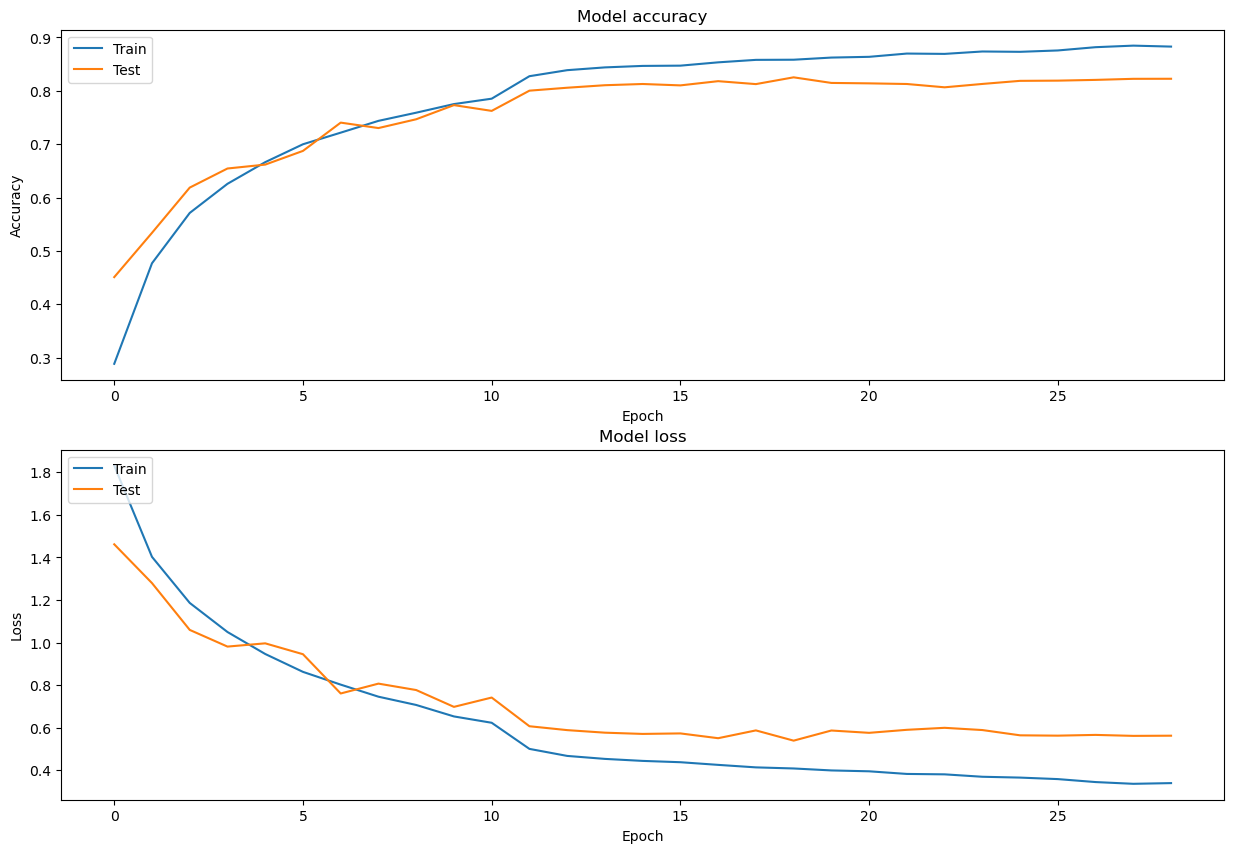

In [13]:
# Plot the training and validation accuracy and loss at each epoch
fig, axs = plt.subplots(2, 1, figsize=(15, 10))

# Plot training & validation accuracy values
axs[0].plot(history.history['accuracy'])
axs[0].plot(history.history['val_accuracy'])
axs[0].set_title('Model accuracy')
axs[0].set_ylabel('Accuracy')
axs[0].set_xlabel('Epoch')
axs[0].legend(['Train', 'Test'], loc='upper left')

# Plot training & validation loss values
axs[1].plot(history.history['loss'])
axs[1].plot(history.history['val_loss'])
axs[1].set_title('Model loss')
axs[1].set_ylabel('Loss')
axs[1].set_xlabel('Epoch')
axs[1].legend(['Train', 'Test'], loc='upper left')
